# Detecting Ship Wrecks using Bathymetry data
> * 🔬 Data Science
* 🥠 Deep Learning and Instance Segmentation

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get the data for analysis](#Get-the-data-for-analysis)
* [Export training data](#Export-training-data)
* [Prepare data](#Prepare-data)
* [Visualize a few samples from your training data](#Visualize-a-few-samples-from-your-training-data)
* [Train the model](#Train-the-model)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Train it further to improve results](#Train-it-further-to-improve-results)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Conclusion](#Conclusion)

## Introduction

This notebook intends to detecting ship wrecks using Bathymetry data. This data helps to study the underwater depth of lake or ocean floors. 

ESRI provides bathymetry data from NOAA, which we have used to detect shipwrecks present under the sea near the Shell Bank Basin area, United States.   

## Necessary imports

In [26]:
from arcgis.gis import GIS
from arcgis.learn import prepare_data, MaskRCNN

## Connect to your GIS

In [31]:
gis = GIS('https://pythonapi.playground.esri.com/portal','api_data_owner','data.owner8')

## Get the data for analysis

<Item title:"shaded_Relief" type:Map Image Layer owner:api_data_owner>
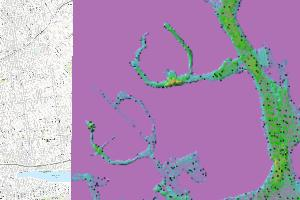

In [34]:
shaded_Relief_Copy_Raster = gis.content.search('title:shaded_Relief')[1]
shaded_Relief_Copy_Raster

<Item title:"training_data_wrecks" type:Map Image Layer owner:api_data_owner>
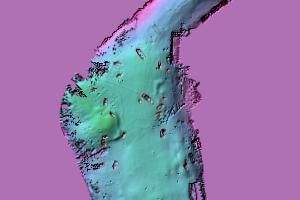

In [35]:
training_data_wrecks = gis.content.search('title:training_data_wrecks')[0]
training_data_wrecks

## Export training data


Export training data using 'Export Training data for deep learning' tool, [click here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) for detailed documentation: 

- Set 'shaded_Relief_CopyRaster' as `Input Raster`.
- Set a location where you want to export the training data in `Outpur Folder` parameter, it can be an existing folder or the tool will create that for you.
- Set the 'training_data_wrecks' as input to the `Input Feature Class Or Classified Raster` parameter.
- Set `Class Field Value` as 'ecode'.
- Set `Image Format` as 'TIFF format'
- `Tile Size X` & `Tile Size Y` can be set to 256.
- Select 'RCNN Masks' as the `Meta Data Format` because we are training a 'MaskRCNN Model'.
- In 'Environments' tab set an optimum `Cell Size`. For this example, as we have performing the analysis on te bathymetry data, we used 'Maximum of Inputs' as the cell size.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAuoAAAJpCAYAAAD7QxfQAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P1ndFzHuiUI1r+ZtWatXvNrVlfNmqnprpq2U9XTPT2uasq8V+/Ve1f3XpkrURK9996BBEES3luCAEiAJEASAEkQAOG9995774FEImHSW2DP953MBBNgUoIMJfEqQmuLOCd8nDg7dnwnIvKfQDjhhBNOOOGEE0444YT7zblNod7d3Y3h4WEBAQEBgd8Yduo+fzYqICAgIPCR44/xIzZWdxDq/f39MBiNMJpMAgICAgK/ETAv79htmAQEBAQEPnq85f0tQl2n10NvMAgICAgI/EbAvLxT5yy+gICAgMBPBxtNHOEszM8FR94XQl1AQEDgFwBbxy3r604J3myxSH7b7zOEUBcQEBD4dcE8rFKrsaZUQqlSQaPVQqvTOQ27HczvjO337WPC9vuMHy3UeYDhhE1mM8H2adboPKzAuzCYzDCvW6jNPuxMTEBA4MOBeY9JV+K/bXiflYU5c3pmBlXV1RLJ8zXf5/CcVndPD5qamjbvO+LnFuqGbXAWRoBAY5tl3QSYjaKdBAR+x2Axzfs4fXx8EBERgaCgIFy7dg2xcXFOwzuCx4WhoSFMTk9v4Xf+e3l1FV1dXZLod4zD+OFC3cgDkxla1SoWZQuYmZ3FzNw8FuQKrGl4RiGE53fDCJNJi6n2PETff4a6CQX09PCchxUQEPitgoV1W3s7MrOyJMuKYnl5E8srK04Jl8FE30ccy+T+MDYW8qUlrG9sSH6lZWW4SveTkpKcWld+FqFuMgIWI3Q6HeQqHZZsWNYQ5wtjyzuQjFJKNR7lj+JW4xqUxOFCrAsI/D7BvNza1oaHDx9CrlCgsakJp06dwr1795yGdwTHjXv0CLdu3UJPb690zViUy3E/Kgo3b96UjDfbjTw/TKgbzTBpF9FZlY3YsADcvesN34BAeLm744bLLQQ9L8aEQg8zDQTvxBWwgUjfqMP8YD0yMorQM78mDZzOwwoICHwIMBGyFeN92E6UjrDHZYKtqqnBTVdXJCQk4MmTJ1bExyMkNFQic7sA3w6OPzA4CC8vL/j7+0uknfL6Na5evYrc3FyncRg/WagT15hVamQ2L+Diy2F8ljiGb5LGsPvFKP59yCBCBmiQEHy0BdweplUVglIGcKRiBWtCqAsI/G7BXz1bWlsRT5zP151dXThz5gyioqPfCbsdPHasrK5K48QNEuV19fUYn5iAr58f/AhjY2OS1X17vJ0LdZMZ+pUx5D8JwW3Pe8iq7sHUnAzyZQUWFxcw3t+MnLxSDM2qYDZbid66vGMDG5TmBg1YZovpHYIzmi3SYCaFof8sPEhu+pOoNa9jfd2yLa11mgw4VMZogoXS4LgmDiP52wYb/gJAA+q6Lf11Rz8HGEwWKQ17OfirwaYfTVAsjvUwb62HgeqwGZf9HcrG9Xvr9zZvE9WLnf3aINVzXXpIXE+pvBTetK2sBqk+Nn/6P5dFuuY2cggnICDgHHaynJyakpagOGJqelr6l9cfOhPrfI8t5h2dndISlVevXuHBw4eSRX1Jodi0picmJqKkpER677enYYeJCJ+/SMbExODs2bNwv3sXDQ0NxBnvLnmx4ycJdeKSjaUV3HzWh3/3ah6lMxoKZZKs64ARU+MKlExooHOIYyIul/wJGyaHtOz+lKbdn2HeZpG3UHwL3TM6hNvYtnyE01intI22vCwOnPdu+s6fiWMYTsvuZ0+Tsb38jmVi2MvE6W043JeWdBLMG+a34ehaqhul6dhG2+svhbP5MaQ4jO3hBAQEfjHwenL+4sl86gj7fWdx7GC9yl9SE54+lfRaV3c3TpNQjyYeZwOMsziO4DBqjQbpb97A7fZtSbCzdZ7HAjb+OIvjyPvvF+oshI1raMt+iJvu0WiYVEkJsvDmgvLAwoMOr1W3kx3fUy1PoamyCFmZ2cgiEd88OAs1CWIr8ZHANGkxO9SO0oI8ZHCYnCLUdo1jTW+SCNpkVGO6rwHlTYNYmhtDY0WxlFZOYSW6JhSUB68DpfyVs2iuqETb0DR6G0qRkVWCjqll6KlMeo0cvc1VyMvJkfLIK65G77QCeiqftay8LpQG3+l+VJUUIJPCZGYXoq5nEkod+5mgWhpHQ3mR5JeVX462kXmqB1vdrGS/PNWHquJ8ZGZRXKpn24gMWiqXyazD/Eg7Sqh+HDcnvxK9s2skyim/uV5UVjZgcllD4fSQj7WjorYDs7OTaKspsdazqBZDC0qaRFiFP09W9EoZehorkcN55RSjcWCUrqtQ2jCAFSqL4wAoICDwLpizWJDfi4zEiRMncPrUKckiwp8vmXATk5Ikwe3MssEkywL/6bNnSH7xAmFhYQgODpbWm5dXVFhRWSnd47/fJ9RZDDKHsiWdLeouLi5wc3NDVna2xL3O8mY4Evb3uS1xWcxqlAh41ot/ljALBfETC2bHMCw4N8xvr9fXTZifWcGbLgXedCvQuKjDuoM/C8+puVWksz8hvX8VY2q6bwtj0mjRPr6KgWUDFuZXkdppDVc1qYZunQQwhTEa9JgiTmyT66Qw6ZRPi0yzuTxnju9RnAxOv28Fw6q36TOYn01KFXJ6KAzFfdOzjFZKi3mQy79E8Tku51szr5OEtRSPxg7V0hqyOQ755YwosaK3toFJqUZxn/V+xsAqZjR6WKjdh6dX0TivJW6ndlNT3cZWMKrUY4QmOGkUNovKN8tjhk2ES8+Y6tc5QmUn/1QqW+e8Gr1Tq+iwldFeDwEBgV8GzK29fX3wI969ceOGtAyFwYL5rru7xNv87jqLy/dZyOfl5yP83j0Mj4ygrLwcJ2kcYR5nI8/74trB/oyKqircIN4/d+4cXtBYsrq2Jo0vzuLsSKizxVgnG8TzAHdEZPVAQ2J7U+TSYMP2YsliTP+xhVgSr5PNSAjzR1DUM6Rl5yI1MQ6+HkFIqhyA0kiiXkuEmhMPH68ARD19TSI9BynP4+Dn7on7KbVY1JixYVpFS/o93PIKR3zcUyS9zkJOdgbiI4Pg5n4PBd0yEuMbsMhaEOPmiruhj5BR3oy+kQnI1rRQLfYjJdofnoFRSEzNQnb2G8TfD8Yd73vIapuCluphMirRX5OKIC9vhDxMwpucXKS/Ssar/GbI1SYoxmsRF+SHkBjyo3q8fv4Qnp4heF07DI1lHUs9RQj38kfUs3Rk52Yh8Ukskot7od0gYq9Ng793AOJSuNxvkBATR/nOg1oNk+2pcL8bjtqpNZqhEdlXPsNtV3eEU3ulvMlBdsYr3PO7A9fgZPTI1TDSpEMjH0LGw2C4+91HUhpNGjLS8ORhJNwuX8C18CzMWszS4Of4gAUEBN4FEyITIy83uXTpkiTSedlJSWmpZFV5n1BmMMlyfBbadXV1ksg/c/bsFhw7dgw1tbUSLzqLz/xaXVMjDQ6xsbGQyWQoJ8Jnwf4kPl6aKDgj/B8r1NkYMT+ygH/r24OIUY1k5ZX8KI91+ptFMcNujV5f16CwcgafPhzCzfJ5BOSN4t88GEXiqFayTPM+m4yCcfwlYRTniuYRXDGLU6+H8Z+iJlBKItTIGy8XFfgipAP/06MJXMmfgX/ZPLwKx/Cvb/fDo3MVahLr0Gnx9FU//nnEENyKZuFZOo+scTWNKzrkFU/gq/gRnJHSn8O5tGH8zf1xFCxoJUu5xWJAT88Czj4awK7sOQRQ+h5ZIzhZuUa116GmcRafxwzhOqUZVDCGfx8zjJh+DaiSGB2Q4fDDPuzOmUNg2RxOpkyjn4S6Ym4Ft+L78Ke0GQRQvU+nTKF4geJo1bj7qBP/S6ocazyYzi7hs4B2/EtqE8+iOfhXzONYTB/+8fUs+tRWsW7Qa/AwZRj/7uGwVAbfwhmcSejHP73dht2VKskY5fiMBAQEfhkwf/MXUXcPD8lYw7hC/M97hNjfGfcyeFyYX1jA8+fP8TwxEY8ePSI96Il44mxeClNK44ezE10cwWkXFBZK401aejpqaQzhCQOnxWOSs7Fnh0J9HaqpLsT4eON5/bQkcNmSbdItobumCKmv05Ca9gapWeXoJaIzGOTIe+AFr9h8zGgs0pKOjXUtegpjcds3Af1yLeTdWfC84YXUhikY1klsS4LfjLmOXHjf9ERK6wI2zGtoz47BtWuBKBpUwERhpGUe+jlK3xuu4RmYMNAEQd6OWA9X+D6rg5LCSEtgTGuofh6IG37P0MmWoA1etE9xjSuoTQnHTd/nGFrVQjFcgZDbdxBP4lpt4jB8dA7HN8GgnUZ6hAd840uxoLcuL1k3qdGecQ+3A19gRGHCYPY9XLwZgeoJ/oxsnawYDCZYTIsof+qPyx5P0LNCgxb7rVtnS6Z1AyY7M+DrE4WGaRLq63qM1Sbj1lVPpDZPQU/l5AFe3lcM3+tuSGqWY92sREdODFw9YtE8o4aFl9FsbECv6MPTAJoRRuZgjuothLqAwM7AZM2kWFRcjLt37kjrBZlk30fS28FxK6uqJOs5n9JST/HtYJE+O0+Tcieky1zH6xp5gsCfP3liwPky+DMqW3fi4uKkT6zb4/5Yob6xoUdL8zj+qf8oapf0m8tADBoNagfYGryMwsEVtMq0xLFGDHZN43/0GsDrRc6PF9qZUF80hP/u4RSGzCb01I3hvw4YRLqM/ZnfzIBRBf+EXvyrpHnIqd6QL+OL8E7804fT6CLxag1nQEv9OP4ZxX01o6VbOiSl9eGfBI2gfJHInMNsmNDXOI5/4TeAF3MO6RP3RiT24b9/OosFGn9Us3J8EtiNM42r0POyFIq3YdZjjQT31NAc/l/efXg4RXlI5Tejr3oE/+LeBHppEvCY0vk/R01DCYvkZ9DSM6A2KqsYxf/BcxidWkqP7puovTXUTlCr4B7fjf/3myWrUJ8joR7cjv/ptQxygzWsQTaP/9WjGzc71VQWI0qpvf5l+CgqVrnu1jCTfXP4nz1asadaCHUBgV8TzLf8ZZX5m0VzQ2OjNCZ8H/8zB9uXxzCPR9y7J3E43+d/t4d3BOf5OjUVly9fRjGNOzw+MM/z4QLu7u4IDAyUlsVsL8OOhbpmrhePvG8jMm8AGiNXxgSjXoH+pioUFBQgPTkaVy+6403XDLSGYTzxuAoXz2CE3YtEWPg9hEXcQ3CgD275xKFxluLlPcCdgGT0KUj82j9lklDeWBlAor8bAlO66P4a2jLuwyPiDeaUPDBaC8/lGaL4Lu6xaJFTgZdIqPOspnzStuabl+BMIDnQDRFvWiUytn8BMBGZT3dkw+NWAIpG5BiviMcdnwT00oDDliV7nXlpjl7Wgujb1+HqHSI9DK5HONfDzxN3ghLQNrMGtbwXaXHh8PULQsSjVyhrHcaSmkQApbU42IDnUaHw8QtBVMIb1HZPYlVvogHhXaE+WvUcXgHx6FuggdJspDpuQDPdjhivO4gpGqUxcAG50b4IetGIZf267ShMSgtLKHrkDbfIbCHUBQR+IJgQmVztFuydinQ72ALCa9KZbFmAO8KZSGdwHhyP1yTar+1+PFDIl5Ykq42zsvwUod5EQv2/vDuEQmkJC6XN9aVyxFfMwa9oEv/OvwP/Oo0I1aLF84xB/G/d+3EiYwrnMyZxLnMKR+N68b8PGELekhaRj3vxPyRTGUnU25dwrBO3djdN4l94DqJYQ+J0aRmfkVDfX6veXGbDlnDd0ir2BHXjRqeS8tIhIaUP/89UGWTEZyYq08aGBpEJffgXT+egJR51TH+wbRr/rccAijQ6tDZN4F+HjaFpjfxsEw8GSIhnFw/jf3e7DwfSp3AhcxJnqfyn4/vxX5B4T5w1YqplAv/Huz345M000kZVsLDIp7rIR+bxb7y68f9JGkdEx6q0RIfXlDsT6p8GdeEKiXLrnixeyrOML717SISzRV+FK+Hd+PfZ1J4k2qU6UH/YWF7B1/c68bWwqAsI/Opg4czLVXp6eiTudRbGGZibOXxvb6+0hJKvme+dcbYjOAxPCHiNu+OkgMsxMTkpGY2kScC2dHYk1Pm0F7NuERVJwbjuFY9OmY4GIl6Tbt3gyW5lsgL+N72Q2UPkqh/GY6+bCHlZiWEajCYnJqSdrROT0zSDWcAaFWSoOBauHnFom2MrivUcYtLpMC92kuh2w/3cYatQz4zC7eBXmFjjT51sATMTqerQnBKKG/5J6COuB1vUPb3wvHraRn484M4gNcQNfonVUFARLWZeT2+WrPbjjSm47RaO2pllTFbF49bdh2iZZsuL/TxkM9VtHXp5G6LvuOJeeh3GZqcxYa/H1BSmZmVYVWthZGONxYCFsV5UF6Yg6LYbwl7UYUFn20Rq0WB6sB0lmc/gfdsDD/N7iPxNmHIm1AOfom/eLtRpckRC/QEJ9ej8YRiV88iJ8oZvQg0UBt44y3sD+EsFCfgYTxLqwqIuIPBjYCdZZ37fhx8bl+O9b2CwcpDzNH+sUGfDwdK4DP/Jsxs3+9VvjRJUDuZEWNTwedqL/5WFukmDuNR+/J9iplA1oULbtBItU4QZFYbkWmjNKng/6MX/mCLbYtwwE68NtEzivyGBn8MWdBLqn5NQP0BC3S5KWagrF1ewy6cLl9tJ0JJQj0/px3/MlElWeKtQVyP4cR/+r0kL1EZb0x/pnMb/QOnnKjXIKx7Cfx0zjVGVAW83Z1K+Ji1S8wbxzyImkD+qRLu9/NMqDC5qoNCSsNfrMDKzihtP+/GvQvrwrxNnMKmh+wY95hVqRKUNSvf/29hxlPNXA63aqVC/0K6iZ2Ubc/QKfEFCfW8NC/VVHAnswd8VL1MdbXWgcBsKEuqRQqgLCPxWIOlYEsrO/L4PbP1mw4ozv/fBbsjZfp8539lSScbOhDrBQJVRz3YjOcwbrn6PUNw6hImZeSqkHLKFabRXJcP1itWibiRxWp8SBjffWFT1zmJlbQ2rqytYmCWBK1uFjoSwcqYJD0mEhjwrxsDsEhTLK1haGEX5q2jc9X2EhhmNbenLA1y/7I6nxV2YlS9DoVBgvCUXAa63EZPXA5VlA+uLVqH+rMou1KnSRNxDZc/g5uaHlKpeIl/r+cbTA414GuqF4MRKKPQmKOfb8MjvDgKe5KNvelEKszhPpD0rh1qrQOXzQLj5P0Hd0DyWpXosY35mGjOyFWiMJixNDmFwYg5Lqyqo1mQofeyL6wGvMLSqw8LECEanFrCi0kAlH0BqxB3ceVCCFRp8nAv1BOdCPW8IZpMa3YWPceNGANIbhyBbXsXS0jy6q7MReOsabt3PFUJdQOCvHD9WqEubSfVaPM8iARs2iqplgyQg+XSTDV5PbiLxndCD/zlFTrLdiKbacfxz72E0aimebTkKW4b5RBZeG16aP4j/S/gY2rR0357GhhZJbwbwXz2YwoSBromvWaj/3zMVFIcGIQqHdSP6WsbxX/oNIomXpZh0eEJC/T+QUF/k5ZTE2yZKv6ZkGP88eAQNasf0dUjLGcQ/vz+JcarPII01/71HLx6NUzrkL9WFuHODytnbPoX/xnMA+VzPbeVn67Z0GgzfA/Hs8Bz+b3c74Dmgs8Xn+xZJVH/j346vqpQ/QqhrERjbjX/1bBbzNABzvbkc8pEF/BvPNuwWS18EBP4q8GONPD8EOxbqDN5UqlVMojb7OYJ8POF21w/+gYHw9vaBh1cwHqWVY3hJSULdDN3qJCpex8LLwxu+gaEICQ0nRCO9bhirBj6m0AD5cBOS7gfBw9sfQSFh8PcPROjDFDSNLRORWojbVtGWGQ2PoDikJMTjXngEgoMC4O4VhCc5zZgjEjfysYok1B9RGd5a1Km8RORGwyq6q1IR5u8Db/8QBAWHwNc/FPGZNZhR6iksDQxEzIrxZiTfD6R0reUICgpDfHYLljQWGFbGUZwcLdXDj+4HUz2Cw+KQ2zACNYnp4ZJn8PTwRUAw1S8kBCFRz1HeJ6PyL6H+TRy8vfwQGBJOaYYigurWPLoMMw0YU52Z8PeLeSvUqxPhE/QU/Y5CfYYmID53EUODorShV7lAbZ8AH3dP+ASGITQsiuqSg2fhnrh9PxuzQqgLCPxV40cLdQZzok6H9Lxh/P/iR+Bdo0D1yApKh1fR0DWPfwjpxN/m84lYJljWVnGLrc1hY3g2soqKoRVkNs8ipH1NErM61RrcH/fjH5MnkTywipqxFSTXTOA/hI/g+YRGsn5DrsBfIjrxvwkYgmftEqooncKWKfwv/n04U7MMFeXDk4cnyX34t2kyyGxCnctq0CjhmzCAv38+geec/ugKUuon8TeU/qMRXm7C+4A0eJY1iv9H0AB8O1ZQSekXVE/BjdeIU/ygV4P47wJGEEdlrxheQX7rHHyaWUSr8ahsDukdy6gcW8OrknH8u/sjqFBrUdwxj8fVVNbxNeQ2zuJP9wYQNUETARbqcdbNpKvMxXNy/Nm3A2daabxzEOp/vNOFPVUr0iRAvriIXX69+CpjDgUTayjtXYJLQh/+i5ttOFgrhLqAgMDO8IOEOkM6z5xEtmptBXK5HAuyRciIkBWrKuh43bqNfKQ17AYdVleWKIxMCidfWYNaZ0+LBg0iW71WiSX5ohRGJl+GUmu7T/EtJNRbM+7DKyoHshU1VhSLmJfSUUpWeTup6/UarCyvYFW9bSE/Ez8NKmoq6+KitQxLHNehnFI5SLDrtCoolt6WY82WFtfXaNBS+m/rsUT10HD7UP4cb1nB7UB+i3KsqPjECDMMBj00NFi8TXMJa1qDRM58rKOW/ZZXodLpJQuPRr0GBafr0D56HddrmdK0blzgYxqNRj3WVhRSOWQ0KTLoZ5Ed5YG7DwqxSO1mX88pICDw14efJNQJvOSGrbsK+Qoicqbgkj8NV0YeoWwRQyq99DWSw22Y1UgtncUN8rtJuFuyiDHyY2MA/wgQiN9LSbxfzWV/EsjlMrRJlnrKi/1pXGCL+v4qJYobpnGN0rieN4OYAZVUBuYqi16Hlm4Z4nuVWKM87fwllZO4rqr1bfq3yhbQqLClz+GoLGxpH+iZl8rH9biZP4c6hV5aQoN1DXIrreVnv1sFMgwQv65btKhrXcDtHGu610tk6FVSu27oMTgih0/2NMWZwpWCOZTMaSkPagutFmWt84jtVUFN44eBxrvk6nnkzWglPpfKrFfjRcU8Usc1pNN53akRquU1xBVT3XOncLN0AW0jChy434kvK5RCqAsICOwIP1ioW8Fi0ypw34JJZzvxbA/j7BPBVv9Ni7CDUPe8n4l5pXVNpxTGgdCtsOZjJ8zt2JK+03LywOAYZrvgdVZXmx+XxcGP28Xut72NtpTP5reZj3S9vV48IL6Np9NpScjTBIInKWY+JUKPqeYMeLrcQnz5uDQ4OsYVEBD468JPFep2MIdal4M4gjh2C4faloE4+G//YsfnmG/6k6Dd/MEf4i27UN9To6bSWE9lYUgbWR3S4PXzbKXfzn2M96bvAJNjGMLbMEbwWepv/ah+dJ9/0ImX4my5b4vDhp2399lq/zYfqSz2slP7cdqOm1il9qJ7vLyG8+DJDC/H4U2wUnqwQDMtw3/060M0f3UQfC0gILAD/Eih/guAhDMfpdiSFobbYW8wt2odXJyG/R3ASIS/MFiHp1ERiIp7iqdPn+FBZCi8vAIQm1GHBf4S4SSegIDAXw9+LqH+wWET6p+FdOCbqt/fMg82rixOLSFuUEWTEJ4AGLCmXMal+334t6/mIeMfV3Iy6RAQEBDYjt+uUGcrtlGLxckBdPRPQqkl8nMa7vcBts5r1pYw0teJxvoG1NY1oKGpHQMTMulTrHGLZUdAQOCvER+PUDcCihWcTujHlZa3p778XsB8vSSTYXfUEP6SOIqvno/iPyeM4EzxEpZ0/JXXeTwBAQGB7fgNC3UreFMpH8v4exbpmyBBbrasS8c+8rnN/CNOvKlKtI2AwO8DH41Qt4EF+u/VcsxinZfh6PRW8D0+k93Z8h0BAQGB9+E3L9QFBAQEBKz42IS6gICAgMBPgxDqAgICAh8JhFAXEBAQ+H1BCHUBAQGBjwRCqAsICAj8viCEuoCAgMBHAiHUBQQEBH5fEEJdQEBA4COBEOoCAgICvy84Fep9fX1CqAsICAj8xiCEuoCAgMDvC06F+uzsrNPAAgICAgK/HoRQFxAQEPh9walQX1hYkM6AdRZBQEBAQODXw06ds7gCAgICAh8XWI/b3aZQnxdCXUBAQOA3iZ06Z3EFBAQEBD4uGE0mG6v/jEJdiHwBAQGBnYH58odw5k6ds7gCAgICAh8XfjahzglZ1teln7bnv80Wi/Q3/yuEu4CAgMBbGM3mLXxpomv+m+/xtbM4duzUOYu7E/zQiYOAgICAwA/HTnn2Jwt1FuL8Lx/pWFBQgOTkZMQnJODps2dITUtDdU2NlJ6JwvHgtD2+gICAwO8FdsPF6Pg4SkpK8PLVK4kvE54+xevXr1FRUYGp6elN8e4sjZ06Z3GdgcvDefEkgf/V6nTWiYTN0PJ9EwcBAQEBge8Hcy1z6hauJX7l6+8yav9ooc7+jIHBQTx69AjR0dHIJ6He1t6O/oEB9JFwr62rQwoNPuHh4cjKzIRcLn/v4CPwC4Gfm7P734EfGl5A4INA4hwn9z8SMNlOTE7i2fPnuBcZiazsbDS3tGCQOJQ5s7GpCRkZGRJfpqSkYGZ2VoqznYt36hzjOAOny4PDmlKJhsZGadLwMDZW4vIHDx8iKSkJVdXVkC8tCcEuICAg8BNgYa5dW5N4/hVzLXGsnWsTExNRVVWFJeJaDred83+UUOdIGq0WWVlZCAsLkwS5WqORZgUbFN8+W7BbaWbn5pCWni6F7ezqkkjfWbofDEaasWxsSGVzhMX8Kw88VC7zBrXV+8SHVO6tZX6LDZhN3z2ZcgYdzeB4FufMzxl0eh09ax10Tvx+NrBgWH/3+axbzD98kmAyY32dOrozvx3CaH63LBv0nIw/q0ikZ789D8KPqvMHgMHMS9fWf0PCWE99VwvtR/j7DsylzJklpaUIDgmR/l1ZXd20oiwuLm6KYcaSQoHc3FyEEl/WNzRIPOrIxzt1jmXYDk6Pj/xqb2+XJg2PHz+WeHxkZAQzMzMYGx+XBhQW62E0ceBBREuc/13jgsBvA/yMfhiHiKVOAr8GrP3ur90QyHVk/m9ra8P9qCiJa2tqazFMXMvaeHxiAs3NzdJqlNDQUFQS17KeNjkYRn6wUJcaliJlZ2cj5sEDLMrlm+ssWbw3UYb8+XZBJttMgweadRqUeFAICg7G4NDQL2dZJ7FrXJOht6MZVZUVKKeyMcrKy9E8tEBhfiWC4nbULGGosxsTSzwAbvXnNlYvTaOlvgKlVNbyyioaSOtRU1WJcrouqapD7/QyPcwdlt9oxoZ2Hnnhl3DM4yXmldR53vOMrTDCAjV6i0Kx/5gv2qfXaKb3ASY29Hx0yiUMdjWSGKC62Z9PWTka+2dhXGfxutM6Ujj5BNo6RrDE7esszPeA++zCWCfq66tRaSsLt3dlbQdmpTZzHu+HgcqpX0R/cyNqqt/WubSsEk09s+ATUy3mHdb5A8Bo0kExN4imtgEsqXTv5YJfDNRHtKsdCD59AJ4vm6ACTZqchfsNgtuOuY6fb3hEBKZJBLPRwN6mq2truH37Nu7duyeRM99nLmVOHRoelviSCd6RL3fq7OG3g/Ngrk5/80bKt6OzU7rPEwcG589h7BMH5uvHT55IX06VKpXkvz3N3waIs5wZZD4Eb/0AGC08IXNeBoOJJsTbyruJH2Vw0EOtVkGl3fmEVqdVQ6nWfFBjDLfBu/X74RpAasufYGAzmt8th+VnNY7Q+/4z1fXnBpeL6+rM71eBTivxiVbvxO+vBHaeT0tLkwwiLa2tkrZjnmVDCYt0/qLJPMscz4aSOOLZhIQEyWBj5/0fLNQ5Alt5goKCMDc/L2XIYTnToqIiXLlyBampqVLm2+NyYSorKxFMgw8X4n15/KywUIVGynBt/59w3CtRmmDwl4DMzExUds9Qo61LROn48ltfZpp8UPkM1LnZQmtkSy29cdJLx1Zw09Z8DI7+BAu9mG9ffnp5yZNfErvlmPPETBVcDpzG03Y1X20R3ZyeenEMVcVU1uxcpD6LxtFv/4IbEU+RnZeNNzlF6Jhao1j0gG3EIA1Iemte9nLwX9Z0SQDolZjsJXHYPgKlljsRW/TZMv+2XAx7W7BgW5ruQRWJVNmalq6tlm8LdR5HMnrn5ed0HdKzUPtZpHjvEqzRsgH1ZBM8j36OI3cf4g3VNTsrB7m5CQj08IS/TyhKB7TUYd+2DT2ezbQ3NkUblY2u52lisftQGLrpb2zQc5OE9bYvE3T/fcRsov5cGnkcn311EbG5Ocix9ZXcwjpMrtmFupP0NgU8EzWVip6/fXB6t97UN7RVcP38Mxxzf4iCvBxpGURmagrCPFxwMyIB1SOLVBaHduX+Zc+P/ts+QZP633v8uY35GRnZSm4Ps9k220EikaRwR7YXPvv2Dlqpj607ERncdxzbYPvEwvkzYlj7BpeH+yn7clm5rfg9MzmU8e2XEeIXrRxdddVoG1mAltrTbvFnq8NmOZx89dgihKivS+n/7F9H3g/my97eXgQEBEjCm/nS7sf8x9brc+fOwc/PTxLtjiKYw7KI9vX1xeTU1CZf7tTZ09kOJv+8vDzJ0KJYWZEmBZwvczZPStnawxZ/e37M2/wvW3yeP38ucf0vwt0/BFQeo1aB/tYGlBYXSmMRo6CwBI29M9BSH/v5xNhOQWUy6zA/0oWeERm01Pcd/blvrsz2o7o0j8pZhOLSclRWVaCkuAiFBfkoa+7HsprKvdO+yi+dvAehV7+FW+ogccb3f7k20zjWn3Ib314NQ6+C32Pn4X48iA/1GswOtUl7MuzPpaiwEKUdExIH7OzLMHOEDnPDnegZXXynLXcCI01ilia6UFZWimJbOQoL8lDXPQGl/ucQ61xXFaYGWqiuxQ51LUJFz7SkD7i9ncf9kOBxS0vPoB3tA7NQU9v98u/CNhAPKxse45sj51A0Rtz8s/e7Xx/MkcyrvHfz/v37Er8zl/J95vb2jg5cungRRcXFm4Kc/dmIwktjnj17Jq1+sKdjdzsS6pwIi3S2nNsHHU6E1zLeunULb968ke6xH2duh30A4oLExsUhPz9/894HBQn1jdFK3DzyJfzz5LYaWt3GhgmriwOoLqjFgGyVwrIANWB5rg9VZU2YXFFjebwbjd2TUCxOo76yCHnU6CW1bZhXkqCxiRMj5WFSzaOlphj5BYWEYjT2TEFDCkISIToVJrvb0Dk2g9GuOhSWlqGuowctr8Jw+NuD8HiUifzyOgzNrW4hLbv4Z6eb64TH+WNIaJq13oAJiyMdaBuYJ2JoRmER5dk/Cx30mOmtR3FhAZF/AQor2zCj5M1hJhLqanpZu9BLIlBjIBJX88DWSnVfpHLVoJDC5xfWoH+eBIM0OWHL6hC6useworHWY6SjBd3T85gcbEJJYT7VtQKd40uUq01UUWNsmNUYbad6UlvlFZShtWcEg/2t6BpVQEeksflsCJJQn2qGz4m98H4zQLWyO+pbqhU0vvbBsTNeKBvTEMtRXBq0xtpLqZxEskWFKKnshpz6lMXMBNmKZP/z2LX3Op6QX3kD+amoHQ0KdNUUSXF4QKxsG4N6y0TqLViol0Wfwb5TMRi0lURyLAp5wKSJ3QZW0FtdRmkVSnUsaR2WiEd61iYt5ogQG3snsTzaRhOOYjQPzBE5OuZHf2tq4PbtXnhl9NkysDqjYR71yf44eCYALTNqSo8Gal6KszaDusoSaR9IflkDxhRaEry22TZ1Ev3KpNQ/Jf/KRkwt62ieQu+dnsoz0I6WwQV6lsOoKOX+WUAioBcrWouTQdIoCfWuPH98fdDL+iVl20SDy2PUKNBRS3lRfy8orcDAgpaayBaO2ml0yzPqoWdEZeEBw7SM4bZG6gsyTHRWIievmvrfComZTrT0TWJ2rh9VRfnUb0roHZmC2ibydSTCBrvaMbJAZEfl0VC/bGgZwOziApqr8ig8Pe/abizq6Z2zCRsTTUY0yyOopeeUTyipbMbI7Cjamrpp4qn/RcQ6E+2jx4+lNudX2U66DObFubk5XLhwQRLyKpVK4ke7P4fla7bGsEDmvznNnbrtZWHwJtGu7m4pP54k2PNjaz4vT7x8+bJkTLEPEJvxKAyL98jISJSWlW2W5TcDNrisdsL/xNe4HJyC3Dya8OfkIDM7D9WdU9BSeSWh5DihlPjV2l+kCR1Pro28iZZed2o//gr8zsSPxDD7WcGcsD095gHbpJkDYRV5YefgGtcMfnLrDu8STzaXp3tQmp+JnIJcJIRcxxefH0XUqwzkZGeioKEPSqPVMCKVyW5g2D5JpnfLft9E72VfWy3ax5fpmvmSw/KElo0s9jhv68WTAMVEJ2pa+7CkpnTomifNbPR5a30mMb2NA7Yu3eNxjsvoZAJM+UO3iOygc9hzNQRpeYXIyeH3NQke113hG3gfzbNURvtz2VY3fibWunGLLiMr6AzcnrRLedt5iccQe3jHum0F8ZpBjaYnLvjylAde5hQSN+cgKzMDle2jm0J9q8GN6+3wfDfb0lbG7cYOiruhmsFLr1M44HofGXkFUl1z857h9qUbCIyIQ+cCta1Dmo6GBMkwsa3sjssweVnkpp+trxkd24sn3M7qzs/AuIT8e+dwISQfCuqIzsI59u23RpJ3/aR2cRw3bGXZ7PfSuMT9jb9+WA1X9nibBiQqk1Y2jJqGZkyvUF+j8kjGF34HHdpks29vgtKjem6Wg94NNjZupvsbAnNkd0+PpJcnJyc3xTiDeYcNIoePHJGMx45+zLUs6lncF9Pk1q6f7e57hToHZlO9p5eXJNjt99lixATv4+MjrWvkgYBnC3bwBlPeXMppcqYcJpIK4Vi4DwYnQt3e4dZJWKgXW/HgwlGc8E/FHHXgdc0knnmcxfmANExodRhOcsefvj4Dv9jHyKSXuzQvA9G3z+BcUApG5TqpY8nHqnHf5Sa8Hycht7QUealJ8Lx2BsEpLVDwOgZ6edO9LuDL4+cQ9igVecUVqG3vQvOrUBLqB+AR9wZ5ZTUY3CbU7WDiXJlowZ1zR/CodlwifOiXUHL/EvbvvwzPmCTk5BejaViOpfEKREc/pAGKylqWjvC7l3A+KI0EDFGbbg7pPkdxLrAYS5SIfrEXoef24dA1T8Sn56C4tADPI9xx9ow3CqdX6WXRSpbVoyeC0btIRKeeQ8LNA/j2zG3Epb5BYXERUh4H4PzRm0jtm4OOOt+6egFVCd447RKA15lUBhpwngTcwFef/2fcTOghwbq+5cXbFOon98LjdTdUNODa/Zk0Tbp5PL11DDcfV0FJ1VZ2F8H33kMU0cSkqDgVfmdPwu15JZY3NJjub0Gy3wXs2nMdj9kiRUJ9SW3AYMVjhMa8RDHHKXiEy4fPIbK4n4hk++DjXKhb+wqRIoua6XY8ibgJV58nNLEpRklJMnxuXINXZA6mdUTUJOJLoi7g8yMXERX+BK/oubQMzELlRKjf/nYPPFI7KQNHAqbMjEOIu3Yct561Skt/VunZx3vdhMfDNBTxM4r2xpWLASijZ8QDlmKsBVFuLvB//hqFZXl4GnMXl65EomFmjdJaQ1XEVXx24BKCnzxHLk0iSzNfwP/6adx4WAiZkp7Blnf9u4W6gYSMWtGDeN+78Ip6TP29BJmPvXDykj8KOueo/tRXuwq3PqMzJ3E7sQpLPOhs9OHhmW9x6LwXwuKTUJhfg4HFFVQ9vIDPvr2Me8nWvpyXEYdrB07jflEXSR3qqyvN8Dj6LQJz+ukKWCm5j08/OwaP6FikZ/NzzYX/+f24FVOASZVVaCh6cnDH5Qr8779AWWkxcp5F4OqJ3fjLUQ80TGhoIvPu8/+5wVZqT09PackL8+cyiV1el8jgL5K8GZ+FuhdxKn/2ZO61+/HGI+bM0bExyarOnMvXO3XOysNl4A1MvA7SbmjhNNnaefPmTUmE830eZJif7eAwfL+HuJ65W7a4KKW1Pf1fDZJQ70Lw+QN4WMtM8daxgNHIx9FQX4O+ObV1IkdCQb82hfq6ZowtqqGcG0Bb7wxNRmbQXF1E/baEOHoQq4a3Ez8WuqrZHlSWl6CE+n1pWRvmNCRYWXhRerqlCbR29mN2fgpNFUUoq+9AV202gq4exGl3mqyV1aFzRAbdNrHO/MJuvPIRDh9yR8eK7RnzV6SOLkzJZejkMlV3Q66lfNZk6KgvoUG8lFCO9uF56GiM4Gdk1K5glMbacblKElBGlQzd7d2YXlZisKUURRSnoq4Tcr3V8MCctDI7gp7hGShJfJsMWpo0d6N7Ygmy8Q6UlxHHlVajf26N+M/OU1Rnyyr6aiul/Ral5Q3UhrPoaevG3KpuqwhkkUhCPSf0Klye1EBnrRm5DRiUS8gKP4Fj12PRT2KNhahOqUB3Y4lUTq5b68AMTbI2oNcuY6A6A36XD+CsZzwKqC27RhdpfF/HwmC9tRxlpSivbsOClvquYxkk2IR6/G2cCc6AwlYKdnYBzAY3/Qo9u+piGgu5fesxLFOTECR/qodRuYCu9k5MyuXoriHOqe7EguPSQF5eqp7FK9/LuPuqbYvRSbc8jxT/wzh5NxFjSgssNM5Tl6VHPIK6SsqP+lt1xxBNGOxlJ6FLHWN5vIW4i/tbKY3vMtu7yLpljHTVMBSaZXTXU1movSob2rCoYRHtWG8ulwkbRgWKYq7i2r0ip0Jd6ttzPaiivs3isLZnAlpqEJ448KqDlalOVEj9np93PcZX9O/v903DUOnWMNrTiSGZCtO91dZ4FY2YWqN6scahNtMqptDVOwqFjvotXStnB9HWPw35wphkdCqi599m79tSOXlSosV4eyNKqYzFJdwvZzDY3oFReoedTlJ+JXCfUKvV0hIWrju/43zPDuYk3hN09OhRaT8S862jP1/zkkNfP7/N5YZ2971CnTtJa1ubtCmUIzJGRkelgejEiRM4e/YsTp8+jZMnT24BF8aDwjDRcxwuAA9MnN72PH522IS669EvccbvBXKoUbJzePlLMbpnlNLLopuvhdfJM4iqHEBjshuOXolAh5zIcsOE4Rdu+LvdF/GmbdHWOoBpoQMhF/bDPamTBuI5PL51EFfu5UP+ti0hb0/D+d0nkNBFkwOtDNl+R/APZ8PRL7MGomyJmctwlURjYpdGuve+WeG7Qp0eOwn1ythr+GyPG8onrQMTzz51GjXUJMrt5G/oy8G5vZeQMkKiTT+PrMAzuBJWZhPqA4i89AX2e7zEjMoWQdGNsDO7cOEhW4D06Mr3x+nzEeijylk0C0i6/Q12XY2ha2pYdjSxSXTdiyMB+VihfMdKw3HgiDvKR94OltqJWnge/wyuz3qh+QFCncnKQuTa8vAmjtx9gTEttZFORQOKLW9y+sYnOLjPBSUTUotiLDcQB45HopcvbBYPjVoFLStamxtIvoO95x+gn8pi3vZys1Avf3AGX++9hsf5ecjNsS5LKWpgq/kccsMuY/+tRMyo35bBOFuJW4f2wCeTpf0ayum5fPX1ZeSN8yyNnjUNzI51/k6hzmREYr848gL2+76BiSZ5Kd7ncP1BBVatVQTMNBi4H8OFqBpoVxeQ7HEaN59Uk7y2Of0knrqdxrW4Wuh0atRHncXfHfFAzchmCGhGSuF6ZD/CC6akAf1t/t8l1JlQVyQL4Wm/TCzZ0qLZGfJDztH7lYZp6t4mrYomJm/bR9fwGAf230DpJF8NII7enW/PPcSwydpLeQ9CTew5fHrABQX9tjISITc9vIhd58LQJaMqK1vhe+YgwvKt06fVsmj8+cu9iCoal67ZzdVFYe+uc8jsWqEKdiL09F7cSmh+2y4WJRqfuuCrE95omtQ4XdLzc4I5lI9aZH5kizUv9/Mhwc1cyTzJOHPmzCbs9xjHjx+XBDVbVpioPTw8JF52JOzvc9vLw3F5T5Gvjw8Uy8ubg0JPTw8uXboknTbT3d0tHbXb29e3CbYK2Te7ch0ePKB3Z2BAut6ex68GB6H+oIaXBFK/YsMBgcupkY8i/u5eHL+bhgV+jyzLKLx3GYdcYtG3bMBYpg++3HUBEclPkJqRi6zURHhfPQS/lFas0mvMRouhukx4XrmNuNepyM7Lw2O/27jhcx9tSzyw0mSgNRFff0VjXXQkkl9lI6esHg3FL+B9cT9O3LqPlMxCNPTNSkJ9Kx9QfJJ1gyUPcejgHTSTuOFXY320EKf3HsX1EH8kJGUis7gZS/RuddVmIi42Adm5eXidEAOXc+eQ3DQNHddL3gn/cycQUmo16GxMVeHyoV045haM5HQa94jLQq8cxu3YPMxo+OunHt1Jd7Hf9QnGOYJxFRUxF/HJnrOIfM71zEfiPW+a+N9B2TgLBt63IENxnA/OnPbFKxpPs5If4K7LSXy19yqKh2gsczSASEJdLgn1a3HlID2+Kah4XNPI2nB7P02uykaojc0YbM7FwwdPqG65SE18jJtnTyKhZhxq3Qo6ChPhcX4fTt6OltqycUBGYn8Ij6Jj8CYjA5nE1fdcjuFGZBrGVdSiW7jdQagHZcBuspP6B70XJuIC2WgVQl3uIjz+GbLy85EUHYobN9xROLoq6YSNiTJcOHgMVwL9EM/Po6gBs0qHDdYOQt0tqREq6hPW52y1Aq9OVeP63iN4Xj9FdV3HbG8J/K7eRlTSS+RmvkCQhwuCXlA8EsjrG2toz03C7Wt38TST+tLrB7hx/TZe1EzT+LABWU0c9v7lJAISHuAlP9fMdIS7HsTNh4WguehWsf6dQp33omkx0pAFD+rbsa/TkfvmKbzcbiAqu0da+mtRTyPl6SO8TElFVm4+HvlexcW7kWgnjcRLYDWtz7GL+r1nzH0kUb/Pq+mHYXUEsVSeL0+5If51ptRXYz0v4rLXQ/Qs07Ohd3KtNhbfHHZHo2JDMppM5wfiHz7fD7/YJGTk5CGV6naDNGVSI41RNGuxEJN3Fj7E2UM3kZCRheyUpwj2vYavP9uN2GrSZ04Mb78WmGt5n2ZUVJRkaGEOYh5n/mUwr7NRhMcCPm2LedXut7yyspkOa202cnN8u9uRRZ0j+fv7S39zGLYYsemeBfmdO3fwPDFR+kzL62vs4FkFr/NlYc7xeDDgzwG/tFC/EJKBsnLetFdKs5waDM6rpE7MH/HkVfE4duAojhxzRe6wimazdNeox2DSHey7EoPeVeJ27vw87dbOIsOfJiF+OZieLIDL/tNIaWPZYqsPT09X+hBNhOiVMko6RoYM7zM4H1kKOZG+RCCUzPpgIZHoWSS0LFO7OBfpjPcJ9bLoyzjt8RrTpImlNfNUF72OBMFCF9IeBCEwOBRhntex5y9H8biRxIt+YZtQ70P4+ePwzeqkV4A/mxEFrE8j3Z/Egn8udCSWtgh19Ryeuh6Hy+MqySJhYmLaWEJ53HUcd32OheVV5PufwHGfdExR+pIIZoZTjeLZrSO4k9D9gyzqPOs20cw8L/AEjnmlYIKEOgv36ZFOJMV4wT8oFAF3zmHPnhN408Oj1DoGMvyw/1g42qlvmTgNXqepVWCovQCxwb4ICA6Bz6Uj2H0yCE2L9PJvsz5IQj2GhPr+m0jizcf0MpWUlqGmawqrMy3wO3kaEVWj0FFe9nKaLFrqD4dxOqwQGmrJigdXsdftOZZJdG8dkO34LqHOk6wZpHqdwAH/PKxMd8D7xGc4fN0TwWGh0ubCkLAg3L58FIcCUzE/XgW3A5/hxA0vhIaFkH8IQsIDcOvCIVwIzYFKuYZqEiTHfNIwRe0nETg/k7VBxF7bj0sxDdDSc3yb/3cJdXp/9a0IOPAVDly6i4hQzi8YwSFBRPLHcN79CfppBFw30jMa7qCBzuEZ7T2JTGn2NIDYiwdxPb55UygbqUzVDy7j8I1nGKGimem5my06DFVF4MRRD9TTg7eo27cI9ZWyKOw+7IaKaeZnSoPKuDxVgCuHTyKxcQHoeoEDe44gtZsGAWn9I6W5QYKs+SHOH/NE/S8k1FngsshWEBGzRZyPY+RlMLxsqqCoSOLF8+fPS9Zs/ruQ7kl+BP4yyUtQmPDZsMHWeN6ItFO3vTzMt7xOPiQkRJo4MBfzIGI3tPBaeTa2bAcbWqpraqQ0uQ4s1PlgALtF/jcBm1APOb8fbg/zUVVdhQp+f6tq0T9HwpdF0yr1oSOHEVzQi9HiaBw/7Y3GBSOzKYYzvPE58Uhq29vlkbNNyTh14Dxyh1ahnKnHrQOH8KB0WPqKxW7DPI7H1O+vPKyRNoDr2hLxxdd7EFE0bA0gOQWyQ8/jdkKrZGF13uecCHV6D9bHSnD24Fe48qzJlue6tM5aqVJCa7BOctkwUELjwFHPNEmAYakbIVfO4V7FBDjIxnQNXE7sxu1XbdKYw26lNwmHvj6NjG7+VmVE70tvHLv7DBNcCf4C9/Ay/nLlHnrltpoaRxFzZT/OPawnsQT059+jd8sNjctWQwSNBBjKCcCXh11QNrLtS9V3CHXpi+nqDOJv7sfNhBqskRjTqJXQ6JnL2WlRl3ADh2lsmZNsWUt4E3gWd593SeWQLOE6JZZVb78yGWdycGb3caR0Ut22CDerUG95ehv7r4Qgp7IeVVUVKCurQ/+0AlrtDKLO78XtR9Ww7hijtttYQXHEdRy89RIKKtLGJE16jn6Fs3E10rOUnofjZOC9Qp3raoFhaRjRl/cR53dApR5H3A2aGOYMSHWh1GEYKsQlasMCUtqrpA1un76FnCGbwYuE/nxxBA6eicAARViqj8f+b79BZMmYtPSFnXKiEjcPHUJc+ai0dPXtOPp+oW4gTlDNtSDk0hXE18xYE6KyqNpe4sQhd9TSJNZE7bas5NUDNl9NG7wO70Vw4RQXC9q2JFu/H7EGILexOorHd47gcNAbLNm6ybqiBtf37EZIIVtsNrBW/wQHTvmgedkq1GcKgvDpoWsoHLTWeYMmK4WRF7DHNQk0F8Zibw7O7z5Fz3Ze8pfS6HiFg3sO4HHtb0+o81dUNn6w+OZlg25ubhLHMt8z+G820DDH2u/x3y4uLtJKFJ5E2k/jYq61u+8V6nyP1T4PGhMTE5vCm/34vHReo15XXy+pf7uQdwSH48x5HXvyixe/qFDnpS9+uY5LX+zrmpgkDZgujMExGpCOnPBE6Ty9qtRxTDahvvdyFHpI567zgE8vHFSTeOF+Ei5xDZifLcH1AyfxsoXTtgt1ymG5F5EXD8Ez1SrU33hfwOWYCsjtLwklw0L9Egn1p60r1F4/Tqhf9MmQrOHSujmTGnVJPjh3yRWJZYNYVeug6y/C9SNnENe47ESo95JQP43AAhLQkvBkkTiH7GDqNAH57xHqp3DrWS2WKaSRhOgG/VX91BWnbyViYYVerEDqfCG5mKciSkJdmrQM4OH1/XD9gUKd621Q08Tw5B4EZ/P69VUizis45BKCvOYREhtaLBGhnNt/Chk2od4vCfUIdBCJm4igDKvjeOS6Hxf9n6NhYJ7iqDGVGYQ9p4LQLHcu1K1LX6JJUlqdtb8AhplW+J86jbDyEeipH1vLSf1nXYV034M4HVFMAt4q1Pd5voBa/75n+n6hbuR2m6uH59HDiKyWkUBoh8fpo4gs68eKTo0Vev/4HVxTaaCj+i1PVeHmySN4UjlMIkol+S3ThGlNraHBnN437QqqIi7iqPdrTPEyf64v98+lLkRcOAzvtBHodmxRZ6HehoCje+H7ppvqQIOkrTyrSrW0e99oXkJh+GUcuhGK/BbrM5K3JuPs/jObQj2OhPqdxA56/63pGk16EupXcZQGxHFqaTO36YYeow0xOEeiumFSB7OqbZtQj8aeI16omefPyJwv9Y6pMtw4ZRPqPa9wZN8F5AyTgLMJdcu6AcMVYTh+zIvS/PBCncGCmI9ZZIHO3MecZwfzJLcdW7N5aQv/zYS8PQzv/+H1inzNae7UbS8Lx+eli4GBgdDYTpjhPPkM32PHjkmCnc/0jYqO3gI+npGt6lx+tgrx+b98zO5vVahfDUzEm/R0pKWlIvVNFlonViWu57Ycr3uOqyf3Yd+3l5HUNistXeT1t4MZvjhyPgqD9G5YeYtGiEUSvZeOI7xshPpNFPYe80HrLO/9sPYbHgr60zxw8BzxIz0WAwmWA8euoWJuQ5o8snCDYR7pQWdx63EDVPRyO3LfWzgX6pbRYlw4egKv+rSba6V52YOJuG1psBqPY8IRfj8Mt8/tx3G/DOsyy3eEejVunDyPl728t4PHYRM0ima4HTmB+FoWZuZtQn0V5dE3cCmyAEtUfOZQC/FuYdhVHPTPI4pdRJr/ORzyy7UujaAy8b4HxXQubpDILPmhQn1tFgnEzy7x1STUqc4kMFdGG/EsNgJhkeFwv3QQR9yTMaemyhjnkOJ3Wpr0aIzc94xS3gb1EuoyYxEcRnFCb+HQXhJzbTxgO77fLNQ1aH12G9+eccfztCzqI6lIeZWDlpFFGl+zcOLbM3jdQePkho2X1jew1PgUR/ddQzlbfacqcfX4cTzrUG1ZZ76J7xHqRsUooq+wUG/DbG8qjn6+B67+9xAVeQ/h9+4jKvAODnxzEql982h57YM935xGQNh93LsXQf6RCL97kTjvLhqoagoSuccOuqNBRRzB7Ul5r6vn8dLrNFx40kN9c3MSQc/gfULdbDFgpCoG+/9yCO5Bkbgv5XUf931vYM/u88gZI4FO3GqktusrS5Ta+N59H5zavQchBZPSuMhfkg4cu45K0s9Sv6e6bqyOIO7WBQTk9ENPPGEgrWAyTyH28lHcetFBsWiKuUWoGzGVG4JD1x5gWMfyi/iaxoDurDDsvRQNGY3bbale2EPv6Bh1Iuv7wPqzC4GHj+NRjWzb8/51wfqXfweDT9XiZYzMt4WFhXiVkiJpZd4PxNZ2/nrK+4Vep1JfpPvsz4ZvjsN8xVxr3w9qdzvaTMoF4F/QY6XPu//tgpwJn3+N9MaNG6ijGQD7bY8rESUNFLyWnZe/vC+PnxUOQn37ZlIWdrxxZKHnDa4dOo2njUOoeUQz+BvR6GcD+YYRIy/c8De7TiG5zr6Jk7iwJx8u+48gumYCOoMMSZ7HcME/HdNvF+BhuuY5zp6+iZwRmtlr5iWhfimmfKtQHy3Blf3fIKKM3jxyztanM75LqF/wzsA0C3UKQwVD5IVDcH3Rb5vxAyOlsTj85T48bnZmUWehfgoB+SSQHYR6VvA5nHuvUD8J12c1W4R6lU2oL6r0GMoMxIGT7qiiF9zuZprTceHbv4Xr8/73L305sQ/ebwY3y81kubLQjcTgK7jq/xKjTNSKatze/TUiiolM2a3r0Z7iiW/2HEemTaiPZPvj231uqLUFMbQ9x/6vzyLDNtnfMKzSROQYvj353UJ978lIdNOgYbb7MQmbZSiJdsGeqw8xuvzWiqMeof5w5Cie1HCmqyiThHoyVN8j1J1tJlVPtiEx4DKuBOdhQrOODe0CMgMv4ph7PMaV9pd1A7q1Vaxq9SRgF5DmewQnfF+DtKfNrUOrXJMmauu6VdRFncV/3HcTJX22RiE3VfOUyPYcXlJHN2wKcYZNqOf6Y9chH/TK7FYzq1u3qFEacwEHiDx7l9+Wx6BTQrFG7/hSJdx2f4N7JdY+DYseba886BmdRJaDUL/9vJ2I2zYg0jOofnCFhPoLjFFaklCnZzvSEI2z3ynUPVHtINRXpkpJlJBQr5+jzt0Cv0N7cCupfdPiBPUMXnofxOen/H6RpS8M5rjS0lLpaC7++mgX23Y/trhfvHhREur8+dNu+GBwWPZnYd3Y2CiJEr6/U2dPxw7Oj4W2Pw0MbEnnvDgP/gwbExMjGWDY4s5h2XLuCOZz5m9eP88DDJ+z7liXXx02oe5sjbpd5PK7vdCZgRt7P8Ene2+jcJQmRtQH7EL96AUSCfS39UscdRri07Ar54nnRzFYGoHD54LRteBwiACJ+f40dxw4G4puLfE6CfVDx91Rt2jtkz+HUL947BJxl1oaG/hrim51FEm+F3HubiyquocxvzSG/Ae3cNbztdVy6VSon0Ny94o0WWGhrlV0wvv8SRLqPKY5EeoxN3AhIg+8+pM3y5qhRsVDFxwlTgJxYIrfGdx60gKdJJa5HWjiMPJGsgb/EKHOm1U1M81wP3ccz+tmSHASlwVexpnb0SjrGMDc0iRKnnrgzK3nmH1HqNOkl8bn4XyazF++hQevKzBCfXNiOA+uB07jVbszof6eNeo8ORh4jZP7aWLfz0Y66/M1EHHIGxJIqF9G8aJVqF87cREpfWs2I589bRu+Q6jzOLfKX/bPnkF6hwzy7uc4sOcCXteNYGF2WvohtImpacwtLJGmWEN98h18S/2qZXAa09NTVv/pGcjky9BQv5PVPcHxQ15oVhut/ZXz1iwg1ecSbidRXyNhs9nXvlOo6zFcGo49h9xQ2D6BuRlbXlMzmJctQW22YL4lA27XrsD3YTb6Z2YxM9eAkJOHEZI/IVnUWahzv6+Xr1v7vYNQ9yPSt64x56XSC3jmdhxurzqldncm1A9ejcagtHSH+50R/QX3cciFhLpKjeaX7rjg9RKzNM5ZT92jEOoWeB06RrrotyfUeXkh8yobNaQlVsSffJ/Ba9RZgPNKFBbtjn7Mqwy2wvNpYGyZ52u725FQ5/s84PD6ycysLCkDe8JcsJcvX+LFixdb0uB/uaA8EEVEREibFbhA29P+ICBBjJFyXD/wZxy580iasfCaIC5nekk7pnoKcfvwHtx4Wg/WQea1ccRd3YujHkkYUmkxmuKFz3cfgYtPCOKfJuNlYjw8iQhDUpsh15DQo86xOt+BWDcXuIbeQ1J6GpIePYSHmweSG8fppaL8VTNIcz+Nc7z0hV4S69o5eiDrMlRH3cAxlxAkvSlA1+QyDSrvtotVqDfB9eR+PKwek9YeSptJI8/htHuadekLxbPoFGhJIqF6wgXxSa/wPPEZorwv4ZtPDyKuiUSaniYMvsdxIahEEuqGxR4EnzoKn1zr0herUOdlPadwyse69KUzxwfHToWid5EGKCKhJ9eP4Hp8tUR0VqGuQMWTazh2/SlmVdQX1IsojL2B09d98TgpHUlJzxEV44+bR7+Fx9P3bCadbIbXsc9xyJXaLyVVekavnjwmcROO+y8rMW8y04vLs+dpFN67iYMn7uJJGs1AH8fC3/0Mvtp1FOndJGr5RZ1vx72rR3AzJBmZ5S2QTXTj2Z3TOHgzDOkUJ/bhfQRc3Ievjvqj8T1CnY9n/PpIOLochTqDBhbL4hBS79/E2Zvh0pq9169J4LjdRVRGmzTw8Pry0qgL+OZ24ncLdW013L74HEfcIpCW9lrqk8nJiYgI8kJCRrW0zpCtCtw+iskOxN05iDN3HyL5Fc+84xEW9Ag1E3IiMxokxxsRee0ULvvcp/ZLw+uUWITff44G3pdgWkNt1FV8cfAUbvlGIDGZ8nkcjVtXL+Nh4RCVkZ6HjbStoOdMvaEj1w9f/vEwwh4lUR35nXmBpORctM+tQKPuwmPXq7h40w/x1N9fv0hETGQUsltpIrwxg4LwGzh4kp9RGlIexcLv7ml89fUxZPRwx+1HzBl63xL4bHBrX2ehXnmfxL9L4luhvkEDSF0kTpBwqZvQwaJqhefx3QjKtX7nWC6OxK79d1A5Zx0cpKUvk8W4cuQIntZOUYgNrLRm4NYlGtjDnyEt9TWSYiPhEXQVJ056SZtJfymhzkKXlwDy8YZ6ErzMlXyfsUyceeH8eXj7+EjEbOdF5lWVWi1ZVNKJyB35cqfOHt4RnC4fn8vLEe3l4H95LX0ATQh4UsCnwXB+9jLawXF52c6TJ0+gpjrxPWd5/CpwEOrb16hLR4ESh5oW2+F96iC8X1Sh+NENHLoUjoE1NtZsYCjTC98cviotpbK7mcYkHD/ohuoZFVZGS+F66DRS2mXUs6h3Sf9bQMrdMzgXVkxvDKBtZaF+F7WOQt04j7SA07j5uEnibceN2W/xXUL9ItJ5KSZzAT2nhc5nOLKXyjlpG7jXF5EZeg4HvNK/w6K+VahrSKh7ndupUOeFoSqUP3DBkaA84gYd6hLu4ODlR5iVTmJhZ0b369v4nIR6uVOhbttM+rgaVlsCP5d1GHk8CrqI834pmNVuQDWSiuPfnkXekN0IsorimCvY65ZotaibSAT7nMStBJrks7dlgsbqg7j8pF0KzU7dl4JD+07Sc3q/UD8dkIY5qW5WP2nysjaE0JP7EJbZS/LQ5jY0qH/ijn1X4jFPVd2YZKF+Aa96v1+o33nZKj1vkqDUV2hCo55CstdZXAvPxiJNMrTydtzdz3tsHJdJ8VIa5j4zJhuTcezbSyid3NxhQ872BYNEuKwuHof27kdKj50PNrA2WYqrB3m/wgyFdNg/Yhfq0Vdw/X4ZVNx3pWcg/QHFaBmu7DmCpOY56drquCzUxywKFNy/hMMe6TTxsPpsyGrhcmQvgrYJ9brvFerzeOp2bOdCnSZi/fn3cdAlCgs6I8ZrHuEEf1GYsxoBuW0XG55g7+59v7mlLwzmR7aOJzx9unlt92MLORtfWKin0ji5XQ8z1/LyxxjS2ezHsLsdCXUGE/s0ETtbVvjoMLlcLmVs/xTKA4z9eC/OkP/ln8nm8Lzp4xc9h5c6qUGlwMhAD1qaG6XGsaIBLT1jmJ8bRlv7AObXNDAwGRp1WJkboXv9WKRZ3GCSBw7dfIL2yTl0N9ejvr4RXUOz0qzW/qKzmNKrZOhtb0BDQwOFacXgzAq98LYXS6fB/PgQhqaXoKEO+1aokszineRtTahr4d3kyvcQgBFa9QpGBvsxreDd/FROgxby6SEMji9ApbOlSS+WRUvh+trRUF+PuvZeLCwuYmJoCNPLWunzlWxiAEOTXA4z9No1TNBzGV9cg07Kl9I1cZhBDE4sUnp6rC5OYGBoCmt87rpeg5mRAYzMKmznEhNMWizNjmBgZA5qHQsmEsyGVYz1tkhlqO8YgGy0BfcunUBAzjDls20DGtVNR3UbH+pCS0vT5rOpb+jC1KpOehnfnsFNw5lmEf3tLWhs4LSHoVhZwPDAIBZWeRCiMpKgX50bQnNjHZp7RrGipTjLU2hrbZbK0zQwA418Gn2DE1jWch0cykLgfimfHkTvwBRW6e/t/hIJ6Vcw1NEqPesG7g/jchIC/Ky5PXQUfxi9Y3Pf8QMi1NZ6BcZ6uqRy2evc2NyGSclSz+/M2/DSEqC1efS0N1GejVI9OoapDxJ5cfmoSNCu8qkL3P+s/t0j89KkaEO3jMqIazgTnImBiQm0N1G7NTSjj0Q+n5iw+XnUAQYTPXf5JHrbWtHU9PZ9aajvwLhCKW0wMmrlGLCXh9DeO4FVnoBQH3zvM1qjySlNHKaH+jE6u7KljkvUZv1UZqXUr/g5GKBcnsbgwBgUfMSmnvoU9f/JRaVEWtqlafT2j2FJY3tGFF6rXqJ8BjC7bD3Wko8MUy0Mo4nKz2XsHJlFd5YPTl26j+4lauVf6Oxe5ks2UvAPWTx7/hyzs7PSPQb78wks3MZcL+ZLvj8+Pi79wBD/Migf2+jIlzt19vCO4HR4QsAGEz4znTmb73GebE1noc5LE9nK7pgnh5POgyd//ipqL/tvBpJQ74Tfia9xK7aEnjnzMHFgbR3aqG/K5INIcN2LozeSMUZj3rq2Dw/OHsAJ/3TMkkAdy/bDX77cC6+YlyivbUF9RSECLh9FUFoT8QCF31ChNScGF097Ir2iBk3NrchKDscd1yi0EU+ZaTxQNz3F7gM3USOzCXV6z3lfxEBRDE5eDURxVTMGiHutXOtYfh4pTOgvvI/d395A4wIJdRJA6yMFOL3vFFKHrEJd+hE8WRtCrp6Ff2wmmlqbUPr6Ac7t+SP2eKVZhTpvJj17/O1mUhKXlw+ewLNO64/jSUJ9qR23TxzEo2qelZDITryL/TTGWTeTrqA04jJOBZOgpHayLn1RoSTyEvb5ZkinUBkm6uB36yzOB76QflGxIe8lbrscxldHbqJ0mKS4E6GeHXgOB28/RHkj8UJjE5oqsnA/wBtekdkk0lmYmKHl5aI3z8IzMg2Nbc2oePMIFw/8GV/feo45UokbVKO+fJq8XwtGaU2rZEFvTA/EyTMBKKI0m8tzcd/rHP70xUG8aHUu1Btib+CI9yuaZLwV6gwTCcXJ9tdwPXkTjzOLqW1bUZz9DJ7XvFE4skTPkdqSN5MeOImkHuens/Gm/A31DF54nMYxn6eopro2NFBdS9MR6uuNgNgiLFA52EBhprG4q4DqctQVz/MqiPspXFkOHmXUQqE2Y10zi5yHd3D0TCAKqB8zf9UW0AS7pJ+eB0ioJ+DA11/hetAjFFRQ3PoaRLkex53YXGrPbYck8DMgoV5w/zyOXItGOemTBubmujrpSGczjWd1qYE4euwu0spqpOfTUJKBuByabJiNGK5JwLnjrkgtq0NLbSkSI2/jyz/+Gf550ukA0DQlUL93Rc2ig1BfGUb0tZPweNMNHXOMTag/vrYfLknWiZW0mfTQ3c3NpJNZ/vj2fASkjxrUvhYS6r05Yfj2UhimlZTm8ghe0IRv381o1NIY1lyajTC/S/hq129vjTqD+Zz3JvGyRd44yhMjux/zaQNxPi85ZMMJh3X049O1eB8nLzFnP4bd7VioM3hA4c+y/Ot2/LOnefn50udUPpKGSZzj8+DEZn9eEsMDAw9G9uUyztL8YKCOKv3ICjXUFhA58C526/mvb+vLPwzDjWUhwTLw7Db2XHoodR6ew9njvSPw2OrrkDZbxt+GYWuIZds9GyieNQ6VwdnLbweVz8xWoe3lpA6+Jc0tdaU06VmwiLSSEpWD/uY49jQlS9OWfK1h7L+kJ9XLfpat5Mdno259flLdpLY0YHm2jwRdF1ZsBh9YNKh85oMzbjSgyWmy4HRtH5XjneezvVz2sPb2Iqzz5yK6pn8dSZc/ZVv9uR/SPekZ2+PQPb7m8jqm6wDJMk5t8M6zsoMHL3t6hO2/Omh9Lt8nZOg5OaRhxXvqTNjev7b3wXf9qV9Qu66TUK8IvYSj3umYkUxFVn+nfdEBnN5mWpt42/94wN9ens32/M5nxM+a34Wt9eRnxn3onTrZnyHF43N5N9uH0+Q8HZ67te/b3yM9+urz0M2bJWxON1iGO+dO437eKNS2SfRm3A8M5jwWv/z7EbyZk8UwL//je8w1zKe8fLCvr0/6osScyr/wzGsbt/PlTp1jHEcwP/PPV3M5eJMo9xPOn8HlYd7mrwCcL4fl/S8s0v39/KRfSeVwztL9VUHP3qRZIFGUh1cvkqWvuoykxGRkl7ZhZLgTuRkv0TFPdaX+wRzAX/JSckowqjBhNNMfJ68/QtNYMzKfPcfz569QXD8C7aahgAWrCVNtpUhJTkRyUiKSCpqlk66k9cqUv26uF/lFNZhS0sC62S8pnn4JzcWZeJb4GpWd09Bt52wC86J8vJ36Rw1m+CQR6t8mxThKC8swIH975CGfTqKY6UQ25f888QXyKjqoHzWhrLZfOg3LopahqbwULRPL9E7RM12dQmVRKXoW1NJzthpGFlBbWoTOqVXwiUuy/joU1PSQ0Kf4Rg0m2ipR2jJC6fH7yGOXDhMdlSho4mVR1HYWeq/V4yh4/VL6Cvgytxlj3a9w+bgbaqZJUNmWjlhB77uef1ejDC9eWp/JC3o+SYmpaBiRE4eQhrRxipHqtirrQ15yEhKTXiCruBVD460oq6LxhI0qzCt6OZoKM6S2rO6ao2nGGlrz3kjlSEoqoHqOoq6wFL1z1uVCb8tB6Rt1mO2qQVHDgM2o8NZP4hesQz7agqyXzyktat/MMozzeiLiIOY008okyqkte2W8v8Mxrg38HunWMNBUtNn/pLomvZF+OI750LFfkHzFeFsFUp5Tf3pBdX6eg84ZBfTS+Eql2VhFe0Em9TXuz0l48aock1qdNFYu1D7ByWP+qJnpRl5iIrVXMrKKOqk1NqxLYbaAnoFRjbHOaqRtlotA7fy6shda6sPr0GCwphAvEykfyispuRADSyorB9NEbUDyo/fiWSaax0bQVkmT4RGa/BE/aGet/X5aZev3zMP8OxvVpagbkkl7qaR+Y1xFd3UhqvoWiP/NUE93Ia+4HrNqNuAYsTzSTP25DXKtldf5nZCNtiKvshWrar00RsC0iLq8dCRzWdLKMTZRCY+jx5HMPxq5pd/9NsBcyYYNXsJSW1u7eY85n5e0xCckSPt/JJ4lsB+LdD7thX9YlMNxnB8t1Bl2Iuc1TSzY4+LiJKs5L4uxgz+xVlRWSoPQb5LgvwO8mXQ06z5cAlPAJ9v9Or8q9vGAd5Ar57rxNOgW3LwDERAYAG93HwTFpKJ7hQZ+6YV1HlfgA4DeYYtuFU3PAnE3thj8xdBxQvPXDCb64axQXLntL/VD/wB/+N3xx6vGSWm5z/smaR8SdkHMm4z4mFi2sDvyJW/c5GUlvOmIjSAc1hkP79Rtj+cI5m0+Wpc3j/J+Iz5ukdev88DAjq0/vBGW16LzoM5r7PkkAo7nLL3fBqwT6O1ug+rE5WYfs8NXFGngp8kn13ngjS+OXnyEt4d9UhtsGijegpfGbTqKu0WwsSWRxZhDeCu4XNYom0YSJ7Ceqc5GI9s9EkmkybZaRzkc52NNjorAk15e9mctK4sizostklJ4uram4dCP6G+KIQlZ/urHxhdOR4pPYCHIJ6o41p3rLf2QDaWnUcxiXM7HD9jc+jIyQi7gYlAe5FR/p0LR3gAOztkyoK11Y6MQ5bvhWJZtbal/e00xqE58tCH/uzVdO/jr9wa/V078JH/pGdgd1cVR7G+25dY4W2E1Om13m89je1hq+7fO+kze+luNIW+d9Su+gdJnoX78kB/aDW/jSz/AtCV9R2zPy+bouW/6byk3lWWzzxBvbfrRJI0NUXS9uaHWWb9nrqPstj5jukfhNpcccls7xOP3kZ+5YzrS85DeM/79ADkm55doomsvigFtr71w+NIDjBjpHXeI91sCcw/zKK9Xf0z8zicn8vJx5h0G91c2jLD1nJfA8uZ9/u0h1td2/v9JQp3B4bggDLaW8zp13nDEafASGM6ABxz+11n83zr4c+P3WR8FHEAvlGTRpL7A/UEnnQRiof7xcT7/vwZwH/49tj9/TTIY7P2QQH1T4qLvHGg/POycyH/zMhQ7X7JQtvPpd/HlTp2zuI7gPHiAYEPKfZow8LGLfLQuW/STkpOtJ8DQfZ5UfIyGlp2Chepgug8On4/FKP/CopMwAlYYzIBmOB8edzwRERmDGOoj0V5uuPPgFTpnNNalD07iCfx8kNao1z7G0QM+aNUTXzgJ89cGFvHGxU48DHaHbxBxVexDPAzwxu2QGJQMLL9nIvTbAXMncy0vc4wmwc6GGebaFBvXxsbGSktkcnJyNrnWUYMzV9vdjxLq28HxOFHGj01DQEBA4PcAR7505u8MO3XO4m4H58+DAi95YYsOW835iF3+YTu2AvGg8X0Th48fRqhXFjEztwSNGLO+Fwbe6zQ1hoGBAQwMDqB/mPenWN5aWAU+LKiPapUKzMwsQunM/68UBqMeyzLet2Trd4Oj0klz/OXLWfjfGphrmUuVSiUmp6Ykq7nEta2tGB0dlYzc7+Navmd3P4tQFxAQEBD4cNipcxb3fbAPItvBA8TvYSz4vX51+nHgdevWPQ1WWNcUOw8r8CHAS0F4v8Lv60s/9zvrOm473ren67cM5lRnXPtdPCuEuoCAgMBHhJ06Z3EFBAQEBD4uCKEuICAg8BFhp85ZXAEBAQGBjwtCqAsICAh8RNipcxZXQEBAQODjghDqAgICAh8RduqcxRUQEBAQ+LgghLqAgIDAR4SdOmdxBQQEBAQ+LgihLiAgIPARYafOWVwBAQEBgY8LQqgLCAgIfETYqXMWV0BAQEDg44IQ6gICAgIfEXbqnMUVEBAQEPi4IIS6gICAwEeEnTpncQUEBAQEPi4IoS4gICDwEWGnzllcAQEBAYGPC0KoCwgICHxE2KlzFldAQEBA4OOCEOoCAgICHxF26pzFFRAQEBD4uCCEuoCAgMAvAIPRAJPJCPM2mIhr2c9ZHGfYqXMWV0BAQEDg44IQ6h87TBZs0H+mHzDQCwgI/HIwEixmI9a0egzKVCgcWMKbHjkye+WoGF3GhEINrd4giXZn8bdjp85ZXAEBAQGBXwdskHGEszDO8JOEusFohnl9HWaLGSaz9W+LxQLjb1g0GkzWsv6QRvo5wflzexklK5oVzsLtBAYS6crpLmS/LkTvsvZXq9NPhfWZmJz6CQh8zGAuZIFeTYI8tHoW7qUzuFe3gOcdCjxrX0JY7QI86V5U3Ry655SSYP8+/typcxZXQEBAQOCXA2s9NtQY6G+lVodltQ4rBI1ev/lF1Vk8R/xooW5aB6Zbs+B59SjOXLiESxcv4OLVO4h704gF9U8ToB8K3FDqZRmm5xawptH/4sLWYLZgqjYRLtduwss/AP4B/vDzj0Lp4Ir0MJ3F+S4YLcBSVw7cLviieE79o9L4tWEw6LG2NE/PZAlqvbUzOwsnIPCxgQlYrtQijAT6PRLkZWMqTK6ZMLJsROucFo0zGnTL9BhSGJHRvwrfilkkt8us3OQkPTt26pzF3Q4DDQA8CEj4CPnjQ8FgdGgXCT++bYwWGiyxIX1ZceYvICDw1wkW4isaHRomVhBdPwfv0mn4V8zAp2waIZUzyO2TY3ZFI4X7Ls5nDrK7HyTUzRRutPIJDn36B7g9ykNlVQUynwRg3+dfwS2lA3qTmRJ/azk2kkg1syWb4xMJmi18zVZUPXR6TtMkWVU5LA8e7M/rOTkvqxXaGl4iUE5LumbLuP3alrbBlhdfS2nZLNiUlkWvRtfz2/j6oi9aJjXYsFD+FN8k5WXNm8tsTdd5Oa1pU562ctrLuBMYzesYyg3G4euPMaSlNGhGpSNY/a3ltnBefF8Kb20/Ka7Ulva0OCxdU5l46cv6xjpMfJ/Lz+Wj2Runy7DXnwWxlBeF4TrZ09ruL1m37XWy1Z/DWv2ofOvUVpvXHNZuCaeZoRTWmo5Oimt7JpSnictF6Up+HNb27CzGNbQm++GGVzLGlFQPCmMvgxSWxPtPGSQFBH4N8DuzpNIhrIZEer0M00ozZJp1VIyrcTl3EodSR3AuaxzH0seQ0LaEBY0FA0tGBFXPIbVrkd4Z5+kyduqcxXWETqfF6grlPT+Publ5LCiUMNL7/dsRlMQT6xsSnzn3/3DQqFahUMhpLJzHLLfN4rJkSHAW9v0gfoMKHfnxuHs5Bu00afv4JkPEv5YNbGxYrGOi0zACAgKOYN3D73rH9BqCSJB7l88ia2AVdVMatM/r0TijlQw3j1rluFM0hZIhBVbU+vfyw08S6mNVCTj6l6/wqHEFGxxRPYCYK3vw2Z3X0KmWUJMWDfdbN3H96kVcvOaLN/WjoPEIutbXuHDpInzvxSLCzwuJ5eNYWenDq3BfuN28iasXL8DF/wnqJ1SU7hrqXwbg0lk/JGU+gdf18zhx1hXxJW2offMIXjcv4tTZq4jO7saqkQWeAfLhOjwOuosb167i6nU33E+pxYLWjKYUb5ze9zn+8YvdOHPxGiIpjsGoxmBtKgI9buAahb/u6oe0uhFoqIK61hScdyhnUsU45kbq8CjwDlxcXHDt+jVE5/VLgtNZG22HgYT6cF4YTtxKxJTUYOxInNJ9nWwAT8IC8PDpU9yPCIHXndvwCE9GHw3emslyhHuGoWZKh3UatEwmJTpT7yP4eT3G+4vh7fsY7StUhvluxIYEIiruAYJCwpFcPUr5khDOegQPH1/4B/jA1ScU6VU9UltBM4+S2DAEPozH4wf34Od5G25ekageUcOyYcJ8SxqC3P3w4FEcgn3d4eoajsLmBqQ9ioCnjwduuISglDoiC3CjRYvZ/jxEefoiINAfdz3CkN5E7Uj1VAxWwT8wAImJTxAe4o87N9wQnFwOmdGCiZokuJ45hL0Hz+KOTzRKB5axNt6OhAhfePgGwNvTDQ/yBij9nbWxgMBvAcxDbB3npS1jqybMqSzok+txOnMcB1JG6F3WYHTZhMctchx8PYzaSbUk1lvmdNJSmMbJ1fd+Et2pcxbXDgPxsLK/EDfOn4SrbxDCwgNw/Zo7EjKboGCDCAk0ydBhw2Zc6e+t952Gs4fd7rf92iGs/b7VjzhFp8RQVysGZldhlIwl1rBbw72Nv+NyfQ/YSFAYdghfHzgNz6AwBAcFIfppLsbpGUqWLym9d9OWrjfTYT8W6mp0FyfBz+0JumxC3TG+Pa5jelvT2VoPO77Tb/v1e9Lafv/dOvFYQ7w+2IKShn6saemZSGL9bbi3YQUEBOxgnuiaVcKrbAbZg6uYWDVjRmlB3tAaHjTKEFUvQwH9PUFjQ920BgGVc3hB4wUbSZxNiH8Wof6wdonEph6Ttcm4+M2nuPykBVrlMjrrSlHT3ouBnkbEXfsGX5wOQPMCYK6Pwyf/+AlO+L3EpJLIjEhYpRxEdX4V2vuG0dP4Epe++QwnAvKwChXKYy7h0//8JbwTK9HdXYFIlwP4h0+/wO3wbHT2NuCJ51F88uerKF40Qj1dj4DTh3A54jVaBwZRn/0Ih7/4CoE5A1iaHUZ28Cn84Ygbsmv7MCtfxVTdU5w+dAz3Xlehb6AbeQ+v4PNdV5E7sAZTwyP8gcp5kso5pTSTSF5E4rUv8OkhD+R1jdIgUoPqzklqj52RFQv1kYJw7Dt0EcEPYhH7IAYPnhdiVG2WRHbIuX04Hp6DReMGTCsjeHz3IgJT24gg5/Dc+xz8Uzuho3bXzVXD+8w5pHRrsNr+CifPBaBeYYJuphW+J/fgSnw11kzr2DCr0ZgUhCs3Y9C6qKdBw4LlwTzcOXERz5roQWjnkel3Bt9cjEGX3ED1U6Ag5iZuhmVhwbCB+epYnNh7Dekdi/S8laiNvoA/7bqE1y3zoCeG+jhXnPJMw/w6DfpjeXC77oEy6pT85WChNRnnDl1F3oQRy70FuHRoFzypLloS7uqxMrifd0FS8wxNU3ToeBUEN99XmNRQ5fTLKAh3wdXIYijo0rI6hq6BeeiFVV3gIwELvellDVwLJlE5oca82oIZlRnDy0a87llGZt8q5kmUy7XryBlYxcFUEu4k1GdJCM5R2PhWOYKqZqR0nKW/U+csrh1Gfmd7s3HZJRTda9ZBYG0wG5f2HEPqoBYGzSoWZTIsLC5hjS09klVbD7VaLVnil5flWFxahZYmJKrVZcgorGxRAZWOeI7LrddBqdFCp1VBLic/xSp0lg2YSXzLFmXWuJLQo/KYzLCYdFheWsSCTI5VjR4mixnq2T7cdzuP0IxWLKk00BkpnNmAFYWcwi1iRUXCl7/MvVOuNehpTNGoVqzlkiuk5UTO2sEZuN1zfL/F4RuPMW4bH/mrJYtUjVoFJZVFrV6RyrqypqG2pLzUSqyuKqWvhZwG10ulVJK/2spdtsFXp9Vgje7pdCpqhyWsch0s61L9FXKq/+Ii5Mtc/nXbAQF6KR2NRoMV/vrBbazl50ETFz37qaBWqSTrv0y+TH40Nht1WKK2lMlXoNHbngeLbosF2s02WYba9hVbr9dCuaaisqkpHrcfxaPw3LYm1QQyQs/ibw8FoHdyEUpO30L1XXubjpLb1lY/AYHfO5gnxuRquJdMoWBkTeJ01o/RDYvY83IYgSTKw2vnpa+qzPVsxOlY0MOnfEayrDs7GOQnCvWnOP7V32HXwVM4e+4Czp45A7f7aRhfJkJSzqE+5wWiwvwREOAPt5Nf449HXFExooWl4TGJ4b2IKZ+mVKxLIFZmepCV/AAhgUEU3h0nvvoMh68lYhwaVD64gl1fuKJay6XToPapK3b96RzyZEa+gUEWv5/twysa9IYq72Pf33+Bs7e94OfvBx8vd1w9exSBKV3SMoq22Av4x1O+aJ+lAc+iQUHoYfzhqyNw8wqEv58vvO66kPB1R2rbDLSNT6ic+/CAGtBaTi06c6Jx9fRpnLt8C5HJhRiSKd/7uWI7JKGeH4YjlyNQNTiC4aFBDI7NYo1GTd1cB4JvuiKhfhKkkQHjIkoi78LzQTlWzBuYan0NX68H6F21YCDTD9cjS6GicEutr3D2YhAaSKjrp5vhe90NSa2zkIbzlUEk+PoivnYSJhpo+FPsBtSoenQdvq96saGewxsfN/i8boWSBu4NaNFTGAzXu88wsbaBuerHuHntPrqWKSMi59m8SJy98RTD1Gc2iOAXS2Jw6lIc+sl7KCsAB09fRmBQID2/AAQF+OD2TT8Ujxqw3JOHSzc9UDu5BqoKsDqAxy6uCC8bpnLp0E5C/RYJ9XGq0Pq6DuOdWQi7eQke95JR3dwPGU3mxPpOgY8FvHGoY3YNXqUz6JLpJQHOS19mbMtfZCTS+V41ifOzmePwLZ+T/BmzJOjLx9S4kjsBhUpns2BuxU7d9niOsAr1HBLqIWiTa0iwUYT1Idw/dwYv6sZQkhQOL99g+Hl4wT30GYbU9NLrVpB93wU3A6IQFRWOqPhKzCv68TImGL4BwfB2dYdvfDZkHHS+DyHuZxASHYfoCH/cdPdAdEI2it7EIzTUH7cuuCAotRZKIgS9egl16Q/gG+iPIG9P+AQ/RxsJ8ZrEIJw8uAcnrt5BRFIVFrVKtOY+gX+gLwJ9feDjF4uaKRXWjatbyhXztAwjU7WIJT739QvCXY9QpFT0QIf1LZbq94GFeq7fbhy5+RgTdqG+biHuUqIs5iYO7b+G+89jEeTlgiP73ZA1PI+Zhhc4vecAnjTJwEvSdZOlcDmyD/7pXegoisKxr1xRr9FhojYRZ788goD7Ybgb8hAlnfPQKgaR+ZQ4/bo3QkKCcPvyCYRkdkGuIiGtHUX06b24cCsQ9x9FwvPaOZxxiUOXgiYImmFEntyLc67+uPcwHO7nD+PQ5QA8S0nC/VBfuJ49g6vhmZjTm6183V+AMH9f+AUE4c61K3DzfoVhmlitzdbCY+8e3AqOxL2oYNykcfwGxZumCcFwaRwuHd+NT3Ydg0dwFMoH5JjvyITrlZv0HALh7RKI1y1D0PDSGCdtKSDwe4L0DtDk+FHTAiLrZJgnnmfeZyPNsTdjCK6el6zoLN5jSLgz/w8oDFikcaF0VIWbBZOQrb17MMhPFurH/vIpvBLL0dLWg9H5ZehYiZl16E/zxJ++PI6nxR2Ynp1Fyb1T+MfDb4X6F1/vRWwFCeB1Xnu9gBeu3+KrE34oGpzG/HwDgg/twiES6hM2of71F3dRo+fCrqEq/ga+/tQV5UR8xInoK4jAvi9IqPerMNHwBIc++RpheT1Y0WihUqmwplyTrBDreiUao87iPx/3QeuMjspJov/BGfxhnwvyuheh1WmgVCkpvAoagwWa6lgq5z5bOfnTqw5aEvvqpSm0VibD7dDn+PZyAsapEXciJDeXvrglgqcodsfaVTdLQv3WLRLVE9DzDYMMRffuwDO2Agqaj6yvjOApke+L0mI8pHApfUopnrxlm1C/cVuyVEtiXz2BlIA7CE5tJwluzQemaaR4X0Rw5hDNeVio3yah3oxV8tygtu7KC4SrRyImlVahfuNKBNrl1MrrRkxmR+AMCfUhegzrRPzzhVE4dfkRBsl7qvgeTt99ikkHHcEnAFnoX3kXCXVXT9SOr1qF+nIfYq+7IrJ8hIS6Fm0v/OHq+xozFHfDwpYcCrOuwmBDGQIv74bL83bJaiUGAoGPASzU22esQp03i9qFuiNyBldxNG1U+uTJm0uZzO1CvXZKg8s549JG1A8t1K9c80P1mAxrNGmveRGKs67xmFhcg3xxDstaA3TyEcS5X0VU0SAJUBUyfY7hqH8aFvgdJcbQL5NwW5JjTWeCZrIRPtdckUZcqpMPwP/sLvimd0gcvdyfi7OffIqAYuIdcqudaTh9JQj9ChV6c6JwxS2KJjU0YdDLURB1G96JtdDRxCAx0BWPqqakOKPl8bh6nbhuWgkTifOqp764+yAXCq0W2b7HHcqlReVjd7jx10m6thCvLyvkkgXfWVtsBwv1vKC9+GL3CXgEhiIoKAQJOZ2UqgYl4Zfwl69voJjHD8wi7tJeHLqRAgUmEXN5P4755kFNrNeZ4otvvrqMerUZvZkh2PvHK6il8Yq/Qh/5wyfwSOm0GlMgR4bXKXx9/h4G2VrCd3rf4PSXuxFdOAidZQLhhz7DIc9kzBDvGufKcf5PuxCS1QWNZRyhB/6B/BIxS2OEdiQPJz/5GxwOysQqpbPY8QIHPz2G111z0CzW4PbRoxSvA2oi2IW+Alz69O/hlt6Dpdl6uH7xZ1x6Ugk9xZtpeor9/3AEL7sX6EqHqsc38IezD0BdmTIZRcy1r/HZ3TcgrQGLRgmFchWaHbatgMBfM5ivWWjfzJ9E+Th/JbXy+uSaWVri0rOol76wTq6a4V8xB4+yGYzbhPvgkhHX8iZRNbb8jlX9Jwn1kYpH2PfJnxBTx2vUN4jgrGKKP72N5IaSuN6Da973EP/oPtxP78Lf7ruK0mES6nUP8IdPv8L9UiJgSajLkBlwDLu+PQbvmCeIiwrAqc/+EXsuJmCMaK888iw+/eQGKmkwYKFeEXsZn/7nyyhR6STx2ZsTjF1/+ApPO7Qwr44jNfQqvvnmCFwDI/EwKhQe956iZ4qoa12HASrXrj/vwoW7XniS143lyWoEX9yPPUcvI+B+DO6HBiEyPh/jpGwNVVFSOaOkcrLFgIXvLXjfe4gnDwNx8chBXAjNwbyt3s7ayRG8JGQ4Jwi7j3sgraoWNdXVqKyqRsfEMrSz7fC7dg1x1WM2ob6A/JAbuB1diiW6sU60PlL9Gh7nD+BydDmWadLCJ+8sNiXj2Clf1LFQn2qEx+XreNo0BQOJZP7UOdtRAK+LlxGRUYLahipkJIbhdtBT9C/RQKOZxuu7Lrib3IhVSouFeke2D6660WC9toHZyge4fC4ErTahPvEmGEcvPcagTajP5YbjMBF4L18vdiDu7kW4RaSguq4O1TWZeJZSA+qfNGBk4cxVN+qAK1ahruhF9MWrCC0ZgpEGtcnGZ3C74o4XBa0Ym15AVUoMErJr0dzSgoRwN4S8aaEBy7YxVUDgNw5enzi+pMatwknUTqslErYLdBbtPYsG7E+xbibtthG33Z/DPm9XwJs4h60qzvr8Tt32eI6QhHpfPq6cOoLrnv4I8PdC8NM8TCyTv3oedanPEBToTfDC+X1nEZrTBf26EmkhLgjL6qX3doP4TI/lxQmUPY+BT4AfQvzv4PjXl/G8g4VhL7zdr6Gwf8Valukm+NzyQMHQEqQhZ64edz1j0DE7h5IoF+w5cwtBYSEICAqCv487It40QrU8h6f+N/CwdIRTQGO8G7457oLA8BAEBlI4Xw+EviiHYmUF6aH2cln3/CwO1uFRuAdu3A5Cem0bZlZ09FzebQdnkJa++O/GgSsRaJlZwaJsAYvLaiq3EsURl7D/UASGqP7rliWkuh3B0avPwFOJkTRPfHPoBlpnphHvdhwnwstonDSjMzMU+/501SbU40mon0LO9KrE3+vLbfA6vgdnYhsoBTN4A79BJcODs/+IyzElkOumEXHwa9yKraSRjyhb1gL3L3fB/007VCTUQ/btgtsjq596oRF3//I1gvlZ0bWMJkeX/rgPj5smMN3yGF/98Rtcc/dHSHAQtV8gvD1u4WnFKOTTtbjx2R4a5wap/ejRdKbj3B8P4lnnHF0pURZ7HZ+cicL0KvuuoTn7KbyvnMRXXx9AcFI95lbVMPwKG34FBH5rYO4flqlxu3gKA0sGacmjnduZ5xksyCNqFnAifRRVk6rN8YH9Qmrmkd0nJw299X360UKdjxpcnulHeWERembpRXUMT3/rNAr0NZYiMyMTRbU9mBhoQE55A6aW9TDO9aGguBTdTFZUMY6rUYyjrjgXGRm5qOsfQ09tKcrqBrC8ocN0Ty2KCpswrefTQrSY7qtHUT6lpeO1ehbIJzpRUliKARmvWSRBrZShs74UWRkZyMjMQWlTn3QCA6/r0xIJdtYUUT5ZqO2XSWshlbIR1FDebzh8ThGa+6ahNFmgn+lF/pZyKjHaXo2crAy8ycxGaV035lVErE6sXs7AS3yWJztQmJuFN2/eIJ2Qlv4G5d2z0KkW0d7YgL7ZFWnNpsmgwkRnE5p7pqW1hHwSin51Fg1lJWgdX5HajO+pFoZQRQPRnIbaf20eLQ2NGFhY21zTzYPB8ngLcjPTkJaWiszSJiozyWOqt0m3ipHWRjQPz0PDedLAKxtvR0PzAFa0JqzN9KG+thMLaj7dxoCVsU5U1vdjyWg9jWZtsguVtb2QU/mM1F5GmiRVZFOd3qRTXrlUzmWpn6gWx1HT0EyDpUYqs1mzhJ76BnROK6Dn56VaRmdtAVJTc2nSosBYeznS0yiN9HTkNIzQpEOIdIGPB9xXmRMeNMwhqkEmWcvtFnMm7kGFAfcbFpDWu2y1ptvInK0vLNw9SqZRNrIskb6z9HfqnMW14+3Sl1B0SQKMROMGK0cNWl/64dSNp5jk28YFJN6+gqCsLhhIqLMgDsnstlqDjXLkRrjhcnAOJDm+0ouQ89eQ0DZLgpKF+lXk9/BOEyrLVCO83TyQPyC3CvXZOqtQ5yUuT+7C5V6BZAWW3MaGdLqUeY0Er48LYisn6eY6Ol754pJvChb4Mx07DkfcYNYqkLpZLl7eopfWqLNNYHWkAlHeLvB9UiUZDZx9odiOzaUvro8xIVnoyVFiGyRai0io7zsYhj7LOgl1OVJuHSah/hxcQstiJa4dPonw+Be4c/EacgfZgGVGhxOhnj2poLGHym8Ywv2z+3DQJ0f66snOoOiB9+4/425SA5V5CuEHd+FmTJnUxhpZE+5++TUCMt4K9VtxlVLbqWjy40ZCPSjbupdJ1peDi3/aj/iWSciGXmP/n4/jZZuMs5DcBuXPS3oUk5Uk1L/FvaI+6bnOdqTh7B8P4bkk1NdQEnMV/3gqBgtaqjMfZsB1N8vRUZIOj+Pf4Pj9Qqwa3p4kJiDwewVzx9iSBi75E2ib121a1O38ziLdu2wWh16PSPuXHI04U0RQvPk0f3Dp5xPqDD6uj8nQ6YBCotRMvM+Oj3bilxu2DTl8pCDT3pZjt0jA2YITARL5EglvsBWbj0Tk46HI17q8hE8YWZeupSMJCSzOreWwpcW77Sm+3TEZ2cW0tBPf5sVWYekelceeNzuLxWYhf6ecRFLrXBar27DXR/LbGXj5y3a3ziea2Mr8ti2ZEHkgspZRAj0syl76tP72HtWdy8F/S2msv/M8DFJ72dyWMlvrIx0JaQvLbSm1F8cjlW/fRCWlQ2W3+0nXkv/ba71xazta242PkKRnS+m8/ZzDfcOhXR2eCd/jMm26DSHSBT4+8MSWz8flM3P5h43YWjKrtpI1W1qCquaQ2LEkrV3ke+w/tmJCZP0CnrcuSEeTOkuXsVPnLK4dklDvzsDZi35oWVTTQGB9F81mA0ZKY3Hd1RdpJQ0oy4jDmS8OIpDEHwv1lICL8E/jZRvEgyYVml8F4KpXNPIr6pCXFIoDfzqBBLaoy3pw99Z55HTZhPpkPe5ec0NOH29MJzdTg5u3ItC4qMXaVAvCr15A2KssVNaUIPnFGzQPkaC0rKEszh83Ax+jvHsSS/N9eOh6EQEJqSivLcOrlDTUdE3DYlxxKBdRhl6O2oJkPH1RiIbaCiQF3UFgSiOWjRs74msTcVCW95f44tBNvCypQWV5KcpqmmlCtYKi0LPY9W0gephTLYtIurYH+87HY4KYb92iR/MzF/zN//dvcDIkXRK2NDVAW1oAdv3deVSRUB+tiMPevzmMNxN8AAONMzTWzVQn4tqF0/BNyENtdSUSAy/jatBT9MiIy3VDCPzmU1yJLMYypaZeaMDNP34K79RWEuqj8N/1Z1wjES8J9dlauHzyGXzftEtCfaE3E6f/7ms8bJig57uMgsjL+PzkLaTklqGmJgexccloGV7G6kwlLv/DFwjO75Xab6YtBcf+027Et8/QU9ah9bU/vvjyDJ4U1GBysB0ZKc/xqqABDaVv4HvtIHxSu6A20ATpB46FAgJ/beB3QK3Tk+Celn4bY4443y7E+VSvvCEldr8chl/lLBbp2u7Hgr17QY+reRPomed9j1vT/UlCXUBAQEDAOdi6MqFQ427xFOKal9A8q5MEee+iAd+8GJLWJ/KPHbFFvWxcReJ9HlH185ArnW8itWOnzllcO/jLllY+jtr6diyodG9FFk2ajdpV9NTl43VqOkrqejHU3Ya2sUWacGsx3FGPdv6bRaaJJulr82gqz0ZKWhbqWvvR3dqGvoU16FRytDTXY1zaqMpfA+fR0tiM8SUVTfjNMK3Noam5G3NKrfTVTznbg6LsVKSlpiKnshUyJf/egwmrshFU0P2M0k6sWgDN4jDKclORSuGySusxs0qTC4PGoVyUtpG/ujYgKy2NwqWjqKYHK3yS1g6FJI99E51lyMnJQgZ/+UxPw5u8UgzJVZjpqUNpeQfk3E4mNYYaK1BRN4AVag/+yqiU9aMoowTdUwroSYQbaeIjG+tAaQGVlSZfy7P9KM+vwigvF7GNsWy0UE604s2bdMorHdkFdZjTb8DCkyfdMtrLi1HfMwXNupnadQGNRcVoG5VBSxOU9rJiNPROk58FWuUc+ZVYnxWFVS6No6agDL1zKzTJ2oBZvYjWyhzpS2U6tV9uTQeWNCZo12ZQX1iCzkk5hTNjbXEUVfnl6JetSUYewyo9q4pcpGXmoXt0Dj0NxUiltuUvtCVN/VijLrmTCZCAwO8BzPtFAwrJOs5GGfseJTbIdMr00v6k2knN5pdU/ndKacKzjiU8qJ+D1vDuD979+KUvBD7nV4DPlhWTGgEBgXfBpM2bQrP7lhBQMYuwWhledC1L1pZMwrMOBUKr5+FfMY2asRXpGMHvEz07dc7iboHtS9c7+RGfSXtJyPFXTTOJNftXt+1f4FjY2z+A8dc2y7rtix6lwX/zlwV7OP7ax3y5GY/87XnzEjn7dzT+Art5n8oo3bd9uePrza92DmXfWi7ekP722x7X4YeeGmW0V2rT8R4syoct6ZSvfSBlkS19+bVdb35ldmgj6xdf6y+TWuvDk4atY4ZjeSkD8rf7UTtSgvyVmU+TkNqNgljravXj5T/v+PGxjEZrW21+YZWeAWdgdZs/YmSLJ5WZ49nKuBnP9iWX24DDcJ3tzrHuAgICVmh0esS3LEhnpvMpL2yg4SN5i4ZVuJw3iYdNi9KxjDMEvp8/pERgxQwmeS+MEz35o4Q6v5gqKsj8mhYLv3NwG/D6d0FWAgICzsBikkXP9IoG5cPLeNI0j4cN84htnEdSm0z6eeklpU6yoO5EUO7UOYsrICAgIPBhwZy/sKpFdP2cdCRjle0H7cpGVXAtmsKTVjldr6N9QYf49iV4lE6jdXp10/DwTno/RqjzUYUZPTL8kyvl+CeuVb9vXKvAf4jrAK+ldtZWAgICAgy2lPD+EkcyZgHPG/R+yFe5nTpncQW+H7wviPlcYOcQ69MFBLaCv4qtaHQoH1mGf+UMAqrmcL9ehuROhfSL1Pyr1Z5l00jpXMQU/y4ChX+fwfdHCXUecNg6lNYtQ2bv4u8a6TRhqeZzL+2fCQUEBAQ+IHbqnMUV+G7wD7uF10xhz6t+HEodENgBDr4ewOKa8zP/BQR+z+AvpGyMWVLrUDe+Iv3GRFK7DC8JxYMKjMhVkpHG2XIXR/zoNeqcOFvWBUxYtwiRLiAg8Mtgp85ZXIHvxgbx+dmsYfzL0Gb8q3utAjvA/xjRgpllzfeKDQGB3yt4EstfTlkrsnDnZY789+Yenu/BjxbqAgICAgK/PHbqnMUV+H7w8iRnBhmB90MsfREQ+HAQQl1AQEDgI8JOnbO4AgICAgIfF4RQFxAQEPiIsFPnLK6AgICAwMcFIdQFBAQEPiLs1DmLKyAgICDwcUEIdQEBAYGPCDt1zuIKCAgICHxcEEJdQEBA4CPCTp2zuAICAgICHxeEUBcQEBD4iLBT5yyugICAgMDHBSHUBQQEBD4i7NQ5iysgICAg8HFBCHUBAQGBjwg7dc7iCggICAh8XBBCXUBAQOAjwk6ds7gCAgICAh8XhFAXEBAQ+IiwU+csroCAgIDAxwUh1AUEBAQ+IuzUOYsrICAgIPBx4cMLdZMFGxvrMDjz+5nw/rIaYVrfkOrE/2esr5t/ZFmMUj4fsh4CAgIC34edOmdxBQQEBAQ+LnxQoW4wr0M1VI0nr8sxo9V/IJGrg1qthkan33qfym/SrqEt+xF8AoIRGhaGoNAwJOS3YvlHCW4dVCrVu/kICAgI/ILYqXMWV0BAQEDg48KHFerrwFrjc5y68xgDaj1lZoZlYwNmyzrW6d8N/ttssoYlP75ntlikMPy3xeZntcpbYLSnbeSwFpjMG5TBIOJ9I5E1KMc6Nt4KcKMJZtUCMsJvwSulAQtrK1iY7kas+yWEZXZCTaGNlI49L/o/zNQY1vzo/rr1/vr6OuVDFTH248mdAOT2q7Fhs8obzBZrGCkclc/IeRthtsXjtE1msYRIQEDg58NOnbO4AgICAgIfFz6sULeQjm5KxgXPBAzrzVibbMbThEQU5r7GvbBAeAdGIrdlEnoS3Svj5XgWnYDM7AzEhAQgIDgMWY3TlMYGVH0luBeTiSEdF9gC3WwLnj/KRd/SDMqeeePw7kM4d9sHj3PbsUIVksS6TahnRXkhsmTEWrF1JSoe+cM3oRYrdKld7MSLe4EICqGyBDxB9dQSjDSJ0Mz0ICUuDD7+gQiNTEBz/yxKX/jg0Nd7cdY1CM9yOyj+OmQtuQgNC0aAnx+ik4oxsboBo2YeuYmRePo6HQn3QpDVKpPK4qx9BAQEBH4oduqcxf3rhJnYmOjdbtgREBAQ+CvCLybURwzrWO4rwJV9X+FSfCkUyiW0Z0fi8u1o9MsNWOl7jiP/uBtBr5uwsKrC/EAu7p67gpdtCqianuLAiRA0aw2SFV07nAeXs2GoV+mhn21GhKsvEhuHsKzRQWfPXxLqi8i954KL/nHIyMtF1puXSHj6Cq2TSlgsJiyPNqCqbQY6oxbd6YE4F5KKFZUMefc84ZNQjQWNBlPd9eieNsOw0oiIS7eRXD8DlV6HmboX8PR+jIaFNeiUs8h74IOAZ1WQr00h4tQfcDogFUOLaqi1unfaRUBAQODHYqduezxnnP4+npe+cFIa6xvrsKxbv4Cazb/BPTpUfq16CpXpeWjom4HG8mP3IG0HfxnlfU0bUv0Z9q+/74dRGlB/lrGT0uC0nPkJCAj8vvALCnULCfV83LjqgYLxZWkQWBsug/sdL5SMLEPRnwyXkz6onyOPdTPMWgVyo9zglz0ARVsSjp2NQKtdqI8W4valSDRqzNhY7kHM3UCk9szCQPE287cJ9ZxIV1yPfI3KqjR4nj+JyMJR6+ZWJvhVGRrfPIRXcCgCb53FAdcETOiV6Mx/jDvXr+NeahVm5BoYqR7r2i7EXPNAepeSCihHYfQNnDhxU7L8h4SFwtv1PC4Ev8TMwgiiXY8ipmycwll+ewObgIDAR42dOsc4TPR2ON5jHjSZHXiT7xM5L/QUI8zzGu54+8Pf3wu3/eLRPLYE/W9sKR9PKFSKKlz7z7vhm1yPNRLWm0skfyQMNHbolIvIIo6/eccbvv7+8PbyR0J2I5YMvGTSeTy9Tg3FkgIrKt1P5n2NagWLilVodM79BQQEfj/4ZYV6bx5cXb1RNKogCQssD5bgzs27yB1agpyEuuvpQDQtcgkssOiWkHn/FsKLxqHueY2z5+6j02bl0fVn4eqFcKtQV3Qh+k4Q0vrmYdpwEMYOS18iikeIvgH1ZCm8L9xAeo+alPck4l0vwj+xDvOWdSzXPcd5KueQxgjz+gbM6lEUPnuAOzfc8aZHBRgoH5pkSH9DgeKoG7h1rxAypQFqjdVyrjOQ+F8bReSto4irnAI2tg6AAgICAj8VO3X28MzlQ8PDSE9Ph2xxESYL7+8xE29pkJubi+aWli3pm4gsp2riceizLxDfLIPWKEd53B18+9UVVMiMsFB85lOLtNdoHSYTjRUs+PmafKQ9O/QvW+A30yU+3tz3w34WGzfa4/F9CZSeba+P0cwh396XuN1hX5E1D+vEg9Ow5kflo8JJe4SkLwHWvzfFOw147M/7o6zpUkV4/5OD+Gbxr1NMIvz4f8KFyHzMKHVYW13Fmkpj3S9FUdYtlK+eBlBrYjDRwGSeK8WZvYcQRmMW2+Kt5aVxyF5vBu9lkvKhcnI69nJKf/P4ZaTkDOhK98GfjwdiYMkoxhEBgd85PqxQJ/ZZa3iGk26PMExCXdGTg6tXbiN/eMkq1PsLceOKq7QRdHnoJc5+cRz3MhsxPD2BtrxHuOv1CK0yEuOrTQg9ex7h2a2YnuhGdqQL/rLbBw1a9hvEozuuCEmpwZhslQYVW/5MkMoFvAl3Q2BOD/REnBazBu1ZQTh/7R5axjrx9PYVRGZ3YnaqB9nhV/Ht5TiMLM2hpTgb5e3TmKH7cb4X8aB0klh4CI+unkdIaidmFEosduXg7jU3JFb0YnxyHG1VZajuHMfq2jjCru1DdOmEIFgBAYGfHTt19vBM8snJyTh8+DBCQkIwOzcHpVKJxMREHDt2DAEBAVijazvnS0K97hmOf/UtXvSuwUxpmQezcHjvX3C/ehHTTekIvhuN7LyncA96jNqhJRKua+gqS4afuw/8/XzhGxyB6nEdiXi24luwrp1GXmIUvD294e0RhMTcVqxyIY0raCtOhL+nH3x9vBASmYdJvZFEtx4znXkI8vCGf4A/lfEFBg2U1vIQUmLCKKwPvO6GI6tlDCrDNF76+yKxpA/qjSVk3/NH7OOXeEb5ed7xQPiTUsxSOUxUDsPyODIe++EO5RcUGoT7UffgEfEKo3INzDzhoPpLQn15CpGnP8GNJ7VQcznJsahf6s6Bh4cHkmuI38mNl8fDxTcahRUVeBlxFZ//6TMcPHcD0enVWNLQAKibRdnrOPh6+cLLwwcPk2uxRIJcpxxFsr8fnr1IQdyjcHi4eSE2rQHLJOana5/D5cxe/OGLA7jpGYjMtoXNsgkICPz+8GGFOhGjerwZqfkNWCCSVc72IDOrAL0yJUxEVqr5fuRk5aGbrhd7X8DtzG0kZhQgPuo+YuKS0TpjInFtlIhT3lWI6Oj7iHzwEhX1VcjMrMaYRg+zxYSpjiLEP4hEYmEXVojQrJYMI4yaVXRW5aO0Zw56CsenzuhWJlDw4iny22ahGG/EsxhK8+ErlJbmI6WkBXKK01uRhpjIaETFPEBa/ZhkMTJQOWba8/Eg+iFeFXdLn1jnOwoR9zAa0VTe6ORcDC+oYdTJUZGdjBoavDZPrREQEBD4mbBTZw/PXL66toZnz5/jxIkTuHPnDiIiInD06FEEk3CfmZ3dwveOQj1lUEcpmaQ9PF/tOYOSWT16MoPx5d/+PW48qsScUgUtie2S8IvYc8EP1cNyaJTLqHtxB7sPuaJoYAUW/SRe3D2DvXefoH92GYqpKfT0DJAoXUPNAzec9n2K0SUztKtdCNq7C5fvF0A2XoITe/YgMHsIFqMW401tmFHPICPoFP58LQEylQGK4WH0TkxjRdULr798Crf4Wigxj+gjn+DPpwNRP7GExZ40HPnjboTn9MCAJby+cxj7XKPRMbOGtcUexF75Cv/uoC86Z9SbfG0V6tOIOv+POHwzHKk5ecjMLkLb8CL5LSDN+yi+PhuJDhrbAg/vw62EOixTvFWazBz/ei/80tuh0+thUE8ixecibj4swCKJ9qXREtz4bBd8MtqwouyD91f/CV/deoR+2QpGquKw+5MjSGychGV9DbWJd/DJIU80jcig1W99/gICAr8vfFChLoE/Fdo/WxIB8uc/kz1typyveWPnQkc8Lh/2RoO09IXdBsymt+kYLPxx0Hrf/snV/jmTT2qRfEj828NbYf3Boy2CWTraEdI9Pl6R/uSY0mdZjs+fHk38OdPm1u2faAnSZ06+x8czSp897WUix+WxfbLlT7M8wdjMU0BAQOBnwk6dYxxe6qLV6fAmIwOnT5/GkSNH8DA2FvKlpXfWqLNQn64jUb/rDzjt5o9QPzecvOGHnNoxkuwmdGWGYt+fzqNUroOZONG80gCXPbtxM7GdcrVIy1A0sh747PsjvNI7MD/wGt98ehwvm+fJn8YCtm6baRxYqsG1XV/iwCUPRIQGIzgoCC4nv8QJ72cYne6A97EDOHH+GnwfZ2Nqme36yyh5fBcH9p/CDY8A5LTLpKUj2rUe+H77FTye15NQn0P0sW9wPaJIOtlLv9oNn2++gmdyM1aXy3HyiwPSPiXm/I11HTrf+OBPh33RNetMqP8BR29HI7ukHIXFlegaI6FO44RhsRfhLofx7Te7cDbkDWR64n4a5/RThTj57X4E5Q1R+sDKUBoOffIXnL3lh/DQEAQH+OL8oU9x9WE5FpYGqVxfwzelBVoKuzpZAZfPvsW90kFqQSPaUjzxyWE/9MxrxGk2AgK/c3xYizqlwRk483OEZPGZbUX+mzKMrxDRv2+zjoCAgMAvDOann81w8TNgp257POZiFuVl5eV4/fo1VGr1OyKdsWlR3/U14hunsaxQYFmlg2XdwjIbnVks1K+ickUDk2ldEuo3WKg/b2eThyTU1Qs98NpjE+qDqdj96Um8aJJOCpCEulES6tW4vGs33J41QKVZwxLls6LUQKvXQcfr0/Wr6ChJgs/Vs9izzxX5U0qsWyxQzzThoe9tnN5/DO5JNVAoB+D/7S4Hof41robmY4ly0y13wuvrXfB+2YKV2Twc/eowHlXOSuWAWYuWl7fx90f80P2OUH936QsblNi4o1/sRuj1w/jyL5/jjH8KFnRWoa6bLMCJb/YjOH+YQm+QUE/Fvj8fQmxxP9RS/ZaxptZAR31JraCJCJXL60WjlP7KeCmuf7ob98uGqAUNaH3lgU+O+KOXhTqvh9/2jAQEBH4/+GBCnQeA0bExFBUXo6am5ntRW1ePpqZG1NU69xcQEBD4NVBMHMabMfnH2Jxx3S+NnTpncaXNmzZx/j6O5yFhqjoeBz/9Aonda9KGTYP9ayGJyI70AHz99+dRpiChbiTxb1lD2b3L2H3OG2X9C1CuyFH93A3HzvmgZkIHo2YMj6/tx7e349A9tYjF8XF0d/djhWR1cfB5fHHaE0Xd01AplzDQU4uq2glop2qQ1zqNFbUB8sZEHNz/LZ6Q4O1qrUfPjAZ6xQSe39mFAwFZmJMPwPtL+9KXOUQe+BznA3NsQr0ddz/7FHcTScQb5xBz6S84djcWPQsayCdrEHTkC/yHk0Ho2S7UeTPpsb/F2fAcjCuUWJIvQr6shEo1iRT3Yzh0Mwk9A4Vw3bsLLo+roSChbpguwZm/7MKNxxVQ8C9YU9inNw7i65vRaB9fpLgLaK2rRmvPAjRrnZvlYqGuGCvGpX/4EuElA5JFvSPVG3/44goKuieh1FGZtj0jAQGB3w8+mFDnQa2ntxeNjY3QaDTQarUCAgICHx1aWlrQ2dn51yHUbfgufufjaGV9ZbgfEISKcRWMm2FJ5G8YMNrwBqFeT9C1prUu9+MTXfQraM17jLte/gjw90doZCK6FTQOkOjlvUqWlVGkx4fDw8sXPv73kF49JC35MKtlKEkKpnh+CAzwg1/EA1QNqWCZrERwUAACAgPh5+2JFzUT0nG7pSnRcOcjI329EP7kNYaW1mHQTCAlOADJZf3SZtLc+0F4ktGCVWxImzZfBgbgZUU/NJSfdnEYr2PuwtMnEJHRj5D40B1/OuyDzhnK0y7UqT46pRx5j92lvLgMAX4+iEguQl3RCwRS/Qp6eGHNOsYrn+GW332U98tBjYCu/Fi4u7vjfloNlqiCxqUhpDz0gwelE+jvg4AHL2hSQO2mGbeVa4DKtQHlQififUKQ3TEFPZdTNoCUB35w9w1ERqvYTCog8HvGBxXqvSTU29t53aJwwgkn3Mfpuru60En4axLq3we2KvOOHLOTZYhGaW/PBkyO92m8sO/t4f/zvqQtSxj5WEXblh4pXfu6az6dyxrNGo/TZVFK+XNw6z2SxFJ4654j+723ediOOrSF4WLw3iKrFdrBT6+X8ny7s0iLygcX8PWNxxhbsWwTw9Z02Nnz4+MTTdKRkbzHyRrWum+J91MZpeN5+ZhGdtI+Jk6H6rElHce9THRtLRddUztwVAsNyNbrt/G2HHMpICDwu8OHF+ptbURONsYRTjjhhPvIXNf3CnVew26RwH/r9FqChv7W0T0SbDa/7WAx5jy978ZOnbO4v2toVciLdkVcdjkqysuQ9dwfR096IK9tCgbpIAEncQQEBAR+ZQihLpxwwgn3He67hToJc50SqtVhrMiqMTsQhKluN0z33MF0rzsWxhKgXOknDLwDtWpaEvXvpvnd2KlzFvf3DINBj+HmAmRkZEhIyy5A6+QaxO9dCAgI/JbxGxLqfFzWTxf0nNcPTmVj/XvKuAELfxbV6WhQ1ku/mPf9zvpLdOzWzdwmfBSldPmdjo+k1OkMm5893+dMBi4Lg9r6Z2g3p47KL30Ottf7+wolnHB/he67hLrBtI41RTvGWo5gps8HSzNZ0KrmodXISbwPYWHkgSTeZwdC3mIwTBLzM70+0KhlP9iyvlPnLO7vHfalKXYnjtEVEBD4reM3I9TVo0UIuRuK5nleuffjnGm1D8+jglExwttxdup06HrzCHGpzVDZ7mx1ZoyVP4XbpevwCQlDiL8//HxjUD6kdFjr+K5b6s6Ad1AcelcMmGl6g0eJhZixn/Pl1K1D1laAcD8/BEe+Qp/0s33vug31PNrz4+HvHYyQ0FAqz234xFdC/eOb7T1uA4P593Hh4i0EhlG9g/1wJ+AxPZ81m/8PcSYsTY5jdln3wydRwgn3K7vvFuobWF1swFTXTeg0CiLUDRil5S5m+pt/P8JEE101DPwDOEY+PYWPJgTWltokYa/VLMFA19vT/S7s1DmLKyAgICDwceFXE+rrBi1UShXUWoMk3lSDWXC/4onaaT3MOhU0OuMWUbdupPAqJdQa/eamJKuzwKjT0H0N1mSdiA26i4IB/jU9cmwRpkFSSflo9PYfN7K6DZMBarUaRsMympLvIeIZH+3lzBnRl/UAobGF0nFfnN9wyQPc9U3ABB9bQG7dYoSGyqZUazct4YutL3Dtdhjal4zWGw5uY91kC6+Bad1WGe3Y/5+9v3qTJEnQu9HRhfQH6FZ3eh5JF7qULs7N0Xc+7Uq7O7M7C8PdMw3V1cWYmZXMnJGRzMzMzMzMGMmRGQmRwYzvMfOIxIqqiu7pqurqtrefX1c6mLm5uYfZa+bm5igN9UNczQJUb2oBKA9QnRCOqJx27NtPEVYldneOoLEfmL78pSJxK0nc1ADYZOVeruI+EqVTc/mh0dv2p+uNlx9+ssliMpE0mjBXE4OgrGGSA1TEuDfy4RpSi4tvUpnpNVSSa6jWX7smtBdea7tWGp2tMaPbR3WoF+LrFyEn18HWpiAmhlw3eg9odBc3oS2ddL5mvUZF1tteaGNiel+iT6VSUlLwxz/+EV988QXHZ599htTUVG7GF6p3GXUpNeqLvtCR3xZnxnXaK8g+WrUM58JmHG3E4Widz/17sOSL7cmviFkPweleBYmLvgh5M+434awchWUwGAzGp8VHMOqkYtsbREqYP6LjefAPSsXQgRTqnTb4P3yGmMx8pCfw4efqirTOLXBe07CFiiQe4uJiEBoQgPjKYUio27NqMN+Rj/DQIPDiE5CUkgA/P390bdAedQv2pmuQGB6OhEQ+/AP5aF45prFBIxxHLi8UkRHRSE5LAs/HGzHFY2/oUTdgtSEdcVkddqNuxEpnOsKTKyEiDtYi2URtRgzCo4nZDw9AdE4f90U88WwZ3P3jsSDRQTSQg8DgcuzRvFYJ0Z6XgDBeAhIigxCR0oxDhR5b/Xl4+fXXeOgWiOTKMbzeb23BZnsyfKJKIKLzjL0mC+Sbw8iPj0FkVCyiIsMQklCOVSm12Sr0ZHjALSIdBTlJ4PMj4ROUhP59GWSb7QgNScS4yO78levIj0tC+/IZ5hsSEJI9YjfqJizXRSMooZs7P+jXURIXifj4WISQPE+qm4SSXGbpxgjSecEI5ccjKoCHri0FVjuz4fLlX3DPNQipZYM4JaZkZ7gOMTw+Yvk8RITFomWa2n8Nekk6XUJTkJUcj9LeVeje1GhhYvqBtLS0hP/1v/4XfvGLX3D8+te/xsrKin2rc0b9gBp1jRSn27nYm39JcLXjhp2Zx9gY/hXWB/8P4W/t/F9sDP0D+fdvcEiMO53143bcb8JZOQrLYDAYjE+Lj2DUDRjNfomXGUOgVY5BroCaJEIlaILrX75Gdu8Ot5dkqgCuzyMwcUYWzBLsH0m5+XzPV1rg7RWNkWMVxDNl8HDhY/TI1nWsWGuCv5cvugQmmA864OMWjO4tCQmnw+FQBp68TMOqaA+F4e7gN87bDKjhDE0xXogofJNRN2KjLRUvH7xEODGw/KgIpJb3YkdMGwNytMa+QnjRGM41RuilK8hwv4+k4VNIF8o5o74oJcfuScErz0LsWayYyPGDf1onREoDjKpdlAc9QnA9/aT1CeqTYlHQu23vcb4tGfqzYpBcPcvNs3tbhvNZJHg+R8HAgW2FVYXB/AhEZPWQVBrQzr+Hv/jmQGA3+cKeRDxxycK24hgVwa8Q17jGrT8ar0B4PEmryoK1hih8c98TfGKaeWFRyKkfwJ7M3k1vEJNrIoORXJOz+Vq4e8Vh5kyG4YJgeCV3255OaMQ45/y/BO3xYcjps13b8+UmhPlHoWf1HEajBuuk4eMekIp1uRKdsffxdWAphJdPA5iY3r9OTk5w9+5duLm5QSa7Oe7MKaO+HAjZyQgE438i5vvvsE5N+DWoUd8Y/kcH/BKy03Fm1BkMBoPhkI9g1Ol49H6k8ngICY9DzcQW1MSUqTeaEOgSjGGRbV/tXidCnvmg78AI4/kWOooSEcZLRGKUL75+HIFhYtxnKiLhm9xzabCN0lVk8wPRsWWBuDsWf/j6JfgpSUiIj0diQhwSU8oxNtuHyOBQDOxcjB3RYbYyGYlFbx76stqUjqiEWuzIdJiri8Wr0FzbGHL1AmIe/AUvgmORnBiP+IQExMbFoWp8D6KFCnhcGvVUePiU4EB5iAL3b/DYJ/Jy/7i4aOR0EJNsPUZ9fDRyO7feYNTl6E8LQkjmoMN0ns9XItAzDvPXuuKPZ2sRHZWFHZUKXUkv4F+2cDmURHfYD55rFKaJcT8fycSriGqcyPdQmhiOslEht89CbQzJ306cmc4xUhgCz6hy7HOtBCuUR2toyY9HWDS5JpFe+PJxNCYlGsh3R5Ef6Y/AqDQ0DW5AxR1QjLbYEGR27XJh11oS8PjuE0SQhk8iyYN4kgcx2XXYlJyinUvnvG3IDBPTB5TlYhjaLb1zjPrZODf05XAt2m6+32TKbzH0S+zMPIFGIyNxOV/eOitHYRkMxk20Oh2D8VGh9+HbPPdHMOoWGLneUgtU+wNI8vVFXt8uZJttCKJj1A9tNlWz3Y7gFwEYEZ6iN94LwYUTXA+49WgSkf6xGDqUYacrBZ5BZTiwO1v1QTdCPDzQtWWGeq4Qj12SsHKrXjOfziM2wBdV8/aR1hYJuhL8EZY7+uahL43piE1vh5iehlWFoZxABKb2QmY9RbHvPSR1iWy7crJV9qcztqEvl0bduxj7JjVaIh8irHqd28cmiy2E+egdRh2QzDfC1zcKvVvc4JNLmQxGKPZ6EOHhh97tixM2YrM9gzQw6nFi1qEz4Rm88kdx0TxRzpfBzysPAm53ISqieChpLgc/PAMr3EuvFszVxiIoe9jeg69Ce5wb/IqmSPqkaAx3RXjFPDc0ybw/hGDfBIyeENfPzUBjwsneNNJ9nyCp/4Qsi9EcHYjMHluP+sFwDrwCUiGQcItEdKYeGk6B1vhnxKjP2oY8MTH9CPRuoz6J7amvsT35NTecxaEpd8D60N9BtJEMHTdFIzPqDMaHgvobqUSC1tZW9Pf3Y2BggMH4aLS1tWFtbc1hHUP5CEZdgd6CVOTVNaCzsRJpUQlomDmDbL0RPo99MSi0G/WtFvg+9ET/kRZ7HQnwCk5Fc0sLqjPD8NW3QegTqWFSr6Ew2g/8jGI0t7WiJC0I3z55hY5127CUnkw/eIakoZ5sa6rIR1HbKjGZWqy2ZCIgMB6VdS1ori9A0INvEJj3ZqO+XJuEyKQWnNo73IwnU+C9fARe0yKO5lsQ8sobKZVtaG1uQmleKRaIXxVPF+GFVzTmJToIOxPx0jUX2ySv9dv9iHJzQ2xJC9pam1GWU4iRY2JLLUeoiQ5HRpvgLSaVmO+hGkT5+CKhtAHNzST9VYXIr5+B0qjFQn06gkKTUN7QhoaaPPBjUzCwTbvY1eiIe4SvXCNRXt+M1pZiRAYEoG7+3BYt0Wl/Ar788ikyWjc5y0yN+kxlFHzSBi7Nve5wGCGPvkV6zwoWG+LgFZpJCroWVJJ8/8v9cIyJJJiuTkJyaRu6uqqQRM6nnlxbctaYLo6ES0ACWobWIVeL0Z4SBO/oHNQ3t6K2tAx1ffPkztCghf8AnkXTzKgz/Wj0LqMuF0+Djj/fGP4nm1F3EjpOXSLqI2Utm56RwfiQUH9zJhaTeqoLCoWC+2qtbbpjBuPDQu+9ubk5zM/P/5iMuhWKo3WMj45geGgc64cSrgfZTMzb9sY2ZPbZSMzac7K8BSnXnavC1vwkhkYmsSbYw/beEWQ6m5UzKE6xPDmM4dExrB2e4/RgB+dqm9m3GGXYmB7DyMgIRkbnIKJjbDjpcLixgJGhYcwsbuKInO/hsZybnUF0dISja5xKlVCID7EvPAepk+0y4Xx/FQsbxzCbLZDtL2KUHoMwty3mesiNymNsbu1DRadokwghEIigtRt9tWgVY+T8R0aGMbUugoHGa9XjbH8PIomWpFuF0+vpODzC8akMent4k3gLk2MjGOXimMa+LZNIHFocbc5z5zUyPoXtU/t6YoHbEl/Ar2AA66uTGB4ewcLOzV559UIJXJ8lY/lyCkkrlGf72D6S2Xr8qawmiLeXsLRzBoNZDcHsBLkmU9jYtl0TBTEcCtEmJri8GMXyodpu+sm1UJ9gaXYckws7tlltNKdYIcvDwyStU4sQyemNaCb5uo6tY+VlOCamj623G3UL5JJFCMZ+h62JvzjP+OfYmf4WSvkmKWstr8X7NpyVo7AMBuPKqPf19cF4zQQxMX0MUa9MzfqPyKj/eCVebEdGWirS0tI4UlLTUNgyT5oJH1b6o2kUp6Yi9SIdySnIL++B8KJr+ztLjuaYh/AqmnltWI32TID+1jyE+AWgZHjnte1MTD93vc2oX0HHGX4fHMX1dpyVo7AMBuPKqPf29jKjzvTR9fGN+uysPVamjyczZKJdHIivergvZFSeYm1hGsv7ctaLzcTkQItOGfUPh7NyFNZpjPS7C/aI7OK+UuxoXwbjE4MZdaYfkz6qUV8iBx8fH3c4LofxYdGTC2006F9bf3GtaCV8exuDwdBiamoKc28ZP/ihcVaOwjqD3mjmhuc1VuQiIyMTWVmZ5N8ijO1IuHLEURidgX447a+pM0j5ZDJyH4hyvJ3B+OG4adTpkFgTtkbrkJOTi9zcXORkZ6KgvgdCuXPdV6azVdSX5qKsftrhrGxvlVmH5dFWrJywBsPPVR/NqBtN5Mbf3kZ7RwcGh4YYDAbjk6SDlGEbGxs/G6NusADyuWo89ONhYHIBi0uLmF9YgVCqhon4FouZmHUd2ddg5L52TK3M+VQVeKVToNUJ7RCgs9iYLl5usVrt60i9YLHATL+SbN9Ev6Ssp+PtjsYQldIAkdECCzHst9PEYPyQ3DDq9EvcJjXqkt0QWjKE/Z0tCLaX0duYAa+7wWjesn3q8E2yWmXoSIlCbMUgDk4U3Ox030VWvQIlvAeomKdfQrbicLwSSbXLto1MPwt9NKPOYDAYPxV+TOWhs3IU1hk4oz5fixexpZBor3oUzXoV5rsb0DWzBy0xFFrpNtqa2zEy2IHc0Ef40wNfpDb041CqJ+ZDhqmOEqRnZiO/tBXbSmrQlVgdbsXo4iraSzORmVOJhTM9VGc7aM/0xO//8gxR+ZUYF5zDzMw64z3yulFXoT47CDnDdDphu0gDU9iZjDuv8mCfzBnq7REUF+YiN6cEQ+vHpMFpwdZQHly/eQgvfgbaV+hManJMd9YiPycH2UX1WNiz9bGrTtcwPrRin13OhMPFKUyvHcNsUaMy7jnqVgxQb/Ygxfc+/vI0GDkdk1BczEDB9MmKvqM5MTEBf39/BAUFITg4GH5+fsjMzIRUapvUgxl1BoPB+AnhrByFdQbOqC/U40VIPEZnV7C6toLljX3IdToIBvLhE5CMlXMVhnOD4Z/VhX3RLoaLQvEgMI+Y7H0o1DIMFcYhsaIHaztbmKhMQWBiM06IRakP/Ap3PZLRP7+O1nRvvIioxZFGiZ2eLNx7EYXWmWUciJXcV6gdpY3B+CFwaNSzApEzdGz/9dhkVUwh5GEABmSAdqUHcXHZGNnYxdFiL+KD4tB9oIBWNI5EzwAk1fZjV26C+XAJnb2DWN09wGxnITxD00lD1YTjhQpEBZTiiItYg5HcBCSUT8MAPaqIUa9dJr9t1T56coLxPKocC4dnMNBHWEyfvA4PD/G73/0Ov/jFLzj+03/6TygrK4OZGHMqZtQZDAbjJ4SzchTWGTijvtiIFy4uiElMQ0ZaClILWrEtpY/mtRgtSkVApDs8A4txoLFyPUai3ky4Jvdy31zQ7jbj2Wf3EJldhgpSGeWlh+PFc2+MnWrRGv0YCZ22Lx+bj/vhdz8S42qysNMJl8B87OhM7KVVxnvHaaNuXkH8E38MHZ2hJc4dj73iUFpVg+raUoQ/+xz8Nmq7xajmJaJ29tAWiMgoWkBDbRWqCxLx5EU4+oVynC7XIS6sEtznEYlRHy9KQ1r1LDHqOs6o1yzSX48VOx1p8M2bYJM7/MSkVCrx7Nkz/I//8T8wNjZmX2sTM+oMBoPxE8JZOQrrDI6Hvli4Xm762t3JeCUefv4PeJE7DZPVws2acdCdBpekbu6xvnIsF198G472pUXMTk9janoWaztHUBqkaOQ9Rd6ojFRIFugPe+Bz3xe9dLTBViteBuZiU6WDwUGaGIwfEueMuhXGhRq4BJXiTL6HXF8PRFT3Y3l1GQvzi1jd2MSpijZUj1EVGY+qWWraLVjrLYG/ewxaZxYgmGhBkD8ffcSonxCjnhBWBW5wDTHqo8UpSHZg1HfbUuCdN375HgfTT0cqlQpict/dnrKcGXUGg8H4CeGsHIV1BptRr8Gz6AKcKI3c41lqZowWOhvMJJID+WgbGUJ6oB+Kxo9gJpZC2JaER+FNoCMu9Sfz4D19huLRQ85smHQybK3vEzsiRUPEI2SPSG1GXdgD7299bEZd0IInL5KwqCGNAVb3MN4zjox6XYY/si6Nuhknm23wd/VG0yy9q00YK+LBN6oap/aPjZyQxqdcZyamS4TKsBhUzIqIz1ahPTEcCXXz3D5iYvQfkXu871AFyUYT/D0SsUJas1btOpLuPUJk3QKJWYeKmCeoWrC9TLrTGAeXhF6ylunnoh+JUTfAYL7ZgjB9h6m89PYZA/5q3nhOdIaCm+mzmE3vmCrMyIUxOzwPAze7gYm9EMVgMH5gnJWjsM5AZ2FRrHUhwNsFfkGhCAsLQ2hICGrHttGUGYSkmnHQ0SqHc6UIDMjEyrkRmqMJxLo9hWdGHXbPDThZ6kV8wAv4hYUjKDQUxb30Y2pydKb6onyK9qiboRcNg+fJx+gJMTu6A1RGesMlIhFdSyew0pllHKSNwfghuG3UYdFjIN8XTz2CEBUVgbDgCKRk12FCKCF1ue33ZNFJ0JMZCJ+QYESEBSAsswWnXCf4GVpTc9CybHsRVbLYCX6IL/yJeS/ILwAvLhujQvqLkaG3LAmB7gGIT8pHXkoyittXYYQerTmBaFu3WXPV3gj4r57BL78D5xrWr/5z0Ec36nqjCSadCqtdJeDHJyIxKQkJCWnoXpXDQH4gzjzm1Gp10DpY/90gcdB5kem0YtfXG4jhNpxivKEIiTHxSCDpi4tLQEXPEiRa+rj31v5cGHpOh+gvL0bXwvnNvCLxGTViTLa3onfxABrLuww/g8FgOI+zchTWeQzQ67RQqdWXqEk5rCHQudRp5wn3L9mHlqnc33q6v4ZbNpqIEeeWSViNhusk4crBi3/tXJadpNw0GPVQk/Aa7dV2BuN9cMOoX5ogK9dBR5fp3Opmhx7ZCjO33QjL7S+CXZOVPoUi+7weh5XrwDMa3xyWymqhT7FIA9a+zPTT1sc16sTQGuS7KIr0gl9sPobXDyE8PMTmaC3CPLyQ1boODbkZDfSGtFquCnCDmZuflwQHpEtID0tHn0hJ9iH7Gm37miy2+Xut3I1vS6uezsFLw9nNtZ5EYKbLJIxFv43S0AC0CugZXjPP5FgwbKLA1xvxlZPYFR5ib28fR2dyaHSkUiEZRF+8th2L9rTTSoocW7eM1CffIq7lkNuHnuvlQwO9CFVRoUhqXYQK5LxoY4D8YC/iuEivgayk50LDXU83g8FgvAln5Sgsg8F4k1FnYvo4+ohG3QDSnsRaAx+uUVXchyzo3Lj0gGarFeLlVvi5+6FzSw3NWjfSC7qxT45pIC1Z9f4kyop7ITjfQ3tOIL7849d4GcpH+cAa9jYGUFhZj8GWMiTGRYOXmIvelSMYrCaIt3pRmteMLanNvMtFc2iqbMLG3gE6Cnm4/4ff4YlvIiq75nGusxtjYtStBgGKg0NQPCzijDQVTaveRNIi2UV7SRJ4MbGIJVQObUNHnLtVt4pMl8dIbiPHJiZcf7aBhvxUREfHIyevAAnhPGR0LnOPiE3yYwxUZyCSH0PiSELXipLkjAm7U03IrWlGW1ES0otasSWhL2bdzkcGg8G4wlk5CstgMJhRZ/px6eMZdYMJFpMIDXxfpLUKoDNeSwAdDqM4QmW8H5J7d3E6mIrPH6VgiSTGaLJAsVSNl49TMEfMvmKzGyEvQ1E+swmJTg/BYC6++f1vEFk9DhH5oa0NV8DLxQ8ta2c4nM6Gy71ITJ4AVosR4s0WRLgFY1hohUo0hoSXT5A/dASJTAENiduWTmrUt1Aa7IXghHK0d3airX0ASwcSqCQrSPF+gfi6SRycnUG0NYAEd1ek9uwTJ7+OLGLUUzpPoTvfQH64K6ILh7B/LMbOXBP87z9HSs8aNCYxOpODwa+cxJFaiaP5JgS5h2Po2ICVhkj88fdfoWh4BydnEii1Nx8LMxgMxm2claOwDAbjyqj39fUxo8700fURjToxwMZtlAS8QlLTlkOjXp0QgJQ+YtSHMvD1i3QsXxj1lXp4vEzHgokY7pMp8D34aNmVcL3d2wM5eOoVhaUznW2oiWEHpSEByGwTYH8mHx6PYzB1ajPq54J28L0jMEInLtWtIMvjJaqXjLCYr53bNaMeGF+KlvZ2NLX2YUEow1FvKu6+zMI6ySMLSRvNREFLItz57ZBAgBzXx0jrFuFgqhReXhGYEdGPB5NEaY9Qn8BHeucq5Oc98PnTn+ERnoyE+DjExUbhxaP7yB0VYqOFjweBWThU0/NmL08xGIx346wchWUwGFdGvb6+HjMzM5ifn+eMEoPxMejo6ODuQTqk29H9+n6HvlhNWKnlwZVXww19MZGD0QOa6NCXlXaE+oRiSGiGfDQb96ghpuO1LYBqoRLPX6RxRt0imkC0Ox+tezajvkWM+vOgBGyf68G9y0GMenFoKAoGdyBcKIWfSyxmxfQszJAKmhDmGoFROmuSZgkZ7i9Rs0x7+m8bddvQl6IhkX3uUis3PEfUnYyHfsXYJf6bvkBCjfpmczxeEaMuvWbU96fKEUjStHBGE0RQCVHOC0Vy5xpkZ93w/foZqmfPoZSJIRZLIFNpoLcYsFAfhUcR+ThTGkh+X887BoPBcIyzchSWwWDYUGs02Ds4wO7uLoPxcdnbg0QqfaPvfo9GnUBfJpXtID/cC0Hp9ZgXHeHw8AjbE02I8vJCRvMaNGbaAd2DwHsvkTu4CbFoFXW8F/jNV7GYp0b9bBaxrp5I71qCWK3D1nABHt35CtntqxCdHGKmNQvBYdlYPNVCSU292xNkdCzh6GwXjYmP8eXdEM6oQ7uO7Ff3ENe4gnPpzaEv9GXSfD8/ZHftQmsy2dcboRavINX7OfhVI9g9OYFwow8p3v4omZQBRrLtybeIbz+B7mQZKf4vEVM1hgOy3/pQEZ789i5iu1ehNUvQnuAJz/g6rAhPcSTcxmhXD7a1FizWhOJuYDZOFMyoMxgM53BWjsIyGIwruO8DMBg/At7mud+vUSfQ6RmNOgVWOovBj4tHQkI84pMKMbpzNT2j3qjH3lAloqP5iE0qQc9QO8rK+7BHzLTJrMP6YCUSY+NQPriB1ZF8vPSPQHVJDlLi+YjJLMXsnoybVslkVGN7sgEpUdGIS8xA8+AImquasXFOX2Q14HC8BjxeAiq7FnCuM9tfJjXCbBBhuL4OA8un3PJl2k1mqM4FqM+JRkx8AuLjktG5JCHptsKsE6K3tBCd8+fcHPFa4SLKc+hLp4koqGxDe1sLNz0j/bCfTrqPtuJERMeSOOLjUdK7BoPFhL3pZuQ3DkCqpo/ibuYbg8FgOMJZOQrLYDAYjE+L927UOUhcRvvchRf/Nxlvvjh58UEkbrpFs32aRfs247XJSAW96XjgFYVNCZ270ba/kcR1GQ+d8pBbD+6Letz0jHYTbLDHY37tY0Z0+kRbmq7W2SENjYvpUrk4L4fN2MJcLNMGycV+NO3m6x88oo2Ba3HQRoVOZ0+rlc43fO14DAaD8RaclaOwDAaDwfi0eK9GncZBu/TpQX4ITMTUnm6OoKK5G8cKAzHCP1zcDAaD8SZ+0I6LvxJn5Sgsg8FgMD4taB10oR/UqFODvrO7i+6eHgwPD/9gjIyNY3JyAiMjjrczGAzGD0kPKcMEW1tcmeaorPvQOCtHYRkMBoPxafHejDqdIWVpeRmjo6NQKBRQKpUMBoPxyTExMWGbOusNc9x+aJyVo7AMBoPB+LR4r0adTuI+Oztrj5WJiYnp09PiwgLmCcyoMxgMBuND8/6N+swMrFb7m5RMTExMn5gW3mnU6fSqZjt0eIy97CRl6NX616HT174e17txVo7CMhgMBuPTghl1JiYmprfo7UbdAK1WBZXiALKzSRxtJOBgyY8QAOFyCE52S6GSbxN2XkOtOoZOp3UQ59txVo7CfhdoHXAdR/t8bLi0OVj/3THATPKMzsj1XePTG82gs4+ZHc0axmAwGH8lH9moW2GxmG3TKBJu7vUjMfc/mkYGqQpoPl3MAXlL3LZb2610mkiyzuLoHKxX+W6hYd52mhZbPJf7/qxE7tGLc6enbs9Ts9k2DeiH1OU15tLy/Y9OpwTl4iHX9d2ynf93u+7fYd8PnYnfQ28z6nqjBfLzOWxP3SXGPBBne5VQy/eICT+C4nwRoo14HK5GEKKuwcP+ojeEq2Fkv5Pv3LPurK6HoeU5Tf/tcv1iVq7r6zh0Omg0aijkMkhlMsgUKmgNZsdT2DqBwUTvIXp8x9u/OzaDrtVqoNbR83O0j7OQc9KK0JKRhPKuJSi+w5S5RrMBx4I+JPkmoXuDNLzo1LsO9mMwGIzvy0cz6hbjGcbbihEfHgJedDTCwsORUDoIuX27TjSBnJh0zErtKzgpMFaUgOTKWajta6gUCw2IyGqEyPDD1/rixSYkJTXg8Cqf3qP0ONlZQ0N6COKaVmCbKZ5IL0ZvfgwCQ6MR4ReM7PY1aC5O1azCckchIsKjEBkRhdzGCchJQP3ZBLIigsHjRyM4KAa1syLYbJkVgq4s+PoFIIrHQ2R4LOrG9yFabEZ0YhPOuH0upMVycxrcX/oigh8DfnQkQiIiyTHGISaV9qcnAySHQpyp3nAxLcdoyUxD7eTRlX/U7qE1LwXRkREI9HTFy1f+iOBFIyGnFfs6+z7vkmIe6T6RaNs22Fe8Q7pdVPHd4JHSRe54qnP05UbDz5/8VnhRCI/NxZBAzG35TjKrsbtUiwS/KETz+eAFeyCl5YBs0GCyJBEJJRNQvvYTEqO7MAXF3avk7nROZt0iMvz90bZxdY/Ituvh9zwEPQKlfY0JW4N5iE9uxbHTvy0DVruSEJPSg3Mns5LT8RTiY/Mxef72C2ZRnmL7UILbyXm7UbdCdjqGvQUPaNSnpEC1kLKTfmWOTutIDZ8OWo2MGEEV9zeF7iM/m+R63DUaMfTk93o73rfhrC72p2W5Sk2u/d4etPZlup6a9P2Dg9c+XU1OCcKJCrjc+T2e+YQhMooHnxd34RJXgW2x9vK7FM5iMOhwLlzHxNwmJCqSB3+1WTfAbNVjc7AQD3/zj/j8ZQYEGtvH8xzv/w7oR+5U64j846/hkthJfm3kTnO0nwOMFgMOV5oR/G0QGpaE0FmYUWcwGD8sH8eoa/bREEfMX24njhT2jxDpldjb2ILswp2axOgq4CGnfcu+gkqKnkR/BGWO4KK6p5JOFMElqgQHettxrOaLL57e7KU3kXPSk0LedPH1oQtZLdxHky4+ymQxG6HXkXMgiyb5BorjeWhZumhCXIkeh/a8GMlxvpuspKFCKiyj6VqHvRF7A8WICIlFhPsD+JbO2o26ESv1EfCLb4eE7qtcQoL7C+SNU6Omx1JtOiLT2yG6dPU2acUCrB9ouL91K5V4ej8cEzK6pMd4XggSWzdu5I1VuYsyXiDqVq8bASXGiuMQUzh+2TDSywSoivGGX2Y7zi7vHdtjX5oX1JzcFO2RteWn0eRMDy4Vje9aXPT60Hy+9uErm8h6UunTa/raJhLGRAwC7cm7lH4Xpb6eyBo44D6wZTt/sy0OYq6ohP05CEnvuLoPL6XBdGUCeDnDl/ee1WKGQWe/jvZ1nOh6ev+ROLlkSccR9o0LKi/ylmw3knTdCHMpDeYbs/Hiy3/F11FN4C6ZYQdFpEHVuPI9zPk1KWeLcf++L4apE6HSHmJZQJpmFjn6k/0QkD7AnTftNb39E7kpev+S37mO5ruDHU0aVETeR0D5nH2FBYs1Pvjl399BcssisdtERima4/0QWTVz2QCwWujHyeixbXFe3jeXF1ePudoAeAU14IQLRO4T8hukHx5zJHoP6cj5WPeH4OMTh4FT2++BC0cKPu5+tZ8o/b+8NxVf+ZVCSNJxUWbRpw8zpAx7m1GXEqO+v+hL8kNNlolR53p77dDecq0aElEPjgWZhDQcb2UScxfG9cIfrvFxdtBA4nK+vHVWF/vTQr6quhovX75Ed3c3l8f0iczC4iK8vLyQlJQEuVx+WeZTo74/nI9vfvN7lK/afvmqjQY8+O0/wjVzHForKV/Jb0upVEBOZ/TSEPPOlYW0DCX/6jTcerlSBQ29R/RSjBZ6428+88fk9jkxxiRdxBzT/NSoleTYJA61lphe2+9GRxs39INwBhqPEmqt7vJcOEiemrWnqIl8im+/uYN/+cMd5E6ISXl8lYe28LY0KlQaUg6QhhMt/8mxteR60GPKuacERu63qFNtIObL38EzrRtnpEyg991lHUifOGi1JB20XiPXU6OynZ9KzR2H/v7NtCyiZSD520Tuu4u8UWlupZ3BYDC+Ix/FqG+38PA4rBoObYd4BrEvPVC+qIBkswuxvFQscQ6VSorelECEZo/eMOqyyRK8ii7DEamU1TsTyI2NQGgED1ER0WjjKhotVnvKyDIP0RGhCOfnYnqfVNqWE9QmeCEkPgsZifGom9rB3kIz4oMDEBVDzHFkGQ4semx25oCf0YyTS/NmhUIwgLTwMISFRyM1LQUxkbEo7d8lFdUpqhP8kTu4b9vVYsBIKQ/pvXRZiKoIH0RllaEgmY9QL3cEZXfijKt7LdDKpVDqjFiqCobfpVE/RKm/C4rnVdwS1WpVIDwKiMGRzCMjLRd904uYmx7HxPw6ztWvm2HdajV8PLOwynXPatCT7AaPmFKMjU9haUtEKl663oKD4TyEx9Tj+NLbqjBemoDYwokbTzCgmEOSVxhaNkmarAZsDNQiNpr2vEUiNCwExV2r0HPJMGJ7ogrRAcSQ8aMREpqBqUMxevJikFy7QK4KlRZLzXlIL5smKdNjMNcPXrxM5GXEIdjdDVGFLeiryyPXLRyebv4oHt615YvhHKMNWYiKikBEeCQiU6qwKiMnolxEBjHj8fnlyE7gIcjdFXxyLJ1Ojon6JDz57DPcfxWCrJpxnKiP0VkYi3ByHYPDopBDTKSZXKOSID9ULF2/w6g0mKlMQnTOCMkVIr0YbZnhCOHHINLfG7GVU2QP4lGlK6hKpU8qyD0YFY3yoQNyU84g8t4r1G6SlEuXUMjzR1T+IGSvte/M2BsvRUJ6CRpyQ/AyrgESulq7hnRPD0QXtmN8ag6CI5mtAfAdZd1swYtvfFCzto+bfctyDGUEwTUoDtnpaYgMCoRPaBpmT+lRrGhOc0VM8yb5+wQNUa8QRvI6PykGPHIeATEFWNi/nVcW7HanwicwHzv03jZvIt/vGcITkhDGK8Mhcepmkk/xfi/RuEry5HwYUS+9kZifg+i4QkwdSXG21U1+X8Hgx/DhFxiDuuUjEpEB8/XBJG1NEJNya2ssC94uMejdOOOM9qXMGmy35cIrMAKRvCQUpUThoXs8RsX0rM3YGWtEHJ/er1GICkpA56YBJ2tdSPa+g3/78yP4pRZj9oBcZfUh6jPJdYzmY3V19a1G/YAYddpzfrZbQky7Fze0xYYP9uZcsDH8a6wP/h/C39r5v9gY+gfy799wZv27DH9xVhf700J+bm4Onp6epKF2H7W1tRgcHOSM+5OnT9Ha1nYjfs6ojxTg29/+CZUb9l/pfCU++9ffIrB2hbv3zobL4R8eiojIQLz49hlS6hehJEb5jORjqJc3gkNCEOAWierJTWxPlsHj4ef45b99AQ9yTepmTknRoMbWRDmCfcO4OF7e80J26zz5bZmw0ZuLZ39+juScBPhEpqNvWQTDtZ5qIzHdp8sV+PrfHqJycgLpzz/HNx652CH3BG24SQ/HEHb3LkKT0hCXEAn3R88RnN6OI4OZ3HdHaMmNgHdoOIL9XPHCNQFjQjVpcAsQ++Xv4ZPVifGWRNy774WefT0sJhPUoj543nmGgr5N7M/XwcvFC+ERYfB3jUG3UEzu1R74/uUJimcOoFPvoTo9Ah4e/ggNDEVMUj327R0N1/OYwWAwnOUjGHUlOuPdEN+5Z1++JZMUS0OjWD8jLkYnRGViJAoHd+3GhBj1pECEODLq/HKcGomxzA+Hf0IX1xNp0Z/hTG3E4UgR/IMzMX9MKmqrCpMlpCCNb4BYJUK+55/xNKEV5zSJZhGKQx4gtsNmshVHJ5xBNYkmEBsRh8Ft20AE0+kkEnw9kEuMOQ1mIeYrzdMNKa0CYtSPURD8GPEd29y+JBHozvBGVAtd3kOO6+d4HF6HMxpQPAHeCw9U23utLjRXFnBl1InxTHHxQ/vBlTXbqAvH85QeCLe6EPTqOXgZZWhqrkNeagSishtxQv2IRYf5jgLEJyYiLTsffesXY4jMOF6fQHtzA+rL8xHu7YGUhgWuV9N0toyMyFC0rV3k7huMuvUIlYGvkNm/h4PBPLh7JGLqlEstdKSS5PsHo2FRAsV2M3y8ojF6ZAutOTnEufwMjfG+CCua5IwtZ4ArEkjjZYQcQ4/2mPt4GFWNI3JfWg+64fXFnxBcNsv1wh71ZeCJTz5EVmLuG1MRGFeJbSU5LjHNLcl+CM0fgVK+iIivfwe/vFEuzYbtFvg8DkQ/8QbkzkZNaCCKJmwDfI4nCog5TcaqxELaGwZIzs65PN9pj4VHQre9IXGhm0bdalTiYOeQ20e724PAxwEYJPFsdSTAMzwfR2SD2aCFWExSIZ9C1AMPlI3PojjKA7FVY1A6cNra7UEk83MwK7ViqyECz2ObbPe5WYHNqX40N9SjojAF3u5BqJ09IVfypqwmAzGLGmgoOtprat9wKQN2x1oQ6/Mc7sE56Fw+sA/zUGI4yw1ffJuAOXqbmMSojXqB4PxR7hpVR30Jv8pV8tcRSty/wjdeRTjknL4Js0UBuBtQYbufr0kjnEQE+Y10CUiOblfjlXcRtnYnERvGx8CBGtLFYvi4ZWKThjvswMs//BExTYdcWOvhAHxJo6xpzdaUP5nIw4MHsdgizYuFhmD4hrdgqLMA7l5R6BfebiSQq9yfgWduMZi1t6wlpPHz5GEUxuQ6yDZbEeYejZ4dGo40JDtS4OabinXyAzCP5+B+aK29A0GCdp43QoqnMEJMLh3+8lajvhQI2dk4tsY/40z4+tDf32Bj+FeEf3ydoV9CejJsG35xK+434ayuh6HDXAQCAUKIgb5z5w5n2N3c3DA8MsJtu7EvuSYHI4W497tf4ilpvKUk8eHuH47S2l4IVSYYyP7H6xs4MejIPajBUJYXfvtv7pg+3kO+z2f4J58qaMj9bZJJIJLQ35Qe89XB+NWdCCxzj0Lo08M8fH3XBa3LUlK20yeD0fjN3/8JdftarLcn4/P/+w8IrJgnvy8r11N9PX0mcp/3J9zFH91TICD34VFLIP7+Tw9Rv0Cfelog2R+E5z//Eo9SO8hv1Yrd4Wx89vd3SeNbBI1KhYO9XW696nQOgb/5FTxzByAxHiCe61EfgFw9Dpff/wEhFeSakxhXyrzxp0cx2DhcRNA3/4K7aWM0e6E/PcaJVg3RaiOe/sPnyJnYwXZXJP7mdy/Rs0VLHwtpNOxDTHvyr6WfwWAwvgsfwagr0Mp/hIDyJfvy23U8WQN+Rh0OOVenwGB6KKKIgbhePcuniFHnleDQbMX51hCyw93hE52DoakdUtCqMJwTgPsP3BAdE4fY2Fjwo0IQkduKQ9kuisKeI7Fzxx4THTdbjBCfEMRkVWJsR2rvqTNjsS4diTUTXE/k8VwZ/AMTsMJ1d1LR3tV4ZDVvwEDMfmHIUyR22eMkRr0vxxfRrTajnu/xFKkDx7Zt5gOU+r5ActfNRssNo67fQLa7FxoEV4NyBQ3heJU7hL2VGnj7EgMi4lwTyYhVpPsHoGDokEu3Vi7G6ZkISwMViAqNQ//B65X86XQZ3PwTMH9Oj2bAYmsuUssGQTun32jUdZvI8fZB2eQ+ObdQhNgNnU0SdGbHIa1xEl05XvAtuhj+YJdBgoYEf0SU2HqgSSoxW50MPjHAapK7HQnPSQW9aGuYaVaR8coPbfZGim6zGe5+BdhVnaA+xgXfPPUDPz6eXNMY8EJDkVY1CsnxDOKev0DVst1mqxaR+Pw5yhfo0USoDvFHwRjn2mGRbKAmJx4BXmEo7JnFkdz2Y7DqD1ASHoLm7ev5ddOoW2R7GKjNRnRoFGJ5/nj0xSt0HJE7SLSA4tRQks5YNEwu2p6WUKP+7V188c3X8M0fvpmXdump2b93D7zSPkxMDqM0+jm+ehWLvqUDzvRciTTAqqPhH1ON01uXU73WjaQ4PqJ5kYgrbseR4rUue04WkxaCiS7EeH+NgOJFcp8pMZjmj8CMfvs7ImqM54XCL64DUnLs2ug7CKiiRl2EUs9vENN87VnYchXue2ZDcCONROYzNMf4I6ZhDr15bgit3SUrT1BDGoK5QwL0FvogtGrFtq+wE97feKDT5tNx3JuCz756jLD4OMTExCAuhofwkAzMKrVYbuHh+e//hH+5E4qBM5sRvykZetI8EJozfdnQsh6Pwt8/CWNiBbZbYvDN588QFpuIOHLf8HmhiEwpAW0TmMeIUQ+pAXd3yOg1+4Y0DKPI8WPe2qMuOx3H/pIvDtdj7Qb8Dab8NsSk78w8Ig0rKYnL+fLWWd0OR9N/JBIhnvxm/P39sbi0xL1QfLusvzLqv0VG/xZWx6rh8tUXSGle54yzQaeAULBGys6X8A7nwffpF/jNH15g4ESOydo0eD2+h8++vI/k2lmcq0gIi5r8doLwy6/DsHBEfodW0ghKfYVf/uu3CAkLR3h4BMKD/fHKwwOtAmLUO5LxxS+foOtU/ZpJ1xkt0Oy04+G//RoPAnMxPDeLka4MfP7//B2eJTbilPyE5cIBePzzZ6RcXbc18Bfq8PRXX6Jg9gBavQwT9cUIDXiFoJAg3Pm3X8E9oxtnWrtRT+0md5AVU7ke+NItDVvyXSQ9+TPc8xdITMdoSYuEy4Ov8fl9d5R1b0BtIY2W1SY8/8e/IGdyF2LSyOS/fIa7X36Gp9HV2NiTQHttSA6DwWB8Vz6CUSe2drIAbi7xmBZfMxJkH4vJyI2dpONHL8e+6raRFxSCykXbwNr11kT4RJVAdOUMsd2ZCI/kJkjpuXDBjDhaHkdmgCtSB7cwVxcJj5g6yK68LidqyApCnyGh0977Tewh5zcMCgjGSuHzLBg9+/ZAx4MI843DxLkR8o0WBPtFYlRoN8iaAxSHByC1dRMmixJ1cW6Ia7OPrTedoDzqBfht1LjbjHpan92RGPdQ7PMcSZ3UxFzphlEnjZP2uOeIbb3YR0nMrCcSe/ZhOBoGLywewwf2ZotiHRlhPNTMndgbGBdSoCnmKWI7bMel85VcbD+frYIHaXTMkvOiMgqHERVGHwfTDCaGrTQRCWVTl6aHNmY2OlLgEZKHPZkGs5V8+Ce0Xw1j0h6iIi4SBQNbxICH4EViF2dsbSJHNcvRlx2BqItx72YlutKDEZY7RqwwNerP4F9mP3fVEtJc/dC6Z3OBmrUGvPLLx4Fegu6UQITk3nxXgZNkCvynL1C9ZD+qfA7xz56hbJ4e7RCVgX4omrQZdZoLNB8s4mXUZIYhNL4BJ9yhLNhsS0Rgsu3JjE0XRp321FswnOkKz/R+28ueqnkku/iijUunLa3qvWmU0gZJ3jSMijlEP3iB6LxChPiFkutzfJn/F9IcraCvpwsd7e1o72xBVtgT/OVFBFomBVDRn8nlb4g0pupiERhb9ZpRf5fomO/rs8VYZopwxzUNe0YZhtICEUh7E7ktKozlhMAvocuhUedV0WEoNkn6M3AvohqK2ydE87ArE4Ekvz3vB6CVjnchEjTz8SScNKyeeaLxovFJjfodL3TS91qJdFPFuHuPj7nX4tRjvjEMHm5JyCQG2ze2CdceNNmlw2RJCLzj20AftlBpV1vh4sLDuExNDGgKPF9lYv31jnhoBzJxN6iGe5kQFvJbenYXaQNqbAg23/hlUs6on01ie+objvWhf3Bsyh2wPvR33HSOWh258z+AUafQ3nP68ujewYHD8+H2IfluG/ryR5Sv0N+RGSs1PPzLL79EzqwYVmEvXD77FV6lTnIdF4KmCPz5jw/RKSRlCAlrJWXAYG0haXz9ydarbdZhpiIA//BVBFaokya/2oE8b/zjn3kQcDe3Xdz1NmC5LYkY9WfoPFHcMuoGUi7oMZXvg9//npSjVRUoKylBeXkpUoLu4Z/+7M8NY1GKhohR/yPi25fJ3uRXP1eDx7/6CiXz+5gqd8Ovf++FHjomy3iGtMe/hCsdl37NqNOHSgpBG17ceYH0tBjcJ/fqgJDki8HIJVEnEaCrOAUP/vAnBLUs4WSjjTPqWePbXMOAlptrk30oCHmMf74TiNFjLanbmFlnMBjfj49i1GklvtqUCv8gYuiqOzHQ34v21lrUtk5Dq9pAuos7CiavpnuRTRQQ09TO9fKaTleRH+GFsIw69PQPor0yH8EhsejcJJaJmL6p5jzklndieKQTWbFhKB4TEqO0gfxA2svWiN7+frRUVKBtdhdawxFyA+4TE20z1VbjAWpTU1A7MIzRtlLwg1IweHCRQWYsVcciumYZZoMYHRkRCIovQUfvADqrM/Hq/jOktAs4m7bWkgS3VxGo6BxGR002XO59ZR/6soPsF/eQ1G13JMYd5L96QEz4RUPBpukiL3gUTtmNOmnYzDcg3DsUBc1D6KhIR1hKEzcen1YIc3WJ8AtLQ1d3O0pSIxCf3wMpqS02mzOQXt2DfnK+TcWpiEyqgYB6VfUKSrPzUd/Ujd72BqRGkmvQvXHNiJsxX5WMhIY5ci5ajBdFwNU7FS19g+gnRrKhKBX8lDIsnNj6hfXiRWRHBSK2qBa9A72oz09EfGYjSH1JLtwScsO9EJfbgMGBPlQWVGFZZYBorJiYJX+UNPSgr7kYfg/vIYAYYGrUW/j34VE0bTt35QISn3igadfmxjQrtXhGTNY2uQ/U+8OI9vVBSmUj+ga6UFNdh+ElYoCV04i89xAVC3YnJp9B9P37KJqhy0r0pfjCLaoQEyvbWBjrRElJKbqHBtGSE4f43H7YR/DAKFlDUUIcujZs50nzeqo0FuEZQ1zDY7MzCa+CUtExTPM3Gvc/e0mMigZrg7UoKq5GH4mzPCUGqXVL0EunEfrVC9Ru6yBdb4b/sxdIqB6yvxDpWMuVgXgQVc81ZrTrw8jLz0dD1wA6mooQFRmPjtXT18z+uyQfy0dYai26evrQP9CCvMQwpDfTJ1sK9CZ6wzux194wUWIkww8e/HbOqFeGfw7vsmWyXoQyr29wzyUZ9eR+GGzOR4QvH01LtiFht2URTSHs3i/x9/ezILy4mc+G4fnFr/CbV+WXMzxhvw2un7uizf5aB30q05HrC9fgLFI2DKC3pwy5tfTJjB6zNb7wCKrHqc5KGniv8MwjBn27Eu7F7wtp9icQ7+mDhMY29Pd2oTrBG7/9MhgjtCWvPUZVlD8C0grQMTiAlrpmNHRPctfUtEzur7seyB2ZwbHCAPFkDTyeeCG+qhIrpCx7k1GXi6c5070x8mtiwH/pNHSIjOSom5S1zo9PpzgrR2EptNC/PdzlOrTE2xvMwRf/+C8oXJCSfekYaxGqgr7Ar78KxejkEIKf/xZfRlRieW4UGX538MtfP0L/6jo6GqvQNLSM1ckexLz6HF75Y1AbTVhri8dv/vU+slqGsCPRQS4YRsTzz/FFSD6mZ+YILchIa8OpmRj15lj8/v+9j9bjm0ZdTzy9fqcXL//897ibOHLj/j+aLcOX/9//Dx6TcuRkfwgv/+5fwSMmmuaWcKYCd//3n5A/u4+N1mj86i8PUdg6gaku0iD8+/8XL1M6iFHfR/Qf/wkvE2yzvkAvQVeGJ/7hb/4vXuYMc7NsWQ5GUFjdjIGpNSz2VcL76ReI69jD8UozHvzt75ExIsDBRAkymmawvLKCjpTn+NIjDtOHZphNr+czg8FgOMNHMupUFsiOVjHQ2Ymuri509w1hU0xqc4sCgrkF7ErsvW1Ulj3keruhaNo+XYX2BHMjfegiYTu6R7BxorAX2mbIDpbRT9Z3dnVjSnAxvQXZItnCSH83CdOBntEFnKlpT44W+2vzEJzazZjVgIPlEZIeGn4YW9Ir+0plFg0g9GUohrkhzgpsLU1icGgM81ODyIjmoWTY7jQMSmzOEANP0jG8eIDj/VVsHtNjaLC3NI+dM3u8Fg053jy2Lo5vl0y4gpUD+gD2QlaohEvoI2nv7CcmQnN10WgP4t7CKLo62tE3sYgz+5MGtWgNg91dtrwdnL+aTtGswvbcGLpp3nX1Y2GHznFwS6JeBL6iY8s1UB6uYainB90krs7ObozOCq71kNtklB1haqgbHR2d6B8jabA/aKAyaI4w3U/CkjztmdyEip6UmebDOHf9BidXITzcg2CXjmU142RrHitC+7mbFNheXMGJfS5Ks1KExeU9qOy9qIqDVZI2kicdXRgilSf3xMQoxeb8Ag4VF45bDsH8PIQyW56ZpLsYJQ2KkbkdSKRHmBmm6e7C4MQq5FcZTqTFZHk8orJtPWzk6OS6bGGDSyddVGNzopeE7cHsxjYEi2vcMBfN2RbG+zrQQfNqfo/rcYRBivWZRRxxA9PNEO8tEAM6DZGDF39tskJB8n1+U8SZJov6DPPjfdz91NU3ii3uJYTvIcUhxod6uXuC/g6Gl4WXL/2Kd1awui3mjkefmkj2VrEiOOV6V482prFySO9RIUqJUeeTxsdcbw85x07Mkfx47f65kFWLg5UZzAnOuAasTWTdwjSm6WwzFyK/5+WZJZxe+7lZTBIskQZ8F72HSYN3+5xaLitkolUsr4lAJ3iyGORYHu7F9PoJbs/MahJvYqi3E+09oxBs72J1Ywfn1OkRGeWHmB0mv3GS/u7BMexdTPFjJb8l8rvt6J+AkJhJquO1QVSUl2PpjUadzqM+j01i0gVjv3ee0d9ie/JLKGQbXBy3430bzspRWGfQm8zk+s+juaYOi6TcojOl0Bm0tAfTKMovR//CIYTr/agozkVeWRu5l9vR0NSFvTMxpnvrkJuXj/y8XNT2TENMriltFOjlxxjtqEBuQRH6VsXcrELqgxlUlxWioIBAGqJNkzvEjBtxvDmJ+vJ2CBSaG/WQgTQYznfn0FhFGtp7Gm4WFy69pCGglhxisKkARd0LkIp30VNVhzHBCblPyO+W3DOtFY2YF8mh10gx3lZEGr6FKG8axSBJU9fUNhQ6sr6xBt1TW1CS62yFARv9afjj//4GVUsnMFqsMMn20d1UwTWa6fm1TgigIbeO4nQD7RUNmBOe42xzmJxPAQoJRWXVWD61cLPAXJwDg8FgfFc+olH/bjocr0HF4PZlL/PHkRpz7SXoJhXV7vwwqeh70N/Xjbr8OERn1GFf/ibj9alJjZmGUvSuXT3V+DlKLZxGfUsvRLdbJj9b7aPQ5c+Iqr052/5PXXR8+puGvtjQQqtVfA+UJOx3n77PWTkK6ywXU46a6FSKF+vsU52aTbRH/qKss3LTadIynhrn61NlctOXXoQ3GC+n/LwYBqIncVyvGazEpNP1dEpVOiiNTpt6cewLLtJ1u4eazlvPHZock/ub7kMqN519+kQaH52eV0e4SIeV7EX/tn2NlKwn6+jwMAOtZEhDsTH6Ae6F10Cksafl4hh2WSw0nG16Vno8Oq0pPacrkWMyk85gMP5KPhmj/qOSSY295UnusTxlbHadG27CxPTTlg6i9UXsnP68bva3ffDoClpefh8cxfV2nJWjsIy3Q58cSAXDyEwKhZtXAsYPZOS6Oz8jD4PBYPzQvH+jPjtrj5WJiYnp09OiU0b9w+GsHIVlvANS76nOD7GyuoaDczUz6QwG46PzXo06HdfZ19eHw8NDHB0dMRgMxifHwMAA5ujQF8t3G0v+vnBWjsIy3g0dOkPrr9emhmQwGIyPwHsz6jRiOmfvxMQEpqamGAwG45OElmHCw0OuTHNU1n1onJWjsAwGg8H4tHhvRp1CI6c9EwwGg/Ep82Mx6RRn5Sgsg8FgMD4t3qtRZzAYDMYPi7NyFJbBYDAYnxbMqDMYDMYnhLNyFJbBYDAYnxbMqDMYDMYnhLNyFJbBYDAYnxbMqDMYDMYnhLNyFJbBYDAYnxbv36iTeC4+9fxeIHEbzSYY33AMeh5arQYqtZpDrf3uXwLk4KbsMsHgaNsPBskrM50WTAf1tfTST3hz28i56B2G+2uheWi5eVydbYrNyy8LvhMaB0m7QXuV1/SrgNfS7jjcd0UHjebqOhqM5NqTdSq1hqzTQq3RQEOO+3q4N0OnY7Ol8xY0zToSp/18tHr6RUb6NUIH+74Dg9EMk4nNycz463FWjsJ+VwwXn/GkslreWv7pSWViufgaKflNmS2kTHnD7+p6tPRLp1qy3khW0q+Zvp8yjsFgMD5N3qtR15OCVzFXj8CEKmyrieF0sM9fBTWuGhn2t3chkqlsxupyGzHW6nP05gThsXsAInmRCAvjIbNmAmeW72i4abwqMbY293Cm0Tre56+GGl09xPuLqEqPRFBEBKKiIhHiE4rq+XNI9sYQGxWOwU0Z95lrx3F8H8hxTVqINiaQzw+AX2QkogghvqEo6F2FVEsqW4fhrmMgpl6Hw9VR5CeEIjgiEpE0Dv9odO8bcDRTg5CYdGycaLjPbDuOwwnIddDKNlCdnoTq0S1orWZIDxeQy/NCYGI+mppqkJmej9E9lZMNA9KAMCnQnRWI3L5dYqQvwtDz0UIwXIIAV1cEhvMQGRaM0IhEdC1KoKXG/rW43gIxK5KjLWweSRw3CBiM74CzchTWeaiZtuJosRtlpWUoKytDVd0YjmmZ62B/+hl95dkuJqancKI0QSs/xszUKPYluhvzkdMvfxpIuTzeXooSEm9JRS2G1884g7871YbmzlmcE+POzDqDwWDYeL9G3QLIx4vwxD8H6yq7UScmh/a6yhUKKNRa6GmhfGFeuEpAC4VCDrlKQ7bRadHoNh20t3pJuWVS6OtEU4jzCEHR1BYU17ZzRl1xjPpEf8S0roGepslkslcatl54nVoJuZymQ0cMm8mWDpIGDVkvI+lTkvVcDyo5jkrQAd/HEWg/OLvszaW9QJfH05E0Xlum+adRqyBXqkmcJmJQ9VApFSReJdR6ko5LU2jDSCoq0WIjQgP9Uda1BCWdFs5ihUa4guVDFc42e+Dj7oqOFQlAGhp6nYbkk4LEr+KMI+3FopWl0aCDkhxHrlDZerTJBTaabMeW02PfeqJAe/BPl+rg7eaLAnJcmdUCMzmuanscST4uiKpZhgK0l4uGI2nW0nNSXeu1JmbXYoRgMBfe/pFon9qFhsRhMlsg357HmtiIvZECPPOJxNKRmus902nVtnxXkbwh6aONJi7t3LWn56Tm4ufWGcn52M/Tdkxyj5AwenodDUoM5XjgcWI7ZBdpodvo3/T6kzxWq2zXUqUl15xs4/KanLOengdJg8ogQxP/CWJbNknaLq4JMSkWDZZakxERV4sDDf1VGLDalgrPwFSsnJlt+9JrQOLgrjE9j4trcHkeF2m2pfNFZh809h5/mgYDzQdyryvIvU7vP64nkp43uXe05N5R0Hzg0sNgXOGsHIV1DlJemWToL46HvycPNaOjGBkeRk95Llq3dVxZpjeRwt0uC/lNkyIS4uVOhPIisXhKy61ZxER6o5/sbzXbf1e0TlHsoDA6GAklDRgfH0V3dx9aesahJmXG2e4y5pd2ICPlPmkj3BQpH7k4yO+LFE+cWO87g8H4OfCee9SJUZ8owbOgPAjIgnSjF+FBQUjLyUAsPwxent5Ib5whptSC8/VaBD/3Q0puARJ44QgN8UVK5TjOtVYopivg6p2JeS0xOKSC0Oz0ISogF1NnB+jOD8bXn32Fx95ByCRxSa8bNeUxGpKDkNAlsJ8ZfcxKDJFJg6OFJiQER4EXGQrfsGg0jm5xpvVsdwRpYX6Iio6Cn0cQyqeOIT9ZR1WiBz773ddwCY1BzfA8RuvjEZ7RgjO1idhYMwT9RYjJqcOpUoulxhT4+kYhOS0BCcV9OFYdYagmDVEhoYgkxwuMK8SSWA3TRR6TWs4s20JhmA9iG5aJJSS28CIPuUrLAjEx6n5er9C5KiUtDiWGC6Lhx4tGVKAnglJbcMj1Ym2jKZ+PiJAQhIRFIKVmgjReztFfkgj/SJKnAaFILu2FUGO1P5ImlZ7lBM2x3oitXQe1ABcVn5HUlNL1FgR6BqBnRwfFWCGeuUYgMzcWkdl12Dol6SdmWW8icZHGUvQrbxROnsCKq6830rSTGha7I4V46cfDyjFp+MiEaM4Ig39UNCL8PMArGoWU3BvKk3kUJ4YhMjwMASF8lPavQqUSoiE9An5RkQj1DUVu+xIkqmMURrqgYPQAR7NNCH76R/zxvhsSCpqwONyEAJ8kDEs0MOrkmG4r5PI7PJyce0Qm+ncUIBYER2t9SAx2R3BkJGIyc8Fz+xYJ7VuvGfVlYsx5SY04pheEnMd6dz4CYrKwISWxqM7QlU3SRq5BpL8HwnJ6caY1Q32+yj0RiQgNRVBoNAo6RjE7VImAh3/CH+65IT6nBmtnOsiEk8iOCQAvOpKkORzZvfNQWrTY6M0ieR6GxOQUxKW3YIc2TOz5yWBQnJWjsO+GNGjJb2S3Lwtu/tlYkxrIb5rc/aQ8MJv10JAy2EB+1sr9GdRXV6C8vA7jG8dcR8j5ag94cbFYIkZdeziPxJhADJGyw2I36nqDiYRrgfvXXhgRc0m0D6fRceX14doYFoRKWBVCDHTUo7yiElU1tairq0XD6AZ0JlIuSnbR21KF0tJKdI2tQm58+3AcBoPB+NT5oEZdstoOt6++QFDjPLG2VgjHi/HKLxbzRxrI1opx/1++QVY3McwkDXrxNKJfPkb6wCEx6oW48zAWUxpq1K3QCFrh9TQe48QkQ7aKdP9oVK8ck+rFcmVqqFEnZqol3gVfuxKznpyIuKRUNM8fQ73ThWCfQLRMiaAxaLE3kA8XzxiMHymglO9DsCuGVqfBWmscHnkVYYekx3I4hFCXeAxKtGRJiZGCALjzq3Gqokc1Y60jDQEJJThWaDFX6oc/3w3H8AGtVA1YqI+BB68I62IVdOpTtCS6wiulDzISklYyBtJQUW4PEVPJQ++mlFSIN4e20AbEdaNuMWuws7aJM50e6uNJxD1/gbJ5NQ4ny+HuE4YZITkuqVRFIjEUK414/iwM3eTcYNTgTCTCucb+FINUcmbpPFK8I1A1LyLG2nR5TNozrBWvI43vi8qZcygGUvHbz5+halFGKterniyDxQrxTBXcIzOxJiYG+dbQFhPZ98qoa8j5y7Aj2MG5TgepoANBjzzQJQTWmqLxLCyHNDisMKgVEJ3JcDacha9eJGNJS66zWoKjk3PIFftI8foSiZ3cVcF0WQA8iibI34BmoRaP7odhQCbH1kAh/PzTMH4gh14rwXBRGDyjq7F9MA/es6fIHDjg7jPj6SLi3e8itu22UddirSsdrg+eISw2GXEx0UjOa8D83jm0FhM0ajl2NrYgJvsr9gcQ/sgFjVsmbPek42VgIjbFpPGlV+NIKIKO3B8z19JplCwj2csTaQMrXO/6+WYrfB77onXjlNxH0fjyjz7o2pJzjR5m0hm3cVaOwr4TYqah3UdxsA8S21ehs9y8B/VkWbY+iKTYFDSOTGK2twaRgUnoI2W4dL33rUad/q702hM0xTzDs8h8jK0eQkncNx3KR8vAvoxHCGsUkOOfYX5qBP1Do+itSsG33zxB9vAO9JIdVKbFI7+lD7PjfcgjjeS8/g1orpVHDAaD8VPjwxr15RZ4uoega5eYUXIcGTGf/sQwt26IIV4pgefDSEycUB9ogEkjRWd6AMIbV3E+U4y7j+Mxw/Wok0pguwO+LxKJUTfCer6IVGICKxeFpFK5Mpq2HvUTNCb5I6x8CPsnIhwcHEJC4tjoycC9b79BaCQf0Xw++LxwBBCTOCqS4mR9DKWpfASH8RHh8wzfuuRhg6TVtN+PYJdY9J2qyJIcI4WB8IytsRt1C9a7MhGcWEqMuoaYsgh4hNXgQEf8su4MNRHf4s/P/MGPjwEvmoeI0HAkFfZASMd/E8NsM+qDCPbwRfXSCdfre3UedJjOTaNuVQkx0pKP6OBQ8PkhePblHeRNqGE820RtDg+v3EKR0zUEgZgkQLuD5pxEBHt6IqlsDBtHMuguGgLEqJukK8jw9kTOgJDrAb84LjXtKtEMksJIg2aVNKT60/D1S2LGyT7Xx6wbrFacTVfguRsPoyRvbgzpIWk3W6/1qIuIUT/fQHtFOqJCwsCL9MPjb56jcZM0Z/bGkZ0YDk/PKJSNzeJIboBFvoQSfgSC/IOQ0zCHA5kaOmIiUn3uILmbGnUjJkv84V4wyt1P6oU6PH0ciaGzEwzm+OLrO26IiIkj1zgakeHBiMlvw2JrNh68ysQqHSvL9R5q0B7/HPFtrw99WWlPJfdIPmZ3zjBZyceLgHTMnuq5hpRGvIXe2izwgsMQHR2IJ189QOUSyZujeRSnRcL9VTiKBiewRxp2VqseE8V+V+mcJw2Kr+7BI4pHwkaDHxOF0MBItC2fYaU1Bl6+RRCQdpWZG/bFYNzEWTkK+07oGBa5AFk+AUgf2QK526+2URNvImVqnBee+SajvrUD7R314L34HLyWA0jW+99h1G1xWAxSTHWUg+/xEN+G5mFmjzT+SbN0MOclopvJ79BMn1ISGcixkoORVr9ESkQrVjsSSUPcD0WNHejobEV2xDN4kDKYFCuOX1plMBiMnwAf3Kh7eQajY+ucK4gl613EfAagmRr11RK4fxuK4SNbGizEjJbwaa/jIfTrtXj+iBh1nW1cpHy6HI8fxXA96lbxApJ9olC9ekqKcuvNHnVi1OnQl7j2NdAHuHSMMteTT4dxeEZj7pwb00BEDCs1qZIlJLs8QHqPkEufbKoYbq/ysE7+Nu31IvBFLAaltKI0YbY6Gl5xVRBzUegxVRkJT345TpRXRn1PS2LWy9CZ5A63jH4o6a5EdCgLNYlXY/NJxaQRoSU5AP6ZLRCpuWqKpJSEN2qh1hsvjXr3hhQbdSF4EFICIR07bd5Fkd9z5I3QFxVJA4cE0oqWUZcXDJ/QauyrSJ4RM21R7KApNw5+URlYlRAjah+rb7LqsFDDg1tkBbaVpOFjPy6MKkyWEcPJI3GQKMTdKZxRX6HjUS/ymEIqdpN8A/lBr8CrnYTCwIXm4jDrNdCQfOWMuj8Pq0cS9Ge64VVKJ2T0FFVzSHJzRcOqbfw4HXsq3xlFTqwfojL6cKazpUZ7toJSUukHZTVAJBMiw/fNRv3JI2LUJWJMlYfDK7QWRxe+xkKuMTmAYrEKz59FYuTUlscW3S7yfe8jrlXgcOhLVEKdbYy6RYbeXH/4xrXgxGjFRKEnnvEbcMY9/llDpscLlM9piGGgjRNyagczKEkNQHBcG8RkxWSRD9yLJrlj6ne64PnABw073OB3TvT9CYtVjaVmPrx8CrEpJ+uYUWc4wFk5CvtOqBnXHaEq3BdRdQvckJaLMpWW51BsIt3LDX65degfGkBPTx8GhkcgID+E87V39ajb4qezZxlpUa45QWdpFF4FFYE+BBzJtRt1+lswaTFWGQWfxHoc05edjEqMZPnhXkAmOseG0dvTi77+AcxvHUOlsw93ZDAYjJ8g79eok/JVPl6A+77Z2CQL50uNcHXxQ+um3aivtsPDxRsN62Kcb5Th6W/uIpxUAO1dHahMCUVwQgt2lMRkqtdR6P0Er+LL0NPZjEL+K/zhzxG2HnXVPsoivOATW4i+uX0o6bhpenxq1BXHqI33QVTTMkh1YV9PKgrdITpSA+EWnInW9k60VJWguG0cJzIR6pNdEZxYib6uJmSHP8MXTzKxToyXWbyIpFcvEJrTiOktMc42O+H/1BUJVY1ob6lB9Kuv8CCyHKfEqE8VBeNlYAV2qVEnlZR0pw/Rfu5IyKlBd2cbaqsL0TJ+xD3yvcwrE0nf6SoqScPCIyQFbW3taOvoQH1BLlpWJOR43fB0eY72VTnOJ8vh4h6Oip5uNJWn4Onnf0HuuARb063IySL79/ahNjMG/JweLIz2IDuvCI2d3agrTgA/pQJbYvpCmP36kvwwaA7QmstHcHQqajra0UGOW53Ch39cFsb2ifEkZvm4Ix6fPU7B8m2jbk+7em8MGZG+COTnopPE0dbejtq8PPQLjdgfzsVjzzCsiFRYbU6FW0A86vq6UZMXhXt/eYSmTTXmOsuQW1yGju5OFCXwkFY7g8WuaqQU1aCzuwOlGVFIKOrBqWQPye6fI759m9xBJowXeOJF9jC5usSoz1Xh3t0g9Eg0UJ8sIj3QC2HZJWgj91N1eRWah5ahMpEGUZo/fKJz0NXVifqydLz48vfgtbw+Rn2xOREh0ZXYJS0ss9UMjWgS0c8fIaR6AivduXD1iUZNbzfqi+Pw8PNvULmkxOpgDXJIfrf39KAihYf4gkGckMbLZkcM7j+PQP3ILI4VSsw18OHiEYWqjk50tpQjt7QHh2oFlhoj4foqF+vMqDPegLNyFPbdkEazhfxmZyrh6hqMppEdbogYbTLrzzaxcyZFX1YY/OObIKY/OrJFLDyGjJhlOkY9KjbmyqhH+2Nw+5pRJ3WK+nyXmOuLAerA8VQ2XJ7wsaQGxnKfg9dE3yfSQ9CYhCc+mdigDzA5mSDoLYC3VwIWJLZGtkoiwcmZBLpbw+0YDAbjp8R7NerULGtOtzG9uAUpqQDUEiHm5pYglKlhIIZPLT3C/NwChHINTpdK4PMkhFQMS+hvb0VH7xgOFBZiVuiLRmaoj1bR3dWOlo4RrO0IsDC/iROtbbYWiXAFA91tGJjdgZKk29a7QsdDqrC/vohV4a3C3GiGUSXC9GAPMZRtJM5hrImkpGFhgkayjRFiNFs6hrAiWMfc/DYkJE4DMXEngil0dXZiYk0EvZVORziJrrZWdA1PYX1zE6ub5PgkTWc7y5hd2oOc6+mhQ1cMON9fRl9bG2kYtKNnaBGnGgfzcdMZDcwqbEz0cUa3naStY2QZYq0eatKImJ+bhZCYUDoV4vZML9pa2zA0v4q1uTlsn+mgFO9joo+cDzH53cOLXG+/USrE5FA3Wsi+XUPTOJIb7b3p145LrpPZYsDB0pDtuNSsDyzh3Ezzn+xLtiuP1jE2s4nzy/y9CZ0Zx6w/x8JQJ4mjg6SdnOfUFpTkOstPyD2wsIJzFdlPJ8fKWCdaWzswuiLA+tw8DkiapIerGOxuJWnvwOC0AHLasXcqwEAv3bcNvZOrkJI8M+rlWJ8fx9qRnJvV5WRnAbNbJ+RGNkF7vo+pqWUcqbXcLDry4w0M97SileR71+AkDqR0qjgaxzkWB0kDjcQ7vLSDnZVZrB/Krp5wcOejw7lwA8tr5Dpq6YxA5DrSl5A3pjAwtUGuM7lOk10kbe0YWdog5zGHPamBHFOAkR7bNegbXyP3Dn1xl+SZRoSZ3i7uGhxK9eQ6K7A23svlU2tbJ2a3z7l79Fy4yt1z9Fyvp4fBuMBZOQrrHLYnbfvzXYh0dUFwVBQ3ZWt0XD5mzy3QyQ5QzfeAZ2goeJFBCEqqxr7CBNnmAOJTkrFyRoz6EWkoJ0VgdJcYdXsDmL5MqjobROgzL0TxbHEGevDRsnYEHUnvaKEnkrqFUOz2IvDeb/DV8wDERPMQGRGO+Lpp6HRqDJfGwsffCxFRYQiMTsfQ6hkpD2++08NgMBg/Jd5vjzo1NxY6IMVKDJ/thSHaM8PNvMItm7meUDoU5HSxAG7fhmHyjEsCJzoWmNuPQGchuRAdIkEXuTgJJgvXtUNW0o/2XIWh5o32vXAf4bixnk4nZkvLhSx0ujxu/dVaegwr+d9FnCZ7Gqz0Qx407stdrSRNJD56fGJM6fCTi79txzORNNp35UTy43LbLUy2PLmSfV+ynstH+tEl+3lxImmiZ0Lzio5lv5Z6W7gb50n3s+f9a1yL066L/KVw15FEdDN/b0FO8rW0k/W2vCb5yJ0HHdNv1420X6WTy3NSuRtIPr92PiSdNPzFNaXXhBtKRI9vj+Mi3cZb4S/P/Xo6SVi6F53qjdt2DXrOFitp1F1eK5JHXECavnefx1WaCZc3gD0dt66z1WpLG1lNFq7fO4yPDTdF6w9QHv5QOCtHYZ2Hlt1maFUynInFHGKZmms80ka5Ua/COVl3eiaGlE5PSvanHwfjPgxGpyTV0Y+Q2aZZvREvnT5WJrmMUyLXkOPYOi00GhVUWj03NalMIYdUerWfWKYkYel0rXrIpfS4ZziXKaChHTLX42cwGIyfGLQeutAPatRp5ba3v4++/n6MjIy8ldHREQx01qAgpwTt/WMYI8uO9mMwGIwPDS3Dtnd2uDLNUVn3oXFWjsI6g+3pETHFBPp14utcrKedAlfr7evs+1/f5/Lva1yFs3G5jVt2vM/tY1xwGZbBYDDeE9QoOyorPxTvzajTQnRpeRnDw8OQSqXvREY/PkM/QCRzvJ3BYDA+BmNjY5ibn+ee3Dkq6z40zspR2HdBy32FUsk1TLa2thgMBuNnz/HJyV/tif8a3qtRXyZGfXZ21h4rExMT06enxYUFzBNomeaorPvQOCtHYd8F7T3aPzhAU1MT5knjZIGcN4PBYPwcWVxcxODgIAYGBmD+iB0179+oz8xwY46ZmJiYPkXRAts5o07KTAP9mJiZg46p5tY53Pf746wchX0X1KjTIYujo6OwkIqJiYmJ6ecsoVDImfWP+USVGXUmJiamt+jdRt0APSlHqTFXq86glG0SNqBS7EGrVZFt1jdAC/7vXs46K0dh38WFUadj85lRZ2Ji+rnr4ODACaNO6gDaQXO9bDf8cOPamVFnYmJieoveatTpFLTqM5wfdeJktwj7C+4QLgdBuBKOgyV/8ncwzg9byfb2W7RBdjZJjLySxPPdylpn5Sjsu2BGnYmJielKbzfq9k4a8rdSLoD0ZBCSkwHIxNOkXpBy2252ztjhnrbejuvNfByjbjVCdnoMBf0i0neRRozu4lSUDdBPW79Zuv0p5CVnYujA+Urte0m1gXJ+KsZO7ctvkJFcsDOxEib78o9LBszXJyCucpKbVpKJiemm3mbUaaErE09ia/JrnGzlQnG+CJ1OA71OBx353UuIKT/ZKSAUXrFbgsM1Hmfk1UrRdy60nZWjsO+CGXUmJiamK73ZqBug0UhxulcG0WYy9ubdcLQeR/5OgXAlFPuLvjjdLSOU3qIcCskKF/5mfG/moxh1q3ELOZ4vUL148VF9u8h+dI7yi73p/NgWbh72t4vu50ynPa146Bzst3VxHGdFz4fbXbmApOc+aBfa1lPR9NPjXMVmxk5XOvwjG3F87RBcHGS/H1LceVw/Bne+Ds7LfmzbvnqMZLvCJaUbxHNwomm7DGbf10EsTEw/Cb3WkUB0fd27jLr0dAz7S76cQTeQ8tRgtMBgoHP7W+3LNzGaQQz9AoTLIVCrSFnLDYG5Ge/bcFaOwr6Ltxl1mXANq5tCaF/LLgMOVlawfaq2L38HmfXYmZ/Cpkjxoy1jTLJdTIxOYH1fcuNbEzrJAdb2T1nZyMT0E9YbjbrBBJV8B9sTXxCzXs79rdfTd5RMpC5QQXrSD/FBLaHuknNhA/fUle7Pvcd0Pb638OGNumYXTVmRuP+n3+OReyQq+jagPp5EolcoskoKEB1biJljOXYGihEexkN0mC8Ck2qwJydhDWdoyU5AQfcWDJYjlEd7IamgCgUp0QjycQO/YobraTcfjSM+LAWjx0ZoD8eQEsNHAYk7KTYC/n5BKOhah+20NVjrLQIvMBhRvFjklOSRcFmYp8dyKFIhTdaAT/aPjIpBdlE6Ah77o+uQbtNisb0AvMhwhAeR+FJrIFABkrk6BLl+i7989QQB5DzWZTpoTieQFUH2iY6An38M2telXOy3ZToYQ2pGGVaktC/egKWmJPjGVOKEfsZPJURNfiq6tw4wVBiMsPRi5MdEo7R3DSq1FL0lcQjhRSHcPxhpdTOQcd35Fggnm8GPDEZoeASiYrIwfarEdKEn3NP7SIVjwkpvPkKCEjFyoMCJoA+pYQGI4IXDL6oUAt2P85kAE9P3lVarRWhoKP7bf/tv+C//5b/gv/7X/4r//t//O6KioqDRaLh9nDLqiz5c4azTSKFW7F1jH0rJKkQb8diZeYid6XuEB9ie/AqbY7/F9tQdHG0kfKfxjM7KUdh38TajPhj3OX7551cY5Mq7Kxn2mvHq6y/hUbZiX+O8rCYNFvvbMb0lvvEBsB+NzCJURfggPKcJ02sie71h03YrD19HlF92cPxgsuqwPtmLwRWxfQUTE9PH0tuMulK+hb15F+i0CpBFYqhvdtJQf80tE1NOMZqsOBZkcEbdNtnAtfjewscZ+mLeRb6vG+pXbRUhhO14/tu/gN+0Ye+dMJKKbR2nnOs+RFXwKyR27AL6E5RGeINfuwy9dQ+J9/8FLxJbcEYyyHjUh5An7mg/IGEOeuD5OACdQgPUe73wvPMnBNXMcRXB8UQxvP3isEjKQPFIJp68isGMmBpQK/b6M/DifjDGJGTRgeTz5Xj+PBB9B1pu+Wy2Eu7feqKTq7hU2Nvah1xnBtQHKOEFILV9g9tvvzcbwXySTm7JCs35NgSH9Nwt2Gjh40l4Lc65bbdk3EaBnxeyBsgBdMdoTnmK330VgaEDFeSCTvBDErGgkKMt8g6+cs/GjoEGUqAvJRDBJROgzyusynWke7shb/QIsuUORPlHo4u2IEg6VGcHONWoMJ7vCc/0Hix1ZsHdLwHDBzRtYlSE3Ud06w6NFOd7QmL2mVFn+ulJJpPh0aNH+Hf/7t/hP/yH/wBfX1/I5VetdWeM+sGSLzTqUxyuhmNr/DNsTfz5EsHYH7A+9HeEv7/GP2Bj+FdYH/y/ON7K+SSM+nj2Q3x55yViSgdhL7mJVOjKDMGL54/hX7NmW2WUYW12GpOTE5hZEYLUXaS2UmBnfQvnalsZYpQdY3XzgKtnpOfHUHFFsBnnJzs4PBRieXocM0vrUFqMONldxeTYFNa3z21m3qrGkeAASntxZNacY2/3jDPRGvEu9s/E2FmYxMT0HERqUgfIDjA7PoHZhX3o3tAasJAG1ez0JKZomrdPbcMUjRrsTpbh5ReeKJtZwxmXyCvtdMTiPr+K21dzfohjqQxHa3OYmJzDgYSWsSRenQJHJ6dQnQsxNz2BybkNSO3xaOUnODqU2IdEmiATHeFEroNybwIZwW7wSqnB7D6tGUw4O9zABHcOgsvzZmJi+ut1enqK/v5+bgpGash7e3uxT8rAC73TqM+9hFYjJ5xDJRNcId+G7GQYB4vepB74ws6XEIz+lmN76lvIxLNcHXIjXgd8JKO+gzxi1OtW7I9KDzrgfccPvce2RZjV2FvuQWZkCPhxUXh17w54jeucUS/n+SGufgU6YvbT3L9F/ri9N9q8jxyvb5E7TuzpUT98ngejW2iEeqcLgT4h6Nm2FZyag0FEBgahc+sYA5mu8ClZ4NZTmcRjiH8V8QajbsJ0kTdepg2C88NUmmWkvSINAmrUzRoczjYjIZKPGF4IXj54gaTGVe5R6UFvFoKjr4y6/GAZ9blxCI2IQbjXY9zxLcfFqd+UBWv1PPjl9GN/uRu5OfkoSY9Hfs86VjuyEJ03TionNZqj7iOoatUWRDmHmId38cwvCjHR0eDH8hHqT8x+2zwG8sIRljdEQlyXHmMF3rjzzR08eMzD6PHFw10ztvry4O8VgsT8eswdquyNKCamn55MxKCmpKSgqKjoNYPqlFFfDuReEqUF8Mbg32Nj6Jc3Gf5Hx4z8CxSSpU/CqI/kv0J0fhWSIvgYJWUrlXGzE6ExuajJDUFQja1HXTZdjeS8KjQ1VyHG3w+J7cTAm8WojniF8DpS3pplaEoLRkgJKYukh8jmuaJDQN2nFqVBf4BLZC7qaquR4PstXoZnoaSsEhVFKXB9EoCeA/o4cRHx94MwZi/65UvV8HUvBX1VaKnIBd+8ikRFbQPyeS544stDVn45auqKEfjwOZIHbR0P12U6XkB2UABiSyvIcUsQHhKM3B4BHduCiaYkPPzsGfhVLVgmZeB12Yx6Nff3SlMsnj3xRl5lAwriQuAWkoFtklT9/jhCXP6M4JQS1NVXIZUXBL/0Zq4M3u7PRwy/0d5JI0NHUhyyO9YgXG5CpMdTvAxNQcPUFiRLHYgjdUV2RS0q0jIwyDramZh+MO3s7OCf/umf8Itf/ILjP//n/4yhoSH7Vmd61F2hUYpIIz0SW2N/wNb4n+x8hs3Rf+M6aTZox8wFtIOGrNueugslMfR6w7uHPn4Uo241byPH2xV1a/ZKhxr1b/zQZ3eriukCPHGLxqiIVhQa9Gf4I66RVAK61416waVR30GmxzfIHlW8ZtSD/ILRtWMbD6/e70eYrz/aBBLMlvjALXPk8nGmQdAEv8fhGH9Dj/pGbSiexLTisrg+HkDoA1/0koLzeDgfXj4xmBZToytBd1YMUmqXOKO+352BIH4LuPJVtYLkl8+QPSTkjK9sshAugW8y6iSvhJ3wd41GcWUGSnqPIJ0vRkB8GUrj/VE0Rc9dgSZi1IOr7UZdt4FMl2dIH7I1C66kw2RpFAKSOnE50Ia7LDqM5nvheUA8MkJ9EF0wAumFV6fSybBCKhSvl6Ho2aOVJBPTz0vvfJn0bAL7Cx7cy6FvNeW3IYX23vwraHXfbeYXZ+Uo7Lt4m1Efyn6J9OFtTBSSsq1xiazRoisnEfmdq5hr4sG/atm2o9kIpUSItY1NzNTw8bVPKSkRiWRLSPOPRn5dFuLj6nBCyxmlELmxnuje4vqlURT2LdJ69ujekAqq4H4/GDNcwanDUH4EeHW0134NyU/DMSGj60kJuFyHIJ8KriNkscQDL1O77D3vK+DfvYuiGVu5pRjNxsOIpmtPA6jk6EyKRHL94uX4c+NBF/yeJmODRqKdQ/TzZCzSJ6W3dN2orzfHwyOyFGd0N4MAmZ4haBQooT+cRKC/O7o37LWGToB0Lx9UL55ie6QECfEttrwh6ehOS0Ju5zrdCb0lCUjv2OK27PTkwtcnE5v0WToR94SCiYnpB5NCocAXX3yB//gf/yOam5vta216u1Hf5sp+iaibe3L6eifNrxyW/euDfwfhajgp+7UkrneX/R+nR91yjIrQBwhIb8fmoQLG/Xa4fe6BriPbZtVmOwI9w1DZP4Wx3hoE3P8LQmpJAa07RnGoB3jVS8SobyPxxV+QPWIfNGLeQsrLP5OKRA4c9uAVMdDtBwaottrh407+3rIb9d0eBLh7omldAdNBD6I8/JFTP4ipqUFUJnnj/rchbzTq1uNxJHp7I7mil+w/gsacQHz9+xfoOiXFLKksQoKiUNc3gtGeMvjevw9+3TJX+J+OF8PrRSiqRrchU+2imucKfmEv5sb7UBj+FJ+7F0FkO4QDSVAX+CV+820ghulO5DzTX3yGr7wLsMtdOynqQr6EbxmtOG06Gi2Cu3soKnrHMTnRj7ryBqxKyPU8mUVqaCCSq9owNjaErqYmLIjVGM95CZfUAeiVR6iIcoU7rwTT+wI05+SgfXIGC4N1iPOLQecWM+pMPz+906iLp2zDXcb/bCucHRTMjrgc9qLXET4Fo/4cSQOkvD3sRHhILpa35pGTmIJZsmqtPhx+3FM9NWYaKxAbGY2cympUpwbirm+Z/WkisFXphv/frz9HwaRtaJFZfs2oW9SojH+BmiXb0ELpbgfifHKxyyVDh4mKOGLUV2HFKpKfRGDKPjpJsVZ/adSXSj0R2WQbckiOhqznwRg4tdU/2rkSPI1qgoJbsku5jgTXAJQtnNhXEFkFSHsUCHqqUM0g6mkCZt5h1FcbYxFfNkKaLkQWITdkMXf8HNr9ccQnJWDFXk1RQ94cGory6UNsDZcgMaH1yqhnJF8a9b6CWCR3bHJbzOozjFfHIZDUL1lFo/b9mZiYfkiJxWLMEL9qIN73ut5m1Onwlt25F5zp3himveWOy/qbEPM+8s84EzaR+sO5cvrjGHUi5eEC2uqaMLx8BJ36GLPDsxDZymciC05WhtBYX4v20Rmszc9iXWcP08cAAKkKSURBVEhKZbMWO4szWN6XwWxVYW1qGIIze8VlVWKdLG+ckhPSHGN6fA5HagtMxHzOzZC/lbYTNZFjzc/MQii3XQyNfAsDbW1oax/E/Ggl/N1SQCejMenUUKpUUF2g1nLTFxrI/r2NDaira8fc9h5WpxZwxHXR6HGwOIzmunp09U1gaXUdG3tSrmfHapBjdbQVtW2jJE0GGGQCEkcd6poHsbKxjMmFXajNBmiuH4+g1hm48Iq9WQxObUHNZaMB+/ODmNwU24eiGMhxRzC3a+9e4mTB0WI/Gkk6G+rr0DO3d9kLoxfvYqijAbV1DejoX4CUrBcLpjC1JuLiM8oPMd7VgrH1Q+zM9qKhoR719R1YPlbaj8fE9POSM0Z9rf//4XpJ1gf/j5P8Lfev9GTMqUef13FWjsK+i3cZ9cQe2ltgwGiqN1y8A8Evn+G2LdaEwa+GGEvzEiK+9UPzvi2de50puOdTxD1NpB0dyYGpqKnPRGRcFYR0l+s96tSoxz1H9YKtz1u6145Y7xzscB6ZGPXyOEQTow5sIvGhDzq53g0LNir4eORVzh2DM+oN9rHyECDzWRD67NNtaWeKiVFv5t7duZIEDTF+iCgZv5zyV7PRiIBXueAGySicNOpNsYgtsRt18wFn1PMnzqE/nEaA13N0rNvL58MxhL4IR9+pEnsjRQiPrLI9TVXvIMfNE8m9ArKgQ08WD4kttgaHSSPhngIY5JtIeXEXBfPfY3YdJiam76W3G/U9bE18hu3Jr2Eb1uLImN9i6JcQjH8GuWSJlP2v1ymO+GhG/ccgM6kkpoZHMD5BjOpUF3JiQpDTvgGNbA+NBQmIio5BbCwpgGOiwUupxOLZ+yogLRCv9yMnlgd+DDkeOSafx0d2zSDOLhsvTExMH0NvNeqkoKXjDPcXvXCwHPAd8IdwNQIqBX2h0rnC+gJn5Sjsu3ibUR/MfIr4btuUL+aTLrjeCcAgN9QPmK8Khk8lNdFydCYHwoefiuzcQhTE+uCOXyWOlTvIC3NDRjc1ojI0JfsirGAMGrkIufxX6LIb9YqYJ6i0G1Hpbiv4nlnYpqNiiHkdL41BZC19cmjCWF0sPNwikZtXhEyeL1yJUbcNfXFHGGfmqTaR/iQAvSK7UZ8uxOOIxps96kSaowUUh/kgJC0DOdnJiOQloGvZ3gUun0bE4zhMOzLqbXzc5VVyf680RINfNGwbVmPaQ56PO9ejrjucAc/nKwTxMpGfm4qAAB+kVM9wL5CaFMtIC/dHVFQKivIzEfDIA1m9NnO+0pyJV698kdO7iO2+LARGZSMvLxFxqUUQXI5dZGJiet96q1FX7Ns6XohJt00Y8G7WBv+WmwFMq1WTeJzz2T9voy7fwVB7O9ooba0YJyUg6zVmYmK6rrcZdRtG7hHm90H3PcpZZ+Uo7Lt4m1HXys8g03CuGfSjdaozNffEj0qvkuBcZXtKadVLsbe9iY3tI6g0SojlGhj1Khwfn0JHzpnKoJBAdConeWqCQiaGhltvgUp2BpXeVgpbjBpIxXL7O0RW6JRSSFW287eaDDjZEWBjkxxDR/Y7V3HDDA1KMST2dICElJ+eQ2P32Fa9EqfSqzRfl1V/jp0tATY3N3EgubaPRQ/pqQz2JN2QSSPFidQ29tygJmlTau31BzmnczE3k41mZxTxKfGYXhdhf2sTW8IzXGQhlV5GjkuOuS+UQK1SQam256FRi9N9AbZEMhi0Mi7s5uYWTtSvNxiYmJjen95s1I3cB+t2Zh5gd/aJ88w8gkiQQcr/d8/2csH7N+qzs/ZYmZiYmD49Lb7TqH9YnJWjsO/ibUad6btLsz0Mfmw0lm+/28/ExPRJ6I1GncNAvLLle/Ddvkb9Xo36EjHqdG7Kk5MTbq5KBoPB+NQYHhrC/Pz8GwrqD4+zchT2XTCj/sOKPhU4l5xDzzrCmZg+Sb3dqH8Y3ptRpwW+8PCQK/DHJyYYDAbjk4SWYfQDGLRMc1TWfWiclaOw7+LCqI+OjjKjzsTE9LOXUCj86Rp1Co2c9qzTwp/BYDA+RWgZRssyR2Xcx8BZOQr7Luj50kZJe3s7dnd3ud4kusxgMBg/N2j5Nz09jf6BAZh/qkadwWAwGD8szspR2HdBy32JVIrpmRluTmEGg8H4OUON+tbW1kftrGFGncFgMD4hnJWjsM5Ay376FIHBYDAYtlEhjsrKDwUz6gwGg/EJ4awchWUwGAzGpwUz6gwGg/EJ4awchWUwGAzGp8WHMepG+kKWCQbDxToDjNx4HwMM9IUt4w/fKDAY6eOKW/EajDDSdFxfdx2azh/sEYft3Azf89xs+eJ4TNRfEy+Dwfi0cVaOwjIYDAbj0+L9G3VqmJUiTHTmI8o/AhFRkQgLDUBs9SyMqj3UJsWhuG8barKf3lH474rBBLNuF9X8YBQNiS4bAXr6FSnJGnKjQ9C0cA6r+aYJ1hOTftiXB9+4Ruy/zcw7A0mDxXCAlrQIeHkFITwyEqEh4ShoW4T4bBlFCclomj2C5VYabGFJI0YjxUBBHOLrZyCH5VpaqPlXoi8/AoWDuzAxs85g/OxwVo7CMhgMBuPT4v0adWJY9ecCVEX6IyijCZtiW++5VinEzIwAKtk6srxfIa5hFWoTMaR0m1YLjVbHGWcDTQPtBTcRQ6uzrdcSs8qZWWKm9fZ11MBeHZeYWYsRC6V++CaoEid0P7Ke9kIf9CXj4bNELCgBs1FHwmqh1ZG4SPwGkxl79Tz8xS0fAouZmGCy7roRJukwEOjfeq63+yqtXA/35dMCuq8ZMGyiMCAAOd270JJzudxG00fi1nP70/MgDRTuPEhaSPwmkg6z+hzN0a/gnjsIKbkedJ2R7M/li1mJZv5jxDRvwHz7iQGDwfjJ46wchWUwGAzGp8V7NOoGmKx6zFQE43lUNc5J/WIyXmwzwmwFLNJ15Ph5IbFpHTqTBis9eQjzi0BEuD/8+KVYk+lg0koxUZeN4IgQhASGIqmwG0K1Dlu9hQgNiEBkiB8ic5pxQA5wOYSGGGXd8QAC7z1H9YoaVmLEjYZjlPl/i5D6TeiP51CYEIXQ0FD4BwehsGMVeguw38TH157F2IcS46V8xJQMQqEzgf632pmDxNJuyHQkbpLupuwEhAWGIyQsAImVI5BriAG/MOvk+FaDAMXBISgeFoGcKiczMdxa6RJyQ/1ROysGrFocLTQhITASkeFB8I1KxuDyMSzknFtjveCVPwwZCSfeGUNGuBeCwyPAzypArMd9xLcJmFFnMH6GOCtHYRkMBoPxafH+jDo1q8Z9VEX4IbNzlxhxYnCvbzdaYL5m1DU6HY4EK9iVmGBQ76Ms5DGiWndh3eqE24tgtO7LiPnVQLR/BIlkElHfPEPprJqYXSU3Kb1EprX3UtswGNXoSXoO17QBqMg5qVcq4eLCx7TYAqVoFxt7IqjI/rvjpfD35GH6hJx3awwx6iU4IPa4N8UdHsltkGtNMBOjPlcTDf+0BkjkJ2jK9EN0/hDOtRaoTxaQ4fsSKd3bMJL9uOE7nFHfRmmwG1568ZCanoqk1CL0rYqgVswi5uk9FExKoNlugb9XKHpXZDCYtBC0peB5QBY2T8/QHkeMeuE4pIplxL54gqQuAbTkPPRHc+C73UFMKzPqDMbPEWflKCyDwWAwPi3es1HfRWngS/Cr17ix6je23zDqa1AbVFgdaUZydDBCIyPh+vgrBNWuAoY9NGbFIsDdC2m109g+UcJolWOwkAfvQD8kFrZhRySHlg6zuRY/PbHTxUp4PA3F+JkGw+m+iKieh8Gsh+xUgMa8OERFhiHY1xWPPCIwKTQQox57adT70jzhndphN+pmLNTHIiizGceiVfCf/xaPvcMRy+eROCIR4BuK7I5FKMh+3Hhye496SbA/EipGsbG9jY3NXYikamilM8R4P0LpnBjrLaRhcO8+wiN5iORFgxceCM+gXMydiNBGjLp3yRSOZotx70UqlvV03LyBNAa0aI9/jrjWTZiYUWcwfnY4K0dhGQwGg/Fp8V6HvhjNOmw2J+KpdyaWFXpYrFY7dMy2ASa7UU9uWcfOeDFcnkdj5IT2G+vQneGOoOoFWMzEJlsBs2QDtcSw+0WkYuncwKXToD3CUCEfr4IzMH6ovjHLC315VK/YR2HYK8RmZSIkOB59e2pAuY0ingeCSsZAY1Fs9SEqJARjB0Z7jzod+qLHeH4AfNI7oDbTI2kwUhgEn9QWnJ1sIsnvMdL79ugGTlYrMejX8+va0JeCfiEM5JzphPkGowlayTQx6g9RMivBQV8K7vukYkdjuYgJZnq+6nO0xpCGQvEkTjbq8JLky4SYSwiJV4jigAeIbdlkPeoMxs8QZ+UoLIPBYDA+Ld6jUacYYTJI0UfMtJ9/BArbhjA0OIjeziqUNS1AKV9HpqcLYhvXiCFtR4RLAAo6JjDUVgbvB5/Dv3YFipVBFJZUoGNoDF216YiKK8TyQj8KcyvROziK3sYCBEdTo06Hj1yfRYV+Xc+AvbES3P/H/4MHSZ2Q6EgjQS3iZmMJTipDz/AwKhK9cedFMMaFRhw1ReIzl1xskzw4mamA6yNP5HX3o7+zFuHPPsfjuBYo9Fps9uXA+1UYKlr7MdTXjbrqGkzsKa+MMzHqMGwg39cXWV270BKTbltvJEZ9ElEP7yB3VExqUgEqIjzgE1eOQZKW3oZKlPfMQ6mQoDnKFa45w5BbjlAf7wW/+FKMjA6jrSYTz7/4HaKa2NAXBuPniLNyFJbBYDAYnxbv2agTSDwWixmnq8Oora1FXV0d6urbsHysh0lzjpXJcSzsnHPHOyAGvKa6Gg2901hZHMX0tgQmmRCj3U2opuvbB7AjMcJqOMFMdytqybqa5n5s0OEwDqY61JOT08hFmBzsw9yuhJtVhc7YohbvYLCjHtX1jeifWcHS3AyO5AbId+fRN74GCZ1P3aiEYKoH9eQYzX3jWF6ax+zKDlQ6E8wGsm26jzPoNTX16J7Ygpwc/2rojRFGvQTr09NYPZBxeWBbT/5VH2NuZBBrRzTNFhik2+hvbiB5U0PS04vVEzkMBg1258cxvnYItcUCk+4UU50kveR4XdPrWJ8dxQI5nxu9+AwG42eBs3IUlsFgMBifFu/dqNN4KAY6fuWaaG8wHZ5islrJ33S6QgOMFvs+VgvM5G9unnFimi9W06EhdFy2ns6VfmOdLbxD7OHN1Ejb19GpGC8Hm5BGhJmYYTpjjJ4Y54thLBdp4/bh0kMx2eMg264SxcVhC3Md2z6vp42m/dp6kpZrMV2up3lhoVNL2sNcTy+XZ9fOh8Fg/HRwVI5ex1k5CstgMBiMT4v3atTp3OAKpZLBYDAYTqBUqRyWpddxVo7CMhgMBuPT4r0ZdZPZjPWNDTQ3N2NoaIjBYDAYb2FgYACNjY2QymRvLX+dlaOwDAaDwfi0eK9GfWl5GVNTUzCZTAwGg8F4A3S2J7VajY6ODpxLJMyoMxgMBoPjvRr1ZWLUZ2dn7bEyMTExMb1J9D2Xrq4uZtQZDAaDccn7N+ozM7DaX8pkYmJiYnIsOmsUM+oMBoPBuA4z6kxMTEw/AjGjzmAwGIzb/OSMusWogVyhgtH2IU8mJiamT0LMqDMYDAbjNj85oy5dbUQ4Pw2rZxczjzMxMTH9+MWMOoPBYDBu89GMutmowIFgE5ubAhzJdNc++mOC7FgIwcYGBDtCSLUmbq3VosbhtoDsv4mtg/MbH1CyamUQ7giwtX+Azck6RMWnXxp1i16D491NbJDj7J2quHVMTExMH1oqlQpra2tYX1/HBinfKCsrKzg9PeW2M6POYDAYjNt8HKOu3EJzWhxi00pQlh+P4LBkjG6ryQYDdgaKEeIXiYysbCSmJqNmZA8m9S5aMvmIiMtFYWE2IoODEFczCiUJYZJtoiwxFGGJKcgrKkJqlDeeB6dhU0I2mk/QXRaPxMRMlBRnIzQ4Ck0rZzQFTExMTB9Ue3t7+N3vfodf/OIXl/zP//k/MTg4yG1nRp3BYDAYt/kIRt2A2RJfPA8twaJgHwf7W2iNf4mHCZ043O5GdGgUBgS2nm+ziX4qX47RPG+4xDRzxpyTdAbxrj7o2BJjsjAcXjEtOLOfh2iyCL7h1KhbsduThGdeiRjZ2IVwfxvDxUF45F6AvatzZmJiYvpgor3qT58+xb//9/8e//Zv/4adnR37FmbUGQwGg/E6H8Goy9AQ9g3u+yagoqwExcXFKCmvRMvgPGbb0hESXQXhdSNtOUJVkDvS+oT2FVQKNEW4IbtzDrUJIUhtW8PFu6OKtTZExaZjXWzFTJ4rPnsRgcKqMpSQ4xSXlKOxcxKnBvvOTExMTB9YWq0Wvb29l0NeLsSMOoPBYDBu81F61OfLA+Aa20Isu11WNdRmK8TL9QjyDsfIgZZbbTKYYDDIMF4UAM+EVsjt0VjOJhDvEYy+3XOMF4TDL7Ed59yQdDM2u+Lw3DcRAimw15sKt8BCbNvrNovFApVSZ1tgYmJi+hGJGXUGg8Fg3ObjjFFX76GS5wnP0GTkZGchIT4DPTsK+lYolppzEBQcjZT0dMSnpqJ95gzQHqA+IRj+vAyyfyqiedEo7l8Dfc1UK15EQUwgImMTkZWbi1S+L16EpNvHqJ+iPSMQ3gE8ZJDjpCWmoGHy5NqLq0xMTEw/DjGjzmAwGIzbfByjTkRnfREd7HMvWB2cyHE1iYsRsrMj2/qjU2js6bOa1TgW2vY/FCthujb7olktI3HtYV8ogkKjh0alvpxH3WzQ4uzQfpxDMfTMpTMxMf0IxYw6g8FgMG7z0Yw6ExMTE9OVmFFnMBgMxm3ev1GfnbXHysTExMT0JhlImcuMOoPBYDCu816N+hIx6kNDQzg/P4eEVD4MBoPBeB2pVIpjUu42Nzczo85gMBiMS96bUTeaTNg/OMDAwABGR0cZDAaD8Q5ox4ZCqWRGncFgMBgc782oU2gc1LAzGAwGwzkclaXXcVaOwjIYDAbj0+K9GnUG48cMvccZjB8bju7V6zgrR2EZDAaD8WnBjDrjZ4lWp4NcoYBUJmMwfjTQe5Lem47u2QuclaOwDAaDwfi0YEad8bOD3vRHIhEaGhq4McHDw8MMxkdncHAQ9fX1nGF/W/nrrByFZTAYDManBTPqjJ8d9KY/EAq5F53plHgWiwVms5nB+GjQe1Cj0aCzs5PN+sJgMBiMS5hRZ/zsuDDqtAeTmiQmph+D2DzqDAaDwbgNM+qMnx3XjbrJZLLf9UxMH1fsy6QMBoPBuM37N+oGI4xmM/cBJA6TkauQHO57C73BxIUxkjDcstG+bPz+aTOarqWFYPgecdF03UjTdzgnxseHGXWmH6OYUWcwGAzGbd6vUSdxaBXn2NvewPLKCpaWVrB1JIGOHPRdxlZP9tGpTrG5vIT1g1NoDGaoxPskjjXsncig0X+P9OnUON4XYHV1hUvP8qoApyojzCbn49IbdFBITnB0LCVp0ONcKMD61iHkWgMz658IzKgzfUypT3exub6OrYMz6K7dfsyoMxgMBuM279Wo682AYrIU9x66IDojB3mZMQgKiETTxDEx6yauN5r2TF8YXD3tfafLBrJNtY2GtGCERaShfmQN4u1JZIcEICy1HH3z+1AR424yW2DmXgQ0wXARBxcngWy73tNN41ZJNpDk+hncI9ORn5eL9Hg/BEaXYVWkgon2rNMefBqfPU694epcDCYzzFYryR0N5hsTEc5vgchgwdZoIypbxnCksvXQX+/tN9B02Je5pwP2uFkP/MeFGXWmjyXxWjvC/P2QVpiL6NAgJDRPQU+LFSJm1BkMBoNxm/du1OUTJXgWUoQ9+3FmywLxNLoaUo0B8jMhdoVnUOmoOddDITnGweEpVFoZVvoL4XH/OUqGdnF6vI+hsgjcexyHvi0hJEotMbwaCNcXMDs7g/n1Ayj0RhgMWoiPhTg8OsTW2jKWBCJi6C+MMjHq4jWkBbmhZV3LpcWqP0BeyDOk9OySBTO0ihOsLcyROGexvHPM9drTfDCZDZCKtrEwM4uVtUUM1KaDF9uKI1JnamWnEJ7KoTWqcLy3A6FYRY5Hw2kgPtrHoVgJPTGDGvkJ1hdmMTM7j/V9MTQ/QP4yvh/MqDN9FOnXkekZgPI5GbdoEQ4hzMUXzatqbpkZdQaDwWDc5sMY9cAcrCrJ8vkWivmhSO1ehNGqwmR5CDwCK7GrIge16rDRm4WwyGIIxCfoyYvA46/uIjS1HoP9XciL8cSXdzyQWNWG5YM9TDangx+TjorKEsRFBCOxaRIGnQTdqZ74+oEPkvKLUNO7BCk5D1oBckb9nBj1wJeonTvnesylggHw/EPQtEoqTqsRG225iEkrQVVpKvy8A1A7LITRYsTRYgN4voFITM1DcVE2wjyfIyCpAyck79ZKA/F1YC1OsY18t4fg1+9CZ7LCYj5FS6w74us3oZDuoDw1EDGJWSgqzERMZhNEJtKwuJVfjA8DM+pMH0MmQRs8vDOwpL64507REOaK7IFzbokZdQaDwWDc5r0bdcVUGR7cewifsEhEBPkhOKYQQ1sSYoyVmKoMh09INfaIUbcSo77Zl4NIHjHqSlJpnQ4izjsUY6e2NInHC+AZUI1j8rd6tgJPnvmibGAay6trmGxMwt07IRgVHaM31R2PAyuwp6GhzJdDTKhRV0s3kez6Rzz2DkdU4Cs89ojH8I6Me+GVolZKsbe1guW1OVREu8A7qw+ys01i7p8hvnmFxEalwkhJBELi2nBM8m69IhTfhtSTKncHhZ5PEd9AjLrRZtTbEryR1LQFyf4Uoj2fILdrG3pi4g0aJdTX8onxYWFGneljSL9QA5ewfGxqLfY1x6gLe464lm1uiRl1BoPBYNzmw/SoB+dDoDGAVk9n06Vw80jDhlqK6apw+IbWYZ978qvH9mAeoqhRVxA7fNCDGI8gDBwQE28x4XAwF+5+5dgne263xuPLB+7ILCtHWWkpSssrUdPYh63jE3SlBiIwtRdnBsB4bYz5VY+6CxqXyQGVO6iOdId//hTog2izegcdJekIj4pFRXUlEvyfwienByfEZPN8XdG+RloPVhMsFjWWWtMQFdt6zag3cD3qhR5PkdB8AD0x6larGB2JPkhs2IRep4Fgqh1J4SHwi4lF9fjuXzVzDeOvgxl1po8h83YHvD3TsXjZo36CulBX5AxJuCVm1BkMBoNxmw9j1EMKsWs/jnyhCq4vEjCnVmGjOwN+wTlYJx6YOGf0Zb2CW2AZdsiyzagH3jDqr3zLsUv2VC/V4+XTEHSe6GhAIi1OzuSwaM7QmRKIgJQenL7RqL9E/YJtjKj2eBx8l+fIHz+FZqUGj59FYlRMt2jQn+ML76wuyMTbyA56jrimFXCnoDtEdYQrvBNsQ1/Wy0NxN6iOVLlStPJcEFa2QJocpFKWzSPl5R1E12xCrpTi7FxLTsSAo5kCvLzHw+SZGSbjzfxifBiYUWf6KDJtIcvdE/mjJ9yiYbsb4b6JmBTbzDcz6gwGg8G4zXs36oqpCjx69AKhcYlISYyCT1AoKvpXYTBZoRHPIyPYBZ4BUUhJT0NcmBf8oyvsRr0XcV6hGLww6kP58Agg26wWmI0KLHcmwfWZP5KSk5AYG42MpkXo1OfoSg9GUFovTkl95siopwe7oWFRRuI0wmTWY709EQ+fRqB3aRk1cf7wCo9DSkYmeN5P4JvTA5XeiMPpRsQEBSMiOhlp6SmIDvJCSLLNqG9UhuNBaC0OSb6dLZbD8+FLhJNzzchORfCLx0hq3cbx7jiSgrzBT0lFfHgU0qvHcaSkL7/ezC/Gh4EZdaaPpZOVDvADvBCTmogwXixapva4J41UzKgzGAwG4zbv1ajT2U+0agXOTkTY39/H3t4ehGI5N20hrZTox4bUCgmEZNv+4TFkKjXkMjnUOnJsrQoSUmEp7fOTa9RyUoEpoOHMrYEYLC3EIiF29/cIIkg11IzroJRLIJGpoHU0z7pOA5lUAoVax8Wpo3HpVBCfnkBK1unUEhyS+PZEp5DKZJAplFw8dMpIpeQE+yT9B6IzEl4Fmcy2Ta2Q4oxLF91PB9npMXeeR2dSKBRyck4aaLUabjaaXbJ+//AMapOFmfSPCDPqTB9TRuU5jkUinMrUMNmnZqRiRp3BYDAYt3nPRp1A4qEHueRWvLSn+2IbPab+cuw2/fvafONcPDbTfrH9erwX62kct49xHRr/VRwUWzx0esgbaaH/XjPT3PLFtuvH4MJcpflin4s4LuZivxHeHifj40CvATPqTD820XKBGXUGg8FgXId6lgu9H6POYPzIYEad6ccoZtQZDAaDcRtm1Bk/O64bdbPZNukmE9PHFn1Kx4w6g8FgMK7DjDrjZwd9R0J4eIiGhgbMzc1hYWGBwfioLC4ucl9Erqurg0QqZUadwWAwGBzMqDN+dtB7W6lSYXd3Fzs7OwzGjwb6IrpGo3F4317grByFZTAYDManBTPqjJ8l9P42mkwMxo8OR/frdZyVo7AMBoPB+LRgRp3BYDA+IZyVo7AMBoPB+LRgRp3BYDA+IZyVo7AMBoPB+LRgRp3BYDA+IZyVo7AMBoPB+LR4/0bdYAT9sufH+siP3mTm5sp2eHyj6c3b3oGBhL360NEboOduJse/wKl8MMBA0vzOuBkMxs8SZ+UoLIPBYDA+Ld6vUSdxaBVn2D86g1LnYPsPghEmiwVGB8ZWr9PiXLSHHXJ8te72F0mN0MpOsL13CKn69ra3ozdoIDkW4vBUDi0x1o72sZ27GLtb61haXsbi0hJW9065xsHF10odolPiRLiHE5n67fsxGIyfJc7KUVgGg8FgfFq8V6OutwDy8SI88c/BukoHg4GYarOJm8faTMy12WK+Mtj2bXTWA2q86XbjRRoMZB3ZdmmmuV56skxMr1lzionuISydKmG23tzHpBKjJeJL/O8/+qB7S0rivZhRwQCTUYIu/gP881880bcHWExkPY3PfmzztZ52PY3rYr2ZnJRZhKYYNwSmjUKit3K96/RcDNeMNXfuE8X49oEL+Jk5yM9JQlBQIHJa5zgTTzGSuC6OZ8sHkjfKZSS//AYpPQeA1QKT6dp14M7b3it/LU30qQDNj6vjO4rbvt5E85zm58U2o33b/5+9/3qOI93Tw88J7YUUG7rQ/7AR2jvdb8ReSCH9YuY30o5Go9HMmXPm+GYbek/CEN57DxAgQXiA8N4RILz33nuPAlAo7+vZNxMACaKru6tPE01U8/n2+QRRlfm+aVAn66nEW5lincW0b7choqvE2XLUloiIXMvlBnWrFFZzcdv3Fea0RujVCqysb+Fwbw2jI0MYmVzArkovgrsJWtUu1lY3sLO1hsnhAQyNTWNHbRLB2Azd0Q4WljZxZJBCs1gv9QFWl0U/Oi02Ryrhdf0RosqaMbm2D827cC+CrHoPdSnu+N3vvkFQbjv2DVb5LLXRasfRZBmefPk1bt19hpYVEdSl5RysY2x4CENDI5hd34feaBbrZoZerNvs2BAGh4YxvXog1mkHNdFP4Pe8B0qx/wyqLUyNz2LrSHMSwt9tew5u++dg9fQu9erpMjy8FY6ufQPsFj02FiYwOCiWNzaF9SODWAexfiKoJz34Cs9blnG8s4q1bSV0Yj2k7Zb23/L6JlR6EbgNR1icGBbthzG3sYOt1VXsi/1lFB9qrDY9NufHxXaIdR6ZwqZSfzLER6fCprSPFduYmxjFkJi2uq8S6yr6F+FdvbeEYWn7R8axIj74SMH+/O+TiD49Z8tRWyIici0/W1BfEA8Op+rw+Os/4mlEEnJzXyLk2T14J9WKAG3DwWQ2bvzDH+AXn4Xs7GykxXvDKzQX0wor1D3p+P1XkRjQGWG22KFbqIXbrVh0K3YwUJGAW3/6Bm5RySjtmMGx+XQYixzUd1GZHIyIjDQEeAajfl4Js9kGu20X5eHPEJmdg+inPmgWQR12HQbykhGdl4fX6THw9AhHw8SBCMerKErxQXhsGvJy0hCeXAWFfRd10Y8R8HIQx8pFZIfdh1voa8zsHsMogv37bRdB3S8LyyYr7GIRxtkq3P3SG3XiQ0b362QERsYhLTcHaYkB8AhJw9iGRqzGNJIefo2XnSI0vw7EveACbGuk9mbMv0nFs8h8EaLXUfPCHz5BscgR7V8kB+Hmn++gel4sxLKNjsJEBAbFICs3F+lRwfAMTkf/tgm2/RkkPr6GLzwi8CovGwkh7rjrm4KJQyN0Kz1I9hHb+aoQWbGBSKtbgsbww9d0JqKfl7PlqC0REbmWnzeoT4ug/tVtpPatyctRTlfD3TsUPatqHE3n4tZv7qN8/EieBt0qXnrdRmT9EpRDObh2IwaD74J6PTzuxqFPJxagnkWqTyTKZvZPwvDZ8k+DekWCL+KapjBZE40n8W+gE/Ns9+XBKywDE1NtiH3qJYK6XYR3M9RHe1ien8TkWAdSPW8jvGQGh9sTiHb7Bil1czCIkG/W62GxbqM25im8IvKRGuWL8Jxm7ItpttOQfn7bbzwORWV3P4b6GpEZ7oeInC7M9Wbg0Y0QdG7JWyrCtQJ1Sf4Iy+6DyjSPlIdfIqVjD7a1Znjc9kD5nFJsyyoKogKR2bqA+cY4/PnRc8yYpC0GtBstCLn7CPXiA8dOz0tcfxCKgV2DPE3sIDTEP4Jf0QisijkkP7kOt6xeaKRJh+JDga8n0nvWcTCejztfBaJpdR9GmwU6vQH6S/teARH9pZwtR22JiMi1/LxBfbIGT58G4M3yIcQkHM014ZkIylVzCuxP5cLtehgG9gG71QSL/hhvUr0RXCXCsgjqX9yMxbDo02QRYXy5EZ4iqPdqzbAfjCPpWRiKJjZheDcGXTg7o57ggygRso2aWSR4eKFydArliQF43jAD5W4voh8/Q7P43GDZn0LZy0iERDxHcXE2Qh98g/DiaTmsrgy/QVJokAj3YcjvksbJ7KIuwR1f/OP/xj9cj8GYWmzM+WUL8rb35+Gb225IzMlDnvBmcAUGqw3TZVF4HFiGLZGzLWI/2+w6jNckITCiDlvqRTwXQT25ZVN0eozWFG+El01gZaAIAX6pmFNb0JfxFPdfdMIo9qI8rl01iqRHT9AgtmOyLBgP40pwLA3zEesh9hBmKoJwO6VZbOMMEtzckdS5KNqKVT5YwItnbohsnIbOfoTh+hzEhnrDPzAdXQsH8j48v01E9Ok5W47aEhGRa/kZgnoObvmcC+pP/FC/eCAH9cNZEbhFUK8WQV0xk4d7v3VDzax0zhsw7Ywh3s8T+cMi1K/V4vHXgWhVmMQUK1bqEvCHP4ehV2cRQX1MhM8A5I/uwiZC6Ydn1HdQEe+DyJopSC2XGuJw/eZT+EalYEwhQuhOB6IeeaJlC9htScAX7qlYlWY0b6M09B7CCydwpFJiTyHWyW7G3kQ+7l8LxdD+Hhpin8AnoR41WdF46JOKAYUGFvtJOD6/7bf9s7FqOTnzbZO/LGvC9shreNwKQLO8MFH6DZRG+yKudBxa0xxSHoig/nZd/guBdrkBoQGJeB7tjsiySTlgr7+JwRf3kzGtl1tjdzgT939/Xz6jfjCSjwcPgtC6Jn16EGXeQ3H4U0TWT8MqB3U3xLfNQ2pqVcwj7dlTRL0RH1qUO5B3r82A/lw/fBNRdHI1HF55huhKcbYctSUiItdy+UG9Pw93/TOxKAX1qTp4uAeg8TSoS2fUvT18UTuvwMFsAe7/5hsEJrxEYlwsQp+5IaF4AodGGyzGXTTHu+Grx4GIS3iOFwn++OZmHPpFkLQZD9CQ6o8HT/2QXjcKpdig82PUqxL9EFM3LQKuHYajaaR43sOLtjX5TLN6qwMxT73xdk3kU8Ukkn0ewzs6GkmpCfC7fxMx5TPY3RhCkp8bwhOSEBMciuTCPuzrdlEf54agFwPQWPRoz/bD7du+qBjdhM50crWYk6B+su3zWsO5DxAmmAwqDFS+hI+fL8Lj4xEZ5o+47EZsHltg1U4h5fE3eN6yIX/B1Ww5Ql3kXfz+QTRGjoywSdunWUF9ejC8PEIRF5+ItJcxePL1Q9TMiWhvO8R4/XM8exyA2IR4RPiHIDKvCWsmmwjq00jy9ERi+8JJUD+YxwtvD8S+ncdmXxae+cQgISEGgRFRKGmf+u5LTxLRJ+NsOWpLRESu5VKDunzVEK0aB0oVdOKxXqfB4ZESar1BDqwnj4+gFdN2x7Lgdj0I7YvSdcTXsC5d+1yES5PUjwjdJv0xtjfXsbK+A6VGDaXoUyONoRbT9Npj7GytY3NfukLKueUbDFAfK8X8OjGf9NgIjUZqd/KFU71eC6VYvlovgrXFAp1qHxtra9jYVUB5fIxjqZ1Bj8O9DayJ59c296GRxqmbpH4PcXSsPVk3kw7721vYO9KcC7fStqvebfv7fSKINmazQfS7iVW5312oDFZYpEsiGnRQHh6IdTZALAp2wzYKQ27Bv3QWNvvpF1XNdjnEK/f3sLuvwHzPKzy9G4vhQ4t8uUWrTfS9symv8+rGHjTiw4N8uUWpb7G9So1erIPYB2Lbjs8e61XYFftXWp9NhUp8QBAfOHg2nejKcbYctSUiItdyuWfURR/SnTnl66XL1/o+uU73yc/vH1vtNiimX8PnXhSG9qU1OLmW99l11WXnrgsu3eVT6vPs+uEnj6VpZ8t5T7pe+Pl+Pnws+ji3nHfXSpee+67nz56T+/lwu94/PvXBtl90ts5n/b7vyyICOuwazHZVIM7rKULS3mBVaYdVWrZYrlE5gcKEBMQJiQnR8I9KQZs0Rt/+4fq87/v9Ms9vl+Td43f7ULi4HUSfuY9z4uLjcLYctSUiItdyaUFdai+dLV9YXHTK/PwMJienMLvgePrnZnFxHlPjI+jvH8LM4ipWls9Nn5/CcH+/mCb09WN4ah5rayuizbl5iOijURwcXJmw7mw5aktERK7l0oK6dIZ4cnISdXV18i30pZ9/yNTUlMPnP2fSPpn6rufPOJhORB9HQ309RkdH5b8+OTrW/dycLUdtiYjItVx6UB8eHj7tlcVisVyvxsfGMCpIxzRHx7qfm7PlqC0REbmWyw/qQ0Ow208uT8hisViuVmPOBnVxzDSabQJO2cVzH//uvs6Wo7ZERORaGNRZLBbre+oHg7rJLAdzvV4NpWIQ++ulQgkOtuqhPl4Sx1KrY2apvx9/nHW2HLUlIiLXwqDOYrFY31PfF9SNJgs0xyvYmovDxnQw1sbdsbecg/21IuwspGBt9BF25pPkn8/bnk8Q8xRDpzuSg/7Ffr+Ps+WoLRERuRYGdRaLxfqe+t6gbrZDud+DpcGvcLjTAr0I3ibp/g8mq0xzPI+j3Q6hC8q9btnxfj/2VnKwPvEMWs3uyRCZC/1+H2fLUVsiInItDOosFov1PfVDQf1or0cO3UaDThxQIdjfMVsgiCCuU0Gn3pLpNfs42n6LtXEPHB+MQCfC+sV+v4+z5agtERG5FgZ1Fov12ZZ0h2LpErKBgYEICAiAv78/goKCUF9fL0+TypmgLoVug0ELtXIWh9tNQvOpt1BsVGBl+BbmOv8H5jr+b+FvT3T+d/Hv32B90vtHfenU2XLUloiIXAuDOovF+mxLOjZJl5D96quv8G//7b/Fv/t3/w7379+Xw/nZccvZM+qa4yWsjtw9CeRdf/eeeDwrArn8/EUiuO+vl/2ocerOlqO2RETkWhjUWSwWS1R1dTWamppOH70vZ4L6xqQv9tdeY77r70UAPz1b/gEHIV08v9DzK6iPVxjUiYjIIQZ1FovF+p76oaCu3O/HysgdrI7cOxna4jCUf9usmHd9wgd6g1b05fzx1tly1JaIiFwLgzqLxWJ9T/1gUFcMYL77H7DQ+88igEtn0x0H84tm2/8v7K0UnPbFoE5ERN/GoM5isVjfUz8U1I9FUJ9u/f9itu2//Qj/VQT1vxFth0Uftm/1+32cLUdtiYjItTCos1gs1vfU9wV1aWy5VrONvfVi+UuhziuFYrMGOq2CNzwiIqLvxKDOYrFY31PfG9RlZoj//UUMf8Fx1tly1JaIiFzL5Qf14eHTXlksFsv1avwHg/rPy9ly1JaIiFzLpQd16cYhU1NTREQuqbGxEaOjo7DYftxY8svibDlqS0REruXSgrrU/uDwEHPz80RELk1xcCAfLB0d635uzpajtkRE5FouLahLpD7MFgsRkUv7GMfDj8XZctSWiIhcy6UGdSIi+ricLUdtiYjItTCoExG5EGfLUVsiInItDOpERC7E2XLUloiIXAuDOhGRC3G2HLUlIiLXcvlB3WyF3W6D0dG0T8IEs/XDGzDZbVaYHM5LRHS1OFuO2hIRkWu53KButkC7OYk3nWPY1xuvQFgXId2sxvJoG4pzcpGTl4fs7BxUNA9hVyPCuslRm8tjslhhtvAvF0TkPGfLUVsiInItlxrUjTbguCcTX3mkYUZjEAuzwGa3w2I7PaNtt8krcPb4gzPbJivenfeW5nsXoqUz4qJj+Xk7bDYbrFbLuw8BJovtXTub7cJ1j00W2K07qE/0gWdwHjoGh9Hf14fRmVUodWaxzUaYT7uW6n17sUyxjjaxXGmyTaynWSxH+vdsLW1iHaTgfbZsq+X9sk3nzuCf9GkW8+kxVvUS+U0LMInJ5p/5QwIRuSZny1FbIiJyLZcb1K0iqPfl4rbvK8zrTdDszKGpuQ297bXIzkxHTkUr1g+2MVhbhJcvMlDyZhh7BhvMZjHv/jgqMjLwKiMdWRWd2NToYRRB32rTYqG3DtnpL5FVWI63HZ3o7p/BoV4EZ7sR2zNtyH+RjpeibeXA6geB+SyoNzwPQ2LRGAyn2yt9QDCaxAcGix5TbSVIl5b7KgPV/SswikBuNR1hquMN2vt6UZ37GlXtY5ie7EBzVw9aK/LxMj0bdX3LOFgbR3FeBl5kFaJzRuxDmwjvRj1W+2vwUvT36lUmagfXYDbqsDxYiYCbf8BXD0ORUdyKZaXpZz+jT0Sux9ly1JaIiFzLzxbUF4w2HE7W4sGf/gUeadUYG+rGq4Ab+O2Xj/GyrAMD3fUIuH8baS2LIkDbsNVdhMLmWSwvDSE3zA0hRYMwWzQYrU3BE78YvO0dxfhQKxLc/oh74ZXY1gGbQ/mICE5F6/AK5qdakOTnifyeDVisp2FdDuq7eJMaBP/oUvRPTGNsbBKLm0dimgJ1KT7wji9A98QUJgZrEev+FIl1CyLJb6Is5Dr++Q+BIvxPYHlrDa05Xvjt7x7gdcsIet4UwOOr3+DGs2Q0DAyi6XU47j2Nw/C2HhaDAi2Fr9G2sIy5nmL4PAhA45wKqp0J5AY/wLOYUgxMreFAa7pC4/iJ6Kpythy1JSIi1/IzBnWrCOo1cHvqh4blY7EUGxaakuEd+AqLavHQrkZbejhCsrtwJB5ajSqMNL1GemYmoj2/wldxDdDuTIrw/AjJ7cuwSCsKIyZr4hEaX4lNtRqvA36HLz2ikZOdhcyMVwi5/wWuR9VjXyxLHlIjB/U9NKX54d79IDzPyETay1zUD23gYLoct675oWXPJA+1kYa4KDrTcPPZa2yL/6rC7sE9sR1qsU2AGt1ZvngaVQqFmB2GDRQE+yC2akKskVirnSFEhviibvxAPLJDvTeFmtxXyHgVj8d/+hNedEsbrEZHuh+iC0ahFRvDs+lE5Axny1FbIiJyLZ8mqC8eivhqxHRDCkKji7Ai5VbjIVpeRiAstw9H+lmk+z9DWHY1RpcX0ZLpgzvJDTjeGEGUvzdKR/dEkJaGuugwUR2HkNgqbKiUyHz2W3i8asLC4iwmp6YwM7+Krb0jaMS2yGerzw99KTw39EVQ9efixpNkTGrMMEvzivB8NJSDu0+ysSaCemXoQwRlDEMl5Xj7MbqzpaBegj2dXXzGWEZeaBhetM5CL/rSrPcjMtQfDdOHUAzmwdMzCCVNI1ia70LS41t41S19UDlCa5ovovKHcWy8SlfFIaKrzNly1JaIiFzL5QZ16cukvdm47vUS8yKoH0xU4dFDb9QtnAT1qfoEBIYXYPk0qDenhiAoux8H+03w+LMHGjZEsNasoyz8Fv4UWQOLbgeV0W54El+Nba0JGsUM0j1+h/vhtdjRWTFWGYr7z15gcl8Pi9mIvYVBDC8eiZ9Pt+U0qNclBSFaLEdpFmshnckWzxuPZvHc7RZCigZwYDBAr15BVZgbAoumYbZvojTwLvxeDOL4NKh3ZnjhYXjRu6CeExiElOYZOair1/oQGuSN+ukDzBf74cvgCijE84dzDfD64vdI7VSJR0q0pnrCK7kRe+qfvq+J6PPgbDlqS0REruVyg7rFDvVkA6JeVmPdaIFyqQvJSeno3TiG1W7Ecm8ZsvKbsakBbMZjDFbmIqd+HGoR4ueqn8PTJwAhcenIT49FdEkP9GYLDMezqEyLQZBvEGJT0pCeEIaQhBpsiYRs0++gPT8OPl4BCA4ORnhiCaZU+nNXVDHDalGgtywbhQ3TUJmt789ki75V+7MoiPWGf0gIggP88bJqFIc6Ecwtu2jLjser6hmoTXZYrWqM1b5EUn6L/CVWq3YLDdnZqBhaEUHdDu3OFPKyX6Fn6RgW9Spex3rBOzAYidl5eBkZhZpxFSw2K5RTzYgK8kFoQjFmDs288gsR/SBny1FbIiJyLZcb1EUf0mUNpf8sFgss1pNLJ1qt0uUNpcd22Ow2eZr0WLqKod1mO/lZXhNputRaqpPnpT71RoNggloxhfRgd6TWTkPkadGfVR5bbpcu2ygRLaVLN0rt3rNCurqjdKWXD58X6yOvq1iS3F5a+ln7kzY2+/s2J/OerJM8XcxvO90us/j3XdvTbT5ZJ/GD1L/tfB9Sv+/3ARF93hwdS89zthy1JSIi13JpQV1qr1Qqsbq2htXV1Y9gDZsbc2gtSsDTm7dx795d3Hr4BPGFLVgSy1hbc9SGiMh1rK+vQ6fXOzymnnG2HLUlIiLXcmlBXTq7PTU1hZqaGoyOjHw0Y+PjmJycfG9iHGOjow7nJSJyBdIxbHBwEKWlpTg8Ovre46+z5agtERG5lksN6lKQHh4ePu2VxWKxWN9VJnHMffPmDQ4ODxnUiYhIdvlBfWhIHp/NYrFYrO8u6YvtDOpERHQegzqLxWJdgWJQJyKiixjUWSwW6woUgzoREV308wd10z5GWhtRVVmF2roGNNTXorqqCvXtEzjUabAg2qwdSbcNsmN/cRCNNTWorq5GVVU1mnvnobWasT3dJ56vQpV4vrKiCm0jy9CfXM/xg9LvTKC+vBqdY+vQ87MCi8W6wsWgTkREF/38Qd2sxPzwAPo6m5Ae+AgPfF+iqbsPA+Nr0BzMIykgCIUjO2JGE1peeOFBcCbaB/rQ1dmFwaktWK37qAh6DO/EUnR096CzoxMj81vyXVA/qOMRJLr5IqN+CPOr+zD+rEHdhIWOKlS2Tcl3KmWxWKwfKgZ1IiK66BMOfdGivygBMbl98s2K5FItIDUsAqVju+KBES2Z4YgtGZdvCvS+9lAV6o+M7nX55kaOyqbZRldBCP74m7tILG3F9Max/PzWaDNKS4pRXFSG9skdnGy6EZuTwxgdH0N7Qx3e9M5ia1Wst3S5tNYGlBSXo31iC7qjFbTWlqKorAZDKyf9SXU41yn3WVJchs7pHflGTYdzLYh9cgM3n4Qhv24AOwaezmexPvfa3NzEy5cvER8fj+TkZCQmJiIhIeHdlbEY1ImI6KJPGNQ16MuPQ2Rmr4jsp/VBUDehNSMYfqkNWNrdwvraOvaOpZXdQ3W4F2KKerGyvoHVtU0cqA0fhHm74RhzzWm4fc0LBe1T2DraQU9xLPyiM9A6NILRzirEe3vjRfOKmFuFloQH+Kc/+KCkfQDzaxsYLgvFH397Fxl1Peh6W4BnX/0Rd/2TUNnejZbX4bj3JB5jCmmJx2h9XYCWqRlMtBXD3zMSbxc00O9NoiDMA56hmWgfXYW82iwW67MulUoFb3Hc+Tf/5t/gr/7qr2S/+tWvsLS0JE9nUCcioouucFA3ozPDB9/c90dK+gs8T32BqsFt8bwCtRFPcc8zDCmpqUh6no2W8W1Y5A7el337DbwfJWNabJ916Q0e3/FB4/q7JeGwNwN3AgtxaFOiNdETT2Pe4Ege527ERGmkCNkF2JHeE61HqIr3QVjhkPjoANhUs3gR7IaKiZO+rNoNdNWUo7wkHV5f3sLLHoV41oSh1/GIz+uCWp6LxWKxTiozMxP/8T/+R/j7+8NgMJw+y6BORETfdoWD+tnQlzHHQ1+6vnvoi1T29QZ4PUjEhHgfNEyW45FPEibPndrWTxfj3rMs7Igg3prgi4D0HrFGUhkxXhKFZ+GvT4K65RCVKWF43jArT7WqpvEi1BPVMwYY5uoQ5heE3Jp+zE+2IfnxU2TIQd2IwdxYxOZ0QSW3YrFYrJOyWCzY3d2Vg/n5YlAnIqKLPmlQ782NRti7gCzqeB4pQaEoHpW+TGpEc3owwl4Pf3i23L6LimAvpL5d+/6gvlYH9ztxGJU61y/ghfdDRJSPiV5F2Y7RmhIA/4Jh0ccxmmOfwTf17Oy3EWNF4XAPyX8X1MsTg5BYOyN/YLAeT+F5sBuqZvVYrw7EN2FV8gcN83YfIm5cR2rXSVAfyAlDQHLD6Vl6FovF+v5iUCcioos+YVDXYaI2F1mV4++vjKJZQ/GrDDTNHYgHJgxUvkJm4+yFYS2HaHuVgtL+ne8N6tjpQmJ4AeZPT9cblNPIj/FHYGgoQv2DkFrciz1pLIuI5/35SUgtHT39UqsJ801ZSMhogEKabhWhvjAdhV0rclC3aZZRmh6P1kXxhmlewesoH/iKDxcpGelIDo5B1fiR3It6vgPxQR7wjyvFgtrR9rNYLNb7YlAnIqKLPmFQZ7FYLNZZMagTEdFFDOosFot1BYpBnYiILrr8oH56jWAWi8VifXeZxDGXQZ2IiM679KA+ODgIq/jZZrMREZED0l8d9Xo9GhsbGdSJiOidSw3qMzMzqKqqQldXFxERfY+Ojg6UlZXhSKlkUCciItmlBXWJVqeT33QOj46IiOgHKI+PoTcYHB5PzzhbjtoSEZFrudSgLpH6ISIi5zg6jp7nbDlqS0REruXSgzrRVSS9vqXhWWaLhejKkF6Tjl6v5zlbjtoSEZFrYVCnz470oj84OEBHZyd6enqIrozOri6o1OrvPf46W47aEhGRa2FQp8+OyWLB+sYGGhoasLu7K4d2hUJB9MlIr8GtrS1UV1fzqi9ERPQOgzp9dqQXvRTU29vb5UuHslhXoXgddSIiuohBnT4754O6xWI5fdWzWJ+2eGdSIiK6iEGdPjsM6qyrWAzqRER00SUHdZNYwOnVDGx2WG2nV9kwn1yGzGQxw2QS85nMYpoNZulnh/18m1H0K10hQQpaJ/1bT/uS+rWc/OygndNE/yfrdLYfRL9WG6xWs1j3C/OSS2FQZ13FYlAnIqKLLi2oGy1WGHdmUfwiCgGBQfB75g53L38EhwQhKqsJi+sDyE5KQePkLoyqYbwMjEHrshkWs+P+PiCCvU65g67CRHgHBSNU9OkbmIERtREHK71Ij0sVfSlgEB8EHLb/XiaYbWYs9+TDzzsB/Qc6EdbFetkNmKxOgX/Ua0wfmH/Uhwq6WhjUWT+9bFgfqEZ8ZBhCg/0QnpyPqe3T15JegTc5EfD2C0F4WCgiEl5gYP39dyEUi01IE8etsLAQhIlj4YHJJj/PoE5ERBdd7hl1gwFarRY69RFaUz3hltkFpVk8p9NBb5TuvieWYbLCsPcGz/71JkomzbBapDPiVpjFikkrZ5avdX1+XaSQvIeqiNt4ENuIXZMBOp0ai/2dGN/RyGe7pTc8eV6xDVIfcj8W6Wy4RZ5mNFnkgCZPk87Gi+V9cAZeTDfpVlEedBf3YpuhEvvkcLYC7l/fR9HIwcfZN/TJSL93BnXWTyrzHnq7hrGjMgB2PUZL4uEVX4Y96Xh6tIAXcUGonZKOHGKyzQqbXf4RB3OFCPSLweCG9Lqzi2PSSUiXikGdiIgukjLLWV3aGHWzQYOuV77wyuuHFichXLU3hZdxIXgzrYT9qAW+f7yLsmnx5mU1YHOgBtFBIQgM8EVg7CsMLh3Lw2RO+jOJ9oeoibqOB4kNONCYxBrb5KEv0tAa5UoPkuJT0LFyiI0e8aYYFIyQ8HD4e9zHPfco9G2IUK5aRF1mLIID/OETEIIX1X04ksL5+bButsG424ewh/eQXFaP7JBniC4ZgUoEu3cfBMglMaizPnYdDhTCM/Q5ljXiEKaYRrTPbbxsGMXK6hoU2rMwvouyoDCUji1jfXkB8wsbUBnev/4Y1ImI6KJPE9RFODre7IPfw6/xevAAULbKQb1yXrzhjZbAzysS7QsqEbzVGCwKw6OwImwcn45nl/oUoVq7OYhXUV549NQXL+q6sacxQzppdTjTALdHnqiY3pPDvV4EbrNiBonPHiK8YQJW7TYqUwIQnt+KI6MVmq1BRD9zQ27XKkx26wch3Gy1YW+8HDf/1//Co7Q67It95dTQHLrSGNRZH7MsmhlkhD1BfPEgpBhtNyjRW5eNF+kZeBHtifteyRjaMgFHAwi59wShSS+RmZWF5KAA+KZWY91wcrqdQZ2IiC76RGfURVDfGkDQ05soHjoL6vdRs6DF0OsAfHntBgKCwxASGoYg36e4H/wKUwqNWNn362Sy2GAxqbE524GsWB88uBeDLoUOyrk3ePbUG1UzezDb7bAaN1Gd8AxBzztwYAM06/0IefBHfOPmj9DwMISGBMDt4TO8qJ+ESjqL/m69TSLEaTGQH47bdx7haXgChte14rm/ZNw7XSUM6qyPUyZsztQgyjsAL2qHoXs/iuV92dVoTHiKpy/7YN3thue1J8iZPDqduIZ83+uIrlmTHzGoExHRRVcoqN9DzaIR46XBuB2UhT3dybrYpLDtIBxLV32xno77BI5QGvAlgitmoZpvOgnqswrxvBGDxfFwjy/AuuFkTtP2MMKfPEZa7xqk91W76N92dsWYd/2LkG63Yq0nA4/cIjG4uYPmFC88jCjFplGs/wfzkqthUGf99DJgri4DMfE5GNt+dyByUBaM5wfiYXwr9JZ5JLn5ieOc/nTaEerDHyCufl1+xKBOREQX/WxBvT3VA0+zekRQt70b+uJz/xoKBkRQP2qGx6+/QckMYN4ZQsqzewjNfIuBoWF015WhsmsGB3qrWCepPzPMxg1UJCajpKsHg4ND6HtTiBDvKDQt6aCcbcCT+26onN3GQnsirv/6JlJrhjAyMoD+wVFsKA4wXpOA+88i8aa9H8P9rSivqcf4kvL0bLn0BVQ9NvqL8fTr28jpUYi3WvEmejyGpIfX4PmiBQqd+YMhMuRaGNRZP7WMK814fO8p8t8OYXpyDKOjI+IYMwuFOD7tb3SgMKMcw1NTGG7KR5B3EGon1HK7uZokPPFNQPPYDNrLUuEenoEl1clrkEGdiIgu+lmCutGox9pYJ9onN6EXYVjqW6vcRFfrG0xvaWDRrqKjtgkzeyZYrHYYNsZQVpiHnJxsZJc0Ymr7GMZzV34xmnWY665CXm4OcvNykZ1XgaE1FSw2GzT7S2hr7cD8vgITraXIf/0aBQX5yM3NRW5BKfqXVYD9SEyrRl52NrKyC1AnPggcGs/OqpthMR1isq0G5e0z8nh46Q3UZLVgb7YTpVWtWFGKMM+z6i6LQZ31U8uqXEdHYzkKCwvxWhxjXr8uQH5+HWaOxGtMtYC3xfnILyjA66JazEhj7s7VxnCtOCblIa+kGQuHZ2fXGdSJiOjbfpagLjHb7LBZzw1hMZnlYS1m6cuZIgxLP1tOw690Dfb3f0yW5vn2ukj9nS/r2Tzmk77ka59fmEcqi8UIvRTGz02z2y5eyUV8YBDT7XbLueeksG6Th8pw6ItrY1BnXcViUCcioot+tqBOdFWcD+pW6/sb0bBYn7JM4pjLoE5EROcxqNNn5yyot7a2ymcxbTbpZlhWok9Geg3qdDo0NjYyqBMR0TsM6vTZkV70W9vbqKioQEdHBzo7O4k+OekvPNJr8kipZFAnIiIZgzp9lvQGA1RqNZTHx0RXhvSadPR6Pc/ZctSWiIhcC4M6fbak1zjRVePotXqes+WoLRERuRYGdfosSa9v6Xr+RFeNo9frec6Wo7ZERORaGNTpsyO96BUKBVrb2tDV3U10ZbS1t8vDX77v+OtsOWpLRESuhUGdPjsmi0W+6ot0hQ0psCuVShwdHRF9MtJrcHd3FzU1NbzqCxERvcOgTp8d6UXP66izrlrxOupERHQRgzp9ds4Hdd6ZlHVVincmJSKiixjU6bPDoM66isWgTkREF116UJf6kZgtVhGKzO8en02T5zOZYbFaYTJ9u/13MZotcsiS/lws9SONOz5r/67fn8BoFutrtchvnifPiWWIdTSbP85+oU+HQZ11FYtBnYiILrq0oG4Uwdy4M4OiF1HwDwyCj/sjPPTwRVBIEKKymrC4NoDsxBQ0Tu7CqBrAc+9wvF0Ugd3suL8PiHXTKDbQmhsHr+AQhIg+vf1eYlBlwOFyL17GpaJ1WQGD+GDgsP33MVlgteyjLTMCoVkdODaKDxcipFtsOoyWJSM8txMHYqe9D/DkahjUWT+9rFjpqUBsRChCg3wQEp+NsQ3TyST9PuozQuDpE4Sw0BBExKdhYO3suxA27M7UIjkgCKGhweIYI4K5ySZPYVAnIqKLLv2MunQHSJNejfa0Z3DP7oVavMEZxXPSNKMUeE1WGPbe4Nlvb6JkyixCslm+lrDRaJDbSmfOPzyLLaab9lARehMPE97i0CbmNemwOtKHqV2tvN7SRhnls+snfUgM5/o561OeJkK4tLzzZ/OlM+cH06V4dMMTDYs6scaAarEW3h5R6FlWyWfx368PuRoGddZPLvM+BvvGcaCTXj8WTFUkwiu2GDtSVj9awIu4IDTMaORZpbLbT/7dn8yFf0ACRndPnzibIIpBnYiILrr0oC4xGzToeuULr7x+aEXsNYuFqnYnkBLpj/qpI9iPWuD7x7somxZvehYdVrrLEREYjKBAX/hHpaF37kis6NmNQKRgrURdzE3ci6vG7rFBrLEdFpsVVkG51IXYqHi0Lh9io6cQgUHBCAkPh8+Tm7j5OBy9GyLYH82i8kUUggMC4OMfjOSKLijkDwBn6yydQdeiP9cX98PqcWDaRKl4402pnoTeLD5onNs2cj0M6qyPXQf9r+EZmoplkc2tihlE+9zE8+p+zM7PY1t19hrbRklgOMrHl7AwM4mJyUUc6t4fgBnUiYjook8T1EU4Ot7sh/+jb1A4eAAoW+WgXrkAKIYK4fMsCh2LKlisagwVheNBSAHWlCJIn51ZN5mh2x5DXrw/Hj96hsTyVmwfG0VcBw5nGuD+2BMV03swWy2Q/qpsVUwj4dljxLydgU27ibIkP4QXtOPQYIFmcxDRnk+R1b4Mo/18CBdt1TNI93NHcHwSQmPysHgsDc35ePuFPg0GddbHLNPxONJCniCpfATSCXW74RhDTYXIzs1DVoIP7nnEoXfdABwNIPjuIwQmpSOvoAAvI4LhnViOZf3JWXUGdSIiuugTnVEXQX1rAEFPb6J46Cyo30fNggaDBf748tpNBIaEITQ0DCH+nngSno3pA41Y2ffrZLTYYDXrsLfcj9dJ/rh/Oxztu1oo597g2VNvVM2IoC6dadevoTzGHaHpPVCK90PNej9C7v8R190DEBYulhESCM+nfsh4Mw2V2fbB2XKTxYyNvuf487/eQdnADmwiyJ9NI9fFoM76OGXAylgpwr2CkNU0IR45KLsOb5Pd8SStF5adbnh+6Y6C2ePTiZt47f8NIqtW5UcM6kREdNEVCur3UL1owmRZCG4HZmJff7oyImxbRZj6sE9pbLkZ1nfDO5UoC/wKwRWzUM03nQT1WYV4Xo/eghh4JJVi6/R7XuadEUQ+eYzU3nX5DLxUNptYJwdXnJGCumK2Cr4PPPB2UQtYP94+oU+HQZ3100uHqeqXiEspxLR0qPnOsmAk1x+PEtqgty7gubsvKmbFsUSuA9SEPURCw7r8iEGdiIgu+tmCenuqB55m9Yigbjsd+tIHn/vXUDAggvpRMzx+/Q1KZkQW3hvDS+/7CHhRj86eXrRUFKK8YxqHeqtYJ6k/M8zGDZTFxiG/pRWd3T1or8lDsG8cWlb0UM424Ml9N1TObmO2OQZf/eo6Uip60NvbhY7ufqzsHWK6IRkPPEJR3dSBns5GFFXUYHzpGFbrh1eJkYL63nQp3G8+QuOsBvYL08k1MaizfmoZl5vw8O5j5DT0YGSoH319veIYM44dgwl7G63ITX2NnuFh9NRkIsg3HE0zOrndYmMa3HyiUNs/ijevE+ERnYtVzckVYRjUiYjoop8lqBuNemxM9aFnZht6EX6lvrXH2+jvasXcjgYW3Tp6m9oxv2+C2WqDYWcaNRXFKCp8jcKqFsztqmC0vF8fo1mPpYFGlBQVobi4CIXFdRjfFP3YrNAoVtHT1YclxQGmuqpRVlGOstISFEvzllZjeFUF2FSY6X6Dktev8bqwFM3981Aav/0lUWk91YpF9HZ0Y/VA/36MPLk0BnXWTy2ragt9rfUoLy8/VSaOM82YOxbHDc0KOqvKUFpWhvLKJiwen1x+8ay2x5vlY1JJdQdWlO8HzDCoExHRRT9LUJdIAdx2/oy0SRq6Yhfh9+Rnm/jZcjr8RLrZ0LtRLdIZeAcB2Wx7P4dU777kabaIvkQbsf4X55FKmk+6JKPl3DSbdInHC/2fMZrO+nM8nVwPgzrrKhaDOhERXfSzBXWiq4JBnXUVi0GdiIguYlCnz875oG61nt0xksX6tCXdSI1BnYiIzmNQp8+OyWKRg3pDQwN2xGtdoVBgf3+f6JORXoObm5uorq5mUCcioncY1OmzI73oDw4O0NnVhd5e6WodRFdDV3c3VGo1gzoREckY1OmzJL2+LdaTu+QSXRXSa9LR6/U8Z8tRWyIici0M6vTZkl7jRFeNo9fqec6Wo7ZERORaGNTps6TT63GkVMrjgYmuCuk1qTcYHL5mzzhbjtoSEZFrYVCnz470ot/a2pJvVNPZ2Ymuri6iT66jowNlZWVyWP++46+z5agtERG5FgZ1+uxIL3rpqi9tbW0wi5/tdjtsNhvRJyO9BvV6PS/PSEREH2BQp8/OWVDnddRZV6l4HXUiIrqIQZ0+O+eDOu9MyroqxTuTEhHRRT9PUDdbYLXZTlnlM0cO5/vA6eXzzI7mNZ1czsx08fnvZrJYYbWa5TfDk+dMMIn+LRbzB/PRLx+DOusqFoM6ERFddOlB3Wi1w6TcxOjwMIaGhjA0voBdtU6Ed7MI7XZYviOI6zX7mJuYwNKOUsx7fh6TeENTY2d1GTtKw7ng/V2kS55psL0yh9m1fejNJ88bxfIVG3OYXtiESvT/w/3QLwWDOutTlmpzDhNjY5hc2ILeZD99lkGdiIi+7VKDuslixt5MJ16EBCPsVQZyczMR4x+FopFNGAyH6Gmtw9imFrBb5OBssVlhtlphtdugP1pCc0U5umZ3oJfPhJthFsFeHlFsXkLG0xvI6FWJoC8tyySm2UQ7MV38++EZezHNrMJoSSj+dM0HndtW2EQ/pv0RhN/6BuHFIzj84Ew7/dIxqLM+Ve2NV8HP2xcvC/MQG+yLqLJuGGwn0xjUiYjooksM6mYRnI/xNukBbkXVwnT6ZmTWqaE83sdsVzmePfgaETlvMLu2B5VyG0sLi1hZnMVA3xS21Spsb6xg91gnVtIiApUaS+P96O7uw+R8P1553Ed2n0qEcAusVg3WpobR092N3rFZ7GtMF87Uiw8BRiWa057ifnQ9FLotVEQ8xMOUBqjNIrR/sN70S8egzvokpZ9G8iMfFE2oTh5vdyPkvgcqJjXyQwZ1IiK66HLPqNus2OjKxP17T5BeOYh9g0mEd8Bq2EVXSTLu37yGZ5Ev0Tyygq2xbFz/+9/DLzkHBeXtmNsaR/ijPyKtbROwKdCSEwIP/2gUFhUiJyMW9/54DVkDOtHZIYZr0hAZkYni0mI8jw9CbGYD9tRmmM9tg1EEeuPhBF56PcSTp8/gG12IqWMxj+Wnbye5FgZ11qco83wtnng8x6T27DW3h4rAB+IYdyA/YlAnIqKLLjWoS8NOTEY99pa78SLYHY+9ffGqtB8HJivMqiWkRXqjbPRIXubeRBZu//Yxame18mPD4Qyinl5DRu8e1INZuHYjFD2qk5W1qieR8vgWcoYNOJqpgfvD+0gX4X5odBQ9lWm4dd0NJZO74oOC5YN1sViMmKiNxK//8Y943jILo8XGIS+fIQZ11qco41gJ7gdmYF5/+udF7KAs8A6ia5bkRwzqRER00aUHdWnMucUqvTFZcLDcgZgHdxBaNoDj/TmkhD9D0cCOmGbF7lg2nn4TjF7x0G41QysFdbcvkdW3jZXaCFyPKINShCqD0QKbeQU5z+4hb0SP9d4c3LpxHc9zS1BeVoKS0jJU1HRidv/4gy+hmsQ6qFbfIOihJ15lZsDNLQLt2xr5SjAfrjP90jGosz5FWZcb4PEkGWPvzqjvoDTgAdK7DuVHDOpERHTRJQZ1E0wmNTYWVrCrM+Hk2gY6tL3whm9GG45255AY+BR5A3vylN2xLDz5Kgjd2++DeuTTa3jVvQfTdCGuf+mH1l2DPO/xUjU8fvcnZA0ZoF1tQYCbJ4pG9uVpsOmgUOzjWG0U23C6LmYbTAezSPT8BlHV82ImFdrTvXDD7xVWldYfdZlHcn0M6qxPUpZlpD95ghftm/JDw3wDArwSMXRkkh8zqBMR0UWXGNSlL5Oq0ZEVhWf+foiMjkZEUCDCE4sxuqWDxbiPpqxA3LvrhezWKWyO58Prdjj6RFC3yUF9DnFeN5DVvSWeOMRQVRKePQ5AVFQMnr9Mhs/tO8gb1IoPAHqstOXA86EnwiIiER4UjtTKLuzozOKDglgPsxWmo2WUhj/C/cgqbOtEaBfPmTXLePHkC3imdWHfZuEXSj8jDOqsT1WKhVbE+D5FaGwk/MNi0Ti6cXoSg0GdiIi+7RKDusQEvfYY+7s7os9tbO3sQ6mTblZkPjnbrddAsbuLvSM1dDotjo/V0BpO2xr0UKmOodYZYDCZYbEacbS/i63tHRyoddBq1CfTpMs2WoxQHe1je/t0GVoDjO+GvYh/xXIODg6h0ktn+U/7Fxuu0yhxcHQMLc+of1YY1Fmfsmz6YxweHMjHKenL9WfFoE5ERBddclCXhp+IcCwWcubdcBTJ6bST56QbE324TKMI6O/nF9PP9SHNK72xXZwmT3/3/Hsf9vX+Oefukkq/JNJrhEGdddWKQZ2IiC6SMstZXUpQJ7pqzgd1q1W+hRaL9clLOmnAoE5EROcxqNNnx2SxyEG9vq4Om5ub2N3dxY54zRN9KtJrcH19HVVVVQzqRET0DoM6fXak17YUhnp6e9Hf3090ZfT29UGt0TCoExGRjEGdPkvS69titcJssRBdGdJr0tHr9Txny1FbIiJyLQzq9NmSXvxEV42j1+p5zpajtkRE5Fqk94WzYlCnz4ZOr4fi4AB7+/tEV4b0mtQbpMvOOn7dSpwtR22JiMi1MKjTZ0d60W9ubaG8vBzd3d3o6ekh+uS6urpQVlaGw6Oj7z3+OluO2hIRkWthUKfPjvSil6760tbWBvPp/wHsdjvRJyOVwWDg5RmJiOgDDOr02TkL6rzhEesqFW94REREFzGo02eHQZ11FYtBnYiILvpZgrrRbIHNbj9lhfnCrfwdM8Nis8FsdrQeJpilS+uZLz7/HcS2fLsvE0wWGyxiB3wwL/3iMaizrmIxqBMR0UWXHtRNVjtMByvo7+1Bj/TFvYFpbKm0MIgFW212EZQdB3GdeheTQ4OY2zoS834YsI1GFTYW5rB5qJff3D5se4FJBHG1AvOTk1hT6OXQLj1vtJiwuzKBmbUD+dbd32pHv1gM6qxPWYcr4xjs78fw1Co0xpPx6VIxqBMR0UWXGtRNFjN2JluQHBiMqLwCFBUXIDEkFsWjGzDoD9D+phLDG1qxRKt81t1qs8k3/LDBDoNyBe11dehb2IVe9GOUz7DbxTRR5iW8enIdr3pUIuhLyzqdJp+xv3Dm3GSBWbOOXO9rePxqQKyTFQaLDYbdAYQ9dEfe2OZ3fFigXyoGddanqq2hEvh4ByK7ogTJ4b4IK2qHXj6oMagTEdG3XWJQN8NqP0Zz0gPcjK6D6fTEkcWgg0q1j8mWQrjf+wohr6oxvrSD48MNzE3NYH52Ap0do9hQHWN9WTprrhUraYHFpMTcQCdaWjswNN2LdI/7yOlTiVAuAr5VhaWRPrS2tKCtfxw7KqMIYO/X32ixQ7XQAM/bbqiaUwM2JRpT/BBWPCDeJH/4ToD0y8KgzvokpZ9E4kNflM5oTh7v9SHsvjvKJk4eM6gTEdFFl3tG3WbDVl8uHt57jJSSbmxr9bDYAKthH30VL/H4zpfwjctBx8Qatsey8PXf/Q5+Kfkoq+vBwvY4wh/+AWntm6LBLhpfBcAjKBEVFRUozI7DvT9eQ9aATiR/hegrGdExeaiprUJmcgiiX9VgW2X64My62WrEUIE/3OMbMTtcAv/ANEwc6i+MW6fPAYM661OUea4GTzzSMKU7e83toSLoAdLaDuRHDOpERHTRpQZ1+QubJiMONwaRHeGFR8+88LygC7sGK8yqJaRFeqNs9Ehe5t54Fu787gnq5/TyY8PhDKKeXkNG7x7U/Rn44mY4+jUnb3B2zTRSn9xC7rAeh1NVePrgHtKKm9Dd14e20hTc+PopiiZ2xAcFy7t1MZrM0CtXkB/4Nf58Jwgl/Ssw2q3ym+OH60y/dAzqrE9RxrES3A/MwPzZWBfsoCzwDqJrluRHDOpERHTRpQd16eosFuk0OmxQbvQi8cldBBf34Xh/Dinhz1A0sCOmWbE7lo2n3wSjVzy0W83QSkHd7Utk9W1jtS4S1yPLoDRLwdsCm2kFOZ73kDeix3pvDm7duoX0oirU1tagqqYODc19WDhQfetLqFarHhMVwbjz8DlmxOcDq+X8utLngkGd9SnKuvIGnk+SMao9O+juoMT/IdK7Tk5WMKgTEdFFlxjUpbPpKqzOLGBLYzj5Eii0aEn1hl9mO45255AQ8AQ5/bvylN2xTDz5MhDdW++DeuTTP+NV9y7Ms8W4cc0bTZs6ed7DuQo8/e0fkTVogG69HYFu7sgf2JanwarBrlh/pdogtuHD9bFYdZiqi4Lb0wzMHuP0i6j0uWFQZ32Ssq4iw+0xUprX5IfamVr4e4ngrjw5CDOoExHRRZcY1KUvk2rQlRuNZ/4+CIuMRGhAIKKel2NyxwCLUYHWvFA8uPcMGW8nsTleCN/7UejfAWxyUJ9Dot8d5PRIyV2JsYY0eD/2Q1h4JFIy0hD44CFeD2lhtxuw3lUA7yeeCA4LR0hAOF5U9WBXb5aH3bxfn5OgPvMmEb5+uZhnUP9sMaizPlUdrXQjKeApgqPC4Bcej5bJ0xMMohjUiYjooksM6hLRh16Lo8MDKA4OsH9wBI3BDLN0uUURoo1GPY7FtEOVBnq9HhqtFnrDWVsDtOKxVm+Qr4VusZmgUh5iX3GAY60eBp0OOv3JMswWEzRqpViGQixDCbV4/sOz6e/p9TqxHB30DqbR54FBnfUpy2bWQa1SQSuOXWej1aViUCcioosuOagLoh+przMXp8vPn/v5g+lym/eP3/Vz9vPZfOIN79004V377+DMPPTLxaDOuorFoE5ERBddflAnumIY1FlXsRjUiYjoIgZ1+uwwqLOuYjGoExHRRQzq9NkxiXC+sbmJ8vJy9Pf3Y3BwkOiTGhoaQl9fH0pLS3F4dMSgTkREMgZ1+uxIr22NToet7W1sbm0RXRnSsVen1zt83Z5xthy1JSIi18KgTp8t6cVPdNU4eq2e52w5aktERK5Fel84KwZ1+mxIr2+LdNdcoivG0ev1PGfLUVsiInItDOr02ZFe20dKJYaHhzE8MkJ0ZYwI0v0kvu/462w5aktERK6FQZ0+O2aLRb7qS21tLVZWVrC+vo61tTWiT0Z6DS4uLqKyspJXfSEioncY1OmzI73opaDe0dEBq9V6+qpnsT5tmcQxt6mpiUGdiIjeYVCnz85ZUOd11FlXqXgddSIiuohBnT47DOqsq1gM6kREdNHlB3WzFXbR53s2mM1O9i3WQXrzcjjtnA/W1WSG1W4XAezjf9AwWe1i/e0wmxxP/1HO1tPZfUEfDYM66yoWgzoREV10qUHdaLFBs9iNtMRoREZFIyY6EpHPizC6rYTxBwOqAVqtFjqDo2nnGaDT6qDVG8TyLFBtT6HkVTrqx7ahN1kczP+XMVpNWOkuQVxKEWYOzT8trIsPLybFIirzitC6vA+D5YevnUwfD4M669OVCh2FCYiJFcfDtGKM72tPn2dQJyKib7vcoG4Djnuz8NWTWHSvbGJnfwf95TG445aIcZVe/vKU2WqDmO3kbLvdJgdgowiyBs0yMsOfoWFeL6ZIgdsEi006n30yr9Uqwq3JKh5soSouCrmtG2Iu8eak1+BQvNEpNad39xMbaBUNztrZpHby+lnkM9pWm/XddLnPc+v/jliOVTOPzEAf3LvxBeKaVkWb03nFNljkfmzv+nm/DJO8LWfbZxXbahXbKG2Heb0P/rcfI21wDQaxDkaztD5n6ymdtf/p+58cY1BnfZpSo/NVMHzSGrCuVmKiLhkP/dOwqDz5QjODOhERXXS5QV28/xz35eK2fzZWzVIEBczL9XC/FYnOI60ItwbMdpchKSoEYWFhiEsrwsSOCLO6OZTEB+Dav/4TbruHoqR9ASrNkXwmKjQyEmHBESju2YJRq8RAZRy+/u1v8dV9XyS97sHO0RIqs/LxdnEPRhGgDbvzqMqKR3B4BMIio5DfNief6TerZ1CWkoqK5hZkJ4QjODAMRd0b0IkdcnE7zCJcb/fkIfh5FUZaUvHYLQVTShHILSbojtdRlZuCkuo65KVGIygkFNkt8/KONYnpqs1upIeFIyw8GjmVZchNLcLAlgnWzUGEPvTEq+F1mMR+Od4Yw+u0SISI9YyKy8XQtliu+cP1oI+DQZ31SWq/CwF3I9B1eBq2TSvI9HiIzF5xMBHFoE5ERBddelBX9efj+j1vZFTUoL6+FsWZqciuH4XeoMZgaQweBDzH0PIOjhRb6MwPx5PgLMwqjDhcG0SMx23kda5Co9VDfbSItuZ+bImfFSNFeHArAh37BpiOJ5Dh54WEkiHsqE0wbvQj8PYTvBhah/pgBPFPHiGhehRbykNszbcj2uMxXjStwKbvhe+v/gHXA15jeleJ+dZU3PwmDF0K6Uz/ue2QxthrF5EbEYzMtlUY1EtI8riF5y2iD9ihPZpF+LW/wReB2ZjcUGC5OxePbrmjecUGw3oj/O49wqu3Mzg4OsCkCPnf/MttlM4ZYds6CeoZIxtQKUaQ7B+A/J4lHGvVmK5JxGPfTMzq7LB8jPHw9AEGddanKNNEGR74pWNWf3ZJ0F1UBN1DQuOG/IhBnYiILrr8M+r9ebj+wB8FjfXIiXHHbZ8XWDq2wyqCd4r3A8Q3LcAkDfUQ85q3hhETEoSKyX0YVAtI8bmP8olj6dQ1zCLYLw1VIiEoEpERHvjyd09RvWAS01ZRGBKAF/WLkAfJyGeqPUQAXsdyWzLuP3iOGY3UhRk2mw4TNUkIiKzHjmoIYV98jax+New2O2zaQUR9fRd5g+oPzmRLZ9P3Rirh8ywQjePrONhbRl3SU9wPLsGmeM80Hs0g8vEXSGtfE0u3iyC/guRnX4p+tzFV4o9vwoqgNElDW+zinXMMCff9UDmrfxfUM0c3sNqZgmu/+ga+kbGIiopEaKAbbt/1RtO8DnbrT/890IcY1FmfokwT5SKov7oQ1O8ioWFTfsSgTkREF11+UD8d+rIi56EDNCZ6wDO5DYqjFbwIeoq0tlURbwHprcsswmtkUBAqRVDXH88jWQT1ykm1mGLCQKYn7gZlYGzdAL2iA+G3fFEzbxANl/E6OAAvG5YgvYV9ENQ7pWEqmVgU22iXbmxj12OsMh7+0Q3YVQ8h/NoN5A/rRVizwaLqR8SX3yCzRw3LWVA3iXBvUqIjLxC37j5DdHwcYmPjEBfmhet3fVA7erKeUW5fIqNTerO1Qne8iDi3L/Cyex0zZcF4FFeJQ7M0Ll0s/qgP4be9UDFrOBfU17HSkYw7N6PRv2WERqXE0bEKGr0eOr3hW/uUfjoGddYnKUU3gu5GoOPgNGwbF5Hu6YmiCdXJQ/HaZFAnIqLzLjeoS18m7cnEVx5pmNEYYLbYYdjrRvDtG4ivGsRQVRIe+sSiY3IJm2sLaMqOQWByJdbUNhiV80j0uIaEilEoNUdoTnuKJwk1WN7bwkBtLK796i4q58Wblm0DpSGP4ZfagqV9HQwb/Qi4/QhpQ+vQKCeR4vEIkYWdWNjexOJYI+J8/VAysAebthv+v72GrAHdaVDvQfAfpID9PqhLO0cxXQs/Eahr5k6uznAy0l6N9hdeeBhZjvWdGYQ/+D1etK2L523QifWOevivSGrdFO/DDXh2+wGy2sT2bSygvTAcf/6Xe6gQ623b7If/rcfyEB1pPZPFekaI9Vzc2cTC7DiaG7uxa7XAdGGf0k/HoM76NKVCY5InniVVYelwD0PVzxGcVIn9s9wuXpsM6kREdN7lBnWLFZrFHuRVdmJbZ5DfiMynlzlMyazFqkaH+c4yPI+NQkxMHF4VtWFDI0Kz2SQCqg6LveWID49BaecilEfLqHoZi6joBBQ31qMstxbjO3rRnxm70214mRSL1ELpy6SrqC8sQ8eKQh5So9mbQ0VWPKJE/3GJaWie2pevvmJWz6MmMw89K6IPswjE2iXUZ+eic1H3boy69O/GcD0KSjqxoz+5Io38vNWKg4Vu5JY0YmFvDY2l2eiYO4BNBGu9ZgdNpZlond6H3W6HerkLGYmJiEvKRF1jAXxuh6B+TXw4OFxG7el6msV6Hm2M4vXzCERLZ+yTXqB5cs/5683Tj8Kgzvp0pUFPWQri42KR9LoRO6r3B2AGdSIiuuhSg7pM+jKm3Sa/CZ09Z5ZuHCSeMxlFIBeh+azsdusHX+SUbjAklXS5Q6M0DEV+JD22wSbavwvOFulrnSftpfnO30jIaLKIeU/aSfXuRkji+ZP5zpZ31u7s8QnpCjG2C+slP3+6XaZzN1jSy9NM8mOrxSxC+yE2VlexJkLh9tYC3maH4ml4Mba1UvsL6yk+LLzfE+fWkz46BnXWVSwGdSIiuujyg/rnSgRv/e40yjPTkJSYhKSEBGRV92BfY4aF+/aTYlBnXcViUCcioosY1C/ThbP5dunGRhfOzNPPj0GddRWLQZ2IiC5iUKfPjvSi39zaQllZGXp7e9HX10f0yXV3d6O0tBSHR0cM6kREJGNQp8+SVqfD7t4ednZ3ia6Mvf196A3ff1lWZ8tRWyIici0M6vTZkl78RFeNo9fqec6Wo7ZERORapPeFs2JQJyK64pwtR22JiMi1MKgTEbkQZ8tRWyIici0M6kRELsTZctSWiIhcC4M6EZELcbYctSUiItdy+UFduoOn6PM9m3O3xpeuQS7NL9/908H0K8P0/s6opy7e3dQpYn+fv3srEZEjzpajtkRE5FouNahLt9/XLHYjLSEKEVHRiI6OQERKIUa2lDB+T1iXlq3aG0dhQigiM8oxt6O5orfUN4kPHVqsjtQgOTQKkTFiG2NS0L6oF887mv+7GKDVaaH9gcuyERE5W47aEhGRa7ncoG4Djnuz8NWTOPSsbmFXsYuBiljceZqIcZUeJrEMs/X92WibzQKjCL9WuxoVkdcR+HoAx8fH0OgNYj77B/OZpGWI9la7XTy2wSb+lcO8yQyL7f281tOAb5SWY7eJaafLEz+/D9MX18Mqn902mk/P6p/Ob7rw4cJkNmC6Ogr33eLRNa/A3u425npr0DiyL1qIZb+b3wST6N9qNYv9aob1rE/prwsWK0zqdeQmBqB05EA8azvt+9yyxU/SvpL6kbbNKrbhpA/xs8Vybt3FPnDmrxVE5LKcLUdtiYjItVxuUBdp8rgvF7f9s7FqlqIkYFqqh/utKHQe6WAzKzHamIe4sBCEhEchs2EMGtsxRmpe4N7v/jeuPfRHVmUv9rR2rHUWIjQyHOHBIcioGsaBXrwRHa2gpjATBUWvkZoUh8rhXViO19CQl4KwkDCER8WjfmRXhForVntLkJJTjbdVGQgLDURwYhGm9tVyIDZb9RhvykVMRDBCQyLwoqgD2+L9UL/di4yIKESEiedflmB+R/1BEJaC+mCWJ675FWFdfFCQSuRoGA8XUZabieaZPfFhRSzdosJkawXK3kzh4GgBZc8jEREeipCEAoyszaLxVQi++uOvceNxAHIaR6E226BY6Ud2fBDCwsU2J5RhRmeC3byN1vyXyK+qQmZMBAKCElDRP43RtkLEhAUhKDZNfGA4kD8QnP89ENEvh7PlqC0REbmWSw/qqv58XL/njVfl1airq0FRRipyRCDXG1QYqEhAkAjMiyIwK3cmkRrwFK/eLkBn2EKO79eIqZ6CWqfCXE0KPEOKMKHUQLM3g6zAZ0iqn4N6fxqRN/4PvgwvwvyuEseKVZQn+CGpaAB7ah22JysQ8DQIresmzFcE4u//zzWkdYh2h7MoCLoLt/ROWERIH6lOg0dgIrpXt7G3toyxoXEsLLQh0jsAdUMKaHUHGCyKhFt0MTbVYrtOx8xL+0irmEBmkDue+kYir24EOyaR1E07qIx2g/fzNzgQ+9d8MIsXQR7I7l1EY8pduL9qh1ZziPHBIcxv7+FgYwwJQY/xsmlGLEuPg6VOhPv6o2ZyE3qtEv0loXgSXoV90ypy3b/Anx5kYuJgH1Nv0nH9V7/Cw1dvsLe/iaZ0XzwNLcDKsf1HDr0hIlfhbDlqS0REruXyz6j35+H6A3+8ftOA3FgP3PJJw5LSDqtyGS+e/Rl/fuSHqJgoREWEwu32XQRmtOPApkFZyA0kt24D9mXkeH6Nr+/5IzIyEpHRUfC+fw33nzfhWIT7GPf7SGlbhLQZh4uNePbnX+ORXyRioiIREeqPW3cfIqtnBdM14bjmkYVV6Qw37JivjcL14NdY3x5HvI+nCNHrkAabSDtEGkIyXhaC3391E2Hhop+oaET6PsKfbkWj91BzOgzldBstNliMx5gbbUFqsCce+4Tg7ZIB2wP5eOwRhcFdFWabXsEvuhDrFjuWq6JxU2zz89ctWNYZYLVYYThcwIsId+T2iu0V6zBfEoh/+t09BMWJ5UZEIizgEW7fjcbIzjoKve8gqmwZJjGndb0HQd5hqF06FGsMbA6WICgsHlO7xis6pp+Ifipny1FbIiJyLT/b0JcVi9TzARoTPeCR1IoD5SpeeN1FSMUIjow6HB+roNLqoDMYxLIPUBQsgnrLlsitK8j1vI6A3GEcqzRQHh+fzGc0Q7szjhivR3jRsSyCuh0HCw3wunsXFSO7MOjUUKpU0IgwbLSaMFEWjC/98rAujWG3WzBTHYGvfLKxsDGCGF9PFAxuy2FXGjMuBfVJMf8171QsHx7L4+SVag10Or1Y7ofbaBLzW0X4lwe+2A3oefkU12OboMUuysUHkIKubmQGP0Z6976YboFFzKs+WEdTfijue4ajeWwPBuUS0sLdkd+/KzqxYbYkGF88ycC0Wg+1SixbbLe0vTbjEnKf3UZE8Tz0NsC03ImggEg0LB6IVnas9RUhMCwB03smBnWiXyhny1FbIiJyLZcb1KUvk/Zk4iuPNMxoDCLU2mHY60bI7RuIqxzAUHUSHnjHoGNiCZtr8+jtfYuBKQXs9kMU+H2BuDdrYm3MWGt+ibsPglA7soL1jRUMNDeid+kAGhHUw5/eRnLrIkwiqJrUO6hOcINXTCnGl7axOj+FnrfNmDkGpkv88HvPTKzJQd2K6fJg/N4tHesGJfoKI/EgMAWDs8tYmZpAb/cwltb7Efv4AWLL+rC2sYGlkTbUdk3hWPf+MopGkxbjNa9Q2r2EtdVVrC4NIif4KeJqZuQz3ntdWXjkdl94hRmDiODGLbytrMXQ4hp2VwbxwtcHqQ2L0KrW8Cr4HkLzO7B1rIVSLDvyyV0kVvRhZWsD81NdaGiZhsG2hKwnXyO4YA56aYTNUjt8vYJRM6+Qg/pqTz58AmMwucugTvRL5Ww5aktERK7lcoO6xQrNUi/yq7qwLZ3ZFs+ZrSasdJfieWYd1jVKjDUWIDEqBrFxCcgoacO62gKLWY2Bujy0TCtgFitothgx21Yg5olDQlwMEgubsX1sgOF4HW8qitE+twejdEUViw3mwzXU5z9HVEwcYhNSUNw2A40I5ptDtciu6oVCugKLxYyt0QZkV3Rhz2iBzaLEeNNrJMdFIyYmBUVvJyCyPbTLPchIiEd8fBxiEvLQvboPg2j7bvvEPtrsLUN0bDwSEhIQL7ahqGsRBrNFLEN0YBhC6BfXkdq+LX/B02TRie3NRkJ8jLycsvYZHIlPMxbx/MZ4A1LDo5HdNA6N2YqD5S7kJEYjNl70nZyB7mWjWM9d9FQUoGFwB3rxoce4N4/amkZM7KrkM/X74oNCdf1bbCrFL/Yj/P6I6Opxthy1JSIi13KpQV0Kixb7yaUSrVYrLKekSylKdXJZRfnHkxLPn8z3/hKK79qczHFaZ/OdDDmR+jmb7+zyi2dlly7bKJ6XLuMo1Vm7Dx+LNucaSW3k588/KeqD5ZySLpP4YdlhNumg2F1BS2EU3AOzsKgT6y+CtLScD7dXumTjaT/vnj9d3w9mlNbppL28SvLPwum2nq3XSRux7vKyiMgVOTqWnudsOWpLRESu5dKCutTx3v4+xsbHMf4ZmZicxEhvM1KCHuKWZyzq+kYxNTXhcF4iovOk44dGq/3e46+z5agtERG5lksL6tKZIelN582bN1haWvq8LC9jfXML25sbWF12MJ2I6JxlccyYnZ1FeXk5Dg4PGdSJiEh2qUF9Ujq7PDJy2iuLxWKxvqukoYJNTU0M6kRE9M6lB/XhoSF5zDeLxWKxvrukL9tLf4FkUCciojMM6iwWi3UFikGdiIguYlBnsVisK1AM6kREdNEnCer2oykUpWfgzbh0J84LZd5Fe0kWynrWT59gsVisX34xqBMR0UWfJqivVOKr//t/4AvPVMxoTp88rfWOV7j2P/8Lrr8YPH2GxWKxfvnFoE5ERBd9kqBuXa2D101vBIR4I61u7v3NjI4XkZcQDJ9HX8Or4PRqMcZttBVnID4mFrHJ6WiZ3peftu6OoCynHG3dzchKjEVcfCqaZ47kaR+WDZvjb/AqMRoxcUnIb5qGBRqM1hajprsfjTnJiIuNRlp5N44NJy3MikVU5SQhJjYeSan5GNk2nUwQpV1qw0vpTqTxsUgpaodC2n/GI/RUZ4l+4pCQ9AqdS9qTmVksFuu0FhcX8eTJE/zhD3/Al19+iT//+c/4+uuv8fbtW3k6gzoREV30aYL6cg183FLR0lmJiPCXmD6Uorodi+15iHyej5qsQPjlDcjzGtcn0TkwgV2lGosdOfDzT8DEoZiwVIw///d/hl9WG1b3DrEzXgWfO09QPCJNfF/qlWYE+wWgYXwT+9sL6Omeggl7KPX9M351LRDtc/s42ltEdaI7HsU3QCfa7C6Mo29oCodaFYZKo/EsrAzb4nn9dCl83UJQM7CGw4NFdHUMYe94B00vw5BY1IddtQ774xUIdI9Ej4NRPSwW6/MtszjYZmdn4z/8h/+Av/qrv8K///f/Hs+ePYNSqZSnM6gTEdFFnyioV8Pz0QssqPdRFRuMly3LMBs2kBPhg8LhXUyX+8Mr5ySoAxasD1QjNSkeUcFPcf1xAHrWRbBfLsfDP/ug/SwQ2014m/IYfsUT78/Qi7Lsj+NFiBu8QrMxuKGWb7kP2w7KAu/Ar2Ds5LEo/WQxbj1Oxpy0P+wqjL0pRHJcLMK8HuC+RzqWdSpUh9xDZN3KSYPTMmy1wvuP/wq30ASkJCUiPjYE927ewMuOrdM5WCwW6321tLTgr//6r5GVlQWb7f3RikGdiIgu+nRB/eFzzJgA80wFvAJeorEyEV4RVTgQ0ycLfeCVOywC9TFassPwLCofM/tK7My+QURICLrWxJvbUjkefxWMftVJn7Bb0Jb2BKFVC6dPvC+bxYK1nnKEB3kiLL0NGqsCFUEPEVU5+y6oG6ZK8NA3E0tHqyiN8UDIq2ZsHRxjtTsfwT7pWNIdoMjrHp53ngy9OSv9+hv43LiL8tE96FRHODw8glpnhNliPZ2DxWKx3pd0PLSK4+PFYlAnIqKLPk1QX6rAk9sJmJCHcivxJsETf/riIUpn9OKxDcN5HnDLHJROh6Miyg+RBX040GoxVhmFr+54o1s6o75Sjhv/9BUS6ibENA3W+0vg6xWD7m2L1Olp2aFYn0Zv3xgODAbs9uXC80EyZo+PUBN6G1+5p2FsWwWtYgFlkf6IqZ6B7ngRzwPd8LJlHlrDHppSnuLGo+eYF/tp820SHjyORc/KMdSqdQz2T+JQtY2auKfwe96IdaUOqoM9THS3i2B/ugosFovlRDGoExHRRZ8kqNv2R1CY24zN0/cc3XI7CuvHcfJdThvWektQ3LksPzJujiEvNRrhMYnILatFRVUVFg5EBBdh/+kX7siqqMDzqChERb5A59q338R0e5MoTotCRFQM4hPzMCqdELfvoCzoIfzTClGYGo+oiEhkVA9Afbov9ufakB4biqi4VJTVN6CipAXb8jQ7NvrKERsZg5jocKRWDkAnPjPY1Vuoy4lDqHg+OjYeha2zp9vCYrFYzhWDOhERXfRJgvrHKNNMEe783hfdH3531LmybaHI5xYCiybfDX1hsVisT1kM6kREdJHLBnXL7hCKMmvwF10J0X6M4ZpC1A9tMqizWKwrUQzqRER00eUH9eHh015ZLBaL9V1lEsdcBnUiIjrvUoP6hAjqvb290Ov1MBgMRETkgHQ2/fj4GHV1dQzqRET0zqUFdbMI6guLi/IbT3t7OxERfY+2tjbU1dZCKQI7gzoREUkuLahLzvrQGwxERPQDLh5DHXG2HLUlIiLXcqlBnYiIPi5ny1FbIiJyLZd+Rt1ssfxFHPVHRPS5c7YctSUiItdyaUFdan+kVGJldRXLKys/ytr6OnTSF1Ad9EtE9Dlzthy1JSIi13JpQd1mt6O7txcJScmorql1Sk1tHcorKhEZHYN9hUJeOUd9ExF9rpwtR22JiMi1XGpQ7+zuRn1j44+64ZFWq0V6RiZ29/YcBnWTxfbBTYqs1qsV5k02sXZie83m88+bYLbaYLX8yHU1W8R+PN1Queyw/Ng+fhZi+z5c0XdlMUvbbofdZpUvQSfNZ7NyaBPRX8rZctSWiIhciwsFdRFaocfKSD3S42IQn5CAmMQ0VPYswWi3wWT6cPmfglGs71x7PlIyyjFzYBHBXOxDsR8t+iOMtzbgzfAatBaLHFgdtT/PaLZCuzODipzniItPQGJCPGKTstE2vQ29k338PMwifCsx9qYQKXFxSEhMPCXWOSUXg8t7mG4uQEZFLxRqI4ab81Eu/c7EB6yrsw1ErsPZctSWiIhci4sEdRNMxn30ZPrjnlci3vRNYXV9FTNjTYjxfoKY0m4ciiBvls9A296fzTaZYZUfSyFfgbokD+T2acRSrCIIS/PaYbG+P0P/7uz86TTz2T4460cEZKtBidqsGGS1r8htzodNk8WK9uff4K//56/hkVCNTYMVFtEG2i1UxQUirHgIatGPfGb53HLh4IOGyQaopuvw4Ik/agemsbyyjIWlNewqNdCL9ZKWddb+7Gz1yTq871d63mQ0yGexj/oK4BffIPYCYBP71SK2T/4gcdrOIuaRHutF8JZ/ltdPOvst7ZMPz5hLz53fbqNJh8PdDayuLaK3Pgnu90LQNLGG1dV1KFRaHB/uYmtfCb1ei6LQL/DoVReM0u9A7FfL+50g9tXZ/pb2/+nT4nnzFfgQRnRVOFuO2hIRkWtxiaAunak+mijEowcRGFSIBGu3noRmMb9hrQ0hD5+hcHgbx4oRlOUUYWJbxEARJjVH83hTXoqJlU30lCXj7u//N649CkdOTT/2VsdRlF6Etz2NSI+LRlRkIir712EU3R+vjyG/sAxTOyo5UOv3F1FVWYuJzQ0MlCXizrXf4cuH3kir6sW+VgqqJ9tsEuvUkfkE3in5SPG4h9DXg9BIK6nbRm1SGKLLRkRQF6tv1mKhuxJJUdGIjo1FYnYjVrTmD8K6SbRTzzTgqX8iJhUGed/IYVYaSiLsTjTjRYxoHxOJ1PIeHBks4kOHHssDNUiLj0JkZCxevG7Blvj97ozUIsb9K/zz727DP60U45vzaCtMR+P4kehLLNesxFBdNurFY2jW0VRQhLo3VUhJTkNZ7zIsUGOsMQfxMVGIiH6O8p55sV3Sh4D36yt/8BFzbowVIswnFdNKaXWtsJrVmOuoRlnjCI50BpRF34B7dq8I6oDZsIP2wmTEiO2IiMtE67z4nYvXinpvGVXZsWJZMYiLL8T4kdgfDOtEMmfLUVsiInItLhHUTSIEjhYF4NHzNujs54d9WESLAzTG+yC6eBibS+Vw/+oBGuZMIiRacLzTjRiPh6ia0EJ3OIVX3l8iomwK+0otDDNV+Pp//xMeJtRgemsP22N18LtzD6+6FTicqsWt++5oWjiQPwzo13rh5xOIuukdqHdm8TLMDeEFHdhWqqAzvN9mKai3pz+Cf/EUDlfewsvDE1VjCvGOuXsa1Eehtesx+joEj/3S0T+3he2tddSme8M9vBgrOvEB5Cz0S0F99g3cn3riVVkd3jY34W232EalEXvDBQj0S0LnnAJHynmURjxCSNE0rMZd9Hd2YGxuA4qNObwMeYL4+hmxjkpMlsXglucrDG0dQWuYRPKtXyOqbhs2sc5m6x7KQ64hrHYHUE4h4e7v8C/uGZhc28HR8Q66iuMRlFaOpb0jbM90ItzXH2XDGzBeGGtuthmxNlKAUO/nmDiUxuRbxIeSQ7SneuNJaBm2NCaUx0hBfQA22w7KEwMQXdKFHbEfl3uK4PYsBoMb26hO9obPqyasHygw0fQGwwcGBnWiU86Wo7ZERORaXCOoSwH4xQPcS+uA/kJQt4ug3pTkj5iiYWwtV8Lnlhua5k+Cumq3D4m+7qiZEo+xg+KQG0hpOZCXY5mrxv0/uKF6zSCHVRFX0fHyPjxyhrE304gHT73Qsnh4EtTX+xESFIbGmX3YjQcoSvRFogjA0uCQ80NAzoK6d/6waGfDUkM8bt6Owej2NhpTpKA+BrV5CnG3v0B696HoWQRzqxWavS7EilDfOGeE3Xqy30+CehPcHz9FUm4JqirLUdXUg/XjA7yJu47f3fZCbHwcYuJEiHa7gS+887EufpeW7XEUvUxGTFQYnty8jcD8XqjFkvZa0vAgsASbol+bdQap9/6I+MYdOUybrfuojrqJ6IZdOagnPXiI6MYFSHvNsjOKqMff4KZHsFheAhLiQvH4i28QWjSIY7GS57f/20HdDJvpEJ3pAXgWVYnt06DukT8C7WI97l/7Cm4hUYgV2xAfHYDbv72JzJ5lDIgPFQ/ueiP3zQj2tNLwoZ/2WiT6JXG2HLUlIiLX4hJBXRpWoRjOxYNHsRhTir5s0nANswjXgHmzGxFeQaic3MXBei0CHnjg7ZIUr21Q73chxv0Jaqel4L6FwqDrSGk9Deqz1XjwR180H5jlQCniIDpfPoBv0SyO5pvx2DMA7StKEcWloN6HAL9ANMwoYNPv43W8jwjqs3IYdxTUffKHYLDaRMA8Qtsrb/hGZCA7IRJx5WNQmaQz1ndQMHosf5iQgrp6rxux7h6ovxjUpaEvfomYOBv6Ivaj1aZEbdQ3uB3fgJ0jBXZ2d7F7oITWoMfGWB2CH3ogp2sBh3traHgeguCcHqhE0523qbgfVIpNsdNs1gW8evpnJDQrxAOb2IpdlAV9g+h6KahPIum+G5LaliAt1bQ1hHAR3BMaJ8RypOXt4eBICZVWD/25bZc4G9Q9RVDXLNbh/pceKJvcxL74XW/v7uNQeQy1Thq/b4Z2dQSFaRF4/DQEb1c0HKdOdMrZctSWiIhci0sE9ZMvk+6gJcUDT8JyMTy/g/39XawtdiPF/ylC81qwb7JDfzCHJK+biCoewJYIle35HvjtH+6cBvUdlAR/Be/sPig0ehhna3H7N1/Av7BbzHuI5f5y+HgGoWFZxFPFJBI9HyGiuE+sxzZ68kPwD79/hMa5A/mMekmsG3xeNmFDpf0grEpBvTXtDtxzBkVQN4t9KIK4egM5Xr/Bf//f1xBVOQadXY/h3AA88HslXxFlX/TfkBcIv8Qa7Bos74Z4SEFdNV2LB55RGNg8lselS89LV4PZ6svGo3ueqBnewoHYzq3RZrydUmCtNxteXlHomt/D3mo7wm98DZ/ToL7Xkoobd+PQs3Ms1lmLlrT7uBNairl9JeZ683H3N3+HkNo9EdQnEHfzAWLfLkIvXVbRLIJ2dghuB77C5MYeFAer6BW/17lVBYwXLhUpBfXVoVwEuCdi/ODc0Jc0bzwNK5ODekn4NTzM6BOfD7ZREvYYj1NqsLavwL5iDi3Nvdjc2cNAcy2GNpVQKsfwwu1LJL3ZFX3xrDqRxNly1JaIiFzLpQf1xjdNPyqo63Q6vMq8GNSlL2xaYLWpMNNbgZTwcERGRSIiLhnV/SsnlysU62u2GrA+2YDnYSEIj45BQUM7qosKMLxugM1qwsF4A6KCwvCqqh/7E/V48ic3pFcXIz4yAuEhKWiY2RfhUzrLbRPhtxFJ0SEIjUlBYWUdisqrMLqhhNVuwtbsW6SFBiKhpAv7mvdfJpW+9DrVko2iziUYToOlFN4PNzuRGhqHquE16KTwq1ditC4HYaERiIqKQkJRBw6kyxyeO2tstNig2RhFXnEtFg40IsC//31YzGI7u4oRERKJ6GjheYl81t1m2EdvVSaiQsORlJyPippyVHTMQSN9IfZ4GdVpYQhMKsDIuhJ6zTQKY0MRJvbly4pmNBa9Qu3oEaBeQ0N2Huond6CX9r/Y7xbrDtoKUhAZEYHI8Cikl3ViWyU+PF04y22yGLG33IXywjdYVYn9KNpbTOJ39rYUr6sHcKAzob/mJfLb5mAQrwmTfgEVyeL3KPZBZEQsClpmoNZqMFj9AmERUYiKDBfPLUCjZ0gnOuNsOWpLRESu5VKDekdXF3Lz87G4uITl5RUsLS1/L2meyakpxCcmiaC+/0FQPyGFcWmoBuQhKdLlA6XhFR8OP5EGpJxMt9msp5dnPJkmhV/5ecE6U46bv3ZD/Z40TOZk/vM3Ezq7zKG8DGl4iHD+rLbUh8327euZm0QQv3gTJml+qa/3NzyStkPq+XQ77NKlCt/P/458mUjH14g3if3wvr1YN3ke0a/trN+T9X6/LtIlJqUJ0rxiO6QPPqftT/aTtC/PXZ7xdFtPmOTLOZ4tT95uR+sryFd/kS8LefacCPRiwdJNjqR99cENj6TLXp72Kfd7uq7vt0F67tv7mOhz5mw5aktERK7l0oK6dPnExaUlVFRWoaauznm1daiuqcWxSvWT1+E7iTBp2hpB/ssyjB/yiiJE5DqcLUdtiYjItVxaUJdInctndf8ClxbSz8g31eHNdIjItThbjtoSEZFrudSgTkREH5ez5agtERG5FgZ1IiIX4mw5aktERK6FQZ2IyIU4W47aEhGRa2FQJyJyIc6Wo7ZERORaLj+oS9fhtr2/tOGHpMsUWmFxOO0jOF32+S+pOl6Pj8QkXdrw/PKsYgfzAw8RfTzOlqO2RETkWi43qIs+dMpdzM/NYeNId+7a2ifTTHo1NlfmsSzfLfP7lmc6ubb3j7w7peZgE9PjoxgaGpINjoxj9cgAOLj++UXSdcql64U7muaQ2B69WoGlmQkMy8sbxODQJNYPNPI0h20ui3xFm7NrqxPRL4mz5agtERG5lksN6kYbcNyfh9/+/d/iRnQTDnF2IxzpxjwW7I9V4t4//A0eZ45CLWaWwrN0cyDp5jvSpRMtcjCXbrZjwGRLCTrmjwDp5kBiPpN006Gz+S7cYEginclerIvDtS88kFyQh5ycHLx8Hoyn7hGoG1yG9rQfo3SDpNN+pFvey8sT67k51oyGvjkYrXb5Ousnd0Y9nc/BDX+MFju0M2J7/nAXYRlZyM7OQkZ2GQZWjuSgLrWXPmzIy5LOtJ+2l24QZLVaYLZIHwykGx+Zxb6xytehl/eDPO/pjZ6kx9aT9ZbbSjcMutinSew/7QLeFDdjRSN9JvmZPyQQ0aVythy1JSIi13K5Qd0KqPrzceP+Ezy+8xhl0xoRSqXQKsKodhf1L7zw53/6LcKKR3FsFIFbBODj3SUM9Xajq3cAs5sqEcI1WJ/tRcy93+BpUiXGZ1dxpLdCuTWLvt4edPf0Y3b9EHoRhM+fJTeZjZivS4ZHaA0Up9sFmLDcU4JnzwLwdv5QhFszlDuLGOgR/fT2YXztQIR1A4525/E69C6u+ySiY2AK2yordIebGB3qRVd3D0amV3FssH3wFwIpqGtmq+B27zkm5FuAnpQ0rEc6O29Q72FySGyXaD8wMosD/ckHEY1iHdNz61hfHkXXyBwOlPtYnZ3D6uYqhru60TeyiCPxu9hdHJHbDi9syn99kH5xOtU+psf6T/ocFW31gFG5i9G2NNz69V28qB/GwpYCOjHv+X1DRK7L2XLUloiIXMulB3XpjPo9/zSUFoTAO7IK22J50q3id6drEOYTiKSoYMQXDEJttkOx2IoXMRF4lVOM4oJ0+AdFoXNpDbOdFfC9/mvc8U9BbdsYFOp9NGQkI72kDKUvY+DxLBEta8cwvbtF//ug7hZcjk3YYJaeN4kVsuygKi4E8aWjUBlV6MpPRFJ2JSoLY/HkYQh6ltXYme9EkvvX+PJRAPJLm7Gs1GK08TXSMrNQWpiDcE8vvGxdhQ7vPxycBfWnd+LQc3QMtUqFY7VWPpt+vD2E9JhgxKW8RFFhAVKC3RGU2owNHXDQHId//NXXCE/PRGFDL7bWmuDzL7/Gg7AMFBanw/fuHTwJDkZUyisUvYrG3duPUdSzA6vdiIW+WrxIS0NRWQmSvZ8gvGwGyqMlNBaE4atfX0fIiwp0T29Ay9vwE/1iOFuO2hIRkWu5/KDel4s7AVmY2RzD82B/lAzuAXYFymOeIOXNJLozAxCVNwS1+hAVMQ9xLzwbnYPDGO5rRZLHTbglt0INK+qibiOpZUusnR1mEcI1x9uYHhrCcG8VQu4+En0tQmexvlu2w6ButIjm+2hO9UVgcgcOTIDueBcz4wMYGGhB7MM/IaJmWd4H46Vh8M9ohkFsgzQ2Xq8/xPLkKIYHOpAb6QGvmDpsi/Zn48DloS9z1Xj0x2/wNDgEocGBCE0tx7ziAG2p7rgTXY19uWfRZm8cCQEeKBg6gLI9Bf96zRdtO2JBoiyHbfD7w3Vk9anlx4cdqfjdV+IDxLFYd/HBoPuVJ7zSW6ER22IUHzQ25icw1N+L6lcBeOieiXnpffy4HcE3w9F3KH62fXtYEBG5LmfLUVsiInItP0tQv+2XgSWDFmOVqQgS4XW6twDuPmlY1GnQ+dIXUflDODraQJrnF7gb9hJl1RUoKS1FWWU9usZWoDKrURF+E/GNy5C+JKle6EF6nB8iEkpRXZkJv7tPkNa49INBXVofaJeRGfAM8XXTOD4cQXpUGKKTX6KyugxhD79AVO2imMmCwcJg+L6ol4fkmA5W0ZAdhoDwDJRIZ6+D3eEXW49t8Z55PqjLZ9TvJmNU+jKndDUbwazbQ0H4HYTXzIuPGDaxX8U0zQ5K4nwQ17yEPRHE/3QvDdPSOHWTVSyrDQF/uo3iCbOYGzjqysDNgDysGs3SCH/05frBL7MVOtUh+krjERCagrzCCmQn++KpZzbmtWLt95sQcCMUHdtmWC6MpSci1+ZsOWpLRESu5WcI6jm45ZOOOYMNlt0RJIf74cHX15HSuSaWpERrmi8i8oag0anwJsUbbqmNOJDXwg6tToHdPQ2sNiWKg75ERN3J2e6x1364HVJ4Mp96Gs/dHiK53tEZ9SS4h74/k23Tr6MhIxz+EZmYOzRhvT4cX3rmYE1KxIZVvPQSy6heEA8sGMj3x9PkGkhvi3sjpXB390f3lkk80qHlhRd8ouuw9a2gXokndxIwpDO8G79uNmoxkBeIO8F5WDl9jz1eaEWobwDq5rRQtibjD3dSMCV+ESdBvRX+f7yFonGjHNQPO9Nxwy8by3qTeGxCb7Yv/LLaoFjtR+jT+yidOJL7nKwKwxP3LIguYdlrhM8XvmjbFhN4Rp3oF8XZctSWiIhcy6UHddVAAR4GZWNeIwVPE6aqY/EkrBDrBivstiO0ZwQh9vUQVGI9dIphvArzhLdXCKKjIhCZlImeRTXsdqMIohG4ecsDr8q7sLjQh3ifp/ALj0Ty82g8u+eJV2+XoTOfD+omLDen4Pq1hwiKjRH9RSEyIgovS9qxtK8Ty7ZAtTGM5z6P4RkcjbjUNAQ/+gbxDYtiPe3YGy6G+4NHYh1eY3R5FWUpAXjmF4jYhFiE+3shOOkNdj4I6jZo5mrw7PFzDJ8L6tIXZ/WqJVSlh8HPJ1CsRyRC/CNQ1L4Mtdg/+y3P8dXjl5g+C+qHHQj5+qEI4GJ/2YGjnmzcD8nHigjq0hn1/vxgBOW0Qyc+xLzNj4TnMx9ExsUhLsoPnn55WNAAVt0yCgLu4LZXCmoGlqCRrlJzuj5E5NqcLUdtiYjItVxqUJfpNVCqNdDJj0Wfeh00esNpcDRAq1FDrdGfXMlE+jKo9hh7Yvlb2zvYP1RDuomQ1M5o1ONwfxe7CiV0Jos89GNHnudYtNdCo9W/X+YpvU6Dw4N97Ij+pG3a2T+GUaTfsxssGcXG69VSP9vYOVKJdVFBrZP6EesiArjqSIGdXQVUBjOMOhX2d0UfewdQiXnUaq1Y5wvLE9t2rNJAe+F56RKMJqMWir2T7doT22W0itgttRHrqBRtTvaPYNBBdawS++jksTxdLOtsuk7sr2OxvfIlHw1aHIg+t3f2T9ZJ6scg5pP2mU6Jvd1dHIjn9B/rd0lEn5yz5agtERG5lss9oy76kMZpS3fotFika4Vb5Mfy2O13j20fPDZfuLPnu+flft4/d/4OoNLPFvla5Be8a3Nu3gvzScuXp0nrJU8/Xea5tnKbs/lO57GcX7czcpv32/rtaef7OHn+ZPnn2sh9n5/+YZ8f7K9zfV5cp/fbdfKYiFyDo2Ppec6Wo7ZERORaLi2oS+0VBweYnZsjIiInzC8sQKvTOTymnnG2HLUlIiLXcmlBXTrDOzk5iYb6eszMzBAR0XeYnZ3FxMQEysrKcHh4+L3HX2fLUVsiInItlx7UR0ZGTntlsVgs1neVSRxzm5qacMCgTkREpy49qA8PDcFuf39LfRaLxWJ9u6Qv2L9584ZBnYiI3mFQZ7FYrCtQDOpERHQRgzqLxWJdgWJQJyKiiz5NUFctobGoADk5OcjJzkJ2YTNWtdL9/d+XRbWMN4XZyBLzZIt5yjrmYYYJGyNNKK7tw4FBum/nWRmw2NOM4TW1+NmOvblulJU0YeVCn7tT7Wib2pHv+Hm+rMfraK0qQevsgWh9oSw6TLVXoXFwVSzlx5XlcAHNDd3Y0PKDCovF+v5iUCcioos+SVC3LlXiwTU/VA7OYG5uDh0F0Xjkm4EZjTTVjq3eMoT6hSKvfhCzMzOYnu5CQV4Tjm1HaEt5gr/7v/4PAoqG5dv7n9QRKgJvI6FpQ/xsw0hRAP7l//e3uBPXiINzqXwo2x2PMwdE4P+wjIutePLHv8Xf3UzFiuX0ydNSzVbhxt/+Ne7Ev8Hhj8zb+pky3PrSF207H35gYLFYrIvFoE5ERBd9mqC+LN1q/wXmzpatGkDkTQ807wOW5Vp4P/BD45L2dOK5sh/ibXoC4pJT4fXgHlLerp5OUKI67BGet2yKn60YLopC5PMMxD+5jYD8QehPZsJIvg+e5Q3hQhaHYaEFQWEB8LlzG3FNa+/PqttVaEp6gpu33BCVLt5ApQnmA/RVZ+PFy3SkpxdhdPf0jdN6gIH6YqSnpiI9vxQTu3ZYFqrx8FYwOsV2wbCH7qpcFHcswm41YamvBq/SXuJlei46F49P+mCxWL/Y2tjYQEpKCh4/fgx3d3f539DQUAyJY6RUDOpERHTRpwnqKzVwuxGIyr4pzMxOobMyDXE5bdCIkD1WEo1gEYrVjk5Ci6De/CIKSZVTUMzWwuteEN6uS6fMjz8M6oURCM/pwuFWL6Lc3VA6pJCbj35XUJ9vhn9ECto6XsPPOwXjqpPnNbOl8PdNQUXhC8Q+r8eBNO/eKOpqu7Cyr8BkZRzuBhZhHwaMF8UgILYY04vLGOpuRP+8AZbFGjy8HY6+jS28TfXHs/A8TO1ooejLg5d7MroWd7EyUIv6ob2TBbJYrF9s6fV61NTU4G/+5m/wV3/1V/hP/+k/ISMjAwcH0pGFQZ2IiL7tkwR122oNHv/5IeJzXyPZ7w6+9MnBtkmaokJbih/Ccnqhk+e8UKdBPbFkQg7bc9URuOOdhiXDMRojH38Q1MOy2iB1udmTg0cPI9C7Y8Jkkd93B/WwJIzsHqIl3RtRZfPi2UOUBz/By95NzNU8R2RKPfblzbBgd6oF2WmvkB7njWvfRGFca8V8XSo8PPyQ2Tzz7gy+fq4aD288hE+AG8LFh4+90406mq2C1417SKzux5H+w33DYrF+2aXValFcXIzV1bO/CJ4UgzoREV30CYe+pJ0OfTlEQ8ITeGf2yUNOFhvj8MAvA5uOvoD5LqiPn4xPN+2hKjEQEa9rkB/mhrTWc0E9sxU6uQs1enJC4ZdYjcZMP3jlDzsO6qGJGD40Q73ahtjweNSUvYJv1GvsWoyYqUwRQb1BHvrSL/URmYf++T3sjJbA/W4chqWRKzYjlIoplIr18fGPROOsHqblOjz845e4+eAefF804ehsvLzYH0bFHN4UPEfA42fIG9j79pdYWSzWZ1UM6kREdNEn+zLp0zuJmDwdhm477EfwrVtIaxdB27qLijgfeIRlyeO/TaIvo3EfQ93j0FkVaEoJQ1zh2LsvktoVo0jyuYl/+ft/QWLrtnjGiqGCEASlN0N3FozNa8gNfIDf/+af4JYz/K0vkxrmGuEVGIeBfTHFrkJ7nh9++693UDB0EvynyhIRmlAHhU2F4oAbiKpdFMHahLmaKFy7FoYxhQpLU+NY3TEAFg1qEtzh+3ocx6u1uHc9CJ1rq6iKc4O7CP4LhzrszfVhdE3aeCtGC7xxK7Yep6NtWCzWZ1oM6kREdNGnGfqy04tXz6uxeu56h6utGQiNE0FWOjtt1WL2bS5Cg8MRERGB8LAoFLQtiQkajNQVo6Jj+YOwfTRRj1Bff5SPHolHNiy0FaGwUYT5c1d8sW33IN7XF6/eLoh4/GGZN4eR87oC88cnvR7Nd6Cw/C325DEsFqz1VKGoekAO09qVdjwPCUBwaAKKKwuRklKFVZ1OrG8+ogKDEBIWieSiDnmYjGmjF88TCjApNdSvo/ZFJIJTajE1UomogFCEh4cgKqMWK8fOv/myWKxfZjGoExHRRZ8kqLNYLBbrw2JQJyKiixjUWSwW6woUgzoREV10+UF9ePi0VxaLxWJ9V5nEMZdBnYiIzrvcoD41hbq6OoyPjxMR0XeYmJjAyMgIysrKcHh0xKBORESySwvqUvsj8YaztLSERSIi+kErKyvQ6XQOj6lnnC1HbYmIyLVcWlCXSH2YLRYiInKSo2Ppec6Wo7ZERORaLjWoExHRx+VsOWpLRESuhUGdiMiFOFuO2hIRkWthUCciciHOlqO2RETkWhjUiYhciLPlqC0REbkWBnUiIhfibDlqS0REroVBnYjIhThbjtoSEZFrYVAnInIhzpajtkRE5FoY1ImIXIiz5agtERG5FgZ1IiIX4mw5aktERK6FQZ2IyIU4W47aEhGRa2FQJyJyIc6Wo7ZERORaGNSJiFyIs+WoLRERuRYGdSIiF+JsOWpLRESuhUGdiMiFOFuO2hIRkWthUCciciHOlqO2RETkWhjUiYhciLPlqC0REbkWBnUiIhfibDlqS0REroVBnYjIhThbjtoSEZFrYVAnInIhzpajtkRE5FoY1ImIXIiz5agtERG5FgZ1IiIX4mw5aktERK6FQZ2IyIU4W47aEhGRa2FQJyJyIc6Wo7ZERORaGNSJiFyIs+WoLRERuRYGdSIiF+JsOWpLRESuhUGdiMiFOFuO2hIRkWthUCciciHOlqO2RETkWhjUiYhciLPlqC0REbkWBnUiIhfibDlqS0REroVBnYjIhThbjtoSEZFrYVAnInIhzpajtkRE5FoY1ImIXIiz5agtERG5FgZ1IiIX4mw5aktERK6FQZ2IyIU4W47aEhGRa2FQJyJyIc6Wo7ZERORaGNSJiFyIs+WoLRERuRYGdSIiF+JsOWpLRESuhUGdiMiFOFuO2hIRkWthUCciciHOlqO2RETkWhjUiYhciLPlqC0REbkWBnUiIhfibDlqS0REroVBnYjIhThbjtoSEZFrYVAnInIhzpajtkRE5FoY1ImIXIiz5agtERG5FgZ1IiIX4mw5aktERK6FQZ2IyIU4W47aEhGRa2FQJyJyIc6Wo7ZERORaGNSJiFyIs+WoLRERuRYGdSIiF+JsOWpLRESuhUGdiMiFOFuO2hIRkWthUCciciHOlqO2RETkWhjUiYhciLPlqC0REbkWBnUiIhfibDlqS0REroVBnYjIhThbjtoSEZFrYVAnInIhzpajtkRE5FoY1ImIXIiz5agtERG5FgZ1IiIX4mw5aktERK6FQZ2IyIU4W47aEhGRa2FQJyJyIc6Wo7ZERORaGNSJiFyIs+WoLRERuRYGdSIiF+JsOWpLRESuhUGdiMiFOFuO2hIRkWthUCciciHOlqO2RETkWhjUiYhciLPlqC0REbkWBnUiIhfibDlqS0REroVBnYjIhThbjtoSEZFrYVAnInIhzpajtkRE5FoY1ImIXIiz5agtERG5FgZ1IiIX4mw5aktERK6FQZ2IyIU4W47aEhGRa2FQJyJyIc6Wo7ZERORaGNSJiFyIs+WoLRERuRYGdSIiF+JsOWpLRESuhUGdiMiFOFuO2hIRkWthUCciciHOlqO2RETkWhjUiYhciLPlqC0REbkWBnUiIhfibDlqS0REroVBnYjIhThbjtoSEZFrYVAnInIhzpajtkRE5FoY1ImIXIiz5agtEdHHZqQPONpHPwWDOhGRC3G2HLUlIvrYdAY6YzSZYbPb/2JWm+1b+5dBnYj+YtIBRG8wQKfX0ylpf5ztl7/E2X69uK/POFuO2hIRfUxSOP1/hS3i33rO4v/57PP2//CYw8OSecyM9KOzsxNdXV0/2sTk5LfyN4M6Ef1FpIqJjYW3tzfCwsIQGhr62ZP2g4+PD27fvi3vFy8vrx/t/v37CBX92MX+/a797kw5aktE9DGpdAb8v8OXkNh9hLiuz1dSrxJflirwv+J78TozDXFxcYiPj3daQkICnj17hi+/+ko+s35+HzOoE9FfRKqnT59ifX1d/pl1UmNjY/D19YVOp4NCofhRDg8PUVdXh7t378p9fdd+d6YctSUi+piUWgP+P0krp0edz7ekEys1s1pcL9s6eeIvqOnpady5c+dbw18Y1InoLyKVh4cHg/qFkoJ6RETE6aMfX729vXjw4IH883ftd2fKUVsioo/JVYP62ZhwKWCff/yX1llQ/6Zs8+SJv6AY1Inoo5LKVYO6xWYXgB21Gan9u0gf3EPG0D70ZhtMVjvE//7i+qlBvbu7m0GdiFyCqwX1fY0ZY1tahLVvw695E81LGkwqTAhs3ULA2010LKuwemQ4ndv5+hhBfWpqikGdiD4eqVwxqB/qzHg5sIeAlk0k9OyibVWHlhUt3i5rES4O3oHi+dLJQxilJP8XFIM6EX0uXCmobx2bkNS7K+xhfM+ImUMzxvdNMimsTx+YkTV6iNiuXQxsaE5bOVcM6kR05UjlakF99cgoh/OONR3mDiyYVpgxJQ7QZ6THc4cW1MypkNK3C7XRetrS+WJQJ6LPhasE9XmFHvHduxjaNmLhyIrhHSO6N/SYEeF8QgT1M7Pi+D8j3huiOnfRt6E+bf3DxaBORFeOVD8tqJtxuD6DvrZWtLa24O3bdkws74lnL6cGNjVI6N3FyK5RPnMiHZSlsyjzh2bx+P2BWiIdvKWDeFz3DpYPf9yfQRnUiehz8VODum57GlV5z5Ga9gIvUlPwvKwDCt1PGHvooGyiuwc1qxgTx/4phXS8N6NhQYMvShbRvqaVT85Iz58//jcsapDWvwu9k39ZZVAnoitHqp8W1I/QlPgMjz1TUfXmLZpLcxHh5Y+szk38+PPY31/SQfS+OFBLwXxCIg7G0oFZOrPu3riO8pljzB9Z5D+Fnh2spYO5NCQmqOXHHXgZ1Inoc/HTgrodBwMF+PKhBzpGFrG2MYGiOG94J72F/nSOn1rS90OzRxQomzqW/2p6dmxvWtbi77Jm8IeiBdyvXUXPpg4L4j1Aeo+QhsIsKC0Ia9/B2I72tKfvLwZ1IrpypPqpQb05KRjPy6Zgkh9bMVLiD7/Et1CL49Lx0hRGF8/OsNuh2VrE1PyOPK9ieRSjC1tYG2tHXX0D2iZFuJeOlN9Rs/t69G/q34VwyclZEzX+R8Y0/ilvDmkD+6ieVWHuXFiX5skcPhAH+cPTnn64HAV1rVaLvr4+tLW1oaOj452WlhYsLS2dznVSDOpE5Cp+alA/HCrCrYAkbMlDwu3QjeThK+9XOIAFWxN96J/YEj9JpcJ4azdmD3TQHy2iv68XQ+1vkJmWhvK3I/iuQSpSUI/p2kbjoubdX1Klf5uXtPiH7Fn8n9xZ/C8R2L8uXUJi3x661nXvzq5P7pvxUIR4Z+q7grpdrMD4+DgyMzORk5OD3NxcZGVlobS0VL4c7/liUCeij0qqnxrU3yYHIiq9E9tKLZQ7s8hNCEVO57KYZkZfnDtuxL+BUp7XgrmyeHiE1UA6tLUnfoG///NDZFc2obM6Hfdv3EXFiE6e01H5Nq2jeUXzwZ83pYO1dPCWDtb/nDuH/yX+/cecOST0nHzRaFLMI4X2rJFDvB47OO3ph8tRUNfr9cjIyMDf/u3f4r/8l/+C//pf/yv+83/+z/L10mdnZ0/nOikGdSJyFT85qA+X4LabDzpGFrC2PIWaV0nIbj95D+jJikZcTj+ko57dtoZMz1CUze7jeKURj37zG8RX9GN6pBNhT+6joG9H7vFiSUFdGsLYsKCWv4N0Maj/c96c7B9zZvE3L6fwuH5NPv5L843vmfC0bu20p++v7zujvrGxATc3N/nYL/nrv/5rPH/+XH5fOF8M6kT0UUn104K6Eq2p3rh13RvR0eG4+/V1pDYvywc82PXoT/LB/eS3OJbntWChMhm+0fUi3gOdz2/gWkjpaYi3o+vFbTzO7JUfOarAlg15GMt3BfV/EkFdCun/kj8Pn6ZNVM+p5LPpsyKoZ4qgXjj+04K6VCZxTK2vr8c//MM/4L/9t/+GwMBAHBx8u18GdSJyFT85qI+U4fbNa4hJSUWw10NEZLVBPuViN6AvLwHJBYOnQX0DeX7RqJpXQLlUj9CAGExLbwB2HTozoxCZ0wtH3yZy6ox69gy+Kl2Sv8N0/oz6lHRGveannVE/K+lYLx3zpWN/UFAQNJpvX1WGQZ2IPiqpPsbQl5TSKXlM+mZPEdz8QjG4LR1uTRhI9sPD5Fao5HktWKxJhvdpUO9IvYlbL9rlKdIhsvvVPXyd2HD6+NsVJw7UdQvqd2MUzwf1/5k1g98UzMtfLJKu9iKNUzybTxq3nj16gNzR/dOefrh+aIx6Y2MjoqKiHIZ0qRjUichVfKyhL9t68ehoEome/iiclI6NZvTlJiC1cEge7mi3ryPLPwqVIqgfLdYhLvI5lqREL4J6d2YQAl60wtFocimoZw0rUD7teIz674sWcE+E8a4NB2PUO3Ywuv3xxqhLd5+WzqRvbTm+eymDOhF9VFL99C+TBiC+YFI+YwJxmO1ID8DjsBLsWa1YrI/HE+8crEop3rqK1w+u41Zsg3yGvSPlG9xIaZFbSYfIrpe38VXCdwd16SB6p2pFPlMijTuUDtbSGfPaeTV+X7ggf8NfmiY9dxbkpQP26J5Rvu6uswdrqfhlUiL6XPzkL5MOvsZ1nxhsyoPM7dhte4E77olYMlswURoL9+hKSOeetfN1ePCPd1G8rMTRQg2iw5KxeBrUu14FwC/VcVCX6t1VX6QhjeI4LwX1s6u+tK1p5Usynv9rq/z9pSUNUvt2oTPzqi9E5KKk+mlB/RhdWQnIqpo7/TKpKMUQEjwfIrFpEVDOIi/ME4+9gxET9xIZqdGISm+Xz7D35z2Dd977oS6Dhb7wyOo4feS4Rrd18rAWadyhdKCWxqAPbBvkK7+cD+hnB2rpkl03KlaQ2ON47ON3FYM6EX0ufmpQV07UwicuA7unKdtuV6A4wh1hr4ehty4jPzIAPs+C8eJVFuKDnqNlTYnj1Va8SsvFmjTE267HUEkyEl73fe+VYmYVesT17GL49DrqQzsGeZjLxWO/fB11IbpzB73rvI46EbkwqX5aUP+OsttgO7uEi/jZYjaJA9VfdpfQ82Wx2RHcsolvypflcC59segskEs/n5EO1BUzx4jv2ftRY9PPikGdiD4XPy2of3fZRVg9eReww2q1Qjz8ybVxbERi3y6S+/YwsSeF8pOQLg11OfmLqgXZY4eI7d75UTc7kopBnYiuHKkuJahfYhksNiwcGJA1tI92EdbfLGnkYS9n3ixpUThxJA+TaV48+arqjy0GdSL6XFxWUL+s2tOYMbKlRWjbNvyaNsVxXiP/dTWwZQsBzZtoW1Zh5ejH3eROKgZ1IrpypHK1oH6+drVW5I4qPpA5vI+utR93JuViMagT0efC1YL6WVltdpn0ZdMPHp88/NHFoE5EV45UrhzUL6t+alDv7e1lUCcil+CqQf1j11lQv17m+IouztT09DSDOhF9PFI9efIEq6sn15m1iYPL506qkZEReHl54ejoSL4M14+xI469lZWVuHP3rtzXd+13Z8pRWyKij0mlM+A/hi4ipvMIUR2fr7huJf5QuIMbhWuwG1U4/v+3d/86CUNRAMafmI0QwgRiTGDRjYUH0MHFydkX0MGhCSEkwiAgkbaA4e+RUy3Beoe2QNIbvi/5hakMd7ic3DZlPE7E87zgkCaXy8lqs/mzxgzqAFLRE4RGoyHlcllqtRq26vW6VKtVyefzUqlUgrVJqlAoyPXNjawjm3UobqZrAeDYHp1PuX0Zyd2Zu3915eHpWa4uL6RYLEqpVEpE/6laD7+iez+DOoDUlquVLJbLYCPBD10PvXWpn2lFb33ui5vpWgA4ts16LoLAYv4lY9fbchNzPU+ms9m/9dXflTAGdQDIuLiZrgUAnJbOz4eIfh+DOgBYJG6mawEAdmFQBwCLxC18FAeAHZi7TiM8qTatuQ30EdOw3aD+1u3KZDoVfzIBAGRI3N77fQAW0WeUTYMmDqP75sdoZFxzG/QHg99dfW9Qb7Va0m63AQAZE7dOpwPAAvqKW32HdrfXMw6aSE9P0ofDoTiOY1x7W4TtBnXf9wEAGUREROfZblAnIiIiIqJs1Gw25Rvtjo5N1F/+LgAAAABJRU5ErkJggg==">


```Python
arcpy.ia.ExportTrainingDataForDeepLearning("shaded_Relief_CopyRaster",
r"\\Training_data_MaskRCNN", "training_data_wrecks", "TIFF",
256, 256, 0, 0, "ONLY_TILES_WITH_FEATURES", "RCNN_Masks",
0, "ecode", 0, None, 0, "MAP_SPACE", "PROCESS_AS_MOSAICKED_IMAGE",
"NO_BLACKEN", "FIXED_SIZE")```

## Prepare data

We would specify the path to our training data and a few hyper parameters.

- `path`: path of folder containing training data.
- `batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card.
This function will return a fast.ai databunch, we will use this in the next step to train a model.

In [10]:
path = r'data\shipwrecks\'

In [11]:
data = prepare_data(path, batch_size=4)

## Visualize a few samples from your training data

To make sense of training data we will use the `show_batch()` method in arcgis.learn.show_batch() randomly picks few samples from the training data and visualizes them.

`rows`: number of rows we want to see the results for.

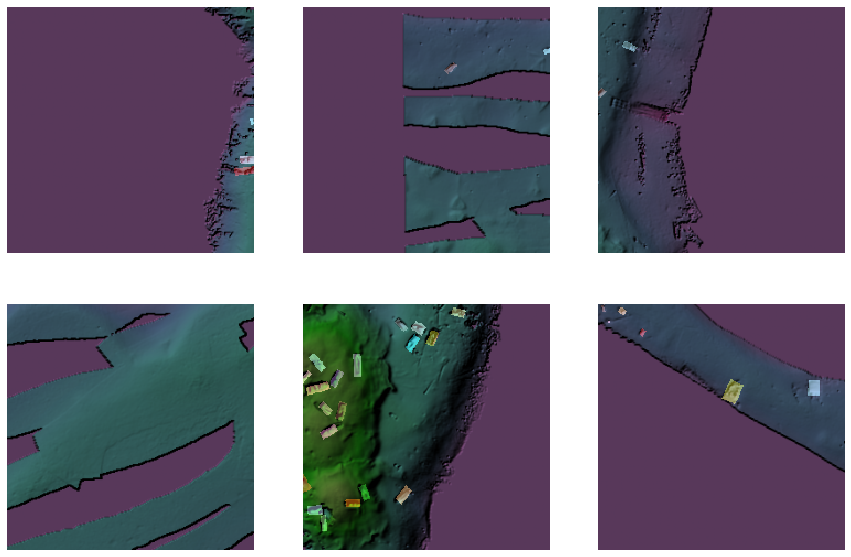

In [20]:
data.show_batch(rows=2)

## Train the model

### Load model architecture

`arcgis.learn` provides the MaskRCNN model for instance segmentation tasks, which is based on a pretrained convnet, like ResNet that acts as the 'backbone'. More details about MaskRCNN can be found [here](https://github.com/Esri/arcgis-python-api/blob/master/guide/14-deep-learning/How_MaskRCNN_works.ipynb).

In [14]:
model = MaskRCNN(data)

### Find an optimal learning rate

Learning rate is one of the most important hyperparameters in model training. Here, we explore a range of learning rate to guide us to choose the best one. We will use the `lr_find()` method to find an optimum learning rate at which we can train a robust model.

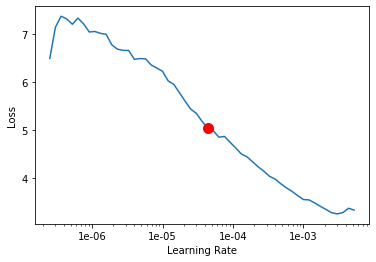

4.365158322401661e-05

In [9]:
model.lr_find()

### Fit the model

To train the model, we use the `fit()` method. To start, we will use 30 epochs to train our model. Epoch defines how many times model is exposed to entire training set.

In [10]:
model.fit(30, 4.365158322401661e-05)

epoch,train_loss,valid_loss,time
0,3.597869,2.259670,00:31
1,2.205278,1.708847,00:31
2,1.637023,1.498886,00:31
3,1.391680,1.460963,00:32
4,1.256497,1.454312,00:32
5,1.151074,1.486004,00:33
6,1.097466,1.528383,00:33
7,1.028093,1.561906,00:33
8,0.984284,1.449114,00:34
9,0.932243,1.546051,00:33


### Visualize results in validation set

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to validate the results of your model in the notebook itself. Once satisfied we can save the model and use it further in our workflow. The `model.show_results()` method can be used to display the detected ship wrecks. Each detection is visualized as a mask by default.

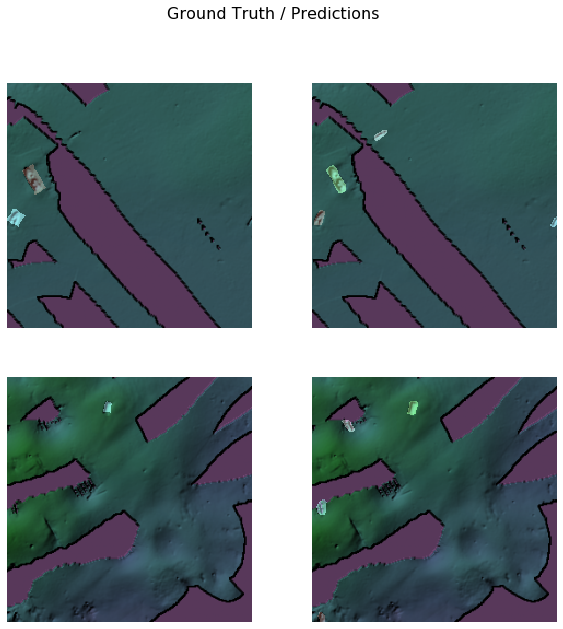

In [19]:
model.show_results(rows=2, thresh=0.1)

We can set the mode parameter to 'bbox_mask' for visualizing both mask and bounding boxes.

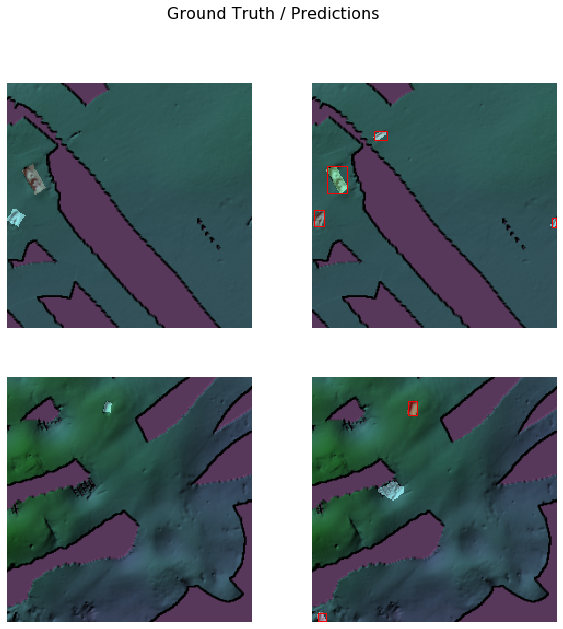

In [24]:
model.show_results(rows=2, mode='bbox_mask', thresh=0.1)

### Train it further to improve results

In [8]:
model.fit(70, 4.365158322401661e-05)

epoch,train_loss,valid_loss,time
0,0.400429,3.040464,00:33
1,0.413667,3.163553,00:30
2,0.419066,3.106115,00:31
3,0.400715,3.219853,00:31
4,0.406357,3.399163,00:31
5,0.393434,3.518736,00:32
6,0.416916,3.029633,00:32
7,0.436363,3.297617,00:32
8,0.438947,3.383938,00:32
9,0.472319,2.935371,00:32


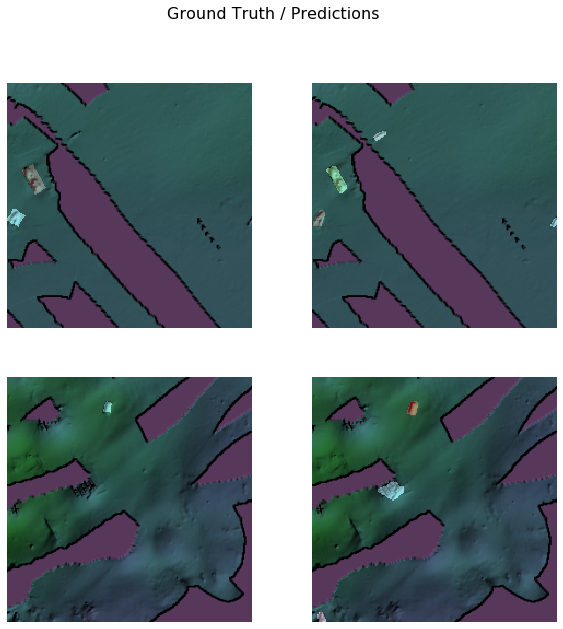

In [23]:
model.show_results(rows=2, thresh=0.1)

### Save the model

We would now save the model which we just trained as a 'Deep Learning Package' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the model and by default it will be saved to a folder 'models' inside our training data folder itself.

In [ ]:
model.save('100e')

## Model inference

The saved model can be used to detect ship wrecks masks using the 'Detect Objects Using Deep Learning' tool available in ArcGIS Pro, or ArcGIS Enterprise. For this sample, we will use bathymetry data provided by NOAA to detect ship wrecks.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAuAAAAJlCAYAAACbo0diAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P1ncB3Zlh4K3piYiPk1oYkXMW/iTTxJ0XrSk1pSv5ae1NK0pG51P3X3tXVv1b3lHb33FgQJ7733BOG9JzxIECAMARCG8N77AxwABwfHO3yzVp5zQBAFVrHqFlk0O6u+IE7mzu0y81vfXnvlzp9BbGITm9jEJjaxiU1sYhPbK9t+Fl/VjZ+d68TPLgkICAgIvBJc7EBj1xC0ahW2trZsdPzHbzq9XkBAQEDgNYPeYMCyTIbZ2Vmo1WqJr3/W/GQIqR2ryOgSEBAQEHgVSGtfRt/gCNQqIcAFBAQE3nbsK8AnxscAi1FAQEBA4BXBYtRhbGxMEt9CgAsICAi8erAotmxv72CbOJT/1dH+/dLvBp+7337Gfsf2FeCjo6PfSCggICDwLsJkNj9DyGaL5VuJ9odCrdGAuVclPOCvFwx6WMw8QNrnmICAwFsD5nUlcW9RcTHu3LmD5ORk6d/CoiJsKpXfyfsqEtH87+50BqMRWp1u59huCAH+kqAn0t5vv4CAwJsDJsjxiQk8fvwYrW1t6OjsRF9/v0TS30XGLNaNJtMz+5iMeT//u3s/41ULcD3BzN737d0wwLQn3bsMvsYapQoNw2voWtXBIHhdQOCtBfOyfG0N4eHhuF9bi/b2dpw5cwa3bt3Cqly+L2/bwY6a4OBgZGRmSvaB0zL/r29sICY2VhLy7LzZfc4PFuBms3Xa1I5tswGGfdK9i9BodVBqdNDuc0xAQODNAZNockoKQkJDUVBQgPPnz+PatWuYnZv7hri2g0mVCTgtPR0Tk5OS4Ob9TNBr6+vIJIKemp7+xvmvTIBT/SwmquP6FhLvTePznCkcyrPiy6w5tCh1MAqhKcFgMkI1s4K/9urCkVY1TMYff+ZDQEDg9QDz/crqKuLi4zFDolixuYmrV6/C08tL4u5vE+DM511PnuDGjRuIT0iQbADnFUZi3tnZGUPDw984/3sLcD0REIw6tI/IkdSxirTOVemFzeIhJTaMdHyfc94lmKl/KsqG8Cex0+jZFNOWAgJvMpgw0zMy0Pb4seS9cHNzwy0nJ8wvLHyrAGcxHRUVJRHv4NCQRKxMtEHBwfDw8MDC4uJPI8CpbtBp0dQ0hT+PnYRv2xpG5WqMyVSYkG8hvXIaSWOabwhw5nU7du/fe2y/43a8aJq9v7/rvG9L87z933Zs736tVocVhQZrmmfT7Jd2L77ruICAwI8PdnZw7PZePG/20Q67AI+Ni5OcJCy6X1SAM9hGjIyMwNfXF6GhoQgICEBQUJAk5vd6vxnfS4CbTAZszqzgi7QJHC+ZRdgjGSKblhHROI9PY8ZQumqA5R33nPAU5dSUHJn9G5BpDGLKUkDgNQATMhPgXvD+/dLbwYTLnmwOP2HB7EoC3IkE+H4Cejf4PI4ZTEpOhouLCx7U1SE4JAT+/v7PPfdVCPBtI4nvxkn8r8FjeCDTA2YDjMan4JlN0w5n8W8DtBod5Eot1tU6ahelo+M8u6c3Un5mPZRqLda2GDqobN51e3laHYH2mfW6nTRbtI9tiV2UchoeGOhpYCCnNEot/+a4a8pHZz9Piw3az/XZPdPKafS2NHyugkSyVDepHlQ3lXX/Jp9rcxBJx+jvTTom5Uvtsp5D+e3az+21z2I+I6C5TfSvyZaW81fRb87fnsZI7TMZdNigY5wX14vTa7ittjQCAgI/Pph72WGSkpKC1LQ0ib8ZPJOZlZ0tieHnCWnez4I4Kjpamr3kcJRLly7Bzd1dEubPO88O5ha2K42NjTh9+jQuX76Mzs5Oad/z0r+QADcSecjGl/Ffw4fg3b1FhGOgpE/jBtUqjUQydqIyEAFt2+MK95AmQwphsR+3PCtU+Vy7YXheGhOdv20zGFy+3WPDDdopl7DbGNgh5b8rX7vBYeOybY+JpH93e4GMJtt+Aofb2NvJ9bDvt5dltJik3/b6cpylZaeuBPq9N87ymfypTmxoqGLPpBEQEPh+YD5gYTs8MiJND3b39OyAf48Q12m02n3PZTBxckxfe0eHRI7sAXdydoZsZeVbBTiDyZqnIVNTU3H06FEEBgZicWnpuaL/ZQtw5jedfANfh/Th0COFxDHPCMs9MJu16OyR4XjKCN7PmMSvE0dxhc7b0hFnkrjdUqrxsGEGf5c8gY/o+Ifpo/ir1Dl0LKmhZf7SaZBaMoL/ljWPOw/n8TGl+ThjDP8xYBw5C2ropTRa5JSN4Zf584ipmcHvMmaQMb5F/a7HWN8yTmaO45epk/iM/v3PiZOI71JASWVzvQ1GHSYGZTifNY5fUJpPU8fwi7x5PFmnuuvVKLg3gw9TxvBR2jj+LmUKaeNqiaPVVO+7NRP473cm8AnV6Reps+hRkagmG1Z+bwJ/Y9v/89QZdNJ+rG3gy7gBXOqk84m753rm8B/CR+BRv4RLuRP47Z1x/Dp5ClXLWonzDVS/9VUlvFKH8NdJk1Jen2dO4UTaIP62SIYl7bO2RUBA4McDcz7z8+3bt3H8+HGJe48eOSKFD3Jc934vQ9rBnJ2Xn48A4mo+PywsTOJ8T09P5OblSXnvd54dbC/YVrCNSLxzR5oFZafNwODgviL8hQS4JGrVKrgk9uEvS1ZgIOLc69ll74GdzFlwTo+t4FL+JL7OnsS5ulUsa6xCVwphIQOTXjeLz7KncSR3Cp9XLGNqUyd5EDhNf+8CrtbLMTAqx4n8aRzMmcLx4iVMUj04Bg9kqHKJ0G8PbiLvwQw+L15Ej0InvamunFvFqQI6J3caXxI8uzYl0pXqRnmzh36gbxGf50zjMJV96O486pZ01GwjVhc24F48iS+zqbyqJQxssMfIWuYwnfMV1eMAnXeJ2rNO+yx6Hepb56S8viL4tm9AR+J5emgJ5+/LMK0m4b2lQkL1jFTXbKrrl1JbFtC1aW0r18lM9Wt7PI+v6RjX+9q9ZWQ2z8HtMRk7Guh8m5EUEBB4Ppi7+A109kBfuHgRhw8flkj5CBHypcuXSUA27KTbey4L7N6+Pnj7+CCByLiqqgrXr1/HlStXUFRS8o30e8GEyy9sMnm7u7tL4Si1Dx5IAny/8l62ADcRb0+NL+BPvUaQN695OsCn/mFP7gZBZfPQcuzzSP8s/k/vEWQuaSkXMzQrcnwQOgS/IRWdq8XtgmH8x4QZtCjYk86OBQ2yC0fwLyKm0KKkfXoNEvMG8TOnATh0b0qOB2xrcLd8FP9fEuFlK5SvUYuswmH8zGMIaZNUJ3ZWUL1Geqhs3yGEjagke0KZYWpwHv/OdQDeY2SoqC2TAySEfQbhP7gFI6ehvEaXtrCypUNWyTD+f7fnMGzgc03o75jB/xE2iSfEt80Nk/hfvUfRruJjRiwvKbFp0qG1eQr/mPrmkdK6X7ashIz6A6vr+E1wjxQDbtk2YrZzGv+vm0/wuyqyAwYTYNAgLK0ff56xiCW9EebNTVwmwf6romVM6ygvqtvSuAx/6dqOf5e1jAUhwAUEXiqYu7dI0BYXF+PUqVMSb7NX/Hncuxs8Q8mOktGxMSlccGx8XPrN2C+9HVxmfX29ZB/Y0852h2dBExMTpfJZmO/1oHNdvlOA83Ta6uIK/qvXIBIm1ZIH2H6y3WvLkAQ0pW1pn8F/CRlH9rQSi6sK+GaN4NfFK9giIlLJ13EkYgAHqmXoXtFgZl2J5PJx/PugCdSRKIVJj4aaEfzfHHvxm0oZRlbUmFzdwNWoQfyn9AWM6qhMaTAwgH8UOIzU4S1MyNXQGHRofDSDvwkbQTTtm1xVY2RxFV8GDuCz6lVskEHZ1qkRnz+K/ytpGuXzasysbOF+vwz18zrMTy3ibwNGEDKgwOLGFlLLx/BfUxawTG3tbJ3BnwePIHdahQmZCpXdcqxZ9LhbNoZ/FzeJukU1hheUuDewBhW1saduDP9L+BSeKM3AxiaOhnTh/+E3igwyJrNU19icQfyH5DkMkUBnQ3b33iT+c/gYMiZVmKHj1Q3T+Cc32vFfClahIELfO9gREBB4cTBPMfGy15tFMAtwfqudxfG3ETKTJU9DMnG3tbXBy8sL1TU10koonV1dEsHudx6Dz+U36B0dHZGWloYtEtX379+X4gkrKiokr/vecl+2ADeb9RgdmcU/dRtF8YJNgFMdtOvrcMiewMepY/jzgH4cbVYSn6vglTCAfxo7g4rhdZT0raOmdwVHw57gPxeuYm5Zjv/h1Y+AYRLj29Z2sIdds76GX3n34VYP5WHWIiFnAP8ifQmrxGMsOqVrQW07HNqHy+0synVIzx/Ev8pcIrFrDX8xm9TwievHXxfKSHbTeZS3lmdcLVpEpQ7gLzKXoYQGkXcG8N8KZFDvpLE6M7Sbcvytcy/+UL6Me1T34oENVLfM4d+6PsGNQRLpXbP4328NwL13A6Mb7HwxYZvaMPRkDv+K9rt0r2NkgwcdxL08M7m6hvdCenC0jWwf8fs0CfA/8R9G2TodI5tHhgWPHk3i/xM4hTEN9TENHv4lDVxq1632jJ0sIPuUnNOPf0N1FwJcQODlgzmYObqsrAyPiYuNLyC+GXwei+kNhUJynvAqJvx7r3jeC05zJylJ4ncul8vic5jXc3JykJ+fL9mb3edwmu8U4Cyq56YX8M89RlGyQMREv/nEDdkaHPKncSh3CgcLZ0nU0jHdJj7z7cPJ5nVJFCu0eqz0zxEhDaF4TY97FaP4s4QZzLEgJsI2UgWhV+JYeD++ql+n4g14eG8E/8+QSbRvEOmSAObQDQ2V9bcBA5JHBHo1nJP68Kd5qxJBMulqqLO+CCRS7yRSp8GA5CknUh0bmMOf+o+ijoh2aWwJ/9FnEIUyIl3Kl0NcpHQWNZyiB/APJSvYpDpzvKBqRoa/JkMSNqvBvZpx/FPfSQyy+Jc8PRwmokFEyiD+/PY8ZLZ9HI/IoSZPGsbxj2Om0aM0AYpNHA7vwQf1G5KHnglcNrOAf+k1gsJFMuArcvzCtx9B7NWhYyYmfK0Gnok9kqGTBPiuayEgIPDDwB5p9mjzCzIcfrLflOBeMIHaRTpPR/KLOXwek+1+6Rmclj0f/LJmbm6uRMacnvNpaGiQVlHh0Je9ZPyyBTg7UpbnVvBXzn3wG1XBYrEZI6qvFB6nVeB4RC9+W0scyn9H9uFf355BwINFeNda4Vu3iMIJFaZnF/Ev3UaQPk1C3u6QIe7TbapwIqAHR1o2JMEcT6Lz3+XIsEri2i7A9So1zgf14KsG4nsSr6l5w/gfpStYp742kNC2mKjswH788j4dt+XN4HC/0qIh/NvYOcxTmiPB/TjWsoVtFrm2NJy/cnYB/8atDx8ULiCI6sv19qI2BDYsoZHj3ql/ix8v4e99n+CfhY3idNMaFMzttL+0Ywm/8OvGn4SM4mSDHOvEv+wB3yvA/zf/EZSvU12pTdvUhmabAJ/Q6tDWMon/mf4eVj6d5YRei7SCQfxrIcAFBF4ZmA+YZ7+Nr58HDlVhxws7T/Y7vh+4LLu9sO/jv9lm7OV7+7EX8oAvL8jwH5wGEEXkK734Qvs1ag3GZWqMji3izz374NavwfbKMv6day/+ImECX2VO4tMMQto4fpU6hQdyNfzvDOIvi1efIVYW0LfTBvDfc5aghBEPq0fwz+/MYVJlomQ20lYSsQf14nwXGQeDGrcon8OPFFI8Nwvp1eVl/Jn7MFKmrNOT1nobsbGwhn+gusUtqtDQPIn/GD+Pec3TmHFpSa7NNfzWvxf/e9T4Tp0/S5/AzxPHkDRJBCtbx9HkUfxj7358WbWMJplGmiZdn5ThNzHD+F9I1F9/JEfPGg1AqOy9AvxQWC/OdGxK/ciQLS7h33oMI3deg6WpefxvXmO4L+OBjbU+HDsZlT2A/2T3gNv6SUBA4I8Dc4l9jdb9ju8HPodFNH+Mgacn+fd+6XaD08vlcim8Y3d6LndtbW3fOMSXLcAlbtGoEZo5iH+WNI85EsU7qzTxMdUGTpDofr9WQWepEZw8iP+Qs0J/W99pkWD7e1Mmx6+9ifP7qJ7bVnvAHvCtlVX8rVc/vAZov8nqAf+naUs7ApzTqGWr+CviUif2klt0SCEB/rd3V7BGfcNpzCYNwpMG8JdsD6isHQ+4WQ2/2/34L3ky6KDCrSj6u3hFCj9hjrR7wHXKNfyK6nCzW4XtPXVne2J/34btV3v7HP61ey+Cx5i7n+7v7Jwne9IL/zEdsPYcAb72TQE+TgK8p2Ma/9hnDM3rOsqO+5YFuAaRqX3CAy4g8IaAeZtXTXkRvv+h4LxfLAZ8S4Xrsb34r2Wr0LOn1kYgTGaWNSJd/wF4D2iAzVUpVCVwlP4mMc3hKjsvNm5rEJ0+hL/IXgJRsU1YErFatPAnYv1FsYz3op4E+J8kzmFabSVM6eUhxQY+8OmDcx+R9j4CfIOI/689BxAx9nRKlD0mKzMr+C+0P5cGCg8bJvCPw2cwp6URic3wSFOMug18HtSPI62Ut73OBK4zt1N60ZLEcVufDBeSh/DPIibRt2U9btZoUdO5hC/IcP2njAWsGIzoa9wjwMN7cfLxUwG+vGAT4AskwCfn8Seeo3iwSkTPxoMNoUGLqKx+IcAFBF4Cfiih7vVsfBeeJ/J5/375vHQBTmC+VMo3cYv49r/nzOH+glZaRYRXJjGvruHXQT349X0S4BYTZgdn8a9cBuDUuYF15mGqX/2oHF3L7CzQIr9yDP8hYhzFi1potDzo2EJo+jD+U+ocRtXEYyQ67+QP4mcc7tGllASydlMB18QB/Ms7sxhUWbkuOWcQ/524X24T4Mz3s2OL+O++A7jZocA65a03atHWNoN/6zeCTCl+3YhRqt+/d+7HlbYNEvjErZtbqBxcw8SmDiXlw/hn/uMoWFJDI5W7iYzedah0WnRMbWB4UQMD2aWNiWX8Z68+hM+o0TurwCBxsoH4fnNKRnasD76TxMvyNfwmsBuHWqwx4FPt0/gTn2GU7hLgjU2T+H/7TmJISRZMuYkLUX34b6mLGOWYekLzoyn8k2vtNKARAlxAQMCKFxLgDA5DmRlfwS9JqF5sWccyT9mRWGWvAuQr+Avffrj2sfdZh+DkAfyX9AXMsLjl40YNniyqJLE73juHf+8/jLQZInE+RnksTyziL/yGECWFYejReH8UP3MbQtwoiWlOY9HhbsUo/mcSvo84rk6rwk0S4PwmPxsUfgHUrNUgOGMQf5O9gCl+8YXPI8GfXDiM/zNpHjO0b2NhFT/36cWZ5g2opZVKDJCvqzCzpUdp6Qj+VeQ0ujSUP59r1qKP6qwm4zS7roaaBwrYhmZ4Hv+CBhj5Mh0W1jRWcU77x5rG8U9DJtCpMmGQBPj/+h0C/N+QAM+a08JCZH0otBcflsuhkvqDDN/4Ev6TUyf+qkQIcAGBdwWvQoAzmDMNGjUe9i3iYMI4fp8xgQ/TJ/BR8hj+KmUGzetaqyfaqEPPyBI+jRzBbynN+8kTuPxgBbMkKHlJPRbunW1zeC9lHH+g83+fNoZTtXIsqTjkhviSODk+ZwD/KmUBMdUzUhm/Tx7FPxQvY5E/9sPx0ySIS+9N4eTDNWyQ8LZzHZ+/NCnH5ewx/CqV6kd5/6FwHvUkvs22kBOTWY+J0VWcTR3Br9Mm8MGdMZytpfqRwN02qpFTM41fx41J7Xs/aQoRQ0pYoEM91fmTeGudf5kyhTuDSmJdEtEd8/g0nsqh9Lw/vn+T7ATx+7oCFzNG4dWnkcIIFwcX8X7qNBoUBslBZCH71N09j5+nzWNcSf1G9dpSKhGcRXWnev2BcKteBr+MfvzrjCUsaIQAFxAQ+B4CnMFiUzYnh9NdIsREIs2iaRwvnMHRpGH8k8gJ1MutXtwN+RpORg/hrxMncJzSHMmYhG+vwhpzbSKia57D+7dH8GneDE4VTuI3yZMI61BAx15nIuX6e6P4nwJHcTp/BicLqYzMUfzL6ElUzqisb7urtnAr6akA57rxv4o1JSJyRvE3qZM4QecdyiXyzVzA4xUSynTcTIODweFVfBXZj19mT+MUf/ktcwplHBeo3oRL+gj+MnIMR4tncCxzEtcfrcFIIj7z3jS+pDpye99PHIcXDUC26L+AnEkcyJqSyvrt7XHcHtiEjkR9T8M4/skzMeC9OLVbgC8u4c88h5HJ8ZPQY5b69GDoIH6TS3kVTONi0Qx+T+f8pT0GXJC1gMBbj1clwBlM/PzRMA7Z4Pdg7OCZP/vsJoP3cbid/TifY+cjdnwwr/J7L/bjUlo+TvlzKF1cTj/+jxwZ1vUmbNvy2VsG24X9Plhm3f80b66rfS1vexqpfFu+1jTW4wze/2zdreewh32n3fQvt8keQrO7P+z7+RzOh8U2/819x23Zzct8LreL00uhMPQ3/+Y8uAyeMYhOG8Dfl61i3SScKgICAlYueWEBzjCSCOcPDEwubaFvcQv9hL4lFeYUVo+GlIYIR8fGhI9JUGOLyMpOZkxM7HnuW6BjhPENHYl7q/eDY+YecAx40jxG1rQYsZUzvaWTSJDP1+t1kCvUkKmeXYWASdCi12Js2XpO/6IKKzom4adp+GUjlVKNQa4XlT0m10BDdeNzjXTulK283gUV1rS8X4/NTQ2GpHZsYYDEvJ7qwR6MtXU1Bmz7R6mu9o9EqFQazG1Yl/RiL5FsQ42VXXXlT9XPr2mkF1S5T7jtO3UirCs1iM0awN+UyaE0CrIWEHgX8CoF+EvHjgAfwJ9lyyB7V8IuqI1GtRaDK2poeAaYQy+hx/DgvLSkY8Kud5QEBATebXxvAW6H5M1+Bs8e54x3H7OLbzt2n7+bmO0C/J8lzmFcZZI86nvTMCTBvA+hP1vus16KfdPQ3/a6sUdnd72eenp2pd/Vlufvt+bDfzP4770imvfZ03OMorTWrUTWJmjkcvy93xBCRlTgj/LsPk9AQODtxFspwLOsLx4uvzMCnNqt2cS17HF8nTODy2WzuFQ6gb8IG0dCjwJK4nPhUBEQEGCwhvxBAvxlQRLgFcP4x7GzGNky7kz7vZWQyFqF4OoZ+DatonxwHaUDS/goYhjHK1ewzJ72/c4TEBB46/BWCXACC02ZXIURuVZyMuyX5m0Ef6J/Tb6FtkkFmqcI9G/vunYnRGW/cwQEBN49vHYCnL0kU5NyJPYqINfu78F+m2A06TA6IUdwzQI8awn3FxA7yMtzCU+JgMC7hLdNgDN4pnLv7Oi7ACkc0vQU9vhzAQEBATteOwHO4BcqOU7uXRGg9nVp7WBPyX7pBAQE3l68jQJcQEBAQGB/vJYCXEBAQOBdgxDgAgICAu8OhAAXEBAQeA0gBLiAgIDAuwMhwAUEBAReAwgBLiAgIPDuQAhwAQEBgdcAQoALCAgIvDsQAlxAQEDgNYAQ4AICAgLvDvYV4CNCgAsICAi8UggBLiAgIPDugAX42vq6JMDtnP+zubm5fRMLCAgICLwcaLRaTExOQqlUCgEuICAg8JZDbzRCLpdjYmLiqQBfWVmRlPl+JwgICAgI/PjQ6nQYGxvDxsaGEOACAgICbzn2FeAyIcAFBAQEXilYgI+MjAgBLiAgIPAOQAhwAQEBgdcAP7UAN5pMsGxvSzCZzdK/ZosFBjIS+6UXEBAQELCCNbOdQ5k3X4RDfxQBzplzwVygHfx7v7QCAgIC7wKYF/dy4reJ2Z9KgHOdmO+npqfR1NyMsrIyFBUVobKyEm2PH2NxaWknzX7nCwgICLzLYH5kzMzM4NGjR89waEtrK+YXFiQbsJdD/ygBzgWyUeG3OPnloZ7eXnQ9eYKx8XFpaRXOg9Psd66AgIDA2wjmPeZF+doaJqem0N3Tgyfd3RgdG4OdW/fjxZ9CgHM9uU5ZWVkIDw9HXl4eamtr0dDYiJp795CZmSntv3v3LjYUChjJiOyXj4CAgMC7CBbWS8vLyMnJkbgyNzdX4tCmpibU1NRI+0NDQyVRzlp5t3P6BwtwzmRLpUIFKfyoqCjEx8cjNTUVGRkZuJ2YiKjoaGQSqbPyZxf8fnkICAgIvE1gMlZsbqKiogKRkZGIS0hAenq6lRdv35Z4kQmZCXuvR+RVCnD7IKC1rQ1BQUEoLy/HOpXLvL47DIXTLO4yLgODg9L+/fJ8k8CGj9u2G99l874Bw483K6CX8tr/2DOgdN9aZyNfPwsMu/c9AxocWuj6mn8Ex9gPbT+3Yd/z+J40QP+N/c/CYKb6W0zfme4Hg+q2u48l/EjX+YfC+rz+tHXYgcHKEcYXuV/fcjAXShwaHIzS0lLJSWEgDmUeVRKH2zl0ZXUV2dnZVg4dGICR9vH5P0iAcwHszWFjkpGZKXl5VGq1VBiLbV5Oi/Oorq5GaEiI5E3h834sshL4EfBdDxGRJPEczKY38JqZzNhmIyQI4tWB7hdJtBn3OfaOgPlvaGhIEt7sfJidm5OcFHYS1lKaZRKzPC0ZTLzIU5N8np0XX6UAZ57mGctgMhzDVCZfO6mOVAfm9snJSWldck7L9WOD0tHZKYn16ZkZqU1783xToNdpsLG+isWFeczNM+YwtyjDlsGC7RcVpsQtatUmDbZUdF3/SI6kvFRKBRRb1v7eHyycAZNuE4tSnecxO78A+ZaexCgN5CiN3rQN5WQTogKT0avUfpP/6BndVq+iKskTISXdUFN7f7CI/SPar97awNrGJjR7ztNqtiBfp3tfS23Ztf8pDDAbdOgvi4BHYjkWVS9HBGqoXTLZEuZt/Tw3N4/F9a2fVHRyX68rlN/os1cOugkNUw3w9vJE3YSehOQ+ad4R2DnU398f4ySgmROZK3n/4/Z2BAQESNEg9kEcH+/s6oIfped1v5lTOf33EuCcCRfGRMzKnzNhcAGrpPLZxW4nbE7LN3FYWBge1NW9uaRNxMV151Ewt43BgxDrvn3S7wcpD+7wfY59H3Dffle5VBan4VGWvb7S9SBIxGY0Qbs2hXsl1RheV0nt2nu+eWsJdWXZqB9ao2v7wx96HuFJ7d7n2LfBQCLaZPqmMXzefjv01Lat6cfILqrA1Ab1wY9NmNRXfN2Ntn6V7gUq00RGkPfte87LhO3e/KPvqz8GNJgzrk2gtDAHnbOan8xI/ZTg542XEPT19ZVImfnQzo0NDQ24W1oqOSn4NxM0Oy3YG/Lw4UOY6VzO41UJcL5nOa6bDURPTw9onC3t01D5lVVVuHbtmlRnrg/vt5/DAuTBgweS44W9/PZjbxRIpG4vtOLW6UM45+KP0NAQQjDcvW7Bze8OOieJ74hjdp/D3mm7EbU+ZwbqMy3acr3gGl6NDQOeefa/mX4XKJ39mOTtpWcHWMPd4MsIzB+CwbK9D1eSUTdpMDPQihQfVziT7Q0NCUWgvwccHHxR3TNFYprEIQl0RW8RTn3piIfraonv7WVZy6ZBskaOhvwo3Lk3ROdYhTsf+9Y683HbMetxEvLQoaPABy6hlVjTU9l2G7G7ffvcH0azBb3ZLjjqEI2RLRqw28rSG83YGMjD8SNXUT2spIGQ7b57plziXhLgo3UpiMytg4wEONtBvdSPu9tAv3eVKWFPvTjtfu000QBsvDQQHx84C5/gcKmfw8K8cO66J3JKajGnpEHQLtHJddpdv915WY/b6/RsedJ5z9R5//pI196iR3+pPy67pWBKyX39zXTfVo/dZeztm719Jx2T6sb7d+dpO4euk2HuMWJiYtAyYxPg9vRU12+k3wEdtx2z3vf8+5v99aaAeXx+cRGBgYFSiOFubctbTm4ujh07hsePH0tt5v3cZubQ+vp6yUljn3F8YQHO+5h4+WSOb+HM7OmYuH18fNDb1/fMuVwxJnuu6NDwsFSg/dgbAWI10/xjeN+6ihuuXvD29ia44ZpXCCqbBqDUW75TcLAo3FxqRrRvDPpWn32Avx+IUHXjSPPzQe0YjcD2zYcMv1GFsUfVCA9wg5uXN7y83eHoEYO2iUVoDFRf8zbUU424/vVFlM1wTNIeQUsPGdZHEeV2BjEPFn7wNeNByupEDSKDUjCueMF2071j1G3hXoI7gnJbsGm0kqxkPIwKPMwIgEdSPVTUF980VNTXJgsUndk46+iFjqVtMlzfTPODQfeCZXUAUV43cMXJw3YvkBH09ENeTRc2tK9WhEuDjak6+HuF4skytfUH31d/JKjPzfNtcHU4j4Je9Y/b528AmGA53psdDez5YIFtP8b85+HpCVdXVynsxP4scRp+6ZE90OzQ4DxelQDnOuXm5SEvP1+qD/M1l8/G4saNG9JggdPxMavBtBtVg1TH2NhYaVaT9+3N+7UHC/D5R3A4eQFFoxpbD7FneQ11yV44fuIaqse3iKv4OTbSdTJBubYshVIuytagIW5k0aFam0ZJ+EVc8M3D2MI65JsqiaPMNBDfWremX5DJSeTSIMz2XLLINJu0kLN3lY8vr0Gp1WFruR9xN4/AOfmRdM46e8J32RSjxYilviJc+PIsogs78PTOMGLwXjIuHTuKpOZ5sJTf7C/B+cOuaNnUYnN1kcpZxPKaQpoVtDtteIaaZ2Os+ZOoJdGvVa5igeu0JMOmjgb1tplPHiBYSAwr5LY2La1AodZCvTGHssjLuOCTg5H5NcgVW9CTuDZqFVhapHQkTlbWt3aVYwUL8J7Mmzh4NQLDzwhwCzb6c3HkwCVUDpEAp35nMaxcl9n6ispVaaV+0VL9NTo6j/7W67RQkiZRkz3YWrf269LKxjPtZTuk125BtmTtD7lSBRU9X5uqb844cJnDBb444Z6JZeoX62bEyugThF/5BNciqrCosdp8A/GeSafE8tKClO+qUiOdb82LhTPdCxv2+q9CtXMv0DXfVGCL+llj7/dl7ndq8zdEqVWA95X44IJL0r4CnPvUoLH2+/ziEtZUup168PVTKVYksWi/JjzAtNpOaz2UWr31Hqdrz9dWo1JiU62DTs15zkvXXKmle8JeN+IADd239nuU0yuoTJ1605ae2qKh+2qHH9hpZcDGikxqKz9Harpuik2l9TpKad4c2Pkyv6AABQQ7N9rBG3PrqVOn0NnZucOxdvD9m3D7NupIiG+Thl4j2/FCApyJm2O+U1JSnhZK/7LRuX79uhRHyAS9t0ImMjY83cqjJp6S3S/v1xZE2OaJ+zhz7ApqZrTWB8+sxXRvA/xOfwqn+FqskgjnmDseRVq909xu9oDR33TT8g2/3peDs6ed0LEMidA4bz1dGKtXnPuR/pYulLVce17sWeDj3KcGHgystsHp+FEUDRh2vARPQQ/JtgJ1t91x6JgPHo4tUf3pPJMa/fezcPnYV0iqnwaP0TTTzbh1/DqqF5Qw2+rA9d15aNiYcAjKDiFQHaT6WK+tNAOwS7hL9ad8do+c+X6Zf5SAM5cCMLRhC2eR+sWezmbYbXlYy6X7RbeJfI/DuBRdgw2yKnYBDuM6SkPP45jvXSIzIhE6d29eUh5EjLtDULj/mQx3+pLbSXW3l8vncl13rhv9zV5J+/k7oHsBS49x89RZ5PTTwIXTk9hcmuxAxKUDuByYh3kiZyn+0paPfbTPfbvjJbL3JddBqs+uvqTfXBfJeyXVZ8912QU26JsjxThHooHsLyx7hC/3z9NrYqsP/S0d49/c93yM+1Gqq+1cW3/sroO1Xry00rP5PfV8cUjT00EW3w8sMu1ttN4fu/uU2iWdb+8Da/ja0z56c8DXr6SkRIrx27kHbeD7093DAx6E3QKcYaH2sjeEBS33wasQ4FwOxyay93tmdlaqL1+XSRoMODo6Ijo6WnKYrMrlUhjhbnD9+Boxl/N7Pnvb+kbAJsBvnLqA3P6NHVHBAhBQ4q73aRz3KsIm8YXJokBHWQH83K7DLyQEHi5XEZjdCoV2Ey25kbh64nN8fvQKvAKjUdQ4BgNU6Km5C3/Xa1J6L9cr8E1rgFzFfWyEamMe9+O9cNXFE0GhdPx6KKpG+1CV6INTX3+Eg+ed4Rt6B3X9CzCQAJXqS8+ZQStDivNRuCQ1QUu1fOrwYcltRkeWB744E445okhl/12cP3gNiWW5SIwOQmCAPxwvnUbigwmo6Tg0C8jyvgrvom5oqC9M22pMdTUj3O0avENCEeBxFY5hBZiUa62cpFPgcW40bjk7wZfa5O0YiLzWDjQUx8PhFLf/MjwColDYOIH15SHkhrjCKSgYQUFecPTOxgI957v53SrAb+HQ1ch9BfjRg5dQRQKcyAwjD7IR4O0Kn5AguLj6IL26D8QQeJzihkthpZBxe1SzSPW6iIsBiUhPDEcQ1dHx7BlElXZAzg4R5h/tBNJ9XeBwwwNBgQEIjgrEjZNH4VPwNBbXDrsAP+6aihmtvX4kgvnumKvDxc+OI6d9gephhkI2jpxQb7j7+SLE3wVXXILwYHBV4mojDZP6H1QgkO4FX+pXb7oXPJMeQLZF10y3jkKfy7gRkoK8nBgEh9LxG6fhEJaN8XWq8zN2xy7AfUmAJ39DgBstOqxODyDFzxkegYEI8b2Jyx4xeDyttNoMxTRSQt0RSNckkNp+/ewl5LZOQWUksqb7qijoFq4FhyMuPAQ+oanomFrDVFUoDpz3QHJGEiLC6L6/cQ1OgUkYkrP2oftvpBRnzjjh4SJrEDMW7kfi6zMuuJORgsjwYHjedMBNnzj0yjgMiu59qNFXm4SrR6/CLywUwf4+8Pa+gTOO8dResitvGOcz77H3mrlycGjIZudMEj8yeNjG4pwFeFtb2w63M/hcdlxz9EhScrI06/hCApx/88g5LDwco6OjUkaSF2dqSvLusCjfVNKIhtLwVKsdHEfIaTk4nQ0Nn8uEvzvv1xpMUpO1uHDqOmrnaGRpu/mZr9WyRlz96jgyWheo0+kCaJVoK74NL09XeLndhEd8CRbVBsx20IN44xg++uhLXHX2RmRmAxQWIzaXZ5Ef6QI3Ly+4u95CYs0gNCSiJcNGI/a+ittwcnODFx339kxB63g7kr0v4bMPP8RZBw/4RhViWor1s14rfjhWu2nkdeQKHkypJS+CtR08ZbqNYXpQDh73wQA95Pq5FjifuI6s5kZkxVL5VI6Lpy/qx1REknQLbYwhKdAfJX2rEkkZiARmnjQhxs+RBIU7XHyDcb+fyIYJjqCWz6PiNpGumxc8XL0Qk16Dx20l8Ll8CB99eggOrr5IKOqAUq/Ck5I4OHt6Sv3kGVmKVcp/h6SpLSzAC72P41rcPSh2CfBtEuDlEZdxKqCMBPg2dKoNtOZHwIny8vRwhV88CXaq+mb3XbgFpmKcCB4GJZoyyLCkVqI8O0LqSycHd5T3LkDLxo2EoUG/gJLIADg7U1+7+eB2QSaC3AKpL5Q7gyUJkgDvgPO5i8gbeGq8ud8NW33wOHIIEdVjRM48oFGjpzobfl5O8HJ3gmtEBoZlGukc7su5vlbE+d+Au6cHXLwDUNUjkwY86jkS8x5hKH/chIxoT7ournD18kfDhPobxoIFuHL0Li6duYFHewQ4T++pt9ZRnxlGZbhTuxzhl1YLOVlhFtaKpRGkhDjB09sHbrecEXznLua2qD/IQOonHsLHJxwFFfkIpmsdV9JNXN2FYO9A5Nfcx51wD7g6UX9HZGJ0ndtPg9SFDgR5BaNpTkN9ZsJ8QzpcQjJQXZ6BQF8PODs4IamyE5s8cKJrbN7eQmtJIlyvO8HD3QtR6WmI9vFGRuMMDdSebefrDG6LxG1xcdIMH5Mr8xsTMoMuKby8vSUBzrzKx3m/PQ1zJs8OspeM83rZApzL5LhW9rzzbCZzDceq80tEPGXKItzd3R1uxAd7YZ8yZY8911niqV15vxF4jgBnGIjTJysDcPCYB7rUxKUdaThLfNmyZPWUm9b74H/xAu40TtMvI5qSb+B6xD0wzfC22puL80fd8XBOJf22bI0h9Mo5xNwfI6GrQkXEFZx3TcDwBot9QL8ux4pGB2zLke11Cr4FY9L+vY4N5WQlzhw5h7t9G5Tps33OdV5jzv/yNCqXzNgaLMOpLz6Aw+1KkF6StplHSVJoR80Y3VO6JWS4X4BHfheoZKjnm+B68ioyOxasiaFAgfd5uNxpJtm0jZ5CP5w854nmWWubTColVhWb9JcBj1Jv4npYDZRSczSoCb2EM553oaF7nI8vTc8T3z+tK+O7BPgREuDVwyqYlF1w/uoQMltk0jOk29qgAawcZrMWrYlOOBdcsiPAk90P4veXQzEit16ItScpOPjFaZQN8zOkRWX4BZx3SseU3trv690lOPXZ73Arb+CZvmbsL8Ct18G4tYjbV7+Ea047tCbqp4BrcI6rg8p2/UcrQnH8UhwmyWZtDBbh4hFn1E5xX9GmmULUtbMIrxymgZ0Kxb5f4/2TzmicUEnt21ZPIvLKl7h5pwVbVIeng5bnC3Dmf6NyAredrsA/rwNGqd9N6Mxww2mXHCywzlLMYXCK7hvbNlLmgYPnAtCzQkZLv4qiwDP4+6POeLKgt9ZjmwbjpT745afHkde2KO2DchCBZz6Fc06PdL8Zh+7i+PEbqOdzaKC6cC8Yv/z4ENKbZiQnDDQTiLr0Oa6nPKanBFjoysLZzy+hdGTFmp96FulOB/D+tRhMyN9MAc6r/HEIITtVmEfj4uMlpwbzInPrrVu3cPr0abi4uEjh2ryfY7+zc3IkXcw6mL3gzKnrvIrgdwlwLpQLC6ERpp24eUqDK3H06FFpfxwZIfZy2xERESG9cMRGh9U/r5LS3tEhCffdeb/WeI4AZ5iMWuS7H4ZD3H0iKxMaUz3pQecHl4eJLBYdiKDugR/Btd4cXDjnivYlWL2rdFOHXLyI0JIuyauhW+qE54WLSGueo5tUi/pkeoiu+KN9kQcwBsiGhjGjo5G1rBUup0+iqF8Hs1H3tJ4kJi1mBaqir+NMWBUNEJ7tYxZJ6sVuuB0+gJQnK9DNt+PWsY9wwisGw6smEm86PM5zx+ELgehfp6dsfQDe588gsW1JEoZrIyW4cPAmKukhoscU002pOHveH0+I5U2b44i9cQJOMaWYV5P4VG1hZmQUa1QH9oCfvxqMwTW+tYzoLgrC6YtRmNHzSH8DfR39WKf6fT8BXk7Gw4K2TE+cvZGEJRaNujX0dgxgkyq70XxHIpl+JRe5iarwM/gfn53DvUEFkR8wVhOKg0dJtC4Y2Eqigvrs3K1kTNJgyaxdQW3MDfz846Mo7VM8a/CeI8AZPMvzIOIsznrnQk7F9peF4Ay1c0DBBlaNplQPnPPIwwqVvzlRgUsHHVA6QDcDbfNt2Th/zhvtK5TfdBOufv0BTvomYFRupuuiRUuWCw5fCsXQmoHI92mZzxXg1Fdm4xpKQm/iWmAxVll0aBeR7nURHqmP6e4yQzbdg7b+JepF6t+NcUQQYbpmd0JPTTQOleGzP3yMm7dLsKKygKdaLdMPcfKL93CGvfwcB6laQvKtL3E5phZKut23Zx7iwrGLKJ/kgZ8ZM5WB+L9++wnia4ah49tpqAIXv/4K6R2rVOI2Bu6F4+RRLxLsG7BYtBiqjMVHv/0NAionX/xFuNcAzIPsMeaVoFaIN5lQS+7elYiW4wBz8/OlsI4rV64gOSVFCv3g/ewh4aVbmQsTExOl5VtZ3L4KAc6Ce7cAZ0EeQAaCBTjX1dnZWTIge7FbgLOx4XN35/1G4FsEOFES5mojceCoC7rWl5HtdAInXW6j5n41KiqqcL+iAJ4nv8aN1BaSlzrUJ17HtVCb0N1eRr7nGRxzjEH1/RpKX4n7lcXwP3sAVxMf0r3RAceT53GXymSvtVQe9Z+BnmHoFpDhcQJeOYPQm/bEn9NxRX8ODh+4aA3N2DPryXVmr/eZg8dRTMpva7AUZw+eQ8WMlviA0tL5FuU0Yq4egVdJP5W1gkyPi3Av6OZa4FG6Gw6c8EBx9T1UVlSguroKya4ncehWCmZ1i4i6eBTh96fpibXZE+Jndlpsm7fwMOkGrgaXY5WEKg2rMVAYgC+OOyH3fium5NZBy27vN+OFPOAsnHXTiL16FJcDUlDXOS7ZSAvZTYtRjdY7zji/I8BncMflPHzKhq3OA3aqaHrhcugY4upm6Xgbrnx2CIlN89QG7lvqMMiQ5Xwablm9dD+/mADn96bMW8tIvXUQN9NaMD9egXMkUiOyy3GvphIVVfdQk+qHTz65hEb5KsoDLuLIddI/tnvhXlUpgi8cxIUoGrDoNSjwOI4bdF8oSbHyjCk7pCfv+uHAhWAMbO4q91sEuMliwlQrDa6+oEFhURVqqrge91EW64SPD7jgMdsPvgg0aBnpeIDyyirkJ3viyCkvtM+T7TOsosD3JM4nNGKLKsCz79z+MRp0HXNNI73B9eB4fwUqg6/giH+ZxOUswE8cd7QKcBLscxUhOHwjAeNqDoPk9Eo8iHHE1x7F1OMbuBtwAQe9Suhc671tpv8mm2Jx9nIk2bg3W4DzS/XM18z/Pr6+8PXzk4T2DUdHSYA7kwDn37yfQ1Z5RSyVSiW96M4CnN+ZfCEBbidu9oCz14Z/9w8MwMHBASdOnMD5Cxdw9iwJkF04fvw44hMS6IJYjUAKCXB2vbMg3533a43nCnC6cQwaVIWcwYXQMizKOuBy5AxSanswOTGK4bFJ9BSH4ItjnuhVkegayJUEOIegEC2htywMp84HoW1kQjK6E6MDyHA9hctxDyBf7YXz2fMkAEm10g3O5XG4CoegGFfaJAFePKB/xuPJIQAgwszwOIkr8U3fJHISUXrZAPzOHUBkw4JNgB/AnXYalZLIlI6v9MP79BHEPVoAFMPwv3wByY9ZcMvJuJynwUQpRqfGMTw6gamue3A4dBQpPTJMPbyDY1dDMbtl2ekfa1iFCXOPbksCfGjd2u6+uyE4dMYXbeML2NQyg+4h6RcQ4Cf9WYAb0Zntg0MXQ/FkehlbOkpIdxq3Y70lBUcvEZFJApzII+wqriQ2QEPkYaB+0ivace3ASWQ9lsG42oRzn1N/9nI7TVQOCc6NR3A4yv2veFYMfosA5+fhcfINHHdJxezmGAJPEjmXPMbk5BiGxqYwcj8RX3/lgFYFtSHgMq4EFmJkaoL6chxT3XVwPnoEsa3L0M1y2QeR+mRt57rolnvgcfIoElvmyIA9DWF4ngA3UJqVkTJcPnwFRa2DmBgfwQjdj49SXPH15ShMkDWTiNmgwizVb3yyF1n+F3CJBota7qOhUhw6egJ3h0hZmK3tNpMAv3jqIsro5G0y7FQrPCkOxJeX4rBC+W3PNuLK6auonNRIAnyyLBiHnRLJiFGvkvGyWOaRcI0GaRndnBjBpw/Bp7CPKsGGnYyiZQax104iuGycDO2bJcDZEWF/qYZfruRwvIs0uL506ZIE5sIzZ848s+/y5cvSi47MhTx7yB+84XvoVYSgMH+zgGbhzb/ZG88GgEV2eESEtMoJDyrYK78bPLvJaTnkkI3H2ybAmUF689xwxDEJy8pxRF0+iBMeybhfU4OqqioJNfceon9aTvfoFupu2wQ4h31qJ5HgeARHnBNIkD1NX11Tj77pVazOVeDyIUfUTajpmdplWyXe/jYBTqJ68T5Of3ICuZ02jtp1nBl0qS0dRz69iIYNC7YG7uL8IVc0b/DL0FQOnQ8N2QV3GnwX7RbgPXTvbaEm5go+Iz4urbyHaludq6pr0d4/C6WuB95HTiKtbfVZ4c9cvEeASy+iK5fQVlcKDxKah89dQ2gRDfYp7TP1ZQGecRMHrkXueQmTBDjZyNPHr+HhNNWZylubG0Jpkh++/vIwLvtEoG5ARtyh20eAX4BvaT+0bMNYgKsnEXT5BOLq52BZqMKFI+dRNWog3uKyeFZqCZlOp+H+PQS45G1WTCHk8iHE1I5juTsNX316CjHZFaitqZb6rZIGMQ8f9WJDOYtU1xM4xIOxPfdC99gy9LoN5LpdgHfOY6i2qc6cP92Xa43xZM9C0LdJdvQFBLjZYsBIdRA+++oKUgur6L57Wo/G1j4aGG5j5UkpfL28ERKbgsoH91GY6oUTp73Rzs4ngwy5PpfhmtMGFfedrf1jRX5kx1IwpeH2U/k0/Gm8fRPHg0v3FeCzFaE4ciMOoyp7ej3a0ug58iuGRb+INPfjcMnskfpQag/dtWONcTj3BgtwFs4cgsKznnaHMof2Mfh4YVGRJMAfEsezx9t+jNOxHm4nDr2TlCRxKuf1Qh5wNjDsTrcf5338Fj8bmKzsbCkepq+/fwe8GgC/aMSGhVV/EhXI+94ODzjdSEYdCn3p5kppxtJwMQ599BXcguOQkBAnTUnHxMQiLf8+FkiE8OheEuDEIdhWovb2DXxy8Cqi4hKkmYPYuFjERN9GVfsElqYrcOWEGz0kLLJ3XQcmgW8R4NvmVRT6n8epkHtEdHuI3LxNPNwD9yNfI6lTRgK8FbeO30DNgsJKQpQ3tmaQ4HQBIbXTJMBHrAK8Q04EPkqj9wM46hCA2wnxUtsYcXEZ6FlZR3u+Ly56FWJTzwT4tEy+7rsFOMcPmzcmcTczFucOfYazruEo65ymPt1FgnRfsQAv8DyGa/G1zwhwnlWoiCDxEllLhEEcvTZGI/pwnDzwOS55R6O6Zw5mEjR7BXhFqANupTZBRU3kmDS9ahx+V04jvXUJqoFsHD/lQn3NswDU19SPWnUn3I9dxN3vIcDNlm3Ux17AxZByrMzX4+ynn+OGXzT1l7WvOPwqKaMSC/IJRF87hMNX/Z7py9jYNDyeU0Mz3QjHY454sEyDXM6fr4tyCtGO5xFRN/VCApz7eZoI7rOPj8IvIh4J8dYyYqLjkFP+CKtEzEsDD5AYFY7AsDDEJcXQgO9rXI5+IAlw/WApTp12QeuK2WoIJAFej8unr0nvQXC7ydxirO42jjpGYZk0BZ4R4CYS4KE44cpeNLoEfE23FSgMuIBbmV30MDyG44njyO5SSmKejaIZC0i5cRYhZWNvnADnNV55xs++tBTzJAtYnjHkY/xyupOTk7SGNv/m/cyh9vPZe8JLAfLfL1uAM5h/+cM7hYWFkqCW6kH15tlJDkHheHbetzuUhsGcz0hISJBi17m+u/N9I7BLgOcNKKRwJ24TazntwiO4njpBAmuKfm3iru9ZnPQtl47t3ngGc9u0idr4q7gWXo110jLs9asOvYwjrgXSLNLujQdZW8uPcPmzI8h4zKEe1sULuM/ZqUJkjDS3Y/DJs3lxd9eX0xmID31P43LQXaxRcvYyWs+30MB2FQU+F3CWxBGHwmz2l+LMgYPIH6bnkJ4jngnVyjrhduIiMjjMxLBMYp8EeH43tcuC3hIaRJ8MwSK7mHdtFuIzk4GE7LGv4F3QR21g7rTVmQYJ22aldQYgxLoKCh+TQhepbWxPxqrC8Onnx1EzxXbyaXu4zrLWeHx++AaaZ4nE2cnA59KpK613cOqsN7rX2ZNKfCxVxAjt5hJSb36IEwHF1Nc0AEz6LgE+gaBLJMDrZqjSvfA4dAxpLctUM5KGRKfbG33wP/c5nHP6nxuCcsItjbiL68H3PIt2I7pp/7HLYRhcM0G9+BAXvjiF4m4anHA97Zv0Q4XaGAccdMy2heM83cx0fc3adeR5HMClaLp36H7k0EJ2aDTG3MRpz0KskKh9uo479Z9dgLsmY5oHLcSZ3GcmSrfUX4ATX11F4+TWM/WQijXNIvHqYdxI4YGQ1JuQ9aaQvfPcEeB5PpfgnPVdAlyDhgTHFxbg3JZWFuC+RWQlVLgXeR3n/SugonuRrw+29WjPcMDnV6Ix/gYKcO57Bn9wh792uZsbGbzxh8tYgD9qaZF4dPdxfomVZz3v19ZK3PC9XsJkEV1XVyeROKfhGG9+45OnLTmuRbruVCE7+ObiCtq952yY+PfevF9b7CvA+eYnXTRWjQtEbBWDm9DJHuLcV+dQNWCL+bJt/DIgv0Qn7+UwAzd0sRODbtDOAn98fSkBm9brtWsjATlTjdNfXMD9Mcpr29pX/NKe5AGXtcD51EncHaKHdrcAJxiprJH7MTh6xBN9pFCfikeOAQfGHybgyHE6tkakN0cC/NgRZPVtUD70mx5A42ofvM9cQjZ7gzdtHvB2rvAKUm6dguOddqmGz256dBUG4OvzMdLLqNILJHRf8DWWPODN8STAQzC8wZ5QbgcTwTYUshncS3LDZ0cdaFBCaXcNbHiasT7hEo5650vGzZonkzUZxaDzcEt/DA39lAifCGB9aQrlsfRAn3JHv4KuS+teAX4dN1MasbUjwMfgd9kqwHVL93DlGBmDGY5no3ueLqx2pgpnD59FKWX2IgKcbah+sRU3T51CRqsMFk0Pbh48jvRH0nTHs9v2CrLczuBKbLNtx9ONm6OabMSNo0eRN6S0XhfqL8PyE7ifuoT8/uUXEuCcZnmgEEcPOKKT7tndG90iMGlHEHKOxHleF7YktaBH3R0nXAm7J80S6IdYgDujxX5dqN2SAD91DdXT1jh2OoLRBwkkwKOxrKF8vyHAQ4jEkzHLHnDqc36hrcCfBHhGJzV0DAGnTyDl0SqdSP1L1ndbNYSA84cQVP5mecDtHMi82NjUtMOLLE4Z/Ju9zS6urpKnnH/bjzGfchgKxwfavSOvQoBz/Xh5WF6/lmcx2QjwPg4T5K9fsgefHSv8m/fbz+N0vPoJe8l5kLH72BsDfobnmnDlyAkkt85iY30Na4TJrlK4XrmFqPxHUBJvMd2s9efj9JenEV/djdVNBRSrc2RQmzEwTSQDAwbKw3DCMQZD8xtQasxQjJTiwlcnEFHajhVKvyFfwOO2JvRMEPltq9GQ4YEzR33xYHIBG8pNDDY0o18mp37dQl3CTZwhgbm8tolN22of9jrzjJZ2rRfhTtfhFJiPSfmatOrO6soEsnxvwME1Bv0b/EwSbfeV4OiHf48zPjkYXKI6r6/gbuhpnHROxiQrdC3Pkl6ER/4TKaxDv9wB3zNHcTOuGguKDayvrWKkpxEPuxfp6DZGGmJx7vMbyOsYxppKiYnObnSNTlDrTRisiqD2R2JwbgNq3TIeNbdjanoJG1tqjNVE4+gxRzSvUspdbWEBpldNI/7GIZwPKcDU0hrWFZtY6HkAP4fjiCibILlngpLsz4N7fXRsg/pxkTjzMBzi72GLuKU14QZO+hfaBDjl5XgaHsV9uwT4OHzPHkLUfR5IkS2JvYaPr4ShY0IG9doSHqR544Pf/gIu+fvHgA/leeLr67EYWNmSwgM2VsZRkR6GS1eC0DwpJ743w6xXoDLyCg5dikTXnAxr9DzIZ7pQUj9A9xjZoPEqXDlwHMFFrZBtchuW0PG4EV1j63TrbKLY72u898UVFD2ewbpSg/G2LFyg9BmdK8Tju58rqwDvKfLEievR6FtQUZ3k0kvScqUWJtUCsr3O4YRTMoZX5CTm1rE83obSpkki3hUS2Gdx1rcEi5tK0hUdCD//CX5+zA0dUgiKDFkeZ+GY3vKMAB/N96LBQyImdwnw+pirOOjPYSRkUgeLcejgVTyYtwnw8kB8dSXKNqNhFeAtSbfwlUeO5NBZ78zDkSOnEV3di83NTSx2lePigV/hQ+rjNzEGnGHXtBy6xxxqd2QweCsqLpYiQ5qam3f0LvMlcyjv4/AVfob52AsvQ8iJ2eXOBmWRjAkXyoaEyZi9OPyiERsU3mc/h/NhcPwjf4rTXpk3Biw+Ju5LK03ULhil6fVteiCme6rgdukablf2QkuqxqRTIN/7JE57ZGGBPXqWbegUk2jtmSVBZMHmFAm9M1dRN2kVREr2dB44jIjqfrpdSYCY9ZidHMDIrAIWwxpyfM7himsmpskS8JfNFgb6saDVw6wkoXLxGBJZvBBRPVtfFjpyVEY745RTIoaXNiWPsJlGnGNNxXA8dRpZbXOSR0cz1QLHQz/H2YAyLElVMqAh1QGHrsRimt+3WR+0haAs0QMITD6IwsGvHHF/igwG/d42rONJ7xDWt3iKtBUeR44jvKgdSmqLkQTJ5OAAFFT2Sl8Bzp93Rccimwc1xun+kK9Z4wOVXZk49PU51C1yzPLTdjDByfpJBB48gaxHs9JNy/053ZSOq5dccX98k+rAcVST2OAYa9rkzQn46tA1tBG/bbUk4dAFewy4AuUhV+GQ1LAjwHVbY/C+cBKpHGqjn0Pc9aM4H1MtHYdGhqKQc/jFZydQzmr+GwK8HbdOn0c+x2PSdeEvsi2PNZDxcEBoTjMZCCJnEsK1MZdx5GocRvlDGXSaUTWHlicTkgdmtikBh764hqqxFalvtw0b6OkbxKrSRNelGQ6Hf4mLIZWQSbGlLI6v4vD129JLkntjwHkVlAunHNAi2Uurp5JXKzFszeO2wxFciajAOntd6FlVro6ifZAGCMpeuBw7iJjaGTqJJztqcfXL3+B41AOJYPWDd3H8xC00kwCXrgs/A1N1NNi8jMqppwJ85H4cDjlESgIcsw24dOISKmwx4BOlQTjqdMcagiIJ8A3k+56DY9pjSqxBXdRVfO6YgAkFGYJtHbqKQvDB++8huGryjRLgDOZBntnjFxk5Dpy9hPZjfD38/PwkBwWHfNj5jzmShTt/HZNFL+9nwfsqBDiDBwLs8eZ3d+yx6Hbe5o9H8Aopuz/Ew8d5zXCeAbV/dGJ3fm8M6Jkxrw4hOdIPbl6+0iDEz9cXIVHpNFhVWj28NsFoNBuwOF6PSGcP+Ab4w8czAMnFbdJL4xy7bVLPoyw5HO4egch/OErDWDNWZpoR7eIBH07v5Y/EvCYs0/3Pzy0L6dH6HGn9bj8/X3gGppMA35ScEob1IaSG+sLdLwa1vbtWQbGBr41eq0JbcQx8fX2kenvTfRVf3gUViTTpOIko5WQLEsJTcL+zGnHUPm9vX4RGl2CG8zAR22gWpRAUNxp8a2jEz+epyKakevvAx8/aF+ExpRhX66SZK3bqLPTUITbYlY77wsM3FvWDVD/mZM0CKlIjqf3BKGrpQmNJKgI8vKlu1LbgNPTOr1Odvqkj2KNsVM2iKjMW3p7UlgA/eLtF4f7wLLTcF9RfamU/kj29pfhZbx9/xNHAaI3FqFGLoZo0xBW3YI2dV5pl1KTFg1f20NK147Wo9TTIKEiIRHn3EvEzcTTZ08biRCrDE96+kShprEWc4wl4F4xIDsLddePfC235NGCma0Rl+/v7wZeuY3p1B5aJf3nFMGsbeHZhFfWZ8fCxtdnXKwGN06tSn/IswNpiG+IoH74XOI/4rIdY5BAY7RpyOSQovRBFKbHwp+vp6RKJ2pF56HY5WHbqRPZkpqMYfq7u8PEPsN2z3gjKbYJKZ6Y6L6A8LhzeXnxf+NK9lYrOlU3aT5yyNYwMum587QIC0vCgoxzx0dkYoYER3XRozE1Aev0w1HQ/swDnes89ykdE+j0s2ZbVNW5r0VuVgsjCNskWGGZaERmZjB453fHU57L2YoQlV2BebU+vx2BtJsKpfryoBA9yVkZrEeThJd33EanleHA3EOeux0mrvryJApzBnMjLDLIeZr5kTrSL7NbWVinm2z6zyeDjLNbZHjDnMudz+u/9IR5+sZINB8cSciU4Iw5KZ+8Ix0Da09oLZQPDU+Bv3BKEDCI182wLXK6exzUXL/hQp3q5uyMoOhUN/YvQE1HyjSuRxuYo0gM8ceuWK5GGFzzdiVRo1M0PtYlGvY154bh+9RYiMhuhpIdqYfwBfM5fg5uUpyeC40swtqmlh5zzWkFNvB9uurtIX51y9k6lEamO+tOAieZMOFxygE9UIWZ2rYIigclNv4G2ilz4e96QVrnw9nKDg38inowsQE0kzNOAmrkOBN90RUJJBsLcveDh7gE3j1h00YMrvaeyNgD/S+eklzCl2QyDAq1VSXA6T3nSw+/p4ovEynZsSuJKj9WpISR5X8Etaou7qxciM+qwQWLcrFtFVUoArl9zRXJFI+rLkuHpQG2i/rnpFoqajgmo9wouag9/rW6+twxe1JeevJa5h6fUn42zMkrDrwRtoC47Fh6O1r6+6RaO+t5ZknbbUHTm47pHgjQiZ29D3R0ytPmPaZTPnj4qSzWFGE8nFHawarVga74DET6ucHF2g6dPJHLLk3Hl2AWUkYJ/JvbRaMH2Sh+CnS/h4k0iQx+ulwf8Q+JR00VlSw+UlZz1mlkUxQbgloMzkT73VyhKemckA28yKtFRmwbncw62vvRBQmkrFGwfJxtx88QFRBWlS9fF3c0D7kTs3XIlCe5n+4kFuGqmjgYEp+HoRgaU6uPNK54kV2FdbYByrRfxrs5wJiPA95C3TyIJdRrgWQwYb8+H2wUHytsH4bEpSIhyg09yExlAEuBj93HLKRidq3zfUln8DMy1wvOWNx7OaSUvh4nE/mRzFq77p2JFQwPIhTZ4OXmhblYjDUpmahPhGJKHeS0NyDi9ZRMVse4ILOq2zgptTiPvtj9u0L3g6RWIlOIcGhQdQ1jF1BsnwBnMdTztaI/rswtU5sZ42xvyHH5iJ2MGL+nKU5EcI8i8+CoFOJfH4O858MDh/v37Ep9zfempkWDndq43e3RCQ0OlgYa9bW8s6PnkQTGvwcvG0gpq6zeEAIdcWF9ks6eTlmzdlQ/pRSkfuyeVn8ln01uFjT0/Dgmxlys9B3QNrHmxo4XP268eNkjPkb2+NnB9dnmYrZ+ip3Kp3ux8sabj62iWrimUE4h0uoqEhxMk8q3XUVrre1ed+cuau0MgePbVWjdrnXcE0572s6PJnofUtm8TVnTuM22h2nEeT9tCee+pk/0YD1ikdut10lc4OZ9nv9hMQp3OkdYyp2eKn0cOcbFvhtmHuHHkPIpHN+g5/GYdeSDD207ZBL7uz9hZCXvasKfN+94L3GcswN0uwCu3HTraz/3H/0ntfyb/p+A6cROelkWwi3XOc/d+roetrtK1tV073m+ifCwc4kJ9KfUdDcJ4pvUbZXF/79rH13ZnVTXK03rvPj89XyN7ei0N5Hl2YmfbVuFuwEXcSqjFBg8Cd533poG5kHUvv9R+j3SuwsahDOZxu2ODZ0gKCgulb0WwI4OP8/ls07+XAOf97Bnht/ijY2IwsmtJQr7IXCHOnP/lfDhOhl9QYoFuL/SNA7WZ263RPF1ekV8u4bWld990/AINP/QaWxoVCWbuG+txDsswWvPQ8IcQ6Df1kYFIxJ6nRseeDNuDwy+1kBCx58UL1lvL4nyoH7Ua2k83tq3sZ0APCMcBa6U01vOl+kqk9TSdtP4z12knjfW6saMXKz3wvOqA4kG5lEYiTH7gd/Lkj0Vwv3BeVpLml0PU9rxon7UutjKkdltXbVHb+lGtZQJ4tk47oLy5Lnr902UtpdH0rvRMwDt5Ud/tHKNzd5OlVWzY8t3ZZyc7JnDiBCYLImuePtzozsb5s154skGkucszv3MuXSPtrnuB68X3wm4ika6fvd2cjq75zr3wnL7kMD3V5ENrDLiMBLftuHQ9+Rrsyv8prG3bfW9a7y8iQbofd18TtXQ/cr9Y7yH+iIVKZb3vOGxlp4+4LpTu2evynH27+vmZ45zHrmMMqc9t+3hVHiZxyYiSdTTKHsPt1DmUjNo/gvL0vDcB3C4W0BkZGZLg5rfcmRP5HuaXbPglRv6bjTDHgGdkZoKXruK/7bz4KgU4g+vMZXPdeIUq5unikhI8evRI8o5zSA2v2sKrWXGYoX3KdL+8BF5fMBdtLk/gcWMNcuPccdU3HRNrJB7ewOfs+8Jo0KC9JBQhSeVoaHiIhuoyRHvfgGtak/TBob124aWDONCslSPz5km4ZLRgS+LAfdK9JdCTPd0cLIVveApq7tehru4hKhN9ccErBm3TxPW7HVxvKJjX5+bmkJaWhsioKOkFTI795s/O84v2/LEedl7wv7LVVSm9/dzvLcAZfIxHlfzmPsd1Z2ZlSYVNT09L06zsZi8rL5cKLS0tlUJUngpRgdcWRA781azZ6RHUpPnioncGFnlt6G+5F95osABRr6G+NAUVj4al+3em+yECnS8isKAXuu3neyReBnjmQTVehytfX0IVvxz7lhpI5oKRhgykVz+hPp/C7EgvcsJu4FJoGdZ2BkZvHuy82EwCNjQsTFqKkIUsxwoyLw4QL/JXJtkLwh8tk5YB3CVoX7UAt8MuqnnQwO/3sKHgjwqx15vjFXl6la+Z4PA3E+wY2pgfRE1pLgor6zG1btjjMX57wU6B9YUBVJIoKiwuonu7GPVdE1Js8rMfvHlVMECvU2G0oxmdY4vQmN5cvnsxGGHUrOBxbaUkTPmlxeLyBiyoLW/VPWjn0PHxcdQ/fIj8/HyJQ4uJQxsbG6XFSFh47+XQHyTAGXycPTzsFWEXPK9vaF8HnOO9OUyFl7Par1CB1xPSG+rDTUiKDkRkahFGV3RvOVEbwGu5jz0uR3RoOI1eIxERFouqJ7PSy4+vmhh5ylKzMoLijGIMrqve2oEPk876VCsSwyMkj0F4aCRyajqxYfypjOKPB+ZF5jx+SYo/Ncy8yCvgMJKTk6Vlwni1lP148acS4HZwnexhJ1w3/pdnNYXX+80He8GtURi86sb+ad5WMK/uikCxha/sn/bVwACjFDbzrugiI3iBgacbhyXul+7NB3OonTOZQ3dz6n7pf7AAt8NucBhsQDg8hQvjQoXwfvPA3hLpWdkVR/a2gwceu7eflBilmL23l6Ds+IZR3BPO9abD7qBgXmROlOJQv4MXf2oBLiAgICDw6vBHC/Dd4HPs2O+4gICAwLuE78OJQoALCAgIvDv4UQW4gICAgMAPgxDgAgICAu8OhAAXEBAQeA0gBLiAgIDAuwMhwAUEBAReAwgBLiAgIPDuQAhwAQEBgdcAQoALCAgIvDsQAlxAQEDgNYAQ4AICAgLvDoQAFxAQEHgNIAS4gICAwLsDIcAFBAQEXgMIAS4gICDw7kAIcAEBAYHXAEKACwgICLw7EAJcQEBA4DWAEOACAgIC7w6EABcQEBB4DSAEuICAgMC7AyHABQQEBF4DCAEuICAg8O5ACHABAQGB1wBCgAsICAi8OxACXEBAQOA1gBDgAgICAm8O9AY9jKSVTUYDjAz+Tf9Kv2k/H9/vPDuEABcQEBD4EaBnEOEy+ZpNNtiI+buImCEE+FsGgwkW6n+zybj/cQEBgTcWRqP139l1FcqG5IhtXUR0yxJi6N/83hWMybagldI9X0sLAf46gkdU29vfeuEEBAReHxiIjNnjsaLUoH58HZlPZEjrXEZujwyPZxRQanSSMP82If6TCHCDEWaLhbjGSG0wwmS2wPS6CEbqT6PJBMMLDF5+TBjN29QnZqk/JPwAW8j2c2tjBHcTc9E8vACt2SQN0PZL+zpCbzS9PveBgMBrBuakhQ01UjqW4XJ/DlFtMuT1b6B2cgslQwrc7liFZ90CElqXMC1XP5f3f7AA15vM2KbEdli2La8ZwbyY1+lHBRsz6oyn/UIi+vvWgftdrUBv+yOML2/SBXoDRPgPMFACAm8LmPdWSXjn9azArXYOAY2LSO6So2hoA4lExL4PF+D3cB6NE+tQaXXP5clXLcD1RFZbE00IcruOW+5e8PZ2g6NHAjqn5dCafupnmsrXbGF5WQaFWrvP8ZcDg0GHB7cdcP7KDbh7+8DdzQsJBY1Y0Vm+10DAQAOHjeU6XP/tccTe64cGr5t9fD70eh0UchIOi6vQ6PZPIyDwroI930ubagQ2kMBuX0XPsg7LagueLGlxl8R32cgmBuV6jKwZkPJEDg+yCSMyFUw2j/lu/CABbiDiXuqtQaivM7z9AuDn543Q5AdY1f0Eondf6KBWb0Gxpd7n2MuB3miGdmUU2XF+8PLxR0CAP/wDE9CxoILhe4ho9jxo16YQcPUEstrmYNo275vu9YEOKrpx1CQs9j8uIPD2ggfYa1tahDUtIPzRMjoWtVghMh5YISE3uYXH8xrMKU24P6kkEb6A1M5lScjtJ8ZetQA3WIDN/rs4dyUAPXI1jGY1eoqDcOyoGzoU2xw7IXmgjWbzU2+owQiThb3k1mPsHbZ6S62/TZTW7jE2mC0w028pDxPlsfO3PU+7V5g93U+PmbhcsjH6hQ543HSjvtuAxWKSyubzds43G63nG0ySF99aB9pH5Ruk49b8eN/udn8bjAYtcm+9j6NuaZjWUB10WhKhzG1UR4vVM24vX/KS07U0mCxUP/PONbW2m9pG9X0agmKd1bSfL4l5qT1U751+5vO4/pwPpefybO3lvjNTH3AZnK+Z87KdZ7bVy34NrDMaNptj6zNrGdY6W489rz1GwKJE/e3r+OWZaMi26HxKb7CfK6Wl+tvaKiDwLoGfzQ018X3zAjJ61jFP3L64ZUZmzxq+zh2DY/UsLpdP40TRBJpmVFhSm5E/sA7/h/NY3tRYn/vd+f0QAW4kbp64H40vPvwadwflUKwPIvzEAVwJLYbMBHrYLU+9wEQGVpK0kZF0bJvIgvIn0WpPByIUa+UM4L0WIgf6X9osTB62PDn1U68yEwPnZs1DIkEmkG0VahNu4jOXHOipUGusDhEOkfpOWiIczoONB9fLWmdr2IfB+LT+u4n128DeJM30I9y86oSawTnq1FXIVuTS1DOTF+fDhCrla5stYKKWDIs9D7oYPJMg9YPkeSDit5GtvX5Sv9G1YTK31tG2j8/ntFzOrr6yX3DuP6kO1gNWoqd6WfOg9u8yUlyvnbxtRC4ZFaqr/Xyut9R36mUkBXqiuHdFOsNqHKx50hX8xg0nIPC2gJ/hLXq+E9qWkNIll4T2ApFxWvcaDheM43rlLE4UT8K7fgHTCiOG5Ab4PlzEvZG1fZ+LVy7AzSzAy3DpRgj6N9g4kBjUdMD75GXU9E6h5HYwPDw84HzDDzmtI9BTXuqZNkRFxuNuSQrcXMJxv38eC5SHr6snPD094eGTgkGVHtvEGw25AYhML0BWrB9uuXvgdvkTTHWUIzTAA7ccPJFc0wMVi0Xqi6mWIgT6ecDd2Q0xeU1Y2lpCSch1fP75lzjr6InUqgGoDCp0l9+GuxeV5eyJ9PpRaKhOmyMPEBx+B6XFiXB1icWj6QUMPcyCF6Vx9/BCeEYDFGRDXoTHWYDnu3yE0755YEbjjYWuwSBDYaCLVE5CUhicrt1A4J1asncbuBfpDLfoYsxxZUwqPCmNwBWXZPTP9iHe0QmZzePYUo8j4dYtxCclwz80GGnVg9CaNJjqLIQnDTK8vb3h6nwTBR0yaGlAoVNNIsnlJmLupCIqOgCOV5wQXdiGTWJV+WQjgq66IT4tDv6+brh26QaSqttxPzcKnu5OuH4tAi0rWzBxDLphE70P0uDh7EXX0glunlkYVulISC8j18cJodHJiEsMwa2rjghOrYOc2jpel4gLRz/Brz48BGe/SDSMKbA104xgNzd4eXvCzTGa8ld8L8eSgMDbAH6np3JYDi/i9IkNIxZVZoys6XEgfxweDxYwumbAsFwHh+oZeNUtSAJ9dsuEiJZlpHbK6Jl89pn54QL8QTwOf3kCdQsG6aSRQmf87ow3BkmBTzVmw8vPH34+XohMqsS8Zhvq9WGkBYajuCwfgeGxqOmex9rQffgH+CPA3wcBIWkYlBupgisoi4tEUmom4uOD4enihfSaJ+h+mItAf28igGT0rKtJKBuxbdZiuLkAgd5+8PH2xZ28VihI9I3VJ+PC4Y/x60+Pwz82A70LWlKDRN612QigtN6e/kgve4ItIrP12Xbc9otGWWUOfELvoGVchqWhWoRSfn6+AYgjUpKR2PyuEb8kwGda4OLkh85VndQnJFNJDG9jqe8+8irrUF90Gz6+3ghNqcUaGb/Jphwk1fRSGjIOJgs253uQkpiOgZk53C1IxZM5FSxbiyjNzcL9e8UIIjIs75gmcb6G2qwweFMfewVFoqJrThK8m/P9KC69i6bqPAQFeMM7LAdj1FfsERlsyEZKcTXK0sLh7heI/EdTWBmoRWSIL7w8onBvcJ4GK+wd0WPkYTb8Avzg7xOOB8NroDEVRpvyUHivCWXp4fCgPkwp74Z6ewvNGcE4+uXnOO3ggZTKXqi3JlEQHwF/P1/4hOfQDbkliFrgrQSTcf3EBtwfzGN8w4BltRmdi1p8lj2GgIZFevYMeDCplMR48dAGVjUWPKJn2vX+LKbkPCX57HPx0wnwMAyRoQDJ2Z6SCFxwSsH41BQGpuahtgDKgQpccghAn8IMzVgtLn35GdxLe4iHdNBqdZjvb8cotd9iMuDhbUc4JT2CkXIr8/scX96IwfCaDsrlNjj+7uc4G1kGOQn95a4inL3ijb4VDabJXtx0jUA/9Rd0i8jycUFiyyw081YPePXICnGYFo/SA3ArrBgr7KSV9yDg6i1UL5ih7C7A4U++RgQJcoPeiM25atw6cQuPlkg86zQYHxiEguzFiwlwHQo9P8GnJ24iISMH6Zl5aOhbgMGyhPhT7+OD8yHoXlFhdaAAB371NZIfTWL+cSw++PAiqoY3YdZMI/z473Dldj1W5L24+bs/ILCsF5uqAbh99Lf4+HIsBlbIfkGHwZIwfP7VOZT0rZDAN2CqOREHPj2KjEcL0GlH4P3Jz/G5axrmVRqM1cXg41+fRvnEOlZGK3H6l3+Dy6ltMGhWcTfiMv7+73+HwKoJbGsmEX3pAI57l0HF1zPDG4duRmBETn1hmEL00Y9wyq8Ay2RnY469hw8vR2JwTY2lJ5n48leHkNY2Q1dOifvx1/Gbs5GYU9A12RiE//lPcCSyQXKKrdE9OqFUSo6g/fpQQOBtBDtN2OHi9WAOJYObkvhmgT1FQrxocEOa/eRQlDkS3C61cwhpWpKOL1G62oktOFTNfMML/kcK8JNoXKUzzBvI8zyKw+4pmNs0YbCpDpNbaqwttMLhdx8iiAhoXd5Ff/8NPr+RiIElOTapIWNNDzEg34BqawLhRz/H5eByyC3LiDj8C3x8LRLDC6toSnfHr//h17iW9BCK1WFEXz+KUwEVRC16DBSG4LR7NIaWdVibbYTjHz5DAJWl0y6jIOgCPrgch9mVDWgMW3ic7oNzfimYpNHK8kg1Lr//BWKbJ7E0UoWTv/gbnCBSmlzfwtb4PZw8dAhR1aPQKuQYaOvAAnXSCwnw2Ta4Xb2MmNwy3KupQk1DD8hmYbouAV8fO4EiIreNtQGEXTmHkIpRaEbLceVqEHo32Vzp0V0eCffQUizLZuHjch5VdJGhnETwuU9wPKIUi6vrUG7KkONzFp7xtZhTbmB+uB6et9xQSwZ+a6oFV49/iJDiJ9hQzqM45AYuhFdLxrDlzkV8dMoFzWMrWJqsx/UPfotLUSWY39hET1kMTrrEY5WMV3dJDFzDcjGr1EIxUgt3pxD0aYDOtGv47KIHWkZkkE09xI2TV1DUvQT9yjDCXByQXDcEtUGO6lgXBGY8xoZKhf72Lsysb3zrvSQg8CaCpyI57Crg4TwK+jckkl0g4h1c1Uvx3xwPKCMyHpbrcapkCsWDCkmgzxI/+tYvoqhvlcTeayDABytx8cRhXHf1go/3LTiHZKJnTgmjXo2RBzmSw8Df/Tq+/MgRtSSkNeP3cf2KHzrkGmm2UG/SQ7EwgZLb/nDz9sat0ydwyf8uSO+hLOwMfAoH6K9tGJVLSPK4jIQH4xIfYaUH/l5haJlawMOEm/j8+DX4+PvDhwbuty6fgE9BH3QLXcRtHrg3STyonkT8rTM4ctUVvpTG288b1y6cQnIL9VVfAc5fjcCohl+YNEK7MYcMvwu47BaFqvZBrGlNMO0z47Af2ANe4P4RDlwJQnVLJ1pb2zE8u059tYjYU1/gemg1FFT9Ldlj3PzgM0TcH4aa6uZ/6AN4FTzBUn8hvvzkHEr75NAruuH8h0+J6/tJgPfD9cOPEFDyRPLaw7iADLcT+MSpAFqeZaV667WrVMZ7uBZfB7lqHD6ffgLfvA6S6oBssAznfnMI2UPEv2OV9PdXSOmcB89V9peF4ev3L6GZhMA2tlDhfwaHz97BvHEUoWe+xEfHHBDo7wsfH184nvsK5/3SMb0hQ/Sxz3Azto7OYOdNE67/7gtEPxyjX2rU33bAb85FY1FJV8u8gPwgRxw9cgIXXEPROCiH0fziYT0CAm8DmO+WFGp41M6iY0ErzXbyrCeD+Z8xQ1ouoV2Go0UTaJ5VS2nmbXbB+d4sRmRbzzhefrAAnyRReeBDGul7hSDQ6zpOuZKwJqIywozNxXHkxhFxB/jh+EfvwTmtGSuyJ3D8/SeIrhuFgWiCvaLaLQVqUv3hHxyKywfex0n3dMxrZIg69iluJtTSCB5Y7ivBqfcOoGBkjX7pURd9DYdOxmDOOI7gU1/iizPOiAgLRWhQAM4ffA9X4urJKGhQFXUFv3dIxRYN4C1b3XA58CkOXnJHJKUNCfDB6a/eg0vOEywM1eDsb79C9oBMCp0wrD2G0+GvceryTUQWPsKWzh4zt39f2PFUgF9CZHYJKivLUVFHQtgETNXfhlPCXehM1pjIocJgOETWEPFpUBx8DZGVY9g2riM73BXFfQpYNqfh73EFNUNkeDbHEXLzJor7qX7UA8bJe7h02hPtm5SX0eq1enjHDQEZT7A63gKvkFAaSJiktmx15eAcDXjmKFVL6k3cSGyQ8jCpVpDoegEJ9eOSd9s804ib7vGYWplCkus5HLvuidDQUAQH++DCmdM02qPBQZ4r/Ip7KTVRvn4T5eFuCCnvh0m/hDgvJ+R2LHBOeFISi2uOTkgua8c6GZW9Xj4BgbcB7MXgFU/YG8Jx3hwHyERs93gwJjcMCGpawoXyaUmIMxGzCE/vXkPi46Vv5PmTecAdgtC9sklCUg0NB4ZjgwbSnrjomYUZ4j/99EM4nnDGvRUS4GMkwG8EoGtFBSPxmX65AQ4HryL90Rh0FiN6Mrxw0e8umK3LwkmAlwzSXxaYlItI8XPE7TqbAJf3Isg3Ci3Ti3gY7wLH+FriCwu0Go3kWeX3jLSzj+FBAvzBNFkC3TTib15BRC2VQ8fVGq1kvLgN60/ycd4xGqNb1CZql97IbSDROvIIiUGXccmvADKtNV57v37Yjf1CUDh0z2hYIHH8Oa4GV2Cd9m0ttcKRBfi9IbJmOjy8fQUH3XJRl+SKs375kFEVNPJOOO0I8D4S4J8i6G63VYCblpDrdRofX8vClsUaYmjQLiL08HtwJJ5e17AA/xje2W3QUvLl/rs4QwI8Z9gqwM/S3xk9C1S2Gb13g/HV+w5oUerptxKlvqdx5HwSFi2TiDj9NU4E3YPGzH3GfUuDERPP6M4g4sinuBF9H2RlsDn7EFdJgMc0jNMvNeoSHPDr87GQkQHlmO/t7W0oplqQ5O+Crz8+hviWaRi+R2y9gMCbDrsAdyEhzZy/W4Az7zPf88znoYIJ3J/YwgLZAOkY8f4ACXCnH1WAP4jHoc+P4C4J1xVKv6ExSNNT6/2FOPnpEUSVdGJpdQbhZ34Lp7RHJMC7cOP3XyK+aYwEOM80tsL1xAE4RVRiRrmJQs+vrAJcywL8C7gmNUhEtdBdgJPvHUfpFNOeFvcjr+HwmTjMG8YQcPJrXI4m4lasYVm2gjWFEiotxx+uoyLiMn5/I80qwDef4OaBr+CS+ggbm3Ip7fqmEloioqWBMpx57wgJfJlENDqOdVavork4Ho6njuHYtRgMELHtjd3Zi/1DUIgebYMVr5QKqPQcn23EeEkkrgSVSZ6U6cZMeIZlo7etGJ5BRZLh0q9OwM8uwBVjCHF3RRkJcBbLxokaXDrjjU4lC3A2ZWo02AT4CgnwwIhIjK+ZpBdsNL1FOHc5FpOUqjXtJm6mP6IqkTFUyZAacAvJDZNSnphvgbN3EgnwCSQ6XUfkvX7I12z9pFRCQxe8PdsVoeUDUjzktoEGThFe8C/uhkG3iFjPWyTA58kUcDy6HoqVOZTdvoVTN0PRNbNJN64gaoG3Cxy3zNOJ7pI35KkAtxPu6JoebrXzOHN3Gu18XGU9JiMBntO7joTXQYCTSNzsK8aZS/7oXeepUeI4GjRv69dQGemIW/FVmF6YR0OmLz78xXncpzZpRqtx8ZIX2mUkwIkr9TMPcOP0JRR0L2FprBl+x77EGa9iiceKg4/BvaCP/mIBvoBEj8uIvT9q84B3w8c9BA9nlVjpr4DT6SvIax/G/OIE6u81SGvoQjGCiBtOSKjrxqpSjf7KaFw654uHE7OYnR1ETXkTVjhCojMbJy+HYoR42mA0QTn/CIVVXZhbkmHqQSLOXg1DzzrVYZ9VCPaCQ1Bybv0WX12PQvvUEmanp6gPVsiuzCPqyB9wzq9U8u4rFx/hyi9/j+DKfik2XjFyD5cPfYzf/v4z3G7kkEALtlba4fDr9+FfyiEovXD8zfvwKewkxiae3DZhtiENp44cQ3RVLxapn1tzfHHyvCvqxzTQqwfh+v7v4JLeYhXgvYU49ndfIGOQBPhoGY7/3WdIfsLlmNFd6I+Pf3ERTZtWAV7sfgRfnojBDB0bLgzCJwfO4M69HiwvzqDz8T3UPBiDfnseIV9+gEthVo++YqYO53/+IcLrRikPLZpTnfGrjx1RPzKPrbluVNY9wuAM2dneKjic+Aj+5VPU14LXBd4dSLOexNE+dXPSjCaHoNg5X0Z/l40o8GEGcVaLDMu7jrEzpnZSiRtV05Btan+cEJTx+9H48qPDqF0wwUKikjPVm7Yhb76N3352EDmPl6GYfIhzv/0HOKYQUco6cfXXHyH6IXvASWSO3cfxrz6AV8kwdPIh+B79HQ47pZAAX0bYgQ/hmFBPREUCvCsPh//hIIommNK1qAm9iC+PRhC5GNB2xxl/OO6E+/0L0Kjl6Gl/hG4iKGxvSh7w3xwOwKhcCZ1JidqIq/jwnA+aR5cp7Qo6mh9heHYDy0OlOP4PXyF3aFkyDNrpVtzvmccmDSimq4Px4ZGLqJ+gwYX5BQQ4v4R5zRn3RxbJiK6TiF2DmhTuRG0sXBJLdwT4aGEoLvhbvUTbGxO4He4Jp2u3kMcvMlrM0K6Ow8segqIYRcAtRxT3LsPEnhjtKjI9TsHrzkMsabYgm2iG9y031AysY3O8Ad4hIRiTm6QXPjXd+ThxLgoTVM6j5Gu4ltwkvQBqUi3jjtc13LZ5wDHXhBuusRjZ0uJJURAuXadBx/om1tdm0dr4BEq63m0ZNxFwt0/y4IMEeGWwG7wKumC2yJHh7Yyo6l6oqF+7OjswNqeAga5p+PVLSHw0L705v1+fCQi8qWAy5sG+b/0c7g4/S8ZMuGlP5Hg/bUQi6hWNzRPCIHEe1LiEnG6O+302z1ctwPm9ExWJq+z8aszSs29dfcO6X73Yj5zEMPiHJqC6th6FOeXoV+igXRpAXn4lJhVWwc4ibKIpB8HBwYi4U4qOhgrkVHWTDDTjyf0MlHfNSy/RG9TraCrPx8PBJRiIgyybs6gqv4/BlS1KCSz1VCMuIhChwUGILXgImZJf5tZj8nEFIonTsmuHpFCMkQdpCA0NQVhoMFLv90NLBKacbkdmQS0WNVYBrl5+guTwMISFhSE8IgVdy2rr4GJP+/cDL0PYWR6L4NBQhIeHIywkGFGZFZhek6MhIwG5Nb3UNn6naQz5UfG41z8PLXGtRbeKhoI7iIytxAKvFEIDGbViEkXRcajumYNKQ0Y7Jg5VT2YoPb8QavUsrw/dQ3AIlcV1jUpH/5pBcnJoVXMojYtDWdsEWT1+V6kL6eFJaFtUYGOpBxn09yMSxMT0mO6qxu2ofIyp9WRfVOgqT0dyVgNkxNUWkw4D91MQEMRlhCI0LhltE3R1THLcS45HwYMBqCj/LeLr3MgE1A0vWV+2XR5C/p1QBMSkoKNvEOXZCQgKCUNIcCAyH/RBqX9zllUUEPixwO+5VA3LpRWtxtcNEp8ztzP/N8+qcKdzFQ+nVDvecT4+vWlEdKsMBaTv7B/vseMHCXCe9lvsrkBoQCSerBKR7BgSImStEtWp3nDx8EJYfD5SIj2QVjuIdSKsJK8AVPTxy35EUFRwFxGdq5srAqKykRnvi+isOqzo1nE33B/pJOjYA7463oRIt3C0LG4SUevQVZqI0KhSLJmJxLUK1GUHw9ndB/5+XvCNyUD/vFpaSWRjvAVRfq7wikpB7wJRNwnXilR/qhel9fWEX0I+JonsFHOPEe0eiqbZNRiISPXTzQgK8IOvn5/0ZnpVr1zyCu3tg72QliGUjSAj2gfu3n7w9/eHr38gHk7oIeutQta9x1Drqd0mI+Zb7uJ2YRsUbIgseow2FyI4Mh9LehrIUL9oNxaRl3kbnTP8EuY8ijLS0Tq1Jp3L5egUi6hKC4aHjw98Q6JQO7BCbd7G5lwv8kvuYl5B+ZjM0Ew2IyahHIskoIdqU5BSa/VgG8kY3stLQU3fojToMK8MIC27EtNb/BU/PdqLIuHlS3n7etO1G5YGXMP16Shsm5bqYDZsoaMkC3nNY3S+BTOdVQj28kRKSQPqylLg4+ENH08/pFd1YF1HxmaP0BAQeBvAX7osH1xFcNOStMoJC2yJjIl8S0mUR7bIbN5vKxkvEhk/WdZK5D0iU34jPOtVC3AJvJIR8dDeZ1Ra4Yiee2kWz0I8RWkknueVNejv3YMHXl3KutHgnv5mwc3iTFrmbidMwbqsnn3FJuvqTpyP9TfzlT0XdkLY68OrL0m7yGbwylCcp33bpnKklaKIE6U2SOVw3qanedG21+h9F7iez2zb1qUVOVepbbxCFdWfa8azkNbzSDjzedwme172NFIfGHb9bTtO4MHO0+3ZFb54YGLh9FQeXw9pVSqqh3Rt+G++f+gYL7nIx4y2PI28QhbV2d4f1D27Ntt59vy5D59pDx/TPXP9eYWsnUtM2zavoGXLW0DgXQLf95saLaJaFpHR/XQZQvZ4s5fbv2ER5SObUvgJi3DeXzi4geDGBelbEXufmx8kwBnSEnb0oD8lDBvoPH5Y+Xm1MHHzv/QA80sm/Pduo2Nflo/TSecw8dJ++xqnu4nH/sKStByhnVyYFKWyiBjpHM7HbhhYqNrzlvbZ68XpbGmZ5PUSWT/N32pgbGno/O/1GWHJqOwqg8Dkz3WR2mNLx6QrEZ/tt7Ts3zPEzWTOa7mSUZaIfde6rgTrcoNMstYynl2j96nxktpi61NpycOdF2dsxtCeJ18bWzr7MXvevFwhp+Hzd4wnQVqz1lau3QBI4p7LsZ8reXqs6QUE3jbwc7a2pUFI04Lk6WbPN7+IycRbObqJuPYV6c14FuAcgsIvYPL0ZGHfivX8Pfn9JAJcQEBAQOCFwZp3Zk2FgIZ5JLavok+mw5rWQjZgA0cLJ6V3fFbp95Bcj6zeNXjXz2NwaWtfR8APFuACAgIC7zp4xmh4eQvedXPI79/AxIYBciLf6NYV6WUcXn6Klx/sJZLmr6ZFtyxifevZOEA7hAD/6cGhhtg2CnwHti3fwzElIPCWgcX0/IYaWd0yeDwgId65iuzedRQPKZA3sC6FIHrUzSO5XYZRGYnvffie8cNCUCgz0AP4rmDvVLGAgICAHUzG/HZ7bOuS9NGdPBLihYMKiYw5FCX1yRq8iIwzn8iwss/X0OwQAvynBfN8xRAPkuYR37Yg8BzEti4gs3v56UyrgMA7COZxjpyYkG8ht1cmfQ2ZZ0NDCaldMvQuKCUdvZ/n247vLcA5Fm5RoUZRvwx3B1beehT2yTC0/M14TQEBAQE7rOFienTObSKOhLhv/bz0+WH+N43IeGyFpyANzxXfDCHAf1qwZ/e91H78zKEB/3enJoHn4Gc3G/HPg9ql+3m/fhQQeJfAnM4zZ/ZVltgW8O+933nYD99bgMNsRM3IKn52uV4iqrceF+vgWTtF3fI0ZltAQEBgL9gjyKTLb8rz37xkFf/mF9te5GuwQoD/9OAv3W2qtQLfAaVGu2//CQi8q+B3euzY7/h++N4CnDNnkprbUEsxMG875tbV2FA9XaJLQEBA4LvwfYmYIQT4Tw/meYEXw379JyAg8OL4QTHgbFh4+uldgSAbAQGBlw0hwAUEBATeHfwgAS4gICAg8ONCCHABAQGBdwdCgAsICAi8BhACXEBAQODdgRDgAgICAq8BhAAXEBAQeHcgBLiAgIDAawAhwAUEBATeHQgBLiAgIPAaQAhwAQEBgXcHQoALCAgIvAYQAlxAQEDg3YEQ4AICAgKvAYQAFxAQEHh3IAS4gICAwGsAIcAFBAQE3h0IAS4gICDwGkAIcAEBAYF3B0KACwgICLwGEAJcQEBA4N2BEOACAgICrwGEABcQEBB4dyAEuICAgMBrACHABQQEBN4dvDQBrjeZsW0x73vsZcBo3pYqb922YTKJAYSAgMCbAyHA30AYjDCZLTAa2d4YYLRYyPYYod8vrYCAgMAuvBQBbjBZsDLyCAUPOqDRG/dN88NggEEiumf3G6gRw425iI2NJcQg4nY6Ho2tYdv8/crWE5nqDfsfExAQEHiZeC0FONkBovOn27YFhteUI/VGM3a7YSxm80sWwgbo1WsYGRzClExJIlyJqYEBjE7LoCY7JUS4gIDAt+GlCHAjseD4vWgc903Bls4Eo9kCs9kEO48bbQRu3293XptZMOusRGqWyFNH6dgAWGDiRBvDiInLwfiWkcj1qbg2mUy4G3YSDvFVmJmeQFttMm7cCEfvskbyRkjnStu2zVNB55HYtth2M1HDpEJDYSqKuhaldJxGv8vymPg8qptBqjMT/TbM+wwGBAQEBH4IXrYAZ0eFkbiS/7XvY57fu88Og4k4TrOGppJEhEVGIyoyHHE5lZheN76gc4MdJj+ON5jruV8dJTCXw4yVqVakhUciMiYGEeHRKKjtxob+JQ4YyE4Zlh7i5Mefwqt4hHp6GF7vf4BT7oVYZluz3znfgW9tp4CAwFuFlybAJx/E42xQJjQkgCc77qGhoxsVaXGIjs9G/yoLYxPGO6rR1NmH+wWJCI++g+rOGRiJSOUz3XhY14MNAxkAvRwd9xrRP7eIR1me+PrgKbjFpKF1TA4z5S2VR/+WRl9CUMWY1ABsTiLY2w1Vg2uk6jfReb8QcVFRiErMxZOZNarfNiyKGZTlJiMyIg7lLaMYasrBjbNHccY5AHmPxqRBgXzoIW7HxyAmJhktkxtE8gZMtNegrq0JOVEZtE8G/ff0sgsICAjsh5cpwJnP19bW0NDQgHXKn0W3neNbW1sxNT39DOfrDWZsrfYi+toROIZko310GtPj/ahI8sKh0754NL8JExkPo2Ub29v2UEMDTCQ8LWaT5DXfHCrCqfOeaJxUUS3MkrGx0HEThydaq4Zti8l2LjE/87L9N9XFTMfNVE+yAhh/EIsjDrGYWjfRSbs410CDB40CbbneOHTZBVmV7dSWSQwSR1fXNWFRywKcBhm7QhQ5NPKZmU7K4+lRUP3s/cB14DpZYKG6WdupkxwzO+nXHuHcl1/B7+4QZazD+ooca4otaKlMk9QeOtfm6eG22Qcjz9bHIu23UO+N10bj8I14zCionRZbO5+pH7XHlsdz9wsICLwReOkCXEeitfG2I46c90XjwCSqElzgGFYBJRVUH3sKX1zxRX3nMAYel8P1pjvqSFjPduUiwDsXi8RB0E8jySkAxUNLWOsrw/UbvijtGMTyhloiVqk8IumK6PNwjCvF0NAAWqpzEZtWgUUdnS6bQF3dA/RPL+BJdQqu+iRBtrWOh3eCEZz9EKPdbXj4uA/zs0NIDnRDUHYdphVqrA08QEhIIlrHZzHbWQkv1xj06zRoSriBKy6RqO2YhIyIlg3F3vYLCAgIfF+8TAFuMptRWVmJI0eOICoqCvL1dcnTWl5RgRMnTiAoKAgqtdrG+0aSgluoCj6HT096YZDJmsSjkScE9QtIdjmMY86FWKM03TWFyLzbDoWRhLBhAy1FGSiuH4Jsrh0JPmfxq/c+hYNXKCqeLEK5NIySjHw87mtGenwcomOikfpgUJoJNRqXUZ+ThZLGEWhIIGtVC6hOS8X9njksDtXA5+pB/OKDw/AOT8DD4TXrjKQk+PUYLI3AZ5+eRdnwBqtZyR4YeRDAsdgsUs0q9DeUIJa9+FERyKxsgZxsg4naymLauDGCvMR4xMTGEuLQNKmWZjkN+jU0FmShsuoBiopSkXK3E1tk25STj5CcEEP1j0VGZhSOfXYQ/qXD1DkqPL6bg7t1A2TftqS/S0trUVaegfCwOBTd78cmCWWLXoXhpiJERFMehKzSR1g1ACu9FfC+cgC/+L21nQ0j65Lw18p6kRHHdYtBwp0azFObuI3a1QHkJFA/0v642xWY1JC13XNPCQgIvL54JQK8KdkVwYV9kkdDO1MLlyuRGCHCaUx2QFDZkFQomQk0pwcjIqeNRPFdhAUUYMlIu/WzSPMIRdnYGrDeAy+fOPSua2He9ZIlk1FV1BmcuBWMlCR/XLkUhGEyGhYTNZAKVS/2IS8zGanRvjh2MRj9G+t4lBEBJ68QdC5zrajCBgUq7oQhuWmGfqtQEXULJ6/44E5KKpJTYuBw8hCKhlVoTXFGSPGA5Ml5XWMhBQQE3jy8bA/4KhF9fEICjh8/joCAAGRkZEji29nFBSOjo1L5Ul2YwFc64XKKxHN6D8x2TyyBaBuDRV748uub6NLIUeB8HJ+eS4KMQ/NMi4g9/hFOe5dAZlSguzQYH3x0EilV7ZApqfz+apz7w9/giEMCmsYmMN6YhUMHDyO4eJDYdBwBX36KcyH3iH3JTmz0wvl3v4N7djuU2iVUJzjiN185oqp1AMsKHihQfUiIQr+EfL/T+NAxB1v0+9lwFwMJ0g3URFzB0ZuhqO8axXhPI8JvHca5wDLITdtY678Hl3NH4JX+EGPjE2gtDMLhE5eR27JM4pfac+LX+NVnV5FV34WpFQXko41wO/UFHO/cx/jkIKqS3PH7330M/7JRqvUKEk5+hFPuRZBjA2kXfo9fHriJu+0D6KmJxefvn0RG2zR06k20VBajc24R4/3luPibzxBa1ostGnRUJTjg11/fQk3bAFZUeigH78HppgNyG6axsNSDuAsncN4rD4trQwi5dhQXI6uxMD+NtpJq9KnUQoALCLxBeGUCPK56AgYLSdvJaty65I9eEsjNqTcQXTsteVdonI/W7EjEFrSTAC9BeGAxJG2sn0OqRzBKWYCvdsHTJxbdK6qnsdxc3k4IyjidYEJ7ehDcE+ugpl8zHYVwvuyPis5+TDwuh6NzGDpXiKi0Coy15sLlogtii1rI6GyiPDEUSY1TgHkVmV6O8Mmtw/DYCPr7BzE2PQelUYvGJGfE35uCgUT/7jYLCAgI/DF42THg7KhgL3dmVpYkwg8ePAg/Pz/Mzc9LHvKdupAwxUIbHE58hFt5Q8/EezOHT1QE4quDN9C+tYYSz7M4cCVNEuAm0zISz3+Ji/6lWKdy1ztT8IdPL6JqcEOqx+pANS599iWyBuRS6MQ29LjreQCHHZIxtz2LiKMHcCWi1irAFf3w/PRj+OR1wEgpB0t88JvDPhiS6bBtHxAYyUAoJhF/8wscDK+Fln7vtIHA3m/N4n0cf/8rRFXbwhNpm25IwsHfHsH9pVU0JDrivSPhmNeYbeEiW0i79Aec9SvCimUV8Sc/xoWAYpLWvKnRkuGC974OwMQm14pM12ozzn/5Nfzucgz4KpIufIkLPnexRj2QevErEsvFJMbZv9MHlz98BP+iLrKJdE3WplGVm4CE+Gic+fhXuBZXK9mrgWIv/OaIL0ZWefqX+jf4It77/ApuJyUjKSUVQde/xO8OXUXb6BB8T3yCI9f9kVHZgnXK1CJW/hIQeKPw0gT4RG0sTvlnWENQ7jghunLcKsAnqnDjvC96qaym2+dxyicFi8Q8upUOBF5xRsnAKpaHSnHrZgRGlWZsjlbh4kcXUTSlAORdcLsegKZlfuP8WQF+N+IcfIr7pQboV3oRcvM6Cp/MoSs/Ej7xdSTvgdnGZBw65omehSVMToxBbgSWu/Pg5h2LRcUWKqJ8EFHF3hgzugqjcNMjGdMGjv3TYLR3DFv0b8Ptm4ipnhQCXEBA4EfFyxbgDA474XJK7t5FdHQ0VlZXJWG+O41Ob4LZtIT0W0dx2DkXa8Tn/EKhlvZjW4XKsPP46lQsZklwFriewYFrmVhlD7hlCQmnrAJ8jcpdbU/CHz67iIr+VakeqwNVJMCPomRqQwoPMW1bcC/oMA5ejcOUcRrhhw/galQ9CdFtaJV9cP+DVYBzJHZfkTcJUx/0k7F4OvvJMeVKPLjtiI9ZtG5tPxWhZL9Yn2umy3Dgw8NIfMgzmyYS88D84ywc/f2XKJtYwv3YK3jv/G3INUZbrLge+U4f4YRnNhaNLMA/x/WwaklEw6hAbdxVfHItBcsqSk8DFctyA05JMeD7CPBLLMCLIKMjGvkTuHz4CYLL+rA4UoJLX59FWM499A12wf/4b+AQ/wAq6o/eQk/85igPNPSAWYY8vzP44Gwkeum+6B8YwODwOOYWl7FJbVetzKGxIBSnDx3C8dNkF5fILv4RdltAQODV4qUIcBbas6258Eoqg27bgM6iKOQ0zsBg3oZqtglhfncwSqK7Jf0GboXEI8bPA47urkgo75aWMDQS8d3PjoKrgzvi7qQjNjgRDdNrsFg2UZccjOtewbjfL9tZCcVIjajL8sPtB6PSSz2WbT36qhLhGpKHyclu3A50ITEdiLS0NARGZ2NsdRnNhbFwvuUG98AwPOhdIoo3YaKlCB6ODoiuHoTJoEJDegCcPNzg6emCsNxWGkzo0VEYidymOfGmuoCAwI+KVyHAGcztzF/sDX8ej+lJXC71FuP6gQOIIl7eIFK3mLWYrEvC11+cQnr7EueMuuir+Py4H4aJz1VTFTj5q/dw3pcFKLDy+A5+995x5LXPS/VYHbiHy5/9A67ENUDJzpiZJtw6/DGckx5DCwUyHb7GcbdMLJFwXmy/jQ//6wckwNslAc7C9Bcf3UTrzCZMuzzyPCZQzLbC99TvcD4wF4NLHL9tgmZtGSOjY1hTzyH+/Oc4GZiHBY0F27pVlIadxdErdzBFA4+ph0k48MkRZHQs0ABiG+sjlbj89ZeIqZyk1i0i6ujHuBxcIQnwbRLnA5XR+PT3XyCvZ53Evwb9eYH4+a9+D19JgK8g8exnOOtZLAnwZCr3jHuBTYB34db7f0AgCfChCnf83ReX8HCKbJW8Ew4f/hxX42olAd5T4I5ffOyE9jm+/kYMlobh08/PIa+b+xvQaubR1TpJ7RtF99SaFBJknqjB8c9+jcCaReEFFxB4g/BSBLgEypg90/y33mh6OjI3WJfC4o8X1N+5bg1BYUKl47xfiuGzpeE4P16bm6dHrW+t70qzB3ra/9QrTgbGZJZ+S2XbjAz/bSJy5rZJa35zWqmsp8d31hnn/ZzWnh/lwX9L5fyxfSMgICCwB69KgNvxXRxvtJghH32MO0G3cNPdG17uTvAKS0DDwBrxIHOoBeqNLkRduwQHZ3eEpWYi4uZV+CXWSQLcsDaFzMDrOH/NCRkt81gbuocrXxxEWFIcPHx94OpwAe4p97GiIo43WbA6VQPvsxdxy8MbURlZ8D9/GfFVfSRzga3pDoS7XsZlZx+U9azsWqlEDwPx9NbSBPIjHHDJ0R0+Pl5wu+mMiKxayEih6pd6kBzujutOHvBwckZATBaG1gwwGcmuaFWYbkrDZQdneHl7wcXBBTkto9jSb8NkWEKW6xUEpDZAWgOLbYZOjccFfrh24xY8PHyRmBqPG1duIPHBFNVyDQXe1+Ed/4DSK1Dicx1esfck8a7ZGETE+UtIejAClXIGCZ6ncdnRDYGRKQi6eQrBuS3SoEQ5045Ql0u47OKD8j4S+XollReAU5duwJvq5+bhgjv3ZrC92IpAX0+4Ul+53byM4Kx6LG9ZbebuayggIPD64qUIcD6XRfO3gbgGXaXhyHvM627zOt/7pxMQEBB4lfipZrdetQD/bhhI3LIjw+asIOw4MXb/3uU44f6zOzSsv3l1FMqHCN8agnIcpdPr1jT29DZbw86Nna9ISuXwtbAd23GeWMvdC3a4PHOc8mTjxnkZSGg//TrlU+eMNR07Wvi3/TweDFCdn0m7636wpbe/gM+hiE/raUtva//uv/mYdB6nM1j7zJqHvfw97ZTOsZYn9ZG9vlyG9De1x26j99RJQEDgzcCPLsD5vA2FAt29vejp6flW9Pb1o+8F0gkICAi8Cjzp7sbi0hKJnF2i6xXh9RPgPx54CcOV/nKc+eBrFIzLSTC++v4VEBAQeJ3wowtwDhGZm5tDTU0NJicnMTU1JSAgIPDaY3p6Gk1NTXjy5InkddyP314m3mYBrjeZsbk4hJKMPPSuKG1e3P3TCggICLwLeCkCfJYE+OPHj6XMxCY2sYntTdnGxsbQ3d0tBPhLAIdXSF/C/IG2RUBAQOBtwksT4G1tbdje5pVSxSY2sYntzdhGR0e/W4AbzODVNyQYCYYfZ0nSt12ACwgICAg8hRDgYhOb2MRm275NgOt51QyDEcr1AaxMZ0M2mYrV2UJsKSZoPx/jlwB3w0LnvTiPCgEuICAg8O5ACHCxiU1sYrNtzxPgeqMFq3NFmB/yxWzvDUl8r82X0b9JmOl1wNJo5LMYCcfyRAJUW/OSGN+d1/MgBLiAgIDAu4OfVIBbDGvobWvBCn+m8gds61OdeDRi/Ujwi2wW5QKaOvuhNuxTL5MOvfV50measzLSkVHehOUt/hb+87eVkUfonOKPLgOzHdWobhySPjP83E0rR0t1HvJK2qCw7dq7GVeGUJqfiYzMDGRlP8Ci/tvr8H02k2oFjyqzKG9rG7Nre6HlLx6LTWxik7bnC3BgbsBVEtxq5SwMBl4Xmpd+M2NrcwyKlRYoVh/b0I4NWSNmeq5ja2NYOnd3Xs+DEOACAgIC7w5+UgFu3BxAtLsLOqXv/H7/baQsCLeyumy/vnszTzfAITAeS1v71EstQ8jNQ4gufITxsW7kx3vDM+a+9An7521dWbcQVMZfQAO2ZDOYml2VPnW8/7aN4fsp8I3IQf+UHHrb3t2bbLgW/pedkdXQir6BAXRV5uDeuNp29I/ftDNtuHb1HErqu8nQtyLB+xaiSwZsR19wW+tBTNo9KH68cYHYxPbabN8uwD2wSQKbOBMG4/YOjDSINRgt0GrWoVEtEZZJpE9hrt+JhHgTNGr5M3k9D0KACwgICLw7eLUC3CBH8/0SpKVlo/7JDNRbY0gK8kJ10xOUZGXgftuwTfAaMNlVh5z0dGTkVWBo/qkxUow/QkF2GrLvNuJBTiA8C3utByx6jDwqRXp6JkqqWrDOX/qhzby1jKbyDKTnluJhRQGco1Ox/BwBHu5zDVVDKumncawKl9xisaCzpt2kcnOyM5GVXYoxhVU+d+e5I7xqVPp7aaQNQ8s2uW7WYrCJ2kl1uXvvMTZpl3qyCUE3LuCSSxgqB6yfFX5m087gtosjCrs3bDusm70LVdOPkZeThaysLJR1zFp3woKp/haMjI2hriwbaTllGOC+MmvQ2VqP6Q3rcMCyOYPG1n4sT7TBydsPI3Jr56w138a5wBJpMLCtmkV1fq6Uf/GDgZ2BxNZcJ7KzMpFbUIPxZTnasjzxxZErNFC5h6k1A52oe6atCq6vYQOD3U143NiIsrutz/X2i01sr3rTaDTSPe7n54fg4GDpX1560L59lwBnD7eWBLVC1oiN5XrCQ8nbvTKVhcn2Axht+iXhV1Y0/wYjjT8nIe4sfXxld377QQhwAQEBgXcHr1CA69GVG42glCr0tjWi9lEPVramEXr6a/in3UNnSy28HW6gZlRJYnQFTffL8XhoAu3VqbjpdwdLpBJVE48Q4OaF8tYnGGiuhuuVI3DKtQrwofJkRGZWYXhyFHUpEYgo7CQZb0BphAsisyvR39+N4ihH/MExDmv7ubXVK4jwOIP02kGsrcyhKS8Rtyt7pC92bg3VIzwqBa0j4xh+kA3PgGzw9zv78p8K8IbEy4ipW5D+7i1JRHRODUYmRnDvTjhiynqhVs8iL9QTnhG56JN907hudmXhyq0ULNt+797U480IdvJD8eMu9PU0IcrHHZkNM9KxQu9Pccw9AS1P+tBYloQbXnGYpwtaGO2NjOZ5Kc1ETTz8kuuxOvsEziTy655MY3VpHKXxEcjrtA4G1rqrUdLUg/HxbiT5OiPhIeWvHkC0ix+KOobQU1WMhlklFpqScfpqAKp7RrGpNWKg9Jtt1RgmEXH2KwSk16F7cGFfb7/YxPZTbMxJLMD/0T/6R/jZz36GP/3TP0V7e7vt6LcL8PlBTynUZGUyBWPN72Hs0W8Jv5PAYnu0mcS39O9TsABfmc58oThwIcAFBAQE3h28QgFuRFtWFNwD4jCitHpgTVtDiHB1wiNJJ2pRdzsYceX9kM5SzuJhTSlKM2Nw9rI/ujc20Zkbh4SiJ7CHLXfmecItvx8w9MPjxCn4JxWgrKwU6TFucPCMx+hUF0JuJmDaVg31aC2u+8dAptpdL9umlSPm1hdw8I5AiK8jPKPKJM81oEBJ8A1c9ohF8d1SlBQmw/H0CdynOg8VPhXgzamOSGhcATRdcDl6CoGpRVJdUiOdcN37DtaoyT1Fd5BY1I39ojc2GpNwwa1wH2+xEhUR/kiqG7f9JrE8eBf+Xnng6POSiItIabHL9g2UBHkis20RM815CE2+B4NJgZzIUFQNbMAk64HLxQPwCYuCx81riC7u2lWXbSwN1KOoqBh3/G/A8XYLzKYxBJ+9hqzH/dDYZhSw2EgDokzI+LeyU2pr0K62OvgmY1Y+gxh3Z7RY9b/YxPbabWVlZfizP/szlJSU2PZYt28X4N6Qz5diuusMRpp+TgL713vwrPiW9j16H8q1/jdXgJMdMO+iS/POp9V/YhhNVjshbdu7PtX+I4Pab7JYbPlb+8JERnPftC8B/AGjnXZu83sH+6cTEBB48/BKQ1DMGgVGGtPhfMULqVU92NKMItHXC93Se4xaPEz0QVjhE6zOtSDgui/y6lsx1FoBF9dQ9C4vozrcD3G1VsHL20RVKNwLh4CFWpw96Yqy7l50d3Sg60k3JmWbWG/PxVXnbKzZ0ltmm+AafgfL+wlwewjKiJbGCktI9/JCVjcJassi4m85IKTkIXp7nqCjswuD41NQUxa9uzzgkgBvlgPTlTh1ygOVPbvqssRhJWYaQCQgvvjJvgJcNVSCa9eiMGaw7bBvxmWkuLohvdPqXedtc64eoc4pWCQRXBF7HQW99jhxNaojApH1iAS5shfBQQloe1KPyLB4TOrJcMw9xi0vP4yyyl/pQqBjABpk7J9WoDo2HH4RGWjt68eDVH84JTZJ9VTPPkHebX84Xo9DL/fbQiMcfdOlGQCMl3+jrVPLCmgVw7i9c13FJrbXbzOTwJbJZDARX+3evl2A+2B+yJ+E9Xt7hPb+GGn6Jaa7z0OjWSMh992i7XUT4Lzyi0m3ia66QuQVEIrK0D62CtO2Gfp90u+A2mom0frHiEVe8tFs3n/QYiBiMqxPoraiCPmFBcgvqMXIyiad8yOLcLKBetU68X4XpuUaGNRraKupQOfUKnTfeyBigNFM/fk9zjMQv28t9KPqbh61MR/5te1Y2dRRv75gO6Xr8B3XSkBA4CfDqxPgJg1WlmegpD83Rsrh4RmF0cVx3PH1wBNJIWtRf9sb4YUkcO8lwTOiSooHVwyV4cwpNzxZ12CkIh5OwXnW+G7DKhK9TuBmdi+J5GUkOF5FZpPV5WpQq6ksBQzyHvheu4UHkxpp/0hVJD51CMeq9eezGwnwUM+LqBiw+r3XOvNx3SUKM2o9HqX4wzumBtbocDOWppYkcdqd64rQSqsAb0p2QHwDCV/jHGIcriKvzRraod9SUV2sArwjOw5xNMDYT4DDLEdepDN8omuwabT2m0UxhekNDZ0XApegAttAwoyuvFCEpndI4TFF/gfhmt4ozQoY55rgccUPzYu8FosFzQk+uEniPSLb+qKqfqYNN9w8MLJqrcFEWRiuhpRApR5H6AV31K2w+t9CUfA13Ehohkk7j8kNFugGVIVeROQDGpAsNeDqjThMcRbamW+0dZUGPgbVMOK97ddVbGJ7c7bvCkGZaP+KxPV+3u5vYqTx77E4EgydTkN5fDefvl4C3AStegi3XdzhF52C2uZm3K8oht+Nm8jrnIKehJ3RRCJ5R1AaJU+xgV3EW1PIzS6jgb4e2xaj5MVlMW20WHlte0fA27zLNqEuiW4LpaM8FAM1uF3Wa+W1XULeSPmsjDci7OpNRBaUoa6pGfV5KchpnYSa116XvrZp2/Z4jLkeOxuV8zRPC7WDPc3bMLGIJ9u34/XfnEJ4kAcq+tawbdjCcEc7RhbXSYBzm8x0n1hL294ldA2mnRrAIg0iiFdNanTWFKGyl2crt61lU3vtxVjMzwpzI/2WjTQgwNcf+RX30NjYgJy8cgwurEjtk+rJaW2DHSPV+Wm521IfYn0QyZnVWNCZqbkGaCm9dH3saez9TuexULddHilve15Pr5WAgMCPjVfoAVehrSQWLi7e8AoMRlXXIozqSWRGhaNfeu9Qh9asSCRWDkGzOoLbAU5w9g5GSlISfIIT0S0nErPIURHvA1c3N/jGpCI91h9hFUNS7sqpDkS7X4Kbny88/ENwr2dV2j/ZmgvvmzfgGRSB5OTbcIvJhVyzu162TUOCPpxE6Kjd8G2iJNwFQXlPYDCuozzSCbe8veHj447Ykm4pxWBZCO7UTUp/t+f7IrPVGgqiGGtBpPtluHNdAsJRN8CuYAv67mYgo2pgfwFOm1m7gvLYQGofGT061zcoET1rlFq/gebMUDj5eMOXyg9Jq8GqtN6hBRUx5+AaHIeoAC9JXGfVjUl58WacKsfV8x5oXrGSqX7hCfxCwzHBefLGgwVnR2Q2T2Cw5jaJdQ86noicO2EIzOuGZbMDoV5+1GYPBNwpxhKPQCyrKKBrcz0kCf1LOqgn255pa/0gXUzdBDIjwzHw7PukYhPba789V4CTEuRVTYYf/hUJ6797AfwPDDf8jbR2OIv33Xk9D6+PACdhTHzcEH+NBuhV2CC6sDPm+kA5bjj5o3tJCdnkIPpHFqEmIWnUrWOwvQ/T/3/2/qtLkiPN08N3r3jNw3PI/Qa84gfgxR7yT3K5u7Mzw53dmZ7pQeuGrAJKZ4nUWmuttda6UldqrbXWWkZmqIyIjHz+Zh6RWVmFLDTQjQKqAX9xfqgMM3dzM3P12OsmDo6YrI3ms08fEJJdxtDKCcdrY4wubDA/0EBxSSn1PfPoBfCZTIdMdg+xrhFgKKDvdHeRoeEVtjYmKA59xK8f+FHYNsTBqcHm9ZVfEbTLpLo7kNy0osC5zJdVQL7eYBRQfCkelau01lVQWlJCacsghzqT0n3kXIDn2eYY1RVllJWWUt07LyBT5MGsZ22yl9G5KZqL6xjbPBFhWkbayiguq6S5qZWomEDqJg+xGk6YmR5n70wcT7PJ1MQo0yN9VIljtQ7Ocyq/GJgNbM72K2ElZTX0z+5iFs/pjaEqfBy+5HFAEnUjy4oX37g/rzRqiosr6ZvZVqD+qmFyYTUwXBrIC/8SriYJs4rGjkF/yvhgO7Oi/uXXG5P2kJH+fpYPdByJd2CpKFtFdSsL2/sMlwXxm4+fEFNcy8TaiagrK1uTrco25ZUtrGhEo0mksbs4yOD0DD0vSympqGFuX8/WTA/lRSU0tE6iEY0VFcJVqfr+9YN2QRHNfKWlbn6j/97tJj0K8qF702lhs6vW/o2+cXa7FA8Kuc+b6V9ycWG2pWUPNGqWaCwqokg+JIWKxN/9SzbP95smHll2D4f0pijHFS8B69vlusWk58MkHqS3ldWkW6P5jeMX0jN/3VHG5oFQynjl0ZB2iUU5vun18S8tVMQ8oXj0VPxtVjxSN4+13SKgOrbpG6ZGFLuJtKxW23GU40qvzI1E5ENfHvPiyj0iTamL1/XwTWVVTbW/JnsngJusHGxUCbgKY2s+6lsoUiiGUzkPuKCtm2m9Sx8MgAuQvDwaxu+eE5XiuWixXL0L5P29RY7LA5K7VugvjCQspY0T+fjQzxLzJICqhS2W2tK5f9+R+LJGpneNzFT48OsvHpBe2sCrlgp8nz0lpXVZPGdmib7rTMOaUXmG7PTn4+JcyPzREnXxznzyPJLagSmOzmS3C9kIumC/P4v7j+NYlE7lm95t8ewxHq9QEOhFcHYpLR3NZMT64R5fy5kg9bPlHiKcPUisqedVay0Rvq5EV4yJ8mh5GXyXx54xFJR3s7h3SHOmH94RKTS0tVGZ6Ms/i3pomTtV1mgI839Bx6oZ3VYXrr//V/xSq2ioKsTliQOVE/tcGA7prMyipKmH1vpcXFwC6FjWcDTbQqirA85RuXTO72DYnSUrJpKc+lb6msoI9oqkcflQPPNtnnCTuP6O5cxZL77EN7eTnaNTESbOy7lGPPOdCauYVJ61B1O1+PlE0DfSRZSbP1mNnTTnZFA7u8dMXSyffulC+ss25vd07PSVExSZSqN4N7fmRuMeVq50JRzOecrvHnhR0dRBWZwjH993JiajkqbmUtzuPSK9b12cn2/fdUaVKlXfTj8sgH8gZtbvMd7TS29fH31Cvb094sF7W7+U92OW8wMmRf1cH7+nh/kdWweX72QCwBvSvaiZemtfk5bmLC8e+yUys/3DlUs11f7a7V0ALiUhXHrCv4u+zfSDV/pgAFx6Kja6ePGFD017GsWDbIuzcMEuRR5fEd+yzGBJPNHpnWgUAJ8j4UUIL9dO4WQSf784+u3P1MkKfx5ElaOzewJ2R/NxeprEonGF5EeeNK/bAXywCA+3AmUmqMOOVJ7GtSozKL3uKiGO3hjP5055bEonwI08X1iNTLxMxDukguul2QyThD0MoHtvi7roAKLKRrkaYqNfb8T9QRzzl3oaIx4RVD6tAK3ppI/ArwIYtPtjzHuT+Hg50jAj6mFfNDJC3OhaEwC+2YGfoyud67LwBloSAgkv7EOOxrnQ7TPS+4rGmmK8X7wgqWVRhOqpTw0jqXVFbsFQaTBfibyV1L+i5dVLIp79Ht+iCcULflUm2SXHeDhNQXQQzx7dx794AIOop7WBUoLDctgxWOgpiCCycAjNbgcunzpSOb2KXGdOtKFguwsnrxTmZF9O8wIxj7/ELa6YhqYm6qrSefrFZ9SvwXihM0+TW5Qvs5emUfw/ecDLJZvna7oiApe0LvSivlUvuCpV369+lgD+07Lb6lj2ZZT9CG2ebdVUU+3b2TcB+PvWB+UBP54g+MFzimaOlS+LtnBJdkvEP39M/sgGAyVxxGZ22QDcsECiowRwQa77w/j6RNO9cYKMkgDuld8r6lT20b7gWMBvgEMic8ZlAeBetG6eCwC/4GCkBHf3QuSIkp2WJByimzgTWHgFfnLfg6E8HjyMZNYo/Q/2d5Tsz3GhozPeE+f0LgWCTUbprd8g87kn9SOTpLm4ktS3imxCyIaEUTdE2Ff+DJ7paY56THL7LhbrJdqxQu7dT2JBvLssZguW4xXio/ypnzp5A8DPNtqI9AtiVPYPsWpoSfbGL72D3YNx4px9iMkpoqWximB3N1JaBYBbT6iWs3w1yS6CZ9SHv+CrgFQaWpupr6+n+VUrU+sapf/51XkwieObRb1I06124P3ckeyOTaxHM0QHh9I4NkZ6gAu187IyjKz0VxET7ImrWyYTWtHaWW/jhUcik3JFZ9FgcPj0MbHVdTQ11FNX30BH/zC7orKG810IEI0Ti8WKUT9C5H1/evbF/hcmpiqjcMtQAVyVqveh9wbgfSqAq6aaan9lNj8/rwK4kOzuMNcawwO3JGZ37QsnWM/pzg7EITKPo4tzRsoEnIVXKYPTdfMvefzRc6o3Rb73h/AUMN62Y5udSQL4x05hrCpF0tGT5MnzqFZOWSXhwRPyx+XQfD3dce7ccclXPODbDXHcD6lT0r4ehCn7gOtWSQt4il9iM0fnNjhFt83y7jGzzZk8fx7OmOy0LuxssR7P5/HMnJ3QluqHc2iZbfpUYWvtKbh6lbEn8lMf8Yik1m3lnBu2B/C570CFAG5pmsmXfP7wCY2zpwqARwe72gBcwG24TyAjcqjR5QktSd74Z3Yy153Dc8dspRHB6RT+jx+Q/GpJAfCqKD8iGySAXzJeGYezVwYr9qo92T3g+Ex7DeCmcz3bm8tsHNg34IBi74cElUzITph0Z0WIRo4zL3zKlD7ihr1F1pQPoRqKPD8jpHELNlpxeBrFmE4U+nxTNEKeEFszq/Sdl19Pd9d2kEOJhvKc8SsZvgbw8Hu+dO1dAXgkbqJRowK4KlXfv94LgG9sbCjz7A4NDTE8PKxKlSpVH7wkeDc0NKgArkiOmdHQV5WBp7MLQcHBePkHEJpYytKBFrMAsrODEWI9XfD0CCIpKQaXewE0rQtwtexTEeHBQ89AaiaOWKgN5oG7J1GBIQQEOnPfI5mFPQPWCwPT3Vk43nMkKCSe5Gh/3H3LFHg9W27H+6u7uKTXsHmkv+4GYxLvF/3pInlBnji7eRAYHIS/XxjV49siXktfYQxuPp74B/nhERDOy+F1cS5Be7hGbaw3jv7+BAV54xmWyvCarOMzGmKfk96xqxxD9r2e7czG7clTfENCiY5PwNnbn5Y5DeaDOeIjvelZN6Hd7CAmKIwxuwe8LS2Q4OweDrZnSPJ5hpNfCNGxifh7eZPRLgfqm5msS+fZYwfCa8c51x9Tn+DJC093AoN8cI/IY35P1KtSTtsgzImOLFwfuRIUGoKvqxeB0SXMnYm6EDxtXG/F9YuvSO3f5dIqzsVMGa4uAUrZ/GKymBEAfWlcJ9f7OY8ComiZFdfU2jBRTl/iEhSMf4AXUYUDCoCPFHkSXHHlAR8j9kkwPXYAn6mJwzunRwC4OhuKKlXft753AJf7nWm1rK2tsbq6qkqVKlV/VToSAPznPv/+En1YAC5lVgawaw732N7ZYXvvgDOTfepBo3jWy1k5tCfs7OxydKpDp9ejk7ORSE+1/ox98R45Ob9kqsIf79xONEcHIp09jnTnyoBvCZrmi3M0BzL9Q3TnBlFuvTJdnqx/7ckBOwfHIs038yUH4JvPdRzs7Ypji3ztn6CX+ZFdRiznHCnp7bB/IoHWNoOH7D9uMelEnnZFnMjvmciDfcCjTnuKVi/yfZ2+mdOjfWU7OQOLwaBFK8tlFPnTninHUv4W50hvNCnp63RnnOr0ygtVrz1W8rV/pBXnVM+Z3qB4ts9F+U5E3naPTsV2ckICPYf7Mj87HJyciWPfuOak118cV4nfFWXcPeDUKAfai3Mizql+opQnnhms6s12MNZzpKQlyqa116/yxUDD3t4+x1oB7hdWcb6O2BXb7OzuodGLehHH1Ct5F3lU0hHlOhXlsudDr9PeiFOlStX3qe8dwKXkvtITrkqVKlV/bfox4FvqQwLwm89w+TXgtd6sqzfj5Nzgb4bLHh+ztWEEFPcqs1DZwm9PQ87iZPv3Zvib274Z91rXcW+Ev7nPu+KU3ze3uwq72k78ex13428Zfx0u83719/W+Mv7mNm+V6cZ237acFpOB3tIQnnkGUTu4jtV6ad/25na37W8Pu/79dpj976t97H+/fU5Uqfop6rZn4A+h9wLgqlSpUqXqu+lDAXD57JdfAZaWl78HrbAwN8P03MItcaq+u5aYHB1kcHyGldVVlm/dRpUqVd9W8j7SG36crzwqgKtSpUrVB6APBcClx3NiYkKZnWN0dPQv1tjYGONjt8ep+u4aGxtnfHz81jhVqlR9O8nnkhynWFFRoTxzvw3zmgQwy+ejXH32pqQX/c9hZhXAValSpeoD0IcE4OMCwCcnJ+0pqKaaaqr99Ex2tWppaeHw6OgbmVfGSfg+ODxkYXGJUdEIHhUALzUxOcXq2jqn4pktt7lt/3fpvQP4ucmsZErqx4b6q0r8UPJzq0Se3p2vt/J/I07uc35jZbibspX19jhVqlR9GPrQAFx6wVVTTTXVfqpmFmz0bQBcDjCfmZ2joLAYX98AvrjzlaLPv/iS+w8eExYeSe3LOmUKbrn9t2XL9wjgciolK9rjXTY3N9nY2kFjMF+PPH+nzBdYrxZ++HNksoj9b5tCzMiZ5ojt7W02t7ZEnrY51BqVbb95eiW5HL5tGfrb479BsiwX360sBr2WEzkf7NtxolwXFyaO97fZEPW5uXuIXhlJb8uXVqtBc9todYOO/d0djrR628j6t+PfKbNy/uQS0LfHq1Kl6vuUCuCqqaaaaj+c/SkAl2x4otHQ0d1NanomXt5+PH3myLPnTnh4+uDi6qH8fuLwHG8ff/IKCpmcnkEvnuVvp3Wb3hOAyzlkdUy31RHo9hS/0DD8fP3wCU5n5lCLnEpJpv/aK2vz+p4LyDTsL9E3sYJe9qkRcUo+xHZf8/q+Y3/jwTJ948vo7PvbthXgf7ZHTvAD7jv5EhYWRkiIB06esbzqXUJ3+XpbWSHKsZTjikaE4YTpiUnWj1/PRSvDbfkRx7w6htz3Olzk03xVltXrsnwt/et9bfvJWQJ2e3N4llArjnET3OWMBMe05aXh4+lEoMi/p7s3kWm17IrjXFgv6c5xI7p+nkvRoFCOL9KXedAfb1CRkkDr/C7nF6LxczOPN+H6jbwL+NYdMDY2xc6Z8bouruOv86VKlarvSyqAq6aaaqr9cPZNAC5/y2dye0cngcGhxMYlEhsTT3xCEpHRsfj5BxEUFEJkVAzRMXEkJacSGhZBdGwCc/MLCivdTO82vRcAN1lhe7SIR1+60TJ3aFss/dJMf0Eoz6Ly2NfLuVLPOFM8tuI4Rj2nch5Zo4GNV0l84Z7JwvEJer0BrU6neIX3drfZ3j/GILu0CHDUfW1/LVpRWdvtqXzumsbc0YkyJ60CixLANVskx/jxckqjFFIujLDcV8nzr55RPb2vLLcs55A9Odxlc3uHozODshrc+cYgAW7eFPbNcyKOJ+eglYsoSE/69t4RBjtcy3DDmc3DvrN/xKnI+3pLIl94ZLF4rEFvEC82iwnNkS39w1O9DWZF3uR8sAd7Ir3DM9Y7MnkSV/MGgJusVkarArj3LJGZI7l0Alj0B5SHv8C3pFeZF7Yry4noujn0mn02d2xzvCoNBlEnV/PqKvWgHGuHrW2xjciTAtcC1M3noo53RPjOLsc6ceEttePiKOprclVJ68JsYF/ut7N/u6ddlSpVf5FUAFdNNdVU++HsmwBcspHs652QlEqAAPDQ0AhS0zLo6u6hpKycxuYWqmtqla4nr1rbiI9PIiIiGk9vP/Lyi5Q+4X+Ko79/ABeQd3kh4DDEmfCKKWXZWyVcLt9lWibu2VPKpjfpSI8i4+U0RrlK7k4Pwc4ZDK6Okun9Bf/826/wTqtkdXOH3JB7BMelERsVhNMLF6LK+wVw6unIjCatagKDTHavjxCnNAZWx8n2vcMvfvMlXimlLO1prxcksJxukRLtS9XIHlhly8QkcmaiO80Pt5RW5KLJC52lBAf5EuTng09gGsM7ZwwU+/Hx7/7IffcgKoe2sRwvURDvj09wCIEuriTXz4h9L9EsDRDr64xHkGgVBQdS+WqELN/P+eff3VPKsnFkYFUAf0iQD4H+vvj4J9G7pRNArOVVfrg4ae5iv2jCvB24G/tS8V7b6vOCC90M4Y+eUDajFQ0FW6vqXFTs+V47bl+5038AAzmOPA+MIy0hHG9PV1zC8lnXiUbB1gQxUYGMbJlFcc/or0rFN9CfYC8P/GIqWNFfYNbuUZ8ciFNAIMHez0msmaQ104Pf/uYTnvhF0zK+wkx1Mi+8Awhy9SCndwWjaHhcn3NVqlT9xVIBXDXVVFPt+zU50NJqlSsS2Ez+vrxU3MLfDOAiLiU1Q3BZKA1NTaSKv3NyC8grKCIiMoaWV+2UlVcSE5dASUmZ4gF/+bKeUgHn3j5+bG3v/Ekv+PcP4OYL0CwS+0KA2vgm5uv+3BYBzjvku98no2eNtpQwUqqnMIp6ON/uxOdxHNMSpsdLcQirUYD4QrtPrOtvCCwdURZ0MO/24eXgTvv6Lu3p4SSVj2EQ+5t2e/B7FMOkOLRlqgKHkEpO5fZXXSxuBXDxork0MdOUSlB4NevbI4Q886Jhdp9zwwF1cW74FfSJt9cOiWECQpdl5ehojvPFP7OdA62eg7kmXB+70n94SInnQ2Jql5V8mrS77IrNDWMlPA2vFc0F0O8PEuLgQe3kLufGI5qSPfHLbWd5ogFft1jm5UaYac1w4dPQ8tcAbrnEuvKKJ18G0a81vC6TqE+jcYyQrx7StAr9WU+5G5THvkEkc3lIYagLMRUTnO5MExHqw+iehZ3hMjxdYxnZPsN4ukK6+0PS+teZrI7CyaeIXZl5yzFbR+dwPENwQByDBwLcjbOE3HOlZvlYxJ+xq9FikF8elHyoUqXq+5AK4Kqppppq36/l5ubyv/6v/yv/y//yv/A//8//M7/85S/Z3d1V4r4JwOXUgm7uXgQGhdDT20tRcSkra+vMLywqYC4HZbZ3dlFYXKL0E+/rH6ChsZm29k6cnN1YXln5k4v8vAcAtwhOXSXZxZWM/jXMl1cDImWrY5MMp0fkDq0rAJ5WIwBcQvdON35P4pmWuw4V8iS4nCM5AFCzQ1r4C5oknYqXwiUHlHh7Uz61TkdGBMkVNgA37/fh/ySWCfMlhtESHgeWciAKbrrK0zs84JfWc4bLovBLbWWxLZlf/vY+/hFhBAcFE+jnTU7rApeaFWKDI6hfOBENi2kCHt3hvqcfIcFim8AAwpJymB1u4+lXgYwYLVjE8WRfdLPI/8lAPk9EY0DsyX57Er/8zVf4XaXv701eyziDJUkEpLQhq15+JNjvy8Ehrlrk+QaAb3XhdNebzkMjlutGxQXnpwP43X1G25YA8FxnohuXRNlkQ8fEWHUSUakd7G/PEhnuy+S2noFMdz764jnB4aGiVRci8u9Py9Asud4exHcuIveUgy/NVlGp+2ME+EbTs3mK9VLPcFUq3h6OJOT3s32mExeOCuCqVH2fUgFcNdVUU+37NentluP+/of/4X/gf/qf/if6+/u/lQdcjlV09/BWPNy5+QVk5+QxNT3D8MgotbV16PQGVtfWFK/30tIKHZ3dZGZlU11dI9gqWFnk54cHcAG2FquJkfJInkWWcHyupKnY7nAZT90iWNQe05IQRELVtNI/3DhTw5N7UUxfgFZA68OgSrQiXA6cjPf9isIBAc3STicIeuxNi2i9tKeGElc2bvM4z9fh8FUEEwLgDcOFPAwo+7oHXCMAPMafl1MSh6VZ0ez0EeniRf2cnv3+HJ46pbIhO1QLuxQALV9EnMwTFRBO04rIkXmVuOeO5A0f2DYSJr9sWPf68fjSmaYNW//si4tz9OcCwPtzeRRSrXjAjwYLcHiWwIpZ2URJn0sTE2WRvAgu48gWzOzLCL6KLFcaMtf1adJQGfWCgJIRpb+3zS6ZqArjaWgxJyKwM+M5brk99rhTXkb5EiEaKJq9GSLDfJnYMTJWGIZbTL1St9IuJWhbDqkIdSekZFhguwy0iLyLBPdG8fWOon/PwKUoz/mlFaN2hSxPB3zyuzBYbptpRpUqVX+uVABXTTXVVHs/lpmZSXl5+TV8S/tTXVDkzCa1dQ0KZMspCOvqG8nPLyQpOY2mphbKK6qUv6uqaigtqyA9M4teAfgpqekCwH8MD7giOaBxi9LYADxDUmlsbKCqoohAdx9qxzcERFpZ6s3F4Xkg1XV15EW68offBTMluM8438DTL53I6hoVGdsnzf2feeSXQl1jHYlh7vjEN6IV8Lo6UMDT5/5UvayjINqdP/w6QAD4JaalZp7ddSSjfYi9E719Bg/pAd8mOeAhvonFNIn81JcXEREWREr9pDLd3rnugOKgF3hGpfCyuZaMrCIGFgVom3fJ9XfHM6WQ0c0z1vtKcX30gqy6emqqRKuopBudKM9IeSyOjj4UNdZTWZRFz+olxoV6HASYZ3eNcXh8RGW4Mx7hidQ2vyQru5C+uT0MJ4vEeT0jMrOEpoYaoty+4DeBFZhunLhz8wUGzTiR7h5EpRTQ3NREYW4yfp6RDB3KHugCwFPu89uHLhRWNFFeGMFzpzhmDsxKH3AJ4CM7Apj350hwekywKFtDYwXJaeWsaM45mO8k4NFj4itqqCtOo6x3m0vtKokuzgQUvGR+vJ2cnAKqGhrJTgggt3lO6Wr05jlXpUrVXyIVwFVTTTXVfjj7UwAeHhGtzPGdlp6pdDGZnZtXoDtPQPj4xKQyIFN6xjs6OhkeGVMGZ2Zl5xIcHMr6xqbiRb+Z5tt6TwAuJKHXfMpY20vROqim8mUTU9s6pYuE0WibpnC+r43K8kbG5+cZH13g8FxOdadltqeBytZBdne3yIp2pKChj9aXFVS+GmD3zKhUmuVSz+JAO5VlDYyJShkfnedApGsyi3R7G6ls6WP7CsBFuudGHYuj7dTU1AhViTy1sqDAqw0kz81WjKc79LZUUVlZSb1oAOyfmTBfmDlcm6Shtpb+hX3F474x2Sbgu4rqmjpG106U/JgtJub666mqrKK+pZ8dnZyyT5SlW5RF5HtfK37r9ulvFXUh0+8YZvdUfi244HhzhpaaCsqbupibn2FkXk7m/tbFIGdZOdmgq6Fa5L1SlK+X7VOzqE45/aKZneVRRmdm6W6opLy2ifEt28k0bI0RGuTF0KZJAfWz3Xle1VUq+WwZWkBrlF1O4HBliLoaEV4tztPWCSarmb3FYdHya2RiZYOZ/lbRiKqgsX+GU6NFmYnmZv5UqVL1l0kFcNVUU021H87+FIB3dnWTnJxGZFSsAtqDg8NUV7+krq6B4xMNK6urVAggl/2+ZX9wOVAzSmybn1/EiYj/Uxz9/gBckZmL195+Lt5oDUj4tEVeiAf+hZy/2h5+tY9JAHFy4EPq5uTIQmGXl6LCrvL17v3lfNpcykVkbpbh9fY2u7TNkHIdb6sMCdhKrLK/LdxksYXK/Msp/ZQ+0nZ7XabX+bYd+0bY1W8Byle7vp2+EizKd3FhfefiPXJg5lX+3qwLkYbYT9bBdbzhkNG+V+TG+RGe2cbBue145wLkX2fz9SJEcv8rk9Ml3gyTo4av6u7yUuxjz7cqVaq+P6kArppqqqn2w9k3Abj8rTk9pbGphbT0LAICQ5SBmOkZWYpHXEL3y7p6kpJSlZlR5DYKqGfnKv3Eb6b1Lr0XAJcvEjl/95lW+xdI7K85YnK4h8WdU3S627ZRdat0evRHm3Q1V1Fa28LqsQm9Wn+qVP1JKesOiOfXbc+19y0VwFVTTTXVfjj7JgCXkmF7+/vUvKzD1z+QpuYWOrq6Ka+oZHl1leHRMSqqqhkYHFK6pURGxtA/MKi8S95O6zZ97wAu3fZb29tUVVfT3t7+F6pD6WPT1XFbnKpvVgc9Pb309fbSqdafKlXfSrW1tUxMTioQetvz7X1KBXDVVFNNtR/O/hSAS8lwuahOX/8gZeVVZGRmKytfysV3KiqriYmNV+BbDsSUUxPK5/i35efvHcDlqM+19XW6urqQXUBk9wWlj7QqVapUfcCSXdmmpqYYGRlRAVzA96RoiKimmmqq/VRN8umfAnApGSedy7JLyvbODusbG2xubbGxucm6kPSS6/T678zN7w3Apef15nQvqqmmmmofus3Pz39LAJfPxyvdFv/d9UEB+Pg4g4OD6MVLRafTqVKlStVPSvLZptFoaGho4OhPAPiVFBC3mBXOlUAuZzm5+vvPYeb3BuC9KoCrpppqf2U2Nzf3TgCXC2ydm6ycC+jW6zVCJxgMZ8rgaiX8a5JpfPvn6IcC4PIZPr+wQH19PW1tbapUqVL1k1VdXZ3i2f5zmfcvkQrgqqmmmmp2ezeAm9GerqE5GGR7Poa1sWesjTsp2llMRXM4LjR2Q6OcHc/ZAP1bQviHAuBS8vn/Y7yQVKlSpeqHlPRe3xb+Q+hHBfALwxat1ZWsXS3N+B1tZ7yB8v41+68/bdbDeUob2tEYb8mXWcer/FCCQyOICAshMLmE5cMby3jeYmv95TSM7yh/z7/KI69qSFn18l1m1axRkRFBTEoTh/awa7s0M1qXRlBIGBEREYSHBZNU0YtWWZ7ym81qtWL9cxo7Yh+578099ydfkRQVpCzdGhJfworGvnSn1cRAUwGjW1/PkG5jhNykfBaNr9fp/FZ2y/Fv2sFUM8mJWSy+VanW82XyRPjA6neAlMtTeqsLmX69iKliC23ZhIaGEBEeRmBkPM2Tb26w0VtGmIgLF/WRkFqPjN3qKyExrYzNG5eHdrmbgjZbn9nN/jIRX8rGjXjdSg8Frd9tUJvVesbwy3z6V1/XuW5rkryEAPxD4qgZWL2uu4OZVnHe/AkIT6d78WtXl2rf0t4F4IK/2ZwOZHX0KbvLGegEjBv0x2g1S+wsxLM1GyIUeq3N6QDWRp9wejInnqV/qjuLTR8SgKtSpUqVqverHxXAzZpJYjxcGXwLir6tzVYF45Q3ZP/1p+1ipY3nQQlsn92SL90uIS6fkdO2iF5/QFdRGM/9S9C8nh77azaU50Rw1azyt8UgpzEzvJ6H+2t2wVhFPIFJ9ezrLTeWlLeb5Yz8aGeSG6Y5PT7i6HiZl6lhPH0SyYTuG8DWsk9ReirNs1eL2X97s6404hFbZ280XDL9KpEnD4LpWljn6ETDeGMObs5BDJ2K41sN5IU9oHzy602MywuTAJFTTN+1EbDRimdUFaf2n2/bSkMEv/j7vyOqfsMeYrPlSm/+++8eUzCwZw/5Fna5S6bHQ+qX7b/t1hR/jxdpbWhPT1geq8D5iT+D27LRYaSzMBJ313hG9vY53Ntlsb+RsROYKXLk7//xXwnJ7+OKsQ970nkQ+1L5e7LIWcT/kqDcHpGKzY56M7gfU2P/9aftZLaLILc7/O6jX5IzZE9Fv06anxv5XQvsLLbj6ehJ25KOi90hgj0CeDW/zWJvEU+dI5g7stj2Ue072TcB+PqkB8e77ZgEUEuolgtgmcxyLn3xrDTKATjit0kuUiX2NZyxMenJmWYeEfRGWu+SCuCqVKlS9fPRDwvg2nUqchIICgyj+NUkp2cLpAZ6UFLdSEJoEFlVPWiUDfWMNRcSERxCUGQqnbP7Sqi0zcEKYsIDCU8soSzNF6+SMVuERUd3RRLBIWEkpFeybl+75/xwidKUIIIjkynJSedFVAa72tsBPMLXgZfTNne8ceYlj32S2LUT1uZgJRER0hOaRO+6DUJHCj2IeDmn/L3YXUrHgi33mE7pKE1QliNNzKpF8pxmqhbXe5/x+SM3MjsXbNvdNAHghUl+FA/d9F6e0xDpgk++rZFxebpJTU40QUFhZFV0oxHFmK2N5M7HH3PfPZjKoS1lu/W+MsKl1zY8mYHNKwS0MF6fQUhYGNGJqfSML1AWdo9f/OYe/pk1rG5PE/3kITXTbwL2WEUgXnFNGK0XlMW+oLCuk8LUCALDU+mat7WctGtDvOwYEtsoP9keriZSqatEulevPm9cMtOcLY4fTlRcIp3jK1RHPeQXv/4Sn9QyFve//rVhtSWO566i/H5JrNgd8ehmifb2xNHbnSKl5XbJUl8lUSGhBIfH83Jw3bad6Yi2ijQCA0PILO/i5OKYAv9nNK/KyD1qEuOpH9mkKfMFfhW2RhTaDWICPWlc1KJbeomXWzTzArjftvEyX0Iz8wh77kPdom2Do75sniY2KH9PVvgRkplLhIivXThWwo4HcnFIqFf+/jZ2tDjByOI4WW4PyR+0nZOj6XJ83DKwfXMx0ZHhTUTBABON4rzGN6BTwo8o8nYgtW1X+XUw0UB0ZChhIXG0ztvyotq77ZsB3JOTvR4B2FZlAatrCcLWn22zv5LH1myYUDibMyEs9f+e9Qk39teKRBp/+jOnCuCqVKlS9fPRDwjgBtpTQwkv7uNwc4nRqXkOzpYJ/vzXhJb0s702RbjTU8pGBWwbDxnu72VdY2R7pJLn7tGsCAY5HKvF0z2UwbU9jhcH8Xn6B5zyJYBb6c2MIL5qiLNzLROViQSmNXNmPSPH+xkZTeOcHO3yKt2N//YslkM7nL9h+n2i3T4hMr+JkaE+qrLTKe1ZUqJ2u8sIjClh9czA6UwjXu6xLAjYnCh6DeBtKY+JbdkUf5npSA0j6eUYuvMzhkviCM5ux3B5RnNyGGEZTeyYbvFoKwDuKwD8zc8Bq52ZeAeXc2zRC2ANprB3iXPDAQ2JISQ0TmM5mSc+0I/sjhl0orp3OosJjCtjXWsQ0F+Pl0cCSyJ8rjgUl8Bi5o8OWJtuZ2TVwkl/Nvc805nXiG0H8nj44gruXtvRYgWez6JZFXRX7PNLvgouYHnnkIWeEp47hzIn2hxHQ4W4x+YpAHjQX0lQdCHLpwbO5loEMEYzK4q7XB2Ns08uM4eHbMy0Mbhs5mykgPtuyUztn2BSli9901aaYgnKraY42o/cDhtYLwvYDM2qpjAtkIIBca1cGpjqa2P+wMDRUgeebv4MbWlZqk/BL7aWzb0dZgRQbRmPKAx0pFkQdWOKJ4GpdRyLfMnz9jgsj6GBAdpqi8koeoW8DcZyAvFI7xCY+3UbK/YiqnGVg6ECHPxSkVh7LOryCsDHS7yJrF/mcKQIB99kgcRw8h0B3Ga7ZDvdI88O4FuvUnFL6b7+ejL7MoqIjEba8hOIqbU3IkRsZ4oL8U3rnE40ERKezdyxDv1KF/6uYYzc9vVHtWv7UwCu2e8X6mFt/AVrY09tfcHHnrM8+Cmz7f9J6P+51lzHf2am7f8SMO6PUUD6zfRukwrgqlSpUvXz0Q8I4LILRjIuzh60r9i8spbTaWK83OlTnHVGWlNCiKkYU/q1mrcnyU+LIz7Mh0/vBTB6dExvThyptePX3Tymyv3xKJ4E7SAv/vgJLqGxJMTHE+rjwAv/VObmewh2TUdisTTT0iucQhLYuc0DLgA8xuV3+CYUkJvsi1dIsb2f9gEF/o+589yfOJF2bEwwDl/d5ZVIdLrkNYB3ZrwgsUMA4Uk3T373Ce7hcUpeQrwe8SIwkyOR6ZGiJBLLRr7e/UTaOwB8rS8Hv+AKNhbquPPrz/GPSSQxMR5/x89xT20VhdKQExNJ9bT0xB6IBsdD7joG2PIaHYjDg8d0zcwR/sSZpu03vczWuWocgsoU4DQIgPzqRQ6vvzXYzAbgUayIjYqjnlA6dgUGJ5QFeFEwrOF4tAzf5BIsllNKgx344qmvOH4CsbEhPL33Fa1Ti8Q+c6Jm5a3O/ssNPPUvVAD1NltujCaotI/N7lKCk2ow6vZIjwijfWKTqgx/8vttXVAujlaoyoknLiKQe/fdqF84Yme4ErdHT6mcuKpPcR697vDwgRch+a3XXUfak0V9ecRTXZHIi4c+jCkfMS4YTA/AM7OH2zpyjBV7El4rz7ueuhhPImoXORrJ49kNAA+rnhF/GaiP8yK8ZoGj0Xye/YUAvtki7p+07uvrf64umtC0Olrz4oius12HMu/doqGZWDtCQ7wLnz70JFaci7i4cJ7d/SPl01d7q3abfROAb0x5c7TdonQtmWkTkC0A+7X+hrnOv/2aZjv+I4fbjYqX/GZ6t+nDBHATZuuN5+WlFfOf+W54vzJhUfL29TjZtrde/On6PzdbrsdUvLZLLizvYZCWycyFcjArptvifwiJ8yhP7YX5QzyfqlT99PXDdkGxmjkREBz4zIWwnFaOtPMk+3kzohCYgVYBvhGlI2zOvMT5fgCv5jbQLPfi6xXOyPYOdZG+xDRKsLHZXE0wHiVTIF6KD+/60rV9wP72Fju7+2hNVk4H83jknM1VT2HLShsuYUm3A/hVF5QZCTunlId6E9+6LPK8Q7KLE0ntUxzs77Et8nF8plUgaPSGB1wB8E4Be2t13PsyQDQqDq/zcmaU/ScsDBYkklA2/B0A3CAAMYCYhlXORnK4+yyBadEQ2dvaZm//EJ1JlMMkIE0C+Kwgx4sN4hydSO2aFXndFXnd5Vgvjr3Xj8s9X/q0Mh+vzTpbhUNwuQLgF5vdeDzzpf8tGl5ojMQ9rArthVUA+NMbfcCPKPb3o2zqzA7gpVwY9slwdyKuZUJcVPa60gnUPRzF+7437UdX3WHstlTP04BvAvAo/At6RUa3yPILpqC6jMSMKjTiZVqR4kvh0CHWg07c73hSOTSPZmuauIAAKqdsdWjYGiDe1xOv0BJ2L48p9viELz5/in92s72rE7QkO+Br74KyWBOPS1QNspmw0pTIc/8C9m/hVQXAa2zXoeWkH/8n3uRmx+OU0ayE2QB8WvnbcjpIgIM3OVkJOKU3KmHf3t4E8N2uDJwDyu15N9OdHUhccR/9xfJLQY8IkaYRDSMXijumKA10I7R6kP3Dfba3djjSnHHbxxfVXts3A7gvu8vpLPT+krl3APcbEtss9v8W3dnmXyeAy87rFj0zPS/JzMoW13gWWRUtLO9rsXxQ0GbCIBrnw11trBxb3oDwc6OekcYSmgeX0VotSpehN/e1b2e54Hh9kpriDLJz8yksLCI/L4fM/FJ6Fw6wWL7H8grQP9fs0FlXQG5RB1si/+/K1/ctkyinbFDI8Qp6kYe2ilL6lw8wvo9GhipVqr5RPxyAm09Zmh1nywAnc9X4+SewsLVAorc7tm7PBloSvAgrGmSmKR3vCBsIbXVn8bvfOzN0dM5aWxYvvBJZ1gqKOFkm7MXveZYzKrY6JdfzMVECbmXvktODDebmtwXTLhH+woGSYdmxwsRQkR//9XEEB1cMedO0O4S4f0X1hA1vDKIR8OypL8P754yVRuLsk8WG5VK0IU6YHJxRuiaM5LkQUm2Dt/ZUB+JebcPlIRmuD4mrnlC8rCd7a8wviHCB7P05scQWD70TwPPj3Mntlv56Kxf6XZoLQ3nmncmheA9eauYJf/yI/L41EXvJzsoiq9sir9YDAac+ZPQpnZsZyA/F2S+PLQGOF+ZjJgWYWkSt1Ia9EJDcwvHlhSjqJOKdAvOV3HuexIriirlgoCqYZ34FbGuMXFgv2RyuxfOZG607siRmMl3/kedJTehE2rvDxTx3iGJOVPjxSAm+ScXKgMPx8micPNNZM4u6smjE8WfFnuc0xbriGfOSA6sV/e4Uc7JVtFLPA4dY5iUV3tImWqoLxyunXfl771Ucv/ndXdK65OcSI8UJHuQPHKKfKMbFLUugKpzN1HLn9w+pndrhcHUE2eXZfDREqJsnwzuHFAY8pWlmn/poZ7xEXcjLvTn+AZ4l9tlJtKskuTuQ2rHBpXmD9CBXAmPrORQvK/lSP1joR7ZzJopcCa6yAba05c5SHv7+7/hdVJPye6zQnaCK16sIrnaV8+gPf8dvI20e8m9vO2Q8/YLsftsFaz6eI+K5I/XzJxhFoybGJ4Se9XPOFlvxcQ5iTNwjx3N1+HmnsGawMt+QiqNzHAuGCy6tZ0wNTgsIuaWiVbu2bwZwH1ZHHyldS24F7rckvd/rEy4Y9BrF43kzvdv0YQG4gETdGvn+bgTF5QmAHWBgoJXMjGxeDaxjFjArAf3qcrq0ysGo9n1vhMsb23wD1iUA2qIulWfMlWfaJBr4ciVS2d61AeJNb/TrtM3KdhbFqy3NKqFa1K3ueJJox0e0rNtTv7zyLBvYmB1jdmUPncyHeK9d93YT76crWJfe79ODdUYHe2l/WchXd/9IfHELfQPDLO7pZAGV567M77m4GF6XTxzHnsZV3q6e79eNlBuedbn/pXgiT9ck4RWcTvf4GsfK8a/qRZg41rlM0yjrRQDzjXoxW0Q+RF1f+QVk3ZptrvQ3zoHJfLWFDLfVsayrxfZisl4tKuFGnYaF8TGW98T1KfMq8nldLvuXDoPMg4R2se+F/X1u+yJgVK5p+6HfOLYqVaq+nX7QPuCj9Rl4u3vjFx5Hz+Ipl8Y1qnIyWVCmwThntDqborYlzGdblCb64SYAI7egjPScUqaPJPLq6SuJx8fLA9+EQupK08lqt/XTthyvkh/pgqefH74h0XTM2ebWOJh7RbS3gL/gKApKy0kqesmx4Wa+7GY8pjgrhr4V21A2CXntuZHEKh5rC30Chj39fPHz8yajyeb1XniVTnGvrW/yRF0i1aM2z6vpYJGcCGdbXsJkWWVTwspcSxWVHQvXD8837NJElziGs4cvgYH++HpGUN45wfGNPhCnS30kBrvg7euDX2wOs7s2n+dyVxm+Xl7k98jZQkQ6ecF4iGP7CTDPbrE9bNEfUJXgroQHhSQxLjsui8ZCVbQXLnGFrCizZpgZqcsh2McLf39fPEX48ra9PqwmOsqjSM/KJSbAE+fAaNqmbZ10jkaK8Eks4EzJq4mB4gg8fW11lVZv/2JxfkJdspdy/MDAOIaUvi4iLN4Pl6hc5q5Gu96w7cFScprHlb8vLcuUJFShDDO1inNTk02L4vU/oSEjCDfvAJKzSikoKKJ//ZjNIVEn7r74BoXwckTiuYamnASG5J8XGipjnYivHqC9MoXczhWZqmKr/WUERhSyK9+i54e8TAoW9S3L4kdUZoPirV9uy6C458b0lxf71CaLc53Xr/xcas+kqNvWIFJMNJLqUvzwyemzB3xbO6YhOZLm2dd1sz/TRry4Blz8Qii3N7qkrfSUEOLniktwPF3zVwN5LYxVxuHlK+45Py8SqkZvv/ZUu7Y/1Qd8ruvvboXt2zTb/h/YXUpTgPTbzAX+4QC4gDr5rM1w50V0CycCLF9zmQ20zgUImjQbtNYWkpWdT33XFBoBfRIQTadbdNQVkZOTQ3ZlC8sHBgFtJuXry/HyAOWFWWQX1zMoYLdtfEmkdS4aNz0MTI/RkFNO18wWZ8fz1BTkk5ufR6l4BpxJ8BXAtzbZycjsCgPNJWTmFNA0uMq5gEX98RTJPo6UtY9TU5hNZeMg+0aRH6OOudEuFvYMyrLTFqOGkdYysnNyKa5qYFk8925CuLw/THsz+Hg+49WCrcvc4eoYg5PDvCqupKlvEa1hk5ayYvLycsmv6WHfICHYyNp4F0Nzi3RUinwXVDMtwN0k6uPiZJna8iJxzELaJ9bZnmkh6Nl9HrpGUDG8Khoz4u24N0tNmdgvN4e8+n7ly+WF9ZzNmT6lXhpzy+mc2mR1vpuekTGaS3PJLa5g/kDP4mATueK5/LJ1Gs3lhYDycw6WBynNzSMnr4D6vmXFGbQ72Uyk8x0+fRFMQYc4X0e7jI0NsaOxQfz5yRqvagqV85ZT3cq6aNBfXprZWx5laGqGgaZKcnJL6JndxihaMZf6ffpfVZEljl3bNsqBUc4A9Pa1pEqVqnfph+2C8oGY/nCS/KgoomNjiRWKFn83Tt6cfeT92vnpHEXR0TeOH8nL0beHP/41mDi/l0YGiiIJzH7dr/q7m4GxumJiI6OU+ogR9ZEiXmAbV22hn4xdsj3dRlpE5PW5f1vRkRGUdi8IdFbtx7BvBPApT9vgyltg++v6L8q/hzvNyr4303qXPhgAl0R4OIT3l05ULWsEuJrRafZZXV1hbWOHE72oj7MtKhLDSa16xdhQB+lBQWR0LoqyikZ9uDcBaSV0CMCuyInEMTCLTe0FJ0u9BLu5kFPXSl9rA2GOf+AXvmUIZKQrzZlHz/3Iq+lnfuuIla4S8hr6GBntIM7Tkag62xenV7Gf8dFDL8obO+l8VYrbU2cqRnawGBYIv/sRrjHFtHe0CsD9kpSWJQGjp2QHfkHeoGw66+lMC8A9NJPm3k7qqnLpXrSIxsHrssuuKNrNCbzcHWiclvtYmaqP4el9B5JLu5hY2mdntI682naGx/rJDXXHI7tLlMFIa/wTPv7Kh+qOQUqinHgSXMGJaYeaCD9CC5vpraugomOMjbUJ0pXGcibdq4cYdqdI9fAgpqKBnoFOsmN98UhsEM9TM/25Hjxy8BJA3CfqRcOrxDv8wSGUxq4BKuKe8ru7ziQXNdDZVo7LAwcKhrdFu1s8T+tzKW0dZri/Hj8nF4qGd9BvTZAX8oLHQZl0LWxzvDJMcIAr3etmAdNbFAd5EZxdQddgD6UZYTiGFHAgGo/zzfF88bsvyXzZS0NeFI9ehDN7omGsLB7fmALa215RW93ArMaKRQVwVaq+tX6WAH5h1rIr8ri+scGG0Lr4++it/tHv06wWPXtvHf/w7Lb5Nj5w2x8nNsSToMQiVmw9d/5MEy+9wz02RD3I+pD/bu0ecH5rX52/bjvXHbN1Vc5bJK+FfY3+9edo1X5QexeAS6+wXn+IToCn7mz7W+uvciVM2Udjs4sXX/jQtHcq6sLKwcwrEqL9efzHJ6S2zrI2msPdPz4lpaSG2tpKEny+xCm2hqkeAcWumaxdfWqxrpPh6k/VzBoDJfGEp7UrXQulLTVEciesTGCmie5Md7wyu5VGvEXpp2xiZaSZsvIKMoOecT+sXpllqTXpEe4Fw8r+8rkxWRONV0glW6fLxDo+pHpGdkK8ZLIiBp/Ilxya9RSEP6Bo5BTzVgPP77jTq3x9u1S6i7xd9tsAfLo+FrewIvbFI9qqdAmxsj/XRXlFFSWx7vzROY9D+cU08QW+eYOiPCJ1OTblbghj4hoo8nYjIKOENb0It8rudnp65aDxkmGZC/oLIvBLaLoel4JulKB7gfSdGRjK98Yj5RXyo618JrQli/IX2sp/runC+3NnOhXfjYne3GD8i4aU7pHWcw0T3XVUlBUT5uqAb/6gCL1kvDQKvyLZbRO066NEhHoztGVirSMdd598tq4ePBfLJD3zpW7lmPmWRFxD8lB6IlqWiH/qRc3cBr0FMbh4RzJ8II4o3vVqFxRVqr6b3huA933AAK6aaqqpdpvNz8+/A8CFZD9u2Z3ku+hbwrfUh+MBv+DyZIqwR8/InxQQenkhwFSmpKU5IZr0hgmmq0L5+FkMjf09tLe20d7ZxezGATPFYdwPqFK6apml658DKvx9KeyYoi7Kn5DyEQwCBOX48YPeTB5EVwlgtAF4VOW0OPaleIesURwSiF9kOk3dvdQmefE4skEB9/aUJ0Q0rgrCNGMR/813ZBEsAHzzdIlkzxe0rsl3jpHxyghcgkrY0RkolAA+qsXYn8Fnj9KQm1hEOWWXE5P5zbLf6gGviyEktYFDo/h1uU9LRgyevrHUdvXSnh/KHY8CUUoB4EmOxNUvKV1tTDsduN1xoXXnAv3uAq+KwnC4H0B+27QorZ6uzBiiC/sFrGupD3PDu2hApCCgWlS0FQG/D91p2tYpAB5RMoJedu+5uFTGGkXULyggf3bYSeijcEZPRIHMOrpywwgqHRN1OEeSixcRGUW0d3eQEeyKf+GQSNfMcFG4gPEBBdKvAHx408h0XgBPRB3LubRMIg+X7FLk7knx+D5zTfGEpLxkX2bQsEDC82dk9u9gONtnvCkVVwdPYrJb2ZX1eaMuValS9c16LwAuvXg9PT3K4BEJ4cpS6apUqVL1AUuaBOB3Avh71ofTB1wO/rtkqSuBB88jGVw8FPAm7ZSGmHCS6ybYmnmJ6yMferZsHc/OxEtk7/CEvamXON1zpcU+5ahhs5Mg53D6dw4ZLg3jsUcm64qLVk994jN+G1AmMNpMV7orEWWTGAW8Wva7cP3Ek05ljSsNVWEOPAirs3nAE77kTmCe4o3GskGu+wvCq6bRGeZIcHvGq1U7gFdE4BwoAFxvoCDsPoXDGqz7Q/h8+ZCioR3Fm6w7XmPzQOD/jW4TNgAfx8PtyWsAfxlNUHIdh7Koumki7rtQMiPHGFkYyPPhDy+yOOSctoTnRNcu2AG8HZc7rrQt7bC+u694xZdeJeLomyIaBUbR4IgmqqBP5PSSmboknjtGM6GxffI7HC/G1SmdVes5/TlyYoKhawCX6xaEvpy3A3gHwQ9CGLEDeHdOKIGl45yuVONwN0pZf4HzdWJffIWfHcCHcgJxy+xVurjp1kcIC/FiYNPM3kg5jg+96diUXxBE3GoLvo5RIm0Ds41xBCXVXAN4vADwrM4ldnbWlDFK2o12vJ6+oH3VhPX7nC1GlaqfuN4LgG9ublJRUUFXV5cqVapU/dWotraW0bGxnz2AS8+95VLLRFMVQR4OeAUE4ufjhmdgAr0rei6sJkYqE3F1eYq3vzduwQn0zB+JcDOzzbn4yYHvfj54+AdT3rOkDEbUn65QHOmFi5sbPpEppEW6cSeiWmChib58fxJqZpT+52bjEa1pvji4eeMXlkhmjB8uSa0KgHemPeKxbzjRAf64ez3HNaaaA504V5pZ0gM8UNbrujQyVZuAb1Q1uwLAy+IdKR+TMH3Jck8Ffs4PcPP1IzA0gcGdCy5ueMElgOu2pwgKcOXVrGwBXIjyJBOd3YycRdUiQHe0PJbnLu54B8eRkxDEk6BypQtKd4YnyU0rStc5004P/k+DGFiepzg+GDd3b7wCQ3k5sCbqSE9vfjJJZYOKV/9cd0J/kezO4YmvnxfuIXG0z8oxSSaGioOJqxgTAH6hAHhXjitxTYtKV5jTo15inGIZVwBcS19xLJFVk5iM25SGO/HM049gUc/xob6El48K6L5ka7gat4f38Sro5mB1nITYYIY2JTiLOqvLxNvbDW8/b9xFXqtFXkXTlPlXqURnNXCgAPgS6R5elA0u0lsRh5Ozr7J9Ru0QJ4YLwQ03ryFVqlR9k753AJfSGwwcHh1xcHioSpUqVX9V0up0tz7X3rc+LACXMgsIv0CvPeHo6JhDka9TnUF5acgZScwWM9rTE+VZf3KqxSC724j3huXCgu5Mo4Qfn+owmeXUfbbp7C4FoBvE++Fcf0xDgi+hNUNKVxCDQY9elF85rkzbZODk5IjDkzMF6nQGI3KqwtaUx0TUL2IUeTo81qCT2yoAbRTvHb3Igy3v8hg6Ad/yb71epi3DTSLPsjwapTwyb1fbvyGRD53YR07BJ38bjAaRtj1vok7MZiOnGlkfp8r+Mt/y3zfKcJWGjNeeiuPZ6kKWVdaFsu1VmiaLMs+4kqbYTqMzKnWrHPtmmm/vJ8ssyvi6zHqlnmT9mc514jo64kge015/chv5t16cmyONOF8iXVk3SjnFPvK8ac/s5/NML86XnHlGpPtG+W37yPo06HWcyGOciHoQZVBnQFGl6rvpvQC4lNxflSpVqv7adNvz7IfQhwfgV3p3/XzbcOkBP1kbIzvGCx//APxdfYjIaGDNIOLkNm/t//qYV+nZ0ujMciauaRnb/N8i/uY+b6VxdWwlrRvhN8vzOuxtfXPczf2v8viu419te/X7dr3e5pvK9LWyvBV/nZfr9N4OF3rjGF/P85Vuht/Uzbjr7W/Eq1Kl6tvpvQG4KlWqVKn69vpwAfwvk/Skmi8uMJ3bPMfHJyccnZwp3U1kVwrZbfHb6ty+AMxtcapUqVL1wUk8497F0yqAq1KlStUHoJ8igMsX0PTMDO3t7XR1d9Pd0/Na4rcM+y7q7v7z9lOlSpWqH0NtbW0ciWf6bUytArgqVapUfQD6KQK4HMza2dXF+Pg4h7KPvXjZqFKlStVPXfJ5tydYuqGhge2dHUwCtt9+Pr6/PuBmi/LwfaPvmSI52OMC83dMXw7kMZu/aR/bAJuvH08us2vlwvpa35zOa8kyXG0vBxDJFeG+qa+b/NRwW9rncpCNXEr5rXBVqlSputJPFcClx3ptbc2eG9VUU021n4fJ6W07OjrY3t7+4QBcjpA/O9pmYWGJY/2bAzTOzVpW5xfYPtbaBt/ciHuX5P7He+usH5y+Yx8TBr2Wzc01jrTG1xAut9Wfsr44xdDwsKLBoVFWj41cykE8X0vnhgQ0GzRbjA6Psrh1xO7aLNOLW2gFYN+6n1HHyvQ4SzvHGESlWkTFWySMi7o43V9ncmKOI6OtLF/bV5UqVT97/aQBfHXVnhvVVFNNtZ+HSQCX3e9+UAA3X8JSSwK//G//QO7ICZf2yfnPLZeczBTz6W+/ILltBREhwm94qC/enMro3HyhhMvFEDpzvfEvn/zaPtKzLL3jur1FYoIcaVvUY724Op4V4+YwXk738Y9MJiM9g9TUIByfhvGyZxG9XOFNHktOwSSPL6R4sAV8X5oOeRntiUtIJp0T68z0v6SmZYwTcTzpaZfHVPaRnm0F9DX0VBXRPrUp0tEz1t3B6IZtceGDpUHKi+uVEf/yeFflUvJ/7TG3ednlgCUl3D4NlSpVqn4eUgFcNdVUU+2nYz8agC+3JnP/s1/zNLCMHcHQZgG5VssJL6Mc+cO9p6S3yweyAF6TnvWFCcU7PTKzwqnRBuFyzlft3jKjI0OMzazyKs+f4KopZVlkOe/r1vIkg0MjzCxvYRDpG/aXiA91oWPJ8CaArw/iHR7L3L5ci0yahdWeMhwee9KxcsLF5SVm3SEzk6MMDo+zdngm8nTOzlQNTp85kj84x9GZkbOjXY60Il/neva219nd3WF6dIjppW20AsbPDXoOD/Y4M16gWeoh1PUFwQXNLO5q0J8esifns7XnSXewIso1wvDoGEt7WpFfCwb9Kbs7m+xurTMu4hY2DtDLdG/UqypVqn66UgFcNdVUU+2nYz8agC+2JOIdn0K8jysV4ycCtUE78xLPoASS4rxJbZMPZAsj5Um4+wWSnJlGYIA3oXmt6C1wvDpMlLcj4UnJpMfF4eBwl+DqGbHPJfMdxYRGRJKemUq4VxAlw9sYTlZvB/ANAeBhUUxsapXFDqR3G8shJYHuRNXPYDYe05ATS1hiCtnx4XgH5TC1f8hQTQyf/+oLPFIKGN84ozXlCbHNa6JGd0h78QecglPISI7n+YPHlI8fYNZukxjsQNO8gbXOTJ5++QVPfKN4ObHPyqsE3FOqBKiLOlgfJtbDhcCUVFKTInjhHcXg6inm02lC7/8e7+gsUmPCcHjqQfvKqXiBqZ5wVap+DlIBXDXVVFPtp2M/HoA3J+Cf+5L+6lTCUpswWg3Up0SSWT9IVZY/KW3rnO904v80lKFDAcXSNGOEOATRe3hAR1ookYUDKH5ryylZQfcIqpoF3RiB956Q+WqC1bUlmrP9cA4rZHNXAHDYtwDwc7NoDJzyKjWYhLIR5rrzePE8nI6pZVaXRklw+pyYV9tgXiL2eRQDp+ciA5c0pTwloWVdAfAU5zskvbINKhoqDBcw3YbGsE9q2AsaBYBjPaI4IZKi4R1lmyXRGPFKe4nJekJ1mC8JNVOi6SHNwmBxNMHJbRzr5wl9cp8y0VgBPbVRfsTXjGEUuVW94KpU/fSlArhqqqmm2k/HfjwAb4rHJ6sZ7fYokf7R9E4OkxQVw/i2lroMb1I7NjhuTeJL9yIOxEHNRrPA3D2KvHypGZwk1zuAvOF1kZacyNxKf3EAQTULWCcK+c3vHhGVmUFKcgrJKclUdU1ztLtGwrcBcPOFONgBRRF+ZL2aojvdk98/8SUlK12klUpaRgbdi1o4myLyaThdB2ciPSvNVwB+sUW2rwN1CyIdzpmoisE9tJJdzSFpAsClB5zzXfJjwsjrWxNlsgN4RgMXhzMEPHSnauWIC4tZKdvaSCmh/sWsHc2T6OtBn8Lsp7Qk+RKY1Y324lIFcFWqfgZSAVw11VRT7a/Lmpub+d3vfqfo97//PR999BGxsbEYxfP88vLyxwNwr/Q6TOK//qwAnjo6EZzXJ+LOqU71IqV9Hf1cLc8eBjBs94BfnowR7hhG/9YW1REeBBUP2jzgZg2Z0gNePcfldheu973o25UALHjYZMZgMKI/+LZ9wPWMtKTh5ZPGytkFU1WxuAaXcCT7yAgz6fQYzBasp5PvBnAfB2rnZHrnjFdG4x5exd4bAL5DbngQuQNbSpoKgIu6MBv2yPZyJPraA25WPOBhaV0camdI8HanR+5yqaFZAni2CuCqVP1cpAK4aqqpptpfl2k0Gj7++GP+7b/9t/ybf/Nv+D/+j/+DkZERBb5/NA/4QmMs7qk1Sr9ny14Hzz51pHFNK5hTS3mSu4BZOQuKie7cMDz8gkiU/blDA0ivHcEo2PpkrYeAFw6EJSaTlpGG69O7BFROi+xdMlQWi5OTM3GZaUTEJNA4tInxZMU2C8rSbbOg3MMvIom09DRSomIISc6mZ+FQJHWJ/mSbgoDnuIZGkJoeR1BsISvH53A2SdijEDr2BYCLSmxMfGzrAy4APMPzIdUzNgAfK4/AJbiCXc0BySEONMzqRbiW1vRgnrgHUDW+z6q9D7hOUPf+XCfRro4Epoi8JIUTEJnB1K6ot+MxYtxd6N6URdTQGO+FX2aXCuCqVP1MpAK4aqqpptpfnxkMBp4+fcovfvELNjY27KE/UhcU2zzgO6zvHmI4F+mYdextHKC1yDm0jRzsbrAj5wEXB79QZkGZZGhoiPGFdXTnV7OgmDneXGR0eIjh+Q2O9rfYPDxT9jGbDGwsjCkzp4zNLHCoFekatGxvrSszlbw9D/jm0gwjo6NCI4yMLXIqwFx2ATHIvFouMJ7tMTMxwrBIb3p1F/25mXPjGZtrWxwb5LziJg5319g+1om86dndWOPgTORRHEdzuM3a1gE6o4GdrTUOz4yYRNo6zR6zE6PMbhyjO9m114VonFzIWVBWr2dBWT82iryYxAk8ZVucuGO9WaRr5HBng429Ewx/wXlQpUrVX49UAFdNNdVU++s0s2RToZv2owC4lFwV0jZHtwBKZc5sOX2g/FtkUomz/S3nvbZYL7Eq7nqxjYBX2z5yxUzr6/Cb6cl9ZLgiq30f27zcN/e36Ub6V9u/ES8k0r6Kv7DezPPrbSU4y7m55d8yX1d/yznBlfnLZfiN48twJT0ZJ/5+XRe2tK6Od10Pcn8R/sbxbuyjSpWqH0Z/6bPvz5UK4KqppppqPx37UQBcbzCwLxKV6+CrUqVK1V+N9vc502p/FAhXAVw11VRT7adjPziAmy0WNjc3qaysVB68PT09qlSpUvXBq7e3l5cvXzI6NqaA423Pt/cpFcBVU0011X469qMA+Pr6uvJCkweXJkeDqlKlStWHLGkSgOUIdhXAvx+pAK6aaqr9XO1HAfA1AeDSm3T1UlNNNdVU+2uwubm5bwHgJvF8tCiSK+vK37dv992kArhqqqmm2k/HVABXTTXVVPuW9k0Afm66EA/MS2XGojPNMmcn82hPVwU465Twr8sq9vv2z9GfMoCv2gH85hcHVapUqfqpStqFeP4pAL6zowK4aqqppto32TsB3GRBczTOwWY1G1NerI07sjHpxfq4M5vTgRxtNQk13lADx3td6PVHYv9v9yz9yQJ4Tw/19fUKiKtSpUrVz0VdXV2Ul5ezu7v74QO4xXjGmc6oLN/+4ZgVg0aD/ty2dqW0ywszh9srrKyusrm1w+b6Gsura+yfntu3+GY7O9hi51ArUn6HWS0cbm1wpDPZA75fM+lP0RjenK/y+7DLCxMnB/toTbZVSm+a/viIozOj/de3M5PuBO1b+bww6TjY2VA8aisra+ycvVUOq4H97XURJ87P2h5Gi2iNWowc7R9gvLhR4+Icak7PMIsgW/z+m/FWES9uiHOTntNjHV8v0fdost6UvLz7ypf3hkbcG2/bpdXI6dHZO/Nn1p6gN90ol8Ugrt1Vcb1uotHf2Mt0ys76Misbu2L7d+fDpBf3qPb89nv0UtwrpyfcPP2XhiM2VpdZ3TpEMOy1Wc52WRXnaGPvlG8o9nsz5R7Qf/0eeBeAn4tNN6a8WZ9w43CzDoP+RIQbMegOOdgoY2cpWSjlWtsLcayOPBLXzoziOb+Z1rv0UwRw+R7RnJ4qs8uoUqVK1c9NckZAOTPgrc/HHxfALazPjjK5car8kku2h2c0Y1B+vUez6pkdG2X58NsdaSgvgpjKsWvouDSe0FocS0xMNPc/+Rfuu4UQn5RCw/iefYtvtpmWQqraZngXXl8KGGoryqZr8dAe8v3aSFkQfhVyVdF3mZnV6VGmN78bBJh2p3D7zf+NW+lbaRvnSXT6jHuJPfaAb2eDed7E1y7Yf9lsty+Pz+98TkRMEvHxfjxyjmZ6x1aTF8YjmhJC8AgOJjYpkVjfIMpmTzlbbOP+L/5fvIonle0U25/CPzySGVHFxuU2Hoh4j8Lx12B5OENQZDSDU0Mk+gQzemIPfx+2M4J3eCwLBzcI9S1baYrGN6fta+B7oV8kwd2bvn17gN0uz88Yas7G48EfyRnU2UOtjNVl4OvvQ2iwDy5hBWzJNuOlnubcCPxCg/D3cscvsxn9O27djd5iQuPKOH6r9WjYmaEqJ4Tnz90ZObgK3KMkzpeg6DA8nVyJrhlVgi+OFkgMdCEsIRInB1cKBuXyrz+sTVSE4F06Yf/12r4JwNcnPTjZ60E8MzGJRo1JgLVJtOBM5kvbbxkuTqGU8dygeMpPT+aU8JtpvUs/RQCXku8S6f1RpUqVqp+jbnsuSv1gAG4169heW2V1bYODUxswWU9WyA9zwz+vg0PLBcuvkojKbWF3d5/1jR30FitWi5FjzSniT8UuRTpHJzrMJj1nolVxsr0ujreJXr4wdcesr6yxdyiXg7fbpZmTg03FW7p3rFWCLnZGifB0I6lhhCODWfEuao069te32BFlP9ZfofEl5+IYxyuthIbnsStepG/YhYHc0Adk9tro58JkRCfSOdraZu9IJ3DHxP7mOqura2zfyJNcyVNxMl5aMOhOFW2Jutk71tkA61K+zM8Vr6Ysv96gR3e0x5qoO8113sRmxmO21ldY3RQtLP0Zp4Z3Ib1scxyysbbCxu4Jg2XBBFTOKOEXZu3r82L3JluPl8gKdiOoqJM9xQtv5fRgh7WVFdZ3jjG/w91q3JkkwuEf+OiLaBZvsORyRy4vvvg1DzOHlN/SaytXE5X1snv82qtrNmlYF3lZE+W5EDUxlO9DwksbgFu0RxwcGdnsy+F+cLY430ow3ckuuGXb0u3LC8Ar5iVH5/aLxaJB7MLJVBPeAQ948rkTNRO2xh4HUwRGRDFzJDhx/hW+AfeV+KpxjS3eDuCzOyf0VCRQ3LZkC5cmrmuDXoD96Yk4byvsHmlEfs3sb22Ia3EPw9XxhVlFmTZl/a6us3vTWy+uy9N9cW2I63x/rg//6PjXAG4+Y2tDnpMttPYvLytNMfjlttsB3MjOlthXxOuNBgZqEsmpt53PK9vuriA4NgLvJ3fI6bcB+PlBD4EOPgwq7cQTikNdxD0wz95UBV7uKWzKU2FYJMrJkfIxUTHSzKdsrsu8bIv7Ufw2LpMek8DI5hXUC7Oe0pgaR2RWMI4PvRix7zpXF4tneA1yy8v9fjwfeTBwpKc31ZOg/HFlG+1sJc+ehDOv3B6Xyqq0qyurbGwfiub51+1cxq++GS9Xuz07OxXX8QrbB8fiXFg43N4Ued4V9fP6Yr00HIpzIa9hDaMVofiW3WiQ2e2bAdxTAfDzc5Pi+TboDmzSH3F6NMXWbDCro4+EHrM68pCF3n9heehzxRtuFBR+M73b9FMFcFWqVKlS9XX9YAC+1pFNQGg8CXEhvHCPYeLogt3+IpzufcKdF34U9S+LbTJwdvIiOTWdgBeP8M7qQLs9jIdPKFP7NniZKQvCN2+M9YE8njm5kJycQqjrfZ4Hp5KfnUlcVCCP7nnTtWsDu5WecsLDQ4mPjSLQN4aONT0LLYnc//wzHnlFUD+zzVR5MB4BwUSGFVGU7MnDuAZb9xDLCUUhThQN7dCR5kpyt50sruzCSGbQPbK6d5SfW4OFBHg4ExyUTk3XEofzDYSFxZKUFMmL5340LRwr2zUkOpDdL//eIdXpc3yjs0iKCuHpUzc6NwTwajdIDHdncFe8PDfa8HN4RHRyFhHeLrwISGNTbHKp3aIw2h3/iAjioxPwdvkKlwKbh/FtMx0JoA51JiAqioSoeNyc7xFQPafErbRmEhiWIOonmBeecUyfXLDdm8eLrz7hrpM/hb3rAlYnyYyPIi4xDk8Xd5Ibvw4u0owbI0THBZPi70x805ot0LBDbnwISTEBuOX1KkGHw2UEhcaRlBjOc8dgujYEop1vURnrj0dEPHF+oXQcWxgt8CGxcRWrdoVkr6dE5/czP5jPg6BMG4BfHlMa6UV6/yFoenC/78GgnZ9v2snkS4KTc5h8VYFTUCrr8lI6mr4GcP1cI8FJWUy2VuEcmMKqjD+eJUjETx1copt5iV9MLvZLSlI1JcGf4RyURGpsKM7PHxOZUUpWajzeT5/hndNq+7pxtk5JuDeeUTGifkN47hPDyIatETjbmouflxvRCUnEBbjze49oVk/E/WI6oDEnhuA4UT/BvvgnNiCvlLXmWPxEQ1V+nZisTMIlOFrUkz+5/etoljtFY0Hk25a0YqINJ+yQfNcHZPfabuyD/nw8QusUIJY2URFGeEYr/RXpROYP2rtEmXgV40h8w6Ykdl5mRhESF09ioA+BKa+QzZf5ylD8S8aUrW12qTQMjCc9+D/wYFi5Tc6oS4wk+7rhIoDf+wkVfXNkBkTSsmz/pHCxTMIzB16Jw1k2B0kKDyQqKZEoT2+y2tfsebKZYX2IpAh7vJc3ma22gX0vI+/w3D+BtPgIXJ/dJzS9lOy0BPxePMc9+SWS7S9OVskJdyEgMpIE0djxEPeAT/nXvwJ9M4B7cbLfx9F2A0uDn7A08Eehj4U+UWB7tuP/Zbb9P15rrvNvmG37f9iaixDPUzlbypvPyrelArgqVapU/Xz0XgFcvpi3BbSsizfgpf6EE+2peIGtURTmSniNBEAzLXnRpL1aUQ680pbCU5dYNqRr67AXn0dhzFmOqRFwWqy47bZI8Qyi8+CC/b4c7rlFsCu3NU3g++nHAkZsBejJDiCobJrL8ylCHrlQNbaFTntIW4YPXqnN4m18Sl5iDLUTti4eo8UBuEZWCmQQZpgi3CmUCUEplo1X+Hmksi2Cj0fKBOxW2La5srcAfHuwABfXSBbthGOVXmndmXih7os8+fEsoV0Jb0x8eg3g8c/ukNktP8Ff0JkeSEzpGCbjjgARAZMKgLfi+tiZ3h1BnBdrJLv60Lh+xHxjBkFxdQpciK2oiHmMc67NE/ymWRkuiiUss8PmMbw8Iyf4Hn4VNo+pRWc7L5r9FfJCXIiulx7ncxqyo8nqsEP0uQGd/pRjjYa19kzuuqaxf5OM7GbcGCYyOpKhkRZCPJPYEGGHI5UEx1Qx1p6KS1a3st2FThxPe8bJ0Q5NSZ6454xgPe7G5W4Qk4qbVVx74toZLvAjOvcVWWFepDXYgG9/IJ8vPv0DXr4+OLsFUNk1r8CudbKULx+ncltnBgng/vFZnBq0vIz3JL52XpzQeQHg0dcAHhCXgcagoz7Bi9jqWS5PFgkWsDaxK+rdukmqfzgdG3ZoFACe4/c5sY027/xUtT/3XmRyKOtksxtHjzhWTQaG8mOIyOwSZbHZfH0SvlHN4pytEefgSeemzYe7P1bBF06BbOguWGpKwdUvm/n9U073poh6epdScZjNVwLA80X9XW6T+MydknFZUgtai0Dfiz1yQ8NpmH+7C9Q+eaJxegXgu+1pOKd2Kl9WpC01JxKYWEF7YQKRtVce9Ev6s72IrBljpjYJt6AClg7E+doZJ+zJXcoXxfEOevFzT0I0zd6w85NO/K4B/ITypAjyB7aUOHmNvox6QW5tJ/ERcXRdedCte2R4P6VufpMq0XCLrhrj+FTDcl+haIwHMXf94eiQEh8noipHOBLxKwPFODsGsGCA6vA7hFTaupMsv4rgq8dxbMmLYn8ED89IprVGJisSCUl9ZWsYiSZIQdgDvEq+mwd8Y8pHGWC5Pu4kAPs/MNfxNzf0XwRw/+3XNNvxnzne7VABXJUqVapUvaH3DuBLWpjVaplqqCQqxJ+ouFg8nzmIF7x84Zt5lRVB0iubl2zpVRKR2S22PuDGGUIeu9As2Pa0Nx339Db2J6rxjClSvHC73Zn4ZLzkXHGyr5L6zJ9ehacvBRDFEVg2hW48l49+94iI5ETiYmOJjYmkrHtRuoTJi42gYsLWWXWkyJ84JT/SLunM9CC5Y4uZCgHyVWJ7acZDARQBNC7cGGj5FoBv9ucSnlzBiQKn5wIS2kkK9iM0Lp5w9ye8SGhT4KfpGsC3yPR1pEMSvogZLY3AL7lNnIhdkiNsAK5fbSIqIpl15bD75Pu5k989R3NCBMn1szJQsdXGKNwLhu2/btoRpUFB5PbYYVrYVKXsgiL31TNSW6acl+i4GNyfPiWmXsCpBPD0cNI6bB7G4/VJiqJCCYyJFeVx4RPHNHbeAeARUeEs7QvQTfKlon+T9swg8ka1HHQm4pgp+4CbBKw0EifqJVzUS6DzYzyz+0Wtm+gvjBBg7U9W6bgCrWOiYfTJf/9HvvApFKWw2W6vaHj5p6K9MDFVJraPabV1cVh6yZMHkSwo18ObpgB4XDqHimd7CN8XXjT19BEWHaP0AVcAPDaNA0lnJ8P4OXrS0NNPRHQ049u2873fkURQwYCtESPOe0n0UyqnbGMI5luyiUt5ZWsMHY/gHZDCysEq6a6e5A4rJ1cxzeorcR1kszzfguuzDNH8stveKP7RCWzuH1Mf+ZxPXviRkBhPbGwc8UlJjOwL+GsRAJ5ra8Ct9lYT6feMkMQWVo9teTjpzyYwu/0a9m32JoDvvUrmWWTT9TZT1eFEpLfQmRtDUMnV1xMzbYkupNeMUh7ynM+cA67zkpCcwsi2rYJl96C0rjc7nn8NwCMDSeu8mv/5lFJ/ByraxonzCaV51d4V6GKVJFdHuvoGcLpzF4/oWOLFvRoTE0VmeRO7V8M09vp49tld3KNuxJc1si/i68T9VDBiK+NaXzEx0bUoH0LOZggOTGByf5ua8BCy2peVbaTN1Xz3Ligb075sLySw0P1PAq5vB+43JOB7afBj0fjftc8X/uaz8m2pAK5KlSpVPx+9XwC/vGRPvK+3j3rx/MyHngOJnxZexnoQVi0//5ppTg0lqdn2YpQAHpFpB3D9lALgTRsigYsFEgTMhEVFk1Vv6zu60yUAPK3GDuDLJD/1o0fhAQHglbEEiZerca0JJ4dI5q+I42q6BdMu2eFhVIzfAPCq131odyZrifAPwMstkv6D650Zq00jJq9b4KndbgPwRDuAW5eIfuhKyYQNHafKwngR36J8Un8bwNsVt+0FI8VhCoBr3wLwyLArAN8j39eN/N4lOtL88c7oFjUo7ZJX6U645N3mARcwHOlJSNmY/XO+mao4B/wrF0RULy6f+TGgjKgzURXlTtRL+WXinPrkUNLaJLSf0xjrR1DuoDiK2GWskoeuyWxfuVFvmATw8MgwlgUR7wxWCNh04JF/sQLPW60JOArQ5mKWwDtu1MmNhPVn++OR1SfyJnt9g+5kkfinX5I9vsdESQBhKRWk+DsRbR8EuycBPDDd3gVllzR3UZeD8sRvkej2hMQGe4NJ2qWAGrHTyWSdAuBXp3KrJYunD9x4EhnLvMjcFYBLmJO205qtxDtExjBlH+DJ+QyRzqEonGe1A/ikzT0715JJTJIdwA+H8fZLZvnskJowDyIqbNertM3uHALD5fR03bg89GPE3l3mdL6JR57BbGr09KQHEZjTZz+vwuwzsyh9wPPalW5dF9YLcSmfUR/rjntak23biyXiXIJEI9R+jSv2JoCfrTTi/SKORaVIZ9TFBpHVusBybz5+IWVKVxf5lSXdw5/m+S1akwMIKRq59phf5UXawdxLgoMKEJfotb0J4BYG8qMIzeq2eZ3Pxgh9GsLo6RG1oT6k2ruPmDea8HqRwoZmkcgnzuK6sN9dshjyfrWaONOKE6edJ1zE1y7ZT6KMV/JjpSbegYJhW2Wu9hUSFWkH8NNpAeDxTB4e0hLvQ1DRkL0s4hmU+Ow7D8KUs6CsDN9VwPpW4H5Ls+3/L+tTnsq84UaRwM30bpMK4KpUqVL189EP0wdct0KalzPhueVUFWfj+uAeoZVTStRoSQxPPUJpmN9luSWBYAEUCsjoJ/D/6jn1SoddmC524/ePIxhR+pwIiOpIxSOp0g7gS8Q/9KLTDuATZRH4FI7IH3Sm+eHmF0JRVSnJaTn0zkk3uZHGBH8cQxPp3ThitNCHyApbfhQz7FLk9UfuRLXY07fb4ShxEenMHtnyIAdhpvp+TlqnDcA3erMIii21zRBxeUxtlLcA6nwqy4qJcL7P42gbgNfHPiCjR+LOJikeDrTKvhoCDYYKAvFMeKV4wOODnekXyepXGggNimdN4Q7RcPB4TlrPDtqtfgKfvSAup5AKkX6A85c45d3mARdpbPQS4PiCpPxiKkrycX3yKd7l84K5V0nxdCYyT56XLJzv3yOy1uZVHyqI5JlXOM2zG8xUp+AZHEtxRZXSj/Y3jxNu94CvDxIcEsic0lNji2THB4S8lB51WG+OwSFNdqE4pDjIjcD0IqpKC0QZvsIlcxDLdhOhsQVUVhUQExHJ8J6ZoVwPYuuXsZ5ukOz6lMjKVww35HDXN9k2IFDY8WghX9z1oF9sbz4dJ/KZEyHx6ZRVVlCSkULdvFbxgHtHprB/1ZYSdd0Y/jv+/W+8WDoV9TNTJ+KT2Lvytoqz1Bz5B/79rz2YtY89kDZdG0NCpSyPmaKwB5SN2wB8pimN8LgmW9/qw0HcPGOYFj/0awPEuToTVVhCeWkmoaEx9K3aDtJTGIirdwSl1VXkxXrzS4cQpFP44nCOBMdHhGTlUV6WQ2zaS+WLz2pDJJ45nQqI5mWkk1tcTnpiKMXtiwqLSltpThDHmrj+LQE868UXpHfbYU40GBtFwy0oJpGsrBj8YwrZk3Wi2yE/XDS+MjJJig8mIueV0siUg2pjnz8kLLdA5CWbuIwGNFfn3bRPRXI0DROvp4c5P27H844zg7aeXWL/aRL8XEgqzCMq1I/UWltj5GSujSAPN7LKxfn39aZywPaVYK2zADcHR9IrKsjLTaekeR7rUSdOd70YlY26niIR/4I0EZ+fl05Rg+2erYp6QO6ADcBXenJFPVeh5Op0Ej/vSJGfC0w7QwQ7PSchr4gKcd15OHyK+81Zcez2zX3A3Znt+E/2Lid/WrL/995KtniWvpnWu6QCuCpVqlT9fPSDDcI07C/Q19NF//gKx4fbbBzYPKAW/TEzQz2MrBxi1Ijw3RObp/ZCx/rCMsd2Al5vTMAjue3aM2g63WF159C2rQDq7cVV7JOroDvcYm3fPiLNdMbyRC/dXd0MTCxcb3N+ssPYQC8z26foD9bZujlziuWAwsggioau+q9emYlX8R4k2Pusy5Fuu+vz7NgTPT/dZWP7ANktV5r1bJPh/m66h+Y4OtxhZVujwNHx9iK7Z5Igz9lZXUKjOP0u0e5vsLp9wsWFie2NFc5EslbjMZsb29gm1jCzt7rMjm0HTIcbTI0OM76wRnOKO7Eti1zoT9jZ2lKWPt3elrO67Cv7nm7M0d/dSc/kKsd7G6wf2cqr35sX50XWjQiX58VeDxbdEdOD8ryIhoJZw/xEPx29I2zt7LK6tY/WcMre9XGERLic73dzcx2DAsdWTjbEdkYbKZ+fbLG0a+t2YDlZY7Cvi56RBXFMcR73xLmynjE73K9MXj+1aTt3Z3urbB3ZgNV0uMTo2IRSnsWNHS6uLi0BlSvTU2yd2Oj6/HiHcVHnPaJM3cPzaGUd6o9Y29pR5vy+MqNmi4mZVQwXIt5wLOK3Md2MP91W4vXm19fw6Uobwb7RLIhL90ScwwOdzZ+qP9llc0vOviHMomV1dRud/SKQg/8GentEfnqZU2jXZtZzPYsjvXT2DjAv6ml7ZxuD/VimoxWG+0QZunuYXFf80hiPN0U9Scg0s70wQU9nJ4Oz69ezwUgz7AwQ5hnE1UQvyvWyPM/u6euN5Mw586PddPaPsq6xt2KEXZxuMT7QSdfILAc35iA8F/U+ZM/L9KbdZW+3mdpEgm5MG2q1aFhbWEH7us2inLfBHnndvRl+tjlBb3cXA/M71/eLSIGDpWHlWD0D4lo7EydEXHvLC6to7dfUwbI9vn9YxNvKdbi1yJ5tA3He9sX9Yp8h5ULP+toWZ/YTf7q5wIC4B7onxDNI3gM373m7fROAb86GsNDzTyz2/epb6CMW+38tjtOh7HszrXdJBXBVqlSp+vnoBwPwP9fMAmq76tLw8Aqi1+49fJ92ujpEQUYY/rFF7H79/YxuqYvijtfdVX4sOz9ao72hjMraOl5mpRIUU8qWaCAsdlYRFxpOVHQ0UZERxKXlsfDaSfm92f5iF+lh4USK40QLRUbH0rNq7z7wU7XzE9pf1QmQ/kDLadHR21rL+OYtF+57MOvBDGVNPbyn9aJ+FHsXgNtk/DP0dhrvlgrgf57kS8xsMXN+S5wqVapUfaj64AH8Qn/M5GAHw1eDtt6z6Xbn6ekfZO3ktXfwQzTz2R7jAx10dnUJjbEv3eWqqabaX2TfDODvVx8agJturgwr7PLyh6+TP6VzkxHN0R6bG3ucGm/f5jtLvPuuv7DZ7UIA/q3bqlKlStWfqfcG4H3fE4Crpppqqv1QNj8//5MFcLkimyzXzZXZ5HNehsnn9lWYEm6+YHu6g9LifPLycsnOzqW6ax4DVkw3tvtxZRa50dCU8Jy/+z+f0H1mwGy6bbtvr3OTGf3pAb2NheTl55Obm0N2VgHtkxvoze+eycZksXJpvfiLvfDnlguloXP+F5ZDlSpVH77eC4CvCwBvbm5W+gbv7OyoUqVK1Qev3d1d+vr6GP4JArh8nq9vbJCTk8Pa2to1dGt1OkpKS+kfGHgjL3I4wmCWA//wjx+T2TRAf08xzz/6jLD8To4uLwX4ClmtWMXf155xk+V6oilpF5Y33yESUq/MarVcw+rN8Mt3htvhVhzj9SEusZgNHGytMju9yrFR7CPKJZeFslx7762Y7ekpad4YM6E4iOSqwzfedefimNqdGbx/8//jTmAOnX39dHX2MrN+YB+Hcykg34ThXDRc5G/FyWRiqj6RJ8ElHBrF0S9s6clGzHVe5XHsx7DI+hO/rfbKuiqznAlqpSODJ345bMhxG1bV665K1U9Z3zuAS+/K4dGRMphOdkNRpUqVqr8WdXV1KUvdv+0R/iH0PgFcAvfLujr+8Ic/4OHhwcLCgjJoOjk5WQmLjIxEq9VeP/fluNXhXEd+9Udnhu29/0bSH/L/3fVjbE/PVFuDeMYP0tJSSWnzOKcXAjwN27RWliie47yCQobW9QpoGwWsXgiY3J3roTgvj5zcQhq65tBcCGAX8XvzfRTn5orwIpp7F9FJFL0QL6blAcqU7Qt42TbFiQBXs2aJ+pJCcvPzKCrrZNt0zt7SCE31veyIv3fnB2mo6mB8vI2cvHxKKnrYFe8kk8iDWdTBxlgT+SJ/+YVFNLS3UV3fxfqhDrPZDs2WCwHgs/j98W/xKZuwT1spWFjkZ224nrzaDjaOjFhNOqa7K8lvGmZZhAc5/Jb/8E9fkpBTxuj6mdIwMezPUiW96EIVL4dEw8UqGgxnTLY30t4+QEdHDVnZRbT0yTLD4WwbES4f8x/+22dEphcyuHxynS9VqlT99PS9A7iU3PfKw6JKlSpVfzUSz62bXTR+SL3vLig6vZ6q6mo+//xzHB0dCQoO5pNPPlHgWz7zb5b7CsB//bEzI8qkRCbaor/gHx+GM3u0T/Ldv+dv/+UhiZWNDMxtc7w2TJzHHZ6EFtDdO8DLdG8+ue9I+eCe9EGz0ZbBH79yILEkB30AAPpLSURBVL5AgHtzC1UVLWyJmO2OLF54BVLVNkFfWzYP/vsXpLSJOlhu4tHd+0TmtzDU2U5laTObZ/MkuH3Fg6BiRkcGqE4tYfLCwEixL//0nx/TLwB8rCyI//b//H+45dQx0FbEk1/9DufkV5xxyXprFnc++5gwkWZ/z0uCvvon/v2/PKN9/phLAdiy3FcA7v/xf+FFSiOLG5usrG1yoj9na6yYT/7hv+JfPsnRWhP3/vEj/MqGOFwfJt3nLn/zW0cqW3pZFoBumG/Bx9OJ9OphRkdf4vmbT/FKaeaIY3Ie/4K/+egx2Y2dtBQE86//eJ+i4Q20e1Pkhz7kv3z0hMK6DhZ3zzCpXVFUqfrJ6r0AuCpVqlSp+m76IfqAS7W2tfHVV1/xxz/+kbT0dMUT/naXGwngI/nO/PO//IGInAqK0/z5wxduVPcuCxTfIfHOL/jCOx/bwqhG+gu8+Pt/8WDq+Gow+CnZT/+FzzyK2DVO4/nrf+V5aq/iUb68FEguQNeiG8f397/kj87RVNfUUFVegNNv/29+61vM/EABv/j7fyUgtZz+JQHIcr/9Hhw++m/c8Unn1fCCfVpLE8MCun/9Dy8YNJ8zURnCr/7rEzpOZKSeGv8v+O3dZDZZI+H+b/jYr8Y+beYly01h/P2vHOlcOHkLwOcI+uw/8qv7boRFhBMcnUP/slxdysJMbRS/+fwpXk8/xzWphRPFRW6gN9uZ/3Inii2lsbJLofdd/uFjd0orq0Wjp5JIh1/w95+4MHKopeD5b/nCJV9ZxMqqncL9H/8R78J+ZerMqXIf/vZjf+YPRP7VLiiqVP2kpQK4KlWqVH0Aet8ALiWf6xLC+/r7lb7fZ1rtrR5/xQOe58S/fPQF6XWdtLd3MLomQNgq4Nm0SfwXH/Ek9CXKmksWDa0pz/ibL6LYPjMpfaQtArJr/X/F75+nsLLdz6NffYRvhVzkywb6si/2xX43Dr/6F+4H59Pb08mrtna6evqYWtnm7FzHSn8DoS8+5Re/+pLgpAa2OWd/doTimBf88p9/i4NLOrPnesXrfQXg4wLAf/1fn9KlOReIraHS7w5/eJDGln4K/zu/xilvHOulHIxqYbU1kr+7FcCvuqCM27ugXCpdQeQ6AfqlVp789j/zf/7tP5PesyfirFxaTunMcOS/fBHB2rHA6PMVkp3+yD89jKSru5PW1jbaO3sYm13ixHhAjsNvuetWKMoj0P14DI9f/DN+xYOiKWFhtMRLALgf09s6LG/1oVelStVPSyqAq1KlStUHoB8CwK905Q2/Db6lJIAP5bzgoz84MaT0Ab+0T8UnQFQAeNxnv+RRcA0HIsYq0HGpLZXf/OOnFI5Jv65g0L0BPD7+Bd5Zw2jZJcvhd/xKAPOKXIBMpLO/scmpdYfc53/k165ZrOrEAYVp9rdZWzvkbH+B1TPbIMX1ah/+479+RdPIChsnsoc4mGdr+P0v/pbIzm0mK4L46P97zqBJAHhFMB/9vQOddgCv8P2C33+VwsbFHlnOv+Gjx9EsKy7wA6p9PuXf/8aZrlsA3OcPf4NX8Ziy8JscrCkHTZr16+S63uWzoGJqEh7yqztBDO7INQHOaE97xn/6bSCLGonsOrpSXPjHP3rSvWlfSMx4yOLMjqipQ7Ie/4Y7rgXXAO72j/+ET5ENwEeK3PlPv3RjbNcoKvaHH4egSpWqH04qgKtSpUrVB6AfEsD/lCSAjxV78dlXXspS/pbrvsgSwLdIe/wJLjENAicvxW8z57oTputiufPYCb+AQNyfOBBZ1saOAGuL+QLdxhDx/g7cfeaOj3cACQUdyDVedetDhLl+zt2nHgQFeOPkG0LT6CEn/encc/QhIMAflyd3ia2b42zuFV5eXnj5BeL1/Cs8EivZ0FmYqI7is197Mmo+Z6o2hs9/5U7f6bmAZg0vQ5/w1bMM1sSxTtdGiXX9PY9cAggKDiLC7yl/+xsnOhbe7AOu21sk6tF/5w8PnPEVZfH18SKuoo/WbFf+8LkLbcs6LMezRDz5A5+FlXN8bmF3tJpnX3zCE58wWuZOuTjdpCzqMb+750hgoD/uPm6k1S6KxsMRha53cPArY0fkyXAyScDv/0B4xbDSNeZophm3e5/ywN2f2rED1QuuStVPWO8dwG1TMcnPlrfHf0g6Fy+Xv3QeV1WqVKn6c/QhAbiUwaBHq9Nj+FqcEb1eh85geB0mIFx6yLWnJxweHXJ4cobR8vq5b5J9vs/1omxHHBwdo9HZVgmV4SajzhZ+eMSx5gyDfPcY9ZyIMDmj1pFGK8BYThdo4ExzbEv/WIPedIFZQPfNfBrEfjfzrBdxOr1B+W2xWrkw6dFoTtBq9SzWB/EPH3swsGbAap860CZb+eR28vhKHk61nJ1qODUYlXejnC/83KjlRITrjbJRYsagP+NInLtTvdjGbBGNFgOaE5lfsb/Mr/J+sdedyNPVsXQ6ncinrA9bOkaDLR2N7kb9qlKl6ien9wrgZquF3blWIoJTmT3SY/qgp1QyiofyGWfi4Xl7vCpVqlS9P31oAC5XhHzne+DWOFvYld6Mezv+XeFX+70ZZnOM3BYmZP/9tb9v/JagP91UQNPECrt7+2zPtOB251O8slrRWBDga9/+rf2udSPs9Xby99Xf4mV6c9vr+Bu6Crf/vtpP/r7+W+hr26tSpeonqfcH4GJ/i/GUpuIA7v7qc2Kbprmw2Pq0Se/AhfRGyL519n5uZqtcPkH2txPh4m+LAuu27a4WMJBLIyvhIu2r/eU+Mg35gJV9A2XItbddbHedrhIu0xT5kvte2LcXx5NeB8xnNGTGkN2zrmwtF3yQyxEr6V+8XhxClSpVqt6HPjgA/wlJLuoz15JBQICfMv2if4A/8bUTmMS7SF11UpUqVT+G3huAS8g+3RkgzCOKnsFaPFySWTdfYBEQfrA6QFVFLtkxyaQX9XBsPaenJBJfP19CYgsoFXGNEyIPp9OUZ9QoA3QuLWcM11XTOLzO2dGK2D+b4qxUAr3ciC9tZ36ik9hAX7y8khneP8Usjm82augoicXb14/g0FRGds+xmPZ4VZxKRc1LYgM8CU0oZkUHc40J3P/0d3zy2JXUllku9mfITAjFy8OPzNoBjk0S1G8vqypVqlT9pVIB/P1KOnCk2RwyQuogR1WqVP2Iem8Abrq4ZL4uAs+MXgSKUxrqSMGoHE5vZWeqBufP75LXvYrm3MBgcTiuYQWsHJ2wN9bApwKEE1+tc37UQeCjcCZlvqwn1MeGkVQ3zen+FC5f/CvJzXMcbYwS9uQj7viUs3F6QHuaN49i6jGJ//qywwkt6ObYqGelLQe3oFw2TPsk3PtXnJMa2drfJtvvCTFVkwLWtyiM9ie2dhT9+QF14u+IsiGOd1YYnZxlT29RAVyVKlXvTSqAq1KlStXPR+8HwGX3jbMlYhwfkd27xunJEX2lITiFVXJyCXuTVQQEJbAsefxinSyPQCqn97FYL7gwG6lKciGpdY3z4y5Cn8UwJRc3EADelBhNWuMMmt1xAoN9Gd2Sk0SdUhfpTWrjsjJllHGijMdBFWhORvH84hMei7RDQ0Lw937BU9cQJnb3yfZxoGZWLhhxzlh5LL5xDegvdNQkh5HauiTCTQyWJeH4wpGasUPOLSp8q1Kl6v1KBXBVqlSp+vnovQC4SUD2Vk8Wd+/cwycgiKCgIAI9HfnskQfdG0YOZqoJC0thWYL16SwRT90ond3n4grAk11tAH4kATyWWb3YzqqhIS6MxMZZNDvjhIcHMLYt1w47pjYikOzWZeW42tESHodUcbrbi9MdN+qWdjnc32N3/9A28l6/TqbPU+oX5HytRkZKI/CIrEFr0lKdHEpq2yJy3hazxczxcgfBzxzxS6ll33ShQrgqVarem1QAV6VKlaqfj75/ADdZsJr3KQ1xJKR8/Lq/HZdnVEQ8wTunj/XJWoKDEliSHvBLDY0JnjwLKmbt5JSDyWa+vPsJKW1rWLXj+D1+QeXwJscbHbj88ydENc9zujNKcLA3I1sSwI+oCvEho3kR6dPWDhdyz7eY4wstteGOeMZUsXamYXt9lr6+WXTmDdLcH1I7bwPwoaIQnEOr0Fr01Eb5EFjSx+nZLuNDPczs6lkdKsQ3MJHlE7ka2i3lVaVKlarvQSqAq1L1/iQXnTJbLKpU/eB6F09/7wAu5/3W7s6RlZjI4IZGHNy2wIHZamZtqIrIrDrWFvopL69nS3up3BTnxj3qUkPx9fUhLKuGrCgn0to3RFbMLI3UEObmRWR8AZXlZTTJQZiHy2L/IpYOzQLuT+mvKKZlbJvzi0t0i50kF3dxcmHFdHZIbaoPXv4B+AaHUTe6h0U0DpryUxncFPBuNbLQVUFuZT9y0bWtiRYi/TxJbRhguD4bX08f/KOS6Vs8wWIvhypVqlS9D6kArkrV+5HkmZ2dHZaWl1Wp+kG1srqKVqe7lanfUx9wszJFoPmteb+VqQIvL8RBLco0gLap/UzodWdoxMFPdXqOp1rx8gpn+MiIReRBTh8lx64r0w4K2aYhNCv9xZUuIUYB91fTEyrHtmAVca/zgX0p4Uv7qmK2aQhfLxAhpyS0jYY3KYsGiWOJ33LEvFX8kvu9XQ5VqlSp+r6lArgqVe9HZsEbLS0tdHR0MDY2xujoqCpV710jIyNUVlays7urOJvfvi7fD4B/B8nZUjZHaokI8sbP3w9/3xQGdk5FuAq9qlSp+vlIBXBVqt6PZDeA1rY2dgUIqabaD2VWq1Vp9G1vb3+YAC4lu61IT7Mi8d+1N1uVKlWqfiZSAVyVqvejKwCX3VBUU+2HMgng7e3tHzaAq1KlStXPXSqAq1L1fqQCuGo/hv1oAC692hfKMu83wmXfbXVZd1U/sM7lvPTXYw7sUq5Fq4i7EXZDclzB1TgBVap+CH1oAP7Gl0kpOe7mlu1UqfrQpQK4aj+G/SgALgdZanaXGR4cZV+uICnDBfDoT7aZWFjlzPD1fVSpeh+SF/jZ4Sajswto9SYbhItr0XB6yOTMFAenhq9DuFHP2sIEG0d6de53VT+YPigAF/fI2d4KQ/3ddHR2Kv0YewYm2dPZ76Fbtv+aw+W7SLwzlAH6t8WpUvUX6l0Afn6yw8zcGkY5K/F3sLP1MXp7exWNrx/bQ78fMx6tMTY8i0bOPiHMcrrGYO8gi9unHG3NMD69gdEW9S3skuOdVbZOzu2/X5t2Z4GhgX6lDP2j4t6W6618g11ajGxvrKAxKhNLq/Yt7EcBcLM4P0vN8fzib/+GoPJJjOLBahYX+OlULY8CU9jWiANLD6T1hmfF/uA+t1woXnKL3etiFvmQ3kg5I8nFxY0CyAe+fX91ikBV75KcmtK42s7zR+50bZ1hFhe8WVxvm0OFPHMKY97+7JTXkZz95vzchEl3QnbwfYqHRaTY9uZXGzmTz/WsOAp0qNegqu9HHxKAm8TzeqUhjN8+8aGwoIC83FxKKltZ115weQO05f0gZ5ribIOXL9tYOTNdP6fP5QxWyv1hvb5n5PbyXrl69itfmSzi7/0pimr6OBEvLHUMkKrvW7cDuJn+6hD+5e/u0rJpsIf9KbOy0ltDQHAIxcXFFBUVkZBTj05cy9+X6banaH7ZxZ4E8MsDyoJd8U0sZ3jhgK25LlraJ9F+68NZaEhzJbJhVdy39iDFLulIe8pdr3gqK0pJCXPEM76OI7ma4TvMerxKfOAL2lbk9M+qfRv78QC8JQmXEC/c77lRM3WknLCz6TqehaWzozFhOT9herCHV69aaOufEa0qs5LBw815ZldWGO16xauufva0RjZmhmhubmdyaQ+DeLjLT6Pmsz2Gettoamlnau1A8brflhdVP3eZxSNTQ1XIU4IrZxTIvjDpaUxwxz+vH935Pv3trbS0tjEwvcW5bAwKAM+LeEL52AkXxn0Wppc5EdenWey3vbTEyu6xAHsBFac7DPbIa7CD6fVDcf2q16CqP18fGoAvN0bxJK3TnorNzjU7TE3Ms28wim3MHInn9dj8Butd2Xz5pSNp9V0s7GgUwD7bmaW7u4uu3hG2z84FeJ9zsLnI2t4B88PdInxMhJvQnx0xXRPBb+54U9k/xsahVp36VdX3qtsA3LQzTmJUFPnJQbjEvbI1JBW74HBngf6+fkYnl9G94R3fIdPxPrEd29cQemkyij3EfXa8xfaRlqPVCfr6B5lcPrRtoNgFJxtT9Pf3Mzy+cAOgrZxuzzLQP8DgyDj7RoHMukP2zoxciobq1lgxT37/gvzBOY4MFxjF/Xegv8rQJfrdObFvv9hXMNR1AS453ZhQwkenVqnP8ia2ee0tALfSmuNNZNO6En5xMEeAmwOvFgy2cpnPWJ0ZprdvkNm1XaV8lydrJIe50rFqB3CLjvW5UaWeBiYWOJRueauJzbVFjux5NGp22do6FM0AYWYda5vb6E121/5PxNbW1mhtbaWzs1NRm7jO5FSXFnHNySmwfxQAX2xOwD+ngenGPJ6GZbBrFi272XoFwHfF1aed7yQtM5eK2goivV0JK+tXTvJgrjOfPvGhoLSCRJ+v+NIljIycQvJSI3j4LIihXXGB6Pd5mRlDbG4RtcWZ+PvE07X5etEfVapu6lxcWHvdaeJaymBHtEhN2nUSPB/zcv6cnZ4CYrPKqa7Kxd3Rg+px8YA+P1UAvGL8FN3uKwKeRDGjExen9YiayFBSGqcxmQ6oSY8mLq+Y2qJ0/HwS6d2RHnYVHFT9efoQAfxhYhNGkS+5kIRONEKNx7PEP5cAIl7cmlmiPJyJrxtiuDyUTz59gH9KPt2LJ+hWeokNCyO1uJTCmEA8o+vY5ZzOFEfuPvElq6CYSJcHOCc1snu4QXOaK7/65CnRRS+Z2hAAr6zZcHveVKn6rroNwJfaU/GLa0FnWSL2hSe9JzZC1S+2EeUXRJJ4tufGJdFzZAu32SWTRQE8cIuka0lrD7PZUk0Anz50JFVwSVFhKk5PnCkb31fi9uVUy5GxFFRWkBvqS0TJKLInx/FINf5u3iQVF5OT7E/tPGy3RuOa1oDJqGW4LpY7H31FYH4VcwcWhrMdCK5dUAD4dOYV0RFR5FVWUhTlT2BWjwL2u0OV+Lq7kV5UTFFyLF8++pL4lq8DeFu2N+F1trS2u8vwjcpmXcLbpZ6+shSiUrOoKM4l0jecmpljrPpNBcA71yRAmxksiMErNJq80iJiIwPwTanDoD0iN9yJtM5NJd3hAkf+8X48WyYB+avthIr6XNa8kZG/euvr6+N/+9/+N/7tv/23/Jt/82/4H//H/5HY2FjF+/3jAXhTPF4ZDZjPDygKdiehcRntYtO1B9xsMnO6v8TA0BDt+SF85pbNgTj4UL47zxMbxeUhboTdZpw/d6J3T/y4PCRfnOTcvjU2hvJ4cs+bqq5hRke7SXD5jOAKAUUW+wI8qlS9ITNm/bx4yHrQtm3ldKoCD+88xJ9cGHVsLUtvQQ/ZwU54ZPcJ+NCSbwdw/V4boS/imJUAfnFEXWwUWW0zLPZn8+SBHzXd4hoc6SLW6VPCaubVa1DVn60PDcDXmqL5zef38fHxxcvLm+j8Lk5EerrVDoJdg0lMjSQupwt5a3A0hp9fPEMH4k3LPkW+z3CLq2J0apqJoXo87nxCxbKBvgwXnGLrlX2sO6243g1iSHrOVhp47JPLrrwn1Uasqu9ZXwNwi4aSMGdKp229qYdKAoiqmLXBaG8eTs9jmTuX17JATZsz97VZjSz1FePj8IjHAckMrit3AEu1wXwVlMPxuQ0w9waycHLOZOd8nYQHD4iq7GdhcYGxtlxePHZn9GCb1KcPyB/UKHB8eWlRnJAbrwQ7pQsAl8mYpgh/HMu4TvEhM5D9gvD6NfHXNukvHhOU38HswgLT/RU4f/WE7sMTSlzdKBo/VsrCxQkp/l8R9zUAh97MF/zunhNBAb54uDmS1rik9C3XzFfi9KUn1QOzrK7OUR3niGtCAyfHe6SGu9K9Ibt11uPnGM+cXEJcmnmFZJdAmpb2GKmIIii9lVPdETXRj0RjJZWh9SPmXmUTk9YsGglvZeQnYDMzM/zv//v/zr/7d/+OmpoaBbyl/WhdUBQAT68VrUsB0tttuDz2orahEteoTPYNOua6qgnxDCCluIySBF/ueOSKx7ZoMRV6ElI5pmT8ZLeDMHEjTMvr27hHSXwY+b3LTBT584enwRRWlouWZhElZeUMLh2LPKsecFW3S/Yr7c71Jbpuit5cTyLqV8RFdUBTRjKBwZHklZUS7+uET24/5zcAXLfbSqhjAnNygIr1hIb4aHJaJunP9+Pj56HiGiyjUF6D5eUMrZz8RfeNqp+3PkQP+OOUNuVlIgHGZAdjOR6nNexf+fcfPadnzQYw7Azg7R1D745B3FbDeH51D9f4NHJzssnMyqagrJoFjZHudBdiaheQX6HN+z143nGiaeuSy/kaHnpmsWZ4xyBPVar+Ar0N4LrxXP74L7/HJzqFlKREQpzv8Lsn0czrBLyYNfSXRuLuEUhKXi92x/jXTUB8f3UUXzjEsS44Z+VlEL6Fg9egq9sR/PIilZXZFr78w0OiCgopyMsjNzeXqrZhjmeaefB5KJNv9bt+A8D144Q+jGRIfwPAGzdFG7eLR5/cJyg7z55mHuWN3RxujOD7VTD9J+c2AMdCW443Me/qgnLVN9y4QZp4/2W1LLFaG8avv/Ihq7SYfJFufn4urRNbGE82SQlzpUcA+P7LSO77VHN6naiOuiB/cnv30C004R+Tw9h4E4mxDXSURJFTP0RdVjj5/Qdv5eOnY/Pz88rql1fwLe1HBvCX6M4vsFyamavL4ulXd/gkPI8z7Q6FPp4kNC0pB1xsiOOOS4YdwD0ILh9Vlp0/2W0n9FkMU/JLjwDw4rhQcvtWWevOw9ktmVX7qF398Rlnev2teVGlSsp8YWFnpomQF495+DSa0SMz1qN+PD73ovNA+h20lIe9wCun7w0AN+x14PM4iHF5b5wvE/fwGYkdcyx0ZOPimcaGnT904hrUGtRrUNWfrw++D7h4sciZTk5m6gjxjCMrPYzQzDYboOyIe8klnF7pAbdskeH2nPh62+dtafL+MKOnI9WFqKpZpVuYebcbj7vONgCfreKek7ifVA+4qvegawDflZ/TTTRFPcM7p5P1tVWWV9bYmBskyvMF2V1r4vo7E1eq5PB5oh59TsGE7vo6lt7v/RPda6+4eQSfj+/RuAvr9cHc8U3lyGLber40jGchDeiM84Tcf0HtnF5J59IqGrQSqHWzhDxwoGTkUIFS66UOvbj+N1v/BIA3rIl7bJUYh2cUDh3ZgFb8z6w3i6KtEvfMgez+XVuejbtEety5xQP+Zh9wLk+oDPMnrXme3bEynJ0TWLJ3VL84N3MhB0prbH3ApQdcP1nO8ychjB+KDEvTzZPoGkzTsoS1LbKi44nxdyG9XyMKVM/zoDCivIIYFg+LN7LxE7cPAsDlPMzW80MB3b/hbx4moxEvmsmaZJzcvQmLSSI1zP2GB/ybATyrW9wgFzrqE71x9PIkMioE74gc5vfU/reqvkFmCxenWyQ9+wd+EyKuS/Gssuh3qY52x9E/jJi4JMI8nuOT99oDXj4mHh4X+1Sk+uHi6EdiorimHzqT3javbPMyzhNHb/EQiwrGOzKPxQPdtZdQlarvqg8NwFcbI/ntPWcSEhKIi40lObuEoYlhwp2fkD8kQEY3Q9hzB1JaV0XjdJNsL0eeBsfSMnOEZqmL4Cdf4h2XQHxsCKFpLegw0pHsSETlFYB34fa5I40bAi6Oxgl+cA+XlAJGV4/FC1/9mqnq+9MVgO8dnmBef8WLr5zo3LF7TxSzMlrqx13vPGbas/AMSCYtNYqwuByW33CBb5MbFUpEWCwpaalEuAoGKexA3q0rdaHce/6c2Jg0UpIDuP80lJEt2/R/m72leDk8Ijwtjbi4CDJrJhUQ3RmswNvhIWGpqSRFhtK6IcJa43BPrbMBuG6MoPvhDNq7oPRnPSXU3gf8YKIBP4d7hIh9ExLCSSweVAaSHk1X4v7kOdHJKaSlp+L87N6tXVC60p7xqWMwGWKbyIgAPGJK2NZKoDbSnuaHs7cPiWmJhESl0rtwIvKyQWKIEx2rsvVhYrAwEu+AQOLTkgkPCyS9ZgSjaFxIG83x4J9/7ca07Oh+uUHUs09xjmwTbPhWJn7i9qMAuFHsqzs75uD49DpMzrWsOz1ie+8Yg2hRyQEGck7JheUNjjUasa0GvdjvTHPIoUanHN9gOOPw4AitUX6WNHByfMTxmV5k2oLZeMbm2rLI+BLre0ciTRV8VH2zTOdGNMf7HGikp1pcL6JhaNQesrq8xNL6HmfaEw5OtMq2x0f7nOiMyk3z/2fvP7jjuNHscfibvf/f2d3Z3Qm7szMe2xMcxtmWZEmURIo55xybOeecc8455xy62Ymd2TndF6juppoS5aFsSyIlXJ572IVCoVBVTwEXKOCBUa8Cn8Q54kuhOldDoSb2Sd0RGtRuNkjtmtkg48/nTRLgXBmukmB/dxPr6+tYX1vDxs4eRBIpjk6E0JL9Jgt5T0QnOBYryftA/e2fYnNjE8dStcMLivQQG+S4tbUNHJ9pyLtkhPJMCLGCvGPkeINeTeoAIZQ6Uj9YTFAID7C2uQuxkjRk6f6r8sXI+DPoEuBU21iJ3YmIZnB2VF/ASvSGSKrgyvuTvR3sEHuXXHaBQmCHTibC/s4Odnd3sLcvIu+BI6G9jjhEVo9BenKAbXIsX+kYQ+6ADefkfdilx+0dQnHhS9sG7ZkjfO9QCD0JtpDzy9SO3nLYyTsmVXITNikMmjPyvpgdGySGXnbMHbuzu3/JO4pGdETCt7EnUkGvVUB1ccwzGMn7fXiwxw2d2Nk/gczdE6P5HOKTXWxvb+NAIHH4SbeZSf0pg/7i9AZIT8m1bm1jn8TRu90qq0FBGjsacnUUdmjlYpK/F/PwruPtCHBCOh77+UKUhlE/zI5tWoATIU0Kbi6us+fQcZzrGBLHrUeR7rtYNIWkTV8qStbryHhd0sbbJXuhNkntiAptzvacdki3XcdcikMagy67doUzG2T8FXijBDghtXuLlfrBd5LYuetduHg3uPfC9c5YuHh07QbH9rNj3eNc1AvkP5eWm09x6nOfLX7F+GuT2tmlSZivAXtt0Qgtn3ihp5nh/cVbE+C/Fi8Kf0bGV6C7DVFbvioOI+ObJhUC7rbpzpsmwBkZ3xW+CQFuOpdxKyszMLhwqwW4VqfD3Pw8ZmdnGRmvzfmFBej0es6GqNGLxWJMz8xcGZeR8U2RLsKxtrb20rKVCXBGxtdDlwCXEG3DwPCmQD2ijI6O3j4BTs+vUqs5n4qHh4c4FQgg4PMZGV9KaiMHBweczWjOHWO5aa/j1vY2BgcHrzyGkfFNkNom9RXb3dNzZUFMyQQ4I+PrIa0H+gcGsLi4yK1ceHR0xMj4WkntjGrXjo4OCEWi2ynAqXCiYwYZGK4DOjZ1gBS0LgFOez62dxz+ORkY3iZUKhVnm0yAMzK+WdJ3bmd3F/Pz81hYWGBkfGOkX+SVpOy/SlPfeAHOVVhMgDNcE1SA9/f3vyDAac8HA8PbhFKpZAKckfEtkdYF7vMxGBnfFF+mp5kAZ3inwAQ4w03Fuy7AaZnNyHhTeZXNXpdXpcfIeF1eZVOUTIAzvFNgApzhpuJdFuC0vFaTPJ/JZJCSCoWR8SZRJpdzTh2ust1/RZcWYbbN+HMoI7bncgrxgm29lwLcoMD4+AiOFS+me340h47ZPe63YK4d9a0zoAtxMtwOXFuAWzSY7asFLysbudmZyGkex7nLHOxqjNUVIisrC8VNU+z5M/wqeJcFOP3MOjY+ju7ublK2jjMy3ig2NzdzE+NofXCV/f4UqW3TNJhtM74qx8bG0NTUxC0AdVW5/34KcNUBkhKjMbavdQY8g2Q0Bw+z+7jfRrUMYrEC79/6TbcX1xbgmn2kpiWjfWIdRwd72BOcOVZGsyvRWZKAvMZxHB7s40Agg2MRYAaGX4b3QYDTmf/U9Rb1f8vI+LZJbdFKbHNqaorzSPFzBTgVUicnJ8y2Ga9Nait08TLOD/ht9YJylQC3aMTkhRrH9sIwivIykV3WjdNzp0zWHqKlpAA5OdkobJjAuWMtVMCsw2RLLjJzClBf34ZEXjKmDnXcLvX+NCoLMpBV0ore6hT4FI9w4cLVQUztK8kvE7YmujG1sITGAh6Kqrohcp7OqhGhryYTGTnF6OgZRe/0PFQXy8wyvGlcW4BLVxGZlII10WXbkkxXIiy3HS+sQMzA8AvxPghwPp/vPCsDw80AFULT09M4+IUCXCAQOFNkYLgeqBC/1X7ArxLgZvEGQu7+H0KK+nF4so/uolj4prXAQPap14bRPbcDseQQjWnBiGlc5o4Zzg9HTEErdk+OMFufgr/8GIhFkQUW0TISg4LRNrsB/uYc0oO+xfe8Qe6Y2TIfJLTvkl861AR+gYdR5VjdO0BF9COkNK6RcCMaEvzAaxjG0fE+evMC8PuHCTjVMAH+tnBtAa4+RllKIAKCQ+ATFoemqRMSaMJwYSRC4jKQnpiAEJ8AFPZssh5whl8Ft12A0zL5ZfWCS4DTXkIGhpuEVxHg1L6ffz9dApw1LhleFVSA38qVMH9KgJtEq4iNjcCK2Nm9bdlEskcIxp2LXJ0udKCouATZUU/xKHUQZuwg7XECFh0d3oBiDwlxEZg/1eFgoBSp+YNwLSB73JcBz9x+7vdCdRBSu/bJLy0a4x6jYtZxgwQT5QiPa4VYOYcE72wccKFE/B2OwS82DScqV7c7w5vGz5mEqdnswMO7MdhQyjGUF4T7EQ2g3z1ssmXEe3qjbe/XE0MM7y9uswCneabvFC2Tr6obmABnuKl4FQHumkjs/o4yAc7wc/FuCnDhCpJTErAhcwZgF+mPY7BwrkR/VgLCUyqxfHiMxcYUeGUOwyIdhff9ZGy5dLH6EBlp8Zg/UWO5PAFR5VMXvZxn43l4SgQ5hbsAb07wRPOGI9bpeDECo2txvNyOp77FEHGh5EUXTCE0ORvHSjZ+4W3h5whw2E+Q5R+PgVMRRotikNG2CIepmNEe9wBZg2Jui4Hhl+C2CnCaXznJEy8zE0fHx1fm/1UFuHJvGjnx/ggOj0Ve8wwpYQnseix15CM0MgphUZEo6N7i4sJuxnpXHoJJeGRMFOomngkh7ekailMCERIeidTyUahJmO1oFAlx0YiOiUFsTCzCg3yQUN4HBVd8W2HQCDBQnoruDbc5QHYrjOenGKxIQ+faFfeeP46oyAhER8cgKioaOT2OvBn3x5CSGIPoqFAEZNRDoHaW/aIZxMVEICo6msSPQkb7qiOc1DRTdUmIiApDUFQ+5sQGUsycobc6E2ERUYgh+Y2LDodvUATG+M4vqRY1dmdaUdXYB7lrQpJ8HbykaIRHkusk9yqhltRh7MPrlbiuAKeaQyQWc3YjlUov7PxVBbiK2naCw7Zzm6dxzs0torZdgDDOtiM42ybZ4nDOX0JRchCJH4H0qnGonTu0/BUUJQUgOCIaGdUjULoOcEK/0oqo1EocPjfk1bjWgaiUMuzrL4ebN7sRnVSCXd3lcNiMGCqJ5N650PhSrCuc3ZGnU4iJjiQ2TGw+MhJZneuOPJvFaM+JR0xkGALTa3Eop2MPCCTzSIwj7yh5P6LINaa1LjniW2XoKUhCTAR5R0h+tyWOnlCbYAE5aXEk7VD4JZdjm74LHOxYbEonth2G4OgcTBzJSYgDK608RJD4wVHZGN0/uwi/qXgnBbhZsolQj7+jeEzIbe+1Z+BRWBN01mNkeQaj/ZD6rdCgOdETDxJ7SJEnR3HwY+QPH3HxZXM1+Mc9bywKScWy0AT/wBRs0UNsKtQl/ohv0xyTMOcrA5DUST2inKMx9hEa1h0CXDBWCL/wKojkG4i89wTNawoufKcrHR97JrIhKG8R1xXgGpkQh0eOTyaS2So89kzFBikX5Au1CA7JxSF51FbpIhLDIjArYV80GH45bqMAp+8PdaMVTYTk3//+d24yEYWN1KwuUoHyKgLcrjtBUbAnSsZOYDaeoZyIjIrRE1JZKbE6uw41SUt3No/oh55oXCZlq82M7ZlpiC0kXLaIuCdP0LtPhK7tFMUhXigeFcBqFqAk8ikyWujQQFIOkHtpMBDxZDhDe1oAsgYc4kky24EQ/zv4+tOPkTv+7B6fLXQj1BmeNewoz92hnSvFw+x+blKVyUTqJ07tmrG3uIITuYbIejWGc4PgmdYPWluZl6vxgNdJKlhnfLOjDNltTcbThBbIyTXt9WXjQUA+hER3WM3kfpM8m0iFLR0tgHdCIyT0FHoRyqOf4v6jz/AgrPxi7hF2O/AopQ4KnRlmLn3W6fMyvEyAU5t1t2N6uxXkHf3www85e6cu5Gj8VxLgumNi214oGSe2bSK2nRhIbPuY2LaCs20NZ9tziPbwQuOSkjx4PgqCvVE2cQqL8QQF4U+R3Ukad3YVaiIfI7tnBybrOZp4gcjt3L4Q7dDuIjviB3z7dQRWOIXvhP4A+TH38M0/Q7BIdMjFHsMRihLu46tPAzCvcgsn2G6Og19sE4TERI+Hs/E0uoFrNBgWK/Agq4crrxw2T2Nr0J0WgYjqCaKrTNjqzsKjkBqQJGFZq8ODjDbojO7xdRjMiUVIyRCJbcH+YAE8/MtJY8KKk/V1HIrktEmM+epYeEQ1QkvSEU8UwTcgDzvkvZAvN+BpUC7EJFw6XQY//yxsknpasdYMn6AsHOtudt38jg5BWUdavBfSUzMRH0UKvehcbIgcrafj0UoioIIQnpCHlqpcJFdPc15MtKczyAj2QWhUDLJKa5FVUIxVIU3XiNmmbIQF+iMstRD1ZVlIaprj0troykA5qSSIVWOgKAEDtNAnkCw2Iz2nkxumcLrUhYRAH4TEpaC4pAC+8dngsyEobw3XFeCKo2lkhPgiLDwUkUk8TB06W992MzY6ixBMWtkhPrFoXmKfHRl+Hdw2AU7LYJqn/IIC/Nd//Rf+9Kc/IT4hgesJz+DxOKalp6Ojs5MTMNcV4EbZAnhhYZiV0i0DJkpSkF67cPEVkoP9HL15YUglosMddr0U2VEeaNsywMbvRMjTXBw71cTRdAFCw0ohdEvIsNlAxEU5pFwcO9T8QxxJ9lEd+ACFY7QEd4RrTg9xKDlAXchD5A1dfFq9gHAgDT8kNjj8+mqNlwSMC/b1KtwNLoec/JaN5eL7uCqIJCT+OckrF+MUZaGRaFx1jpXEAXgPfkTTlpt4NhIBlxyH9g3u5pCq54yUXyfYGCtAuJsA1y7V4E5kHg4FUsjU+sv3juESXibAu7q7Oft12XIGsevk5GT88Y9/xH//939z+2g9YiUi6roC3ERsOyMsHLNc68mAcWrbdcS2LxmMw7YzevagPe5EqG8h+DZHhP2xHIRF1+BUfYLCUD8M86nlWLHcwENCwRgMVIHblRjOzwKvrRTJnilYvRDgaowVZYPXSsKfJGFJ7RLa5+QdyyGNUxL+KAELlwS4BWPZXuD1Ch3iXtyPgAfZOCS/z4Yz8X1CLcQSYmPnRocNazeQ8CgGA0dqZxr7yHwYhSlSXKmnCvA9eddORSS+xmnzhj1kPI1Gx5bMGf8EeY8iMSSyXH6HDjtIYzQXQhK40RCDhMoFmGkE3QKi7idixWrDTksC4sumYaThhmXEPojHjOrqd/Gm4J0U4MbTZfKixLkNQbkZ2GwvQkxpB/Mb/Rbxs4agMDC8Adw2AU7fnfaODk58//a3v8Xvfvc7/OY3v7nEf/u3f0NISAh3nusPQbFgs6MUUWk5qG2qQ0JmLtZoN7AbzndGEBYYiuETx+dqjWQL/U3NqCvIQ1HLAjfhXjNZjCepfdxvCtlGK2JisnBwUQDr0JEchKK554eQSVDpdxcFFwLchTPUBN1D7hUCXLMzBF5qElJTI3HfJwZdi66Bh06YFGhPDURks6PzRncwgZx0Gj8KD32i0DxPRPf5JhKiMzAhcA19UaM+8j5KnXOLKE6nmhGfVQWxq6fbiaPJHISGVkDoDDedLqIkOxkpKTF44heGsv7LDRWGZ7hKgNN3MDw8nLPf522a2jm19//4j/9AdXU1J/CuPwTFSmy7jNh2rpttu2aYOcDZdlAYRk+N0E4Vw4s3SESlQ0ZKVxoQHZ8Pegh/pBZRiZmoaW1CYnoG5o4ddrPaw0N6SS/OVOvIIEJ7lXYbE6z3ZyG1sAtnmi3wHidgySnMt4ZykZLfhjPtLjIfx2HhQpg7IV1GWlg0Csm7nsdLQOnQFrdfuz+KrPRkzuYfeEehfZ6+RzLURISCN7zLxdGf9iHwm3+iaccOK3+KHE/jE5v3jkDDJPUao0JzfCRSutc4gW+UjiHs209QteQmwO06DBdEI6B8wCG6tYcoiY1BZnMrSnLTyH/n8CrdMcrjYsFrbEFpPmk4NY7D7Gy43FS8mz3g0h2UlRaA8xD4VmHFZF0CwiIiEREagdSsVhzpWe/32wQT4Aw3FbdNgJvIuzM3P49//OMf+M///E9OmPzv//7vJf7+97/nxjjTavBqAa7HckcF4onYiQjPQO8qqYj0RyjnpaK6vR8TIwMoSeeheWrvohf3cKoR0d7h6Nx09gIT6ORHmBkaxmBPPTKzijAvsEA3XYxHyb0XE+hl6y2IjckGNwKRwLTXAZ/IMkgua3uCVxfg7pAO5uHbx4Vcbx2FSX6Mqlh/JJUOQnFF8a+YKMW3HgWQqzaQGJmGsQsBrkJ9xI8on3NuW9VozolE+fCpY9sNzwtwd+hWmnD3TiLWWd1zJV4mwGNjYzn7fd6mqZ1Te//ggw844U3v6tUC3GHbCRHEtsPSHbZtOELFhW33X9i267E5bDuM2LaEe2fkI/l4kj7g6NkmkC7XIya+EEcyKRqI+Cxv6cbk2BDKM3moG9mGeK0NjwOSMH10BvnpIGJ/jMKo0AjNcgse+8dj4uAMStEw4u6FY/jUAO1qO2mgxWJsXwoVEb/x90LRT14Q64VwNWGpvQwpRTWYIO9vZ10RsrJaLnrkXZCNFOLbh3k4JcF68ShiPP0RFRGD7LIM+H/jh0Gh7ZmgJlBPV+C7ezwckesyyqaR4O2PyPBoLn7AN0/RfewQ4LZzKVrSghGb3QYh17UN7I83Izm7BMOj4+hrqwIvqRJ75HmdTLeR8GIMkfD+jmrwEsuwob3ihbhBuPUCfHBwEGaSSQaG64A21qjIuSTAt7extLTkjMHA8HagUqlulQCnpENLhkkFQsfFfvTRR+jp7cX8wgJm5+Y4zszOYmd31/GZ/koBbofFqIeWvI/acx3XkyXsSsed4FpuqAaFYKoMT0OyINLZsNydidDUapyqXjam2YiRjGAElc9CcdgKn6eFEDhr/v2xQkTG1MIh282YLktCZvvyFcMzfpkAt0sG8PReBmifs0k4gfiICLTN/YSPaMUYfIkY2TcfocAvHI2bZ84du0i9743eE8e16sXTSA5JxJrLW5cbfkqAQ7eE0HtxmHCthcFwCS8bgkLtltqvy5ZpY5Pa+p///GdOfPf19XF2/fIx4M/ZNgkRdqbjbgixbaeg5mw7lNq21c22n1mkaqka3n4lOHUK3h3SuItJacfBaBl+eFp8EX621oLAkGjUlxUhKTEJaWmpSIwPwDcffwn/oib0VOUhMcEZnhiIbz/+An4FDeipzkdSQiLSUlORlBREwj/H08xGHMiMXLpQLCDw+yB0i7VOAS1Frvf3KJ6ScT3WFzgbhs/dNGw482M3G6Ez2mA46kVgwLP8X0A1Cf87SVhyjr1xxTcJhhDsX4BjEt8qX0ZGTBgqR/aenct4hCyvABQt8p1hejRFP0Rm4wiKAwKRN3PkDDegNeYeolvcxsXfQNx6Ad7e3s5ljhbsdJU1RsaXkdoItRVqMy4BTgtPKsCp8LnqGEbGN0Fqm+vr6+jucUxqer68o7yJApyWwzRfdJz3l199Bb5AwFXU9L1ykYoaTqRccwiKZq8NHj+EoGftFHqlCC2pXgjK74dwZwjeP/ph6EANvUYBmUwGtZbm4wjz0wdcA+bsdALJXoGonyci1i5DceATFA1sQqnYRmF0KBqnnL3m6h2kBoagdfUqMS1Gqec3yBl5UYBX+nyLzAGHQLbLl1CYVoF9kwUbo2PYEkigOdtFU6o//HImyX1QoDrEAxH1C9CdqyGXyyFXqIgQM2NzYgIbx0Kcyw/QkRmEp2n9pOkAbDalwz+uEifnSsw3pyM8vdfhAYZguzkWXol9Fz367jgY48GfCh3uY7AVewuzWNk+gkZ1ipHSSDyKbsTZy9os7zleJsDpe+hux1RsUxeEdLJxfUMDZ/uUnG1fcwgKte2HP4Q6bFvlsO1Aatvbg3h6n9q2CjqXbetMsOpFKCA2XDq8DYVsA/lR4WidV8AqG4bX9/5omjuCQSNDb44/fFObIOHGaDhg0S4g5X48VvSXh5TYDMtI/TEGS9rL4XbzGtLuRWGeDllREttOr8GxVoSqMB8EFY9Ada7F8WQVPB8FYFyix/bEODb5Ymjk+2jNCIAPbxg6ci/NOg0USnIdwm1UxAchbeiQnMeGrclJrB+e4lx5hO6cYHgm90BD4lv054744n3UpYQgoXeHxNejK8kXfoVDUGvOne8OHVeuRl9WODwSmiBV6SBZ70WIxyO07QgxWhCFh7H1ECt1kG4OIMzjPqqXlZeu8abh1gpwSp1ej8WlJa7HhZHxulxaXuZEA7UhavQSqZTr3bgqLiPjGyOxwc3NzZeWrTdRgFO6hMjA4CAEp6dXViSvIsCJFIBgpQe8iBjExsYhu7wbYgtgFk6CFxOPxORkJCYmIj42GqXdi9DoZWjPSUBcAmFiEtoWnw1NMUh3UJsdici4RJQN00XTHDDJ9tHe0Qr+lbdRjfGqAgxtP9/VrMFkbSEGNhxjWOyKFZRl1+KQiJ7tvgokxcWSPEWiuHuZCBESwSZFf2Uu4uMSuPwmJMQjmZePdaLr90dqkRwXg7iYSBS2z0JzIY5tWOnIJulEIaqgDeLzZ72hmwOl6F5/0QMLhXS7H/X1Y3B5uD2eaUdGXDRJPwo59YM4c3ZoMryIlwnw50ltnLofbGxsvNim/19FgHO2vdyDzMhnti1y2nYm2X5m21Eo6Zrn7Mgo3UINseGIuCRUju5f9OhKd4aRHRmL2Lg4ZBQ04/g594E20wE6Szpw/JwbQrvlGF0lbTh6zg0hrCfoLm7FAW3hKR22vUvFuO0EjanJ3ATr2Oh0jHJjuOzY6q9GcnwMyWsECjsWcG6l6dlxONGE9IRoxEZkoH32wDnB1I690QakkvjU/WZ+yxRUzsbCyWw7eInRiIlIQ/PEDkxcsBpTLcVIiHG8O4nk3AnJ6ZjmXG+eob8wCwnkumMjk9C+dApHB7scgyU5SCD3MTYyEa0LfHBZusG41QKckt5fRsZXpbsNUcO/Kg4j45smHdLhbpvuvKkC3EX6HtFOkav2vZoAZ2B4c7iuAKfk7NvZ4HSFvZoAZ2B4hlvfA762tobllRVGxmuTfup37wGnBr68vHxlXEbGN0Zig7u7uy8tW2+6AKd8Wd6ZAGe4qXgVAU75vI0zAc7wc3Grx4Cr1Wq0tbVxldL+/j6XSUbGl5HaCP3ET23mXKvl7IgWnnQMOJ1Qc9UxjIxvgtQ2qQDv7u6+siCmvA0C/GV0CXAmUhhuGl5VgD9PlwAXCH5ioi0DwxWgAnx0dPT2TsJkXlAYXgXMCwrDTcVt9IJyXboE+NHREazkN10xkpHxbZPaItUPk5OTOPyFApzZNuOrkNoK1SPDw8PcCsK3UoBzFRb5zcBwHTA/4Aw3FbdxKfrrkoqUCSJyaA//yOgoI+ONYktLC+eN6OcKcCrgmW0zviqpW8um5mZQTc0EOMM7DybAGW4q3mUBTqnV6bgym5HxplFN3if6fl1lt9chs23Gn8ufsj0mwBneKTABznBT8a4LcJp/OnGeihVGxpvEl3nvuS6ZbTP+XP5Uw+9WCnCrVoalpXkoXlhi+OfDapBiZXYWrgWiXgUa/jK62kZwRv2MMbxVvLoAt+BkZQLjG0JuyWEGhteFd30IyvTMDPeZno55ZGS8SaQT80/4/J89BGWG2Tbjz+DQ0BBaW1u5tUjemSEoxtMlJMRHYt21ou81cLbSicKODefWizDKFpAaGoblq9dB+EmY1GLsbBzgnAnwt45XFeBWzRoiPv8AfkXjYN9ZGF4n3nUBTieqHRwccJPeaJnNyPi2SW2R1gnj4+O/yAsK9WTBbJvxVUhtxUDKdCrC36lJmEbhCtIzkjE7P4fm+irUtE1ArncuEWYQYrC5HtXV1WjqX+FElVawgvKYB/jno2hUj6zCSLs6NScY7KhDZUUF+ub3oTpbQ15CDPrGF9BcXYWhhT1u6eCroBEsoIbEqa3vxrEW0Iu2sHQgAcxqzA23obKqBnUNjWggHFwTccdoD6dRV1OF6pp27Ch/xa57hkt4JQFuU6IzNx5+0RHILxm7cgloBoZfC++8AGduCBluIJgbQoa3hVvvhvAqAW6WbiH60V8RkteGxZU5VKeHI6SgD3RRX/VqH+r7Z7CxOY/i2EBk9OzAfi7CQEEY7kcUYfpADOu5GHWxoUir78XCVDfahhYgFu8g7ofPEV/eh+mhdgQ/9cfg/hWVoGoVmUFRqJ1cxVxLLcbPAMFgJoILe2C3mnC0tYzZhSWM1Kbjy+/9MHCsg2FvHGlp+Rhe3cRaXyXCYytxwsY7vBZcX4CbsdqRgZzaKSz1liOzcIQJcIbXitsuwOm7RFfypHxeyLgEOFuIh+Gm4boCnL6XV72bLgHOGpcMr4pbvRDPywS4SbSK6KhgLAid/sENK4h/GIpJ55AU2c4EWlrbUJHsj0cpPZwwF44UIrhoktsvGC+Ef3gFxG5DRkyKZSQFBWNGSLe06MqIQ37vFrfvEs7XEXfvKarn1qF3Hs8fzkVkaS+cffAkP1LUpUSgeuKUbOjQkeqHRyFZaGnvRFtzKfzufoP2PUdUhl8X1xXggtk2hGdWQk4K553eUmQVj4J9l2B4nbjtApwKmLm5OY7HRGi71xFMgDPcVFxHgNNwOXnvpEQMXdm4ZAKc4WfgnRTgdAhKSloiNmTOABwg60kMZkn8ybJMRMTnY2hhCcPlcfBK7wWV6cLBAgQVTXCxt2oS4csbvDTExChfQlZ0DNZUdEuLnswwpDSuXDkxT3Mwi6rsaPj55GKDqDbhSJ6bALdikqQfWTSAc7ppOkV+oDdianswPz+LqakZLG/ugI1CeT24lgC3yVAdcR/3vEORkBQLP4/v8OU3j5Ddu+2MwMDw6+M2C3Ca54TERPy//+//w//7f/8PObm5nDBx7b+WADeI0Vtfg/Ej17XpMddSjIzUZKRU9UOue660NZ1huLkGQ7vPJubYzRL0lvKQlp6GnOpRqN3n3ZiVmGirRd+G1BkAnEzVg5eehJScemxI6TcuHRZ6q5Ccmg4ej4eszEykZ/Awfvj8gEMztocbkJVG8pZTg5VTR55le1Mo4yUhMbMA/a5JSDY91gdrSJppSMnMQ+/qs8lJyqM5VGYmI5GXi85lsTOUwoajmU7kpiUhObMM0/sKGE8mkZnhyBePl4mMtBRU9i5yQyYFc62kziP7MtKQnFeJ+WNHfsxKPjpKk5CUykN13zpX1zFcxk8JcKozrEQkicRiBAUHw8PDAxsbG1yYSwNdS4AbX7TteadtJ1f2Q+Zm23aTCD0l1IbTkVs7Dg21YcUOqktykJqShNymUchdvXsEx5O1xC6InRAb3jrTOQJV+2goz+Xi59QPQqJ1exHsSgxX5SCdvCO8sn6cmS+/V1r+EqrziQ2n5aJr7hg293fIqsRMZz3W3TxKKA5mUEFtOCMPPSsSuPYoj+ZRmZVCwnPQuSQm95mGmrEzVo8U8i6kZeVidPfcGd+Kw+kWpFIbJvlKyq/G0olrnwPG/TGU1A9AYqahdpzMtCCF3KO0jEz0bigvxb0teCcFuFmygZBHn6FmTsJtnw4U4FFgNVTWY2Q+CUb7IZW+RvRm++NhUpejB7w3G97pA5xIlq+0I8AzCgtSWlzpIVOqoRItIzMqCitKEkSkc3fGSwS48hgHKpofIzoTH4A3JIN4NA/hJb2cgZz05uFRcD5OLrJswnhxLCJ4XUTWU9ghPhKxCX+vCdfrAbfDRgpVCzF+GwxYaiMFWU7/5cqcgeFXxm0X4Cmpqfiv//ovjgWFha8owO3YnyzEl7/7CAWzVKBaMF2ZAv+MRpxK+BiuToJ3QguRx8/AX6jAt3/4CzKHnWmaTlGVEYmy7iWcCk7AFyu5st0F8VoD7vzvB0ju2uW2VWttCPKMwdChCBv9JfCNLYXMaMW5XIyj42PwRWIcj1fgkW8KluUX3y8JzFjuK0RCTgN2D/k4EYihtdihFUwiMiAC3Qv7ONkcRAT5PbilhFUvxGT/KPZFIuwsNsL/UTgm+SbY5IuI9Q9F68wOTnfHEBMYio4lhzjfnaxGQnoZ1vb44AuEUOlJWWRQcfePeusQHq+jLPopUjvptZjRXx6HpMZ5nIkEOBKIoKaq3K5FR7If4soGcSQ8QHGCP8pHjrn0GZ7hZQLc9R5SbxV3797Ff/7nf+I//uM/8Plnn6Gnp+ciznUEuMO2PyS2TXsFrRe2LeBsOxFPqW3T+sXER0VaJCp6VnDKPyH7lZzGkC1OY3R1BcKzI7RnBSG2Yp4TtLK5OviH5mCJnHu6IR2PIkpwRmxRsbqA0aUFCM5O0FMQjsjCcZho+rYzNOdFI79lBgJyzIlIDk7POmFX7iAnMgxVoxs4XO9DqG8oetcdDdwD0uAMC/wen33yJdp3bZye0QtnEO0fjo65XfC3hxEVEE4auApYFUsXti2gth0Qis4VYttmPRb62rFK3q391TZE+ERhTkRT0qKzNA5pLQuQCB02rCHv4gVsIpRHfIfPv4vBBm18WExY7mnF4qkIJzv9iPYKwsiRI0+3Ce/mEBTpDvJSfJGSmI6EmBB4BCdjhhuvbcdWZx78gkIQlZSLqrxEhBeOcr0CBsE0Yp88QGjlEAxmK9ba8xAc4ouI0FDkNs9AJttFaVoaNtX0DDoMFSUhr3PzxQd+NoH4iGhERYUhNrceIgMgmixHasMk9LItpHh+im88gpEQR0R3VAzKxo6IKpShJdUf/pGRiI4KQXrdnLO3nOHXxitNwuRgx85QFYoqp9gQFIbXivdZgGv3J5CWFkcq6nDUU5FiPkC6VxQ69+SOCPZtpD+MxZTKUeIa+bPISIlFTGgkqoccovKgOx2hZeNX9vJaJMvITopBTFQUyrt2uLDVhmgkVE85OjvM64h/EI8JpXtPtwY9ZckoGrhczhtF80hLTMS8e4c1wUE7DwHxPc6OFBOma7KRVTN3uTPFIkdDWigKRo8hGS+Eb3gruCqFNBWWWvPBK52E1sBHfnwoBoigeBnO9zoQHl+EU1pRWM9RwwtE8QQ3PvICVv0OsoM8McoJHBvW23MRlzPM5rI8h6sEONUX51otyisq8JcPP+SE929/+1v87ne/w2/I7z/84Q/Iz8/n3MfR3vCfEuA6atsZ8cS2w57ZtqfDth12tY20h3GYJRXMUUcSwiqmYXV0F18Jfn86Hqc1kWM1aE8KQ17/jrN3+RCZHvdRvay7ZK+isXw8TqrghsQKRwsRkt+NcyLSr4JgqozokiqIuQRNmCiLQETeGCx2G3anprF8NImU+x4k7w7bPO7Ohn9MJzRcfAvmGnKRUzOLg5Ei+EUQ2+bCrVhsIbZdMk7y4HZerQRZkffRuk7fGDUqMoJQMe3qKXeHHtPlOYguT0eiZwY2uZaKG8xalMbcQcUsuZ8vHHuz8U4KcCqaOJJWkkFvgMnqXpDZYTZSx+dm7tOK3c1UbVYS32R2hthgNtFKj1YejuPpi3oB8tNmPcNkWwsaG5vQ1NSExvo6DK8ckzRIxUMqSzO5uVxUchw91E62LVYLLGZyHrKf0mRxSm27FUZnmOW2WdEtwqsLcALn82NgeJ24jQKcvj8uZPB4XC8hFeAlpaVcGH1taJyfEuA2zSYK48IwciBBb3IsKifpl0spykMiUTTrEDW28znE3fkGDdRTrGEPZYkh6NsWYygzESWDNE0VmuL9EJqSg9T4OAQ/9UNW24pjGKHhGNUpwehYFWGiKBUF7VuOL5fSFWRHpqBhdhnDLUWILWyH1q3LXHc4g5TEVKw52wAuCCaK4fMkGBk52YgMCEAEETcHRENIpioREFENOrOHnBTjxU8RmNZLZNIzGE/mEB0ajKFjHTQrDfAPLMERV7aYMVsdgMCkDhytdcHvvg8yiMCLDgpCaFQ2lqTufflm9Gf4I2fc4UELNiKUamLgTQReWLg/wvMHoeaqRAs2WwoQn9eA6eU55GXEoYf2QjJcwlUCnL6De/v7nMjOzs6Gp6cn/vu//5sT4d999x1ycnKQm5uL2bk5btLxywS43Wnbo8S2exJjUDnltO3gCBTN8bn3w05t++4P6NgQoynOF+HpuUiNiyU27IucjnVHzzWx5NOdTazNjKA4LR/9xypiBifIS0hD17ZLyGvRHvcA+eMKsm2GaG8La7NjKMvIJ3HosCsdejJDERTPIw3IBIR4+yK1dhrnF5WbHZutPESVz3PXRLHXS7azicC2uuJsIuXeA06A0xDxdDUCQitwwsU3YarcF8HpPdifbUVgcCmOuXALZqsC4B/fBhXZNqqF2CD17VhDGTIrh6CkcWwGjFZGwycwDCHhfogqHobGceE4IO9banYz+ELS8PVKw4ZTgBvPJdhcXMJ0exXSCrshdeb5NuEdFeBvCDY1NqcnMT4xgQnC8bFRrJAXjfVe31z8LAHOwPAGcNsEOC2DV9fWUFhUBF5mJveZ3iVSHnp4IDMrixPi9P3iegmvEuBGKWoyYpDZTye0a4iAiELFmEPCnm23wc8jgKSTi6LSFHh97YGBXTk68uKR0rlCYujQmxaH4n7aAy5DbdQTeKX1c8NU7IoVJD7xQsvKIfpLkhHfPEtCjRjJS0R+m6NHW7Y7jcIcHsrLK1BQmIeCoi6cXvQMWjFTl4Dkanqey+CPZuHbH+KxwIliPQZyQhFWMgS9WYLq9BCEhSaT/OYi3u8+IgqeeU86W+9DoncgqiYPHQ0AqxQNWaEIDkoi8fOQGOyB8OwBnBBh/sOXQRg+oldixVxlHALTmyB39iNZjzrgTcSNxF2Tu2Dho8DnCZJaaUtFj9H6ImTnF6Kiohy8jAIML/FZ/fQcXjYEhZI2HCnKysq4hiVtYCanpHDH0H30HeAal1cJcNMZatKjn9l2LLHt8VOH7RHb9ie2ncXZdjI8v3qE4UMhaiMewTuT2BKJZJMtIv6RJxq4z+7nWOpqRkVZOUqKC9EyR94R3RGyE1LRvUMFN4UBnYkPkTUkJdt6rPa1oZLkm8ZvJDZH89CV5ouH0S0O0Xu+g0zvxyieJXniErBjozkdEVUL3PVRHPRnI5zXAvXFe3FZgMMiRi0vFKEh1ObzkBDwAGG5w9DaNGjKJmI62GnbQQ8RktkDOhRdzV9EMykXSstKUFLfjUPFcxZpPkLOU0+k9+zCcDKOoKgULErNRG5NIulJKtadC6qcS9bRVlqG0vJSFFW3YpsbMny7cOsF+ODg4NsT4Ay3DlSAU5HzvABfWlpyxmBgeDtQqVS3ToDTT/BUZP/lgw/wb//2b9wnekr6+29/+xtqams57xEvE+DK7X5EPX2CkKhYxMaF4v4/P8PXnhFoWnCM79CIBNg7OIH0YBBRfgVY2BlDos9jBEXS+GHw+OpzfPUoDM2zq+hIDkb+iMt9lAU9SQ+JAG5GZpAnAiJiSPxwPP72C3z1IAj1g1OoDg9C+si+M74C9ZEPkNjl2LYbDlEQGohBoUt4PAN/vARhsWVwjUA5GcyHX3wVFEQQ23Qa8A8OcHq6g7bcTJQ6J25vDZchJC4X64fcJKILWHXnEBzsQ3C6j56SLBS2r0O+346QgAwcOHXJ2UIDgiIycczN2rdhtjwOaR0bTtH1PCxYbMxETPEkEfy1uPskB/vOiJLlWvgGpmCHcyTA4MJPCXBKGlZcXHwhwBOTki7Fe5kA52zb2822P//UYdvzji8XGuEz2w73LoTAeobGaH8UTR45BbEJ7TF3kdYndG47YN5qxY93krF7fozSsEhULbsEtAjF3h6oWdFesg3bYTc8vo/Fil6BgaxwZHQsXwxxGUl/hKjG7Yv0d1rTEZTRS4QyDbBinjRC4/JJI/IiA88JcAKL1mnzwj10FmaiqGOdS+/CtoUO2y5oWSHndR5EYZNx1xvTtPTckBsLZmoykVg1hJGGJDx5GkzuXyzCQz3x5Uef4nFmC07V7mL7HH2pgQgqmYTpUjo3H7degHd2dnKGLyF5EovFjIwvJbURKgA6OjouBDgtPLe3t7mX4KpjGBnfBKlt7u7uoqe399YIcEqaV5ov+hXwhx9+wG9+8xuODx8+5D7P03KaxuFEyk9OwqRQEcERgQrOPSsVRtw/UpOr0JcXgdCG579SnaM3JQbF/QfcFn8gG35hFaDLoVhEc4gPDsOE0L2bWI/hnATkt1NRfI7WpEB45w1yY8at8jUkPfkeeZMOWS2bKcJj/yrILupzI7bHezCyRuo++QYy/P3RtkUV8Tk68iKR20nEhSMiB9VyG/yj07mVkw17/fD3Cces2NmFTS7MlazrGrWbvQiMSMKUhAQY+SgMeoLKaTpcwYzRynik1Yw75qCcEwHkF8n1erpgMSmwubzLDbexy5aQ7OON/GEBTKed+PGbUIwIHFNXlxtj8SSiACdsMsslXEeAFxUVcXZNx4JTbz/XEeCXoUZ7tMO26SN/ZttqYtvhCGlY4sKPezPgG1ED2u4zC6cRGxyFubNzCAWnONdQ+7GTODnw8CsDNZWNhnQEJjZASX6fLdQgKLQCIqsewtNT0qB3WOTpSBEeeefjhMaZLoN/UB72TMQGFWtICyP2cSjH7kQvRjckUPFnEPs0DONCEzHKLeSShmvnimuIC8UGEr+/ezEJk8J1LZq1TgRGpWBOYr10jdS2gyISMS0m+bEIcXDgKLvsuk1kefuhdPwUFrsKW6v73HwJm3QeCU99UDRy8uw+ERhVk0j0SHJMwrSKiCh1tiQtxygJ8EZWz96l+LcBt1aAU2p1OkyRF2dqaoqR8dqcnpmBTq/nbIgaPV0GlgqIq+IyMr4pTk5OYml5+VYJcEpaF1BBcnh0BB8fH3h7e3N+wGmYq564ngDXYLQ4H53LjnHKB+MNSIwMQVgAEdlt07jcd0xByv+qIrTOOAQ7HUe61JKFwMgwhPrEoXn5eUFkwHxjKZpGDzmBYNXvozIuGuFhRNz7BiG/c9HhiYJgpzsDeX2OyZoOaDFalo4C58R72eoAUuKDERQQgYyyAdBh4lbNPmpSwhEWHoG4mFIsKRzTMZUbLQh46IPw6BhERUUhIiwExb1rONeK0ZQegbCICMREFhKh9eyZqvemkZMUgsCgcCRltkLgbEfoT+ZQUFqOY8fMTQ5WItgrovwQyqUdgCoi8hzDZ83YmaxHlFcgIiLCERGdhXkJ+1r8PK4jwKuqqvDBBx/gz3/+M9IzMn6GAD/HaNFzth1FbTsaRcS2FS7hSGx4oYmHoCgiyr3j0LomIvZmx9ZQDRKI3URGBCEkrQwbIudkYasOY9UJCA8PgndsDhac7if3JhqRSMR1ZEQwQlIKscTXc3ZLbWKruxAh0aEk/RhUT9HGqwFjZWko6NrkhkYdzzQjOcqXNGajUDaw9ZyoPUB5ZAzG+I5GpOX8CPVpxIaJzcdEFWNBpuHCrboTNKRHcuHREcS2pWpHfO0uymNCEREZhdCIEJT17xHxTS5bf0TSddlwIOqmRTA526sumM+XUZZYgQNq3NYT1CZEcOmEhQcir2PdsYL5LcOtFuCU9KEyMr4q3W2IGv5VcRgZ3zTp5Cd323TnTRXglLQ+oEKEDjdRqlSXxDfl9QQ4A8Obx78S4NSOqUBaWFzkuH9w8KJt/0sBzsDwIm61AKe9mLskY1vb24yM1yad3U7FDLUhasdUNFwVj5HxTZP6n35Z2XqTBbiLNO9X5Z8JcIabin8lwCmpOKI2TPl8HCbAGX4ubvUYcDXJUEtLC5aXl7nVqdbX1xkZX0pqI9RWqM1QH6/UjmjhSSdhdnV1XXkMI+ObILXN2dlZdHd3X1kQU94GAf4yMgHOcFNxHQH+U2QCnOHn4tZPwmReUBheBcwLCsNNxW3zgvIqZAKc4aaCCXCGt4VbL8C5CosJcIZrgvkBZ7ipuM0rYf4rukRKX18fZmZmOMHDyHhTSL+K0knEP1eAj46OMttmfGXSyfd0EUeRWMwEOMO7DybAGW4q3mUBTstrOtfiVChkZLxxpJ6w6LDEn6NrmG0z/hJS8e3yyvaCbTEBzvAugQlwhpuKd1mAU9Iym14bI+NN5C/RNMy2GX8Jr7IpyndCgCtONrEv4pYR+xVgxPHmCiQOF6/Xgl56gM0jMedm7DJsEB1u4vDMtVgxw+vGqwhwk2wfY/0d6Oyfwqnc6XfVBZsBR+vT3KS5nu5OdE9tQH/V0tAMDNfEuy7AGRkZGRmvz9spwK1KDPV0Y1ngUMkzpcFIb3UsCfyLYRejJMQD3Y7F166F44FMBBd24QV9ZjehPS8YucN07TaGN4FrC/DzU5SnRiO3vhm1+YnwTayG3N3MdMfISolCdmUbBvp60DOzCQMT4Ay/AEyAMzIyMjK6eCsFuGShCX6PHiG6uAWbZyos1RCh1L6EtYkB9A5OQ2ygS7TaID1Yw+7hPia7J8DXEfVkUmB1ehCdnX1Y3BE4BbMB++tT6OrswdTyEYw2GWrifNA6e4yZgS6ML+7CsdAvgUmJ9dkhdHd1o2dyFXK6ZCoBfzgXkaW9F0sVy3Ym0UsaCMOTK2gqjkLRmHMlN4bXjusK8KOxIkTE1kPGbZ2iOMgLZZNSbouDbBNxGVlYETHVzfDrgAlwRkZGRkYXb6UAF801IdDTEzHFzViXKLFcG437jyPR2DOMoqgnCC0cI2LYjK64u/COyUN9CxHlaiVGa3KQU9OK8cF28KLT0Hcgh3iuEbEJuWjt6EBTYxeOTGqU+30Fv6QKIrTbEeHlgdp5KswsGC9KQlRmCXqG+1CSHY/I/G5OxAuG8zgBTuW4eJEcExqJhr5+9Fbl4tv7P6J0QkSzzfAGcD0BbsFcHQ9pjavObTNGsv2Q1e3mQk25h7SwB/ANiUJUehFmDtzWhmZg+BlgApyRkZGR0cXbOQTFLEIJLwPdmwpuc74qAhFFY7CR37bTAQQ/ycIxEVU9yU+Q1XPMxVHvtsHzW19U901hbm4cxdEPEF01ibXeCgSHZWPHYObiwS5FcfBD1C4ouc215kwkkLSl/AFE+ufh0BkNph3wvGMxSaIJR6kAHyCB52iOjUb1rNgRx6ZFScITFI8LHdsMrx3XE+BmTNekIq1zy7ltx1RJCBKb1p3bBHYbTHotNFoVdkZLce9BEraUrofPwPDqYAKckZGRkdHF2ynAjUKUpKWiY1PObc5VRiCna5f7bROPINAjBqtEUPene6Fm0TFOXNSTjn96xKF1qB/dnV3o6e3DmkADi06N5c5sBPnFoKR5ATrIUB39FP0O3Y7N9gyE87qxO1CERxHNeFYtylEbGIGuQxtEo/mILB8C9IdIfRqF3mNXb6kJvaWRKGRDUN4YrtsDPlOWgJjqeefEWQN6UryR0/eSsfq2E2T7x6DjyNHgY2D4OWACnJGRkZHRxVsqwE9RGBuP5rUzbnOuMhxZnU4BLiIC/GEs1o1EgKd5oWrBIcDVW70I8orH2hntJyeVkloHg04PnVoEKpcNwklEegdgViRFfexT9B3RWHZstKUjPKMbooMJBD8Kw8ypw1uGWTiFOH8etsjm6UgeIsocPeBN8QFIbXP2pGoOEOF7h/WAv0Fcdwy4cL4REeGFENIxRMpVpAUlY0akgfxkFwciNQx6LZRyh+3ojwYR8CgGExLmzYbh54MJcEZGRkZGF2+nAIcRkxUpeBIQjrb1U6zUxyK3e4/bYxOPItQzARtEgA9k+qJ20TWF0oqlpiwEBfkhISUeESkl2CFCa3+4AIEhSUhMikZRywx0FgVq4vwwwPWA27HVmYlIXjeoFNvtLUFUZCjiUxIRGZ+E9jnH0rSC0QLElPdzkzAN4jkk+3khKjEJ6blFiA4PQPkkGwP+pnBdAQ6zBoPl5DlGhyEoIhJlfZsk0Ii+zFCkNK9CcjyDlEBiK8nxiIwMR8244GKSLQPDz8FtE+C0DKZ5fcZfr04wmi2wkfLVbHL//dPpmyxWEs8G0wv7Xl8+f02azFZylf/6OhkZGd8P3lIBTmA1Qi2XQa03w2o2kAtx9GzDZoFeb+DEktmoh8nq5p3bboZWJYNUIoVCo3OMGSfHKs+kOJMpYOCSsMNk0MOVnNVM82MmodwWtBqF83jthSCzWUgc07PxwRadCmdSKWQaKgBJ5WBxJsbw2nFtAU5hJc9eTp69UgOT89mbjdSWSEVpM0OjJLZCnqOSPGv2BBl+Kd62AKdlKl1W+/mynYa9mCcTV9ZJJCLw+Xwc8wWQqvSwkPKVvmOX474azeTdEm70I9EvEeNiFSQ7Q+R3AoZP5KSsvOremGC2G7E1WIHIkHxs6omYde0j16LTqkl5K4ZAwMfJCR8i2Tk5B7nOS2m8TZL7TvK/N1uLgO+jMcxXvOQ6GRkZ3yfeXgHOwHAFXkmAMzC8QbxtAa7V6bC6toZz8m648kDfj01yTglpaLqX+bQDYqkmCH/96B/wj0lBYoI/7t2Lx9C6ADoioGlcR2+zgy6xSysU2gPtCHek5whzxiPHWewWHE6V4ovffIGmYzn4C1X48jefo2ZbArPVQo4xuR1DfpNtIqcxUxWGj//nKaa0BtJQdubTDhwOF+Lrj/+IR6GJSEkOxd0fQtA4ugU1ySetO7g0TI60XNfn2Hbwxbru+fP/nHD3MDNpuBhxtNyJ5MAcTIuUnAB35OvZvXqWHuFz+aNpXdrPyMh460nf6xstwAcHB5kAZ7g2aCVFRc7zAnxpackZg4Hh7UClUr01AU57uTu7unDnzh1UVlZy74fVZsPE5CQ8PDyQnp4ONTmnq9ynAny+wgeffOWPRS4r52gN/QJ/f5qJ3XPArFfh9FQAwakQUoUaBgvtcdZDRfKuVmsgk4lxKlESIamHXCYBXyDAqUgCtZ6KaRuOZirw7e+/RcuJAoLFGnz3+29QvyOBieTJajVDeSYmx5xCKFZAb6EDT4yYq43CJx/4YUZL8ue8Z1SAHwzl4ouP/4nOY/pN0or5Il988E9vTIitMGiUpOGjIZSCL5RBazST67bgXC6FgORJIBRBqSNh5JzcczBbYTVpIRUJufOLpCroSDj9KkbDxUIBCRfiTKElebWQ+2WBxazDmdgRXyhVQkvEs8VC6i9yDxznOING78ivTq+Dnv7Xach9UUGrJdd/Ss4jodfp+LpgJPfSrNdALDrl0pQqVZDLyX3V6ZkIZ2R8h3jjBXgXqTQkJD+094hWTIyMLyO1EbFYzNmMS4BT4bG1vY3x8XFmQ4xvjdT2jo6O0Nvb+1YEOC1PT/h8xMbG4ssvv0ReXh46Oztx9+5dPH78GJNTU5fKfCrAFyp88cmXvph1OJvCZo03/ueHMCwJrdhsTENAfCKSEgLw/SceqJk+hQkSFHt+gW/vBiKGl4SMuhnIDpdQkB6J6OQEBDy6gydB5Tg0WnEyW/miAN89Ayx6bI2WICgwBkkp0Xj8tQeSK8ahghnzLxXgefiSCPC2fT03VFAxxsMfP/kenbty9Kd44PPPPBGflYjYgm6INOfYnSiHn3cgouOSEO3/AE+iczFzdE6ENBHZqkPU5obhR48gJMTHIyaiFFt0GKPqCK2lMQgIclzznc+D0L5+SgSxGL1l8XjwKAjJiQmIDinCplmLvdFyeDzwQWJSAsI9EzEokeNkoRY//N8dtNFrXm7EvQ8+QWhmFjkuDHc/+xFJLXPQkHMZZCdoSHmIrx+HIikpGsG+P+LPf7+Lyik+YKdfCC7bDSMj4+3kjRXgdGyfVqvFyMgIxsbGGBmvxdHRUY46vZ6zI5PFAtr7Rr+kXBWfkfFNkZZls7Ozb0WAU9KvQRJS2PN4PHxFRPjXX38N/4AALK+scA1V97w4BLgf/vHPJ+jfV+BsdxgB3/4Tgbm9kJuJyCXvlMKggVp5guz7H+KbwDIIrAqUPPwLProbh8Uzx5yYc5kSZwopzg1abBNR+tXvPkTpqhT8+eoXBHjT0RlE5Pc3n/+IuqkjcowGS43x+PNvPyb79Fiq+ykB/imqFkRQ8JeQ7v097oSW4dSiQ2fMD/jT35+gd++cy490qw13PvgMGf3b3Db1qFXi/zm+8qmEmMj8gdSn+PBuElZkDm9XGtKgV9vlGM70xd+fpGJDqIFGLUC518f46BEPu+s9+PTPHyChkzoBsMOkVkKv3EDc3Q/wWVw39DY7LBolVBYDjmYq8c3vvkHLMb3mOnLNHyFhkHrvMmOkwBd/+SgcW9BhpjQEf/nMHzNimgc7jvrS8ce/fIOyCSbAGRnfJd5cAe6kzW7nPpUyMl6X1GbcbYgKHmZHjDeF7rbpztctwCmpCKdfFktKShAZFYX9g4Mr80QF+GKVPz784GP4RCYgNjoSGS2L3BANs16C6c4WRPs8QFhiEjw++198F1SCY6MChfc/waPYVlAHsVaTHlL+FmoSwuAXGY6oYE/89Y8fo3hBgpPnBfgfvkXrgRALDRH4wx+/RHhMPBLiExAfF4uouARMCAxYfIkAPxzKxxd/+QMeBMciPiYC0WUDUGqpZxUVWqLu4KsHuTiiXeNWE3Z64vH7TwIwc6SB3Wom0hdYqiTi+stALAl3kfzgE3yXMUJkr+OeGOmolvNtpD3+HH/+6ilSkhIQR/ITGxWKlJJWHCtFaOPFwePrj/GXOyHoGN0nElqF6eYShHp8if/727fg1UxDYTNf7vVfqiUC/Fs07Z3Rqd+YrQzHJx+FYsNwiqqw7/FpZDs5t5VU0DZo95rwycffMQHOyPiO8UYLcFoh0Rn49NMtI+N1SXu8qe1QG6J2TAXH8fHxlXEZGd8kRWLxS8vWNyHAKen56RAtWs5TQf78fkrXEJRPL8aAE+1HxzwTQXo2nY8PiZAuHJFx4U1hf8M3gcU4cQpwj5gWSOkOnRQ1ZN8H9/M5f/vqnT48/PjPKJi/QoD//hu0HEmw1Z+KDz70waTomc99q4m67/upMeC0B/wLdJxQp/4EdurpxQyLXckJ8C/v5+LAbuM8Gx3PFpJGwF20rHE5JDCgJ/kuPv0+DfsWIUq9v8KnAdVQkuunMBtNMFsFKPf7Bp8E1EJNhTyBnTToLeQ+Go3U45YVCukhJiti8X8ffIWaVTpmxwaz6QyrvVX48e8fIqR9HSdzbtfMCfBvULcjpf3mmKkIIyI7jAhwEeoiv8NfPQogdl7O2Wg2/vvDb1HOBDgj4zvFGz0GnE4Kam5u5j7bLiwsMDL+JKmnk5mZGbS0tOBcq+XsiH5a39nZQUdHx5XHMDK+CVLbpPMQuru739oQFHfS8vVl+aCkwna2xBMf/uMJJs9sTneshGYrDHvD+PGrv+BRUiWGuurh9bff4p++BTg2ypH7/Ye4E94ICT2x8RzjJQH4/ZePUdvagypeCP78H/+L/HkxEcIV+PzfP0cj9YIyX4l//vtnqNmVwaQ8QlnE9/jgYTTaO3vQ1VWCxNQOyO1GzFaG4sPfe73gBWW/Pwv/+L+/omFHC4vZVW85BHhj6Nf4x3c87BEBbjGTBoRKiPb0J/jSNxHNXf1oKUqBp/dTNC8pSHwbJPMt8L7/DTyTytHX1YmasjYcknPIl9vx+PtP8CihDAN9XaiuzkVZ8xYMOy2IzatHz8AoWrL98b1fHObmF1BRVoTqjhH01+XA0+MOymbPcDxTTq75n2g4VnCeX+g1V2/RO2XGZEkgPvxfH8wT0S1c7IDPt39CSF4H+nrrwfO/h//6y7eoYAKckfGd4o2fhMm8oDC8CpgXFIabirfpBeVVSRfHkezNY2R8HmKtmZTBbvssVgjWR9DZ0Yq2gQWsLgxjYnEXKqMW29OjmF45gsZiJmlYoVMKMT/Sjub2XozNLGFmYhjbknOoJPuY6J/AoVoLtfQAEwMT2Fecw2Szw6g4xthAJ1rb2tDa2obxLSFMVhPEBysYGVqA2EDy4JZPxekWxobHcKQ0kHrDlU/quk+Ho5UpjE1vQUnuOXcMyRMMcsyP96GltRUtbb1YFahIQ90hbM02G84Fq+hobyf72jAwt49zUv+YrTbI9mfJNbdz+WrrGcSOVA+L4giDvR2OvHZ0YYOO29bLsTQ5wKXf2taKya1TzruLSrzHXfORWgeV1HH9B+SazVYjRHtLGBlehIRcG53zKd+bQldHC1rbh7EyXYG/f/wtyiYETIAzMr5DvPECnKuwmABnuCZoJcv8gDPcRLxtP+CvSiMRnTb7VStPUqFK13SkQzFsnGC0ORe+sdC5Fk4xy5EIZDqMmsalaZHDuF7qn1wJk9t2HMMd53QR+LKVMGmDwJWWezglzaeNDklxDzeZuTy70rc+tyiO0UJTc56bXJcrnC7q5gqnvyz0q4Dpcl6tXA889fv9LMzG3Q+6wNfLr9lE7zX5o7Yh5x/gVEPXXqYwYqE8GH/9MQpLUrcvEYyMjLeeTIAzvFNgApzhpuK2CXDGN086pGa3Oxe+Ab6ITUhGQqQ3vvJKwtiqEAbr262TGRkZf10yAc7wToEJcIabCibAGf81HUvrS8Wn3AI9glMRpGoDbDY29ISR8V0jE+A/E+bzM5yIzrhPmc9DKTqAVOOcws7wRnFdAW4z6XC8tchN8J2ZnsLGMXmWzn2XYDNDcnoEleGKB83A8ApgApzxOqR1H7WRC77lupiRkfH18J0W4AbBAtrGdrgxer82JDOVCMmqxvkVOruD9xAl087l4xjeKK4rwPUnswj3+R7pRbWorapA/8Ih5xP4edi1UuQneGFg/6q9DAzXBxPgjIyMjIwu3koBbjGoIJac4nhzCxs7Qk44meUHmJ+bxfziJtREcVu0MsxURuIrn0xM7PKh0ykh4pPr4joyrVCKRJBpTTDrlRBLhTha28D2oQQK2SmkShX2V2axsLILDZ01dAWkszWIKWyG6GQPc7NzWNtz+ZUFunN9UD15Av72AqYX1iBWuuXfIMXG8jw5ZhZLB45eV5v2DLs7AmfeANnxLo7OdNxvnWSHi7uwsoNz536zVoTF+VnMLW5Apr+y3/a9xbUF+NE0knk8HKqdAQRmIrZX5+YwO7eAPYHjZbDrpChO8cPwAW1p2SET7mJ2ZharWyfQcy07G1SCDcyQsOWNQxhoEAPDFWACnJGRkZHRxVspwJUHA4h5cgexvDr0jO1BJVlFQXoqihuaUMeLQ3zZFMSyPTSneuGf90NRNrgA/l4vkvzycMyJJhXak5NRNXuCs91ORHo+QAKvASOL2xgoDsBD30RU1zUg3vsekppXruxBP1togOeT+8gsqUZdbTECvQLQuCzm9nWn/YCH4emoqatFfkYMfBPKwa0qbBCjJTUK0XnFqKsvQ3hYBGomBYBmE0mej1G/rYf9dBzBfuEYPNTCfDSFzNQ0lDc1oTIlGqn1yzBZhWgmv+NL6lBDrrlj37HEMoMD1xfgM0hMTcaujDxdm6MRczBUBl5xPRpq8xEQEI8pgZ4kKOME+AgxHOvxONKi4pBbXo3y/DKskjaSeq0XqakZqG5qRHF8NPJ6tsEGHzFcBSbAGRkZGRldvJUCXHXQj4iAaKxxozy0RPAGI5jXivWdPWwudCL4wQMMEy1sWKmGL2+QE9Dnp4NIDizECaem1ehMT0PtPB+yvU6EBqdgj+sJtWG8IBDhxePcMYbtFgT4FOKU7noOZ/N1eBSWiCNnD6pssYqItgKI7UBX+o+IbV517LCfoTY2GOVjB9geKEV8eidcVat+vwsh3kUQkt/nmz1Iik0jgjsJDRMiEqJAbbg3okv6sbW7i5XxWvg9CcLS8TbifwxCP1/Cubiibm0ZnuG6AtwgWETkk8/gHRKFiLA09KzQp0xeBuEBdjYWUBTjj9SObWISSpQQAT5GDEexUIsA30zskZeGg/UEeU8fI61pCrt7u5jpyoOvfwJ2HR8vGBgugQlwRkZGRkYXb2cP+F4v0pLzcEKD9ftIeeqBwMxi1FZXoaKiEs3dAxASEaSdq4B3Rh83RIUK8JSgIvC5YRxEgPMyUDvHx9lOO1J5FZBwmsqK8cJAFA47JLfxuAf+jxOx+WxV5AvQIShRhc3QOgWwTjqJZO9MHFqA/rynqFxwVaAmjOalorJrCX2Z0YhrWHaGE21n3EDGo3gsU5evdh1q/X+Hf7ufCRHtLVcuI/jHh4gqKkdNVSV3XW0Dk5CRfSeTjUiNDUJsSgdOjKy/1R2vMgQliTTCDlTOAMgxWFKIxOQ0VNRUITHIF+mdzwT48CF50FY1phtSERwSh7LWdZjEY/D4xgOpVdWorqxEJWHX+BJUl82VgYEDE+CMjIyMjC7eWgGemkQEODfgVoHG+GBkde5w+yjM5w7FrJ4qxZPEbiKBiRgXDiHaOx3bVNzqj5H92A+lS0LIiABPybgswAsGnQL8sBv+T5KxdYUApz3gDwOjcOCsJ/dbMuAd3w7a+dmRegfR9XOOHZo9ZPqFoW1Lgo32TATG10HuFO2qtSaEh1SBjh6XzTcjNaEQhbx4lAyfEEEuQXGwH8q43nACmx1mrRF2oxoaOmTCfo7mGA8kduw69jNweBUBnpiW+kyAy8YR8EMslrje63PUxPki1V2AHxADMStB20qGszXEez5B/9omsn390LbhGAZkt9pg1lEDY2B4EUyAMzIyMjK6eEsFeA9SEnNw7BTGWsEi0nweIDIrB1mZSciqmebG4Zr54wi69wBxTaNQn4vRmB2O0NBklBTlIPCOL2qWTnG23YbktDKIuVMQAV7gj7wBAd0gArwLfo+u7gE/m6+Hl/ddJKXkIy83Fh7eCVgUOMRXd/q3uB+cgPycHERH+yM2fwg0CbtOhE5eBEJS0pCbm47o+HRMHBqgF0wiyi8AA8ck12ejCPAIxqjADO3+OOK8HiA2Nxc8Hsl3xxYnFJPiM5Cdm4mEFB7mj9m0P3dcV4DriABPSEl+JsANQlTH+iM0NQdFBQWI9H2KNCrArUoUJflg9MgK1UIZQqJyyPNOQXphEzeuX7rYjnAv0hDKy0Naeirqh/acCTIwXMZtE+B0dUZ30BUsr4r3KuRWs+RWtjS4/b46LuXL4tDVL51z0jk8v5rl26CJrqD5kpVDX5Xm5/zbcqtuXhGPkZHx9vJWCnCbWQ+VUg2LWxll1ohwQC5ib/8AZ1rXsAw71OJj7J1IYCZ1iVV/Dv7+Hk4Ecmi159AaLbCadVCpzi/8eRvUcmj0juPtFj2pDOU4Ex5jbWkJKysrWFlexurmDmRqLdRaLRSnh+Tm7UOgfCaE9ecKkqYKgoMd7B0LoXbPvkUDwdE+9nb3IFDoHOO4tQqIpCpnhWKDWiKCUufIg0EpwD69roNDKDhf1CacCY7I8bvkeO2VE0TfZ1xXgNstRijJM6J24QL1gnKwt4sDYh96vQYqHf0sYoNGJYeBPA6bSQP+gcPGZAbXgTZoZcfcM9o/Orn8rBkY3HCbBDgVk8dzbcjmkcZmRjrS0oowKziH5RcIXZqmYLkH7dPbRNwDpyt95PcW9Kar06TxhWuDaJ9ch874LA4Nl2yNoSQnmTR605GakoOBDTFJ8+0tVkPzxF/oRElpF/jken6JCDeZSZk1Wo2M9DTCdGRk5WL62ADzK4hwWn++7TqckZHxp3krBfibhQXHi0OoLCxGaVkZSktLUFHXgsOLscMMNwnXFeAMDG8at0mA04bpbLk3vLPasH94jNlmHjy8IjFxyo3Vc8JORCGpJwykvLZYYbXZSHPUDhsRwkYimJ95cLWRMpykSbZXGyPgXzTIzctZb46Cf2E/EeAO4Wx06/Wlve00/lZ7AvxyO3ButD7LGwnf7U6FZ3w+1vdOsDpYBW8PL7RsKsk5bbBarVzHhKvn3OTWyKZ5c6VjIPXKRSeOnV6LI9zkng9XPUhEsSvU1dtudl0gPZbE0ygl4J+IoKL7rDQfFs7NLIX714NnvdskDknj+d57ur8v8y5CSkdwsL+L7d09SFQmLq4D9ssNIbPjerk9dHiizYTVjiLkdG9zYbRMpPl/djh9HiZib7Th8Pxze5YPRkbG18sbL8AHBwffsgBnuE2gFQgVOc8L8KWlJWcMBoa3A/pV7DYJ8LmqQEQ3LlN9CZtNhDy/OygZ2cR0ewUy0lKRmlOD+SM5EZlWCDcnMDAxiKa8UtT3rkGtPUBTUS4yMtKQXtyJI7WeE6PrLbEILRvmBPhGWzxCSweJALdyglUw3wYeLx0Z6QUY21dwonKnKwUhRd3QPifA93ozEFLYCe4jFbRojb2H2PZtiFYH0T81irqMIrRP7sJAzro5WIm0DB7SeVmomdjnlnU3knNatGcYacpHSmoackqqsS6hc2vM2B2rRXpGBslLKeaFOpI3K0yniyjKy0RaajY6546I4NZhdaiWOza3qBl75HEJV/vQu3gIi82I3akODM4uobOEh9S0IkwdK7nnbiZid3OonFxjKnhFbRgb6UDXEp+IcDeBbrFhIO8xeIOOoZAUdpMcc7214KWmIiWzBMPrQtKwsHBfErSCZVQV8UjeUlDRM4vV8RZEPPoaX3mEILt9hrtHeuEaaoszkZ6WhtQy0qji1pkwg786goGpYTRkFaN5eB1qem+c+WBkZHy9vPECvKenh6uQtFotzomoYmR8GamNyOVyzmZcAtxCKs/t7W1MTU0xG2J8a6S2d3p6ir6+vlslwGOb17k09NI5JHl7oWV0GYOj49jhn2K+Iw+PwvIh0JuxM5CDJ3efoHxgHcdiNSQrdOjIKk6ER+griIQnr5NbpGrjCgFOZ87wx2sRlVqBpZNT8OfaEOqfigUtEdrdqS8V4KHFPVw6Nv0B8v3uoWpdgeX6aHgQ4dk0voNThRLrrVkIjCjAxO4uttbHkBjkh7LBfXKUBr1pAQjLasXy/hZmx9oxL7DioLcQUdlN2BAIcTBajcDQIuyrDlEWHIJ8IlAPZoYwsLyH3YlahIbkYmrvEMv9HZhXAmv1wQgspS5sjRjO8cIXdyMwuHaEkYpIPAwqA51Ov9mRA98wHqa397Az2YXHP/wN3hULRGE/65k3W+wYzH2I4IIuLC/NY2HlEGfCPQwP9GPlUIiNsTr4BCaSxoEexrMV8Hz9kdc7i52NSQyMz+Lg4AitWSEIINe2LVVCK91EQXAwcrsmsXO0i8H6DHiGl0BqMWO9IxWP7vuiZngLJyI5Eetvt95nZHyfeKMF+DmptGiFNTw8jJGREUbGf0lqK3QIilan4+yI9oAfHx9zovyq+IyMb4oDg4MYn5i4NQJ8oToQd56GIjcvD+H+gcitHwddekFzMIXS4gIUpYfjy/vxWFLqsDeYi9DUWkiJmrZazbDY7BAsdCAnvwD58T740rcEdJmyzecFeNko7EY+CoMe4J5/IvILC5FfkAGvbz9F1Spw2Hu1AN/vz8KDJ17g5eQjJjQUSbltJH0LFutjEVYwCB0dbqFeRNS9EPQKdNzkSJIz7I2UITahDSdHvXh6NxILdCih3UryS/6fryPxwfd4EpGBgoIC5OUk4dEPP6B7R4KGCH+EZZdgS0HiwQ7RajsC7jxG5fTexQrGK40RCKuc5AT4SJ4fYuqWuF5/m2wSofdiMa/moyY0CrULp1zvPj1svNQPQTVEgNvcBLjVTgT8ffwYnIKS4kIUl/eDtA1gEK6irrwAhZlxuHs/FH27Iqw0J8EvoQlSkhgdfkKHptgtBsxWpyCWc3lrx3pLBoKTWnFGt7gTHyLXKwLdJypsdqYhNLMNKvJALG698IyMjK+fN1aAu0h7MKmIYmS8LqnNuNsQtWVmR4w3he626c6bJsDnqwLhn92Cjc0NbBxIiJg0YrmjAD5eSehb2cLeVBO8/JKxoNBhdyAH8UQES/VE39kl6OTFISC6CNM7+1jvysHdYGcP8PMCvHwMUGwi8fFTZPRMk+vfxNraBnaPjqE0/cQQlD4efBMLsLi6gfUdPs7pWAyYMF8Xg6SqKWjoaJKTQXh+F45RhYEby222mXE0W4P4mAbskf93H+XhgKRlIWmS5AHRBPx+8EbZ1Aq2Njawtr6JvRMBFAZybpUQ8z15RLQHoahvBVqiZOV7o8hPDIePTzZWyXVvNEVeEuAZHbtcunS9gOAfgzG5vY40zxDUb0mJyDZzY83na8MRXLN4WYC/MATFRvJdC/+HUWieXsbB4gAig2PQu8XHVEEkAgpHOfeoJqOJNO4ssJu1mKpKQkz9IpHfZswXRcKH1w/a1jAZ6Vh2Acp8Q9G6q8BGRyoSivuhIA0no+myDTAyMr5e3mgBTiskqVQKkVjMyHhtSolBu2zI9SVFfEU8RsY3TZlcfqmMc+eNG4JS4YeIesfCYRbqktAiQ3tKBJLqFrme3b2+HHz2VSgWVXrs9GchJqsFEjrORLcD3pMAVK/I6AZGCgLx6eN8rgd8oykKwSVDDgHeEoOgkkGStg79OWHwj2+AiJzGbjvH1tIm1OT3TkcSAvM7r5iEmUbCO0CdRdHJjnSekJUI8LmaSMSVT0JDTmA1SFAd/ggRBSOQ0d5hgxjNqSHIbt2EXrODpAf3UDCwA73dDLlwmxuC0Rz/FOG5g6Ad3VaLCpvLuziX72N595QbQrPdnYqAxCrsb69gk3Yp205R4PstKpZN2G4OR0i5YwjKUI43Utu2nQJ8FAHfB2BUeIaOJB/4pHdBRsS39WwLUV5fIKDquR5wIsD7sx8iuXsPdiLUbVYtZisSEcbrBV1x4GyxHt996YXuPRkEc43wfRiGoWMNrCY5DknDRaXRY6YkGoFFY1yehfOt8H8QhL49BblHNoiXGxEckIddgxFrbUSoF/QyAc7I+BZ4o4egqEmGmpubMT4+zo3hZWT8V6S20tLSwoluake053tndxdtbW1XxmdkfFOkw6PoUKjbMASFdiivdqQip2cdZmd+TRYLpGv9SIr0h39YPMpKihGTVo4NlQ6HUzUoqBmETE+HMhixP1yB4KAABEVloKEiF2GZ7TijPdcDeeC1zMBEfw8WIKN5CnqiqA0aKTqyAuEbGoqw0EAkVk9yw0gOR0uR0TgG6jLWlTfaODgar0B6/RDODa5wE4gMx1p3HoralrgecaPZCu3ZIVpzIuAXSteACEZW8yyUejPXoBBvjCE9/DH8Q0IRk5iPJSKoTYoT1CY9hV8YjR+ErPYNWDW7qMyIR2BAIEKTczCzr4B4qQHBvqEIDQsCr2ESaiL4t/uykdlOGydGzNYlo3zoCEaLHSbpPNJDUzElMUOv3EVFXCACg4MQnlWN0hQvhNaRRo6bAKf3eaouBqXjJ9zkTLqtOpxHbnwAfIOjkVdQhjReAUaIALeS49a6ihAa7I2ggGBkVA9CagIkG/2I9XlEGgTD0BrMOJ5oQmxkEIJDghCSlIOJPTqYyIrtoRIUNE5CZbSzyZeMjG+YN34SJvUaQAsGCrvdzsj4UlIYiIj5KTeEVx3HyPi6SXHbFuIxmomkfW5SnnsY/W1xuq4zmswXQp2KYSoaqetB1286NpmLxx3viEcrH/ff5gs3eHQohSO+wS3OJb4knKbPuUZ0375w2eeeL4cLvos8k/rGlb9nw4RoPmha5L+zPnRdJ/1/cX30mmh87tqe3RvqmtCVNk3Tkb6Vu2cm+v9sB+nBAWjelsN61X12Hc9tk/M6x2jTfVwadB9N22p1y9+zOO7XdjnOs32O38/Ow8jI+OZ4KwQ4LTgYGK4DWskxP+AMNxG3aiEekkf69Yjx16ONPAvRUgdS40IRGR2FyIAkNM0dgXYvXRWfkZHx3eDL9DQT4AzvFJgAZ7ipuC0CnOaPjlenvvOXlpcZf02Se7ro4vIK1tbXsHxVPEZGxneCyysrnJa9SlMzAc7wToEJcIabitsiwGmPzQqpNOgiaAcHB9jf32dkZGRkfAXSspMK6/b2dghFoivLfSbAGd4pMAHOcFNxqwT46irW1tacKTAwMDAwvCro/J/R0VEIhUImwBnefTABznBTcdsE+CohAwMDA8PPg81m4xZhYwKc4b0AE+AMNxVMgDMwMDC8P2ACnOG9AhPgDDcVTIAzMDAwvD9gApzhvQIT4Aw3FUyAMzAwMLw/YAKc4b0CE+AMNxVMgDMwMDC8P2ACnOG9AhPgDDcVTIAzMDAwvD9gApzhvQIT4Aw3FUyAMzAwMLw/YAKc4b0CE+AMNxVMgDMwMDC8P2ACnOG9AhPgDDcVTIAzMDAwvD+49QKcLofMBDjDdUEFOBU5zwvwpaUlZwwGhrcDlUrFBDgDAwPDe4JbL8D7+vqgJv+psDKQCoqR8WWkNkJFTm9v7zMBTsTE9vY2ZmdnmQ0xvjVS2xOLxdzXGSbAGRgYGN593GoBTkVUZ2cnhoaGMDw8zMj4LzlIbKWrqwtanY6zI9oDfnB4iA5iR1fFZ2R8U6Tim/5nApyBgYHh3cetFeAu0kpJp9czMl6b1GaYHTHeRD5vl+5kApyBgYHh3cGtF+CMjIyM7wOZAGdgYGB4d8AEOCMjI+Mt4E0T4Gtra84UGBgYGBheFVSAj46OMgHOyMjIeJN50wR4T08P1wvOyMjIyPjqXF5eRktLC0Qi0ZsT4PRYK1H+tCB/FV6VFiMjI+P7wJsiwGn5LZPLsbOzg53dXUZGRkbGn8ldIq7PtdorNfWvLsCp1wnB6SkqqqpR39B4LdbU1aOlrf0XiX5GRkbG28ybIsApaVlMy3JGRkZGxl/Gl2nbX12A057sre0dlFdW4lQohEgshlAkeoE0nJ5YQs61sbmJ/MLCF85pNJm5RXjcwwxk+9cR6ibukwDnG/q5cHpTfs45aH6Npqv3vW7S/NLr4fir3J/XRZpPco+v3MfI+P7yJglwRkZGRsbXy9cmwJtbW2G327kEr4JcLsfg4BD0ej3kpMIpKSt/Ia1ztQJy1TkMJJOuMJ1WDblGeyneq9NE0tFAJlNAa7h8nUaLEUqSN+W5/tVEokEPmViIM5rfNyyATRYbjOcyCAR88Pl8iBSamylwyX3RahQQCiXQGK7Yz8j4HpMJcEZGRsb3h69PgLe0wma3cQk+DzM5aVl5BR56PMLs3By3euHzAtxss2Ms9yE++sof4yda2KxmmKx2HA5kw7doCBaLhYvn3vPrnmf627Xv+V5pM2kX8Keq8d3fP0bFkhI2i/M4sw060TB8v78HXu8eYKfnuCJ9mu7Fueh+C4w6BXpLs9Exfwi9zUr20/jOHmkzjevoWXfv/eXy6PzN7Xem6ehJf3ZeV5gjD674zjRI3uX8TZRmRCA+Pg4J8fGIymuHypnG1enT3+S/M31X+EUcQu7cF+GuYxzhF/l3Hn8p3vNhzmPodZvJ85NsjqIopxZ7OtJwuLT/uXTIb9f53MMZGd9VMgHOyMjI+P7wrQjw7p5ePHjogeqaWlhJfNob/oIAJ2JtoswL35F4AdHVEBtssJDkDvoz4VUwyAlwk8UKveYMAoEAfKEYaoOZhJug12mhIVQryL5TERRaw6XroQL8ZLISHl/+CQ+iW3FmtxMxaILVbsB0WTi++P4+0qkAhwU6rQqiU5I+SUeppWPcTSRdORQaPSd+jSY9N2FJozNwFaiBCF/aG67WapznP8UZiWs16yEm6QjFCq5H32gyQEMaHufkOJonmmel6hx6IozPz9VQa1QkPh9CmZLcCwuUUhFJSwKNnj40l7g1w25ToZsXiODiKVgdtxdKsRBqox7najWXLy59/eX0tXqSb6mQXBe5b3oijkmaNI5aq4P+XMHdU+GZmtxj2gAwQEvyoybHiQViKEia9D4rzkQ44ZPrU2lJnixcw+pcdQY+OVZM8q03kTCDBkJy3QKhlMs7vTc6Kq5Jnozk+Zn0Spxy91cI+Tl5BvT5GXTQnGugUSvJsSR9tY4zVNfzY2R8F8kEOCMjI+P7w9cqwCl0OiKmNOfcb4rVtTV4ej1FamoaEYKOcCpgXxTgNoyU+COvcxo1cWHgDW2ADmihAvwpEeBEn0N1OI/MCD+EJiQiKioE4bmtkGjNkO8PItbPG+lZeYgJ8IZffDEO1GZOZHJpk2OPx8oQnp6B9JAAtKyrQZsKJv4kYmJTwUsNQUbPLgkxYqkjB2GRiYiJDkFAfBmONEZstGXAL64CYqJ4d4aL4RNbhEMiIkvTAjGwR8SpfB+8iB8Rm5yFpHA/PA2OQnlNPTJTYuH1gyfyx2jaEtRGRKN5+Yw0LGw4W21FVHgNRGRPf85j+MbwkJUUA1+vB0iraEVxVgqCPb0QnE0aDEbS+OB6wolgpXlsSoZ3WDYWhQZytJ08Azu5HgkaY2JQPyci6duh3OpEZHAlTkmMkXwv+CfmID8rCWHBAQjOaIDYCGgOZxAX5onM3DykJEfD80kQamePyBFa9GX5ICw5EwlhhZg7lWNvsgkJcVGIj41GRHQuZoRanB9OgRcbjlByXcm8SmzL5BgpToBPZAISgiLQcWDEyWgRIovaoTEB+rN9VCUGIyAunqQTBp+EEuxItDCpt5Dp/wAJmUVIjgiGV0A8Zk91nOh3txFGxneJTIAzMjIyvj98fQK8tZXr3W5sbEQsEVgnJydQkxMkJiXD66k3qWi2uZNRvEyADxf5IGNAANNRL/y8YrCkAPhDWUSAD5OjpKiLDEZB/x4sNBGLBFVxESgd3IXsZAj+Pz5GHxHD5GBk+oWieU3I9SRzaXMCvBRRhfUYb8lDQm4PdES4ztXlglc7iK7KWKR17wA2CxQSASSkAaEWE1EYHoCiUSJIrSJUJyagsrcLmSHxGD7WwXouRH6iN/p2DbDKdxH19DvUzp+RjGnRnHAPHgk90JMtxXQZ7hGhrYIY1SFhaFySci4bz1aaERZUxQnw9qQ7CCqZoFeF/aFUfPd9NNbps5HNIzQoDmOHSiJGnT3CJguMagkmSaPA86E3ovMbsS8zk8gS1EVEoHZGyAlwxWYHQv3LICB7+jLu4VF6K0ibBDALUBTpT+7jPtTHc/B78j0aZsVkBzndSj08PVOwQxpRPSmPEF40Ru4TEc4SItQ9Q9C5LoZBJ0NPTghiK4cw35qP4IRGkMcEvVYNBX8cgT9EYEZF1LZRCSl5HAeDeQgtaIPBrsNwXjwSyybIHaIwkAZXHOKLJ6Ex7CLhwXconaDNBR2aEkOR07lGYtjchtQwMr5bZAKckZGR8f3ha+8Bp8I7PiEB/gEBSE1Lw+MnnhgcHOT2ufDSHnAiwNN76FAQG5ZaE+GT1IrFvlz4UnEqGIXXnRjMaU2wGE0khgGLzTnglU7gZG8QKYlZ2KPXYzlFZUQg8gb3YbokwEsQXtACGX8F6fGpmCM3oCydiOk9FcaqopDaRXuplZhrb0BKXDji4qLx6MFTFA3vcr3l8pU2fPPRv8OrbIlsEcGpECA/yQf9RICbpdtITwrDzAlVuBoM5CWhqHOT5JDo3a12PImsJs0HMWpCw9Hk7AGXrbYiPLgKQtIQ6M72ROE4leJWHC02IDm2DkI6vkS5hdTYVAzsy54JcEKj2coN99FL9tGYG4Lvg8twZpWiISoCdbMOAU57wMOdAnwg7ynyR4XcGHdyFKYq05BVt4SzwxnEp6ZiX26FhaRptpBGx6NITMrPiWh/iuJx2qCwQzSYjb999gAxqclIiE9AXEwkKoY2IT3dRFnsEwQmlGNi+ZRcrwojpQkICo9AWfMyuZvA4VA+woo6YZHvIOFxCJrJtVitZphJY4e/3IjE6FocKXaRGxGMSZJFev+GCmIQUzIGjdXOBDjjO0smwN8WSR1Cykj3MvV6pPNabLDZrKxcYmRkfGW+kTHgao0aeXn5+P6HO6iuruF6xt3xrwS43U4EoWYPBSHhCI/wgU/FFBGjK4i474u2PbUzFS0G8pOR17YC0eEAkuN52FGRYLMAFeEByBt4UYCH5TZAZzNivDgBYZHhiMzpgZrkebAsAmk9+zCf9sLz2xjMy4mQtilRER+EvCHaIDBisroQiURkB8eVY19LCm/VKfIT3QR4Ygimjkwkrhr9OYkoaF/nBLhxo40I8BqcEQFeFRiE2iU5CSXtiYECPA6shIgT4E9QOEZ7f604nK9DYkwtTmk3v2IDyTGpGHQX4AY9NFoduV/koiism4i78xAdxyI0R4agckbCBUvGSvHIt4QbgtKb5YHoxmUuHDYpaqPDkEsaKKqTGQSFBmLhlOab5HW3E14P07Bl0aI33QvFYxLumYpnquDpk40j2r4gsJNnZTHTvBhI7g1YH62F7+MgTPBpf7kdKuka0p/cQ/b4KU5GCxBW2AGzVoCCQF/kjRyQGFwq2OjOR3xGLyTaHeSEk+Npa8GuxmBeFBHg40yAM77TvGkC3ETe68sg5Zxr/skNoNnpZevVhfPz1OBwbRlbRxLoSIV4vTLGRCpPLU73NrG8cgClc17L1XEZGRkZX+RrE+AtrW2X3BDSwml4eIQ72fOgbghLr5iEOZj3GMmdu5wHFDOpC5Q7A/D4+2/wZZqjB329Kx8hgTGo7O5GS20e4lOLsS0zQ7bdibjIVGxxApyPkiAvZPXtkQrFsdomFeBHwwUI5FVDYSQFuGgET768i8olkjciyHsKg5BIzmuXzCPBNxD5Lb3oqsvHg29+ROHIPrbHixEYkYUDlR7DJaEIyuyBTCFCbtwT9OxQAb5JhLI/Jg4dAryHF42cllWHAF9rxv2QMojtRiy0peFJQDq6e9qQHfQI97zLuCEoHen3kTvsEOAHs1WIDa+EgApw+TriwhPQt+cS4GbYLTJ01hagIL8WXT09qM1MRGhiJY6sRqx2Z+GJXwq6utuRF+aJO48KuR7wocw7+NYnCvUt3aguiYNvWDGONHacH80i9NFfEZ5Rj57eekT5+yK/a5tUu1q0J3ogf1hCGk8Ojy9NSX4ITspGW287ikuqMb/Nx+5oKTJKu9HVXoq0zDLsLA8hq7AeXSROTlIUujd0OBrMRmBOE7TkevhzrYj2CSKNk050tFYgIS4VE/vnMKpWkR7og1E+ySy5f31ZIQgvHCEC3GFH7nbCyPiu8HULcOpRiC4KQf+7wmg5/3wYF9diw9FsC7LSk7kvl2mpKUjOKsT0oQa2nyl4f26d8iJpz/M5ljpKkJCch6HVU5hsjs6VV6cZJsMREj/7Mx4nd0FGSjvOO9O/JP16KEFt4Hf4858jsUbuofnKeIyMjIxX8zUJ8G2UlJXh6PgYJ3w+jk9OuP90YR4+X8Btu0jDV1ZXkZdfcOmc1O2ecG8RmwKl0w2dCRaTGluL05jeJAUu2W+hwxbWx9He3oGO3iHsnRk5sa5RCLC+vg25zkqO0WBvdQnbQuVF+tRjh0q0h+WdI2gNpAC2qLC/tA852U8LX8HeKjb4ClhJoXq6NYWOjg4MTK7j4GAbu0IF9lcmsXwgI0LeCvXZPqanViFTabC7uQSBkqSvVWBzYwViFb0fegh21rHDl8NAzmuQn2B+9QBqUvBbrCosD/WirX0U2yd7WFs7goZUbvztBeyINJzHFaX0EOtrh1CbyLXo5NhY28Sp8tmypiaLAeL9ZfSRPHZ0UU6Cf04aGeT+mG1qrI70kfRHsHVM0l89xLnNhv5Cb6Q1T2FmoB0tPcPYFp9zvdCKnXEkZCRhaHgcPZ3t6J7Zgo5O+DTrcbK5gF0REcec+0LSkNFIMDvSQdJuR+/kEs60ZihPN9FP8tHe048tiQE2vRSzQ33k+bRjdO2E61FTCnewvHsCnYFUonRs+tECOjvJMZ3dWD5Rk+dngV4rw9bKMkRqCyzk3Ke7q1jdF0FHPcw47YOR8V3j6xTgtLw4k8m44X8y8p8KbhpGzzk+Po69/f2LMoWSdlLMlXrig4/vomXpCCeHe6iM+BQf3onG9JGGlF20fHnWwWJ3DsPQ02Pdes7p+0w7T9QbjfjubjAGd+l1OTpCqBenZ0nYSVlNzm9w9LzbyZ+V+6pHBLFbvjiSzFlk8wj/+gP85t9/i3tJzZCaQMo8V97J0XYbrM7EXXmj+9x79WkHEU3bSAR46td/hXd6DzdMjuy4EOFGUu7SvNAJ/LTcc4GmbzLqoVYqIVeoSTlJ4puIKHe7HvPz+WZkZGR0468uwGnBfioSoba+Hk3NLddiQ1MTOru7XzgnLSwvf/J0jNWjItsVRnvKHcW02+dRKs5JQ8BR6FKhZ7vwgOIiFeG0N9exTdN1K6Qt5LzUHR797UzfRsS2maRJ06EVDx23TCsLmg43BpDknVY8nHcS8tvi/K0ncbjjXB48SCFtJQ0HV95okc7l3WK9CHe/bpq+hfY6G6k7QdrooD7GHfl0kbpjdNwDR1rPCn7qWtE9fSLiSaOiK/MheIO0L5yC7iMNDxJRvj2CyPg4bNNZlHQPuWb3iuvSsyDP2ZE2Ibm/NE+0gnLlwxH3WRxaEVN3htT14LP77rjXrmOoC0JHOH0ezvtH45D798s/MzMy3my+TgFOy8N20jj+6ssvkZqaCikp9GmZ1dLaim+//Rbx8fE41z5r2FPRvFDhi0+/9sei04mVoDcO/+9/7qB1RUJe1nMs9lUhKSUNqYSV7dM4M9KyWY/d6Q5kpaQiJZmHut41iE5mkRN5D7/9w8d4EhKPpulD8k6TJDT7aCrKQVpaCslTFZYl5yBvPfZnulBe0IzhkVokZTdiW6oh9YpbmQYjVpuS8cWXAaiui8NHf/JE/76ClLPUNe05lrprUFPVia7uSiQlpqK0fgpnpOyzmgw4nmlFSmoaOWcq8sq7cEyHDxqPiQD/G3yzuzA70Yyi0lYcahxljkq8hDJeBeaOlVAeT6OAfg0gzCsdgMhuxO54K8rK+3FKyjGrah+NhdlIS09FWmo1VqgbV/cyk5GRkdGNv7oAp6THUs8etNC/Dl1xr0qL8dclfTb87XlsnaqIwH32jOkXB61ChNX1dc4f99taUp+R8X3l6+4Bp3Nt8vLyOMEdHR2NkpIS7ndwcDB2dncv5YUT4JV++Nsn91A1vIjlpVHwAh4hLKsZfJ0deqkQ4z3tWBVJsD1fh3u/+weyh3chXCjHJ18+Qu3oFvib6xgbnsapXomVjhT86cPvUdQ1B7FKB4NgAcnBj5DevAyR7AAtyX744qsoLJNzz5YG43/+7X8QUtSDtUMBlFr9s/KIZMxOhG6m19/wPW8USv4CAj/9D3iUzsFgIQ1/uxJNoV/ivz64i7KxNexNVeKrP36OtPYVGKxGLLQ3YuZECP7hKAL+8hGCC0agsguRTgS4T9YAjlfLiaD/DCWT1BOUDSvVPvjbj4lYWR+F1w9fI7p6BmL+ISbbBnAIHQbTH+Gjv8ViV3eM0rA7+GdEHQRCARY6+jEvlZEKlglwRkbGq/laBDjjzeaLXxacvPTlgJGR8U3ydY8Bp2O9tTodKquq8N133+Gf//wnYmNjuYWznu8AoQJ8scofH330OeILqhHv+Sk+8c6FmIhc+qXKRPafCzfQWMYDLz0R3/759wipmsHhfBn+8adPEBjPQ/sincdi5zpYzhZK8Je/PkDbKp10bsJ8YxT+749fIyEjB3kFhUgP98Cf/vwBajYNWKwOxz/+4olJlRV2+vXPrTOAfg08mizD53/6HJXzQqKRpWhM/BG/+3swls8s5GxEgEf8gK89CnBCv76ZDpH4+Ufwyx4Ana5v1kjQV8tDZnY2Hn3yB9yNroHQIEbGN3QISh+JI0fpk6/wOK2LCHMp0u58gtDKJZiVo3jw0V9wPygRlf3L0HOjUXQYyvbGp/9MwoHpCHk+X+BvPwQgp6YLR0oS4WePS2dkZHwfyAQ4IyMj4w3g6xbglHSIIB3WRYeeZGZmckNRqDB3j0PpPgRliTrqP19E5D8+hkdqJ85sdvAninDnkwfIah3H+uokQr/4AwIrpqEh+5T7M8iP9MRXn30L/9RmnFrskM0V4YO/3kfrspQkpsd0VTD+8Hd/DC9uYnt7Exvb+zg5FUJjMWCmIgyffBSMRTpPxD1fpE6ymJRojvoK//Px9/APj0BkdCSCvO7iL//zJ8S27pO01ZwA/+phPg6JADfr9pDw+ccIKBiDmN8P7y9/QFRuK1YPdpH96E+4F1PnJsB7OJF+PJyBL36IxnB3Mb757hF6941E2JtJg2MXbQUR+OGfX+GuZxbWDecYzSEC/LM4rNttMCqkWB0owqOvv8SXXweieUNI7i0bOsfIyHg1mQBnZGRkvAF8EwKckpbtVIjT3vDnvZ+4SAX4fNlT/PUzL0ydkQ0iMA+Gs/Dh//4VBYO7WCr3xL9/4Y9ZoQ36w0H8+D//hYCyCYiOVrBKlwgm2Kz0wu++8iNxiChfKMT//c83qJg85vaJFptw9++fIaplmZsnYrFKMDu8RgSwAVOlwfjrn/wx/5wAp/NhVJvN+ORPf0NG1yY3f8ZMxD0su0j+7mN89GMidnRatIR+g8/v5XAC3KLbRew//gy//HEcTfLwuw8/RzUd1H6+hfBPf4fvI2kPuAhpX/wFnindoP3zFtkG0rzv4m9/+zMeZw1yi7Tp+YuYPTrnzqmZKcQHH/0dtesKjGd74m+fxGFbeYzVnWOoqbcq8QICv/4dPMtWYLqiccPIyMhIyQQ4IyMj4w3gmxLgLv5UGU8nSa63p8A7IAXLdGEui5nzatSR6Y/vH2dhdncZvLB78PQLRUJGMeL8fkRWxyoOx8vxhIRFhIciIMAfTfMS6M1WGBXHqE72wQMvfxQN7XKTwQ9GS7mF2ULDIhAW6of4imkiv01Yac+C9+MMrBMB7u4SkE7YXq4Px72AOMwJLLBZHOFmm5nrNf/6oT861/kYKwhHYHQ9BKTRYNYdo8jvCdLqZ3FuVqAmyQMeT/0RnVqK9LD7iMzvhcRwhspgTyRVTji8oBDJPVMXhf/5//0dlasybuK/YbMTAcGhCAuPQKDPY+R2r+PcasBMTSJ8/EvBl22iOC0SfsHhCPH3QnRBMw4VlhcmzDMyMjK6yAQ4IyMj4w3gmxbg/4rUq9GlOSEm6nqQzh8xc73RdEE1zo0fCafjvB2u+syc5w9af1CPR1Roc8c755eY6bHctglm6hGJCHsuLk2b/ubOayGi1+Up6jnS817lCYqkTcPpeHHqFYq6SXQc7/BORT09cXkgcbh8cr9pOP0C8CyOw9WgGn05j/G5ZzFOtE4RTeJfXJfTMxVtHHDXyI1Td3xVcOwn10Kvlfx2zyMjIyOjO1+7AH/mJhAO131XxLkOHe7qHP5YaZpXpkUKSW6hmOfDXyfpOcnFcddIe1zeSKFL3fQ5z0noWgqZukf8SXd9tNJxr1DdSCseWhk+H87IyPhmeNME+HtHUnZrFQLMD9fA594T1C8IOCF9ZVxGRkbGX8jXKMCpK0ILBFtT6O3tIxzE4pYQuoueieuTikMFfwX9PaPYOpVhb3kCC1un0Dl7TLh4RFzqlSKs7uxDrSPHuB3/ukgXaTAbVFid6kNPTy96R2dxItNyjYSr4v8qpM9Fd46dxVEM9Pejr7cH44vbUJJr3p4bxdK+GPorhDTnZlApwebOLhRa2pNzeZ/idBerh5JLrgkZGRnfHJkAf7uk9Yxsaxh5eUXoW+RzC629iXqEkZHx/eRrEuD0854GE1VZCA2ORklrC1oqS1Fa045djZ1zgcctqGOntHGf9uhx3Kc9C/38aOP2cUKWFIp27QEKQ/yQXN6HDb4UW7ODmFw5hpaKedqrS9KiMOz240lMFo7lBsenUXKs4xzOtMg5uM+T9Byuc7sJUfoZkotPzu8Kpy77LvLpFpc2MIw6MRpzk5CcU4DWlmYUltRieHnXsSwyyRddiY0e6+iVNzh6oF3X7fYZ1fWp1krO4XIP+CwvlysBeo90Z4dICfgCcfkNaGmsQ/fEChHVRqyP92LG1TBxOxc9P/1qIN8aQmR8PLak5PrNjvPS/RTb7YnwLBwj52OThhgZ3waZAH/7NNJPiwS/5GstIyMj43X4WgS4yW7FyVgJngbnYYeIYYfEs3I9t+d6IgxNOuwuj6Ovrw99EwsQqY1ErJqhEB5g70SArbkx9A9O4OBMB6NWidWBAtz7whdVsxs4U2kh5u9ApDJw7rNMOgVWp/vROzyFxaFm+KcW4ISck4pPrXgbw4P96BucxJGChFmMEB9uYl9wiqWxfgyOLUKsdYzbo0M3+FvTJE/9GJqYxanKRAphKyS7c+jrp2FLkBmIaHZeIxX35ye98PkhCLPOlSNtJA2dTss1GsxaGZanh9FLrnF6jS49b4PVoMbG/Ch33f1TK5CRc1usJsj4u9g92cf8wDhWj864SUXH65Pk2H6MzW1BZSLi/+K8RIBL95GVHIxpvqOy4JZaNmjBP96FREPuP23I6ORYnRlGT+8gFnZOYSTxFNsjiEtJwbaUDpuxQ0Puz9hQL/onVjHZmISA8knnipWXnycjI+PrJxPgjIyMjO8Pf30BbrIAxlOUhfsjZ2gfFrvtYh9N02w1YqkxGyExqahua0Z+VhxCMuqhIKJxuy8bP/7wBAV17SiI88fTpDoizmWYak3HD58/Bq9jBHyxAnXJD1A5KyOaXoeuwihEpmShsbkJuVGe+DggG6JzG/SCZeSnpaC0pR1txWkIS2qCAHoMZnrh7tM41DS1IsnvR8TUzpJQ4GikCiHBMShpbkBFMQ/D+4B8pQtJKZmo7+xAdVoMkqqnobQ5Jt9wPeB6ASrD7sI3uwNHZ1qu5542Csx6OXpzYhGWUYD62gIU1PZAoLRgujIFoYmZqGtrQlZqNCLyOqGDBYsNcfD2CUZWQQcWDiTYHa9HUkYemjvbUBQfw8241zo/h7oEeGa8H/rW5dBqVFBr9TBopCiM80DLKnmIFg2Ga7KRVlyFjuZqJEWkoHtXCdX+OCfAd0mD4Vy4Cl6kP3gV1WiuKkeQ57fwLJkiYp4JcEbGt0EmwBkZGRnfH/76AtxsBVR74PmEoHyFD7O7oCPiXCsaQ9TjOMzK6WxzAvMx8gNj0Lkrxc5gLvxiSiA2k3DVIqIeRmFcQQS9Yg4xXrnYpV3pxnPUpj1G7YISBskYYj2TsUYXiiCQzNXhXlgGpFo1hgrC4RVRiNHZBcxOdiD03rdo3tNiLM8XEeVTRPYCmo1m+PsU4Vi/g9RHj9HgTIj2ZJt0B8jz8UBUcRdm5ucx3JaHp0+CMCchut/suB4juR6T+hgdZRnw97iHsPIxKHRmiJaq4eedhq1zLjVuOMzZTg/Cn6ZjnQsj0G0hzSsWI2IVVpoTEZTRCg29Pt0aYu/dR1rDMOYX5tBZHoenITzsU11Nh40QAa6XnyDd9x/w8I9ARGgcqvvXcG5UoizZCx2bWmj22uD1vS+qB2exuDSFkpiHCC+fhmR3mhPgB2oTlptzkJTbD0d2bBgpCYB3MRuCwsj4tsgEOCMjI+P7w9fTA67noyTEHznDB0Ta2Z37HMsXq6dK8YNXEfjkRGaDmexVoD0hGpVTfGwPEFFY1AclEeA25TJiPXzRsW+ETTKJqCeZWDOaYTU4BHjdkgrq2XI8CayGiKRlIXpevz+MgJRCnIlPyPmfwCu1EI1NDaitq0NLVz+ONDoM5/khf4DPDVFRbbfB14uI4uU+PP4xCWuk8WAheTXStsHpOJ5+74Gk6jo0kuNpGt1j8xBriOh2jQWn46ytVs4Lilm8hKQwX2Q2LmC9MY1b1IGuqmbiPJbYIezNwr2QWtB14BzXLUFtSBiaN86IGE5ASu0MdOT+mDdb8d3XnshtakJDbR3q6uoxMLtBhL2VPBOHAOeGoCQFYeKEtlSo5xMLjJozlBAB3kkEuLgnDZ/9GIGqtmbUkzQaGhsxvSeHbGcccampOJap0JMeg9T2VZC7yz2X/d50+JWOsyEojIxviUyAMzIyMr4/fA1jwIngtBuxOVgAD980rBwpHWPAbUbIzyQQ700i5L4vevYcJ7Mr15ARmIARvhLb/dlILOyBwkSiK5aIAPdH18HVArx2UQnDwQD8HodhSkL7s4GDgTx8EZiGM40aA7lRiC4Y5oaXUKikSiI2tRjM8UNu37FDgG+1wvdJKjaEe0h98gTVc2IurlmvgFJ6iFz/pygdo00Fkk+i8BVncuidkyTpdepUIhwIqcymsGKhNhLBqR3YnmuD39NELCvoGG0TVGo1xKu98H8YinGBgYttFk8j3jcF80otlpuIAK+ehpZchvlsBXGPfNC+oeLiWch5lHLlxXkvBHhiAEb39UQwk3DyrFwCnPaAq9bb4e+VgFW5Y4y4Xq2FxmCCfGcUcSmpOFQYMV+bQhorjZDTh2PTojHNA55FY2wICiPjWyIT4IyMjIzvD1/LJEzqBcWKcyx0lsHvkRfi09KQHJ+A/IZBiIzATn85IkODEJuWgpjYKJR2LRGZasdWb9YlAR73yF2AZ10I8Lr0J6idp4sGmzHZmAI/n0Ak8bKRnRKJ78JzIdRYoTvbQ1HoIwSQ86YkRyGhaIDIbz0Gc/2RdyHAiVB+koR1LXBKRHOY1wNEpqQgOTkD00JAvjWM2Kc/Ijw1FfEJMSjtXIORCFRuLLbJgnPpOMIfByGF7E+Oi0dYcBpGTuQwW/UYLo6Db3AQEuOjwavqg0gHrLblISw8FAlpyYiKjUHN0Ba5T1YsNsY7BLjZxnldOZhoROjTh4hOS0VMQhJaxg8uhvI86wEPJAJcd0mAlxIB3r5OHiJpAE1UJsMv0B9JqYkITyrA0sk51M4x4Dvk1pk1ByiO8UVwVCxSsguQHP4YvmVsDDgj49siE+CMjIyM7w9fkwCnpMMzzJCLTrB/cID9w2NIlFrO5SANV0j42N/fx9GpBDqTlYQbodUoIFdqoDcSQWnQQnYmc/j01p+T3wpouXQNUCnOoNQauDyajDqI+IfYOzyBlByrVKmg1Rs4d4OG8zMcH5JzHxxCRM5Nh3BolDIoNHqSjgl6nZpcvALnBponC5TSExyQvB7xJSSMugK0QiMXcGEHRyeQn5O8XLpGHc4Ex+TaDsk5jiCSa8kxdFU0M8xGrSNf+0cQnqmgp24JLSbI6P0g130sOuNWdaPDWc7VcsjV51yeaLp0IqdS4sjL4ckpVDpyP9zPa9CRSloGjbu/c1J5K8l9UdH7Qh6q2aSDREDytX/AnUtLngf1QiMjlbtWT90xWqBXy8j92ceeQEIevgoyFblH7udhZGR8Y2QCnJGRkfH94WsR4PRYzhsIIfUMQpcppuSWIn4h3OEDmwsn+93jWLnlgenvy+H0NxXMrmPc03eP576P84XtOta1n6RLXQ264lvI+S7ScsVxD3Od040vuz4uz659F+FuYW7X/UK+uTBXPLe8XNrvfh1XhV11rsvnob8v9tNjr7g+RkbGX490ufKrykzKGynASVnudI3Ngc4R+alGOi1zuGXfyW+u7HT+vkwTN2/GBboCr57Gt9kdLlVfiM/IyMj47vFXF+D0uHOtFnw+HycnJ4yMjIyMTorF4peWrTdOgNOFzEznWBltQUVlFSor6jE0f4Bz5zC85+PTsL2lYaycqLkFxfa536rLKwPTiesmPZYGa1FZVY3K2gaMbUs5Yb873Ymu4XUof8ZqyYyMjIy3jb+6AKe9PFR8t7a2Ym5ujpGRkZGRcGxsDN3d3S/tBb9ZAtwCk56P6phgRCQVoGtqEmPdbWho6cKW0rWasfMEdJVgcgwdTteU8gOyhoUkzIwW8ps3eArYXNdrgtkoQUtWLGLyqjExPobe3n609U1Ba7NBtLeMpfUjqK1WOBfovYDNuTKla6VKCqu7sGdkZGS8ZXwtAvz45ARTU1OkEH2uFGVgYGB4T6FUKjEwMHALBDgRynY9ZstC4Z3aCwURvXb6R4W2yUDySXuxtVifaEdVdS1auiYgNtiIIDagLeMB8kcdAryd9wC5I6ewu5Z1N1lhVs4g5OsH6DxyZo7UESajgRvqwt+cxoZIB5v8AD3tjailLlSbmtDY0oqRdSGod1jlwTQa6mvIvjasnKpJfXP1vWRkZGS86WQCnIGBgeEN4NYIcDMR3PIFRPzoh5Z91cWYbhdNFgMWm3ORlF+H8blptOckIK58DEq7FR0/JcCJsDdZNBjJ9cW9UB6GVk6gIWKe9m7TSeHdvLtI7j2my/RienwYQ6PjaMkKwt++C8bgsRqqzSGkJGWifXIGM+2lCAkrwIra8GxdBkZGRsZbRCbAGRgYGN4Abo0At5ByWzAO3zsR6JeonxvDbYVRMga/L75HYnkbenq6UFcUg8deEViWAd1ZPyXAKYngtpxjbaQeCT4/4tvQPMwdKUl8K/pyPJDRd8RNxKQDTWyKDeRGRqJx/oxsnaE+9ikeheWgrasHXZ21CP7+HyicUb9koicjIyPjzebbEeAk3EriUc8c7rPhfw5sVlJYO2fPW39pYgwMDAyvCbeqB1y5ivj7T1G9ruDEsWOfYzVj41IVvvgqADUjIxjo60df/wBm1nah1DlE908KcG71YAvIKUjGzjBYmwDP4FLQ9ckGc90EuEGG5swQJNRMQkuLdeUWUr0eI6ysBYPDg+jrG8DI5DQOZdQdrTNtRkZGxlvENy7A9eJDNPIiEBgVhajQcKQXtIMU1z8DFqy2ZMDLNx5di3ws9RShrHXhYuXLC5xtgldYigO5Y7VMBgYGhreBWzUG3KrDQlsK7nvzsHSk4HqkYdZCJDiGiE/E+cPHqJuXculbDDoI+WIYrSa0pd9HnkuAZ9xHzrD7GHDyXy3A0o4INmfdcLZciic/xmLtHBjOfYj0vmMSqsVsUQSeJDbBucgxYFOhMyMU4dn9cKw9bIPkSAg1uWcv5p+RkZHx5vPNCnD1FtKDA1DoEso2E6SCHQhJ4cuB9oxzPdrPZrpfwP5c+Pkq4h5GYuzM7Ay4DHpuGtsuXkZkcjq2pM/i0V5z6v/6+eYB1/PyfJ5pOlz8y+FXhTEwMDC8DLdHgFPS1Yw1mG0rQaCnFyLjYhEVEYW8hhFISFHKn2tHtM8DBMfGIiwqGjVDe7AS0d2V44WSCREpN83ozn2KojEhKbqddQmdhKldRrJPIKLIMTEx0Qj2ikHbGh8Guw1Dhd5EvEsg32iEx6d/wR3vSCTExSAiJgHVU3wYlUeoiHoCn8hIxESHICqvF3LDc4uUMTIyMt4SvkEBbsF8TTwickdgdIa4wyTZQmlyMIJI4RoQHoWS3jUuXLbRjWxeNsryeAh+6o20xmlyHg36S0Pw6V/+iUeJuVg80WK+IQ71i3R5enLM7iQyo54iJCoevOQkeMTxsCejc+jN2BwoR0R0OCIDgpHTskRCgK3uXGQUVqE4LRa+j31QPSvg0oFWhJbsCARERCIiMhQD+yTMosBAZTJCSD4jAyLQtCB9QcgzMDAwPI/bJcApzbDYzNzqwVJSJ0ikMsdKuyZazluhU8u5cKnMsZowFcI67Tm3EjE93v33BenKvyoFpFIpR5lSC7PTr7hOR+OT/+d0RWMl5HJyXhJHIj2DQq2DyWKDyaCBjDuWhGn1THwzMjLeWr45AW6Vo5aI2OxhqmKfhwJNEcEoJAqXHmFXbiDJPxJDB2oiwJvw8LsnGBfaAOkMwh9FYlZJfhs3kfI0Hct6xzfKvtzHKJygk3WkKPDxQv2SjAs/GS7APx5H4VhL9sw1ITKuAgKquk3HyPTzQdepHqv10bjrnQEBSUq5WImnPkU4Iw2GMZ4vIgpmuAaDRcOH6NyMpcoUxFVMwkTD+KMI8Y7CKkmbgYGB4adwmwQ4Lf9pWU7pWCX3GV3hrpWLHXQPu+L3Bd2PcfBinyv+c/svxbsU5jyOkZGR8RfwqjLwTfDNCXC7Eo2xYcga2nEGuOGoB0/up+OZNDditCANZUSQC1cakZRVB64D23aCXN8gNG/rHQLcKw2LTgHen+eF4mklIBlCqFcB+FwogWQJ0ak8HJ+pMZTjh8/v+iAmNhZRMVEI8vdG76GJCPAYZLRuOuLLphD6OAmbx0uIeBCGcTWV2k7odpHseQf3/MIQEx2NyMgQhEYnYYXqfgYGBoafwG0R4LTsl8vlXKXAyMjI+C7z4OAAOr3+yrLwdfMNDkGxYrE+CZ6JzdA9P2ZDMIinP8Zg2eDchgbdGcmomjyBaLURKdl1kNMB3ZYjZPv6oWFD93IBftyFxw+TsE0FO4GZP4eg2CQcy9UYzopAfOM8t6CDOxZro5HV5hTg0nEEP4rD2vE6Yj0CMSB2GzBj2Ee6lz8adxTOAAYGBobr4bYIcNq7vLq6yq3aubKywsjIyPjOkZZxi4uLaG5q4srcn6t5fwnf7CRM6ynqUiMRGlOK+a1NbC7PYXRoAAcaO0byQhCZXo35vR3MD9chMbkYR1pAslCFuLQqRw+45QAZjz1Ru04F+DriHyRiXucQ4D2ZD5E3RmflG9CS7ou4wg5s7W1hoDQSf/wxEodqIuv3RhH5yBu1k4vY2pxDS9Mw1LBhoTIMqU3///bu+zuKLE8T/v44P+/un7D/wu6es2fP2XfOOzs9787s9PTudE91l+nqqi4LRRUeJCHvkEMSQgghLyELciCBkPfee++9y1Q6pX3eeyMlEJSgcKJC5PPt8+nKjIwMk8CNJ2/eiBhUloPVOrh974NuHTBQEAUP7xtoHB1Bd0MJuheBqcpkuF8KRfXQMPq6G1D6qPPQMe0sFot1sI5TAO8TB6eBAed5OCwWi/UhlrwUtmyTNzY3XSCAy3Lo0V6SiZSUVCSnZOBx+4zzElc2I/qq85CYlIy03PsYXXf2U+uWh9DWOQyjXJRdg66qaozIK59YN9Ba0Y4V5YKywHR3BXoXRDAXZdlZREVOMhLSMlHR2ofWzi5sGJzzbY3VIys9CSnJyShqcQ56WRlqROfY3jgS/TxqyxqwrKRqGwars5CUnIKM7FLMORePyaZ7YvtTkJKWjobxbedEFovFekkdtwAue4hYLBbrQy2LaIt/OYCbxWtWEZaxx+G8pOqh876e9x/AWSwWywWLAZzFYrHUU78UwGXYluFbp53F5nKdUI3ttRYY9CIj74Xxn3mNcM4AzmKxWO+hjn8Al/dEsIt2fe/pwbLblddevxwwm4zKJQbVWA55F1CDEZbn9s0h95fHNxbrWNfLA7gIx3PFWJ64jdneC1gcDsPSeBzmB4Mx2+eO1ek7z8nA6kw2djQTr9xDfmQBvJUBnMVisZ6URqM51gHcpplD7Ol/hU9el3IZ1qe1i96iMHxxORVrPzvD/hfKsoPy5Ot40DnnHIqoprJs4/EtL5y7chO1Y6t7E2U58PDWRcRWTu89f1dlw9bSLOY39sY6slisI62XBnCzFVPt32Jl/DZ2NgeUew4oQ1FEO7292iTCeYFQKBTtuY/p7tPYXHyszPfMsl7gyAJ4fX099Ho9jEYjDAYDEZHLku3g0tISKioqjm0At27NIO7sb/DPX0RhaMd58rss8+YIbp/+P/inK5lY1TljtN0q9lHsszwQOac4YLPKOw0rT0TZlROgft5HIybYLMpBzrLXK25Vtsvy9L3ivwc7d5THylP5fw44rOLYZRL7obxB9rDLmweJdclZDi07zLsm8R4TzAfutmyafgS3E9cw+LOz7B0oiPweYaXjzmdy/XabWIbsyT+wFmUb7eIgL7ZfbI/tmZeen0+UZQuP4oMQXtyn3CBOlk18Rsp2qfQXAhZL7SVDtmxr5J3U5Z3W5fP9u6q/PIBbMN31I/SaadFmi3bOItoJhWhTxHOLaALNZrvStijEtIXhMGwslonnv1IPuDy4LK+sKJewqq2tJSIiQTb0DQ0NSht5WNup9gBuWR9Hwg1PRHp74Majib2pwOijG/DzD8flmDQs6cQE/TTu3Y6Af0Ag3D38kFjWJyKrCRW3AhFV2KFcBna8JhXe1+9idWMVebcD0TArDoiWbeTduIhrsUmICvKCh5cfCirrkREbDo9zlxGWUQ2jeO98ez4SEiqhkSvHBkpv3Ebp8AZ21wYQF+WDuBtxCPG+CM/QODyuKsetiCBc+tEDCdVDP+9lt+6gPTcGHoEBCLnqh/PBt9G7ZIRjYxSZkefwp3/9EpfjcjC6ejCFO1AUdQLhD+VJ/BoUXruM6JQ83Az1x8VzniibkB8C0JDmgbDEXKTFhcHb2xMBcfexJjbAtN6EWwHpmFG+w5jRU5iGtNJBjDQm49w3n+PLH90QXdoL80IPEiMDccXbH9eu38GY3HkWi/ValZmZif/0n/4T/sN/+A/49//+3+Ojjz7Cqsi4sl4lgOs0kzAZtqHbHn1KM47t5QbM9rlhovVj4RPFWNP/EX4v3ncC+p0FpRf9mWU+550HcEm+923eT0T0IXpZu6j6AL42irjoYNR3VCDoYjRG5TgU/Thu+oajtqMS3lFJWJCbrdvEsjigyaC9O1GOc24R6N+yw7bahkifGNQPNuOmVyjq58UCTKtIDr+Aykkxt3UTNy59gpgy583aunLd8efvozEh7zS80g4fzxC0rugx25KJqMgSOO/GsIZ7wddwr28N5tUeXPnxG9wfkFem0qAo9Bt87V0EuUmG/kKc9IjHnHI5rac18TgFAVdzsbjXoT9Xm4jzXrnOZa/WIuBcMmaffYuogwF8GykXPkdAVpuyv0OFofC6Via+bgAVkV/g+4h7WJfZ3baO7FA33Lw/BO16AyIuxmFC6eY2oy3zJm7kdorHVtTeiUJcufPLTWfWNQTecn7pMGhWsPnsuB8Wi/UKJX9tio6Oxt/8zd/gP/7H/4iOjo4nv0D9YgDv/kkE7nGsTiVhvPnfMN7y0Z4/iqD9O4zU/waj9f/rqYZ/xEjd32Gm9zwM+g1lGc8s8zlHEsCJiOj1HIcAfjPSF50irTYmeSK1fgOrdbfhk9EF22w93K8lYVFnh8WwiY6iVAQGByLc7zI+PxmKznXnXdZmH8XgD//2O4QVOy8B69AtI+XaJVRNifi6u648fjzuHIAxUZOBmNhHzp5u4yRiw2NQPb+N2dZscUAtfRLAC0KiUNC/BtNSJyKirmF4Q043ozE5CkkPBpVgjNVmuPsmYFSvPHOWbQVZ/r5IqJ/amyC2xzKImB+volOG/uUa+J1NxPRLA/gmsgPO4MGEc6a1zix4XEnBonhcc/sMEpqUjRHlwNCjJFyPr8bSWjOiLsdjci+Ad2Tfws27XeKxCOBp1xD72Dm0ZWtSflE5haDkMozNOnvVWSzWm5XsCb9///4zw79+KYDP9JxTrnwy1fGNCNZ//2zYrv9HEbj/6WfkfCuTKeL9cnkvz9EM4EREKnAsAvg1EcBXAN1kJWK8r+BKUDxaVs1wzNaJAJ6MdZMR7ZkRcAsudAbn1Q74eYWjVRnCoUN9ahz8Ay8hOKEaWvm6/tkAnnbtIir2Avh4TTqu33jsXI5+ArFh11GzoMFMcyYiox44A7hlAWneQcgZWMeuCOCRUREYUTKvCQ0igCfeH3IG8OVGuPslYMxwIIA7NkV490JkydOhKfbNBgT9dB0jcsJrBPDS8b0A3p4Btyvii4h4Whl3ClFl++HehMbUMETkdIiDfSMiLt7EhNLrbkR9fCjC73WLxxbUpEQ8CeDO0qKtNAWXT/uhdf1nG8Jisd6ifrEHvOcsFkejRLD+38LhgfsZIpiPN/8e22ttIlzbn13eIRjAiYhUQPUBfHUY0SEeaFmQzzQoDTuBzwOLRKwWwXWqCudC4rGqM6EvPxYBN3LQPjCAyoyr+OhzH3Ru6ND/8Aa8IvKwqd1EXoQ7oov6YTGsISHkDMonZABfQ+LV03g05gzgo5VJiIgs3QvgY4gKCkf5zA7083XwcfPD/ZoOtFem4Yd/OYHswU2YFtsQEnYVQ3sBvFYE27jCAWcAX6rD+Ss3MaI7EMBFrfc/xtXznshp6kBfXytyYoOQ9Mg5BMa+WIkrJ+MweUjuvRf6VwTfl0NFNpDhdQJFo3sBvDUZ5y7EQ35EtTFf4CuPSFS3DKKlJhXu58PRIce67E4ixusyEvLrMdBZCu+Pv0JwnhyCAnRkhIsvMpnom1/CWH0ecisG0N/1EDfCItG3d684Fov1burlAdyKqc7vMNXxlQjW/9/hgfs5ckjKdMd30GlmxfJ++UooDOBERCqg9gBuN26ht7MZy8poCAdWx8YxOb2pvObQzKOhcwA6mZ0Ny2gsy0PqnXto7hhAe/cAlre30FHzEIMLcmwHsD3TjYqaPugMRgx11WNOIwKszYjBzjrMbjv7o7fnh9DdMwPl9EfLNno6ujCrkQOhHVjsa0JeaibKajrR19OLyXUjbPpVdHV1YlMZ7WLDwkAX+ic3xdyiDItoaOnHtuXnado034l7uVnIvJOBB21T2L+QiUM/j5bafmdP/XM10VWJjmn5ivgza63B1N4NkQ0rQ2hoHIC8kGBN4jlEFzSipuAO0nIK0Dz5dEma+QHcz8jAveJGDI/1o290RdnO3c1pVN7LQH7TGNYn23Hvzh1k5t5D18LPLsXCYrHesl4awC02TLR+ipG637yy4Zr/B/P9XsolC39p+Il0xAHcjL07xStlt1mVDbPa7bDKSzP9bP7XJy/3Ii8pYzYfmP5k2uH78C7Wv2t59rJWNqs88VSsV0y1vOSzM8tLcdkOG5hvFgc+h9iud/G5E9Fxo/YAznq9Kov5HnH1a3vPWCyW2urlPeA2zA34YLrrB+VkzFci5l2bvfdKw0+kIwvgShi1mjBQX4Dk1FQkJ9/B45Yx6GxiWlsFhhZ1Yuffch0iBO+sTKK8rgFrWhFuRQiX6zVqVlBbV4npNf3P1rG7a8JQewX653feeP27IkRvLwyh5G4qUtLSkZKagpqhNeysTqI0rwhDGzqYD1m2fN/KaDMa+meULwlPXzPDbNShr6MB/XPbDOFELogB/MOqmZ5K9C3wpjosllrrpQFckEH60NvNv8wrDD3Zd0QB3AqLeQ3FMYHwC0lAVXcXukQgfvCwAhObBmRH/IDczk3IGy4cvMGA7UnPsHnvJgpQbvmr3IHowHzWvW2T02zrfQg+fxlFg2uw2MR6hcXuu7h0KQJDztPklZK3FJbLMe8akBd5Eukta7JLHjbZUy6mGwV54webvIGEOBCaRLjfv/HDfs/9/v6JzxhzTRm46HcVNc2daGttxdiSBoadTYz2D2F5xyA+v2e32SZCtXxff1EQvNNrxAdvU5b1ZBaLBhkxnshoWhAb++p/gET0YVBbAB8YGNhbAovFYn14JW/Q87IAftSOIICLoCn+N/LwBi5dvYtVs0MEWRFsRdiVPc67Bg2yo88hv1umYzPmhxqQnZqGlIxc1A8swiyCsn1Xi76GB0hKTkVBWatyHdWdmTZkpKch/U4hBld0e8NLzBCxGo0p3vBMaVCGd1itu6iM90BAZieMhmncz7qDtPR03K3ohU4GdBHAC2LOIqt9HTbTAlqr2rBksIqAbMB0Twc6RxaVa7jubk7hUcEdpee+onMSBpGU90O4DNLzTZkISMjH/lWt5P5pVybR2tMHjV58AiK9a6bbkZ2ZhtS0PHTObiln2g8+CEdgVr0SwK1ie4bq7yJVbl9xFZJuBSCnZZEBnMgFqSqA9/Up18uVdzPW6XRERB8U2bZtb2/j8ePH2PxgArjZChhmkeR1BcnNMyKIOnt6ncww7wfwnm2RcrVof5yLR62D6KovhJe80cKcBguN2Qi4mozallZUlpZjZG4QtzwDkNnQg7aiXFRMbD8d4iFWpx8uxpmzMRgziVBrmEOCzwU8nLRgo+M+8qo6MDDQgpt+7oivHBNJ2aQE8Oz2TZg1TQj5MQw98jR7hxZVt6Nwo6Abht1l3L0ZhcyKFgx31SI2MAL3B5dhFoFZrlMJ4M3Z8Iq4iZ6RKYyNz2BTrHu1twQ+125gTie+MEw140bkTTzu7MdAzT34+cZjwAiM7AVweQWq/pJ4eAbHorazC4334vHp9z/iXvsSAziRC1JLALdYrRgXBwR5YKqtqyMi+iDV1NbicVkZNFrtBxLALTZAO4HYyz6407sgAvjBMHkggMsecBFkrfo1tFQW4m5mEi6fc0de5xxmWvPgfs4XNTPOs8at2gGE/XAOSTWd0FoAu/Xgtsn7/K/gjq87isdM0A/lwyMgF2t2Bxw2C6a6ypCbm4e4gAtwi6+FCWYU7gdwbSuunY9Cnwzgdi1qk28gsaQXk50Z+P6vF5GQU4DCwjyEXfgCQbk9Iuw7B9bLAL7QmotzZ39AeFQMoqPuoGtVj/XBMgTF3MaKTo+qRB+cuBCKrHsFuHcvDR7ffYbsfhvGH4oAnt0Eh30eye6BKBlznj7vMKwjPuwiclrZA07kitQSwCXZ/hMRfejMIgQf1ga+D0fTA767jOxAD1wvG1GuFOJ8TeyozQarUQTwqHMo6NXAoulG5EVfxOc/QmdrNa75+SGrbQ5WuxFTrfkIvuKDsJslWLTboZnuRE58MC6evY7mpa1nTqC0WG0YengdV7MaUJMWiNjyabHWFRRGhyEwOg11HZ0ouR2AK4l1zwZwTQsiz1/HgNxvuw51qTdw+0E3+u9H4lvP26jv6URzUzNaO7owtaIV++Zc58+HoMhhNsBq30ME3UjA2uY68oIvi/UVo62zHU1NLejoG8CqARiSPeA5LcBGD/x/DET1qg5W8YdgNW4j55YfsjkEhcglqSmAExHR0TqaMeB2C2a77+L8GX+Ud86JyCsy5e4O5qbHsbSpQ07UGeT3aqHtv4tLFxKVmxbYl1vhduI0clqnsb08Dnm5WMt2H0IvnUdF5zimNpSR2XgUdRqhRcOwypMl99a5a7VCs9SFyNOf4/PTMejb2AW0vQg+6Y2qFfGFwLGJ7KDTuLzXA15w/TQyRQC36boR/OMVVM+J+U1jiP72B0Q87MfScBk8zwWidcV57dW1uQWsbmmefCYygM813YFvXDY2DDYxfRdmuwjgvaUIiL6FJZ0FnfeuwyPoDhaVgG7F3NgMdsQ8g/dD4Z/VCLtlEznBFxFR2At56VzTdCN++OFb5LZxCAqRK2IAJyJyHUcQwCUzrA4TprseI1gEaN+gQPj5BiKpuAkbRiPuJ/qgdFALh3YWOZEeuOQTiOuxSYiKiMaDnnlMN2fAw80ffgG+SHnYC91CK64FiGX4eSPwZhYmVkWMPrh98pKHxm0UXzuBH2LKoBW52WrWoeNuNC5dEe+JuI2MuHCEZrfC5DDjYbIPCrvl7dL0aCtLhOcZD0RExiMuIgrp5YMi5tvR8yAB3l6X4B/gA5/oTIyvPr2koQzbix0FiEwvwuZ+ABdBe32oCteT0rGgdcCs30RZvB/cfL0R4O+F0NRq6MT7RsvjEF3YosyvWerEdc8L8A4IQPitNERFhaK4e1l8G/n1fhIhol8HAzgRkes4ogAuyZ5wEU6NemjFgjU7OhhMcszN03nkNbvNZqOy4h2DHEqyv04TdLod8T69cjlAecKlQa+DVrsDvcnywut3y21+ut3O+fRyOTrDC8b5iG20WmBQ5jHCvN+rLpYhL2e4v06d0fTan4e8RrncH53YN7n/epOY9tw8ZqsVuyaD8vqOUez/C/aLiD58DOBERK7jSAK4fK+8lBURET0lrzByWJspMYATEbmOdx7A5fvkJV2GhocxODRERER7pqanX9i2MoATEbmOdx7AZQ/P3Pw8SktLMSxCuDygEBG5stHRUXR2dqKsrOyFl71iACcich1HEsBn5+bQ2tICh0NehJDFYrFYGo1Gue0xAzgRER1ZAG9hAGexWKwnJW97fJwCuNlm31uCsxyOg3c1/gCIY5zt0EOUA7YDl7klIjoKDOAsFov1HurXDuByvfJE0IPrl+38YSeHyqs4LQ83ojA/FznZ2cjMzEZp0zhMsP/sak7HkbwCl2F7BQ2ld3BH7Fvu3Xzcu3dX7GsmMnKL0DaxAeszd1wmInq3GMBZLBbrPdSvGcBley7PzcnMylLa5/3QrdPrUVBQgI6Ojme2Rd5srCP9PH73r39FankrWhpycfGTbxGZ04gt0a7b5d1/7XbYxeMnPeNmq3JH4P2yPRdgzdanPep2u/VJkD843fHC6TbndLGOp6uww7w377PTAatlb/quGba9bZWHI8f+Tc7E52Hc2cRQZx0aGxpw69Lv8du/uiG/og2NrZ2Y2dwVi9//UiK+pIgdk++VX0zkvlutcqnOktvsnM/J8oL9JCI66FcJ4GujjSguvo/iogdo6JyBVUxbHuvA5LrzzpMsFov1odWvGcBl4H746BG++OIL+Pr6Kg2+vP9AQmKiMi06Kgo6ne5Ju28RGbIr0w2ffOmBLq1zOV0pP+G3J4LQt2rAUH2FaOM7UVP9AIVV/dixiYBqWkbdgwLk5OYiJ+8uuuYMIoDKfZUB1orVsVbk5+QgK/suKppGobFZYRPT18bbkJ+dLabfQ1XbJPQi4tps4sA01YnCXDl/HsrqhrAtQrBFM4XHBXeRLabfK2zEotE5VMa6M43H+XeVdefmF2F4TQRlsQyTcQMdFeVo7+hEeXkxShpGoBOfvzPMy+2Se2ZH/Y2v8InbTUwbxTPDEhoe3EfbxCqMFvFFxa7DWEsNyuqHsb46gdqyOoxM9+C+WFd27l087l3YC+Ei7Iv9XR5pxj1lf/JR2zkNg/gKwBBORM97zwF8F+0Ft+HnGY7CxkY0Vj7G/YIijBmA8ps/IqVZ3p2SxWKxPrz6tYeg6A0GFBUX49tvv4WbmxvCw8Px1VdfIUqE7+WVlWe2az+Af/pXD3Tr5FLMqLvxPf7v6UiMbK4h4cRv8U8fnUZ8URlahxexNdeNW74ncDY8Cw1NrShN9sVXP3mgqHNVxFsLFurS8NUP5xCb9Qj15RUoLqzEIhxYbrgDN78QFFX3oLk6DT/93++RVDeKrelKnD35I6IyK9BeV4PiexVY2BlDvM8p/BiSi66OVtxPzEPPrgWa4RpcdfsenjcL0dTcjPwb5/Hl+VDUjGphM08h/M//gH/58yWklFaiY3ge+udueGa1mFB9/a/4+HIMRjViV7UTiDvze3wSUIBNi3i+1Y+Ab38Pr7wxLPQU4Zt/+Z844XET95taUJ97DX/48jTu1E2JGa2YqU7BZf9wPKjtRUN5Ek7960mkNI7CuN+DT0S0570G8PXOu3D3uY2JnQM/0Tmcjx/fvoCMtk3lsX51FBX376P4wUN0jKwr02TjtjDagqKiYlTU90BjE+/VTuHxwwe4/6ASExumvflYLBZLffVrB3C5Xqm6pgY//PADvvzySyQlJ2Nbo1F6yA9uiwzg3dke+LePvkB0VjHyU6/iy+88Udw0BbNjBfEn/oDv/LKxqDTfJrTl+OOfP/LBwKZZWSccGmSc/wjf+tzFimkIvp/+CReTmpVfOx2izbfIOwXr+xH4xR/xpUcsSh8+RElxLtw/+3/x54C7GGvLwe//+Y8ITSlC5/S2MtzDsdaMcx//DicCU1HXMwG9XBi2UBZzDv/y1XUs7DqPN3bTAiK//C0u3KzAlnUekX/5HX6KvA/lSPLccBHpmQCuHIIsGK+Mx2cfnUfThhmz9Sn4/JOL6NA6sNZbhJP/9jEye9f3hqDsKPv5nd89rMr9/OwjfONzS/m1oaQwGxc//lt8HlSAVaP4CnPgLtBERO8xgO+gJMoX10v7n4ydO1iP4/cDuAMjVdnIq2hDS20h/LyC0ThngHmyCmEB11Fc04DH9woxtL6EwvAgxJU0oCEvA6Uj7D1nsVjqrV87gEuyXZfrl+3z3Xv3lGEoh22P0gOe5Y6P/vQtkkvrUFNTi66ZTTjsIjybFxD33cc4F/EQSqtr1aAm8SL+13cxWNoxi9fNsIq2/2HwJ/jLpURML7XhzCefILBoRMzsDPpmm3i01oTzn3yEU6FZaGqsQ2V1Deobm9A/uYSdXR2mWh4h/OJf8YePTyI8sQJL2MXqcBdyoy/hoz/8Gee9MzCxs4D8kBP43aUs6M1WZf8sZj3Sz/8WJ8MKsWJcwLXPP4JnYg004tjyZMz4Ac8HcJvNAdvWIEJ//AtC81tREn0S34SVQPYbrfQUiAD+PcqWd8T7nGPDSwM/Fl8iUjCz1Iqzf/oI5yJzn+xPQ1MzBqaWoTPtDXshItrz/gK4bRN5gb6IV36q+3k9DeCibAZM9jWiuvwBwj3dkFg7A834I3ieDkTz6rZzHss0Ys+6I72xC/rDEj2LxWKpqNQQwPfJbdh32OsygHfeuYyPv3DfGwO+f2k+EeBFAL/57R9xRoRS2assh5hM1CTi03/9Gnm9q3Jm7K51wvfLP8AvtRM6rCDt3Of49EoqZnRWeYYk1hYXobUv487FL/CZVwZmDUpXOjTry5if24BubQKzOmfDPvcgEL/5+AdUdM9gQWMQ6wPMw6X4yx/+N6IbFjBYGIY//PEMqmacn5l2qlwE4T/hRskoDLYZhH/2e7jHV0P2o78ogFdFfYk/XbyuBHAZrC0OE/rzQvDxn0/g259Oo3hvv5a7i3DiD/8Iv7v9Yq+d++n9xe/hmdAEA5aRcubP+MI/Bwsm57ZvryxhfmETJl5RhYie8x57wPUoi/FDWGGv0oA+X84ALsP1PLKCwhCdnI3a+krEBvkgoUaGdjumm/MQ5u+Pa3GPlYZfN92FuwmBcLt8Gx0r7+6AxWKxWO+61BTAf4kM4D15vvj6pC86NmywPhk+IQP4IpLO/BUeMY+xIUOt7HnWb2Pw4Q18d8YdwVdD4H3uHCLv1WBZhGirxQbdXAduBp3HyQveCPQPRlxOHWR3i362AxFXvsWJCz4IC/GHR0A4yrvXsd2WglNugQgNuYor577HjYfD2Bmrhp+fH/yDQ+F3+Qd4xxVgakusX7uCFhGWvz7jiRAxv+fZ84gv78amEbAYJ3H9u7/AP63+hT3gFrMJdbd+wFfetzEuDkHKFVTMYp932nHxf/8DPnO7jckdh3i3DOCFOPXHTxF8Iwp+IaFiP7/BuZh8zGyZxBcUOzRTLbjq9g1+uOSLsKt+cA+MRFXvGqzKyag/XzcRua73OwZ8uBSXLwagpnvZOcFhwfb6PLZ2gYrb55HRrgVWKuF2Khrj8q2WOURfPoOE6knYjEtYlV0O5hnEXv4RD7oWsGkyyIWgOckD/lkdcoksFoulyjpOAVwyGvXKZQqNP3vNBINeB53B+PQ1EcJlD/mOZgvrG+tY39LCJAKpZS+4y0sKWkx6bG5uYG1jExq96cl0s1HnnL6+gU2NFkZ57DEasCWmrW9sYGN7B7tyvl0jNNt7y9/chl6EZIsMyxa57l3x2ube/DrlyijOMdcm6JVtda7vRQwGua+Gp/tjEV8ctptx9qNPEV0yDjOssIpj0nJ3AU5+dAJl82viz0msb0sD/a7cDufx0my1if3ZObA/O8792V8uEdGe9xrAZS/2Yl8Vgi+cR1BEOEKvhiA+pwIbdqA21QPZnduAbR2F0Z5wCwzDjZuJiLoaiIzGWWiG8+HpGYqwsADE5tVDvzaA+IgwXL0ahKDoBPTOyzDOYrFY6qzjFsDlZfpeeBw49DXntH3Pvvb86y+avv++Z6c5x08fNu1ly9hz2LSfOTCP+HPQapdRHX8Ff3W7iQm9CONie+W10Zc67+Kb332JB3PbsNqcY85/Prb76Xb88nqJyFW95wDuLJtJD41Gg22NFoZd54AUedMGeUKLLLtNNICabWj18rqqNtHQiekOG/Ra53tMe/OZDTpoxEFNJxq8w9fEYrFY6qhjF8BdkdmC3Z1VVOVEwudaLia2DE97t8VxaGOiGfHht9CxrhN/jgzXRPTmfpUAzmKxWK5WDODHhfMGPfJ+n+bnjoPyTphyNPj+0BoiojfFAM5isVjvoRjAiYho35EF8FYGcBaLxXpSctgdAzgREUlHEsDn5udRUlKCgYEBIiKXNzg4iPb2dpSVlTGAExHRuw/g8n3y7mpj4+MYHRsjIqI98tfBF7WtDOBERK7jnQdwSb5X9oQTEdFTL+r9lhjAiYhcx5EEcCI14RdCUgsGcCIikhjA6YMm/x5vazSYmp7G1NQU0a9mUlhcXHxh28oATkTkOhjA6YNmtdkwNjaGhw8foqenh+hX0dvbi+bm5uN1EqbYHr1+BxqtFlqdAWbxb8l5e/fjRa/TKvuwozcot9CXjzVifw6bl4jofWEApw+a/NlfnvwmQxCL9WvWcboModkO9BdexamzFxEYFARP8d+Esn5s71oPufW6eu2aDKjPCYVfQBDcfvoaf/3xEoIC/BCcWQOtUd4q/vD3EREdNQZw+qDtB/Du7m7lLzeL9WvVcboRj0UE8I4sDwTl9yrL0M3UwPOHH1AwqIXDJoKrZRd6sY06owlmqw3mXQO02h1odXrxmm3v9u1mWGxWmAx65TWdwagsW5lfBGM5bcdgUv6N7u5aYLWaodM5l2E0ifksYrqcT65HzCffuyveazEblc9Hu6ODScyzf6t4kzxmmeRrOhj29mN/ffKOFC3pF3EmqV55bBHbL+d3fplwBnGDcX/75DbroFGWYxHb51y+XM6uybkvT7f76XqIiF7HEQbwl/QuPGn43pZcx55DX38Tb7vfTz3ZtjfcPvbOvD0GcJZa6tgF8GxPBN3rUv4NWW2rSPU6iayuVXRmBeJaQhJC3a6jbGAJ2/PdSAi5gisBgfD09ca17FpsG8ywiffNtZUgNPAKvHw8EXg9Cf2rgGGpH2nRvvDyD4CfRyAKe9ZEuNWgr/gWLnj7w9/NB7ndS9DNduJ2hD/crvggLPoOhsRHsrs6gjvXPOEu1uXj54mApIdY3RFt5c44MsMvITJWbFdAJkb04ovBgfZT7k9T2iWcTaxVPpOhB9dwJa0eZvEFwbKrRXmiHxKr5zDwKAKBN9OReTsc3j5XcDkwFcNbRtitdmxOdyAxUm63P/w8Q1E6uIFd+7s7XhCRazmyAC4PJgbh+eXsyt4KoxHGA9PehOyNsJqNys+68iS7HaNZHCTevkfCud2Hv/Z6xHIMOmXbtjVa6EyWpz01LyD3aX8eo9EAjXYH+neyLa6LAZz1/kv2CMs2zgz7gZsBH7cA3ikCeGBeu9KjPdGYAY8zfugymFBz4ywuhRdg0QQRTOeRecUNiVUT2BXrsuunkODnhfSaSeg22xH640UU9G+LV8xYX57DmmYF9/w9cKtyQkyxY607H+7uURia64DvN75o2BYr3lnFwtYGGtPC4R9XCb14t25lHiumDZRcvYKogl5lGiyruBvhhev3emE0TyDq1F8QXyG2w+H42Vj1gwHcJv5MdLNl8LwUhzGjXEwrQs4HoUsstDfrMj69FIHBZbNcKyoSvOF1oxwa8zLueLkjpXEOVrHd8+LzcPeOxah4j5UdJUT0Bo4kgMvGbqYhHT98/T0eTRpglz/3iem7Zhv0y3W4cuoSMpvnZOv9s/e+CrNtF9vLU8iN8oFXgB+CAgNxxfc6WibXYHrDZUpyuwdLoxBd1Kn8/HnYPK9Cjp9c7nmAS6e/gbd/MIKDPHAmMBkTa4YXnsQkD9jLsxOYXN5WtmNzqg2JUYno3dSL97z5n4WrYwBnvd+yY6AiHYEiZHp4+CC2qE0JprKOWwDvzvHElyfPIDDAH56Bt9E+vSnCpx6VsRcQWzGnBFnjQD5OnojBiAi9VvmFA0Z0FcQhJqUWA49u4XTAPayJbbCIZcp20TZZim8+/RKXAoPEcgPg5+sJ/2sJGFrXoiLOD1cCg5FfMwWdzYzFwWpEuZ9AUPJjDM/rYVuoxNlvrqJdbxHr2hXbYsZ4/R1EhBdjXjuJeJ9LqJ51wGE9fH+eBHCbeOfuNgquXURG5yZmHkfAPbFZfG2Sw26uIKigTzk2yd7xpeEihHpnYKK/FF99/Fe4Bwc7t9vHA4E3MjC2KQL43vGNiOh1HE0AFw3zZPVtfP3H3+JyXD12RLNsFo2zVRyK2lPd8cevzyC5dkasSoZcI7RajTLezmQWjZ4IqAaDAUaxfrkNZosZBr14vtcTLHtjTNpp3PL+ESFpDdApmwxMNeTB3SsIbUu6vR4J5/bLZRiNRqVX22K1iGXtKD3SBvG60tssDnpySIxBp4NeHCF68oMQlNuiBDc5BES34zyDXmeU15LeP3A6t0t5bUeOeXTOe3D/F1tycNI/FhtGuXUmcdC6DI/kZpgccl4TduSZ+NqdvTGGFtj063hwKxjXirqhF8veNcvpsidNLFN8LlZxUHG+Rwv93njJ/fXRizGAs95n7UxVIMA9AgNb4olmAKFunng0KJ8czyEowQW9sDvsytWErOLfkk32CosAfqt8XpnHNFaC098GomNnv6vfgIa0aMTmtGKsNhFnrqRjXr4klyH+a5kux7lv/NCqdc4ty263Ke2dmAmbM82IOP0jwu53wSzfZ91A3d04nD93FR0DtfD63hOVy+IrjQj88vjRX3IbYTfKsWKYwG2fy6iZcYjsfPj+HAzgVhHwR6rTEBadiOu+ASge2RJHKWcAd0ttUB7LL1OTFfHwCC7CwmQZzn5/FT0G5QWllO1+bj1ERK/q6AJ41W14X4tEhI8/amd3lQbNMt+IoMBruBbhjaTaWdGIGtH54Ba8vQMET1xNKMWGCModuZEITHgEjXjPaG06PK9lYEErliuCqdVmwWRDKjy8EjEn2mFn74P8udCIqmQ/hKfUoTj1KhKqJ+S+QDfXiqjwG+heMmC+6yEiQnzh5+2N4MhsjGitWBl6hJuRgQgPiEHa/V60lIQiJK9VabC3Bh8iWDTOgYHeuOgVi64ljWjczShL8sC1hDuIvx4MN3dPRObUQbv35WF//xdbc3Aq6Ba25abJbUv0R0hxv3hsx2xzDny9AhDg7wmPkHRMas2YqE7C6a//jC9OXUbc4yGs9pbiWkoe1vQOWPQbqE6PgJu/PwIDvHH52h1MrMkvGgzhv4QBnPU+a6wsCeEi5Dl7vXdRddMdMfedbdFxC+BtGRfhk9upBG/ndPHFXwTwx1E/IebRrPJvy7y7g7JYT/hEpKOuvxfNNXcRHhKDthk9zJpZJF05jZC0YrR1NaGishJjq2bUJvqItuwWavp60FhfhuLH/TDM1yE1vwZdAz3Ivx2A5Acd6Ku9i5zyPvS0P0BUSLhof61ozwzGFb84VPT2oL25BFHBoagc2oZZN4gbbmdQOf3iAN6QdBonb1UpAVyezLmzPIgUt0/wmX8+lg27yheE7hwP/PnURRRU9aKroxA+P7khv30VDpsOpdfd4RmajPr+HtTVPERpZR/0drGs59ZFRPQqjiyAT1TeQnDGfVTcicL1LBFoRfBsy7mF2LtVKEgNRmLNtEjPu1iancSayYbd9SFcEyH8XtcKbDsjuBUQjpLWetzyCUbFhEY0ms6Dls1qQmdqCNxu12AHDmcPsQjgYgnoLg5FQHQpumpzEXKjFLKTZbgsGdeSyrC83o8o9yBUimXBrsGjmz64VtyFuYESuJ92R+2Ms2ujryAYwXktsNgc2J6bwJzGKA6YO2hI8cPlxAaxHhvyQ/6C0zEPlHBt2xpAhLs77rXOO8/439v/xfZ7OPn9lwiOiEJEVCwyC6oxr7Mow0nWZ8awqBNfJoxyDKM7IooHxZpNqEqPQlz5mLIdi2158L2Rjg2LFQP34xEQng9x/FHma84Kg29slfLLAhv/l2MAZ72/sov24wbCCuUXbWd15QQiNLdLeXycArj8pXG+vxr1g4sHhsCZYbYaMdFegfaJLecxwmyFzaxDd1UuEhOTkXInD13zBthFe20WbahhbQKP8hKRkJCCgvJ2rO06lPnbH6UiKTkFKRnZaJ0SLZl+HhX3spCUmIDcyi7smCxYHKzDnaQkJKdnoWVKqwRnm9WM0cYCJCUlIzntDhpFe24XIdioW0F7TSUmN62wHPg18un+WDHTU4HHnVNKR86ubEuta8iLDER8xSjMdrsS0jtzveCX/giVealISE5FUfuMsnz5frNxG00PUpR1p2TeRdfsDqzyV9Tn1kVE9CqOLoBXxCHgTiXWx+oQFpGIMRFmk6Ij0Di+jrK0ACTUzAAOHYZqHyEm1BeB/t74/uRl5LbNKhux0JiJP//xn+CT4+w13l+2TYT2bhFA3WPLoZzao0yXYw9N6LgXAr8bFVhfGkFMeBg6ZlaQH+eLvI4NrNXfwkefnoBfaAiCgoLg63UJyRUjmO0uQnh0OhZ0ci1ArxLAW2G1m7A0Poi8G4HwDgiC17kf4HarBkZYURx7Dpnt62L7reIrwA6qboXi9oNBmGy2J/svA/QPnlfRPz2BsoRAhCQ1YccuvjBYdOJA0IqUa77wDQjA+R9/QkSBvEa1ARUp1xBbNqRsx5II8P5xmdjZXkKqtw9S2mZgc9jEAdCKjelyhHskYsIojiGHHGzoKQZw1vsrEcDvRiMod//vmh2t6T6IKhxRnh2nAC6ZbXYlSD8/3SLC6rND4MyivdxbmWgRD46JlsF1/yWHeJ+zw8CsjB93lgjkok037lqenrC6N7TD/HShSvDeX6YMyvv1dLrYBocI0S9pDy3K/ljFlwYLtpfH0VCWDv+rcehfNin7s9/r75v3tK1w7HWqKMQx8eB2c+w3Eb2NIw3gfill4vEOHkUHIDgqEhFJj7EjGvSSJD8k1s3BOF2Kc19fRfuGHEuyhhQRxDNb5sQm7KI9Nxn+fhfge6MUq2bHk4ZV9jIv9z6Ch08oeleU8R2iKRRt9s48bl+9hPSaKfFMgwfxUbidkYJQ35sYE4tfrk3COa90LCvvkOUQ/7NjvusuIqLTMHcwgN/tEMl+AtGnLiOpzvnz8cj9SFyOq1ICeEH0j4irlGPYRdmXkRngh5SGSZjFgWN//xdbc3EqMBZrsmPdMInoSxeQ078F7HTA+0t33B8RAR421CQHIPSebPD1KE8Kx82KcbnUvQB+B9qddeQEXkFM2bCY21nLPfkI9M3CgjgavOyAQ+LPggGc9R5rqjoFgdeKleFzwAbuBvsjq3VReXasesBF+/82xwA1k8NP5jpLkJCehdapLRGynX8eSq9/XyVqBxZ44jsRvRMva0ePLICPPb4Oz4QH0FsB49h9fPvZ98jp2RBBW4/CW564VT2L3alqBFwOQnFLNxofJOObz08hp2MOY00Z8Aq4ham1dRRc90BYTqtYjjxRRy7fAptdh9b7N3HR+wbqm1rQ0tqKlEhfRKc9xppNDhIRAbYlG2e/+gxRZbPKsBHj9gJSfc4iJCUfzV3NyL93H31zG1jozsPVsCTMin2XAbz7ri/8stvERs+K+T0RV9KAjqbHCD33Nc7GVMAkYvv98M/xnXcMqps6UZoXCTefFExuif3e+zlS7v9Ccya+8Y7EstYsntux1JiMb0+HomO4EzHuXsiobkd7TSEuf/MVrt6V4dCsXHbLLSINnYs7WGrLhWd0MtZMwHznAwRc8EJOfTNaWypwKywIhW2Lynj45z97ehYDOOt9lnVrBgmBnsgoq0PV/SSEXL+LNeVE7OMTwOW/mbHxceW2+bW1tR8kedxoa2tFU0Mdag5Ob2xGc2P9M/MSEb2phw8fKiH7sHb/SAK47GFYnxKhum8CRnnrYss6+ur6sW61wLJrxFhvE3pmtpSTZUZbS5CWfgf3K9rR19uJobl19DaUonVsVQnOG3PdeCxe29TLHpn9dcgx32aMtzxC5p07yBCKWiaUs/WVnzjlVUM086h+XIXxTecNGeTPmYb1aZQXpiM9PR15ZU1Y1VmgXR5Ba0c/toxyeIcNy6MtaB5eEI8d2J5pR15WOjLyqzA82In63hns2sx4EH8Bsfk1eJSXjpS7JRhY2nnmp1rZk7K9MIQKEdA1hr2eJNM6Gh6WoGt6EyujdWK705Fzv1FZbtvIEswOGzQr4qAnllnQMgnt0igauwbE+y2w2h3YmmhBdpZzXyv6F8WXkAM/jdILMYCz3neZVoZRlp+BjMIKjK87f6WTdVwCuLziSV9fHzo6OpQrUun1eiIieg2y7ZTteGVlJZaWl99fAJdkCFfG2ynPZYjcu6SeIE9wlCevyJvx7I/nc8jLVMkTYeSVTkTgVE66NDnDrEOE08NONrQcuMuF4/lAapZjCp8donFwPCLkeGrxmpwmw+z+8mVQ3w/Tu0/GIIrtstmV+Sy7JuRHnURqixxCIsu5L/vr2CeX+3TMoyTHqYt5rWbl5CRnyRN/xHKf7KscUy43zXnSj3Lyz/7yDoyHPGxcJh2OAZylljpWAby/HwMDA3tLYLFYLNbrll3ku/r6eiwtLb3fAP6hkoF4tLMSfXPaJ0NOSL0YwFlqqeMWwPsFFovFYr1ZyQBeV1fHAP4uWW12Xn7qmNgP4D098kozLNavVxqNhgGcxWKxXKQYwMmlyTAxOjqKlpYW6HQ65S850fsm/+4tLCygoqKCAZzFYrFcoBjAyaXJHvC5uTmUl5cr/xCIfi3V1dVobm4+dgHcYTZiqbkIgVcDERgYBP8AL1zNbFNem6tLhucVdwQGB8PX3Q/5HfKSiw70Fd9EfuuKMo9Sdj2aijJR1Om8JCOLxWJ96MUATi5P/l2WQVz+l+jXIhvgF4VvSXUBfEDeoVeP6juh8PRNxbjRAoddnki+iJbqQeV2+8P5PvDNaVfWszNRAY8fzuDxggFtSZcRW+a8qZpSdg1K4sMQXy3v08BisVgffjGAExEdA2oL4EPDQ9gaLYavezSG5G2HD6nhwgAE3XXeah/QIcfnJNK71tGVfgW3yuVN1fbKrsXDxGtIqJ3em8BisVjHv0pLS/E//sf/wH/+z/8Z//W//lf8l//yX5S7rZtEey6LAZyISOXUFsBHhvowmhuGC9EVUO4lZNGjv64IdzJzUVrRB72YNCICeHC+8wRn7UQ5Ak67oVXvQHuKBwM4i8X64Ev2cgcGBuJv/uZv8O/+3b/DZ599hsVF51A79oATER0D6gvg/Ri9G46L0eUwyAXZzFic6EfLw9s48+0NyCg9URyIr344g+CrwfDwikB597yYakdDghtuls3IdzlLBvCkSCTUcAgKi8X6sEoG7djYWLi5uUGr1e5NZQAnIjoW1DgEZbOvBFe8ozCo2VuYKMdGA/zP3IaM12OFAQjIaYXValVuVrZfg/eCcSm5ae+ZqN11ZEV5IqOJJ2GyWCzXKAZwIqJjQK0nYdbfjcRl91vomp7D8vIaFnry4XMxHQvi1ZG7XvDJ6VDWc7Dsy/XwdfdEaecS1leXMViagHMB8Rh7d7vFYrFYqi4GcCKiY0B1AVzYr/m2IsRej0D09euIio5GzbgcAQ4sd5fgYdeBsd4HSj/bjNuRUWL+KMTG52Fct/cCi8ViuUAxgBMRHQNqDuAsFovFer1iACciOgYYwFksFuvDKQZwIqJjQG0BfGBgYG8JLBaLxXrdkgG8vr6eAZyISM3UFsC7u7thEQcIszgWEBHRq5Ntp7wZT01NDZaWlxnAiYjUSk0BfFhsR0lJCWpra4mI6A3I8F1cXIzVtTUGcCIitVJLAJfktuj0euzodERE9Ib0BsOhbazEAE5EpAJqCuBERHS0GMCJiFSAAZzo6Fjk3VqJ3jM5pO9FeZoBnIhIBRjAiY6GHH/b19eH+oYGNDU1Eb038jKEm6JNPyxTM4ATEakAAzjR0ZA9kVVVVRgeGlICz9raGtGRkn/PVldW8PjxY14FhYhIzRjAiY6GDOA1tbVYEYGIxXpfxeuAExEdAwzgREdjP4AvLy/v/atgsY6+eCdMIqJjQJ0B3AyLzQ6HWI7CYYfZ7Jxute9NE+x2K3bl/GbL3klHB5ZhtsJm23v9gF2LDXYxXXluscIuFvRkPYLVwmMQvRsM4KxfoxjAiYiOAfUFcItIwmYsjHagvLwCVZUVqGzpxYrWBLNRi9HuemVcbUVFFTqG52AQCdq4s4rx4VGs60TgliFcBHLT1gJ6h2ehPbDsXRG4txbH0D02pwR0/fosOpprUVlZJZZZicqaBkxsmIH9gE70FhjAWUdapk2MdNahuq4JI3NapQNBFgM4EdExoK4AboHFsoHy2xG4Gh6L9KIiFBdlIfRaLMo7lmDaGEeE+18QkpiPopxU+F+6gLTGGazPNSDCxw/tKzI7i+VYHdgduIfvPdMwL5Zp3lu+RRyhhoqC8Ner2TCJx6tNKfjynA9y7xUgv6AA2dmRuPxjCO63jcPosP2s95zodTCAs46sHLuoz45GyI1E3M29jUtuYWib1+/9MsgATkSkeuoJ4GaYHWYMFIbhfPBdzOvMe0tywGw0QGcwQ7c0hBvXfNC64Hxl+NF1nAtOx/h4E2ICr6Jz9UAAHyzCT353sCAC+H6QlgF8+EEYvovIg8kuAnhzKn6KLYHNuThRNszUZ+GnM0HiYKaF1frzgxfRq2IAZx1VGebLEXA2FD0a0ZDBirasIPjHlkOnjKljACciUj3VBHCLHQ5NH0J/vIh7IxrYbOLAYdRDo9Vix2DErtUG3aII4BHeaJ6XBx1gtDwWvtH3MDXZKgJ48BsE8DT8eL0QejHP/jbANIsUzyu4XT+JXQ5FobfAAM46qlptTINnVKUyBE/WXFMKgiNysWpmACciOhZUE8BFaMZ8Iy5/H4CKVQ2sNgfW+x/h2lUvnP7GDRlNk9BtTeC6/ykkFjeioaoUIZcvI699BhtLzbgeeBVdbxvAd61wYA33w/0Q/3BULMf2dPuIXhMDOOuoarn6NtwSGmHZC+ArXTnwD0/BokE+ZwAnIlI9VfWAb/Yg+Ac3FI5r4JBXOJE90tDgcWwUEsqGsLM9heteX+HqrSxk5+ajcXBZGT6yPVuPq54+aFmwwSEDuJhoHS7GKZ+M1wvgVrEw/QTi/AOQ27EAC3vA6S0wgLOOqlYqb+Js2EPnkBNRM/UJCArPw5rsyGAPOBGR+qnpJEyzCCy9IiCfCUzH9Kphb0k6VNyMQvyjAWg3xxCrjAF3HnSUYSpmCyyaWSRFuCO1dkaZLsdENqX74MytMhgtT0P0L44BtyzjYdpVBEbfx7LBsXfpQ6I3wwDOOqoyLDYg+HwIejZlJ4UJlbdDcauoH1aHQ+RvBnAiItVTUwCXV0Gx2tZRcycJft7uiIy9idjoEPj7R6FqRAvD2ghuhHmiftIIu23/WGEWQWcXi91FCPYOQFiUeM9Vf3iFJKJjySgOQE+PKUoAvx+K78KdAXytJR1fnzqHqOsxiImJwfWrUYi99wgjSzrYrDwW0dthAGcdXVnRURSHoEB/hEcFw//GXSzpnR0TvAoKEdExoK4ALig30DFjbWECo2PjwhhmljdgNNuUkzLX19egNYiDyDPvMytXLNlemcfY2Kh4zyRWNEYRgJ47+Ijji06zjqWNLeWxUbeFhdkpjI2PC2OYmF7BLhy8GQ+9EwzgrCMtmxGby7OYnl3AlmlvmigGcCKiY0B1AVxhFgcOqxJgFOKA4QzccvrTMd3Pk6/tv+dgz/dBu2bLk9fk4yfrULx42USvS/6dYgBnve9iACciOgbUGcCJjj8GcNavUQzgRETHAAM40dHYD+CrItuwWO+rHA4H6uvrGcCJiNSMAZzoaFhtNlRWVaGzsxNTU1OYnJwkOlLy75kM1iUlJVhaXmYAJyJSKwZwoqMhw8+ECEXdPT3oIXqfenuVuwgflqkZwImIVIABnOjoyGEosiec6H17UZ5mACciUgEGcCIi18EATkSkAgzgRESugwGciEgFGMCJiFwHAzgRkQowgBMRuQ4GcCIiFWAAJyJyHQzgREQqwABOROQ6GMCJiFSAAZyIyHUwgBMRqQADOBGR62AAJyJSAQZwIiLXwQBORKQCDOBERK6DAZyISAUYwImIXAcDOBGRCjCAExG5DgZwIiIVYAAnInIdDOBERCrAAE5E5DoYwImIVIABnIjIdTCAExGpAAM4EZHrYAAnIlIBBnAiItfBAE5EpAIM4EREroMBnIhIBRjAiYhcBwM4EZEKMIATEbkOBnAiIhVgACcich0M4EREKsAATkTkOhjAiYhUgAGciMh1MIATEakAAzgRketgACciUgEGcCIi18EATkSkAgzgRESugwGciEgFGMCJiFwHAzgRkQowgBMRuQ4GcCIiFWAAJyJyHQzgREQqwABOROQ6GMCJiFSAAZyIyHUwgBMRqQADOBGR62AAJyJSAQZwIiLXwQBORKQCDOBERK6DAZyISAUYwImIXAcDOBGRCjCAExG5DgZwIiIVYAAnInIdDOBERCrAAE5E5DoYwImIVIABnIjIdTCAExGpAAM4EZHrYAAnIlIBBnAiItfBAE5EpAIM4EREroMBnIhIBRjAiYhcBwM4EZEKMIATEbkOBnAiIhVgACcich0M4EREKsAATkTkOhjAiYhUgAGciMh1MIATEakAAzgRketgACciUgEGcCIi18EATkSkAgzgRESugwGciEgFGMCJiFwHAzgRkQowgBMRuQ4GcCIiFWAAJyJyHQzgREQqwABOROQ6GMCJiFSAAZyIyHUwgBMRqQADOBGR62AAJyJSAQZwIiLXwQBORKQCDOBERK6DAZyISAUYwImIXAcDOBGRCjCAExG5DgZwIiIVYAAnInIdDOBERCrAAE5E5DoYwImIVIABnIjIdTCAExGpAAM4EZHrYAAnIlIBBnAiItfBAE5EpAIM4EREroMBnIhIBRjAiYhcBwM4EZEKMIATEbkOBnAiIhVgACcich0M4EREKsAATkTkOhjAiYhUgAGciMh1MIATEakAAzgRketgACciUgEGcCIi18EATkSkAgzgRESugwGciEgFGMCJiFwHAzgRkQowgBMRuQ4GcCIiFWAAJyJyHQzgREQqwABOROQ6GMCJiFSAAZyIyHUwgBMRqQADOBGR62AAJyJSAQZwIiLXwQBORKQCDOBERK6DAZyISAUYwImIXAcDOBGRCjCAExG5DgZwIiIVYAAnInIdDOBERCrAAE5E5DoYwImIVIABnIjIdTCAExGpAAM4EZHrYAAnIlIBBnAiItfBAE5EpAIM4EREroMBnIhIBRjAiYhcBwM4EZEKMIATEbkOBnAiIhVgACcich0M4EREKsAATkTkOhjAiYhUgAGciMh1MIATEakAAzgRketgACciUgEGcCIi18EATkSkAgzgRESugwGciEgFGMCJiFwHAzgRkQowgBMRuQ4GcCIiFWAAJyJyHQzgREQqwABOROQ6GMCJiFSAAZyIyHUwgBMRqQADOBGR62AAJyJSAQZwIiLXwQBORKQCDOBERK6DAZyISAUYwImIXAcDOBGRCjCAExG5DgZwIiIVYAAnInIdDOBERCrAAE5E5DoYwImIVIABnIjIdTCAExGpAAM4EZHrYAAnIlIBBnAiItfBAE5EpAIM4EREroMBnIhIBRjAiYhcBwM4Eb0xi9UKq83mkuS+H/aZvCkGcCIi18EATkRvRLYRyysrmJqexvTMjEuR+yzbybep5z9PBnAiUiuHw7HXorhu2Wy2Qz+bN8UATkRvRJanpyf+23/7b/jbv/1bl/Lf//t/x6lTp1BSWoqU1FSkpae/lry8PBiMxmc+TwZwIlIjswiKGRkZiI6ORkxMjEuKvHYNjx8/Vn75lG3165KZ+vlczQBORG9Elq+vL1paWjA2NobR0VGXIPe1vb0d586dQ11dHYqLi3H//v1XUlJSguzsbHz26afY1mieaWdlI80ATkRqI4fcfSrarC+//BJfffWVy/n666/xySef4LvvvlO+hFy+fBnu7u6vRS7n/oMHyi8J+58rAzgRvRFZvn5+SgPiarW5ual8+XiT2t7expkzZ7ApgjYDOBEdB+fPn4fdbt9rVVyv5ufnlTZfq9VibW3ttcjjhQzuaWlpDOBE9PZkHZcArjfbMK8xY01vgc3uwKrOojw3WN7sgCIbVB8fn71nr1cyYJ8+fZoBnIiODVcP4HNzcwgMCnrjzyA1NVUZxsMATkRvTdZxCOAVE9tI6VxDcO0SEjvWMbJpQXz7uvI8tWsNVZOavTlfvRjAiciVHKcAvmWyIqN7DZk961jW29C5aFCOASXD2yIA7830mqUE8MDAN/4MUlJSGMCJ6N2QpeYAbrU7cLd/Axk9m6idMWBGYxPh24r+NTNGNqwY37KhZtqAtO5NFA9t4XXaZQZwInIlxyGA6y02JLWvIqJhGQ/Hd1A6toPeVTMa54zK44JBDXwrF1A7pX2t9l4WAzgRqYYstQZwiwjf6d3rKB7RYlSE7pENCwqGttEnwvfgukUJ4dKQeDyxbUV00yoaZl499DKAE5ErUXsA3zZZEdeygqopPQZFey9/6ZRtv2znB9ZFWy+myenyv+n7nS6vkcIZwIlINWS9cQA3bSH/xiVc8Q1CSLAf3MOT0D+v33vx7WtqaxdBNUsY33I2wKOiMT5fOgOfygW0LpqUED6wF8Jl49y6aERY/RL05ldrXBnAiciVvE0AN24vY2Zq3HklqfFprOrfbZCXv3b6V8+jac6IYRGwZXuf1rWBtJ5NjIljgJy23+kiyfbfu2IeGpNtbwm/XAzgRKQast40gDu08wjxOoWS3k3xzIbh0lic8cvE1qu3hy8t38p5dK3sPmlwZYPsVjaH36YN418zRnCjZVVpmIc2nK/L3hI5PrxuWru3hJcXAzgRuZK3CeB1t77Dn8/6IyU5CTHXfXApIBPzO+8uhMt2O0G037J3W7bnsuPldvs6/jl1CBGNK3iw90vo/q+fcj45RCWmeRkiu79SMYATkWrIevMAvoDwgIsoH3X2em/3FOBcWCZ02EVXYQ4qe513mXRs9uPOrUdYhxXdRfHIvl+OlIgA+PhdR+eaVZnnsDosgLs/nsP/SR/Bv2WO4vd3RnCmZAbpPZtKD7icp1vM71Uxt7eEl9eLAvjDhw9x4cIFXLx4EZcuXVIel5aW7r3qLAZwIjpu3iaAV90+De/8IeeQD4sWdwLP4Vb1jHhuhWZDA4sSgh0w67XQ6HZhF+29TrstbGF2YhyLqxq8rG/GR7TbbQumJ79qygCe0LGG36UP41/ShvHHrFHk9G2jVcxzsDc8rnUV3Yv6VxoP/qIALi8rKy9RuLS0pFhcXMSqyNDPz8cATkTvjKw3DuC6ZUS5f47Am1l4cL8QWWmZqBvZEK+Y8Dj6KtJrZpX57Mt18D2biAVY8CjkBE4F50C0m+jIDoB3TKWY+/D65QA+in9MHsLpBzPoXJZDUszKf/2q5veW8PJ6UQCXn4W/vz/+7u/+Trlj5k8//aQ03AeLAZyIjpu3CuDxIoDf7VcCuG1zANcDr6JqeheOnSZEnI3GsFFGYBv68uMRndYCI+YRd+6vCLyRjqSb13Hxp/MoGda8MCgHVi2gad54aACX7f0fRHv/O9H2f5w9hkKxHDkWXM5zs3UN1RNa5xeDX6gXBfCmpiZ8/PHH+Pu//3v8wz/8A37zm98gIiICRqNxbw5nMYAT0Tsj680D+BIiPb/GrYIaVBbEwP9qLlYs8hU9Km6EI7POGVrtKw0IvpSCRRHAK65fRHqbc4jIVn8BvLzSxPTD64oI232rzsb4YACXjfBv00bwVf4kioa1aFs0KSdiyoa7cc6AiPoXLfHZetkQFI1Go9yi/6OPPkJXV9fe1KfFAE5Ex83bBPCG2yfx6XcXEBLsg8teMWiZ2oBc0u52E66dj8HIfgAvSMD1jFYRwOdw/ex3yGpbVt7fnROOkMR6GF+QlH8pgP/fjBF8ljuOsyUzqJsxKB0uE2KeOBHAqyZEsH+LAC6roaEBn3/+udLxIn/5XF52bvfBYgAnondG1tsNQbmA8lHZS6BH6XV/RD0cFI93UR4ThuyGvQA+VwmPC8lKAK8UATy7U6dM3+rNg7tHAuZeMAolr28DBUOaJ2MCZQC/+GgOf8oeU67/XT9r2BsT+LTBvlI+jy3ji4e1HKxfGgO+sbGh3KL/sGIAJ6Lj5m0CeHX8aXjl9sGBbZRHeuBa/qgy9no/gI+anAG8vygRMSKAGxwzSPb3QOOKc30jD2PhHV6MzRckZd+KeWV4ybMBfB3/kjaknPfzbcEUamf0yrk+ygn4ot1vXzQhtmUV01vOY9kv1S+NAZch/MSJExgakkNtfr6dDOBE9M7IepuTMIO9TuHRkLNH2zZdhcunr6BmQYuegkhculaAta1FVN3yxp//ekMEcCseR5xGRpuzkdrszsL5i3GYfUFe3jRY4VWxoARsSTa8flULuD+iEY2z7cm47/1wntO/hcJBeULoqxVPwiQiV/L2Q1BEABe51LLZheCLHqiakUNQWhB6Ogy9OhlYjaiK8kVAZhuMIoAn+YkAviTX58BISQy8I14cwKe2TAiqWcTohvOqVzKA32pbxR+zxlAwrEHTgvPqKPttvgzh8rK08kZsL1jkz+qXArislx0LGcCJ6J2R9aYBHKZtlD3IxeDy/ihuK7pLMpD1eEg0t1uoSo1DeGgiKptq8aCwBdvySimVd9E645zfMN+B/IJ6bL7keDC+YVR6OLpXd5XGV/aO7DfC+8FcPpdjxaObVpRLF75qMYATkSt5mwBeEXsC7tk9e1ccsWOgOAzfXYzDhHYF+Td9EBCSiKKCLAScOIXgdNkDPo3bnhdQt+gM4MPFkXAPKcDGC9KyQ/wvoWMV90e1GN50XoZQ/gJaPqnD2IGrn+y3/fJ+EJcezr7yFVBkvUoAf1kxgBPROyPrjQP4e6oZEaqDaxeR3LWBxnmjMk5QNr7ysbw7mvyZMrRuCXPbrx6+ZTGAE5EreZsAvr00gZn1p/d5sBm2MDY0hi2zHRb9JobaWtHRNYkNzRqWVndgwy6WZ6ehNTvnN2wuYmZhEy8bIGgR25bbt4G8gW2lfZ/UyLsdO3vEh0ToHttyDj2RY8Bvtqyif9kgYvurFwM4EamGLLUHcFl20eB1LeoR2biE3P5NrBlsyOrdQJR43icaYfn66xYDOBG5krcJ4O+zSke2lTtixrevKbpXzXg8sYObravK85vitYmN3dcK37IYwIlINWQdhwB+FMUATkSu5LgEcFlGix2dC3p0LuqhF48XtGa0z+swtGZ87eC9XwzgRKQasmQIddUA7v2GAVzeuOHMmTMM4ER0bBynAH4UxQBORKohexKCr15VQnhYWBhCQ0Ndhq+vL7y8vDA2NqZc67u7u/uV9Pb2ora2Fl9++SW2RBBnACei4+DkyZPKHR5dkbysbGdnp9Luv2kAT01NZQAnondHp9djXTROrkaG59m5OcTFxSE4OBghISGv7Kr40hIeHg69wcAATkSqZxZBMe7WLaWjRd7l0RXJjpekpCRkZWUhNjZWaftfVXx8PL766iukp6czgBPRuyHbCVclD0ryBE75S8Dr2K/nP0sGcCJSKxkcXb20Wi0am5pQWVWFqurq11ItzMzOwmK1PvlMGcCJiFSAAZyISL1kLn6TTpd9B8O3sjwGcCKiXx8DOBGR6zg0gK+trSlJXf7ESkT0aziswfpQ7Q9rGRkdZQAnInIBhwZw2QszOTlJRPSrmJ6eVk7wPKzR+tDInu/llRVMTk1hcHBQucShTqdTGuN3UYetk4iIfl2HBnDl/1ksFovFYrFYLNZ7KOD/B8q3q7IHFnMOAAAAAElFTkSuQmCC">



```Python
arcpy.ia.DetectObjectsUsingDeepLearning("shaded_Relief_CopyRaster",
r"\\shaded_Relief_DetectObject_MaskRCNN_100e",
r"\\models\100e\100e.emd",
"padding 56;batch_size 4;threshold 0.5;return_bboxes False", "NMS", "Confidence", "Class", 0, "PROCESS_AS_MOSAICKED_IMAGE")
```

The output of the model is a layer of detected ship wrecks which are shown below:

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAA0wAAAJzCAYAAAA8xpN7AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P11dJRntz/+n6cCFC8FCqW0QLEWLe7u7oQkxIiHuLu7u7u7GxbcJUDQ4O7uSXh/975mEmgP57N+37W+z+e3Tp/5473umbnvmUz6HObMK3tf+/qvQuMyyCKLLLLI8u9LvmExFCZtxHetvsN//dd/iazrMxcHFyfhtcoBvNU5iQ8mF9BkfQ0fnW6jye0eGr0foingGZpCX6Mh8j0+xDXhTeJHPE/+iMepH3Ev/SNuZX7E9eyPuJzzERdzP+Js3keczm/C8fxGHMx7h925r7Az+zm2Zz7Bjpzn2JH/CtXZT1GSfg+2Jkn4c/gMTPh9GiyW2SHOMBcZfkcQF3AImxSc6NxM9O41EG2/a4+uXXqK28vGr4XrWi9EGWQj3X0f7LSjMHbEbHTs2BWtWrXBD+1/wNyh82G41ApuJmmICjuGpLjzyEq7idTkK4iPv4CEhItITryM1NQbSM+8i7TMO0hMvYrYpHrEJF4QiUu+hHh6LCblCqJSLiM04RwCYk7BL+o4fMKPwD+6FiH0WHjKJUSmXUVk+jWEp15BWCpdS/dDMq4hNPM6QrOuIzjzGgIzrlKuIYhv02OB2TcQmHMLQbm3EZx/B8EFdxFUSCm4g0CRuwgovA//4gfwL3kEv7LH8Ct/Ar+Kp/CvfAb/queUF/Cvfgn/La8QsO01AmreIHCnJAE76f7OV/Df9RJ+u15QnsN31zP47qTsegrfPU/hs5uy6zG8dz6C186H8Ky5D/ftd+C69SZcqq/BufIKHMvr4VB6AQ4l50Ucy+rhXHVVnHfZQtdU0zUVdE05XVN+EY6VdH4rnauh19hxA84Uh+rLsCs/D6vCkzDLPgTj9L0wSN4J/aQdlBro022DlF0wStsD44x9MMk8AFO6ziznsLjeNOsgzHOPwDL/OKyKTsKmpA7WnOLTsKTXtCg4DvP8ozDLOwzTXLqek3MQJtkHYJy1HyZ025TOmRceg1XxSViXnoZN+RnYVJyBdUUdrCpOw6rsJCxLTsC86ChM8w/BKHsv9NNqoJNQCY3IQqgGZ2Ojbwo2eMRirVMYVtj4Y4mJG5aaeWCNQygUfZLouiJsTt4K7bhyqNNt1ZAcKPmnQsE7AXLuMVhtHySuX2TghAW6dlig54DFhq5YauqJ5ea+WGkZgFVWgVhtE4y1dmFY5xgJOadoyDvH/i1xkHeMhZxDNOTsoySxi8Q6m3CstQrBShNfLNV3x9LNHDesMvWHnG0UFF0SoeqZCTXvbKh5ZUHVIwNKrilYqueGviMm4auvv0GHTl3RrWc/fN+9Nzp2+RGt23bAv/71FVrT50anDj+gxw+90fenQRjYeygG/TIU/XsNRq+uv6Bbpx/RvXMP/PR9Lwz5eSgmD5yKZaNWQG3qJqwctRKTBkzGkF5D8csPv6IL/Rtt820bfEWv+6//+lfL59GXMvrHIdAdIQ+L6QawWmoHzUXGWDhVDuNGzcOQPybh119+R4cOXfANvfcfOnZHP3pvYwdNxvzRy6AwYxMMl1lh8xIzaMzXx+IxKzD45yGY8cdsuK3zQppxESIsi+Bmlg4dRVesnq+JFXPUsHSGEoYPmih+X/69+ffn98o/o2fnn+h3mwK16RoI2hj+xc9aWWT5d0UGJllkkUWWf3NyDYsgP0lRfFFp/jKyvt98HFiWgpfqh/HWoA4NFpfQ5HALcH8A+DwBAl/gI2GpKeI93sc04HVCE2GpSWDpPmHpNmHpBmHpKmGpnrB0TmDpI2oLmnC0sBH7899hV+5LbM96hi0Zj7Al6wm25DxDUeptZMRcgLl+DMaPno+FE9cgRCcZlb4nURZ7DVEBB7F43iZ0pC8sP9AXsR+//wk/9+iHvr/8gYX0pcdsiTX8tBMQ774bFtoRGDVsJrp+3wM96Lo/+46B4RJLJJoUIsX3ENJTriEj9Toy024gOfkyYhLOIzruHGJizyE+8RKS028gKe06YhMvIir+rCQEoZiki4Sly4hMrkcY3Q6MPQ3fyGPwJix5hR0iMJ1AaOJ5AaYIAhJjKYSuC6LHgpLpmHoJwYSkEAYTAynrBoKybyI457ZAUlA+hWAUTEgKLrwnwmBiKAUSoAIK7sGPwORHYPItfQif0keSEJp8K57Br/I5/AhMfgymrZTthKYdjCQplHbSYzvp/E66jpEkwkCSQonBtOcJ3SYw7XpIYHpAYLpLYLpFYLohxdBVOFVdhlPlJYEiRwIR33aix523SOJYfUlgyK7sHOwrLoj7ztuvw3XnLQEmp23XYFd5gXBzCmaEHqNmLCVux2YKg4nvG6buJkgRlghHZjlHBJDMcwlBhKa/gImAxFCyKjpFWDpBSDoqYGSUsZeyR8Q4k14ne7/AkrhNYGJMWRSdkGCJoGRbeRY2ImcEmCzLamFRfBxmBYdhnLMPBhk7oSfFD4NJLTQHygHpUPBKwDrnCMJPMFZa+xOWQrDRL4WAVAid+AroJW0RcFIOzCBEJWODOwHLORyr7AhL5p5YoO+AeTo2mKtljfk6toQnZyw18ZCAibFkHYw1tqFY5xCO9U4Eoc/AtMEpRoSxtMEhhpAUhfUEJcaSnF0E1lmHYY1FkADTMkNPrDLxw1qLEMjbx0LZPQ2qhCQ1nxxsojCaBJhckrFExwV9h03AN9+2Qtcff0W/wWPxy8BR6NV/ODp17Skg1al9F/QhjIwePAXzxq3EiqmKWD1dCUsmrcPEITMwrO8o/NlvDCYNmgqV6Zvgvs4bmTrZOGR7GLk6eXBf7QmNGVqYP2whhv48TPxh45uvvhEQ+RxIf8/UnqPhMEYH2oSmKb9NxiACz88/9kO3H3rh+84/on37zvj229aEmW8F2gYT5BaOWQ6dRSYEJXMYEZg05m2G3FQlLKLPjql/zMSGyRsRqhyFXPMKRFsUw80oFVpyjlg6UwlTRi/C0AHj8FP3PmhDWPqafvd//etf6PhdJ/Tp1hczfp8F7dl68JLzQ5JW2hc/a2WR5d8VGZhkkUUWWf7NyTEoxIaJCmj9TeuWLyPr+y/E/lXpeK5zDO9MzqPR9jqaXO/hoxRLCHuDj5Hv0RjTiDfxjXia2IBHqU24lyHBEleWGEuXcppwPrcJdQJLH3G8qAlHiiRg2klg2kpQqky/j8qMB6jMfIis2HpEEoosDOOwfKEWVNfaIMp5K8rirqE09R4i6NzcmYr4rk079O76K4b9MgK/0JcV/ovvwF6/iy8t5isdUeS4B3EWpVBZZYlls1SgOlcXFqucEGScjXT/Y8hJuIb8vKfITL+NJMJRTOwZhEaeQEj4MYSEHkV45EnEEJQYRxFxZxAecxoRsXWIjD+HaAZT8qUWMAXRea4q+RGUOEHxdD1Xl9KvITLzBsLoGJR0Af70uH/CWfgnnUdg2iWEZF4jMDGWbiGYq0l5dwhL0kjB1AylAIo/Pc7xo9u+RffgU3wf3iUPKA/hzXAqe0xoeipBUxVhqJpQtO0FgYmAtIPQVCPBkp8US81QkoSAtIuRRCEsee8hLO1+BK9dhKWd9+Gx4w7cBJiuw2UrgYkjhZFT9RUJlhhQW67AUeQy7CsvwqaM4FF6BnYMJnqMoeS287YETFuv0PkzMM8/RnjZD/3kGmxO2Aa9+K3iyGAylFaXTDL2CyBZEIyaw3j6HEyWhbVSLNWKqpIxwcgglXCTRK+ZSK9JR4M0er1MAhSHAMWgYjBZEpi4smRbeQ62VedgU8VgqoNVOb1eCeGr8IgES+nNWKqAZkwpNKKKsCksHyrB2QJB610isc6JQOMaJSpL6hEF0CYsacWWCSwpEazkBJQisIpgtdzKF0tM3QWW5mpaYo6GBcUS87RtsXCzE5YYE5jMpGBqri45RPwfwSTvSLcJTRsc6DzdlheAaq4yhWKtZYioKik4JYgqkopnhgRMXF1iLNFtZbdUwlQcFmyyw69Dxn4C06Ax+OnX39Glx69o2+F7/Ourr9C2TXt0J6QM/W0M5hKYVs9QwfrZ6gJNc0YvwcQ/pmPC4KkCJErT1eC02g0xqnEoNyxHoloSXFa5Q53ANG/YfFFp6tKuSwuYGCSfI4nz9b++RquvvsW83pPgNdEEigOXovt3P7Sc/4qe8y09v/XXrdDqm1ZoR+/vV/qMGNt/AhRmqMFZwQ/mqxygs9AY8tNURHVp8ejlWDF+LQwXmiGRsWNRjWjTQjjpxEFtBf3vMmEVBvf9Ex3adUbrVm1E9as5vbr8jKmDpkNrti4iVGNRYFSKAuPSL37WyiLLvysyMMkiiyyy/JuStTkfHut8xJeVMf3G4uuvvkbrr1qh07ftoPbHKhxan4PnBrV4Z30Zjc530OT1CB8DuLLEWPqAhpgGvCUsPUtqxP2URtxJb8SNzCZcz2oSWOJWvAvSVrxTAksfBZYOFL3HrrxXoqpUnnYPRUnXKTdQnHwTiWG18HXfAluzVOip+cLOJBnJ4aeQR+fi6WhnkYHxYxaiTau2GP7bWCydJCf+gt2hTQfxxWVo7+EwXGSOGqdDqHQ/Ag/TDDgZJCLRrFggKjfkDLJSbiIn8wFyc58iJeUGoqJOIzTsGPyD98M3YA98fHchIOgAwqJPISz2NEKiTiCYMBVGaIqMP4voxAuIZjAlScAUTI9xlSkwrg6BhKLQ5IuIzLiOqKxbiMy5g7DM6wggJPnEnoJP3Cn4xtchIOWCqDIFZ99ESC7hKO+upPWOW+7yb4tKkqgmMZAoPhRfaXwIUd5FnHvwKubchxfDiatMhCbfiifwrXxKYCI4bX1OYCI01XBV6W9YqpFiidvwGEq7CVxcVfo7lri6VHMbbjtuwWX7jU/Zdh3O264JJDlU1sOhilJ9iY6celFdam6Psy0/J85xVYlb8hwJS1xd4koQV3oMUneJqtLmRIbSdhik7IRROleE9osWPPO8I7AoOCHa7iyLaiUVpNzDMKHnmmYfFBUqhhdfw1jiypFh+m4BJZ24KujGbyEwbRePSdrx9knAlHNAXG9VSv+3VX0edlsuUM7DtvocrBlMZSdFK55J3gFJZSlpiwCQZnQJNDhRxdgUTmAKypKAiaC0wT1GVJbUQnNFFUonsUpUmbiyxG17XIFaYe2PZeZeWGzkivmb7TFXywqzN5mJMJjmE5gWbXbGUiMJmLgdb41NyP+PYIolDMWJKDrHQ4EiqTzR9Q50zjEeSgQiNR8JkFra8DiemQJQG12SsN46ArOVzNF78J8SMHX/BX36j0SXbj/jm1atRXXpvwgM/LnR6tvW+Ll7X0waNhsLJ67FsqnyWDZlA+aPXY7pw+dh3KApGNV/PGYNm4eV49Zi9bh1WD9ODmvGrMXy0asEOAb1HIzuHX/Ed99+J7DEr8v5HE0MlHbffIdubb7H4r4z4DbZGOsHLUa377q0XMNQ6tq6M3q1+xE/deqJPt37ierW6vHrobXAELYbPKE2T09Um2YPX4DpQ2ZjyegVUJqmBpvlDohVT0KCbgbsNwZg41JjTCP0/fbzH+j2fU+BJW6/45/TqW1n/Nq1D2YNmQO9uQbwlvNHqk7mFz9rZZHl3x0ZmGSRRRZZ/k3hv6Sun7AB3Tp0Q7vW7cSXkc7ftkffdj1hNFIJxzYW4blZHd453UCjF69Zet6CpebK0rPEBjxIbcStDEJSZiPqsxpwKbsRV6SteGLdUgFQWwQcLW4iLH3AzvzXqMx6jMKUO8iJu4y0yDqkR55BetRZRPjvg7tTKTwdihHgWIY4/4MoTL2DOIKUurIHxhGWevzYB506dsXKRTrwtC2A0nITjP1tPOQmysN+pTPiTPKxJaweeSF18HYqhw8lM+A4SiMvISv6IqJCj8HKPA0qKu4wNk6Ai0s5vHxqEBByEH6B++Dtu1McQyKPIzSqFsERxyjHRZUpMuE8opLrEZ1yGRGEJgYTr1diLAURnIITz4u1SpFZNxGVexdRefcQnn2LgHRRQMk3oQ7+iecQnH4F4bm3EJp3ByH596RYkrbc5d2GvzR+FG+KFyHKWxovQpVnIYXQ5MURYOIqE7flEXoYTFWEoC0SMPn9BUyfVZYYTAJLFG7BIyj57Hn0BSzdgRuBybWGwETY4aO4zeuQtl8XFSWuJrWkgtBBWLItPSOAI9YWlZ4V5xy3XoUTPce+6qJogeP1RPrJO0QVSDdBghquCn2q/hCUCo+3rC+yLiOAEW4si2vFeiQjApBxxl7RZsf3zfKP0GvS4/TYZnpd7bhKaMWUCzBxex+34vE1DCWuMvFzuLrEbXiOOy7DgWK/vR62hCZewySqS7xuKWuPqCxxpUgzhqFURGAqFnBSJRjxGiZ5z3jIuUVDwScJamF5ogIlqS6VClBtoPNrHcOwwspPYGmJsRsWGjhhvq495unYYp60FY/XLy0ycCEsuWO5qTdWWvqL6tIau1Cssw/HegKTnCPB7O9rmJwkUGIkKbomYqNrEja6Ueg2n5NUnPgaCZgYSIwjbsnjqLiniyOfW2sZirmqVvhzzhp0691ftJ/xGiauMrVt37kFJ5+na6cfMWLAOEwePhfTRi7A1BHzMP73aRj52zjRDtev50AMIngM/WUEBvQcJNYs/da9P37vNUTA4/t234u24GYkfRFMdLvjt+3Qq203LP1tFpymGEFp+Br80WOwqExxlbxLq44Y2qkfJv44AmN6jxJYWkefcwYLTGCy3AZma52xcrI8hvX9EyP7jsb4AZOwYswqGMwzgttaL0SqxcFvYyhUF+hj0sj56NW9D/3c5mrXp/fC73/a4BnQnaOPaLV4UanPNyr54metLLL8uyMDkyyyyCLL/0dJ1cmCn3wQbFc4wnyJFTRmamPkr6NavgBw/vxhMDYNWon4eZ64oF2D57b1eOd5Dw0Bz9AYKh3wENOAd/FNeJHYiEcpjbid3oirWU0CS2ez3uNCNqGJwHQ2pwFHs95id9pTVCfeQlnCNZQm30Rx8i3kJl5DRmw9kiNOIy74KOI5IccQ6rMLni5lCHTfggS//cgIP43cpOtwI0CN/nOu+Otuu9bt0f+XoTAzjEFl0Wt4mmdh/SQF+CoGYbfTIewIuYhC+jkJsefgR68XGnQIBZkPUF7wEumJV+DhWo45sxTRtevPmDlTAfr6kXBwKkZQ2GFRZfLyrYFPwB66f4SgdFQ8zmgKjz2NqMQLYtBDVNpVRKRIwBTMYIo/I7AUSpgK51a8nDuIzr+P6IIHiMi9g6C0y/BPOoeA5AtiDVN4zi1EFz1CRNFDhBY/EOuUWrBEkPKj+FC8824Rlm7B87N4UNz5KNB071N1qVxaXWIsVVO2Epi4JW+HBEv+u3nIwycw+eykawWWPoHJm8DktfshPHcRlnbek2KJspPAtFMKJSmcGEtOBCCH6nrYVZz/LOdgW36WYEPgENWgWliXSKpM9nStw9bLsKHzDCGuLnEVSNIyR1hKI9TQY1w9ElAqISgRkkS7XMVZyTCGstPinGZkCdY7RWK9cxTkXKOhGpxDSOIq0i6BLoYYI4xf2zB9j2jp4/fDr8dIYjhZltSK13XYdgkue27Aadc1QtMlCZjKT4nqknHOfuinEb4IP1wpao4ETSVQCc6CvFeCAJO8VzyUgzIFrHQSqyVDHiIKRHveWqdwrLQJkGDJxF2gaOFmRywgMDGS+PZiemyJsTuWmXphuZkPVloQlqyDxNqltfbS6pJDJOQofweTgjNhySVeQEnJPQXKHqkiSm7JBKY4MQhCgIlAtdE1mc6li5Y8RecEbHSm57ikiHVLik6JWKLjipGzV+On/sPQrtMPAgvffNMKrVrz2p1v//KZ0Rxey9T/598xhCDyR5+R6N/rd/T8oTe6dOiKTu06o8N3HcXxe7quY9tOaE//jjvSYwwlrhAzdj4HEh9FPkMK3+YKUgdC0/xfpsB5gj685tnDfZUHFCcpoX/X3zC802/Q7LsMjiO1YDxFF7pzDWC62ALWy+1hutQamxebYdVEOUwYOBnzhi+E3EQFGC4wFRWiCJUYxKonwnODP+Snq2L0wEno/n3PTz+f3g+/X16zNHfY/JbKUoZe7hc/c2WR5f9WZGCSRRZZZPn/KGEqUVCZtklMpfqj11D83OVn8SWm+csAZ+OgZdi2LB7n1bfjnuVpvHC9gfcBT9EQ9hrvo97hbewHvIpvwHPC0hPC0oO0RtzMbMKl7Cacy/qA05lvcSb7g2jFO5rxClsSbyPZ/5CYNmVnEAdvu0KEedYg1v8gEkOOCyxFBx1GbNARxHPofmzIUfg4l8NyczQMNIOgpxWElcsN0K/vcPxIX17mDlsAo+U2CHPdgsLsh7A3TcHiqfIwUfBErG05XA2SoKrgBC0lD9jpRCPIoQJphLOEGPoSbJEGNTqns9IaBkstYaUTCRf3SvgF7RNrlEIijovbgaGHER5zCpFxZ6Rrl85KsXQJUalXxPQ7XqcUyhUmHuZAaApJvogwglFE5g1E5t0VWIohFEUV3BcDHgLSLiGAsBSYfgUR+XcRW/oUUaVPEF72GMFFD0T7nagq5d4kLN2EN4HJk8DkkX+TgETJuyHiJkL3udLUDKYyAlMFgamKEMRY2kIo2iatLhGYAnb9FUxiwAOvWSIo+e6l23ubwURY2k1Y2kVY2nn3Myx9SjOYuL1OrFWquiAAxBGoIdxYl50h7Jwi2JwQuLEsIviU1NH5c7CrOi8gxGuHGDe68VXYTKgxSK0RWDInyFgV14rX4Wvtqy9QLorbvMaIwcPPXWMfgrHLFDFmqYLIQgKHalC2eD3GEq9XEi14OQfFz+OqluO2K3CquU5ouyRej6HkvPM6XPfchvuBe3DZe1NUmWyrz8KytFZMxTPM3A3dpC2imrQpLA+bCEACTXykcKsdg4nb8FRDskWbni5hSSehSjrkIVPaihfS0orH0+94oANXmXga3hIjN3G/GUorLHgynj9WWQe2DHoQWHIkIDaDyZEAxG14zWASWEoUWFLxShdR9kwTVSZey8RDILjKJKpQLnSdW6povVNwpPtO9P6dkrDeKhzLNntg0koN/DpkHNp/3w3fEpI+/4z4exg53JLXtVN3DCAkDf5lGH77aTB60udL29btvvic5nRq3QG/dPgJP3fogR5tu4rWuh/adKbj9+J+d7rPFaU2vB7pq29FOnzTFj+07oSlvafBa6wBijem4YIX/ftWT8b036ZgUY+JSBhthd0L45Enn4SYTQkIUgwT1SOzxZbYNFNLtATOHjoXipOVxIS9QMVQpOtmI3NzLhI0U+GyxgOrxq3FkN48hKJry/vl37X/j/3Fcw0XmAhcZW7Ok1WWZPn/e2RgkkUWWWT5fxnuwfdc7wuHlc70ZcAWFktsYElHHnc7of9E9OjUU3yR+Rd/AfjXV+Ivtr+074kx3YbAf6oV7msewCvz83jmcBkvPO/gTfBzvI18i9eEpRcJDXiS1IAHhKX7aU24m9GEa1lNuJDTJKBUS2A6nfMBZ/I/YmfyfaQGHYOnZQ505J2htsYaZtphcLHMgrdtAQKcyuHvUgU/920I99mD+MBDojUvP4lgQLBatUwf06asxvhxi/HHH5PQs2c/jOg3Bg5r3FDluA+l4ReQmXIdpibxmD5zAzYo2MPUIhkLFmmga9deGNVvLAwWmiJAPw0xgUfg6bEVS5foYsaYpQjeFIOj3udREnZejAqPTa5HXApBKO4sgsOPIjz6FOLosQSCUUL6NcSnX0cMJZpuR6VdE2AKIzAxkjjBSRcQmnoZYRnXEJFzC5H59xBd9BCxJY/FMSz3jhgZ7pd+GX4ZlxFKYIoufYao8ueIrHyOkNLH8C+8J1mj1FJZug3PAq4m3SQg0Zf6nKtwyb4K19zrUjDdhkfhXXjyOqZSQlP5Q/hUPYZPNeFni7TCtP05/GsITTw+fPcLMT6cK0ufD3gQWNrbXF16ILDksesu3KVx2y3NrjsSMO28CecannJ3FQ5bGB4XBJREeGgCHRk1EjAdh3nBMcn6IsITP8YVIlHhIfRw651kGAO3yzGWjoqWO34dhy31BJzLhBrK1nrYEZy4dc667JQY6LDI0AX9x07D0BlLMWaxAhYbuEEjohj6KTtgSFgSlao8whf9TAaSyy7677j3Dtz33yMg3foEpf334X6Qfu9DDwhMt+CwvV6sXzIvPiaqS5tTpdWliEIxDpzb7RhKjCdepyQm5HkT0oOzRGVJN6kam1O2icl4PEGPz61zicRK20BpO543lpv7iPBtcd+CkGTph5VWhCQr6QhxUVkKEVjiNUvNkeOR4gJMUS1oUnAh9LgmEJaSoUJIUvPJgqpPpgRMhCgeL86T8nj4g1jHxEByTYaic6IAE69rUnRMwFJdd0xcroYBo6ej84/StUqEhM+R8/d815oA07Eb+vUYgD/7j8eYARMxou9o9CNY/P0PMn/P1F5jYDteF1ZjtaA1fAOUf18JhYFLofHHGtiO0oDFCFUs+2U6Rnw/AAM7/CKyptdMOP+xCTEjzVE63hOHlUpwzec6UrUzMX/IfKztMweZ4xxxbGk6dmqUosS0UmAoSi1OwIin9NmtcILpIgs4r3ZHsFKEQFKuQZFIul4OQpUj6XPTGkpTVbBs9AqxTmnmH7Mxe8hcMSCHseSnECTa8L70GSyLLP+3IwOTLLLIIsv/y/AUqhWjV2HigMn4vdcfGNBjIAb2GCTWCTTvc/L1V5KRuGKBdJvvsarvHARNskDN2jQ8MzmN1zaX8MLhCp573sbz4Kd4FvUaz+Lf43EyQSm1CbcJSrcym3CDsCSqSzmNBKUG1BKWavMaUVvYhIKIs3AxS4OjThSC9VIQY1qAaNftCCAkGWoEYP1yI6xfaQr5ddawNklChP9+pMacQ0H6XdhbZmD6lDWYN3EN9JZbwUzBE5rKHtisHQx/60Jk+h1BHrf1ZdyGpqY/Bg0ej9Fj5gs4rZ6jDs25m2G93h3+RhmI8dyDlIRLCAo5DGVVD6xeqo8gs1zUhF9FUdItpOTeR2LWbcQSiCK4WhRVi7C4OjE6nKGUkHET8RQGk8ASoYnHhfNapZCUemkuISz9KsKzbyIi7y4iCx8guvgRYkqfIKr4McIK7ou9lXwIS97p9WIiXmTJU0QymKpeIqTsiRgVzsMdvHJvwpNA5CHFkmvuNYLSFThlXhKRoOkG3LjqxGgqukNouguvsvvwrnwI72pC05YnBKanBCZCUw2PD6eIvZYIRzslwx3EmiWBpSfw3ktY2vMAntLKkshuur2HspdAQUcJmprBdF1Ua+wJNS1gIuSIKlAzmIpPCjAxWkxzeR+kwwJPDCeBKHrcJGu/wA2vQTIvYCydFtUkhpLTjmtwqrkGx+1XBHhsq6XrikprRdVnvq4d+oycgEkr1bHaJAiawcWSNVMEJLGeiV6/+fX4/TZjyf3gfbjtJ/wRjtz20+/J9w8Qougxx11XYbPlHCzKTsCk4CAMMndJqksxpQJKvBaJq0gMIT5yOx7vw9RcWeKhEHrJW6R7NEmm4m3wiBPteKsEmPwJR76EI44ESAJJNgQk22BJbDghAkvNey6td4puCa9fknP4DEvcivcZlhhKm/wIdoQmbslTdEnABgLTetsIgSVFlyTRisfrlTaKFrx4ejwOG+xiMEfJHIPGz0HXn39D67btxRQ8Hvjw7RfgxCO7237XAV0ISz/90BtDfh2JacPmYtaIBZj6xywMp/tdO3QTk+rat26Hzm06imPbb78TVaMu33aA/kglHCXw7JPPQ+7SMCTO80bMLFfkLwxG3fpCHF2VBc+xBlj9yyzM6zEe8ymxoyzxeEk5bs/KxeUJSbiuvBN3/e6ISg9/7qkMXoGiCe44vzIfp43347BLLbZY1SDPsJhAVIhs/QJxLcOIj4wePiem21G4WsTXpOhkIk4jSUCLq/OMKA7fT9BMEc/n67/0GSyLLP+3IwOTLLLIIssXwhPuwlWixV9LnVa5wna5o/irKQ89WDNuPX7/6Q/xZeXbz9YbcP8/j9zlLyzcAjOk20CM/+lPLP5tFvymW+OEQhFu6O3Ha9vLeON0Ha9dbuKF9z08DX2Gx9Gv8TDhHe6lNOCmWLPUiCsEJV6rdJ6wdIawdCqXoJTXhOOEJR7wkBxwCLoqnrBTDUSZ3U4cCKxHVQxhw3cP1i4zQP++IzCo/2iMGDIVyopOCPbfg+S4CyjKfQwz43ix+eTyCeuQpJOB7f5nUJrxAFn5jxGbcAGRUaeQnn0X6Tn3IKdgh44df0D79t+jbduO2DRLG/scj+Bg2A0Uxl9HVsZd5Bc+R0LqNdg5FUHfKAaeblWIi6pDCoEro/QVEvMeICrjOkKTLohNaIPjz4ihDtEEI0ll6ToiU68gggc60GMRhKaw9CsITiM0pV1BKA9xyLqByFyCUP59RBY9IhARlsqeIqL0MUIIQwE5NwWWPNPoZ+TeQihDquwZwipfILCE8JJP6MkjJOXQl3tO7nU4E5Qc0i/APvUs5Rwc6LlOmZcJTYQohlTeNbjm34B74S14lNDzKwhNVQ/hQ2jy3UZg2kFgEvstSdcuiVa8T2ASE/EoYt1Scytec3WpGUsiBKY9d+EqwHRDYIYrP/ZbuFWOKz8SLDXftinnChOD6ZioJInNYnnPo3zJEAfe94irTFxR4nMWBCgxqY5ew3HHFVH9cdl1Qxz5vv3WejHq26r8pKj86KfXYJGhMwZPnY8FmvbQDiqDZc4J8R6dCVmMNW7r43Y+vu+6m3C0j8BHMHI7SDlAtwlI4kj3XfbdgtPu67DbfhGWlQSuoiMwzNmLzWnbW9YuMYoYQNyCpxKUKY4cnpKnRaBiWDWPHRfDIAhSCt6JWO8aiTWOoQJMvD9TSyVJIClIIGmNfSjWOoZjrQPFPuxTmifiOcd8CqHpE5YIQIQlbrvjahIjibG0yT8Par70ft1TxJolyZjxGLGe6dMI8Ryxjonb8hhL6yzDMGW1lli39F2HzviaoMRYat/pB3Tq0gOt27T99Fnyr6/ww/c9MID+Df/Sc4DYmHZYnz+xdPxqrJuyEasnbhAT8fr3GIjeXXpjSp/xWPb7AkzrNxljev+JlT/PgH6vZUhZ4I8L5sdwcPM25GyIR/LKECQtDUTJmnic3FSFfRvz4TrdDGsHLxZ7w6n3W4rM6R64J78dNxS345LSdtyyOoPHYU9Rbr4FunM2w2yaPkpWxeKs9k5ccb6Ai37XsNv+wBc/R2WR5Z8SGZhkkUUWWb6QeI1k6M8zEguPx/02QUya4nVJQ34ehl9++EVsptj629Z/2fyxeX+SXzr+JL6AuEwzRewib5SuS8RRzUrcsTiJJ3YX8ZagxIMe3vk9xpuQ53gR9QZPYt/iftwb3Ex8g8spb3A+/S3O8ZCH3CaBpdPZ7wWYThZ8xDEC08HiRuREnYO7dQ78rAuQ63MEpaHnkR1+Bl4OxZgzfQN69+iHOaOWQGeJGZyNkhEdfhwpiZeQk/MAjo6FWLhIE6prbBBlXYri8AsozXuOgpJXSEi5KtYWpRKYUrLuQF07EIMIVwMGjcNv/f+E9mpbVHqdQGX4JSSEn0ZkdJ3YU4n3U/IO3ANXn23wCzuM8PhzAkMJhCUeA85DGwLi6+AXc1IMcQhLricgXUEkXeNPiLJ1L4exTQZM7HNg4VIEO79tcA0/KCbfhWZcE9PweCpeJA96KHqMcAJROGGJhzrwQAdfQo5n6gV4pJyn29cRRIgKIigFEqr8ih4ILHnk3pC23hEasi4LINkknYJ1Qi0dT8Mu5SwcMy7SuStwovNO2ZcITlcJTdfhXnwLnmX34FX54BOYCEmfBj18tnapGUxiIl7zkAcJlCQteJ9haR+HkLH3joAHI8Zpx1XJOiACyefhao7Yx0hUggg3BCZTAhNPpZOM8D4ioMRteTaiEnVaMgGvrE7ShkevKbC0+wblJpx3XYfD9sti1Hfz1DpeV6SfukNsEjtT1RjrHCOgn7AdtmVn4XX4iYBRc6WLK1XOBDx+LW63+xS+T6/Pgx720M/YST9j2wVYV9XBvPQ4jPMPwCBrF3STubpUArWwXCgRjhR9U8RapY1+qQJLn69ZYihtTpEAi9v1lPzTRHVJspltCFYSkBhMAkvWEizxOixG0jongpGLpOWOK0q8XkmyZkmCpQ0usZ/Ca5Z4Ip5ow4vHRvdkgSVVb0llSd0/l8CUC1XC00YCEoNJsm4pgbCUAQ3/fKj75WGTb56oMvHUPB4hvto0CBOWqaL7rwPRpl1HtGrTDu06/oAffx6In/r8Qbc/je7+6quv8FOPvhg9fCb6/zoUXTp2xch+oyE3TRka8/WhMXcz1hCaxvQfj7F9xkJ7oho8F9jDYKo2lMZsQNBoU+wZHYA65S2443cHR+yPIkc9A6kKscjcEIMKlSycMNyJGu1SOCy0gdyotdAeJgfHYeooWRyOm9r7cNWyFvUeF3En+D5exL3DXsfDcF/rBe91vijVL8Vpl9O4G/IQ98Kf4IDzsS9+jsoiyz8lMjDJIoss/9FJ0k5HgGKI2D2epzF5b/CHz4YAsTZp3rAF6P1DbzFpir/E8GaPbb5uje5tf8BvnX/Brx17oUe7rujV/kf069gbv3f5DSO6/47lA+YiaK4j9qsU4abBITTYXsN711t463Mf7ygfvB/gQ8BTfAh/jXfR7/A67gOexr/HvbjXuBb/AueTnuNU6gvUZr1DLSMp5wNOZr/DyTy6XQgcKWrCvuIPKE25jcSgI4ijJEedRVLkGUQHHoK1UQLGjJwj9lxRm6GBFP1cJLvtQlLceaQQhtKz7sLbfxd0NofBxCQBfp47kBh7AQX5z1BY/ApJadcRnXAeyZm3kZR5C+a2WVi80gBLVuiL6OkEw99tK3zdt8KB4GXrWABH1zJ4+NWI/ZR4eEM0QYjXIzGKghLOwjf6BDzCDsEr4gh8oo4jII4QlHwR4VxNyrwBG68qzF+uhyEjZmDon7MwZtIyLF1vDg3TGNj57xCb0Ibn3BYDHrgdL7zgIULpNo8LD8i7CZ/My6Ky5J5CiKR4ZV6Fb95tyZql/LvwzL0Jd261Iwg5Z14iFNXDMf0i7FIJHwQmm8RTAksMKD7HrXmOmXRNFuEp9wpcC2/Ao+SOpMJU/UhaXXou1i7575asX/LbTXDaQ2jaQ2j6O5aaW/GkYJJUlygMJYGlu2K9D68D4uoSQ4SrPmLvIsYS718kwHRBgMm64rRonTMvOgazfG7HO0hwOiQqTlYEKV6LJKlO8SCHs+LI9x0JR4wkZwITx2nnVdhvqxdDGKzKeGrdMZjk8rqi7aI9jsd08zoibtHj9+J15Ak8DhC46XUEvmoYXwQjfj3G0W7C3q5rLWEo2dfUw2brWVFZMi8l4BUeklSX0ndAO7ESm6IKoRKSBUWCkpiGR+HKUXN1iTex5Sl6vG6J4cTT8/gcX8Njxtc6hWG1XTBhKeCzFjzCkp10fRJP+XOJpmtj6SipIDGUBJa4mkRIkneLb4kCIYkHPCi6JRCWJJWl5jY8jQDCkKgu5YihDzwxT4GgxEduz+NrNIOKJNf4ZIs1TOusw7HGLAirjPwwdY02+o2YjB/7DEb33gPQ67fhGDRqFgb+ORPfd/u5BUzcztuhfWf07P6r2LSW1zCN+m0cNkxTgfq8zdg0Rxcbpipj/sglYmS3w1J7xCpGwWuVJ+wX2yFpZSj2rs/BefOjeBT6FCecTiJXMxsJijGI2RCGArV0nDTbhxrdMhjN0se8QbOh8ftquP+pi+I1cbhofgT1zmdxyf866gModNxhs0e0y/GQB163tN/pCM741OOszyXstNv/xc9XWWT5p0QGJllkkeU/Ogwl3l9o/vCFYgQuHxcMX4Rpg6ejX/d+Yv8kbrvj6lGHVu3Rs113zPt1KkxHb4LmMDms6D8XSr+vgPVoTfhPs0LcQi8Ur43DUfUK3DI+iudWF9DgdAsfPO7hvd9DNBCUGoNeoCH8Dd7HvMfr+AYxPvxJUiMeJH/ArZR3qE99jdNpr3A84zWOZL3F0Zx3OJr/AUcLG3G0+CMOFDdid/F7JIfWwoZwpK8RCD0K76O0YbUZ5k7fgAF9hqNvzwFiWl2G2x5kRZxBTuY9ZGbeQVrGbYRGHBfIcfWoQkDwQcTGX0BmzgPk5D9FcsYtxKdeRUrOPcSlXYOOYRQmTluDydPXYeoMOSxaqgM5BXsxXc/JJAUO5ukwNUuCkXkSTK3TYeNcBPfAPfAjJPlEHoNn+GG4hx6AW9BeASa/2FMITDyHULEuiSCUdRP6dpkYNGyKWI/xQ3sC6c9/YNrMDZDX8IalZwVCs28gIu8OoooeIoLAFJp/D0G5t+CffQ3eBBx3wo5rUp2IWzKhKf0SPLKuUa7CPZPAQ6ByJgA5ZVyUtOClEUQIS7bJdQJMfOTHBKSkcci4AIfMC3DOuwK34pvwKCNoVj6Ez9Yn8GUs8SjxPa8QsPcV/Pe+hN8+QtM+QhNPxdvzpGW/JVFZovBQB/e/YcmdoCQqS1IsibVL2yUtcowkXlfE1R+7rVI08WNVZ2FdLgVT8XGYFx6FWcERceTHuFLEuOEJdfZbCU38XDoyjHhCHSNJpOYqHLZfEudtKs+I55oVHoFx9j4BJm5749Y4PnJlh8/x64n9lAhM/Hxu63PZI6kkOROWOBIsXYXjTvo9dtDvsf0CrKvrYFFOr19yFMYFB2CQvQu6KVugGVcKtXCuLvFgh0RRMeIjV5h4TZNWbLlYt8SteM2DHhhRfF5Ul1wiscYhVLTfCSwRmkR1iQC11iFMYGkDQUnePQ7yHvF0Ow4bPmu/E1hypXOMJXeCmnuigJKiG70H92QoeaZIsOSfC43AfMJQoUATt+MxmLglj6tMElRlQZ3OMZj4PANKzi4KK03ofRn5isxSMMHIWaswcMws/DZ8CgYSlv6cvgbDJy9H15/6tYCJw1UmsT9T245ieuW4gZPFKG71uXpQna0DpZkaUCBA6c43RJhKNAqMSpCilYFYtQQUGZRgn80BXPK5ipcxb3HK7QxytXMRpRQNP7kApG9KRZ31EdTolUNtohJG9xoB5f5L4D3GAPmKyah1PoVzXvW4EngLx93rsN1mN0pNq8TaoxxKkUk5ys23irVLW6x2osys+oufr7LI8k+JDEyyyCLLf2SStdMRohQB9ZlaGP7LSNFmxxsl/vpDH7EHSK/vfxb7EfFfesXeRK3aiQrSvF8mw36SAcrXJSNhsR/sJusjYIYtypdFo06pHE8Ma9FocxWN9jfQSFBqdLmDRvd7aPRmLD1BU8grsTFtQ2wD3iQ04WVSE56mfMTjVEo6cC+jCVfS3+NM+mscTXuB/enPcSD3rUDSgZImHCj7iD0lDagpeo8Aty1Yu8IY0yavxtjR8zF44Fh07/YLOnf4AT927onh/cdBf5M/0mLOIy/jHkpL3yE39wlS024hLrEeYdGnEBp1UhyjEy4gKeMmUrPvIYVb8eiYmv8I4Un1WLneAl1++Ak/dO0l9lbq0bMfev/yO9bMVEWEXhrCzPJhsjkKazbYYNLUNZgweSXklF1Ea52tdzVcCUtcXfIOPwL/uNMITr2EkPQrYuIdr0viPZMEmIZOFlWxecMWQmexKfQ1g2HmXACPyKOIlFaWeO1SWIEES35ZV+BFyHEn7LgknIRT/Ek4J5yGS9IZuKaeh2t6vYgL4cdZhL7sE5Yc6DmMIwmazsI25Yw4csWJK0tOWZI48jH7ElwLrhOWuLr0WSseD3rYzWCi/AVLXGGSYMlTYIlQtJNHh1MITC3VJSmaWipLn7fiEXTsuDpE6LGtPvcJTAJN52FTdUbsYcTAsSg5QTkOi+Jj4mhFj/N5vpYxxJvE2m+j15KG7/M+SC3n6Dr+GS2byBYcFpvIMpi4BY5HdzeH0cLtevyzGV6MI8aSJJ/A5Lz7mhjuINrwCEs2W87CiqtLZSdgWkSvn08gy5RUl9SjC6ESmgVF/xRs8IyDnFuM2Jj2c6jpp9WIClfzxrZc8eJ9l/5eXeKBDwJMXF2yJyw5RWKDaywUPAlCnoki8u6EJm67a04zlriyxFjyoNCRK0tKnqlQ8UknLOVAI6gAmsGF0AouIjgViEoSo4iRxBGtegF5AkxcXWJIMZZWmQVgiZ4bVhh6iyoT7780S94YYxcoYNDYOeg7dCJlEn7uPxLtO3f7hKV/fYVO7b7Hz91+xegB47FozApCkjasVjvBfp07bNe4wmqlIyyW2cJ5jbtoIS40KkUuYSZLLw/FRuXYYrEDe2wP4KhzLUqNKhC5MRJuK91gtsAcPqu9UKVTiPSN8VgxfCl+69IH03qMgmL/RbCfY4E4QleKVrpYy9k8wIGxxCj70uepLLL80yMDkyyyyPIfGde1nmJ3+rH9xtOX9O74vm1n9GjfHb07/4w+Xfu0gInb8DrTuQHdfoP2cHnkzA/EdpV8nLI6giKNXHgsdYHvAkckLvTB9vVpuKF/EG9sLuO90000uN1Fg8d9gaVG/6doklaWPkR/EJWlZ0mNeJzShIdpHwlKH3E78yOuZTXiYuZ7nMp4jUOpz7A7+TF2ZjxFTc4L1BS8wc7iD0iPuQBfl0qoKDhi9MjZmDRiLtZOV8HKaUoY/+c8jBo6HfNHL4PqPD24W2QhLfEycrIeoLj4DXIITGnpt5GQfBVRCefFuiPeMDaSbselXkVi5i0kEZhiUq/AI3APdE3jMXr84r/85bs504fOQYBaFEJNcmFhnIgNCg6YMnoxxg2diZWrTaFjngBL93K4hh2EF6HHL/okgrgNL+ummHYXRlgK42POTejbZ2HIn7PEHjMGSywRa1qIYM8a+ESfQGjGVcSWPEV08ROxdik4/66oLHmlXYBb4ik4xx2HY+wxOMTSkdDkmFgHJ0KTUzIhKPUcQeg8nDIuiPBtHu7AWOJKUzOe+DZjidcuOedQcjlXxdAH9+LbAkveVYQlHie+gyfiSdvw9krz37B0X1JVqrktNqPlceHNYBLZw5Wlv1aXnHYSNMQAhouissSQaQaTQI8UN1wNYhhZlZ2EJYfgJFJWC6sKKZj4OVxdomPz63Dbnc3/EKvK07AoPQ7TgkMwzNrdAqbP1w4ZZ+8VG83aVNYJdHElqaWqREhqTguWdtDvse08rLecgWXlSQLTcZgUHYRB7m7opm2FZnwpVCNysTEgFevdo7HCxh/LLLzFmiQl/1SBI8YbY4mxxu9FUvXKEpvYrnPm6lKIdNgDt+NJsLSaW/GcIghDhC+PBGz0TqEkiygQiBhHDKW/YimBsJSEjZ50nUcylCgq3ulQ88uCelA+tEKLJQkpFlUmgSOCEQOJASUqT9LHVb3p/TnECCwt0/fAQk0HASbeg2mdRShWGwcINA2ZvAi9BoxElx590LZjF3zTqk3Lvy2esslYGjtoMjbMUIW9nCd8VcIQrpmICM0khGnEI0QtRozs5s1g03SyUGhYihKTCpSZVhGYypBvUIwMnWwkqqcgSD4ETsudoT9LHxvGykFvmjbC1vjBfbEDpvefgh/adRF7NP3aviem9pkg1jRtGLcB8pM2ivHfwUrhSNJKQ65h0Rc/T2WR5Z8eGZhkkUWW/5jwOFtes8TtK8pTVTGo52AxBpwrSF1ad8If3/fH2J9GYnyfcRjWezi6tu+Kdq3aon/Xfpg3YBaS5vvgnc5JPLW/gjshD7DNZjcCFELgvswF3nNtkbUyDGd1d+K5bT3euNzEB6/7+OArrSwRlj6GvsH7yHdiv6VnCR/wIKUB99IacZewdDPrIy5n835LjdL9lt5gf/IT7Ei4hy1Jd1GRcheVWU9RXfgG7o4lYqPZEcNnonPn7pj6+0y4y/kiQDMem1W8oaXkDk+1cMTrZyPJax/Skq4gk5CUk/MYmdkPkJ51D/EpVwSUQgkxYZSI+LNi3VFsxk3EZd2Gd9ghrJa3wcDfJ6BL115/gVJzhg0cD/U1NrAxToKzRxW8CHEBeinw04yFk3UubH22EpYOwCfuFPzi6+CfcAbBqZfF8AaGUiiBKZgwFJB2GYbOBZi2QBWTp6yGnpov/FyqEBR+HGGZ1xFV8ABx5S8RVfoU4cWPEJh3Cz4Zl+CReh5uSafhmniajnVwTT4DF0KSc/I5SVIohCrRiifN3ytMzWkBEw+DIDC55BGW8q9J1i6V3oUXt+LxKPFtz6Rg4goTQWkPg0mKJR4fLsWSRw1haAdBacdNsQmt685bUjBRGEt/B9NuBhNBgyDSDCMRaXWpBUyiwnRW7GNkVXFaEimeRAhMfI6vEbiiIwOH1zxZ0znL8pOwIFhxexyvKbKqoser6bUITLy+SIz6ztoFvbRt0E0hMCVtEQMgDDN2wTTvoIAZtwRyhcqx5oqktY/b73ZL04KleoElXrtkteU0LKtqYV5+DMaF+6GfVQPt5EpsiimEckgm5L0TsMouEPP0bDFbw1ygidcxMZi4osVo4vegE18ppunxJD2uRPH6qlV2QWLYwyobxtKnVjxes9SMJWW/dCj5pkHJJxWKXoQmwhG33wksNbfhMZbonJJXqoiyVxpUfTOxKSAXGiGF0A4vlSSsRIKm4CIRrZBP9xlPPBhC0ZXXLYUJJC3X98RSPXesMQ+GogP9LAfCmk0UZiuaov+fUwlLv6Jdpx/wbeu2+Io+h5r/bXE73vcdfhBtteumKcFnUyQi9dIQb5BDyUacXgaitVMQvikeUZsS6HMtA1lcAaLPOV5flG9YjEzdHMSoJSBAPhjOK11FZUlrmiY2jFkP1QkEodnG0JioguE/DcV3rb4Tn4Ntv/kOY7oPhdzAxdgwZDnkR6yG9QIrsW4pQy9HtoGsLP+xkYFJFllk+Y8Jt5TYLLPH4pFLMeKXkejSrovYM4nbX0Z1+wNWozQQMs8F/qt9YLzAFBP6jUffTj9j9YD5cJtsgurl8XiofgCXTI/gqEutaFXhPZlsFtnAYb4VEtaG4oRBDR7YX8AT12t44XUHr33u423AYzRIW/HeR3/AKwLT48QPuJvyATfTG3AtoxGXshpxPrtBYOlk1jscIzAdSnuBvalPsSPtMSpT7yE1og5B3rugpOCIYUOn4scf+4i9Wkb2GwPTFXZw1YiEsXYoLI0TEOO4BUV+tciLrkcWYSk76z6ycx8jI/ch0nLvi2pSGIHJw3cHLG2yYGqVBnNuofOogEfoAZg55mHU+EWfvsDxmOMOXdH/xwEtmTZ6MZTWWsPSPBX+EceQkXAVu8IpIZeQGHEaXjEn4Jd4BoEpFxGQfIFyHsE8HpyrSpSQrOsISL8Mr6TzMPUsx2oVZyyTt4a2ZRIcg3cjMO0S4sqeI67iFeKr3iKKbvNEPP8cQkzqBbgTjtySzoipeF7p9fDKuAz3tHq4pF6ECz3mTOF2PNfsy2IiHk+9E2uTCEeMJF7DxBHjxOkxHvLgzNdyZUmKJbeSW/AsvwfvqkeStUvbCUzcjifARNkjGfTgy5WlPZ9haTthadsNuGy/AecddBRoui3A1LJ+SQx8uAvXvVIwfbamiLHDR9FGR+HNXiWtdXRu63kKYWgLwanqjMCOJQGI9zbi8G2GkwRUUiSVnoB5yXGYFR8VbXFmhCPLCgIWYYlRw2gSFaBCAlP2bmxO3y5GfnP0M2pE1ck0n8BUckIATLwvQpFo76u5DIddV6S5DPudl2DLrXj8ulsIYwQmi8oTMCs7CsP8vdBN3wqN+BKohGdD3jcRa5xCscTUHbPUTTFTzURUjNRCckUrHlfNjLLpOYlV0IguhmpoDhR9kqWT8YLp2iABJT4KLNmHYp1TpFizxBUlxpJKYBaU/TMITen0GKHJM0lUmprTXFlSonPKPnQ9RdUnQ7TiqQcVQCusGDqR5dCJKJOiSRKdsDLohJfT7TLpuqUcMX58vV0kVpn6E5TcsMLAG6uM/bHBNhqq7hkiyq6pmL3RFD8PGimm5fF4cW79bf63xuH7337TCu2+64CVkzcgXD8dSWZFSLUoRapZMZKNCxC/OUtUm8I16N+7VgqSdDORZVAgUMOtdCmEqHDlKHiu84XNUjvoz9aH9jQtqE9WgwqBSXGsHOYOmoWfO/fC1199LX5m51YdsOKXmfAeY4jAyVaImOWE7I1J2G65E9WWO1BsUvHFz1ZZZPmnRwYmWWSR5R8f/gLBPfgRqjFYPW4tOrXtTFD6TnxB+O6b1qK6pDB4GXasTsF1g8M453gaufqFWDdmLcZ2HwrHsbrYsSIRJ9YX4IryNhzUrkKxcbnYZNF0sYXYld5koTnC5ENwwKQGN5zO4Y7bZTzwvIGnPnfxKuAR3oe9RlNsE97FNuBF3Hs8THyPmynvxHqlCxnvcTbzPeqy3rdg6QjlKN0+kv0O+3LeYEv6Q/g5lkNZ3hHjxy5Cp07d0KoV/w5foXfP/pgzeS3kVppARcUNZuYpiAw9hsLMByjIeYKC/OcoKHyJ/OJXyCx4iuS8B4jjfY8SzsPQLAEzZsljxJ9zMGLUHEyfsxFKmr5QVPfCoCGTWr7AMSznDJ0ngOi21gue630RsikWSSaFSHTfjaiYM4hLuozMuMtIj76I0KhT8Iw+TmA6i8DUevgTlnwJT/4pFxBEEOLKEoMpMOMKfFPoi3fYAWx2yIauXSZsA2rgTdeG5N5GTPlzRJe/QCQltPghAvNvS8aHi/2WLsKDj7xZbdY1eFHEgIeMS3DhtUsUV0ISjxHnytEnMBFA0iRoElDKuChZt5TDWJJWlwquw63oJtxL78CzgifjPYbPNh72wGCSjBL/HEySVryH8OQ1SzV3/gImFwKTaMvjCtOeuxIs7b8P9wOU/YymO2IdkKMAU70EStI2PHsGiQhBhKtPPERhB8GJ290ESs7BqkoyUIErRDxUgcOjuxlPfOSYFR8hDB0S47wNc/fBhNDEYOJ2OdvtkkqQRbmkZc4wZ49AkkjmTlFx4se4Xc+S10kRxHjzWa4g8Xvg98RIEhPxdtL7q7kIm+1cWZJgybL6FMwrjsO05DD0c3ZCK7kCalF5UAxMwVrXcCw198Q8XRvMUDXCXC0rASKjzD1ifRbjkMHEk/F4xPhG/1RscI+VtuIRlpr3WbLj8eGEJccISXXJM1FUlZT9M6EalAOVgGY0pWGjV4qoNCkSkjh8X2DJNwMqfnS9XxbU/LKhHpgHTWl1SSey4hOaBJwoDKfQEtGSx5UlHi++xioYyww9sUTXFYu0HEWVaZ1lKBQdE6DmmQ1Vj0wouaRg5gZDMSnvmy9sWNscrjK1+rY1lk5Yi7DNqYgzzkM8JdYwG9F66QjTSkSAahT8VSIQpBqNCIJTim6W2Cg2TTdbbP4aqBgK51VuMJ5vCrUpapAftwFrR63GoiELMOW3Sfi9x2B0afu92DuuZ7tu4vPOZoQ6KuaFo3JZLKrWJWOrVjFqrHej0mKb2IA2z7BItqGsLP9xkYFJFllk+ceHvzw4rHLBhokKGPnrKLSmL//cfsJfSib2GCkqS1krwnHacC/q7U6JPUtiNyVi/pD5GNKlP4FJD3vXZOCIahlObN6JQuV0BK72heUCC9HapzJFFZrTNeG/1hd7zXfiivtFXPG4hBte1/DQ/x5eBj/Du8i3aIj/iNfxjWKE+N2k97ia9g716e9wPuMd6jLfoTbzLY5lvcHh7Dc4lPMWR/M+4GhBI/YXfEAFgcl8cxTGjV6An3sNFNOzmr9YdercDb/1H4UJE5Zh6RIdaGsHwst/lxgJnpHzALn5z1BQ/BqF5e+QWfwcSfkEj+haOLiXY/lqYzHE4Ztv+K/cX6HHT79h9iJ1LFlthD6/jWj5GR3adBD7Uh11O4VjXmdx3PeiyDHfC6gKOoeYqDr4xpyEV9RxuEccgUvofhGv2NoWLHnHn4JPAl2XdBYBhKjgzGsIovinX4F38gW4x52CB7fupROm8u4houQxoiqeI7zsKUJKHrXsteRDKPJmJGVehXf2DXjzhrW5t+D12ehwVwKSSM41EQGmz8aJN4eh1LxWiatKLgWSuBYSmEpuicl4Yt+lLU/gs/2pwFLznku+uyl7Oc1jxD/bb4mrSdK1S82VJTce9LCPzh94AI+DD+Fx6CHcD96H2/67Ys8iSUseT6AjgPBwBmnlxlGEzjVXcEQITwyTbQwmHqjAIDkCU4IRx6yU0ESPNYfvmxYfFtUlhhNjipEk8EXIsdl+DhYVJwSYjPL2iil2LcnZLcDE7Xq8qS1XrJorU/zzbXcQPmsYTRIs2e44D+ttZ1qwZFF1UlSXjOm1ediDZkIplEMzsd4zBits/bDAwAFzta0JTbZYYeULrZgyWFcQ5LiSRiAzyNwlwZJfqmTtkkskVtlJqktcVRKb0jqESfZakk7FU+TqEgFJNTAbaiF5n9Dkl4GNPoQmAhJDiY9KdF/ZNx0q/llQDaDrA3IkrXhcXQotFkDSjaqkSNFE4ce0wkrEIAjezFZgyTIYi/VcMFfNCvMoCzbR72Pkgw32MaKqpO5D74PAtNE5CdPW6uKHn/qIP9r813/9tbr0KZKBMwvHrkSgdjzCdFMQop2IQI1Y+KlFwkspGK7yfnCR84E7Hf2UQhFHSMrQyxVDbbiNzlcuALbL7KE1UwdrRq/BzEEzMKLXMPzWtS96duwh1i51atMRfTr1wtJ+s2A7ThclSyJxRWU7DqtXoEK7ECmqSQhUCEGIUiSiN8WLypVsLZMs/2mRgUkWWWT5x0a0pujnI0w5CusnbEDfbn3Rue334svIN//6Gq2++hZ6w+RxWWkLnltdxB3fW6jzvoga273w3RCI8b9NRL+OP8Np3GYc3pCP/XpbsdN6LyLXh0B/rCoU/1yHJSOWYuWfK6Awej3cV7jS+d246HsFZ73rcdHnCu4F3cer8Jd4E/sB7xKB54mNeCCqS+8Fli4Qls5nvMXpjDc4lvEahwlMB3Pf4SAh6UhhI44UN2FvSSOK0u9BeYMDunzfA22/6yD9oiX5YtWqVRt06NAFfX4ejAnD52DVIl3oG0bDzbdGrFFKSr+BrIInEjCVvERSwWMYWqVi6kw59PttJNq27Sj+ms2v2bPXAMxdqo0la03Rp//Ilp/Bgy+sl9nhWvBdHAy/jqKoS8gLP4/ckDqEeeyEuVUGlLT96HlmmL9iM5ZtsMI6NTeoGIRBzzYNVr5b4U548mIwpVwQrXjBWTcQmHUdfgQfn7R6eCSdgVfyOfgToniwA1eUwkqfIJiOAUX34ZtHKMq6Ci8Ck0j2dbEZLUfss8Q4Iiy5SKtKbrl0P/e6iAtBSkzA42RIj3QdY8m14IZov2MkcVwK6XlFN+BeeltSXRLteDzsgaH0XFJd4s1qubq07zMw7XkEr90P4LmbUMQb0/JEPD6KiXi8OS1B6QCh6tAjeB5+DM8jj+Bx+AHcD9yD695bYogCrwtqCa8N2nMNTnuvt4TvO+4lPO29ArtdDJ2zhBIJSEyKDxF4OAQjwhM/xuuGuLpjRkdxv4zulx6HdfUZAg6BbDchbM8V2NacF21z/BpGBftgmLunJTykgcPjwBljPO1OrH/aQmjadlYAiaEkwdIFgS+rrXVSLNXSzz8hqkv8unrSdjzFgBSscgzCYlNXzNWxJjQ5Yo1jqJiAZ5J/CA476ffbflFUz/RSt4lNaiX7LsVgrVO4aMfjzWrXEJTWOkaINrz1vNeSayzkPRJEJYmRtImwpB5GqBFoyhYVJ27NYyRxVakFS1xZYiwF5mJTED0nKF9UlwSYwstEhUlXVJkoERIw8XmuRG10S8Ra61AsM/DAfA0bzNpojJkKRqKKNEfJHAvUbTFfjUCoYoWZ8kaYskoLg8bOEmuXmv99/U/5BKYEhOgQXDRj4asWAU/lELgq+MNxvRcc1nnAiY6eCgGIJNAk62QiVj1RVMDd1njCfJEllCYriz8Ajew9Aj06/ojO33VCp9YdxD5yg7v0w4K+0+A4yQCFy6NwUqkc93WP4JDeNuTo5cF7nQ+BS1tU0V3p9fjzlP8IxdUmWaVJlv+UyMAkiyyy/GPDLSmWS22wauxajPj1T3zf7vuWNUtTuo+E2dCNyF0egZvmJ3HL+gzOmB1CmWY+vFZ7QW6CPPp1/w292/eE4fCNKFwSgRKFVJRo5Ym1St6zrOE61woOC6zhvsQJASu9kKuRiVPOp3Dd/xYu+17DVf+beBj2BK9i3uF1QiNeJQNPk5vwILkBN9I+oD7jPc5ncjveO5yicCve4ey3OJj/HgeKPuBgcQMOEJZ2lTQgL+UWVi83/MuXqR879RBrsUbS7zbk56EEvAlY8ucyKMzTheYmHxhapsDKIQ9u3lvBQx0yCE2phU+QWPgY65Wd0Z6Q1fxa/N+F13T9MXgClq0zx3J5a/QdMKrlfJf2XcSXpWdx77A76QHCUi/BN/602FfJ0DYDK+QsMXLsAnzfpSe+I4D1+vV3DBk1CxNnrsfCtcbQskqGS/RxeCacgR89NyDjGoKybiIg+wb8xF5Kl+DJG86mnocfoYgHOwQV3EVQ0QP4F94TG9B68dolgpIHAYv3V/Kk+575t+CRfxNuhCWGknPmRTHkQYAp74aIa+4NuNB9BpJAkpiEJ6kqMZbcim+JMJKa0eRGtyXVJR728Bi+25tHib+A/x7K56PE9xOa9j2BD8V7/2N47ScQ7XsIDwYSH/cTkg7QY4fo3GG65uhTEa9jTyRoOsRVpjtw3ssbv36aNsdAct53E84HKAdvSY4Ux33XpWC6CGsGU9VJmJYekYLpoECTqCbRYwwlBhNjyKKSBz2cpOtPicoQV6ocdnO1ql5UhPha48IDMMwjJOVwZelT9CmGeXvFGidTbvkrJzTR61gTjBhIDC7bGsLSjnP0WpJBD1xZYixJqkuS19VJqcKmqHzIecViqaUnFhg6YJ6eHZZb+YoqEg944Kl9jnuuiwoWV8S048vFGPENHrGEokgxSpxb8tY4fqoqybnGSPdbihftdsoBmdgUmg+N8CJoRpYQmgqgGpwj1jMp+UnWM33CUoakukRYUiMsbQopgHpoITRDi6Rg4pY8SWVJoInBRI+p07U8IGK9fQSWG3lhgaYdZiubYrrcZkxZo4WJy9UwbpEiRs1dh98nzkOfYRPQ87ch6NJTMujh62++bfn39T+F94BbPH41QvSSEaqXgkCtePhuioKXSijcFQPgvMFHYMlZzpvAFIhQtRhEayYjhLDEG3HbL3eE0TwTrBu3HlMGTMEfPX8XYPqlUy8M6zYIi/rNgPFoVQTPckDuyghslc9A5bpkFK+KRfQSX7jMt4XBFG0ojFwDpfEKUJ+uIabm+ckHIU4jWawL/dJnryyy/NMiA5Msssjyj02AYgjmDpuP7+nLfhte7yNtfWn11TcwH6qEW+sq8MC4Fnf97uCcTS32bixAyGxHLP9jkRhq0PG7jujZthsUBy5FyDQ7xC3wRPrKUOSuiULh+nhUKmdih1YxDhhuQ63lQdQ7ncU9n1t4FPAAdwPu4l7wAzyLei2w9DLpI56lAE9SP+JhWhNuZjSgPvMDzmV9wKmcBtTmfMDx7A84mvsehws+4EDhB+wlNO0qeo8dRe+Qk3AVq5Zs/suXqUUjl4id93kPlsCNoWJfKf4SE745HQ5m6dA0CMfSlYaYu0ANusax8Is8jrCUy4greIg1So5o115SbeMM6TUUGjO1YascCCurTCjpBmLgkMkt5xlMNsvtcTnoFioiLyMw8SwM7DMFribNWI8/hk8XE/X+oOdMH78cmsvMYa3sDx0Nf6gZRcDSpxq+qRfhT9gJyrmJQGn8s6/DlwDDYOIx4d7p9fDPuS7WKgUSlAIJTH509C64A0+Cjxtd2xyuKLnncQXpqmSoA0/C4/VIfwMTx0W05dF1DCuuOOXT8xhLRbfgXnJbtN8xkhhNfHTnYQ8V9yVYat53aRdj6RUC9lH2v4L/gZfw309oOkBoOkhoovgcIgxRvA4+oRCQ+HiIkHSYkUTnj9G1x1/A58RzeJ94JkHTYW7NuweX/YSifTdawvddDtyGy+E7cD16Fy5H7tDt23A6cAMO+67CbieBiaDDEGoGE7e9GRNq+DZXdczKjolWO672cNXHeusZARrRRsdtffQajBxGl0nJITGUQQApq+Yv2Uzh1jzeQ4lRxi1+/HMZRs1VJg5XvPhniOoSnW+ufPHz+HW5HU8pOB2rnUMwn7C0wJD+vVn6iOoRb0zLwyl4kAVXwHi9lW5yNTZF5EvBFIf1rlFi4ANXmfjYXFXaIDamTYCCV5KoLnFFSTOqFFrRZdCOKYdGRJEYJMFVJsaRsl+maM/jowRLOdgUnC+gpB5WBI2wYgphi9EUViIqSgJMUZXQCS8jSBWJwRAbnKKxytwfi/WcMW+TNeaomIsK04wNBqLtbtLyTRi3UBGDxs5Gj76/o2OXH/HNF4Y8/E/hjZwla5jSEKaXKipNvupR8CYweWwMkrTkbfCF6wY/eCoGIlAlktAUCx+FIDivdofFYmvozdbHylGrMK7vOAzp+Qf6dfkVo38ajuUD58Jqgg7yl0fg8MYiHFErwy6VfCQs9YfTFGOYjlGH5pB12DBgMZb2mYGFA2Zh7pC5kJ+kKNDEE0K50vSlz15ZZPmnRQYmWWSR5R8bX/lATBs847ORuW0w9cc/YThEHnnLwvHQ+CTuO13GjYDb2GJYBd859tg0bB2m/zoBQ3r8jsE9BmNSn/EwGK2C2LnuKFodgz30heKQZgVqN+/AedODuGZzEnddL+Gx7108C3qMFyHP8CzsGR6FPcGjiOd4HvdOYIk3p+X9lh6kS/ZcupHVhPrsBpzNaURtbiNOcPIacSy/AYcLG7BfiqXq3OfIJSwFe2zHvJkKf/kypTfXAJcDb+JWxGOcDLiC43714rjV5yQCnauwSTsQE8ctRf9fh2HpKiOxCaxz8F4EJl/ECnkbdOrSA9+2aiPWLy0dvRIl5tXYF3oF8ZF10LNOFfsiNf+s79t1gdFCMxxyO4mcwJPwianFCgVb/ND9F8lrfNsavXv/jjlzlGCpHoIKx304EngZ8X6HYB9QA5/EOkQU3EN40X2ElTxEcOFdBBCA/AgxPCKcoeSVfhE+mZcRkEeYElh6iIDiR/Atvg+vorvw4GoRr0siHLlkXoJLliRiXDhBSZJ6whM9TmBqbsfjClPLba5GFTCOuKpEt6XVJUnoPkGJW/E8Ku7Cu/phC5b8d71EgMDSawQceIPAQ28QcPA1/A8SnA69hN8RSXyPEIYOE4YYSM05IoGSz4kX8G1OLV1XS9cdfwrPo4/gfojAdIDAtJ+wdOCmuO1y6DZcD9+F6xHKUTovwHSLwMQVpsuw3XkBVtvqYFF1QoCJsWRUsF+0vnGliKHCYLJshg1hRpJzkqqQdK1Rc0sfP4+HMvA6I730bZ+Swdku4MSteXwd44orV1ZbuFp1puU1RXVJtONxdUky6IHfk0HuLnrd7VCNzBNrl5ZZe2OOrjUWm7pBziMGmjElMCs6KtYtcbsfr7PSISyphudCOTBdgEnek8EULUGTS6S4zQMg5D3ixea0ioSljb6pooqkEVEMnbgq6HLiq0SVSbTlBROaCEfcfsdQEljiVrygXIEljXCCUngJNCmMJlFpoiOjiStLegQmHvagEZQvNrddbRWIJQZuorok1i4Rmjjz1WwwT9UGc5UtMVvRDCNnrkbvQaPQuVsvfE3/3j7/d/x/Smv6d7Vs4jpE6KcjlMAU8FmFyXNjMDwISR4KnAB4KQbBXykMARvD4L7OB3YrHGG8wAyaM7SxavRqTBswDTMocwfOhOKfa2E93QCRS71RIZ+K3coF2KKYgZw1UfCjz0GGlM80S0TNcoH60HX4s/sQjP1pBKbQZyPv42S7zEG0/PF6qS999soiyz8tMjDJIoss/9h4yfmJNjX+ay5Xl7q36QLHkRq4uq4MN4yP4o7vbdE+dyngBmLU4sXkqNE9h2P8TyMxo+9kLB2xVIzg9Zlrh6JV0TipvRVPbC/gqf0lPHO6gpduN/Ha6y7eBj7B+/A3eBf1Dq9j3uFF7Fs8jn2NR3Fv8CTxA56kNOFeWhNuZTThZmYTbmQ34UpOEy7kfsSZvCacpJzIb8KxwkYcLmoUbXh7Shqws+gd8pKuw9EiA6uWbsagAWP+8mWKK0LH3etwIuwmtkRdQVnkJZSF1yM94Di8nStga5YC501hcNrgAyONIKjph2GNshPmr9THnKVamDZfGeOmrsKw0XOxYZUZohy3IM7nAGwcCrBSyQF9B44W2ORq25wRC2GjGoT8oFPwd98GA7tMTJ2nhHbtO6Nvt35YNGIJlJeaQt8gGu6uVcj2r0VFxGUkxJyHX9I5hOXeQkz5M0SWPUVY6WMC0z34E2R8sq5IR4ITmjKvwDfnBgIK7iKw+AFh6SH8CFfeRffgUXBbrElyJiiJfZUYRzzhLv28OEqm3dHj3HJHCOOK0icwXYcbIcw9nzBUeBvuJXc+VZU+D0HJvewOPCvvwav6gZiK14Klva8RuI+gdOAtYYlyhHKY0MQ58gb+xzmv4XfsFXyPEoaOEoakFSVRVWIknSRQfR5Ck/cJAtMxAtMRApFou7tBRwITY4mg5Hbsfktcjt6B85GbcDxwDfZ7LxGYzhOYTsOcwVR2WNL2lr9XtL4J1BQfFGuYuNrDMBIVoB0MG64C1cGKq0DcMsfYKiTU5OyCHqFGN20LdFKrW6KbukVsNNuMJtGaRzjj1+bX4NeWgElSXZK049XCrPwojOk9GObvodfdBq2kcsj7JWCJpScWGjuLYQ+rnUKgHl0Eo9y9kql91XVi/ZV+9k5oxpdBJTQLGwPSoOCTiA0EJjm36JYILBGUFLwSxZAHriwxljaFFYiqkl7iVugm0O9CaOJqE7fo8ZomtWAKAYmhpBqQI1m3FMLte8UEq1JoRZZRyqEZIUGTFo8Slw5+2BxTTWAqESPHFVziRXVpqYE7Fuk6Y5GOIxbTcelmNyw39MZKY3+sMgnAKuMATF2jg8Hj5uKn34ahQ+fu+K5dJ7Rp20GajmjV5q/7MDWHB9RwhYnb8YJ0EuGjEQ0vVQKRUhA8NgYKNHkpcoLgTfFVCIbPhgBRXbJaagv9uUZQm6aOtWPWYv4f87Bm5EpoTlCG0zxLxK8LQaFSCqpVc1ChlImMNREIWeAKm8mbYTxGDSkL/XBoQz4MRqmgW/uu6NvxZ4zp+gfkRqyG80oXRNFnJo8v/9Jnryyy/NMiA5Msssjyj0usehLsVjhhzbj14st8x2/bYWyX37FpwHIULAvHM5M6HDGoQaZenriWd7FXnqaG/j0GomeHH9G/86+Y3Hss5Eetg90ccyQvD8K+jXm4ZXYc8HqEj96P0OTzGE0Bz/Ax+CU+RrzDx9gmfOApeAlNeJ7YIKD0MImS0oj7UixdzWoSm9PWM5byPuJcPnA6/yNqBZaacLS4CQdLm7CXsrO0ATuK3yElsg6K663xW78RYuDDN199I9YbtW/THpqzdLDH4RB2hNYjI+kKYhMuICLyFAID9sPNpRwhzlXYG3ABdUHXEWhRINYlDRo2hQD5lVhbZOCQDU3zeDGcQd0oEnbeW2DmXIj16p6YMHsDuv/UHz+0/wELRyyGxSonuNnkIyiuDka2GfRaNhg6ajZat2mH+cMWivVieR6HEBlzDn4J5+AddhR+lNDUS4gqfCDGg8dteYuoihcILXks1if5EY540p17+iWxNsmb7vvl30UAV5boGoGl4vvwIOiIljrCUsvGs2L/pLMiDoQmHuLAUJIASdKC14KmvBtwJ3B5FN+FRwmllENoYiBJ40FQ8qi4B8+q+/De+hA+2wlLOwlLu6VY2v8GQQffIujwOwQdoRx9T6HjsXcIPP4OASfewf/EW/gRmnyPvyQkEZoYS8ellSXCke9Jeqwl9Hjtc3gRmDyOP4IbV5AISQJLhxlLdwhJ9+B2nLBEcaXbLkdvw+nwDTgcuAK7PRdhs/MsLLedIjAdg0npIRgV7SPMSAY0tIBJVIFOi7VOXJHitUY2O6RrjHgYQzOW6HmbswhL6QSMlCqxsWxz+L4Ooyl9q6gSiQEQhQfEAAmuMEnARFhqqS7Re6o8DtPyw+I96efyKPFyqEblYJVzMGbrWGK+vp0YJ74xIAVGefsElBhb3MbH4NPmtU7RBVAOyoCifyrkGUxe8ZBzj6HEivY83txWwScJir4porLUvG6JccRQ0k+pEWhqBhOvYxIJLRBwEpUm6bolUUmKIBhFV0Anhn5nigRN9Bi34kVXEZboNeO2CTDxprbyzrFYbRGIFSa+WGnK8RP7L62xCBaT8ZRcU6DqmQk1r2yxee2EZaoYMnkRfh08Fr36DUPPXwaL9Pp1CLr26Is237X/b2Dif+sLxq6At3qU2IzaVTkYTop+cJDzguMGb7jI+8FdIUBUmgSaFILgucEfjqvdYLnEBgbzjKAxXRNKEzdi3ei1UJ2gBINpOrCbaw7fJS5wW2ALkyk62DRaAXLDVmDl4IVYOWg+Ng5diYg5zti3IQchU22g1HcRjAath9twLUQscEemZqYYqlNgLBv6IMt/RmRgkkUWWf5x4X2CZv0xBz993wttW7dDn3Y9YTlYATvmR+Gs/l7c9bmFBNUErJuwATP+mI1hvYfj5y690Y6ubfNNa7T7ti1+79ofCsNWwWe2LcrXJuCCdg0e217AR78naKI0cghLjYSlxugGNMR9xFuBpUY8SWrE4+RGPOLKUvpH3M78iGvZH3Ep56OkqkSpIzCdLiAsFX7E0aKPOMxYKmnC/tJG7KHUlHzA1uK3SCAAya+zQv9+I/FT9z7o1qGbGPLAm+9yyyGP+WYwpcRdhLs3fZnTDYWeQRRcfbYjOroO+VH1yA86DXvzDKxRtMe6RXri91ZYbQE1XuMkZ4GxU1Zi4ox1mLtcF3Ib7GCg4ovNSt5YtdoUS1YYQEvJA05GKfDx34Og9MvQd8jConWmGDttNfoMHI31i/SR5LANBTFXEJ9zH0G5hI/EM3CPPyXWK0XzXkpVrxBV/QZh5c8QVPwQ/gQmH4KNZ9ZVuGVcgnvWNXjn34YfD3kgLPmXPoZP8QN4Ft4R6GEQiQ1npUiy46RIwvsqCSzxeiXCFUesU5KCyS3/JjyK7sKz7L4k5ffEQIcWKJXTucr78KomoG2jn1vzVEzBk6xXYiwRlA6+Q/Dh9wg+1pwPCD5Oqf2AIErgyfcIOEloqn0DvxOvBJp4rdLn7XeiBY+g5HXyWUs8a58QmB4KMLkSlFwO3RJY4jVLbifuw732AR3p3PG7kurSoWuw338JtnvOw7qmDhZba2FaSegpPQDDwj0En10iRoX7CEOHBFy4CmVTc04MieCqFN+23Mp7IxG0Sg7CsGAP9HMIFxmEi7RqgZW/gImrTGkSMHF7HleiGFkSMPHQh7MCYdbbz4gWQdGOVylBnEH+buikV0MlIgvrPCOx1NoLc3StsNzGl7CUCt2UagE3fh1uCxSDIVKroB5TCNWwHCgFpkHRL5nAlCDAxIMfeLS4AmGJ2/Q2EpaU/Hi/pQyoBedCI7JEAGlz0jYJmAhO2rEVLYMfmiMqTUGEpWDJkAeuJGlHlUMnltv46HelaEdL0KRDR73YamyO2wr9+O1i4APv1aToloD1dhFYZxMGObtIQlIUNthFQcExTkBJM7AYOqEV0AuvwnqbSMxRNsf4xcoYMmEhBoyYhr6Dx6Hf7+MxcNhU/PLbCLT7bAhLC5hafYc5fy6G08YAOCj6wk7eC9brCEOrnWCz1lXAyUVBgiZPAhO357lt8IX9KhexzsiQwKQ9Qxta0zShMWUT9GfowXKuKawolrNNsOHPNfjjx0Ho3KYT2rVqi+/pOJg++xb+NgPeMyyxe0MmqhZGIH+CO/bOjED94mycV9uKWvvj2OtwCOXmW7/4GSyLLP+0yMAkiyyy/GPC+47wxqrrxsuJCXf819k2X7fGsB8GImi6LepUq7BFowgJmqnYNEMTg376Hd06dhO73Dd/QenYqj36duotxuw6TNJH3ooIHFcrxwOzk3jtegMfA5+jKeg5YekFPkS8ERvRvo1rwGvK84QGPE5qwCPGUmoTHqQxloDr2cDlHBCWgDMEpVpO/kecIDAxlg6VfMQBwtI+xlJJg5iKt73kPaoJTHFRBCY5G/w+aBwG/DIUg3v9gfWTFOAp5yf+ulvncxE1IfVIjDoDQ5N4TJqyCvOX68E19AASip8hPPUKPIL2QdcsAQrKrnDXikWOYSEcNMKxWtEOf05YjE7f/4i27TqhfccfMH3EfPgpRyDbZQ+iI07CN6EObsH74OpXg6Ck84gquAcTtyIskbfE/NWGmL1UByragXD33YnQpHpEFD5EOGEniPATkHsLwcWPEEpg4oQQlgJLHsGPXsOn4A68CDLuPPo76zIdr8O78C58Sx7At/QRfEoeEpYIDYQgHuggNppNpS/9KWcEllo2nWUsZV0RVSWGErfc8Rol1/wbBCjCUgH9jKI78Cy9D++Kh/CqIIRVfEIT3xZQ2kpQ2vFU7K8kJuHtZSxJWvCaK0vBR6RYYiidaCAsUU41IOgUgenUZ2CqJTCdIDD9HUu1hKTapwSlT/GsfQyPEw/hfuy+QJLrUcLSMfq9j9+DW+19uJ2kEJhcjt+B05EbcDh0BXb7LsJ691lY7iD0bD1OYDoMo5J9MCjcTUAhMBFSjIv2izY9i2rCyHYC0076b7ebwLSLwES3LbeehGn5ERjRdQwsvWxpdYmwop1CUBKpklSXBJa2QCupAhrxBAs6x5UmbgEU7X7NYNrBYDoNiy21MCOMGZccwObsHdBILIGcbyyWWLhhoYkT5m22EVPy9LN2wrKiFnY1F0TFS1SWCGiishSaCaWgdIEqBb8kASZ5ApMES4lic1sJlriylCGGOTCEtGPpvQks7RBg0o2vFoMfBJjCeaADYamlNU/SitdcXeKqkl78VmxO2CaiS0iSVJwkiGo+xy17aoE5UPah9+dOaHNLgrIHvQ8Pgpt7ClQ806ERUEBYKoduWCV0CU3y9rFiI9vJKzVElanf0Ino2ed3/Nx3KH77YwJ+7jeMwPRpCEtzGEwz6N+klZw7rAhKVoQk81WOMFluC0s6Oqz3FIMfGEru8gFwXu8F29UuMF9qA8P5JtCbvRma07WgSWDSnKoOvenaMJy5GYbTdaE/VQvLhizEL51/FtP4eHpotzbfY/Ev0+A4Rgd5S0NxWq0ShzcWYtf6LJxSKsdtzb24Y1WHm363cNLzHKqtar74WSyLLP+0yMAkiyyy/GPisNJFVJa4Da99mw5o/XUr0Y43ofdoRK4LxkGzPbBZaIUx/caJazp811Esqv58YhXvSaI0dCWCZtuhRi4dV3X34KHFabx2voEPPo/wMeQ1GsPf4kP0e7whJL3gilL8e9yPeY37cW9wP/Ed7qc04F56E+4Qlm5mf8TVnI+op5zLbcKp/EYcK6AUUoqaxD5L3IbHUKopfo+tRW9RVfQGFZTK4jdIS7oMC/NkUe1ZvEQHC+erQ22dHWw1wxFpXYYy/9NI9T8KX58auFrnwlEtFPba0XB0KYO5WymUdQOxVskRqoYRMLBOh71xMry146C03BSjxi8W47+/pf8Gbdt3xo8/D8CcqevhqhOLJJ+DiEu+gkhukUurh2/iWYTl3UFM6VPYBu+CgkEIFPVDsHFzCPSd8+EcfRx+WdfEBrNcRQrldUp0O7jsKYLofkDpE/jTfV+eeEeY4nHg7jyAgafc5Vyl2zfgVXwX3gQmb8ZSEYEh76bAEFeQuJJkm3yGUifAxG14jpk84IGxxFUk6fqkIs4tASWBpWL6WaX3CEoP4VP9GF5V9NoMJimaxGAHHhku2u/+DqV3CDrU3IJHYDoqBdOJDwg52Yjg040IogSe/oCA0+/hf+ot/E4ymF4TlAhNJ18SlCRgYix5nngiKkqeJx9T6HhKcluA6QRXkiQ4EmEs1dLx5D241t4lMN2G09HrsD90Gbb7zsNqVx0sdhBMthyFScVBGBbvlYCpYJeoNHHFybTiCOGFwLSDwUT//fZcgM2uc7CuOSMeNyk/BMOiPdicS7DI2ioqQdoEJkYTV5r4PkOJK0uMJwX/JCy18sJK+wCsdQuHWnS+FE21hKY6Eautpwhp9L4qj8GoeD+0UiugFJaOVU6BmKdvg2XWXvTcCGjEFYvR5GItFWHJtOSQqGKpxxZBJSIHSiGEkaA0bAxMhaJ/ikATt9/xNL3myhJvZMv7M6kEZkItlKfilUA3oVqKpR0Ep+3QiasUj/OUvBYsNYOJsim0QKxd0ooqE0D6MpgqoUO3m9HE1/JEPV7/xJUm3otpk38u1CmbfHOg7pcLrWB6L+H0vLAKaAeXQtEpAcsNvcTkvKFTFuOX30fj+x97o1vPvvhlwJ/4if4dfte+01+wxGEwTR06G0ar7GCyyh5mK+1hvMwaBovNYbbcDg7rPOFGYOKR4lxZYiyZLrWG/gITaM/Wg+ZMHahPJywRmLQ5UzWgPUUDmhNVoT5uI+YOmIEf23drmSDar0Mv2AxVxc6FsTirWIZ7Bkdw3uQgDljuQ63dMVxwOoNbhKWnUa9QH3AD26x3f/GzWBZZ/mmRgUkWWWT5x8R4oRkG9BiINt9+J6pGXdt0xoTuw6AzRhlFeoU44HQMipOVxReDb+g8g+rn9j9iRNdBGNV9CEb1GCp696Pmu2P/xnw8MDyGJrvraHK7h0bfJ2gKfomm8HdoiGnA+wSI6XePUwhGCW9xNeYZrse9wO2EN7id8gG3xHAH4BpB6bJoxWtCXV4jTogpeB9wuKiBsNSIgyWN2F/WhJ3FH1Bd+AZlBa9QmP8CRQUvUFb8GnnZ9xEccgi2ToUwIfDomsZhs2k8DMwS4UwoCgs6Ai/PbbCyy0a08zYc9ruACtdDsDZMwIJVhhg4ZBJ+GzwO8gQn54gj0LNIxtp1lhg1ai46dOqKVq3bijVNP/YeiLEz1mCloi30zRLg6FUNr6ijCEitR3D2TYQXPEBU2TNEV76AR/JZmPpWw8SrAsbuBNWIQ/DPvoHgoocI5uoS4Sio5DECOXSbsSRZj0Rw4fHgPICBJ94RdERyrgkceRTeEa1zfPyEpQsCSzZJ9KU/8RSsE0/CNqUO9mnnBJjENDzCFmPJo5ieL9Yn8VolyW1uwRNYqnoMny1PCEiEJq4obXkk4iOwRFASa5X+ZyzxWqXg4xIsBZ9sQAhBSYCprgGBdQSmunfwP01YOvmaIsFS85ol0YZX+5TARFCqZSxRGEvNYKp9RCE0nSQ0cUXpcyydJCzV3oHz8VtwPHIN9gfrYbP3HKx2noL59hMw3XIExhUHCEx7JGCiMJ6Myw7CrIrAtPUELGvov9suwuae8wSmMwSm0zCvPkbXHKDrd0EvZxt0MrdAO61KRCedkkFQytwKvSyCQ8ZWaCaWY5mND8avUcGUjTqYqWGCte7h4rxZxVHR4sfVpRYwVR0T72NTXD7WeUVisbkrZmwyFkMeeONaHhphv5vwt+O8aMXTz64R1SuV8GwohWZgYzBhiSPQRAlIJSARkqSVpb+AKTgL6hGF0Ioth17yNuin1mBz8naxjklLOlKcq0vNWGIoCSxReFNbHu7A7XjNYOJIWvIqpAMgKNyuR3Dia/g+V6UYTZt4YEQAYSkwn0KvyWiiaAbR+yE0aQbRz/bPh4JTvFjfNG29Hv6YvBA/9R8m9mJqT+na41d83/Un8W/xcyzxH3K4pXjasLkwXk1YWu0gWvEsVjrAfIUd7Na4iVY8HvrAFSauLlkst4fBQlMxQVNrli60CExcYeKWPC3CkuaUTVCfpIpN45WgOlYes/tPE2Dq9G079G/fC8t7T0f8VEdckC/Dzc0H8dDuAq651uOszyXUepzFEdeTYnPva0F3JBUmyx1f/CyWRZZ/WmRgkkUWWf4x0Z9nhN4//CKwxF82hnUZAIdRWqhem4wL9qfF/8NXmaaGr+hc+1ZtxS73cgMWIXK6I1IX+iFreRiq5FJwTLUMV/X345n1eXxwvY1Gn8ct65UaYhrxIa4J7xI/4nlyEx6mNOBmyjtcTHqF+qSXuJz4EldT3uJ6ViNhCbicC1zMk07Dy2/EcTEJrwEHCUv7pdPwuLJURUgqzHyAAkphzhMU5T9HKYEpv/AZ4lOvIij6JHzCj4j2ODvvajEi3NGjCj5+u+HkVg4zm0x425cgx20/goyzsHqJPgYPm4rOXXrQF7I+WK5oBzOvSjH9bsS4Bejx8wABJV67NaH/JMyfqYjVKk5Yo+GO5cr2kNPxhYFTDpzCDyAg8xqiy19I1iFVvYRfznU4xdXCIeoI7MIOEKDOIYSwFMI4Kn4Ef16jVEJHXoskhjcQTorvi/VIoqokhZJkMAPf5r2SuCIkWX/E9wWW0i4Qjs4ILDGUrBJqYRV/gu6fgl3aGThm1ROWCFuFt6RAugfPckn1iFvveNNZ7ypCESHJd8tT+G59Bp+tT8X0O9F+V/Ps095Kn03B+zuWAo+9ReDxt4Sl9wghLAWfIizVNRGWGhF4poGw9B7+dW8lYDr1GZi4ukRY8ua1SiefCBh9Diav04QoOnqcIjCdegiP04SmU4wmCZRcT96BC6f2FoHpJoHpCuwOXITNnrMCTBYEJrPPwVS0S8SwZA+Myw/ArJrAtK0ZTHX0PIZWHSy3n4Rp1WG6bi/082ugm72VwFQNbYKSBEzVhKQtAkN6hCYe2KASmYP5hvYYPn8lZmtZiOELWokVAkdcvRLteNsJTNIhFEbF++i1KiDnG4PFFq5YZOosJuMxghhLVltPw37PZXE0LNgrKltcsRKteFxdouv4qBSSAaVgimjPIzg1Y8k3WYKloExsCsuDZkwpdBKrsTl1O4FpB/SSeNgDV5dK/3srnhRLfJ83ttWKlAx70I2TVJE43IbHMOLx4iI8/EGKJn6cq1LqIfS6vHdT0KcwnkS1KYAwRlHzzYGKV4ZY17TWIgQz5PQFmH7sMxjftv5OjPTnjZ554MPXf5uSxy1y7b/rIFryTAhLFmucYL3WFbYUxhLvveSnHA5fCoPJYa07TBZbQneOAXRm6wksac/gSNYwaU5RF1M/1SYqQ3WcIlTGbBBg4kE3/QhLq3vPgMcoXWxZHovrOntx0/YMbvvdxt3gB7gf8QynPM9jq/VObLPehZ12+8TtEtOqL34WyyLLPy0yMMkiiyz/68MT2vwVgsVUvB86dBVteH3a/4QNAxejeFkkrm0+iHqHOmyxqsHa8XL4mr6IdP3uewzu0hfuE4xwQ3kHXumfQqPVFby3uYKXVhfxwu4yXrvexDvvB2jgNUsRb1sqS4ylN5SnyY24n/oBV9Pe4Wz6W5xJfYWzSc9xIfU1rhCYruQxloCz+cCpAl6z1IRjRQQmxlJpI3aXNWE7Y6nwDQqzHiIj6Sqykm+gIOMBivOeobiEHi9/i+zSV0grfoGUYsJTPmEkoU7sbeTosxUuhCZb5yKY2mbC2CIFJiaJWLvaHAMGjhFtdrxJ5vdde2HmInUo6gZg9OTl6Ni5u5hux1/K5g1bIDb49TRMhYl9FlaqOmHImLkYPn4hVhCuDFwKCERnEFnxnPIC4eXPxOhv5yQCS+wJ2EcegnvyWQTkSTaa9c2/A5+Cu/AtlqxF8i0lrNDRi6fdicoRT7C7Cpfsq5Lx34wnwpKYbEe3+TEeDe6QcVG03tmmnIZNMn3hT6qFZfxxWMQdJTzViiqTU/Yl0YLX3HLnXUkwIyCJVEvCVSXeS0lkO7337QSm5rVKLRvRSqbgBfL+SgclY8PFNLyjdFuKpcATdL/2vVizxJWlYMJSEGEp8MwHBJx5R2AiLJ0mLJ0mLJ0iLJ0iLIkQmE59BiaBJcppKZjo6HGawFTHITCdJjCdYjAxlm5TCEsCTDfgcPgy7PZfIPgQTmpOEpiOS8BEOGIo6RfUiBgU76LH9sO0+jDMtx0nMBE2dxE66XmWO0+KxxhZ+vQcvbzt0M0iIGQQltIrpdUlggNXl3hdEx3V44sgH5CIGerGGDRlDpYYu8EoYw9stpyF8+FbYhCF7W7C2I7ThLFTYk0VV61UorKwxNoD09UNsZDAtMYlTAyQYCjZ76XfZfdFUZ2S/IxiaSvep+qScmgGlMOy6EgJyWoZAKFIWOI1TMqBGVALy4VmdAl0E6vExrf6aTsEmnQJT1xx0ogk2BCWmtOMJh49zpDSpPOSzW0rxLAIHUITo0hUlwhJYtT4/wgmer0gei1plWkTjyj3zyYkZUHVJ1OsZdromgR5x1isswrDShM/zN5ohrELFPDL72PQ6rt2+Pqbb9Gajq2/MFac/+jTrk17TB02G5uXW8F4pZ1k2MMaV9gTjnjDWu+N9G9XMQjOcj6wWumIzfONoT5DC2rTNcQ4cS26rTtTF7oEJ91pBCdG00QVqI3fSGCSx8JBc/B7twGY1HMkjIYqIGmmK/bJZYk/GF2iz8yL/tdxJfAWrgffxWGXEwSkyi9+Bssiyz89MjDJIoss/+tju9wB84cvwMCeg8S+QUO//w06g9cgdp4HDuhU45j5fqSqpcB0kYVYv8TteL3a/4ixPw5D8FQbPNp0AG+Nz+KD3VW8cbmF51538cLnPt74PsT7wKf4EP5GgqW4RjEJ71ViE54nSapLt1Pf41LqG9SlvhRhNJ0jPF3MacQFwtKZAuBk4UccL2zCkcJGHJK24e2l7CptwJbC1yjNfSYqSzmpt5CXeU9Ul0oISyXl71FY+QG5Fe+RWfEO6RVvkVz6EmGZ1+EVWwu30ANw9tsBJ9/tcPDZBi2TGCxabYRho+ag0/fdxULujt91RO+e/TFu8grMWqKBX/uPxFf0+/fs/BNG/DIS+suskO+0B5Eu22Bkk46V8tYYM2wmxv05DysVbLHZOY9AVIeIyucCSyE8vY7A5JJyHo7xJ2EXdRguiafhk3mVIHUT3rmUAkJTyQP4lBFYKN4EJs+i+2K0N6NIslfSlRYw8RS75sd5LyXRhpd2DrapdbBJISwl0xd+ApNF/FGYxRwScOKqk1POFckwh0putyMEteQJfLZSthGWCEi+OwhKNRRCUnN4sEPzRrSfoETHwxy6zfssNYPpxFsE1L5D4MkPCDrdINrwGEtBhKXAs+//AiZfApNP3UsKYYniXUdgOv0MXtL2u2YsedYRmOoITHQUWDpDWKK41d2H6ymuKtF/K4KSS+1NAtNNOB2/TmC6BNv95wk+dbAi+DSDyah0D3Rzt0I7k77oZ1ZAN3sLYWgnjBhNVYdgvvWYWO/UUpWq5ufsxeZ8gkXOVuhkERIyCQsUbSmctNMIBqkVUE8shmJwCla7hmCBkQOmKulho38K7LZdFPtEeZ19CtcTd2G39wIhrk4MouBWP82UUkJWPJZYuWOOnhXWukdAM6FM7M3Egy0c9l0WLXw8dlw7tRKbYgsITNktYFIKThdYUiVEqYRTQulcULoAk2jN80uFakg2NKKLoZNQSUiSYEmfsKSXTP8t4isIUgSeSMnapb+jiY/cqsfrm3jPJh4WIcBER8aSdlSZaNX7P4GJp+s17+ek5s9rmej9+hKUvDOg5JECRecEyNlGYI1FIGHJF8sMPMWGttPXbcaAUdPRum0HUVVq1fo7sfkz/7v8HEwcbsmb+Md0aCw2pn+rlmINk/VqZwEmp/XeYv2Ss5w3bAlRJkutoDFbFxunqEBh0kYoTlKCxjRNbJ61GQaz9GFI0ZumBa1JalCfoAS1sQpYM2wpZvadjNWDFsJ5siEylwRhr3w2zmrvQK3lQUJSLfY7HcVu+4OottqBIpPyL34GyyLLPz0yMMkiiyz/K8N7gCRqpoo9lFaPW4euHbqJAQ7cxjLtx1EIm2CBbetSsdekBnmGxdg81xDjfptAUOiJVgSJQZ37YtGv05A42wOvtI/jvXk93jpdx0vf+3gW/hzPI1/iTegLvA97jfeisiQZG/4qoRHPkhrxMLkRd1Le41rqW1xIeYlTSc9wmo51hKWzWR/EgIczvMdS0Uexv9KhogbsL/yA/cUNYhrebmkrXiXhqCDrPuUBirIeophb8QhKpVWNKKluQlF1I3IJTZmEpdTy10gofY7o/AcCTb4JZ+EScZjwdBKByRegqh+GwcOmiAoSD3Lo0KaD2HT2z/7jMXzYdAwaPhVduvcW0wPnD18Ij3XeCDTLRVTIcVhYZ4kR42uXG8FohS2sVQJhYZcDu/D98Mu+RmB6gZCyJwgoegCvrGtwTj4H+7gTsIo8CLvY43BJOiv2UvLNvws/3nCWrvUtfyrBUrEES9yG11xBcua1R7yOSRq+z2uSHDIuwD79POUcoeksbNPOSEJ4sk6uhWXicXHfMesS3IvvwLf6Kfy2PYff9heU5/DdRiDa9lTso8TxbW6920nX7KLslsR/70sEcFXpIIU3omUkSTehFTlKOUY5LsFSwMn3YriDwJIAE2FJCib/M2/hV0dYqmvGEuUMgYkiwFQnBZPAEqWOcobARPE885iw9Ehgyf3MAwITV5cYS4RIaZxP3PgEpgPnYL2XYLKLwXSM8HMYBoQjrbQyqCcVYlMiQSC1REDIoHg3jMr2wYTQZCZFEw+JMK08KKpQujlboJNNWMoiKHDotjahSSu9AhrJpdiUUAjliEyscQ8j+Hhgpb0/1rqGwyBnt2gl9Kun/z7XPojfwX5/vRRMp0Wrn0p0NtZ4hGGZrbdY+8TrlnhzW6cD1+B+6j4B66LYp0k/twZaKeXYFFcI1cgcQpKkJY/D65lUI/MITbmStU2EKB4AoRRI53jdUmShwJJeCv2uaTUEphpRZWqpLkUVi7VNm8IlQPoLmMILpWAiCMVydekzMMUQmKLLRaseQ4mBxFgSkJKuaxIVplApmHg/J396r36ZAkzKXmlQdCUsOURjjWWwwNJyI/rvQGBaqOmIucqWGDx+Dtq064B/ffWVqDJ9TZ9J3CL7dzBxhWny0FnQWWoOwxU2sFjlCCsCEwPJYZ2HWLfkSEdbesxkiSU2zdQSWJKfqAjFiRuhNV0LxnOMKIYwnm2IzdN1oD15EzQnqIihD4p/rsXqIYuhPGIt7KYYIHqhJyrXJeLQplLsNdqOHTZ7UWGx7YufwbLI8p8UGZhkkUWW/5XJ3JwHs8WWmPXHbAzsIaksibVL//UvjO76OyyHq8JvujVcFtmLaVFTBk7DT51/QvvW7cU+S3N7T4LDWF1UrUrAC6PTeOVwFc987uFZwAM8C3qEFyHP8CbiNd5Gv8Pr+Aa8TGwSE/Ge8VQ8wtKD1EbcTmvAtfT3uJT2FufSXuNMxlucznqP0zkNOJ3XiFMFTTguJuE14gCBaW/RB+wlKPE+S7wx7faSD6goeIminEcoynuCkoIXKCl5K8HSlo8oouQTmLKq3iOt4g2Sy14hnsAUW/QEUYSmgPQrcI87Bf/USwjPvQslvWD8+FN/sbkt//fo060vFgxfBIWpKlg+WR5zxq/ExD9mYPyASWI0canzfiQFnYBf0nmomERh5KSlWL1AG+GGWUjzOoigqFp4ZVxCUNF9hFU8FyPBffLvwJ1gxGCyjT8Bi6gDsIo+Qmg6Ade0evgV0vsqfwZ/ApYfPYfB5FF4t2VdEmOJ48IjvwtvwbXgBt2+Bqecy3DIJCxlEJb+h9im18EmjStLjKXb8Kl6gsAaAs9O+uK+6zX8d74kIBGaCEk+O3idEoGphsDEE/BE+91LSRhLB163VJN4rRJXlASSjtLrcI5RjtN9ri6dpPOnCUx1UiQJKH1AQHN1icF0hsB0hsB0RoIl7+bq0hnCEleSuPWO1ypJ2+88CUmeZ+n2WQmU3OvuCyy5ieqSBEnOtc25TmC6BvvD9QJMNvvOwGr3KZhvOwrjiv0EnSqoxGZBKTIdytGZhKZCgSEBpvL9EjBtOUJoIizRbRN6jMGkl7cNerlbWyKqVAQnzdRSqMblQTEkBet9orHKORAr7P2wMTgVeulbxea3vvX0+156DZ/6l6KF0I7AxIMlrHaehlHpPqjG5kLOL4aeHwPFoBQx5pz3knI9Thg8fku07xkW7BZrpTQZZ3EFYmNb5fDPwZQDtag8qDGaInPF+iYeAKESki0QpBVbJrDElSWDdAKTWLtECIyvFGuaRHUpgoBE124Kk6CJjy1gEu14fwMTHfm+AFOUZOADI6m5Te+vYCoU+zgxmFQCsqFCYFLxkVSX5J1isdYmVGxmu8zAQxpPLNF1wyItJzFavE27jgJF3HrH+TuWOM1rmHhKntlqR1ivcRFgslrlRGhyEVhyXOsO+9UuMFtiBXUpmDYSllQnqUB/ph4s5pnDbK5JC5i0GEwTVQWaNo1VhNKf66E4Yg02DlsNk3HqiF/ohWqFdFTrlqLSYjtKZeuUZJFFBiZZZJHlf2dSdDKxeuxafPP1N6KqxF8ueOpdp2/bY1y3odD5Yx10hstj0eB5ovWsZ8ce+O6bNpTW6NG2GzSGrEPR4nDUqlbgmdV5PPG4hQdhT/Ao+CHB6Q5eBjzCm6i3hCUpkpIkeyxxHqYQmNIITOmNuJbZiCuZDbiU1YBz2Q04SViqzW1ELU/EK2jE0SJuw2vAPsLS7qL3orK0i8C0o6wBW8s+iNHhpQXPUVL8CiVl71BS+UFSWWIsbf2I7C2NSKt6h+SK10gseynAFFP8FJGFjxGUdRPeyRcQkHENYXn3oagXhO49+4kNeHnT3hm/z4L1MnvEaaYgZXMO0g0LkKKbjUTdTCQ67UBS5FlEJdUjMPs65DcH4dcBozBz9ka4u1UjJvkqvf4N+BGQAghKAWWPRaudO7fRZdTDKfUc7JPrYJtYC7ukU3Cg2250jgc8BFQ+RwAPh6CjAFMRfVEWVSSCFq9f4r2XCEpuRbfgks9YugSH7IuwzyQYURyyLlAuisccs+ln0XmOYw7dp7gV0e9d8Qh+214gaDdhZg+hZjcBh1DE1SReoyTAVENg2vUMfnteSCbg7X9NeQV/SsAhAhO33Enb7j5h6RX8jlGO0+0T9BhhKeA0/YwzBCYRSVVJYOksYeksY+kNYYnwIMD0t8rSGcISV5LqHouhDiJ1D+BBSPI4S1CiuJ2RYun0HbiepP8mjKUT1yVYOnkDTgQmx+NX/wImrjKZbTsCw9Ld0EgtgnxwHOQCY6EYmgy1uFxRLZIMf5CAiaEksFRxQLTjGRKm9At5zdMOkc3ScKVJPakIG8PTsNYjDMvtfbHCwV+01PHGto77rorBFH7X3sDr/FO41t6B4+FrBCbpMIpddWLMuWZKCVSis6CRWIzNOTsIU2cJhQ/EaHTbvRdgWnFYjDLntj+NpJJPYAojFEnXMHFVicHE+zJtiikQcFIJo8ciC6ARUwLtxEropW7D5rTtYt0St+LpJlRBO64cmtGfqks8FEJA6fNKUwuYCETN7XjNFSYGE7fpEZokkUCJq0w8LY+rTn+pMDGW/DPFvkxKXilQcI3HevsIrLYKwgpTXywz9MRyIy9JlUnfg9DkiiFTFosK09+B1BwGFP8BqHP7LpgzaglM1zgKMJmvcoDpCjsxWtx8hb0YI27HWekMs8VW0JipDaXJKlCbogbtaVownWMM24XWsJhrCqNZBtCbpg2NyWoCTFoTJKPFlUfJYdUfizH91wlY1n8OXCYbIX1FKLJUUpBjUIhcgyLkGhaJqv6XPotlkeU/ITIwySKLLP8rk6ydgRVjVgssNf91dnjn/lDptwQeY/SRPdcPYdPtoTR0NRYNmAP5P5ZDa7gcjEapwGmiATKXhOC4Shlu6B/CW9sreOlxG0+CHuFp8GO8CHqMl+Ev8DLug2SfpcQGPGqGUmqjZI+ljCbcICxdzmpEfXYjzuc0oo7CWDpBWDrOWJKuWeI2PMZSTdE71JR8ICw1Ymt5AyrLP6C89C1KBZbeoriqAUXNWKJkE5jStzQgqfIN4ssJS+UvEFf2HNElzxBR/ATBuXfgl36FwHMLofn3oWQUSej5Ez1/7Ith/cdh3QxVBGslotr5EA76nENd8E1cDL+PC9GPUZF8DyHZN+GTegGuiSexdKMNOv3QE39OXQXToJ3wL36EwNKnBKWn8CUs8dAGV4KOUwZvFntehG9LclGEJ+D5lT8mLBFQqv8Gpnz68p97RQCJseRK6HEruQWn/CuwzyIoZRHAKA7ZBCaGUS5BKe8ynOm8Sz4hq4CeV0gpuiEm4HEbXsDO1wjeR4jZS+DZQ8jZ9VxUlFqwtPOpBEsEJNF6x213hwhBBwlOR+g+Q4lb7ihcUfI7Su+Zw2A6QWA6SedOEZbqpFj6HErn3sHvHGHpHGHpLFeXpG14n1eWGEvNa5SkE/C4Hc3tNOOI/pucovBRhLDEOcXrlprBdF2CpRPXYH/sCmwJTNbckrefYEJoMq4+CN38rVCJz8Y6v0jIBcSICpNWerlAkcVnAx8sd9TCfNsxsZ7JfMtR0cpnUnUQxmX7CE+7BJ6awcRtfYqhKVjtFoIVjv6Q84kltOTDoqqWfqdn8L7wHD5XXor1Vo6HCXIH6gWYbPfRe9t9BqbVR0RLIL8P3heKR5jzNbw2i68z23JMjD/XFq1/JVBPLIJabD6BKfuvFaYIwhH9XN6bifdtUo8ppPuEpdgSaCVUQCe5GnqEJUaTbvIW6CQSluIroBVLoIniUeISLKmF5krQxGAKl4CJp+PxZrYMJkbSF8Ekjowlus1YiuR1TaViTZNGWFHLGiaVgCwo+2Vgo3cqFNwTIOcUjTU2IVhp7i/AtMLYR7TlcbWJ92JautkdQ6YuFmuY/g6l5vDnWutv26D79z2xYOwKmK51guFKW2xeZgHdxabQWWAEg8UWYry41QoHWC+3F2s0eZS4+nQN6M3aDNO5JrBZYAWHxbawmGcmNqzVmaqBTROUoU7RmqAiWvKW/T4fk34Zi9+69MGf3f+A+h9r4D7VDJ5LXOArH4hQ5UjEqiciXS+HPntL/9tnsSyy/CdEBiZZZJHlf1UKjErFXz2jNyVg8Z9LxZeLr//1NVp99S3W9ZmLohl+OL0yD3eVd2HHiiQYj1SB5jA5xM31wN712TivvAV3tQ7gnsExPDQ7jVfW9WhyuIV37nfx3O8+XgQ/xcvI13gR+x5PkyTtd4+TPuBh8gfcT2skKH3E7cyPuJH1EVeymnCRsHSWoHSKoHRSVJaacDy/qQVL+3i4Q0kDthOYthCYtpZ+ICw1CizxUIdiglJR2RsUVrxHwZYmAaU8rixR0rY2Ian6PWLLXyG69BmiywlLlEhCTHjJI4QU3ENAzk0E5d1BcMF9aDtkYcJseTEJb+Z8FcjJ28HCNBneThXwc6xEiPNWxHsfQFrIKcQlXxXP13XMwqwVuhgwdJKY1jVo5HTIG4bCImwv3LOvwZd+jhdvIksYcsqgL8YpZ+CQRljiPZCyJZvGNsej4Da8Su7Dh4DF65d8yp+IoQxcSXLOuwrHnHo6EoAK6PrCG3ArptfMuwS7zLNSLBHGBJYufcKSFEmMK4+yO2JkuO9WghxhKYigFHzggxgHzjDy3fUU3jseUR7DZ+cTeuw5/Pe/JCxx+52kmsRQ8j9MYOKKksAS3T9OWCIk+RKWfI8RmLi6VEvnT9H5Oml16bOKkqgqMZTOEZTOvYLP2eY2PK4qPYfXZ5UlxhJPvhNQEqPCGUrSUeEneI3SLbFmyfUUpe42XE7T4ycJTIwlgpLA0vGrsDt6GTaHLsLqwHlY7T8Hy31nYVCxDxoZZVCMTMVqzxABpk2J+YSRGljtOAmHg/VwPHIZDhTGjJiUR6DhSpDNnjpY7zlNgDoKY8IVr4PiSpNOVqV4DcWwFKz1DMc6zwixP5Jp6RE4HboOv8tv4F3/HB7nH9N7vAU7KZbs6GfZSif48TAKBhtP7jOtOAjL7bXiZ/JIdJ7Qx62C3P6nKdZdETziCEsxBI/IbEIS4YPQxFjiqpI6QUkjnpCSUCZBE+FJM6EU2smV0E3ZQmAiLKVuhU5Stag4acWXQ/NLYGIsRdDrRRSKcHWJ1y/xPk3/DUyMpc+iJW3P+xxLzfswcTuesj8hzycdip7J2OAah/WOkQJMqywCsMqcYiY9UrjKtESPK0wLCUzt/xuUmsMDINq0aoueP/yM+QQmg1V20CUsaSw0hPp8fajP0YPuAmMYL7WC+TIbWCy1gclCM2jPkowTN55rDKuFVrBbZCsB01xT6E/XFe14PCFvE0VzvDLWDFuGqX3GY2DXfujYugN6t/sRq36dBVP63DSZqguzheZwWe2OoI1hSNRKRYEMTLL8h0YGJllkkeV/VVJ1suC02g2Kk5UwrPdwMSJ8VNffoTJwGXxn2KBKPgNb1qeheEkkUuZ4I3CKNaJmuWDH2lRc1KzBHbOTeOJwBQ+sz+GexSm8cL6OBr+neO//FG8Cn+B16Au8jH6L5/EfRBveo2RJHqQ04G56E25JsXSNsHQpu0lSWWIo5TbhBGOpgLHUJEaHH5Dus7Sj5AO2FL9DFaWawFRV3iAGO/DIcEneIb/qA3IJSDlSLKXT7eQtDYireoeosueIKH2KSMJSVCWP9n6K0NJHCC66j8CCOyIBFGOfKqxQdcbSjXZYp+0DJbNoqDtlQ8M1DxutE6FgHgttx2yY+1TDOfYEfLKuYaGcudgwk9t/Wn3TCn0G/CkApULXc6udV7EUS1mXBZasE07CPvW8WI/Eeyd5EqYkkWw4y8MdeM2SV8kDeFLcS+4I8HDFiCtJjCHngmsSCBVeF4/bZZyRnpNUlVqwVHCVnnsdbqWEpYq78K5+KAY6BOx6iaB97whLlEMEmf2EnT2EpZ2P4Ln9Prxr6Lo9z+B/4KWoJom1SgSkwGOEo6OEoyPcdkcoIizxkatKDCWBpRN0jrDkL8USr1FiKP2l/Y4rSmcl65W8GUrSdUpeddx6RznN7XcMpYdwYyhxJUnsp/TZ5DtuuzvOlaQbcDlJcDpFcJKCyYnA5HjiOhy4De/YFdgdIywdvQTrwxcITIQlzv6z0K/YC/WMUgJTGtb4hEMhNAlaGeWi7c6OUCWpUtH/dnS0PUjYIiTZ7D8vwQ3By4Zew3z7MRiW7BbVJV7TxFP2eHgEV6rkgxKhFJYm1hrZ77tE+HsI/2tv4XXhqUCf49GrAkmcz8FkWVMrKlg8XIJBZrn9BCx2nKCfdRyGBCleX6VFP4eHU/B6K8aSanSOaMkTiSbgxOZDI6FEbJjL0eIjwYnRpJVEyEmtJihJwURw0k6qElUnzf8TmCIJS5FFYhgET8f7NE78b+uXBJL4XDOYCEuEKzE1rxlLLdWlbCj7NleXEiHnHIN1DhFi/dIaq2CstQ4VWWMZgtUWgaLCtFjbGb9Pmi/Gin8JSxwJmL7Dj11+wsyRC6G+2BhqC/ShPE8XqnN1oTZbFzrzjWC0xBKmS6zEek6j+SYEJslmtYZzDGE23wyW881hReF2PN2pWtCcpEZgUoLaOEWojVHAksHzMLLnUPTp3Bvd2/6ACd2GweVPbeTN8UPKfB/ELw9AhmrKFz+LZZHlPykyMMkiiyz/qxKlFod1E+Twa9c+6NS2M1p//S1UB63A1sXRqFEpQI15DZI2xsFm4mZ4TTRBwcIQHF6fhysaNXhkdhpPvG7jScgT3HG5hOuWJ/DY+zbexzXgQ+Q7NIS+wtuI13gZ8xbP4t/jceJ7wtIHPExtxH3C0u3MphYsXc5uxMWcJjENr46gdDLvI2HpI44UfcShkiYcLG0S0/B2cQte8XsBpsqSt6gofY+yMkllqaDsNQoYTBXvkVfdIKCUua0JGZTUrQ1I4OpS5WtElj1DRNlTRFVIwBRGYAoqeYRAApN//l345N6ER/ZVWITtgbptKrTsM2DkXQ6LkJ2wij4E04h90PIshop9GjTonKZNKtZr+2L+OhMMGDZFjDYe/ssIKE9Vg7acMzRNY2ESuA3uuddFtYhh5JB+UYzy5s1j7VPpyzj9PN4/iXHELXcctwIeD35VDHFgZImhDkX0GOGIMcQVJG7BExWj4puEqVuEpytwyLkAx7x6uk3PpWtFighUxVIsVRKWthKCdjyFP2GJK0rBB98LLAUfJsjsJ7jseQyvnYS07ffo+BB++58j4PArSesdV5Z44p3AEVeSXkgrSXSboSS973uCHjtJkDpFYDpNz/kSlv4y2IGgJPZSkgCpOe6nJFByFRvQSpDE1aQWJB0nyFCcjl2ToIaA5HLqpgCTM4HJkQBlf+IaQekKbI9cIizVw/oogefweVgePCvJAQJT5V5syiiBYnQG1gVEQ4mOevnbCCfHCTOX4HqafnYdwYZej6tTFnvrYH2QcHNEUq2yJlT9P+zddXSbWbYm/LndRV3UxczMTKkwU4U5ThwzMzOznZhiJ07MdszMzMzMFGZmfL69j2RXUl13vulZc2fNXaU/nvVKsvRKdhJFP+9z9jYqboZ2ehk0k4ugmVQgwKQWSzCIyhBL8zTi8sTwW27U4N5/Ft5jV+DaexL2zYS5xhGCGZ2PU09w4iV5hDLzCgITnde4ULp3iuDEc58Mcmqmlv3xcj3V6EzxHNwggqO0PwXKYelQjSAoReZAPToP6lH0esKzRaVJJZSwsz9DgEkrtkgSQpNmdCGBKV8M0lULyxFL9lT2SvYv8ZymKTARohhLqiF0/hCuLvH+JUKRqDBJwmDiqtO/gGmPpMW4ym7GEp3XT9rsYWfC72ByIzA57ccm+73YaBuMjdZB2GQTjM02e7DRarfomLdKdMqzwye/LMQjjz3+J1D6Gx5+6BE89ug/8PhjTxKYXsfsrxdDYbGOwNL2BerYMV8DivM1ob5ID3rLTGCwzBSGS02ht8iAsERgmqMJ3fl6osrEe5iM5htAdw7dPkMFqr8qiuV43FKc9y4t+mAOPnr+Pbz59Gt456nXse6d+cie74ujmwrQtTYJtRvi0WxQgXa3HpRb1/zpe7IssvwVIgOTLLLI8t8qQQohYinec088hxcffx5vP/UazKZro02zBDkqydgtHwx9+rCw9P25UP9iM+KX7EL7tkwc1qzFGbNeHHObwKjPQbSa16NaIxdDDj24sOcyru65Smi6juv7buJS2C2cj7glqSxJsXSc9ywRlsYTGUt3MZx0R4Kl1LvoorSn3kOLwNI91BOWahhL2bdRnnUTJVxdyrpBWLqBHAJTFoEpncCUymDKu4G0gttIKrojoHSAEltyB5FFtxBacB0heVewJ5fAREjaU3CJchkB3IWOwOSTflK08ealcw4H6ANrWBvMA6tgt68FnnGj8Ek9Cq/ME3BKHIVhUBVUXeiDng1hSWsnvvhxsRhqy1jiD2pbf92OIvNypHu3wyuoBS6xQ9iZdwE+9JzcsIGHyHJ1yTys/XcwJRN86Dlc0ykZ9OGcoCRp2EAwShwRe5YcU8dFtYjBxGEMuWQdhVvucbjnnyAQEagyCEqZdDtd5jhnSY4uOfdhqZy+5yoJlvwabhCUbkmGyzYRZOoIL1VnJGAqOyku72y4JFl2J92nJNmjJMGSV8tFihRJDCcOV5YISz7dEixx5zux/K5fErEEj7HUQzjjZXcMpS6CUicBqeMUXNoJR23HCRaEntYjhKFDhAr6eTSNCVjYNgyL2NFlHkArQnCxb6EQjHjpnagsdR4UWLKm2y0aCEh1vZLUUwhKFo2Upn4R/eIGqKcUQDEqFXJ7YqAUlQbdrEqYEVhsCUyOhDB7im3HBCwbB2FWS2Ci4+S5zaq7oZ9fT+cognoiYUEaXpanlVQI7ZRi0ZacZz859xCKB+hnPHROAJCBJMHSgDT9sKrpFcv8GEympS0CTNzFj5tP6KZXQCelBFrcupwQxp34VBhl4alQDCXUhKVAJSJddMzTjC0Q3fM0D9B9Y/LFkkClEMIUL9EjMGlE5kE7js5FYNKMJuRFEZboNkkVisC0jyC2Nw1KQYQawpIAU3CaqDrx3CbuoMfhLnvcflxUle7Lv4CJq0sCTPR6A+nfkLQznqTZA+9fioe89wFs84jGVtdwbCE08T6mzXZ7scVun8gm6z3YYBEomcWkYo2Pf5qPhwlFfwTTI488hmf/+RJeev51PPv0C3j9hbew4PsVUPvNGMpL9aAgKkyaBCYNqC7UhuZifTGsVn+JEXQX6osKk8ZcBpMujAhLpguNxXI8/Tl0XwKT5nTKr8rQmqYE7V+UsPnL1Zj99jQse28u1L7cJObSNa6Lx3Hlaoxo1aDXuAEjLoMY9zuKesfWP31PlkWWv0JkYJJFFln+W4XnLs39bB4ee+hRvPnkK/jlla/hudoNQ+4jiFKNgfJsVUz/cAZeeeplLHpnJkIWuaBZPgOHtOpw0qwbQ/Y9aLBvQZpaEsI3BKLKoATHvI/gXOB5XAu9hasRd3Ap6i7OxdzDqQP3CEq/71liLA0n3cWgwNIdSWWJW4en3xVYaiIsNWTfE1ji5g4lXFkiKEmwxJUl3rd0Cxl5BCbes0RY4qV4KYV3kFgswVJM8R2xFI+rS/sKrmFvPoEp/5KYg7Sn8CqCKH6EJ28eDJt+Ah4EFmfCCw97tQ7vgPmeetjS0Z071mWeJPTwLKSTsIsbgPbOAvymaI+vpi3Hy298KOa/vPru5/h65mqoKngi3LUaIYEdcA3thJFfGXZYx0DOPAyK9gnQ9MyFUVAtrCK7xLwkRpSoIqUdEZUkV9Hxjl5H4qBYXifQlEQf2rlhQ/pBASVeXueafRTuefS6C07Bo+i0AJFLDuPoMFxzCV4Ul1w6Xx5dpq+5F50SjRy4Hbhv3SSWbsK/+abAkm8TIafuogRMlafhXkk/l9pz2Nl0WexP4rbgOymSPUqEpeYL8Gw+T2C6AK/Wi/Bu+x1LPHxWRIqlqaYOA7xfSdIBT2Cpi7DUSVjqOC2BUusxOLYQkpoOwr5xnGA0Kvb2WNfykFmCZhVBpZJCR6uaPgkw6nlpHIGDAGPbNCSAI/YqtY3BupVA0zgAk2r6cyhvhXFFG0yq6M+2ns7RTDBpGYRV6xCMK1uhk1MBteR8KMakQS0xD3q5NTApb4cVn5srVGI53zABiZfy9YoqFVerTGu6YFjSDO2sCqgm5IkwmjQJTzrppYScSoEd3o9k2zgkWTLYTX/XKPYtY7Cq7aPvj9MvjpNYsuD5UOX0euncxoVcWaoVnfy4qQQDjDGmFps9VcFiMHF4GaBqdBbUY/OgGVcowsNzGVBK+1KnGkDwkjwGknZc6QNgmkJTeK6oMCnvIYjtJtQEJFKSRIVJLMXj6tK/gOkPaJJCSUS6HE81mKtLhLCAFCj5SbG0K2EKTKLpg1cs5NwjsdUlHFudQrHVcT/kHEMh5xAqqkzrzfyxVN0es7fo4r1vpuOhRx79FzA9/o8n8for7+GdNz7By4SmN196F0t+XAOtVeZQ42V5i3UEmHbMVxNoUp5PQFqoA51FBtBZqCfApDlXSwyq5eqSxSITWC4yhdFcXWjPUIXuDDXoz1CH8UwtmM/ShdZPCtjy+SpY/KyJlN+C0Lo1A+NK5Tip34ZjTqM46n8KZ/dcwrl9V9Hm2vOn78myyPJXiAxMssgiy3+r8ObjWZ/MwVOPPIH5b/4Csx/VECG3D41O7XDZ4IEZH8/Cey++h2f+8U8se38uYlb6oUejDEfNu3DEth8tFg0oNCpEumoikuWj0GRajRPeR3Eu6AIuCyzdw4UY4MwB4Hg8cISgdDDxHsYoIwJLk8vw7qAzVYqlzMnK0j3U5dwTTR4ke5auIz/rGmHpOnIJS9m5twlLt5GWf0uSgtsCS7xvKZ7AxJWlqOLbiCi6hf2FN7C34Cr2FBCYKMGMpaLrCKTsIjB5Zp2Ae/oxuBFauPmCbeyAwIz5/hbYRvfClUDjk3MW/iXX4F9KH/jzz8EwuAo/Ltwq2bNEWHr4kcfw/bzNULSLg457Nsx3lcM6uBE2EV3YaroPn/64CO9+Pg2/LlfGWu2d0PbOp+fph2PyOAHpmKgqSapLhKZMeh1p41NL7wSYkkfE8jvX7GNwzyUk5Z8UUOK9SJ7FZ+BZcoZAdIJgROdgIN0XtwJ6TNFJeJaelXS6qycsNV6XQInTckPsTdrZeBne9YSf2rPwpHjUnYVXwwWxL4mbOexsJ1BRvFt/x9IkmLzbLsGng7DUJcESL7nzYSj18ZEibezATR08+3ivEjd0kFSWuKrEFSXHlsMSKDUQlOoISrUEpRr6s5BCyaKiS0RgiRsfEJZsG7hJAoGmYQDWFCvCkzWhhCs/k3uVTGu7YVDaBL3COhiUNAo0mTf0wLqN7tc+DJuOEZjVddHX6qGdWwH1tEJoZZVBv7Ce7tsOizp6fjqP2PdESJqMZTNdpxhXtoklfZrpJVCJz5GAKZnOkVEGvZxqGBF2eGkfty+3bR6RNKAg0HFFjF873y4ibXEusFTVKapLZmWtMCluEueYAhOdV4swphH/+1I8bn/+AJbiCEvxBdBKIAjFF0I9Jld00FPYmwj53XGiysQDcBlJOvF0vthiaNwHJq48MZpUQ7OgFJwChQACjX8CFP0lc5umwCRF0xSYQjmTe5ko98FpcjketyFXDkyhcxGW/AhLvnRuBhPPXhJgklSZtntEY5tbhGgtLkdo2u4SgW3OEdhkHSy65c3arI0vZq/AK+99Kv4N/hFMT/zjKbz16gd4/83P8Mrzb+AtAtOiH1ZB/TdjKBKWthGU5OYqY+ssBcjNUsQ2itJcdWgTlng4t/Z8XbEcz4ibPiw2he1SS9gttYIpL8ubqQ79mRowmqUFyzkGcJhvCrOZ2tD8UR7e86xRuSURQ+qVGNGrx6hFJ8bdRzHudwyjvocx4DOGarvGP31PlkWWv0JkYJJFFln+W8V3WyBmfjwbLz/+Agy+VUDJhhjkKieLr/EMklefeQ3PP/4cXn3yJWz7ci0K5A7gsEUXTnkcoQ8AYygzLEKaajxqdQsxaN6MY65juLT7Ii7yvqWoOzgfcw/nYu/hlLSyNCGF0hAhaSjpHgaT70kqS7wMj7DUmnl3qrJUS1iqopQSmASWMq9JwXQDOQSlrPw7SC+4gxSCUnKhZBleAkGJ9y3FUqKK7yCC9y4V38I+glFw/hXszr+MIALTbgITY8m/iD7EE4S4wQJ3pXNNYTDRB9m4YdGMwTqqR3SwcyPQeOedg2/xVfgRmnyKLsJobw2+nbdh6sMZg+m7eRvF3qYN+gFYssMWyxQdsErDAz8vlsezL72J515+C9/OWY+V6u7QIjDZxw/BKfWgaObAw2O5A54Igyl9QjRsYDTZ8n6llBHR3c6doORZSJApJqiUnKPQZYKQZ+kZeBSfglvhcQEkjqsIgYkg5VF6WnS+E23BCUs8YNa/9YYESy3XsbOJsNNI8Gmg89bTeeno2UR4ar4oOt5J5ildEVUkBhJDyaPpnMgUmDqv/KGiNAkm7oAnxZKA0gW4SwfQunZKKkuOzYdh1zBKUCLA1AzCuprwU0lQqegR7by5lbcZhS8zlmzrh8SSPK7Q8Ewlri5Z1ffDopYew00YuG043cb7kxhIuvnV0M6pgF5RHYwqWsUyPNsuemz3OOx6Jgg+/TCubiNYNUCvoAb6dD/DsiaYVLUJTIklfNKKknXbKEFrDFZtw+JxRuXNdO5yaKQVQTWRoJFSSHgqhQ7hxqCA0FXSArOKTljU9MKKYcczoBh1jCXCmDkvvZtMVRfMOJWdMC1vh0lpC4yKGmGQXyfwpZtZAe20ErFHSu1ANgEpjcCUKlmGR1ji5Xkacblib5NmAr0OsceJW45nEqpSBZh2BMeLJXlqETnQiCkQS/I0Ywlgk1i6D07cHGIKTBTFwESo7KHH7mMoPQgmCZboucMITGGEpTB6DXyc3M9EYOKOespcXfJPlkKJgMTZGUdY4hCaJpfmecViu3sUtrmEi8i7RRGaIkUDiGUa9vhu8Sa8/tFXePqFV0Vjh/uxxHny8afx9qsf4oP7wLTw+xVQXqov9i9tmq2AjTO3Y/2vWyWZtgXbCU2a83XEkjy9hQYwXGQE8yWEpWVWcFphD2eKxUJj6M0iLM3WhukcXdgvMIXnYls4LTATlab9K7zRoVKACaMW9Fi1osOxC73ug+jxHEKdQzMKLcqRY1L4L+/HssjyV4kMTLLIIst/i8TrpCBEOQxmv1niu3e+x2sEIqtftNAkn4V8lVTEaCVAfoYCXnvqFXz98mdY+8ky+Cy0Q4dGMU7bDeO0zwmMeY2jyrgUhRrpGKAPBZc8j+Oq/wVcD7mJi+G3cSbmLk7H3hVL8Y6JZXh3McpVJcJSf8o9DFD6KLxnSVJZuotmaYMHrixV5dxFGaUo6xbyCEu5mVeRl8XVpZvIzpfMWErlipIUSmLPUqkk0SV3EF50G2GEpbCSWwjhalLeZQTkXUIgwSmg8Br8i69jV9FVMdvIJZWQwmEwJU2IrnUO8aOUEbFcjtt5e+efx87Cy9hFaNpZchlG+2oJTOunPpwxmD6ftgxrdXzw4yI5vPz2J3jx9ffx0psf45kXXhdff/6198TX1un5QtevROxN4rbgvA/JJZOxdFgSAhN3veMmDvYEJbukATikjcI15yg8Ck8LKHmXTg6VZSz9DiauJLkXnxBxKz4O16JjcC85Ca9yri5dFJ3uGEt+9w2Z5W533o0X4UlQEpnCEoX3KBGaJHuV6D6EI49mhhI9Zws9fythqV2CJR9egjeJpQE+Ekgnu+BxValPWlWSdsATbcI7T8K5/RjsGwkg1f2wquqHNYcvi+sEIF6CR+GucVxV4j1LotlDOw+iJWi1jsOmWYKQSSzxEjqxfI6QY1LdAb3CWoEmw7JmAlA3rDtG4NB/BA4Dh2HffxhW7UMwq++CSU0bgaoZRpUtAlAmte0wreuEWUO3QJZlK1ekxglbEwJM5o29AlmamcXQSC8S+6A00kugnU04y6+FYXETjMsJXVWEIQKTeS2HkMSXKWbVPTAlKJkQkkwISVOp6KDHtcOIsKVf2ADd3BpoZ1VCK11aXeKlfzEZUArnylKKqC6pxWRBMz5f7G3i7nk8cFeDrjOilOjrCvuSCEyEHkKTSlg61KMIODEEmgN0PoITV5QYSVx1mgw3iRBDbgMlWFIKSoZKSAbUQnNEB737l+RNYSmcXkMEYS2cI0HTFJiCJXuXGEvyPrGQ9yYUecWI4w7vAwJMkiV6BDtGk2cstrlFYptrBOTdoyHnFIaV+m6YvUUHH/44F08995JoKT45P+7+cKOH1156B2++8gGee/pFvP78W1j642porzCF4iItbCYwbZopjw3TtxGWtmLdL5uxfaYETNwlz2SpGSyWWcJmuRUcfrMRWHL6zQ5m8w2hM1MNBrM0YTJbBzbzjOG6yAq2c41gNF0D7vMtkbgmCLnbYpGpkoQcvRyUWVSiyrYBBealf/qeLIssf6XIwCSLLLL8t0ioaiSsVtli3Y8b8P5LH4gKktHPqijenoBUpTiEq8dAY7YGvnvlC2h+vx3pm8LRpVGKk6KN+AhOuk7goNsoBuy60G/bgRNeR3At6Cqu7b2Oq6G3xMylk1N7liQNHngZ3nDyPQwylFLvoScd6Ey/h1aesZR+W8xZYizV5NxBBaUs+zZKsm4jP4uAlH0dWRRxzL2JjII7SCu6h+Siu1NVJYZSbBlhiRJReoewdBt2wY3YpheAtSquWK3sgi0GQdB0zYB5SJPAkXfeBbhnnhR7h7iFNy+J46Gwojtd8gScUg7CNfMYPPPOwLvwPHyKCAZFBIfCc9APLsfXc9bg0YceFV0Gf/p4Bhav0sIW8xB8PXvtA127Xnr6JYLpD5j7yxosWqePtbq7oOKaCpN99bCN7xeVI2dGUgYPoZV0veM9So7p43BIHSU0DcExY1w0duCKknfZBfhUXIJ3BYGmnIBDaOIKkkcJ5xRdppRxl7uTcCs5Dne67F1F4OM5Sk3XJFgSTRykzRuaCTOEJPdaenw9QYiw5CnFkgRIv1eTGErujafh3nQanq3n4d1BP5NuQmQvV5Puw9IgYWmAq0pSLE0Nn5V2weMBtD3cAe8EnNoPE4SGYF7aCcvyblFZ4qV4PGuII1pt09G+eUwgyaXnGFz7CVp9J+DYe1zSCa+NW4ZTWkZFYwb7boJU90HYdI4J6BhXtYp9StzowaZzHI4Dx+AydhpOo3SO4aOw6RqBeVM3TOsJKjWtEig1MJS6JGkk8DT1wqKFEMdL+bi61NRHwOqAfnEdtLJKoJVZQnBiLJVDJ69KWqVqJgC1iX1OZrXdMKt5MAJL1Ywlet6KNmnaBbKMylphQODSK6gT1SpNwpJ6chHUGEuxWVCOSodSBFeW0qAanSEqS9oEJe3kYgmYRHUpRzSE4GYQCiEJhCZCz/4UqEZkQj06F+oxhCRCk+iiF0nXJytMIoQtBtNeAlNQIhSDkkS1SXU/PTac7stomlyOx9Wl+7CkFVkk8gCY9maLvUu8DG+7N3fCC5/KNo9IyBOcBJi4CQR3zZO2Gd/mESXQxGDa4hCCxWrW+GHZVrz6wRcPAOmPeezRJ/DS82/g5RfexJOP/xOvPPsaVvy0DkZrrKG2WBdbZyti88wd2DR9uwDT2p83YdsMBWgRmIyXmMJ6pS3sVznAcSVBSVpdclhmA+N5etCcriT2MPF8JYs5+rCbZwLjGZpQ+2E71Ok9U+9HRVhM14bLPHMErPJEtHI0Ug2yZbOXZJGFIgOTLLLI8v904rSTxZR5uzVO2EAfDri69OJTL4pKksl0LZQppyNfMwNpuhlw/M0O6z77DYFLXXDQsBlXbcZwzW4cFx0ncMplHMfdD+Kk52Gc3XkSl4Ov4kbYXVwNv4OLEbdxOobbht/DYd6zlHBXiiUQloCBVKCXsNSRCbTw8ruMO6jLuCWG0tbm3EV5zm0U5dxCIUGpMOMGcrNuID2HknsDGZR03q9UeBcpxUBCyb0HK0vlhKWKuwgru4P9Jbew3TAYr739GZ546jk88fTzePuTHzFrtZZovmAe2gaPrNNiuR03WnAjGLllnRB7iJx5GKyAyxG4556EV9E5eBcTUooIEQX0gT/3OLT88vHlzBV49olnseK7VbDb5A5Tkyho+xdi2gqlB+bCTP9oJjy37MJOrUgoqXljhboL1uh4Q84qHEYhNRIg/SdgYihxXHOPwJOwxFDiduAcn0rCSuVFsdTOq5KgU35GQIlnJ3lW0uUKgk35SXHZu0Y6S4kHzTYTcJrp8QQlb64eNRGMGglFDQQvadzqCCTVxyhH4UJH17oTEig1E5ia6dwtZ+HVflGKpWvY2X8DOxlKUiz5DF6F9yBhqV9aWerlqhKdl5DkOpVTYgYRtwfnpg5mxe2wIDBxdcm2ngfFjomW23x0aD1IuKI/oz7C4BC9xpFzcB06A6eBU3DoOQq7zoNTse85QiA6DoeBo7DvI4x1jhJuuElDH2y76Oc5eBwu4wS2w+fhMsFoOg7bXoJVSy/BiPBCaGIsmTf3iJgRpO6PRTMvz+uDaW0HDCt4b1QNtLJLxbI8ndwK6OZXidu48sSVKpNqAlMt4au2i4DUKZpO8JERJbBEl3kflGFZCyHp9zC2uHsfz4jSyiwXHfhU43OhHJsJxag0KEWmCjCpxhBg6HbuxqeTWirpoEdgEm3NxXymNCjsJ3wQmLjluHIYASsyS2BJjdDEbcfVoiThqhO3H9eQRi08SzSIUAxOhuKeFNExTy00GxrhBKAwSZXpdywVEJIkWNKOkoKJK00MJroP73tiLG3zjMImx71Ya+WH9TYB2GC3G1uc94s9S9zw4Y9gEnuZ3CPF8rxNdsGYp2CML+euxEvvfPQAkP4YbinOUHryiWfw6MOP4ZVnXsWqXzbAfL0DdJabiEYP8nNVsW2WkkATV5i2zdghGVa72Bg2BCaH1Y5wZDQxlpbbwnaJhWj6oDVDBXoz1WE8Sxtms/VgNccA+tPUoPTtFvFLJtNf1OE8wwgB8+wQscoPyaoJyDLOR4ZR7p++N8siy18pMjDJIoss/0+H5y5ZrLDG+p82ikG1zz35HB6jDxJvPfMGHBeYo8uwBj0Wzei260CicizsFlsgfst+DBvW44ztEC65HsYVzxO45H0SF3edwcWA87gUfBlXQ27iGoHpQuQd0Tr8GLcNJyRNtg3nGUt9vF+JsNQtxVIrYYlnLNVm3kYVgamSjhVZt1FMUOL9SnmZ1yk3kJ19U9IJT9rcgZfhJfNA2hIQlu4hhsAUTViK4soSgSm04h720XEvoWmTjh+eef61qQ9QvI/oi2nLsWCLGaEpFLq+JTAPa4V94jCc0w/DPeek2E8klsVlHZE0WMg7JcDE8Sw8A9vEAWj65uI3dSe88/lPePHZV7FjhQH2ORbDK6AOFtEdWLTDEi+88T7++cKr+OeLr2HlzK2IMc5EkmMV7E1ioajth3Xq7lhv6Af9oDIpmH7HEne/c8k6DKcsgls23ZZzBB6FpwSQdtUQeGquYFf1FdHtjuNTQ2iqOT/VDtyz8jS8qglQ0m53XtXn4FN/UTR14HlKjCVvKZKmwlUlisBSPSGi8jBsi4YoBJeSUbp+CK4NJwWYGEuebefh3UXPz3uWBm5g19BN7By8D0tDhKXBy/AcJCz1n4d77ySWTsGl56Q0J+DUeRQObQclYCppE0vvuMU2I4krT06dBFiKK93XY5CQNkLAG78Er4lLcBs9D+eh03DsP05IOjwVh/5jcBqicw8dJxwdIzQdEmiy6SJ49dP5Rk7B9SC9niMEpoOTYBqHZVu/AJKoLBGc7geTqRRSJrVtYtkeV6wMyhuhV1wL3cIq6OQTlAoISgXVAkt6RbXQL6mHYXmTqGwxmkyq2+lx9FjCkUlVO13voOt0G2OpvFk0pDAobYRhaZMIX+alhFyxUk8rgkpCDpRiMqBAWFIgKCkSmJSj06F6gACTmA+tZAZTCbR5DlSitLoUmS72N3FlSVSXwrgxRAZBiaATS1iKzhF4UovM/h1MouEDHwk5YQSuEMLZ3hQKPd++dLGviec0CTARntTDciWVJcKSdlSxNL9XmDQITNwQQiU4HfI7D2Cz0z6ssdiJ5frOWGnsgdXmPthov4dQFCWANAWmyblMHjHia5z11oGYuUULH/0yH8+//s4DQPpjeJne3/7jb2IeE19+mcC0dtpm2GxygdEqK2guMRDtxBXnqkNupgI2TNsKuenyUJ5JGFqgD+sVNgJMDgQm+xW2sFlqNdUlj5s+GM7SgulsXZgTmCxn6xOYVKH83RbYzzRA/MoAlG6KRcPWVLSrFaHDqgXNLp0otqz80/dmWWT5K0UGJllkkeX/qSTopiJaMx5RGgdE3DZ5QWm2CmZ9PBuvPfMannr0Sbzx9KuY+94M7FvvhyN2/TjpNoGzPidQb1aNqB3hKNDIQJ9xPY7aD+C893Fc9TuPGwGXcIOX4BGUrobdptzBlfA7OB19B4fj7oiq0niStBNe4h300bEr5R460u6hLQtoyZZ0wqvLuoNqglJ55i2UUoop+RnXkJN+GdkZV5GVdQOZOQSm/NtIJyhJsHSXsHQPcaUgLN1DJIEpgnAUXn4HoeWMJWBPBRBEcFqv64enn3916gPUk8+8iLc//RFfzViFab8pY7mSI1RcUmAR2QHHlDF4EI7cck4Qmo4KLLnlHCcwnYRHEcGDwOKWJ6kszVijhtc//ApP/PN5vPDK29is6grfuEF4JI2KYbJbLELwzfx1+Gr2Knw9dw2WrtGClqoPPEziEGVbhFCnUlg4Z0DdOxPm0W1ioCyDiQfMTu5Tci8knBScoCNBoYjQVnYOu2qvwLf+GnbVEZrqCD51BJa6S6IVuHftOXhUnYZbOb3mypPwrD4DzxoOIaPuPHwaLsKniXBF8W4icDQSkKRQkuxRksxUssjqEntNRCXAI1JcNs9oh2P5hKgseXUQtChenfS8vVcFlnYOEpiG6TjEYJJWloakWBokLPVLsdRNSOo+DmeRY6K65NRBwGmbEHuTLLihQ00fbBuHBaL4vjzY1bWPfhaMpTH6Pg9egfchOv+hy3Abk4Jp4AQc+o6I2PdydYnOO0xgkkagqZ+eZ+CIuO4yTq+FwOR6+CycJ07BceQY7PomYNUxCIuWPoEjRpJ5y31gIkTxUj3Dyibol9YRiKqhU1gJ7fxycdSl64wn7rTHS/SmwFRGAJLuiRLhy5N7pAhdfBRY4mYT9Dh+DF82KGkQ59HJqxR7o1QT6c8kJg07IpKxIzyJkixmRanEEnbiCTdJBdDkznwphBS6zBUnrjzx/ibFUALI/kSxLE/SRY9wFEPYiaXQZQGmKIKPqC5JQ1jiypNqOIGJkKQcQlgiOPHsJjVClHo4PZbgJMAUTmCKLIBWFD2/gFIhNCPo9fByPIIUV5e4QYTS7hRs84zEBvsgrDT1xFJdB6wwcic87cJmxxDIe0qX5O2i1zq5h8lL2i2PsCTnFol1Vv6YsUkDH/40F8+99vYDQPpjGEsP//1hPPrwo/jHI//AB698JIDkp7wPDps9YLjCAmqLdEWFaQtBacO0LdgybRt2/KoAnXk6sP7NBk6rneC0ygkOK+xgtcQcpvMNYThHB/rSpg9mc/TguNAcPksd4MDL8qapY+8SV7TsyMRhrTqc0G/DKasBnPA6KjrkybrjySKLDEyyyCLL/2PZrxIJj80+cNnoAecN7jBaZopt9MFg7qfz8OGLH+Crlz+F0rebEfSbB+p0i3He8xgu+p3DxeDL6HLuQbZBLqrMKtFr14lD7uM463cGl4Mkg2mvhNzAJd6vFHEb56LuiCYPXFmSLMG7ixHKAEGpN/kuuglLnan30J7Oy/CARm4ZzljK4mG0t1GaTVjiJXiZN5BLUMokMGVlXhNDaTPybolueKlF3OCB9yzxMrx7iCm9h6jSuwjn/Uq8BI8SUn4Xeyi76XJA2W1sswjHe19Ox3OEmiefeQEfvPs1ls/aho2rDLF8owlWqrtBzT0T1jE9cE4/JKpIHvmEjtwTU+GudO6MJTHj6AgUnGLx3le/ig9gbzz3Jn76diEUrELhksfzjo4J8Gj65WGltht+03SmoyuWKNtg7lYDaGnsQrpTDUoCh+C3r52w1Ar71GGx3M4566BYesfPw3uUvKUNHXiPkmR20iX4NVyHX+MN+DYQmBoITA0EpgaCSz1Bou4c3KsIJGVH4FZ5HB41p0VrcL7du4HO10T3aSYU0XFyCR5nqsNdOyGk9aIA0gJVM8zYqomf1+zAKvpgqxdbAYeyMXi1XcCu3hvw6SEUEZZ8Bq4RkghKjCWKz9A1SWXpfiwNEJb6ThF+TgggOXceFVUjEcKSY8chASaeT2RV2yvabPMQWqfOwwJKboNn4DZ0Fu6j5+ExcQmeBCXPw5fgcegCXMfOwGnopAASL72z6z0Eu56DoqLEOGIoOUqrTA6DBCqK4zBhaoRuoyPvXXIYPAz7gUNiSZ519zAs2/thRlDimLf2StBEMW0kMNUymBoJTLUEpCroFEjAxBUmveIaul0CJAM6Mp70SwhAdNmgrEECJ/6a9MiVJ4aT5P4SHAlk0XESXboF1dDKKoVaci6UDqRDISqFwERY4upSFAEmNlMs0VNLzBdtzDUoAksJdNuBLKjwsr0wCZYm245zy3EBpcnEEJj4tqnleJKIJXqR9LXwTEISgYnQxFji2U1cdeK9TdxynKMengdNwhJHK5rARnjiJXu8TI/De5x40K2ifwK2uIdirY0ffjOifxdadgJMay39xIBariZxVUkyxDaerhOWCFGS9uKRkHMNx1oLX0zfqIYPf5yD515960+hNJmHCEuPP/oE/vnEs3j+qRfww/s/wWa9MxKNs+GnFAKLtQ5QW6iD9b9swQbOz5ux+ectkPtFDlpzNGG73Bquq53hvsYFzisdYLHIFIZzdaE/W2sKTOZz9BG0ygvZ8rGIXRcE/8WOyFofigmNapwz68MpxzGc9D6GM7vP41DASdTaN//pe7UssvyVIgOTLLLI8n8tXD0KU43CHsX9IiHK4YjRTECyXgZSDbLE5uJdcv7QXWwAjflaUJunAYVZytgyTQ5Lv1qGH97+His/XYJ9q3aiR78aJxxHcMP/omjccDnsFoZ3HhRdnZoc20VL3ImdR3A66AIuhFzDxdAbuBB+C2cibuFk1G0cj70jGUjLy/C4skRY4soSY6kzjbDEISy1ZUqwVJt9F1UCS7dQMrlnKfuGaBuelXEF6WmXkJFNl/NviQYPqQSlSSwdICxFl9xFJGFJNHcgGO2jIy/BC6bLu8tvw7/khuiAp+GRjdnrdfD5r8vwxkffYvnMrQjSiEKkTREs7NKgTlgy298iOuFxY4dd5QSBkgtithHPOHIvkFR53Cg838gl9zDkHaPx7pfT8Nbzb0N+piLcVIJh55ELy/gO2KUOwilrAhYH2qAbXAKtgHxo+GZjg2kAZm3Qwlp5a9hbJ8IvoA6uMV2wTx+Gc85B0fqbj/xYrizx0jtvbuhQcW4qosNd/VWBJUlViaBD4eqRF6GIcSTAVH4UblUEPQaTmKN0XoKlFjqntIrEFSXPJq4ucZc7+hp3uetgMF0QlaVf1ititpwulqjaYrt7NMzSW+FcexTe3Vewa+CmtGU4L727TlCSxIciwRKhhrDkPiCtLBGWeDmdqCYJJB2CYzvhsO2ggBKHZxLZNY9IBs/S0b51DE7dBNABguownWPkPNzGLsD9IJ330EW4HTwP1/EzcB45QVgi9PQzlg6KFuG89E60CqfrkqoSo4gyxCE0USRAovt2j/6eXkrfKKy6BmHeRlC6P60EpiYJmAwqG6BXIl2GV1ABbQpXl7jqZFDOe5aaxJHvw2jio4ATI0gaBpGoIjGU6DJXlhhLvJRvEkx8WSevAurpBVCOIyxFJ2NHZLJAk1JsBlTiCCwMI8KSGiOJsMRVJr6uSl9TieFhtlxd4spSkgRLvBSPgKR+gB4nwMSVpskQmLgJBO9piqav3Q+mUHo+imqYBEuTERUmCs9s0oohKEUzmiRYEg0huIsehbGkHETY842DnGc4NjoGY62VL2HcS+xj2mgfLBo7KPunQCUgDSqBBDS6fH+ViStMW51DsdrUBzM2quOTaQvF/KV/PPWM2C/40MOP4G9/f7C1+CMPPYKnHn9GLMV796X3sPCrJfDZsRu51hXwV94vKkxK9L64nqFE74vbp+/AjhmKUJqhJGYveaxxg//GnfCjeNJlq8XmAkxcYTKcow2TObqwmmuI2E170K5ThiKFRESu8Uf5tgSc1mvBJdtRHPc+iiOBp3Ei+Dwm/I+hxr7pT9/PZZHlrxQZmGSRRZb/a9mnEgGzFVZQmq0qIKQxXwfum7zF0jvGVBqhyX6tE1b/sA7Lv/4NywhJ6+gytwuX+3U7Vn23Gpqz1JGsEIMRqw6ccT8swHQx6CJO7bmAPq8RVEvB1O3aj1GfQzi++yxO772MU6FXcTzsKg6GXsJo6EUMR1zCUNQVDB24gaGE2xhIuoM+riylSrDUngG0Mpay7qGGsFSZdQdlGTdRnHGDoHQT+QSmXAJTNoEpI/MKUjMuIz3nOjILbiONl+HdV1mKlVaWIri6REgK5cqSFEuBZbfgX3oDfsXXsKvwCsxCm7HdNgoLt1vgq1mrsGWNMaKtC5Dq1wXP3c2i8YNj4ji8cs9iV+kV+FffxM7yy5JBsEWEJq4sFRyHC2HJOe+wQM0O51h89MNcfPPRL3DfEYAcz1b47m6AcUQdLBM64ZA5CufcQ2IeklP2BGxTB6DoFo/Zm3RElWmTRTC0A/Nhk9wL96Lj0tbffP5DcMqZEF3ueH+STxXBppKwxKk4C+9qSZe7nfUEnxqCDu9RqjkjKkmTYSi5VB6DazWBSdrxjpfeeXFzh7bLopLEQJrsfsfxaiMwcae7zivwaD0P+Z0x+H7FFqzS94BeUCms0nrgXHMUHh30/ISkB/YqDVGGJfEeuSqw5DFIsBk4B7f+M3DtlWCJmzWIahJBSSCpdVygyK5llI6jsKPYtozAunmYjnSdAOVAYHLuJwAOnYbLyFkR59EzcBo5KakYMZJ6CEldEiTx8Fmr9mFYtg6KYbRixlKPBE52fZLY9tGfB6dnDNadw3T/QVh1DsG6i7DWIwVT9xDM2/tgRlAya+kWMW3ugklDOwxrmiVgKiMwFUuW5OkUEpjo8gNgKmME8T6mavE1vSK+/GD0uQJ1H5Qmoy+tMvF+KK3sMqil5ovqkmIMASI2jfBEaEkk1CQzlCZDUJrEUnwuVGIzRUMIxfAkKIQmiCqTZEZTlsCSRhyB5oAUTPdVm3i4rTov1eNEEXQiCUYMJgof1SLo/hG8TI++Jq0yqYXniFbkWrESMGlE5Is9Tar76bEh9DjGUjC9Fv9EyO8i+HgTfNzDsNk5BBsd9ojjVrcwMbhWPZjwtZdeXwh9f8FZUCY8KUn3MnGlaYvjPqwy9sTMTZr4YtZyvPPlz3jxzQ/EXsHHnngaDz3y2APtxbnRwzNPPY+3XnwX37zzHTb+Koe9mtEocKiF545AKHHTh1lK2Ervh0qzVER3PP2FBjBaZAy31S4Il9+PWMVIRMiHInCTHxyX24oledxW3IJiOd8IdgtMkbQ1DH0GNchTSoL/Wh9kykVjQqsGx8y7MODUjw73frS6dEtmMJmX/en7uSyy/JUiA5Msssjyfy275AJEp7uf3v8Fv7w/DYu+WAKjpaai2rRPOVwsx9OYr40f3vsR3731LX546zss/3Ip1OZqQG+RAbQX6MJ1rStK9PNx2GUEF3xO4nrARZwJOCN+E9rtPoBa20Y0O7Sjy6UPw94T4jelx/ZewGGC0lgooSrkJDr3HkNHyHF07D+FrqiL6I2/gZ6k2+hKBbrSuHW4pLLUlAMxjLacwFScdQuF6deRl87zlSSNHbIISFxVSsu6gpQsAlMug0lSXZrEUhxhKaaMwMTd8CjhZXfFUry95XemKku+RVcp9MGe4pZ5HLYJBBanOMzdpI/V261hYhENR+8S2IY0wz5uCO5ZJwlLVwWWAhruiO5zPM+I9w3xTCPX/CMCMo7ZY3DMGoeqdxp+XrED0+ZugI52IHx2VsAlopVg1C9wZJc2SPcjNBGA+GibNgC9kDJsd4iAvFMUNP1zYBxZD7v0QbgWHhVzklyLKYQmDne621lLuKkm0HDnuwrCG8WritDEUKo5C49Kem2VJ+FRTa+T0VRLqTsL9xoCCmHJrZZur6fH8ZI7HjzbKgVTuxRNhCRJCEztdOyg+3RegnvrWajsTcccZUNsd4uCTVo/XCuPiz1LPHhWVJR4n5JYeseNHSjDBKXhyxTG0nm4DZyFa99psfdI7FfqOirBEleUGEoMouYRybDZpiHYCiQRWBhM9DVuDW7bPgH7LnpML6Fz4CSchk7BceiEqBbxsjtu3sAo4vbeVgQkyxYeKDsgOtfxXCS+zF+37qTzdtE5u0cFiiZj1TFEsOoXXfEs2wYkaOqh+/aP/Q4mrioxlBo7BJaM6lphUN0E/UrCUDlBp7SGMFQFnSIJmLiSxGASe5wYTIylwioKo6pSHH8P304R9+FIwcR4kkYnvxKaWSVQJzCpJGSJqKUQdNIKoZlRLMIznxhPPCyXo8JYisuGUlQ6FAhJCqGJAky8j0l00iMkMZb+MzCJ/BFMERIsqUbQ80cSqnhvE8NJYImbP9A5o6Vgiiqg6xIsKe8h7AQli9lNO/zisN0nRmBJxCsSch7hAkpbXEOxlcIDbNX2ZEFzXx60QosITfQ97c6Akl+K2Ne01SVMLMdbrG6Nn1bK49NpC/HeN9Px+kdf49lX3sSj/3gSDz38KP7HfWDiLnlPPf5PvPnC2/j+3R/FPqXdauFItyqG4xZPyM1SxI7ZylCeowZdgpI5z1ta5QiPdR7Ytz0E6ZopyNRMQ4LKAeyT2wO3lU6wWmQKa4rtIjPYLjSF0yILAaYe/Sok7YiC7Uo7RGwKRrdqEYYM69Fi3YRy61rkmhb96fu4LLL8FSMDkyyyyPJ/La4bPTDrkzl45/l38M1rX2HJpwthsMgQPlt9YbDEWKzH//mDaXj1mdfw0Usf4qe3v8fm7zfAfrk1dq7zFIlRCEeLeR1Oeh7BpYDzYm/SiYDTGNl1CIPeY+hzH8KAzziG/Y7gYOApsazkeMglHAm7jHEC0+DeU+jdcwK9+06jJ/wcemIuo5vA1Jl8Gx0MpYx7aM68h4ase4QloCKHsJR9B0mxxxDgUwtXx1y4OOXBw7MMwfu6EZ1wFHFpZ5GUTWjKu4E0AhNXl+IJSwcIS7ECS/cQTlgKpeyncHUpqOw2Aspuwq/kugRMdPTjSlM5peoGzCJasNl8DzaYBELeIRpavnmwiGiDc+pBeBech38VYamOztF4W7TpdisidFC4AuScRx/0s4ZhnzkMh8wRaAcVYrmGIxbsMMVmqz3QCsyHVWKXwI9DFn3oTu6FXcYQHHPGxGNs0wdgk9JL9+kW97NK6iKI9MEhZxQuBYcEkiSzkk6IDneSjnaEmppzoi043yZCSPKoYiidgGvZERHR3IGwJIbNEo64oiQqSw0EraZzU/uTGEu8R8mHwdRO1ykCSiIEMw6hyK3tLAxS67DVOxyakYWwyuuDc90xePXSYwlL3tLud5P7lCQhKA1dgPvgZFWJoNTDUJpcgncYDgwgrigxlBqHYNNASOEBsxy6bk14sqavMZisWwk4bYSmjgnYdR2CXTfvSzokKkkCSZNAau6fgpJlK4cBRGCSzkoSEOIKEuGIq0ki3dJKEsW6i87FUOomuInq0hhsBsZh1TMMi45+mLX1wKS5E8aN7TBuaINhbTP0qxokWCqvhW5pNXRKCEzFBKASAlNpLfTL62FQQfehy6L6JJbslYt9TlPJK5u6zF/XKSA4FUjRJLDER8lyPAaTRnqhBEoEJx6Oq51Dj88pl+xtSsmHcnw2QUkSZcKScmwWFCJTIb8/ATsojCZluq7OnfTi88RgWz7+T8HETSGiCEuRBCWOwBLhKJqwJeY10X2kWGJAaUYXCDBxpYkrTioh6VDcnQR5gtK2ndGQ84oQVSVGEoNJnvDEgNruFSVBk/N+7Nh5QAy11dyfD52IUmjtp+87OEuAiZfkbbQNxlJtB9Hw4cs5KwhLv+Ldr6fh7c9/xLMvv4G//f0h/Mff/jaFJQ53x2M0vfDUi/j8jS+w8oe1cNjsib1aMbBYaw+F2SrQXKgLw+VmsF5lD9d17gjaFowDqgeQoZ2OQoMC5OhmIY7AtFcuGJ6r3eCw1JpiBfvFFrBbaAZ7yp7V3kiTi4DTYius+24t7OeZomRrHFq0S9BgWY8KGxmYZJHl/sjAJIsssvyXJ1k/A/E6KTBfYYVPX/sMzzz6NL556TOs/nQZjBcaieYOy79ZgZeefhlP/+NpPEwfJN5+9i3MeG8aNH5Vwt4NvkhWiEaGchwqdPMxYt+L87tO4zJh6VLoTRwhGA34jGHC9yiOB5zB0T3ncZiAdHz/ZZwOuYxT+6/gWLh0Od7eMxjecxrDYecxFHUZfQeuoSvxBjpSb6ONoMRL8MR+pZx7hKV7KCEw5WXfRmBAC3Zsd8L8edsxb54cVq7ShZFZFPyCWxEadwjxudeQmH8TyYV3kFh8V3TEiy0DYQmEpXsEpXuiwUMwZTdjqVSCJUluwL+cAFR1G/7Vt+BfcxOuuUdhFt0Co7AaGIZWwySiEVZx3XBMH4Nn0RnsqroqadNddRk8/JWX37nkE0oKuLo0TgAaFGEAmcU2Q90/Eyo7U6AbUgLTGDpXcjfsMgdhk0owIhDZEZIYTI6543DKmxA4ss8cgm0G4YmwZJtJX88dg0vhYcLSMcLSSXiUM4pOw7Na0tWOu9sJJEmrSW4MpcrjcK04Blfep1RxXGDJm5fccSOH5ovwaDwH9/ozYsAsY8mLsdRBWOog8Ejj3Ulo6iQwdXK3O8YSQauNcNZO4Gk7A6vSfuglV8M0rw02lUNwbjkO7wF67NA10Sbca5Aey/uUhunxQ9zYgZfgnSUsTVaVuLHDETFgVrIEj35+vOSumWDSOAjr+n7R3MGiphfmtX2wIDRZcsOHSTBxpalVmrZRApIESVw9MqvvkswzquuCeX03LLiaxHAiLHFLcItWAlMLg4nOS5f5Ng7DyZpwxDCyGyCIDR4UR1sC0lQG6TrFum8UlryPqb1XCqY2GDW0wKCmCfoV9ZLlePdhaQpMZQQdgpQ+gYorT1r5ZRT64M/Jo+SWQCunBJrZxdCko1ZuqRRNkxUnQhNBSVJ1onPnVwocMYwYSown7WzGEt2WTbdlFEM1KUcs11M6kAGl2EwoH+BkiRlNO8KSRBTDU6ASnSG65nGrcZGEfKjH5Qo0TeZ3MBGWuBHEFJjoGMWAovsxlii8LE9UmKRgksxskmJpf4aY2STvfwBy3pHY7LYPm1z2YpPzXmxx3S+qS1Ng8o4mMIVis9NewlM0lAKSBZpEdSmIZzbRebzpPK4Rorq0QMUcP6/egU+nL8Y7X/yEd778RYCJW/ffD6U/A9Nnr3+OZd+ugOlqW3gr7Ib5arspLFmusaf3TQ/s2uKPGMJSkVExSk1KUWxcggydTEQpRWH3lkB4rXGH82/2cFpmA4fFlqLCZDPfGC6LLOG91B7bvlmPL17+BDu+3oADqwJQppqJaosaAlOdDEyyyHJfZGCSRRZZ/svDS+2c1rth48+b8ebzb+H1p17Buo+Xwn6uCYLoP/U9SqFY9f1aPPP4M/j4hQ8w8+2fofjDVrgus0OcfDhqDUvRbtmIdptm9Dn14Jj3EVwIvIBLe6/hwv7rOLpbUmE6QsfTIVdwKuwaTkTdxNHIawJOo/vPSypK+whW+85gKPQ8RqKuYPjAdXTHX0dr0nU0p91Gk2jucA+VBKWyXMJS3j3k591FVu5tuHmWYcEiRXz7xWws/XUTFFabwswkCt67G7E37iAO5F9HXOEtxBfdEYNpp7BUAeyn7CUwMZYCy+/An8Dky0vxiq+JqpJ/mQRLgbV3RdXIv+4WfGuvi3lFvD/IMWsMtmmDsE3pFxUjXnYnGiyUn4MnYYkbMDhmE3RyJ+CcTx/4s+nDfnq/qBTZE4ocCT/OhQfhXHQITvnjsM+mD/Sp3TBPaINFYhssk9rpvn0CTAJEpYSckqPi/o55Y7DLInxlD8GRHutSfARuZcfvqyKdhkc1oWlyb1I1YamasFQt2ZvkXH4ELhWEJWkXPG4PvrPtKnzaCEKtl+HZfIHQdBaeLed/x1InYWcyXXS/bg7Bp4vQ00n37yBktZ+BG8W17TQcG47AtmoUDg2H4Nx6HG5dZ+DZT0gaoPsPEJIISJ5DkngMEbYG6fH3YYm72zGUJvcoiWYOTQSihkFY1hFqanpgXk3hI8NJCiZLus/+vTEoUdVBiYoO9u2JhHkDoaq+RwCJh8RKZhm1wbSmnW7rpK/3iCGyEjANEJL6BZgEmqRgmsJSN/059tGf19AhOIwcoRyG/fAh2A0dJCiNw4ZDcLLuG4ElL8vr6INJiwRMhvXNBKYG6FX8jiVtgpJ2iSQ6pQQeun0y2oXl0MgtFtGcTA6FsKSRVSTCeOJqE1eZppbniRCWGEwEKW4pzpUm7bxyaOfyUFw6CkSVQD2tAMoJmVDgvU0xqVCMThPNIJTjCEzR6aLtuJjVxK3HubqUVCBpOc6d9BK5yiQBkwbBifM7mghLMYSkaCmYCE6i4hQjBRN30Iug+4TT7VIwcaWJLzOWeF7TjsB4bNsZhU1uIVhnH4B1dv5Ybx8o0MRVJoYSh/G02XUfNjoEi0qTvE8sduyME/uZtnvFiOV63G58k/0esXdpnqIxflolj89mLsV7X/+KtwlNvCTvqedf/lMwPfbIP/DcUy/g/Zc/EEuXeQmz7Tpn7FbaB7etPrBa6wDTldYwIjTZr3GCz6adiFSJRo5hvhjeHaUSg73yIfDd5AuPte5wWuEAm6WWMF9oDOO5ejCarSMG19rMM4LrQkvIf7sRP73xLTZ8+hscZhpi128u8CeEBSmEIEQ5DBHqsUjUTfvT93VZZPkrRQYmWWSR5b883lt9RTenH9/7Gc898Rw+fv59mE/TROrmMOTrZIsKFA+mffyRxzHn3V9hNl0LMdzFybgahx0HcdnnNK4EXMC5oAs4E3wR5/ZcxoW9V0T3u3MEpGO7eQ/TcRzfS1+LvI2z0Xdw5sA9HI65gcHIS2jdfxIVQWOo3nMQHWFnMBB9mbDEzR5uoSPxOuqTr6Eu45bYr8SVpfJcoDgfKCgEsgvuIi3/NuzdCzF91gbM+W45PLYHINWuAvt2NsIvrBf7Uk4glrAUU3QbMcU8lJaX4XFlibBEUNpbQVii7K4gMFUQmCpuwa+MwFR6XSzB868kMFXfJizR1whLfnU3xLBXXmrHYHLOJ7hk83K5EXFkILkXn4Bb4TFRVRLNFwhLYrkcgcapgCtEI7DPGhLhatEUmOhr9oQfy+QOmMY1EZpaxWW7zAHC1IR4vHs5gaeUzl1MkMiXgilnCE6F9BylXCk6AffKU4QgSRWJO93xXiTucudRe3pqX5JL1XE4c0MHOvLtXo3n4dN6BTs7ronldrz0jqHk3kTAab3wO5a66XsnJE3Gu+cKvHoIV9308+ik+3cwlOg5pHGj6+5dhKAewlAfoWgy/XR9gIEkzdA5Op6F+wBhS3TC42V4R+DYwVginBCAuKIkWX5HUKrrg1lNL0yrCD+cakKmAFO/ABKHPuX+S4L9Q2BU3iTacE+24ub5RaY1HTDjKlOTBEwMo8kq02SlSbI/aViCpV7C0gD92Y8QiMePUY7DYewY7IYPwnpgFNb9nBFY9RGAe4dh3tkH09YuCZjqmqFfXQ/d8hpolxKSigkxxYSXEjoymLjaJK04aRdVQDOPQJNVAPXsQmjkEFJEJGhiLDGcuMKkwxUm3tM0hSVpiiVHXponqk3cvlygqez3ZXrcajwuQwomxlI6lOMJOYm5kioTA4rgxINuVRlFyYS0VHoNhCbGk0YC72WSYOk/BVMUgYlbjk/ua+IOetLueYwmXprHYBKzmvanQSEoEdv9YsSSzk3uIdjgFIS1dn4CTRud9oiW4gwlbv7AFSY5BpPLPmyw34211n5YbbFTtBlfpudIccJyAxfRSW+9dQBWm3pjoZolpm9Ux7eLNuCTXxbiXULTax9+iaeee4n+qvwrmJ587Cm8/vxb+OKtrzH707nYRu+brhs8sF81EoFKIfDc5gfL1XbQWagHqxU28Fzvif2KYUjVz0S4ajQ8N/nAYbUT7FbYw2a5DawIS6aEJZ3ZWlCbrgz1aUrQmqYME0KT3TxjKHy7CXPfnY5lH8zDls9XQf67zZD/dQe0FujCdo0DfLfvFnPx/ux9XRZZ/kqRgUkWWWT5L4/tGkfM+mQ23njuDTEL6BMCk+kv6kjcuA/ZWulIITAZLTLC/A9mwXK+MTKU4tFkXCUaO5zzOYHrAZdwLYiAFHwJ5yjngwlMe67g/L5rOLv/Gk4QlI4En8OJsGs4E3sXpwlLp+KB4egraA49gVqCUmXAMOqCD6Iz8jz6465jKP4WBhJvoyX5OqpTr6Eq85aoLJVzZYlSkH8POUX3kMEd7/JvwcG7DPOXKmP1AmVEm+eiYe9RJIVPIChuAqGZ5xBdfBtRJXfArcPDy+4hTFSWCEtcWWIsVd5DYOVdBFQSiioJRRU3RZc7HjzrknkYbrnHREtwj+IzonI0GY/S03ArJrwUHCYUjYsqkFPeQRG+zNUkvp0rS67FBKnyE3AtkaIpd1TgyCF35AEwcbXIPLENxjF1MEtogVVqF+wJRC70dYaSRwVBqIzBdAgO+fTBPaufwDQIp2J6jvJjorOdW/VJuFQSOCqOChjx9ckud3x0pesctxq6vZ6+pyYCUeslUVkSWGonLLVdgHvzWbg1nSYwEaYmsdRLoOq9KqAk0ktg6mUw0f07zwkkubQSyNroe22n5+gkMHUTmHoJRYwkCne9k4SBRGEoiRCWBuj19fG+JUJI52HR4c6mmdAxuUeJK0gUi7p+ASTTqm4BJrOaHhQra/0pkv6YvbvDxHI8BpKoKjVKKku8VO/35g7SZg6EJMt2Dn2ta1hAybaf/pwGCHJDhFZCktPECTgdPAnHieOwJTBJkESP7SF08ZFiRmDiCpNRYysMapugV1UHnbIqaBGStAhLHAEmBhRXmghRWoXl0MwvhToBSTUjD2qZ+b+jSVpp0pAuydPOL5Ni6f7qEiGJu+txK/JSnuFUR5droEP34eV7XJXSyCQspeZBJTELSgcIKdHcZpy75xGMEgkz0kYQk8vzuLqkRjjSTC2BZlopHek18MymBEmVaTLqcYQfgSauJjGSCEwidH1qbxOHrjOaxBI9elxULlRC06EQnAi5XZHY6LYX6512E5L8RdY7BIoleXKeEQJKigGJlCTRYnybV5QA0zobfyzStMavG1Xx9aJ1+OCnOfhi7gr8vEYBC1UtCEyB2MhVJkLTEk1b0fL+x+VyYmnem59+h6df+H049f3hGUwvP/sqPnn9M0z/aCbkfpUXc+miNOKwVzkMPtv8Yb7SGmpzNWGyxEwMqd212Rf7FEPhLxcI57WucFzlCGceXPubHSwWm8Fgrq7AkuLP26Dy8w6oUbZ/uwHrv/gNM9/5GR/R+/HnL36E71/5Egvem4nNX66BzkwNOK1xxm6FEMRqJf7p+7ossvyVIgOTLLLI8l8e/cVGeOuFt8UUe26hy2Ay/lkNB9YHI009GWl6mfDfuEu0u81RT8Vpr6M4t+sULgScx+VAxtJVXN59GecCzuEs5XzgBYGmc/uv42zELZwKu47jhKXj0bdwPO4ujsXfw9EEoDP8rBi4Wuk3iLZdo+gJOob+qMsYSLiFwYTb6E28hcaUG6hIv46KzNso5z1LjKW8e8jNvyvpeJd/E4m51+EV3IodWr5QUvWGt1MBovf2Iyz2IPalnUZY7mVEEpgiS+8ggoAUyvuVCEl7KEEVd6WVJQqDqeqOpJpEcc0+ih32MaIb3rwthliwzRTrjP2g7JkEk6gGuBYQoooJBgVHBI54mR3vJ7LjqlH2iFha50BxyhsXS+kYTLxcjnEkKkwEI64OCTAVEZgIQFwl4mqRZXK7qDBZ0NEmoxcOeaNwIWi5EpTcyo/T8SicS+nDeuEY7HKHYJ9Pz1NyUMxMYiiJ6hFhyaniiARMtacke5F4T1IdgaRG0vmOb/NkLHETB96P1H5ZdLtjIHm0Epaa6b5NpwhPBKYuAhNjiWcm9V0TUBLpIzD1XYJH93lRTWIsObcQ6NrodXQQmLpOE5boefsImDxLiaEkBZIbV5MoXFUSlSXCkls/Ya6PXn/PUdh3HBRd7iwbBmFe0wsL6R6lyfCepWJFTRRR6BPtvxUxX4lbhU+mexz2PGup77AYVGvXNyHphkdoYjxx63A7gpL9MC+9I8gN0X3pyFUlx4MEpsMn4XDwOGyGxmFBULLoptfYRajj0GXT9h4YNbXDoL4FejWN0K2shfZ/BibGUhFhqaAUGnnFUMsmtKTnPgimPAILh/cy5ZUSlsqhy/ufiglMJfdVle7Dkui2R9cZVQwmhpZGBoOJkMJgiuN246liH5NKfCZUkwgwqQVQSyZQJeRAVYRu42V46aXQSi8jNNE5UoqgzsNuGUr/P2CSNIaQZnJeE7cfn5zZFJmNHcEJ2OIThnVOAVhh4YGVFp5YaeklqksbXfZAzitcdMrjjnmKgUlQ8E8QFabJ9uJrrX0xfbM6PvhxNl5+71M8/s/nxPETAtHsbXrY5BAiGj9scQ7FOkt/LNdxwhw5PXw9bzXe+ux70Vb8z8AkWZL3It5/5SPRAIfHKfhs9Rd7QHmGne+2QJj9ZgnFWcrQW6AP6+XWokue21o3OK92ht0KOziudBDzmFxWOsJsoTG0ZqpDgbAk9/1GKP0kB6Uf5bDgw9n4+MX38cqTL+Kxhx7DPyhPPvIEvnr+I2x5fynMf9XCzvU+9JzRSNBJ/dP3dVlk+StFBiZZZJHlvzw8e+mbt7/Dm8++iQ+efxerPlqEvUvdUKechUbDCtRb1CJPKxMpCrFos2jAJd+zOO93Fmf8zoi9SleCruBS0GWc5SV5FK4ynQu5irNhN3Em8jZO8SBawtLRA3dwJEEyjHYiCWiJOIO8gAGUEZhaAybQHXIK3bFX0ZN0S7QR70i+jbq0myjLvInS7DsoITAV5t5Fbt4dZOXdRlreTSQRluJzrmJ39AisPApg4pIFe78qeIV1IyjpKMIJS+EF1xFOYArn6hIhaR9DiXC0myKgdD+YqglMtXcQWH8XNom9+Hn5jqkPSzzEkjeEz1injh1O0XDMHINr4TFRTeIGDhaJ7WIJHe8/ss3sF8voGEW8L4n3FjGYeO8R7zuyyeiDbQbdh8GUR2AqJjCVEJiK6EN73jCs0roIS22wzuiBPVePCscFkia72blQnClOpYQveoxD8Tgc6bJT2WE4ldPtIocJTXR/nqFUf1ZgybOZwNLAYCJE1Z2SNHNo45lJV0UFibHk0UKgaSa8SLHk2kz3az8v9ioxlHYO3oDPAIFJQImA1X8Jnr0XCEZn4dpxCs4EJedWglvHCbh2nYJbD2Gon87JmawoiUxCiUDFUOLK0sApuBCYnPsIID3HYN95SHS4s2wcFBUk8zoCU8OAWG43+v3PfwqhyYx+9xOKlTVhXN0Ow4pmQpX6A1+v0DGCw+ARMYzWrpegSlhyHCRkDh+HIw+lHaTbCUi2vVIoDR6CwzDhmIDkMHpEgMlumG6TgslRgOkYrAbHYEZIMuvohRkhiaFkSpeNWzph2NAK/bom6NY0QIfApEVg0rwPTIwnRpO4XEhYyi+Gei6BJisfKumElYw8sTRvEkyTTSC0C8ok7chL7tv7JAWTPrcnJyiJ8ADc0gfBpJ5BGCMwKSdJwSStLqlI247zcj3uqMeXGU48r0kjtRhaGfQaM+kchCaNFHqdPPBWgIkAxCEwqcVNwkgCpgewJI16bA40Yul5KAwn5fB0bN0VjtV2O7HU2BHz1E2xWNcWy01csNbeH1sZS/5xkhbj3DnPN5Zui8AmlxBscAjCJqc9AkzfLFmPZ15+XWDpoUcfw4tvfYBPpi3AAiUz0SlPc1+BGGS7xWm/GF47X9EEn89cKu73+NPP0l+RfwXTQ39/GP949Am89cI7osKkNFsF/tuDkKSXLoZ871UKg8sGdxgvM4MjV5c27sKebcGIUoxAhEIYQrfvwx65YARu8YcrAcpwnh6UpylA/sct2P7DZqj/ogANClfz36H349eefAkvPvoMvn3uY6x+aw50P90Erx/1EbbMC8mqCcg0ykOGYe6fvq/LIstfKTIwySKLLP/lcVjngkVfLcGsD2bit08Ww2qGLqrkU3DGtBun7AZxzHkEo/Y96LNux4TzEE57H8NxryM47HUYp3xP4dLuS7i4l4C0/yrOhF6jXCcs3cCZiFs4HXUHJ2Lu4FjcHRxOuIuDSfcwlnwPQ5Tm6PMo2juOYkrV/iOoizqN+vjLoqrUlHYLjRl3UJ15R2CpOOcuChhLubeRlXsLabk3CEvXkEBYOpBzBaEpp+AXPYydkQPwi5vA7pQTCMm5gLDCawgtuolQAlNo6R3RNnwv4YiX4E0mkFNNqSEwEZZEO/D627CK78JPy7ZPfVjiNsPvfjUNc7boQdEjXrQHdy85AeeCQ9DbX4rVhl5YoGiGxapWWKHrik02e6CyK4UQ1SIqSxxeMsdAskrrFmjipXaOBWMCS86lh+BI8OFqkU12n8CSbXa/pHpUPAHXCgITV5CkcaYwihhKDqUT94U++JcRvkR16RjB6LRoEc5Y4sGy7o2n4VJLr6fhlNijxMvveKmdd9dleLSeE0vwBJQaT8KlidJCYOqg+/UQmHjQ7PBNMWTWq/8yPPsIS30XRQXJtes0nAlJzu3HKPQaOwlMPQSmPkIRN3L4k4oSN3cQYBokMFFcCExOBCYnApMjgYnbgNu0j8GiaQCmNV3/S0vuStV0sX9fjKQLXl2X2J9kUNYomjyUqD24r8lp9AQchgg/DKa+CTiO0Gsfp+cfo+enywwkXnbHTR0cRyX7lHj5nT1dn+yEZz9KuJogZBGY7AlMlgOjAkgmbd0wbu6AEcWQK0sNLdDnpXiEJd3qegEm7fJqaJVWCigJOEmxpFlUBs2CEmjkFUEtp0CASTXjDxUmXpInrTJpScEk6bDHFSZJlYmX3+kTkAy4PTmFO+7p0e3cGIL3PPH+J/V0OvckmOIzCE0EJjoKMCXnQiOtQDSEYDSJo5jbRM+ZNQkmQlcKvU4eciuQNBkCEYeX8P0JlCThKhQ9xwEJmLghhEJIItY6+2ORnjVmKenh5w2KmKWgi4XaVqLKtNl9P7bvioHC7gRw57wtnmHY4BSMdXYBWGfrLypM620D8OnMJfRH/D/wyEOP4vHHnsTr73+Or+asxG+6ztCNLIdxYqMYaivvFYsNdkFYqGaBj36ZJ/YvPfKPx8Vj/7O89uzrmPPpXGjO1xYNGFINskTzhWiNOATIB8Ntgyd2bwsS3fDStdJQZlgkUqJfiHTNVIQTntzXukF7tia2E5a2EZYUfpSD7nRVGExXx5KP5uH9597GJ8+8i6/++T6MPt2KokW70bQyBi2r49CmlIcO6xY0OrbLBtfKIgtFBiZZZJHlvzx+23dDc4Eu1Oeow2SBIXav9UGVei7Gzdpw0Lobh+z7MebYj2HnARxyH8MJwtIx76M46nMUp/3O4CLvWdpHUAq7jtMRN3A68iblFk5F38ZJxtKBuzjCWEpkLAGDKffQm3IXjbGXUBp6DMXhx1AScxJl8WdRkXQJVanXCEq3UE1QKicocetwgSVRWbqFdMJScs41UVliLMXSMSbvGqLzryOq4CYiCm8hrOgWQksISqU3sb/kFvZRQghMe8vuIlhUkyRQ2l0J7K4GAmvpeh13wZOAyb/+FiwPtOPHJVunPiT9/aGH8f53M8W8JJWdqaJaxJ3oXIoOY7tzBD78cY74sPX0C6/g5Xc/wRezf8NCZQtoBefBs4pQUHVSNFiwzx+BRWoHbDJ7xR4k3nskqkVl9MGcwVQ4Arv8IdjmDcKWjnYFI3Dk5XaVx8RyOz6HWHbHXe4IRY7lhwhJ47ArpscVjcC+eEwgyqX6ONzrT0tbgvMyuwtiqZ2bANMxuDachEfzWfCwWe/Oy2LYrFvLGQmSGk9I0kxpOSn2JvE+Ja4s7Ry+IeYncac7j14CWM9ZuHafgnMnYaLjmIhzJ73W7pNw66Xvu5/BJFmCJwlfl0RSVaIQljjOQ6fhNHgKjv0EmT4CUzeBqWOU8NOPkW9/eAA7f0z8vEVY6xWIzYGhkA+Lh0pi9gNzh7gbnH5x3QOPGf/5V1E5suF5St2jAk+TYBJoGpM0cpiE0uReJQYTN3XgLnh2I/TnNk64OnQCtuNHYNE3LLBk1CxZfqdf1wy92sYpKE1Gp6oO2hU1kioToYnBpCnFkgZjabK6RGBSzSaMZOUJODGYJtEkuuZJK03cSW8STQJOpZLW5IwkgwoplriFeTFXlwhk3GGP9y+lEVRScqBCYFJOIDDFc7OHDLqcBVUC0ySUGE4aGQS1TMYSPV+2pEW5RhphKZleY0Ku2N+kyhFY+r3SNLk8719D5xeh7y0mG8phqZDzj8IyUydMk1PFdys347O5y+i4BdO3qmO+uhl+M3HFGhtfbHAOFuGq01pbP2nXvBDI74wV+5u+mLcC//Eff8M7r36Imd8sxpLVGlhr4AkVv1RYZnTBPK1dtBvf7hmNDba7MV/ZDO99Ox2PPv4k/v7wI/TX41+hNBnuksddRXn/Jy/F4/fRSTTx9d3yexCuHIVEjSTk6Oeg3LQcpcYlKNDPQ5zqAfhv9oPFUgvI/7IN679Zja3fbYDyT9thNFMLFrP1sfmrNZj+1k9Y9M5MrH53PkJm2eH49lJcUGvECc1GHDXvxlHvIxjwHkO5dc2/vKfLIstfLTIwySKLLP/l4Q3LvKwkgLJfKQwH1OORpZOJMoMi1BuVo820Fq3WTWhz7MSw+wiO+xzDad9TYs/ShaBLuBhyDedDr+NM+HWcIjCdirqFk4Sl47GMpTs4En8XhxLuYTTpnsBST/IdsdyuIe4yKqJOoSLmNCrjz6Ey6SIqUq6gMv26pMkDL8Oj5OfcEVjKzruN9LybSM69LvYtxeVew4G864glKMXk35Bi6aYES8WTSLqFvaW3safsNoLL7yCI5ywxmKo4k5UlymTL8Nqb8Ku9IdqGm8U04/tFm/HYw4+J+VSLvlmOlesNsMkiCPqh5QJLvM9oq8N+/LJKAc++8pZomvHKP1/Bxx98h1+WbMFKfTcYhFfAp56wUndONFywLyQApLbDOovAVDgm9h6JJXRlBJ8SAlPR6FTsGE8UASAGE2GJ9x/x0bmS9ygdJjAdhH0JfXgvHIRNwaBAk2PZQbjWnhRVJa/Wi6LjHcOI9yK5NRHy6hhMJ8TSO77Nq+OSGDbLy++cG+nck2kmmLVKwdR3WUDJZ+Q6vAavwKP/ogRLXSfh3EGgaCe8ddD30UVg6jkh2oLzLCWuJHH3O48hyvDvcRsinDGSJkNYch4+Q2E0nYRDP4Gp5yCsO0Yw+v2PD0CHk7hwGcK++QHv/DgNL334CV7+6FO88c33+Jjg9MMWeSyxdMQmwtOmgP3Y6B+CrXsisT0sDjn0tfvPU6atL2kZ3tovGjo4Dh8V1SQnRtI4oYmQxGAS4UrSwROEpEOw6huBFaGJmzzYjR2B/cQx2IwdgnnPAIxa2sXSO52qWuhU1hCMqsWRr+tW14nwZb5dq5zBxBWmcmgUlUKdsKROWFJjLFFU7wPTJJp4T5M6ZQpNk2CaxFJJ1QNznBhMAkt0O9+P9z1pZNH5pdUllWTCCoMpMVOgiduL854m1WRCzSSYCJ48v4lnNk2GZzeppdLrS6RzEI5UCEqS5EBNujSPj+LyH+HEnfREN71cUW1SjkiHfHAcNrgHYbaKPr5YtBIfTJuDN7/8Hh9Om4uvFq3GT2vlMVNeh+BkjqUGDlhu7IJlRk74zdRdVJd4D5NyUIrY0/T14nV4mODzy5fzobPRHsbW0TCNrBb/7ridvlV2HzRD8rHNPQobbAIxT8EYb37+vRhWy3s5/wxKHP7aV299Dd3FBgjYsQcHtBLFsrjJ5XHx2imIVD+AeC3J/s9cowIUm5cj2zAPiXQbV56sf7OGykwVrPp6JZZ9thgbv1kDlZ/kYTZHDw4LzaH/qxp2fLsJOj8qwmKaFjJW78VpjQacN+vDcccRnPA+hrPBFzHudwyVtvV/+r4uiyx/pcjAJIsssvxbCVWNguM6F5gst4AphX8D6i8fjGjNuP90Xgevv4/VSkCcdrJoIZ6ol4YYzXhEqcYgXikaGSoJqDAqQZtdG4bchnFs1wmc9j+Li4ylvVdxIfQGzvESvHDCUuRNnIwhLBGUjsbdwaH4OziYcBfjifcwlHQXvSl30J58E41J11EXfwlVMedQHXceNUmXUZ16FZVp11CRcQMVBKay7NsoyLmNbF6Gl3cLGfm3kJJ3Awm8b4mOcYSkA4QkbhkeTZmqLEmxtLeEoERYCiq7Q0ji/L5XKbCaUkMhKAWKZXh3BJYYStwyfGf1FRhH1OPbBRvw7BPPYdMvWxGgtA921onQ2V0Aq5RueNWcw3aXSFFZ4q5aDz3ymBhoyZvBV83bgc1a7lDzS4NNZh98W67Bp/myWBrHVST+7TZ/cGM8cfVI7D0SYJoQX+eKEUegieJYekgKJko1gaSSYMKVpbIJwtIYbAuHYJ3XR+kXlSaGFFeXGEu8L8mr/aKAkWTJHYGpnuDVeAJuLafFkFnPzoti2Z1rK6GliaDQSGBooOdoPErXj8G94+zvYBq9JgbN8p4krixJqkp03w66L2FpEkpcPeIq0iSW3AlJHDdpXAlMzoP0eAofBZhGJHEaOkFgOirAFBp64AHg8N6krXui8Iu8Ct7+8Rf845/PTH2Y5b0qT730Cl774mt8tWItZqrrYaaaDmaoamOWpj7m6plg3c7dGPz8ywfOWaSiAbOGTjFfyX7goGQJHleWpECStAznpXd026HjsB09BMu+YVj2j4gmD3ydq0vWwxMw7eqFfmMzgaiGEFQGDWm0ygkzdJtONcGlhsBER+1KBlMlNMsqoFFcJrCkllcE1UkoTYaxlJk7FTWGEyFKnb6mkVskwMQd9XiWE7cjF9UlxhJXlqTRLeXueBWiGqWRXSSW96mmEXRSCDiTWKLwZUmyRYWJq3P/AqasEnGZl+dxYwiVBDpH/GSkzSHi6bEUVb7OgJoEE0W0HZeGG0EoR6RCfs8BbPTai2VmTvhu1Sa88cV3ePGdD/D0i6/ghbfex2uffIV3v/8Vn85agq+XrMOPa+QxbZOKqDzNVjTAYh1brLLwFnOYeD/T9yu24oU338P0hZugrLMTBrsyYJ3eCZu8AdjkD8IkqQnqe3Kw3YMrTEFiJtMbn32H//E/wdLDf39YdMqb8fEs2K91RqTGAfH+yVDKMs4XaOL3We5cl0BwStFNR7p+FrLo63GaidirsB8ua12hO18Xcj9twbIvlmDppwsFmLg7nuVcQ7gutoH1XCMYT9eE1Sx9OM4xQeb6UBzWqsUxq16Me03goP9xHAs6i6GdE7IKkyyyUGRgkkUWWf6tuGzwwMIvFouKyGeUmfQfu/ZCPbHsLor+c/+zx/BSEoZSin4m0gyyxW9MuV2tx0YvOK6wh9dKF+SppmLIqgPjbiM44n8SxwPP4DQ3eQi5IvYrcTc8bvBwOvoOTh7gTnhcVWIo3cUIQWko+S76k++gJ/k2mhKuoCLuHCpiz6Iy+gyB6QJqU66iJu0GKgWWbhKWbqGYsJQnsHSbsHQbqQW3kZR/81+xVHQbkRRu7BBGUAqVLsGTYOk2dpffIShRGEoCS1xRkizB4+YOYrZSzQ341lyTYKnmMnyqL8EoogbfzF+H5595GVtX6CHYpQhOvsXQ21cKHiTrXXsBGywC8Pxr74h9Ev98/J/49L1vsWqJCtS1d0HXOxVmCc2iSYNfx03sarsG7+ZLAkYWmV2wzukT1SNRTSoemwpXmRwJQhzGkFhiV3ZQdL0TUKo6DMcKwhJXlkrHBJC4smSV2wvr/H7xGOeqo/BoPCOpLBGWeLmdAFMLYYXB1EBgaiLYEJjc2wk0PHC2k8DURmBpYTARGOoPiTCceAitANMQgWnsGjyHLgoUOXcTJNrptVCcOo/ChbAkKko8U+kPFSXGkusIIWvkLFxGfq8kiQwRmIYpo3TOUUIUg2mAwNR7EGM/PNjcgfcm/ebggTe+/g5PPPc8/v7ww1MfaLkxx8OP/UPc/uL7H4qK02uff4WXP/4Mr372BUHqK3y/UQ4rnb0eOCfHuK4VFm19sOklpA4SXHkYrRRJ9mNHYDd6GPbjR8U+JQaS1cCo2K/ETR4YSjajB2E5OAqjtg4BIs3ScqgVFEG9uFRcZhzx7ZNhPE1iiWGlXkRYypdASYUw9EAIScrphJGMHBGBJgGmQtFFj7vpcWe93wfecnWp7kEwlVRDu4CrSwSdrAKoZeRBJY3Ol0I4SpZENZmQlELnnwo9T6oUTBkEpqzfK0wSMBHmkugcCfR4RhNDKZEQxElgLE1Wnuh2RhNXmij3d9FTicqAwr5EbPELwyp7b8xRN8SH0+cKKD36xJPiz/XhR/8hGjE8++pbeOWDz/HWVz/hw5/nCDx9uWAl4WgLZshpYqGmJVaaehCcvPDzekW8/9MszNqmg61O+6AbWSr+TdkWDcM0rRW6UeVQDcrAds8Y0WJ8npIJ3vj0W/F8/1kYSy89/RKWf7tCvKdOvmdOVpj4/XQSTAcISPEcDYp6AvbI74X7eg+YLTGD6kxlbPphA377YilWfL4EW75dJ5o9WBOY3AlMdvNMYDZTBwa/qELre3nsX+qOth1Z6DKoRqt9O5qcO9Hg2CaqS3mmxf/yni6LLH+1yMAkiyyy/FuxWmmLL974Ck/Qf+xPPvokPnz5Q+yYqYidcv5iKvyfPeaPiddJFt2ePDb5wHyZOWyXWSFHOQkHrbpw2GMCR4LO4HjQOZwMvoBT+67gTMRNnIm6jTPRd3Ey9q7ohjcRdwtDB66LmUq9CTfRnXRLpDPxBmoJSAXRJ1ASfUoCpvhLqE29gZqMW6jKuo3y7NsoISwVEJRyCUqZBKU0nrdESSi49a9YKr6D8JI7CCMghVJ4zxIvxQsuJyxV3EYggSmA0XQflnbXAYEN9xDQeEcyiLb6CnZWXxZY2ll7CT41F2EQXoWv56/Bsy++hpUKlnCMaITpvnJoBeXBOrUbPgSm9eb+eO7Vt/HsE8/i41c/wbw5G6FktpvuVwqrxFbR9tuz7iz8um5hV8d1eLdeFpixyeuHTf6AgA5XhSxzegg8faJSZF88KipHvNROVJkIUOI6ocmhjK4TksT1ioOS+5QTrMoIVqX8uDE4VR6Ca+1xyf4kxlInoamTwNR+Hu6iVTiBqekEXFsITAQkrh55dNHXpDOUnJuPwbGRUNZACGoiBLWegEfPBfgMX4fPKGXiOjyHL8K1j+7bRfftOCzBUg+dj7E0fB6eowQwwtFkNclt+IwUSlIscRWJgMQwchoiMDGWRhhMHL5OEBs8ivDIxAdQE7IngsDUi4Um1njqpZenPsj+7W9/x0OPPIpHHnscj/zjCTz2xFN4/J/P4vFnniNAPSaqBvy1x59+Dh/OmIe5uiZIXbHmgXMXKKrAtKkTlp3059JHaOIueAJJjKVDsB05CNuxw7AjMNnQ0XpoXGCJ0WRJR6uRcZj3D8KgqUVAiLGkkpMHtUICDaFIm4CkV98I3dr636tLUixpEKr4fiq5+VDOJhxlURhJ0igRlhTTsqBEUaYwmrjKxHucNPJLoFVURliqhG6ZtEPeH8DEl3WKqyTVpZwigSVVxlIqIYcrTHRUTaVzptE50/PF8f5wJz3NrCIBJe1cwl8O/Tugy7yniRtDqCbS4xMJRUl0mSMFEwPqfjD9XmnKljaDoO8lMg0KIfHYvHM/Vli7Y4aCJt7+9ieBJd5LxEvgnnj2Bbz0zkf45NeF+HWDqsDNEi1bLNa0psvGmLVdB9O3qBOatLCAl+vpOYjjHCVDrDLzFMNtNfbnwji5EUaJ9POIoZ97KMF0dzq2e8WIpg9zdxjh9U++nvo79WcRYPrny1jx3SoE7tiDNMPsqffNyW51jChGU5KOJAymGNVY+G/xF23FDRboQ2WGEuR+3Ix136zGhm/WQOGHrdD9VRX2803gsdgWNnMMoT9NDQrfbMSajxfDcYYBMteGIF8xCTkGecggnPHz8C+6GGyTr0EWWf6qkYFJFllk+bdi9psVPnrlYzzy94fxxMP/wCd0WXWuuujkxG1v/+wxfwz/pjTHpBBJehnYrRiC3fLBKNMvxIRDP476Hsep0Gs4u+8qzu+9KpbinY2+g9MEpVMH7uFQzE30R15E877jqAgcRnHAICr3H0Ft9Fk0xF5EU9xlAtNFVB44h8r4i6hKuoya1Ouoy7yFmuw7qMi5g9LcOyik5BGYsglM6QSmFEqiwBJBifcsFdxATOFNRBXfRoTA0h3sp+wru40QCu9ZCiIwBRKYAioITJUEJt63xPuV6iiMpYY78G8kyNReg0/lRfhUXSQsEZjqCEy1DKYKMZfl+RffwEYFW/hEtMEqpBKau3NgndaNnfWXsMV+H9745Bu8894XmP7zcmxQsIZecD7s8obE3iT36pPwabkMXwLTzo5rYjisS81xaVVoAFZ5fTDP6oRJajPMMtpEhcjufjBx6DIjifcp2RYPi71KfN2pkqBSdQRO1UfgXCOJSy3BhTvg1Z8S7cG5suTVRWDqviSW3Lm3EV5aT8OlhcBEOOLKkXvnJJgIM22EFQKTQ+MhEefW4+J274Er2DVOP6uDN7Hz0A14jlwQS+9ceL8SY6n7BLhVuOfwBXiN0XOOX4T76Hm4EpZcCEsuw/ScAkoSLIlK0gjDiMA0fFKCpamchCODaegoIqKTHkCNeXOvyAITSzz54ktTH2S5qvT08y/j+dffFR+sX3r3Yzz/5nv450uviQ/e3OHwpbc+xKe/LMb0bRpY6eQFhZgHz80xqm2BeUs3rLqHRAc8sT9JiiWbKTAdhe04gWlkAlZDo7AYHIbFwBDMBwZh0tkNnZpaqBcVQzWPPpATgLi6xEjSb2gSmOIjX2dAMZh4uZ6oLjGw7gfTZDJzJGBKzZSAiStN0goTd9HTLOTqUrkYgqtbTlhiNPH+pQoCUyXhgI4MJq5AcTWKq0s800lUlwSUKDzjiRClnlkg9jZp0FE9I1+CJwo3hxDDcXMJZvmV0MkjABKcRJUpNV+ydE8a1STCGEWF9zXdB6bJiKYQB7KgGpsJ1ZgMKEekYAeBaZNPCJabO+OXLUp49ZMvxJ8rhxs3PPfa23jvuxmYvU0X29wjoRaUBe0w+nkFpmGjwx4s0bETQ2p/WLFVzF+ar2omWovzYNsdfvFiuK1SQDKUA1OhGpwJ9RCC2x76WdLjGUzrbQLFfKbXPvpy6nn/LDyH6dknn8PSb5bD974K0+R752SlKcsoX7yH5pkUI00/SyzHC9i2G3Yr7WCyyBg6c7SgNkMFir/IQ/mXHdCZrgrz2XpwXWQNzyV2MPxVHVu+XIPF78/Bj699DfnP18Btpgm8ljrAY72n+AXYboW9CFeL/k+XWssiy18pMjDJIoss/1Z439IHL3+Ipx95Au8+9RrmvDNNrJffRf/B8lBF3qTM/8km6KaK/+z/7BwF5qWoc2hBtX0T0kzykGiQgRrLGtEl71jgaZyPuoOL4bdxef9NXIi8g7MEpVPxwPEEYCj6ChpCjqLAtxeJTtWIdaxAum8XCvcdRFnECVTHnENd3CU0JlxFPVeVCEq1BKW6nLuozr2L8rx7KM67i3wCUw4lk9CUln8LSZR4gaUbiOKOeASm6KKbiCy5hYiyOwilcBe8PXQUlSXGEleWpFjigbRi3xLvWaq/i4DGuwJLvg3XRVXJq/wcvCvPi+rSzvrL8Km7CP2wCnw1dxVefeFN6G6wQ9rOVnj7V0AzKBc8TJb3Jan4puDbJRvw49LNWK5kCQWnCJjGN8CxZAIuFcfgUXdGVJV2dV0HD4XlJgzcoY4rQjaFA7DI6RJY0o+rFr/9ZkDxkjrGEoPIsZLgUjEBu1LGEn2IJzDZlQyL6pLodFdH8Gk4AbdGwk/zaVE94r1JYn8SXXZvPSOg5Nl9gY7nCExnRFXJtfUkYYnu30lg6jor4tZJqGk/QUg6BqcWgljrUbjSbR59F+AzchW+Bwl9hCWfQ9dEFcm19wRceo6LuPXRc/EyvNGL8BwnnE1chBuBibHES+/Ecjvp/iQJmCQwcqLwcaqyNMKAOi4aL3DHuog/oMaihYDZ0ov5xhZ44oUXpj7IPvnsi3jr8x/wybSF+GzWMnw6YzHe/WaaWL717Ktv4qnnX8Jn05diibI1Vlv7YEtgmOgEl7dd8YHzFygow6ShXVJl4rbhQ4QmKZbEsruxQ7A7RGCaIDCNHoTVMINpCGZ9/TDp6YFBSws0ysoJPgQGCqOJl94ZtrTBqLVdLNdjNOnVNYgqE1ei7geTKoGJq1ICTVNwYjBlScBEWFLmJXnS6pJmfrGoLvHspikwiRCYKpY/8jkAAP/0SURBVAlM1Q3QqyIwVdBzFZWLJXyqmbwUT1pVIjQxltS5XTnPd8ougkZOseRIcFInKHG4ox63IdfJr4BuIT1PQZW4zFUmXpYnmdE0iSb6vjmi0kTn52V6XG1iOFGUCUpKkalQIiiJhFPCkrFtdxTWOPliloou3vjiG4Hcp59/Ba998BV+WimPNRa7sGNnPHSjy0WVyCSlGbpRZVDwS8AG+91Yru+EpQSnddYBkPeJhWZYPgyTCYrRJVDdmwnloFQo+idNoUl5dxoUfBOw1TUMa8x3YcYWTbxKf1/uB9If8/BDj+CJx57Egi8XY+c2f7F/iZc0ZxjlItu4QCyPK7KoQJlVNcqsq1FKR/5ajFYCfOUCRLMHk8UmMJyvD725OtCerQG9WZqi2YP9fFMCkb2oMKn+sA0L3puJb1/5HG8+/Spmv/ETFD9fBxW6XXmGkhg2zntVRdMJ7aQ/fR+XRZa/UmRgkkUWWf6tmP5miY9e/RjvP/0m1r49D/rfysNsvhFMlptDbro8Vn2/VqBqr1KoqDj92XKOfLMSVNs1otaxFWX2DSiyrUWZTS3q7Vsw6ncEFyJu4VzkbZwhOHFl6WTcPRwTA2mB9vAzyN3ZhUz3ZpR5dKJ65wDKgsdREn4U5VGnRGWpJvEy6lOuozb9JqqzbqOKwFRJOEqJOQx/n2o42WfCyioRdg6Z2BnQgJCoEUSmncEBwpLohifah9ORwBRBYAovuy0qS7/vWbpFWPq9ssRYEgNpayjcNrz+tsCSX8MN7Gq4Bp+aS/CqIDBVEZjqpGCqvwTDyCr8sGwr3nv7cxhudECqax12+ldBL7wc9nkj8Gu/AYOYKizXc8JKY3fRnlgnohTWuf2ig50YGEtg4pbePh1X4dUqmYHElSD78lFYFfTBLKsNhkl10Ikug2FCndiHxNUjhhJXjpyqCEyV9KGdkGRd2C/QZF82Sl87DLeGk6LLHe9L4uV2nl0XJfuQWgkfzZIud7z0jqtIHt2SCpJA0mQ6JrFEiKLwkFmencQd7zgunXT+vnPwGr6MnePX4Hv4JnYevAbvCQIRV456j8O1j87fT/jiNuEj9BxjF+E+TlgavwDX0XOEIWlF6YEKEuNIGoElyhhhafSEmH0kGRpLP6PBw4j8A5hK1LVFRzsBpuefn/og+9qHX2COnB5WGXnSn4czFqpaYNoGFXy7bCO+/20Lfl6rgBXGbvRhOQXyQfGQ2xMNuRBKaAzS16x/4DmK1TRh3TMihtLy3iX7iaOwGz8Cm/HDorLEWLIZJyyNjgssmfb2wriDINTcDO2aGqgWFEApi0BC+GEIcTXJuKOTQjju7IJhaxv0GhpFJUqrgsBUSmAqJjAVEpjyJVWpB9FEyJBWmXh5Hu9p4u553HZcVJfux1JFjYheZS1hqR76NRIw8W08CJeX8fFyPmVeiifF0p/OdqKjgJPAkwRLPOiWsaRXTM9RVA2dwkq6vUw0g1C/H0x8mcJVJ97fNLWnSVpxUoxOh3xoIuT3J0CBohSeDBW6TTEsCZt37cNCPQu89c0PYt/SGx99ix+WyEHOJUKyb69sAnZFXGUdgDX9+zFObRQwUgpMhvzOA1AOSCFMNUh+6UD/dpzo35pZZhs0Iwqgvp/AticdKsGcDCj6JWGbZxRhKwgrjNwxbb0KXn7vk6m/U3+Wv/3H38Tw2jmfzYOPnN8UmLJNClBsWUnvmw1ocupAq2u3eP8soffOJP1MscTZdYMHjJYYQ3+BPvTn6UGfwKQ3RwuGc3RgMc8A9gvM4LHUDk4LLbD5y9X47pUv8N4zb+H5fzyDH176HBveXwylL9ZD5wcF2Cw0xc7NvghVjRS//Prje7gssvzVIgOTLLLI8m/Fdo0DfvnwV8x862cYfaMAzxmmsJtvKgYkLvpkAb59/WvI/7oDnlt2Yo/ifkk3J50U8R//5PKSHJMi8ZvRKvtGVDu3odypBVmWZcgwL0a394joinc6+jaOxd/DURHJjKUR+mxbHXIE0Y7lSLavRLfvBA6GnEdL2GnC0kmUx5xGRfw5VKVcEfuVeNZSJe9ZyrktluEF+tZjx3YnzJ8vj59/WYF5C7ZDRcMXjp7F2B0zKpbhcWUpqvAGIgsl85bCi2+JvUu8Z2l36U0EUgI4hKYAXo43VVliLEnmK/nX3RT7lri65Nt4TQKkmgtiGR5DyaeBcxGm8Y2YJ2+Ir35diu2qLnDyLoBdeB0sM3vgWnlc7EtyoA9m/FtunahSAk8tLDI7xZ4j3qfkXHVMtAD3aDwrxRKhpO64AI9lfg9hqR3GaU0wSm6AYWItTNKaCUw9oorkUD4u0ORYeZBwNQabogFY5HbBIqcT5tkd4rJlQS/sykbgVHtENG/w7JI0buA9R7z3yKmBXkMjvQauJhGO3DoYSfeFodTNWDotsMTtwXl20mR4hpLHwHl4jdDPY/wKYYnQx9Uj3ps0SLgiMLn0E5gG6Vy8T2n0goCS2wRhaZxex9hZAtEklqSVpCkg0W0PhMF0HA6isnRYzEbi8OVyHcMHQGPZ1o/5RuZ4/Nnnpj7IfvjTHGyjD9UGUZVQD5Z0Pltl6i2Waq219sN2nxjoHCiFVVk/tJPLsC3kgJjZtNTGGas9dj1wfg4PpeWGD44Hj8Px8Ak4HD4+VVmyGTsIa8KS5cgozPr7BZb0m5qgXV1N8CkmLGVBISND4IeX3Ok3NsGku1tUoEwpRu3t4jadWgJTJYGprBzqJaWEq2JCU6EETXkSNIlkM54kUc0tEF30uJueBgGIh9xqE5Z0GEqEJBGuKFXVw6CmEYa1TdCn6wwqBpZoGsFL+tKy/2UQ7v0znaaSJwk3i9ApqiQsVUO/pFagSYAppwTqabwkj2DEXfUISFNoEmC6L1I0KcYQmMISsYPQxEhSiUoTe5p4eZ78nlissPXAl0tW4dWPv8BXC9cI/KoEpcO5jjBdcxh25aOwKRmAVWEvDFProR5KmNydQmhKITwViF868JJUMW+s4bj4pYR6KL2mkCwBJq408fK87V7R2OS4F6vNfbBU1wE/rd4hlnPeD6T/LLM/nYtd2wKn9hBxZanatoGg1INerxH0+4yj3qUDeVYViNJKgM9WP1ivsoPWfB1ozdWC7lxtUWFiNBkTnqzmG4l24m5LbWEz3xi/fbJIYOmlx5/HEw/9A58/8z6WvzEDih+sgOkX2+Ex3wr75PfhgFYSvW9n/On/BbLI8leKDEyyyCLLvxXu3KQ2TxMKhCL9GZqwnW0It7kW8JxjAZuftWD8vTIs6T9nuzWOsFltD6tVtnDb6CU2MIerxQg4JetliN9ahiiHw369K/R/Mxex2+CGfIsynNhzHkcjruEwQynhLsYS76I39iqaIs4g168X+2wLEOdUieY9RzEUcx2tBy6jJv4iqhMpvGcp7bpYiiewRCnNvo3i3NvwdCvE0iUqmP/remxfRB8qtjjB1CgSTj7l2B03gZiiW6KqFFlMWKLLkuG0kupSMIEpoPQG/EtuwI9TdhP+FYSjKrq9muBUQ5d5xhJBya+OoFR7jcBEabqGXY1XCEqMJWkIS94Uy/QurLPww9ztBthoHQStPfkwT20XEPJsugDf7tvwab8iutG51NCHOW7CUHEIztUElepjU3uMXOtOisoSY8mp+pCoFJmkN4vfjhsm14ujaUargJBlXo/47TlDyKGCPrRTGFhW+b3iN+XGKQ0wSKiGXkIVdOMrYJLVCtuyYTg3HJPsQ+o6J7rcOTZw0wZ6fgo3cWBEubafhGsnfZAkIEmwRK+Jw1jqpK8Rklx76XIf3aeP7tN/Bh6D58S+JG7iwHEfIvT1E6j6CGUEJme+zLdx97ux8wJKrhN0efwsgYl+LtKud5NQ4ioS48hlgj7MSiMGxYrq0lHYT2JpSBKH4SMo1zV6ADOjP/yEeUZmePyZZ6c+wHJr962O+6G9vwiKPgnY7EAfhE28RPVvlakX1tsEiFbTcj6RWOPgi8XGdpinY4qZarpYYGKF+AWLH3gOns1kL+2Q53DoGOwpdoePwmaC/vwIS1aEJYuhYQEgw5YWwk8NwacUqgX5UMrJhnJOjqga8bI7riiZ9vWJmFEYTHqNDaIapVlRTo8rIzARPAhbakVFD6KJq03S8PI+0XWPoKRRVCbmNmmVVQos6UihpEtQ0qtugD5hyYCwZFjXJJbmaZcSJHMLoZyaSVj6vWnEJJQewFJBmZjVdH+mZjuV1sCgjJ6jRAImXqqnxnOcpG3J+ch4+uMSPVFxkqJJKTYDOyKSoBCRDOXIVKjFZkIzKR8aCYRCwtOmnXsxS0UHXy9fh7lqRljnGAC1iByBXevyARGL4m6Y5rdDN7EcisHJkPeNFbOXNAhG5lntorrkSP/W7CpGYZBYIypQjCrGkoJ/IrbvjBVDbhlLy/SdsEjdCj+s2IYX3/pg6u/U/yzzP1+IYMV9Yrkdv+/yMmbuWtftOYS+XRPo2jmGQpsaROkmw3dHsBjvYLTUFGpzNaA6SxWqM1SgMVMNOrM1YTRXl8BkDMdFFnBfYgPbecZY/dlSfPHSx/ji+Y/w9XMfQeHDFfD7xRT7Ztkhcp4r4tbvQaoWV5Ykzy+LLH/1yMAkiyyy/FvhIbT8m0+7tU4wWGIM0/mG2DXfFtEL3JG8eBdSlgUgYLkbLJZbQX2upphWr7VAV8wUYTTxLKZozXi6vBf6S4ww7cPpeOfFd/HlW99gxferxZyniYDjmAi7hIn4OxhJvCPahTdGnkFB4CDi3OsQaJmFSJdKVEacRGfqXbSk3UZj2k00pN1APaUu4yZqCEoVlBJKMYGpKOcWnOzTMf3X1dg4Vwmx+mko9GjHPt9m+OzrxL7Uk4gtuYOo0tsIJxyFEZQYS9zgQexZYiCVEISKCUGcEko5Xa+gVFKqKTV0G0OJwCTQxBWmpuvYyWBiJNVfEFDybrgAr4bzcCgag054KZT9U6EfVQmrzB44lR+eWmLn231TtO3m/UPcbIGrQVwVcuYmDBRJhYiu1xwVg2J5GR0DiMFknt0uKkwcrhpxxcmqoFcsM7ItHhRVJcfKCcn+JcITf52RpRdXAY2wPGhFFkI7pgQmmS30oXAMLs0n4Nl7ER495+HSRvhooudqOAiHenpNTfR6WghNHQQixhIhya2HkNNDOOJqUhcvw6Ovdx2n2+g+BCbXfkITz1EaOCNmKfGSO9dBAg4BybmXvpc+wh+hiecniaYOo4wkCmNp4qyIyzjdPiYF0+SyuzF6zAQ95iCdSxoGEw+KZRzZc2c6ij0vhxum72GEbqOU6Rg8AJqON996YP7SBz/Mxma7PVDfnQU55zCsM/fFamMvrNB3w296Lliq7YB5yiai9fTP6xXw3crN+HbVJny7ZhN+2aFKADNH4uJlDzxHub6hGEjLy/FsD1IOH4b1xMQUlswHBmDc2QG9hnpoVZYTdgg5+YSH/HwBH61KAkZjI92nE+aDg+L+5gP9BKY26NZxdakC6qWlEixNRoom1QIJmhhJIvmFooueehFhiaDEg24ZS9rlPBD3QSzpEZYYTPpcXaKjDt1Hk4ClllPwe4c9bhjBe6AKSkRLcpHCMsksp6KKf4kAE892KquFQbkETFx14n1OjCSl+HQo8cBbQhO3I+dW5CIMp1T6eXBSKIQn5fgsKESnQjEqFUoEJBUCkzphSZ1bkMdkQC4oGsutXDFP2wQrbb0g5xcJ9ZhcGOc1wyS/BaYFrTDKoe8vnZAakwf5wDhs2xUNhYB4qIdmwyi1QVSfLPO7YZbdBq2oIuzwjYNiQJIA0w7feMh5RmC9XSB+M3TBYk1bUcX64Tc5Me/pfhj9Z1n05RKE0XthrmmRaPJQaF6GZudO9HqPoofA1OQ1gCSTXHjvCILdOhfxXqo5XwfKs1WhMF0B8r9sg9KvCtCcpS7AZE1gcmIwLSYwzTXC+i9W4KfXv8X8N6Zh3dvzsPtXC/SuT0PX5gw0b0lFrWouKswqUGRRjizjgj/9v0AWWf5KkYFJFllk+bfClSFuHx4gHwyn9W5wWk0QWuuDqA1BSNoajvTtMYjfGobwTcHYucYDtsutEbDFH4nqiaJdballlUCT43pXbJ4mhy/e+BIfvfgBNnyxEk5LrJGqn4WuwEPoDT2L/gPX0RxxBhUhhxDpUAo71SCYyXvDfLsXvA0OINm3A+Wxp1GTchV1mbdRk34TVWnXUUVg4upSKaWQh9Nm30J+zk24uxXitxWa0NjsgGz3ZtSGn0Js5AQC4yYQmn0BMaV3EVl6B2GEpP0UsW9J2uAhgMAkwdJV7CqilFDKKOWUiivYVUWpJuQQmPzqCUwNN+HXdAO+zQSmpivwbpRAaRJLHvVn4VZDH+RLCR3F42JorEc9zzW6DN+em9jVcwO7um/As+0CXBsIAwymat53xEA6LHAkwENxrCK0UCTVohGxvM4yr1tUjRhPNiWDsCkbhk3pEGyKB0RTB4aS+C05PZ7BZEEf/ozSGsReDIWARLG8SDuqWCw34mVKPEvJa+AKPPsvir1Hji2HYd8wAfu6cdHtzqmF0NZxQkCJl9pxBYlx5NJN8Omk195Or5nCbcJFI4feE2J/EoeX3nE1ybHn2FSc+k9IBs6OEHrGCEjjjKQ/gGmCwCQqSHQ/Efo5caRgcj5It00QongoLFeXCEiilfckmEboe5CCibvVjf30ywOgqXzooakPsK9//DXmydMHTUt/bLbdAznHUGx3jYS8ezS2u0dBzjUcay19xdKrOQoGAk0/rJHDd6s342c5JTHUdoWL5wPn55h19sKkrQvG7bwHqUPgh2PS1SWW2Rm2thB+uFJEIClm1BQQfIpF5UiHUMRNIEx6uglYQ4Smfpj199JjmqFdzfOXSiUVJQo/5gE0cZWpgKF0H5aKGUtlokU5N4vQrqgiLNUQlBhMjKXfq0v6tY0CTny7FleXCorF3ifusscNI0R3PcISd9fjPVC8tE+rmHAkIhl+y+HLAkz3DcM1qGwQM5208ul7zqBzJqRD8QDhJy4NyoQmBhN31+OletwQ4oGk0veTlAPluEwoxRKyotOgREhSOUCQiyV4RWeIpXqbffdjvcdubPUPFzOa1GNzoJtWTqkQ0Uqkn0dsHpT2p2J7QCy2+8dAMSgJagQm3fhyGKTUQi+BvpfoYqiGZELBL15UmFT3ZohKlJxHBNbZ+GO5vjMWc3tyDRv8tEr+f7nCtOzr3xCtES+gxANrxZI8uwbUO7ahzL4RGRYl8FfeD7PVdjBYZgrNBTpQn6cJldlqUJ6pLMHSTDUYz9eH1SJTOCy2hOsSG7gvsYXtPBNs+2YDFrw/C+s+WgyVz9Zh/1xHdG3JQNfWLLRuzUC9ej4qzSpFgwluNvHH/wdkkeWvFhmYZJFFlv+t8N4kbjvLS/R4r1IkIYrbz2Yb5KJMMwe1ylnIUUxAzI5wFOnmocumDb1OvehxH0SSXpr4jei8z+bj7RfewdcvfwbHmYYo3pGEcuta1OweQ2PoCbTGXETh7iEccKmG0TZ3TP92CWZ/swQbZ2yH0UZH+FtlIDGoB4XxZ8V8pdL06yhMvYri9BsozbyFIsJSXs4d5OTcQlbOdewOboO+USgsLeIQGtiOuJgj2J94HHvSzyAs7yoiS+4gnMDEs5amKkuMpfJb8Csl/DCUOIwmBlPpFewsJygJMF2FX+11+BOU/JtuIaD1Nvxb6HEtBJ/mq/BpugSvxt+xxM0auGmDY7lko7lL1TG4E5hEdamT7t9ByOq4DI/Wc5IKk7SCxOGmDk6EGAaUQxWhpWJMLJuzJgxxpcgit1P85tsir0tUlRhK9lUEm2oCFsWxhtBVdxROdUfo8eP0uH4YpzdCK7oI8n5x2OAYBMXAZOjFVYrzuTSeEPuXeKis5wCBqWsSTOOwqxuDQ9NBOLUeEbe79RGYxHI7gk7PCdES3LGNcNJM92uZIDTRc3cRrnoJTlxJ6j4Cxy46VydhhuLQQ/fn5XiMpVGuIElwJHKQsMSZBNNB+jrDiID0x0huJyxN0M947JjAETdZsGUw0dHuPixx7Eboa8MThKYHh9g6SD/APvfaO/h89m+YK2+IDZYBUPZJhNaePOhHlEM/uhJ6URVQ3Z0OOfdwrDB2JzTp49ctqvhh3Tb8vEURM1S0sdjKAcnLVz5w/rwdimLvj1peoVgWp0Gg0a6qElUlw7YW6Dc1QKeW8FBZDo1yAg2FK0d8m34j36cVpr30Zz48SFjqIzx1QY9u1yxjGDGK8qHKyCp+EE2TS/Mk4eG3JWKv0ySWpsBURWCqJjBV10lDaKqRhK8zqLgaxWDigbiiwx4dRcMIaXc9Xq4njiJ8WQImcZnBJAWUaFXOs50ITHydl/CppuVCIS4VO2KSoBCTLNCkmpJNYKLn4O56mcV0LBJDb9W5OQShiZtBKMczmNKgEJUChUhKVCodKRF0rrAkbN8bi21BUZDfewCK+5OgHJkGtdhsqMVIohxBSNuXDPngOGzzjyI0EZiCE6GyPx3qkbnQiKLn2Z8F5eBU+rdCr82fwBREYBJ4SsBW9zDRdnyZnqOY57RU2x4/r1HAi29/KP4+/f9lxberEK+TihLLKgEW0fSB8FJgUYZEwywEq0XCcp0jlOZpQHmuOpTnqEFljjpUObPUxJI8/bm6sFliAefldnBbbg/35Q5wX2YPuwWmUPlxG9Z+thyKX2+A0Q9KCF3shrqtyWjYmoKGLSmoUc1BmWk5CqRg++P7vyyy/NUiA5MsssjyvxXGUZTGAUSoxSBGM15cZjgFye9BkmIsSlQzUKNXjBazWvQ59mDC5zAGvcfQ7t6HWO0kaC/Sx+rv1mDp54uh9PN2xG7Zh3azetS5daEscFhAKXf3IPJ2dSPfvRVu6vuwar4iNs1ThuFv5nBTCsJe+wIk7ulDfsJZlHE1KeM6ctOvIj/zhqgs5ebcRlbebWTk3kBa9lWEx4zDy68W3rsbsTt6GCHJxxGSeQ77cq8grPAGwosly/D2ld4Sc5bEjCXCkn8Zwafk+h+wRJmsMBGWfGsIS/U3EdBEj2m9g8COuwhoJzS13sSulmvwab4Mr6YL8Gg4J7DkVksf6quPw6mC4FNxSMxOcms4DY/mc/BqvQjPVrovYYk71Lk3nYZrPeGDoTQFJoJGLQGDAMRY4iVC5rkdYgmdcUaTAJApock8v0tUlxzr6HFNx+HSclI0aRCd7pqOwa5qjO7TCe0DpVAISMBaO38s1reD/K5Y0TDCrnxEUl3quwyf4WsSMHUSQloIQQ1jsKsfhUMzgan9qKgo8awkxhK3ARfVpQ6CCWHJpn4Qtg3DhKZxcZtLzzGx9M6hk/DSPgG7DoIMgYmx5MxL8BhKB8//jqT7c4i+RvlzMHGFiatKDKXjcBg9KgERI0lAicLDYscISpMZlQyO5dbeVgOjGP3xpwdQ4/i3v+Hxfz6HV97/DN8u3oA1pj5QC8yEYVQVLFLaxVJK65w+mKYQcGIrRVvpzU4hWGnmgQVaFpinZYp5umZYauWItTsDkbpq7QPnz9ywCYrJ9OE+JV00YdAoKYVOTQ0MWpoFmLjCpF1DwKgmXFAYS3oNdTBoboRRO4OpW1SXjLs76THcHKKSEERQEsv3cglM+aI6xWDSKCUYMZomwcTHYrq9rAyaFYSlit+xxINvBZhqCEw1hCOCE4cvM6L4a1p0Px6Mq15IYMotgEpWnqTDHi/F4+oSY6mMzsVHCjeH4Exen0TT5HK8KTAVV4l9T9yafEdsEuSj4iEfGQ+F2GSoJGcRkApEQwjtvDI6loq9TjzkVoCJK0wEJsXoFMiHJ2B7aLwk++kyZx9d3hOL7UHR2B4cIxpByO85gB174rBjbxwhir4efADbAmMgR1iS84vANj/CVeABKAQlQmlvCoWgFJwMhcAEkR0B8QJOjKbtPtHY5LwXayx3SsCkbYdlug74Za3i/zKYVn2/Ruz15OY4jKXJ2XVZdDlRPxOhGrFwl9sF01XWMFpuLpZHGyw2gv5iQ2mXPF2YLjSC3VIr2C+1hu1ic9H5zmaBCUxn62LH95ux5rNl2PblWmh+KwfP2eZIXBGA/DVhqN4QjyrlLJSalKLArFQGJllkocjAJIsssvxvh7s3cctbPkZrxMF1owcsfrNC0JZAZKunose6FVd3ncWFoEs4E3YdQwHHUOfaKf6z11qkB7VZqvSfuRXCt+1FjUU1Bn3G0eg3ikL/ASR4NiDEqRhFXp3icTkujfAwjoe/YQISjbKRaV+FzMBeZEcdRWHKZRQTmPKzbiIn6wZyc28hN/8OMvNvI4WSnHMdyVmXEZt6BqEJRxGafAKRWRcQmUeIKrhOWLqJ0KJb2F98CyHFN7GHEsRNHiaxVHoTvgwmwpJv6TX4VdyAX9VN+FXfhH8td8WjNND9GwlLzXcQ0EbHjtvwa6fHtd3Azpar8G6+JBo5eDQQgKRxq2M0ERyqj9Llk/BoOiugxJUlr/aL8Gg7L0FTKwGhkRBQR0iqOTRVKbKn2FWOwrqkX6DHOLNJLBXizl7GaY0wy+mAZXGfqC65NJ+EG89I6qDn7TgjhsoKMNWMwSy/AxqR+ZDzjsAaW18sN3YWH/y4OsXP6dV7CT5DV+Ezeh2eg5fA3e4c2whrTeOwpzi2HhJ7lLihg/sgfW8DXGWi763rGBzbCUJNI7Cq6RNosm8ZgxPByKXvOJwp9gQmm7Zx2BKY7LsJgoOnRBc8t0MX4H7kItwOX/gDliiHGUyEJc79YDpIWKLwEjyuKvH+JLshAhJFVJYIS/ZjhKXxI3CY4IYLhCm6zGiyZTANTwgwmXcPPAAajuN//E0Mr33v2+lYYegOzZACmCW2iPbvzmWH4VpDCK05If48efCvaVqLaBCw1TMc6xz9scLGAyvs3LHSxRtrdwX+y/kzCE0qGdlQLygSYOEKk1FH21SViYGkW09Y4dBlvo2X3hnTfYy7OkT4dvWyEgEk5ZwsKOdm/wFMRQQjAhOhSVSciug2UXki3JSXgzvqaVcSZqqqJamuISBRCEwik9elWGJQ8WsVYOI5T/k856lAHLnL3gNgmswklO6LTqm0uiQdhKtfJakw8RBcbk2uEJdCaEoUVSal+DSxHE/MbCqogG4RnZPQxGBSzyAApuZBJTEbynHpUIhKJigRfPbHYts+Dl0OkWZPDLYFR4sqE89nkguIwFa/cEn8JZe37AqbylbfcMj5RhKcCFl+MRQCFx99JZfl/Q+I7PCLw1aPUKy3C8AqM0+xRHOJjj2ByRE/CzD9ry3JW/PDOqQZZqPcukZASbzf0nV+v+XGObHaiQhSDoXHNj840/suN32wWWUP65W2sFpuBcslZrBeagG7ZdawWmwmWovrzVSH/kwNaE5Twuav1uC3jxdi7cdLsOXTFdD/TgFuM4wRvcgLZWuiUKFIWJOBSRZZpiIDkyyyyPJ/JPE6yaKpg/eWXYhRjUWJUTGG3IZwI+QGLoXexNmIWxgOPI4GAlOifgbcNnnDc4MXYpWiUEr37XUbwNjuk2gJPoLC3cOIdKuGj1Ua8nw6MRF+BbV7DiF2VwuSvJtR5NmBUv9BFEYcRUHieRSlX0du2hXERh3E3r3dCNrbicC97di1pw2ewS3wDmrBrt3NCIocQljqKexLOYHAA+PYFTMMH07cGHxTjiEg6yx2519BUPEN0T6cseRPR7Ecr/S6BEvl1+FfTTiqu4PAhrsIbLonSfM9BLTcpdyBP4HJv+MWfNsJS+3X4NN6BV5NFwlM5+HeeFbAyKOZMNR0TtKeWHS5OwPPlvPwbiecdNH9OwlY7QSsdrofxbXlFJwa6IN+DSGpagS2lcMi1uWDsCzqgWluGwxS6YNsfBkMkmoEmHhfkm3FqGj/7dFO8Oqic1EEmFoJFk2EhbpxmBd2Qi0iG1u8wrDZbR9lP3Rjy0U1y6PtLHYOEhZH6Xs5eANeo5cFjJw7j8GpnYDD+5I6eDnecVFZ8hg6J2ni0E/36ea9Swdh2zwKq/oBOo5IsXQCbkOEHYpDL6Gtm/DVR+cbJHSM0+s8cplyCR5HL8HtCIHpMCNJGlFdYixJGzrwPqXJvUq8/O4+LE0uwxNL8aSVJW6wwHOPJiMaLowfhs0oD44dh+XACMx6+uHl6vEvqOHlea9++CXmKRpDwScBJvGNcC4+BPfa02J4MDfq2Nl1TVQJuREH7yPTTaiAemQOFPclYmtgBNb7BGGtTyDsdR9sMsEJ8A2Afi1BqJkQ1Nkp9iOZdHcKNHHlSMBJGv3mRhi2twpUGdDX+Tb10mIoZGVAkaJEYTRNgomX52kQmHipHocvTy3TKy0Ve6J4KaBOdbWobonU0t8njvQ6tzXnMJZ0CEtchRJgKi2HRjG3LSeIFdD5RO4DEzeOoPCR9ztp8Z6mSSwRoni+k5jrVEVY4tlO1QQmup0bRfAQXMWkdCgmpEEpMUMs0WMgcdtx/VICFkU7vwIaWUVQSyMsJRGWEuhncCAVO6ISfweTOFIEmmIhR2CSYywJMEUKMMkxlPwlaNriy1AKxead+7HZR5It3qGSeNHtnhSPfdjkHoJNbpy94sj/ftbZ+WMlYWmZviMWaVhhgao5FqiY4btlm/Dc6+/QH/WfI+n+MJgYR5MVpsnBtdwEIp8Qk0PHWHrPDVIJg5ecn2iqw11JLVdYw3ypOcwWGYuYLzKB4Tw9aExXhtovCtD6VRmqP8lj9WfLMPfd6Zj79jQsemcG9L7dgaB5Dkhbvhv16xPQqJaPOqs6MSCXn//P3vNlkeWvFBmYZJFFlv8jSdXPRLx2MiUF+aYlaHBoxajfUVyMvINzhKXTETcwQmBqcetBqXW1qEplGeai0rIaHU5dGN15CBPBZ9C27xSKQw4hwr0aHhbJSPHvQkfSTZRHn0JyyCASgnqQFNCNtL0jyI49iQJRXbqJpAP0wdsmBXLb7LB6rQEWL1XB3EU7MGPeVnFctEwFilq+sN9VAUOHFKyTt8fCVdqYv1IDy7daQsk8AmYBVXBPOojdBKXAMl6OR/DhKlM5oYmrShQJlm4TlghMjQwmSjNDSYIlsXep7ZaoLu1quy6w5N0irS4RkCRYOitwxB+seRmeW8MpcZtX2wV4d16Gd/cVeHZcgDthRVSF2ggGTYSA2glC0gisywZEbCqGRKxK+2BeQB+s0+uhm0jfX2odTLNaYV0yIJbi8fI7r256DT0XxYBZnpHk0npcgMmh8SAsy3qhFVcoWXK0OxEqe9NhktEEl/qj8Ow8j13D9L1MEAAP34L3+JWp/Um85E6SY3DtOQ73AQLTsARMrgOEmJ6jcOggMLWOwappWCy948oSz1TiAbSuYxfgNHQKjgPH4Tx8mq7TYw9fgteJa/A8dkWAyf0ogekIQWkyh8/+XlkSWJJUlTiMJQexX0laWRJQoucflWJpjG4nINkxlA7S3xc6SuYecSvvCVgNj8FiYFiASa++Ednbtv8LaryefhbfL9+CNea7YBBZCZeyI2Jv2q6um/DtpZ9RH/2M6M+QB/7yjB6HWnr+WvozqxmAYX49lGMzsXVvFDb470Xy8hX/cn77gwS5oydgd4S75k3AYog75bXDoLUZ+owmafg6g0mfjlo1VVAjACllZ0I+JUkcGUhcUWJEcbiypMn7nyrKxFGDb+f7SNEkwFRNYKqZBBMfJUBiSGlJw5enKlCVdJtYwlch9j5plpYJOGkUEZ4K6flK6JzldE5pW3JtHm5bRvdnNEnBJGY8MZqkc554CC43l2BgaRWViVblKuk5kiG4GbmiTTlXlfTLCEvcfry0VlSb1NIJS8nZopseY4n3O8lH8nI8AhJle1gcXY4TaJIjMG0NjsZWhhKHICsBk7TC5EdY8iUQ7WIoEYq8CUSee7HRYw82uu3BBtdgrHcOEu3I19r5Yo3tLqy22SmyxmYXVpi6Yakuvb9oWIrOibN36GOmnDa+mLcSz7zyBv0x/zmS7g+DKZneU3lYLXepYyxxa3GuONU7tKCWkmVWhEidRPjKBwkwWa60gfFSUxgsNITePF0xi0l3rhbUZ6hgx09yUPxRDlrTlKD643Ys/XAevn/1S3z54if49qXPYfOzNuo2J6NjayaGtuVjSL8eA64DaHJqF4PG/+w9XxZZ/kqRgUkWWWT5P5LJ5SJ8mTs71dg3iSG0h/aew/ieMxgOPom+gMPo9BlBs0cfal070ODWjXavIfT5HsJI8CkM7TuHhv0nkL93HAleTdhnV4AkAlPRgTNIChlAiHc19u6sw76AVkSHDiMt4QzyMq6hMOc2osKHoKjgiq++nou33v4MzzzzEv7x+FP4+0MP459PP4/XXn4XcxbKQ9MiCqu3WeOt97/CU089h+eefhHvvf8N5q7UxA7LSNhEdmF3Be9fIvyUUyoJQFU3JVCqIUTVE5SkSJqMgJIUS7wcz7+NgMVL8VolS/G8mhlLkoqSBEzn4NlK11sICE2nRTxbz8Gr4yK8uxhMl+HRQThoOQmXlhNwbqYP3nX0wbtymHDUD4vCblgW98Kmcgi21aNTt5vktMAgrRYm2c0EqC7YVY2KShJXlbz7r4ilde7dZ+HaQdBoPSY62zm1Eh7qR2GU2wit+GJoJ5RAN6kcJnktsKkeEi3EfQavYdc4IfDobfhMXJ0Ck+tkp7vJI4HJdYhAw1ii644Mpk5u6PD/sXeX4VWly7qw92p3d6FdaGho3KVxt6BxkhBClDhxd09wd7cEEkISiLu7J7i7ta7zfFU15gxJN/uc851rr189fzzXGHPMMUcC9ILcq+qtl8BSeVYGOvhzy10rgYnb7s7clil4vs0Enlb6bDuDiVB3mX79lxhLdxF44bbSgqeK//kbHVDy5Zy50hHvdsJSG/161AMeeJADYUnA1KZUlzzPqMHEWLoA93YVllra4NLUAueGRjjV1sG+ohLLi0uwY9Tov6Hmm8FjMMbQDiYxh+CZ1ChtltG1fwqYIup+RVgtgbf6LkLo9zuknv78m+nP9MwD+b2wTS3Ckr3HCU1bsWjdFiQs1Ony7BxXd4T88hsC7tyB97XLcG1rkXY7xhFXkmy42sTnjCU6tyrMx5KUZOgfPgi9/Xuhu2cXTJKOE3YINjwpL4sgk5lOIDotgyMs6DWj6TGYVJUnuibro+hzvEZK/XnzLHpGJj0jQ4m07angxOePXxNwGE8MpzQFTnxukUlYUq17sswi3BCOBEt05KjxpL4mG+TyRrh0ZFCZnyQ0JaUoU/dOpMlYcp6gZ3WKnptKn5dJekkw2qdAyWD7fso+qS7xmie9TYwlNZiUapPOuh1YtHorFsZtxsJYwlH0RsomgZI2QYmxtIixRFnAYApdh/lqMAWtVoEpDnO8oglJ4ZjpGoYZK0Iw3TkY052CMMHclZBkjSHzjNFv2iL8NHEueo2bjS/6DMUrb71Lf8wKip574WV89GVPfNvvZ7z1YdfK0ywCE68TPeWahTRCU4Z7rkCp2L8KZUG1KPCvwLEVadhssRdhujGEJQ/YT3GC9YTlsBprBcvR5jAfZQazkaYwHmoI3f4LsajPXGj/pIVZ3SfLSHHeuPbTVz/EN298Du/BVmgySEWz0Sm0mmSgzakc7WFnUR5YK1D769/3mmjyT4sGTJpoosn/WBhNfOSed/5/JbMJTeXB9SgMqUVWaDWKo1tRs+Yy5QoqV19CxeqLqFhzCZXrr6Fq6x0Ub7uFk2vbcDimGmmRdcgLr8fRsDJsCM+Dp8MOGOl4wd5qLcKDUrFxXS3277uG+IRHSEz6HRs21kNbxwPfdx+Mjz/6Gq+/8hZeeP4lPPXU0/j+kx6YMUALi7W9Yed9GDMJTB91+x4/fPojloxdBneDKFg7bIFl2An47msTLMVlEoCy/iQsMZh+R0yOUlmKLaDrhZQiui6h94opJZRSCmGJ1y1FlimteFJdEjAxjm7IBrOCpGI656jOeb0ST66z3pMJvcid0I3YBp3wLTDkUcabjwuEuJLElSXGEh95/RHvg+SVd4bg1CytdYwlp+QKuZff4/a7kJo7COOR4HUEkGrCTgUhjKDkV3YJfjzAofQ8XDPr4HCyBA7JFDo6narAisxqeS+08QGB6dcuYBIk1V+VSpJsNMvhyXaNBCA696kl5NUQYKouwLv2olSRfJsIRi03BEaB525LeC8l3keJjwFnbyLw/G0EXbpLIVBdJCxduKVUlAhK/uevw++cCkvcftc57ZcVLDGMGEmqypIHve5IO4WQJHse8ZFeu7WdJSy1w6WZ9z5qkr2MeANYHunNaJqzajXW9OjRBTXhb7+HPpPmQcs1Gst3ZsEv8wKBiX5vqh4iuJL+rOvuIbjlPoKa6Pe7kWDcRmi6QL9vbbfgWX0ODlnlsm+QIf2Az5WTRH3DLs/PdnWF9/WrcD3TBsf6WoESV5TUUOJYlxTBsiAXSzNOYfGxo9AlLBkePSyDHiyyMwhYSpueBU/YYzgxmiiMJsYRV5061jXROSOqA0wdWGIg8f2UdFXonKf0dUCJW/RyCUR5PBSCkMNDIAhKPJ6c2/XUa6AUMOXQNRWSVJWmZWkMLHquhICVThjiPZ8yc5U2Pn4/5TSWnTwlR646MZp481seCiFY2n8EBjsISNv2Qm8LwYgiWOLzzWowKZUmnfU7pMK3cNVmLIjdiPlRGzA/cj3haD1BaYNASbAUQdcoXF2aH0pYUoFpnoBpFbR8YzHLIxIzXEMJSkGY5hiAKXa+mLTcG6MMrTFglh56jpmOrwaMwOe9B6HbjwPw3uff4oWXX6U/YgVFr731PgZNMcBsyzB8139sx3XOzH5zsNvygECJN6ytCKpDQ3gbGiLOoCqsWf4Pp8OOyVhrug3+C0JhO9kRVuNtsOxnc1hIZclCwMTVJeMhBtAfqI1ZPadi2GcD8f273+DDV97D68+/ireefx1fvPoJnPoYoZBb8RYfR6F1OircS9EQ0iJ7P2kqTJpoogGTJppo8h/KUbsk+X8mT7vlIH5FGnY6Hcdxn1zkRTaiZNU5lK2/ivJNN1Cx+SbKtt1G8e77yNp5E0fWNGJfVBnyV7ajZc11xIeUItDtMJYZBGLqz/qEJm/4eR3FmtXl2LnvMg4mPMDRpN+wan0V5sx3xOdf9sL7736K1198Ha+pMqH3FHjNDYC3zXa4haRgpp4H3v/4a0yk6zw2t3bDTaxfWwuXTeUIir9KYPq3YCk2h8CUTSjKJggxlhhKhfS6gF7zPksFvyKq8BfZnDaqhEBRShEs/YLwsoeyrkUm3sl6pZuCJd5TKaCAsFF4VcaFBxVRGEzlt7AiuRrjzV3xac++Snr1R8/xMzBM10zWTTifrIInV5SyWuCV2w7fIkJPCUGk+IKM+HZNr4NzSqW02LlnNcGn8DwCy6/LZrOhjfcQVEf4ICDxgAa/CvqsbCZ7Bb507lnYCrfserhm10ncchvgnt8k94U03UF4O6Hp/C8Ia78nG87yOiRBEsWvnp7J+yY1EJQ4dM5rknwochQs0ftcSWohHLXS53nTWQkhiMJH3lMp4CzBSb1eqXML3rknYOksHy9T6Ou0M5YIQaqK0t/BROcMprOPo64uubS0KRvFNjbCqaFewMSjunl/I/0DBzDB2xtrfvihC2riPv0C45Y4wSBiN1YkVEqLZQD9WfoW8T5T9OtouwP/llvwa7qBwPbbCLl4n/JAWg69as/DNr1YxmEbH0yASXxil2dz3M6fhUNdDWwrypQ1S9yGx0MgeM0SgcmKrpllnoLRiWPQPbAX2rt3ynolnqhnV1EKp6Z62FaWwTI/V1r21JUmM8ZS+ilp4es8CIJhJFDqhCV1ZWpZuqqN7zShhY5KtYpwIy18ObDKz5cNdBlNDCiuNC07rQyRUNr7CD/ZuY+HREj7Hoe+H1U1yiyVvoaAKUda8qwyH1eZGEq8Jso0KQVLjiVLa57xoWOytslwz0Ho7yAobSUUUXS30FGiwhJFd+NOgZLOuu1YtGarYGl+7AbMi1qHuRFrMDdsNeaHr8GCiLWUdUrCKWGEJMESQSmYoERYmhsQhzk+0YSlCExfEYypjv6Y6uAng1Im23pjorUnRuhZot/0Rfhh1GR80XcoYak/Pv2hr2xa+/xLr9Afr4Kil157Cz8MnoQRc5ah2/f9Oq4rYJqNneZ7kemRj8qgejRGnkV73BU0Rp9HYVANkj2yscPmEKIM18BDyxdWE5bDYqwlzEabEZjMpSWPwbRkmDGMBuvDgMA0pft4fPvOV3j9hdfw0jMv4NVnXsIXr3yE4e/3gWdfM6TP2IwU/X04bp2IDJdslPhXSacAr5t60t/xmmjyT4oGTJpoosl/LLxQ+Yjdcaxdshk+C0MQY7xe/pE/4pmJk5E1yF5zFmWbr6N82x0U7riD9G3XcXRdi+ytlLbhHAo3X8OB6EqE+55AuP1ehJmsRajtLoT6JSM2rhibd7Rh96EbOHjsAaJXl2DK9GV4/8Mv8Nprb+PNl9/CJAKR+yxv+JuuQ4T7MYSFZyN4QxWWuu7EiCnGmD9/Bdb4ncb+TWcQva0ZPvtaEZp4U7VmiSKteKpJePnKFLwYye+ILuyEpWIGE4WwxIMeOsBU9oByj36YviNrlDrAxFhSV5ZKbyK47JZUJuzji9FvpnbHD03/euopvPfld+gxdqr8P9n2x4s72vC888/Bv5TgVUEIKSMwFBMQcprhmlEvrXS8P5JP0XkElNHXqqavVU9Yqlam2/G+SL4VF2RDWd5IlvdF8ik/JyO/O1J6Bj4U3mQ2qPkmQggAYWfph/622whsJPQIkggvXE3i9juKd/1lCn0vqvg0EpSaCUot3HJH2KEjo0muSRsepZ2exRPu2ul6G7+m0Gteo/T3yhKBhNcqdYCJsERRT7vjdUo8GrwjBCZGEa9RkvD52U45cxaube0EphYCUyOcCUu8lxEPW3AkrDCaGA36B/ZjtJPD31AzcI4Bpi73g8nKw3A6WiZDNlxP18MtvwXuFWcIRjz1j349KiTKr5/g6FlzFiuK67A8vVA2Zl287zAStLu25iUtMZHqkCVPxGMsEZJseS0TY6m4AOa5WTA9nQKj5ONYfDweRscTBDmMJfuaSjg21tK9JXLfsiyCSaYCJQkByZQrTNyWR5G1TfTZjsoSpwNLKiRRZMKeei0U7wWVk01YyhMs2RQVybmAiVv4TqtRpVoHxVji6pOsd6Jnd8ISD4tQg4mRxJvjSlteJmGPwGR2koCXeBLGBMvFh+JhuO8Q9Hftg+623dDZQhjaTBjatF2OuvRad/NOBUqb6Jyis2G70gK5egsWrtykwtJaaEWswpxQAlBwHOaGrsR8FZwkYZQQek2ZxwlehbmBKzHHNwYzPcIxbUUQptj7YpKNl0CJw+cTrTwwQtccfacuEDB92W8YPus1EN169pcJec+//BhM3C78yhvv4q0PPsOLr7zecZ0zo+8s2aohi8BUH9aKttjLaFtzHZVRbQqWrA9ipclGBGiHw3mmOyzGWwuYzAlLVoSl5eNsCEzLYDJ0MRYP0oPBAG1M+m4svnirG1577hW88/zr+OG1z2HyzUysGeKCIxOika+1GwlaG7FJKxa7jXbgmN0JmdAnf48/4e93TTT5J0UDJk000eQ/kqO2idKax1lrtFHG3oZpR2GDyRbscjiGw4GFSItrRgmDacc9FKjAdGzTWRzc2ILE7Rdxcuc1bI8tR5hPIrZ7pCLZNQO7PE8hzPckwiKysWpDDbbsPo+9R+mH+dh8/DxeH6+9/g6ee/5FvPvae/CbF4TLa+4gY9NlrNvRjlV7L2DloavwWlMMY5ftMHHfCceo0/DZUo3AA2cRcvwGwk/e7dhjKSr9IaKzf0FMHqFJNTZcwRJhisGkwlJ0sVJdkla8Cp6M94syHa/8IYWrTAQm1X5KUlUiKIWU3ZY1SzwNjwcycOwTitBvxqKOH5qeevppfNLjJwyYo4fZnlGwPpgJp5MV9EN5HTxz22Qdkn854aP0goCJ1yJ55DbDs6BNXvNeSfyebxmFgORVckaqRhzPwhZlM9kyuo+wxIjio1/lBZlux/skSdsdt9wRmAJblAQ00Q/+DfQ1CUe+hCauJvnQOVeRJIQkCVeUpKrEodecJkJUE+GMjnzNt5XQRWBiIPm20XNa6RodeQ8lQZNUlVRYogiWpKpEODtDUDp76fGkO8YRT7proV9jB5gobZ3STjmrzhm4tbcTmFqxoqUZKxobCEwKlgRMKjTxFDreCHZWXAzWdO/eBTWrPv8GA2cbYJptAAwid8vGv3bHimCfUgL7zHK4ljTCu+484ZF+7+vOwbOWUFvdLvGk1ytK6mUPIf3t+7Bw4xbsn951CMRiQhBXhGTAA2HJrqoCNmXFMM8jLGWkwST1BIxTkgg+KVJB4tY9p8Y6ODTUwL6+ClalBTDLJijRvYwrvk+JAiWGk2yGyxUjQlJH+x5Xl+gavydYUp1z6x5HwET3WOXldkzs4/BrqUyl0/2835NqbycJQ0mFJTMeDpFGz0vl/aCUMJ646sSwssrJl/VOPImPW/W4ssRVOMaSgRpL23cTmHZBZ6sCJm0Ck/bGbUo2UNarso6gtHYLYWkzYWkjFjCWotdhbuRqaIWvxOyQWMwOioVWyErMIzBxBE6hFEISQ4nBNDdoJbT86V7vSEx3DcYUBz/Zr2yClRtBybMDTZOXe2P04uUYRJjuPVEL3w+fgK8HjMIXPw2WlrznO7Xkdc6//utf+Ne/HmfOgLnYbXEABT6laIu+gLOrr6Nl7TXkh9Vhl208Ig3XCJbctXxlHyaLcVYEJitYjrGEzVgb2I63hcXoZTAaaigDH/T7LcTEb8fgq7c/x3svvY1vX+uGqZ8Mw6bhHmibfwx184+iZP5BHJwSi/CRzlg5KxRbTLZLW6B6baommvyTowGTJppo8h/JMYeTyPMuQU1IsxxPOJ9ChnseinwrkBNUhdTwamSsakPR1lso3fMQxft/Qd7+hzi15xZO7L6GtL23kLzzKsI9j8FwkScWT7fD4jFLYTzDAcb6AbBZvgGevgmIXFWCrfsvIzA6GyPGLMJ7b3+C3l/0w4yBcxFitR0Z267h0O6rWM+b1B69gbXHCSd7z8JlbSGc1hbAfVu1rFsKir+C8BN3EJFyX8aHR6VTMh4JmKLzf5UWvBiBEqXoMZaksqTCklSXKlVoqvhFxkyHlz9AaBlvRHtLQZOsV7olUOJpeGG1DxHKQwJq7sLuSD76Tl+Ap596Gm++/Ca6vfcF+oyainFmzlgQvB4We0/B/ngRVqRVSzWJMcRtdbzOiIHkVUg/iBe2CYy8CUAMIg+CEQPJLa8RLtm1cE6vlLVJrnTuTtc8i1qVahJjqeqiDG8IauRpdzcR0npbJtpxWxnvj8Qg6lJB6kASV5N4LDi33nFVSamqcGWJwcRA8m48D68Gzjk6vwCfFrpfwKRUlRhL3nTNp5XSRs/gDWg7Qcn3HN1zjp7FFSWpKl0iKF2UdjvGkVszAYiw1JHWTmmjtKtyhtNO520yUMGFscTVpUauLhGWCE2OHDrnljhGCoOFBypM8PFG2Scfd0FNt94D8d2wcRikZYj5/mtgfSAbFgcJBIdSYJ2cC8ccAm4p/T4TlrwbL9LvCf3aWujXQUfPurNwLq6VaW/cZqa3e2+XZx/T14NVYR7sa6tgV1OJ5RVcXcrHstwMLM06JTHLTodFPiGjuAC2VWWEpWrY1dL3XFUKy6JcAZNpRiqWnDqJJWnJWJKaDNO0kwQoAlM6QSWDnpGZroApJ6tjvRMjSipKDCXVuXrqHoOJK1G8N5RM7WMwEZx4WITgSn2vbJTL0KKcVofep9e899PSFPoeVBEwyZAIBpOy3onXQ/HEvSXHTsDocIJgSU+FJYYSg0m3E5gWbeBBGpsJSISj1ZseZxVBaeUGzI9bj/kxhKWoNR3VpdnBMQSmGGgFr8RcQtI8CSOJQkgSMEl1KQ5z/GIw0zMc05wDMMnOGxMs3TDO3AUTrT0w2c5H2vKmOQTI/165ysT/TfAo8R70v+Gv+4/E+19+32UNU+c89a+n6H/3z0ieoWgP1ZW/Q6uDG3Fp1U1cWHMT9SsvItW3ALFLNsJVywfOsz1hP8MFNpMdYDneBpbjrGXgA1eX7MfbyeAH46GLoTdgERb+NAdTvx+Pwd36Y+in/TH7u0lw6G9CQIpBvc5xlC08jNx5e3Fi5gbsnRSJA9pbcMQq/ol/t2uiyT8xGjBpookm/5EkOaXKP/Y31z3AlTV3cG41/aNP//BfWn0LtTHnkRleh1OxTcjYeBk5O28LlvIP/4qcI78i88gvyDr0CCd2XIGT+RoM6DsRn33aHS+9+Aq++KwnRgydA605dli6LBqeAYlYu7MdPhEZGDJqHj774GssGqaHQP1YRPinYCXhaO3By1gffwMbku5jY+rvWHXyISKO30TosesIoYTSeVjSHYSfvIfItIeITv8V0ZkU3pw2hyCURyjKJzgV0LFTG15kySNEllLK6DUhKaryN0RV/YbIKkJTFYGp8qGyCW0FIa38DkJkT6VbCKm8i7AaBUthdQSqmnsIqrwJ6/2Z+GnKXLz8/CsY9u0ILBlnDoOlftAO3QSTDUdhczALDomlcEmrhUduK3zLeB0S/QBefgHeJbxBLIOpVeJRSBDIoB+0TxRgeSL9YJuQDdvEfDicLKbrlYIlbr3zqyQk1V6VfZMCCUq8PxIjSV1R8m++Lm1lPg2X4FXHlRL6WvUXVWE0KVgSMDGWCAPSatfGYFJhiaDEOPCsV+LdpAITV5MkhC567d1Cz2y9KPso8TolgZIqUlkSLHWqKnXCkmtzu5IWwpAKSa6tyms5MpDa6T3CkpwzllqbsKJZhSVVdUkqS3TuoAYT74NUUSatbHoH9mHftKldUOP//PN49oUX8NYnn8sPyhY702C8+Sh01+2G8a54mCekwSG7DJ7VZ+T3JfAiD7O4A/+zN6TtkPeV8m6+ALucYpgmJCF+4cIuzz+5zAzO9H061FfDuqwQFgXZMMtJFzQxiPiaTWUJbKvLYFvDKYVNRRGsSvLl3mV071IGE2GJK1ImKUl0JDSdJtAQmJYycLj9jgCkXuukXuekrkJ1tPGpwUTvc/seI4n3h7Lm6hLhiRHFezwxlmR9lESB0+Pw+5TUVJim0H0nlairTDIoQoUlBpRpcgqM44/D8MDhx1hSV5Y4W3Zg0cZtWEhQWrBmI+avIhStfJwOKHFi12Fe9FqpLs3h6lJobAeY5oTEQYugpEVQmhtCeCJAzQuKU6GJXvPaJb9ozPQIw1Rnf0yy9cJ4S1cC04rHYHLwxzTHQIxf5oKRepYYPNcI/aYuxA8jJ+OLn4bgnW5fd1nD9DcwPf0MnnvmObzw7AswGb1U2vFaoi/g+voHOEdgKo9qwWHXVPjphMNysh2sptjDZooDgckeyyfZwWbCclgTluzG28JpvAOsR1tgyTAjmZA3t9dM2XtpRvdJ0OmtBZcRVlg7JQgn5m9FmcEx5GkfQPq8nciauwu5WruRaZKA004ZsnFtvF3SE/+O10STf1I0YNJEE03+I+GFwqX+VTgTewUNq6+iYt01pAaWYbfDMWyzPYwttocQZ70b/hab4W29GQEOuxDjcwK719Yhce8NpBy4h2M7r8DBci0GD5yKnt8Owufvf4Vpg+bCUzcCgct3wMfrKMLiCrBx/yWErCnFbB03DB+1AGa6gQh1PYrI1WWIOXIFcYevYCVl9bHbWHvyEVYSmKKS70lFKSzxNmGJ0qm6pN5vidcuRecRmvIJQ4KlR4QlSjEhiVNC8Cp9iMhywhOBKZLAxPvxRFR2wlL5XaX1jsJ7K/FaJR45zaOnGUthdfdlbyRej2SxJw0/TZ2Hd9/6EAtHGyLOcju8Q4/Cau9p2BzKkZY93m+JN6v1yqcfwAlL6qENXFHy5IpSQTPc8xulgmR7PBdmuxOxZHsCjDYfxrK9yVh+LAfO6RXwKGqR9UvBjYTF1nsyzCH0zD0Et91FYOttBPDAgpYb0lbHOPKqI/TUnpMjt5h1pIEn4BGYpLLEWLomWOJWO0FQo4Iljxr63urOKBUmBpO03ymRjWYJSrzZrBzpNU+98xUkUToqS4+xxOuTpKokUGqDC0VwxGBSVZR4fZJrK+OoVUn747i0EShbCEtNDUpVSY0lhpKkBvZ1VQSRCiyvLCV85AgyDI8dxaG5c7qg5hlC07tffIPJNt5YfpB+z3cmY/GmgzDcStl+EBbHTsMpr4p+D87IuqzAS/TnfYEwSgm4eFvWZrnVtMC+sBxW2bldnt0yoL+02NmUFxN+CDOqqpI5YYixxJUkBUplsKkqhnV5AWGJ8FKYDfM8AkzOaZimpxCSkmB8MhHGyccFTVxxMhUw0fMYTNxKl03Pl+oSAYnek9Y9FZhM1WCiowyIyM2WyhKDiQdQWOTlKJUp/gxByTSFUNYp6hHmAiiGkipLTp7EkmS6n9GUmiZrmzpP2luSRL+XR+Khv/cAdAhL2oQkdRhL2pu3C5bmr96AeXFroRWzGnMlazBPsvZxGEvq6lJYHGaHEJaCowVNDKY5oSuVI7foUeZS1GiaGxBLYIrCTM/QLmAa3xlMXGGy98dYU0cMXWiK/tO18ePYGfiq/wh88PUPeO3dD/Hs8y/QH+vfwcRteDzR88XnXsIbL7+J5YQgHvZwfs0tXN7yC+pXX0YG/f25jf7e9FwQRGCyh+1UJzhOd5H9l9xmemLFNFc4TnbCisnOcJu8AnZjl2PZCFMYDdKHbp950PlpLvR+mg+TfrqwHWIKn5F2iBvvg+1Tw7FrSiT2To1B0qyNyJm3B1lLjiPdOVMG92jApIkmGjBpookm/6HwYuFcryJUhTYhL7YNqevPI9rpEExnr4D1bDd4zA+A2VQ7TBg6FyMGTcfYEfOhM9cZwd6J2Lf1HBL23cLhXVdhb70ew4bMxNDe4zH4m2Fwn+2NXJ8SpEU3YvPaGqzb0YbtR28jdkcLLN12Q9c8GnZehxCwsghRu89gzYl7hKarCN97BpGHLyPm+G1EHr+FMK4uJVxDMCXk2A2EnriN8JR7snYpOovARFiKLVAm4kXzRLyONUuMJYJS8QOEF99HeMkDRJQ9kha8SIJSROUjhJUp65Zkc9oSZaiDYKniNoIqb8m+SNyCJ6m+IxvJ8kQ7892pGLzQGJ/90Acz5lvC2XsHnDechNOJcqxIrSYoNcArrx1+pZcRWH0DIY13Edx0G4G1BJRKQk1Ju7TfuWTVwDG1BBYHUrF44wGYbIvH0t1JsE3Mg1tuvaxbCqi7KpvMhjKUzj5A6Ln7CDlLWGq7Bf9mglIzgUeNJYISt5RxeC1OVzARftRrklTVJW61kxY7wdIZeNTS90Vg4nOvJgJXCyGL3ufWuy5YEjBR2uh1O6FJNdjB+5yCJR7u4Nl+XsFSC4GoiTDURPhpprQQhFrodSuDqXMlidNCaVbS3qJgqbUJzgQmp8Z6ODYoQOKKkhwJTPZ11bCrqySIlEsFR1JBICklHBR1RY3v00/jg29+wHSnYDgeL4PVgQxBqv76PTK62mjnEVglZ2NFca2szwq4dEviz7lIcFKF2w5d6ptxcqlZl+efWLpEsMQDHrhKxGCyLM6l76kIy2tKsbyavz+CS2k+fW8EpcIsmOcTgHJP071phKMT9NkELE5SwnBSwES4ySAQZRKasuheCgNKKk8cFZY6KkyEIW7R47Y9SwISr1/qqC4RoLgyxajifaFMkgllJ08QhCid8STX+MhIYiwlS9Rg4vVNvBEur3Hi6pJRfAL09u6Hzo5dWLh5GxZu2krZhkWcjXS+nrC0Zj3mxhGEYghCUSuhFb3qyWiKXtOxdmkOV5c6wEQJIRCpwRQcBy0eBEFRg0krgO71icR092BMcfTFBBt3jDN3xlgzJ4y3cBU0TbL2xCQrDwzXWYY+k+fJ0IevBozEx9/3xpsfdcNLr7+Jp599lv5I/w4mzr/+9RReeeFVvP/GB3CZ6YHmqPO4sPE+zm57iGL6O/SI+2msXLoFLlo+sCIwOU5zgdssL/jMDUDA/BB4z/GD23QPeEzzgDfFeYIDrEaZw2yoMYwH6MJ0gD4sBxvDirKsvz6W9dWDTf/FcB64FP7D7BA72hMHpsUhe/5eZC5NxGkGk6bCpIkmEg2YNNFEk/9IeLIS707PffgbrPbBz3QdDKbYYFiv8TAab464xeux1nQrIo3WInTxaoQZr0Ws3T5siSrGgV2XEH/wDg7tuwkvzyOYO88RWjOsMWfiUvgsW4/EiGoc23AG23ecRfSGaniFpWGZ4xbM0HbBRK3l0LdeBfvgE/DfUoO4hJuIPnwFEfvOIZLgFJ14BxEEJgVLhIZ4AtPxGwhLvo2INAJT+iMFTDzoofB3JQwmXrdUTCl5RCEwEZQYTGElhKYyOucBD7JmibDEU/GKeMjDDWUaHk/CYyxV3JLWO0kVnXPo3J8AxFPteNPYseZO+HHiTPkBzHDVXiw/lCP7LPkUnpONZhlKYU309dt/ReT53xFx9hFCCE0BNYSK0jMyDtzpVJm04C0hKOnEboXJ1qOwOpJOkKpFQP11hLbdQ8Q5Qt6FXxBGCb1Az7jAI6/vyDQ3HtrAlSMvAlHHoIKaM38Dk1c94YfXIzUr65GkvY6xRK/VWHKvbhUscYXJs+GsoEhZp6SEseRF15SchxeByaudwMSjwtVVpS5teDwK/Ky037kwlpoIQAymVgKTVJMISowkriS18XXG0mMwqbHE1SWn5gaZJsftblxN4rVCDCV71esuYGIslTNKuIKTj/0zpnVBTbc+/TFisSUWhmyA4ep9WLI1AXMCYjHa3A7jbF0w2dUXC+LWw/QIwTW7ECsqG+DeSL+nTedk/yjf89fhe+E63AiB9hXVXZ7N4fHhPA2PoWNRmCPfj21tGWzrygRM1hWFhKgcBUp56TAjLC0lLJlmpsA4NRGGSUdhmHgUixPjCUzHFTAJljqFh0NkpCqQEjSpsKTGE0XWO+Vkybhy3jSXq0syupwQxfcKlghFxicSBU0KkBQ0MaB49DnvFWUqSOoMJvp+UpU1T7zfE1efjBMTYXDgILS378QCgtL89Zswf90mLCAkSehcsLRyDeZEE3ai4jA7krBDaJrLaIpeLUhSZ24UISpyFYGJq0kKmGYRljiPwUQ44pY8HgLBkdY8us7teF5hmLrCHxNtPTDWwhk/m9phtMlyOtpj7FJHjFlij1GGNug9cY6MEv/w255457Ov8caHn+KVt9+T9UtPPf0M/XE+GUzclvf6S2/gk3c+g9NsT5RHtaJ29SWUrzqPJL8CrLXYCV+dcNjNcIX1FEc4z/KA11x/+C8IQdCCMPjM8RcwuU11g+vkFbAfZwtLApP58CUwG7IYFkOMsXzYUlgMMoJer7mY130qFnSfBoMec+A0wBSRI12xd3I0sufuRqbpcQ2YNNGkUzRg0kQTTf4jOWgTj21muxFnsAY2k+wxte9M9PqsD9545S0sGKKD/dZHUOhbgYbwM2iJuiD7jJTFnUPKlks4vP864o/cx6FDdxEZXQBbp22wtt0AC6vV8PQ+itiVpdiwtRVbD1yFd9gpzFzojN4DJ+HTL37EZ1/3wajJxtCzioNjxCmE7TuLqIOXEHf4GmIJSzGpjxCZfA+hhCRevyTVpaRbCE+hr3X6AaIyCUTZvyAqh8Jrlwp+QXShahJex15Lv8japXDCEoOJ91sKK6VncghLISW3ZIy4VJd42AOPDWcwld9EQPn1TrkmYQgxmOyTimCweg/mBqyE8cYjsDtWANfMeviVX+pIYC19v82EtDP0PZz/DeEEpqDmW/CtuQSP4lY4Z1XDNilPqktmu5OwZEeC4Imx5FNxXrAUfp6wdOlXhFNCLjwkKN1H4Nnb8G+jH9qbCCkqDHEYSe5VDB4VmOoJTA1KZYmHOHjz1Dv1dDuuGBGGvNRYIiS5VbUoYJLqEn1WtUZJqkodWKL7VfFqYzBRCEgdUKJ4qNcsMZY6NprlceCEoBZej8RAYigxmvicrrc+zl+x5ExYcmpSTZQjGPGgBNuaCkEST5jjY2cwCZbKCgVM3Aqne3BPF9DEdPsMPSZOw+BFRpjtFQWTjfEYb+WKb0eOxReDhqFbvwHoPWsuxjm6YsHqjTBLSoVdfikcS6vhUt0Ej+azsunuippG2BaV4biefpfnH5qrBaOkY1Jp4jY8+wbCXSN9nw0VWF7D3x9XvrI7sMSVJdOMkzA5lQSjk8cIS4cpR7A4icCUQmhJT+mCJTWU+KjAicJtead5YESKHDk8ntw8J1Na8HjkOUfa8bIypAJlTEgySuJR5wkwSjwmQJJqE4XPjfkavb8kWV1pUsDUASeCEq9vMklKwuL4eOjt3YeFW7Zh/obNmLduI4FpYycw0WsCk1bcagITIYjANOf/ACatCMIPgUlZv0RYCoqSqMEk65hCCVZ0VNYyxWFuYCxmeYdjumsgJjl4YZzVCvy81A4jjawxwtASo4xsJMP1zDF4npFsVvvaex/i5TffwQuvvi6VpVfeehcvvvIann6mK5i4FY/zX/+ltOS9SX8/fv7+17Cd447M8FpkRzYgLaQC2xzi4a0TBtsZLrDktUvTnGTwg9/CUAQvikAIxVcrAO4zPLFiigscJjpg+VhrAtMyWIxYCssRprAZYQaHERZYNtAQs76fhJ8/G4rR3QZj8hejYPGTLsJHrsCeSZHImrMTGUsSNGDSRJNO0YBJE000+Y+ER9HusTyAzabbEbwwHHZTHGE5yRam4y0RZbga6Z75KApvQvGq8yhccxF5q87iaGgZgp0PwNZmPZyddsLd4xA8vOPh4X8MPiEp8I/IQOiaUkRta0LgqkK4+B/HQkNf9OwzBp988h2+/rg7+nYfgckzLWFovw7O0RkI338OMUeuYXXiXVm7FHv6N0SlPJS1S6G8fknWLt2TUeI8Fa8DSzkEq9yHiMynFNJ7RY8ITASnUgqPD1eBKbSEoXRXgRJvUFtMOGIwEZR4dDi34qnb8QLLb8C/9JqsV+INZ7m1zq+MkFFyAZ75bXDPbYJbdgPccxrhXaSsUQqouYaghhsIqLsGv+rLCKwn6LUSes7Q93X+V4SdfYgAApN39UW4FjXD/nQZLI6cwtJdx2B56BTskvJlTVMQfS609S4iGEsXCUuXf0PoJcLW+XsIOHNT9gjiwQ3eDCVVJUkNJqkw1RKY6ui6asqdOj7NFxUsyaQ7+nwzwabhjKzJca/ltMKjvl2ppDQTsLpAidJKX6NzCA0SApJUlCQEJa4scRtep8oSY6kzmCRcVZKBDgwlxhGFj2ooSWWpHo5qLKlwZCtgKic4UeoITnS0pdhUlcCqvBCWvC6oiJBQnCutb4yOv1aZYj//At//PIF+iDbHNOdA9J+tg4979MbnfQbhm8Gj0Xf2Qvxs5YCZIZEyGntJfBJME5Kx7MQpWGfmYXl+CWxy6Wtl5GDx4SM4MKPrmPFjBvqwKS2CY3MdnNsb4dhaS2iqlLa8DjCpsLQ0MwVLTp+AcSrhJTkehscJTEkEpuQEGKfR12UYZXXGEt9PMOLrnQDFlSgTnq6nbuHLPKUMiMjNVtBE4el6vH5pSepJwZLhsXgYHD2MxXTk11xtkhCWjOiaMWFqyYnH1SfGkwm9NiYkmZzg8xMwSkiAwcGD0Nm5Cws2bsb89RsJTBseg4kAtYArTms3dKkw/Xdg6qguRdA9YYSlUKUdT8AUGEnnMQqYwuhz4WsETtyaNzuA7vGNwHQ3xpInIZiwZGaPUcY2gqURBhYYaWhFR0sMnm+MPlPn45Mf+shwh2dfeBHPPPc8Xnv3A3z07Y94+5Mv8dwLL9EfpaqiREB69vkX8dyLL8ueTFxheu2l1/HxO92gO3YJNtsexGa7Q1httRu+epFYNsUO+mNMoTfaWCaGWtDfp/bTXeA6ywues31kDZPtRHtYjrXC0lFLsXTEEiwdbgKzYSZYNswY5kONpcqk3WsOhnzaH93f/ho/vvsdRnzcHxa9dbDqZy8cmByDzDk7CEzHcHpFlmYNkyaaqKIBkyaaaPIfy+Hlx6TStMfyIHaY75V9lEpDG1AR3oLqyHZkxbbi4OombFtdi41x5XB32oUxoxbhyy964YcewzF0uBYWLwmFf+gpxGyoxqaDV7Hp8A1sjL8NW6+DGDleD19+2w9vvPUhvvroO8weMA9WWh6wddiKFYSloB0NiDt2CytP3MeqtF8Rd+o3xKb/gajUXxB+gvBw8r6cRxOiYjIpOb8jJo+S/zui8ghFuYSLvPsIz7uL8HxVCgkr3IpXTFAqviub0gqYyjh0rZzCU/F40EMVpfqeDHng8PqlQK4slV1VsFR6STadVe+j5FXUDq/iM/Au5f2QLgmWeH1SIGGJJ9n5C5h45DdBjPDD1aKgltvwrbsKj4qzWFHQKGCyjE+H2b5k2CUXEJYa4Fd7GWHnHyL8AiHv4iOEXnyIEErQubvwb+f1SleUilHntUr1ncBUowbT46EN3gQlxhIjidflcHhtkmfTWbjXtcK1mvDHYKpvg0cjfY6rRwQkNZbUFSXPVvqaHDWUVOFqklSUVBvO8uQ7Ge7AUGog/DRSmijNBCOOoImR9DiMJQZSR6SqRFjiNrwGbr3rVElSgUna3Gp5kIKyNshasJQL84Isqdwsy8+U1jeLQnqdfaoLaDjzv/kG34wYg54TpuOL/kPx3pff4scxMzDWyBFT7H0w3ScUc+iH9oVr6Qf+tRuVH/Ip/MO/3s69MDocD5NjSdDZvhNzYlf+7fkpVhZwvdgmcT7TAIfmagGTVVm+8j3lEJazuFJ0sgNMRicTpCWPsWSUchwmpwgqBKqlmXwfI4mwlE73UzqDiQElYOLpeowmBhW358map3SpdimDKNKx9HQqjE8mSdugYcKRDjB1YIngxJvrGiUchTFd52oTV506Kk/HGVOEueMELIrhkSPQ278f2jt2Eo4IRgwmCrflLdiwRRWCFAFq7qq1mBNDYGI0PQFMfHxcXYolMBGWCEzcijeTsDQzIAKzg6KVSXkEpnkRDKaVmB0Yg5m+4ZjuEYTJTt4Yb70CYxhLJjYYuZiwpG8hVSU+DtMxk02nf/h5Ct79/Bv6o1I2nubJd+9+9g1+GDkFn/UahBdffUPe4zCS+PUrb7wjcGIwvfzCK3jvzQ8xqd8MuM73w4p5vrCd7Q6jCZaYPWQRpg2YgxkD5kJr8EJojzCAMcHJcuJy2E12hOV4a5iONoPh8MXQHqQNvcG6WDxEH8ZDDGBCMRqoC/2+CzDxm5/x+Zvd8Przr+Ljl99D/3d7wKa3HraPD0X8tDVIn7sT6UuPId0lm8B0WgMmTTShaMCkiSaa/MfDaDpgcxSZXoVoiDqH/NA6HPcrwGafUwjyPg53z8NY4b4fuoZ+6PnDMHz41icY9N0IzB1jBBurtQhdVYS1u89iV/Kv2EHZmvwLTBw2oNuXvfDma+/gI7p/eI+xWD7PB+HOhxEUnYegXU2IPHIFq5IfYCWhKI6gxIlN/xPRp35FRMoDRKU9EkDFZf0bcbmU/H8jtuBPxBT+IZPxIvMIGLkEk5ybCMm+geDsawjOpWP+TQQXUAopRbcUNBGWwiofILyaYKIKT8ILrbuP0FoCFIUHPPCaJW7DU6pLhI3yi0p4c1k6+lVdVsZ8E5KCCEdqKKnDwxqCePQ3xb/xOmHpCjwrCRQlrXDOq4d9ejmsEnMITRlwyamVfZVCzhD0rv+OsCu/EJTuE5TuIODMLZlo59NIgOFNVWsYRqoqEmOJYMQtd8qEOwYTRQ0mNZTaLitY4uEMdM5VJAaSaw2BpapRwMRYYkR5NjOYKK2EJa4kCZjOwYNDYOqcjk1nKbxe6TGWCEEEJecGwg9FwCRoapL9lJTQa1XUUOK1SuqqkmPHxq4KmOzrCUz1hCWuKKnGcnOLG0+c40EKlqV5MkSBW914TdCy/AwBFFd0+P0EA50uoMl79VV82rc/Pv2pHz7q/iPe/+o7adPSDtwE/bhd0Fu/Czrrt2Phmk2YFRqF8SvcMMZhBab6BkIrdhV0d+6B8dFjBKZdAoGDM2d1eT5n05F9cLvcDuezBOSmKoGdFX+fBZlKdUkFJm7HEzClHHuMpTRCSnqygEnCsKLXSghMhCje36lzdYk3x1WDSR11tYnD5/w+twwaJByGQTyFwURA4nY8BhO353F1aXH8EUETt+UxlPjIFSejeAIdf4aPXF06dAi6+/Zh0fYdmK8Ck4QrSzzsQRWG5rxV6+T3TkuqTCsfgymGwBSjgEmro7qkYEm9fomxNMM/HLMCIpXx4gSlueGrMSc4FrP8ozDdMwRTVvhiop0bxlo44ueltiowWWG4vjmG6S7FUO0lGDjXED9OmCnteG9+/Bn9Mf2XQOiDz7/HgKk6mOcSh+ELluHND7rJe5yOCtMLSoWJW/Oee/Z5vPrS6xjRcyyspjvBYpoDTCdZQ2e0MWYNnIcpfWdi0k/TMPGnqZjcZzpmDdCCwUgjmI+zlFHkBsMNMW/AfEzrPQ3z+mpBb6A2Fg/WEzAtHqAD7Z+0MParkfjijU/x3otvoccbX2LqpyMQNGg5UqZvRNrsrUift4vAdBzprhowaaKJOhowaaKJJv/RcJWJ1ytxlem4QwqyPAqw3ek4vKw3w8o0Ggb6vlio44H5Ou6YNMUUP3UfjuHfjYT7bB/scUrC+ogCRG9vwtoDl7E18T42n3iITScfwdB2NT789Dt8/eG3mN53Fsy03OHmuh9Bq4oRtKMRwYcuICz+GiITbyMq+T6i035BzOnfEJvxB2LSf0PUaWV8eGzWn52w9G/EFBCWCuj9fKW6FJp9G8GZ1xGYcQX+6QSadIJN+nn4ZVyAX9ZFBORdkeEOIaW3CU13EFJ+R9YsBZYSasq4mnQNgRU3pLoUVEnXKq7Dv/wKgYmRRM/jtUkVlEoG0ZUOLAUSjAJq6b4qwkn5OYlvBaWKvm7NJfjUXIQ3nXvSNfeydrgVt8ClkHCQWwO7UyWwTSuCR2kLglpvIfQiQe7G7wi5/ODxWiVVVamjgiSDHdo72u54HZKsRaqn9wlKStrpGn0vsocSge/MVQVL7ZdlmINHQ3sHlgRMda3wECwRyAhMgiSuIHFFqTOOOkUZFU5RbT4ro8JVWHJuaJA41dfLcUWjCk3NdKQwlgRMvLcSIUkdxpIDt+A11sKesaSqLkkaCEwNvHZJhSWeOMfjuSsKlaqNus2NKzeEEUYJX5cJdXSvRVEWjup03Tsp6uOP8VHPXpKPe/6EsWaOMN+VApuEXCw/mQ+zoynQ37aPwBSN0db2GGFujSneATIa2+hQPMxPZUqVyeDAITke1zfo8nzOur07pLrEFbHO65f4e+R2PHWFySQtsQNNPPyBq0v/ezDxdcISV5zoXhlHnsLPoHMCFCNK0JTOn+VKVJq85lHlPFDCIP6QKn8HE1ec1GDiipNgSQUpwyP0mUMHYHj4EJ0fhv6BA9DdsweLtm0nJDGUOJsIS1s6JuUpYNr8dzBJdUkFplg1mLi6FIfZajCpKkyMpRl+YZjpH4FZgY+rTIynmb4RmOoWgEkOHhhn7YyfzQhLS2w6KkzD9c0wZJEJBs0zlA2nvxs+Hp/06CMteIyf9z/7Dj+OmI55znHwSmzBIs/1+PCrH+iP78lrmNSvn33mOfT7ZjAWTzCH4bhl0BttggVDdTF7wFxM+Wk6xvacgOHfj8Kgr4dgxHejoDVgHoxGLoE+YWnhYG3B0qhvR2L6j1Og038+jAbpYunQxVJhWtRbSypMvd/vjt7vfIeZn42G048GODQ+Eg0Lj6Fk/kFkzN+NdLPjOO2iacnTRBN1NGDSRBNN/qNhMB2wPoq9Vodk1HiGaw52OSUiePlOuJmthq1BKJbqB0LPKAiz5jth9IgF0PrZCGts9iFrZTv2bTuHlQcvYvWRa1iXcBvrEu9iHQFoseMGfP59fwzqNRbWWh7wd9oHvzXF8D9wFkFHL8tABx4ZHpxwXTaljTz5QCpLsZkEpszfZWNa3mspNpfARFiKKyIwFf0pE/F4k9qI/AcIy7uLkKybCEq/Cv9TF+CTQmBIboF7UhM8TjbDK7UVvpnnEJBPaCq+IUMegooJRIUEmvzz8M4/K/Etugh/gpN/GT2n/KpSWSo5L1Ul9V5KAarWO265U1rwCCTV9DXLz8CTMCQpoZQSQghI7qVthKRWJSUUuu5W1gbXUoJFQS2lBl41ZxHYfgvBF+4h9OojBJ67Dd+WqzIBT4GSMvJbHU9uuyMgdQYTn3tKCD4NZ2SNklSWVBvLMpa8CEJdsFTdJOfuDW3KMIMW+rwqUkVSA0mNo44wjlSRPZV4fyVlvRJXlBhK6gieGglNTYwmPtLrTuHWO2m/46pSUy2BidKowhIPTCAodWCpnlvxHleW1Fji1juuKHHFhsHELXkME35/Od2ntOwVyGS6up49uoAm8sMP8clPfdHtp/4YZ+kMi30pcOL9ryrOwDG3EkuPnsTC1Zsw0cUL4x3d5Id5g50HYJGaCfuSCljn5MP8dAas8wphX1qFE0uWdHk+h4En0/FKcrGMq0v0/akn43UGkxpNXHHia0vovc5g6owmeU3Xn4ittOQuaOq8zolHlRsePwr9owehT2DSZzAlqsBEMGI8MZgMCUzSqqcGE1+na4wl/f37oH9wPwwOHoDevr3Q2b0bC7fxwAcFTAs2qsHE48XVYNqEuSt5/yUFS13GihOWeG+mv4GJol7HJC15XGHidUzclhdKYJIKU5xUmKZ5BGGSo6eAabTpcow0IigZmmOorikGLViMAXP00G/mIvSaNAdfDx6Nj77vJQMfeO3SdwPHYPISD5jFHUNg1jXo+G3Gh1/3oD+6x2B6Up55+hn0+Xog9MeZQX/sUuiMMoLeSCMYjjSG7nADzCcUze6vJTDS6qcFq7FWcJ/mAdsJdjAdvRTz+8/DhO7jsLDvXJgPM5FhD3ajLGQNk0HfBZjdfTJ+/nwoJn4+Ast6zEfkEAecnr4J53TTULUoHlkL9iBDDSbN0AdNNJFowKSJJpr8x8MDIBhOafQPcLFvBXL9ypHuX4qT3vk45p6BbX6ZCInMhZ1fPHSWhEJvcSB8vY9h4/p6rN1DYIq/jjhKzFE6JtzEquO3YOl/BCOmm2LqPHtY2W+GZ3g6/Hc0EpauKHsrUQKPXEbAkUsITbyFqJRHUlmKzf6TQmjKUtYsxeb9IW14yp5LhKU8wlLuA2nFC8u5LWAKzriGoMyrCMwk3GRclAqTT/o5CoEonRCRQZBKb4PnqWZ4pBGmTlMyCFQ57fApOC8DHmQqXgWBqeKKVJUES+UEKcYSr1UiKHELXmA9YamO7qm+CJ8KQg1ByTW/Hq55dXDNrYELHV3yG+BSoEoh4YTucScseVTR/VUEj/IWCVeQeI1S4PnbCL58X84FSwQltwq6p7KF0KRMsOP1SY+xpAJTkypyTuBpol9vK4FJhSXeN4g3mXVXYYlHZa+ooO+V1y/VtcK9kSBGMOJ0rigxjlyb6DOdwxvPciWJgdQpPNTBuVHBkmNtLZzq6hQ0NRCaGrtG9lRqJCDxRrQUB95fqaFGoKSEsNSorioprXiCJR7N3akNjxGkrFsihBCUGBF85Nfcoif3VVPoaMXVHYKVCQGDftrtkqiPP8Envfti0EJDzPGNhPnhVPg28t5WF+BUUA3r1FyYxdOzE1Jgm16IFSV1cKPfS4/2c3CsroVNQSHsSsvhWEXnhUU4bti10tTUrw8s+PskxJkx7AhMpoS7JQwewg9/T4wkCeFHsNQJRU8Ckzqd2/l4yp6xqp3P5BS9z1Gtd5JhEfS6A0yCpUPSmsd7PpmcVCpMi1UVJgFTwlFlPRNjic65uqR/YB/09u6G3v69AifdvXsETIsYTJs2UTZjwSbC0uatWLR5u4TBxGPGeQ8m9VowAVMnLP0dTLGyjkk9/IGHPnBbnjIpLwZaYSsxN4KeF6KsYZruGYzJDCYrJ4xaYk1YWoYhOkswcL4B+s5aJBtN956shR5jp+HL/sNkP67XCUwvvPIqBk3Xx5LIw3A5UiX7tekEbsUHf6kwPSnPPP0sgWkQ9MYrYNL72QRLx1vCfqoznKa5wGHqCthPdoTteFt4THXFOt012GuyC3GLYuE5wwsWo82xqN982Iw0R+BkD4nfJFes+NkG5oMWw6DPfCzoMQN6PXmcuAliR7vhxMwNqNY+hpIFB5Gr3oeJ/r4+4ZQmW0Q86e91TTT5J0UDJk000eR/JImOKTjtmo10t1ykrshAklMqEuxP4LDtMQET35PuloPywFqUhTehJKYdxZSiqBacXH8O2w/cQOj2ZtgHJcHC+wBcY7MQuL0OkYcuYGXiHUQTlMKPXEXk0WuIpjjHZWOR3WoYuG2DTcxpuG+rJhxdFByFHifkEJgCDhNIDp2X1zzcISbjd2m/i835U6pLXTanze+EpRzCUvZthGbfJDDdkITm0nPzCVD5txBccAuBudfgl30RXqfpB/1k+iE+oRz2BwtgR3FMKIXLyRp4ZrfBr/gSYekqgqpuIKDqOgHpqrTfcRuev6xXUmGp4QaFUFVPqKolUFUSWkpaBUtOWVVwTC+DQ1oxHOjoSK+dcmrgnF+HFYUNBKZmuJcT2GroM3XnBUTcYsc/mPP0u4CzNxF06S782q8RmM4LklzLGwlMBDzeH0m1NqkDSTzNruUCfFouyiAHrirxNV6jxEMbpA1PclmqRm51LXCpIixxqrkVjwBHWHJvOtPRaqeuKqkn3SmbzqoiWFIjiZ5FUU/AU1eWHAlKjrU1dCQ01TOa6ug9OnaKYz3vqaROp3VKXFVSY6mRK0udoMSVJcYPQ6miULCkXg+0lLGkqrZIdYlwwkCSKhSHK1GMq7J8mNH9IRHBXUDDmffNN+g5eTqGGdIPvht2wofAGnD2FnyaL9PvLwH8DGH84h2EXvsF4bd/R+i9XxFw5x7c28/AvrKS4ER/znX1AiYetx2vvajL84+bLJavvZTAZErf7xICkwkByITRQ9+3MaOJodQZS/8dmFT3CZYIWGosPV7/pGrpO60GE33+CWBiLPG50Qn6TCp9D8mqUeMMpqP0ngpNfDQ4fFCwpEtY0tm9U46MJq4w6e7dC+2dO6XKtHArZcs2LNq6HdrbdmDRFgbTFsxbs0Ha8WZHEoQITFJdYiytXCeZz0dex6Rew8RDHyQ8WjxGKksCJpmUF62AKZzBFIdZAdGY5s7T8XjfJQeMNLbEMP2lGKJtjIHzDNBvtjb6zliIPtMXoNfEWfhq4Eh89N2PePezr/HWx5/jZ73lsNmSAbdjdQjIvoJ5nqvw3uffKm14Tz0lezI98+xzEl7PpAbTswSm3l8NwMIxJtD+2Rjaoxdj6URrrJjlAe+5AfCfH4LgBWEImx+OtYSleIsjSLNNwS6TnYhcEAn3Ka6wGGkG70luWD0nEnGzQhA+3Q9e45xkH6alA/Rh3Fcby/rpwWWIOSJ/dsX+6XHImrcbOfP2II/AlKUBkyaadIkGTJpoosn/SDLcc9EQ1oaWyPOoCKxDtmeh/GPLWOI1TJxUlwwU+1fiREQ1dqyuxbbVNdi2sgqbN7dg/aHriD14GUHb6uC3uRKhu5sRReCJSbiBuKR7iD52CxEEpfAjVxB25DK8ttfCLi4LTusL4b27CYGMpSRCVTJhJ4lHhhNsjl+nXJNNaSPTHihrlghL3IanVJYoRQSmQsYSjxFnLN1DWM4dqS6F5hCSOLm3EVZwV6bj8Sjx8NIHCCm+g6DC6/DNJoCkNsP1RB1cEqvhcqIGHqea4J1zFv7FV2Rz2uCa2wiuo/trbyKghtF0Bb4VF2USnn+Nat2SVJYIU4Qlb8KSVJZyCQKZlbBLK4FdShFskwtgf6oEjnSN1yo5F9TDpagRriUEpkoFSD5N9HmeeFdP6KEjv2YoBZy/Cd9WAk49waWaUFJWD9eKJnjUthGWzspGs2oY8RQ7n7aLqs1lVWPAVWDyonNZs9R+SfZLcm9qh0t1A5wrCW9V9P3UNhGWCGGdqkkdYSx1rEkiHHHUUOIpd5QVjKVm9XCHBqkoOdTWKliqrSYw1RCWGE2PI1Ci6xzZeFbCE/AoMtRBqSgJlijqNUtSVRIoEZIIPRLCErficUWpc8WFW/MYR1aMJG6DYyjRvRaqLCvKFrAc+ct6pvzXX8f34yei9wwtTPUIgNmRk1Jd4j+XwAv038bVewi5+RBhd39D2P3fEfLgF/jfviNotCmiP/PSUthXVMK2pBTWBQVYlpGOhl4/dvka/LUFTYQ6BhNXmARMncJteOpWPKlAcTpBSV2FYigplSV1dSlBBSZuy+vU1kefU0OL1zkZJR9/DKZjBCLZIJeBxe16DKZjMCQkGfBaJQ7BibGkx1jax9WkndDZtUMBE1ebDuyX6PA6JkITD39YRFDiTWw5DCeekjd39XqZjjcrMkYBE69biluL+avWC5a6gomrTGowcUve46EPyqS8KGnJU4Y+KC15vIaJBz6MMbfHiMXcirdE9tpiMPWfo4f+s3UlXGn6ZsjP+OSHn/Bx997o1rM/Jlt4w/FACVwSquGWVIfpdoF4+9Mvlel5zzyL555/ES++/DrlNUFTB5jovR5f9MGckXrQGqGHuSN0ZbNv+xmu8J4fhFC9GKxcvA4bTLZg97J9SLQ9gRT7VOxZuherdFYhaHYAXCc5I2SmP9YtiEXsnDCETPOB+zgH2Aw1hWl/PRj8NB+Le8+HRT99uA02R9wYL+yfGovk2ZuRu2AfMs2SNGDSRJNO0YBJE000+R9JDgHpXOwVXFpzG9XRZ5EZXIl49wzstE/AVtvD2LL8EI64nUZ6QDl2xlQgeFMVAjZVImBDOcJ3NGPlketYe/wu1iTeweokyom7lHsyEjyWEnX8DiLibyCUsBR46DyCj1yStrtwwlF0KmEo7SGiCEWRqfcRkXxP4MSb0YanqXMPURm/KGDKpxRSiijFfyC68FdE5BKEuLKkwlJH8u/IKPGIEnp2+S+IrPgVUZW/IaLioYwSDyy8Bt/M8/DNOgf/PPohuPi67LsUVkvPa3iE8KZfKI8Q1kjIarhDMLopwx18ys9LfCvOw6/qAsGJYFNNMKk4JwMcnLOrCUrFWH6yANZJeXK0Sy0WQLnmN8CtkKBU3ATX0halulR9Dr5NV+DXRt9PCz2/mbDDm8pyWpSNZXktkltVM1zKG7GitA6ulQQmri4RltTVJMaSoKmZcCTDGrgVT3Xka630HiGKK0uCpbpmOBGWnCpq4UxgWkFgciMwKeuTOlWSOrfcdd5DiStKKizxlDueeNfRglenQMmhplqiBtNf40DX7SUEpFoCkYRQxOE9lTj15QqUOg14sKkqIgTlC3y4BY+hxOGpeAwLAQLhgM/5GuOKsWRBsDKnz5hzOxxF0KRqjTPNJjRpz+8CmoI338TXo37GECNTaf3i9Us8gTDk2gOE3fkV4Q/+QNijPxDyy+8IevgIfrduya/fIjsbVvl5sCkugn1lheDRpqQYZumnuzw/cYmRoGlpXnpHS55UmRg0ahxx+L3O7zN2ulSUHrfgMZS6RA0muk9diRIs0WdlY9ykeILSYQGTUl06JtUlXuvEYDIkQOkfPQS9gwQhiv6hA3LUISxpE5a0CUsMJq4u8XomJQSqfUqVSXsHgUmFJg635kk73qq1mB1NuGEw0VErZpW06EmFiVvyeOhD1KoOIM0KicKs4EjJzMBwTPcLxXTfkI51THNCYmXow0xev+QZjAn27hhtZovhhmYYvNCQkKSNn6bPRa/Js/HjxFnoNXG2YInXMPFeW91+7I8v+g7F90PHY6ZDKJwOlcNmRxaWrI7HSF1LvP7eR/jXv5Rx488+9wJeeOlVydPPdAXTd916YvLguZg2eB5mDJkPw7FLYT/TDb6LQhG1eC02LN2OXRb7ccgmAcfsknGM0LTTdDdW665G+NxQ+E73QtjsIMTNi0TYzAD4THKF/ShLmAzQk32YtH6Yivk/TINxr/mw62+MoBEO2Dg+CMdmrkee9kFkmycj3S1b1jBpwKSJJhowaaKJJv9DOe2Wg9qQZlTFnkPq6lbsjavG2qAshHseR7DbUQS5HkZc4GlsjSnH2k2NiN53HlH7zyFq31lEH7qEuIRbWJVISEq6p0CJ0BN3krCU8hAxlOjkB4ii90LjryHg4HkEHr4owx1CE7ndjgc6PEKUKpGEJ64oRZ56gIjTBJfTBKjTdxGV9Qixuao1S4IlSsnviCpUjQ/PukW5Ka14gqU8BUvhxfScMnouQSmq+ndE1/6ByGqCUOV9hJTcQmD+VQQVXZe9lyLq6L4membrn4hqo/vafkdEyy8IayYwNRKwGm7KBrTepWcpZ+DDKT8rLXjeFWfgLuPB62BLWLI6Tj8wq7I8pQgOGRVwyauHJ93jWUYoISh5VLbDs4qeVX+RsHRd2u/8z1wXIPE0O9kziUMocq9uFSipw3jiihNXlpRq0iVljyQCkkcDfS/19DUa2iUyvKGV0KQKo4hx5ERIcigntFD4nK+5NLQSkpQNZlc0EoQISOrw6xWNvC6picBE93YGE1eWeGgDt9cxlKqrOuJYQyEUMY46x56uc+xqCEk1qr2UZD8lHhWuGhfOYSSpoqxXerxWidcg8TAH3seIw0McBEyEAz6q2/FsqksETOalCpQ6g4mPy+izXOUxSkvCoQVzu6Bm5ddfod8iHYyyXA6t8DhBk0NemWzs617fCsfyatgUFMEii+CTlgbj44lYfOSotOExmmzLSgWNNiVFskls40+9O5593MSQvrZSYTLNfgyiLkjqjCUOYYfb9QRKqrVKi1XVJKko/RVMjChBE1eNVFUmxhZ9nu83SDwCg4RDMiGvo7rEYDp1UqpP+gmHoXeYgLR/D3S55Y4rS3TU3rMLiwhKAiaCE7fn8ZomCVeg9u8jSO1SgWm7rGni1jzezHbe2g3QWrkGszqDKVYFJjWWYlZjTkSsjHCfGRyBGYSkGQFhmO7PUArGNO8gyQzfUMziKlMwjxyPw3TvUExa4YOfLewxVG8JBszTRZ8Z82R/re9GjcM3Q0fj68Gj8O2wMbL30g9jpuLrQaPweZ8h+I6w1GfSfGi5xsDxYCkWR+7DFCsf9Bg9FS+9/hb9kfFkvKekDY8rTTJS/Kmn6PrjNUxffPgtRvaeiLF9p2JS/1kEJjO4avkiWDcGccYbsMFsB3ZY7JPpo3ssDmKH2R6sMVgnbXp+M33hNtkFbpNWwHWiM+zH2MByuCnm9Z6FYZ8NQu8PeqD7u99gdLchgqV14/0RP3Md8hbsR5XOMbQsTkOdfSEqAmuR6Z6nGfqgiSYUDZg00UST/6fwxLuTzqelZYPPT7lmocS/EtmRjdi3vgmrNtYieGUBPMNPwyUkGU7BSfCKzUbwxkpE7z2LtcfuYW3iPaxJuitrlGKO30EsgWkVbzJ78gFieapdygPEpD1CzKlfKL8iOu1XWY/kR2Dy5xy6gOBj1xGReh9Rp3kDWko63ZfB+QVRGYSXjIeIyLiHsIy7iMwmfOX/htjCPxBX/G/C0h+IKWUwPRQghWTeQHDGdRkjzmuWOtrwSglgFfS8KrqXsBTd8Ccia34VMIWW31VGiguW6J7mPxDVTlg6Q/e0/47wNsJS60OENt9DUMMtBNRdg28FoaSoFV7FbfAuaSc4UcoIJSWEhvwGOGRWwvpEHiziM2CdmAPbkwVwzKqES3ET3Mvoc5Vn4VV9Dl41hCxuw2u8LHsq8dqYgHO3FDC1EsqaLypT7ghFSiteK1zKG6Sy5FbdDI96+rrN51Wbz15WJt61XpBR4Dy0wbWm0/AGBhNvJstrkVSVJa4oOVbUCpb46FRdD+c6BhP9OhoJSw28BolgxDgiJClHriApVaSOPZQYSnTkiXfO9YwlwlB1Jewry2FfVSHnDoSivyJJoETv2VUTjKoJRdUEInUETnzk8Ea0JQIlGRuuGuzA7XeMJa4e8ZoldXg8N8PCmGAgo8QJU5bl+bChz1tWFGAZfYZjzlGDia/Rc8x4tDfBhUFS16N7FzSt/v479Jo1ByOWWUmFw2D7PlilZMIiJQMGew4QANZjRkQkpgYHY1ZMrEyGYzRxpcmmqBB2FWWwLqKvn5WBht69Op57bLEezAr466YRmBhJjCVKVgq9TuuA0pOwtFgFJcPkeBieOIrFJ+JVYOJBDwqSOtBE1/maVJlUaJJn0GcMjh8mFHE7HoHpBN+XpITgxC16ugf3EpZ2Q3vvLqkq6arBtJeucTsewYmHPhgc3N+BJT7X3bNboKSsY9qKBZu3yPAH3pNp7up1mBO3CrOiCEQEptl05A1spcpEUOL1TLwn0+ywaMwMIigFqqDkF6JgyScIU70CO4GJ1zHRMwhM07yCMd7BAyOWWGHAfD38NGOuYOmbYT/j09798eH3P+L9b7rjg2974JOeffHpj/3w4Xc/4oOvf8BnPw7Ed0PGYZSuNRZ4r8NYY0f0GjsLH337I5578SX6I1Ng9KSox4p3e/8rDPxhFEb0Go9xfaZi8bhl8FmoVJdWm27FxmU7sXXZHmwz241NS7Zh9eL1CFsUCZ/ZfnCd6gqH8XawHG2OJcOMYDBQB9p952HYF4Px/ivv4vlnnsfTBLYf3/kOPkNskD5vJ5oISbeWleLO0hLcNSvBVfdGnIm+hELfclmL+qR/AzTR5J8UDZg00UST/6fwGqX60FYZ4pDtWYA872KUBdYgK6oBu9Y3YtW2Zqzc2YbYXe2I2NGEkO31CN/dgqj9Z7Hy6HWsT36EtSceCpAYStHHbyOajnEEpTiuKNExipNK56o9lGLSCSAn7yIo4QoC4y8jIP6Sskbp5B1EpBGa0uneTEJTFoEp+1epKEVmPUB41j3KXUTlEr4Kf5d1S3ElfyK2lMH0GyILHwiQgjOvISj9ikzEC8kjMBXR5whLEYQlpbpEWKqjNBKG6ghM1Q8QVnUfYdWEqrpHgqXotn8rWDrLWHokUAppvovgptsIrLveUV3yKGiGZ2GLoMmrpE1GhnObnXNuLezT6QfjpFxYJmTCNjkfTvTataiRgHQeXrUXJFxR8mkk6LRcJSDdlJHhQefvyEQ8PwKTD4GJBzgwlHhkuHtNG9yqeDJeM9xr6es1npFx4FxVYiwpgxwugzeVZSDxaHCZeFdL9ze2KdPu2i/IWiTBUnWDIMmRscSpqoNTbQOBhyDESKLwuVMdX+OqEf3aCEldIiPBVWPBG/k+FZYISYwDu/JS2KnQZK9C02MkqULvLa8qU6VUCYFpebXqvEo1/a6q6G+DHWQSHmFINqZlKKnCE+fU0OBzri7xmiUreg6345kxjPgz9FkldM4VnrzTMM0htFBMCCxBIX5dwMRhNPXT1hU0TfcPETQt3nsYizZslcEFk339McHDEzPCIgQFiw8TmLKypMq0vLgQ5oQlHtVd/2PPjmc29ulN3wNPyaOvLVhKViJg4sqSqiWPvieuPBmnE3ROcWXpmEDJIOko5YhE0ETXBEyqyhNjia8tpvv4vPNaJgVM9HkGE2GJj0bJhCrCEh8NE49KZWnRnh0d0dm3uwNMOoQkxhKvXdKn14aHDhAS6TmqMePau3ZiwRZC0ubNyrS8jRSCJONSa9UazI5dSWCKwcyIaBWa4mRNE2OJJ+bNjojFzJBIzAggKNHv9zQ/gpIKS13A5BfW0ZLHYJrqGYRxdq4YttgMfWctwI+TZuD70RPQ7acBeOezL/Hqu+/jxdffwAuvvoaXXn8TL73xFl587Q28+OrrePmNt/Haux/i/S+744ufhuDDb3rirY+6yX086OFJUOL867/+haefehovPvcSPv/wmy5gWjLRCiEGcVhtthUbLHdjo8VuactbZ7IFq402IEZvJQLnhcBthgfsJ9rD4mfC0nBj6A/Sgf4Abej3X4jRXw3HJ69/hNeefwUvPfMC+r/7A/wHWiF1zlaUL03DWecqXHdvwj2fc7gVfhXX1txBWUANjtknP/HfAE00+SdFAyZNNNHk/1f4H88kx1RUBtXj5roHaI+9guKgWhQEVqEkuA6nohuwfUMj1uw5h63H7mNn2r+xJe13bEj9BesIQGuS7tDxITbQtTUpvyCO0BRDUIo6dgtRPA2PsZRG0KF7I5LvyzEqlUeCE3SyCCKnHiL05C2EnLiOoETCTdJVBJ+4gbDU24hIJzQRkqJzCUx5vyIy5yHCswk9nJx7iCr4RdYsMZRiy/5ETNnviC79BRFF9wlMNxGUdRWB6ZdkfDhPw+MBD7xuSSpLNYQhri7V/6mAqeF3qShF1FMaCFTNBKo2dWXpN6kqBTfeRkDtdQQQlLiy5Fd1STagZSR55DcRmJoFSzwNj8HkXtQE1wKCRC7BIYuAkFmBFQQot2K6r4rXKF2FTwOBi7DE48EZTDIFj8FEWAq6cJeOt+DXflWqS7x3Eg91YCBJ61dNK9xqWqSyxCPCuf1OWvHaKYQl7/aLAiO3hlaZdudcSWCqo/sJSbJ/EoGJ1yM51xKECEgOFVxZUmGpul4FpsdhLDnV1avARGEUdUETv6b3ecodD29gEBGQbAlKtmUlShhODCjCEaOJq0l2VXQPRY6VZQQhrhqVYDlHjSaGUmWn6XcU9VAHNZakusTgYQCpoCRHCq8H4jCIGEkW3L7H7Xj0OZ5Ix1Hu5SPdm3+KoMQ44cqOKtkpCIsO6QImTvdpU9Fj6nQMMzWXPYEWrd0iwwlmhUdjkqcvxrt5YGZ4FBZt3gaj+ASpMFnmZMMqLwdLTp4QaNT1+KHjeU19f4JFKa9hIuQxlDJOEIxOdKCpo+JEr00yuLpEmEkjzJxkLB2BPmOHk3hY8KSAKeFvWDJMPCLVpL+CyZDBRZ/n8D0MJR5Dzud6R/dD58BuLNy9HYv27pQqk+6BvdA92AlMFB78wO14yua1B2U/Jj1e30RgkspSZzRt2KSAaeVqFZiUChMfpcqkBlNknAKm4AjBksSP0MRgUleYuCXPJxgz/AlMqqEPWqEr/wKm+fhxIoFp1Hh82qsf3vrkMwHSsy+8KPst8fGFl18jKL2DV99+Hy+//jZefOV1PPfiy/L+f4ckriZJWx5Py3v6WaksvfDci3jt5Tfw1cfdMbjnzwKmsT9NwdLJyxFpvA7rCUtbbPYLmlaabES04RpE6a9E2KIoeM/xg+MUZ1iMtYTRcCPoDdbFwn7zoEdYMhqog/HfjsaXb32Gd156C28+9yqGvtsLgf0skDxrI3KtU1EdUI+L0VfxYN2veLDhN9zf9Duqgxs1YNJEE4oGTJpoosn/dbg1g4c71IY2oynirLRsFES34mBUJXZHlWNfdCV2rq3Hxh1nsO7wNWw+8Qhb0/7EeoLRam61O3EPq5IoBKbVBKg4OkbTtaiku4gkLEXyeapSVYo4eV/C65G41Y43m+X9kyLTHwqOQlNuIiTlhio3EZZ2G+Hp9Jws+nzuI5l6F5HDgxzuyUCHyHx6TtGvKixRyv9ATDkhp+xXRBTfFyAFZl2B3+lz8Es/j6C86wgruSeteNGCJYISY6mB0kQwaiQwNdBnGynNhLPW36QFrwNLTXfgX3MVvpUX4UtQUmPJm7DElSX3vEZ4EJhkPRKF2/E47lxpote8Ea0Mc6g6Dx/exLaJ0NV+m4DEo8E7gan1GgLP3iIsEZgu3kUAgYnXL/EgB4+6NgGSey2FW+s49YS1xjPKAAcCE0/A8+ZJeIQlXpvE7Xaudc1YUUOgqW6QtUp83YPb8SgujS1wrCYsVdXCoZKxVAunGsZSpxCSZL8kPtYziNRQUm0wK1CiNPD7hMO6GgVDhKXlpYSckiLJcjWYVJUkji3fU0kg6hSbCvoMRwUnBUp8rVNFidMJTBwZ1EBo6gBT56hAJGDie0u59S5XqklL8xlI6XQP5zRBhbCUq8KSIEUBEwOKc0RnQRcwrSHsdJ8yBX0X6WCMvTOm0g/v3DY2izLF2x8TPbwxIzRShhqoK0zmGYS30wSiEwSUo4fR8OPjSXnNA/rBprYIywhuCooITOkEGvX3wkeOClLGp45jcQph6QSB5vgh6B07SDkkaGIwcdWJ2/QYTLKmiZDE+JF2O64yqdvyGEypj8HE9xjSvYItin7CAcLSLoLSDizYuRXaBCbdQ/ugR1Fa9AhEKjDJ/ksMJoISo4lfc9VJe+cOacdboEbTJkKTGkzqChOvYVJh6W9gCo/pBKZQgpHSktdRZSIwTfcJwcyA8I6x4jz0QWnJc8NwEwv0n6uN3lPn4IdxU/DFgKF4/+vv8caHn0gl6eU338EbH3wq+yt93W8kfhg+GV/3HYFPv++D97p9g9fe+VCGOjCO/gomRtJLL76K114lwLz+Lt5+4328++aH+Ojdz/Dj1wMwuu8UjP5pEkb3mgjDcWbw0wlHtMl6rDXfgZglG+C7KAwec/3hNS8Anlq+cJruCusJy2E80gSLBi3CogELsKj/fGnJMx1sgPm9Z2HMVyMw5NN+GPBhbyz8ZjLWDnNDyvQNOK69A4nL4pHrmocqQlJdaCuaws9I54BmDZMmmmjApIkmmvxvwtORGEkc/keT91qqDmnC3Y2/4mzsVVSGNCI+shqRq0sRsLZEEr61DmsOXsLGxHvYlPIbNqT9QVB6gOjjd6SSFJt0HzEnHyCGUBR1kjBz4jaFsCTVJApPuaOEp9B7Kbw26RFh6TfEZP0ueydFZjxA2KnbCDtNSefc6Ug4J5PQlPNANSL8riSygL5+8a+IKfsNsRWMJXoWJbqCwEQJL3uAkKLbCMi+DK/UNkor/LMuIbjwlkzDU1eWYhr/jehmSsu/Edn8h2ApvJEn4BHimuj7auG1SveVylLddYGSNyGJ1yz5VhJOSgkqhCWuLrnl1cO9oBGexS3wJBx5lrXDs5zerzxLSCLMVJ+Hdy2hqP6yVJb8mq8RjuiZzVcFSupwSx4PeuBWvMALt+F/7oZMvPPkoQ21XFFqhpsaTDzEQTXIwaORvo5Mvbsgk+8ERTzZrr5FRoMzlpwJTa6NhLnWs3Cn8FjwFfVNhKWajjjWEJjUSKKjYy231fF0O4qgiatHKjSpN5tV75uknnBHIGIY2RCWeI2OFcWa0cRgqmQwEZRU1aTlFX8BEh2ty3lNEt1PQFKu/6X9jqGkjhpMdM7T8QRMhCJps+sEJkYUR1r26B7zYm7B4/e48nRKYpbPxzQsZRgxTLpUdhQwcZscv47X77p/0qrvv0PP2bMFTSMsrAlNQYIm/sF+im8ApgWFyvQ3/X0HCEuZWJpyEsbHE7A0LQWWOVlo6d+v41mnHGzgeK5Wqkz8tf63YKLrSnXpKPSTCEsJ+6Ebv5+OB7uASY0mOVdXkAhMhklHBExcWZLpeqmEL/6MGkx0Lq/pPr0j+6C9b6eASVrxDuyha4Shw/Q1O69p4pa8ffQeIUnZg4nOeZ0TY4re0+ahDzxafAfhaSvhafMWzJM1TGsxZ+VqzCE08e8Vhwc/dIApggDF65eCwzsqTEprXmc0BStT8njgA29cG75KAZN3CIHJHSOWWMrAh5+maRGYJguYPvj2B7z96Rd4/f2P8c5nX+Pzn4bIGqWRiywwYYkLhs1bij4T5uLbgWPw8be98dYH3fDCy6/i2edfkAEP6ul4r7z2Ft5++yN88N5n+PiDL9Hto6/x2Uff4utPe2Bgj9GYOFgLY/pOxYieY7FopCFWzPFCoF6UYClQLxq2M1xgPskWy6c6wXaaM6zo3HTMMmgP0cGsPrMwr68WtPsvgNEgPSwbZoylgw1h0l8Xhn0WQKfXHKwYYIqD48JxavI67BgbjJUT/bFVdwP2Wx+lv/OTcXJFuvydf9RWMyVPE000YNJEE03+2yQ5pSHfuwTlAbXI8SrCabdslAZUoznyHHKjW3Ekth5b1jcgansTwnc0IWJbA2L3nsX6Y7ewMeUXrD/1O9ZQopPuIizhBiIJTdE8IlxgRKBJvoPQxBsIIzQxlPiagiW6/+RtOUalE5h4k9ns32RdEleRQlKuI/TULYRnEJCyCEWqNUrhmcprrihF5HF1ia7l0jOK6BmEJUZSTAV9P+X0rLJfBUvcbhdR8QihpXfgn3sJHilNcE9ugPfpMwjIvYqwsvsKmLiypMJSdOv/QmTL7zIyPLSBsFV/F8H1dwhKd5TBDrWEm2quKJ2Hl0zBIzR1asVzz2uAK7faFTTAo6gZHqVt8KxgJPH6JEJSgxpJ1wVJ/m18vEZYuqKk6bJgiatMPELc/+x1BJy7KXst+Z25JmPB3aW61AzXasIZg4mhRGiSIQ5qNDUR0FrOUc4qWOJWPDWWVGDiAQ7KePBWqS4xihwqqyWO1dxGxzhiJClQcqDXDjUEIVUUOBGqeES4ehS4engDQ4krRuWEIAISQ8mqkFBDkQpTeYkASdYnMZTKCUMUBUcKmqy5ilSuwEg5Ku13ks5QUqWj2kQRMJVw1Ui1jxG32nErHleOCjJkXRIjSY0lXidkVqiqKhGWBEy8bkgNJjVMVFgypffk/Vw6zz7ZBUycJePGotfcuRigbyiVpsmevpKpvoHSSrZg3WYY7D9EWErFkhOEk2MJsMzNlrVenZ+zNfkIVlxthmVFLkwyGW1JAiM+X5Kl+p46rvPapQQY0Gf0jh+A7tG9lH2PwXTiMZg4/LqjbY/ukZY7gpS6LU/ApKpAqcO44nt1D+0hLG0XNDGOuLLEU/QYTbqEJ519BCEGEUXdmid42r0TunzkypNAah+BioC1Z4+ykS1XmzZuwrx16wVNPClvTiwBKWalCksU1folno43IygMvHZJXWV6PPiB4kOI8gtVNq7lkeJ/BZOJJfoTmH6cPBPfjhgjLXm8humtjz/DW598LiPEh8xfgun2gdAO3ASDiN2Y4xKJ8aYrMGwBwWnifKk6fdVnOD76phfh6TN0+64f+oycg97DZuDLHwbig0++xltvf4g3XnsH77z5AT59/0tZvzR12AKM7D0Bfb4eiKkDZsNsog08FgQqYNKPhvU0JyydYAWbKQ6wneoI8/HWMBq1BPMHLsC0XtMwv99cGAzShfFgAywduhgWQ41hPXQJLAcbwWyAPlwGL8O6UV7YNzYUu8YEY8uEEKyfF4e1RpuwZelO7LE4gAOEpyf926CJJv+0aMCkiSaa/Lc55ZotG9FeX3MP9WGtyPMpQR4BKtenFPsiKxG+sRaRu9oQc/gy4iir9l/E2iPXsSnlETam/4m1GX8i9tSvCEu8jaCjVxB6/JZUkqTdLuWebDTLAxxCTtyUEeCRpwlRafcQlnIbIck3CU23FDDlEHJyCTc5BJtTBIOkCwhOvYYwARO33BG0VPsoMZAi8un5lPA8Os+7h6hiegZXlAhKvI9SZNkj1b5KjxBV/Rsiqn5BWMV9BORfgfvJBrgcrxY0+aSfQUjxbUTV/o6oekrjH4hq+RNRbf9GePOvCG28j+A6+rVV06+j9paMDefqEg938K8m1BCYZHR4+VkJV5MYS+759VJh8ihulqqSVxXBquaiYMm7jtvtuHrEMLoqFSVGkgCp/gK9xyPC6R5VeI8lRpIfocnv7DX4tF2WljtGkutfwMRYktQTmhoIbwQmWZukmnznWt8irXhOgqUGwhMPcGgWKMkQh7oGQZJ9RZUKTEqFSYESA4mn23HU48DpXL2HUg295hCSpP2O2+u4qlRWItUkS0KSZUEeLPNzO4GJq0lKm51UkcoYQYwidUVJwZNVWdcqkoInukYg4rVK6ooSX1NXnniIg+ynpAaTCkumuYQhDqGIq0nLCglOBCV1BEwF9J6qFa8DTNkpgiY5qipL6kqUaR7jKQXxBl2rTJw++jr4SXsRBhgsljVNo23sMdU7ALqbdsHsWBpM4hOx+OhRAtMJLDt9Sn5PMxwcujxjS/JhOF9pgkV5NiGJEJORCOP043Ls/NroNOVU1+qSzhGCC6GJ2/L0GTzqypKqusRg4uv63LpHCOLx4dym1wGmNAIY3cuDH7i6JGDi9r74A9A5uFuqS9r7OISmg4QfdXWJsbR3J2GJowITH3liHoOJoCQteocJaUfoeQcJWbwnk3pN0yYG0wbMXbOuC5iUKhPBKUrVjscDHwJDCUxBXdHEYFKhSQY+yPqlrmCa4Ph4Sl7PidPx1eAR+Oj7ntKO9+aHn+Ldz79BjzHTMNMpFEs3HIfdwQI4xpfCdH0CFvivwwyHYIxfsgKj9ZZj+Lyl6DV6Jj4jIA0cr4OFNnGYZRqI3qNm4YMvu+PFV99QBj48/zLee/NDDOg+AjNH6GBozzH45uPuGNljLBYO14fjbA8C00YBk8VkO0K3OWwm28NuiiPMxllCf8RizOmnhSk9J2NBv3kwISiZDDEkNOkTmExgP9wcdsPMYDXEBMsHmcBlkBkiRzjjyORYpGptw7YFaxGpG4eVBmuxwXgLdpnvw2HbY0/890ETTf5J0YBJE000+VuSnU8hn1DEC35bIs+hMeYiTkXWY09YMXaHFmFXaCHWrqlG+K5WhO8/h8gjlxFFYIo6eBFx8dexlgc8EJZWZ/4p0+24ghR07CoB6ZayqSxhKTyVcJF0AwEJlwhMN2S/pMgMAtNpAlPabQSfvI6QkzcQmf6AwPSbMsQh7xFCThMMks4iMIUAln4L4dl36TqBKZ9Dz6VEFBCYCvicAEXHyJKHslYpsuwXhJc9RFjJfYQV03vlhCbCUkT1I4RXPYB//mW4nqiFU3wZnBMq4HGyEUGFNwhMBK26X2XNUmQzwantD4Q1PURQ/S0E1hCOKq4isPqGgCmk6Q5dp19XDYFHwNQOnzJG0xl4FjUTlOrgRmByL2iQNjzvGsJRPeGq4YpAyUuFIh/GELfd8XoluuZZS7CpbqcjPaf+nGx8yvsrCZjaCVVnrgqWuLrkVtemYEkVdVVJsER46gCTapiDOw964FHhXGHitUuEJR7ssIIn3tU3yVEqS4Qi+6pq2FXwyG8ViFSxr6qi8PUKZaodn6siY8EZSup1SAQlwZAKS1xZYihZ5uUoR4KTdQnjSIGRGktWJQyix2BSV5f+CqaOMJQ6YYmhxGDi6pIMcuAKE7fkFWZ1YEk95U5puWM0nab3GU5K+DVXl6QVrzOWBEoKlkz5vU4xzeekYkleChKMdLtgp/STj9HPUB8/LVyIvtr0A/ISM0xy84bhzkOwyyqGRVqGVJd4HZNtaSlOL1/e5fPtI4fC/e55OJyvxbLSTMIRoSj9WEc6Xp8m1KTFwzD1KAySCT9cXYonuBwmqBxhMB2SdjxZu8RVIzWY6BqDid/XJQRxpUkGP6QoYOqoMgmalEoTg0mGPTCYCEuSTpUmbcISt+hpS7qCSTaxpSPv08RrtYwSjkorIqNJvYntwq1bZFqegInb8uJWYzZhqWO8eGQshbAk1SWlHY+rdtN8gxQkEZiUtUwUFZhmSoWJW/J4DdNKuh6GiSu8MXqZHYboGEuF6ctBw6Ud77X3PhQwvf9Vd/SeqAUt9xhYbEuD07FyuCTXwGLnKehH78JsV640OROYrDF07hJ0HzYR73/+PT7rPgC9h8/EDwMm4MMvfsCrb70n7Xq8NxMPfnjj1bfR//vhmDVKD4N6jEa3979E368GYuJPU7FkvCUCdKPgvShEwGQ2wRoOU1fAeborlk+yx9Ix5tAerIPZP82C7kBtLB1mImDitjzjAbow7q8D437aMOq3CKb9dGDZ3xB+w21xYEoM0ghMW+fEIUwrBLE6cVhntAk7l+3VgEkTTSgaMGmiiSZ/S6ZHPtqjL+HK6ttojjiLvNA6bI+pQMDqIvivKpCEbqtH1KHLiKCEHSL0HLyAoIPnEJZwDTEpj7Ay/U/EMZgyfhccMYrCkm/LWPDw1DuEojsIPnGNwHQBwcnXZcJdZOZDRGQSZtIJWKlXJeEZd6WyxBPueIPZkIwb8Es+h8C0SwhOv46w7NtSTeJ1SlJZYiwV3pcNZ3kfpdAC+lqFd2VEeCiHoBRafEfWLIWVEqoqHiCs/D5Cy+7AJ/scnBLK5f8pdjhcDNekWgQWXENkLWGpjrBVT7BqoDQ9QnD9bfhXX4FfJYGl4rLAibHECawnRDGEeMgD77FEWPKuOAuP4ha45nMbXhO8SlvhU30Bfo3X4Nt0TSpKCpjOS9RDHRhO3o0X4FVHYKohLNUxmM7KUAcBk+yhRDhrvywDHHjTWYYRQ8mlpomOHIJTrToKmHiYA1eVBEsEJ1feiLa+WbCk7KdEaCIo8dGptk5QZFdZSVgi9JSXE4wYQGok8XX6feMBDRR7Do8D7xzGEh07sMTrldRYIiBZEJY4lvkUem1VzOAh5KiqSowly2IGEFeP1GBiPD0BS2ooqdK5siTVpc5YUrfjqbC0JFsBEK9L6owmdQRLaihxG5462SelimRKKJKKkiBJydICJaYcglO8oXYX9GweOhgDjA3RV08HAxcvxs/2TtDesA3Wp3LhWFotf04e7efQPmRol89xNiXuh8O5WljVFNDXSFWAxDg6FQ+jU4QfOX+Mpcdg2g/dhH3QPbpHjvqJhwhICpgWpzCWVK14icoEPQZT5wqTEYGJq0tSYZLhEPR8wpW04xGsdA8TbvYTbvZsU7J7KyGJ0MRVJYqASc4JS/sIS/u4RW9PB564smR0jGCWeAwmSccFTNymt2j7NpmUN289YWntOmXwgwpLPFqcpwvOouPsCAZTJKYHhmGafzCm+gR0gImxxJvX8mS86b50zmCSTWujFTBRZvhHYIqbP8ZaO2G4oZkMffhy4GMwcTvex917o/8MHSz0Ww+bPTlwTamHR0YLbI/kY8mGeMz1jhMwjdK1wmAtI3w9YBRef+8jvMAT9F54SSbo8ZomnpSnHgrBx5dffBX9vh+GOaMNpNL0wVsf49uPvseALwdh3pBFWDHHGy5aPrCcYg+ryfZwmekBz9k+cJ3pCfspTjAdtRS6gwhFBKWlw02whME0UBfze83ClO/GYcq3YzH9uwnQ/nE2LAcYwneEHTZPDMb+qbFYOzEQ4ZN8sHrhSmxduks2xn3SvxGaaPJPiwZMmmiiCVJdMlHgU4ZcryKkuWbJeiVuwauLOY/M6CYciK3Fqg118N9eB7/ttZQ6hOw/i+hjNxCRQGiJv4rgI5cRcOgCQo5dkzHgsRkEpqx/y7AGbrVjIIWnEZa45S7tNkLTbiIo+SoCjhGYThKYMgg92Q8pdG/mHQSlXSEUXUZoxi2ZdhdV8FDWIoVm30TAqYsITL+MoIxrCM2h9wuUqhJXkySMJUJSSOFtBBfcRHA+fa28G8p54S0lRTcRUkJoKqP76BhUdB2ep1thf7gQNvuyYXcgHy6JVQgouKLsuVT7CGG1DxFad1/WLAVUE3IIRNx2x5PweN1SSDOBqfk2Ahuuwa+GwENI8uIqkhpMJa1w4UEPpW3wrToP/wb69bcRvFpvEJoYTBcFRhwBUxOBqVmJNwFJoCTVJXqfsdRM96g3nW2je1ouyLhwriYxjlyqG7GiiuBTSQCqrJNR4YKmeoJbA6GKkCSVpcZWglGjTLtz5Ml3FKfqOnpdJy14DlXVhKAK2JaVdQnDSQmdlymjwGXvJI4KTxxGkhpKHemoLnErXi5hKVtiWUBgKiLolDzGkoCJoGRZogYTQ6kTlv4CJF6bxFFjSV1Z4qOsXaLPSCueqrok7Xi5pwhKqTIKvHNbHa9T6gImrhjlpAiQZH2QhM5zOoGJUNQ5AqZCgpY69Lqxb+8u8Cn79GOYTZsMs8mTYD1HC57WyxEZHIGN23Yj19Wjy73qZHg4YcW1FlhV5xPkUmGSfUKqSYwlhhEjqTOUJCmEoBMHoUvQ0j3Ga5cIS8cPwODEYWnV4+l5i+nIr/UTeV0TQYmxRFEPhZAqFI8cTyWc/WWSHu/FxMMelHa87Viwc3NHFu7eJlDi8eKCpX2Eo/28ie3ex/sy8bAHOnJ1SY0lDo8ZX7SDsLR5E+auIyitWYM5q5Sx4jMjozEjnHAUGoEZYZEKmKTCxO14vFktD3gIlCNDaWZgOGYG0b0B4VJl+iuY5kbQc4NjMN0nFOPteR2TFfrOXojvRo4TNHXrPQDfDh2DPlPnY6KFO4xXHpSqtFcG/W895yzsjxbCZP0RzHKLwEg9SwyYoYueo6fh4+96SevdM88+J9Wkv07NU4fBxBWmuT8vxqAfRuGjd7rhqw++Qc9Pf8SMfrPhMN0FLrO9YDt9BZ27wmO2L/zmBSFoQRh8tQJhPX459IfoQX+QLvQGasNwoA6MCUxTu09An49+RO8PeqD/R70x+eufsaSvDjyH2yBurDe2TAzBhvEBWDcxCNt1NmK/9REctIl/4r8ZmmjyT4sGTJpoogkKCUsX4q6jNfI8iv0qZZ1SoW850oIrsS2uGlGbeNPZdoQeuohQglFo/BWEH7+ByBN3ZMJd+InbBKXrCDx6CSF0PerUL7JnUlzOvxGb84dsJMvVo8jMBwIjHtgQlHIVgcmErKSLCEklMGXe65huF5ZFYDpN75+6jOCMTlWkwocIyyeU5BB+OLk3ZBw444grSaH5BDFOAX0/dD0o7zoCcq4gIJtCRwZTaAndW0L3ckrpWZTAQgJOzgW4pzbC4WgJpRguJ2rgndmO4PLbiGz8TcJT8XjIAw944MqSZ1ErPIvbwBvR+hGaeO1SYP01+Ndehm/1BUGSF69RoqN35Tl4EJ7cSlpkEp5v3SX4N19DwBkG03WpJnHrnYCJK0zckqcGUwu9R0BiKHWEK0zN9DU4BCVuxRMsNRCCalsES4wkp/JqOJZWwaGkks5r4FxVL213K3h0eD2hivDE7XeOPPWuogr25ZXKGiV+XV0Dbr3jqhIDaXlJSZdwi5htKR+LH4fR1AlOvKcS44jb7zqH0WRdWiRVI4vCHJjnZ8GCYknnf6skUaTtjhFE2BEEdcKSAIkA9NfIvSos8ea1Vp2rS/S+ejoeD3mQVjw1ltQVJgaTVJkeZ2keoYpwtCQ7WYDCR3ndGUud0KTGklkRgUuVpRy6Rj8d/z/lzKjh8HxwGS432mDXVgnzsixp9zPOSoLRaQKMCkmLO6NJDScCk1SYkg5AL/EAoYiwlMTVpSMCJj4aJClY0jtG9/DIca4acasdr1HiNU6MJA5Xo9RY4vcYTDzs4fBeacNbsGsL5m3fiPk7NmG+CkyPobRbpubxeiYZNU4gUu/NJO148UcETJLjCTI9b8GWTZi3YT3mrFmNOStXdWxay5v8Tg8Jx7QQwhGhScDEFacwVUtegLKGiY8MJc6s4EiCE6GJsNQFTBGrMC9qjaxlmhUYjUnOPhhlZosBCwzQc8J09Jw4A70mzcaQRUsw0coDi4I2wmpnOtxTGqSl1z//EhwSSmC87jCmOQZikJYheoyegm4/9pc2vqcFS38fMd45r7z4GgZ2H4l5Y4wwtOdYfP7B1wKmbz/8DlN+miZVJPfZ3oImtzk+8J4bgJCFEVhluA6x+mvgMMVZ2vLm9JmNqT0mYWFfLSwZbIDRXw/Hh6++j7dfehPvv/wu+n7QEwt7zIDTYDOEj3bBlkkhODh9JZLmbcUJ06M44XRKsweTJpqoogGTJpr8wxJvn4TTrtlSUcpwz0Oy82kU+VagNeoCyqLakBRagUPBxTgUVIQdkWWI2VCLoN1tCDtyRdkrKYmQlHyXQlDinFQSknQTgTzAgY5RpwlM2X8gNvdPyh+yBikq5xeKUkHitUdBqVcQyEm5jJDTNxGRTSBSDW9gIAWlE3JOXUIgHYMzCU159LUL6f2i+wjn1rrCOwQgglEhpYjP6Zn5N5RKklSUCC7Zl+CXeR6+GefpeBFBhTel/U5SRs8oo8+V3oJ/3iV4nW6Fa3KttOS5JFXDO+ssgkpuILz2IaKaedjDH4hsVdYuBTfchk/5BbjlNcI9vwkehS0y3IHR5FfF+y4RYghIngQljlfleRnswFDyqCRA1VyQSXi8pxJvOqvsraTCkhpMTQQmqS5dFCwJmAhJj8FEz6Z48Pjw+nZlAh4PeqhuwgpCEePIobgCdoWElnxCTV4xnZfBnq45lBGiKmrhyKDiDWjLq2BbTPdR7ErLBU1cVeLYlROWCEZdocQ44mPndEUTI0m9pxJXkqyLC+XIrXg2BCWbMkJQcb4AyaIgWwETHS2LCDolBB2uLHWAidcpda0kdUFSMSFLfd4pajBJCE3qQQ9dwMTteHncjkfA6agsUdRQKjiNZR0VJhWYcrmipIDJhI7ymtIFTBSu+jCYBErF6V2ylPLX9Uz/N8lwc4Tf/7oNt9tnBUuW1XkEsFPyfRhlJmLx6QTCkQKjzmDitrwOMJ0kAJ04KGE8GSRzdYkhxS14Kihxu148QYaHQXBliYc6MJBOKlgyJCgpE/ToujoqMHF1iVvwGErztq7HfEIT44krTryJre5BghLvxXR4vwyBkEEQsjcT5YAKTLx+iaC0+BhhjPDE65sWbN6IuevXYc7qrmCaLmBiLIVLhUn2YuIBEKo9mJQqU7CMFFeDSRJI9/srrXmdK0wMJq4yzQmOFTCNXLocg3WM0WfmfAwkOA03WIbx1q6Y5REBvagdMN+RAof4YrinNcAtrR5WezOgH7MTEy3d8dPkefiizxC8+VE3vPjaG/jXU3+vLHFL3nPPvSDhwQ8Mpv7ckjdKH8N+HCtDH74mLH1JcJrYazJsJ9rDY5Y3PHkPJornHD8EzA9BnMFaxOitgvVEO8zur4UJPcZj5FdDodVrhkzJG/bFYLz83Et4/unn8NqzL6PPu92xuIcWfIctx+rxvjgwYyUy5u9G+eIkFNlmIderGCkr0p/474gmmvzTogGTJpr8w8L7apQH1uLyqpuoDW2R9jse8FDsX4njoeVYHVOM8LgihMUVInRdBUJ2tSDkyGVEJN1FdCqhJ5XQk0JoISSFJt9E6MlbylS7E4SUxKt0TTXZLvt3xOYRmvJ5wp2Cpahc+mzeQwIRASuDYJNxXVmHlHUbETy4IY8gk0uIyboubXd+qeckfB6SQ6gqontK6BlljxBech+hRXcFS7weKaiAwJZ3nXKN4ESfz71CUDon48F9088JnoKLbyG88oGEp+KFlN9BUOlN+BdcgU8WISSjHZ7prfDJoa9Zcg0h1XdlzVJk82+IaPkN4S2/IKT+DgKqr8K75CzccnniHYGpqFXAxHstqbHEVSXGkgcfGUsSHtxAgKqlexouyQQ8HhnOU/C8ee1SHd1bS6GjuorUASRVuC3Ps/6MbErLG9LKWqWqRqyoqIdzOQGoVAWlAkJObiFssgkNWXlKcgpgk1sEW3rPju6xL62EfVmlQMk6j97LL4RtCaFKBSZeo8RYsikqwvLiYhWW/oIjDuFIQueMpA4oEZLUo8J5Cp7sryRwomsUxhFXlRhLAqa/VJdk41l1610nIPGGsxaEJAsCT0f+giaBFSOLPstQ6owldXiPJfW+SgKmTm14MuShKAPmxTxWnEeKE3QKeQ0T3acCEqOpI53RpAZT5+pSSUZHGEtcZTKh+0OiAlHfqwfqev7wRCCpk+Zgg9Mu9nC/S1C/c1aGPFjVFsigB0aasaodz1DVjidRQUkduUZYYiTpC5Qo8ppBRNeSGEuEF4KSOvoEJl7LZHgyXhkGoaouqQdCdFSdVFUmAdOBXVhIQGIoCZgITgwoXtPEo8Z1DxPEjhCUeE8m9b5MncHEm9cSmBYn0LMJS/qHD8owiPmbNmDuurUEplWYE0cgiomTdjyGEoNpRighKCJasKQVR+CJVI8VVwY/SDveX8HEa5kCwgVMPClPDaZ5kWuhFbpSAZOpDYYZLMWghYYYbbock518Mds3CgvDN8Bg1R4s2ZIAiz2nZO2S7aE8mG5KwMKg9RhtbIsfRk2W4RA81OGpZ56hP8q/V5eeffZ5vPba23j9tXcETa+8+Cr6fDMI04fMx7CeY9C9Wy9881F3fPH+VxjfcyKsxtvAfaYXfOcFwUvLH87T3bCC4qsVAHeClO5wA4z5YRyGfT0Mgz/rj9k/ToPFMBOM+nIoXn/hVbz/4lvo8caX0P5qMlYPc8XJ6etRqH0AtUbJaDJJQ6t5Dprcq1AT0owsj/wn/juiiSb/tGjApIkm/7AcJzDxXkrn466hOKoViWEVSAgpxdGgYmyJLkPIhkr4bq2B37ZaBOwhLB29jPATdxDNbXYZfyI6/TdEniL0pBJskpVJdoymkJM35XVo6m1EZjxEdM6viCEsxRTQ/TkEnex7UkGKzCew5N0jGN2W9UccHv/N1SNefxSaS/DJvAzf1LPwTm6F14lm+JxsR3D2NYQX3UdkOeGL904qfyTT7niIQ3DRLQLTDQTkXZUE5ivVJa9TbfBMbYFP+ln451xCSCnBrIawVf1QElJxF4EEpoAiuj//MgIKrxKgCHJVhME6+n4aHyGi6RdENP+K8OaHCG26J8MdfEsJP4VtAiaPgmalLa/srGDJh9IZSx6qjWg9qzn0uvqMTLzjaXjchufXMTKcnllLEKomCFW3Kqmhc4pHbTsBiZFEqeVrBKVKQpIKSI7FVXAoJCTlEZKyCSnphIdTmbBQxfJ0FqwycmCVmUtwyu9Ak21xmVSUGEw2BXSNjtyC58j7J8lEvErCTwmsCwsJSwwj+oxqrdLfwlDiChKHUdQJS5IiSjFBqJSuM5gIRlJdYiipqksWBChLnoRHYOIWPGuZfschcHVCkjlvKMuby+ZnYBkd+TVf7wwm9TomTmckKVHQJRvRcpudDHFQ2vA6sMRQKqWvwynJotc8UlxZf8QY+huY/oqmzu14XFXqDCbCkildZzDJmiMezCCVoXjopxwWzOgTZBZnHIdFVR7hqA4uNwnzjy5jxY1W2J+thlVdIT0rXb4Of01ux1OeQYghGBlwlYmh1Pn5fF0NpU5g0ics6anWNPHkPGVvJkrCfnQMg0hNgPGpRDryWHJ6FoOJq048AELWMhGm6JzXPEmFac82Wbekri4t5Cl5BCm9wwQiApOg6UkVJoqA6Qh9XcISH/m19q4dWNAJTLPjVmJWTCyBKUoBE1eXeOBDVCy0YldhbtwamZanjBV/vA+TAiSKGksyMY+P4bIXE48W5+rS3Ig1dE5gWsEVpsdgGrXEGhPtPDDdLQhzfKMxP2QttCO3QH/lbhitOwSjNQTG8C2Y5R6B4brL8N3w8Xin21d/Q1LnPPvsc3j11bcETc8/9yJee+l19P92KGYP18aEvtMxtPto9PlyAL77+AcBk+nopVgxzRUB84LhT2hym+khYPIgRDlOccaCQYsw+vufMfKbERhFaFr40xzYjliG8d+MxnuvvIPub36JyR8Pg0+fpcieugmX9U/jvmU5frGvwx3bSlxzqMSVwLP0b8RVFPqWPfHfEU00+adFAyZNNPmHhXvSszwLUBZch4SYWqxeV43YNRWIXlmCiI01CN3TjrDDlxBx7LqsUYpKIfyc/g2xmX8gNkcZ4hCV8QvCTt1BUMo1GdgQSlgKTaGk3UJYOuEn6wGicn9BdOGviCog2GTdlkpSaBbhKPeuAInHf6sTwa12JXRf4T0EE5j8Tl+AR2IjXOOr4XKkCu7HGxCYfVXGgkdV/oaomt8RXk6AKSa0FRGwCq7LNLvAfMYShc55E1rv9HZCUysdz8Av+4IMdggtv4tQglJIJUGr4jaCyunzpdfhX3QFAcUErtJrCKog/FXfRkgt3Vt/T4Y8BNXdQkDNNfhV0HNLzsKriCCjxhLvtVRxDn7VF2XynRedq7Hk8RcsKaPB6fOd1ynxJDwVmNyqCEMVTXAtp18/xa2yGW4qPDGW3Kqb4VLZAGeGUlEl7PMJPbklWJ5JsDiVA/OT6Vh6nH5oP3YCSxNPYllyGsxT0xU0pWdLrLMJTXkEHG7XKykTKC0v5nVHFXCqI4Q11MtGswImgpJ1QYEcuwxy4PVJncD031WVulSWCEs8KlxdXVK340lliV9zdYnBxBPxStQVJeXIWOqAUh4BhPdKyk6TI7+2oPfUWFJXoHgKXkf4mgpM5iX0uihLqS6pJ97xuiU65/Y7xpF5KYGpjKBERwVLqurSX7Bkwm15vJZJDSYVlngingx4IBxJRUkdxhK9J2uO6HOdQcMxVIWv8/tmpRmCo+UtZQIlm6ZSWNbkwawsE0sKUgldyTDOOQGjTALL6XilHU+dU/GPn0nnBqr1S53DOOP1TLrH9kInnvdkUsJw4mqTrG9KiYdRGn0/p9Vgoq/DYGJIpRyD0akkej9R8MRDHzrAxFUmXrtE57ymia/zQAgOr3PqQBNjSQUmxpH+oQMKmI4S5uic1y9p79wuLXnzpCWPwRSHmdHRmBHJwx4ITGFKdYn3YeJ9meZSBEzBEbJ2ScaKM5pUY8W7bGDbefCDerQ4t+SFxClgMluOoQSmgQv0BU4/m9livPUKTLLzwlRnf8xwDZH2vDle0ZjjGY2ZrqGYtNwLg+cbCZje7vblE6GkzlNPPSVVJq4u8Vjxt159ByN+HAeD8cug+/MSLBphgEl9pmPQN0Mx4cfJWDRYG8sn2CJ4XgiitWMRo0q0dgwCtYJgMdYSiwZpw3CogUzJsxttCY9xjpjXayZ6vP89xnUbimU9FmDDaB9ULjqCG0sLcN+6Avcd63DDvQlX/NtxLeoaLq++hWK/iif+O6KJJv+0aMCkiSb/uCQiwf4E4p1SEOeTAqfwFDhGnoJjdDq8NlfJWqXo5Puy4Wxcxh+Iy/w34rL+F+JyKHn/lnVJ0dm/ITyDcJN2HSGpNxDCWDpFWFJvJMvDG/IfIaroF5leF5x5TdYjBWVclSl3SkXpYUcYSxGEodDie7IGyTvtDFYcIQzsK4T93gI40zkPbuDKUnTNH4iu/UPGgStYIhzlXZZNZwMLCEuFBB6CUQBd88k8I2uTvDPapeWOq0hBxddlbVJQGYVhVHUbgeU34F9yFX5Fl+BbcAG+RRfpNQGqnABVSd971VX4lhFqSs4pWCIgMZIESlxZqjgPv6oL8K+5KMMevHj9EkeNpRoOganmr2C6QGDiNUrKOiUeGc5AcilrwIrSOkq94EmqTVxZqm2VypJzWW0HlmyzCSkZBIEU+qH+OP0wfzQJxocSYHw4AaYJSTBLSoF5ymkBkyWDKSMHNjn0Azi35ZVUyIAHJbxXUg2c6glL9TxGvEqGNlgXEn7y86RqpB7kwJFBDuqKkrqq1LmipMYShytLnfZVEhAxljqBSapLHeHXFIKOen2SVJbUWMohiBCWTLNS5ZwrTQwmKwYTo4g+w+uTeAKehD/LaKIwphhLsqeSuhVPPeghj8BE181LuLpEX4tQoq4IPamypMaSSVbSYzT978CkqiwJluheWXOkBhMfeSQ4XWMoGfNQCR4m0fE85Zl8XJKfApM8glIuQSUnEUbZhKUMVTveX8CkXCPccHWJJ+R1xpJqHRNPzNNJ2APto7slOhTdBAaTMj2PJ+cJmE7R10lNEChx1YnhxICSylPKcXDrnu7R/Vi0fycW7N4qYJLpeAQmbsfrDCaJqtLUeS2T/hH6no7S9xd/uCuYdu3Awq2bBUyzVypYmh4RjmmhYZgWTPAhNHWAKW415vLeTBExmBFM9/gHY4p6rLi/ah8mVaVJQZOSmVxlCib0hNIzwlcJmCa7+mG0hT2G6Jui35xF6K+ljQHzdDFogSEGaxtjhKEFxpg5YqKNB6Y6+GGaUyCm2PtivIULBi8wxg8/T8X7X30vk/GeevrpJ4LpmaefwUvPvyxQ+vidbvjxi76YM1wHy2e7wWGOJ5xme0JvlDHG/jgJE3pNxrTe02D+szkiFkRgi9EW7F26F3vN9mG7yXas0l0Nr+lesBtvC+/pnojQCkHIDD8ETPaA0QAdjPxiCPR6zEbwUHskzFyHNtMM3FlegbvLK3HbuQ5Xg8/j0sqbuLH2Pq6vvYdS/6on/BuiiSb/vGjApIkm/7AcsDmKTabbEaG/EraLwzHX2B/aNnFY7LYdjqvzEHbsJmIIS7HpXFX6XabdxWYTmnKV8LqkmLzfZAR4eOZdGQEelnFbjuFZlBwCUx5PtHtAYKJ7uGqUTYBJv4SAjEsIzLyCkLxbCC9+gAhOCaWU0FT2CKElBKaCG/BKbYX9/kLY7MiC7e48rIivkrVJ0bWEtbo/EVX3B0LL7gqSeGCDXy4BhzAUWHSNcl2O/gWX4Zt9Dl4ZbfBMb4Hz8QqYrD2K+b5rsMB/LRYGbYDhyn0w23YCDsdL4J1PGMon1GS2wDO7FT4FhKASenb5ZcpFeBURdvJb4VXcLu13PFJcoFRJX7v6kuy7JNPxCE1ehCdes8TDHbxquXJEYOK1SR1g4v2UeC0SfX+8TkkVbr1zKW+AcwnBpbAKzkXVUmVSwKQMdeC1Sk6EpdWr1mNV3FqcMDBGop4hGn/shYYePVH/Qw8Eu/tg8b7DMDlyXKkyEZikNY/AZJmZC5u8IlnD5FBeLaPDeVNaqSwRlpwbGuDI1aXKciznahFvJJubDRuCU+d1S+pqkjodVaWCPCVqLHF1SbDUFUwdWBIwKVFXkCR03rE2ibHD8CEYqStLEgZTp+qStO5xBYk+x8MceFy4hKElcOLQdcZSPj2HwMRVpY7Qa6UdL0OpKhV3hVIHkDhqNKnhxK/VFSb+DMGII2BSQUkqS4QfBUuED0KSIVeFKIImQo9RFgOI0JtDaFKHX6vT6bqRCkyLs+g5GVxF4la8Ix1R4KTCEoXb/KTdTx3CklSXju9TwBRPYKJwpYn3ZuLNbQ2T/wImOpcR5MlHZPw479nELXlcceJ9mrQP7ZH2u/kqLKmHPajXL/0NTFxZYiwdOUBQIiwlHIbBMfreEygEpiPz5+HwvLk4pDUHB2fPwv7p07B38iTsmTgBu8aNw66xSnaPGw83c0sFTLGroBWzCrPCozA9KAxT/YIw2csfUxlMAYSlwDBl/RKlM5ikLS8oiqAUC60wAhPBaYp7AMZYO2Gwngl6T5uDH8ZNwbcjxuLb4WPkyBPzBi80xs+m9gKlGSuCBU4TLN0wXNccfabMw6c9++Gl19/Csy+8iP96woS8V196HV9++C2G9fgZC0YvhvUsV7hpByPYaBUil2xA7JKNsJrqiEl9Z2BszwkY9d0oLBtthk0GG5FknYgM5yycckrHYSv6u914K8Lmh8Nvpi9WLorFFv0NCJjhC8tRy6DVeyaGfDYABr3mIWqMBw7NXoNcvYOoMT6J1qXpaF9egEavGtSGNqMmpAkVQXVId8994r8jmmjyT4sGTJpo8g/LXstDiNCJgd20FZg/wQzDfl6EsXOsMN3YF0sDj8Lv4DlEpNxH9OlfEMNg4ml3OX8Slih5hKd8AlPB74jO/xVReY8QycMauLUul5LD7XbcYndfptlFEojCC+8iOO8G/LMIE+kXKOdl3DevPwovo/fLKXwseygjv4OLbsAjpRHWOzNgsTkFy3flwCWhWiAV0/BvRFOi6n+X6XYMIg5vONtRPaIEFBOYCunr5V2Ed1Y73E41YNm2ZAzTMcMHX3fHh9/0wEff90KPMdPohxoz6ERshVtGAzyym+F8sgouaXXwyjsDXwHTJfiWEYAK2uCe10xwalewVHlBoBRQcwWBdVcRQPGruwJfQpN3NX1dgpN3HaWe91bigQ4KmhhM7tVt0nqn5HHLnQvhyLGwEva5pbDNKoZ9ThlWlNSp7mmGa1UjUk3NnzgU4Elp7NUb0RExsqZJ1i7lFAiWbIvKlUl5VXWqjWnr4VjDSKoEr1HiqpJlDuElM11ikZ0Ja0IQr1FSR5CkRhFDiaPGUmc0ydolinptUqmCJfM8QpE6+QQaCUGFAMTHJ4JJXV0iKEk7Hp0zrgRLBCU1mGRvJbqXN6OV8OcETnTkvZRkPPjfI5vUMqZUAx4EOCoo8Roh48zEjmpSB5D4fUaTCksMos5g6gg/i97nexlFhukEj9OEmFOEG4JOR5Upk5JFMOGqUbZSPTKi10Z8TjgyzqXvhatLeXwkNHWAiZ5Hz9JPIxSlEoZSCR6p9GwVlqS6RGDSYySpKkuCJRWYpCWP0KRDRz6XPZoSGUxHCESMIgqhScaOJ/IgCF7bROcnKEn03IQDhKXdWLhvB+bzhDwVlmTDWm7HO7BL2vD04hlG+yWMJt1DqtY8BlP8IRiowBQU4PvE/6b/T9kzYSLmMJpiVmJmWCSmBYYQmAIxxdtfKk08AILb9GYG89qmTmBSb2AbGCnT8nj9EleYpnoGYZydK4YYmMrmtbwX02d9BqJb7/74lPLdiPHoP0cXo01sCUx+0o431dEfE63cMWqxDQbM1sPnfQbjlbfexXMvvvzEkeLvvP6+rFla9LMx/A1jscn+CDbYHsCG5Qew0zEBexyPw3WeH6YNnINRP4xBv8/7w3yUGQ4vPYBityI0BBJu/GpwwjENO5ftxRr9tYgjLO0x2Yn4ZYfgO9MHWgPmYVz3sRjwaR8s7rMQq6cGYc+cVTiotRbJC7ajUP8wys1SUOScixyvQtmb77jDSelGeNK/I5po8k+LBkyaaPIPy26LAzKC1nSsOaYOmos+PUah3+DpGDheBzOWBsI8PAnuu2plkAPvnxSTQ2jKJTTxxLsCzu+IKfytI9FFBKcSglPxI0LSQxnMEFZ8D2FFd5X9kQrvIKSQR35fJzQRPjLOIyDnqmweG1J8G6GldI8qvBbJN+scnI9VwGJLCsw3n4T9/gJ4nGySzWVjGv8Xohv/RGTDbzLdzjv7DGHprEy144oSD2wILKGvU0xwKbwEnzyCSlYbXAlAxuuPoOe46R0/pPB437c+/gxfDRiOkYZW0IncAr2YHVgYskEAtXjNASzdlgjLA6dhl1iAFenVBKYmeBa2wqukHV7FbYQnno5HgKqg76H6Anxq6WsSmHzqKPWUBh7oQIBq4HY7npBHeKtollY7p6IqiSNXkkpqpQ2PX3OLnU16HqzTcrA8vZCuVUtbXpqZ5RN/QPy/yaqVa2CXXyJjxaWyRFhyqiQs1TRgRX0jgalOJuLZFBUKkJamEAB401DK0tSTcs0qL4feV61F+ms16b9LYW6n5ChVJcqy3AxCD1eICCpZhJRsSg5FtR6pA0wqLPGRYcQIYiSZEZaW8b10H6NKpuExligyzIHuZSQxlkzpfonASQ0jFY7k2AlNfM6jwyWEHsJPR2WJoaTGkhpMDKVOeTKY6JyxxOuN8k5KZYhB1AVMdJR1SxkUAdPfI3DKJbQxlPIJTBwVmAzpMwb0PH4WY0mPk/IYTfqMJdUwCTWYOIIlHvbAYFKhqeOcwoMguMLUAabUeBjyhrbHef8mQhOf05GrUYylBXu3SWVpHg97YDARlmTYQ6d2PJ6iJyE4CZhUQyD0CUwGDCbCUnCg3xP/O/6/DY8VFzCFRmBaQLACJp8ATA8Mlal5kpAomZTXsY7JNwQzCE3SlhcUhdkhsZJp3qGY6OyF4cYWMlb8+9ET0O2nAYIl3sC2++jJslZprJmTtOPNdA+jYwAm2njiZxM7DNQylAoTV5eefuZZ+va6Yonzzhvvo993Q2XfJXf9CKxavg9rCUwb7Q9jp3MidlMc53pjfJ+pGN59NPp/MQD24+2QYZeGJv8GtIefQ7FvBXYt24fQBeFwm+YO+wn28JjqBu9pHtAZpI1BXw7CDx92R7c3PsGIzwbDuO8iBI91ETBl6x5AtdEJNFplo8ajAiX+VUgjMD3p3w9NNPmnRgMmTTT5h2W3xX4B05KfzTC591T0+rQ3un/dH1/3HIrBUwwxyyIUyyIS4XOkHRHp9xGd/Yu04DGUYgv/QEwRgamIXhcTnkr+RGw5HSv/QHTl74is+FWpFBF+eNQ3743EWOJNYhlHMuo78zz8si/JeRABiSfc8bjv4BKuGJ2H+8l62B3Ix9INiQImpyNl8Mk4i9CKe4hp+jeimv5ERMOvCCy7Dq+cdnjnElZyCUyFBKbyGzK0gdci+eSfp/fOwCOrBS5ptTBedwg9xk7r+CGFwfTK2+9KxenTH/vhq0EjKCPxZf9hcvx22Fj0nqIlaxRmeUXA4kCaYMk9rxEu2bVwSCmGdXwmlifmwDa5AE5ZVXArJUzVXIBv41X4tdyAf+sN1R5LFwlLbXAuqoFtRhEsTmTA9MgJLDueBsuULCzPKIBDXjnssothczqXsJQtYLLNLJKKUtuAQU/8wVCd0g8+xOb+A1D+yaeo/urrJ94TP38hTBNTYHE6WwY+CJqkwtQoI8R5fLhFdjaWJNMP5Mfoh+OEBJgkJWJZ+ilpybMmIHWsU6J0VJS4ZU+dgq5RA4nb7tSjw7miZJZNkMg4SUmhEDAyCU9cMVKBiXEk1SVek0TpABO9r465CktSXeKx46qx4TzcQfZWonsESvTcJVkEHwpvTsutdwIl9d5KXdBEuMmj+7itThWpIjGI1GiiI7/ujCVecyRg4nvVYOqUJQUpMCkgLOUlC3q4emSYmQADrgoxnCiG6QlKWx1d/2sETFxdUmFJnkVH5Vn/HZgIRapKE+NJ7yQjSVVRUoexpE4nKHUGE48cX5zCrXeEOooaSZIkeu6x/dA5sgeLDuzEgj1bBUxcYVqwZ5tgidczaROWpB2PK0t/ARNDSt5jNB0lNCUcRv2PPbv8t1v11Veo/OILVHz2WUfKu31K/71/gjLOx590uX/fpCkyJY9b8rjCxJUlDleW5kQQhMKiBUxSYfKl93yCMZ3DVSbZkykSs4NiJDN8wzDZzQ+jzJZjwHw9/DBuKj7vNxif9R2ML/oNxY/jZ2KEngUmWntihiuBzJOQ5hyISQSmMaYOGDTPCB93703f1t+hpM7br7+H3t8OxqzR+nDQCUKE1Q6sst2PTY7x2OlyAjtXJMFWywMjfxyHId+NwEDCj8dUd1R6lOJK5GVcir2GfO8SxOmths0EWxgMM4BWPy1o9Z2Dmb2no/9nffHR6x/ijRdfx3NPP4v3Xn4HP7z7LZb21cGRuetRZZyMs8uycdmhAucD29EY3o5MzThxTTTpEg2YNNHkH5b91kewwWQLgheGC5rG9hiPgd8NFzT1HjARgyfrY9pSP5iEHMKKneUISbsuo8EFSsWc3xBd/CtiSui8jABVQakiMFX9jqiq3xBR8Ug2hQ1hJBGaQorvyEaxoeX3EFh4Hb45F+GTeU4m1/Go76DCGx3rjrzSCRXHKmC7n34Q33EKtvtyCVCNCMi/KmPAowlLkY2/IazuAcHoKoGpTVDEYGIkBZQRlkouy1okr9x2eNL7jkllWLIxHlMd/OkHnCEdP6Rwa8zzL7+K1979AC+88toTN5R88fU38dEPvdB/jg4WRW6EXXIhbBLoh/8DqVi86QAWRW2A7podMNx8AObxp+GYUwX3yjOEpOsIOHMbgeduw7/9hkzD48oSY8ks/iQMdhzAwtWbob9tL0wOHCM4nYLNqTxBUgz9MJekZ4jm3n26/BD412zuP5C+vzfwwmuv44XXX8fbn3+JbgSrIcam8LN3Rn33v+/rU/vd9wjxDYB5WibsuC2P1zDVElDLK2QSntmpU1gcH4/FR4/CJDFJXvPAh469lSjqVrwOLOURiCQEnHxKAQNJDSWOCksEJa4sccyyCBICJgJG+kmpNgmWGEGFWR2DHmQseCcwSfVJlQ5U8b086EEVHuwgLXn0rM5o4izN7VRdEixR1FDKJehw1Fhi+PCREdQJTWosSeWJw9c5fA8Diz+nCleVBEv5dJ+6ItQJTAwkNZg6Qoji9jolfwETY0kNps7P4ueoqlUCJsaSCkwcXTrXTWYkMY4IQ52h9Nf8BUxclVJvdqseQd4BJq4uxe8jEO3Ewn3blUEPHIISt+YtOrBLsKQjey/t7Qomii6Die6Rdj1Z38TvH+ry32zV119hjJsLRtjaYIjZUoyys8U4dzeKO8a5uWOsswtG2zmgottnHZ/ZP2Ua5q3ZIJWmGcFhmBHECRcoaUWtpGMMZqmqS1O9AzHVKxDTvIMITSFKW55/BGYFRlGi6XW4tOWNtVmBYYZm+GnGfFm79M2wn/HtsDHoN1Mb481dMdMlFFresTIpjytN3JLHYBo83/j/CKaXXngFH77bDUN6jYPpHBcELNuEqOW7sdbxMDY5JxCcjsJpoT9mDl2Iyf1mYlyPCfCd5Ysi9yK0hZ1FW/QlpBNwQhdFwXS0Geb2n4vJPSdhWs8pmE6Z8P1YjPxyKL546zM889TTeP35V/HZax/DoKcWDs5ag3KTZDTZ5OGMWzXOhpxBY8QZDZg00eQv0YBJE03+oeG1TN5a/lg0RFfQ1Ktbb3z7ZW989l1f/DRmDiYZucEk9CB8E88IkgRIpb8juuRXRBX/gugyulZB17i6VM0hMNUQmCoJTAwkrjIRmkIJT+FVvO/RAwSV3YRv/iXZHNbtZD28M88goOCqbBzrV3AJ7mmNcDhcCPuDBXA4UgzX5Fr4516UUeARdb8gsul3wtJDmWznV0zPIRAxjLzzzsK38AL8CUs+BefgkdUM98wmeGS3wGxrEkYYWEgV6dV33vv/2PvL8DjybMsbna4qMzPKJLMsW7YsspiZmZmZmRkssy2DzMzMKEtm5nKVXcxVXV3N57z3Puvd+58R6ZTLNdNz+8xzp/vkh/VEZGREZMqWMuKXa++1VW5Ufof3e/RAzz59adnznc3YPfv2w9DxEzFFzxiGgVFi/optRhGsU/KwKCwOCzwDYB6XDueSegSv2Y6U41dQcPO5cJXqv/gF9V/+gtrPCJhefImCO8+RevYqAdJRRO08hMjtB5F07AKyOu4g99oDnIv9x3qTtpmaw4qAaPIiE3r45r0OGjMWE/UNYRQVB9+Va4U2Gy165zk+nKeD7DsPkfvwKfKfv0DmvXvCXYo7c0bAUtRRLsW7gJTOLtHTlP34ITIf3EP6vTvvBqYuAhcCpiQBTCTZWWKpwlInwQ5JANMVghEGJhK7S3J53dv9SAKYaLsAJtqHl0JcssfAxM8xUMmixwKYaB+5j0kuy4u/JoESSaTkcfBDlwKWYjmRjqBHBiaOEJdjxLtBkwRHSkBSFUMSS6zLoKRwg4Q7RIAjeo4IchiCFMB0WMCOUlKJHovL9gQwSeV4ArokRXWdEu4Sl/Apy/uk/iUlMEkKObMPwaf2IvjEbgQd24Xg41LpHQGRmL+kCkvcyySJH3OvkwxLSmA6ybC0D6HH6ZxHdimAaS9B0m6FqxSwd7uApf8lMNE2Ua4nAxM9X1/fvXcpLzYKi1KToB8TBd2wUJhlZsCxpgbODQ0iIc++ogqW2bkETBOUx+x1dkXA+k0i/MG9qVWIy/C8WpbBRwDTUhH64FLVAKeyGlKtBEySy0SQJKCplo6lpWtlE+xzy2GRmA39gAjMsXeDlrUTZlsqyvGcs6rhXb4cftVrxJK/nLFNLoJVbA6M/H8NTPxljaKXSfGZ87vfvSeS8qZozEaAYzJK41ajMW0blufsx+rcA1idtRfFoc2IdEhBoFkEvPR8UOfTgI6ia3jc8BJPWz/FyaIrqPZrQLhJJFzmusBqugUcZ9uJoIcYgzBkmCbCeJIBen7QE0N6DcTkAeMQNssDu52XoSv6GG7nduJR5SO8aPpYBD5cKu5853VDLbX+u0oNTGqp9d9U+9IOY03kelR61yLcNBImM8wwd4ouJk/UguYsPczSt4G+Uyjso4vgX7QasUsPIWfHDVSf+xz1Hd8jZf05+BYth2/JSviVrUZE624R0lB47BHqb/4gUuy476jk7IeIX38cwY2bEFi/AX41beKmwqt4iUis4+1Rq/YR2JxG6q7LyNp/DXnH7qHozFNUdHwqIsCbCbZanv+VRLD0+GfhJHH0d3nXp8JN4kQ7Bqaq27Tt2iciwKHkyof0/GtErNqNqYbm3W5Yfku9e/TGkH5DMLDPQPSi9T59+mHQ0JEYOWEKAdcCTDEwwWT9RZioq4/R02eLHij+ttk4LAHulYsRs/0ocq7cJ2D6Dg1f/wkN3/wRtZ//hPIXnyPv5mMkHjuHiO37Ebv3OBLZkep6JGYwbd66r9tN4tviBLy1c7QxcPQYAUYDx4xBrwED6Kk3733YFE3McnCCeWoGfJavFiVIC/wCEa5vgDujRr/zvGs3b0PBRx+JcryEixcRe+oUoo4dE+AkYIm2c7x47tPHyHr0QAFMd251L8mTgUlyl+R5SixlOR4DE8OScJi4D4mghQBGBDiQusGS3I+kCksEQDIoyYNqlXobmFSh6ToBE0GSLA59SLxF70GSgCfhMBEYMSyxCHaEGJYkYBKwxHoblmRAEmJAIl2j5yWphjMIWFIFJhl02BWSxcDDkqBJAJNKOZ5ciifcpc6TBF1v3CXVwIduwESwFHKawOYkwcnxXQg8ShBD0KQEppMEPiq9TAKWOPyBxPAkXCaGptMHFMAkp+vx/sdo/8M7EUjAFLhvGwIJmgL3biNIUoBSIEsFmkQPE4c+SGJICtpD+zMwETwxRDU01nT7HbUuK4ZueCh0ggIxz98f5jk5IlLce80a+G3YAJfGJphnZYvyPPmYfQRMQRu3wndVGzxbl4l4cU+CJS7H825dAY/GVuEuuVTWC2ByLidgEmV53MtEwFSlcJncaxTAxADlVEQQlFUMk6gkES8+18EdsyzssdAjCNbxeXDJqYVHMe1b0AS75GJYRGXANCwFeh4hGDN9Dr2tN3+rA4eOwrip8zB01AR80KOXgCeexTRp3Az42McjP3oZqpI3oDljB5Zk7sKS9B0oi1qGVJ9ShNjEw2WhJ3KcC7A9fhfOFXbgVv1THCu4gBr/RoSZRMBypiXmjZuLhRoLYDLZCF7arojWD8HC8fPR4/0emDJgPKzH6qNoYTxOeW3C7djTuJV9FffK7uFp/Yd4WP8cF4uuvvO6oZZa/12lBia11PpvrIMZx7An9SCK3ErhrOMKPU0DTBk1FSMGjSJYGIBefQeg78ChGDdjHgw9IuFHcJS79zZKTn4I66hcDBkzAUPHTsSw8ZMxy9QB5mFpiFiySwQ3sCvEfUmJG09D3zMMY2doY4wsuoFg8TevE+boYp6Dt2iQDmzcgMyD10RIQ1nHa1Fm1/DwZzQ//ROanv5RgqXvBCwpdftrVN/9GlV3eP1LlF//VKTdlV2j42lb1LoDmGpk0e2G5bc0a5wWAoyC4TLfDbPHz8HkUZqYrqGFWTN0MWOhCaYYmmD0DAIljYkiZU9TzxTGwfHwrlqO8LUEjIcuIr/rMao/+g71X9HPz8D0hQKY8m8/QeqZK4g7eBIppzuQ3XEPpY9eo+6Ln/GpoXG3m0TWTisb7LKxE9+OW6RnY9xcHfEeVfW7//E7jBkyFvMn6cLQ3BUmEQkwS06HeVoWFgaFYJK+ISbqGUIvKAx5IZG/eg3W+bQ0pN++jdjTdCN+/DiiCZjiz58XJXpZDx8QLD1B7rMnAph49lJ3YCKguS4D0xtYUgyevU6w00WQ0/HGXSJYEuvXSARJshiKhKt0/wbSHtxUANM7YEkAEz1WVTdgomOEaJ0jxBNuSlAku0oESUm36TyShMtE2+Ovn38DSrIkYGIwEpD0trvEz6v2KREsCUDiFDtJ7AIJSJJASYYlhiBlGZ0MOTIssS4SMMnuEifkycAkwxKdTzhUkrPULR1PhiQJlEJOEdSowFLAEYKbIwQxRwliJBdJFZREtPhhep7jxemxEpgIlkRpHgMTAxYfw/se2kFgxOV3CgXt454lCZjedpneBibZYaLn2V0KP34AjU213X4/0/x9McfbE1oe7pjj6Qnz7Bx4rVbAUsCWLXCqr4dRfALujhmjPIaBKWTLDvi3bVBEjC9dCS8CJQYmdpk47MGlulGU4zkRLImSPAFLJBmaJJeJ+5l46VLeAKfCalgm58AoNAbz3Xwx09wOOk7eMA5JgE1ivkjJc8yohGV0FowD42HkR/s5+Yk5TKp/t+OmzoW+fSg055qgN33GytsnjJ0GT7sYMe6hOGE1qlM2oj51CxpJlXFrUBDeglCHZFjNd0KYeTQqPKuxOWEHLlXcxOG8M2gIXIww0wgRCjF60GiMHDASYwaOhtboWTCcpA+NIePx3u/eg/FoHRToRGGXYyueRJ3Bx8mdeJx8GQ9zruFp9VM8qHuGC0Ud77xmqKXWf1epgUkttf6b60DGUSwLW408l0L4GviLi+34oRro9UEvfPDeB+jTsw/GaEzDAjsfuKbXImn9GTEfaaFLkPi2ctbY2QK27B0jYBudg8hle1DV+aUIaWi89zOiVu2H5kLTbjcMLP5GdVDfQRg3TANa+pZYFBgHp6xKBDVvROTqvYhtP4rEbWeQuucy0vd3IG3fFaTuvYTkneeFsg7fQMG5xyjrIjB68C2q7n6JipufETB9QrD0CpW3v0Dd4x8Rt/kY3djY44OePbv1KYkeJvoZ+/XqL4ZG9unZF64L3LE+ZjPq/Jpo3QOLppvAfKYlTObZQMfYDpoETIPGjBOJVxpaC7DQPRjuRc3i/aQf6UT2mZsouvkcVS+/FSCkAKbfEzB9IQbRcrgDQxOX4HEIRM0n36P5x791u0FcOl4DQydOwrDJUzBck+B16jQMmTDxV44Si29+zGdZotijHMnxDfAubcaiyARMMjDC0EmT0W/YcIyZrQ3TuBQErG5H3KGT+HiBbrfXY52MjkbE4cOIOHhQ9DAJh6mrCxl37yCboCnn8UOCp/vKYbUKYLqmgKXr7CB1KNwlCZY4PpzXBSwRHAlH6So7SgQtDE2qpXUkJTBJ7hKvi74lVVjidRVQ6iZ2lLqJt18hGFIAkRDPV2JgukPn4cG0JOEy3SRgunHh18BE+hUsvQ1MUhJe7M3zwl3qBkhvSxWYCIQYiBhylE4Qww5Dj+wucQ8TQZEox5OBiRTN5xHOksKdUsKSBEx8LgFLDEosLsNjWDq2U8CS/6GtCDi8TQFOEjQJUGIRKAUeou2SGJoYjOQ+pkie6UTgxBAljuH9DqjA0n6GpTfiIAgZmHg+EwMTg5EsBqYQek6A1NH9iDhBr3H6SLffzSR3F0y3t8N0OzvMcnKGWUYmvFethveaNvi0rYVVQSG0vbxwi37X5WP2OrogbPseBLVvgd/qdfBZvgZeXIpHsMSleRz2wOV4zpX1wl1S9DApwh+E08SJeQxMtarA1KhwmTKLYB6fDn2/MGjZumCuvQd03QNh4BNBn2GxMPKPEVHiuq6BQnOs3TBi4lR6W2/+bsdO0cZC2yBMnmOEXn37K7ePGz0FThYhSAiqRHbkYhTHr0Z5QhsqEtaiJGYF8sKa4WMVhQXTjWAzzxHBxmGo9W/CsYLzOJh7SszWi7KMg/aEefS51k98vvUmjeg/HJOHTcK4gWMwos9QBM1wwRbbBlwL2ocvU2/iy4w7eM4JeTk38KLmhZi/dCrvPHal7Bdz+w5nncCJ3LM4W3BJbOd13rY//YjQwcxj77y2qKXWv5PUwKSWWmoJl2l70h6CpiI4zHXCjDEzBSj17tEHwweMgOZUHeg5BMAxqRzhLbsQuWQvtK3cMKD3AESaxeBYzmk0lOxFWG070nZcRt1NAoFHf0bToz8hevVBTFnYvd+G1atHL2iNnwMXXQ+4B6TDq2wJzCLTMNvCETNMbDDLwkGk2mnbuYvhkPMcvDDXkUTrC9wCYJ2UD9+61UjedxFV978Ug2VLul6i9PpHKLvJEPUVGl78jJT9F2EQGInhk6ei94CBKq/fG7oEh6EmEQgxDhc3H2WeldiRvBdrozeixKMCqXYZiLNKRKBtLGzdo7HANYDgzwTjZ88XvQk+VSsRt/EY8s8+Qt65+8g5dxsF156g/MlnqH79Heq++hm1X/4ela++QcnT1yIinGcsFd5/jrIXn6Hmsx+w69CpbjeIriNV+6x+LRn0Jg6fBIOpRohxzcDy/D0oq9uH6JW7YByZhMHjJuC9Dz4gSOwlgMkqPQ8R2/aLRL78+0/Rvm13t9dkHfTxQeiePQRNh4TbxD1N6bdvIev+PTHElnuYugHTjS5lmAOLy+/ezFq6IdwlBiMuueO5SXE8O4nL8KRwBxmAWAxHApgkCXeJn1OFKt6PYYiWoj/pXeLnlKCkAkuSlA4Tw9Jd0h0CpluXEM/g83Y6HkuCJU7BE5KAiZ9jV4kH0gpYuqFwl2QoEpJAiUFHFj8WwHT5qACjbml2BDzhwlmSYEmOF2dgkmcwkd52loRkl0kGJmUJ3k7hKgUSHAlYIlDqBkyS0yS7SgKUDhL8sGRgYoeJy/EImCJ4+O0pOr8MVwxL+7cqHCZSN2ASsESSUvLeBUzKWHFaZ2AKP34QEScPdfu9bJurjUnGxphiZobptnYwTU2H9+o2giaCoJWrxeOplla4MWiw8hgGpohdBxCyhX7+9Zvgt2odvJeuEsDESXlutc0CmLgk7w0w1SskA1NNd2ByrWiEc3EtHPIqYEfQxD2MPJdpjq0rZls5iXjxWWb2QrPNHaFl4QxtgqWZJnYYOn4Sva03f8OjJs7EPDNPaMzQRc/e/ZTbx4ycCKtF3gjzzEVSUDVyCJryopagIGopcgmW0gOrYW/ojYmjp2IWfXbq099/kn0GdmUexv7ck1gZ245E+3RoaWiLL7vef+99seSQh7EDRkFr+DSYjNNF6aJUXArajefxF/FN5j18kf8Qz4vu4VnVU3yy+As8anghrgnLw1Zja8JOMYuJU/hetnwq3Cde5xlNW+i5bYm7BTS967qillr/TlIDk1pqqaXUktAVSLPPhL9hICxnW8Fw6iIYaBpioZYZ5ps4Q881BFYR2bBLKIGBRzgWmLsjM6weh0svoTxvC9zSq0VfUty6o0jachbJW8/BJadOlK/JNwU93u8pIGw6QZnNAmdEOqchOK4CvlUrMM/JRyTWyfv+ljioYfzcBVjoEwLfhlXIu8Cwclek2BVceYyy269R8+RbNH38C7Jpm0NOOaabWQt3SD7HoD6DCPaixc/NpYkH0o8Kt01+zN+sborfjtbg5cgPqkNgdDmsonKg7xGGhW7B8KtZg9wT90S4RPW9rwnWPhTAlNfxAEX3PhRleNWf/4Dar36P6i9+QMVr2ufZaxQ+/BDFT1+h7MPPUPnJN9i+/2i3G0Tn4SOU7/FtMSzxDdCw/sPgaxCAZRFrUFe0AyWrjiNnI0HOjnMCJIdOmCwCK/rTuSYbGMMmqxBhG3ch4ehZZHbeQu6DJ1i3bXu31306cyaCd+4UwBR/9pyiJO/+fWQ/evir0AfuXUq6RvAiepIU4nAHLslLvtVJcEPPXSNY4nQ6DndgvQ1MBDhKGCIQEsl4kkQpHm3nfiVZSoeJ1sUQ2t/SO0BJjhHnEjyGpsTbJIal27QvQY+YuaQCSwKYZGeJQamDwOcdwBR364JIwlOEMChgSHaEBOD8FjCpuEvsBjEwCfDhMjyCKVVYEkNsuSyPzyvBktJREpDFgPWmvE+U48mwxKDEgETyP7hFwJISmCRoEuB0WBJBUoAKMImSvJP7xMBbBiYWO05B/PwBOs/+LRIwSdAkOU1KSeEPMjAFMyCpApMETWKpUqr3dPZM5e/lyunTMEZnHiYYGGCatQ3M0jLgt3Y9fFlt62Calo4pJqa4PmiQ8hguyYumv6vwnfRvsYlAsa0dPstWvwGmuma41jQqoemN+LFUkicDk9TD5FLWAMdCApbsUtik5WNRaCx0XH0IlhwxzcgSUw0tMH2RFeZYu8LAKxxmoamwis6BSWACxs1SKaelv+ER4wl4DBwwdsoc9OjVR/ncqOEaMNV3RaBrOhIC2WVqQVZ4MzJDG5EWWIMEn2JYLnTBmGEamDRKE7MJjKKtErAr4xCOF13EzswjKPKpht40I4Vz3rOvgCXNwRNgOEYHHpo2SNQOwDrHBtyNPY1XqdfwTdY9fFbwEM/KH+FZw0d4teJb3Gl8jnWxm1HuVY110RuFo/Sk4SV+Wf93fLrsG9xveI7D2SexNHSl6IPdk3qg23VELbX+HaUGJrXUUkspHmq7IXYLVkWsFaBQ7F6GaIs42Ou6YdZMfYzWnIUxU7Uw3cAKLlyet+YEYgrWICy4GGbW/pigpYvJ840ww9gGs8wcxDetE+YuRN/BQ5U3BUPpZt9mjh3i7VIR6JYCF99kmHtGCtdovNZ8fNCrt3Lf3xKn2w0cORpjZmljlrUj3bzEwSopB075VYhcvweFHU9Q/ehrNH70M8pvv0LintNwzKuAxjxd5TkG9x2MKPOYd/47cNkJx+qeyb+IXfRvsjhlM1IK6AatZCXccxrhnteI6DUHkXfqAUo6XqLyzhco7ngu4Czn4h3kXX+IovsvhIvEoFT52bdCFZ98hbKPP0fJh5+i+Plrsdy4bY/yRo/lNmYs/Rv0wnvvvy9cvhEDR2LsyIkYM3EaRk6ZjqFjNDBZYyZy3UtwpeIm1qzoQOrOc0jZcxHp+67CraARmgbmGDNTGxMXGGCemw/d6FUieN02RO85gsTTF5DS0YX0W7dwPCys22sHEURFHjqMhAsXkXHnDnIeP0bOU9KTRwKY0u7eBvcucSJeYieBCw+cJXF/knCZRIQ4AQ5BEUeFK2LDTysixFWBiaPBCW5kCXCSgEiIIUl+ngFJFj1miaG07xT3I70FSsoZSwxNpJskgiSGJXaWlANq34Klbu4SA5MESzH8PO/PkeE3zylS8BiG2P2RgElAE0sCJ+E28fNSSINwl9hZksTOUHdgUkCTACdZApwkYOJ9WewsScfwYwFgpwholLBEkHRgswKWWCqQpCpVYFK6S4d3vAEmOeiB1jkVj2HpDSiR5Me/AiaW5DAd3K0Epl9BE4ufYxFYPZk5Q/k7eX3wIAwnaBq/YAGmEzCZZ2TBf8Mm0kYh09Q0TCSYuj5woPKY/a7uiDtC/yf7jiCc/r4C122GL5flLV6uAKb6FrjWNr2BJqWkPqbqZiUw8dK1qhnOJXVwyK8UKZmWSdkwCnnTxzRxvgEmLTDENIImLsNzSC6FXyV9LrZsh0/ZSkw3sqa3pfjc4S89ho6ZhKnzzTFywnThAsvPjRw+Hot0HeHnnIKkkBrkxixDZngTUoIIlnxLEeGWA3NdZ0wYNQUzxmlBd4o+Uh2ycDT3DK7V3EcHaW3idnga+GHa6OmYMmwStEfORIS2N1osCrHKogwbLatx0H01LobtxX2Cpk+Tu/A67TqepnfiTuk9dC7/BAeb76EuchVyXQqxOnIdTuScxd2aR/h8+Xfoqn+E3cXnUBXaimDTCNqnAJvjd7zzc1Qttf6dpAYmtdRS6ze1MqIN6XRBdtBxwcQx09Cn/0D06d2Pbt5nwDWtGpk7OuFMS74hGD5BE++99z6G9R8uSvr4gj1x+ETxmKNs5ZuCMYPHIsw0Ek1hyxERVAgjnwhomzli0kwdjJo4FQOGj0Kvfv3xOzqXfAyXlnAJHafYcfwu9+7wjQeL17kfapjGJGgamsIprxI5Z26h+sGXaPjwJzS//iOaP/kTUg6eh5ats/KcnIYXbRH7zp/7ckkXnjZ9JMpPOC1qa+kZlC0+iYS2E0hcd1IM1E3dQVBxsAt5ZwiaOl8i/8JDZJ64jswz15F16RZyuu6JoIeiRy9R9tHnqPz8W1R9/SOqvvoRpQRNBU8+RN79p1jd1q680WONn78A/UeMQI/evTF26HjRo+RhEw6XyBxYJeRgnqMXdAxtkR9YgxOFF7BsyQV6LxeQuOUM4jecQNiSHfAqXwbXgno45VbDtaQBPs2rEbR6M0LadyCMbiDDd9NN+r792Ofm3u21A7dsFcEPyR1XkfWAAx+eitCHbE7IY1i6cU0EPCReJaC5SjAjxYSzwyRK86530DqBCDtLDEsXTwkJYLpytttwWlVgEg6SLJXt3Zwj1q8ASRaBkhABkOQmKYFJmrPE8eEc7sCAxKDE4CTDkiok/cpdkiT3L4lSPTpGJOKpzENSAJHkDMlSgSd+LPcdidlIpwkS2F1iYJKcIiUwvUMKaJLK8SRYUn2ez9ENlgiQ/PZvgt++jfBjaGJnieGIS/QkCWAiiGJY6ta/ROsi9IFDIU7Q+5RDHqS+pQABSXSccJoIwmRwehuW9tC2vVsJmAi+ZGDisAcCJBma2FGSS/M4/IFDIHa7OCp/J68NGIChkydDY+FC0cNkmZuPwI0EfwRNfus2iMCHMXPn4lr//spjDrh7IfEk/d8epv+bvYcQsnkH/FevF2V53MPk3tgqoIl7mbg8jxPzhKoV4llMDEpCtM7leE7FtSJa3Ca9EJaJWTAOT4C+byi0HdwxbZEFZpjaYq6dB8zCUuBbvhIxqw4iYcNJBDdtFl8eyZ873Ec5VlMbujb+ooep/yD6fOzVFz169MLY0ZNhrOcMf9c0pEU2oSi5DTnRrUgLqUNSQCVivArhZh4K/dnmMJ1jA7t5TijwKMPxvHO4Xf8EDxa/wv6804izT4PxTDPoTVwIO01zLLEtx92oE7gRehBXA3bjtP9WHPDfIKDpSexZPI+7gMe07MzrxMEVL7By8XVRAphin4nl4WtwLOcMuipu41HjS+wtOY/KtI3wsYvDjPGz4aPvh7aoDe/8HFVLrX8nqYFJLbXU+k0tDl6GcLMoGE0zxsjBowUsDR84ElMmzMZCWx+Yh6ZjxiJbDB49Hr37DxIAw+4RH9cU2Iocp3wRCDF60BjlDcOQfkNhMcsKIXReGyMPzFtoBRN9JzgYesLBKxZ2qQWYbeOEvoOGKI8ZM3gMrOfYwm0B7T9BB6PpMTtVgwl6pozUhO4UPSyy8YJlXAZCV21Bcdcz1D79Fg0f/wFNn/0FLV//HanHrkDL3kV5zv69B8BO20H0LfG3qFyGJ//c3Nx8vfIuzlVex7aS02iuPIKcxUcQv+YYkjacRsrm80jeeh4puy4i99Q9lN14haKO58g7T5Bx6R5yOu8h7+ZDFN57LnqXKj75GtXf/IjaH39Bzfd/QPHLT5B15wHSrl7HkpYlyhs9VpSJKcZoz0WfwUOgOX4mfMxCkBrbgNRl+xC1br8ouTNyDkBmZB225B1Bw5IzSNtFgLGJbujpJi1152UUnX+OwnNPkHnkGhJ3n0bkxv0IbqOb11V087xiHXxWtsFz2QrkRnRPzgvYvFkEPnA5Xs6TJ8h78VwAEwc+8OylpE4Cog4ClysEPR1vwZIkDnZgOGJQirlwErEsdplkYOIY8XdBkyzeTmI4YrhSQpHqejfR9i6Fg9QNmHjGkuwuMSwxNMnAJElOwnuXsyTDEi+7wZIkRWy4BEssCYpk/cohYtdIgh3RayTB0pv+JQImGZpUpYQlPr8iMELezhLHMITR+VTL8NhRkoGJ1wUYESTJfU0yLMklet1cJgYmgqNuKXoSLAUepOMkWJJDHxiYAva9DUy0bc8WAU0CmA7RuRiUfgOYZFjiOU47HeyUv5Nd/fph8HgNTNDTh7anF2wKSxC0ebsAJi7J04+MwvCpU9HVt5/ymEOePkg5R1B/8gJiD59A+I69CFy/Gb4r6Peegx+alwpw4nhxj4ZWMZOJwcmthsSwpCKewcQJeY5F1bDPKSNgKhDAZBaTKqBJzyeEoMkD8938ReiDU2YVIpbtEYO3k7adQ2BjO2aa2tHbUnzuvPf+B5ipT59liXXQdwjBmMmzMWT4OAwcNAJTJs6BxSIvhHjnIidxJSqzt6E4eS3yYpcjP4YUtRRZwfVI8SlFons+4pwyUR2yWPQwnSrtwOXqu9iRdRTpHkVw1vcWX7a4aTlhnfdSPM+9hc78LhwtuIgtcTuxzLcVm4LacCRyJ84nn0BX3lVcrn+EIxs+w9rld5EbvxIJXkWoiWtDe8FxHKy5hjMtj0TMeaxfCawNPDB51FQRjsOf91ydoO5lUuvfWWpgUksttX5TXKPOoQd2cx0wZ7w2NAlO5mhoY94UXUydvgBjpmuj/9CRoi6/Z59+6DdkOJLcc3F/6WvcaX2JQ8XnkUUX76ljZihvGPr37o/Z47RgOsMcCyYthLbGPLgu9ESaUzZyqrbQzf5DUVo3eKyGiM3mY3QmzhdDdleEr0HgomAxZFeTLtaTRkwWIBVjlYDIlFqErdqG9GMdqHzwOepe/oSGT/6Ipi//ipbv/hMpxzsw2+6Nw8TBCVNHTROAV+hWouxfUirrBNpyDyC/aCtiyzchsnYLwpq2I2LxbkQt24/YtiPC1ck/+wA1j75G1b0vRPBE6Z2PUfTgQ5Q+e42qV9+g9sufUP/9H9Hw81/R8MtfUf3Dz8h78gxJl64g5thJhO85oLzRYz2aogkdXz8M1tDA+MkzYWHnj6D0WiS3H0XC9lOwTS3EQmc/BMaXobBqO/LXnUbO0dvIPHgd6XuvIv/0IzGTiqPWK25/iuJrHyLv8gPhfCUfJZg5cBLR++nGffc+VGRkd3vtsL37xTym9Js3RTkeO0w8hynz/l0xpFY4SwRM7C4ldV0RfUtiMK0U/qDoW6Kb1EsEHQxM508IYGKHiYMfBCwR5LwTlm6olOHR80pgUpUApHfAEgORgCIJmLgsT4YlBiVZEjApQUlVEjApYUnqW5KBScCUEpgIlroUfUvKsjsVYFKU1CmARlUy3MjhDDIsycl4b0sVmESJHw+qZXCixwLI6Dm5byn4xC5FX5IES1yKJ4CJxNtkWAqi/XhdDoAQ+0rQJEs4TpygJ0GTgCVVB4qjxAmcGJq4jylg72YCJpV+JoYnGZjYYTqwAyHvACZZ7D7xLKbAPXS+XVuww85G+TvZ2acPBo0bh0mLjLEgKAT2ZZUI2rQNPqvXwr1lCf2t+GPQ2HHdgOmIbwDSr9wgaOpA/LEzBEz7ELB2o+hjYlDiwbUMTmLZRPAkQ9NbwMS9TC4c9lBWrwCmvArYZhbDOjUPVknZsEzIhElEIvT9w2EcGg+r+Fx4lrYiZu1hpOyg382NJ+BduUL0OMmfOx/06EmgFIqE5qNwia+GlokzJs7UxahxUzF9mi7Mjb0R6J2DnKRVqMrbiaK09chLWIWy5A2oS9+KxTl7saroqIgaL41ciobYNqxO3YFtOUdwsOgCNqTvRbZfFfwso2Cr4wTvBV7YHrEZn9W/xpXWF9i64iGas3cj16sM5T61aCHY2ZJ+AKfr7+J82yc4seM7tLfR335GO6JDqpGXsg4NxYewpuEyNi+5hZy45XAwDcSCmcYYN2wC7Oc6oorO0x67RQRFdPsMVUutfyOpgUkttdT6TXFCEkMTXxA5djzRJgXBxqGiFGT6RG0BSD179xXfmmrM0YWBTyQSClZjfftdrGu/jeaV5xESXQqNiW+AadSg0XDX9RTny3TMQSqBUkpkLVIK18A/vQbWCdmYYWaD3gMGCffIY6EX8l2LsSF2M9bFbEKSTSrcdD0QYRaFFMdMxPrmITyqFBHlKxHZvleAQdXTr1D36veo/+wXNH71FzR/9x9IO92JBT5B6Dt0GD7o3VuU+Q3tNxTTR88QPxcDE/cuXSzuFA4Tl6FsyD2E0sLtSCrdiIjKdoTUbkJ48w5ELd2LmFWHkLDxFPJO30P1o69Q/fBr1Dz8BpVPvhS9SxzoUP/tL2j6/d/Q/Kf/RPNf/h80/PnvqPz+R2TevYeY4ycQtnsvAtq34KC3r/Jmj/VAYwLG6czHOO15IonLIbsMsVuOImnPOTjmVEDPh/4PMksQ0LpBQFTBuScoPP8URReeofLGZ2h49jNaXv8VrV/8J1q//A80f/ZnAsgfUHr/FXKvEwB13kbKxQ66sfTv9rqxJ06Jcjyey5T96JGAJo4Vz7h7G8nXOgUsJRE0cVleihQjLoIebnZKvUsEMQRGsRcJOgiUBDAROMVfOauEJWXpHQOSDEkq28R2FWhSBaTuj9+CJRVoErAkgIkfn1OAkoq7JAMSL+XHwjUiMFL2LL0FTLKiO+l5Eg+OVcISl+PJZXcyLP0GNDEECWhiUJIkl9h1k+Qwye6S3BPFryPDEu/D8BVycg+Cju3oHu4gOUwMTgxBQccUsMRgJYBJ3kfqcfoVMHFJniSRoifBEoMTPxbgJJwlOn4PQRkt3/QydQem4IM7CYx+DUxcosfiHifudWJ3yX/nZmy3sVL+Tl7t3QsDx46FprkFDKJj4VhVi0ACJs+lK+BQUY3ZTi7oM2QIAVNf5THHg0KRfeM+QdN1UZrH4Q/+azaIkjwux2NY4gG2irlMy+HZuETMZhIukwRKQuwuVTQIYHIqroFDQRXsc8tgl1VMf3+kjCJYJ+fCPDYd1km5cMyqEMmZ0W0HEdd+HGHLdsApuwqTFhjR21J8/nHIg1VgNsr3f4zY5kOwiynCAjs/TJqlh6mzDLBAzxFOjrFIimxEfspaJEY3Iya8DgWJa9CYswfLq89h/fK7aCg7irzkNhTS9oqk9WggmFqSsw8VCW2IdM+Bg5EP9GYYw17bAdujt+G7Jd+ho+kpNtRcRnZYE5wMfeGo6w7n+W6Id0hHU9w6rCk+jraWLjTWnkZyXCsCvHII3nIR5leEZHo/uYmrkBBchSCXNBjr2GP8iInQ0zQUCaPlXlXv7GU6nHlCpOxxqh6nqbKOZJ381X5qqfV/u9TApJZaav3D2hi3FSUe5WJeE/coyTcB3Lg8z94LQQ3tYoZS/NYTSNx5Gom7z4hUqZGab4CJIYin1PP5xCyPvJNoXnIaSTvPYFFwLEEYAQ3PTPrd72A7x14MZmSIOZl3ji7I21HoXooMx2yx/VzFNdRV7IFv5RIEL21HxOZ9yDh3E1UvvkXdpz+j/vM/oOGrP6Hp278i88INmManYvQsLfQdMlScn+dIcWlfhFk0DhIwdZTewNPGj/Cg/jluVN7FqZIObC84gabCfUgp34qw+q2IWX4QCWtPIn7dcQKmk8g6eh0l11+g/M5rVD34EpVPv0T5yy9R/cX3aPjxzwRLBCx/+3/Q9Pf/RN2f/oyyr74WJW8Rhw4hZNduBG7eitBde/Fijrbyhk8Wz5aJNFgkGsw9K1sRtppuVpdtJFBah9BV2xC1cT9B1FlknbiJ3DN3UXDhIUqvvRQx6zVPv0Pty59Q9zGBI8Fj7asfUf3xt6h4+ZXoqSp+8QpnYuO7vV7W7XvIffIM+S9eoODlS1GSJwIf7t8VJXnJ17tEpDhHi6ffI92/JaLEGZiEu0RQxG6SgCVJcZdOI+Hq+TewxAl4crCDDEe8Xdr2NjDJkCT3Mf1PYakbMPG6wj2SQUk15EEVmAQsdZ0RgBR1hQCI9DYwCZDi59nlkeDlfwVLilK8X0tAE0MRg5Ksd8ASQxGfV4alqE6CpQ4CpSt0/KXDivAIdpfkobTsFElSwhCJy/R4FhPDkgKYFPOYBFyx+BgJluR1ua+pm2RgIjEc+e+l8+8lKBPARHDEpXqcnreXAIxgiZdcnvcGmKRgBxVg4vQ8VXfJf8cmbLO2VP5OdtBnQd+hQzFaaw6mW9tinrcvDKJioOMXIGBp9Gwt9OjTp5vDdCI4HDk3CfSv3kTiqQuib49nMbG75FLdIFLyREkeu02ywySAqUXRx6QEpkZRjudcWid6mDglzyG/Ag45ZaRSONBnm4CmlDxalsA5rwbeVSsQtnwHwlfsgl/tGuE6aWi/CZvp1acfnOOqsLTjP1C89ykiW/bAJioP0xdaYfJsA8ycZw4Tc3+EBhQjMaoR/v6F8PbNRWbcciwuPIjVS29i084vUN96BRm5m5CcshKJsYuREr8UGalrEBtRC3eHWCxaYC++1DKeYYYdcTvxy+o/4WrdI6zOPYQgp1RMnKiFoUPHoE+vftCevAChtgnIIpAqztqCnMwNiAguh4t9DEwM3LBgrqVI73O0CEa4Z66IO3cwDcD4UVMwadRUzJ2ggxCCJi5tfvuawXB0Mvec+BKKxUE6DE9v76eWWv+3Sw1Maqml1j+sNVEbkGSbCovZVmK4rXwT8P4HPTBh5jwYuQTD2C8GZhEpsEkpgEthDRb6BGPwmPHKfbmUjtOX9qUdFmUczeErEBddDcv4LGgamOL9Hm8CIqy1bLA+ZhMOl5zH+vJjKE1ZBX/rKDjPd0WaQxZqQxYjKboGHskl8C5tgm9rG5KOXkTF869R++nvUfc562ehnKv34NmwBDqevhg+5c0gSR7wGGISLoYvXim5hscNH+JW83NcaH6E4w23sK+6A6tqziK36QjiVhxBysYLSN/egeRN5wQwpR+6irxL9wU0Vd7/DBVPv0DFx1+h5usf0fiHv6Lpr/+Bpv/4T9T/9a+o+uknFL1+haQrVxC6l24Yd9LN4rYdwmmK3H8Yz2bNVt70qerW0GFIc/JEWUwqkg+eR/H152JIbsqBC0g5SDp0EZmnupB38S4Krz5GyY0PRWlg6YNPUE7vhwfp1n76Exq+IXj86W9o/oXe0x//jk8XmShf4xNDI5R/+S0qv/0B5V9/i9IvvxTvNe/5U2Q9optPnsF09zYyaT376SNkPXmIzMf3kHbvpgKYui696V06f0LRv8TuUsc5BSwREHFcuDyQVkCRBEa8VAUoOeBBKXqsdJa6LiJOwBE7SG9BkyjBUwCTEppkUJJhicVldVxiJ0kGIgFLlwlOWCrQJETrUUISIDHESEvVUjx5XegdsMQS7pAqIJEEIKmKYYn3l90l6bUiOgiWLhMsXTwohUdIQQ8ETIFHGHQkp0gFiPg5HmCrkIrDJO0jIEsVmIToXJKrJEsJS7TOpXh+uzcKWBLARI+DuExPANNmAiYCNQKmIBVg4j4mLr+ToYnXOXZcxI/vpuN2EoBt34htVubK38uOHj0IiPpiwKhRYpgzD2QeMnESPR6N3oMGCVjiIIVr/d6EPpwIiUDOLfqd7byFxNPnReiD5+JlApYcSirgVF5D6/UiKY9L8RiW3gCT5DBxvHgFA1O9EpicGJjyKsSXQPbsMhEs2aYVCJfJNq0QjlnlcCtshG/1KiH34mb6LEzFuNnz6G1JwNR3AFzia7Ds6v+D+gs/oPjYc/gULcdMQ1tozJgvoEnHwAmOLglw98qAuVUwzC2DkBhWh9bCQ1jVeh0btr5C9VL6eyqjz4/Yejg5x8POJhy2NmEwWeSBOTONMGncDIwcOhZzJ+qg3qcB10tuYX/eGSxO3QZ38zAMGToavXr3w+9+954os46yiEO2fzWyElYiOWEZwgJL4UbgZbjQETOnLcTsaXqYR+e1M/ZDqHs2jHTsMHzIaAwZMFwkeTrpuIgB6MeyTwsoOl94BReKOkhXxRdel0jnCi/jVP4FHMk+JfqdflUGrZZa/xdLDUxqqaXWPyxOTGK40Jm4ACMHjuqWVse9SVxuN3KUBoZPmIJJuoaY6+iByXqL0HfwmwCHqaOniQG5PCC23r8ZcTbJMNW1x8gp09B/6HBx8yPvazzdBA20z/LcXcht2AHvzCrMXmCCYXSR1hg2AbM15sBUxxZuNqFwCk2FXW4ponYcIkj4HDWf/Ijaz34UA2QrX36FgttPkXj0vCi5mWSwSPka/Xv1F8Nr+efjbz7PFFzCrpoOLF/ehcVtN9C6/jYaNt9F6a67KNh/H4VHHiP/8EOk77yKpM1nkH6wQ8xfKux8grI7r1D25FPh4FR9/QMa/vgXNPzlr6j9459Q8d13KPjoJdJv3UTMqRMI2b1LDIoN27sPEQcOIfow3UjvO4iDXj7KG7936aX2PLxaoIfTodFYUtOi1PLG5TgTHotzUYm4EJeCiwlpeK1niE/0jfAJ/bxXMvNwNbcQu06cxe5T59FVXNrtvJ8sWoSq735A9U+/R+UPBE3ffoPizz5F3ocvCJAeI+vxQ6Gc50+Q++EzZD9/jMynDwQwJd3oQILoXepeisduE5fiMQzJsCSAicGI4EcpGZhUYEkGpHc5S3Fd594A0tvAxLAkUvIUgMQSUeIq7pIAJS6xU4UhhqRLBCgXCVRo2c1p4uelx4rwBQaZNxKOkspjAThSr9G7xED0NihFMiCpSt5fvB7DEh13VeEuhV0+hNALBEtnCTpOE3Sc2EnQRDBzjCTASRHoIIMQO1CcoMcSA225fE8CJFVYEpDFYtA6QCDF8HNwqyINT5LYRnDE7pIAJoYjCZZE+Z6AKdqHHSeCJR5iG3yIXl8A0y6CJBavvynFE5IdJgKmh5MnKX8vGZh4jECv/v3F5wgPn+7Rt6/YJv8Ns67TdvmYU+HRyL3zCJnX7yDxzEWEbJGBqR4OxeUETNVwqapXOE2NS+DZ+KaXScSIC5eJYKmiAS5lDEwES8U1Cocpr5yAqUQJSzYpeQKY+Asi+/QSOGVXwjWfYIzklFUF4xCewzRPDJLmL5b6DR4uAh/YYVp25/+DZY//v4hasg+zTZ0wbvpcjJ+ug2nzzLDQwhf6Vv6YOdcM2toWiPIrxpKiw1jZ0oW2jc9RvuIq4hsOwTG0EFo6Fpg0WRtjx0/HsOHj0KfPAJG616tnb0weOQUJFgloj9qElXGbUBvXBlt9d/G8/Fm7QEMH6RbJKPSpRmpkM2KjGhEeVAZvl2QYG7gKYJpIAMbjDWZMmQ+9udb0eDqdvw96fNBT9INazrYWc/xOEyzdqLyHh/XPxZdPj2h5q+qBcO9PFV7CgZyT2JN+WHz+c8+TatiOWmr93yw1MKmlllr/sLgkrtq3Hql2GSIanCNlvfV8RU8SJ+lNHT0dMydoYw5dYOcvsoO+VxCmLjJHvyFv5jBxz1CBazF2p+xHa8hypDtmY9FsczGwVswkIfiS9+WgiRjLeMT75sM5IlPMFOKhrPLzfXr2FfDmZeAHK1s/LPAOgH1BuRjSGr2LIGTPEUTRMmLbPoRtopu29dvgWFyFCbr6ynMM6D1A/Cz88/HUeo7IrcneivT6fUhdeRJZmzpQuO8BKk+/Rs2lr1B96UuUnXuFnAO3kbL9IjIOdSL7zC0UdDxC6e2PUPr4NUo++gyV33wvSvBq//hHVHz/PQo+/ghpN64hlmApfP8+BO/cjjBaRh45guhjxxFznG7Mj9CN8YEjaG1cjI/mL8Dz2VrKm8D/09pE76Xiu29Q9eP3BEzfoZzWS778DPkff4icF88IlJ7S8ilyXz5H7kfPkf2CgOnJPaTevU7QcxlxV869KcWTYIlL9JTukjyQVnKXONBBlgxNYrsMSrIkYFJIgibJSZKBKa5TBaCEs0SSYElVcp+SKLOTYUkGJgYiCZpkh6k7MDEASRCkAkdKMSSplOkJR4j3fRuESAKYJFBiJ0npJgnxuqw3547slICpQwFMIRf2I/gsQcfpXQRMBEoETewevXGbCEIIghigGJS4dI+jzBXARPvIUKUqJSwpAiP893NJnwROApTo+X303J5NApZYDEYMSQxLIRwQwf1NXJrHg2wPbCeQovfVDZjoMUETl+KxuxTAoEQSPUwETH7vACa+see5ZAwdrN/ROn9JI/8N8/qNQYOVx5yOikPevSfIvnkPyeevIGz7bngvWwm3+mYFLHFZXn0LPJuXwWfpGvhK8mpZAfd6hiZ2mRTA5FxepwQmh0LuYSpX9DDJwJSaL0rybFILYJdWBIeMUgKlSjiS7NNKBTBxD9PAEaMxdOxEjJ85Hx7pzag99TWar/4BSx/8JxLWHIeRVxRmGtliig59js4zwWw9O2gttMVULSPMm2+D8OByNFQex/IVt7Fu+6doaruLwpazCEteAmv7SCzUc8SMmYaYTOCkQTAzafwMzCS4MZ1nj2SnbCyJXIu21F1oy94Pd5NA9CTI6durH4b0HwYXbWcs92lBW+xmVKVuQl7aemQmrUJUKP0MViGYp2WCiXS+EUPGYPYkHZjNtcPkMdPRk6CLxzyxvFIQAAD/9ElEQVTw2AgOz+HPzs6ym3jW9DE+Xf4NPl35PV4u+xI3ax7iNMHSwewT2Ja2H1uT94iS6p0p+9TApNa/jNTApJZaav3D4osbl1LwN4O7CHj4W8LtSXtEIEOcdRJ0J+vBdKY57Oc5wdYuCBbhSZhl7YD+w4Yrb254RlORWymd57A4jgMluMSPgyNU3SXW2MFjsWi6CfRn0QVbUwuDxoxFz759lc9zOZ2BpiGCjENhtMAGY2bNgcYCPWgam2OamRWmW1gLTbOwwjRzK0w1s4TG/IXoP2Kk8hwD+wwU0en8s7UEL0WybRqiXDIR7J+PwLgaBOatQNySQyg69AS1l79Bbce3qLr0BQqP0w3ZgZvIPXkH+ZceoOjGc5Q9fI2yF5+j7JOvUPH1d6IEr/ybr7s5S2F76eZ1zy6E0jLq2FHEnT2L+LN0w3+Obup5efocUq50Iuv2fbFekZ2DJ9OmK28G/0/oUk42Sj7/BKUESGVfExCSSr/+AkWfvUbeyxcClIQ+fCZgKeejZ8h69hDpD28TBHUKMGJ3KfocgR+7S7QuUvEIeNg54r4lGZZkd4mdJyU00WOxjSScpG6Q9JZu0H6qQ2klYBJlegKiFC6Sau+ScJUYlhiOGILegqFuwCRLZR9RhkfwotqfJIuBRjhKXXSea3R+Xsox47yPDEaqkiBJgJIk8Vick56X1UHPXSVg6qJzXVOIoUnhMBEwnSH4YWA6uRNBQgQiBE4CmEjsJDFEMSyFiaG2BExSSR4DkoAqCZzeOEsERFLvkwiMYGDiJDx2lQiOlH1LkrgEj8v0OEmve/w4wRq7Toek/qUjCmDixDyOGQ/cR6+7l2CJS/EkYPJnYNrWjodTVICpZ08FJPFnA7vZtGRg4i9X+LNgyDgNjNOa1+33+WxsIvIf0O/pnYdIvdSJiD374bt6LTxblooyPI4T91q8An4r1iKwjX4GUsCajfBd1gbPpmWiTI9dJpdKBTA5ldbAsbgaDgUEEFLog21GoQAmGZoYmDjB0i61iMCphJa0T3IhAVMiZpjQZ9MMbUzWMcIcC1d45y5F0b7HqDn3JZbc+SvSNl6EQ3wJ9JyDMWuRHabMM8ak2fqYOGMhJpN09BwQElGNqvozWLruEdr3fYdV7c/RsuQa8gp3ITyqHi5uyVi0yAP6uvYw1HWApZEnPG2iEemWg5zAWjTErcP2otM4WnMDYXaJApZGDxmLGRpzkGqThgsZZ3C57Aa2VlzC8sozaKo8gYJs+r/2zMIiPSdMmzwP40ZOgvVcB8TbpsJohin602dnv94DxHgHb30/7E07hCeNL/HFiu/w7do/4ov2P+Hpmm9wqqwTm5J3Y338VrTFbMSGuC3YFL9dDUxq/UtJDUxqqaXWP629aQdFeV2MZQJiSRxFHuSfBZf0Ysxz9sSAEaME3IwbOh5mOnbIjWnCivKDqEpchUSPXOjPNBalHewYsePD5XZzNeaJ6HGX+W5iXpLeFH3hOGmNnyNiyWeNnS32sdayFRfruVMWoPfAQfigV+9u3z7/rzSozyAR+sD19OyeBRgFw9cgAP6GgfC0j4VjUDYCS9cib89d1F35FvVdP6Cu8zuUn3uFwhNPUHSe1PkMpXc/Rvmzz1H+McHSF9+i/KtvCTwkWLp9E7FnTiF4xzb4tW+g5XZEHDwoZh4lXyWY6OhA8pUrIqEupbMTGbdvi4S6tJt03OnTiD15CskXrmDVmnW4kJaOT4wW4ZWBQbebRFmv9A1EP9InRsb41NhE6BNjY6VU9+XHDEvFX7CT9BIFrz5CweuPJX2EvI9eiNK7rKcPkf3skVhnZynr+SOkP7qDlDvXFO6SFPQQdeYoomVg4qAHAhwBSaqSgUnFXVK6SSwlGF1RLGmbXJ4XL2YrsRRgFN9FYNR5FnFXSbzkx1LQQzdJPUsCmGRIktwlZf+SDE2qkmBJABOB0duwxBLOkgxL1+lcvOQEvQ6Cm8sSIL1LMiQJKUIcuDdJ6IqkDtqvk16DQCnqOr0HkgCmS4cQcn6fAphOKYBJQBOvMzARKAUeUzhO7Cpxkp5I0yNgUrpLBEgCmCR4YkgS4ihyhiVlWZ4MSwxKKqLHvJ37mWR3KfTEXrEUvU60PegQgdRheu4oAdNRTsSj97ifXlNK0AvYTeclSJKhiRPyfAUwTVb+jnJKHg9xFtBEf9e85L9xDm4ZPHY85ti7wTGnvNvv9fmEFBQ+eYm8+0+Q3nEd0QeOIHADnXtlm0jG4wAIHmQbvGEbwrfSv89m+ndqp3+T1e3wbl0Jj4YlitI8EfogAVNRFezzK2CfUwq7zCIFMKUroMlGQJNCtim0LYWeTy6CTVIBzCPTsMA1ALMtnaDj4AMjn2h4Fy5DWvtF5O6+hZJjz5Cw+jg8cltgGZqBhU6B0DJxxNQFZtCca4wZ8y2gb+GL4PgmFDWcQm3bHbTueIX6tfdQvvgiMkp3IyJ1OdwD8mFqHQxTcz/YWIfAwzkJEYFlSI1sQXbMUpQktGFp9l6sKziKEPskTBg5GfM09WA13xHVAU24W/MYd5d+gsNLHmFT6y2sWXwN1aWHEBFUJmZDzdCcj7EjJsJpoQfyPErhou+NKeNmYtq4WZijMRcJtik4XnAeL5Z8hq9X/4TvNvwFn2/9G+6v/QY78k+iLmQJGoJa0RS4RAxEb4/bKr5wUwOTWv8qUgOTWmqp9U+LL3o76eLHIQ7Lwlahzq8J6YnN8C9bLEIfBo4agzGDx4o691CPNKRUb0Daqj3wTSmDiZ0Ppk7XwUACFx5wyyl6PKC2yL0Mdf5NaA6iC21ACyq9a1HqWYkSjwoUe5SL57Mcc+FHcGM83RQT6Qbgff42+v336Z7p3XD0Lg3uOxhR5jHi59idegBbEnZiTdR6MYyxiIAupqQdiatPouzESzR2/YjGGz+j/vqPqLj4KYrPPEfRpWco7HqGknsETC8+R+Wn36Dq258EMBV/9pkAn+SOK4g+Tjcqu+hGcvs2RBw6KEAo8dIlpHR1iucTL19C0pXLBFAdSL1xHRl37wpgYphKuUoQdfM2ch8RnL1+jZLPPxcpdnzuzHv3kH7rltiX0/eyHz5C0ctXKPv8K1R+9wOqfvhB9E9VfEcQJ4lL7yq++5qA7guCpU8JlOhcz54QFLEIirhn6ekjZD5+gIyHd4Q44CHzyX2hjEd3RSkeww+DUexFgoRzxxF5+ogAJrl3SZl+pwJLSQRBMjDxUu5bUjpLDEqkRNqfl2I77asswZMkXCUGpY4ziL1CUHmVRPDDYKQKSsqAB7lniWGJ1xmgeDsv34Ym3ofXr7KkkAep9K4bLLG71HlCCUsxN3g+EyfpSe6Sap8Sg9Fb0CSS7i7yHKYDCD2/X/QlhV2ix5cPCSmAiV5XBiZaMkgJd4nL8QiQZAloOkHwc4xu/I8QDB0lYJGAScx7IgWf3KN0n2QHigEq4PBW5cwmUYonB0Gw68TwxLDEgLRPAU/KEj3ZXSJIkgfcKoFJkoApBqYjtP0gva4MS7vodRiYOEqcgYnkt2MTfLZuwEPNKUr4aRwyRDhJ3LPEf9sf9OqFXgMGCFgaM1NLzEJK3H2qGzBdTE5H8fNXyH/4HBldNxF75IQIfghY2y6G13LEeND6LQjbuhvRuw8hcsd+hG2h97eWoIpL89hlql0swh849IGBSZTj5ZXDjvuXfguYUkjJJAIlocR8WMXlwDQ8BcbBCTCPSIdtfCG8S5aJ0QSxKw8jYe0pRC7Zh0D6THTJqIV5cIqAptkETTMNbDHX1B2mLjEISl2K7MYTyF95FcUb7yF75WWkNB1DdBkBaPYqOIeXwMQxCuYOkXB2T0FAUAliE5YiLWM9UlPXIDVxOVKiW0QsuJdNNIznWMPVyA8RdklYlrwVN1Z8iq4N3+Lg2o+xeeUjrFlyEzUETNEhlbAy8RVDdYcMHA6TubaIcclCkH0i3C0jEGAZjSjLeNQEt+Jg6SVcb36O562f4fWq7/DRpl9wbdWnWJGyDamuechwLUCuWzFq6XN9VcRa8VmrDn5Q619FamBSSy21/svE4LQ2uh01vg2IDS6GXUwGZlraiahwDoRgsHGzC4N7WglcKuphlpiOee7e0Jg1VwDTmMFjoDlyKqLNY7E9afc7X0NVXAfP/VRmMy2E88TAJYInBo4SyU3DBwzHsP7DMLT/UFE2wq/Rv+9A9Ok/ED379RNN2ENoO/dJ8XyQ29UP8cWK7/Go8UNcLO3C5qarKNvYhaJDj1B7+Ws03/wFzbf/iIabP6Oq4wuUXHyJwivPUUDAVPyAgInDHr78HjW//0UkzRV89DEy7txG3NnTApJC9+xG+P799PgMUjqvClhKudZJoEQAceEcEi6eJ4i6oACnTnquqwup168LIMp+cB+5T56IyO88Es9JyrhzR0ASu1KJFy8iVnKseM5T/vMXKP38M5R99YVQqbRkSOJyO+5PKvyUbio/+lDAUuZDAqEHBGn3biP1Dp3z1jWk3FTMWOJZS6l3b4iABxbDUvLNqwJ6OBmP3SUGpqjTR8W6shzvbVhiEJKASUCTBEvdJAGTDEtxnecJjAh+GJBUpQpLrA4FMMlx4arOkizRv6QCS7IELMmuklyOp3SW3gFLonxO0Vsk3CV2lhiYSPxYlO/xPjIwKZ0kkhKYpKQ7gh/hFhEA8TL0IsGTBE3hHXSsBExCtM5AFSJ6l3YrXSUZmAKOb4f/UQKPwwQ3BE1cnieAiYfkkkQ53hECKZ7JdJyOk6LGGYx89xJM7NuoACaGJalUT7hO+2jbfslR4lI7LrmTxDOZlLDEJXkMTLRNhiUx/JZF69zXpIQlEjtMAXsUsCTK8bZvhM+W9Xg09Q0wNQ0bqvhb7dmT/l4/IHjqh35Dh2HElGmYtNAQLkW1KLjyuBswXUrNROmHn6Lg0QsCplsKYNrCwLRRAJPf6vUIaGtHcPtWAU2hm+hnaKefRyrL82peAY+6VrjJwFRSTcBUCbvcMtgSMClhiaSApXyCJUnJpCRJBEzW8bmwiM6ERWQGrGKyCZgK4JJZA+/ipfAtWwn/ijb4lq6Cd9EyuBIw2Ubnw8QvAbqOgZhv6wd9p1BYBWQgKGcV0lpOIKetEwVb7yNl+TlEVO2EP213ja+BlX8mDOxCYUrA5OSdAf+IKsRmrEFy3mYkZKxFVEIrAoJL4eaWDEerMNgYeMLHIgIxTulYnrELXeu+wqVN32LXmudoW3ILrfUXUZRN/zde2aLEb+zoKejXZwAWzjZDiFMqkgMqURy7CjXRq7E4YjXWpe3G7orLOFV3F9frn+BB6ys8XPctzi15iorIpfAzC0OQRRQirRKQ714ivpDiL9i4xJuvG6p612e9Wmr9/1tqYFJLLbX+y8TfFi4JWYFMx1w4m/ph2nwjDJ0wSZTU9O7RW0DMBI3p0FxgiDlOblgUk0DQlIZJuvqicbhvz76ipyjAKEgEMLzrNVTFjhA7WjwbKtspTwy15SG0CdbJiLdKRBxdnGMJhmIs4hBuGiXK7dwsAmHuHQZtd08M19QkqBohjuUkp/t1T/G06SOcbXmIjYuvo2XdDZTsuYucvbeQuaMT+QfuoebKN2i49TMqOj5F4YWnKOh4ivzrBEyPXqH81RciHa/25z+i7MuvkUfQwkATe/oUIo/QzS9BU/SxYwRFF5F6rUsBTJ0dSLx8EfHnzyqAidbZcWKgSr1+TfQ+Zd69g6wH95BNUJP18AEy7xPcEIjxufk8vH/MqZMiRCLmxAk6/2VxTOHHH6L4M3akPlGq+PPXKCJQKnj9ErkvpMjw+wRKd24RIF1D0nVOvCMQukTAcfkcwc8FJHYRwN0gwJOH1HIqnjyklpPxzp9QANOZo+KxcJcIfpIJlFjdYImlCkwMR7yUJT0WsMSJeB0EPQxG75IESzGXT9FjyV0iSFLtW1IFJqWk7UpniSBJpONJCXmRl0lS4AKn38mQFC5K5yTgYYdJFZik/iXhLnUDI95XcT5VYGKQCrtA8EOQJHRurxKYhMtEEmV5V2n/TjpOBD68cZfk/iVZCndpG/yPEHgcIiChZeBxgpbTBDJn6byk4FMcQU7wcnK3cJsYlhie2EXy2b1eQJMoxyNgknubfAmgfPdufFOCx2l5DEucmMfwxMCk4jCJHibZYWJwEvBEomN4LpP/LjrXTkm76Jwc+vA2ME3TVMJP8/DhApj4M4TVZ/Bg0cs4ZrY2pplawbdxFWqfftsNmC6nZ6Ps4y9Q8JiAqfMmYg+rANNKAqaVa+G3ap2ApqD1mxG0jrSW3suqDfAjYPJevBIe9UtEoib3MHH/EofJ2OWUwiarGNYETDbpb/qXOCXPOpnT8hRSwlIiPU4gxZPiaB9WrEI2cXmwjSuAXXwRHJJK4ZRSqVBSuYAms8BkmPgmwDwgBfbRxQgqXofkZaeQt/kmSvc9p/XTCCxYB+fYSph6JkDPPhjzTD1gYBMEG89UeEZUIjxjNWLzNiGSwCkkvgVewcVwdE+GhVUQDPWcYGHgDkcjX9TGtuHams9xbvUrtNVeQnXhPuRltCM0sBT6BEtjRk5C/36D0K93fxjPtkCCczbqEjZga10X1hefxvL0XWjLOYRtZeexr/IqjlV24XTNLZxueoDtpeeQ4VMGJ31PuBn4wHdRENIcs0XVwErhMu3A2uiN4rpR7VOPfNci8SWY/JnN5dKR5jGIMo9FNG3jL7fksu946yTxWc+f+VxxwEPWN8ZtA5eIv+t6oZZa/4zUwKSWWv/m4pjXq2U3xYwhno/BgwT3pR3CrpR9kvar6F3b9otEuzc68EYELCzeZ1viLjHYli98FV7V8DLyx5QJszBo8HB88EEPvP/e+yKZadCAoRg/dgpmzV8EQ/8wmMQlY7zOArrPeVMmx+l7e+i8PNNDDLdNPyJeb0fSHmyl1+Elz3F618/7W+L3ziETzdmbkb1mH7yXrcJUC0vhSlX61OHTZd+IGNxrFXewtfUWSjfeQOHeeyg+8RTpO64gpHELopcfQOnpj9Bw+2eUXfkYeecfIL/jMfJvPkfxk9ci7KHyGwUwlX7xJXIePxEuEZffRR8/JkIf4s+dIcC5TKDTiWSCpSRaZ1eJHSYBS1evCAhKv3UDGbdvIePubQFH3AeVRttSb1wjkGLnSRKf52oHoo4eRsCWTcLFijpyFClXryLvGZfwfSygiVX4ycfI/5hDHJ4g8/F9pN1TQFIKnTOFzpV49TJiL55F9JkTiDxxBNGnj4vHDFAMUjIscd8SQ5GYu8TAJKfjSe6SEpbkZDwZliRQErAkSwYlFSlh6SpBjwxEwkUi2HkbloToeS7J61K4S/Gq7pLsKqm6S9K6KLuTYCniPAHthSNKYFK6SZJkWJIlIIjT8FR6l7g8jx2pbk4SrQv4UgEm0a90UYoGVwEmhiEZloTYZZL6mcK4FI+28X4MS7LYaRJuEwGT7C75HtwIPwKmAI4aJ5gKPkswdo5e4wwtT5M4MY8H3p6g4wiM2EHy3rEWPnsIGAiY5P4mBieGKN7uT/u8XY7HqXmB3KfEgQ8MTSQlMLH7JLlQAq5oX07V892+Hn476HWUwKRwmERC3g6Cs60b8Hj61DfANGK4KMFj9Rk0GANHj8HwKZoYP28BZpjbiiHOjR//3A2YOrLyUP7Jl8h7+Aypl7sQffAoQjYTsK2j11+1lqCJxE4TQRP3MgWsaRehD/4MTMvXKoCpYYkIfnAqq4VDYYUYWWCTVSRgySqNYEgEPTAg5cIqKQfWSQRCQrRNCUr0mEXrNgm0P0ESw5JlVCbMw9NgHqaQVWQWbGLyYBdH8JRYCrtYeo2wLFgEp8MyJIOAqQjeOUsRXrMDictOIH3dZUTU7IRnajNsgnOh7xiK+ZY+0DZxg66lH0xcYmEfkAvvuAYEpiyFf3wzvKOq4RqYD1v3JBhbBkBnoT0W6FhjoZY5sgNqcKb5IY4238Oy4qMoTmtHUnQLnB1ioTF+hhgf0atHb4wcNAqO811R5F2FTUWn0bX1Zxxc+gSrio5jVcFRbCg+hY2kTcUn6fmT2Fx0CouTtyDcPhnm2rawmmsPh/kuIiCoij5zW4KWgofd1vg1IN0hCwGGQbCYZSl6VLlSYECfgaIqYFDfwaJCYGi/oaJigCsHRgwYgZEDR9J+o+gzfDRMZpiJGYFNga3/0Jdtaqn1vys1MKml1r+5GJY+av1cRL1y5CvPGmLg2BC7RZREsHidYWJDzG9I2kfe/80xivV10RtFiQWHJrRFteNA+lEUuJfCYo4NJo+ait49+6APiR0mLQ1tOC5whYdZEPTNnDFR3wiDxoyj+5w3wMQx3zz4kIcd8vvlWne+uBZ7lCHVPgN5LoXidd718/6WOPI217kAgfYxsPKJhJarmxiEyRfmArcS3K17ipN0w7BpyXUsXn8ThbvvoPDoI5Sce46ETSfhklUDn9IVKDr6BE13fkH51dfIv/QQBV1PUXj3Q5R8+BkqvvwOld/9iOqffkbJZ58TMD0S8MPhDuwAcWle4sXzwlVi2OElA1MSgRJDEwMUR48zHGXeu4NMAUvcn3RdlO4xTHH5HkuAVddVIV6PPHwQfhvWIXjHDkQePCx6n3jobNEnr1D8+Sei/C6P48CfPkTa/VsCfhK6CE6uEKxdpXN2XkHchbOIOnUM4UcOInT/XkQcPYSYc5x4pwCmpBtXlbDEYKQKTLFSlHhiF0EfgVLKHfr5SAKYCIIEJNFzqhL9Se8Qw1LsVTo3w9AlAjFSrAxNsiRwiumgfa7Sc50Kd0kuxxMuEm3n50TvEkvuTZJK7xiOIi4QxJwniDnHwHRUMYtJxWFSluIpYYdE8MRgJLtLoneJoUl2mAQgvQElAUsMXaIM75Cib4nL8YQOKFwl2VliSFKVDEy0LoCJ4Er0L8kOk1yOd2ybgCV2l5QOE8eNE0wpgIlBi+c27VHoFMESz2OSoEgGJtGzRNtEct7BLWKbzy6CHOEyETAxNHG8OC1ZIvSBS+7eAUxKWCK44qAI3510rm3rJGhqJ2AiCJPCH1gCmLa1d4OflpEj0HvwYPQdOlQMq+W/2TFa2pioZ4hZ1o4IWrEJLV/8tdsx2w8dR8VnXyPn3mMkXaC/jf2HEbyJ3sd6+rdZQ6+/sg0+y1Yr5btirYAl/5X0vgiYfFpXKYCpqhGOJdWwy+dSPHaWCgQsWaYQJLGScwiWsmGZkAWrRAmaEiXF03Ox2STaHi8BEztNEjCZhaXCLCQFpsHJYmkeSuAUQeAUTftG0rkJmCwJmCyCUmEloKkYrkk18MxogU/OMrgl18MhqgSWARlY5BYDffsQLCBYWmDpC10rPxjahcDcNQ42Xqlw8MmEo28W7L3SYOMaT8AUiAX6TtCea4GZ0/TgZxuHxsR2bCg5jZ1Nt7C29goq8+l3zLcAUybPFUE88ybowMvAH8VhLdhaeRFHVzxDx/afsa3xBqpTNqEycT3qkjeikdabUzajPmE9KqJWIMO3HN5mobCca0ew5ApPAz8kEthwT2qlT61ISWVHiXtRzWaYY9qo6RjenyD5g170X/nmmqCq3/2P32FYj4GY2ncsFgycBosh8xCm7YMK9woCsPXiC7x3XQPUUuufkRqY1FLr30jsxpwtuCQg6XzRFZzIPauci3Gz+QUO191Ce9kZtGbuootbO+qS2lFLF7aqmFUoD1+CkuAmFAXUiYvdioJDWJa7D60ZBCupW9BEF9T62LWojVqJuqhVaIxfh5YkAqXkzWhK2IA8/2okOmVhZfQGXC65htaoNgTQhVh/ng1Gj5uKMeOnYtYMXdgYuSPRMw8JHrlYMMcEfQYPUSbbcVkep+nxN4W3qx/gWvVdHC06j+XR65DqkAVPPR8RM+6s4yJS+d71b/Bb4hIQ1/numD52JoYOHokeffqIxC3ud0qzz8SZ4g60Le5AwaarKNhzCwVHH6LozFOUXP4QUW37YBKSAPvEYuTvv4uWe39C5bVPUXj1CYpuvkDxw49R/vorVH3/E+lHVH7/A4o/+UQAU9r1a4g/RzfwZwg8zp0VLhLDD0OQ7DIx8LB4mwClB/eQxT1FBEyptI334eO4ZE84UbRk0GLgYrFjFXXsCIK2bUHU0aNIvnIVuY8fi56l8m+/QsnXnyP/9UtkPbkvepMYkGIvEnBcUCj+8nnhLsVdJGA6TTf8JwgOjh5GzNlTSOxkt4gA6DbDT6cAHw56UAUmGZaEu0TPK4fUSlHisrukdJVY7wIm3kbivqVYLsVjYCJQUpTcERCpSADTVUmd9B5UYEkAEztJDEsSJClBiRSpAkvhDEvnCUrYYbpIwPQWLP0KmiRxGAS7SgxLsTfPiv4lBTDJfU8EVFyyx+sMTARZcs+SEpLecpH+Z1ICE5fkEfwEETQFcime3Lt0hMDnIAEHSQDT0a2KHid2ohiYeMjtGQ6KUPQ+BXI4xGGCFC65Iyjy3kkgsYcghoGJE/IImvg5b4Il8dxuek6k4ylASQFOEjAxKDEwST1MAppEKd4OAiZ6nQMEX+8CJnaZdtM5d5F2Euxt34jywtxu8OM9TRP9CZoGjR2ngCXtuZhkYCTGBGi7eCJk7XY0f/W3bsfsOHJSuL2ZN+8h/tR5RO6lf7fNBG/t9Dpr24WzxEl57DIJp2klO00MTPTeuCSP5zHVtcC5ok64S7Y5BEuZDEt5sEwl4CFYspRhKVEGJoIjgiYhhqU42h5D0EOyissVsKTqMJmFpcE0JBkmgYmkJJgGJRM0pRM0ZcOaJIApJB3mgQRTASmwDKLngrNgHZoDmzA6TwiBWHA2LPxSYeIRD0OnCCy0DYKOuTfmLHKGtpETdIxdoUePTewIWJxjYOUSByvnWJhYBUHPyA1a2maYREBkutAFoU5paEjfhlNrXuP4uk+xpqkLCdEt9JltgLFDxsHXMBDNEauwv/EWbh78D3Tu/RMu7fwJbVXnkRnWhNSgamQG1yInpB75oU1I96tEhFM6vM3DYL/QA1bzHOCm740g03D6LM9EuVe1+OKLvwBjWDKdbobpBEucWsqzndjVehcssd6n5+b0nwSfUWYomOyP9bMzsMu+FYcSDogKisOZJ955DVBLrX9GamBSS61/Ix3NPiWmrL9e+hXu1j7GhaIO4dJ0ld/CobqbWLLkGoqbzyCjbDcS8zYiMXcD4jLXICyuAf7BxXD3SIWTYwyS8zageetj1K27ibLFZ5FXfQDphVuQkLYCEdF1iIptRGr2OuSW7UJh9UHkle9FaGQ1XBxiUBzcKOY0NWZsQ1zWangn1NCFPZMu/mmwi86ET3olEivWITyjAbN1TfGBFBnc4/0eIiHPfJaluJheLunCoaZrWLnqElLTFsPKwBWzNbQxYfhELJpmIr6hfPvn5wsllx12lF7Hydxz4n1wGhOfL8uJIM06GZFm0QgxDhPR4QxQvgb+aA5cgpPFl7FieQcydnci7/h9lF58KRLw8i48QMDi9Zjn7A3T0GRk772Olod/QtXtL1By40OU3P8Ypc8+ReWX36P2D38UsFT21Zco/Oil6DlKvdYlQCmOgIlhh0FHdpGEy9TF4Q8Kpd+5hexHD0RfEYv7ipJoe8KlC8Kd4mhyXiacPytcKRm0+Jxc7he+fy84eS/n0WOUfPYZav7we1T9/ANKv/0CuR8/F8ENcQRHDEXhxw6JsjteZ3gSfUtSOV70mZOIoddK6LgkQh543lLa/ZvCMRLARGAki0GJoYnhSdm7xMDEvUssFVjiJT/P66qApKo4LvXj5D0ZiiQ3iUMe4jvpNbuFP9C/q4gTV7hLcu+SKMfjsjsVWFIFJtldirxIIMPleOwyXeASuqO/cpe6SXKKeF1Ox2NQEg6T3MPEZXoETUJconeVjyFYuqQowZOBSYYlLrV7FyBxQl430TY+RglMUuiDatCD74GNinI8AqYAGZjYYZLL91TCIfh5/0Mc6EDHECgpepgIYGRgoiU/Zljy3kEgsWuDGFirhCbJbWJgCpIdJgYmqY+JQx4EMLHL9BvApCjLI8DbSdqxUSTklRVkd4Of8Xq6GDR+PIZpamK01hxMMjTCdGsbzHZwxnyfAIRu3I2mb/7e7ZgdR0+j9PUXSLt6A7FHTyJizwGEbKX3s3Gr5DJtUJTlSb1Moiyvjd4PA9PS1fBsWgrX6kY4llbDLq8UNpmFsEonWGJQSskRsGQpYImghqUKTAm0PS4LFrGZsIjOEIEP7DQpephkYMqCeXi6cJaUwESyIGCyjiQQiqDzCGCi44NSYU6ypM9Q61A6TyjBFwMTLa1DsmHumwpj9zgYOIZhgZUf5pp6QMvQEXNIOotcsdDMG4tsgmHmEAlzxyhYOETB1DoERma+0NG1w/QZ+jDSc4a7TRSKk9pwYOUzHF7/CdqX3ROhDw5WYTDRdUSKXzlWFxzGoRVP0LHnF+xb+QQrK06hIH4lQlwzEOaSgRjPfES6KhL0PMxCYKXrAtO5trDWcYSjrju8jAIQYhaJOPocznDMEV+McV+Sp64XTKeZYvbY2Rg9cDQGEzQN7DUAA3r2I/UXy349+mIQrWsOGA/DEdqImOmJRuM87LVtxW23nXgYex4Pyx+IkuqTeed+dW1QS61/VmpgUkutfyMxMF2vuCtK8DqbnmJ//XXsqe3EnuqraFt8DRXrbiOh5Tg801pgG1ZAyodVUBaMPWKha+sPrUWOmL7QEl7J9Sjfeg/ZbZcR27gfgcXr4J7aALuIApj6JMDcPxUuidUILGpDdONexDQfoMdVMHahi2FgOZbHtaO6/CCy2i4hpe0cElYcR8zKA4hYswsR6/cgdusReNUswxR9E8VslffeFwlMZrMtkeGci+URa3A89wzall9C7pEO0XA9ctpMfNCjp9iXa9yL3ct/9fPzt4tXy27gaeNHAha5r6rQrUTMcgoziRBlfdwLxTB1Ku88dibvw6a4bTiUcQynS69i5epOZB6+hqKLz1B9+ysUXX2GtNNXRWnOVGML6HmHIW3PFTQ9/QXVD75G+f1PUP70M1S8+go13/+Mhr/9jYDpexS9+hi5Tx8Lh4iBhkMfWAkXL4qghwyCJeEeETgJh4mdIgmYZFji1Dp2lxKuXEIsQVLUiWOIJsWePikCIhK5NE86liWg6twZpN28gbwXz1HyOUHcj9+j7LuvUPjZx8h6+oDg5Sqiz55E6KF9CNq9A8F7dyHs4D5RhidCHgiYlM7TeYKoDnq/twjqbncpepcYaCRXiZdCEjAxPMnA1C0ZTwImGZYEMJE4QvxdDpMAJpGMR+eWxaDEg2lVpAQm7ltiWCJQ+oeBSYImJTgxKDE40VI4SRIUCXGJHUt+LG1TApMETUpY4u20LouBSbhDBEkMOyxlCt7bYKQCSxzyoCrexscIYGJ3ieCnGywd3ASf/e1i6c8pece2KYBJJUVPBEPIsHSEXSSCn/0EEAxNHPhASwYleR6TD5fqMTCRuCyPwcpPDKxlaFKAE5fbCWgiQJKdJlWX6dfARKDC0LSNzredIIzAyXcbbSdY8t60Fo9nvBnSfG/8OEwyNcaI6dMxSksLGroLBSzN9fCCjo8/DMKiEL5lHxq++nM3YNpOkFT80adIudSJ6EPHEL6b/t0ZmDbRvwkBE8eKK4FJhibetqJNmsPUCpfKejgUV8I2t0QAk3U6fVamKUrxugETwZJCBEwMS/FvYMk8Kh0WURkKl4lL89hpImCyis6GRUQGzEJTYRLE7pJCCmCifUjW4XS+UDoPl+WRrEKzYB1G5wij5wUsKRwmM99kUZLHoQ/sLmkTJM3Wd4AWaa6hMxaYeMLAMgCLbENgYhsKU9swmNnQ0joYeoaumDPXHPocAGHmj9SYxdhKoHSg/TW2r32B5uoziAurQZhvAapyd2Dz0ts4uuE1zm39BsvKjiMhqAIBzilwMPaHm3kYAgmU3AiUTHXsMW+aPqaOn4WZE7RF/5KHoR/8jEMQTMAUSuJh4Vx6HWoSLoDJZrYNjKYYYu64OZgxYiqmDJmISYPGY/IgDUwaOB7j+4/G9EETETTZAc0LM7DDazUuZZzH3dzr+KjoET6v/QTfLP9BVFOcK7j8q2uDWmr9s1IDk1pq/RuJgYF7f65V3sWe1jtoWXcHDWtuoG75VdTQeuWuF4iq2QNdG3+MmzoX46bNw1hNbYyaNBPDx2tiyOgJGDpKA2bmvkiOb4V/eBnMfZIw38YX03QtMHG2Hh0zF+NnzIemjjF0rLzhEF0Mv4JVcE2phWN0ESLTlqKoaCfyF59AzpYuZO+6gex9N5G26zLiNh+Df/Na2KYVCsdmxOSp6NW3H732FEydbwx7rzgkZi5BcelWLG46gZJlxxDfdgjmdPMxVGOSmMPy3nvvYebYWcIx4t6mrSQGo+1Je0QABZck3q15hJ25x1AWtwy+NlGYM3GemO3EiXrHc84K1+18xTXsrr6A9XVnsKXlMrauvIbmHTeRfeo2EneeQcTq3fBrWSu+aTaKiMUkPSMY+Echbf8VNLz4A2qefovKp1+i8uOvUfXld6j9+Rc0/P1vKP+G0/GeilQ7LrHjUjp2f9gd4rjwtOtS2d39uwKYkiSXSAATgZQClu4h4/4dJF/vJIg5h2g6PuLIIUWZHAdHqAITHcfi0AYGrKzHD8QQWp6vVPbtV7T8BLkvnyH9/i0BQBHHjyBw5zb4tq+H36Z2BG7fgvDDBxBzniDo0lna5wLirxB4EEDxetK1K0jsvCTgKIbnLXEinjScVsCTKjAR8DAYyal47xLPZlJGh0vwJKQCTfFd9B5UnCQlKPEMJrGugCXRt/QOYBL9SwxMv9HDFK0CToryPIKSiyohDTIUSVJCk4reBiOWDEyyeD+Fu6TSq0Tr4VcIllRBSRbDkgpICVjqJFiipQh9YOg6T7B7RnKXVFLx2FmSgUnEirPDRIAkK0CGJRYdJ6DpMEHTQQIfCZBEpLi0ZHfJZ7eiVM9r51p47yJoosd+ewiqZKdJcptkaFLGiBMwBR1R9DIpSvJUe5jWEhyRttA5N62BV/tqeG1YDc/1q+GxdkW3wAcGpqm2Vhg7fx7GL9DFZGMTzHHzgF5oBAzCo2CakILIHQdR93n30IftR06g8PnHSDx3SfQvhe3aJ4CJ+5h4gK0MR29K8hTQxP1MXi3L4VbbAqfyWthzOR4DU1ahAppED1PeG2jqBkyS4ghyYtIFLJlHpSmAKVoCJoIlLsuziqFj2WXisrzgZEUfU3AKLMMzYROdL1LybKPyYCM5TQxODExWoQRRISxaDyYFZcLEKwEGTuHQtfZXuEtGTpipZ4cZC6wxY74lZi2wwhw9e+gYuUDX2AP6Zt4wMvfDIpKuvhO0tE0xf74NDPSdER5Yitaq01jXehOrF19HbelhJEY0INAjE0Fe2Qj3K0BiaA0yo1oQH1iOEPdMuFlFwFLPDY6L/OBjFQV7Qy/Mn2GEWRPnYuZ4LehNWwRv42DE2qci1CJGQJOPYYAYNs4hDyGLwuCn5wc3HTrHHAfYzrCCyWRDzB+rjVnDp2EqgdP0wZOgO3w2nMeboH5eEs5br8TZ4F04k30OFwiOuAScB+++XPwp7tc+FVUG77o+qqXWPyM1MKml1r+Z2GU6lnsGK+svImfdVcQvPorQsk2IrNqJRIIYl7hqjJ0yh+4rFPXg3DfE0doaIyZh9OjJGKkxFXpa5vCli5zFQhfM1DbGaI3p6NN/kJhb9LvfvYcP3vsAfXv1xZhxU6HvEASX5Gp4ZrXAr3Algss3IKKOXmvVCWRt7xK9QKWXP0LeqQdI3nUBbkWNmGpkgQHDRqJ3/4FiOd3AEmZBSfAsbEb0mr2IWb8fcRsPI2IJ3XCVr4OBWwQGDh8j6tr5tWeMmSmiZFeErcGK8DWi7K4tul2k9PEcDwaixvSN8KIbDx1TBwwZOkqkL7UGLxfR53vTDmFj/iHUtR5D/pYzKN3Xgarjt1F65h7yzt+Ha1E9pi2ywIT5BIhzdcRyir6p+PY441gX6l/+HjUffo+qj75F9Zffo/qHn1D7yx9Q92dOx/tMlNWxi8SBDBzmILtC7ARxTDjDFEsk0zH4dFwWz3EKHjtL6QRLaXduIqmrA7EiiIFuvI8dRuSxI4ihc8UxMBGIKR0mhqZrnYreKHavHtwV4JT9jIfP3kfaXTrXNTrXxbMIO3IAvps2wGP1Cvisb0PA1s0CxuIvnRdAxRHiDEyxF7k3iYCEnScCKeE88TaCI4akOC7JU+llimd3iYBHOEwMR6ouk4oYmLpBkywZmmRgkiHpHYojYGJYEr1LUjkeg5ISmDgdj8XPMzhJ8NQNmpSOE/3bEjCpDphlYHoX/LwNTP8ziVI8hiAuu5NhSYKhiKtHEClFhcvukQxMAqh4P37Mz9F+YbSuCHzYr+hdYneJAMhfBibJYVKU5BHwSKEPDEUCjlgMSioAJSDqKB3P0HRIUYInoElymwQs7VovYEkJTOwycWne7o1KydDE4Q7KGHHJWRJJely+R/vwvj7b18F7yxp4b14D97alMMlOxWxPV5Kb0PzQoG7gs45AiWFp4LixGDx+PEZMm45Jhosw28kZOj500x+TIGYoVbz8sttxm/YcQM6DJ4g/fR4R+w4hdOdeBEsleeww+a2mn2UF9zCRpF4mhibvJasU5Xg1nI5XA/uiCtjllwpo4j4mm2xOySNoSs3DZj0jbNY1xP0x40njpKWk0fSYlObgCfMIFWgiUGJosqalqsskFJIGy4hs2MYWiJQ8u5hCgqZ82ISzq8RuEx1PoMSleZZBdL5AUkA6jN1jsdAuCPMtvKFtTP+WBg6YoWuNqXNNMXmWPibNWIgpswwwbY4xtAiedPQdsXCRGwyNPTF/oT1mzyEIJWjS1jaHh2sKCrO3oK78GBoqT6A0jz7HIxvhZh8DrRkGGD50DEYOHw+NMVNhvMABfg5JcDQNhOl8B9gZeMLTPAxWdM3QmrIAWhPnwXCaMdz1fJDpUYyyoEbE2KXAQ98XLgs84KTjAh89X4QtCkeIUSiCDIIQpB+AkIX+8JjjDLPJi6A1aiZG9x+BSf3Hwl3DHCVakdipX44u81VYbVyMRMMoJJklINkmFRXeNSIIiAONOFX1XddGtdT6Z6QGJrXU+jcSwwKXnG1J3IXq/D2IrdkHh8hSzDF2xkwDO8wxccUkLUP0GziM7isUwMShB54LvVHgW4XY+EZ4ZbfA3jcFJoZuMF3oJC6G8+aYYuKM+RgyZgJ69OqDMYPHwmaOHYLsE+AbWQa/gpWIbNyN+GVH4JxUhfm2vtB3DYOxbxycMqsQ1LoJHuWtMItMhVFALEyDk2DkHwMdVx/MtnWClpUL5tv5wJJuLNyLm2CTWohFEQlYFBQPY+94zLfxgeYCU0yYvQDjZ+pA18Ae4X55KEpYgeKElShNXI2q1A1oyN6GVeVHsa2FbtSTGjHfwQOjZ81Bjz59MW/ifGQ55YrYWZ73URBaj4T8ZQhbvAGR7bsRt/8Esi/cQsmNl+Kb4p50TJ+efTGs/3C64ViABS5+cK9oQe7Fu6h/TYD0+gfUfP4jan74GbV//AXV3C/00/cofPWRSLfjPiV2jhiYuFSOl9yzxKV4HOjAwQ4MTFxyl0jAxE4TO0RiJhIBjghn6LwknB8RxHD8qCjLk4EpgYGJ3SkJmBie+LEsDmtgid4kAUBnRDleyIE98GxbBZfWZnitXimiyDkwQhzfRcdeu0L7nxMuUtQZAgN67Rg6jmGLzyO7SKK8jpZchpdA4KR0lgiSRKQ49zFJoQ8yOMmwJETbZL2BJu51IliSJeCIxE6TBEqysyRixAmABBQxMEnQpJyxJEsCprdhSQFM9O/KEeIiyIFgSS7FewuI3oYlWXKfkhA7TJLLxM9FdBDsMCxx+Z3SWVLAkpirpJytJDlLDEvy/rzkxyyevUSPlb1LsrvE5XgEQhwfrnCYZGBS9DAxRImyO3aSJGBSLdFjiXOoOE0KZ0nRz6ToXSJYYqkAkw8BEztFvrva4cvQJLlNXHYn0vGkviXZVRJgxfvuoHNubYPX5tXw2rgKTovrMNXOCu/36CGG0n7QqxeGTpncDXxWz5qJQRrjRY8j78fR4kMnTRaleTPtHKAfFgn/tnYUPvyw23HrtmxD+vVbiD1xGhF7DyqAaQu9t3aCyLX0XlbRz7N8NXxYnJInQZN36wpRjseuMgOTQ3EVHAiacoPCsc3YHDkBodhqZNrttf5X2jhXD2bhKQRO6SLsgUGJgYnFLpNFeIZCYRmwisohYCJYiiuCfWwR7KILYBOZpwAmAUsESQxLbwETl+PNt/LFXFN3zNSzxeQ5izBOcy5GjJ2CYaMmYuRYTYyfpIVpWkaYR5CkT7BkbOEPbR0rTJysjYkTtUizYajvDF/PLAT7FcHfOwfuTgmwNvOHzhwzDB82VpRPiy/ZevTG7KkL4WJBn/Hz7TFr8nwYzrGEk5EvzHUcoEWPdTT1YDPXEeGWcagMbkFT1BoRCuSu76MEJj99f0SZRCHWLBYJ5gQ+5olII0UZhMBdywlGE/WgOWQi5g2bjvSZAdhmVIHT5kvQYbkKFbMiYTpUGxZjFsJ6ojECdf2R7Zgryq53JO195/VRLbX+GamBSS21/g3EpXgncs+JZlcOOlgftxWlmVsQXrwFC+2ChTskA9IHPXqhz4DBQgw/mqOni1jto2VXsHbDQ5QdfgZfAgktEyeYG3mI8gkH0wDo2/hi8lxD9B04GHMnzEOZZyXWZu5DTuFWRNTtQNbmq8jbdZsAJ05M5H+/B90E9ewNDR1dGIbGYLadMwaP1cB0Qyv4l69BQvsJBC5th11BGea5eGPSPEPMtfWAkV80NPVNMWDkaAwbP0WUAGqZOsMsIAkWIWkw9ouDVWgavNNqEV6wAhH5KxFVsAbx5ZuQWr8b+W2nULGnC850QzJikiZ6DxwkSvkmDJsIe7qA+9JF2kPXC64GPnCzDYOrbxKcEvPEVP/Uo5dR9+EPsMssEil6E4ZNgOlMczh7xMK7bDFidx1D8b2XqPuMgOkL0jc/o+6XP6Pur39GxQ/foejT18h59kQZ6CCAiYCI+4sYYthByrinGELLYCQcJoYlhh52h6QepvT7t5F65zpByBUBKjHn6GafgxgIljiMQThM7EpJpXgsBifeJl6PFH/loqK07jJBhHQOhp+Q/XvgtW413Fcshd/GDQjbtwfxF8+L95V254boWUq4ekFEhUefPU6vexyxF04L8OI+JhEXfvcaLVVmLEmwJEPS22JgEq6SVH6nBCZ6jpVwk4GJn6P3fv0tYFIpzVPCkuQYcY/S2y4TA5MSliRgErD0K2AisGF3iWFJpW+pGwBJ8NNNUgKeED3mfZRleddOIbKTzskgxLBD8CP6lVgMRQRH/JwsfiygiAFJgiVRusdLeqzQQYTQNgUscTLeW8DE7pJUkidLFZhEaZ4MSyIxb480v0kx7Fb0QB2ic+yXnaW3YEkAEz1mWNpNoLS7XVGWx71MYpgtnZ/dJYYl2WGidTkZj4FKiKBJOEwETd5b2uDUWg9Nawvxt8nlwNP1raDj4dsNNm4OHwanoUNg+d57sCGoch42HCHz5iPB1gEm8cmwyS9G2NbdWLtuc7fj2to3Ia3rBuJOnUXkAfo3ZmDiOUwb6H200c+xco2Yw8ZSjRfncjz3+sUKYCqvhVNpNbabWXY79/8vMglJhFlYCiwImqwIkhiWRGIeQ1MkgRArgrZH5Qpgso8rhkN8iYAmdpmsw2m/kExYBBF0vQ1M9NnEwLTA2g/zzD0xXdcK46fNx9DRk9C73yD07N0XfWk5dPg4TJ46H3N1bUXgg4VNKGbNMcHQYeMwZMhoDB40AhPGz8Q8gqPZM40wQWMWRo2cgKH03ID+Q9CDrhvyNaQnrU+dSLBi6I4ZU3QwiJ6frqEFywVOMJlrA+0pujCYaQo3Q18BSfXhy7E4ei1SnHPgxeV4Bv7woc/h0EVhiDOLQ4ZNOoocC1BMKrTPRaZlCuIMwxGs4wPPmQ6InOWJlYb5OGW7Akdd27DXczUa9DMQp+GE4qkhWKqVijbbWmyK3IQdyXvVDpNa/0ekBia11Po3EMeHczrQg7pnuFTShQPZJ7C48iRSlpyiC2oc+hIcyRe7YeMmY56Vl3Btxs/QgYbGDFho2yLQIhJ+PtnwSaiGT3oTfHKXIj66AUVelUiPWYyIovUw9UmkC/EEMZOjzKtKAqYt8C9aDbfUOjE3ZJK2gXid3j36YHDfwZi6wAhGBEwzrezQj254ZhjZIGrpXmTtv47A1naYJ2dimoklRmvOgoFXBDwKWmDoHYmJc/UxVc8cWmZOsAzLRHB1O0Ib6OaujG50ipeJmUie+S3iBsM8OFU0SzsklcGrfAmCl2/GAs8A9CG442+n/8fvfifey7TRM2CgaSjcMWcdVyEHAw+YOQbCNCYFkRv3ovzeJ7DLKkL/4SMwb5aBmNsUl9uKlF2nkHvtISo++gp1XxMoffsH1P30R9T/9a+o+/tfUPLVF8h+8kiAR8rN6wKAVB0fhpr0u7cFKLG7xOu8TYYl2V3ic3APE6fTJd+4KiK/GXgUQQwEBzwXidP2pHOm8jBbEsMTu06seAI0LrFTltPRsewSRZ48Khwmn41047p+DYL37BIAxmV8eS+fI+vJA/G6idcJ1Lj07uIpEsFS50UR/JD+8BYyntwV4vXUe9dpO/2cBD8CjjhKXIoTlx8n0fI3gUlSwk3afoNhid67gCV2k1RhSQIl4Sp1703qBkzsLsnAxFAlw5IqKF0hwFH2L8nukgowSRD0TliSJcOScJjewJICmE50AybZMRIukgRMsqukdJQYkFhS6Z4sBiUBSzx7SQImkY6n4g4pyvHegiVVYCKoCiJYYkjiWUxiHhPPcVIFpoMc8ECgJMGSgKRta+C1vU2si9AHTtGTQx/eBUpS75I8h4mfE2l6XLIngZNwprbTebath/PSRmjaWOCDnr3ElzOemS3waV79TuD439WadRsJmOj3+PwlRB89IXqYOPDBbx1BG7tLKwiOlq2E91L6LJHkQ/JsXibixBmYOPShIDzmnedXVcvwkWgaPAQtw0agdeQYrNCYjNu0rrpPu7YuzEIJmCIzRFmeTXw+7BILCZoIhqJzYBWZ3R2Y4lWASThMtI9UjmclJPcwZcHUOwlGLpFYaBuIuWae0JxnipEa0zFgyEj06Nkb77/fAz1pOWjwSAFMXIZnZOoDE8tAaE7XRd++A9GnT3/06tUXgwYOx+iREwUk9abHHLAju0qKz/TemDh8InQ19WGj5wYvmygsmGmMof2HCUfJ0ywUToY+MJxtDisdB3FNyfIoRnPUaiyJWYd013wEmIQhxDQC4WbRiLNMQKp1GspcStHq04zF3k1o8KxFjUs5Ku0LUW6dizKLLLRaleC402rc8N6NQyHbsC58PZbalKNhVhwOLKjE40Ub8CDgKG4UXMeFoqs4lnP6nddJtdT6Z6QGJrXU+hcWO0s82PVi8VU8aXyJT5d/i9sNz3Ci8hrWLLuJgq13YBmUib4Dh4jZFgwxM3UtBAz55C2Hjo0XRkycpnCb6MLKQ1znaOrCN7EOZYdeoHXxZWxK2YM1TR1oOvIZAoraMEZTCzoT54uo7rVZ+5BdtAWuqbWYaWgruVaKmUpD+g0VMeE6xnYwjUrGbBsnDKCbCy0LFyS1n0HuoTvwKGmBjpsPRk2biaFjJ8IhpRx5h+8hfPFOgp9SOKdVwS27EVFL9qHg8COh9G1XELfqCELrtsApuYKAyhkjJ80g4JqNcbN0MNPcDgu9gzFJ1xD9hw5Hz9598Lv33kPPD3qJifF6U/RFnG2JRznirZLgbRoMC4dA6AWEw7GwEoErNsI0LkXMejH0CIBPagmil21C+qkrKHzwIWq++BENP/0Z9X/4M+r++CfU/umPqPz5J+S/einAI5kgJrHjsoAWUTpHy0QJbthBShdODsEGQ5VUSseAxQCV+eg+sp8/Fn1H6Q8IqNjt6byEeJUgBk6yi798QfQ3pd66Lnqd0u7eEgERiR3sLhF00PMKvTmGy/EiThxByP7d8NtCN76b2xF2aL8IlUi/d1sMtc2ShtrycFoOeGCXicVld6l3ryHj8R1kPruPzOf3xXrag5tie7dBtTIwSfDEwKQEI4amt2ApUbhL9L5v0PuW3KXusMT9SgRBb4FSN2AiydHiqsAkQ5Ic8KCUlJAnepekviXVcjwFFKmsMxxJECUHQcjleKqwxGl5UV0qwMRAJMOSipRu0lugJABJStITJXgshiVZStjZjYAT20U5HpfiKcIeCJYIkgQoSbAkgInAiuGI5zBxYETIOTqPKOuT3SU6ft8GeO1iOCJtJ1AiWPLculohhqadiqG2HATht4+AaT8BEwc9EBSJhDwJmpTzl0jKHiYCK44fF6l6exTleX472+G6sgVaXm4YMnEi9PzDRdlu5N5DOB4V0Q02/nd1ISUd+Y8/RObt+2IeWczxU6IkL6CdwHINwaAES15LV8BrCYvWWVyO17QEbjIwVTW88/yslVOmYazWPPQnMOrZtx9t+h/oQZ8z/YYMw5iZczDL0rEbNLXPIWBihykqU0SL2yUWwSG5BHYJBE0xBERROSLwgZeihymenk9QAJOiJI+ASeph4ihxnsWkiBXPhYV/Gkw8E6BnH0LA5IFJsw0weMQ49Oo7AO/RZz73nL5PywEDh0Fz2gIs1HeCISfnGXti/MTZ4jkWw1GPD3oKcOKSu7dhicWDx731fVHlV4+K0MUojlwKP4Ki+ZN04WMSguKQZiS558OZoMnDyB/xdqko9q5Ca9QatEavRY5HCaKsExBPn78pDlnIdspHkWsJlgYsxc7obdgRtQWbwtZja+gG7A7diD1hm7AjfBMORO9CZ9Jp3EvvwPn009iTvB9rfJehwbIQ+z3a8CD8FF7k3MGrpk9F+AMnoL7reqmWWv+M1MCkllr/wjqdf0HMXXrc8KGI0r7f/BJHljzEqhU30bSVy+s+FN9QMjBpjpoq5g6FBxQjoXaXgKYZBtboN3iYgBwGHNcF7ijxrUFS0hIR3hCV2IxE7yKEhZTBM6EGunYBInxBd/JC1Pk1YVPBMRTXHIR3biumLjQXUDZq0CjMHDcbegvtYOUaBZekEvjVr4ZBYBQGjR6HCdp6cEytgEd+MxZ6hkBjnq4AqX5DhsPQJwphLTvgntcEizAuX6EbiLhCeBcvR8yKQ0jacAbJ7ecQv/oYwhu3i9IVjdkLlBd0vkEYOHKMuGkZpjGZgGkE3Tj0F8Ak78PuWJF7KZaGrkSmYw58TENgauUNbQc3LPAKgH4I3QD4BGCOqztMEpPhWt+EcLrhyuy8hdIPP0X997+g6U9/FxHitX/9E6r+8BNKvvlSOEPs+jAoxZ6jG/bTdKN+4phYZ4CSgYmVwv1NsgNFwMSgxWEPWU8fIefDp8h8+gDpD++Isryk6wQVXW/6kRieePBs8o1Oev4G0u7ROe8zXF1TJtpxeINCDFoEIARODEw8eyl43y74b6cb3h1bRAAEh0rwsZlPpNe8d1O8TtQZAoZTBBMnDwuniV2itPs3kP74toAldpj4sXCZVGFJBZiSJInSu7eBSWzjdYW79FuwpNC7gUmGJdllkiU7S6pwJEuk4vGspbfcpQgGJBmSVNZVHadu0CSvq5TjsaK6upfkKR0mSbwuAIlgSJYqJDHUdAMkFoOO9LzCadoNfwIhXwIjnwMb4U3Aw8AkQ5JSXI5HYCW7S6ECmOh4yaHiUjwBS7vXwmP7KnhsWwXPLQp5bF4JD15np2mHBEz7CHg4Se8A/f4cfANMSmiS3SYWu0z8HO9DejsAwn3tUiyMDcckM2OYpKcicMtm8aVA7qcv0Li4AY80p3SDlH9El9KzUP7pVygj5T95IcryYk+cQsj2XfBbtwHeKwkECZY8CZY8W5crtJjUskzIvbGVgKlZAFNhZGy3c2/U1cd87wBMNjTG8Mma6D9ipOhz5N4q/lzhEmT+rBkxeRqmL7LCraHDlcdumqcP61gCpaRiOKSW0edfuVjaJRTBOjoXVpFZih6mSAmYuIeJPtvsYgpgE0FgFMaQRCJwsgnLhW14vhjxYBdRKFwmM59k6DuEQtvEDRNm6mHgsDHo2bufAoLoffUfMATjxk/HgoX2sORIccsAMbh2LG2TPxdZnED6wfs90KdXP1FmN3zwKIweNh4jh4zFoH5DxOd6iWcFzhZ34GDpJWwuOYPCoEZ4GQUiz7cK7TmHURezBlGOaYi2S0GuewlqApuxJGotFhM05XuWI8E+HenOecijz+Ay72rU03VkS/QWnMs8gzPpJ3Es+TDOpZzAzfSLuJndgSsFpNLruFX1QMDQ1dIboqKiPW6rGEa+L+2w2P7Z0m/wxw3/gY9bP1fHiqv1f0RqYFJLrX9hcfnBi+ZP8Pny7/Gw8UOcr72LNatuI2/7bZQceobq85+LCy8Dk7WWLZaHrcHq0uMoWXUB3jmtmKC1UPEtImni8Emo9m3ArbrHKEtcI0IbdK29Mc/IAZNn6mLIqPHCQeL+JH1NQywOWoZd5RdQveQ8gio2YIahDfr07CNgKtA0DBHxdYhfdhBp2y8i9+RdOGZXimhwLpMbNXkGxkzTwpAxGugzaLAoy2EN05iCSTpGGD9LR+zDrtGYaXNEed50AytRsueSWQv/yjUIqm0XJXgaWrrKC/7v6AaBzz+Yzsvpe30GDFI6XvI+k0ZMhreeL6LNY8FhF+ZzrDFPywiTCbwmaOlg7Jy5GD1rtkjkmmFrj0VxiaLnIb3zBspef4H63/8ZjX/5D9T/9S+o/MOPKPzslShlY7eH3R12bGLO0g39GbqJ5gjwi+cVJXe3GG64N4ldKIKIToabK/TcVeHwsLvD7lL2yycETPeR9uAWUu9eR/JN7hPi0ATSdTrm2mWxTL7ZiZTb18QwWoYcXucSPoYmdqUYemTAkoGJASl4704BS4G7tiH8yEERKsEJeuwscTkeny++4zwiCZQijh8kyDqA6HMnxOsyFLGrJGCJljIwscv0TmCibW8DkwxLSbe5f4kfvynFexcsKfqYzr4pxes4qehdehuYJKnCkiIynMDn4lFp3pJCYt6Sqqv0NihJksFI2aNEUoKSqrpk0Tk4Bpx7k9g5IsDpNqhWkoAkhhdJSkBiSZDEaXhvAxMvFSl5O+FHMCTDkvfe9SLwQQYl2WliiZI8AqTgM3Q+PieX9BFE8X58DB/ruXMN3LcyIK2AxyYVMTRtXS2cJ9G/xAl6MjSxy7R/i8JBYrfpgAKMZIBShaVA2WmSS/T2bILnxlWwKMnDwphw2NaWwX/nRkRfOIH0p3cQcfoIXFe0wraqDOmB/sgOD0VxWgqqiwrQUFOF5sYGNNXXo7G2Di0NTWhtacWqNetQ/OErlL7+HOVffIP8px8itfMaoo8eR9CWbfBZ3QbP5fTzLFkOj9Zl8Fi8FB7NpKYlSrnVt8C1tgkuBEyPJr0BtvvjNaAXEIqpJhYYNGac8rNEVdyLxSmiQ8dNxJSFxrg1eJjy+C0LFokviVyyauCaXQfnzBo4plXANrEIVtE5sIzIhHlImijNsyFgEsEPJI4W53lM1mGKGUw24bkClOyjiuAQXQKHmFLYhOYJl0nfMRRzjF2gMUNXAUx9+ov31LffQIzTmAGdBdawd4qDtz/BlmMMDAiYGKJUfwZ2mHge3tgRE6GlqYtF82zhYOQLGz13aGvqidLttpiNeNH6GW4v/xQXVnyE9fnHUBTShBVpO3Goqgsbcg+jInwpyoKbRe9SC4HS0pj1aAxfIRymeLs0pDnnIt+jFDX+TXRNWi0co8sERqyLeZdwIfs8LmScwc6Y7ajyqkG6QxZS7TKQYpculG6fhVKPCjQHLRGpeJyKykD1pPEj8QUi9/O+63qpllr/jNTApJZa/8I6mXceneW30FF9FzsrLmNxxUkUN51C4tIT8C9cBduYfEzTtxDQMHeqHmLcc5CZ0Ya0xUdEBPhcK3eMmDAVA0eMwUSNmYhyycCSlK3wc07ChNm6GDuNZzTNwIChI4V7M3rQaOhNMUCobQKas3agbUkXqjfeQGTzLsw2cRTNwTZWgcjNWY/sloPI2HkVhaefoOrWl/AsW4xhE6Z0u0D/72r4BE3Ms/cWcbx8w8HzSxi8fvc/FMNvuRl56OCRGDdGE4OHvPkGWBWYuKyEfwbLWdYwmrpIlJPMGqclgJFL9ji6XN5/2BRNkcblWF2L1K7rKPvia9T/8W9o/Nt/Cnep9PuvkPHonnBx5PI37jOKPkM32RzScOaUCGBgWOKSO9UwB3aJ2Dli8Ml4eBc5LwiWPmRgeiR6hFIJRjhcQQEgChDhfiGWeEwgJSS2dQlg4hI+2ZGSYUl2mKLoPYXxwNo9OwiYtiJo13Z6TDBE75PfSwq9Lxm+ZGBS6Ag4YY+BjcGIAYlBqZu4NI+dJn6/DE4qYmgSwCRBEyvplkIKd4nAjt0lAiNlKp6UhidmLEkR4qqw9I8AkyjFk4FJVSrOkhKUVCUD07tgSQYmLsfrJjquk84rw5LkIomeIYIc4SjJsMTbGYBkGFIRw5BSHMzAgMMQxYBFxwlgIvDheHDfQ5sFLHntWSfke6D918B0iMCGXSaVdLw3fUsbhbvkLdyl1XDbvBzum0jty+C+kZYshiZ2mbavUYQ+iLK8dkVpnuo8JgYhSQqAkhwllZI8AUsSMMkR425rlojwB44Y99m6DgG7tyD40G74bt8It9XL4LKsBc6tjXBftRR+WzYgmH53+XeYI/Z5Jlnk0SOko4g6dgyJFy8h4+ZtZD94hLxnL5BO63GnziB0917hLnktp59jKf08BEvuLUvg3rQYbg0twlFiUHJrWAxXdpdqf+0upbq4Y46jK8bPnS/6MOXPEln8eTFs/GTxWavnHiJ6lB6Nn6Q8fo+pPbxLlsGrmMCsoBku2bX0+VUO2wQZmFQcpjhOyVMFphwh24g82EURLEUXC1ByjCkTS6vgbDGLSdc2ALMM7KExfQEGj9RAv4FD0ZugafgIDRHuYGEdDL/gEkTE0L+nVwZMzHwxecpcRQlez94i1GHIwOEYP2oydGeZwtUsGFFu2cgJrkeiJ71PXRe4GfhgT/ph/LD+L3i1+S+4v/WPONJ8Hyuz92Nr8Rkcqb2BHcVnsSJ1B5YkbcaypC1YmrARLdFtqApuQYZrPmJtk5HqlI08AqZGAp4NsZtxOOuEuI5dr7wrgIe/CDyUeQJVPnXii77xQzXEZ3O/Xv0wkj6/Z43VQqhJBBYHLxODx/n4Y9mnhfPE/Uv8+F3XS7XU+mekBia11PoXF18ctuQcQVHeToQXbUJE+XYEl7RjvrWPKBFh54Yv6KM0pmKBmRucIgsRUbcNQeXrYBGSjjnmLsJpGj9tLnRNXGDpEArNmQvFsT379BMpS1xuwudgZ6nYvQyLCZZql5xH5bY7KDv4BHGrjmKOhSsGE3i5J1ei7sRHKNhzE4ntp5F34j5q7n4Dz/Ilokzu7ZuN/x2xYzRi4lSMnz0fk+YbiZ4lLil8n2CJL6Ycd24+2xphFjGYr6mHHvyzq5TjsRiMuDSRL7g++n7wNwwUPU38DaYlHTt2yDgM6D1Q7Dtg9BiMm78AuiGhcG1uQfzZc6j45js0/P3vBEx/JGD6koDprgKYrtANP4GJCFg4Rzf35+gG/vwZJF69LPqM2EVSBSYunWO44cdZTx8g96NnyHnJ0PRQlLy97doIWKLHyu0MHjekGG+CkZQ77DaxI9Up3CAOalCk5ClAjhPy+GYzeC/dOO/egZC9u+lm87CiZLDrioAldpnSH94WDlXU6aMiIY9/Fk7NYyhLYzdJRQxL7DalP6Kf6+FNpNDjZNqezOAk6VfAJGCJ3vetywp3iXuXpEQ8ReADO00ESSoldgKE/gFg6hb2IAHT2xLJeFcIbthdkqBIlhKYePtbwPQGlnift0Xn4xjxDkV/kioUycCkdJek54TbowpIshiUZFhikOLzMDBJDhOn5IlyvIObhDskS+kwqcCSACbaxuV3ytlLcrIeAZb3Xh5Ky+7SCrhuXAq39qVKYFI6TAKY2pTAJKCJxWl5cqy4JDli3F84T5IYorh/ibdL7pI4bieB13Y6zzY6Lw+x3dwmhth6rF8Fj7UrCaLo9WnpRY99NhFM7dhEsE+fW3t3Inj/boQe2Iuwg/sRup/+jfl3+Qj9Lp8+jcTLl5B6/Triz51H+L4DCNi0BV6r1iidJffF9HMSLHGprQvBkUt1A1xqGgUsicc1DSiI7B72wKl8motMMWzSZPQeoPhsUBU7OVMJluwTixFQvRbx647j5cy5yuOPOPoitGUb/GvWwqtkKVxz6uCQUgbb+EKpJC9b0cMUnUfAVCRK8gQwRefDJjJXlFXbRRfCIbYEjnFlcIorJ2AqhV1kEcx8U2DgFIa5Zu6YNt+cgGk+ho/VxNBREzB05HhMmqoDfWMPOHumIzy2GXGpq+BP4GTnEIW5cy0wetQkjBg2DkMHj8KMSXNhOt8eQQ5J9G/Qiua0rViTewilEUsJmFxhM89JjKz4fPVPeLz+J3Rs+BbbqztQm7gBFdErURK2GAVBDcj2q0JeQC1KQ1tQFFiPdPdCxNmnic/lYNMIRFslIMU+E0UeZWgMaMHa6HbsTTsoZgjy4PH1MZtEubSTjiumjp6OAX0Gih7bXh/0wvgBY6A/XldEkS8LXYXN8dtxMPPYO6+Naqn1Xyk1MKml1r+wtiftFr04BT5VCPTIgpV7Iqx802Dmk4SJs/W6XdT7DxmOsVPnYI6ZCyyC02AdkQNjv3jMtfbAuJk6BFTToKNrDXNLP8zSMRFgMnr0JAEQs8dpwXi6KaKd0rE8Zy9WLelE1dY7yNrahdjlh+GaWYfJOoswYNgoWERkInXbZcSvpxvTZbuRtvcKSq9+BO+q5Zg430ABOFLdP4vDGHhw7liuk+87WAzSZQBSfe/8mLdzjxSDGztKvOQSGIa6/gOHYCRd9HlYYpRlPJaGrRIXW9XzyMewmxRjmYBC91JR6lHiUSFiaPlCne2UB93JegK8+Bie+zJo3Dho6OlB28sLHsuWijlLDf/xV9T89ReUfKcApm7lb+wycaLdxbNiPfEaOzNcvsY9P7eEk8OgxGJXiMMdsl88Rt6rF8j56IkAJgYQGZY4NEGUuDEU0eNU2i6S6bi87bpiSCw/xyCVdp9L87rENg5qiLvM70MhdpjCj9JN++H9CD9yAFEnj4l+q5Sb15Dx8N4bh+vFI3EunsXE5+DyP36c8eQOMp/eJZgj8KP3x1AnEvOe3RNKo8cpD24qIInfn6RELr2TepWUYliSgen6BYXDdI2BSSF2lrqBkAxLV078JjCpxojz/u8MeyDJgMMSACSD0NvAJG1TAhM/lp8n4FIVw1f4FclZIigSgMNQJAOTBEvKcjwGobdBSZYESyxxvARLApjoMSfkcZw49yx1Aya5h0kFluQgCHl4LTtLPHNJBEVIvUue21fBbdMyuKwniNiwRAATw5LoZZKCH7gkjxP0ZGAS5Xk8j4kDHBh+JCkfC9dJUbKnCHtQwJQQP0/7qSbmsbvE0OS1cQ08N9DrMjSto+W6lfAkaGJ50brX+tXwaV8L380b4L91EwK2bxHhJb7t68U8saAd2xC6dw8iDtH/w+49BEub4dO2TpTiuUuw5N7cCtcGhqMGOFfXw7myTgFNEiy50LYd5lZK2Lk/bjwWBoRA09gMI6ZMFWMK+HNE9Af17iM+J9lZsonNR8zKg0jf2YGCE4/xaq6e8hzH3ILEZ2FA3XrhMrHD5JBcSsBUIIIelMDEKXmqDpMAJoKoqHzYxxbDMb4MzgmVQqIcLywPxp5xIlJ8tpEjNOeaYMIMXYyZpIUxE2dh7KTZmDnPDGa2YfAKKkJU8nIkZK5DUHgVnF2TYGDoimlTF0Bz8lxM0pglZir528ULWFpfcgp762/gSNNdLE7dBls9D1jMscWGuK34aNnXuL3ma5xu+wxttF9BxGJEuGTCwcgHLsYB8LGIQLhDCpI8CxDjnAEv42A46XrAZaEnPPR9ELgoBJHmsUi2TUOuS4FwkpaErBB9SfxZnO9aLJz/Yf2HiWQ+2fXv36MvtIZOg8tUa2RZZ4iB5VsTdr7z2qiWWv/VUgOTWmr9C2tN1AZRz+2m6wnDmaaYMWU+ps7UE7A0aITipl+WAi76YvDIcRg3Yx6mG1pjvoMvtMydxbyjYYNHwVTbBkG2cbB1DIeucwAWLXKFxWxrcWFbHbkOq4qOonlFF2q3PUDlweeIX34UJgRd42fNFwELfAPBJXLaNu6wjMmCT/VKRKzeg5Q9F+HfsA6mYcnQ1DdD38FDle9r9KAxcJnvhii6gDKUMaz07z2g23sf2GcgNIZNEGDF3zQyCPGFdMSYiZhlbAc9lyDoWLpjAd002Jj4wNM0GLMJnjghSj4HO1CcAmik74C4xEakZa5AUEA2YrxysCZxC/blHkd2TD0sPUOhp2dNYDUbJnMs4W4aAEefaFikpsFv0wbkf/wcVb/8iPKfvkHB5x8LR0aUwIm+IYIUnnl0lm7qOQKc1nl78i0ORVCUvPFSUU5H8EOPGbgYVHJfPaflI2QyfDB4SJCkGtktO0wMTarP8XbZ7eGyON4ef5XjyAk0LrDbpZjBFHHisEjK43V2w1Jv30D200fI+/gFCj9/hYLPXiL/k+cCjMR56Vx8Tk7Gy/nosVDWiwfIen5fLBnusl7SeyalP72HVHrf7Ci9Hewgp+AJESQpYUkqx1NC03WCJZ6lxODDkCSL4EeOA2cJaJKASQlKKsD0djqeWBd6ExUuA5EMTDIsve08vYElCbZ+A5aEVOLCRRkeQY7cwySW7BbJsMQR4TIkvUNKWGJHSpLCYZKBaZOyf4nFSXkyKP0WMAlo4pI9eo73995DMLGDy/EImDa0CodJCUuclCdJRIszMMlit2mnQsohtryU1oXTJAGTcJdkUFIBK98db4DJVwIm701tBEwEabIIkjzalsN95RK4LmuB69IWuK2g97h6BbzWEsitp/dH6+7LaRvJk+S1ehV81tK5VtNzKwi8ltHzSyRYWrxEuEsudY1wrqqDU2UNHMurxboMS86VtdhuZqGEnXtjx2G+jz+mmphj5PSZ6DN4iKJficMUhg7HHEtXOGfUIG7NUVRc/BTV175B3Z0f8OmCRcpznKDPlMgVexFQuw4ehYtFD5N9UrGIFbeKUkSKyyV5NjH5iuCHmAIFMEUQREnA5JRQDpfkargkVcMhulhEixu6RmKuuTtmGdiJSPHJWoYETQsxkTSJrgVzFtrBzCEC7oEFCEtsRXTqSviElMLOOQ5Gxp6Yq20GnbkWWDDXEg7mQQj3yEFZYhs2VV/G3pa72Nd6D83Zu+FpFQnPRUHYmrwXHy7/Cvfaf8DFLd9jbfkZ5IQ0wt08FFpTFsBglikcF3ogwi4ZhcENyPQpgzcBk808R9jpOMOVrlXBxmFIsEpCBl27CpyLUOxagjL3clR6VaPGtwF+hoGiDG/swDHQGz8f5pomMJlqDLsZ1oifE4Bawwys812BA+lHxbD2d10b1VLrv1pqYFJLrX9hbYrfTheYesRZJcJO2wHaE3WgOUELo8dpimQkVehgWJg3cT70pxvDYI4FFpm4w9QzBgtdgjFRWw8ak2fDwsANgS7JcA/Ohl1cAZx9U+BpE4myqGU4WN2JzWseoGb3E+Rsoxv6NafhklKD8TPnK1+DQYZhZ/QIDeg6ecO9rAk+dasQ3LoZXhVL4ZBeBm07dwwYPkp5zPQxM8Tg3PbYLYi1TMDCKfoimGEAnad/7/4CdCaPmALDaYuEO8TzlHgbp/rN0DaCc3I5gus3wSmtEobeUeLb3uEEgH0Hdf/5uXdJe8I8OHrEIX7ZXkSt3A2b+Gw4+cSjIrIVa9N3IqN8Ddxq6uAVmi4u2uxCrYvbjLKyjQhe3SZS43JfPUPxN58SLL0UJXQMN8LtuXaZIIUHvhKcnDom+pgYVNhlYmhKusEO0TVJDD/sCN1CxuN7BCAPRe9SJkEHAwpDEUPPr2BJKoNjqZbFyUEMymPp/cR3nBOR4Dx8Nuo03dyfOiqAKZLWGeY4dY9LBHNePCFIeonCL1+j4IuPkP/ZhwKIVF+P3SQZkJQieGIJYHpxH6kPb4i+JB4+G9d5nuCH4YhgSe5TksSgJOsNMPH+BEvXzimiwRmEGIpYMihdPv5GDE0yMKkomkXb+Xmlq8SgdFWhSIaet2GJxLOTugETgdHbwPROWKL9ZWdJnrEkEvJkcJJK8FRdJcXQWEm/AU2qsCRix2Xn6vx+RaS4SsIdwxL3MDE8+RwgEDnQfSaTKMljWKJjWGLYLW3j5/lYReDDCrhyOd5mgiV2lCRI4jlMCmDikjzFLCYxq4nWFcNtadsOAh4SL8U6wRCX3glYEj1M3LekAkwyXPG+UkmeDExem9hhIlCSHCaPtSvgsWYZ3LoB0xICpuXwXLtKDGD2WLUcbssIhJYshtviZrgvXUKgRD/Hcjp26XJ4MCy1KmCJe5cEMNU2wKmqFo4VBB5lVXCqqFEAFC0dS6uwjeCIPjSUmufhA03aNnqmFgaMHCXK8gaOHI2xM+eK+UrhS3Yh+8BNAqUfBSzV3P4On8w3VB5/zC0Qoa0EuZWr4JbXqAh8SCgQM5gswjNEIqh5aJpiFlN0HmwIlGwZmLiHKYIgKjKvGzA5J1bBNqIA5n4p0HMIhtYiJ8zQs4GmjplwmTS1jTFV2wTT5ppinpGzACZn/xz4x9QhKJbA0CcL5rahMFjkjvk61jDQc4KpkQfc7WIQ6VOAyrSN2Np4HXuWPcSOZffRVEi/hx7ZiHJMx+7MI3ix/Es83PYLOvf+CeuqziEjsAZmCxwxoN9gTB6pKYZ9R9kmoTF2LUpDWgiYgmCmZQXLObZwmu+GMNNIpNtlIs8xHyUuJci1z0GaVQqiTaMRYBgkSr8H9R0EnTFzkG2ShFa3OtR71WOpVwuOuK7BLY+duJNyEXeqH+JCUcc7r41qqfVfLTUwqaXWv7D2pR8WKUEtQUsRYRYFkxlmmK2hjTHDNNC/T/dae8Opi5DjXIBizwpkuxYizr8YvgnVIpFJ3z0MOtaeMHEKgZ1PIpzjiuCW2wDXxHK4huYiIWcNalrOonbTbVQcfY6o1r0w9onDxDn66D/4TRN0XwIZbY25cDbwhHtkNryb6EaspAH26aXQ9wnHVENzjJg0VThd8jEzxsxEoVspdibvE6lHXBaXaJOMcLqohplEINQkHPHWSWJ7km2a6D3y0PUSzcAmug5Y5BAEPfdQzDJ1wIQ5CzFcg2FpKPr1HySAi7+pnDNeG1ZaNqIUJMQvBwH5i+FdtQJuJU0ILGlFYfUO1C8+irR1e+C/kW48c8rh5RqDrKQmLK87jPINRxF39IgoUWMHSMANLYWjQ2AhSuC6LiLuylmCJMWAWAFMF04TMJ0VpXrct8ShDNyzxL1GCkfoNjKfEDA9uy8gJePRbdEnJJfcvROWVOBIWRonSS7l41I9fi/R5+gm/zTdyJ84pFTUmeOIu3xWJOqxu8W9UwWff4Sir1+j8KtXyCcQZCASr8VQxi4TvWbmE4Imeo/8s+d8TND8+hmyXz0lYHqIjKd3kHznqki1i+04g5jLBIq0rgpKb8OSKjDFS6DEs5QEBEnQoxT3H106JnqQlMDEMMXuE+8rScARQxLvz+L1DpIcziBB0NuSYUlZbqcCTEL8PAMSSxlFLrlK0myliE56f9foXNdoXxJvE6B0lkBJANIuFTEs/bZ+BUwMS/SYgSvg5A4BPAxH7BCJsjqeoUTrDFDyTKZ3AhM7TCwOfZD7mOg4jx2r4b6FYYkg5P9l763D7DisbN+XiWMG2UJLssBibqnVzMzMzMzMzN3qbjEzMzMzM1hstkxxHLyTZDJvvb33qTo63VZm7vtuki+T23+sr+rUqVNV3bJP1a/X3mtzv5IyrJahSYBJepgUYGJYIvFsJt7PX4EmFZwYiiT8gZPz1IQ8tXdJcZpUYAokYGKpZXkaYOKSvLnSv+S9YDa85hMwzekgWGoTaOJ1b9rms5BL9Qiq5tL7BEvuM1rh1twI97YWeLQTPHV0aEHJc0aHRlyO1zIDbgxMNfUCS04VNbJkp8m5vAZOJZVYbWrRBZgWjB6LEWZWeH/CZLw7eAjeeX8wBo2fgol27vAoaELGuuMoOXwXDTe+Q/XFz1F+8lGXzzekliCwnn62sna45WrcJbt4hqUsWIalwSJUIxmlwC4Tl+axu6Sk5LHL5BhfAufECoEm54QK2IRmw8QrDlNt/TDW0AGj9W0wkoBp5BSNRutZYcxUGwImd5g6hMPWIwlOPhmw90iGoYUvxk2ywLAPJ2PAgOEYNHAUhg4ei3GjpmP6JBskhVRjZesFbJl/H2vn3ERn9T5kxbQhN6IZK8sO4OScJzi14mscXv01Okq2I86nEAYTrfHqy6+JM+9rEICSgDqsLNqLjtSVCLdNgN1kJ9hPdoa7vjfirBNR6Er3Ivrer/auQbZDNmJNo+Gv7wfHiU6YPmw6hvceCp/xrljlOwenUvbhUM4hHMs5glvJx/Bp0ll8XvkAn8x8hgvV1154b+xRj/7W6gGmHvXoX0DsNFX61AhMWI2zwdiB40jjZcnDYwe/NxhhZhGy3/LMzWhLW4H89HkIzZohDcZG3tHSyzTJzgtTnf1hG54B76x6+OS3wqe4AxENq5AyZy/y119E5eEnCKyej4GjJ9GzgAZ6uLeIy+b4XDzYsCSwFilFMxE8fxkccsug7xWCwROn4RevPgclVXyNpV6VL/y5WNzQuz17N7aRuL59c+YOzI1eiAKCP2+jQLrJ6+Od/oMkEIIDLrj0kAcxvv36O1LeZzraHOFmkQJcPLcjK6gKjr6JsE8pRuScdcjccgL528+icNdZpO0/jKhdW+HZ1AirmHgE1DYjfc0WZB44hIzLBC7XlBAGBhkOL2AXiN0lgqUkApSEY/TgfpghZbc4TZw2x64TBzBIyhzBEkd3C/QosJNz95rAF5fBqQ4RAxOHOkjPEkOLCkuqbpIYmHgmEvcVsTNFx+KSOC6FS1TcJQ5uYEiK2r0VETvpIXz7RkTSOkMTlw9yz1Peg1vimrGzVEAQxGV3fCy1f4p/xvSrZ+W83L/EQ2tzCahyab8cWmbdJUi7fo6g5xjiTxDEsASYDmvcI4EiHXC6pK7rlOGpztKLgEmFJUUqMEnZnQpLDEoKLGmjxHWASYBI11nqDkMqMCnOkRaY+DPKe1pQOkGQdIIg6aTOUNrTuwSS4i7RtSjiAIhwdowOrEeI4u5o0+oImsRpUsRBDtybxOV2rNBuwCTleLRNU463WnGHFos7xLDD4sGzUppH0NTFZeKSPAIkLSx1hyY+lpTmERitp2OwcyTukY7DxMDE2xRYEin7+ev2Mkkp3ioNKCmzmXhd4zIRNJEEmJSSvEAWAxPBkp/0MHEZ3hx4cykeA9PCOS8EJt7ms4AAj+Q1uxPu7W1wa22GW1MD3FqaCZ5maKCpnUGpHR6t9FqRezPtW9/0HJjKq3WAqRqOxRWwzy/pAjysEebWGKynLy7ToIl6GG/rAvOIFAS3LEbuzosoPnIHlRc+RuGhmzgQGNPls9Vx2fCp6IRHYRNcsqolRY+TPhmWzIKSYB6cTErRRotLLxM7TTEFz4EprhhO8WUS/OAYUwyLgFQYuIRhkoWHwBIHPjAw8XI0gdKYaXYYp2+PKaYeMLILhol9KAytAjDF0BnDR01Dn35D8NrrXf+oxt+br7zyGjwcYrF8xkVsW/IEa+fdwrzGY6jNXY2anJVY0HAMG+fdwa4lT7Fz0SPU5qxCgGsKJo0xkhlO3APKJdxzk1fiUNtNrCzZh0TXHLjoe8J5qrv0MCXbpaHcsxLVvnWo9W9Ahn0GgqYHwG2iC6xGWcBqpDlsRlqg2DID5+P34Muyj/Bx41M8bHmKj6ru4EHFbXzV/gy/XPhbmcH0ovtGj3r0t1YPMPWoR/8CYojgeFUGgnDzKIEmTn/jGxfXi3OPUAUBFUeurqmhm1/zPiSVL4dnUjUM3SMxbLIReg8ahvdI7w8fi2kGDnBxj0Ngdgvi5m5D4txdSJm7DwUbL6P25OcIrlvcBZj6vtVXEuZS7NLRGNSKxelrUdGyCdEEGxaJGfLX2Lf7DhCY0b1Bs7jMrsy76oU/118Tz+5IsU+H7UQHfDDgQwl+4GO/9vLr8hdO20mOMDVwwTRzd5hOd4YdveaZS1GWsfC3jICluTdsAhIRWDMbsUu3IX7tHiRsoQfuHbsQvm2jPJhZFeXBqbFWHs5CNq1B3FG68RMUcW8Qi90mVVz+poEleqjnEjhSwslD4jrJ+yQJT5AyPHaI1NAETZCCJkzhqoCQFpgIVriHiOFKBSWBJ8Vt4lS6TPr889CFK5JQl0Tn5GuNOdQVlsK2rEPw+pUI3bxWZislHD8oUMTBDQxNan8Sv+bzJp8/Icfia2fHiq+Hz6uFNAKnLDp/2rWzWliKObwLccf3IeHUwefAJA4SL5+DUtJFTQle0gXFWVJhSQeY1L4lXVjSdZhUaNK6SiyGpf8dYFJea6XrLinApNmuSHWWCJYEmI7vROTx50EODE0x5+j6LtK1XNC4TOwuqa4OixPqVFBSxa8FkhiWCKZUaOriMDEsHeU48Y0I3rdWhtVy+R27SgJLa+fBi8SvGXwEmNhlUqCJS/ck7IG1i8BlF68r0ESv2YWSsj6CJdU1UtUFmBiSdBwmFvcySVreZiUdT4EldYhtGA+w3UHQxDHjaqQ4u0xKWZ4KTOwucUoeu0vei2ZrSvF0gYlL8nSBad4sKctjecxsh1tbC4ESQVBjvQaY2mhfhiYWrbs3tz4X9y/9FWByKnsOTDn+wV2gZ/aQYRhmaIoPjcwxztYZJuEJcCuuR/TCjcjdexF5+y8h/8AV7PUN6/K5u8NGwruc4K2YzptH50gvh218PqwiM2AekgzTwASBJouQVCnL0wATu0wETCxOyYstEoeJgckprlSG15r5Jsog8QlmbhipwNKIKRYETNYYo0+wZOCIiUYu0KPvOiPbYEy39MMEgqhhDEv9h+L1N3tJlLjudzGXR7tO9UBx7ExsXPAAW5Z9jGWzr2FWw1E0FG9CfeEGdNbsx/zmE5hP4NRZsRsZUQSqNuEYP0JfHCZ28usCmrCxcD8uzPsUm6pPIt27WCLJ3aZ7w88oEKkESJVe1ajza0AD7ZvnlIcY0yhEG4cj0iAEKWZxKLLNwtqQRfik6Cb+0Podfpzza3w193sZ0n61/rYMqP1yzve4VHvjhfeIHvXob60eYOpRj/4FtCt3P/YXHMGmjO2o9K2Vkocq3zrMj1mC0oBaRLqkoDGiAzvz9mNJ/VEUzT2CkIpFsAhIwchplpJux5Gt3Ocz8v3RMBhnDmerYITntSN7Iz24ryBAmLcXBZuvoOHs1zI0loGJe5b4c+MGT5QZG2uztmFX0WHsrT2DzqWnkLzjEAzDosX50b0x62r8oImSVPein+uviUv3goxDoTdsGt57q49Eh3OKUt+3+iHMNAKdMQuRlTITntmNmGrthb7vvo9+b/fHIE78+2ASzCfawdY2CHYRaXDKq4RXXQf8Zy5EwEJ6CFy2GN4L5sB9ZitsK0pgkp4sS35YC96wSpwjgSAGJwIlSaJjN4cAhXucuAyOYYThSoUp3oddJg57YCDSQNNlKcHTLaeT2UsERAwnUpJH6xzVzQAjjs+l0wIv7CKlXaP3GLBuXyZ4ukywRJBz8SQBy35E7qUH7d1bEL5jk7hK4dvoQXzDagSsXELQtIogioDpxCE5FwOSABvBD0MZn4dhKZ5/LnbNSIn8s6rgRO+nM7ARyKXfuEDXckrK7xiYYo/u0bhLZwgseeismnynRIZrYOmYBDuooKTrLIkYllRgYujpDkwKLGkhSVe8vwJMss7bugOTLiB1ly4w6cBSTDdYijq+A5HH6HdMUBNJQMNuk5TkETBJOd6ZXQI4HMwgwEKQErJ/nZTnaXuZuCxPBSVSsAJM2pI8Oq5ISvE4HW+9QA+X4nH5nTf3HjEsrZn7HJgUh0kXmhiI2EkS0bWIdhIoCSxxWd5yKevzXkPHWM2aD1+1j0nHXeJkPN2UPDUAQuYxcbAD9yxt1ZThqcAUysCkdZkI1FSHiWCJ5zCp/UtqpLimFO85MHG0uBaY6P+/58DEwQ8cBjELHp0zxF1ybW7UAFNzE9xbCYzaFLUQqDTRQ30jgVRTiwaY6hrhogtMFTVw4fWyKi0w2WQXYPl0wy7ww7r8Xh9c7dsfNwd9gI3Wjtju6oO9fmECSnt8Q3+yf2lIAjyKmuBW0ACX7Co4pJTAOiYbFmGpMA1KhIl/3E+BSSnLY2BiWHKI4xCIUjgSLLG7ZBueqynHswvAeBNnjNCz0IiAafQ0G4IlB0wwcsVkU09MI1AyJGDiXqahI/XwXp9BMp+Jvy95YLn6PcxJdK567pgVOQ9ra05i1+pvsHHFp5jfcRHtdYfQVLYdjcWb0Vy2jeBpM0rSFyEtshFBbumwNfLB2OF6ePuNXvA1DJDZSkfqLuPWsl9iR8N5CX7wNQuBp6Ef/I2DkWafiQrPKtT51qPJvxk1ntUodS5Ci1c9FgXOwpbo1Tieugd3S6/ih/Zv8fv5v8evFvwOn876WgDpSMlJnKq4gHNVlyXd9EX3iB716G+tHmDqUY/+BcSwdKbyktxE1qdtxpyoBeI4rUvfgqLYVrgEJyM1rALtkXNRk7MCqY0b4ZJchVHTrdGr32CZtcS9PuxO1Ya1ITm2AYHp9YhpWon01QRLi/chfvZ25G28iPozXyOkbomk4TFgGY80QaBDHPJy56B51n50zD2KWYtPo3bnJWQfvwTT2CQCppe1N2ZV7/d6HxZjrJBgmyzX+6Kf669pAYFgvlsRoixi4WcYKDd6+4mO8DDyR3FsO+bW7kdyZifM6SFk2BTjLs4WB0rw/t52UbD1i4dFTDrsMovgVFItD1EujQ1wqK6AdUkBpkaGYoStNSb6+8AoOQFuM5oRtXe7wJCIoEITrEAP1fs5gW4HAZPiRBEoifN04qDGnTp5GCkEIuLUCDQ9n2HE4hI7ASOlDE4iw2mdXSOO5+bkuUSCFhVgZAAswxV9JpXgieO6E08fRtT+7QjZuhYhW9YiePNacZTYXQpaSw/GS+YjcM1yRO7aRtdzRBwjBiW1FFDtfYo/fgAxBH6x/LPx9XPaHot+3sQzDEInZJ4Si8Md1N4l1VliOBJIou38HkvASRvuoOMo6bpKurDEsHOCgOX4bsQe1wCTAFQ3OOJ1Kc9T1OU9FkOPAkwa14iBSJEKUVqQeoG6AZMGmgiYjmsCHTQOkwJMF/YJLHEZHQ+XFXAhaGKHid0kScpj50gXmHSgScrx+D1O01Nhid0l2pfdKoYeXXdJhSUpySPoEVjaylIcJl1goqVaphfA6yx6338zHW8dwdcqgpOVBCrK/CXd8AeZwSQDaxUJNLG7tFTcJQl4kIG1/xvAtGGZwJLf6oUS9OC/UinFY1haTNewcJYGmhZrgIkH2HoQMPEQWxWYPOfOFJdJgKmjOzA1EjARHLWy66SBJdcGeq+BoIVgqSsw1QgkMTCxnEor4VBUDru8YgEmy5SsnwDQ/x+tN7ODeyFdDwGTK7tLGXTsRDpuZAZMgwmWAuJg7BcD08DEnwCTQFMMQVMMu0wa2UUXECzlwDIwDYZukZhi44NxBEyjpllJWd6Y6XYYZ+iECcaumGTqgSnmXgJMBjaBmGTkjA8+nIx3ew/Ea6+/JeV3nCLKqaMcqsNBDTn+VVhXcwJr2y5j2ZwbmNVK3+MV21GatwqF6QuRETcDMcHlCPTMhLt9NBzMA+FiFQY3q3CYTHHA6CGTJOxhdeY2HGm8hiuLv8bm2tPIDaxGoFUUfE1DEGQWgTTHLJR7VaHBrwntQe2YGdSJOcEzsTl+HU5lH8G9smv4tvFT/Nj5PX698Pf45aLfiZv0UesTnCg7+8J7Qo969PdWDzD1qEf/AjpQeEyaXy833Mb+mrPYWHkIG8sPYU3JHqQlNUI/MAR+fqko8CpFVkI74qpXwDYyFwM+HCflbDykduooI8yJW4KLMx9h7qzTSJ6zHckLdyN5GT2EzqEHvbY1yFh9EtXHPkNQ9UICpolSTselcbWZi5C/cCfS9xxH2s7jyNhzCoXnbqPk2kN56OAIXl1YYukPny59V2tSNkpJ4Yt+rr+mjRnbpB9rdcoGbazsGlqfn7kObe2HULz4CBxCM7QBEPLXVOW8HAARb52IJL9ieEbkwyaWHkBiM2CekA6L1EyYJCdjnJsrBupNRp/RI/H2oIF4f/IkjLSxhnlOppS1xR7agwQCCFY8wZC4SwxMJLV0j12m+KP0u5M+ou3S28Tbu0CT0svEsMSODTtKKRwgQftwOR+vCywRyCQQfMURwHCpXSydg18LuEhsN79/GLFHdiNsxwYErltGoodlgiR2xUK5HI+WAauWCkBxjxUn9/H52V3iUkBxluic4pgRJAkg8ZJe8/miD+yicxO00HYtsMmMpZNSbvfcSWIoUobPnmHAIsBjaDpP18uwpMSG/wSWCHZEDEAshh0CpZhjGmCSUjzepgCRbtmdwBIdQ4IfugPTKdq3GyxxEh4n3HE6HqfkaWctqdHh/x0wndCU5D0HJk3oA7tLkQRP7BCxG8QlcoEETOIu0TYp4WMQYpdJSvKUsjylFE91lwSYGJZonQFKgh7YXSLYYXdJtxyPl6q7pAUiOicDkQpLmtlM3K+kgSQBJY4V51K8DRp3yXPlbHitIPHQWhWYVHdJHVpLgNS1f0l1mFZpHabgbWsEkLiHScSwRCCldZfWLRFY8l25AH4iHXdJgImuQRwmWl8wG57zZsKDIMl9ZpvIY3Y7QVMnaSY8lf4l15YmuDQ1wKW+Di4N9XCldddGFoMSwVE9rSvAJIEPDEzVBDDcs0SQxNCkluM5FJTCLrcINln5sErLRoa7D64NGPhCIPqvtM7UBu4FDVq55FTDPrUE1vR9YxaaDOOAWBj5RsPQJ5rAKUHTw6QAk200QZNIA00CSlF5sA7LgmVQGky846HvFIxJlp4YZ+wksMTBDxNMXDDR1B2TCJSmWHhDz9IH06x8Md06ABMNHDF4+EQBpjfe7IWXX35VoOmNV96E82QX1Pg3YmEpfb+u+gKLZ11BTfk25GcvRWpSJ+Ki6hERVAp3x1hMmWCOwe+PwPv9hmLIwNGwNvKWBD0/h3i4mAYiJ7AWS/N3Ynv9eRyZ+QAryg4QMNUgzC4BQZZRCLeKRYZLLsp9a9ASNAPzIhZgVdwqbE3ZguMFx3Gz5haetnyM72d9j+/m/IBnBEqPOz6TMryT5eflj4Pd7wc96tE/Qj3A1KMe/QtoT95BHCk+iX21Z7Fkzik0LTuGuvn7Udq6ES4hyeg/dhxczP1R6lOFkpylyJq7H/4lszHNIRCjDWwxwcoV1p4xSE9sQ2fZNixuOopls86jZgE9+C7ZI4MWp7kFw8Q/XmJvHVPK4JBaCs+EEkRGliMqthI+WdVwLq6GU5FGziU1cCwsx0gLaymZ04UlFqf2tYZ0vPDn+e+0N/+QlGKcrbyEG433cK31Pg61XsfylpMoat4C77J2jDF36HI+LsnjBL8Ao2DU0cNBRfxsRKS3wjWjGnZJBbCIS4dJTCL0/IPQf9x4/NtLL+G1d3rhnfcJmCYSMFkRMGVlIHjdSkmeY1ASWGJ3iWAiev8OgSaGJIYO6SOi7dwvxKVxDE28P7tODE3cpyT9SVyKJyV1F2RuEUMQl79Jn5QA0WkBFIaWKDp++K4tiNy7XQNNpwhIzhKEEJRwOVzE3i0I3rgSfivoQXQFPeyuWCTQFMJOE0ETS/qX6PoY2iR0gvufGJjoNV9XMp+XYY2vg5YJ9DqGfkbteY8Q+NH1sbPFfVTpN85LQh7PVuIeJTXEIeHsIQIgjv6ma+RQBy7DU0rxBJJ0XSUGHh1QilNK8NhdijlGoMYukw4ECSwpEmBSYEkbAMH7nKT3WQw8KjDpQBNL6y79NZeJP0vSBj6cpH9nkgATww9LCX7gHiYBppPbBXwEmAhIGFgYihiS1Ihxbby4Fpo2IoTXebsOMPFrhqmgvWukd4ndI0nF0wl74HXfTYsIgpYhaBeX/3GfklJyx6CkvhZgImAhUBJY2qIci47htXquDK/1Wk5SB9cqwOSvAhP3L9F6l76mdXTejZoYcYEmkuo0acWBD1sUWFpPwLVmEcESHXvFPNJ8+W9VgIn7l3TDHnRhadYMuHW2wp0kpXkETR6zOQiiHW4zWuDS3ADnBgKg2hqNauj7h5bOdbVwqavXAaZm6V9S3SXHsko4FJfDsaRC5FBUJuV4tiowpefAMjkT5glpSHPxInlimd50XCeAutb/fVwn3Xh/cBdQuj1kONaaWMM1rxbuhRpYYnfJMaNcZtOZh6cILBl4R8DAK1wSPrksTw194Ghx2yhSZI78UYtBySY8B1YhGTAPSCFYioOBWwSm2vljooWHlOSpsDTJ3BOTCZSmWPoSLPliqpUf9K38YUDANMnQCUNG6kn/0ju9+uHNN9/FW2/1xqD+HyLcMQWLcrdhaeMprFj8EebS92hT/npUZq9AUc4yJMe3IsArC6aGbhjA/U+vvIFB7w3G1BGGCHZJRWnqAqSG1iLcNQMFEa2YmbMRS0v3Y33NKczK3ogs/0pE0jnCbOIQaZuINNdclNC9qDmkHQujl2BD8ibszz6Ac+UXcbf5IT7u/ALP5v2Az2d/g4czPsHlups4WHTshfeCHvXoH6UeYOpRj/4FxAly7NIsLd6B8nm7EbdhFyKWr4fvjNkY5+giwGA9yR5VIU2oqd6C0g2XkThnlwxAdIwrgVdeM7wKWwiEShCcVIPVFQdwq/NjLJ5/EXGLdsDAJ0JcqJdeflXK94z8o5G3+zJyt5+Hb3ErzOgBYJK9B0aaWmOEqZU0R/cbNVZmlrzy5pty/u4yGWUmvUgv+nn+Ox0tOSV/cWRYulJ3C4darmHxwkso7NwJx7BMDJlsgHf6dR3c6zDJCR3hs7EqeT02pm/FnIItyKpZj4jGlQhpWAKfig7YZhRgamAIBk6aIrA00sIGVinZcKtuQvD8pYjZvgNpFzXpeOwWcb8Su0pRe7cJiHC5Hm+TUj0GJgIr3sahCzEHdoIdKe5r4gQ8CVAgUJJSvBsXtU4SwwgDEifdyZJh6dh+RO3bQdCyGaHb6Jp3b5GSOS7PSzrH+x8Rdyli9yYEbVghD6C+ywmali9E4LoVCN26HuF0DZF0jQx4fGyemZRJwMMhDhk3LojDpLpbaqQ5AxM7TJF0bi7x4/Oy88SuFodMZH90jZZ0/TfPI/XqaUnAE2BSnCOGF15qYUlxl37iKDEkMQwpoCRiWCJFdwMmLSzx+7yfAkzaWUw6wCSQ0x2YdKCJAUkFJS0sKZD0U1jSAJOk4p3UDKcVWGJxSt45+uyFfc+BaQ9BDoEJJ9QxHImrpIhBSGCJ5zCJFHhiYCJYUiWlePs07hI7RlrIYWBid0mnd4nhiIMl2M1iBRNkdYEnKcEjWOKyPRJ/xo+Oxel6Ehyxih0mHWBapYkYZ2ASUCI4YlDypu0s1X3SOkxal4mkBSWSEvSg9i35rSJAIljyWa4DTMvpv1dxmRRo0gUmgiN2ltw6WkQap2mGRp0z4NrWDOemejjWVMGuvAy2xUWwLsinZTHsy8vhVF0D1/pGDSwp7pKzuEtVcCglSGJgUuRQWAY7FZiyC2CdkQur1GyCpixYMDjFp8EkKhGGITHQ9wvFdL8wWMSkwSGjFK6FdfCqpGsqYjepSoDJo5DOm09wllMNu+QiGdxtHBiL6d7hmOYeDH33EEz3CIOxbyzMgxiYMgSYbCKzYc3wFJ5FytbAkn8SjL0ItFzDMdUhEJOtvTHR3E1mMI0XWPLAFCsCJYKkqdb+omkkdpe4JG+ykSuGjzHAgMGj0bvvB+jdZxAGDxqNyRMtkBLRgBVtFzCr8RjqavZiZulurMjbgeWVh7Co4wIqijcg0Dsb06fYoV+fwejf6304T3FFrmcJ2nPWYSV9tip9KaI8c5ERXIuKuNloSF6CGRlrUBU7B6k+JYh0SkWobTzCSYlOGchxLxZXqzN8DhZEL8by+FXYkbkLJ4pP42LVVdxs/Ei+489WXZbvew4setG9oEc9+kepB5h61KN/Aa1N3YiZEXNREFQDn5BMGIRGQc8nAGMdnNHnw5FSkmbuHIDizk0oXXYE+WvPImvlSaQs3I+URQeQueI4YmdugWNyKZxCM1BRvg5rF91E67qryNx8GibB8dKHNLL/KLhMcUd0UgMKNp5FzLzN8gBgRDfvYM90RAcWwjEwCZPdfTFg7ET84rXXXpiMx+K47xlhM1/48/w1sbN0sOi4NPtKWhI7S01XsLLjLGpXnEF4xyqMtXTSnoMbmXu/2VvizgvdS3C94S6utdzHwerzWNJ0AmVzjyKdfh/cpxW3eDu8a9phnpCK0db2GDh+Emwy8pG86ygKL91B3effo+bZNyj/+jOJ1WaY4BI1hhAGIlbknq3Sz5TIpWwETFyqx31Nkbu2SGkegxT3CWnL8TgZj90les09SuwsqUELDCrSP8SwRFAWtoMerLm0btMagp9NGmDisrwLGico9uheROzZrAEmegBlh8l/5WIEb1wtsMTAxe5Q/PGD8jkGo7QrmiQ+0dVz0jMlpXa0ZCWc5J4oOvc2emBau1wiyflzWbcJlh/fRt6T2wRNVwWYUq7S9V9kd6lriIMEO+i6S+wC6UBSd1gSCNKRCkg/ASZlGwOSCkvxZzUleVpY+m+Aidefu0r0ugsc6YpASdQVlrTQdPq5w8T9Sww/3Lek9i9JKh5DkoCSDiB1kzhPDEsMVmrQA32egYfdIb8tSwiYFoorpAtM7DzJefjzirgnil0u1Wniz0t/E4PSJgIXVYrL5L16rpTkeS6d+VNgYlhaTfuspH2WE1jRkvubpCSPe5gUQNKVuEr0nhojznOaNKV4BEZaYNKU5GmhSZ3BpPQuSdhDN2ASsdvUQdvaW+HS2gSnhlqCpVJY5ubANDUFhrExtEyFVW4eHMorlMCHVnGZ2F1yEnepSsrxxF3isjxeZ2jikry8YtjmFBIw5WmAKSVLoMk8Ph0mkYkwCqXvPIIm0/AE2CTlwimnAi75NXArqodbQZ3WXfIsboZLbg3sUgoFlgz9o6HvGSKwNM0tCPoemhlyJgHxModJHV5rHZEFq9B0UgaswzJhGZwuwMTuEqeaTncOxVT7AEyx9sFkK29MtvQSWJpqowGlqQRJ00j6BErTbYIk9EHP1AOjJ5lL8MOgIeMwZOgETJhgDhurYBRkLsGahR9hRtMxFBSuQUvBZqws2IMNTRewaflTtNQfQIhfAYz1nTFi2CRMGWmIFLc8LMrahK0zrmLfis/RUrgJ4R7ZiPctRnpQNXJDG1EU0YbsoFokeOYTMKUJMIXaxCHaLhmpztko8a5CY1CbpLtytcGy2BXYkbYTB/MO40TpGaki2J13EDtz9oledE/oUY/+UeoBph79X6fDxSdxvvoqzlZelgZS/lLel39YkuZ25u6TWT88RHVV8josT1yNpQmr5PWLjvXPosVxywUIvA39MIZuaOyOvPTKqwo4/Az/9vOfwyQ+CTnnLiPv0GVkrjqO4h030XThe8y4/nu0X/kdCjddgVNSGQzoJh5cNhsFa06hdO9NlB79CJbRmdKHxPHkS+NXYmblTmTP2QXnjEp8MGEaTCZaY07CUuxuPI/Spo1wKanDODsXvNmnH15+/Q0twOjKbLQF2sNmvfDn+Ws6WnoaV+puCvjcIB2acQML5p1D1ZLjyFl+EAH18zHKxEZ7jpdfegWOk5zRENgi/4bc57Wv5SoWdJ5F48IzKFlzHvk7rqDwyC0UHL+JjL1nEL9+D0JmLoVPXQei129F1mV6/6P7qPjiC1R99zWqfv0tCj65L+DADhLDUATBDC8ZjjgEgsvuxGFi94mBit4XYCIQYvdGG/jA7g6BE8MJl+KxmySwRKDErhIDWdR+xVkiWArhsrqt66U0Lv7EIflM8iUClfMMTHu0DpPA0ipOIVsm5XhcTsfAxKV1DE2xRwhYuBfptKbsT+ZJ0TUkn9c4XAxUfHw+T/CmtXRMeuhet0L6mDjJL49gqfCz+8j/5B6y71/TANMVun7FQRJQoqUKS1qQYqghwJGSO3aNVPFrhiB2jdTXCiB1VxeA6u4u0XrMqb2Ikj4jjRiYflp2R8cQKbCkOkn8GUnB0yiapfQsRZ0gONJKM0yWpelh4tAHunaCpogT2wR+2OFhV0cT+PBTOBJxKZ7Sw8Rle2pJnoCV4i6p0MMOE5fScfldl/lLBD0MQ9InxaV8CnDxZ+UzOv1KDEjsULGrxEsVmjhS3GctA9GcnzhM2jI8dpYYmOg9dpj81tF5Ny0TMHohMKnOkhIh7s+leOwuKcCkKcnj0lEdh0nK8rqW43EJHpfiubU3a6RCE8GSK5fjtTTCsb4GNsWFMMtIF1jSCwyCUXyCAJNTVbUytLYdrvVNGnepolrK8TTi/qUqmcHkxGV57DIpJXnWXJLHsCTKlj5HBiaT8HiYRSXDKj4T9hnFBEv0+TyCLgIn13yGpUZ4ECx5lbbCOauSvj8zYBQQDT1Xf0x29IGesz+muQaJu2TkEy0peZbhBEcESjZROVKaZxmcCssQgiiCJsvgNJgHJMPMN0HS8Yzco2HgEg59xxDo2wdhml0gptmyAgiaSOwu0ZKByYBgycguFPoWvpigby/QNGqcMcZPsoSZuR98fXJQVbYF61Y8xYzWE8gtXI3K4k2YUbYbi2ZcwIaVn6C96ShiQqvgxkEPlsHwc05EaeJcLKk5gi1z7mDX0o9RnbUSPnZxCHFJQ6xnHpL9ypAZXItUv3LEuecgwjEFQTaxCLKKRph1HOLsU5HjXoQKv1pU+dVLFPnK+NU4ln8MZ8vO43LNDblHHyk5JeV4rH0FR+Q+/aJ7Q4969PdWDzD16P86Xa69iWdzf4nPZn2Ne62PJab0aMlpLTRxoMDC2KXyF68avwYJJuBUthcd659FnDLHUeJmYywwqO9QvPza63j1ldfx5pu9MHTKdOj5BME+pwTBc5fJsNaYjo3IXnNaZirVnf4SpfvuInnxXrhm1cIuLh8xszahZP8dVJx4jPITD+GYXoZeAwbD0zEas0q3obXzMHKXHYJnUbMAipWlD2aWbsb2lffRsP4sQhesgp5XAN549z1xmXRBiR0fHlYbYhousefqz6BGox8oPCrgyhHpK5PWyr8FB0NwuAMDLpdqXGm7j5Ptd7Ci/TRyOrYidMYKBDUtkuscMsVAe643XnkDWU65uN38ABcabuJwzXks6ziL8uXnkL/pEop230DZyYeovvUV6p/+Cs2f/x6tX/wvND/5EQ33v0XF089Q+PkjFH7xGEVfPkH5r56h9s+/QfFXT5F84QQBxE5E7NREd7P7wmEK7CJxD1Dc0f1Sjscgxe8zXHFfEpe6ZbG7pKTjSTQ3QZQWVOjzDEvRh3YjYu82hNFnQ7cSLG2iB+9tGwiKtgrwMCyJE3TlNK3TA82RXQjfuYHgZiX8VtLD7Fp6mOXAB6Ucj6FJosZpnd0qPk40XW/csQMEaUcI5risb69AEp+HAcl3+UL5Sz+DVwRBG/9ceY/v0O/kIf1OHiL/4zvIusf9V6eRfPm41kXSSnWWWAxSDDcEOQJE3YBJ1znSAlE3/eR9BiYGMHatziihDQQ//xUwdXGYWLqwdIxg6Cj9myni1wxNaioeBzYILHEvko4Emk7Tuc7Qv9lx+u+R4KcLMAkQaQCpCyxx2ANLScnj7eJEKe9JMp6uS0Twowlq0LhMDE7sOql9UnwtMr+JoIk/66eAkgpJvL98jkFLep8YmAikNigldwRCAkzdQh94KaV4tJ3lu3oBgdBSTe8SA9JfAyZdd0kHmDQ9TIo4IU91ljjoYWHX3iUpwRNA+ivA1NwAx7pqLTAZxcVhWmgoLDKz4FJbD6+OmQhYRL+D2fOkJE/cpfIqgSUuy5NYcRZBk0NhqThLFskZMI6Kh3FkHIwj4mAamwyLJIImknkcwUtsGizjCXASCXCScmCbkge71ALYpxeLw+RT2SHyrmiHU2aFDLjlsuYpzn6Y4uQrDhP3Lxn6RGn6l0I48CEL1pHZGmAKy4BFUIoCTemwDEp9DkzedE0eMZKSx9Bk4ExyCsN0B4Ii+2Do2xFAESjp2wbROp3HLgRG9qEw4KG1xu6YZOCEydOdYGDiBQfnOISFV6GmehdWLn+EGfR9Wli+CcVlm1FWvg0tzceweMEtNNXS/2cRdQj2yUV0YCkyY9tkLtPCltNYPesa1sy8joLE2XA2D4a3bTRCnFIQ7ZGDJN9SJHoXIsYtC+EOyQiwjoa/RQSCLCIRQdCU4pyNfM9SFHmVy5zANYnrcLn8Mm7W3cG9lkfyhzEuyeOwBxbDE/frqkE/PerRP1I9wNSj/yvED+DsLPFfrB61f4rfLP0jni3+Le7Ne4bz7Q9wsO4StlWcwPrig1iQvgGVIS30ZZ6DcIsYhJiEi0PxouP+s2hG6Ex4T/eVwYO9Xu+lST969U28//4wWEQlI3L5JnhWtEqcrXNaJQLK5iBx/m6U7r2Lgh1XELtwKwIb58OruA0BVfOQu+UCmq58j/pLzwiYHsnQxWF6xrALSUNK02rkLT9CsHEVUXM2wCIiFQ7RWcgiCKvfcRnlx28gadsBTPUNkjI+drd0gcngQyNkO+dJ7bquc8ewxCEO7P7xTXFZwiqUe1chxjIOTUFt2Ja1W2DqZNk57Jl1Has23Udx+1bY0sPGOGtnjLV0xLBpxni73wDtud6k3wEPSbxYcw07Oi5h/pKzaN54CeV7b6Dk6F2UnXqIiksfo+r2l6h58A1qH36L2sffoubJM1R9/AUqv/4K5T8+Q/4n98VZyeIhr0/uSkgDO0HiMO2hB+Y9BEv7d2r6l2g7gxHDk8xBIvgII2jhfbl/SWYfcf8Px3nTkoFJGxkuzs5BKbdTAx4YeLhvSWCJz3N4j+zHARGpV8/Skj575hDBzw7aZx0C16/AJm8PbPH1wlZ/H2wN8MW2QD9ZbvHzlu3VpYWSmsfgpDpPnL7H18uldxzn7EIPpy4zmuDc1ijwxMl5DHgMiyXffIzCLx8i9+ktZNwh4Lt2EkmXlPlK3aXAk9ZdegEw6YKQrv4aLGnfU4GJJPOWCIAYfsQhUoGJtsWepfdVWNIFJoIlNQFPYOkIAdDhrSJeV6FJTcTTiqBE4sGVpUATl+edon8zghUupWNQYpDpAkwqLAkwMSxp5i/JDCaWsp9sZ3eJoIcdJpGU5Sl9TAQ6XIrHIMRzmfg9/oy4U/T54P3rZLv3WiV6fDWByGoCElqXeUu03XcdwdbGxUr6HQHNei67IyhSU/J0ZjB1ASZa+q5ZKCDEUNQFkngeE0NUt1I8dpfUcrwuwMSwtKwrLLG7JDHiSimeuEsESK5dgIm36QBTLQFTSREssjQplwbRMbArLoXPrDkIWrIcYWvXI2DhEg0wsbskwKTAEkeKs7tUWgm7vCJYpmXDKCIWU7z9oecdIN9jhmExsEjMhFVKLqySCWhINrRunZQNi5hUmEUkSdKmbVK+9DAFNi2Afx2BZdVMASbT0EToe4UKMOm5BEjgAwc/cKw4R4pbhqUTKGULMLHYVWJgsiBQYliyCEyRkjxT1WHyiFaAKQJGrpEwdo2GkUskDJ0iYOBA8GQfopUhwZKRfRgMbQigLHwx3dwHRgRPFvbhcPZMRTABU3HZRsyZexUzZp5DQ9sxlFVtR07+CuTnr0Jx0Tpkps1DeHAZwgKKkRTZgNzk2ajIXYn6oo2ozl2NkrSFiPYr1gCTTTSCHJMQRZCU6FNMwFSEeI88RDmni8PEwBRIwMRpeUmOmcj1KEaZT7V8x29I3YwLFZdxtfam/GHsWv0d+u6+jtN0XzhadhZ7C49gS9ZObEjfKpUguvfAHvXo760eYOrR/xXiOmhuIH029wd8t+DX+NXiP+DR0h9xZtnX2LvoKTbNvoWlrefQWXsIJVnLEeKVC8vp7pg8wgCTPpgiD/gvOu4/i5bEr0CJZ7nAhZ9hgDTk8sR1q6lOcApPh1ddu0ymHzndUm7EwVWLkLL8AAqP3ETC6j1wyCyBgT/dbH0iYBObi5i5m1Fy+C5Kj91D0eFbCJ2xTP5Kyn8xTVyxF1nbz6Lw0E2krj+CwIb5CGqh4206jLxjV5B7ggBs/XZMcvfqAkrs9vDcJn/DQCyMXSawxLHgK5LWyPXz61Pl53Gx7ga2ErjOSFqMKLtEmI0yR65rgYRacB07w9SKuefRcPQ+AlrnY9CEKdKjxUN0X37pZbz28muS4sRLdrMS7dNwpPwMFiw8jdy9p5B/8hoqLj9C1fVPUHnzc1Te+kKAqfL256i4+QnK7jxB6WPSVwRSvyGA+o/fIvfRHcQepgd0AgvuKWJxSh2DRjSBEMOQZmDtAQEmhil2l8QVUmYhCTCdO46M6+c1g2I/uk4AdlUCHyQJT+lf4mPzMSMIxBiY2GFiZyhyn5KMR7DEgCXzl66cBc88iju+T/qXgjevxmZfzy6pXX9NmzzdNf1NBEkMfew8cew4/2XfsYEeQMuKBJh4dhOn/THgFX76AKXffYbir58i/9N7yH54Dem3ziHl6omuwMSAxFLK8zjkQcCGYYlBRweWupffcVR4FzDSWe++XYUmiQ5np4jjwhl+FGBieGIw+omzxKBE+7LEXeL9uwGTCk2y/RgBkzKoVgtLSvmbSIEmlvQPMezoAhO7R1xyp9O/xKV4DDYMRqpUaBJYos91ETtNdDxtHDi7Q7Tkcjx+j4+l9jxxKR4PtnVf1gH3paQl7fBY3gmvlQRDBE4MRgxBMktpMwETQRO7TNKnpFOOp5nBpANMJPU9FZg0yXhKz9ImFZTomOsJlDjkgWFJpxRPW47HPUwqLC3mGHGCJXaXlLlL0rukOEwaR0kDS/xayvRmzqBtbQRMjXCqq4F9ZTlsOPAhPx+WOTlwbWxC4JJlCFm1BmHrNsB/wSIJfHheiqc4TAxOBEv2haWwSMmQQdsTXDww3MgUo63sMNHFE4ahMbDJKIB9TilsM+kcqXmwIoAyj06GUXA0DAIiYBaZDNtkAqbiRgEmv1r6XZe3i+ttGpKoCXpwC4S+R4hm9lJQAsFSgpTjcdiDLYc9ROUQMGkcJgYlVV2BKRbGBExGblEiE/dYmHrEy1LAyZlAyjFcwMnAIRSGtDQmYDKyJXiyCoSxTTAsHKNg554IV98sBIZXIqtgBRpbj6O18yw65l5GefUOpGTMRWx8KyIiahESXIoA3zxEBJUhLX4G8lPnoyBtPnISOxETWAY/l2R42EYLMHlZRyHAIQERrplI8CpEkncxkgmaYgmgQmzjEWAZKcAURsCU4JCGbLdCVPs3YFbEPGyh7/hzlZcFkrj0+kr9LVytu40z1Vewv+wUtuTtw6pUvmesxaaMbS+8F/aoR38v9QBTj/6lxWVeh4pPyFDXRzM+xW+W/BFfLPgRH815hosLvsDBJZ9h0+JHWLTwFtrnXkJt5ymkFCyHpWMkBg+bgLfe7i2OTaxVwguP/88iTd/VZkmA476rudELUelbi2SXLHj6JsEgOAJD9Y3w2tu9oO8cgpjmDcjcQvBw4QYC5i/CKGtbvDNgEHqRuKTNNiUfkQs2IHn9QWTvpofytfsQOX8d0rYcQ8nJj1B0/DZyDlxG9p4LyN5xDvkHr6H8ylMUX7yPpK0H4FHXghFmlvRcroElDl8YNWA0nCa7IN0xC7Mi54vDVEs3yjzXQnA5YY5LvoDTlpKDmFW/GwU19CDmmyngl+tSgNX0s/HPycEPi2fQdWw6DbeSevQfNU7giAfh6g2dCl8DfyTZpSKa4DHSJh4l2bMxd8UplK+kh/Y12+TnqTnzKWoufUHX/DFKbzwlSPoYZfdJD2j9yceo+PoLVP7qGcq+/4Lg4BOJ/ubSNS5Zkz4gAhdOi+M+IF5nMeios4t4O0OIDI3lkjiCHo4Zl3K8W5eRc/+GiJPmGHy4vI5L8VRnicvl2P1RS+m4j4nPzUDFPUc8MJaH1nJaXcKZw3RNu2m/jdjq7/1COPpr2uzlgRCCJg51YHjiJnuHukpYFuTANDNVHlDZIePrLqXfQ/kPX6DiV1/S7+Qxcp/cRMa9i0i7cUb6l5IJmKRXSQUmHVDSwpAKPOwqKc6SCj2yn8APwc2L9u0u9X2WEvIgwQyqs8SwxGDEgKTAksBRd6mARWAUpZbjsbukOEwiAiYux1OhSMrejtC/DUsXnMTh0ZTSqYDDyxB6LSV34ippSvA0DpIGhnh/XXBSAUmkwpKOw6QFpi0KMNF7sh/HjxMs8XZ2lVwXEWwo8iBw4llL3gRLPmvmayLBCZR4EK0Ak47DJFAkQ2tVh+l5Op4KTP4ERZKQJ9BEUmFJTcNTXSUlFc93OYGarpaRlpJeAEza/qVuLhMveZunvEcgyCl5LU1wqq+FY20NHKqr4MiqqYb37NkIXbMO4QRLLL/5C+FcUw+HknI4lnLQQwXBkibsgZPybHMLYRQVh0nu3hhmYIzeQ4Zj8ORpGGPtIMDkWFAJl9I6OOQRmKXlwzwmhWApCtO8AqHn7g/TsATYpRYKMAU00O+piqCvuBn2qcXiMBn6RWG6VxgMvSNgEhgPsxACoKBEmAUTMMn8pXyZvyTQFJ4JKy7FC07rAkyaHiYGphgYu0fDxCMWZl4JMPdOhpknAZh7HIxdomFIwKQRgVIXYAqAsW0wLJ2jYe+RLMDkH1aG5Mz5KKvejurG/WhoO46iso1ITpuDmLhmKdkL8C+At0c6ArxzpJcpOboJqaTE8FqEeufCyzEO7jaRcLEI0XGYspHsU0KwVKwNffAjWPIwCZQB497GgQixiEKCfSpKvSslMbUxqJXuCY2o8q1DuXe1hEEsiFmKZUlrsDJtI5anrsdiukcsTVgpLtOL7oU96tHfSz3A1KN/aXGZF9dBfzbrG63OtD/A+uZL2N5yFYdab2F9+zW0zDqP2gWX0bziLrLqtsPA0ldg6WV6EH/3jXflgf5Fx/9nEZeqMRRyORv3+XAEK/8Vrim8E1EhxTALiMM0xwCMM3KEUzzdIOfuQdauc8i9dA2eHe0YMHGiODSv/uI1DBw+BubRKQietRxxq3chY9cppG0/jtStR5F/5DoqL3+CkrP3kX34MvKP3UD5uSeovfkMDU9+QOm1x4hauRm22YXyF1oOfHj1rbfx5ru9Yapnh2SvPBSF1KEhZhaKAqsR65AMdwMfGI0ygcsUN1T61GJ+zgZUtG1D4hx68Iwqhpe+D/Lci7AgYTnWZ2wVYJrXsA8Z87fBJiUPfYaNoH+j9zB5iB7CzCIFus5WXZIm4Y2Fe9Cy9BDST51AzMYtCJy1EOnrjqHx2NeoP/s1Ss89ROFVAsB7D1D85BFKPnuC8m8+Q83vvkfdv/+Ioi8eI51DGdjJOXccqgPEUCSx3yTeJpDEzhODEwMUg8++7ZowCIIfdps4CILnHfHco9xHt5FNwJRx+7LAT/zJg4g+uJMAaZMEO3BQA4uhiZ0lhjSGMD6XzGgiaOIeqsRzR+mzB+j9XdgeEvATILo7bgzujhmNO6NH4daHw3D9g24zY0aO0CTpbVojpXgubY2wLi2AdQk9vFWWIHDNMgmEyHt4C2XffYbS7+jf/psnyP+M/j+5fxlpt84h9fopJBMwdYGlc5rocBWWfgI+SlS4Cj4CTAosvRCslP3+mqJPMPgQMCmwxODEbpPqKHEfE8ORNsyBgUqRFpZ0pIUmXWDigAcVmAiONEl2BLUKNMlrdo7YNWJ4UfqOeMmv2XVip0lgSQUq3keBItnGnyOpfUsqMAks0bG4zE7XXeJ4cAYmdUCtOFC0jXuVPJbPhMv8FrguaIHbQgINFZjWqMCzGIGb6bNblkMG0hJAccmdl5qSp/QwdYkTV0ry+LWEPtDn2FXS9iupsMSgpMKS6iwJJNFxVS0lSFpCIljyYWASaOKyvJ8m5DEocR+TB60zLGneI2DqaJPQBxWYGJRYPIvJs70d/gsXwX/RYloupted0r/UHZg4IY/nL9lk58MwQnWXzNB/1FiBJePwODjmV8CvjX4fLXMImuphk54Pk4gETPMJwkQnD0ywd8N0v3BYxmXCKbsC3pV03YUNUo5nGZMJA99I6HuGYrongYtvFEFSIizCCIJCkmERmiqQxPPtGJq0KXkETF2gSXqYEjXA5BkDE89YmHrGw9wnGZa+qQRNBGAe8eIycWmeFpq4JM+OYMkmiO5r/uIwWbnEwsErFa5+2fANLUVscgeyC1aiqHwTKup2I7dwFZJSZyE6thGhoeUSDOHqkgAP1yQE+eQiIqAYkYElCPcrgJ9rCtzsouBmHQ5Xy1D42MYg2CkZMR45EvjAwBTnnosQ+0R4mAbBUd8T9nqucCB5GPgixDwSeW5FqA9oRjh9f0//0FAGog/tMwxGI01kbl6Wcy4aCKZmRs6Tfl0OOfpnD2Lq0b+eeoCpR//S4ofmey2P8f3C3+JB5+c423gLS0r3IzdrKTrztmBP8TGsrD6BstYjKFl8Ge3bvkR++2FMNuLZRT8TZ6TPW33EYdqSuVPKwjiM4J+tfvpUxQU87fwSX8z+VuK2uVGWIWp15lYUJM2GZ1wlQvLnIa5hC5Jn70XmyhPI2n0OWecvw62lBf3HjydYehX93+mPiXrmcMupROyanUjZdhSZ+84hadMBRC/fglR6nXfsOgpO3ULB2dsoOEM6eQslFx6g6u7nKLx0F1GrN8OpuBITXT3Rf+x4DJ1uhLE2jrANSUREdiPiizqQWjEPoYllsHcOgZmBE4zGmYszxHXsK7O2oLNkE2rK16AmcQ6qAupRmtiBwqJFmFWwHltz92Aml4zM3gj75HwMHT0ZEwdPQoR5FCojW9FZtwWLF5/CvDlH0DH7IKq3n0b2xSuIXLsJ7jUtiF24BWX776H89CMUXr5LsHQfpZ9/grKvCQi+fIqSL5+g7NtPUfrNp8h5cEvK5RhQOMGOwYhhSJMwR3DAqXa0VIMa2CGSfqCD9AC/jx6+92yTOU1czsdx4lyKl/vgpgBTFoET9y9JPPkRdogIljbRgzKBS9D6leL4hBFARR3YKcflc/N5GJoSTh+mc9PyFLtZ+9DSVt8FhFjleVnwnNcJN3rIdGlrgnleNvTCgrFgwrgu+210c5Fz8pBb+9oKmOVkwKaiGK4dzRKLXky/j9JvPkb5Lz8XZ4lhKfvRNaTfZlg6jZSrJ5HEgQ8ETGoZnppYJ24RAw0BklZHCVhYKjTR+6oDpUpAqBssdS/dk/3YWVJgSaS6RlxqpwCTRIITFEWqIMRQpICTFpCU97SvldI8dZsEPihhD8/hSBPfrXGaaJsa1sBAxODDsMPQo4APA5HWWVKASCBHB4xE6nuK5DWDEAc+KP1LWmDaSsBE2xmaWAxUnKLHceMeyzrhSsDktpCAY/EMASjuY+L+JYYjLscL3EqgRWJgkrI7AiVPFZgIitQ+JjVSXJUGpugY6+kYBEpqGt6Lwx26wdJSgrYlihRQYpdJ4zSRFhG06c5gYlhSxKV4vF3zHv23TcDkzD1M9QRLdSQeWltXKwNr3Zqb4EHQ5DGDJAl5jXAgQHoRMHE5nnVWHgzCIjHB2U2GbX8w1QAGQZHwrGxB6JwViFu7C+GL1sGzZgYBUwGMQqIx2dUbYyztMcrMBpNdfGAUFAubxFxJyrNPK4YVwZKhfxQmOXpjMmmqWxAMGZhCCXIiCIbCCYoiMmEXmw+HhBJaFmiAKVwFpgzpZ7IKpn0DCYr8NMBkQsBk6hkHM+8EWPgSdPmmiMP0k5I8gqXpNoGYZuGLqWZe0DNxh4GFHyydouHolQbPwAIERlYhKmkGkrMWIjN/OfKK1yE9exESCKKiYhoQQsDk758PL880+HplINS/EGGkAM9MeDrGwdbMDyb6zrAy9IC9iR88rSMR7JyCcJcMRLtlI5hBySwEdvruMB5vBb0RhpgwdArGD5mEKcOmwXi0GVz03AmMggSW+rzVV8q3ucz6/V4DYfShEQINg5DvVozm4DYBpmWJq7Exvackr0f/WPUAU4/+pbWv4LC4LjeaH2B71Wm0F25FTEAZDA1cEe+Wg8UJqzCrcAcK6vageMFFtO14htzOo5hIwMSOyxuvvCl/6eLgB47A5nKBYs8yzIrU1Fu/6Jz/SB0oPIbTBEu3mu7jyznf4bN5v8TlzqfinO1quIQ1NSdQVbYV0SXLkTn7MMo3f4SiLdeRveUcco5cRt71W/Ds7MD7kyfjnXf7YtQoPVi4hSC4aR6Stx9BzOodCFu4DsFz6GGsfQEilmxA4uYDyD56CaXXH6H4yn3knL6K7JN0rDPXkHHoFCJWrId7bbMkS0328IVJdCLs80rgUduKwFn0QNU5X5KrLDKzMdbJGeMNLWE8xRahFlFoj5iDTZnbsSJ5rcS5b6b17YUHUF21Fn4ts1FevgJrs7ahtXwTEtvXwDmpABMmmsBpsquUdKyq3ofqVfuQvm8/0rfvR+a2gyg4cRkl1+4jcgUBVk4JgmbQg8H2E8g7dQV5t26i+NPHEhVe9dvvUPrsYxQ8vacpl7v9fD4SD4aNO85AtIcAhh70CYDiCWAEXhSHicvyONmOo7e5rI7L6DhFjwGL3+fBsAJLD28hh8THV92lqH3bJLAheCM9IK9bIY4PhzyE76aHdjoOQ5P0StHxtSWBJ7j87wDiju3D/SkTu0BQYVI8DJPjMcbVCaOdHTHK0R5DTY0xYPIkDDbQ77Ivu0z813rn1gZY5GcrpXitCN+2EelXz6Ps+89J7C59hqKvHiHv09vIfngV6XfOCzCJu3TpmMCSCkpqeZ3AEgFP9FEFlI4osKQLTCSBIR0g6gJM3d7jfiVVuqV4uqCkBSaSwBKBT0Q3CBIQYoDSEZfk/ZfAdGyrFpYYjgSaBJiUbWq5neIgvRCY+D0GJXaFFGdIBSZtIh5LgSkWl+Kxc8Sg5MOJdwxM9Jr7mbSi15qI8AUS7sA9S+wsafqXCJZWEaAQSEnYwwaOBF+KoG10bgamDUukBI9BSU3Jk5I8hiYGKXaX+D1F3iu5ZG8hARIdh0DpheEOBE3aIbXLCITEUWJIouMv5qUqxV3SdZgIiDj0gectuc1o6tK/JOV4rJn0/oxWzdBagaXn7hIDk0tjA0FTs/QyuRAsOVXVwJ5gyb64TAtNusBkQ8BkHB0v8+u4LG+8kxts0vIQPHMpYlZsReKWA4hYukELTIYKMI21dsQYC3voufnDJDQBtskFcCusl6UpvZ7qHohxVk6Y5OAlYQ9mIcmwjsmGbVwerKM4GS9LgMk+vlgDTFKSpwCTModJnCYCJnGYCJa4h8nUi4EpUQNMPsnSw6Q6S9rgB7tgTLX0xWRjN0wydMbE6Y7QN/WSHiZnnwz4hJYihKAoPLEV0SmdSEifg9TMBUhMnYXYxBmIiK5HMAFTYGAh/P1yEeSXj/DAEoT45sGDYMnK1Ad6Eyww5sOpmDbBEhb6bnCzDCNgSkOQQxICbOPgaOiD6WPNMW7oZAzrP0KG3r7zRi8JJXrrtbfxzuu90PftvhjA22md+1D53sul3L3f6I3xA8bCeaIzUuzS5P7LibVrUzfJHzBfdE/sUY/+XuoBph79S2tn7n7N7IbCw6hPW46gqBpMmmYnw1Qtx1pJbHh18hKkF69DTudx1G/+FOkzDmCcoaPM8On3Tn+MHzxREug4+CHMLEL6cAo9Sv8paqg5VU51lj7p/ArXZn6C7bM/wpK5N7Fw7g3MmnsV1XMJjuadRMGqiyjeegsFu64h58BFFF65i4rPv0DQiuUYZmKC90ePx3SPAHgU1kivT9L2g7DPLaUHB3cYx8TTw0YZ3Gqb4DtjLlJ2H0H1o69Q9eQLFN65h6RDRxA4bzG8GmfAt20W/DvmwX/mAgTOWSwAFb9lN5J2HETq3uNwr2vBJG9fDDU2QZ+RozBC3xiW9CARHF+KnNzZqCS4KylYhNKCxWis3YL2jgPInbkJQbPp36l5BWor1yK/cS1iZq+BW0E1DJx94UoPDxXFy9Cx6BhKdh6n6zmMqHX0ILt0DTKPnEXlvU+RvPcI/ObMR+S6Tcg4chr512+g+JOH0ptT9t3nKCZYyn9yV5Lr0q6eQ/KFk+IssQPEUBNLsMRlc1wix/CigRYNNPFSA0wMS/SAvZcetAmaGKDEjTpzFOnXzwsw5Ty4IYEPko53/jgBz15E7N6M0C1rxVUSZ0mCHrYigo4TuU9zPA6BiNxLkvMTZND5GJZaO5q6ANB6F0eY52VhsOF0eehg8V9rf/Zv/yZ6o09vtJF0P7Pa2lL6lgwTY2GanoKAlUuRcY3+G/nkASp+8w3KfvklSr75VKLE8z7WAFPG3QtIvcHApIkTF1hSQUmBHoElAqMoAiXRYYJIFZp0gEkFoxfpJ+EO6uwkZdhsV0Ciz3AZHr9mgDqxS9wjCXHgEjulzE51l3hdQErnPZHuvryfhD5w35LiJB1iWNIAk8ASSYIcGJi4D0kXmHipC0zsIqnAxLCk7qPjLqmg1R2YupfjabdtJFBSosYZlhiO2GFyY2dpGcMSAQun4xEs8cwlBibuW+JyvIDNy8Vx8iEIEihSe5i4HI/dJQYpei0DaxV5ryCgYiAiQBJQUpwlASQdd4lf84BahiUvgiOvRXQtiwiYFtExXiBJyePQBwIidkY5Gc+lpR6ubY0CTarLJKEPHfR+WzOcGwmYuBxP6V9yImhiYHKuqyNQqqfXtXCsqoZ9WYUk59kVleq4TM+ByTanAOZJaTCKjJVIcZPoBLhVNMofiWLX7kTCpn0IW7gG7pXNsEkluAqLxVSvQExy8iR5wTgoFraJ+RIr7lczGw7ppTLUe4qLH8aYO2CqawCsorPgmFoO1yyCurQKWEdnS0keR4qzs2QTlatJyZNhtWkKNGVKWp6ZXyKMvWJg6BpOipA+JlOvBIEmlpFLlAaSHEI1wGQXAn3bQOhZeGOSkQsmG7pAj8DJ2DoQdu5J8AgqRADdD8MSWhCe0IrIxDbEMjSlzUZccjui42l7VC2CQssQQMDk55sLX69M+LinwcUuCqYGbpg41gTDPhiH9/sNxbBBYzBmuB4MJlrD1tAbjsZ+cDEJgPFEG4waPB4D+3yA3gRGb776Fl76+YuHmbN+9v/8DK/8/GW89YvXMabXMNgNNkaonh9yHHLQHNSGFYlrJCmvJ1q8R/9o9QBTj/6lxSV0HE/dEtohpQHjJ1uh34Dh8uCoN3Qa4q2TEOmWDWfvDNgF5MAprFhKGvoOGom3evXBZCMnOPtlwNsrA8Hu6fC3jiZ48kOGU444GlxCxnOa2H1al7b5hdfw9xCX250oOyfOEs+U+mTe97hKsLRv1n0snX8HM5bcRuvyu2hadQ816+6hbOM9FG8mWNp6FXn7ryD7xCWUfPQIdT/+CtG7dmKyvx/GOjrLsEb/zvmIWUcPmEvWwIAAqn+/wRhv7wDz7HRY5+XBvqAEcZt3oeGLX6H+2x9Q8ukTRO3cCvO0NBiERsKlvJZAZa2ASsW9j1H9+EvUfvqNLCvvfwaHgjK8/l5v7QP8B3r6cMgtQUAbQVYjwVZdJ/xrOhDUMBexCzYibd0BxK3YhrBFaxE+ZwUi2pcgYvZyhNPDi3dDO6ySM+GSV4b4+euQt+ME8o5eRPrBUwiaswQe1S0Ed0dR98m3Anap508h48p55Ny6Js5S9W++Rfn3X0iJHKfVyfBWHVCSkjsCIu5PYneHYYijvRliVGjRuEyHBF44fEEDTNsEmNgN4jI6HiybdvUswdhlZJIybtO5rvKwWk3CXeQ+ehjfuVF6mHhIrebzdByGJQIkXopjxS6T6jARxMWf2I8HUyZ1gR/T7DSMcrLHu8OHaR9CWDwP6w36vfcfOw4jbWy6fIaV6OwIo8R42JYVI2LHZuQ/uosSgsnK39Hv6MevUPr9Zyh69hgFn99DzpMbEvjAwMTuUvw5+vkZlk4QxBwniDmmgBKBkQpKWh2hn+N/F5hOPneWeCCtQJIaDa5I+pN0YUkFJu5PYlgi8Ak/tKWLY6S+pzpJqrSgpEjrOB2lYzAYKWV3GndJMzNJC0xqOd4LgIkh6SfAxLCkAFOwsk+Xz/A6SYCJ4ErrIimgJOublsCHAIhhyGvVHOlR8lw5C54rCDoImNhd8lpBALSWIEYCHAhqWARIHObAzpK2d2nZLI0YmFYT7NB+PwGmZSQuqVs+hwBLcZEYlLqX4alaocASgZLnwk54LugkKJpJcKRA00I6H2sBXfN8LrXr1MASgZErR9oTLDk1Efyo0KS4TO6dbXBThtZK/xLDUhXBD0kLTLUaMSw5lFfIH3xsC0tgR3ruMj3vYeJIcav0HFgkEaSkZsMmIw+etW0IXbga4UvWi7vk374QzsW1sE7JlR4mg4BwTPMOxnTfMFjGZMA5u0qSRIObF9N6JUFUHKa6BWKCDYFKQCzccurgU9pJop+R1q0iMzVzmIJTYBmWIeV5aqy4JOQp0MQzmEy8Y2HoFgF9JzqfUwiMXKNg4hEn0GTiGQcDp3AZWiuzlwiYeMkDbKeYeWIiz14ycoW+mRfMHSLg4psNv4hKhMQ3I4LgKJyhKa4JkQRO0UntiGKAotehkdUIDCmFX0ABfHxy4OaaBDvrUBjqO2P0iKkESsPw7jt98cbrb+PN19/B22++i/f7DsWoIZMwdYwpLPScMGnkdLzfezDefes9cZReffk1rYPUXQxLUgb/Si+MeusD+HxgjerJ8WizKsYMn2YsjF6MzRk7JCmVR4W86N7Yox79vdQDTD36l9a61E0CNQk2ydAfPh0v/dtL8mXNX8oj+o0Ut8hskj1GjjFEn0Ej8NqbvfDzl17Gv9E+fQaPgGNUCRKat8I7rRHW3onwdIxFuHmUHC+ToCnCPFoivJPt0iS950XX8PfQ+eoreNLxBT6e+RWedH6BS7M+xrZ5D7Bk4T3MXnoPM1Z8hLbVD9G8/jFqtzxCxY77KN56E3mbLyL7wEVknrmAwvsPUP3Dd0i/eA7uHTNgV1ZKDxh1cCgth0lcIkzpIcDfNR7xrgSLGRXw6GiHW1MzXKvrkbhzP+q//AE1X36Dgvv3ELZxPUyT6KYek4CAmQuQuvcYCi7eQsVHH6P05kMUXr6NrOPnkLTrkJS9vPLWW9qb5PsTJtFDSgZ8W2cTFK2W0IiIpesRtXwTkrYdQuru4/BpngWT6CQYRcZJ7K9NZj48alvgWlEHm+wCOBSW0z4z5bM5Ry6i4PRNxK3diZB5K5B14gLqnn2P8s8/Q+HHH0lJHMd559M6w1LxF4+RcfOSJtSB+5EIgBiU1LlICQQ8AkwEKlwap+secd8S75N4+jABDCfm0cO7uo/ae0THYwhLvXwaadfPapVymcDs3FHEEfREHSAo2ruVlhooktI+AbTnx5LzaV2tQ1ImuDs6rAv0rHO0w1gPF7wzaCD9jt/U/o5Zb/TujX6jRmOktS2mR0Ri6fTpXT57qfd7MElNhkc7/f9y9ID8Xsp/+QWqfvcdKn7zNUHTlwRNn6Doa01ZXub9S0i5fhoJF44ILAkoKaV3KiRFsg7Rz6YjFZhUSNKW47EUONJCEgGTpuyOpUARQZLuEFo10OG56BpUICLgYRASYGIIom3sLqlhD1o3iZfdJdsJqI5qnCUVjLQiWOKlFqQUd0l1mFQAUmFIgInfo3Upt1PdpW6ApL7WwhLtJw7TNqX0TgUndpY2EOwQLDEocdkdQ5IsBZhoubSTYGeuFo4EkJS5SmqPEsOQ51LafzEBDZfjrdD0L2mG2SrAREDlScDE+3lxWR1BkPQl6cCRGuzAkKT72msxHXtBOzzmtxMQdcBrPl0TQZIWllRQmtshMeJaWGqug1NjDRzqq2Tp0tog29llkhlMrbSP4i45ECipcqzmsrxajWpq4FhZBfuycnGXbAuKRfbsMhE0OZZUiDglj/8QxENrrTPzwKE19rklcKtsgE/LLBL9zE0z4VbRJNHiPIeJU/JMCZpMwuIlUtwurUhmMPnVzEJwyxK45dfBIjJNIsUZlpxSyxDSuBRhLfRvWTUHLpnVEis+zS0YRj7REi9uGZougQ+WIWkCSRaBpCA6j288jDyiMN05BFPt/EX6jiEwcOY5TFEyg4mH1jIg8cBajhNnt4mhaZqVH/QImvQtfGBkHQRr1zi4B+YjILoGYUkERimd4jCFESCFM0ARPEXENiI8ug7B4RUICC6GNwGWm1sybKxDMH2aE8aMIgjqPxy9CJbefvM9AaaXX34VL730C/R5pz9GDhwLk4k28LAIhfFEW3zQbzgGvDcIg3p/gEHvDZZE0wFv9xcNfHsAhr47GCN7D8fYPiMxqe9YGA2cCtuhpiicFIXtFk3Y7bEAGyNXYWvaNhwsOILDxSck2OhF98Ye9ejvpR5g6tG/tDZnbBeQaQmeIYDDiTv+hkHwMwyEz3Q/eOv7wnCMOQYM+BCvv/2ewNIvfv4LvPXqW/hwhB6cIooQVr4UFn7JGDPdGjZO4QgNLkSofy5CfbLgaEo3ow+nS8Ibx2PPjJgr9dUvupa/pS7X3cSzeT/g8Zyvcan9EXbOuod5i+6iZfldtK66j9a1j9C68Smat36Cup1PUbHnAQq2XEHGmmNI2nwAMbt3I/XcaRQ8/Ajpl88jcsdW+C6eD6emeujHRKLP6FH4oM8QZLrnY0P5AdTM343IrVsRtGQZvFs7kbzvCOq+/B6Vn3yBnGvXEbxiJYzjE2RCfsy67Si+eh/ld5+i/KOnyDt/Dan7jkppnnfbTExw9RC3Q32Q7zdqDKYHR8CzYQYSt+5HzvHLyDh4BhkHTiPv9HVkHTkvQPX2gPe1GmFuBdO4ZHm4YWDipWVKNrxqZyB7/znU3vkSxRfuSV9V6YMnqP7+W1R88wVKvnoq/Ukcx809RVm3LyPz1iVtCZ4AEgOTkkSXdO4YrfM2gqbjDESaYAcGJQlgIGhhl4jBh0MYBJq4dO/QcyeIj8cwxi5T8oXjdO4TSL1yCskXj8ux2WESYNq3lWCJHuZJkrC3hx7Sd9ED+c7NAkwCZzrH4vPqAs/N4UMxPS4SA6dNESD9uQwNfglv9R+AAeMnYrSdA6aHR8IwOhbGcQkwjInFosmTuxxjrZ0t/TtvQub1iyj/9jNU/voZqv5A/86/ZWCi39/3HxMwPUTux7eQfu8ikq+elFI8hiWtk8RQ1A2SIg8SfCjrGmBS3KUXQFKsuEoaUJKhsiRtVDjBUexPgIn2Ud6XUjtWN1hSgUl9XwtMyn68v/azOtsjlBI8VRz4IKV5LCVGXODp0EYCpvVaYNKFJq3+G2Dqruew9DzUQQIeSAxMPLSWS/AElhiUlnZokvAIljxXca/RbI1bxBHiXIKnAhPDktKTpJbgeS4haFnSqSm3o/cYkny1DpMm8IFhqgswKWAkzpLqLvE2RRzwwD1L7Cx5zJsBz/kESwtmCiRpS/AInhii2FWSniUuw+tokbRGFZgcGZiaagWYNGV5bbRU3KWGWjjWVMGhkqBHkaYsr0ajaoKpysr/GpjYZSJgEpcpn97PLZKeS4f8MjgVV8Glog7OpQRfRQReBEvWafmwTMqGZXw6LGLTRFaJdC/IKpNIcd/qmQhsXAj3ggbYxOfANiEPdomF8C3vRPz87YiZsxkBNfPhSABl4BWBibaeAk3GvrHiNHGkuEVwKsz8E7XiUjwD13BMcwjEZGtvTLbygp6NH6bZBULfgcvwQjDNJgB6BEfTbIIIljRleTyDycCOwMo6EMa2ITBzjISdZwo8Q0sQGFuP8OQZiEqdiYjENgEmUWwTQgmWQiKqEBhaBr/AQrh7pMLeLhyG010weuQ0DKT7JTtL7Ci9904/9CZIeu2VN6TUbnDvIZg+wkgixHNDGuBvE4PJdI+cPHwazMdZw26iIxwmOMKJ5DLeEd4T3RAzPRS5Zsmosc5Hh30lymxykWKZhDm2VTjttBiXQ7bhQtYxnC89j4tVV3C64qJUWbzo3tijHv291ANMPfqXF9c6c6odl+dx3xHHka5L3SwR1kHGdKMZPh1vvf6OuErc6/H6y69j8HuDMWWCORwCs+CWVIPRBrZ4u3d/THPyR2AJ3fjTq+EcnQcDK08MGzQaEwZPhM14OyTbpUpT6ouu428pTsW72/IIJzseYv3sO5i/4Dbalt5G46q7aFh/Hw1bHqNx5ydo2PsZqvc+Qemuu0hbcQhh7SvgkFsGveBgmKSmSJO0ZX4u9EJDMNbdFSPsbPC+3hS83vs9DBg8HGFJpWhbdwLFe+jh/sQRxOzZibD165By/DiKHzxE/p07yLhwHqHr1sGutAQuNXVI3HMQJXcfofzJJyi+/wBxO3fDq60DVhnZmOzli/fp4f3nv/gFhvf9EA4TneDpGQ/PgmqELV4tpYKlNx+h4NJtAq0bKLx6D5nHz8MgPJqe55+7JQMnTYFhZAwsUjNgSccVcMqkh5LmOcg5egl1T75F1aMvUfH4M1Q9e4bqH79DxfdfovTZJwJMUnbHUETSzDU6I+EOqqPEUCL7CAgdAocrSM8QQZM4PLSfZp8T9DkWA4wGmtgxYqcp9uhecaYYrDRpeppUuySCpBR1/9PsXtFDPwFT1P5tiDnEwLQDEbs2IXTrWulrCt26XoBJYImulSPOOSzi4TS9LrATa22BwYb6eHNAf/zs55r/ln/x6qv4YNp0+v1FwbG8ioB3Bf0b1QswTfHzxxgnpy7H2BEYiJwbV1Hy2SNU/Ui/t999i+p//x4Vv32G0h8+RdE3j5H/xT1kPSIIvnlWkvEYchiWtGCkiuHorzlMxwh+XliGx/CjiqFGB4JI4jIpZXfRLHqtwg07Qmo/kkgHlroDk0j9nCrd19rPEwwp4Q7hhwleGZg4Wlz6mRSXSWBJE/agBSYVllQA2vXcaRIY+q+AiV5L75ICS+IobVvWFZjEXdKU4nmuYCeJYYnAhPuVVhKo8DwlhiIObyDo4UQ8FZgk3IHL65YSJKkiWOKluEuSgPc8TlxNyOsCTJx29yJg0oEmLSzNb4f73DYNMDEoKal4DEwaWJqhcZYIlrjkTvqWCI4EmAiUGJqkJE/CH3gWk6Ycj9PxnOo1s5fsdYGpinuZqjXicrwKBZhKSqUcT0ryBJg0JXk8h0nXZbLLLRaxw2SfVwr7fPocrdtmFUnYA5fjWQkwZcAijoEpFZZx6bBNzoNDBn0H5lbDvbARjhnlsEnIhX1yEZzSy+FT1oGI9jXiMnkWNMMmJgfT3EMEmKa6BMLQKxKmAQmwCEmFeWASTP0SxFlS3SWen6dn64uJFu6iKdY+Akxcisf9S5rAhwiZw2TiFgdT11iRMW0zsg0WMTRZucbBNSAXvpGVCEnQlORxH1MoR4hzKh47S5HVCAqrkHI8/6AiuLolwcoyAFOn2OLDYZMwsP9w9Os9GP1JHwwYgQ/6j8Bbb/TCKy+9IqXuIabhKAysx9y8rcgMqIK1ngscprohzDIGifapSLXPQIZ9JrLsMlDimI/ZPi3YHLYcp+J24k7qCWyPXoeWoBnYErAEt/y24knSKXxWdR9Pm57gbtMDXKq5Li5TT1lej/6R6gGmHv1LiWPEuVztXNUVWj8uEeDzYxZLjxHPJdLdd170IpR6VUpkuKueO+wm2MOWoMdhkhM8pnnB1zYG/rFVcEmqxPApJnjjjbfh7BaLuuZdSG9Yg8DaeTDyCkO//kMkjpsBwHOaNzrCZ3c5z99D+wuP4njpGayuPYVqHjTYcQxFncdQOPckCpadR/H666jY9QDVBz5Gxb5HKNxxA1Gz1sEprxyjzG0EWN7s3x8Dp+rhvQ8/7OL4qOo9cgQ9kFQj69oFZN28jKzbV5B2+SySTh+ViGxOUEu7SKBx+gQitm6B16xOBCxejLSTp1Hy6DHKvvgUefdvwXfhPOhHRmCIkRFef+89vPz66/Iwz64cz0yaW78b2ct2Iu3ASZTefoyqp1+h9KOnKLp9H4WktOOnoR8W0eXaBk/Th2lSKizSs2CSlAy7ArqxdyxE/OZ9yL9yC+Uff4aSp09R8skTVH33Nep/+ytUfvcVij97jLxHBHmcgMeuEkESi6PDxWEiKBFgIjDh15yMxyATtmMDgjetFtcn9hi7RgxVR2k/Aq4L7EYR/IgTdVAAiHuZYthlIqn9Rvwei6GK99W4UbvFXYrYs1mCH9hliqRzhGylB+v1yxG8YZXMYxJgIuhKvngSadd4YO3JLqBzuW8fDJo+De8MHoSX39BE8v78pZfw+rvvYayDE+wLy+DV2oGQ5avhUl0vsDk9NAIGEdFdjnMgMQHlXxFk/vAMNb//DtV/IPD8wzcCS4XPHiDvszvIfnIdaXfOI/HycUnEE1giQIrYTzCh6gD9HAowdYcm1WHqDkwMSd0BSSCGpN0mLtNz14nfi2AgOkgwo0oBpDBaDztAoKNs6wJMfEwFjHTFkMTH0x6TPh+2f4MsZftR+rmO078XLdVUPM1sJR1XSRXDkQI+gdufBzyoMKQFJgWSVMl7O5QyPIIlNQ1PA0uakjxNOR4B01ruXSLwWEEgw6CkukNSSjf/+ZBZAiZ2mSTcgbaJo8QleLxU+pZ0YYmT8UT0mvfnZDwNXP3XwCRleJKIR0C2iECOYIndJQ0wdWqcJSURj50mj7kEU7MIgBiWpNROAaa2Rgl7YGhiad2lDo4XbyN4ImBS0vEYmKQcj2FJcZgcuRSvGzBxDxODkkZlPwEmdpns6XvELk8DTHY5BEhZBEgZebBKI0hKyZFSPFFSFiwTFGCKIcAhWcamwyouS2LF7ZILYJuUT8BEEJVWCtecWniXtiOojn6npR1wTCmTwbV6zgGYaOMBPSd/THcPg7FPDMwCEgWWTHziSAQ83jEwcAvHNEd2l7ww3tQZE0xdMNnSS4CJYcnMIwHmnkmw8EqBpU8arPwyYMVLem3mEgNjdpmsAjDd3AcmdqGw80iGe1AB/KNrEErQFBLXhJDYBgQTLAUxLIVXirvEwBQYQhBIwGRm5gO9KTYYM1IfI4dNxujhehg3Qh+TRxth/IfT0Pudfnjz1TfhM90fc6MWYk3BHuxuvY6m5KUItI5BhF0iCv2qUB3cjNrgFtQG0TKgEc2BrVgStRjbk7fgTO5x3C27jgMZ+7A4ein2xG3GjaQj+LjkFr7r+AZfdD7DvaaHuFB9FUeKT0pZHg+nf9E9skc9+lurB5h69C8ljth+2vkFHnd8LutrUjagjKCIe4y6gwzD1JqUjRIKwa7Q3OiFMuOhM3yOTBgvj5qB5Pz58MhqwIhp5nj3zd7I9C7BuVkPsXTFTeRvOy/lFr36vi8zjDiCnJP3WkLau5zn7yF2yZYnrkFZ7CwERNLDgn8WzF2iYeYaDUu/FLgmVyOmbSNy1pxFwaarsnTNqMZIUyuZYM9hC+99OFzipgfqTcHLbz7vd+E+r9dfeQODRo2DZWYGwrasl6Gr2XevIvnsMZkvFHNwF+KO7EXiqSNIu3AGsft3w3/pQoSuW4Osy5elX6jy+6/EzbGvqZDEtrcHDaTj/wzvvP4OPug9BGHuKVjVdgyL1l9Fyf7zyL90E1Uff4W6Z79E1efPUProKXKuXEPU1m2Y5OunnYk1asBoGDj7wLGsEnalZTDPzIRbfTPit+xD7vkbKH74SAIdcu7dEMgr/eJj1P36B1R+S8D0+VMUfPwAuQRNmXeuiFuTfImB6ZQ4RuwGsdh1YmjinqLgTavgt3KRPOyFbF4tkMOww9Aj0MQuFMOSWpLHfUyH6KGcQCuKy+xUaDpxAAmneY7SQcSTePYS9y2F79qIsO3rBcp4FhOvB66jh2I6Z8DaZRIxzr1MXCbI15l+/Rw65nV0AR2/ER8SAPfDS6++gn/7+c9FDE69Bn8APf9AeDbRQ2tDC9zqmmCdmQv94HBx5SpTs7ocZ9nWTaj5zfeo/cMvUfPvv0Tl779G2a8/R8GX95HFyXgc9HDrLMHSMcSe3kfQQcBCgBS+l8BEkQCT6jB1D3xgdQt9kCQ9BqVjOoCkC0nddYL2o6Uk17ELJFBDv0MWrzMoKbDUHZjk+DoOkgpHWtG+LC18KcfWAtMRkuIuaV0lHWepKywpThKBD8MOp+LpglF3V0kLSySGJXGSFDjSAhMtNWEPizVhD2vny2wlb56vJKCkhDmofUqr5xEkKcDEJXbsLhH8eCzqILU/L8NbqXyePiPOEn+W91VcKt7Hg10oAqyf9DDpwhJtY2dJQh4WdAgoecydIS6SFphI7DRxyINahuc2k2BJASYGIw54cCVIYlDS9i5x4AMDk046nhPHidewm6Qk5LG4FE/pX+KSPMcKAqqyCgl5kLAHEcESQRLDktZhIoiyzy+RkjzuZeI+Ju6VtE4jQErJhmUyQRKDUiLDUqa2JI9hiWURk0bQRKBC0GQdn6NRXDZsEwvgkErQkVUNj/wmScizSyiUeHF99xBMdvDBFEc/THUOhKFnBEx84zTOkgJNxl7RMHANw1T7AEyx9sZEc3cNLNkzLEXC3CtJAMnaPxM2AXS+wBxSLqx9M2DpmQxT52gZWjvN3BtTDF0wzdQTprYhsHGNh4tfNjyDCkVeBFDetPQJKoI/gVJQaDmCwyoQQvDk5pECUwIm/akOmDLBQqLEDabYwWSqI8ymOsNgghUG9/8QA94dKKXvHEh0dsZ9XFr6LZYU70GKVyFyfCvQGjcfc5JXkJZjVuJSdMYuxOzYRViRvA7bsvfgZPl53Gy8h2NFJ7EpaRMOZR/ElZKLeNr8FD8u+gO+nvsD7jY+wPnKyzhackrGhuzOO/DCe2SPevS3Vg8w9eh/jPiL8WT5OVypuyUlaewg7crbrx0muzFjGw7RtltND3C55SNsqDiBlrRVyPIqRZx1Iqr96rAwdilmRcxDa0gHliaspC/p3T85DwdFMDyVh7ciPLYG5kHJGDRmCt57py+yQ2pwceUzrN31OWrOPIVzVgXe6tOPnjU1sDHpg8nSy7Q0fuXfbbDe9pw9mE+AV+lbi0DbWEzUt0G/IaPw8quv46VfvILX334XwyYbwSGxBLEztyBz2XGkLTiE6S4hmmS6n/1MrrX/xAnQCwvBcEsLvPrOO9qf4RU6Rt+3+mLk6MkwCAyhB5M6RO3aKsDEkBS4hh7i169ECD3IxxEIZN68ROB0GEFrVyBy+xbk3b6F6u++Qe1vf0DOR9dhnJIgx5eHeYIeBh4O24hNrUHF5qOoOHEZ+RevoujeA9Q8+w4Nv/oN6n/1I8o+/QSJhw/BfUYbRtrZSm+Z6WhzZDrnIiGnGaGLl8F33jyZsxK8bCWyzlxG2eNPUfnNVyj69CFd6z6Ebl6H9EvnUP7Fp6j49ktU/PiNJL9x4AMPjuU5S6q7lHj2qBaYGJ64hC506zrNUM3FpCXzCGY2yHYGJAEmRTJElmCIU+sYmLi0jp0jhiaGJ+5rYrdKHCje59hegbHw3fRgT6DEM5i4BC+ExIAWsIYecFcuRND6FTKPifuhki5wOd5ppN84hxlz2rqATq8hgwl636DfMYF7nz54d+hQ9B83DsPNzGGekg7/2QvEYXKraYRTWbU8GAbMWoBHk7uW9dX/4deo/9NvUPfnH1Hzx+9R9iPB0tcPkPX4mnbmkpThESxFHtmO8P10/bvp+ncR8NEybA/BxT6CDtVheiEwESzpApOk6WlARkrpGGj+C2ASV4n2CSfgETDaR+dXpUKTKgV2GH4EkHRASYBIBS3eT3dflrqPuo1fc1keBzxIIp5SfkfApHGZuibkdQcffs0gxe/rwpXEievAknyO4ErXURLgEsdJA0viLkmE+LwuwNQ9/Y4BSV5vos9xiAOBEEeCM/wIALG7RAAlzhS7SbS/CktSiqcDTOwweS1RHCYCJnGZGJqWK6Ck9CxxyIOXJOIRlM1jh4k0l+CMgElCHlgLZtH2Tm3Igy4s8dwlFZhU8TYVmNzanwc+cEIeQxPPXlKlRopzQp5EildWawbWlhIUcZQ4u0mKBJh4vZjeKyRgyitWYKkAtuwupedKYh7DkkVihkYESxZSjvdTYBJF03YSp+bx4FrrWAKoOIKY+DzYJxbCLj5fyvHMQ1NkLhO7TJPtfUT6rsECSAxM5v5JAkyasIdQCXrQs/HVlOIxLLlFw9wnGTaB2bAPLYB9CKtQo+ACWPmmw8ydPs8R45Z+mGLkinF6Npgw1RZTDJwxncDJxCoQ5rahIgu7MNg6x8LZMxU+AfkIjahCeGQNIqPr4eVNgGgZCFNjL5gZecCSljZmfrA3C5BhtVb6bpg8yhB6IwxQ7d+AK/W3cX3uF7i19vdYW30C+cH1KAltQlviYswkWOpIXILW2PlojJiJprBOdEbNx8L45VhD995tWbuxIXULViWswY6MXTheeAJnSs8RJF2RqoqdOfton13iLPEzQU9ZXo/+UeoBph79j9H+giMSo/3N/B9xr/UxTldexJ78Q1ibtgmrktdjpfyVajdOEFTtrD6LhordSMtegiT/CiTZpSLXtQAlnuWyHmwSihr6YmfY6n6eFUlrUB/YjHindJibeuGD8fp4q3d/GewakFiBBXufou3YU1Sdfwqn7HK82bsvPWsqpWLvDYbjJGdk0UP9gti/Ty8T92S1BLdLUp/VZEcMHDwKb7zTW2ZLvfbK6+j33kCM17OAfWyeJDKlLD2I5EX7MM0lUBICRw0YI8Di6BcD+5JijPf0kJ4l9Wfg8kLrcbYIoJunZ0YRPGd3Imb/LglIiN6/A76L5yFk4xpa3ymleXkPb0mAQuTurYg9tBd5H91BxTdfovKHZ8i4fgGGCTF4tdc7ePXtt/HaO70wdZoVQgMykdCyABknTiL76hXkXL+O4kePUPv9D2j83e9Q/5sfUfzkAULXr4F5diaGmhjjjbd6wcsqBHNy1qBqznYk7zuA6J07ELp2LRIPHkbJo6eo/eGXqP3dDyj85CMCutXygBV3YA+KHj9A+XdfovZPv0bZD1+i4NMHyL5/U6LEuR+I5yFx6pxEdRMwsZvD/UcBq5fAtaNJUrz8li1E5J5tSL7IgEXgoICSFpZUGFKASe1L4hAHdpO4VE/XgVKjxEO30wP3FnqQJlDiMryAtUvhv2oRaTGCN6+R+Utxxw9Kn1XatbNIv3m+Szre+bfewhv9+oqj9Ga/fhg8fTrGu7tjakgITJNT4FrbgODFyxG8aBmCFixD9NotSN59GPNmL+wCS59amKP+jwSr//Eb1P75V6j8w9co+OoBMu9fRsoNTRqexIefod/78V0ERVsQtpeun2BJFUOTuEwvKMlT17WwxH1MAkv0uyD4EphhF4hgSOBIDXFgV0h1hhSJs0QAo0KRFpa6i7bzUqCHHSLlcwxA6me1+yj7qbAkYKUAkxaguKeJe5YOPneXpCxPp4dJtxRPgEkRQxS/z+EQf23/LsCkG/RAS3aodMMevHjeEoESx4kzMPmu1QCTPwc8iKOkKcHj9YDNBF7cv8TAxP1ISu+SZggtQY8uMKnSASbv5bQfl9mxGIoEmhRwYimg5KnGh4vYZSIpwQ4CTBz6wNt4MK06a4nL8FSxu6QAk7hLLfU6c5gIqGbQPm08m4neJ2BybqiDC8m5niSgRKJ1nr/kXEeqrYNTNUFTRbX08Il4WK0ONDEsSegDAxM7TAxMBEvsLlml5cAyhWApKQPmCXQ/iNdIhSWRLjBFk6I0siRoYmCyiiFgis2GTVwuQVO+DKy1ic2FRXgajP1ixWWa4uCLybZemMYuk0eElOIJMHnHwsg9EgYuoZjmECShD7w0dImQ2UvW9D1qH5IPx/BijcKKBZzYYeIyPU7K4zlMEw2dMWayJYaPnk7Sx8ixRhgz0RwT9WwxeZoDyR5T9B0w3dgdJpYBsHOKgYd3Bnz98xEUUgpnlwQYGXvA0MBFgMnW3B8udpHwsI+Bu00kXMyDYT3dHc6GvuiMWYhbdH++s/g73Nv0Z2xuvICK6E5URnWiNWkpZpCa4+ajLpK2BTWh3L8e1YFNqAtuRWPwDPlj5uzI+Vgctxzr0zYLGG1K34Zl8SsxL2qhlNdzOT1XWbzo/tijHv291ANMPfofI7bf2V16OvMrnG1/iK2t17Cs8gg6czehLWsdWjPXYk7hDqyqPoH59SdQVE8PqKVrEBfXgmjvPITaJ8DXOAg2E+0xbZi+zFJiZ6r7eRbGLkO+G4GCgS9GD50kjs1LL7+K13u9B+PgOMQt3YGElbuRvHY/HDJLMHSaId4ZMFD6gHq98S5G9B8l/TlVvrVYnbLhhVD2fyL+61qZdxXc9DwwbuB4mWuhukY85+LDfiOgP80WdhHp8K+djYQlu5C4eDf0XPzFPeI+qzl04ykqW4TgBQsxLSpCHrRVYBo3aLzAZXvOCmR2rEDYpnVIPHkYmQQXkbu2wIsediJ3bZXBpnkPb6Po80fiJCWePoLkc8dp/SYKP31IeoCkM0dhmpmKfuPHoe+YMeg3ZiyMAkMRXE/At3Ersq9cRvaNa8i6fAlFD+6j7kcCpt//RvqNMq6eh0dHG/SCg6T/qe/wEbAPikd++zrkbN6PzPPnkXmVPn/tKooePUD1L79D3e9/RM3vvkf+x3cRvm0DfBbNRfKZYyj/+jNU/vg1qv/XDzKgNvv+DWTcuiSzkDi0QRPuoAEf7k9iFyn2yF4EbVgp7hL3EkURuHB4A89RSr1yRrM/QZKq+FMHEHdS4x7FHCYYUFwmDnHgdYYm3XK9iL30AM4leIrDFMLQtHGlQFPguuVy7rCdm2j/3dK/xD1XadfPCTA90Hs+e+n8W2/irQH98UbfPug3bhymBARImaIJwZJpUgps8wsJmhoRtHAZ4rbtQc7ZK6h68iU+NTHrAkyrD+1B/Z9/S8D0a1T/+3co/fEzZD+5gaQrJ5Bwnn4fOkNpuayOnSTVXdIFpjClLI/7mlRY0gKTuEtKQh4DE8ESH0vghMXAxO4S9ypxn5LiKKmQpJUCPQwzWjhi6bxWXacu0MSfIek6ULrv8XEj6fjaniblPF2ASQ16UGcxHVJeKyl5KgBpIIiXXHa3Rt7TBEhoJND0ImBiWNIBJul/EujidDzd3iVl7pL0LxG8rCLwIchhV0lK63j2Eq1zKV6XkjwGJrVviWFIhSUdYJJjrKb1VbSN31+hOEi6wCSi47CjJANpGZY0Sx5Oq7pJusCknbXEEeJcjtfZ+hyUFFjq3r/kzAl5LQ0CSuwsCSw1E0w1EUwRNLkqUsHJpYHeU1XfAOcagqbKGo0InJzKCJpUp4lL81hFz4FJt3fJMjVbC0tmcaki87g0mCugJFLASZymaFIkKYK2R6UTNKkuEwNTjsCSKquoTJgGJUpSnp6jHyZx+INTAAzcwmDsHQ0zLsnjQbVuEZKQN52gycBFM7TWxDMOln5psAnKEXdJBSaHsCKBJe5f4mjxCcYuGK1nheHjDDFo2AT0HTBc9P7g0RgybCJGEECNJngaPcYQo8YYYCS9ZvH6mHFGmEowZWrmi4mTLDBo0Gi8T58d9P4ITBxrDAfLYPi6JMPPORn+TkkIdEpGjEceOtPX4kjLbZya+zEurPgOK+keXRjeLC5TWXgbysNaURLciAL/GuR4lSDTvQBZboXIdS9GKd3Xav0bUB/QjKbAVswKm4PFMUvRETITld41qPKuRoNvA+aGz5cE3L35h3t6mHr0D1MPMPXof4x25x0U9+hCwy1s6ryFtkW3UN16HPnlm5FdugEZJeuRV7MTlW3HUd55Crkdx5DSSA9nRUskvMHcOgCjP9TD4P7D0eetvoi0iJEyvu7nmRU5X0r4zMZYynTyl17W9IW89MqrGDB6PMbbumKig4dMd7dNzUdQ+0KYRSWh74ej0OvdvhjYezD0hk6F93RfAQ8Oneh+jv8TsYvGvVbFHuXiMvka+CPQKBhR9PPwdfO2WN98hOW2wq96Ntxy62ARkYYPJurj5ZdehvFoM6S55CA6vQZ+HbPEieAyrtd+8Zr8Xsz07FGc0onOWQdRsH4f4g7uJWDSwFDU3u0IWrdSgh+KPnmIki+foOTZU+Q9vi0uE5e3sWuTceuyuEuxB3fDrqoME3y9MMHbC5N8feFQXSmlewlHDiLt/FmkXzyPjAvnUHj/nvQa1f76exQ+uUef3QW78hJM8PTAaAcHjLZ3gG1xifQ0pZw6hfyP7qLsy89o/x9Q/79+g4Y//w61f/yVRGHnPrqFyN1bELR2OTJuXED1b7+VeUKVJHaX0q6f1zhLDEvnNdHh4hbRkmGJnSCGntBt6wWWYgkm0i6fQdbdK8h7elugJYHT82g/dpXiCZTiTx8gaNovMeHiMjE0MSyx08TgpMATw1IkwRIHSGjCHuhhfSc9RLPTpJTmcTJe2I5N9LmddPyDUo6XfuO8RnTuXZGhz4Hp7bfRZ/RI9B07BqPs7WBTVCj9GxO8vDBgwkQMnjoNIyyt4VLTgKwzF1F0+wE+MTbtAkuny4sJln6Duv/4UWCp7FefIf+Lj5B+96KU4LG7xNDEEeKamUu7CYIIKA4QRBA4savE5Xi6JXlRh+nn7l6Spy3Ho+1chneEYOqwUibHoMLuEgOTbvkdgwu9J84QSXe9C/x0gyC1VE/WFSD6idTtynEFlFQnSxeY+H1eP8wx4wo06YoASEryuMxO7UniJcGQlOCxE0WwxOV86mc0LlU3YCJQEmBSYanba7/N3LtE0LOaoIdnLSmzlzw5HW85AYriGAkEKSAk0MTleVxqx64Rvc+w1GVfBZi0sLVmIfxYq2mdwYlT77oBk5TnKeV3IgWavBcTSHGwA/cq6QITgZIuLPEA2he5SuqwWscGghtFzs0ERVpYIjURDDEkdQEmjVwbG+HaRMdraoZbYzNc6uiY1Qo0sdOkOEzcx8R9S1qpwMQ9TDyqgMMetMCUBrPYFBID03NI+gksRaUIMPH8JQEmXYcpNkdky04TAZN1DB1bcZmmOgdgko2HuEx69r5SPm3kGQUjj0gBJlVG7lEw9oiBmU8irAIyYBucK8DkEFYIh9BC2AXnS+iDiUsMJpt5YsQkM3wwaioGfDAG7/Ubgrfe6Yt33h2APv2GYuDgMRhO98ORo/QxYuRUDBs2Ce8TDPXuPRBvvd0br73+Jvr0/QDDhk+ibYOkgkH9o9pAAic78wAEe2Uj1CsHUb6FSA2pRXHcLHQWbse65kvY0XELB+c8xLzCHcgKqkWqTynSWV7FSPMoRLJrLuId0xFtl4RI63hE2yQi0zkPpZ4VKHQvQZ5LIcrcy1DnWYM8pzzEWMYizTYN1a7lWBA6D7uy9uJw8UmCpkMvvE/2qEd/a/UAU4/+R4nL0Tbl7EZr2W6kNexGUvUWxJetRXL9dmS0H0Hu/LMoWnYNJStvonjFDeQvuYC0OYcQXLYQU2y88eZ7ffHya6/jpZ+/BLepHgIeHAyh28s0m7Yl2qbAboIDxg+agH5v9xfnhmGj+4Rys6hEFJ+6hYCWuRgy1QDv9OmPd3sRNL03WNwfdprq/BuxJWsntmTuIO18Yd/U/1/x8TginWc+cSki13Gfq7osQMm/o3mFW1DQuhV+lbMx0c4Db/cdgFfoBvhvHPbwbj+MHDYBhh4BcCqpxER3L7z+7rsCS1OHToOHawzSmpajePtJZB85RXByAvGH90sJXtzR/QJLuR/dRMUvv0TZd5+h+NkTAaZ0AiQOSuBBrTKv6NBuRNBDP7s8/CDE6VbeC2aLU5N54xLij+xH8PrViN69A+lnz6DwwUeo/uEblH7xBInHD8Jv6QLYlhXDJCVZUrB8589DzO5dyLlxHUUPH6CcYKnq+69R+5sfUPPbXxIofUPX8hRZ966B5ydF7qEHYIKmzNuXUfb95yj5+mMUfvFI3tdEhhMoSUndIYn35vWkcxpw4l4kTrrjUAZOrUs8dYgA8DwB02XkPLqBtGtnNLB0bK/AUdzxvYg7RXB5ci9iju7WukuR+xiO6BgESBpp1hmU5DWn4qnS7sfLbRpYOrafIO4oUq6cJgi9ILDEPUy6wHSR/u2GGBviQysLSSP0nkMPqrNm4UMLC5nDxA5pvxFj4FRejeKPHuF4Vk4XWPrU0hwNf/kd6v/yG9T8+QeU//ZLTcjDgytIuXZKyvAYmpIuH9eW5bHTJOV0R9hBIrDQCX4Qd0n6lwgWZR8FmpSwB7VfSQUSEQMTw4oCS5pQBw0s6YKRCje6wNRF3aGpOyzpflaRen4tLLGjxdfG18T70Od4yc5TxBGCNWX+ksSKc1IegQ/3MGlhSQEmBiGBJSnDo3200pTydXGXGIqkZ6mbFFAS0WtN2MMCKcV7DkwznwMTu0YqCClSQUgXlqQkT3GZtGV5OsDkt2aRRgRMfqsUYFo65zksKa6SlN4tIBgieYm7NEsLTJpeJdqHgIl7mDzmsBRYUgfUMjDpwpISJc6w5FBHYFNfRSJgaqp7DkviLinAREtXRS6NGrk2N8GtpQXuLa1wb6ZzNDTBuaYezlW19P8Au0uVEgAhIQ+FpSKGJQGmAnrNfUxK4IMWmOLTYBqbLNDEMeIMSZYSKf4cmMwIlswinwOTuEuxWaRsAqYcASSWBpo0ZXnSy8ThD67BmGjljnFmThhr4oBJ1p6Y5hQorhKX5GmkgSVTrziY+ybDWoApB3YhuQRKdKzAHOlbMnKOgp6lL0ZPtcagEZPR/4PRBEsfoFfv9/E23Zv6EDh9MHQ8Ro0xxKQp1uIiTdGzxfjxphhMENWrV3+8/vrbeOkXL8vynV798Nprb8m9Q73vDaX9PJ3iEBtSgSj/YsQGliI7uhUVqYvQkrcBc8v2Yk7xLqn4qIyfi2SfEiR6FiCJlEJK9SxEoks2ImwTEGQeiUDTMISZRyGLgKnatw5VPjWo9K5Gi38L5gbPQo1ntcBSkVMBOn1bsCZmJfbnHsSRklMCTNzX+6L7ZI969LdUDzD16H+MuLRtUewyNIa0IyW8AW6RFfBLaUNo/iKCpcOo2fgxGnd/g+Z936F5/3do2v8NGvZ/hboDnyNjyTHou4TgF6+8Jg+RDD5Th+kj2ioODYEtXQIauIyOE/W4pI4DHCLMo2EyykwmlPNAW11g+mDyNJhGJmKcrRPeHjAQb/R6D+/2fR9DBo/CtBEGcJ/qKf1MXGJQ7FEmx+P6bN2f62+ho6Wnca3hDk413cCGhtOYOeMoShYfQ1DdIowystZe78/pZx/UbyimjTWBhXc4XEqqMdHNC6/1ehcDBwyDpYk7/OOKEDN3NVL3HUPG6XMyZynh6EECpl1IuXAKufdvoeTLp6j6zTco/+XnKP7qMXIJmLjEjYe6+q1crC234b8iMyQFrFoqwJV66TRyPrqB4i+fIObgbim/CVy5DGmnT6Pw4Ueo+O4L5BDQBK1ZBse6KgEmp7paxO7bg5JPn6Lim6/EUWInqp6XBEvcs1T5w9dSapd55yqBzl6E79wkw18TThwUQCqi8+U9uSPAw8EJHB8eT++xG8RwxCV1GmA6SoDC7+2ToAYNDO0jwDouoMLQknnnElIuntDA0pHd4iQxJMWdoNfHd8vQ1oh99FCtOEda7doo85V0YUmcJy7XIziTc9Ex447RuXl5nGCJroldsLTrZwn8LgowMaztinoOTKyJfj6YFh4Km5IihKxbA79FCzHCxpr+e+yNKXbe8C5oRdzG3Sh6/LjL5xiW6v78a9T9x69R88dfouJ3z1D83RNkP76O1BtnCJKOCSAxKDE0CSydIZjkCHAGH3aHDhJIKE6Tbikevy/Jd9yfRFDF+0YeJiARR0kDSyrE6AKTSHF5tNDSfV9F2u2q/hosqcfo9nmRDiip/VLiaqmfoc/zfgJRR2l/3aG1L3KWFHeJYYihSNwltfyO92OQYlCifWQ4LcESBztwf5IsdaSFJlry658AE8OSwA/Bik48uCpdF0le0z4c9uC+iMCFk/J0gx9WzhM3SUBp7SL4K8AkCXjLCbQUUPLU7VViWJrPgQ4aYPJmYFKdJelVUuYszW5T4sOVgAfdUry/AksOtRUCS06NtQJJ7DC5ttL+LbRkETyx3EQESQJKzXBvbYVHG52zlc7Z0vZTYNJxmLoDkwMDE/cxETBJSV5KlsZdikuBSXQSzKKTCY400MSzl7TuksASAZUKTKq7xIEPOsBkFU2voxma2GXKh118ASzD06HvHooJlq4YbWiDEdMsMN7cBVMd/AWYjD2jCZQ0MvFUgMknCVb+6dLDxLLyz4ClTypM3eMxzSYQ4wydMGy8EQYMGYM+9L3OsMR6t/dADBo8GmPGGkFvmj2MTb1hbuEPU1P6/iBwGjp0At55pw9eeeV1+np4fp9T9bP/52cijhUP8clFRlwb4kOqkEAqSJqN2uyVqMtaidqMFeI2ZYTUI8m3DDHuOYhxy0asWw4SPfKQ5lWEBJcsBFlGwssoAF4GftJXzBUZnFDbFtKBztBZWBGzAjtTtmJx+ALUeFSh3a8Fa6NWYHfqDhwuOCYOE1ee8B8Je6CpR39v9QBTj/7HiJs8uSE0yyUfIc5psHOOhXtYKQIyZyFr9knMOPRbzD7zn5h19j8w69yfMPPCHzHz8p8w+/pfUL7rPswDk/HaW73EYfrFy6/iw/4jYTnOWv6qtTp5vQAZl+jxedi5YQeHB95y82m8TRIMRxhjSJ+heO3l1ySxjRPf1N4hVa+8+SZ6DfoAI0ZPgdlEG3jq+yDMLJKgKwoOEx1hPsYCRQROL/r5/k/E/V3HCJo2Eiw1zz6BkuWnULjhAiJaV2OMqb32+jj+3HysJTJd8xCVVAWf+hmY4uUnwDRo9ARYhcTDt6wJoXOWIXYzAc7xk8i8fBGpZ08j5exJ5NzVwE7pN5+i/IevUPrtpwQjBEwEI5m3LyFgzVJMiw7HcGtLkgVGOdphcpA/zLLTEbB6qbhQWXevSax3xM7N9HBUg4Bli5F66gTy7xGIffEEqRdPwWPmDFgV5MG+shyeszqRdOIoyr/6HBXffoUqgqPK75+h8psvUfXLr1H96+9Q9s1nyH96j45/XlwwDqfgHiTuq+IkPIam9BsXkHL5lDbgQfqVTmqivhmSuDQv5RLPXzpG2zj8QQEpeo+hJfXqaaRd5eAFAomzR+g8BFQMTNybdHyvphyPoImBKXwvPUzv3ICw7esUKbHhJIamSIImTSAEX+fu59DGpYFcFsiuF8MSgVrq1VMCSgxqDG2pV06hbWZzF/BZZmwIm9JCTUDH3t0IWr0SY1yc0e/DMfDKb0HVsacou/EEizau7fK5tccPov4vv0Xtn36Fyt99jZJffiyzltJundO4SVyGx8BES1YcwVL0yT3iAmmgguDhIMHDAQWW1FI8rZOk6U/i9wU8dMCFX6tA0wVcWHxsRV3WFbDR7sPH1jmWQNKLSvGUc8p5lHOpxxbR8WQuk3pc5Ziq+DOa66DPqrCkltXpghCDkirepisFklTJPCal3K47KLG6O0w8vJZL8ny5JI/T8VYyEBGcqJAkPUw6/UgMSYrLxMCkOkseizvgtpCAYmG7xItLVDgfQxeYSAJMSmQ4l+OpJXi6sKTOWXoOTBpY0nWWGJbcZrYQJOn0KqlSepa4DI97lbj8jl0lhiUBJvp+4HlLDEsc+CBqIyng5EZyp3X31ha4t7WS2uDRTgDXQdc2g66tdQYBU7OU5DlzSR4Bk9NfAabnfUylGmBKz4VlcibM4glEYpJhHJkI06gkHWBS3KVoFZY0wKQJfMjQ9C7FMSxpgIlhifuWrKOyYBOdAzsCJofEYlhHZskMJgamkdMt8aGeKSYQMOk7B0tCnplPAkwIkrTQxC6TZxzMvBJhTjLzpOvyiIeJWyx4cO0USx+MM3CQcrwho6Zi0PCJUpI3aOg4DKH1MeNNoG/oAlMCJSvbUFhZB8PExAt6U2wxfBiX3w3Ea689HzPB4nsdj5uYMGgiQkzCUBBUh5aCjagv3IDUyAbEBJQgO7YNZWkLUZo8H8UJc5Ad0SyBS7FeBYhwyUC4UxrCHVMQ7pCEcPtEBBIsuRv6wk3fCwHGwTIPkf+oyPd4Hu3BAQ9rEtZiZ9oOzAmZjTzHXNR5VmNV5FLsSdsp6XknS87gYOGxnnlMPfqHqAeYevQ/Rgwx1X71iLVORJhNPPxsY+EXWAS/1HZkzjqOGUcImM4RMJ0nYLr0Z8y6+h8ES6Qbf0H1/qfwzG7GKENrDBgxHu/0eR8TP5wmJXOSaCdzmBbJDKUKnxpkE5Txkmc08Xl5e65roZTqBRmHwGikCd7v9b44TrrQpALTB2MmYvIUcxjp2cBorDmmDZsucdpj3h+LDKfsF/58/yfiv65tz96NBZV7UDhrHzJWn0Dh7hsS9jDdMwy9Bn4gGjBsNDydolGbuRjZdcsQsXAVDEIjNQNO9UwQlt2A5PaViJy3EtHrtyD91Gnk3bmF3Ns3kHv3Joo/f4yKH5+h7JdfovS7z1H89Sco/FIBJnqg50S5/pMmCFC+/drb6Nt3IAZNnIhxXu70ADWT9rkiQ2Mzbl6SWHL7mnL4L16AlBPHkHPrGgoe30U8AY99VTmMk5PgWFOFwBXLkH7pvJTfVXz3FcrpvKXPPkHxZ09QxmEOv3qG4i8eI/vOVYGtBI4GP8YAwuV2R5F47jg0MeGaFDyGJR40KzOUCE54PfnicYIpHgp7RoAk6QJ/jiGK3iOAYnBhaOIlgxXDDTtCqgPFgMX7MujEHNuNyP1bEbaLHty3rSGt1fQmMTSR2G3iIbUMTOxOyecVWOJj83H43KxkAri0a6cJmM7R7+08Umk9+eIxgTP6D66L7owaiZryEvrZDyJ8+2aYZqRiko8PfJpnIfvwRSxYsqzL/p9YmKHuP36Dmj/9oIWl/M/vIfPBFSRfPSmgxD1LWp05oAl8OLaL4IGgUIUKhhLWfgKLA1y6xvChgRqGEt5HhRcBGBVieDsvVZBRwEWFFlnquD6qdFPztMDEx1Zhae/6FwKTFpaUc+kCE8OSOshWjsnXpnOtvE0FpuewtBEhBzZoo8R1wUikvBZAYtdJ7VHSDXfQcY+0kKQrel+7H0kdWOuzVgEigiS1B4mH1XKwgyrN8FpNKR7vy1DkQcDEzpLbAgYmgiXuOyIQ4hQ8HwYmAiQpw1PEr7X9S7qleDqwxEsVmHRhSdwlFZjYVVIdJVqqr2XmEkGTbt8Su0qqtLDU3gqPTjoXq4Ouvb1N5EHyZNE2z066hpl0DYo82+n8re0aYFIdJgl90Olh0oElxyICNFpyWR6HPnA5HrtLJjGJBEsJMAonKCFo0rhMSh8Tl+JFJsEsQpUOMEmceFdgsoyk7QJM2QJMjkklAk8c/DDR2h2jDKw0wGThprhLMTD3S4KpdzzBEwGTO0NTDEzcWbEwdouRwbWGThEwcAjDNNsgTDLzwLjp9uCwhxETTDB8rCGGcTLeOCOMm2QBfSNXWNqFwc4pFo7OcbC1C4exsQcmTSJY+3AK+vcbijdefz5mgsUVGa+89Ir0yu7JO4jzHQ9xcPEnWNxyBlkESuHeuUgNr0NefCdyY2YILKUG1yLBrwzRHnkIdUpFkH0C/G2i4WkWAmcDb9jpucBqkj2cp7ojyjIWuS4FqKR7LifAzgyfiwXRi7E0bgXWJK5DmUcFvPV9kGSZiE7/NmxN2IAzBSdxufwyzpZfkD8W8h8NX3Rv7FGP/lbqAaYe/dOKZywcKDwm4nWODuegg2CTMMRYxSPZIR2RwRXwT+9A1pwTmHGMgOnCXwiWCJIIlubc+k/Muf2fmH3zL2g49hVi2zfDNiaPbkweGDRqEgwn28LHOAgZLrloDu1AhW8NUuzT4W8UCIux1rQM+smwW7b+16ZuRIpdOqYM0RNo0u1r0gDTYAwYOx7D9A0xZNJUKdFjZ4d7oPq+3U9CGXSP+bfQxvStWJG0Fi35a5DetB6pKw6h9MhHyNl+AS45NZjs5I1JLj7Q9wmBX149cuduR/a6g8jYf4oeDLLwZp++sDfwwJLSnVg+/xxylmxH3PY9yLt5CxVffYnyZ1+g/JsvCE6+RtXvvxdoKv3uUxR/8zGKnj1GzuObSLtxBk6tteg3YSyG9B4KP8NAJPnkwSMuEzYVRRJmwKEJ7JakEJSEbF4Dl9Z6+C9bhLhD+5B24TSybl2WgAXXtiaBJr9F8xG7dzfy7t1C9Y/fofKXzwSYGNzyH99D4ScPJHii8OOPZE4UB01wOEMKgRMPeU2mZZL0Kx0nIOFwBwag40glONK4SRoQYlgSB4mB6Sp95iJBy3kNtLAYhBiKGGwkDY+DHY7sliX3MjHsMNwknj+C2BN7pSwtbNd6hOgCkyIGJnaYxF0i4OLP89BbBjgNnNF18rnpWCmXGZjO0O/2LNJuntXMQWLXh+BlV3TXsjxVD6fqoYV+fyUETLlR4agoyMHO8JCf7Ld83zbU/PEHVP3hG5T+8CkKvvxIhtOm3jyDxItHJD5cK07II1jinqTIwzukDE8LKToSp0kFEgYPAhUGDzWxTp2TpAKTFmYERjTSgtLxnYiWtLxd2ohxLSixup1DdZb+S2BSz8PrinRT8VRgUh0mXso+/N5R/uxzYOqSdNcdlthhUtZ1XSVdicOkgpNAkSYNT5OIp7ze0RWu1JQ833UEMmsUJ4lhifuOeN7SxiVa8WsJeiBoUh0mBiaPxZqSPI9FnRpYIhhiKGInSReWBJh0B9JyjDi7TCowMSypwLSAgx80wKRGiXuowKTOWlKAiZdcquuubtMFpsYagSYuw3PiFDwtLLXDazYddxaBGGsmw9Fzec+aCZ859HPMnSvynj0HXh30s7LD1NgdmJSUPG3oAyflVcKJxNDEZXk2mXnSu8R9S0YRcQRLsTAMjYVJRIIGmKJTxGkyj0qGaXgiTMMIpMKTYN7NYXpekqcpx+sOTA4MTHRP4uAHPSd/6WHisrxJdI/Sdw6BoVskTLzovARO4jDRkt0mE0+SBwNT9HNgcgyHvl0wplh4YbyRE8ZMtcGIiaYETAYYMlIPH46ZjtHjTaA33Qnm1kGwsY+AnWMULK2CpBxvzBgCq6ETFGB6m74ingMTzxcMMQlHa/Q8HGu9jfNLnuHoqm+wquMyipPnIT6wHBlRzQJM2VGtyAhrQFpILVICqxDpngN/2zi4mgbCZporjMZbYfKH0zF1hCHMx1nBy8AXaU7Z8gfKUq9KGTTPfb9twR2SlFfv34Rws0gpoQ/Q90ObdwO2J27CpeLzuF1zG1drbuBM5SUcKDr2wntjj3r0t1IPMPXon1aHi09IjDiLB9IuS1iNHJcCeRDnaeINwW3ISZ6LiJLlyFt6Ae0nf4fZl/5CsES6QaB05//F7Lv/L2bd+QtaL/0aJXvuImH+LjillGOynRfMXcPg5puM4OB8JERVw9cpDqb0ZT5h8CQM6zscdhMdpJ66+3VxnCn/FSzZLg1hphHwmOoF/eEGBE8D0btXP7zXj5aDhqDPsA8Fnng+zhuvvCEBEu60Lze18nE40pzhi38udri4DKEpqE2bqsd/MeMIcS4X5HCKjrDZWElQpHstqtgF46G8NZmLkVizDEnL96H81GOUn3yI6Pmb4JpXA4vYdLnpOxVUIWjmUsSt24Wsw+fAMbrvDR2GAJsoHGq4iAMrH6J8LQHAoWMoffoxGv7wO9T/O+lPv0Xdn36D2j/+iMrffE3A9AmKv32Coq8fIfvRNSRfPg6Hhgr0HT8GBiONMTdmEfa0XkD5wq0I3rRSgCPrI3ogv3YaCecOIWTrGulv8F+5WGY4xR87gJTzJxBzYCd8Fs6B97xZiN65DZmXL6DksyeaYAcCtvJvPyNQuk+AdA25H92QOVB5D27S+nWJN88mZTE8EXylEUClXj1H4MHO0VlZT7t2TkrbBI4YlC6fEleJQYmVTJCiQkncSe4n2iM9SjFHuFdpF73mfiOSUkonvU8MOldOIvHCUcQe3yOlabrApE3AI7G7xIl5DEsMYFIaqIROiM4yoNF2+h0lXTxGcElwd/WkBpYu0HURvKgBEy0dDbg/eeJPYOi/05GcdJR89zEqfvMlSr7XOEsCSzdOK71KmjS8LsDEkeLco3VkJ4GE4hzpQhNDCgOKAhkCMrwPvfcTiGEgUSSAwqCiSgUmBZYEmBiWdCBJlRxD9xx7SLwkac/VHZjUz/M2Veq2bu9pQImuRxEDk5pyJ8CkJN2F6MCSAJHSx8RStzNQyX6KtPt1l+pAsZRtKjQxMPmww0TApMaGa4MalIG1PwEmdqK4f4lL8pYR0CwlMfgwAKmwpDpLaikei4GJS/K0wMQukwJMCwmIuH9JB5RUd0njMKnQRHCmJOKpkCRLgihedgUm7mHiGHGOE2+QkAe3GRpYYkjynkNwR/LiJcGTKh967TN3Nvzmz4PfArre+QR5BE1enRpgcmtsgUutTlKeEvzwPFa8QsJvBJgKy+n7sBDmiWkwDIvBNP8QTPLwwWQPP0zx9Ie+XyiMQqJhEh4vzpJpRBJMwhIImAikfgJMauBDd2Disrxs6WFiYOKlWXAypnuESbQ4QxOHPkx1CIC+E0GT6/N0PO5f4oQ8U++ELsBkRMBkSMA0nYBJz9IHE01cMVbfDiMnmWEYgdLg4XRPGzkVIwieJk+1g4mFL6xsQmBtFwZTM9p/ojk+HDYJQwaPwYC+Q34CTFxWfqDwKI633cGhJZ/i4KqvcHD111g78zpqs1chhyApn2CpIGGWrGeENiAzrBGZtIxwy4K7eQhMJtlhzJBJGNR3KN57qw+G9xsBq3E2CLeIRolPNRpCZiDbNR9xVgnIsM9EvlM+4q0SEWAYJOXwHL7kMdEVC/w7cCzzAO7U3MH95se4Xn8HZ6su42APMPXo76weYOrRP614qve9lse40/oY+8tOYU7iCiQ5ZsgcoRLPCqxIWY/a4s1IbNqG4rU30H6agOnKf2DOjb9g5vU/of3aH9B27Xdou066+Xt03PkjGi98h+iZG2FNNy+7xAI4pJfCLqmAblo5GGtujzfeflcco38j8aymOv+mn1yXJPUR7KxJ2SgJdQw8aQ6ZMPjQUECrb6/+eOvNXnj1tTe0keQD3x2EKItYAaM1BEk7cvaIYzY3eqEEQuS7FYtr5jHNSxpf5ecvOyM9VW2hnUiwSZJSQAaq7tfD4mth0KrKWIi46sVIWrEXlWefov7Gtyg5dg9xS7bBODgW/ceMx1B9I4yxcZSp9X5tc+QvqSMtrOEWno76jh1o3XgOBftPI+fKNVR+/QyNf/wDGv78e9T/x+9Q92cCpj/9ih60v6IH7qco/OoB8j+7i/Tb5xBLcGFXV4ZBBtMweboF0jOb0bhwN7K3EmQQRCRfOo60m+fEvYk9sQdhO9bBb8UCBG9chci92yURjqPLYw/vkTjwoDXLEX9oH7JvXEHplx+j5ncMTM9Q9s2nyH9yD5k3LyHr9hVk3yNwImDKe3QbeU/uinIf35FZS5l3r0gYBfcvpd/kuPNLpIuaAAWGpqunBZYESkgMJXx9CWcPiqMSw704h7Yj6iA9OHN/Dq1HH96BmMM7nwMT9z8RKDEwJpw7rJTkbUHoTgWYuIdph6Ycj8WleBzuoCnj00Saa9yrA+I2sYPFUJRAoJJ44QiSLtE+iuPF2zlYgn9/DE0Mddxb1E4PryoM/Xc6kJaA3Kc3UUCQVPzNI/r3u4PM+5eQcv0U4s8f0oCSIrUcr4vLxNCk9iapsKK4O7wugKKIgUV1fXRh6SeAosKSIgEU3dK7QwQqBxRAY+keX4GlkN0EJCICU+V8ch3K+QSuWMrnpNyOpAKTuEuqdK5NdZ4073OseFdYUp2lnwAQv1ZASWBJCYDQ7Xnqsq/O518ETGpJns96jcPEMKQFJtY6LsV77jJxlLi4S0oy3nMR+HAJHkGQFpYYkNbSZxWpfUwCTBL6QNClDqjlMj4FmjSpeLRdJxXvOTQRmJEkGY8BieShSoEoFZg0c5fqaakBJXaYuV9JdZYYlHzm0TWrIkBi+dK6iGDJf+FC+C+i62ZomjcPXjPp3AxMTXSOuka4aPuYqjXApECTwFJplQAT9y9ZpefAICQSE1w86HvRBkP06XvdwAQfGltgrK0zprj7YbpfGIzZcQoncGFgCk+EWUQyzKNSCZY0A2sFlOi+wvOXeGgthz4IMEVq+phsY/Ngn1gMu/hCWEVkwtgvDlMc/TDO3BljTR0xzsQRkyw9MNXOT6CJe5ks/FJgGZAGC98Ugic6t1qW5xxJsBQi6Xgye2mqNYaPN8LgEZPx/pBx6DdwBAYPHY/ho6ZhwhQrGJl6wszSH+aWATAwdMWYMQYY8sFYAaZBAz7Em2/0oq+K58DE96YzlRdxsuM+ti14gMUzzqGpZAsKEmcj1r8Ekd75yIhsQiG9zotpR05EK3IjSbQMd8uEo7EfJo8yRL9338ebkjj7iswL9Jnuhzy3IrSEz0Rr5BykOmbCz8Af4SbhiDOLhZ++H+zG22PS4Eno91Y/BE3xwaawZbiYdwq36u7gWv1tHKP7JA+w5/sg9xzz/bn7/bFHPfpbqAeYevRPK/6L0fnqqzhadwWLao+gMHsp/Bzi4TDJSez77fn70dFwEJnzjqB820eYcf63mHntT5h16y8o2XkHQVUL4JxSAefUCngWtCCqfR1iZm6SG9aH+mYYaWSJUaa2GGlsjRG03nf4KM2spV7vw3ikqcxp4gZUdnhYK5LWYEHsUsyMmCvgwk4RAxDHhDPUxFsnShQ59yq992ZvKcFTbzhD+wwTENpesB/rqg5iSeMBzCheh4rU2UgNLkOQQxycDDxhPNpUSvb4i/9gxSksyF2PvLAauBn5wGKMlRxjeeIaLIpbjnnRi7EhfYv85Y/jypfEr0AN/Y7i65YhefUBVF34FG2Pfo/WR79D3v4r0PcOkebdN199S25cEywdpLHZIiUTJnGJ8pfX0KUrkbj3ILIvXUXp06eo/fWv0PSXf0fDf/4v1P/n77U9L+xMFH/7GPmf30XO4+sSOc39K7a1pRhubY5RDrawKytC6LoVBAL7Bag4dY2BhB/6JRhh90aEbF4tJWoSoX38gJTOxdMyfAc9yO4kGD55WKCo9BkD0/eo5KAJWs8lOGL3iHuhuC8q5+Et5H9yHwWfPRTxOqfi5Ty8geyPrko6XmY3SUz3dXadTgnMsZsjsHSOoIGumcGHr5NBSWCJ098YngSadorbxCEPAjsEFSpk8X7he+iBeic9uO9YC+5litizSZLxog/sEChKuaQBNCn/I9gSSDqhSezjddVhEmBSYYmhhR0vAhZ2lwSq1H0IqvjfoIMeYh/q670QlFh74iMl0IEdwdyP6XdG/368zv82XIYnLpICYwxJPwGmUwRMnJBHICMQQvAhwKILTAwiDCUKmAgo0XuyXYWl7mCivu4u9Rz76L+VPQQb7B7xufiY+zUwxtuDd61F0E4CEBKvs9OkApMKRLyulhGG7u0KePy+1k3SObcqFZhkDpNaitctHU8LOSro0HZ5XwUlhxxt0AAA//RJREFU+kyXz6nAxPvpAFOX4yiScryty+C3cbH0JqmwpPYniRiaFKfJbwO7S/S+jrukjQ9fSftyvxKBkApLAkrrCLR0gYkdJwWYVJfJR4Emdpo0InBZogATg9J8gihxlzSw9FeBiV+rwMR9TG0MSaxmASX3jjZ4zNTAkgDS/LnwXUDXTPLT1cL5Iv9FCxCweDECltDPwNA0fz68Z86GRxuBWVMrXOsJynTK8hzLCJAImDSqgnMpbSuqkBlM5ompmOzhg+GGpnh/3AS8+8EQ9PlwJAaMmYBh000wjqBJz8MfhkFRBE3xCjAlaQIfotNgGUNQJP1LBErxebBlKXOXtMAUScAUkwv7hCKRbWw+zENSMc0lSICJwx+GTzbGaAMbTDBzg4FzGCz902AdlAnb4GxYBaRLUp6pJ53fIw6GBExTbQIw0cSdYMkGQ8cZYuCwCegzYDje66uJFO8/cCSGfjgF4yaaY7qRG4xNvWBk4gm9qXbSuzR40CgMI7gaMmg03n7rPfq60Ny7uEc31DRcghV21p3HihkXUZC2ALbm/pg81gSTRhvBfLqrzGJiYCqKJ8XOQmFMJ/KjZggw2Rl6YeywKQJLPGidKy74D4w8IJ4rERYlrUJH9HykOGTAa5o3AqYHItwoDNEmUQJOQfoB/x97fxkkx51te8N3xoyyLdkWWJLFzNTdamZmZmZmUneLmZnBYmZmsGxLlmzLMrPHM4bxzGGI+0Ssd6+dmaWSRufeJ+KZE++cc/rDisxKzqzqqv3rtff+I3CIH9r8GnC16ATeEWA6XnECa7I2oj60GRUB1fpbzd9GNmt6WDzRrnb9f1U7MLXrb1bsesO0tDcaT6J52kEk1a2Et28aPIZ4Y0rsLJxuvYaVi95E9ZbraD32Bea9/fdYePvfsOjO/0bmoj14fYSDOjyPCQS91K0nRvpFwTkxHz2GjtHlhKPHnnzKpkcee1x/HJheVxvSiMWpy7UF+NLUlTqdl7gITeGtKPQuQcyEePgO81eni3CzrWi3dtMr8S2HYz8nbUHObnrWjw6dJ7YU391wHEuWCeDtPIeyFTuRMXUZwvJr4RKSABeXUHgM91W3iil2W5uOoqF1HRJLWxDgHQ+foX76n77a4EaFqjiHRLmulbg57QMdf4nQNL9pN4oX7kLpnkuYevP3mPf5v2D2J39G+eErGBUao7DkKc+vIqQOGSXTEbVgGeLWrEfy1u3IOXYC5dffQe3dj9D4zddo/eVHTOWAsP/PP2Pa//OPmPK//w6t//KzAUs/f6FpXAQC9+YaOJTmYYwE4wNDA9B19AgMCPKD76w2JB3crsG3ppNJ4J999ZS6TQofJ0TH92otDzvNsSFD3pvnBbBOK1ikC0TlynzJ7bdQ992nhrv007fa4IGApMD0wTso++iWOkoEpVrZrubbTwSYPkLVl3cErN5D+ccmMN0hXL0lsPQ2yu4KMH0gwHT7moILU+mMuqHTdu7SIRsw6fVaUmCSa2Z6ntyLlR5H14fLUziI6yEJ2AWYOCU8sQkEU/oUlt65JOe/IdfxloJk/jvnjGPIsQhNdJpy5DnxWvLYzltEt8k6B0GO4ESo0m0IVAS963LtAlAEHAU4mVcRfOgWXTEcIzpJpR/LcxNQKv/iNoo/vG60D5ftCEsKTNxetrUHJoUpdsi7cEidHwtCLGDSlDwTQOxlc3MILiaMqGvE/en4UJy3f23uZ8ENXaN4gSFOCUhG2h1hSZYTlg4IbOwX+JCpbqfAZJzTJvN4SQJf9nD3F6l3vEbz3ixZKXp6XSdlf8spooNkgs59MmHJ5iqJjDGY5JrN/ewdJQuY7gMl1i+Z9U3aFGL3WhOE7gcmqxOeDZoIVGz4YK0jMFmwxHqnLbINQchKwRNAihFYohSYTHfJqmMiNEWZ0BRJaGIanyUBqIi1cg52x6OrxMFpHwSmZUZa3oOwZNUwqazapoUGKLHbI1PvIlYsRSShSICIil6zSqBo9V8odu0axK5fh9h16xSc6DJFLFmK0Ply7lkCZgJMgVOm3+cysZZJZQFTbTM8yqrhkJaN/u7eeKXfQDzfuQuefO45PPfyq3ipx+t4bdho9HfxwvDACIyLTRVgyhJYytGGD3SXXOguZQoQZZXDI6dKsxi8ckTZ1dpO3DWlWEVHSTvlZdfCW8TaWuf4fIz0jUL/CZ7oOXQcuvUfjt4jJmKwoz/GBSTBPb4MHgJLlAJTuAlMwZkY75eMkW6RGDzBH/1GuuF1ASZ2x6Oz9HKXXuj0ak91mPoOGIchw90wZpy/KACjxvhi8BAn9Og+CF0690ZPukzdBtwHTPwnG9Pgt8lv0vrqg5jTuA8JkVXoLmD1zFPP4cXnO2Fov3FIDqtAU+EqNOYtR0P2UoGmReoyJQYWw3NcKPp2H4LHH3tCfxc7PdcJ/iMC9Td2v/zWv1GyB/PTliPXqxCBw4MQMiIEUaOjUOCah9bAJtT7VqPCswRr45bidsUlXCg+jmVJy5DnWaj/3Bwr8JXjmY/5SYu1URM73vL3cG/ZQU1rb3ed2vXXUDswtetvVmzvvTprPaZkLEF6zixEZrYiO7oRtZEtmFuzA2uWvYOmOUeQPGU9chbvR+mmC2g69jFmv/1npM7ditcGj0L3jj20tXd2WBXiC6bAp6ABPUdO0CYM4/tM0O48jsM88PJrvdCtWx/07zYIwW7xaCpdgdmTdmJK3Sa01qxDW+161JcuRWZsDYJd4+Ew2FUHpmWa3IzY2QpLBCc6TWkuGeqC8T9oLJYd+towhZTm8DZsrNmPySuOIPewBKB7JfDcvgu+k1oxIjoGE/wi4OMahfyoGiytfAPzpu5G1rwVCJzUAt/IdPhOCEX4xDhETUyA00BX7bjXGjkVH8/9Cm9New8H6k5h8bQjqFh1BJWH38L0937GvC/+BTM++hnFB85hZFg0Or/UFZUCSxemvYMlqy8i+8BRlL9zEy0//IApv/6K6f/wD2bN0j9ozRLT8AhL1jg9zX/3veks3VVnwrWxCs9364onX+iAJzs8j2c7S2DRpxcGRwQjZPl8pJ85aECFXbDPZYQO1gIxkGfwr07NlVM6vhGbHxhjHB3RjneF71xBlQBRwx++Rp3AUs3XH6Pik/c0vY71SoQlAlLtd58ILH0soMSUvA8Ulio+eVcBqfj9a0bjhFtXZP5NA1Z02RVNpbNgSeFEIIMAw+vOOMe6pYN6zYQhNnNg+2yCE19zObfhgKzpZw7ocqbjpXBMIhHndVvZjveZe+2M1nDxmuj0cGBYnlfrovg82MpcngNBiSBkc5fo7sjz03Q8OkyX7neXckU5Ck0ELN6HeS9MsSPo8D4o2ZfbE5JKPnoLJUzFu31Za5boHhGWCIvqLpnwZThLhvOk7pJVT2QBk8CHBSAKRxagmIChInA8CCXakvwelFi6B0oCGgQlAaJ4E4hs0GSKrxWW9glc7N2oUwOYBFYtYLKOax7TBnaEJVnOpg/aJY91U0wBlGuztidcqXgs3tsJzvN+5dymS2QTIcmcZ62SQpI9KJngxP0ISRYYsWbJAidbAwhKGz+wnbiIsLRTIGaHaNtqGzTd5zBxnkBEkBJpowcTpmywRKBSYJJ5013SVDx7WBJIiqYIU6ZsbhOdJhso0VlaotJ0PHbGUwkorSRAGQpdvkhdJqbh3SeCkx1EcVnoUgGlZYsRLqAUsXo5otYKIK0XmKM2CBCJ4jauv1+yLF6m8Rvl/RcRmugyRS5bjvCFTMubr3VMmpZnc5nsoEmBqRU+BKbSaoxPzkBvR2ftdvrU8x3w20cf1S6iL3V/Hd1HjMUgdzpM8n2dkAGnlFxtJ27AkukuKSxVwjOvBt759QJNtQpNBCaX5CKVa0qJ1jGx8YNXVo0C08S4PAz3Ckfv0RPRtd8wvNy9L3oOHouBDj4CTMnwSqqGZ2KVgJOAV3TRPWAKysA4n0QMdw7DwHE+CkxMx+vedwS69BiIriK2FO/TfywGCyyxhomgNEKmQ4Y6o0+fUejapQ9efbknunftL+qH55590QZMTFFnqjhrZGdlr0RZxhx4y29kp45dFYA4qPuQvmORGdOAqRVb0FywCrUmLBUnTEW8fyG8x4ejf4+huv2Lz7yIvp37IXlimkLYyfoL2Fi4A5PjZms9k8cgL3gM9IDPYG/kOWdhVugUBaY8tzzU+1RjYegMNHhVImJUuP5z87WXusvvfHc49XPWFD/WW2W652iGCJ0xvua5OJ4il7EbH92otdmbsKvk3viL7WrX/03twNSuv1kxxWxSRBvS/Yvh7ZeGoLACTM9ajt0Np7Bk2XU07riFtKmb4JVehcDiNkTUz0f+muOYcvF7JM3YgG4DhmsaG92ay4s+wqxl5xA1eYmm4b307EuoCW7A7RkfoSVzAYa5+cPFORRxzsnISm9ByYLtKF13CEWr9qBw1S6UrNuHnIUbEZhbhTHuQejXfyS6vtBN65wCRwZrWgBTATjoLd2o2fHzMCV6Bloip2j64OTo6frfr4UF61A5bSOSN21D4emLqLvzCaJXrsbopCSMj02AW0I6YitaULX4DVSsk8BRfviDZk2DZ24BnENi4ewXCUfXQAyU83eXHwo2v7jYfA07ms9gev1O1EzfifwV+1B24Aom3/gWMz75IyZ/9DsUH78A54Ji9JNAICmjHrNn70fT1pMoungZNXfvovWnHzH17/6E6f8kwGRr8CCQ9K+/qqvU+k8/YdLf/x6Nf/watb//BJVfv4+Su2/BsbwAjz3ztDa8GNt7HMaO88TQwEBdzgCLIKH1NpZjI5BhpbUpQEhQn335hAbzBlCc1hQ3NlVgy+3Ms0e1s13Z3Zuo+eZjHWuJMFT+8S2UfvCOANFtVH11V4BJ9M1dgaUPjDQ8AaWKT26h7CO2MX9TmxkUvMvmCRdQ9N4VlAgwFL1/FYW32OTB6kpnujUmoPCaLRFSCD10m5KPSqBNEDLvg7JAyj51zx6oFAjZJvzGBU1/K77zpjo9PB/hx3KseF6enymCBDmu1/GPLOgxgcnajs4SU/FskuMTwnhfem83zivw8LnzGlNP7lUIYie8wvdFH1xB7o2zyDBT7eggqbtEZ4rnpbMk958uMMexlTiuksISoUJghHDzF7D0oFtkSZZZ+90DmPthywZLhDACE9PwFI4EQAScdF5gSGUPTHSXBJY4z215XL0enueB43Kq8CPr7OuXLHGZcW0CO3Sz6FbxeLxGitd2TK7rqFwDoekBKSyZzpIFS5YjxXU2J0mgSGUCE6cGKBktxGP2mWMy7VmnA9ayO562DGetkgVNhCMLmOygiSIkKTCZyxWWuA+ByS4dz3KZ7MHIAiZ1nrYLgJjrIzfKcTUtz4Sl1feaPRiwxPolAhRrmmQbTgWgwgSaQpfJegEnm/haFLZskTZ4CV+xBBErlyKSoLROzr9hLeI2b0D8GwLKphJEiVu3IJHTv5C891sEWjfJs10nz22lAOUSeQbzFxkukwVNbQJNLQJNBCam5LGGqaHVbPhQp23E+7l5ahrec690Vmh6pc8A9HV0wyj5DiYUeeZXw6ekAd5FdTIvEJNTYbQQp7Ir5Pu6Cl55tfAukG3y6gSYauHB1uKakkeVwSOjUmGJ0ES3ySkmB8M8w9BntLP8do1A514D0WuYAwZPDMCEoDR4JQtYJVbCPbYULlGFOg4T3aUJAakY7RWHoU7BGMh24qM80G+4C3oPdsDrA8agz6Dx6DfEEUNGumPkOD+MHCuwNNobQ4e5YuDACejda7gAU190ebU3Xu8+CD27DUSH5zoqKDF17uXnXtbmRpvztmFayiKkhVZiwkhv2eYlPP340/I72BUTh3ujLHUW5tbvRUvRWlSlz0NJ0gzkxUxCnF8+/ByjNSXvqSdk+xe7YVzvCfrbdbTmNC40v4nVuZtRE9aMqAlxCj7jZb1TH0fkOGVgYfhM1PpWIUWgJ2ZMNMKHBGJstxHoYDeI/KOPPKbgxi60/C3iOV585iU8+dhTeEqu8Wm5j2eeeFYzLMYKZDFDg2n1/L1+WOzRrnY9TO3A1K6/WS1PX61fqhFO8XAeF4SJjqFI9CtAcXQz4pOb4J/ViIjUesTH1SChZCYSpqxG8ZZzmHL1ByTOXI+uA4bBaYwv1s48i1MHfsHMrW8jYc46jAlLQN8hY1GbMw+X1n2FKa3b4ZlZivCMauRktiGjfDbipi1F9pKtaFl/Cm1bz6Ns5wkkrtkMt6JyDPDw0UFeX+zwMrp17IH+nQeo0zQnYT425G7RVIAH74VuGTvdTUqejcyKWQibvQC5R0+h+cvvkLprD9yqKs2BWps0eEg9tFcHX03Y84YGJV5tDRifn4mh0eHo7eaMV/v0RcfnOiHZOU2PPat6GzIb1yBl5kZkLN+F4r3n0Xz9E7R9+B2a736JovOX4T9tGkanJcOrtg4xC+T+Dh5C1fu30fj1l5j8p18w9R/+jOn/LMD0b3SWzFqlf/w9mv78HZp+/RaNv3ytHfGqv7+Lii9uKXA4lOTisaeegkNfR81HL86dirCWNgQvn4f4PZs1UCcIWVCUSsAwgYKgwCCf7gUDeQ54qq6OgAPBI+WYQAkbJJw/huJb11D56XuoEFAqF3hie/KyOwJMn95C5VcfoPLL91HxOUHpJko/ekdVJvNlH7+DYhOYCm8ZYhocYU/bdGv3OQENswZI3SaBOHWY6Laoq8NrMlwxOkYEJtURCZ4PSyBtpt3ZnKczBvwo4IjUEZLjZAt8qCNkQg4donupf/sMYDKdI91GRChiep0Ck3U9so/tWLxuuX7eRwHvT96T4g/fRPHd6zrNF0jkfsnHBBjkGnndBCICU8F7l5F/+yKy3zqN9IsChKLMy8eQdfWE0fxBzss24mwhniT7Jcp9KogcNwBEU9xMENHXhA8O7EroIBg9DJpE3JbgYtUeEX7uAycFEpGm3f0HMkFKgYmwZKXjHXpD1/M4FhRx3nZsczmdJSvNzoImncryZNZG8fh0tuhWyVTBicewk14jwYkgZMkCJxOYbJLXupypdwc3q3ukLcT/I2BSWBJQorMksMTaJYWlHQIuIgucFIysGiWROkkEJNNlimAnPY7PRMjaKnpDgEmA6L424hYwmVCkknmCEhW7Y72Rrkdgkn2s5g/2g9TeEwGK6wTU1si1rFku87K9QFQ4wclUuGzHZeyGGSHbRq6RayEkrRdI27gWsVsElLYKBO3YiqRd8rx3yntqacc2JFMyr1NqOyXrtsln6Y03DGhaI89v+cr7apk0NW/ydBswGZ3yJsFPpGMwVTdqh7xBvgHoMngYOvbshRe6dEPv8c4YF5UC78I6RE1ejKgpSxDZJsDXOAv+la3wKWqAZ56AT3YlPHOqbO6ST2GjTr1zBaxYx5Repk4TAYlNH5iSx/ol99RyOEZlYZhHKPqOcUH3QaPVZeo72gXDXEO1Q563AJNHgkBXNOuX8tVdmhCYjrG+SRjpHoXBDgEYMMZLoMkHg6jRXhg82hPDBZJGO4ZgrFMoxjmFYfQ4fwwf4YHBQyZqK/E+vUeip4ASYal/71HoJ2DT8QUBRQENppI79puomQzXWm9gRfZ6pHjlYWx/Jzz3dAd0EzBh3W5eUAVmlG/B0rbjaCvZgIrUOShKmKrjMHGQ+WCXRIzs74COHV7BoG5D4Dc8EA3hLThadxbH6s9jbvIS5HsXI2R0OCb2dYazQJPnAA9kOKSg1a8BmY6p8B7sjQm9xmNY58F47fkuePLRJ/Dobx7BU48+iVee7oghHfvB5bVxCOztjqDenuj7Qk8bUFFP/vZxvPjos3Dq5YBCr2L9h2m5f5WOw8gp/+nJDBE6T/xNffA3vF3tagemdv3NimMgMb2N6Wxj+07AkN6jMXiQA/oPnoAu3fvh5Vd7wGdcGKojJ6GkagVylx9A9cEbmP7OT0iYtR5d+g/FMGc/1G84h6XXfkbd3utIXrgFXgW1mCA/fskN89Gy7hSKluxA7KzlSJy1Ehmz1yKibjpc0guQWzYX+xa9gyObP0XbG+cQu2wNXPKL0d/TG10HD0WHTq/i5Ze66H+zmEMdNiZCx4lix7oH74X/yZoeOxsFIVUISyjGxPwi+LVOUXcpZdcu5JySAPj8aeRdPoPiG1cFDAw44IClDJiTD+1A8NK5GJ2RhNfGjUbH13vihQ4d4TsiQFP9pmevwJz6XWiZfxilW06i7Ng1NFy/i+YPvkDDJ5+h9MZ1xGxZB+/pk3QwyLCFC5F1/CjqvvwETT98g9Y//YS2v/9ZGyu0/dPPaP3nn9BsNnao/f2nqP/xC5n/ErV/+BRVv7uL8i9vqUPhVFWEpzt1FJj1R03BHFTMEGjbsA5hElD5zp4Mn5mtCFo6RwOthP1bDWAyxfGKsgUI2KaaDRIIHynHjQYL91La9mr7bXay07qfO+x0x9ql69rpjoDEjm9MDyQclQoI0T0iEHEAVtbqaMMJAQQ6S8UKFMZ6LlNIMl0ZiuDBtDYFGdPR4ZQOEGGIUEToIDwk7JfAbK8E6rs26r3xermdps1ZcEOZrpC6VQI+BEjeu+VYWdK0PVnP91trjyiZJxxZaXGc2hwgE5jyb95zrZhiV/q53Leo5JO3FYjommiqmlwvnzEdJgVGeRb5t+R+BZgyrsj9irKuybneFECTafr5QwoLUdvWaFe10NULtVkAg3YCCqFBXRo6NExpuyBQKUp9IGVPoYUy4Uprj0zXSIFJ5u8DJhNwLCmg2C83oclwmQyoISgZ8GXA0oNAZzs2l/OaTVnXp7JdnwFyTANUEZrkGu+l592vxOOsS7KDIntossTXR4wmD5p2ZzcorQKTSIHJgqU964w0PDpLmopHSCIsCbiwCx5fE5gEjsLWLULoWgneZarQRGCik2QBlnbNE3hgMwgLephW9zBgokxXKXanXJ8oTmS5TDZgYhqenbtkgyWCEZ0lgaCItSsQuU60VuCMEngiHBGi+DpK1kWtX4nojQJJm+R8AklxW+Vzun0LEncKKO2R74N98h2wXz5f+wRm98p7tkfev907dZpqia93CwSLkuW7NEnAidAUt0Ge8yq55iXyjOYvRMjsuQiePuseMDUJ6HAcJtvAtYbYJW9ERAx6O7ngteGj0WXgUAzxDtKUu5CGmUhesgVJi+Q6Z8vzFHjisoBKga9igaOCOlMCS0WN8C2SYxbK8fNlXa7AkUCTZ6ZAVYbAUpZAVU6dTt3TKuAUm4tRfjHaVpwu0+vDJmDAeC8Mdw+HY2impuR5xJXDle5SON2lLG0pTmBiw4dhTiEY4hCI4TIdOTEMoyaGYrRzKMa7RcHRMx4ObjGY4BwhwBSAYcPdMESAib+nAwWaBvQdg8H9x2P0MHeMGeqGPj2GovurveE02B0JrulYmrUW7876GBvyt2rdkPsgD81wYLtv/lNzYc5arG05idXTz2NK2SaU6cC1k5Ed2YikwBJEeKTDYagHesgxJ/RzQrxjMqbGzcHhhnPYU30MkyKnINEpBX5D/eEswERYChwagNTxiSh3K0TIkAAM6TwIXZ/vjKcfewqP/vZRrTd+4pHH8dKTL2DQi30Q9Lo7CoclYOqEUsxwFLDsNu4+YHrpsefQ76luCB4gMUFQA7Lcc3VAeabtc9zAUT1H63hPk6Oma4r9g7/h7WpXOzC1629WRkreZKS7ZsF7qC+GvT5KO/l0eLkLnnj6WTz5xFNwGOmF/Phm5NevRN5qCUpX7EPqom1wTi7Ei127o/vQMQiqmY7MVbJ86XZET10Kl7RCDPcPx8S0PPhXCUCoWuBf0wr/ujZ4VzbCraACBZULsGfaRezhaObT1sOrugEjo2LR29kFfVzdZeqKzr37o8PTL4Cd9Xq/3FvzpVl0+uC9rM/dgrrgRsS4JMPFMwKD/AIwNDQMIxMSkLBlMyb/8SdM/9e/xwzWDP3vf8CUf/87tP3LL5j0jz+g4Y9fautu1rg4lOThlaGD0KF7Nzz74osY3mc0IsdFY2rMTBypOY0NS6+i8cB1VJ6/iZrr76Pu/buo/fwjlH/8rkJAzO4NGthwxPzssye0RXfzz99j0q+/x6Q//aA1Sk1/+haNvzL17lNUfCXgxhbUP3yMOoGnmh8/QdUPAkxf30bhnatwa65Gx359MFruJbZtOtLWr0PakT3wXzADA4L9tMV4X19PjMlKRfDy+UZKnkgBhCIsCXwwICN4JB7YhpSjuxWo6Oqw5onAQGeo9K5Ri8QaIEslHwo0fX7LACYBJIUmNjTg/Kc3FZoIBwoThKmP5Bh3r6Pow2tau6PAJJBE4KBDcx8wEXQIOSICD9ML6YKlCNwQPNgynKDEa6bzpLVaAjWazidTQpEFXJbjxPeQ90Tx/q00PgOYDsj2RvqiHueSgBHhSO5fRXiyROeJwCTXz9S+ojvX5F7lvr94FxXfCEB+cxslAk25t84rADAVK27vJoW6vLfPovyLW/o8eM+5bDpxXSBJlP3WKQUmwhPhgi6F/+IZ2v3QtbESXtOb9TUD9QSBFIIGm0BkXBYwvHpM96NTZd8UQqFFZMGODXJMGcBkOjgWhHBbO8hR0OHUWsfteSw6QZqid29/C4B0P/tj8RgmGFmyjm3bVmHObCKhkGnUTdFhovOk+9kdQ69PRGAiJLGNuDZzoMx6JoUnczmhSIHJTLtTYDKhiY6TlYIXvYti3RIlgTnBx4SlGK4j/Mh7GrFpmYKSBUt8X9heXCGJ2+1eL3/zhgzAEuAh/K5ZLNC0zJaWp44SQckeluTvkX+TlOUyRW2Wc3JMprVLBZhMh0kUrq6SCUoEI4LSeoExgSECUfQGpthxKtok59pMF0n+5rduQPy2TUjYIZC0S6CUkLRfIOnAHqQd2of0I/IdcPQQ0g8fRPpBgfID8j0u8JQmEJUu8+mcitL2GUrdu1fASd77HfI+bpbnvVbumy7TwsUInTPvHjBNmqzukndNA7zle927RuBGYIn1TF6V9RifkoEhgaHo5+qJ3g7OGBuZpCl4sbNWIvcN+ftcf0B+TwSQBZroNIXUE5omw690koCTAJLIr0T+Vkrkd6V4EvyKZDmhKacWXtlMwxNYyq6FT46cO7sOnumVcEkoxISwVIz0icJg5wAMmOCFIRMDMMI9Qsdc0volpuOxpXhoDhwC07WdOAetHeudiNECTaPdozHeS+DIJ0mUCEfRRJ9kOPukKDCNdQzBqLF+GDbCHcMFmkYMd8eoER4YLb+jjuMC4euWgBCvdPi7JcLfNQFJQSUoFfCZmr0cq8t3Y1neRsxPXoLa4AZN06Mzsy5nE/bWn8a26VcEmM5hauUbqMycj6KkaciOIjCVItIzA26jBHp6jYL7MB8kuaSjKWoqNhTvwsrcTagIrtMB6UNHhSFwWCCiR0ch1SEFhS55qPYsQ9KYWHj0dcG410Zh0Mv9Mb7rSHWSIvv5IrqvH/KGxGGOUzW2+s/HwdgN2BazCqED/e8DpkHP9EDkK87IHhqHSp9KhI+J0oHnbUD1bEe4DHTTdL1p8nu6sb3jXrseUDswtetvVux0w4FdZ8TO0S9TFni++mJXPPqYMbbR408+jcHjPRCaWY+E5qXIXrlf/5vXz8EdHbv30s53T3d4EV0GDMNQn1B45EnAV1iL/s6eClOv9OmPbkOGi0ag29CReG2YANnw0XDOLkLG1v0oXi+qXYKEhEqM8wrFayNHo1OfvugydBjcyisRv2ETRoRH4olHn9Bcb4ITi05p6T94L2xHzi9i1yGeGDpoPHoMHo4eo8eil7MzJpYWI27zehS+dUnA5XeY/M+/oO2ff0bLP/4BTX/+FnU/fqYuClOw+J9hp4pC9PF2x4s9u2PwWCd4+ccht2Ay5s7egymbTqDs+HkUXRLIe+stVH34Huq+/1RbSDM1i4FzwPwZ8JnWiszThzHpz7/T2iQ9l8BSw69fCRwJYH15WwNwujEEkMpv76D6Dx+j8vs7KDOD8YIPriBgyUwMDA+EY2WhBGGL9PpCVi2Ee1kJho1xRp9eg9Fr7DgMi4tC0NK5cg0SUAs8EJgICXRrmLrH/3TH7FiHeIEQpuLRmbFAgQ0MWI9Dp4gDuOqYRPIsKLpGBCMVIckEJUsKTAJJlC4TuCr+WEDhzhXk3ZJjvX1OnaUi04WyAZMCj1nPI9egDs9FAQIBIEITU/Di924BW4Zr2qDcF0FEGzAIzHAfBSa6UwKFvF+bFJ7uNb+4T1wvywlYBoDJ+QWQWE/E69KpOc/noO4SnbOP3jJg6dv3BWg/RMX3H6D0ixvIeeeMQnLomoXybLcoABKuqn//EcroEhIc3xdwvC3P4uY55LxNt+mYptTF7NkAf3l/J9aUYHB0KHo6O6KvnwRxMWFwbarU4JyOS/b1U3oe7pt57TjSLh4yUvI4bpLpyliQo84S3RuCkp27pOBhgYsdiFivbXAjy9SNMoHJEIGI25vbPgSWtA25uc4edO4TtyOAyXVZdVF0mPja5qZZKXw8jt2xmJpnOUg2meCk0PR/AyYuo7NkukqGi2QAkm1eFLNznQ2YWJPEdDx1l9YLtAg88e+boMQGGPbie8l1HIMpdO0iHXQ2bO1ibeLAvz2bqyRgpK4SQWn3Jpu4LEbWWXVMEQJbOv6SQJNK5iPoIq1biUiBIwUlgpFAEcEo9o31xthqWzcifsdmJOwSCN0tz3WvgOj+nTqEQOphAaCj8tk/fhgZJwTAqZMCJyflb/H4UWQeO4KMI/L3JOCUfkj+TgSiMmSaIa8pXX5A/oYEnOjaq8u0fgOiVhjAFDJ7ntFenAPYNhvukleVwEplnUzr4UNo4lhMVQ2YmFOIsfHJ2l58iF8wHJKy4FvWiKhpS5CxZg9Sl8nneK68D1MFHJvmIrh2BgKrpiCgog0B5a2mJiOwYgoCOS0VmBJo8skXQMqtV2fJJ6cevnmNOvXKrIZbcimconMwLigRwz1CMcjJV4GJKXmsYdLueHbpeA6BGSrHwEw4BmRggl8qHEQTZZlLUBZcZLlLQDqcucw7CeNdIjFqnADYGB8MH+mp7cTHjvGFw/gguDhFwN8zBXGhZciKa0ZuYhuKU2egNm8JWkvXoy53ibpGc/PWYXfFYWzM24q5iYt0ykFjr8+5i/1zb2KVANP06m2oyV2MkpQZyIlp0rbiUZ6Z8BkfAYch7vAfG44Uj2xUhTVhTtoyTEmYi1yfYsQ6JuogtQnjE5Dnmosq7wrU+Vaj0bcWRc65SB4Vg9hhYYgYFIiqCbnYGDgHO4PlGrxnYp//EtyO249vc6/i87pbOFd9DvHj4+8DJp+XRmNOv2y0jMhFtkM6XAWOOgokWeufe/I5DOo2GH7DA/S3mjXIHL7jwd/ydv3PVTswtetvXnSamOpG94attUf2HIUenXqi04ud0X+EEyaEJsM9tQT+pa0Y7B6IJ5+9VwzKL8FeL/fC6DEe8OJggvkVCkYcI4nddYb3HIk+fYejy+CheL3PEAx8bTCC82tR/+Yd5O0/oQXAr40YpV2S2F71sUcew6t9+iFsznzUfHAXTgWFeh6mB3A9v2w5gCzrmDg+k9XOlPVLrHMa8pqcR67nFbn2Tp1fw0u9eqGHk4MEoeESeCxGzdd3BWK+R8vf/4DmP3+Hhl++RPXvJLj97KYG9Qzu6UqML8rGq8MGo7+vF8alJcO/VX6YNq5FugQfOqDq1VNam1P26Q3U8xjf35Ugby8Cl82G26QauNSUabpbyz//Aa3/9iNa//fPaPzH71D786eazpXz9hkNhPPYJOHOmyj/6jYqvpMgXNYV3RW4+PAq8t+7qKlQ/kumaxoQg03vGZMwIMQfDu5BSPXNRUZ0BQILyuEzo0VT2BjkE0bUXREwInDQpYnfs8lwl47tVpfFamZAWNLUNE7fPGWmst1r6c2ao1ITiIo/onP0pgJB4QdXVQXvs1aHzQ2uCijJdvI8CuX68+Ta8969oO4K09J029uX9DU7xrH5QcYF1vRIwHbluDEOESGIzpNAEGGPLlPayf3IOn9UIOmMumBsLMHao+wrJ41rNeHwYTCkTtNZs7vefdAkgZ9sp8Bkl35ndcFTd8mEJhswCQSWfSXAJKBU9YeP5L16X5ZdV+eHQXXAohkKTLkCdQSruj9/odsWyTZ8HpTWMwn0pF84pBAStnEZPKbUY3hyDDoN7Kf/pHjy+efRoftrGBobgcDFswQmtsnn4JIBoLcvIPutk+o4sVaJoGLUJ5lukMCRprqZ0vQ52cYGMrKPyoIRO9kDkLpJFixxf/tjPLCtAVMPABnnTVlOkYIPwY7AZHedCnSyP9drnRPTD80pwUnPKesUmA4TmFhHZdRS2dwlSw9Akz04UTrO0u41NmCK2SXwIqCj0LOHku3oFhGYBJ7sa5j496ewxP24zz45hwlKBGam5HHb0HUCDqsXInjFPIStEWDatEIh6GGwxH9kUHHyt2m5TNFvGGl5EeuXG40f1jL1TkRHiaAkkBS9Wa5BACmWgLRdjkNA2kkH6Q0k7dlmB0h7kXZUIOmY/D2fkL+JU0eRfeYEcs6dRLa9zopOn0D2yeMCTgY0qY7K349MMwWcLBGgCE2pe+S7Zds2xG0gMK1SYAqePRcBU6bDr2UyfBonwaumAZ4VNfAor5FprUITGz/41DTBo6QKzjlF2jFvTGwSXLKK4FvehPC2+UhcJM9nzmpNxwtrmoOgmmkIrJ6KoOpp9ym4erpoBoKrZFoxDQGlbfAz0/N88gxY8ito1indJo+0CrjE02VKw3DPcO2ORw12CtBxmNxiS7TZg3N4LiaG5sApJEumuXANLxQVwFnmnUPkdWge3ELyFJom+qdhgkcsRjuFYuR4gS+BJHbJGzHKW34TfTFurD+cBZZ8PJIQGVSIjPhmFGfMRnmW/L4JLDUVr8Hk8k1oK1mPlsI1mJa/BnPy1qIqqgWxE5PRGN6KU/UXHgCm7QpMRUlTkR5Rizi/AoS6JsOL4wwKMHmNCkSEYzwyvQtREz4JFSH1SHPPQYz8PlrAlOuSjXLPUlQLNNX6VKLMtQB5Ajk541KQNToR870n4UryblxN3oM9EatwIHw1bsTtxZ30k7hYdALrsjchYEQQfvO/foNnH30KrzzxAjK7B+Lg2KlYO6EJNRPy4dvXA52euQdMzz7+DAZ07AvPPq5IdkhGXUgjlqXJsR+IR9r1P1ftwNSuv3mx9SebKSxLX4V5SYu0ODN0dDiGdB+O/r2Go3e/kejRfwS6DRyBDq92wyOPPmb7EmTrbbYYrc2ai7zp6xAyabYOSNjx2U5Ic8nEusJtaGyTH/Xl61Dbsh7L8zZg9qwDqDt2FRFzF6Ovqweee+UVPPbkk3jiMWNQ24H9RsEhJgnuVdV43dFJz0OQevqJp9XS5xftwuSlmpq3vWi3jgXBL/DqoHqFvhTnNKS4ZCDFMwtJ/rkITiuCa105Yrat0/GBar77GPV/+FwbLNQILDEljk4PU6+ozEvHEbhktkBTDlybquA7d7KOs5IowSnrVTIuSaB9TQLtt05pF7SKb97X2hYGgwQmj9Y6uDVV67hAbf/2C1r//We0/O+fUP/3X6Pq93cVhtIl0GbgzOL/fLo7n7ytjoURWF9QWOI04+pRJJ3chdRz+zU4d2kox4u9emD0QAfUJEzGlEkbkbNincISIYLBPQGAqXgKTAckGD1sNCPQxgcCEYQBbqeDqUqAT1ChO6bOzlEJajkYrMAK0+AIU9rxTkCJQTuvS52SGwIXdD0omc+7JWDx4TUUffKWOmO57wqMmdsx0OcybsNnxtQybYIg989pBqGJjRDkXLaucQI9rMdiPRIBqVBA1mouQdjLNq+Z2/FeH4QlHoMOFuFQtyFUmWCVYcES0/LkODyvTVdP6jVYqXl8Pgp8cm8ln71jQJPAUsmnbym8xB3YBN95k+E5pUGC4I3y+bmo6ZS1f/4cZd/cQv4HAom3jGfBuiW2DCc4MNhmmpfn9CaMzkpG5xFD8ezLL2NwYDB8myZp4X6CwBI/awXvX7I9O9YwEWTo0DBoj9tnpLRZ9UoqmVeQMkFEoYPwwRQ+C5rswOk+WDLBy4Imq77Jdhxub7+tBVUmIPFYtnGjrP1M6XoCFo9tSp0lWUc4su+kR9mgicdUYDJgiamKvF/tosf6JbPxgw2azDomGzCxbThhac86RLLBA4GJLpHADl2uBHl+Wksl8wpBAk0EIAua6DRxyn1ssCTivKblCUSxfilcAFhhaeV8BC2fqw7Tg+4S65UUlvbKeQWwKatOzwAmy2FaboKSgNr6FYjaKMfZIsexIEkASV0kAaT7XKQjdoB08rBAknzOzwgonTuOnAvyeb50BnmXzyL34hnkXjgty0TnT9ugia4T0/QMyd+nQBLdJpvLZHOYdmrHvNi1axG5bAXCFizSpg9sK+47qQ3e9U3wrK4TWKqGe1kVPEqrFJo0Pa+6EZ5lNXArLMfE7EI4pufCvbACflXN8vsxC9EzliJi8gJt+BBcO13gyIClkNoZCKmfhVCqYTbCGuQZNwiY1s1GaPVMBJZPMVLzTGjyK2iCv7wmNNFl8kyvgltiMRzCMzDMIwz9x3ui/zhPDJwgcOMdC+fIPDiF5Wh6ngFL8v0fUQiPmDKVW2QJ3CKK4BYuCi1QYHLyTcZo5zAMGe2FISM9MWSEu0IT24qPEVgaPz4I7q6xCAnIRVJ0LQrSZ6Iqfynqi1ahuWQdWko3KDDNrNqOeTV70FSwCoUp0+HrGo/XXxuAGKckHKg8ZgLTDayadhYzarbrALb58v2fHFKOSO8s+DvFwn1MICYMcYPzMG94jwpSaEr3zEWGRx7inVMR7RCP6HGxiBsXhwynNOS75qLEvRDlHiUKTCXO8topG8UOWVgTPAd3ck7jevYRrI1disWhs7AlcD42+s1Gm2+9NkPiPyfZFKLn050xseMwTB6Shetea3DGaxm2uE1H7sBodH+2sy1W6Pj485j40nAk9wlGqXOBdrblsCYPxiPt+p+rdmBq1385bcrfpgPLssnCuD4TtGizw9Md1OWxvvwefeRR7fLjONAVbYmzsbBhF0pmbYF/3WT0HDMBr73cEzMzl+LrXf+KI9f/ETN+92ccvvYP+Hr7P+Pwts9Qvfs0mK7xSv8BeOTxx/HoE09ok4XBrw+Hw2AXDBwwGp1798NznV7Go7L+maefQ8fnX9bmD0wfZMc4HURPQI/At61wt7pMHPyWBaVsdb69eA/eKNuDhmkbELF6sUIAGxCwwxu7vjGNruKL2+qe0FliIK4Ow1UDOLTr2QkJ5M5KsEBIui6BtFmLwuA386pA05sShNyQYFjmGcQyHcdv3lT4z52GvKtnMPXf/4TWf/sZzf/6A2r/+BnKv3lP4OGyglD6RQlqLh9Td6fgvUumq8Tg+LyCCQNlwgUL+lPOSiAk27u1VKPz8CEYMtENcSWNyF+6DtkH9mhwr40JBG4Y5Ot4PgIIbPKQLuCmcEAAEFiiM2akx11A1uUTChqsGyJUaTMIASW6NnRw6DBpA4MPzAYGb5/R+9Y22ZcEeuS5ZF6RY9Mtk6A+//3LCklMHeO1W+tybwrkSMBv1OAIwJwXeKFYn8Nna+scJ8/1shz/ogRu5+S6BV6YhsdUQb3md5kyeMaAPIIVU+8EiCjCoDaBEMjS5g1M+xMxzY/3aEkbRFiwZIIRpbAmsKywJeuz5L3RdDiBnXx5L4ruvimgZIBt3u3zOsBqyPqFcG2uhHNdGWJ3rVf3reK791Dzp89Q8uU7yH5Xnpd8bnjfqWf2K4jQzaBbEbxqPrxntwiYZ+G1CWPw6qBBCJ05F82ffIXKD2/rOSl+DpiOR7gkiDBAj9TubBLEy3zsXjY1kKDflC0NzwQRy7mxlwVMVrMIBSC5NnV/LGCyhx4LlqxtCUvc/gFg0tQ8e3FfS3zNbQlNvD7r+Px8P+Q6FZp4nbIN4c1oPGHAkgKX7G9rK85xmNgUwgImO5dJu+VxzKW9HG9JAEeAKFbmbWNK8Z5lSniygEldJguarOYOBCauU1dJAEzW8T3ge8lW4kyXDV1tpOMFr5ivr+kYWTVL9s4S/8GRcECgz2xsoil5Zg1TJGFJQInAxPmoDSsQvXmN4SjRTdot939fqh2dJIEZQtJp+Vs6K98p508YIiRdlL/Ny2eQf1X+jt6Uv1HqylnkCTwRoHIvnJFtT6n7xFS9tCPyd3nYSMkjLLGuiWJNE2ub2AiCnfPiN23U8Zi0tfi8BdpW3L9tqgB/C7zqBIqqauFeWgm3kgpt9OBOaDLT8whPHJPJrUjWCTh5ldfBr7YVQY1TESrQFNwwDQFVbQismqzARFgKbZiD8KZ5CJ+0ABEtCxHZKkDaugQRTQsQVjsbQRXyvVvcAr/CZgOWCichoLhVpi3qMnllyPkEmOgwDXENQp/RLug72hX9x3pguFsYxgemYpx/Msb5JsIhMM0Apsh7wOQeZQFTIVxD8jDRPx0TPOMwYkIABg5zweCRHhg22hsjBJZGj/XDOIElJ8cweHsmISKkGEkx9chKblNoostUIGAUH1qGYM9UxAUWITOqHqFeGXAaE4B+vUbghec7IXJCrLYGv734G5xa/hk2zX9LgGkHyjPmIiu6EbH+BQh1T4WvQyRcRwXYgMlzZCBCJ0Qj0TUdya4ZiHNKRowAEx2m+HHxSHVMQY5zFkrcClDlWYZqj1LUiqpdi1HlXIhVwbPxZvpB7E/YgDrfGmQ7ZaB4TDpyhsUhcICPDvfRt1Nv9HiuC/xed0X5mExs9J6B29F7cT5wLba5TEPRgBj0e647Ojz2DF558kWMeL4Pkjt7oWlAOto86rTt+KKU5fp7zSyXdTmbtXnTzuK92FMm524fDPd/nNqBqV3/5bSrZD9WZa7XbjYxE+L0P0mvPP/qfcDEeqLer/SBs/w4JMRVIi61Bo7B8Xh9nBOef7ULXu3aEwW1i7D/zb/Dqg/+iClf/YQV7/4Be87+HsvOfoLa828jfO5C9Pfy0Zql7mPHoZ+zG0Z7B8E7MBGp4SUoiW1CZHolHAvyMSIyEv2dXTDaxRceHpFIDy7GtPg5WFiyHvOn78X0WbtQ17gKlVWL0FS/GtNaNmP2jF2Yu/AAajZL4CUwwCCaUMGaoYovb6vYzECL8wlMrI8RaCJw5LIVtgBF7s17TgndFC3aFxigK6IOiYhpZYQAOkGx+zdppzP+l7jgxiW0/tOPaP6nH9D4z9+h5udP1KGg65Dx5jGkXmDhvgQh5w4qeOXJuRQ6zBSsQhHhTINHdkk7fxDeMyehj48bBkcFw72tDuywRsiwaohYF5X/7gXDxSE0CSAQBnSMpFsCZWz/TQl88F4JGtqVToK3RHbZE1gieLBNuTo75vOyttd0vzNy3Scl6D5hOBdpZwWuBKD4bPiM6IRp62sz8E2/IJAi4JQhAT8HMNVAmC6C3pMEZrKc15v15gkbiPL5EqQyr9xLmdP3hVAr0Jcl96QwpC7SYRVBhzVJtrooSubVsWJjCKbo0X2yh6X7tjOOl67HY8qgbEsolvsi8DGlTp0/UfrFg4jcvhK+C6bAuaEMbpOqEX/gDZR88hbKv72Nyh/vIP/DS/Ie70eigFXcwS0aaDPw1toYNhMQuFZHcnIdRqTEYlhsJGI3rkPD11/oIMGVP3yoKX2EJT4nukYEpLD1i3VframRgJ3H1ZbfBCYzFU8hRiBFQYTQIe/Dg+7SPVjaqfsQlGypcvbAZMKS7sOW4LI8QYCHulffZMCSPTzx2JbuAya7bSwYexCYbC6TnlOOK/eucCNKtANCvaZTco6Tcj2my/RgWh5dwLgDm21ARGn9lAlLeu8PApMpy0F6UHSUIt5Yoe8BnaXwDQIN65ZqGh4bPhCcIuQ7gBBkwZKm4NFZEkhi10pKgUmWc7vITaxPIiixXslIxYukw2QB0zY5Bl2lfTuQLKCUcngPUo/K98fxA8g4ddgApQvyWb10GnkEIlMEJdW18wYwyZQARZDi9jnnTyLrjHz+Tx4V8JK/7QPyXuw3tU/OY3bP0w56bEEusMRGOjFr5bO8nIPXCiTOmYvA6TPg1zoZ3g3N6i65lVXBpagULgUlcMkX2CgU8CirVljyLBdgKqvR1Dx3EYHJp1pAp0Ygh82BqibBr1ygp6JFa5dYw0RXKbx5PiLbliB66nLETluJmKnyzJoXIrR2FoLUYZJjEJhMWGJtU0BRK/zymhSY2PhhXHASBjr54vXhDug13BF9RjpjsKM/RnpGYaSHyD0K4/2S4RyWB7eoYnjElsMzphwe0aVwjyxWYHIJzoWjbwrGukVh6Fgf9BvsIMDEcZj8tY5pjMjBIRQuzlHw98lATGQlkuMakSpKp2IbERdSgtFD3fFqp9cwsPcoOI7yRa/ug/D0U8/isUcfx29/+wjCx0bhdP0FfLLqF1zd/At2rbiLGbU7UJg8FSlhlQj3ykSgSwK8xofBZaQfxg92g8twH/iMDhZgikGCS5o2gIh3SkKsQwJiJ8QjfkKCNnzImZiJco9iNPlUo9m3Fi2+dWj2qkKDWxnm+bXgjYglaHWvgnd/dwzuPAhDOvXHgJcEkl54DT1f7I7xnUcgoq8vpge24kTpMZwtOobL+cexPHgWsobFwre7E4a/2BcOHYcgtocn6volYPWgcuwa04ZlvtPRGjkFmW458B8RiIARwQgcGaIdAqfFzNJBfBmHPCw+add/X7UDU7v+y4oNIZjm5js8ACN6jtJ0OYITB6/r+2o/TOjjAMfx/hgXEof+7j54vnMXrTNi/dKrvfohpG0mmj74Ao3vfYaG25+g/tZHqHv3Q9S/9xHqP/gEKW/sgENmDoZHRmN8ZjacCgvhmJeHiKI6LG/Yjctz38fK/bdQ+s5biFq9Ag75ORgZH4PBAf4ICclAU+xUtNasRtmG3cjcuRPxK1Ygcu5cRM+dh3j5EU/fsAF5+/Yg/9xxBSLWKNFdIiRZ3enYAY6wYTkuKoGL/NuXTLfngsJSlgTNDOoJA4QjBvsMPNV9kmUEm5ybZ5D1zil1gwhPdAdqfvoEdX/+Eg3/8i2qf/kYpV/fRP6dS8i8fhxJp3cjZu96xO7bqEEi3StCkras/vxtFH16Xd0mhQ0ChJyHAZpLYzlcm6vgt2CaAhMDe44PVPrpO7LvTXWreD3pF4+oq0GgUmCSe+I6S+qMCaCom8OOeQJPFiipC3XrMorvXFcQY50VnwvdMLpLaeeNZ0DYy+RgrHSIrrMD3AmFIW08IEF8nACkUdTPoHe7BrxWSpWmfEkAnnJqrxzHACc6VpquSPeK6XqsdZLz6fhFBBtCzjUJ8EwnivBjc4QsCLJPr7MDK3WfuB2BytzGcJWMY6gTJc+AkKmuFSGL0CaArO+vgAvfI34O4gWAApbOhFtbDSbWlcBjaoMCQ+mXN1H2rXxmv31XPgsnNXhn2+qQDRJUrl2IkDUS3AnsEHqY5sn3M3j1AngJCHvNaBYY2IGyz99F7c+fofnffq/NPwjKDOjpZLABAc8buGyWzjNoZ2CvwETQsXeHTKBQWdAisoEMQYTwQ2Dg+yXnUJnAZEGNbXv7/XTd/cvsZTsPX8vUdm6+tqBJxe2N67SHJWtKKCccWS4QP0vG58aELR7zhFzPCflsHTO76D3gMBGYrBbmhCKFJZnnsfR58djy+l46nh0csb04O+bZtFpFh4/vnbYZF1hiZzvtbsdmDQSntUsUgCxgYg1hwl45J2GJ/5wwgYl1b+yWx9Q9OlLW+EtGkwfDYVJg2rIWcTs2aQoeYYmpd6nH6CrJ3y1dJabcCShZLhIb3FAF1+Xv3l4EJtmGUEX3Kfu8/M0IaDF1L/34QaQe3IOkPfJ8d8tniNol2ikSSErcLs9rqzzHLfJs169D1EoBxsWLETJvHoJmzULA1GnwbWmFV10D3CsETorLMDGvEE45BZiYXQCXPIGN4gpNz6O7RBGW3IsrBZwEpEpr4VVaB+/SeniX1cOntEGgqVnHYQqsFmiqmyHANE9hKW7mGsTPWoe4GQKuAkxBVdO1Y57WLmkqnoBWSRuCyqYqOPnmNsIjtRxO0dkY5ReNfuPcdSymHoPG4vUh49F3lCsGTvDBEKdADHMJxXj/FIUlz7gKeMdXwzuhxpjGCdzFyD1EFMM5IAPjPWIxYkIgBo9ww4ixfhjrGIqxDsEYMz4QjhMj4OGeiED/HERHVCA2sgrRoSWIDilGQngFIvxzMbjfODz7dAf06TYQjkPc0b/HMHR6sQv6dOmvLcXLQhtwYvo7eHfDH3Fl25+xZ9UnmFq1FTlxk9SVCnZLhp9TrACTwJkAE2uY3Eb4wW9MKMIEmGKdkxE/MUVhKU5AKcEhCSmOqchwSke+Sw6qvcrQ5t+A2SFTsCRyDuYFT8VMv2bM8m3GHN9JyBmThBGvDkanp17EM489jQ6PP4uez3bB+JeHIKlfMKZNrMSJwsP4w/I/4faMuzhee1ZjhuE9Rghg9YNTp2FI6xWIheMqcNRlLm46rsRtl3XYHbpCO/RO7O+i/4B97DeP6DhO43uNF2gqwKy4uZpu/7C4pF3/fdUOTO36Lyt20WNdEwfV45dggXcx8r2KkOdViKjxsXAZ4Iph/cai58AReKlnLzzxzLO2TjguI33gEpYE18Iym4KnzUbius0oPncJk776DpU3byN1917Eb9qMpO3bELF8GZxLiuGemoPK5hVYsfoCpp16W9OTsk4d1Za5zpWl6OfrBffIZOQVTUP5vA0oOHwE2fLjnybBQ/IhCaAOyA/+we2aVpYjATMdlTKBpHIJRLVFNt2lrwWWvpTA9rOb2gGt8L3LWn9iQIXMvy/64LIBTO+ckaD5hBnEM53s3jg4nCd0EGyKPnkTRZ9dR/atM8i4fgy5H1xA0efXUfCxwJhAUtaNU0i7fAhJZ3Yj/qgEwLtWI3jdAoRuWqIAwcC8+JPrqPzdHQ26i798GwV3LhvOlhmoM7Bk7QUDZQbeBKbU0/t1cFWtg/rqXU3t4z6ED14jmyoUCAgW0CFhmtd7F7VrG2uLWF+Td5ODs94/3pC2Cf/wunbBU6j85B1tFU6XhccmQChICCAxRS7vnbPmeEPHNMBlKpMVVLIYXtOWONDnluV67VpAL8GoBvsSwNI1YGCtgfK5/do2WyXPmdDH56xOFMFJnrflRBEmLZgiAGl3PwE+y4l6EIrUhXrQgTKBykrvU2AiLNFpIqxZ7pfcM1PrCHcMrgNXzIHP3Db4zJusMMR1bDde+pUApnwO0i4f1HqZ0E2LEbhyNgKXz0aQ7BO8ar42B+Cz4TPi8+D+7MRGEGD9F+ulWO/G94nveYycz4Cr+QJMs/Q4hC4Omsp1NtCxgIkOjAkrBqQQTP5SCiMEJtnfgC7Ddblv/4fJAjGRbZl5TAUZrrOWPfhaQInQo2l1PI9cG8GILhMbPljARBGmeH0K4AQmfk50eztY0nGaBD5MWNIxl0xYMoCJbpIBTJbsYYnz/AxasMR6JUPymeXnlumP8tlVcV6W8TNN4NVW43SUN69S6InaslqdJUITXeZoWRbL7pQEJrbJJyyZYv1S7K4N2nKcsBW2WkDaHHtJgWmdfD4Elli/FLN1/T136bA8I4GlNAGc9FPyNyHAw++/XLpJAkQFhKV3rqDwbfkOo+Q1l+fRWZJtCFbZ5+TzfEb+Fk7L5/ukfO7leCmHDFiK3ybPyxTHbYp7Q7RFnuNmeZ4b1yNmnYDjKvnbXrIEIfPnG7A0bRr8Wtvg3dQMj6oadZaccgswISMbE9Ky4JCWDaesfMNpKqpQSLJgyb1IVCwQVSwQVWTIq1gApbhWoEkAqKwR/hWTEFA1WV2m6CnLBJbWImG2PBMBpvBG+Zsob4NvYSO8squ1fomQFFQqkFUxXedZw+SaWIzxoSkY6h6M10c4oEvfoejWbzheGzAKPQePR+/hEzFgnBeGTgzChIBUeMZXwiepDr5J9fBLboB/ilyHTP0SBeoEmlyDc+DglYDRE8MwfKwvxjiGwME1CuMnhmPMhGBMdImBj08GgoMKEBlehvCQIgR4pyHAKxVRgQUI8c5A39eH4YnHnkCfV/vBdZAHxvR3woDeoxAyIRp1IU1YXroDh5bexbk3fsaFnX+HPSs/QVvFJqRF1SLKNwf+E+Pg4xClwOQ6yh9OwzzhMSoAAePC1WGKckzQ2iX+XsdNiEeqUxqyXbKR75qHUo8i1PlUYWpQC9bGL8Xh7J3YmbIBG2KWYmHwNLR51iB3bAoC+npgdOeh6PVCd4ztNATlgxKwxrEJ2zxn4Uj4GtysvILvl/6EG1Pfx5HqkyjyKUXPTq9jcIfeCH3VCQ2jsrEjeiWuJuzBe16b8aHXG3gn+yT2lh3SrreP/eZRjHuuP7K7+KPZqRRLk5djU942rU1+WFzSrv++agemdv23FO1032H+6N95ADo81QGPPvIYHvntI+jyYleEjA7TsZ2GvjYMv/ntb7X716OPP4FeThPhWlyG9D37MeXnXzHrX/4NM/7hHzHlT7+i9ac/IP/CObhWlGNYRDiCJrUia9tOFF04i4qPbqNSVPHRLQTOm4ne7q4YEx+HiOkzkLF9OwqunEfZhzdQ8el7qPz8fZR9fFMHWOWYQeUCRHSSqr69g8pvPhBQet+Apa8lsP3ipg4+qmMGvSdBhcCRui8KS1cMYHr3nKZkMTi3anbo9DA4vle7c17BplCAqeDjqzZgyrohUPHWcfgvm4mRGfEYnhKDoYmRGJ4ag5FZiXCsLoTX7EkI37wMKWf2apOH0i/lPn74ACVf35TjXUPOu2flXEeQdlEg7dw+sPidwToDO6ZjMdjjuD6sryn7SmDwm/dQ9NGbGnQz0Cd0KNC9e8GWUmYDJU3/4zK5Z4KiiIPlsg6n+EOBprvXFZToeJR8KsAkxzUg8rwtRTFXpnxuTAPkazphrGth6pkGlRJQWk4K5wkFbHbAqf53nsEm4WnnOi2kZ9BvS+uyBdgSIJ9kU4D9RgokIUnuTSXzBEK6STkKbnJfKiO9UmvSCE0CRlrTZLlRfG3Cks1dEkhK41hQCkwCSwJRFjBZYmocr4mpWoSXoJVz9T4Z1PP5Vnz/Pkq+eAd5AshJp3cpDAetmgu/xdPgv1iCtyUzdR8+A+28tt1oJkDxfSVAEBL5WSOk8f3j84jZs1HPw+cWskYge/0iDeAtd8kW/FtSGDGA5D5Zz9YU0+m4nPsYzSLuwdZ9MGS9F+a8BUu6jR7H7tj26615Mw1QRWeK2+r2xnoFZcKxJROaeCx1Js374j3ZjilTPfcDwER3SVuKm7VLDwMmy62yQEz/puQ9oItkwb0ljpX1F5L3gp9ppuOxfsl+QFqOvUS3KIItxWU+ZvtaW92SgpJMCUtsEmKk4snfyRp5X1cISK9caAMmrV9iswczHS+BDR4O7EIK3SWBpbSTAvV0l1irdFk++wJE+XSVCEs3r6HwxlWd57I8ASYCVfZF+Vs4J5972Y+NITIIXUcFlg7K+yjHj98uz47tyjfJvWxci2hqg9zbevmcrhWIXC3PZOVyRCyVv+UF8vmfPVthybfNgCXP2jq4lpbBKSdfQCkTYxJTMDYhBeOS0gSasrSduGtBqdYtGfVLFKFJgMmEJc/CKkMFlMBToahI4KmkQaGJNUwx01YgdrqA5NTlCKmdCd+iJnjl1sIjs1KBial4weXTEFw5Q90mNnxwjMrCcK9w9BnjIrA0BB279ULnXoMUmAhLA8f7YLhrOMb5JcEtugSBGa0qPwElApNCkwJTPXxiBfbCCjDRj13y4jHWOQLjRGwtzrGYOHgtHSZPz2T4+qTD3y8Tft4CYa6xcHUIx8RxQRg1xBWvdHpNh8xg99eWiCnI8CuGj0scisPqsTp7I7Y3ncbupR9g95pPsWvlx1g14yJq85chKbwSYV4Z8HUUKBNg8pkQAY8xQZqO5zU6CAHjIxS6IhziFJjoMCU7pSLHLRdFAkolonLPEtQKME0OmoSdaZvwbtVlXCo+jqM5e7Aich5qXIuRPSYJCUPD4d/bDWNeHYqo171x0H0efo47g2+TTuOTrLP4sOZtvDfjLs40XMT2oj1IcU7HC0+/gKHPvo6sbv5Y4t6C8xVncaf6bXwYsgefBezBL42f4dN5XyPXIx/PPPIk8roG4tLIubgUtR0Xai/hZN15HKo8/tDYo13/fdUOTO36bym29m4IbVbHKXlimv4Hi531QuTLOzIwCwEBKej1+mBbzRPBqduIkRibnKqpG6m796Di3Xcx5c+/Yvq//iMm/90fUXHntvxIr0PgnBlI2LkVeVfOofS9t1H95V3UffMJGn73BZIlYHCtq4L/7GmanpJ7+bTA0k3UfPsxGn78Eo2/fK3jKnEgWHbAY7tvtg2nKr+7ox3t2MKbtUQlnwks3TXHySFACGQQIAgFqvcvGc0K6KZIYK4pYgQlCWTZHpq1Tdy+8O5VFH38Jgo/vob8u5cNYBJQSr92BAknd2BYcjT+129+o6mKzzzxLJ7v9DJe6tML/YJ8tGEAgzIG48WfXEfpNzdR9v0tdabyPrio4JV8dg+STu00ajQOSXCn3dFE+zdrcEnXiPdT+f0HKjYm4HXxunnNBCoClAVIvFeCDu9X4fCOwCGnZqoe55kayGfDdtp0O4o/eUuBicsJBjwWj8N5bk/oyrkh9y3PJ+nEbr3G6F3rjTQmFsxrgbz5n3lrrBoJ/DX4Z4oa/1Mv67gt2zRrYb0EsWxoYA9Smr5nuk0KrgJoCk2aEngaOW8LJFl6iyl0EiBqCp+9GyWwZDlMpvukDpNCkwFOrP8y0gGNc2gqpkAMg3gG7rw+Bs50InhtBDl+XtgQQlMu5f2PleA9aPU8+C+dAd/5k+G3cKoA0wwDmAR8bPfLGiSmiTGAN7vbWeBh1RfxGRCQtW5GW1xLIC4BPlMejf0EKuzAQmUtoyx4sju2ivOEDllurLcDHqvWyX5ba50lLtd95fic8vgPbmNfn2Qd0zwv55nCqSmZ8gz53to7uDy+OlGmjH3MOizrmkQ8b/yRrbYOedH7jFRX6+/EAiWdt17TlaP2b1HX1r4r3n1Sl0nEdZboMsk64zNgNHaw9B8Ck3bEIyjJZ9rW5EGOsd5wl0KWCzCtWICwlQLTq+XvYR2BabWOtcTOeDZgshymE/J38DBgepvQJH/PMjVgSf7er5wRWJLvsbPyPXbqsNY9pRG85FgPwlLkGvl8qVYgYrXA0SrRymWIWL4U4cuWIHzxwofAUhM8amrhVl4Bp7wCjE/LwJiEZIyMjsOomHiMiUvSFuJOmXlwzi2+B00CTO52wORpAVNBJTzyK+CRJ+tzy0Uyn18Jn9JGhNTN1KYPUW3yjGQaWDkFXnm18MwWiMmoUGAKLp+q7lKIABO75HEMprHBiRjg4KXdXl/q2kO+hzvj5e59FZj6jXbDcDMVzzWqGP5pzYgsnIew3JkISJt0PzQl1cM3rgae7JoXnAtn/3Q4eidhAgeunRiG0RMCMWqMD8Y7hMCFgCRiLRPbizs7hGL0cHf06DYAHZ7riCcefwqdnuuE+pAmfDDrE6yr2IvcpMmYkbMS+yqPYl/rRWyZ9xZWzLqI2Y370Vi8BvnJUxEfUooQjzT4OEbBzykG/iLvcaFwG+UP7zHB8B8nv8UmMDElL90tS3+rK/yqUO1XjVKvEhS5F6DEvQj1PtXYl7kVX0+6gztNN/FmwzWsTlyOfIcMxA0NQ9gAP3i9PhHjOg9HYu8AHHNfgF8Tz+O7wjdxq+IK1iSuQKFPCTLcshHvkIhRr4/Gk489CccOg9DaKxm7fBbgWtUlvN98C+/mnMHtzFP4uPkDvDPlPYVE70HemOnegHdi9+P9smv4eNbnuD75XRytPvXQ2MNeu0v2a6OnioBqVAbWoCqwVgeZX5a+Gpvzt2nziIft166/TbUDU7v+W4odbGipczwkFmeyuw0LNVvT5iEuoxZjouLwar8B94DpkUfwysCBGBIaipHx8RiXkY7odavR8N1XmPrPf0bLn/6Ahu+/ROVH76H8fQGgLz5Cww9fKiTVizil6DIxvaTo5jWUy3z1V3dR/8PnaPzpKzT++rWq7qfPUfuHT1H7+09QI+IgolU/3NVxjujCqLMkEEAA0Dqld8+pO0IpBJjgQBggWPA//Qy2rXoWwpLChkAVoUJT8T4lMF1F3oeX7gcmgZyhSVH6DJjXzdHbg4NTMS45Ac5N5QjbtAQpZ/dqI4ist06oG+FUVwLH6gJMqMiDQ1UBnGqLNOiOZfH6wc1GTYaAE4NU1vsQ2NjCuvy793TK16ynYic+OiK8ZgUkvbf7gUnvlWl6dJ9MCCIMcRlT+3QMITpL7OAn92vtz311evsehNGJI1QwoGUQT+eDTTAYpOq8+V98Bps2aFptQFOIBU3meDcMVCPM9CcGsVbqHoN/DbLPSpB9QQJGun4EJwFOpszxvbHEujMu0/dPnoGK27GRg0CU1jGxzonQRJeJjpIpApnhKIpknt38GNQTBhhk6z2J9D2Q6+C98zkU3rms7yMhN3LHKnnfpiso+cwVYFpAYJqJ4JUSiPFe5R4ZpBOYYhnEM3gn6JjwYYEAz8Hnx+0sN+oeZL0hz8RwXmxwZAdMCjIWCBEuCBkEGjtZy3T5A5Bjc4bMbW3rzWV6jTy+da4HgcmCJbs0OwuaKDpJFizpMzef833AxOPbYE+Ozf0p8/yW2GZcGz7I3wc74lnAZAMk8z3T58bXprgNx2TiYLU2YOLnjp9Dvta6JdYv2cmEJk6jBYg46KwOPEvH6KHAJNch0HTfeEuEpQ0cb2mJOkshywSYli9Qha0iMDEdTz77HJSW3fEITPsFGA/tMWqYBHoIP/cB03X5O35L/iap6/L3KTJgST7jZ48i/eQhhS1CF//5xE579rAUIaAUukyAaNkiQ0speb1YrmvhfIQsmIeQeXMElgQkLFhqNGDJtawcEwsKMT49E6PjEzEyKhbDwyIxIjIGo2MSMC4xTVuIc/wl13wCk8AQ0/Esd6lYIMQemgSQ3AWY3HLKRLJ9dpk6Tv7lLQiuERiqY9txAaKSZnjmyD4CTJ5ZVdr0gbBkaBp8chvgnFCI0QFx6DfeA68NGoVXXx+AV3sOQK9hjjoO02ivWG0n7hpVCM+EKgRmtiKiaB5Cc2fcAyYLmhLrBJiq4SXA5M7xmAIy4eSTjHEukToW04ixvhgx2htjxwfCSSBp7Fh/DB7siAH9xqp69RiCji92RodnX0SPTq/DZaA7ludvxu+2/Dt2tMl3b+p0LCzegrPNV3Fixk1sX/guFk89hcaSNdpyPC26HjGBhQh0S4aXQ6QCU+DEOPjSZRodBJ+xIQpMTMmLdkpEqsBSgU+pAEUtGkKaUR/UqMDEsZjynLNR6VGKg1k78Mu0r/DNjC/w4azPsDZ9LZLHxCGgvxe8e7vAtccEOHYZhcx+YTjtsRi/Jl/EN7W3cbH5GtJcMvSfgUwtfEoA8PFHHtcGUb4vjcbaAWW4ELQBN2sErqbdwfVJN3Cl8U1cnfQ2zjRc0uZSrQJN2/N24takW/hq7rf405p/xkdzvsCJ2rMPjT3stSV/O1Ll/EwB5PiLvV7prW5duX+VdtGl4/Ww/dr1t6l2YGrX/witzd6E5vBWJHllw9E1GK+NHoPnXnlV/9M0rPsIhI2NRIxfJpITqxCSVQ7X4mLEblqHuq8/Q+uff0LzT9+h8Q8CPL//Bk0/fotJf/wBLX/+PZp/+R6NP35jrhMo+lGmP8lrUQOnP8v2f/wWTb/K9E+y7NevUPfzF6j98TOFppo/WMD0Icq/fU+L8i3HRAcDlcDfKuZn0Mt6HoUH00XReh0G3BJoa3MHujWyDV0VDlxKl6r487dQ9JmRjpd356ICU+bbJ5D+5lHEH9+maXi/+c1vNS1irwDm7Kk7ECfBSPSetUi/elhdKTYJIFwNCPPH488+g8efexZPvtABHXq+hs4jh2B8SRaidq81oOmQBE/HBBwkaKTbxVTA0m/eVXeK15L73nmjC9/FA0g+s0evW9PnBAwNuGH3v3P6Wp0ieQb6WiAq94ZsZ3aEIxAS5Oh05d46h+wbAhjv0MUxxXkTNNXNogMjATAD5vtcDStQZ3BNJ0Bgio6J1owQAHYKAHAQ0d0S5FKs61BH6t5/8hWiGJzKdgYomKl7DLwlsGaAbQCUAA9dQDpKZo2VBUqZXK7rDEdKa6E45baXCcQCTSo5hpl6qU0oCEym66H3pjAiwavcDwN+HpP3T0eL52N6JdPCQjcuVlhiJz2O1eS/cLp2xSMkctBa3pOmIgpI6j3ZA5MJCAbwGE0ZrGBfa41kWx2LyA5UuJ8NmkyIohQo+PwtiHmYTAixQY0lLn/YtjLVY/IaeT65bguaeD5rOz2GPCM+Oz4rlXVsmbfcQn3f+KwtYJJ1em45hw2WmJopr23XxPPzXJyK+DehaXkHNxuwRPftQTgyn6G+Nuf5/GPkfbBAiKDExg6ssVPXSSWAI+utz6TKBlay7VbZl2MoEYIElNgxjzCkwCQQpaBkukoca0nbh3O8JQWmpQJMixSYLIWtZFrech2sNnqLfEbYIY9jL5nQpB3yBHwUmMyGD0y50zqlN+Xv+k35W74mf8tX5LtNYUme7Un5DB/dJ8C1G4lyDDr0HMvJ3lkiLAUtFCBaQM1FMDV/LoIISXNmIXDWDATOmAb/qZPh29ICr4ZGuFdXw4VpeHSWCEsJSRgeEY1hYREYGhwm0BSFUdHxGJeQKsCUYwMm96IKgSSzdklgSYHJgqZCA5roMBGWXLNK4JpZDPfscngX1Ckk+Ze1qLzz6+CRVSnAJBCTU6utxUOqZigwBZZNhVd2DZxiczHSNwp9x7qhx+AxeK3/CG32MMwlREApA24xxfBOqYFPqsBQWiOCcqYgvHAOQnKnw1+BqUlrmBSYEuo0JU+BKZTAlAFH70SMcgrR1uJDR3nqWExsLT5+QjAGDpyAjh274dlnX8BzouefewkvdngFvbsOQMiYCNRHtGJb23m8s+MfsajxIGJCijEvdy3envoeri3+AkfWfY3V866huXQ98pOmICWiGpF+ufB3SYCnQJIBTPECTJHwHBMM37GhCBgXgQineCS6ZiDHuwgVwXWoC21GQ+gk1ATUIt8932j84JyDOq9K7Enfgi+a38dHk+/gvel3sTRlOSJGhmNiLweM6joMDt1Gwfd1F1SMSMVJv+W4E3sA22JWoiaoHo79JuIJgaTBL/RGcHcXnT7+28fg33EsNg6qwim/VTiZf1jhZVb8PO2+S1DaJq85liL/0cpB6K+0vIXbcu7P53+r7hPbqT8s1rDXhtw3EDwq1PaPWYpjQ7I2im4Thxp5o2Bnu9P0X0TtwNSu/xGiLR49Pg7Deo7EK5264fFnnsEjjz2Gjs92RI5nPvbLNtvK9mJdyXY0tEoAsGQJMo4fQu1Xn6L5R4GlH75SB4nTpj98g+afvxNo+h2aCEw/fStgJNuoZP4Xvv5agOlLNPzMNDwBqT/K/r9+jXqZ1v38uQDT/bDERgpakE936dO3jXocptwJJKgjIbBECFDXxR6YmJL3Np0KA5p0m1vnUfjhFRR/+pYCClX4qRzvIwEwAaac2+eQdfO0QlPiqV0YlZOMZ17uCK/AODS3rEXFqq1IObAVqZcO2hpDFH9zA9EHNqKXj5vti/+Rxx/DC716oIerAybWl0gw/Ya2qE4+sxsp5yTYvHhIAOaUnPeqHoM1Tzw/z5t66QBSzkvQeXavOk1Ml8t913CZCEqEIpU5z/UGAIlkntvlv2+CEu/lreNyHDpsRwUKCCIiAokJIwx2GeTa/uvP4FaCWg2MGSxLEGyfbsVg2oIoDXqPSwB8TF4flsBfng3HKtIgdavROIJ1UExj00YJEqgyiGXKnsIDg3UG1HI8no/nYhCu6XomKBnpe4YsaLKg6h5QyX1wW1PWfgpMckwG+LwnAiCnbE5hnYfivXE5XbXwrSsQvHqeukqGphnu0gqjfolOGoNyBUWmjfE+NLWOoHMPlCgFILlHBSpuQ1AyoU23IbRQut896bM1YUIB4/8kQoi9/l9sY71/eg0WLJnvA7cn2PwFMFmwxPdJXtuAyZT1+dDteB45lgVL9x3XXKefHU5F94DJcI0ehCUFJspcboMlgjuhiLBECRip80cnz3T07Mdc0lS8LQI7nBKatog2yWsBJe2UZ3bJ4zyBiTBFV8lKweO2hCU2dNAxl9bK59sEpuCl8xC8ZB5CVzAtbxki1slnXWDGHpp0DCZ2yuPYS2z6IMCUfUm+vy4LNF01ICmHunTSgKUz8mxPyDM9Is/soLxf++TztFsAfIfcvxwzZrPc21qBvOULESywxHTngNnTRTNUgZzOFHCYLp9jglJbK3yam+BZXwe3yko4FxfDIScX41LTMSo+UR2loSFhCktDg0LvARMdpgwBjNxirV9iZzyPUgGk0lp4ltyTF1Vcq00fCE5MxaPTxNQ8j7wqeBcKsBQ1wre4Cb4yZTqeB92lnGp459bq4LXaHa+kTeuXPNIr4RidhZF+0Rjo5CPQ5Ip+Ak6DnfwxPjAZbrEl8EqqElCqF2ASpdQhIGOSwNI0BGVNQUCagFlqMwJE/sly3gS5tpgKeHJMpuAco47JHI9pwDBnY0ym4a4YNsIDo0Z54/XXh+LJJ5/Fs6IeHXtiaK/RcBjli1DPdNTGT8fq8t3YOe8GDm36DvUla+DmFIFpmcvw7vwvcHP9Lzi740/YuORdNJWuQ05CCxJCyxDmnQHfibHwHB+uwBTkHA8/hyh4Cyz5jQtH4PhIRDsnI90zD8UBVQplTZGTdVD6cr9KZLpkIcUhGQXOuWj2qcH2lPW4VX0VN5veFli5jbkJC7VGeVi3YdpCfHTnIYgeEIDJjqU4HrIaJ8PWoXBMKgZ3G4JOz72MJx95AqGvuWLpuGqEd3fDM48+icBO47FlaC0OeS3C5sQ1aBRY8xjshQl9HbWBlA4+n8txFI324UzBO1F7Tmuh2G3vYOWxv4gzHtT6nC0IGhlyHzB1fbGbdvDlkCjVgcZ4jdsKdz10/3b9bakdmNr1P0KsaSr1q9BxHtj0wWeYn3w5eiJAvsAn5S3E3uVv4435F7B6xjG0rjmErAP7UHj9Euq++UwBSd0j6g9fo0kAqfmX79D8x+8FmAxQ4rSJr//I6TdoEEiq/+kL1P/8hcx/iXrqj1+i7pcvUPvT56gRYKr+w8faaYywVPHd+0Y63ufvqDPEdDOmkxEQCEsKTEzJswcmbY5gAINC05snFLAKmHolkKKw9MVbNljJN4Ep9/3zAk0CWu+eRvK5vZhQkYtOg/phZFIMghfMQMLeTcgSqOH2xV/J9Xx9A4Vfvo2InavR09PZ9sX/2FNPosvoYRiWFAWfeW0KSelXJEB6U4L76wIrb51AzrtyzXJOA9TOGrB08QCSzkhQaUIVYS9XIC7nloDRTQEjuZ+cGyLOC0RxqvcoyyzpctlenbKrdAAOIe2CgIhM2YQi/bIEtxcFgOjqiBQoGEQzSGfaFLuemQGxis4B0644NYNirledpvPAIFnmT/IYRt0KC/XZ7ED/w79N4OmNVUb6EyFjD1P9GARLgEwRJkzXxYAnA9Y0+DbFa7TS+CwgMsDJDpQIP+a8LreAyf6azePqsdg1Ue6JwT8hhYE6a7VC1i/SWiX/RRJ4LpaAk80eBJaYfsh0RAba99UvWe4SwUPhxw6WLFnrzXU2cXs7Ge+BAXUPQo5NJgQp9Jggct9yghCPZbfOAh2Kr3UcJ3M7XofRxOHeee8DJsra31ynwGQH0uos8RnbbaMwZHdc3c9cfz8w3UvJ0zGXCEwCRdrG3pQ+Y3twslxOdsYz3SV1leQ1QSlW1ikw8fNHd8kelghJ8nmM3CKiq0Rg0rbiSxWYKMthIjCxtonpetpJbxMhSLTREKGJjR6YiheyTLSUtUyL7wHTRrkuApM1cK0JTGnHDtxr+sA24ZdPIVdkgVLWeflsq7Mkf5tH5D05KO/TPvkM7ZZ73yH3LscjjEUILKmztGA2/GdNg++0VlGbaDL8KELS5Db4tLbAW0DJq6EeHjU1cCkvB4eCmJCVjbEpqRgZF49hEVECS+EYHBiCIQJLhKYR4dGakjc+OV075dFd4vhLnmUCRGV191RaZ7YVFyAqZVvxeniXyLKiGngVClixAURBjQKTd6GsK5BpvuyXW6PA5JUj63LrdNBadsZj7ZJPbj3cUkoxITIDo/xjMdQtGENcAzHCMwLjApPgGlsEn7RaUb0Ck3eynCe+Ej7JdfBPF0hKbxG1IlAl4JQikEZgii6He1i+6S4lYZxrFIaN9UW/wY7oN8gB/QZOwMBBjhg8xAnduvXDE088reMWxk5IQF3sNMyo2o7F005j5ZQzWDf1PNbPvopVcy7rGE0D+o5GVeocXFn3e7y9619waf+/YvOy91BXvApp0XWICshDoHsSfCbGaEqev4BTsEsCAhxj4Dc+AoETohDiEIM41zRkeReiOLAKteGTUBPahDL/KuR5FCDZKQVJE5JQ5JqPFr96bEhcidOFR7A/bze2ZG9BgWzDpk1dXuiKF596AcNfGYjUoRGY7SoAFLoSu4OWIEVeD3l1IAJed0X+4Fgs9GrByaTtyByVgGcffwZjnu+H8h6RmDK2GFODWlHqVYqAfl6qxqBGdYd2FO99aDzBdQSd2fHzVUtSV2BT3lZdviB5CabFzsKM2Nla+0WHyx6Yej7XDa7dxiNhVAwq/aoV/jhEysPO066/LbUDU7v+R2hn8T6119dlb5Ivp13YVrQb63I2YXHBOkybtwcNe0+idudRVL5xEGXHTqFIYKni7i11lRSQBIqYfkdIav71dzYpINFRsulrdZQUkgSWVBYs/VFg6ReBpZ8Fln78RIDJdJe+/8BMx7uBok+uo+CugA3dE4GC7LdPKnhkvSVBxjsScMiyvNvnkffeBRXT2yjCA0GC67Qj3sfXjFQ8AtNnAkyfXjNS8u5eVtco571zyBJgSr18CH5LZ2B0fircptQieMNCTdPLuXUG+R9fQaHAVr7sm/PhRQRvXIzuLg6aB86c7FHywzshOgaurVUIf2OZAUlyjQQxtignzND50enbxzUFkOdLPr9PgSlVAnoG/llyjwpwN419CGscI4iQpBDFexPw4v1xubWO52AdVsp5AQ62+lZIkAD3ksDDhf1ap8OUP6agpZy+P4BlQMsAWNOs7BwESxZA2UCKyzlvByashSIgECji2PyBg39y4E+2ZbbGsRFY0vQ+1vcw+N29znCeTAhRF0YhY4dc1z2IyyA02blOep0quQ6+tgcmrWMyr9UK7lVGgM/r5DkYgDOwpgvGNuHBq+YhcPkcBSXOc5l2BmSdlkAVA3NbOp7pLikYCXzovOkiWcBkANL9cPSg+PzvAyCBC3sQspfCErc397Fe8xzGOQ3nju8nt7cgRmFFdN8+1rlFenxuZwGS6EFYomzAZIISX+s2PJcp/UyZ16D78VjcTuZtnzc9L6+ZTR8eACY+V1MKTCLLZdKaOisVz5Smh8rniE0gKAKTwpLAlOUoEZjUVRJgIgBZ7pIBS/L+WsDEGiZZbwMmpu0RmDbLss0CQaKoTbL/hhUIX7MEYSsWCTQtFC1C2Eo5jgKTUccUvVk+K2+sR7wAEx0mtgDnGExWS3G6Szl0mexhic6SwFLqUXlWD8AS4YuwxLQ/Qhq7j/pNFyiaMglerY3wbmuG92QBpNZJ8J7UDK/GBnjU18K9phqulRU6/APHzBuXnoHRiUkYEROL4YSl0HAFJoLSsJAIrWEaFRWnDSDYWpwNH5iK51kmEFRRb6i8wSZvkW9FI3zLKYGTskYTnETFAlGqBvgUybYFsm++QFdu9X3A5JvfoHVMPnlyzOxauCYXwyEyE2OCEjHCJxIjvCMxxj8OE0LS4BJTAI8kuZ6kSpVHvIBQTCk8Ewxo8ksV+BJQMoCpVYHJJ16gKqoUbiG5mOifDgevRIx1icSQ0V7oM3AcevUdhZ69hqFX7xHoI/MEpg4dXsbYfo6oDG3A6sp92L3sQ+zb9B3WzH8TsycdxOSabagpWI4In2wMfn0kKjPn4+z2X3Hl4L/j/IF/xYbF76Iibwniw8oR7J0OH+dYeDtFa9OHAOd4hLgkImhiHAIcohDsGItwpuO5ZyLHtwQlgdWoJiwF1SDHswApzmmIGy/rxyeg2L0QbYFNWB67CDsyNmNx1Fw0+dbAb5A3XnrmJa1NYvdbjqmUNzIBi70mYW/YMmwImKWO04TOwzHPsQofxh/Eh6VXcHfqR6jwqdDhRV5+/AWMeLY3Anp7INs5G6WuAm8jkjHJsQRb5VxnGy7j2H+Qdjc1eoY2kuKgtv7DA7Xr7nQBJHbnDRsj71+vsRjbaxxG9BiJVzq8eh8wOXUYgtqecZjv2oT1aes1FZD11g87T7v+ttQOTO36HyV+AV6adB2Xpt7AoZlXsH7RObTukh9z/qifkx/zsydQ9M5VVH76vna+o6NEUJr06w9o+dPvMenP1A9o/pPA0q90lExI+pkiKJmwJKKbVGcPS38UWPpFYOnnj1H1o8DS741UvAo2Q/j6Foo/e8tIm/vgoglAAhAEDhEhIpugIOBAuMgV4Ml9X6DpzkXkf8g6HsLTOX3NYzAFT4GJ7tJnbxrAZOcyWcCULpCTcGoXIvdK4LVXAvp969V1yuY57sgxP7yA7PfOIl2Ax3/FLHRzHIuXn39ZRz0vjW5AyqSZiNi6XFtU6zWZAMeW5WnXDiPl4j1w4XE1DU9ghil56dck6BcYzBRgypTt2XEv7YrAiUAQ75lQRLjjfWbL81AI4/NgS3SCk7zOkGPQsVI3yRRTCelesXNfktybAU0MohmIy2uZMrBlIKwQ9BegYUjHWbKX6S5ogG+KgbiCwyEJ3g9tR/IRCZyPy/lOyPrjEvQf3Wmr79H0Kga5DHZlXlPdVAygDShRcJJAXB0PHe+JMs6vwTvhzYQpTclT4DPvwdR9YKfXKNcggTiDa6YLhjN9cN0iBSQdqFbmbQPVbjGaWmhwTheDwETXg0G9CUYU3SYus1wnqxGEPZhYr+9bLhChcEPwoOQ+H4Qb27yI6YX2x9DUPzu44LkVSggv1vvCeZH9caxrst/Wdg0UX5v76rwsswGTBUvWseV4lvSYcl0KTOY+9wGTed9st890vFhtiiKygNm6HxOS+HnQzwY/J6a7RAdJZcES11vbPAyYRJoWagGTmWZnpeSx6x3FZaxrUmDathYxMo3eQreIjRw4LwAl0BS5QT4za5ZqWh5T8R4GTEybI+QwJS9p3w7tbpdx0qhfYqtwdZgISxfku+yc/N1bsHRM/p4OyftswlL8Trn/bXLfmw1nKWTpAgTMnQGfqS3wbK6DR6NAUUONTOvg2VSvkORmQpJLWSkmFhfBqSAfE7Kz1VUaFReP4ZEWKIVhCFPxZH4Ymz1ERGNkZKx2yBtHdykzD64FZTpgLUHJu0rArNJURZPKt7IJflXNoknwr2qBX0WzAU4iP6pM1pXIsmLZh8DE7ng59sBUq9DEAWwJS56ZVXBNEriLzsb40FSMCUzAmIB4jA1MxPiQFDiGZ2JiVC6co/MFngrhGi2KKoJ7bBm8Eqrgm1yvTR+YlkexhskrrhLuEUVwMdPxHAWYxrlEYcgoT/TqPxrdegzCK6++ji5d+6J794Ho1Ws4+vcdA9dxIUgLqURd9hLMatyHaY17kZXUhgDPFLg5RmDi2EDEe2ShOqQBKxoO4fS2n3Fky++xffXHmN16GHmp0xAZmA8/13h4OETAyzESvqxfMoEpWIAp0DEGIU5xiHBKQJJ7FnJ9SxWYqkIbURZYg1yvQoUPjseUOTEDFV6laAtqxiIBpfWJKzA3bBoavCsRMsRfU/G6PPcquj7fGW49HVDtkIsVflOxO3wZNgXNRcnoVKQMCsN2nzn4Lu08PhBg4m9/rkAZW6WzXfgrj78I99cmoMoxH/N8W7Dcbxp2xK3Ftbqr2hXwQtPVh8YRbNpAh6t7xx547aXX1EXi+I9sMMFB8+0Bifrt//oNOjzyDF57vBPSuvph6/BmnAzfhCs1V3BeznHk/0XHvXb9/1/twNSu/1Hi2AmEpj1tZ7Bw5UnU7z2JqvMXUXLrOkpvv6Vtwqs++wD133+uDRyYakcnadKffrDB0qQ/Cyz96Ts0/kpYEkD62ahV0polAaSGP35lgyQLlGp/+Uz0KWp++kRg6S4qfn8H5b97XweA5UCixZ+/rbU+mi5HWKKDIlBgAZMNmgQSuJ5QorB097Ix8KxAE+GCy9gJL/8jLr8qkCTiVJRvOkw5cg52yYs/vh3hO1YhaP1C+AkMhWxcrGl3iQIaBJisdwVIbpxA2vWjSLlyEL5Lp6O7ywR0fa23/DCmo65mCfLXbhQgkuDozWN6TQo2cu1pAj1J5/dq2/I4CRTjj25VgCEwEYoy3pRgn/cl90RQIiTRfSJMcT2hiOl8vD+OGURQzBC4Sr8qgGCupzPF43CwXYrpgOousZmEQFriCQniT0jAekaCXIU2mbK+6jQBSgJbCYQVjggkDIofIm5nBdW2wJ5BMgNmKyjXYn+BnJP7kH7moNHF7oJcyzkBt9MCbrI93RB1DxgUE54YGJsBr7oIEhAzGFbnQbZLpHtiOjY8vjEe0B69JgKRMd7WUQOO7AfSZYBv3Y9cu3XNDMwZZDPw1tQtDtAroptk1LtwsF4JrFkjY6V9mcG5FdxbgGSDJXMZj63OEp+LJTvIsWSts4DFghten61LniXzOeu+dLRMV8sGFzy3SIHJfC+s41nSY9jL7tjc1npfVXxtXhNfK/jIM7SepQ2ArGM8ILpNFizZgInreN/mPbDG76HAJFP9TMiz5jPXz4R+LixQMlLwbO+HBVXcfpfRGv8vgUlgSWBIpa6RAU1GfZJAMd0lMx3vHjCJ3rhfdJkUmNYSmBYrMIWwS90KDmC7VKDGBCa2Ft+2EYm73tDOdmlH9yHjlJGOZwDTKYGlEwpLGYSlU/J3d0ye02F5nw7Ie7tH3k/C0vYNBiwJiPE8/nNmwGtyM9zqq3VQcEsulWWickwsFdgQQHLIzRFIytLupmPTUjE6MREjYmIwLDxSAElAKTgUw0IjMDw8SiApxmwlnoix8ckYn5IBx4xcHbSWsORd1QDf2knwrWuRqahG5qtlKvIT+VsSYPKvnKTQRHHwWsqvTLYvFsAqYDqewFJO1f3AlGcCU44AU1a1puRNjM1Tl2mCQBNByVCqvE6HQ1gGnMKzMTEiV5QH54h8AacieMSVwTuxxqhfUmiS8yYJVMaUwTUsH86BmXD0SdFxmMZMDMfA4a7o3msoXunSGx1efBUvv9xD3aUhg53g4iRw45WKIP8cJEbXojxnIYrSZsFjYhR6dh+ETi92UackR6DgaP05HF/wAU5s/RFbV3yIhdNOo65kDVJi6hHsnQEPgSuXscHwEmjyc4pFkHMCQl2SBJjiESSvQ53iETkxEcke2cj3K1NgqhQIK5VpnncRst1zdTymQvcC1PhWoS14EuaGz8CyqHmYFdymDlP8qEiM6TZSNAKOPcYifmgYJrtXYU3QbOwMX44dYUuw2LsF89zqcSh4Bd6N348jqduxOnO9Nlx48vGn8LQAU6fHOyCyhwc2urThfMwbuFhwHDeab+Cb+d/juyU/4c3WGw+NI/I8C9Htxde07otDcTCd0XuoH9wGeaBzh85/AUxP/vYxeDw/HA1dY7HaqQWnEnbgRuVVfD7na9yecRcn68499Dzt+ttSOzC16z9VLI7kf2k40Bs7zazL2YzZCfNVHC37Yfv8Z2p36QFtMb6ocgtKF0jwsX0TUg/tQfa54yi5fR21X39spOExBc9Kv1NYsiSv//y9drzTRg50kH76/J5++UI74dX/KsD0J4GlXw1XiWl4hKXqHz9SWCr73XvaeY41QkyZoyukTorABqFI09JENmAiIMiULpPWBQn05N+9pCBE90idIxOaCF0UXae8Dw2oIkDliZhal3X7rMDMPgSungunhlKMKczAsPQ4OLdUIWjdfMQc2qTAQyVfOoCkCxL0C/wwda+3rzu6DR8Gt4wsJC1chDQJdjLkmqhMEfdJEWBJPL1LQSlGB+mU5yzzhJY01jjx3ugOyT3xNbdPknUpch7DeZJAi/d5+5wBeHIfGbJPisAQ4YduFsGIsMT6JTpKhCTCVvI5gYQzAkvmuFDahILHprul0CQ6LQG1Spab6XoaMJuBsn0Q/WAAfi/4N4N0Uzr+0hm59nMCg2wBflGen8AMg20G4dye4KPBPx0ZCfwZOFtBsuUe2Nwne9GF2m8M/spzEYoUmpg6KPN67XL+ZJEt2LcCd3nN8/OaCRr3OReiKDvpMjMwt78WhTy6TCYgUQQWm/NkAtN9YGJCgr0st0XdGet5ymtem+VQ2UMIIcqWfmeDNKa03bsWy5FTme+XdR3WcvtrUpnr7nu/9Rma4rOzgyVuY3OLLJnXqPciYkqfDa74zHlebqfAa0LfYT47A/QUlnj9cm8KTCYE2Z69iu+VkXqn4nvBz4IpTfWU7RSC/w/AxK532vnOBCcLnrhMQYniGE3bWId0T/bApI0fVi1RULJ3mCIFbKIFmGIFmNjNjp3tOG5S+rEDyDx91AZMHGMp69wxA5boLB23YEmezV55LpaztEXgb/0KPU/A/FkKS661lXAqLcSE/Gw4FOTAoTBXpgIYonFZmRiTkozRSYkYlRCPkXGxGB4TjWERERgcEoJBgUEYHBis9UrDBZ447hJBaVySgEmKwEhqpjH2Ul4R3Esq1VXyE1Dyb5wM/6Yp8G+QaV2boVpDAVRNKwKqWw2XSaDJv5IAJa8rReUCVyVNmo6nsJRVaXTJM1PyfPIFyAoaFZq8s2vhnlYBl8QihSanqCw4RmQIJKULLKXBwQQmx/AsgaYcOIUZcokogFt0MbwSqgWYmhSaKO+EGrhFyrGCs+HoJ/foEYdREwUYR3ujV/8xeLVrH3R8uTteEGDq2rUv+vYdhYmO4YiJqESwfy7GjfFHkGsiJmcswZLynajOWoRkAaEojwxEOcRjWs4qHFvyCU5s+B1O7f57bF5xBzMnHURF/hIkC2gxHc/NIQwTxwTAfXwofB2jFZjCXZNVEaJo11TEuaUjzStPgYk1TOXBtSgTYCr2LUOhdwmKvEpQ7l2OxoB6TA1pU2BaHDkHMwWYJvnWIt8xE5FDgxEzLBTJI6NR6ZSHBX5t2BC6ADsilmNv1CrsiViBgxGrcSVW4CR+H7ZGLsckga+wkWHa4rvz8wKNT72E1F6BOO+5FF+kncbdhlv4eO6XCkvfLPo9rra+89A4gi4YB8S3gOjFp1/EoK6DMaDzADxvt/w3/+s3eOw3j+LlRzugtHMI3hwyD9ej9+AtgbLP5n+DX1f/Ez5f8B3ONlx66Hna9beldmBq13+qCEvvz/xYW3LuEliZETcHSRNTkeycpsWRD9vnP1McLG5W3DyUxDQgLLscTmXy41JeDPfGWqQc2o16jq3EFuE/favuEmuUmn8VcPqTAUrNf5Zlf/4WjX/6WsHIqlXSznc/f4a6Xz43nSV5babgWaBU9Ye7qPzhDsq/vwdLhQJLhB2FJQEhhSMChQAD09oIFjanyVyuwCQQYYEQRdfI6nxHEFH3RrZlPRHXMb0uR4AqR6YEpsSzu+E9vw1jCtIxMisJIzMS4TGjCVF71mmKXpocI1VgJlEgI0EghdOg9QswIjMBfYO8MDI7UQCrUtP0IvesRcRu0a41Ckh0rhSWOEDnfgn6BJjij21TqOH10YViWmH6m8eQLJBDuOI+BlAJcBAO5V5ymN4n98jrTREwShDIiTsiAfPhzQpO3Db1spGCp3VRsj+7/iWckCBbjkcxJY+uFmuajK58BCYJfpmuJzCVeEKmlBn82iCJAbIZFNtLg/8H0sA04LYF2WwyYdRApVppcVxvkwkxrCuSY6hrwkBaAcRwnrTeSWtXJFhl8LtVglx2rJPg2YCme/U1vF4NyE3xmtiggvVL9ql5XE7XygIOnktdDYrBtx2c6dQM0BXWLDCS/VU2eDGghcvUISIkmM9Nr8cEJevaHoQNYxsDlh4OTMYxFJjsz8uxnWRe3SXZznof7IFJl5l68Jos2OX7oGDJ98V6H7mM7yMbhVjNQmQbbfTBfR+4Rj2O7Kv7WM/6lJyT55N7s+3DeRP8rJqlRJm3gMl65nSS2MwhTl7bw9F9IsCaMj4rArx2wEQHUdMqzXbibOZAKNJ5C5xEfB0roMQOeartlLzvlMDLPWBaoelx4avoMrGWabHOc0ykqHUrEUNgMuuXkvZu139ApR8/iMwzJjBdYCoeB6WVQPOUfCZtzpI8kz3yud8hoCiAxgYTEWuXaje+gHkz4T1lElxqKuBQlIexWekYnZqE0WnJGJOegtEp8p2VmKBwNCQ8DEOpiHBD4eEYEhqGwcEhGBwksER3KcyEpYRkjEtOw4R0AZOMHEzMyodLHrvilcOrok5hKaBpKoJapotmILB5GgIapyKgQVQ/BQF1k01gEhGYRH50mgSWAqplWZVAVUXr/cCULcBEhym31oClwibtlMcBbL1z6+GRUQnX5BI4xxdgYkyuQJPATkSmQBJBSYCOsBRBh4mwlA2n0GzDZYoq0rQ8C5j8khvhGVcJ5zCBSX+5R68EjHGJwJAxPugzaAK6dB+AFzt2wYsvdVb17DkEw4e5qqtUlLsQUWHl6Nd3NNyG+2JR+kocb3sTW+e8jRWzr2BR+Q4syFiJLTPfxLG9/4iT+/8FZw79OzYs/wCttdtRlDUXiVHVCBJgchkfAsdRvnAdGwxvh0gFpgi3VEQLdMV5ZiHBKxvJXrnI9ClEvn8ZigIq1V1iSl55QDUq/EV+Vajxr0WLAM6MsKmYFzkTC6MEmEImo8WvDo1est69BI0eFZjsXYt5/m1YEzIXWyKWYEfUChyK24CLybtxK+MoPs08g4/TTmJT0HwUO2YjdXwSwsZEYFyv8ejaoSty+0fi3YDN+D7jEm7VvIlrAklvtt2UmOXt/9D5SXPNFDB63gZGHZ58Hn1f6oXeL/bUhhLW8id++xhef+IVuD43BM3d4nBq0FScDNmAE5WncHnSddya/iGutd34D2ul2vW3pXZgatd/ijio2/mmK/rFQ8v5eOsVLKnZgcL4ZriNkC/Tge4o8inFQoEmQszDjvGfoZWZa1HqV4mwiXFw9AjGIG9v9PVwx8DgQETKjz9BieMnNXBsJdsYSt8KMAk4iWyw9CeBJTpJf2S9ktnMgXAkqv0j0+8+s3OV2A3vQ1T88D7Kvr99n7NkwRIBgZBDh4ZTghJhh2Mm0XUi/FC6nCl5BCbWLt0xut6pAyPwQHBIpHtyTgI/AZR0OZ6m1wl0ZH9wXiRgJtsnynqvea0YW5QJl4YK+M6eIsHxRq1D0vomEaGJ2yUSmGTKtuJ+y6ZjQlUe+gZ7o8vYkejh5og+gV4YGB2MYamx8JzVjNhDmwWQtiLuqASGTIsTQLFgSZs4yLF5X7zXJB5f1hNyks/vRRo73pnpeupayb3zOuiIEaoIYTECYWxMoW6TOk67kSDww2UEM6b/cZogsneY6C7RnUo8KYGaApW5zTEG6xLYCjhZdU72QbEGxhp0mw4TXQMG5VaQLUEyA2WVBNgaOFOW42DBlECMBuHmOi63D/IZXBMICCkEJga9bNCg2rJCU68YJOv5GfSfIATJPnaOC4+Telbe94uH77Udl3MSDKxz6D2IEggrDOIJIdzflIKUBUsybww+e28/HkPdEtnWAhdtZS73oueQeQUhLicoyD42qOP5uT/Xc2q3jW5nPm/rtbX9/eLxuJ0JRnyGlvjalMKvuUyPae6v+8ny+4DJmpf3iaBptWK3XDw9hpxTHaUHzsH9+F5ysGJ+ftg+nB3xrGtNPG5KXuvzsoMmihBk7ywRnP4CkghQfE8eELfX9vYmMNnSKlmDxo6N6hwJ+JjAZEvTM90ljr1kKW6nnIMSgCE0KTCx6cN6E5hWy+eQ0ERYortEYFovwLRJPpdbBebt6pfSTxwSYDpmAyZO2TEv7YR8Fo/I36K9s2TCEhtLGLA0XWHJta4KEwpzMVoAaURCLIbFRIqiBJKiFJIGBQdhgJ8v+np5or+PDwb6+xuOEkHJgqUgwlKEDlI7JiEJ41Mz4JAh0JGdB+fcQk3Dcy+ugGd5DXxqmxDQPBXBrTMRMmWOivOBzQJOTdMQKNAUKNAUaAdNBCaKsBRYI8sfBkwi1jH55NcLKDXrOEwBpQJabPwgwOSZUaVpeRy8dmKsAFO0gFGkAFJkDpyj8+DC+iWRc5QoIg8Tw3PhElUIt5gSeCdWwz9NYCmlET6JdXCPKoVjUCbGeSdgtKs8r/H+AksO6NpjEF7q1A3PPPsCOrzwCjrK/IAB4+HkFI646FrUlm9AvkCPv28GEsMqsLB6N7ZMu4x5zYcFiHZgZvUOLKrdi40LbmD/tp+wZc1nWLXoBma2HkFN8Wrkpk5DfEQFAr1S4TwuCA4jfeE+LhT+8jsb4ZGOBJ98JPsWINWvUJXmW4gsv2Lk+pWi0L9CgakyqA41wQ06dlKlQFO1f40AU7MA0xTMDp+OOREzMD24Fa1+9Zjq34QZAZMwJ7ANCwOnYlXoXLwRtQx7Y9fhSOJmXEzbi7t55/B14VXczT6Dq0l7scpnGkpHp6HGpRhN/vUIHR6C117qjtyB0XgveDu+y7yE6xUXNXY5XHXiofGDJQ5Gy8YRFhg9/9gz6P1cN7z+bBedf+Q3v8VvRR0eeRqOzw5E9su+mNU9HXv7N2KX32Jsz9+p2S481v+b9uTt+ttQOzC166+ugxXHcKn5TXww82O8O+2OQtPm1pOoatuIkLRKDB3iiP5dBgg0uSHVOV3HSHrYcf4zxLEVEp1S4DLEAxPH+GCCsz9GBYZgTGaK/Hhv1k53DT99jfofWZfE8ZO+RuOvAk8U0/BMWNKUOzpJAkp0lmp++hTVP31s6iNUUT/eReUfPkSlVa/03S2UfH0TxV++rU0Z6BARdixYShcwUMChiySAQ7CgO8QGDFnsIEe36V0BqNvnkGvWKincyDrLDWL3OQKE1gpdlsDvrWPIJHgJLOXevYRcAtpHl5F69RACVs6Gc1O5DljKgIpjF1X84QMUCczR2UkXwCEoqcNkTuOOb4X3gla85jRWuxPxR6OT/AC//HovdB49HOPLc9VVItwQhAhwhKDMdwSW5FqtlEHec+qVQwpjdLRY68SUOsJSmihVnkOq7Jci2zAlMF7Wxx7ejCg2p+AAuQcliBQwshR7eIu6W4Q1ig6XwhBBTNPvJOA9JUEz3ScLqlhbRcm8ta06T+o4GcG7LUC2gnG+phhwa5BsgBKnFhjZQMmUBuLnDNdCGzTYdbTTbUXqZEjQrhAkgTVhRMHJqmWxCv7ZHIIOER2GvRJo7zJSshg8cx+6TwpLVyVYNQc0JgDwGnj9ek9msK9wY0t7MwN5m9tFCLOcJUIGn8s9p4bLNOA3gceCF+OYEgxzGwsY7OBH96MeXMfj8hy2bSluI7LbxroO6x70fbGX3XIbMPG6eZ/mufUZcL0JSQq9nJf3iu8JG2nooMHXBNqt8atke+vZ6fbm8S3IYmonYZwQzoGb2Q1Pnw2vWz5PKs7zGkxosuCULhFr2LTJhuns6fsr77/N8aO4zg6s2HWRqZSRdCJZl0ZgIixp3ZN8XnbKdub4SgpLVkoe3SUCk8AUB6y9p02I3yWfL7OWiMBktRWnm6TAZIqvI1m/JMCkKXl/AUwHkXXmqKY6E5bY/EGB6bh8zg/Ls9SxluT+t2+01SyxA1/gglnwnd4Gj6Y6df7HZqZhRHwMhkaGY3BosE0DAwPQ39cH/by90c9TgMnX14SlUAwNC8ew8AgVO+NpvVJCssKSY1YuJuYWwLmgGK5FZZqG51lRC+/qRvg3tCGodYaCUti0eQidOg/BbbMR1EJomo7ARoGmB4DJgiZOA2umCDDJOgJTaTO8zBomiu4S0/D8iycpLAWWTb4HTJkGMLkkCjDFCRDFyDVGCxTF5MM1rghu8XKtsUVwjS4QUDKgiTVM7rGlBjClNsE3qR5ecVVwCS/EBP9UjHaPxnDHYAwY4YZurw/Bix274WmBpccffwrPd+iEVzu/jhEjPODnl4Ws9Jloa9yL5trtKM5fjOrydZg/6ywWzDqHqtK1KMiej5b6nVg85yLWLX8P2zd8iXkzzuq60vylKBTQykhsQWxYmTaIcBoTIMDko4PWhrimIMGvAJkhVcgOrkSOKCuoHJkBpQpM2b5FKPAv1w551SGNaAxr0VbcHIup3KcCTYGNmpJnqBWTA5sVmKYFNGNWUBtmB7Riju8krAqZg91xa3EmbTdu5p3C58VX8WP5LXxd/CYOJmzC3IDJmOvZhDnONVjhMxWbwxYjfWQ8ur3QFUn9gnDabwXeSz2KS+VncbL23P8VmFIkbnn2iWdtwNTxiQ4Y9mJfjO04CMM79MaAZ7uj19Od0ffprnB8biCiXnJC22uJ2DOgETsFmLYJMO0q3Y/95Uceevx2/W2qHZja9VcXgYk5uW9NfhcnJ1/DttbTmDPrEAqX7YJ/WRP6jXTAay/3xLAeIxAwIggNoc1a27QyYy2Wpa3ClvztDz3uX0NzExcifGwkxvWeAPdBnvCZECI/QPGYWFmCpP3bUf/7zwWWPkfdj58ZYyixToli+p0pA5aMRg6Wi1Tzo4AS24QLIFX8/gObyukqab3SLR3PiG2+C1hzxNocwo5Vy0Nn5dpRnaezZDVvIOQQdrJunVFYUqdIgCP3DtPrLioMETA0tY0d4QgoAk8EMDpTmo7HtD12yhNQK/r6HdHbyPngrADGegStnYPwbcs1wCOYVf7xI1l/Q4+tDpMCzU6FJU4tYOrmOEZzuCf2d0GSRwZ8otO0NTnT/BRWCCeyD+uO1DEjtPHa5T4y3j5uwJIAXpyAlTpDTJ8TKONzsOqnCEvJFw/Idrt1fYwEokwZjNwlwZ+AE90mBSeBJUKSvmawyrFuLBCSY6ujJNI0PROUdBv77QhMhDxuK+BER8AIkE04MoNkKyDXgJnBNoHIBCN9bQbQRhB9b15T5ASUtAW4JbYqp9j1TkSg0v3kXAoeAgsEFk2hkwBa0+f2GwE0x+Nhuh4HmKUDRahiAM59CUnZ1wW63z6tgT/hTK+N12/ei4KCeT/2IKRQw2CeMCRTexhSaOD23FaW34OlexBjD0w2meBjgcJ96Xc8tyX7a+Cx9fh/ua11Ldb92MTl9uIyAVAbLMk98b54PK7X95DvqynjfTLGwbJatqfK+8bjGNdv7strYAt4OQafo5G2J+8ZwV8+RxyYlq6cde38LOlnz4JSXgdhSeD3XvrlGoVfdZMISxYw2cOSSGGJEG2CtOUuqcPEVDyBJy7nsWJ2yfYCTDq+El0ls35JYYnpeLIubrecj7IDJnWYzHqiKNYvrSMw3YOlhwLTG+vvA6aM4wJMAkjZZwXcBZY4eC0HsU0VYOIYTWw9zo562j58w2qEyTGDFs+D36yp8GxthEtNOSbk52BkUjyGRIRiYJAAkp+vIYKSlyf6eLijr4eHAJMXBvj6Y3BQiMCSQFJkNEZExwooxWF0fCLGJadqCp5TtsBGvsBHYRncBJQ8ymvgVVWvzpJfvUDMpGkCS7MVlsJmLEDY9PkImTxHIGoWgugymcBEWAqsnayyoCmgRl4LMAVWy7LKNm38wLGYPPPkHKo6+BaawFQigFUq2xCYcgSqTIeJdUxMy3OJKxBQKlRQck8sVRGYFJYi2fQhT+YL4BZTDM/4Cvgk1sIrvgoe0WVwDs3DeN9kjHKNxNDx/ug7xAmdX+uP5154GU8+/Rwef+IpdOrUDb16D4eLSzQS45tQVLAUzfW70CjAVFm6BvVVmzFzynE01W1HZJhcl5OAT0Au0pJa0FC9BYvmXFK4oiNVICoWoMpOmoz48AoFJscx/pqS5zcxFtHeOcgMrUZR9CQURDQgV+azgyqQEVCCTL8iTcsjMFUE16MubBKaI6coNFX616DKrxqtIS2akjc5uAUtAk8t/g0KTNMDJ2FOyBTMCmjBdO8GrAyZjQOJm3A99xi+qbiBP9V9jL9v+AyflF7D3JBpSBifgDbXKmzznYvD4WtwMXEXysdlodvzXRDZ2wc7vebgYtJunCs79X8Epn1lh7Gn9KCWFTz9xL3Uu85PdYLTK8MR0NURoZ2dEPSKxBcdR8DxxUFweH4gPDuMQH3XGOwe0ICd/u3A9F9V7cDUrv8UscEDxxZY0rAbtVO2oGLlAVQevISYmUswwNkTPbr3x/gBTggdE67tOGuDG5DtkYdEp2RMi5n1n/ZFwpG3WyOn6kjeyfKlFzIxBhODojEqJQGu9ZUIWb4AmReOovYPn2qqXf0f/1L3YMmqTfrQaBH++zuo+MGAJEtMwSv59l11bQoEWvLo8DAt7tZZ0EliHU/aVQnMBHLortCJIViw2YGOmWQPTNR7BKZzWotEcGLaGp0YAhNreAgcRv0PGyZcQj675H0usCTnL/7uXZT87hZKf3hXll2R/fYh5ogEVkc2CLi8gcxbp1Hyw3sKVzwXj0vwiT8hwY1ABKf2DlOXjq8h0zsPy8q2oHT6SgSunad1THSLrDQ+HkMdLrpkCksntJFE/OldiDu2FTGEHYKLQAv3Yac87kMIZIohjxFPUJNAlA5SJGuldqzSbn6Ru9cgep8EknSWTBGCLOfIHoYsV0khiVBlvy0hytpO7lGbRVBM0bMHJorzlqxlBCM7PQhO6iAxEH8IMKnTZMl0nLgvz0k4sMDEkAEyrD9iwKy1KoSmLSs06CZYESys+iWej+dXaLCDGuvaeO0WaOh6BvfmeQxYMtPXuI95r8Z1mdBkBzKWE2ctv88hImzwuIQFOba1n7WP7sd75b73bct95Tj25zG3t94TvX7zHh4mvR4ez4QUA2TkeDyWeQxLNmCS94XjXLFFPZ1JHXDWrPnicSxI5PH5fvNZMx1P6+d0WwuY5NqZimem6Fm1apZDyJo0uoM68DGBSV5reqW53gZMpuukwGRzHA1YUpld8mypeLredJjsx1eyq13ick3DM90lW2reDhFhie6SpuMJLK0VSCIw2YkApSl56wSYNqwygMnskKfARIfJHphkmn5SgOmYfB4FmBL2yHPaIc9A9osU6GJtVODCOfCdMRkek+rhXFWG8XlZmoo3ODzEBCYfQwJM/X28BZoISr4Y6B+AISGhCkojY+MxOiEJY5JSFJTUVcrMwUSm3xUKfJTeD0q+DUaDB03Fa5ulsBQusBQ+c6FCU+jUuYbLNGkmApum/wUw3YMmC5gMl4mNHzgWE9PyKO/8hwBTQRO8FZgqFZjYXtxVoMk10QAlj6QyeCSX65TApLAkYrc8l0jWMBXCPaYEnnHlcI8uhVtEEZyCsjHOJwkjXSIweKwPeg0cj06dXzfcpSefVmDq0qUPhg51QXBQPooLl6CqYj3qarehvmYr6io3o6lmG6Y07UNB9jyMGOaO5599Ca/Id/2A3qMQGVKM+urNKMlfgozkKSjInKPjL+WnzUBSZDWCvNLgONoPTqP9EeyWgpTgMhTFtqI6eRaKBZoITJmBZZqWl+5biAzvAhQGVKA6rBkNkW2YFDUVzRGT1WVqDmnG7KhZWBgzD1NDJ2sa3SSRAlNQC+aGTtW0vDbvOiwXYDqcuBnv5p/GH2rv4O9av8KPk7/E5fKzKHAViOwxFs0OxTgbvhGXMw7i7YpLqPEsR/cXuyO6rx92CDBdIDCVn9a6pYcBE1Po5iQs0FICx35OOgaUBUyvPvkSxnccjPju3pjUPwUzhuWhYnQ64oeFw6HzSAx7+nVt+rBLgGkHgamgHZj+K6odmNr1Vxe/BNZkbdAGD4XpUxBS1IjIyfORtno7Aura0Gu8E7p2641RfcfBa4gPgkeFImS0fLH0dcKw7sNR6leB/RX/uV8kdLTqghsRI1/qE73D0c/PG709XdHHxwMhKxYIMLGBA1uCf3a/rPbgOvjsxyYkvY+K3wkgqd5TR8lSyXe31LEhLOV+KPAjIMPUOqbfacqZQEGKCQkc60hT7ugKmbBEp4eAROigsm4LfLzHbQRAbp/Rfaz0NQtOuG/+J1fknNcEjAwVfvWWANMNAaabAkw3UPjlVWTcPIKEs1sRfZANG1YoNLF9uNZCWc6OAETs0TfU3WH3PMp7fite93JB134DEBSXgzKBpayNEnjxv+gCQnSKuD8dIgIdu9xRBCaCEN2qGAGVaDlmNEGH4CKwQuDT1uIUHSg5Do9JqCIsRQkcEcjYCp3QRKdJgYkAZMkEIE71NY9tApEuk9cPgysLnCy4MqCJgbUdNGlwfn9Abg9P9sD0ICwRiGxuEgee1fGTDGCy1TuZstwqnlMdHZ6L5+a8wAODdk3jsgJlASd1JxjQC5AYDggdG4EQgQUG6QkiwogV5NMV0WsldPD43J7HtlwQwgprdmTdfffG7a1rMc9jzVvQY6uNUvFYxvHuOUvGPrZnau7P81l1TZYUvuyASc9p7msTX9tdg02EJfOeCJo210yW2Z/f/j203ju2atd6JA42q90M5XO2Z6PCDJs18Njch8+R76UC00k28TC2TxBg4vM0roH3Ls+A12DCEFPtrJbgRutwAV5Zxm34Xt0HTHbSVDw7d+lBYLJB03Y5JmHJcpcsWLJql9jkwQQmA5QMuLIB1mb5+9JmDwSkpX8JTHSZRFHskifAxBomq6V46pF9NmDKIjCJMs4IgJ6Qv+uj+5F0QMBy91bEbt+E6C3rzHS8RdoVz3taqzbgca4owficTE3HGxxmpuD5+WrNkqWBfn5apzQsLBwjo2MxJjEZ41LTMSE9Ew6Z2Ub6XU4BXApK4FZSIaBUDQOUmuHXINDSLIDTMk3T8IInz0LotLkKShGzFqnCZwg0TZuPkCkCTZbLxDqmOoEjlexvD0y18tqEJq1j4lhMhfXaXpwiMGkNE4HpvpS8arinlis0Ue4pAkop5fBMqVARmNziTIdJXaZ8BSaXiHztlOcRW2YAU2SxdsezAdM4X/QeNAGvdOujDtOzz72oA9QOGuQIL69kpKdNQ0vzPrS1HEDrpP1oadqLlobdqCxejfSkyfByT0RXgaunHn9a22a7DPFEcmQN6qo2Ijm+CZ6u8fAXQAoPyEOgTNmCnGM1jRvhBddxwYj0zkJWRB0qkmaiPn0BSmPbkBNShQx7YPIRYAqsRI0AU70AU2OUgJEAU1NYK6ZETMXCuAVYErcIk0NaUeNThSbfWrT5N2BmcCvmh0/HjMAWtHjXYGnITBxK2KTpeD/UfYCf2j7HJ1M/wq6S/QgaGYxuz76KprH5eC/xEG6XXcataXcUyjgAe2y/AAWm80m7FJhO1Z1/KDBtK9yl/9zl+EuvduisNUoWML38xAsY9WJ/5PcKxf6xk3HZZxXeiFyG+qAGOPSagFcfewFZL/vaAdOudmD6L6h2YGrXX117yg6iLWoaYh3i4TEuCMPGumOQkycGefih56hxeP6Vznjm2Q54+YVXdeC3Xq/01i/kLi901bENcjzyH3rcv6ZWpK9BtnseXId6YvDQ8eg6ZCheHTQQrw4djDHZqToqfublo+ocWbBkNHX4RAee1Tolpt+ZLtI9SLqNUur7WwYsffWOOjaEpUyBIQtwCAXJ7O7GLm9XjyDtLQkqbp5SoKJ7dA+WzisYZbKG6eZJZN46KeBxSpbJ63dPyvEEvN6U/QXAMlgnJGCS//mb6ioVfHFNzn0FeZ9cQv6nVwSS3pTroa4h79PzSL95GAnntiJiz3IErpuD4E0LEbptGSL3SkAlkBQrAEERajiwLbvhRe1br2l3/UJ80XX8KG0aEbR2Pth0gQ0l0uUaCFxMqWMNFJtH5H18Re+HMEgQolvE40SKovZLsCbgoh3t2JyBsHbpgDpmdLWi9m+U864zUvF2r1FnSYFJplHsyseW5bK/gpIJPQpHFhiZ0KSwRHG5LLsPmLje3MZ2DLnGeAa5IqshhBGISwCsroEEw2ZATGhg8KxQYQ9KlA2WHnSX7GqYTECyyYQYnk+7z9nBggKABOx0MewDaQbYhoNCKDACcw2wJbi2gnK+5jYEJ0KLHtdecmx1hPS+CCbyftjfE2VeH+/XAhW9VrvrtUEPwcuCL9tx5Tzch/sTUszjKNzx3uxgyQIs236U+Rz0vHbXYC23SbbV48kxrHGjFJbkuFzHfXhuPb/dcVTm/nyObLRguDoCE2bKHKGG6/kc6C6xuQZr1JjKSRdJwdUEJmssJnXOLGAyQYjgw/dGO+NZMMb7Nt8/e2DSefO1pvE9AE0EJabk2Trlsa34VvkbsYMlztvcJQKTKQUlgSgduJbaIvtYtUsCTIaWI5yygElkNH0QWGfTB47BJBBkAZN2yTt1WOuY2C3PaPjwADDJPlGyL1P8gpfMh/+c6fCePEkHpnUuL74HTOowBWJAgD8GmhoUGGjAUkSkukpjk1IwISMLjjl5mJhfaNYoCUTYQKnOSL1raFFQCmqdLpA0EyFTZysoMf1OYWnOEkSKImYvvgdNUwWa2uaoyxTEtDwLluyAyXCbBKYo1jJVtmnjB7pMBjQJqAkw+RKYWMNULlBV1AKfvAZ4ZdfAPb0C7mnl8EgTSEqrhFd6lU4JTO4KTHI/MYVwYR2TiNDkHC6/X5F0mQSyogUKFZhybMA0RICpzxBHdGZ3vE7d8GLHrujcpTccncKRlNSCmpotWLjwOubPvYxZ009pGt6MtiPIzZiNCQI+XTr3wtNPPYeOz3WC73B/lIXUoTFvOVoadyHQLwuvvNwdr77SA10790aXV17HK51ew+vdB2HkYGcdtDbevwD5MZNQnToX9ZmLUCLAlBVcqQ5Thn8xMvyKNS2vQICpIrQBVaFNOoBtncBTc3gbpkZNx9y4+ZgTK/sH1KHIrQB13pWYEtCIOaFTsTRqLuaGTMEU33osDpqObTErcST5DZzP2o/TOfuxI2c7pkXPhN8QX4x4ZRCmTqzAjZSDuJCxH4dz9yLPOQevSbwRPyAIe/0W4lLqPpyvPItT9RdwpOokNuS+oemBmW45quSJaeosvfL8K1q/9Jvf/MYGTC8+/hwGPtcTcd08sHxoKTZNaEbDxBJN/+/zal90evR5FLwaiOODp+Jo6HocrjyuY0I+LDZp19+u2oGpXX91Mcd3UsRkbd3JgdxG9hyN/l0GokfHnnjpmZfw2COP2b5oHhQHgmMHmocd968ptjQPHxOlzSeYWvZCh4547qWOeLbzK+g8chj6BngjcNlslH9zSx0ldZUElqp+/giVP32Iyj/cQcXvzfokAaNSdr8zVSKwVPztTU2Dy//0moIPnZ9U1hoJJCUxfU6ksESwEMjI1HS7c8iWbbk9W4DTWcq6dVpBKePGcUM3ZVtRxk12kTuG9LeOCiwRTo7pdtwn7+PLyP3ookDKBTnmad0u420JWnT7w3LePYg/vQUR+1YgaPM8+K2YCq8Fk+C7bBoC1sxBmEBT9IENhqMkIEFgIuAo3AhQhG1dDtcptXCoKYT3gjbZfoU2ZSAgpb91XK6H5+I9ndbr0bGfZD71ykHEn9oux1qH8J2rFMJ4bAIUG0QknZPAlbVYZwxnK/rgZnWUKG32YEIb0/LY+CFaXiv4EIQs2DFFANImECYYWUDEqQ2YZKqwRKiyZG6n0GRuz3kN3FmLQveJIGU6MQZ83Bu4NE2gQkHpPlgiIN2DJW36QFiyBxA7MWi/l55mnsMEJ70Oc7k9jChgyGuOj6TNIiSYZqpe+MalCF23CGHrJQg0O+3RpWAAHm9Clt6HHNc6h8LEadNpYVc/ivdiwt190GTKHphs10PJvA14TJi5D064n3lf9s4Uj2ET79k6hiXzWCr75Q9I9+VxeU16POM4ljOmsh1DltkdT9uw28BFPi98ZgcJNYaLp+83Ox9elL/pU7uMz84BA2q4nQ2YeCye/wFgIoARZJmKx2XqAur7aLhU1nYWMNn2M4GJ7yXbzWv7+W0mLPE952DEm+W9tkDpPwAme0eJzpMly12KZO2SBUycXyfHNqFJa5hEVv2SthTnGEwCQwYwHUDGSYFJgSYq46R87gWiLGCKF2CK2bpBzrNKx1wKWjgHfjOnwKu1SQepZcMHBaaEWAyJCMPgkGCFpEECToODgzQFb2h4hAFLKWmYkJmtoORCSCqrhEeFAUneNQ3wqW+GXyNBSaCmZdo9UJouoDRTQGmWgJIAUuTcpYiaLxBIybyC06zFAlMLETp5HoJbZgkwGWl5Ck12KXl0l4LqpiGolpoqwDQZfqUcwLZRoYnyLRJgK242mj4QmIpb4JvfpGMxsbW4h0CTiqCULpKph+kwuScIFMULFCk4sQGE3KuZlkeXyTVSloUXwDEwE2O84jHCORzDJgRg4Eh39BowFt17DUOP3sMxYJADAoLyUFS0HJOnHMXK1XewZOkNzJ17EbNmnMb0KceQmtyG/n3H4Kknn8Fjjz6O1zv10hT2DcU7sXLSccyefhI+Xin3AcOjjzyKpx5/Cj279oOzwFa4TxbSQitRFNeG6rR5qMtYiOKYVmQqMBlNHzL9WcdUjLyAchQH1aCECqxCVXC9CUwzMCN2NiZHTkWJl2zrlI4ar3Idi4ljMq2LW4rFYbMww68J8wMmY1XYPKwJny/TuZgfPE3HcMp0yYLPAE94vT4R87yacD3tAPZHr8EK/+k62G2XDp2RNCgUB4OW4WrGIVysvoDTDRdxpPok5icthvdQX3R8tqPGLS88/QKefuJpvVd7d4l67tGn0ePpV+HWcQQKe4Yi9/UQTHhlOF4WuHr68afVYarpEoW3RizG9bh9uNbyDs7UX2yHpv9iagemdv3VRZt5a+EuTcsjmEyJnqEAxf/WcJTtzi90ue/Lxl7PPfk80lwyH3rcv6bWZG9EVWAdQkdHYHiPEXi5wyt44fmX8MwLL6LDa93QaWA/jMlJ0Ta97DZW8f376ixV/nQXFT/eQTlh6QcDllijRDfJEmuFCr9624SlCwJLpzQVLemiwMC5vSIJMAUMjDS8E5qqpmlrOlYSgemCujXqLL1rwhKhhzLn0wWA0t+isySBiEAQl3FbAlL2HbYFZwofB5I9JCCyCwmnJRA7tU0AaAPCdi5FwLqZ8FrYDNcZ1XCZWgGXyRVwn9UA70WTEbRhvoCJBE77JagSaFJg4nhKEhCyo52m6p1kqt5mBSuuixPA0XsSAKRTxmvP/kAA8P2zmkKY9uYh2WerwNIahG6VIP4NCUgIPEeNBhEcGJfARFjisqi96830OwkCCUcSiDItkNfC9uZ0lmxNHgg2lhi0iiwosjlMdtLlpljLZJu3ByZ7CTBpq2iRgtRhWXbIkOVYEB7ug6WHAZMpLvsLYLJzOXg8C4AMKCI0GYE/g3XbcoIOAYCQosBhpN/ZA1PYBnnWaxcZ0LRBAkAJpiPfkGBaAmyFp53yHmiAb4CTBvkc54n3ItdouGF212xCk80JewCYFA4UUgw4UYfMHk4scVtre9nOBlim7gMmiscUcXvbOexkLX+o7K/LbluFJq4zIY/3btvH2t7+feDzltfcju9X6ll5BmfkGRDw5XMSvUfgY7dAiABpvACPPkv7e7ScI6bkmeBjuUuWQ8hzcGoPS/bSlDx5bxWQ5P2NkPfScpX0NSWwFLllpeEuWbIDJ4UmOkoi+3bj0W/I8q3yeosA2EY5xv/JYZJ5puPRXdIOeSYwJROY2CXvmD0wHdEpO+elHt1nANOuN7R+KWL9SqM73vxZ8Jsx+SHAFCfAxA55bBUepIPRDgkNVWeJjR3GJKfAIStHYEmAobQcHpU18LKDJP/mNgS0COC0CShNEVCaNgdhM+YhfOYChM+mo7QIkfOWInqB3MvClYhdvFqn0QpNyxA5eynCZ8jfD12m1jkIYh2T1SVP24kbIjAF109HcN10habAKgGishb4lTQLNDXBR8CJUz/tkieApcDUCr+CZq1j8sisMqHJkLpLqSYwsY5Ja5lECQJPcQJOJjQRmCgOZOscmqsd8ka5RwswhWGEU7BC05Ax3hg8yhPD2BV2YgQSklrQ2LgLc+ddxrqNn2HZqvcwb+E1zJh1Bm1TjiAhoQm9BLCeEAB64rEnMbz7CG2W9M7sj3B06SdYufQmggNyH/jdfg6vvfQaHId5Iim0HAWJk5Ef14qi+MmoTJmN6pQ5KIyepMDElDw2fUj3K0KabwEyfYuQ61uCPN9S5PuWoSygWhtBNYe1ojFkEqr8q5HhnIHkCYloCWjA+sQV2JG2EYezd2Jt7GJM9WvEZJ86TPVpwDRvkVc9Zvo2YW7gFEwPaEGZexHynXMw27cZ28OX4nDMepxJ3I6S8Zno2bEnfF53QfO4AiwNmomNGRvxRuFOHdy+NXIKxvYer91gCYdsFf7CE8+h6zOv4LnHn9FBabns8d8+hhcfew49nnoF4zoMQOSrzgh7xQkjnuuN3k92wbhn+yPqZResGFGDDwJ3427hVXwy9ysd7+n/1o2vXX9bagemdv3VxO54h+QLgIOw8cvgw9mf4e2ZH+D81HdwrvVNnGu+ipbIqerq8EvoiceewJPyhcziSbpOXNbh6Rd0FO3/7BomFnBuzt+OaTEzETgyRHOZCU3PPdMBz74o4PTqy+g6bhQGR4cgYPksHTOp6hfDXWLr7TIBJqbeFbOhw9c31FHiPKdF39xA/mfXkPvheYWWVIGW5Iv7FDQowgFT0+gssetdzh3WLNFVElCSeas+ial33N9wlESWy2Q6RWnXJYgVEKH4Ov2do7KeTtNxfZ167YDA2U4Fm5hDGxC9f50AyHIErp0N78VtcJ9ZL6BUBdcpomnV8JjdCO+F8mO+bi7Cd0rAtFeCqoMSpB2W/Y9sUdeH154s4Jd0fo9A2A5dR4DRdRYw3ZBr5nXL9acJ1CVf3CvXsAlh25YieMMCBK2X4GPLEnWt4jgW0hkJKuW4rH/iawIY0+409W4XwW2D7L8Vsce2qcOljSIIRHaA8xewZCdruW09AYmwZS87YHoQlgxgYoqekeoXd1C2k4CYwS9hhgE54eE+WPqPgMkED663AZMFSxq8G0G6VXNjSyUjNCgscZlclwTVuo5wwX1MacAt12XUOHFsHsNlIiyp1i9B6PrFKr4O3yTgulUCRNbQ7LXSzSz3hMB0xJAJTQ8FJrl2e2CyBw82nOA2992juU6v2YQl6z5VhBQ7PQhNNimQGbKOqeLrB5eJ7PexlhkpcwbQ6Gu5vvug7iGpi1yukCvPgHVOTMXjZyJawD5GgInNGSyH6R4Uyr3w/bRzmKyud5xXYOLn6SHbWLoHS6t1XK4weV91jC46SiYsEZQirdbhdI5MGOLryE2yXmS/zn49gcnWHY+DyAowhQssPayGKVJgScdg2rxW0/G0Qx6BiSl5h/Yg7eh+ZHAsJgLTaQEm0T1g2mkAE+uXBLxCli5AwNwZ8J1uAJO7BUy5DwBTSDCGhIUZsBQTq80dmIbnXFAEt9IKeFbVwrtOoKRJIGaSQFLrNARNniGgNEtAaTZCCUqzFiBitkDS3MUKSlEL/n/s/WWUXWeWpY12pdmSJVmSLbRkSxYzK5iZmZmZmUlSSCFmZmZmlixbZsq0nYzVxd3f7TvG/TfvmuvsfXQirMyqrq6vR2WN+DHH5ndTxDnrOXO9692EqHXbELNxJ2I37kLsJnkfG+S5rJFn2GMCk/yvdKxRYPKv64RPZTO8SuvhUVgNr5I6eJc1ah+mwPrlCKwTCTj5V3bAt1SAiC4ToUlEePIpatKUPPZhosNkBSbTYUqxyJ1KFhn9mNwT6TSVqsvE1Dz2ZXIIzdJBbO2C0rHUP1VgKQULPeMw1zkcc51CdRymhc4RokgsdomCnVss3P3SkZLZjfrm01ix+j627PoWazY9xbJVd9HScQm1DfIZHFePadPtMeLt8Rgz6n24LwjC9qJj+Hr73+P23r/F3u3fIiQwvxcwvTP0HThNcUaCVw7qcjahqXAHSpJXID+mDSXxnSiN60RueD3SAsqQ6l+MFN9CJAsscQDbZFGKezbSPHKR6ZmPAp9SHY+pJqAOpd5lyHbORvTCaFGUVsy7kHMKtwsv4cPS2ziUuBOtPrWocilCsX0WipdmomxJJtpdKrAnqAdHo7dhe/xmrI5dg07fJixzrcHV2AP4fdFH6HSvweQRkzBrxDS4jV2KxPkxqAtsQHfsaqxN2ogyvyqwTzXBiPf4ssQo7w8eB8dRCzD+jdH4iUDUK7KO4y6NfHUoJrw+CvPfeB9eb85DwLDF8Bm6AHFvuWLV+HRcnNOFRxHH8W3Fx/hN16/wD9v+p45PydS/58Un/frPqX5g6td/mPhrya36BwJLH+NJ66f4qP0znF39ITZvf4CW2j3ID6uGxxwfDB/0lqbnhS6MQI57vo5pwHmnqS5Y+N4ihC+KlA+rSh0z6XTJ+eee6z9KLP5Q6lsB39n+2plz+BvDMXjQm3h90GAMHjsaw6dNxvzsJE0B43hHRb/5BKUCTMV/ZEEHwtLTZ+W6f8OS3Vz+UFPiMj67pg5Qwt2TAkp0eSRwuiWB430Jpp9c0jQ87a/E9Lmf0VkynCE5zky9s+rTZ9BEdynliQTdH0jwKlCU/JjzImMdlXSf56QLtE/dIoJSyKGNCkOEItdlAkutFXBsKhNgqlJ4cl8pX96yzW+HBBeyb9iJ7Yg8R1iR4JyV725L4Hv/nOgsEugyXWXlur0KNNyufZc+ILhdVlDiPJ2tiNPbBZRWS9ttKr9t0v6BjZbxmgS0CEosBBF9+ZA6VmEndmiaH/ss0UViBT1Wyou9JvBnQJNW1qMMqOkLTb1kbjO2K0iZ0HTmGSxZAcl2f1Nsh8cZx8Sc2WcJcCXAZ0CcRFdGAmiVBNM6JRCZ4GTKBpQoq7tkgoQ6ERaXwYQiK0xwnu6DnNcKTAQJBuSEAREBjtu0qIARYGvKltG/hcE1A22CkwlRofslMJRtZj8nhSYDCqzgZ+jPAhOv3xTvQ6Zcz330PkW6L7cruDwDIr1H837+jdCkKXa6vjcAmW2b+5nbLKmCluNs19tKQYhwx3divBe+VytAUVxnsw/XsS195qcsqXV0l8y/C+3zRnfyIu9R/oZMECIomTBkA0z6HERaSt7Yl+/R9l2GCeCa71FhSd7dj/os0TGyASJClBWYbLZpCp5xDN0lApM5/lLYLjpKco7t/wowHZL/46P7tegDy4onnTuhwKSD116/iIwb8llHYLomwE1gEqhiSfFIOZb9l4LW98CvuxPena3wtHGYFmWlYU6sJSVvRgidpSDMDAvD7MhIzIuN11Q8++xcA5Zq1FXybWqDf1sXAjtWILjL4iZZ0u4ElNRN2oCI1QSlzYhcuwVR67cJJO1C/NZ9VhGc6DJF9GxGX2Dyq+2AV3kD3PIr4ZxZDLe8CngW18K3qhVBjQJmDStAaAqo6tR+TOoyCTSpBJaswMQqeQUCU3kN8MistvRhShYgSi6Bm0wVlpLL4UElsS+TAJVRLc8hPBt2wRlYEpCCRb4JWOAZg/nu0ZjnGoW5LhGY4xSGeS4CSR5xsPdJhrN/BtyCsuERlAv/iFKk5PSgvOEYmpZdw4oNT9DefQsNrWdRUXsIhaXbEZfQBBfXWNjZhcDDPRFJMQ1Y03gJ57f9Eqd2/wa7Nn+JIP+cXsBkN8lBXaHVObuwseE8llcdRVnKSmRHNiAvqgl5kY3IDKkSWCpBkk8+4j2zEeuegRjXNMS5piPRNQMpbllId89VYKoJakCdqNynAjkuOYhZFIO4hTHoDunExZyTOJdzAqdzjqMzqAXxC6JRYJ+BLq96rPVrxybfTnWS7iadwEe513Cn9AbOl1zEnpjN2OLXhftZF/Dfm77HCv9WTB0xBdPemoSFI2YhaIoP8h2zUepRgjyPAu1SwB9SX/ibF/DGS69j3Buj4D/ZE4X22VjyzgJNy3vthVd0DKbZgyZoKfG4kW5IG+mFvFEBKBsThlXvZ+Pu0vX4Q8hV/Kb0M/xyze/xuw1/h/++5V/wadfXEjP1A9Nfk/qBqV//YbpUeV1h6esV3+OJwNKtxofYvPkOis7c0JHU3540Ba8OfAM/efFFOEx2xM7Mvbo/f2XZmblPq9bELI3XynmLJixWkGF/qOed6z9KrKLD62CRioC5QVqEwuI0DdI+TW+MHqEltGclRcF303Id16jkTwJLv/8UhQJI+b98YqlE9wuOcyTzMs394REyv7ypKXNJ908j/qYETdRtCbjunxGQuCgQxP5Gt9RVYl+jrG8Elj6/LkAkMKTu0HmFrdSP2D9J9PSSTC2ukkLSIwlCH0rQZpWx/EACvHsnBEAOI+YK3R8JSo5uUXcn+OAGBO5dC7/t3fDdstzQCgUYy7pl8NnUCd9tKwSsVgs0SWBEl+miBHPXJcjUVEJL6lzctSMCMnR7BCIuHlCHiIUn2KeKQJf0kO7WcYGpnQJLPfDe2AG3FRIcrG6F/04JYI5KsCWgQuiKERGWTGeJsBR8UM59UoIxgRUtUy6gGXeDA+cKBMo6yoShXsBkyoQlU9zPZhshiWl9Cj8GLHGMpl5OkikDsKLk+qJOSUApYiDLPkB0fBgwW4NtBtU2gbcJRgpJfUHJCMo1EFeQkL8RAsJzgMkaRMs5zfQtFjMwnRETmhSYZH/bfSkdw8kmAKejZBYLoMOk7gQDbwErbtP7kza0IpxcF68x6Tqv2QI/vYCJ124jLlvhgs/AACwuc7sCiwFACkR0zeR+CGoWWOoDTAbk2MKNpQ0L+PDeLXAi5ze32e5vruf+zzvGkF6v8X6s74nrbNXnvWmxCoIY35E8L/ZD4jzXWZ7LMcvf1AW+P3kHJgAdt6Tu2QKTFYQN6Xuzvi8b8JV3RWeJwKQplrIu4rClb5ICkg0wKSzJsglM1nGYmIpngJLZd4nAFGMzYG3YLoGj7QLVor4ukxWYmJJ3cLe6TApNRj+mFPZj6gNMTNEjSBGqWFI8cu8OhG6Vz6S1K+G7vB3eHc2WlLyaCtgX52NhRgpmR0diRmiwwtKMkGDMCjfcpYRELE5N1+IOTMMjLDH1LqB9OYKXrUJItwDSKsNJUpmgtElASWBpnVy7wFL0hu2I3bwb8dvk2gWW4jbL+1gvz221PFejDxNT8kI61yC4dZWOxeRd0QT3QoGc7FJ4FddpOl5wYzfCO2TfVtmvoRsBNV1GefEW+NhAk29RsyFZX9AI79z6Z0UfBJbMKnkKTCz+kFIh0FQB98RSuMQWwTEiB0uD07DYLxELvGIx1z0Ss51DVQQldZcEmhZ6CPAILDkFZMI9NB9eEcXwjSxFUGw1ErJXIrdiF8oaj6Gu8xIqm06gpGof8ku2IjN3LRKT2xEeUYGoqGqkpS1HcfF2NDWdwcrue9iw+gP0dN2El1uighKzQpgdErUkRlPxr3U+xYnVn2B900WUpa5CelgNMqnQKqQFliHZrxBxXtmIcktDpHMywh0TEOWUhDjnVIWmVLdsBSbCV0Mw0/GqkOuWh7jFsUhYFItVIV24kHUCB9L2YkPSZmQ4Z2DhuPlIX5iAPeHrcSnhIG4nHsOnmVfwu9Kn+PvG7/C75b/GN10/w63cCzgTvQufVD7CH1b/EcvDl2H621MwY/hkLBo5GwET3JAxR8BsZigcJ9prsYZBrw1SKHp3wCi4jl2COu9qHMo+jIgFEQpMA158FW+/+iZCRzli48xCHJ5dh0PTq3F4ajU45tKVRSvxScw5/KryC/xx+e8UlH626pf6gzLHqjxXfvm5cUm//nOqH5j69R8mOkw36+7hbuuHOL7qITZuvYuOkw9RcfdD7Xw7dPy7eOW11/HaK69rMYgtaTtwvetDHNr0GMu6JRAPLdQBZZmyN07AheMy/b8NTKb25RzScuYczHba6OkYOnAYBtFpGjwYg+g0TZ+MuZnxGsRzENbc7x8h/1cCSD88lPn7Wo0u9+cPkSPz2T+9q25Q0kMJDgSSYq9JYCvAxNQ09imiY8R+PXSUmLbHKQFLYemxBJcPTqsrxWmKwJG6Rk/OCSjJNkLRfYKX6J4EeX2UcEeCN4Gl6Mvs67MTYSe2IuTQBoUl1aGNAiSbEHZcAicWdmC63fm9iDi9U7ebMOW9sQsBu9cg5Ijsd06CoesStMo9MA2PkENIipZj6f6wDxJT8eiYpX18VYGJ9x11YZ+2SQijc0VYIqCFGm2yDUJXpJyfYBZyZAuC9q23aP8GdZgIOKzA9wyY5NwCMVrmnC6RTHsBkcxzHZ0plhyPPC3BpqjXoLbGPuoyEdp4DpZEl8BWg1tZ1m3swC/HaX8paSuKbZnAdNoS5GpwLEG9QoURmFvTwRiEExxYbc5GlnU24n48loE8gYHBt23gTPgxAIjQwynXEy4YmCsM8FgCiKyzQpZIAUThxAAFcx8jII+SgFzTvGwcKHUsGIQLUDGwV9dE9uexWhiB12wAg157X/AwtptgZQUmWc/tVkdMr4vX82Ngsm6TZ6vXbj5PQ/p8TXGZ69m+0ba5Xq/FPC+BlOftc4wpE+60L5oBtyYc9ZUew3akTX1vvE6+D+Pauc68Ti6b1fM0tU6AlAMP87krNBGY+F5tgUmeBZd1fxZ4sFbCs8At3xOhie8qQtZHCjBpKXETmGyksGSm6RGOZJ8/B0xmSl64DlhLYLJxmHbK34ZMteCDAUxa9MF0mY7ss1TKsxZ+sFTK05Q8ASem6BGkFJhk34g92xCyeR0C1nRr/yWv9iZ4NNfDuaocdgU5WJCahFkR4RZYorsUGoLZEZGYG2Mp9MC+S85FJfCsrlNnKbCzGyErViOsRwBpzUaBIoLRFgsgreVUZIBSlIBS9Eb5fNm0E3Fb9iBhu8DuFnkPm+T/e608s1UCo0aVvNAuUael8APHYvKuFLArqoF7bjl8K1oQ0rwKEZ0bELNSnmOXfL7KcmDtMqO8+DOXybdYQIkiMDEdL78BXjm18Mio1Ap5LgSmRKOsuACTwlJqlQKTa0IxnKLzYBeSrq7SPI8ozHYJxSxHeTb2fpjlECTAFKouE9Pylngnwd43VYApC24hefAKL4KPAFNATBUiUloUmtIKNyCnbDuyi7cgs2ADMvLWIiNnNdKyViI1fTkys3tQWLQVBQVbkJrahbjYBiTFNSE2vBIzptppqhr7HI8eMlrHJnrU/BGerv8lrm37BbZ13lJgSgmpRLrAUrpMkwNKkOCdh2j3DIS7JCPSJQXRogS3TKR55iLdMw8ZHnkolO/heoGlxuBmVLE6nnshUuySkSZaHtSGw0m70BOxQvs2hc4LwaxRM1Bol4lrqcfxaeFtfFZyDz9UPsU/1v8M/6vj9/jntf+I36/7W3xW+xHu5V/GVy1f4Jdrf69V+Ka9PRkz3pqMBSNnIWySNyoXZiJpRiimvjVJC1C9KDA48MXXMH3wBAS+5ybAVIVtabsQJOdlv6bXBZjeEmDKHB+Ae3ar8a37Pnzuvhefuu3B50578FXgSfys/GM93x83/SP+dvM/4+OOL58bg/TrP7/6galf/6HiLyanaq9i1ebrKLxwE+X3PkTt5z+Fd10TBo0cpZ1Ihwx4E+4zPLUKzZHuu+i5+DFyT1/AwpBIDHhlgPZr4ocVB5b9vwVMdJo2p+5AY2gL/OcGYuzQdzCcTtPAwXhjmMDT6JEYa78Ic9Ji4bWuXWDmjIDSA+T8jCl1d3Sa8x3dIsLPDe1DlHCXfZYIGez7cwLJj85qtTr2TSIgZX3F8ZQ4thL7KV1WKGIqXcJdFlaQgOsej5GA05BuuyMB2G0Jzm6JBIwIR3E3JNA0FHtdgq2rAhQXWIxBAqxjdGsssESXiX2TIk5JwHRBIOga22Gq4FEBrAO67XCwN76cPAFfTnoPX019H8ejgnAyLgwdq5st9yLgFHP1kKbpsV8RYYn9s3QMqS9uKyjSGWOBB0JZwK4eeV4SDK3vgI/AEkGIfZ4IPpaBa/cLhDIFbxMC966D/44eBTVCkwKTnkMCz9unNG1PB7AV2GEbdKSs0ERgojNkwFKEgK0OcHtEJFOmVNIhsoUm7sspIUnH0LkqsCngxHXqJhmApJ35KVb1U2CSdgxg0kBfA2V5lgYEmM6IriPQaFBtIwbaNjIhgPuasGSFJBtQMtUbmCzn1XMShIzjTfiwAJUFDqxiEG8co4E8A3O5H62+ZuM+0dFgMK5iaXJZz32s1yDHmedSSOC9ECQIFQYoma4awYPbzPNbZT4zuVYrHHGdrbifHGeCjbUdQ33X85gfracTxLZM+DLbtNmvFzAx9ZDX3QeUTFjS4/Xd/hnJdgUmed96fwQgeWb6jI9a3CKFJi36YKTyGe/VBF0+X26zuEsCMQbUWoHJdJf4bghMAkHW9DvDUbKm4dk4S6Z6ARMhSoCJ7lLkfmlj9xZLoYftFkeJ86ZYHc8WmJiWZ7pM1tLiLPwgwMTqeJbCDxd0bCYTmAhXPD544xr49yyHd2cLPNsaFZicKkqwJCcT8xLiMEMgSaviaaGHMMyJisK8uHgsTk2DfU4eXMsqtc8SnaXQlWsRvnoDIghKGwSMNm5D9EYBow0yNdwklQFKMZt3IXbLbsRtlevetl+BSfswrZPnYjpMyy0OU2jXOi0vzkp5fnXyWVbRDO/SegTWdSG8Yx2ilm9GbI+8g2XyvFp6EFS/HP5VrJb3HGAqbDLcpTp4Zgt4CTCx/xIdJufEIrgYwOSuwFSpqXkucYVwiMjCkoAkzPeKxhzXUMxwkOdi74/pdr4CTsGGsySw5JsMOz95Pv7pcAokMOXCM7xQgck/phLB8bUIT2pCVEob4tI7EZ+xDImZy5Gc2S2wtApZeeuQX7QZJWW7UFV9ELm56+Hjk4F5cz0xf7Y7Zk+zx8i3xmsFvdFvjsGc8fPQFtmF73p+jR92/wseHfxH7O1+jLKUVUgMLFNoSg2uQKJfIWI9sxHhmopQOksCS/ECT+ne+cjzL0OubwmyvApR7FuBBoGlppAWVPvXotizFFlOmch2zERHQBM2R65GpXsJIueGwe19J8waOR31rqX4uvg+ftv0Lb5r/xa/av8e/9z6K/x/u/6I/2fD/8Dfb/kf+Hn3L/F56xf4dvn32r+6KbQVk0dMVjia8/Z0JM+MwFafTlQtzcG04ZMUlugiDXzpdcwYMhHuY5bA631XeE73xMS3JqrD9uoLL2PIy28gc5w/Htmvx8/DzuKnmbfxVf59fJF9B9+WPMFvl/9GYemnq36p3RToLD0vBunXf371A1O//o/FEpw35UPgbsMjXK25jZMCTCu2XEX2+auI2bpLUyWm+/jj1TcG4bUBb+CtUe9g/nR7xDulIDumBlHV7XCuKMeY+fOtOdGEpnj7JJz6d/RhYvEJXtPV6lvWTpVHC0+pi8TKfZtTt2N31n6cLrmg+ynkyXmOFJxU1yveIUnHhRr95mi8OWAo3nhjCF4bPAhvjBqBoVMmYEZ8GIIOrNeUu4wvriHrm5sCSrdUmV+yUMNldYMUagR84m4K/NwXqJD9WQzBAkuWfTM+Z78kjsPEAWNPWYCIECTgQ7eIKXamo6TuEaHomgSqAkVMuYu5LEH0pb2GJJg15iPP7UL4qW0CQZsRfMgCSyFHJQg4JQGOwtJhaU/avceqfcdxKiEc8uD/os6kRik00W1inyX2PSIsMX2Qfas4qK4lHe+MniNoPwFoFXw2LVMQCj602VLogf2WWIZZoIlV75ieF7hvncDVavhvX4XAPRKcHNykfZzoLnF8JhaU0H5OdKQEiMIFXLQsuczTcaIrRGAi0IQe2qLteK0WUFvTBu+17fDftkrWSyAl4BPNog2GG2UCkwlLbEMdKltYkvNoKp6sszhNck5bcCEwGME+3RGFFVGvbSYMMMjuG2gzuBZxHz3OgCSr5Fy9gImgwnMQiLTd3rCk52WqYB+IodNlwoEG84YsICFtGOl8TN8jOGl/mQOWvjJaJELEAhKWSnsSLLPKHh2oU+z3ZIw7RPAwYEn7PMlU3SU5v57PAIle18F75zVYYfLZtZnzui/vwQQWY7uez1xvcw7rMca+bN8Css8g03z21v3leDMVT0GP7hLbN86hYps8B9+ljZtEme/Xuo7tcr3xXvkuNcXO6jAZaXmyTuHTlPEOWYRD3aU/A0sKTOy7pLAkMtwlKzCJCEomFPWCJdm3LzApNDEdb5+cywQmTcEjKMmyQFK4AUyskGcFJpu0vB8BE9PyBJqYjpcmy1ZgOrxP2tqCoA2r4beyC15GOp5bY632X1qYloI5MVGWcuIB/kY6XgTmxsRYK+M5FRTBo6pWK+AFr+gRUJLPDAGl6M1yPVsEiOS7J2aLaLPME5AMxZqgpLAknzEEJqbjmcDEog/sw8QqeSueQVOIukzy+dRkKS8eIOAU2roKkcs3IXrlVgswyXxo62rty8RqeZa0PBtgKpJ5wlJePTxzauCRVaXA5J5Wri6Tsw5eK8BkjMdEaHJLLLG4S6FpWOgXj7nuEZjlHKzO0kyBppmOgZjrKrDklaCFH+wC0mEfkKHA5BiQCdfgHHiEFcI3qhwBsdUKTKEJ9QhPbERUUjNiU9sRn96FpIzlSBVoSs8WaMpdg/yCTSgp3YHs7DUICiqAs1MUPFzi4Okk70DA6f335mDRLDd4Lw3HsqxteLrpt/h8H4Hpn3Cg+wkq01YjWUCJwJQcVI44n3xEuacjzDkJwQ5xiBZwSvbMQbZfCUqCa1DgXy7AVIB871JUBdSiNrBegYn9mIrcC1HiVoh2AaY1YcsVmBIWRCNsZiC8J7tpVbwvCu7gZ7Wf4uPmT/BN61f4u5Yf8P/p+gP+50YBpq3/E98L0H3S+RU+FX3Q+glqguoxZdRUzBTgWjx6LvLnJ+F46CZ0ulRi/siZGPTyQLz58iCMHzgKzqMWIGi8K+YNn4aRrw/HGy8NUJh6+5U3MW3geFRNiMZTh834VcJ1/ND8jQLZZ13faPeEP2z8B/xp8z/hw7ZPfxSr9OuvS/3A1K//YxFMPmz7DJ8v+wb3Gh/jdN01rNh8FZknz8MhK1dT8V4bPAQ/eeEFDBg6DKOmzcA7U2Zi7Kj3MPrt8Xh7/AS8OX48Xhk0SOJyCzBxTIcEh2ScLr3w3HP+JXFsAwLc49aPcaP2ruZWb03bieawduR7FSHWLgEV/tU4Vngad+ofKlSxDDodr3JZ7zcnQAfTZWEK/oI2bNBbGDiQ1fPexMBRb2P0knmYnRoNj54mgYbDVlgiOGV8cQWpH7MPkgQGAj8Jd6njSHp0RmCCwEQnhgPUWmAp/RP2+WGlO6biEQxk/9sSZAk0JcpxyWYfJWMbHaXYaxJQPReY9upyzBUJtC5w3KQdCDth6b/Eog9hJyQ4OsvKdAetKYLUT+dMfy4gPU90nY5FBqJ1RT061rQi8YEEllqlj32tjL5Lt44LzOyA/85VAkor4Sfwwj5JFmdJgkcBH6bX0aGKEADhuE4Bu9Zo3yYFK6bjHd2mIERniWMzJd47awGmiwcUulhqXMuN0zUiMElbFN2kAGnDbXkDllbm6VhR9rVFusz13M5UO03fM8RBak1YIkAxDU/dJMNZUljieQhnKsLSj4GpV8EGA3rM7bZwYxtY9wq4CSw2x/aSAWgKS2xT2rMAgCEjrU2hyTwf2zZgwAQJS1qaIS5zuyELtDwbfFUr7TEVTIJ1DdBZkc3oO8Ny5YQnS9AugfMxCUblGrXUutwbz2d1ZCgDNHTK9YQRQybUmNv+VXF/8xhZ1jbM9cZ9WtvjOt6b+W7k3kxoMp+7ef/c17wmhSWjTdv11vb4zM33zudmvlNZNt+zZT3fjwVE+V45npOOv8R0PJmquyTP2nzvKuN9R5+gG2V5/nzGBFXz+eu7MIBJnSUDlghI6iqZsGS6RwQlm3GXdF9D1u1aUly22QCTVQJIfxaY6DDZpOTpWExmaXEBJrpMBCYClALTKflfE7hiW2bBB8/2JrgLLLH/0tL8bHWXZoWHWcZdChAoCA219F2KT8Ci1HQdc8m1tALe9c0I7OrWNDx1lASWCEqx23YjdrtcEyVQRECySiFJtI3Okmj7fiTsEODffkCdplijH5NWyhNoChNoChVo0vGY2i3lxYMalyOwoQuhLUzHWy+gtBHR3fJMumRfOkwEphoDmLS8+LOiD95MxTPdpUyBJQJTeoUFmOgwaVpeKdwo9l0y3aWgZCzwicEctzDMcgrEdDs/Tcmb4xKKBZ6xWOKXaoGlwEwLMPmlwUGgyYUFH8IK4BtdgcC4WgSJCE0hMg2NrUVUYjPiUjuQKNCUnLEMqQSnjBWakpeXvxGZmSsRHl6BAL9sRIWUIj68EsE+WfAUeAr1zUZSWAVWVZ3ArZ2/F1j6Zzw69C841P0hqtPXITW0CqkhVUgKLEWMVw7CXZMR7BiPIPsYLfiQ5l2AgsBKVIY1oSiwChme+cj2LECRTxnKfWW9XzWq/WpQ5VOFOp9qdAS2YGVoF5p9a1HhKhDllIt8+wysD+zC7dSTuJ13EeeLL+B+5R38pv4r/Evnb/HP6/9JoYWwxHjgRu097W9d4luOGWNmYum4hfCd4ILKxVk4HLwOy12q4f2eE+YOnwr7EXMQIqBUOjsJTQvzEDcpAItHzMa7b4zBgBdfQ+BbS9EzORvn5rXiK4ft+C72Mn7a+IXC0oPmD3G/8QN81P45nrZ/od0Vnhev9OuvR/3A1K//Y7GM+D35YLjX8RQnlt/HprU30Hr0LvKv3sbi5DS88PLLEmsbzpFAEQFq8OjReOnV1zD4tcGYPmYG5k9egglTZmPY+xMFqobqSNoswrAqbq1WsqMb9Lxz24pOEeGHAHe/6YnmCl9puY/9DefRnNSNOKdkuEx3w5TRU3UEbo7kfbvpEU7WXMbG3N0okQ9sVsZZMtFOHSb99WnsLEyU+ZGDR2HYkLcx+M3hGDJmNIZPmYjpscECIpuQ/dPbFmD6+gbSPruE5I/OIukxYUSCtvsSbAnwsB9S6tMLmnqX8ZlAk4iwlCbrUp4YRRy0YIMEfIQmgS2m4LFPE90qim3RtXrmMklgJXCkkKSgJF/2AlPczuXI84bLdHSjpsexn1LUxX1gWp3pLnWuaXkuFFFfTpqALyaM/9H2vvrp3BkWCXh9O3saWrtq0dhYCv/t3eoaMb2OYyoRkOguaeEGwyniegIT9yEo0Vli+hxdHqb7sSIfqwrSYWKlPKbjEZjCBWQ4VhNT8rSKHlPppM1AAS/XrjosKs7E9JgQzM2Ix5KyXHisaETI/k0KO4Sj+GsCBgYgWdP5OE93SeDIhCVNwROoU1Bi+p8hs6y4CS8aODM4NgJjE3I43wuYNJjuHVybjpMCE4+XNs1UPKt4Lorb+8ISZRxnBSZCAds0gIBTs7KcKb0GY7stYBCmuJ3t0f3QQVLZf8YoNkC3KWj7GgRu7UHgNnm/O9ZqEM/AnvtawIkOF+/LAiO2QGRN12Pam4jLCiRcb6yzVuMzHCpzn15gZNOmdZ1xr5z2Wme+G/PZyLKK+9rsr9fBa7SFJZnX6+W1cL20yfdmApPlffZ5tuZ6LhPU+E7lPZpFHOgyWfsvyXp9dxTfO2GJ+9m4SwpMNsUeONXBaQlEBCbDLbKm4pnOkg0smYPVcp3pLkUcsAEqpuMZwKQpeTpY7TNYsgLTTjnvLoGlPdvUXWJ5cGulPJuxmFIEmEyXiVJgkvUEJrpRBK/Adavgu6IDnq0NcK2rhGNZERZlpmF2VIRWxpvm74fpgYHqLs2LjbP0XcrMhnNRKTyq6+DX2qkFHpiGF7Nlp4JS3I69iNsp8GZqu0jAiIDUS1y/Q2Bp50Ek7TqsShQpNNFpWi/PRlPz5POTLpMAU4gAE4s/BDWtUGAKlin7LIW1rUZ45zqEta9BSB9g8inhALZGWXGZWtylWgGmanWYWPSB0GQCk3NCoUXxotgCOEblwC40HYsDEjHf25KON8uJfZf8tdjDfPcoLPJOwNKANCz1T1OXaYlPsrUfk3NQlsVhMoApMLYGgTFVCIwSCIosR1hcHWKSWxEv0JSU1iXqRFJqJ9IzupGbtx5ZWasRF9eI8LByRIWVITK4GD7uSXBaGgI/t0RE++ejpWAnjq/+DKfXf40Ta7/AxoaLKE9ZhYywWqSHViM5qAyx3rkCTCkI6QNM+QYwFQZUamnxdPcc5HgUoNCrRKCpClW+1ajwrkC1dyXag1rQE74Ca8O7sSFsJdYEd2FlQBv2RWzAtaQjuJB6BIfTD+BS3ll8WfkBftv6Hf64+o9ane6hAIwZKzAFvzKgBi5TXREyKxBpC+LQ6FSC7f7L0e4s9znVH0HvuSF9Siga52Zhp0srDnuuRLNAU8xEP9i9PUcHqm2emITfOB3A71wO4zuXffg27hK+afxcIelaze1e8Um//vrVD0z9+j8WHR3+YnOy+SZ6Nt9A1clbqL7zFBVPPoNDdh5eeOkliastwMQKeS+//rrA0qv4mxdewOSRU7TDaHv6WsTm1mJBSiLemTNXQYpjIATODUZDSLN+wD3v3LbSsuZ19+WD8SM8aPoQ95qfYHfPdTTsOIno7ErMnWmP8SMmYOgbw7SE+fKYVdhdeQLtLXuQWdEBd/kimjp6GibJNfG66DTx2nLc85DmnIlkl3QkyYd8UEAylibE6WCv0Vf3Ievbm8j4+hrSP7+MlKfnkPj4JBIeSFB1VwKxexKIyXzSo1NIfnJGtkvg8MlFiz4+r6l4yR9IMCjbEx9KMPZAgjQjBY8Q9ax8OIHpJOLpPhGazL5L1yVgV8m8LGsaoOxj6ce0W+BCAt3j8qXPVLzzHGD2oKbVEZiovu5S0L61WkmP/Yic26sxLycZMfNm4cErL/fa798q9oeqrytSwCEoUSb06MC0R1iUYrOCEt0fQgoBJuGmPIN7EqQ+uiDP5Jxc62lNA9RBdOVYTZdjlTsWjrgiAalsY+U8r/WdWFSShWmRQRhrtwhTwwKwuCgLXj1tGqAmXJd3IW0l3j6lzpIWf6DoLBGGBIyYekdoM90lraRHSDJgSVP6zhmwxADcBoa4bAs6zwUmUxpoGwG7SINuwpDsbxtAm/NmO7aww6kFhGQ9t1m3i7jdgAFzXz0Ht/XZbittU9ogXFj6NxkBPB2P40zV26HBu+k0ccrUPQb2lkIRvUFA753nuWoBEsIQ0/U4JhVlwpG53lYmPFnBicBiAzMqWbaFJd4bQU1T5wg3sk6fEZ+fyPLsnz0DvW/ZT+HIACarG8Z1cl69Hl4LoY1tEm7NezOel/X5W9+BXIuxnvvq34Q8F5YUJwxpaXFZ1mqL5js3gIl/q9a+SwKrfLZalIPO0l75X9knz1ugSGFHIMjad0lgKWyvZVtfd4nAFC1TLpvQpKl6Mh99SNb3ASaVDSxZgMmiiN0CS336L1mByWYspr8ETGHbNyGQBR+6WuHeWAOn8hIszcvG/OQEzAwPtY69RHeJqXgLkwQC0rPgYFTGo7sU0LFc3SWm4pmwpJC0S0Bo9wEk7BLtFAkYEY5UBCUrLB0QSDqEpN1HLBJgotP0zGWSe9UCEAQm9mNao8Ufgpq71WWighsFmlos0BTa2qMAZQEmS6U8puNx0FpVAd0lwlKNIUKTSKCJ/ZhcBJic4vLhEJMD+8gs2IVnYGlIKhYHJWs63jyvKMNhCsZMB6bihWOhVxwW+yYpMLH/0kKveC38sMgjTivlOQcSmIoEmCoVmFj4wT+qHL7hxfAOKUCQrI9MakKsQFOCQFNCSjsSZD4lbRlyctchJ2cdUlOXIV6gKTK8QkuKuzhEYOEcD7guDUWQWzJKU7qxuemK6DJWV59CS/5OFCcsQ3ZEAzIFmlKDyhHvk4dItzTtvxRkJ8DkkopUr3zk+pejLKQOeX6lWlo82SUT6a5ZyBVoKvWRbaJ8t3wUuhWgNbAZm6LX4UjKXlzJPoUzqQdxJH4HLiQdxL3U07iSfARH43fhVNph3Cq+io8aPrL2WWKXATNWOFlyDmsSNmgl3sagJqwIF1CSths8KpG3JBXhU/2QMj0MXUtKsM+1E6c8V+OMaLtDIzrn5aN4agwSx/tgx6xyfOewGz8PPoPv0m7iF9Wf4/c9f8C33T/XLBfb+KRff/3qB6Z+/R+LYyUdKzqNbRXHUNUtAYl8ETEVImL9FswICNJUPBOYTA189Q0t4e2zKBjLC7ZhR88NlKzfD++OFkx198DggW9i5JDR6vTE2SVgbdIm7M89/Nw+TXSWCEt0lghKH3V8gdvtT3Cm7TaW7bqIJAlwFhVlYtA7o/Hiq6/o9cweNxcVATXoKNqEtGU9cG4oxphFc3UQ3RGDRyqsFXgX43jxWZwoPifTMyoOeNvduB+Ja9cg9NgmJH1wChnfXkPaF5eQ8rHA0gcCNfclgLorAedtCdDuSkB1TwK4BxKUPZLg68lpJD+VwIv6SIJAWSZgJcq2xEecnrTAFWGJrtSHLC8u+z6WYJFpeUzzs6b6cV4CPkrmmcJHcZ4OVNR5CaTOSMB1UgKrcwQWCcyMAhQU0/LoCBFsqK+nTRJYWgPfrSvguaZNYWm8mwOGTZmIl98YCK8Br+PByy/jsUzNY/6tOuTvIc9LAjGBkNBj25+BkojzHKBW0+sEgFhGXAfINVLx4gk3HINJgIiFHhSYZErwYhEIwhKhiX2aXDprMSslGlNC/fCumyMW5qbBf2O3BKH7kf7oMjKf3kD6R1eRLBAWd/XIM2CirMBkOExyHksqnsASz2XspwPXEpjO20CMiFXSrIGxISswMVDnPgykTSnAyL0yaDdkDbKNYzSINs9hOiPm/iYgiEz3SI831pmygpC5zgYWbLeb0GYN8nl+QwpkXC/bmdZGiFLnyQjqtUiEKV2W9Uw7E8giAPBeeA4CCeEj7d4FpN2/qLIO5ktx3pSxzgpUNk4TpeBkwJPenz5PPgd5Trwv+b+33rexXp+Rec/cboARIUlhzoQycx1hSc5vXiPX8TnxfgiT+l7ZpvHMVHxe+r6eresFTCflb5fQRGAyCz4QjCnZx3SXngtMRlqeukumg2S4RgpMBjSZ2+g+9QImw2WyhSatjvcjYBLoUmiS9kRWYBJZ3CU5jn2XDHfJCkzsw2SOxXTxtCUtj9Ak6gVMhwhMGxGwegW82pt1sFr7wjxL36XYaAOWWEo8RMddWpCQKLCUAfvcfDgXl8Gzph5+Le0IWr5KK+JFbdqOOPnOISwpKO05iESVXM9u+dvbddAiwpMpWea2pN2HkbxHrlmAqbfDZAKTpS+T2Y/JdJmCW7oRLOAU3NStwKSw1NIj63oDE1PyLMBUD6/8OkvfJQElAhOr5HlmWwDKPa1CK+Q5ROdgcUgyFvjHYp53pGqBb4xIlgWY2IdpjmuYVsmb5y7bvGIVkugyEZTmu0VjoXssFnvGq8PkGpwLL4Ej9mHyEzjyjSiBd2iBwFI+vIPzEBRVaenLlNSCeAGlOJnGJjQhWeApO2cN2IcpObkD0dG1CAkuhJd7EubOdsX4sVMxZcI8zJlqj4SgUiyvOIIVFUfRVrQHtZkbUBTfidzIJmSH1yMjuBKJvgWIcs9AmFMigu1j1WFK9SYwlaE0pFaBKdU9B2mu2VohN8+jUIGp2KsUGU4ZyHXOxorQLhxN3Y87xdfwdf0n+KDsDm7knsONrDO4mX4KlxIP4UT0DpxOOoDLhRdwp+YePmz9VPssMUY4XHBCv8MZRxzMO4rtGXuwT+IKxi/Lort1TMjwuSEIneqL0gWpOOq3Fg/CD+JmwA5c8d6Ii+5rcdp5JfbbNWPrwkpcWrwMX9htw7dJV/Fdx8/whw1/h/+58/+H36z/WwG0xz+KVfr1161+YOrX/7GOy4cN0+aWZwp8lCyDW2klZodG4J35CzB49Bj8t7+xjJRtq/dHTELM0jiUpXSgvucIag9dQsb+wwhYtQJTfX0xcMhQDB38FkYKvHBMpohFUWgIbcHh/BM/Oj8LN9BZetD0RIHpdtsH2LvhDjoOXEH5pUtIe3wRS8qyMWDEW3jp5Ve0oMTS9+3QEt6BnWVHsb7jBKqq1sLJzk8g7h04T3VRJ6m8pBsrdl9A15aTaF9zGDUVa5AfVY3w0EwsjorE7LQoLCrPgENzEZw6yuGxthEhxzcoKJmKuyNfwAJPhKiEhxKcCRwlfShB2YcCSzJNfCKBHx2pxwJMBCcBsKQPBKooOlLqQMm+dJ9Y+MEEpfvSlilN/aOkDe4jy6yWR4cp8pwEXWckuLm4B7F0oG7LdRCWbh8XMDmMb2dNtULN0XA/BOxerVUAnduqMDUiEEMnTcDrw4fihZdfUqeQwEmH8JVBA+H52qtwe/EFtMr7bX/xRdwXEL33k7/pBUq2OhzkhaB9HAtqvUrT8OgsmbB0SZ7XjeMKSJqGd+c0WE485upRuZcDmsIXIVCkwES4uSQwISClqXqyneNG2dUWYnKorzpL08KD4L2yHVmPr6P4+6co//3XKPn1p8j95gHSnlxGvBynAMRUPCMdT10kQhOBjA6WzJvV9Hrtd57AJGKfGJtA2XQJrOKyyBpEG1J4kiDeBB91QxjEm4G/GWwbx2lQTpihCACmZF8TlizA1Ge70aa1bUrWm+fttY3783ht69m19oUMtsH1MYQAuUcLHMpzozNykk6UvB/tpyNBuOGiKFxImzxeoYkQIgBigsiP3KXnAZON+qbo6TXZPgder/FMLfdlcYH02Rr3weN4PNsygUyBie0SmMzrlGsh2PFaWPRB3SXeN0FQnoEJTOY7s75vm3duunWabmcCk0CR9fnwGco2czthlMBkC03PgIkOkgFFBgwRfiwpdgI7nBrukikCEt0lKzRRBjT9W4HJWhlvt5zXKPagDpMJTezDdFwgxAaYzLQ8lcw/A6Y9OgaT/6pl8GxthHNVGezyc7EgNRlz42K1/xJLirMq3vx4gYHUNNhl58KpqATulTXwaWxBYOcKhK5aq+4S+y2pq0RI2ncYSaojFu09LOAkEjhKNMGJsGQDTEl7LO5S4k75jOTgtQYwRdkAUxir5RnAFNK2CiGtK58BU/NKhSa6S8FNKxWYrKXFWfShqAFeBQJLebUKS0zFM4HJK6dO5ZFRpYPX2kVkYK5PJGa6BmKagw9mOPphrkc45vtEa0rePM8ozPOI1DGY5ntGKzDN95D1brLeVdY7h2OBQNMSr0Q4+mfoOEzeAkk+kWVaKc9TQMmdrlNANrwCcxAUWaHAFJMo0CSKiW9EdFwdEpPbkJW9GpmZqxAf34ywsDL4+WbC0T4M746bgVdfeR2vvzYQA18fDE+HSDQUbEdr8R405m1DVfoaFMZ1IC+qWaCpEVmh1UjyK0KMRybCnZMR6hCPOLcMpPsUIi+gXIGpwL9Cq+TlehWhyKcUpb7l2o+pyLMYKfYpyHfOwe7YzXhSegfftX2DP639W3zT8Q0e1DzAhYJzOJCyB0cSduNM3F7cTj+NL0oe4POqJ7hXfU8dJQ6E3xbRpYWdWASKRZ4O5x/Xvszc3hLejsB5wfCe6oHQKT5ocC7Fjcyz+LbiQzzJu45rycfkO3ILtvouxzrPFqxyq8fpkK34LPGinOshvuj4Wos8/HTlL7Q7QH9K3n899QNTv/7dMl0dpuTR/enO2Yqs6h64lVVi3KLFOk4DHZsBrwzE24NG4L23JujI2WPeHAvvWb7oil6BNQ1HUbZHApQTxxC+fQvcG+sw0d0Vr705BANY0vvVNzBCjn33rff015+9OYfUUTpfcUXPy+u4UnVT0/A+7Pgcd1o+wOmO2+g4eEX7v6Q8sVSmW1Keg9eGDpHreUUHo3Of7qH9o5hKyM6ZJ0olMHNOw8IJi/TXrVUZm1C77SCyP72EVKbBndkBt+oCTLJbgrfffRcDhw/Dq28OxutvDcWg8WPw9uypeD/QHa7d1Yi5LoHPTQmWb0ngJMBEtyn+nrRhQpNAkYISpxRBSWFJgjdZb5EEboboOiXcl8CPbdyRtpjq90CCQUrWW3WPknV3WSr8kAAFU9boxEhAc1mCu5sSeN+SNuR+WKyCjpMt0BCYWKjBfWUT7OqKMS0qCCPmzsSQ98bJs3sTb4waieHvT8Sb744TiBqGlwe8rimWHI+CU/ZVY5olAdldlu/JvG37lM+m5VoFj6BEdynsmAR3hCX2I7om1yaARGAiLLHIgzpL1sp4uxB2go6ZBIgcG0nAhZAVdfGArmfRCPu6IsyMD8fCvDQ41pZK8LkX5b/9EjX/9HPU/MsvUfbHrxSYUj+4ZAEmApCcm/2gdGoAkdlXieKyOcYTQckCTBapy8Sg2AyQRSYk9ZLNdorAxD5PDOit6V+cMshnQQYbaOJUAYeBvymCjQ0gWEHBWG/dz4CD58l6PsoKFjZt2LRlwhKvk1MreHG9IS7rdRgFKOjqaTqfIXXczgk4yXbeX6I5phOr99mACyFFYckWlAyYMZf7ApN5Dyr2m+Kyea28L+u92dwLzylt6HltpOtkG+d5HQQmist8B5Z7k3tiOp3M/1lg0ndneX/6TASYLFAp/5OEJROYDJfpXwMmsx+T1V0iFPUFJlnXF5bMfRSWjsn/miHLcbLtecC0h7DUB5hkyrGTtO+SDTApNBlpeXH/CjCxb5MVmLas14IPHk11lnS8XKbjJWFefBzmxggACDgtSGSRh1QszcqGY0ERXDlIbX0T/Nu7ELJytVbGY98l9llK2CvwI4CUfOBYb+2X6yE49YEmnbfKAkss/hAnwMTxmJ4PTGt+DEyNKxSaLJJ1CkzdCKpbjoCqTviVtWr/Jc98gaWcKrhlVsAtvUwLPlidpmyOx2RJy1sSmoIZLgGYvNgNE+Y56HSuRxgW+SdgcUCSaoFPnAWcBJrmukVgrovApbPNwLXusVjqkwynQMvAtZ7hRfAMK4SHwJJbQBZc/dIVmHyC8xFsOExR8Q2IjKlBRHQVwmVdXEITMgSWMtK7dQym0JBi+PsIMNmFYuzoSfjJT17AsIHDdIDXaJ9crKw9iWWVR9CQuwXlKT0CTO2Gw1SH9OAKJBhV8iJckhHulIgEjyxk+Bapw1QcVIV8v3JkexfpwLVl/lWo9K/Rog8EplSHVJS4FeBkyn78UP85fr/yd1r57merfoXHLU91+JF1SZuxO3EHLiQfwtPc6/hj1Zf4oepjXCw4jzWJGzS9PskxRQepZxxBaDpTdtEaz9QGN+qA+g7vLUWYANOygBZ82vo5/vvmf8ZXy77Djeo72JG+G23hnWgObUVLSBuO5B7TfT5p+1wLX7HIw7WaOxpXmPFJv/7rqB+Y+vXvFn9B4YcVXR0WW9jdcA7Nuy4jfvd+TPPz17Kbw98YjkkjJ+vYRiU+5cjzLFTwYUlPfmhtazmLki1HELSmBwtSkjBu6WIMGfeOOhl0gyzANQCDXx+CyMXRWqiBgHSn4aFWnSG0nS+/iuu1d3G57QF2r7+FrgNXUX71KjiYqt+2lVhYlIaxDovw4muv4s3x72CShwu8ktJRULEcba27sbLrCJoaJSBJLYR9cBgiYnKQnV6P2Mp6+C2vR+aGjWjefQKh2UUYOel9vDxooADCC3j9lde1it7EiTPwvpMdZiaHwXN9E2JuSGBIWFJQEgkoxT8g5IgMl8kKS1ZgksCRwGSI81yfILAU/0CC0bsSlBO+7kggxna5jmLbcg6m/qmbRaBiH6brB3XwWgWmC6yMt9/S78kQ+zi1LqvuBTPsa+S3rRsuXbVYXJaDadHBeMdhMd6eNQ1D3n0HI2bNwAQ3Z4xdtACDRo3CS69bgKmve0iA4rbXhw7FqreH9zpHWU6SAhPT8wg5dIvMNLx4ASRWxdNBahWWjirIRJ239Fvi/nrccTmOfZhOW9LzuJ6Olc/GZXBurcLS8lx4r27XYDPr6Q1U/9MPqPmfv0TlP3+Pol9/gsxPbiDp3hktJW5WyVPJuZ6B0TMosnWWmJ5H18mifQoAfWHoL4pwxUDaCNytsEQxyO8DS9ag24CXZ86PpT0zZU4LQVA2+5qgYAUJtm/Iek4DKrj9GVT0kdmGzfGmtA1CSx9w4XG8HgKl9oMyUs1UAgSmq2LCBe+Xx+ngvgIsVoAhvJjicl9gomzOb5Wxjtdjwl2vezH2sT2X9TyGeB66YCa8sV1eqwk1PwImeW96z7wnmZrrCFl8LwpMcozFgbMBJj6LPwNMZoqjmZZHaNJS4jYgpOBDt6gvKNnCkgBSzHE5zwk5h0xNYLI4T/L5cETux4AmKzDtkXMJHKkMcFJgElhSh8nWZeoLTDZ9mFLZf8nsw2RUyeP+ISYwcbDailJ1mBalp2FhSjIWJCVhUUoKFqenwy47Bw75hXAprYBnbT18NRVvJcLXbkDUpm2a/h2/+wCS9ltgKeXQCaQa4nzKweMKTcl7n0HTj4FJtFNAigPY/hlg0pS8DgGmth6BJSMlr0lgSYApyCoDmmQaVM/S4l3wK2+DtwCTR26NwFI5XNNK4JJaDFcTmrKqLcDEfkxp5VgYnIjJSz0wftZijJ0yBxPm2GOuexiWBqXCPixLtTggGfO9YhSW2J+J4zDNcgjGHKcwzHOJxCKm4/mlwTkoG24CTIQmt8AcuPpnwtk3DS6+qfCUZb/QIoQIIEUJMIULLAWHlyI4rFgVHSugk74CaWnLERtThzABpmA/acMxEu+MmYJXXnwFc8fP05T51uwtOL7hC2xpu47G3G0oS+5GQWwbssLrkUZY8itAlEcGwghLoijXVCR55iDTrwRZvsXIEdFd4sC1ud7FKCUwBdSiWlThUwn2Yar1rcax9IP4uPoxPmr8CE9aP5U44JEWnSL8bBOYOZB5EOdzT+PDygf4Xccv8HHNE6yPW490F4HE6e6arcLhSjgG0/rkzeownTD6R7NKbo67AOScYDiMW4zEedHYFbcVp7KPY1V0j1bV47F+EsuwfzOLUhV6FGFN1GrsSd/77xoCpV9/XeoHpn79u3W95o5+aD3q/BTn2+9j99o76LrwIbLOXcacsAi89MJLCktes3xRHt6AvdVnsLXkMJanb8Smgn04WX8VW9rPIWvZZjgU5GPkjBnWoPt5ol2+J/sAbggosQrNQ4G1i1XXtfQ4x1460HoZDYfOI+X+OaQ/vYbUD69gfl4KXhrwuqXwhATyY+0Xwqm5FL7rWuHX04KAVS0I6mlD4MoWeHVVw7mxCA5F8iWdFCNfSD6YPdcOpQlNuNB5D4XhVRgxfLSlT5a0xXRBFo8I9ImHZ1Ee3Nc0IPjoOnWXCDUKR49EjykJjh9RnJdgzgpNnJfgTfd5tl/CQ5EC0TGFIQKYKQUjgpJI+0oJRMXI+pgbErzT2ZJp9JW9iLwgwc9ZwsU2i8t0VQJUliOXKcdsaumo6AUzOsjshg44tVZq4YSZCRGY6OOG8c52GL14HsbZL8YEd2e85+yg0DTBxRlzYqKxNCcbDoUF+g7nJ8ZjRngI5qckYGlhDpxrynqd42h4gNUdYlqd9kO6IoH+dblXgSSKaXmWfkmspkdg2o+IM6yMt1NhKZwFGQhMonBW2TtsKUtO94pjLnmvaUPkiV1If3IVhT//CFX/8gMq/uGnKP7958j59gFSHl5APM8h7SskyVTLihvQZHWabEVY4vXy2nUsJgkwWVrctvgDZYIL1XeZsgbR8p4lANd+MpTM6+CqfWDJbMO6TpZ5Pk3vMiXLXKfgZj2HIYICRUigCDkm6BiyQo65r6nntGFtx5TRnrZhK24j/MlxZr8nXitT9iyuyXbroLgsnU14sADIMwdKn5HhQiVdtwEmG+fJBCfrc+wDPSZIWa/JvGbeu83+fcGMMtPxNC1QzsX75HPmdVqBSe7J2jeNwKTvyQBAOl16TnmvsqzAxJRFA4Y0Lc+ERxtg0sFt+wCTFZoOE5boLMkzIwwRlKg+kGSus8KSgFLsKflbFVmhyejPFC2wFHNUlg/LMl0mDlxrAFOEQBFFaCIscV6BieAkMqGpFzCZRR/oLrHgg5YV58C18iz7AtPKLni2NMC5qhwOxYVYkp2FJVmZWJKZiaXZ2bDPy4djYbHCknt1HXyaWhHQtQKhPWsRuXELYrZZUvES9x4SWDpqgaUjp5BGHT2t09TDci0GNCUJNJnpedbUPFtg6uswcTymHgGmbhOYjCp5LC3eLIDUtBxBDctEnLIIxDNgCm7oRiD7MRGYChvgnl0J57RiOCUVwDEhD87JRQJPpXDPqBBYqlaHyT29EguDEvD+IheMm7EQYybPxqQFLlgSmAL3hHJ4psh+SZVwEGha4B2LOa7hOhbTDDvRUn/Msg/CHMdQLHCLwVLvZE3JcwnMVjnLPGGJcvVNh1dQLvzDShSYIhLkuyuyHP5BeQgIykdQSCFiBJgyMlcaDlM9wkNl34A8eLrEYsr78zFi2Fj4LgxFXXQntjdexo0Df8KeFQ/RkLsVxYnLkBvdohXyEvwKEeWZiVABpRCnBEQKLMW5ZyLFO1+BKd27QPsupbpnI9UtW4GpLLAG1UENqA9qQm1APSp8K9ES1IwDaXtxveQqzhWdx9GCk5pWRx3MO4Z9OYcVnBgL8IfcX639g5YQL/Ypw6KJSzTLhdklhKYEAR8OUr8zc69CE4ceOZB3FJtStiHVKV0r484fMRN5cxNRtCAVLu/ZY/zw8Xhr0NvSxmDVmwPexPThk+E5zh65jllYHb9O4pOD/9cG2+/X/331A1O//t1i3yGOa3BaYGLD5ltoOnAdpSevInbHHkz18dWxlFynuaEqsA6NVdvQufsa6tYdR0HDRlR27kHnlksoat8Op9gUjF24AAPeGi4x9fNhiQqaH4K9OQf1FyX2WWLq3cZ1l7Bs01ksW38GrTvOovjyRaR9fA1ZX91F+ifXMS8nSR2PGWNnInpJLCLTSxC0thPBh9Yh/Ow2+O7owsKSVEyLDcT0uEBMjfbDRD9njHNciHEzZ+DdcZOQGJaP7Z1nkJ5YgXHTp2PY6DEYPXws5kxbjKDgZERml8KzvBD2TYVw6iyH26o6eG1ug//elYi8uANJTyTg+0CCNMIQoYgFHsw+SzolJEmASD2kJNh6IAGYOkcSaN2WAPmmgMUNkUy5zPVWWLopQdx1CbSuSjCm2oOICxJgndmKsJObtax4xGkJbi5KcEZdkIBMQOp4VIAVZFhG3HfrMrivaoJDYykWFmVgTmoMpkUEYkqIHyYFegs8uWOChzMm+XpiRlgwXKoqkHzmJMq/+gJ1v/o56n75A3Lu3kDciYPIuH0ZhZ8/Rv7HD/D9/LnW85zLSEDSg/OIv31S4O0IYi4LAAgcEZIITZzX9QJRKlayuyiBtsAK+zmxEIMWYzgrgTfdpaPbtMJe0J51CNy9Vget5fpkgWam3hX88iOU/OlL5P/8CTI/u4nkh3JunofnNZwlwpJ1HCYDlrRvkyEFJTmf9msiLDGFUAtBSABKp0cDZjNotgTOOuWydZ0pC3wwkLaCC4N5Ca7VhTDhR4Jrq2TZBDLOKyRpvyER5419FJh4PgUcM1g3xHOY5+srbjP2s8LRv6JebfeVzbnMed43r49wwODfWiJ7jwSiLGLAKnsCAyZIMHWN985nq+BE54nAZKbrGa5PL2gyYMe6zna9AU69xHWEJkOEJquzJW2Y6XgKTLKO16HQ0weYTKC1vHfK4pbZnovrWIqex1mA6Zm7ZAtMZspeL2AyZYUmgRgDjswUvF6peAZIEYZiju9RSIo7cxDxZ+TvQ6axJ+XvxnCZ6C6pbGApYi+dpS0CSAIL+2RZgEhlwpIhKyyZZcWNcZhMYOo7DlNfYNI+TD3L4dXeAre6ajiVl8K+IB/2+aK8PDgUyudpcQlcyisFlmrh1dAM/45lCF65GuHrNyF66w75rtmr/ZboLhGKCEvpx+Sz+vhZZIg4T3BSaDog0LTPgCYDkmyhSeetwCQgyaIPJjDRYTLHYWpdicBmgSGBpcDGZVpe3ApNTM9rtqTlEZoCawlMrdp/yTWjDI5Jcm9x2bCLyYRjvAFNqYSmSgUmamFgPCYscMTYafMwetIsTF3iCZeYIgTmdSKkaIVMO3R5oU885riEYfpSP0xb4oNpi7wxfYkvZgo8zXMOx2KPeNgJNDkIIDn6iXxS4SRyEVhy98+Ed3A+AugoRVUgNKYGAaFF8PLNgK9/tnyvFWopcVbIY9GHhPhmRISVI1iAiSXFlyzwxfyZzkgILEFn0V7s6/4At478I3Z3P0Jt1kYUxLUjM6Jex1+K8spGGMuJOyfqoLVxHgJLPvlI8y0EU/KSBZRiHZOR6JKuwFTkW46G0Fbtb9QVuQJtYR2o8a9DnWhVxApsi9+E7YlbsCN5G3ak7tTB6BkXHMw/Zq2myx9RWcihPXIZvGb6YOzQd7RrwOBXB8H+vaVIW5qs4zutil+LHQJNPI7gdSD3iFbFHTdsHMYOHAnXMYtFSzB+8BiNZ178yYt44W9+gjdeeh2jXh2ORUOmInSkI7LnJ6IhuEnbYyEJAly/4/RfT/3A1K9/t/irDD8UtrWdR83ei8g4K1+MJ84gbM0GTHJ110p4hJRdOQfQueEcCu/cRerpM4jcvA0xOySoPX4SXo1NGCEQ8jxA6qvg+aHYl3NI84557s0rLqD8pAQ11yQgOi9fhJeOI/3xZWR9fQ+5PzxG5pe3MD8vWY9NdEjR/lYbVp5F/PYN6rBkfnMNIcfWY4KfCwaMGCYarnpt+Jt4bdgQDB4zEiPenyBfcNFIWbMSPpVFmB7ui3muHnCXL4zA4CRENNfDr60Kc+JD8I7LYoxeOhejFs/Bu16OmBYXBI91jRZgEiUIGFmgSKa9ZANKBiwpMN2XQOyeBPR3JMhRYJIv8usSXBGaBJRU6iztV0iKvCwwcWkXIi7uRNjpLXJvGxByVHRkgwDTdkRfFsg4R5dmMwL39uCgv5sVZD5/7x3Y1eRjQUEqZiaEY3KwD6aE+SswzUmNxeLCDMxLi8f0iGDMjo3E4qx0LdCR/+g+mv7u92j7X/+A+v/+ayScPgKvzhYknj2Ksu8+Q/kvvsQvli6ynueygFjGpzeRJOBCSNKS4FclmFZHiYAk0GLKgCb2YWJRB0KTggtFgFJg2qrAZJYlZwofYYnnyPv+sSpXlP7xdSTcEkgjgBGCRAQkE5biCE82sGTKkoZngTPT1aLLxP3iLsrxBgSZfYys0GAu/wW4UGCSKY9n0K3BuBE028pMXfsRLD0HmPRaDFjpJcKBCQ/PAwgDbH50nXL9/1Zg0m2c9llvbrMAoQU4NC1NoKGXi2I6KASCIxKUG/DE+1TXRtrgtSbd+LHTpDJAx5QVmijbe/8zsoUlE8xS711QMON2PgsrMBmQo8DE524DTOY7T7zK52p5ttzO+9D+S3rfAkwGdLFynglLlBWYDGgyxedkSc2T50MJILHAg5YQZ/8l9msygYnO0dHdCkfx5wQ6z8tniij+rHxm0GUygYn9mg7LvofkXAYsRWj/pc06HylAFLmfIGWRpuDZiLBkukvWKnl9gCndBKYrAp4XTmnpcR7DKnmBa+VzdVkHPJsb4For0FRWCseSEjgWF8O5tAyulQJLNXUCS03wbe3QVLywNesRqal4uy3u0r7DSBZYSqGrJICUcfI8Mk5dQKaI8+knzul6q9NEaOrjMqnoMO2U97lV3sdGeT/r5G9wjTwLlhU3xmEKbu8xgEnAxRi8NrD+ecDUrcDEsZh8SpvgkVsF59Qi2MdnY2lMBpZGZ8AhPleByS2tTNPxTGBaEBCH9+ba453p8/HOtPmY5RIM34xGRFVvRHSNfM6VroJbfJkC02znYExZ5IkpC9wxeZ4bpi70wowlfpjrFCrAFCfAlCTAlGKRT4pAUwpc/TLgEZgDn9BCBESUadGHkKhK+AUXwNMnDX4BOQgJKUZCQgvy8jYqNMXHNyE0tASBftkKTO5O0fB0ikFmXAs6q45ip4DShT2/xeb2G6hIW43s6CYdtDbWrwChbqkIckpQdynCJQVJ3nnI8i9Fhl8x0nwKEOeSitAlUYgTaEpzz0F5QA06o7rRE7cWa+I3YEX0KjQENWlqXqVXOWq9KtDh34ie0C6slm0sD06niO4SizcwPticut0yCP3cQIUlgg67CLz56mC4v+uA/MWpKPco0SFL1iVt0oHrCVg8nn2dxgwdi9dffA0jX39LNUAAicfzx9eXf/ISxg0YiaXDZiLxHS+0Tk5B7eIclHqValcD9pHakLxFrufkc+Omfv31qh+Y+vXvFqvL0IJeUbkX+Wv3I+XoCeTduIOUE6cxIzAIb7w2SCvhEZg61p1F/vVbyLt1B/k37yBqy3Y45BdgoosrBr71lkIN9cJPXtBBa4e8PgSvvPSqdT0VJfBFUCL4sPDDxhXy4XbyJFiCOvmxfCl/fBVZX92WAPkh8n/5RMDpNhaXZyv8BDpGYl3OdpSVroRnVSncV9Uh+Mg6OLYU462Zk63n4Acir+Hll1/BgLeGYeik8QJUTlhQmIDZ6RGYEumDBT5+8LIPRnRcPnLkyzth7QosSonGu/YLMXHyTEwcOwXjZ83Cu572cO4qs7pLhKF4A4QSKAOMniuFJQnE7kpQfkcC4lsSON+QIOeaBCeEpltcJwH0TQngrkkASlhiCt75HQg7u02r9QUeXK1OWshhCzCxHxOdpsC9q+G1thl7XJZYQYaaHhOEif7umrY4Ys4MvOvmgKnhAVhaKl+uazrg0lSJhdmpWJKfpWWAI3ZtQ/HnT9H0T39Ew//6Iwp++AhO9WUYZ78UHq0NyHl4E4XfPsEv7J8B08+l7WwB2hQWXWAFPIGVaIEjFn1QKLoggEJwMYCJbpOm5XGbwAuLP6jO7NGKeSwaQVDSwW4Fojh+U+rji1o6nI5S2tOrSJFl9o2iqxTDcZvYvkjT8QhKnIp6OUu24ERAU2dJnj9Liss2hS26U5coeafWIFnetSFbYKA7ofBhBNUaWOtUYE0CbkKPGSyb7oXCkohBufZTIhRxXvQjYJLtBBKeS2HIACTTRVFYsgEHXfc8YOp73SIFoT76t+xjSvfhPO9VrtF0ysx74n3wnp/vPG3R9dyucCLgwWtUwBGwIczYSiGKsgEmE6D+zWJbhruk1fFkmc+URTr02RvvhdfN61dg6uMymYMRm9J3zPfLNDwBIU1BlHtSUDIAjIqiZL3uZyPCkwKT9mOSv3eVAI4BSqa7RGfJLO5AKIo7fUCASZ6ZwpI8e1lmSp4FlkTqLln6LikwaSoegUme+14BMBtYUhGUbNwl2/5LVofp9FEbYBJYMdwlLfog6xWYDu3R8ZyCNqyG38pl8G5vhUdjPVyqKuFSUQHnchOWauFZ3wjv5jZ1l7TQg+Euxe0yCj2w35LAUBpdJYGkrLOXVdmcnrlkASdbaDKcJpYc7w1MlnLjcVvluWyUe1snz1UHrrUUfAjpXCPAtEqAqVuAaTkCDHcpsL7zucDESnn+Ve3wLqqHW1Y5HBLzFJaWRKWpCEwuKcVwSy+HZ1aNNS1vvn8sxs9egndmLMS7s5ZioW+cQlJy+wEktsjfR9UGeCZVYpFvPGY6BuD9uc54f44TJs52xOT57pi+2EeBaQn7MfnQYRJQMoCJDpNbQCY8g3PhG1aEwMhyBaZgkX9IIXz8sxAYVIDw8HIkJbUjP3+jDlwbHV2DAP8cLSnu7hwDT5c4+HkI/ERUozRjNZpL92F180U0Fu5EXlyrwlKcfxEiPLMQ7JIkwBSv7lKMezrS/IqQG1SpwJTsmYNIhwT4LwhBrGMSsjwLUBvShJ74dVrVjtDUEbkMNQF1qPKrRltQK9ZF9uAwx2HKO4trhRdwo+QKblTc0GyXy1U3NTZg/6R8ryL4zPLF5BGTMH7IWCwYNQshk73R6FSM3SFrsD1yHbbEbcS+zP2aRkdXinEN+yqxQBXh6p2BozB9yEQsHT4Ljm/PxcLh07HgrenwHr0UCe/6omVqKg7Nq8Nmu1oscxMFtqFbII6V+Bgf9Y2Z+vXXrX5g6te/W7Sv+etMbXYPkppWI3bXXhQ//hD5d+5jbnQMBg8Yghj7BOzMO4j2NaeRe+kayj/+DC2/+aN86W3GiGnTLVXWfvITiaUtwMIqdhwHidX0OHituZ5isYhb9Q9wv+kDrUKzcflZ5B45ogOcZv/0Pgp/9xQFv/4A+b96jILffIisb27DsbkUw6a9j0nzF2KpozfmuLhjgqs9Jvi6YEqED95xXqSV7sxz8FekV196DW8MGIzBI97GkAnvKDQNmzYBb8+egpELZmDcvNmYNHMuQgOS0dOwH6vXSgDavQz+DeXITqtDWUQ9wjKLsLQ2G/67u5D4iHAkAe1dCa4EflQyTyDqBU6EJMpmv9jbEpTdksBYgCn6ugRSV3aKJMgRSGIaXvQ1CcKuGCl4Z7ci9NRmhJzYqDAYdGgNQo9vssDSZQlmbnPg150I3NMDj55GFCSE9QKmDZMn4B2HRRg+bRIGjR2lxR7Yf2l6VDAWF2ViTlI03vfxwGQ/b8yMCNNxUwLXrJJgi+Px7IL3xi5M9HXH4HfGSuBThoIPH6D4u48Fkp4B05XSLGR+cVsLcliASYInwhAdIzpIIgUmA5aswGTAko7DxL5LJ3ch/IQE2MckyCMsyfb4a8eQfF+CtA8vaxU8ghMHqLWeQ47XqncmLFEGPFkBidtl2guYeF1Mw5N5E5TiTWeKy6L4y/L+BAzUATFhxBY+DGBgUE03ySoG0gQGBspGYMypGUybsGS7fy9wohi0a78f+V/g+Q1QUDAy4cgAJV1nQJIVkEwRfChea1/x2k3JsvW+zP0FECxu27N9VD/az4AmkcKFuU6un8+B984xnOg0aeoZnSZZ1ueiz8SAFON4BRJp23zuPwIkwo8hE6Rsocp2P3PehCW6SyYw8V0Sisx3ZXX+5PnznfDdKDD1lbFewdB4x72AiW1RhKTnSP8uZGoFJq2UZxR+sAEm01kiLBGUzD5LcWfkM4awdE6e+Wm5hpNy/QJLUUYq3o+KPdiUE9cUPELSgV0WcZ7rjP5LmpZHaKLL1KesuAKTzcC1WvBBllk9j8AUc3ifDn4bsnk9AtashO+yDni1NMO9rhau1dVwqayAm0w9aus0C8GnpR3+XSsQ0rMWERs2W/ou7TkgsHRUYYkpeJkCR9nnr8r3zA2LLl5HjiwTnjJPX7Q4TUzPO3RC+zMpMBnjMVHxMs8BbWM3y7NZb3GXLP2X1iN02VoBptUIaluJwJYVCGgSYBJYoizARJeJwGSBJs4H1i2DX0UrvArrFJickgtgH5+jKXkOMnVOLrS4SxmVFmASWOJYTHSYmJI3cYEzptl7wzEyB9E1G5HaJdfbvEvgqQeusSWY5xGFaUu88d7MpZgwyx4TZzliygIPTcmb7xKBpV4JFljyS7VIgIn9l1glzyskD35hxQikwxRRrmJKnl9QLoJDixERUanAlJe3ARkZ3QpQ3l6pcHWMgot9GLzdEhDsm4WY4BKkRtUhN7FDwSk3oR2pYdWICxBY8spCiGsKAgWWgkXhMh/vmY2sQPluCKkRYCpCvHsGQpZGw3OOH2IcEpHnU4LmiA5sTNmqLk133Gq0hLWjQmCp1r8Oa6NX41jGYTypvI/ftH2PP7T/HH/b8Qv80PEzfNr5Ne41PtZCUDOgA0kAAP/0SURBVBy3MccjH4Fzg7D03cXwmuiM0sWZ2OHfjfspp/Hz4g/wccFN3Mq7gOsCXJcrb+hxjGvoTE0bMwMT3hyPxSPnIG6CH5bNK8C2pfXoWliE2nmZaJibibY52di3sA637VbhptMaXHdbj8vR+3CusL8P039V9QNTv/7dog1O+zkrsgr+6SVwLa+Ef+cyeDe3YqqfP0ZPmYGgmFw0LjuIykMXUPDgPhIOH0ZA53LMCg3DwOHPnCVTbw4YCqcpLlqNJmRBGLxm+WiFPc4vi1mpo3VfXPYQO3uuom33eWRfPCUB9QGEHN6EgN098N/RDb/tK+C/cyW8N3VihkDBkInjMPi9sRg0fjQGjxPJdPi0iRi9ZDaGT5+oYwqZ5+cYTRxQd8Z7c/D+3PkY67gAg+QYOk+vDX4DQ8eNxdsCYCMXzoCffyzW5mzH9mVnUXL4ALIliFqz6Sz2LpMPXfnSDTy4EhHntwgA7Rf4kS/iWxLI3KRkXkBIoUmByaL4+3SUJBhUSJKAjPveMCTHRF2VYPKiBEkXJTi6LAHMZQm+BJaYhsf+WKEnNyH46HoEHV6rsMRp+JltAgz7kSCwlPz4jPZhCtjD0uH1sKsp6AVMVNj778F/+FAtGe735hAMleURs6dj7NIFeGvaZAwUiGRfM5YYH/reuxg5cwbGLJyHMYvnY8TcGRgw8m0MGj0K3q3NqPv1D6j8w896AdP5rESFJQ5Kqyl5l5/BkMISYUXWaV8moz8T+zARlLToAwe9ZRre4S0IPbJF3aXIU7sUZAhH6i49vabjLKU8uqBpeGzPhDLCjxWE+opgxOswJedkKp6135LsYwtaKmmXUwWmqwIG1yzpcJyPv/IMCNjHiVBgAg/H79FAW2QFJgbJfWBJj3keLMkxPM5Mx9OAXc7FczOtzApMJrwRJox5E476Sq/VlC30mMumZLnvMeYYSLb7qLifCWPmOtlO0FHIIcTpdZ2Ubce02h/vyeq0cDwnwgJT0sz0NMLGCQtMUHwOfDYEKKbAmdCkoGTTD8kKTiYYGct9pbBkDKqb9uCS7svrjT170AI2ck0mzPSFJvM99ZXCLa+3DzDpPbBNrhdF2kjv39hmQqS1rLhRKc+EJrPEOGGIaXgKSwJITMEjLFlT8Ux3SYGJkCPzzyn2oEUeBIZ6wZIsa+EHwpTIMh5Tb5fp3wJM7MMUe0T+5+XY0G0bEbRuNfy65Xujow0ejQ0GNAk81AhE1NULMDXDp7UdWuxh9TpEbtqq/WQTmIp3+IQ6S4SlnAvXkHflFvKv30X+tTvIv3pbwYnrFZpOXVCwosvEanpWYDKgiQOux22Td7ppp7pLkXSXmI63Yp0A0xoEd/QIMD1zl/wJTAJLz4CJLtMyWV6GgDrZVtMJ37JmeBbUwi27Ai4s+JBSCOeUIq2S55ZRbhmPKctSJc89vQKuKSXah2mKnSdmOAdggV8cPFOrENe0HcmdBxBduwn+Oa2wD83ETKdAvD/PGe9MXSDQZIdJc120DxNLiy9yj9X+SwQlJ/90OFOsjueXDncCU3AefAWQAsJLtB9TIEWAknUhoSUIE0BiGl5W5iqkJLfrgLUeAkksKe64JBg+Mh/mn4v40DKkRzcgT4CpJH0VcuJakBRSjmjfPAS7pSLQOQEBjrEKTCz2kOCVK8BUjvzgaqT5FCLWNQ1BSyLhMdsHMfaJWlK8NbJTU+qoNQnrsSyqG80hrVgWvgx7U3bjatElfNrwMX6z/Ff4Y/dv8Xcrf49fdf8KXy3/Tiv2Eny2ZexGY2grCjyLke6YjjK3ImyNWIur6SfxSdEd/KLqE/y04gm+KHuAhxV3tPIuy4Czi0FTWBt8ZvvBZZITAiZ7oWJhJs4EbMaHMSdxNXI/joZuxg6vLmxwqsNh505cd1mDD31242fBJ/Bl5nV81PCRJU6pvPbcuKlff73qB6Z+/bvFijKlvhUIZydQ7zBM9fbFJHcPTbN7z9EJkz294F5ZJV9Oh5B9/SpKvvxYx1kaNlEgZeAblmpzEkTbatyw8cj1KNCBcLfLh9629F2aX3xOPsz4oXa73lI6vObkReTdvIjMJ1cQtG8dpscEa8CumjcDIxfM0umgcWPw8sDXtVLeSwNeM/Q6hk5+FxN8HTHGfp6m7Jnn57gSnjO9kRkgXxy5RbBryFMXii7YGwMHY9TIcZjksARz0sLlyy8BIUHJiM0qQ9yedUi/dQhVF0+j+ew55F2WwO/mLoEd0XWm0UmAdE0k83SK6BpZgEm+tB9IUHNfgt47EugIGHF79FXZl7pm2T9aoCny8g6En5OAhjq/TSTBkojOkq2rFHRQvtyPrFd3KerCLi0jzgFtk5+cRcy1/Qg+vE5gsgMundXY7dw7Le8v6dHrr+P+iy/gnsBjqyy3v/Aiul57Dd2Dh2D1iBFYO3Ys1owZg43vT8SJkEDcrS7HreqSXm10rmmzDkjLIg8KTAIqTLFToCGA0LkxKuURmAhUhKVQgaPgQ5sRfEDudf8Ga78lpsqxkEPyg/NI+/AKMj69oRUStcDDzRPqWCkwSTs8hxWGeE5Klk0XSfsqUackSD0hQepxCRpPSoAr27iPtZ8Tr1VEN4rQpK7TVYGBawIGIov7JMEz+zkxYDZAx5pCZ0CONZi2Sc3SINyEIDo3Zhqb7Kf9XMz9TJeD+9JxsYEQE5RsHSRr2h3hxRZgDJkQpK5Nn2263ZS5n9mGAUsKTCY0mfvxfDaQZtsWr8eEOb1Wbuf9yn3znizPimBouWcTHhRYBDgUno7K+xGYiBKA0mchz0mdJ1bXIyRqfycDkghSpmyBiTBlSAfTpbP08LLCkgLTzTN6X2xfAY79j2SqwMN3YL5P8z0/RzxWK+Tp9RvAJPO9YIn3ZCuul+08H902M12Rg9eaKXh9gUnT8M7ItbDIA2HJ0I+KPdCJOirPjNXxDJfJHIPJUuhBZLpLMuW8VszbJTC1Uz5/RJxXl+nfAkxmSt4F+duU7XFH5f9RjgvbsQnBG9YgYFU3fLrYl6kJHvV1cBNgcquphjsdpgaLwxSwrBuha9YjavN2xO/eh6RDxwSWzggsXUTOxesKSQU37qPo9kMU3nqAwpv3dV3e5ZtWaGKfJhaGUGDaLc9GIEm1fZ+m4sVulvdCd0lgKYKwRHdp+VqEdK3WdLzAVou7RFjyF1AiMAXUdSCwTsDJUIDIv6YDflXt8BFgosPkkSv3ItDEsuIWVcA9iyXF2W+p0oClUjgnFmJRaDJmuYcILMXCISoHvjmNiGnYjNjGrQgqWgb3xDIs8InFlMUeeG+WHcZOnocJsxwwdaEnZjkEYYF7DBZ7Jmg6HoHJOSADLpTAEvsvuXPA2iABppBC+AskBRgKEngKEXAKYeU8gaaYmFqkpXYiIa4RQQE5cHOJhf3iQNgt8oeXSxxC/bIRS4cpsha58W0oTu1GVkwTEoJKEO6VBX+BJT+HGPjbRyswRbmlI8k7H9mBFcgTYGKVvGjnZAQsCof7LG/E2iegyKcM7ZGWwWW3pe3ExuStWBu/HiujVmFT/CaczTuFR9UP8HnrF/iu+xf4Zc9v8ds1f8APPb/GN90/6HiMBKbDBScUmjYJdDFO2Zu5HxdKLuF25R3cLL+BO2U38FnlI3xX/TEeVd7TNL4TxWf1uDWJG7WkebZrLhKXJqLWqwpnM47hk4rHeFr1GHdKbmBvwg4s92tBt1cTejwacT5uP74teYwva5/io5ZP+4Hpv6j6galf/9tiHyJ+IHB+a9outCesQkl8C+KTKuGVXgiHgiJ4NjUhZN1aJJ06gYIPHqLs609R/evv4NZQo+Pz2EISNeT1NzHrndmIWByFFbE9+msPAelm3X08kg/BTzq/wpVlH2D/ihto2y5BzWkJECWopovAUtIj58/6UZum6A6xqMPwGZMweMwovPbaAAybMA4TvB0EmOb2AqaxQ8ciwzUb6wp2oXjNVgQeWoUpEd4CTH+jJUnZgXSmpxucmvMxLy9GU/Qm+7ogZHMnMh+dQNrTE0j59DiSPjqChMcSqF+ToODURoSf2SRwsxlRl7YrONExirtLUBJgEliiCxV7U4IXgaTISxK4XJQgSPYlJEUZ4MR1Yac3IlTaCz0tgZOhkBMbEHRYgo79PapAAaaQY3K+M9u1hDgHs016JEHCR2cRe/sQws7IfR1YA9+tXfDZ1IlDAZ69oOb/TSkw3T2tfYosRR8EiAQ4zBLjOoAtYcOmYh4hh+XE6SoFEZZEoTLPlDxCC8dwSrp3FqlPJMj96Kq8g2tIprvEfktyPNu2SuDKUrxBnjPF8uCyniI4RQgchUj7/ttWwWd9Jzy6m+C7aTmC965H+DF5d9yX4GXAlkITIY+pebxuyugXpetZSY9BM4N/CZpVZoBtOBJmQG2Ky5rKpU6MwBf3MWDJDK4ZaFtdKEICQcUAFIUPA1JswUgBxph/nnR7H/3ZbbYApMBkuRcTmLhNYagPEFmPMdtkO6a4LPfLbb3S+4z2CUN8dtGnLM+BKWphxmCu7NvDvk5mMQUzdY/Xo/BkFF/gddDRIjTZwpK6SmYankBS+uMrSDegifsSBtmmFZj6vAN9n88DJtnGd6rAp8cKhPA6KYKewpelvR+JMEVgku0shMFUvNB9mw2HyQJImopnzGtVvJP7eoFSL2A6JX9fWlKcwGTIdJj6AhPhiA6TCUuGu6SwtGOzKmLXFgWmH1XJs+nDpMBklBRXl4nAdEb+po/Je5Tj2F7IpnUIXL0Svsu74NXaAo+GeoUlpuTRZWIfJgJToABT2NoN2n8pYe9BpBw9iYzT55F96Rryrt1GoYBS8d3HKLn/IUruPUHxnccoEnAquH4XuQJNTNdjHyem5VmASf4+CErbBDJNWNogz3Kt3GNfWOrsQVA70/EMd0lAyU9AyZ+qbTfEeRFhqboNfpWtCkzexQ0CTfVaKc8rvw6eubXwzKlWWGJJcVbJc0kqglNCPhzicrE0IgOLgpNgH5UN9+Ry+OU2I7R8JYIFljySK3Q8JrpLE+c4YPyMxeowvT/PRUuL011a6BGHJV4JsPNKhINAk5N/mjpMtsDkGZQLn5ACBSaFJoEljsEUGlGG4JAiBATmWfoxJTQjNrpGgcnTPQEuDhGwW+iHuTOdMXPqUsyd7oglczwR4pmO7LgWpIRXI9a/EGGeGfAXSPJziEWgY5yOvxTrmYVknwKk+5cgU5TkkYNop2QEL46Ez9wAJDqlotyvCitiVmF39gEdDH9v9kHsytiLrSnbsS9jP66WXMEHtY/wQcMTfNAscNL6qQ4a+2nHV/is6xvca/xAgYnFG1gEwizkwHUct5HxBOHoZNEZ3Cy+io9K7+JB2S3cEIi6WHZZHab9eUcE2Haq05TilK6D557MP4VPWj7DN8u/x9P2z/WHXI4rmeWWq/tsT96Br1u+wpftX+OpXE8/MP3XVD8w9et/Wxws7vOub+WD4wvNGb5UfRPHS89hbc1h5K3Yibj9B1D4+BHqf/trNP7p92j5+79F8z/+Cc3//Ed4tjc9F5gmj5qig9rShj+Uf0wHwr0rbXO8pSdtn+JR61PsXncb1fvOIn3vfoTu3oCww1s1KHFtq8HbM6f9qE1TP3npRUzwdYbbqmrMiwnBuLETMXLMeE2tG/zuaLz0+qvWfd996z390D5QfRqVq3fAZ1sb3g9y03GXOFAfC1mMnTMDMxICMcHfSdP75ix2QkXDOqw8fBl5EhwFHV0Jx45CzM6MwMzkEC1XPjsjUgtHeKytVyBi/6T4e/KFTTFl7/ZedaGirkiQQlC6SFiSIMh0mQhMF5h2t0EAaT1Cjos4FVgKPrZenSWCUtCRdbKNgLZd4EwCgVuHkfhQAtbHp5D04WkFJjpTIcc2InD/agGQdQg9vhVNrRX4evrk50LOf5ROp8RoOXErMN08IUBzVCFJ3R8BjCg6OFck+LYBJqbrhQqs0F0K2if3fHCTFV7irx/Xqnh0llgJj7CUIuDElD+FrQv7EX5anh3dIwKRzBO06BwRjkxgMsuHc73flhVwba/B0oo8zMuUoKOuGF6r2xC0e626T1oEgtXyjHl1mQh6RqoeQUnb47azso0BdV9JcK2AIeobaOv6SxaooLhOA24G0Rpc28AS+y4RUvoCiA2YKHSY87psrLNZbx6rYGPCi61s2jVlactoh9dgwpLRnhWYjDaZcmc9v+15qee03XeZbfN+ed98HgQJdV44mCuLIbDPE2XACLerE8fnbX22h/T6NHWP7pMBTYQlMwUv/dEVZDy5ptCU9tAGmOR/24QZKywZgGumWJrnMWWFJTmGaXVaCdAYgDbCFvKMNrlvX5nAFC7AFCbAFN4XmETmeEtMuzP7LJmpeCq6TqflOdBlOiHtGi4TjyMs2ZYUZ7EHTckzoIkKl3kdvNYApgg6TLIctW+nBZY4BhOr5J2Uz5u+ZcWvC6QINCkwXTzdC5gIXezHFLi2B34rWPyhDZ6NDQYwVcGtSsCivsECTBysdt1GrbCaeOCIVmTNunBFYOmWwNIDlDx4gtJHH6Hs8ccyfYrShx8KQD1Cwc17mqqnwGQ4TEn75BntlHe3dTdiNu9UUIpav1VgiWl48t1ipOGZsBTcsVLT8QKaLal4fvUCRQJJlH9Nm0UCSZQJS74VLQpMPiVNFhWLiprgXSAAlVenwMSCD4Qlx7g8OMTmwD4m26LobLgkFMEjrQremXXwzW6ER0ol7ELTMcc9HJMXuiksjZ+2COOnL8aUhZ6Y4xyG+W7ROmjtYhGLPth5J8LRLwXOfpZ0PDf/PsAUSmAq0ZS8YIGlsIhyBAYXwMcvE8HBhQpLUREVCky+ninwchUYm++DMaMm4pWXX1O9MWAIFs/xEFiqQnxQCaJ8cxHingo/x1j4CyyxnHiUWxoSvfOQ4luIFIEmVsqLd8tAtGMSwpbGIGhhONJds1ETWI+1iRt0jKXTAi+nSy7gRNFZHSvpZOEZ3Kq8hYc1D3Ct7LqOxcT+QudFN6pu42HLRzpGI39sNSv4UpwnJF2svG6BqeJzOMRxmwTA9qfuwa2Cy/i2+ik+rX+KxwJh/EGYsNUcJn9z84KRsjgRuyI34GHhdXze/Dnu1D9EVUAt7CY5YP67CzD3nblocyrHl4kX8UXxA3zU/Ek/MP0XVT8w9et/Wxywlq7P9ZUf49iWj7Bv+xPs2vYI3duuI3+HfFmePIWKr79E+//4J9E/ou1//ANa/uW/o/mfBJhaG/Dam88cHZb75PgGS963Q2fUCv2w4zhL/DWI5/iw83Nc6XyEQ53XUdO5B/5dnXBtroFddSFcWqrhu6YLS4qyMXLOTE29IxyZbVMs4vDya69hZlKoAodzSTYmvz8LI4eNwQC5DqbomQPR/s0LP8H7Y6agNrIZR9uuomrdTnhtaNAqeea1EpqGjX8H7zotwsi50/Dqm4NgN8VBf5E6vfw2SuVL16EtH2Mc5kl7L+AnL76AF15+ScuVD5s6EfMLEhFxfpulAp7AUpwJSzckYLpKyNkmsER3aYe6TTFMxzOkwCSQFHxsLYKPrEHwUZkelWX2WxJQ4pRFH1gpjwPXsope/D0JXAWWzDGfWFUv/Nx2aWeTJW3vxGY5nwROLDl+dieamkpRW5mDyqI01JRmo64iH/VVhaivLsJ+D2d8OnY0Ph45Ak/ffgufjhmNryZOwE9nTMf3C+bhF3aL8Av7xfiFwxL8wlHktAQ/t1uIS4XpOjZWvAFJvQenPfwMmAxo0j5MAjuxso3zdIUITKFHthrOkgQ45wU4BapY8CPl0UV1lzQNj/2jBKDYPtulq0RgMlP+CEgEJqbbaYlwjqdkwA6do/Bj2+DZ06KwtCA3BbMTo+BYVwr/LRKsHdlmhaJouSYdvFagyAQuE5RMWKIDFSPt9w2iKasrRBGabKTQQVBQSDCAiW6DAhMDa5vxfzT97BlYmDIB43myps8Zywo4AiyWFDb5W+kLTdxG8DHXse0/1z7b6nuMSGFJrtU8t1lZ0Lr/v0G6P48lNPGZEGAEKMxUvUh5Ns8qyZnOkwT5VpASyDgmfztyDI+nm6Vu060zFmB6cFFhKVNgKeujG8j44KosX7b2YSIUEZJsnT19B336p1lSCS0yXUECnEKPeV0G5BGYND3PhCXZ3ypbYJL9WOiBJcRZStws8qDAY8AS3SM6SQpMfaGJwGTrMh2TtglMZoU8w12y9F+iZN4EJsKSApNc7y4BKoEc7cMk6wg9Vlg6Luc+dcQCTBdOGe7SeaTfEBAVaGJanglM8VZgkv/pLRu0H5P/yuXw6WyHZ1OjwpJrVaVWymM/Jp+WNgSuWIXwDZu1uFDy4ePIOHMBOVduCCzdR/GDD1D25GOUf/gpKp5+rlMul8h6bs+7egtZ568gXYCJRSIS98o72y7PYJM8f4LSGvnc7NkosCSfiStY4IGQtEpFZymovRuBrcsR0GRJxfOra4evQJIfVd1qUZVFvhRhqVxgicBU2gzf0hb4lolk6lPUCO/8enhmCxSml2kankOsAUoix9g8OMcXwFmAySWxGC7xRXCOLVBYmucViWn2PpgwxwHjpi1UaJow2wHT2HfJNRLz3aOxwCMWC0WL3GOMSnlJcPJNNYApE+6B2dqHyS+0SECJZcXLLWMxRVYoMHHQWj//bIQKTMXF1CEmqhqhQYUI8MmAj1silgowjRrxLl57ZQDee3uCfP85Is5XvifytiA7phkR3tkIdk2Gv1OclhPnGEwxHplI8slXhynRKwfx7pmIc01DjFMyIu3jES7QlOWRj7rgRqxP2qzpcYQcs1/RwbyjOJh7BCcLTuN0wRkcyZHlzIM4mXMCFwvO4Xb1HXzQ+ok6SDzmeXELxUp4HHNpv7TFohI9cWtwPf8i/tj4U/y87af4ctlPNb7huE5lflVwnOKM0BkBWO/VhiuJR3Cn7KaO1xS+KBKDXx+Mga8OxJBXB6Hk/Uh85roTTxPO4kG1AF3NbT0Xr51Tljp/3vX0669L/cDUr/9tna+4iktV17F33T10nnuCprufoOXxl6i69RhpRyToOn4CpZ99iua//xOa/+FPaPrHP6Dx736H+r/9tabkvTp4kBVoXn/5dYwYPEIHl2NFnEuVN9RWf9L6qQLTzZZH2LTiAorX7oFPRj7GL12CMYsXYMyS+Zjo7YZZcRGYHhGE8a52GDZtIl4Z8oa1babiqSs0YDDGLJiN6Qmy39IFGPrmWxjw2kC89OqrClhMt+OUxR/enTETURnFqFm7Cxn7tyDw4HJMDvPA3/y3v8H7IyZpZ9BotySkR5YgLCEHi5Mi4RQdjXj/LCT6ZcM5IgoTA5wxZMJY63WoOyVtvzFmBN7zccSSqkx4b2lB5IUtiL25R7Rb+zpFXyEwyZf3RWqbANNOWS+BkAFM4ee3IuS4gJHAUtChHk3Do7tERylEAIipdpEXJSC8LgEdYemuBE33Jdh8KJByXwK+O4e1/LhZHILAxOMIUCwOEXRwLfy2L4fXuhatoue7ZTmC9koAIZCiqWr7Nyo4+K7tgnd3O0J3bkTy1bPIeXoH+d8+QuGvnqL4D5+j5O+/Qfk/f4fyf/kOOT97qFBjwlKsjXOksMSCDAQmgY1IAhNhgwDDPmCEGJmnO0RgYloeHSCCDcuHJwkYsTx5ioASp5qGJ+fieTjgrSUFT0BTgEn7KbF9AR3CEu+H6zRtjml0vJ6LBxAmUObaUYP52UmYl5GAualx8FjWqIFrAqvw3TuLRLYvxxGaTGBS8drNea5n++csBQlsgciUxZERYCA0EAYIEX3WaaAu+6orZUhhS0FJoMQGTEwpYJjt9ZEVWPQ8Ip6D+5vtGLBkdYNstluhRdsx7oN9p8z2zX1F5nXZHmd7bsv5bdr/t8h6bhGfSR9AIWSw348FLpi+tumZ9sr/iCiM/X8EXOjS8VjeJyGRLhPdJUJS5ofXkf3xLZleU2BKuWNUyeM9yzFW2OW1y/F6XdzG6+G1CMiZIgjRQbKFJfZBMtMILf2vBIIJRzzG5niFLR5vAJOOvcSqeDYpeFECPdGsindS/udZ6IFw9DxgEikwsay47Kt9mY4KaNqk4oVzwFqjQl4vYDKgiYrcYxHLikfvt7hLhKU4gSUzHS/p7HEFIwISnaW+wMTthKuYg/Ku5FwcwFaBadUK+LIfE4GJsFRRAZfyci0t7m0C08YtiNvNISxOIvPcJXWXiu4+RMmjDwWSPkH5R5+iXICpTOZLP3iKovuPkX/rHnIuCwCfuYjUo6eQuE/+fnbI/+hmgc518tm2Wv4uVsrnXLeA0nI6Ss8gSYs8tK2wwJK6S89gyVcgieoFS5UCRSILLDVp0QffctlWLmBV0a5T3xLZVtgAz9waTclzTioUUMqCXXQm7KIy4SDQ5CTQ5BiTA/vILCwNTcWiAPks8pTvOgc/vL/AxZKKN2W+VsibNN8VM+0DBZZinslNwMk1ylL8wStBK+QpMAVk6hhMHLTWn2l4Akmh0VUIi6lBWFSlAhNT8vwDchEeVoqEuAbERdciIrQUwX458PNIVmAa8dY4BQbnqa7I9ylBW/YWbOu8hcrMtQj1TEegS6IWfAgVcIp0T0ecV7YCE52lOIGlGJdUxDqLnFLUZYp2SECOZ6EAUxPWC8gQmBhrnCu7rIDC1H+Ot7Qqdo1qfeIm7E7fi2slV/B548eaCmfpw2Qp+tA3ZjFlOk8s+c20Pw56e6viFn7R8T0+bflMnSEOPhu5OBpu0z1gN8kecYtisD58FfbEb0NrcCtSndOxVNaPGz5eHSa/2f5Y5lmPhwknsT1kNQrcCzRNj4WrCr1KsDxmlZzHMk7U866pX3896gemfv1F8dcaWtS36u7rBxE/aJgTzG2beq6i4vQN1Fx/jFW3v0bn5Y+QfVC+kI4dR8nHT9Hwh9+i/o+/Rt0ff4na3/8cNb/5Dh4t9Vp2+uUBA9R5Gfj6IIweOgau09zU5t4jH2LXau7gccenuNL5GPs7r6KkbQtcGirxnquTgs1AAaCRI8ZhzKSpGLtwHsY5LcG7ng4YtXj2j0qED3h1IIa9MRxvDH4Tr7w5CC++9qqCFMXtL73wklbGe/2NQRgkQMM+TQtKEuG7sxVhZ9cj4sJGTIv1031ZsY/9q1iM4lDBcXSvOIwMCb5dOorxzrxZGDhwEAa+NQyvvz20V5ofgelFWX5t2GAMeW8sRsybjrnZ0QJj3Yi+tkMggk6SgI4VmLYITG2VZdl2gwUjJCgiMJ3bqu5S0KHVCDwgX+iHV2tKXtgZCXLOSyBzWeDqpgRNBKV7IoEkTuPuCnxwcFvC0qnNcmwPAvatQuC+Hh3ANmDvKnhtaIV9fQHm5wso5CToALZuy+u1vxAdHrpCdGgIT0yFZMUyOhI5Xz5A8a8/Q+mfvkTxHz9D3g8fIOvruzp4cNZXd9X1sRR5sMBSjIAJy4QTlAhMWsHOGJhWAUcgQwszGPBEcZ26RIQQ2U8LPBCWHl20glLi/bM6HpfCkpHmZ7ZH4DKBSQGqDzCx3xHdLMJU8L71cGmrwvycZCwpzoZjdTFCdm/QwDnz6XVkfnIDKQ/OWRwptmmKkNRXbP+8tK9gIe+DgGAE/CYYmcDAAWwtQCDLlAbjlm191zN41xLarDBnyOwnZIUmPYbneCYTVHqBjnkOHmOIEGHd1+Y6ObUcbwEVSp0V7mO2Y7RlC0y9jtXjbZ6H7XGiXtdjs16l7chx2o60QWgyZcITQUPggxCiKXCEJ1aXI0ARVOjsCLwQYtgXisdZnKY+0CTvOuPJVaQ/lr+vO2fkeuTa+AzlfukIWt6N8czk2vRe9JrkOngt5y3Ph24UHaRezhevwTYdj+4SHSUbUFJYMu+BsKXHioxBaq1peH2BiU4Sx1siIBmKP2OBJVbNMx2maDpMR3ZbyolrdTwLLIXtYllxCzDZpuRROgYTxSIPNv2WTFgy3SVWwmNFPO27JKD0XGCS/Xk8y5OHbd2IoPWWwg9+CkwNcK0iLJXBqbQEbtU1AkytCOxehYhNWxG35wBSj59G9oUryL9xB8UCRaWPn6Lio88EmD5Dmaj0g48Foj5C4d1HyJV9si5eRdqJs0g6KH+HO+X+BZYi1sm99qxHmAlKXQJKHc8AySIDlloElpoElurb4VPTCp8qgaJKgSGZ+qmeAZNPhQBReRN8ShsFllrgX9kO/6oOBFR1wr+iA35lsl8xU/Pq4ZFdrWMx0WFaGpGGRSFJWBiUgIUB8VjgH4t5vtGY5x2psDTTOVALPZjuEoGJ5cSnLPTALMdgdZYISvNcIzHPJQLznMOxwCUKiwWa7L0SrSXFOQaTDlrLNDxj0NpQUQj7L4UWIyi4EIGB+YiMqEBSfBMSYusRFSYg5ZcLX/ckLJ7nhbeHj8XgAW/Cfa4fyiKasbLkIPZ1P0Z9zmZEeGXqYLVh7qmIcE9DlEcGYjyzEO+ZgziPTEQ6JyHMIQ4RDvGIckhEjGMy4gWeWCGvMaxNgYmQdKLoDI4XncbOzH3ojl2NeoGpYp8yFHuXojm0FRsSNuJ84Vl8XP8hnjR8qBXyONzI4fwTEqec+ovODrcRYFjkgfEGuxdcqb6JA3ny+eqYgjfl3kYOHoUlE5ci2SlNIao9chk8ZnhpFV2m7rPPdaxdPNoiu7Arax+uSZyU456HYQOH4+UXX9Yfa2eOnYU050yBppXYl3P4udfSr78e9QNTv/6i2JfoQdMTHeOARRjYCfOIfMjwl5q1XWeRt+s4mvddw6ldn+Pgjo9QtkOCt6PHUPTRE9T95heo/tV3qPrlt6j8xTeo+OEr+HZ34h27JXjzvXfx6ptDMPCNwQo0k0dOgft0T62Qx199zrXcweaNN1C97QR8sgoxZtF8DBo7WqvVTRkzDaFLIuG6NAATFyzC27Om4s1J72LgqLcUTExQ4QC0HAB31JDRGDRwCF589RUd9+m//c1/00FxuW3O+HmIkQ+98KXRmDVlAcZMmYJ3nRerqzQjKQgzk4Px9pwpmrbn6BOMmlXb0bbhEJZvPI7CVRvg21aOaXF+GDRulI47NXPCXNgtcMd0RweMcZirrhLh7NXXBmDI0OEY/Pbbuu5dTzssqUqHz9YWRJzbJGAkwc9VCUYuMyWPwLRFAUpB6tpOcPylsDObEXSEfZUEdPavVKcp7PQmLTUedVVgSVPwjiDhoQRwhCUBpVgBqOirAg3nd6izxMFs/XYuE0kQsHsV/HesgM+mDjjLfcxOjcKkIC9MDvHBjIRwAcEahB3frv2JUj+6quDDEt9cTnl4Htnf3EPJ336Fiv/5Ayr/nx9Q+ndfIuPzmxY3iSl3AkecmsvqKAkcqZNEh4bQdJnrLAPTmn2MTGkanawzAYr7stCHWeCBUliig3XTcj6rayXtKWzJsWyXsqTksQ+TAUzSPiFK3SzZnxX3/LethEt7tabkeSxvRPDOtVocoFSgsOgXT5H3s0dIFwiM43lMMDJkpuNpSp65TtqNZaU8Bvq2ZcZVlmUTCEwY4LQXGKks5bd76c8A07O2LGBkdYNMSUDPqXkeDfoNmUUirHBjiPvqvBxHIODYTxZg6gNeVhnt0akiLJnH27TX9xh9NuY64z5UpotD8Tibdn4k8/oMx4kpe+o6CXgQlFR0awT41dmRfSzQdFSfY8pdgaZHAk3y957OIiKPLyL5rgD/NbmHy5ZzK7jK9enztnnmfa+RouOkKXl0mXheOb/KhCVeA90lA5JUBD6BKO4TeoBlxAX0WOxBtaU3NJnAxDQ7o5w4XSSFJ0rmLaAk67T/kukuCSwdkv+DA4QlCyiZIjwpJAkYaTlxSgCJ4y3pmEuUURWPfZEUlth3yXCX2H8p5bIFmNKvX1RgShdgYn8mLS1uAhMdpl1bLX2Y1qzSPkw+7W1wr6+Fc1kpnEqK4VhUJPBUpcAUtLIHEZu3IX7vQQUmQhAHSqeLVPr4IyMN7xOUiooffojCe4+Rd/Musi9fR/qZC5rGF79b/i62EJY2IWzVOoSsEFBaJqDUSVAiGHUhoLkL/iJCkorLhKWGDvjWtsG7ugXelQI8FU0CSM0GMFmgydeEpbJGBSY/AaYAwlJ1FwKrpa1KgSZ1mSypeV55tXBNK4VjfC6WhKdgvn8M5niHY5abfPdQrhbNcg3GdAdfTJrvoq4SYYmaOMcR0xZ7Y45TKBZ6xiswsfDDXKcwzHEIwTyZLnSJhJ1HvABTKtwDOQZTPnxZ6CGi1JKOJyIsBTFFLzhfgKkAwcFFiI6qRnJiKxLjGhEdLmAlwOTtKjA3xx1vDRuDwW8MhcuiQBTGt6O74ggOdH+AptytiPHJRbRXNmK9cxAj0yj3DK2QF+2WhgiBpaClUfBfFIbARRHyPR6tA9amumWjLKAaHZHLNSWPcYYWfBBY4iC2NUH1WmAhenEsYhbHoNC9AC1BzeiJ7sGWpC1YHtWtQMVS4i3h7TpwLeMU7cP0HGhi/MIffglmjDdYvlwr/i6KxOxxc/RH1LGDx8B1oiNCZgchalE0vGf5apYJC1S9/cZbGC/gRIeJP6RGLYlBpluOdi1gbPHaC69g2MuDsHT8IuS652Nl3Bodt7LvdfTrr0v9wNSvvyi6SncbHuNJ+2c4Vn8FK8r3YG/VaVypuYVNyy8hd8dR1O04j0MbHmHPloeo2n8RGRcvoeSTj1H7qx9Q9YufKihR5d99qb9SLsrOwAR3V4WmN4a/hUFvvCnQ9JZWoHOb7o72iC7sqT2Dmk3HELp9Iyb7+Txza0T2U51QE96EOJ8MTJq7UAdZpXNkuw9F9+jtQSMw4e2JGDpwmLpEhBduG/TaYLXUExyStZIOXaPA+cEYM/wdLR9OuKJLxD5OdMLobM3PiETavUPIfHAMGbcPCfzVYJK/M958f5z2n+Jgu/EOSahKaUNsYyMc2/Ix1mm+nnPQ64MxZthYDBs+AgOGD9Wy5mMd52N+QTyCDq20pOVdM4HJ4jJFXd7+DKIEoEJPsrgDq+CtUrHwA/s1RV/bg9jbErhwTKeHEsyJWLI85oYAwkVW6dsscLUO/ntXKij5bpUv7V3dCD6wFkH7BKC2L4fbijosLE7HnPQ4LCrKgFNzhabjJd45pYPAZnx+W90clgNPeiBB5dOryBJgyv/VRyj49UfI/f4BMj67LvByWqFFYYlBpgCOpuLJvDpLRvod51nwgSIIcZ1lrKVdqohTBBoJ7Aggxr4cU4mwxMqIqU+uIEWCWS6re0VYMgGMwMTzyLFWYJK21F1i+8ckSBRFHJeg9ZQEnNxHQCp4/0b4bl4B9xWNAk01CNq1VgPh3C/uoeofvkPZ779A/vcfIP0jAtMRKxQpGFEmMPH+DGhSYJLrt5YdF2jSwJqwZMgaaBsOhQblcl5CkVn+mn1s6ICY5bEVlGygqVclOrMtgpHI4njYyAQd2Y/7qxtkBP2WgJ96BiAqA7rM4wkk2o6sN9sx9awNm3ZspEBhHsPzmuc2jrWut7ZlHmtch3Etvdplm9xP930GTbaODcVlXW/oGfTZAOpNeaYC+QmEff5dybvk343+rZwRwOI74ns0r924Vj53nRrzbJPt87yW1DqCk0CKwJtZlOJ5wGT2yaIzFrJvI0L3SnC/R7RXgEYULtAUIdDE6njW/ks20KTgZCuBJV2vztIeo+8SIUj+D/ZtFUjahNAdGxG2U84hwMSiDyYkKSgJ2JgiKOkgtQJLWhWP/ZYIS3SXCEznTlj6L10+q5BEWMq4ecniMl2zASY5juDFIhLBG9cioKcbvss6dfBajsHkWMRqqwWwz8+Ha0WlAFOLAlPklu2I33cIqSz4YABT4b1HKH70kYJSyQcf6zzX5d28h+wrN5Bx7hJSjp3S46K3yWeLwFLoqrUIXt5jAaUOAaU2QpIAUUMb/BrbRR0KSQQnhSVZ9q1vg0+NwFJVM7wqBHbKBYoUmgxwYjoegYmwZAJThQBTdYfAEoFJIKyyA36lrVoAwptpeXl1cDPS8pZGpmNBYJy6SnO8wtVlsgvPUC0NScU8ryhMXeKl1fFYTpzT6UvZdykCi7wTYBeQLtNEgaYodZfmOoYawBQhwBSnDpNHYDa8QwoEmIrgJ/IXSAoIKRQVwD8oH/6BuQpMoSwrHl2DlCQLMNFhCvHPhZ9HihZ9GPn2eAwbMgKei0NQFt+J1ZXHcXjlU7QX7EJSQAkS/QuR5F8k39G5iBRQCqOr5JiAILto+CwIhte8AAQsDNW+SymumSjwLUN9aIum5XMw/K1pO7E5ZbvA0yZ1dkp8y5HimIbQ+XLMvFDkOWej1qcKlT6V6jjF2yXCV4Ambmk88t0LsSy6W4cj+df6DxGYGkJaEL4wEtPHzNAYwYwf3h38DnwnusJlvADqkDEY8MoAjSnYl3ngS69jyKtvYODLA7QPNvsyMUWR8/y+H/bSIEwbOA6Bk71Q5VutAMfred419OuvR/3A1K+/KHa8ZBGGS3W3sLb9NPJX7cHW5ZfxqONT7NvwAMWHLyD/8DnU7LmAuiPXUXb9Pkqefoyqn32rDlPNr79H9a9/ZlXek3tIOHMMTtXlGO9oh2ETJyg0DR48FMMHvYWl79tZOn4W7EF6RReWFGRj9IJ51g8xasr0+QiLyoG9WyDeGv8uXhn0hsU5stmHYhlw5ljzl6kkxxTNS2bVG/aXcnELgn1sFHJym3Ck+hy2V0gAllEGx7AIeDuHwn9OoDpeHESXvyAFyoe7f1IG/FbUwL2zDA5NuZga44OhU+T8g+X8AlSjho6B36JgJIcXwCcrC3NzojBi3lS8INc2atL78iXoifdmz8awEaMw/L3xGDl/OmanhyNg33LtwxRzbacVkFj8QYHpynaFp4izEjidWIegwz0CP6sRfHSNOk4czDaWFfc4+O0jCdhEBCcOestqe0zZY6lx3x1d8NrQAq+NrfDe2C7AtBIhRzaKNiBw72p4b2iDY1MZ7OuK4LmyWctoM2DM/uousr+5j+yfPkD6ZzcVmlKfXkPGF7c19S7723tI//QaEu5ygFim1e2Va5WgjJBw/ZgFmESEKEKRwpLADMuJ6zbZh+lwdIQsFex2Wh0gAgdhg5XwEu8IKDyQgOuxBD+8hieXBdzOK8Bp8QiCkuyraX6EGZlX10ra0Ap5FAs+CCQxrTD04GattqdFJNg/6shWBO5eC78tErhtWq7TqNN71W3I/Vr+pn/7GfK/e4ysz24h5f6/kpJngpOIBSIISwQsCzAxqGfAT3iRbRLYW6GE8yIG/hq8CwjZjhdEUFIwumoBo0T2YTJcDitgEFIIFGxLgnUG7L1gyRChQp0bOU5hyTzeABQLpBjtmNdnyNKGtEtw4L4mJJjH24IMxeOMeb0+Eyx4bvPazfObbXHZuBYTgPS6+1xL33ZN2R6jx8k+fe9X9zXu1SptT47h36r+vWyXv5VNWiEx5MAmhezos/v0HcZzoGLzem2u2wKflvvhNZr9msxUQTpL5gC8XNaUPAOaNIVP4WoXmhrKcTTED19PnYSmmlIVYel5wPQjl8kGmExYijFhiQUjDlj6LIXt3qywxB+mwgx3SVPvbCFJAMkqW2BioYcTh57BkukuMR3v6jlkGLCUefuKBZquX1SQSjpnAJNAWdh2ebbrjYFr21vh3lAP53L5HMrLFeWpLMDUiqBVqwWYdij4pAgwZV64gtzrt1Fw5wGKHnygoFT04IkBS/LZZMAS4SrhgIDvjj2I2Cj/+wJLQctWIrBzhYDSMvi3ChA1t8OnXmCotgk+dQI+Akd+DRZw4lRhqVY+OxWYmhSWvMoa4F3eINDUqKCkwGS6S1ZgahVg6rQAU5UAU4W0pX2YGntVy6PLxIIPTMdbIKA03y8WjtG58j1Sr1XyWF58aUgaZjj4q8tETV3shXlukVjqnwqH4Gw4hxXIfJqm5jEtb65jGOYLMC0wgMmFwBSUA+9QCzD5BOfDm/2ZArLh458FX5n6BeRoSl5YWBliY2oVmJiSFxlaitCAPAT7ZMF5aQjGjZmM0cPeQdCiCNRHd2FT5WkcX/0ZlpccRFZYLdKCK5AaXI54nzyEu6Yg2CEWAUsj4bMwGG5zfOAxxxchiyOR5JKOYv9KNEd1YbnAEsGCwLQucSNWx63DypgedEYsQ0NwM6r9a1HuXY5a3xqsCl+ODVGr0RLQiGKPIuQ5ZSNzaQpa/RqwM34LTuadxM3ae7hee+cv9mmi65Pjno+54+Zh1JBRCjvvDnkHbu86IHd+ItZ5taDToxapdskSCzhj9JDReOu1oVgyYja837HHBIEqApQJWoNeGoCxr7+NxUOmInyEI7JmRKPSqxwdUXK9yVvUNWOa4fOupV//+dUPTP36i+IvNCzpuS1nH0pK1sgXSiMqKzbiYPFJdLceQ8aW/YjaugNh6zci4eBhFD1+gtrvf0Ddr36B+t/+EnW/+wVqf/eD9mGq+4PMi2r++EtEHd6DeSlxeMd+MYaMfwcDhw5VZ2fO+Ln6a1Jn8mpERAmUCGQMm/CepuLxw4waOXMaZsdFYJzDYoWlvqBkauTgkfphyA8oM195a/pOrJQP5tK6HkTv6UH5pp3Y13gWm9tOIHvbZqRtWYcV9bs1J3l1wnp0Ra3QX7sO5h9DXkgZ5i5yxPgZMzF0wjgd2+ml11/TSni8rtcHvIFx703C5JlzMXrqZAx+d4wWoaD7NSXEA34bm7A4LhwTxk/BhDlzMTnAFYsr0xB4oFtBiWXFbcFJ+zSpuySBjABT2ClLSXGOwxR2drOO0RR7W4IWOkuEpYcS8N0TaLhJZ0lg6eQG+O/thtcmCURW18NlWSXcumvhuboJftuWIeTweoSdkLZPblV48t+5Utaz0MNaRJzaqU5O3g+Pkf/LD1Hwm6cCTfeQ9vEVVfon1wxdRfLj8wI/dJCYaicB3wUJ0GyBSIFGAIauC2FJAILruN3iPLG/0V6En9qlsKS/5LO6nOynxR3uGpXwCEpa4IGpeBe1dDjbZ3t0oVRXj6jbZKb+RQjMaIqftE0IIxhx0NugPesQuGuNThkIUwyKuS543waEH92uxR0yP72J7C/vIvfbB9p/KVUgjSCpLpItMJkyoMl0mkx3yQQmzrMqH4tBcEBWBtIMqBVs6HZIcG+6HclMESMsGa5S4rWTGvRrYC+BuDpRhAAG6rpe2meAboKSTbtWER70HHSxegOLFSB0+qwtWzB5llpHV4b72sCCiOsUtHiMcRyvU/e1gRrd3zivQp8x30tme7wOA3xsZW1fr+NZ29ZjjPvVfWU/23Nq27bXouey3DNLwUfxb+Ww/K3sWY+A7T3w3bgcAdt61PHh3wZhSoFY+6jJ8+R1WNuS9o33ZF4H3Syzqh9hyAQmpgtqhTzCEt0vUWtr9XPL8lPfyOdKc11Z735MpsNkwpKRktcLlsw0PHWWCEtbFJbCFJY2qNiHial4mnZnC0kCRzFHpA2ZKiyJtDLesQPPUvHMvkumu3TtAjJvXVZYyrpzVafpAk2pVwhMJxB/7KD2h2LBh8A1K+GzrAMezY1wqaqEQ1EhlmZlwi4nB/b5AkyVVfBpbUNwz5pnwHT8tMJQ9tWbyLt1DwV3Hyoo5d9+gLwbd5HFNLyzF3W/xEPyGbRbPhM3C/yuWY+g5SsR0CGg1NYFv5YO+Da2Ciw1Cww1wrOyHl7VAjMEp1oBm9qWZxJYsnWYPMtkX5G3gJNvhXymmg6TQpNFfYHJv1yAqVjOVSiwJcCk1fJyaxWanJOLFJrso7JgF5kJj7RKBJUsQ0BBG7wyauAQkY05bqGYbueLmY6BmOseobDkFJ4Hl4hCuEQWqcvESnnswzTHMQTzncOxyDVK+zC5+mdoOXGm5HkJLHkIJLn7pMPDJw2eIpYS9wvM1aIPEREVWiEvJbEV8dG1CAsqRJBvNgK9M+BqH46p7y/AtPfmItY1De3Ja7GjTmKFdV9jVbl8T0Y1CjTVID2kUoEpzCUJAXZR8FkUAo95/nCZ5QXPOX6Itk9ArncR6sPbsCppA9ambNZhRVhWvFtAaVnkCnSFC0jJlOC0Om4t1sdvwI6k7TiafhBH0vajO7QL5e7FqPeoQIdXHY4k7MLTsruWQhDLforHLR/rD77Pi22o3VkHNA2PP66+8tIr8i/23+D2ngM63GtwLno3vs+9h08LbuNkznFUB9RhwXi57zcnIn9WHDqXlsB97FK8/uKreEmg6W/k2HcHjILL2/OQ+o4v2t9PQfPcHBQ752vfq5qgBu0DvS/n0HOvpV//+dUPTP36i2LnybWJG1ERWAsf5yi8M28+5s5xhOcsH/mgjYVzZh7ssnOxKCVVv9Rybt5C7c8FjgSY6kxgEliyisAkyn50CxH7t8GuJA/vOCzBm++Ox8BhwzD5nemId0xGbXgzKuJbkB5TgUV2nhj0zmgMGjZcx0FytQtARX43IuXLYcq4GXjvrQlqp7MT5oyxMzXPeITAEvtFlflVWu+FecvMJWY/qdDIdCzNS0JgRi6Ko2pRn70SdT27sGLLSRxfdgOXGm9hS/MxtLfuwJq2g9jUchTJMUWYOmcB3ho1Rl2jvoDG1L1Xhw7C68OHCCS9on2o+EE8ZvS7sC9OQdz9vQiqK4frPC/YewdicV48XFaUIejwSkRe2qrAZFbMU2gyi0AIMNFhCj/LinYyf0HWCSzF3NgrsHTombP0QIIzAaioK7t0QNuAA6sUllyWV8GxtRR29flwaiuD+4pa+G7uRPDBdbAMbitB3w0JLK/T+RGoubRPQOQIMj67gcLffoLiP32O0n/4SsDpMTK+uCbAxBLeFwSUziHp4Rkk3GFK3CE5ToLCy2xDAlkBGRaKsLo/RoqcptcRlug+EXZkX7pALOoQfnKnQhP7GhEsEm+dRPKDcwpKOiCtiH2pkh9f0gp56i4JiFhhSaBMU/NEURcPWGGJ7bLCHvsoBR/YiMCda8CBaTneEoNhAlLoIQkeJUCm28T0PEJN0p3TSOd52V+K6X8sXiHQo2XFCUZ9IYkyQUn26ZWKR12TeyYwKWzJMRI8myWqrTAjATYDdwbeBAn2XSIo0VXSgJ4AwH0JWjKlm6QgYsgCKxYospUVHCjzHAIOtu6UNTWQsgn2ObWAic12QyZsWI/ncbwGQ1ZYMo8x9zXBhbD0PBkuWi/4sZVxH3oO2cdMh9NzyDK3myl3ui/3Mc9rXIN5/eraiTjP50OAYZGF4N3r4b+5Gz5rO+G1UoJlmQZsWaXrww4JXPBvRQA/WuAp9twBK8Ra34O0peeX69AUQHlnfOeEJIUlw2HSvwMDlk7GhD4XlPrqm2lT0NpUbYWlWJuiD1oRz+i3ZIUlw10iZBG2FJiYireTqXh0lzZpKl7UAbmfg5b+SQQlhSXKACZKCz3YuEsKS33cJabgmbCUde86MmVKl4kwxcIQbIP9l4I3roHfymXwamuGW10NnMpKFZKWZGbALjdH0/I4gK1vW4cVmOL2HkTy0ZPaLynz4lXkXLulhR3oKnE+69K1Z7B0UP5f9xxA1Fb5DFi3EcHdPfBv74IvHaWmNvg0CADVNQkkCbhUCLiUVcNDpp5VAkNVAjRVAk/VTSKBHNEzYGqwAFNpHbxL6xWSegGTAU22wKRFH8rlnEY6Hl2mZ05TPTwyq3QQW9cUi/wKWxFRvx4hFd3wzWmEc2w+FnjHYK5bOBb6xMMuKF0gqRDuceVwjy2DW1QJ7PzTtLz4HKcwzHYIVmBa4hGrVfJYTtwzOE+hySMgG67eqXD2EJDyTIS7V7ICU0BQPsLCShEdVYX42HqkJLQgJrIKgX458PVIgbdrPNwcIjQtz3VpCLIj69HNgg+d93B+48+wuvIE8iIFmEIFmIIqEO+di1DnRPgvjYT3wmB4zguA51w/BC4MQ6p7NsqD6tASvQwrBZh6CE0Sa7DAAx2ZzsjlWBaxHBsEkvZnHMCRnGM4zHLiWYewL30fdgo4rYtajZ6wFTiQuAtXcs/iw6qH+L7jZ/hu2ff4dsUP6jBxkNlOaa86sF5Uh/bILj3PXgEXpuKHCTC9OWAoBr0q390vvYbkOVG4FH8A3xQ/wN83/xzf1n2Ks4Vn9dh54+bhvUFjETPJD1Xz0hE3OQCuYxbDfuRcLHxrOjxGLUbEODcUTAhD1+R0NM3MQMH8FOQ5yr36VOh1sLCVbYzVr78e9QNTv/6iOP5BQ0gzIhZFK5CwMyT7A7G/0dTpi7DIOxTzfEMw1cMLjsXFyLh8WYGplsD0G7pLNrAkqqEEmKp++zOU/+or/fKeGROOEXNnYuCokXhnzER4z/VHkU8ZNqZsxc58CU5Dc7SM+Oj3J2sBhzyvIlyrv4sVCWvgPdsXbjM8EbkkRst4xiyNh9+cAMyRD7aF7y1CbVCD9V7YAZQdOxdOWIx335mEIWNGYey4iZg3cSES3FKxtmgnzrXfxt32J7jS/RjLd59CxrEtSNm6CnHLWuBekI4ZoZ4YMWOSwlFfYKIL9sIrL4le1jGYmM88dfQ0eC4OQFhbHZKfHkXO6rUoCalGcl4VAtbUwW9PG4KPrUL4+Y2Winmsimc6TJqat9UCTTq1pOlxcFt1pG7s0QFw43QAXAmSZJ4Qpe7SifXS9nK4r66DQ1MR7GrzsLgiC87tFfBa14qgfWsFYHYj7qYEPA9PC4RIcPFAgvI7AhzXJNAUgEr75AryfvEYBb/9EEV/pMN0G6lPziFZ9k+8xwFoJagVWIq/SRdJQECgKfaaBLjXJWC8yb5LlkIMdHsITCwYYcIUIYqgxKISQfs3IHDfeh2YNuyE3JsARfyNE5YBadnx/iMOSntNYYmD0iY9PK8FKOKuH7fCmJ7DgCZ1lwRk2BeKoBQqoBRyeIsA4iabtLtl8NnQBf+tKw1HSZ4tXQNpK07gxra/VCKLVhDMBIZ07CYBquc6SnQcDFiKs4UlASVW9qMzxWIR3E/HcTppcRcYKDOwtsKMFU7kGMM54jruQ8DS9C0eJ/NMu7MN1C0yIIXieoKFrYx9rVXeTBEkTLCRYzVtkNfF9s3rsQEO3VemZt8jq6zXYbNOpMcY51IoMkAl0bYPlrZPt4v3bcASwYPwY4oQwnXWe3l2r9b9BWAUQrg/n6tss163IYU3XotxHbxetq0FFw5v11LkgdtXw2/jCvisbofvOgl6N69E0I41mrIaemATwg5u1vG5CD694FemJgQRbs15vjtNyxOZ6Xgxp2Uf2f9kTNifgaM/P6B0W0ut4Sztt8JSwjl5LmfkGRjAZO23dEQgjcC0fyvC9rDAgwFMhKU9W3Tg2uhDuwSK5JoISM+RFZbYd8msikdYsum7xGIPGTcvCyxdU1jKvn/DCkwEKh5HKAvbLs937Ur4dLXBvbEOzhXlsC8sUFAiMDEdz7GoGO418jnZ3omQnrXah4lV8pIOH0fqybMKRoQmQhKVef6yghT7LDENj7AUvX03wjdsQciqNQjoXC6g1AqvukZ41TbCU0DJo7IW7uXVcCuthFtxBdxLqwScauBRLuBUIVBUKUBDcBJQ8mHBB5l6lgswCSx5lViASVPyWCmP0GSAk2+5rFNgYoW8DvizrHhZq2UcpoJ6i/Kl/bw6eOZYSoyzYp5zUhGcEgrglVWDwNIu+OW3wDO9SlP0FvjGYp5nJBb5Jigw0V1yjS5WcHIKk894nySFpTmOoZgjwLSQ7pJ3ElwCMuBBWBK5B2TBxScNTgJLjm5xcHYXCBJo8vJN1z5MHH8pOrIS8TEEplZER1TC3ycTngpLkXCzD4enUzRCfbJQmCJQU3UE29tv4siqp1gh8JQX0YhM+Y5LCyzTcuIhTgkWYFoQDO/5QfCbH4xIuzjk+5aiIaIDHbGr0J24ASsT1mFV3Fp0RXejNaJTU/G6I7uxO3U3rpZexe2qu7hWeROnis5ie9ourI1fj20JW3A07QCeVj/G36/8I/5u3d/j7zb/C36z7k/42apfaoYM4xfGBY6TneAgCl8UpfHFGjknHa2IxVEaV4wYNAJvDxiOBucS/LbsY/xLx+/wL+v+CZ+2faGpdMxW4Y+wg19+AzOGvg//d51RMicJq+wr0bW4GM3zc1A8Iw7J7wcgc0IQiiaEiyKQ/34ESueno9GvXrNW+os//PWqH5j69RfFD4oCL/kQn+qq1WPee+s9hCwIQ2NoCxpju1CbvBzpWS3yJVCJ4DVrkHvnDqq/+xlqfv69Fn2o+Y3ot9+j+jffWfoxybRKlit//a0A05dIu3MBAVt6sCA7BaMWzsXI9yZixpQF8HWLQmnNWrRvP4ck+aJzqCvC7OhQTFy0CNEJRVjVfhjFpSvgHZ0M9+AY+AclyjGRcJ7jiUUCRHScWBK0MqAG+3MPy4fjRjSFtaq7xF+U2C/JfrKjDkznLsCV4peDFVXbcajrMi4038Lxjmuo2b0PQceWw6mrAHOywjA1xgvv+dpj6JTx2mfJBKWBr76hpUbHjZ6At94dhzfGvK1FIFhNx2WaG7ICi5C8rAtxd/egbMcurKjYjsqezYg/LYH6hbUIPbMG4ec2IOqqURXPcJasEnBSQBKQMkuQc97iSO1F7C0JZG5LQCbzUVd36XhNQUfXwGd7B5y7KgSUMrGoNB0Li1Lh0lEJv23dCD+1Q2En9SMJbr64hvQvriDl4/NIfMTBbSUwv3EAKR+dV0jK+eEucn95H2mfXkLCbYEhulHXJJC+JoHoDQlSb8i665Zp/C0JRG9JwCtTLsdcsfQlsqTiyXECEEzFI9AEHdgI3y0r4NEjAcGaNvjt6EHIka26L4GIRR1YXEJFWPrgkgWWmIpnulcCJupeyTm0yIO0S1eJIKaQJBAWLIFt4J518Jf2WdTBe32nwpKfzDMNj66SJQVQ7ofuF6+R4rxI+yud269FKBSYWF2PDhFhyQAldZUMWLI6S0zDE1giKDG9j44Zq61ZHSYJlhlAM1g2YckqBv+mDAjQgFuO0UD7+C49Nu48XSY6LL1hQEVIIbTIdhMmzLYJB7qPATAWUOExBBXLMVZgootjAM+P+jv1kbZhI+s2LvM4E5SMYhVJLGBhFLFQYFJYkucu5+9bLtwqE0psntPz9tU0N2Nf3kOvazLmeU28noSrJ3QfPU6eK90fQhPHSwretU6dJSpw22oFpqCda3U9FbJng+5nW/nOlIKttEeYMq9JgdcQ18WdO4SOrsYfwdDx8CC5BmmTaXSilsZKdZb67tfeVmephkdgMqDJCktmKp7AUpS0YXWXdgvssciDyJKKR3dpB6IPyzUTmExXyZRAEvssWWHJtiqeAUsWd4kD1Vr6LWUTlkxgun1VXSfuxzLkHPQ2ZNNa+K3sgmdrE1xrBAhKi2GXn4elAkxLs7PUXXIuLYNnfQP8O5YhZPU6BabY3fvVOaLLRGhKO30eaQJJFPsrcb3C0q59iGKRh01bESrHBi7rhm9LOzxrG+BOSKqogZsBSq7F5XApLINLQSlcC8sFnCrhXlIt4CTQVE5oIjA1WYCp0gJMHgJMniYwCST51wgQVcvnmFbLE2gygIklxf0rn43BRHfJq0BgK19kwJJHplxDaimcEgvgEJur4zE5JxTCI12uI0WuLb4I9uEZCkzzvaKw0CcOi/2TYBecAYfQbNgHZWCpf4qm481yCNJ0PBZ9WOwRByeBJbfgXHiGFsA9KBfOPqlw9EiAg1ssHFxj4CzQ5CbLHp7J8PZJRyDHYAot0fGXUhPbERNRpcDk7hwLp6UhcLULQ4BbMmICCpEV24zyjNWoy9mMlvydqEheiZzwOqQHVyDZX8DLIwNBDrHwWxIBn4Uh8FsYiuDFkYhzSkGhXwUaCUwxKxWW+B3NPkwEGVbGW5uwAZsSNuFo9lHcqbyDW5W3FZZ2pO/WqnidYZ3qMl3MO4sv6z/GP6z8E/5+9X9XaPp1z+/w9YrvNf0twzUbTlNdtPgTgcdjmifSHNPRHNamKXJJjqlYPHEJZoyegQlDx6PVrRK/KvkQP6v5BPfrHmJn1j6U+FbAc6Y3Rg4ZhVdfeAWjBrwFu1FzUbcgG6d81+GYVw8Oui/HcgGn/GlRyHg/GMnv+iJvfDDq3o1F27x8LAto0wwX3hvvkS4X+zUx/Z8FIcyxp/r1n1f9wNSv54rFHthZkmMHZLvLl9j7dvoLDcch6IxbiQ+WfYHbrR/gVNVldLccRdpaCcAPH0be3bso+/wzVH77Nap/+Cmqf2kp9qClxX/+NSo5/dVPUfGrr1H+y/8/e/8dHVWe5fmiU5WWdGSSZGITk3jvJeS9NyHvvffee4eQNyBACCQQIEAWIYQQ3vtMXPrMqsrqqrave3r6zcyd++66763v23vHOUEI6Ol1/6peq/hjr3PixPEROrE/+u7fdz9B+s9fIfn7u1LmstzdAZ8uX4JPvpiPL02N4dpWh8QHlxB9d4IS9X7YNJZgbbAHzLMS4FFfCZedpbCpzIFpdgIMo4OxytYKs75YJDblCz5dKMCUap8hDe+iLWMF+hiYeFApP6z44cXSP7vk5CTuQNquDhTu7cGuwiNoy+xGXF09LBvTscLXFp8sX4Dpi+cKDL0z/QNRk1RgWjFnlTx0o/wy6EcwBmtDXfD5yiUyiNRzqw+K/CsRklkIq8YsBBKsZB07hKSxQwi73oPAawRI5wmKznF0ipIk45WG22XqPbpHHPLYOU+rMFHQOtpl/LqLtqN9TFKiQ8H242qDW2dVYSpLg1lVFix35MHlYBN4rFHojRECpfOI/fYSYr+ne/yMgOTBKIJvnBRY4ua3ITcHEfkVQcsjisdnRIHyP0tJ2DglYWcoqaL5gHOUuDI4nafkleBJBabAiwQatMz/LMMMJbAMSwwLBBK+BBWuh9pgVVcMk+IMGGYnwrggFZa1RXDYs1Mgx/f0EbEjZ0hSg935pNcSj33i0jtWkxiWaF0xdxjuEUWJoUtK7+gYDEourCrtaxBIsm+rhl0zJTS7d8CFAMqTjsXgwyDDqhIHwxIrTbycy/MYklSXNH4t/ZtUVYngR1eCp8CSAJMyZimYDStYraJrCSMI5Nf8Po9hkoSZVSJK9KeoQJz46wdDACX+vD6DkgQl47KtAgK6UjYOhgAOBgKGAwYkAaDnx2BFRgcMDCoCKwpMsLLDJWXKuQgwsYJD7+krUBIKsGhd6vRA5MV9qdvze+p5KsqOHJ/Og7fnY6rXK/EiZCjgIbbmr7hH8h6vr4Q+MKnH14cluW4KXsZGFuqxeKwR32Mea8QwpDnYTnBEQc8pjRL8WsDpgBaauEGuNKQ92glv7rNEwMXb+zE40f5efW782R9/CYLKSrJ1jWrZRlzMHnhKrwcIpF5cv7qqSOm1ROBE8aKyxLDEJhGiLhEseRzkUjyCJXHFo+dJ735wTyYBJmXskg6aGJZO0n45CHaCCJaCCZbUnkuiLOlg6QxiLk0g9uok4gmUGJYYmng8E7/PgMX79erqEHXJfkcFrEsKYJ6TCZO0VAEmI8XswSw9XcYv2ZWUwXlHHTQt7VKSxyAU3NuH0GMnEXZ8QJrYMiSFUjBIse24/wGCXlrXa9ce7bilukY4VdbAvrhMYMkqM1erKKXrwVJSOswT0wiaMmGZmq0DJi6/Y1iSkry8CgEmHrvEsKRTmBiYCgiMVGjK0UITTxmYpGktq0tSjkcApsKSMn7JKipLnPJMAuIFlgy9ImHiH0/QlArzoGSY+dNvsEcENjv4YYO1JzZYeWKTjY+U5hk4hcHAMVSc8jZZ+WI9w5K5Jzaznbh9KCzd42HjkSTAZOUSB1PbYBhZ+sHIwg8mFGaWAbBkaLImaLIJhbNTLDw1qQjyI/AJq0GgTz5cBJj8YWrgBgtDDVwtQ+HrkIAA1xQEazIRqslGhCYX0R55iPPMR4RrJoIdkuBtGSHjlxwNPeG4zQOuBE7exoEIs4xBukuuAFONX730OWJ44PI5Dh5rfIDA6FDUYYwmj+JWwS1cyL6IQ7FHUO/fiDynPBQ65qMn7ACuZV7E96VP8E91f5b4x/o/43c7f8Hjmm9ln2z0tGLOSkiLkY9mw/RLIwRu9Ue6XQaKNKXyD+Eg4xACKRusJ2gqMk/HnegxnAzuRolriVSv8D+LucE+V9i8++bLwMQxaN+KdpMCFGyMQsIKbwQstEPOEn8cWJ2JHuNytLrXIde1UP5hywYS5gRx3Aifc5JagsYDMYdemYu9jv888RqYXscrgxvAcddrblrL/xFh8Cj1qEBjcBuac4+hrW0S9U2nUVXbj9iCZlgnpGF7TCyMEhIIaLLgUF0Jn4P76UfzksBSNsFS1k9PkUXT7N99i6zfPUXm7x4j/ZevkfbLV5K0WNcWY7Wvm0DTkg1bEF3ehLpzt5F24Swl231w622FVQMn1dVwPdIMt6MtcDvWAtOKdCz3csBn61eKyQKXDDIs+ZoGIckvD1nRVXA1ox+SBRvl4cSSOP/niRvicQfu/dE9KElvgXdVIbzK8pAdW42C8Br4Zudga1YwZm9bTTmJtq+T2Iq+9ZbWavzNN/FbAid++LHU3lF1EomU0Ni0ZGGx2VadbXltSBNCw9JhEOUHh7Z8BFzdj6CbBxF06yACrhDwTO6F9xlKtkbZ0IESsBPshNcIj4FWAqddCjh1wPs0JTcUOqAa5nFNvIxL9ig5I3jyGe+i153wGNxF96gR9nsqCNQKaEr37FCLwE3M04tI+PkGUv50D0l/vI34X64KMIXeJRi52iew5HvuEAIuH0PwdUowr1Eiy8snKAkZoWOcouTrNCVhBE083onHPTE4BZ6n5PoiJcgqLJ3j8jhWl/h9SpgJHBhsGIgsdhSKhfmaAA+sCfTA+jA/bE4IgyHBsGlZFmwIajS0HkMWbxfC9uEXCdgIRLjkjtUk39N0nlNUpS4pu3PpaRU1iXsqOe9vlHAkEHNQlCUux3M90CzjlrgMj+GGzSUYlrjPEwMNq0k6C3LaLze79eHxVawuMSwpoDQFmBRl6TksUVJ+gcCAz5+h6dKQLOdmtrqSvGFWibSmASrMqACghg4cBrXuaapywWVnDDAMHC/ai6vQpJoPvARM9FoUKD1gYmjQAY7eujpgUuKl92UdWq4CE8OPCkv0nlyPso5AC5+XGnxMXpf2KdfK18mwwkqaXuiXsKmwMSV4OxVGGE54HQYUek+AiY4vx+HzU85RvW5+zefG66pQpu7Hd0DbD8mzl/shUQgQEbhII9l9AkkMSwxSOsWJ5rmcj/snefd1wvfkQa3SxOekBp2bel7fr1s9BX4G/TxEqXLrbIF9fSWsyvJhkpMKi6Js2NSUwKmtDifdnadswzHk5ymleVNgiUFJHbdE0MWleB56pXhe3S8A0zE9YNKDpQACpcAB+p5S6DeolXFLZ4a145bOMyydFVhiSIq/cVELTPRaHb/E23LjW4+9bXBu5LFLpbAszINZVoYAE5fkmaSkSP8li2yCloJCOJTzP8ca4NG6C74MTARDDEUMTSFH6FwoeJ7NINjcgUvwfPZ0ypglVqXceNxSda2U4tnmF8EyMwcWBEkMSpapU2HJLD5F5lllsk7PhW0WgU1OMYGSdvySPjDZpRNMpdGzlYCJ+zC5FNY8hyZFZXLKqVSAqRKOGbR9WomoS7ZJtK1aisfqUng6TIMIFn2iwQ1sDTwjxPjB1J+ehxx+8TB0D8NGWy+sNXPBamNHCiest/AgcPLDFrsAbLULFIVpo4U3tlj7w8A2CKbOUbD2TIaNZwpsNEmwcIqGkVUADM28sd3cB8YWvjAlaDK38IcFgZOVVTBcneOl71JYUBniIusFnFwcY5WSPG+YbnOFwQYbbFlrga3rrWCyxQkeNlGI9MxDlAdBkyYHIU4p8LWJgZtpIOx47NIWN3HIczP0gZ9pKKJsEpHtXogKv52oC2pBW/he+R3mf9B2xx9FV1yvGDL0xh7FcMopXMy5jDPp4+iJPiwNa5t8G7E3cDfOpZzBs9JH+KX6R/xt/Z/wp/o/4m/qfsUPtT/h65pnaAvdA+eNrlg9bzXmTJ+N9XPWIGJrECocClGnqUGjb4OU/jE4hRiHwmqFJQot0zEWeBgdbnVIMYuHxTIzfPr+DPntf/+t9zDr/ZlY9ekSOCw0Rcm2RJx0aMGw0y6MOnegy6IC1dtSkLLaH74LbVC8PASnNlfgpGktdjiUIsAoGIs//xJv/Oa3eO+372DeB7PhvN5F+kzxEIRX5WKv4z9PvAam1zElRjPP4nTWBM4r3a8fVj/FSBY9qBKO4ULBVTyu/wF72i8iqJMSi85u+HcehGVGNpZaWmPmkqWY9vHH+ODzzzF300ZsCQuREg5WlhiWMn54jMwfnyCT5jN/foyMnx8RMH2F1F8eIuHpdUTcHINNfSlmb16HNYs3ojZ2N8b2PETRgQG4H2mnxPiglHkFXaak6yolW9cpbvbDrDoTszatxjsffSClciy9x1jGoTqyGQnZ1fDKz4Wdq7/I8lyHzApTjW+dDAJlSZ4HfxYEVcLAyh4bTMzhbxOOKE0K7CMjsTbcFTPXLtG64L3zPj4lGJv+yad4//MZmDb9I7z7zjTYrrWTWuiu+lNIGzgEu458LLLahjkz58Flszuy3PKR4peP6PBcOEfHYFOCj5T4rYvSYG2EG9aEumJdhEZsyLcXxtD2JXDra4TmJCX1DE2DbQRHBEgjWnBiYPIaYZBiiGKlicc1HZByPJ7ya69Te6VPk8uhejjur4HbkRZ4DXXSPRtE7PeXkfDLdST9ekvK7aK/mUT4Q0VduniE9kMJ6llKnAiaGJ546jvRTcfqon1QsjjcKWYRPqN0zDFab5wSVIamSUrwCZS0sETJ71lKQMcpkaXgsU0MPAxLti0V2JIUgcU2ZhSmWKFxxBp/gqZQX2yKCca2VEoUSrIEdMQoQoEt1SBC+jWx6x2rPwossbsel+C5HGyRMj+HDgKk3bViEc5leKIutVIiQ69ZWRJYImhhuOExSmzowFDDJXgMRN79B8RRj+3HeSpmEHRMHrckY5UURUmASVWXVFjiMjxWlhiWuBSPYYzmVXWJocuHYIyP4TtE4KOU1anw8Upg0iXwdL8ZCGgZbyO9mi4OP+/NpAdLAkwMBwIvDCV0bmow/DC8KADBICHQw+fAx6dQz0cb/Fq7XI0p7+v2qeyP1SKGIF6Xr0NdXzmuhKzDx+R1lGtkQGIwYjDkeb5mniqhAo3cE71gBzod6PD7HAwl9J4KJnJ+fL18X/g+MSzRPJ8Ln4MKa7It71d5zZDKDW+fN5zVNr3lKfdK8iAwYmCSUr39HM3S8JjBSS3VU0so9c+L73N17dRSvO/WrULACP0NEuw4NFbDKD0BG4L9sMzBBmt8NNgaFwGLkly47GpAv4fLlG05Bn09/n1Y6t4toKQ1euiYAkxckudzhK5LtRFndelFWGJliYOBiUvxFFiKmOCeS3qwRJDE6pIAE4ETGz9wT6bw8WEBLp+e/WL2wE3MbStKYEXAxOOX2PDBNJ2gJSND/ulmlZ8P25JSGb/E0MMAxOYNAkw99P1naKLg+cAeOleCJX+CJd+99PxrJ5AlWGKTBy7Fc6qohl1RKaxzC2CZng2L1MypwJRMx9RTmKxSc8DjmOxyirSleOKQV6EtycsuhR1BEgOTfToBXWaxqEoMTC4MTHkMTARI2Tym6VXAVDQFmLTqUqqoS9u9o7CdoYnC2C8OpgGJOmAycA/FBhtPaWC7fJs1lm+11kKTOf12WPtgi62/ABM3r91qEwhD+xCYusRogYnL8dwTYOYQAUOCpG2mngJNxgRNAkyW/rC0ChKFSeOajGBWl0KrkRjThJCAYgEme+sQOFgEwXiLI5YsWIPPP52HWZ/Ox5fzV8HO2BfR3oWIJGCKcMuUprUeFqFwNPSCxQYHWG1whN1mV7gb+iLIPBLx9mnI8yhFTWAjmsI7sCemG4cSj0tPxKPJ/ehO7JPXvQm0LHkIo+lnMJg8LIrTocgeDMSewIW0CXxb+hh/R6D0N41/wh+a/4RfGv+AH+t/wbPaHwSYGEI8thIcLtmODfPWwWe9Bl0+bbgSfxrnYmm/MSfRF3tMFK1810Lp41Rim4vDHm3odK1Hk0MZAtd5Yt5Hc/DJu9Ox5JOFMJy7Ea5LrRG73h87jDJw2GYnBh3aMOayFz3WNag3ykLGuhD4LbJD/opg9G0uQeOGVHiscMSquasx/b2PMf2N97H1/WUImG+HEps8HIztFRffV+Vkr+M/T7wGptcxJdiCk5Wl2+UPcK/ya1yquIOO4iEU5e5HS2qPgFNr/nFU7KCEJ60K2/yD8aWZBT79cglmzJpLD9C5WLR8Lda7uonrEdvMctPaTIKl9O++piBI+p7ih6+Q/uNDpP34AKk/3UfS97cR/+yaJLMLLYywes025CU04OCeS8g+fBKa4x1w7mqAXVulmBbYtVcQCOyAy+FGbE4KwcdLFggwvffZDKzbZIS0yHLUVfUisr4e1jvoxzE4GFZGzghxS0BBZC3iPTPhYxmCdLcc7ArfiwzHHGxatAVsbMFdu8OcuK+FN5a7WeKLNavw+cez8MX8L7F0xVrMXboMn9DxPpr1GT5470PYb3RCR9wBdLaeRjolfvadRVhovQ0zZnwO41VmCDOPQr57MRqCWuBsoMH7M7Quegxh/4Wt0n/7Gzr39zF94RwsdjCBWWWqNLNllcn9RDOBU4sWnIa0ZXpqCCyNa2GJm9f6naekUh+aRrnZ7S64nyTgOrVPwCf09hCivz2PmO8oaMqldqF3KZG5TrB06agoSz7jlMyPUaKlHwxLpzrpHCjxomBw8h5+Dk1cnsduewEUPPVTS/cIlhicuDSPlSHb1kpsTgzHMjd7AuP1+NLeElsTI2BamA6LMkpSKIF03l0Pz9594D4/oddGEMymCwQdXH4n1uOs/AwemAJMbBbBihQDk1Mn26M3iBOeS1ezWIW7HGiGCwEYD9b3JLBi44bAs8dEBWJQYoVJSvHGjkrZndqbSe3TxAoTg45uvBLDkj4wqWV4MmZJASVWlgSUCCBo36w+SZmfwBLdT4awQbp39J3RgYcCI/rAJAYCnGgzLBA0sO01r8tApOvTpDa0ZYVJgaWp0KSFmFdBkwADzcux9Y7Lr/k4+ucjIMHzynnKObMCpexPVCsBJlVd0m7zfF1azqG3X74ehhyBEAILBhFR0hiQaPkUCOLQA6F/F5jotRxXOVc+nnq9qrolwDTRL+cj+1L2oW4n+6ZlfF4MPWpoxynR3xovP/EcmjSHdj9Xmyj0lSZWpFTQks+Q9lu1o/gl4KmoLJDvv1lhJtYH+WCBiSHmbduM2evXYomtFTaFU8KaSclvZSEcm3fghKvDS/sY9HZ/qQzPi5veHnwZlrx6COhYYTrMChNB3QtleAEEOAxLgQRKDEwcurFLeuOWonncEoGRKEtqKR4FA5RajseAxf9A42a1ru1NcNhZBdvyYvmdYDtxC4ImDkuaF1gqLoF9OQHHjp1wb2yR8jpuPMvAFNjdiyCKwIOHEUivA7ronu6nayZY8tlNz6gW+gwUWGJXPAdWlwroWNl5oi4xMKkqk8wTNJkr0MQQpapL7JLnkF8GxwKCJQIm+1wGJoIefcOHrFJRlVwL6fcov4YAiYCJQIkhiccuueTRMu6/pAKTfklefJ70YJKxS/7xojCZ+BMoBSbCPDgZFiFpMA9KkZI8Q/dwbLTxIkhywLItFli62RwrDWyxxsQFGyw8CZZ8pSSPezCxwrTNNhDGjuGwcIuFpVscLF1jYeoQRsDkg20mHjA09SJg8oWFdRBs7SPg5BwLjXsKAnzzERlahZiIWiRENSDEvwhu9HvobBsBF5twmG5zweIvVmPR7KUwW22FQIso5IbWoy7zODJCdiLIMQleVrQ/Yz9Yb3GFyVobWBI08fglb+MghFnFItExAzmaYnHIqw9pw+7I/TJWiAGpi6a7o7qwP+aQVIKcSB7ESPoYBlNGcCy2T8Y0jaeN40bedTwtf4Ifa37A/bKHuFR4HRfyr2Ay9yIuFVzDtZLbAkxhZpGi4livsESKaRzOxw7jd4WP8Cj7Jq6nncd4ymkco+NyqV+6QxaqXcuxz6MJBz3b0Ou1GxlGcdg4ew1WfLoE5gsM4LfKBRnbIrHDLBu7LEvQY7MDJ+2bccppNwHTDjSb5iNnQwSCvnRE3qoQHNySj8ylfvjy/bl48zdviLK0fNo8RMy2R9u6DBz3PYDz+Vcxlj0pxlT/UbPd1/GXi9fA9DqmxMXCa/KfmSfSw+ABhkovomgHJQ/VLYiKKpUeSY2h7TiRNYow21h8OnMO3po2DW+89RY+/egzrJ6/FiYWbnCgHybfQwcRf4OAh4Apg0Ap9dlDCgKkpxTf3Efqd/eQ+v09pPxwF4nf3kTckytw624jSLHHMnMzaPKLkHj0GKInWF04im0ZMZi1cQ1mb1orKtRCKyMs87DHFxYG+GTpQny68kvMN92CLcHeCNhRhfiDlKR01sO2uQAmKREw8NLAIS4WAUXFcIyIgqGdI5ysfRBlEycDQwONQhBvk4Sd9OAsD6qFrYMXlpsawpF+jCLs4uAREQ/Lgjis0tjg0xWL8MHnn+Kdd97Fhi0miMuqRBr9UAcdbYHZjiTMMVyL9z/4CEsWrsT2jRaw3+4GjbkfVi/dSPfrXa1pBAMTJTgcDFDvfT4Dn29cgZW+DjDMi4ZNawFcj9SJ0sSKEqtLPmcIknj80tgemt9HcNRFsMT9myhhOM+qECUNXJpHwOQ9uo/ghpK4AVanaJsz3LfpKELuDEn5HUfwLQKFq5QwEiz5nWdL8h5aj2DkNAMXK1WduvCkfXgM7SEIYzc7LTT5jFCidZqOz8A0QUkq25IzLJ2hhHKMEt6zvIz7LPXQNp3SGHeJkxXmbd+Cz1bTtWqcYUOJI5cycXLJ5Uth54YRc2sSsQ8vIubxJYTdGtMaRRCseDDI9NN5vQhMUo6nBSZWpnjKPZa45xI3HuUmtRwMKjz+iN3qnqs/lDTzmKjT2malvA5bkHPoYImOwbDDxg5qGZ4aDE9i8kCwJPtkxYqCp6wqsfkDr8MGETwOivepBsMTG0DwsaUZLCf3L4TAASXYEjTPyT9DCStK4VdGEXH1tEzV5rYCTfpKk64vEMERQ4u6XzVY4XlRPeLgdZX1de+pAMJleSp0KSAiMKJM9dUlFUB0+1SBSXlPIIdgUAUmngpYsCJD1yzgoobyWs6Dt1f2Icv1g9c5xevwtfAxXwAmVWGi+yjnorcP/hxkGZ0v74fBzZtgh+GIg8/Rb1ALrwJNojTR9/Io/b0dob8RBZ6kRE+BJy7d4xI+VW2qqCp4CXSGAr1lPyb5aVjuYoeZq5aJ4+a7H32E9z//DPO3bcH6AF9si4+CUVoCzAuzYFdbhj4n25f2NcDQpACTjH9iVzwVlFRlSYEl70P0Pezlcjx6hrwClNQQYKJlrDC9BEwXtUYPajkeT7WwNCEmEDzGie3H/Y8dgmfnbrhw76UdlbBhYCoqgGV+HkGSNmyKCCRKCFQqKuBUXQPXugYxbeCmszpgYlCi4HmBpa5uASa/fXR/OwgQ2wgOG1vhvpOeBdU7xUacXfHY6EGnMBEYqSEqE4UYPqTrqUsES6wuCTDlUQgwlWob1lJI/6XcClGXXIt3wqVAC0wSBEusLmmBSWv4wA55rDDZJRXANlE7fskiIh1mwUmiMBn7xcIsKAkWYWmwDEuHVTidV0gqzAKSpgATw9KSjaZYvtUKq7Y7YJ2ZGzZaemGjhRc2mHthE0ERK02GdsEwdYqAmXMUzF0IxuxDYWDhrQMmHsNkYx8OF9cEeHllIiigEOGhlYiNrkd8VB0SIusQ4lcIjXM83OyjoXGIgbmhOxbNX4nVX6xHjFUC2qO7cKz8CobanqI8gb5LNtFwNQ2EzVZ3mG2wh+FqcwEmNwP6XTYLl3K8JKdMZLoVoMirAjsCGtEa2oGOiE7pecjmDzympz10D7pjenE8aUBagoykETQlDWEk5RTOZZ/HZYaiwpu4mHcFvXHHZEwy92tq8G1AV2S3mCi0h+1FtnMeIkwj4b3JEwW2WbicOIZfSp7iq8J7uJxzCSMJgzgUdgDtQdq+i62BbdLr6XB4N/oie1HjUo7ADfS3ucoZoet9kLM9HnvtqzDovhtDbh0YdN6FI3b16LKsRLtZEeqMslGwMRrxK7xRsiYS+zbnIGmJJxa9NxuL35mFoE8tUL08Bgcsd6BXsxul9gWIMI+WcdDBJqHIcSmQEn8uSRxKH31lnvY6/jLxGphex5SYyL0o/5m5UHMXx5quo2XPBeQePoOwA0fhlVgIFwt/BNvFItU1B7YbHDHnk7lSAsdW3eaGTrDThEGTWYTA/QcQPXkWKQ9vI+uHJ8hgVelbVphUlekh0r4naPr+LpK/u4PEb24i/ulVKZMyyU+BQVqM2D8HUGIbfvu0mAmsCfKgXOC5jff7s2bi8/UrMddoExZYGmK5px02xPrDtDJNmsEyWGj6W+F0sAbmO9KxLSsMplUpsN1diM0pAVhkZ4g1xsYw2WwNX4tg5HgXoyVmL45nDmNXfBdcrHywfvN26dPUXTiIksOUQFzvgkFuGD5dtRjTZn4sTWvnGKyDUUkc7PbQD+HeQjpOiJTx8Tin9z+bgRmL5+PTJQswc8lCUZe0ytLz6+DgddlM4oO5n2HG8oVYZLMd2wmanLtr4NHfAl8CJdUtT21oy1O/c4pbHtuR05Tf9xnvlF5NXiOUuBEsuR9vgfuJVgKvNngO85gnWkdXckdJ4kVKFjkuEOxMHpL3BJoUZYnhyXtUAabBDngMUPRrG94KMKkKEwOTDpYo6eXlE7Tfc0fhcWIPHPfuwKb4YMw13IwvTA3wpZ0ljHOSwbbKkTfOIOLGGKLvnkPisxtI/YWg+tevkPyHB4j66oIoTOyEpwWmLi0wcVkel+cRdLB1uDsbPfS0Ciy5H6YklQBJLafzHqDrYDhh6GE1iABJlJ/JE/IdY/ARWCI4EpjRgyVWnF4qxVNCXivqks7g4QpBi1LiJ/un93lbtRRPhSUeG8WvdeOiRvXAQj8YDihx5ym/ZigJnRwUVSni2hgir9O9o6mAE0MTl+a9aiwTgwptLwCmBwgCHHwMDj4eQ83/LgSUVEDSluBpVSztMq26pMCVcpwp+2ZFh6YCO/SeDpgYQFhVYiVNT+lRQwdHLyzXBS8nSArkPkQcbKhAsMSmCjoFjM9TgaXnwMQmHMo+FFgS4FOugc9FhTjffvousEJE31k5b5rn8VUCU4oC5XVcC08MTjLGiYLnZfzTsX0oLcl6CXD6vVxh31wNo6xELHe1J1hajvdmfirPillrVmOdjxeMUhJhV1UG28oSWBTmwLyAkunCbFiW5OKwhclL+2Q7clGXRGHaS7BEf7OsKqmwxGV4vZTgcimeAks6SCIo0oclCXrvVcAUMaEdvxR9SduoVoLmGaJ4eYSiLnE5H49f0vD4paY62NdUwracIKakCNYESQJKxcWwLyewqKqCU80OuNTWwb2xGZ6tu8Ttzo+giAFJVKUDPc9hSQm/TgI/Vpl20b1u2Q1NfQtca+qlQS33W2ILcdUVTx+YJNKyBZasCZbETpzVJV3D2ufA5MD24jmlcKSpM5fiESS5ESy5ldQROO2gZVyWp7USZ1jSBybVIc82MR828Xk6K3FWmEwJlERZCk2FVWQmrCIoGJiCCZhEYQp7GZi2WGGloR39jjljnak71pq4Yq2Rq/Rg2mDmga0ETUb2ITBxDBdoMqZ5A4IpAzNPGFn4wsImBI6u8fAgWPLxzYG/fwECCZqCA4sRFliCiKAyhNDvn79HBvw1GQjyzBI7cTMDVzgY+yIncAc6c0bQX38fI+3foiyhEx6W4Tp1yZxAyXiNtTSs9djujyDzCAGmRIcMZLjkodCjDDsIjrhMntWgvZFdMt9I8MPW4ScSCZbSx2RM9WjGOPoTB3Ei4SQGkofEMW84bRQnkwaxm+CqyrNanPN2euzAvtB9sm1H2D6UaMqRYJUI3y0+yLRKxVDkUdzKvIRzGRO0n2GBpb0+LdhFoNQauhv7IrrQE3NYB2p7gvcgzzINqYbRSN8egzrrQkz49uDr8NO4FTSACa8e7LepRpVhKqoN01BjmI7SzfHIXRuGyvVxaN+cgegvXfHFe5/D4qN1GFhWgF9thvBd4k26prPw3uYjTXPZUOL9d94X514eM85jx7np/qvytNfxl4nXwPQ6poTqjnekahJVB84h/dRFZF26jcSzF2GfVYAV282xbP02LFm6DssXrcWqeavFhSbXtQDZyU2Iau5ERP+AuOWlP3qI9KdfIYNAiUvyeOyS1vThO5o+RcbPXyP1h/tI+pb2/+1NJHx7A1H3zsl/6zkRDb8xiuivzyPmMSXMF45jdYCG8oDnkMFleIsdzLSQVJUO65ZC2O0ug0svwdJ4F4KuUfJzhRLCC9zItQ0uR2rhdryeIKIJWzNDMXf7Oiwx2YZN9rawCQiCf0oWorNKkZRWiaRo+sHwSEKIZwIyihpQeugYUicoWbjTgy3pgXh/9qd46713pZzuwy9mY4G1AZZprLDMwwrzzTbJ+7994w289cE0fDh/FhbabJPxUHM3r5KHI7v2OK53wsYlW/DxjJkyHuqjTwiu5s/DrHXLscTZHNsLCBoPVEFzogk+p/cIJImduAJNAk+K3bjYkdM8O+lxqR6Pb/IY4nK8Vrgda4Lr0UaCyAa49bUQRO4icNpHQESJ0gQlHARKOmBiw4cJAqbxgwJNPgJNlNyzwjSsD0wdWoXpFB1TBSZ9WGJTiDFKaCYp6aRw7WkSS/NVfq6YuXIZFlmbYmNkIFz2Ncnnn/2P3yPjb58i8++fIve//oi8//475P6P3yOL5mO/vY5Ago8XgUkdxyTleH17RE1yPdQON4alY5QYMvDQeqo6JIDD44wIlhhwpCcSLZMyOVqHoeolWGIbcQWWRE0i+HkxRF3SOeIRrDAssbpEkMfHESWKjsHQxefCY6F0Qa8FmFhlOqVVkDhJnwJMalAiz4k/K0aiLhEcRV4nYCLYFOAkaFKBaYrCpAATW4wLyPAxVFhSgOk5zFDwVD8YtHRB56AqNQwfvG816PWLY5cEcF4FTDSvvqcCkw6U1HNSttEPHdi8+J6yTCBplM5RieDTBEljdK5nGOT4nOl+MEwqQMn3Rbc9Tfn8VLjieV4m56ieH4VcD587hQpNDFP66hiX3wk8HaO/Gz3lieMb+v6rUMMx6KcRy/LNMaH4wtgAHy/8Am+++47WVIaCYcn/6CGEjQ6KmsMuc05NtbAszoNxehK2RIdhnb8XIl4FTSuXo6wwE16HCZoIkqQEj8JHtRE/dlBbhscOeAQ0wSP0mQ7TveJgaGKAotApTv0vWIqr45i4/9K5UTk/bYzK2CYet8RgxZDF5Xg+PZ0yfsm5cacoTNyw1q68VMK+gkCksgKONQQctbVwqauHa32jjEXiMUk+e+iZt79bqzApMQWY6D1Wmfz30d/8bnoOthGkNrXDva4ZLpW1cCgqF2CySOPyu3QZtySqkj4sZeTpjB64Ya0Ak1KO56gGgZMThXM+w1I1XIt2CCxxcFmeDpgYlnI5quGURftQHPJskwgOEwiYFHc8be+lFJiHUBAssb24dXQOQVOWAkwpMo7JwE0Zw8QleZstBJiWbbGUsjxWmdYYOWG1oSNWbaP57U5YZ+yKzRbcuDZQejGZOkXC2E4LTIbm3mIrbuMQCXevDPgFFsI3oAA+fnnw8s4SlzxfzwwEeOcQMOUj3K8IUQGliA2uQJR/CUI8shAXUIbqzF4c3HEVg61PMNT6DMWxHXAzC4bDdm9Yb3aF1UYnWKx3gOMWjZTjBVlEIsI6HvF2qUh3ykaheyl2BjTqYGl/VLc2CJZ47NK5HG153ZWimxjLmsDhuKPYQxDUHthOgNOOrrD9OBx5CL0UR6IOYyDuBMYSR3A29QzOZ0xif3gX8lwIAI1DYb3KGh4b3JFnk4Fa1wqUuhSjyKkQFU7FqHEuRZWmElXeO7AroB1HQg9iIv0s7lc+wsGoHkRuD4frKgc4LLNCukEULvgfwa/Jt/BV0kWcijiOIvMMeC2xQ+r6EFGY6g0yUL81DTs3p6B2UyIilrhg3cdL4DrTEEdX5OKp7VE8Sroq5XdumzViAvHJmx9g8bTZcF7liBznfLSGdBAwjbwyT3sdf5l4DUyvY0ocTx4QW8/SqGb4JxZLQz/HkgrY5RdjjYubGDvMmL8AH8+cjUVL12LjVktEOCejI6oLjZX9SD02griL55H+8D6yvnmCjGdfI/3ZQynJY+MHthXP/ZsfkfPrt8j+w1Ok//wQyd/fQdJ3t5D0PcWPt5H8810k/3IPyb+7h6SfbyPu26sInOzDan93/JYeLDxocv6M+Vi23RDrI7xhWZ8nJWgBlyixOUc/mhcPIfjWSYR/NYzIJ6cQ9Yx+uL+mBPIeJUO3KNm5fBDbC6Mxe8sqGWu0OsQJWzOCYFaTCOOyWGxM8oVNeCiywyvQkN6JjJ4DCLndg/CHRxH64Ag2JvhIqYxaUvebN7hh7dt4c9q7AlGS7BAssYrE9uMMTxsTvAlaqrHOzxEfTftIxkkdjDmMBJd0LF6xGjPmzMGsz+bhi2UrsMTGBOuiPGFamQzHrgoCnnqClV10jftERdI1tmVo0gstLFGSMLKbwKZdrMVZXXoOTDwmqk3GIDEs+U0ellK8wCuUEF2mxJCgSQtMSlkewRKX5T0vxesg2OR90zF4Hy8YPzAs+YwSBFAwLLHixAYdQRePw7mrDsaFyQS97phrsAkbwvxh31RJifZJZPzpMUHST8j6x2+RQcDEkU6R9rePkfSH+4h8MClueawmSV+lo/Sj3Ltbpprje2XsEkMSq0vcmNbtUBs03FCUwEe/nE5UIQIcCYIYXsawwlDFao+AkhoETKL+DLP6Q98Zhi0OPVDSBybd+KWLlIgrY6L4Nb/Px5EgYBJoomO+HPTeCEPTK4BJARdO5FnF4USfS++4DI9BKermuATDEwOTuOUp6okOmBhuWP1hCOBjMJQocCKwwMdgEGJQYDDi1wJIFAogCSgp8yosCZjxsV4BTAJEHMox1Ovg4NcCInwOKiSpodwDFWB0Qa8Fbni53rysy6GnLk0BpjN0ruN0rhMMkRQqMNE587Wo+5BjKLCkAya983wJ5pT3+Pz9hhic6DNUgpUonxP0t3BcUZ6OEYgf7UQpwYs+0Bx3sYdFWa7882CBqSGmfzEP73z4Ad585x3MXrcWa7094dbehLQn95H66C4S714TOPE53AXr8iIp0VtsYYa5Wzdh9oa18Fu9Evc++XjKMeQ4zvZahalHa/CgwpL/CYKO/uewFDJKnyWBkEATq0oESGz6oIbYiisqE0MTmz+obnkMRrqg17ycy/B4PbYk52a1Xl30t0rXww55DrVVsK8mkKiuJEiqgtMOAo2dO+BST+DR2Ai3xia4N7XAo22XlOP57qNzJkB6EZgk9j8P/076e9/TBZ92rcrk2dgG15o6+R2zyc4nWEqDaUIKzBJTZcwSQ5P0XXoFLDkWEiARMDkW0DkW0DkW0jkWVsGZ5gWWuBSPgYkVJinJI2CSkjxajyOHQhm/ZK+U40kpHqtLDEzR2QJIDE0W4emwDM8QUBJgiiCQC02HeWAyTHzjYOAaIpbi7JDHoLRkk5lMV2yzwSpDe6ze7kjhhDWGTlhr5CIq0xaGIwImUZkcwmBkGwQDgiUGJlPrQFgTMDlrkqHxzoSrJgVOLvFwcoqFk0M0PN2SEeCVgzD/IsQEVyI+rAZJEXVIDt+JpNAdyIhqQnl6DxoLh9BeMobW/BGkBNB9MQ2AvaEnrDY7w3Kjo5TjccNajaEv/E1DEWYZK8CU6ZyHUs9KNAW1am3E6feQ+z4ejjuG3rg+nEo/gysF13Gt+Daul9zFKAETw1Sjf7PATY2mCrv829Ab0YORxCFczDyPO/k38aT0a9wvvIObudcEqNLsMuCxxQsGXxrCdIkxvNdrELo1AMGb/RCxLRjZFsnimlfuUoIKjwrs8W3FYHAP7uTewJ/a/hG98X3yT2Hu07RoxkL4rXLF1cDj+Le87/FN0VdiVBG8PRhfTv8CAcuc0WSShz0mReg2KUOzQSaKNkYjdKkLzD7biIC51uhanYGrtp24lTgp2zpvdMPbv3kTS9+dC+uPNyJqc5CAG5cnDqa9Lsn7zxSvgel1TAm29uS+RL4mwVi9Yis+WbAQny7+Ep8uWowPPvsM77z/Pj788BN8+vHnWLrJEFu9/JEYWYEjaQPo2DmG9GOnEDs5gbR7d5D5+CukP3qAtMf3tdD0/SMCpm+R9+efKH5A7p+/R+avT5D68wMk/0iQ9MMdJP90Fym/u4/k31MQMCX+pAWmgHPHsMrPDe+8+Y7YeGc55yKAG/3lJ8F+XxUl+j0Iuk4/8FePIvjmCYKlEQKlMUR9cxqRT0cQeo8SoOuH4E+w5DvZCbu9RdiWHYLtBREwq06AZUM6bHblwKgkGit87bBJ40TAmIGUnc2IGd6P0Pu9CCZo8ru4BxvjvTDt0+l46/1pUkrHNuNvv/UOpr09TST1uZ/Mw5bFW6VnleMGZ7ha+cG9JAtufTVYH+yC6Z/MgIdLKHbV9CMiJBNfLF+OTz6fhbkz52PxyrVY6WqNdZEedBw/ArlQGBfHw6o+W8oMpwCTAk2+SjBQqcqSlOIxMJ1o1Zbk9TXT8ZsJdtgsgtUpSi4uUwJ0le7ZNbo3BE3+l7TAxCV5DFQCS4qqxKoUw5JmoEOWseLkPUpJiShJ3RIMT2wE4T1C50UAxQ1uQ64TPFw5Cce9NdiWHiVllYvtzGFWnCVJNkNy7r/+jLz//ntk/8v3SP+7p0j+9SESfr4jylLU1xcQcm1EDB9YWWIFyflAMxz31cNpf5P0WHLpbtHaiFOwaQhDk+YIJUpKOZ627I0S2dOU+DIkEbRIbyWGpJOdsp5+CGhxudzQQW0p3quUJRWg9EBKhaag8ydFxeJlfEw+nsCSAk0CSC8oTeyWJwm5koz/e8DEQMKJvrjjcUneVe0Ypggew0SvebkOjkRRUaBJBRtarg8COgDg47C6xIDEx9M7rhYiaDuGCFGYpgKTFpYUtzlaV5rI8v4Zlnjf6v7V/Snvq0YN6jlI0HIVhPTXf1WooKPblo+jQBM3bxVgEnWJ7sFZSt7PDSF0kkIHlHTOfE36x1OuVa6Xj6HcJ/U8+bWEso3M81ipEYphOj7beg/SugP0effTZ0rhe5LiBH3eBE/6jWe5ZM6qogBLHKzxyZeL8N6nMxRl6Q28N2MGjJITEHv5PDK++xol//XPyP7lGQHTVSl5Y/XGrroMC4y3y/imaTM+wTQCJS7j+3DObNya9u4UYOI44eqkNXjopb9/gqWAk4cROEAANPQclkK4dI7mVXVJxjNRsAIl81y2R1OGJnHNo/UkGJ4oeCqv6T1ZhyGLtz9G94Agz7OrA267muHSTH+/DTvgVFdDQZBRXwuXBgalBrg1Eyi1NFPQ33FrGzx3sbpEkNd5AP4KMKnQpAMmPWjSAdMugsNWel417xKFyTavEOYp6TCKisX2yFiYxCaJK570XNKDJQeCJUcFlpyKKikIlIoIfIpq4FxMQEdTCQWWtMBUS1O6BsX0QQdN3H8pqxIO6WWwS32hHI+AiUvyuPyOoUnK8BiWouh8CJgsZfxSGswCEmHsE4ttLsFaYDIhYNpqRcBkjqWbLWQc00oDO4ImR1GWVFjikrwtlr4wtCVgsguWcrztNgHYZu5FwOQDU5sgWBEw2bvGw9EtAdZ24bCw8IelZQCsLQPh7hyPIO9cRAaVISFiJ1KiG5Ee04zMuDbkxO9CbvxuiZzYNmSE1yMxoAKBTslSjme7TQPzTY4w32AP8/V2sN7gBIdNbvA09EOIeRQS7NPECKnGr056JfF4naOJJ3EyZRjHkwdxLLFfgOl87mWdwjScPoa9EV2o82tElUcV6rx3oieiG6Mpp6Sp7Z2S+3hU+QTf7fgBd2n+fM5FtAa0Iso0Cu4b3GC13AKatS5IMY5FpV0BWtx2oNtvN06FH8WluFFcSjiNK0njuJt9HU/Zqrzu9/j7jn/BXgIXbmz7+Uef45NpH8NpiSVOe+3HH1Lv4Hr6BVHGXDa4YvZ7MwWY9lqUYZ9ZKTpNS1CzNRlpawIRssQJLnNNpJHtkbV5uGl3AA9SrojJA8PYh29Mg8Mnm1GyKAg7zQuwO3SvuPcO0/uvytNex18mXgPT65gSXD8cYxkvTWr5AfHBux9i5dxVMF5mgu1LjWGwzAibNlrQA9keRoER0tcipWwf9lePo3kv/bgPTyDxyiVksML07DEynn6N9CdcmkfxzUNk/fQEuX/8TmAp7+9+QNbfPEPa775Cyk8ESN8TMDE0/XwXSb/cRSIlzQk/3ETcN1fEOGCVjysByQeItIiR/lCVld1wbioXEAi8Ssn5XfrBpwh/OIzob8YR88MEor8bQ8STIQTdYhig5HmCfkTPdMB7fBcF/RifaiQY2AnXY/Tjdqgc2wsjscBqKxZaboNxTgQ0h6oReHEfwr+m5OFKJwFDHTbEeWH6l/PEpOHtD97DtPfex0fvfSSW49wJnO8Vu+6x1fiRxBPozulHekMbbHfnYhXB2EdzP8f2YB9EHdwN8+hQTJ87Cx9+MB1zZ8zDl6vWYZWbDZZ72WKO4XrMXL0E84w2YJnGGpY7MxFw4QVg4nnlNStMDEysRjE0sUOeTId2S3gO03WPUeIx0U3gRckGAVLAZQqa+l+kpFBRlwSWCIhYVdL074b7SYKvE+1Siuc1TEAxQscZ5WNR8PywEkMUg3R/GZjOUjJGwMQKEytNdm3l2JoSgU2xwVgf5guH9h2IvjeJ1D9+jdx/+xk5/+0nUZWSCJRjv7kqqhKbPbBDnhaW9ksTWrYKt2uvgW0LJSF7dsp4JQYknqrz7IQnJXmsFBH4sMqkbTx7UOYZojz72DKc4FINWp/d81TI4vI8faMHKRN9AZak1O40BQMVBy/n9Sik1E+BJbXZrQprDEzquajBbnnck0mSck78KRH/94BJIIgSfk78GZpUS3FepiojvB2rSVxyJusyYOkpT7yOQAbDioAAXaNyLB0I8JT3xaGAFI/rEahQVSYlVFiasr0S6n75/NX3GYwEmJTjvxKWGM74WC+Edh8KKPG2w7wPumcSdDwOPWAKGSfAnBgkWKL7RMAUMklQQJAnUKSWD/Ixef8MSwybL4DlFIWJXyuhPT4tH6JgdYkh6SR93mrD2BdiKsA4YHtqHGatW403p00TUHrz3Xfx8YIFWGJlCY99u1H0939E0T9R/POvSH1yV0rc2JxBs28XtsVG4ZNFC2lXU8dDqlH5299OOR7HN8uXCTD5H+8hICLwGSa4IUAKHiX4JVjSARMBj4ASO+YprnliCEHzKjSpjWz1Q4Uq2YZL/TgYlnrpe97TCc/99DzZTX+nbY1waakncKqjaIBrSyPcWgmS2lqgaW+FR3sbBf0dt++CV8ce+O4jyONyuwMERHqgpCpNgV3aUIHJVw+YvAiYnEorYZGaQaAUg81+gdgaEAKjyDgBJit2xMsugn2edsySDpSK6TehhACohCCplGCIo4SeOQJHDEvPgYlhybWQgalaayXOhg8c2bQfLsdTgInL8Wy5HC+OgCkmRwdMzyNLF6w2MTBxOZ6RVzS2ugTpgIkhaSkDE8WyzVyWZ4fVRgRLxq7SuJZhaSOBEQOTgXWAqEzbCZy2c38mCx9pXGtmGyLAZOscA1unGFjaBMPM3BdWBEt2NqGiMIX4FSE6pAqJkXUETE1Ij21BVlw7gVIHsmmaFtmAxOAqRHrnI9A5BR7WEXA09oXNNneYb3SEGcGS6TobWKyzg816R2i2+SDMIhqpjlko86pCU3A7OqO65XeS1RaGohPJQ+KW10/wdDrjLM5mn8dk3mUZz7M7vBP1/k3Y4V2LFv8W9MX2YTJzEteLbkn5nGpYdbXkljjNVXvtgN8WX7gRKLmtcUK0QSh2OBTjqP8+XEsYw4+59/FP5T/h/9zxd/i/av4e//eOf8D/teu/43/1/P/w37r+F/5p77/JWKJFny2W6hYeU2g2fxuOuDThq9gJjMScQLVvrYw7mv72hwhc7oLDNrXotCxHu2khijbHIGq5BsFfOiJwoR0KlwZheF0ZHjocwTeZd3EmexLumz3w2VvTkTZPg8ubG3DabT/6Ek5KOR6PoXpVnvY6/jLxGphex5RghzjNFi9tv4Bp0+VBwc5x/F8Wflg1Re5FVt4+BDZ0IrjjEEIPHUfy4VMo7p1E4chVZFy7hYyvv0Luj98h/3c/IfeXH5D94zfI+OZrKStJ/+aBGD5k/vIY2X98how/PEbaL9qyvIQn1xH/+Kq45cU+1UYMx5NL4AaoK71dBJgCjYNxPGUAxTUH4HGwSRST0DuDCP+KS+9OIfLxKKK/PUPQNIbwR5QA3KEE7QL9YJ/eTYk+/QCPtsNrrJ3AiX6QR+hHur+egGkHnA5VwLI+HZuT/bA5NQBWzZlwO74DXmda4XeBEvCxFnltUh6Hlf72mMtOeLNn4v2Pp+ODDz4S4FnzxTq4mvugMLMJ7VXH0ZrchaqwBgTE0X7jfKQ/00cLZmOJqzmMimOxxMVczB5mTZ8t/8Uys3DB9qgArAp0wsdL5oub3rufEIytWowNsT7PTSDOag0gZPySCkysMI0QGBEkeQ5rAYkb27K9ODe3FVg6R0nHRUpmKAJ4eoGSvPOU5E1SUsOleOMHaf39AksMSm59rRLuxwkuB/fImCWfUe24Ji7V04j6REB2koNgrX+PqEz+E1pg4t5M3rSNdUMRtiSFwTAzDsYFqeJAl/jjbWT8wzfIJmDK/OfvkfzHhwRL1xB2+4y44vkRnHAZnoYghpUku/ZqWNYUwLK2EFY7i6W3kuqEpwYrS2IFToDFypIAEkGT53ECwGN0vkc6tOvyWCfap2x/mKCSljMw6SBLxj7RfSHI0SlMDEk6UKKEWRQjbfAYJVlPWUfULIYj2sfzcUpaeFLHSmkVLToeq2ADB3XjY7RKCYUKGypAUAg0qNCklpexwiMJPp0jb8/JOyXxvA9uCMtKigATgZVAFa3LwDGljExZX+CBwUUNfq0cW5Qj5Vy0ZWsKXKjla7yuGsq2unMX+OH98Pta2NFBB82/SlnSXuvLwevI9nTOvsr5+w9RMs8KjxICTSowKepS2PkRASaBJRWIlGPqShJpuQqBAlN0Xjpgos9H1xdKGaukzosdOjvo9dHfx1H6PNnOW5lKHKPlfQdeApgNof74ZPEi/OaNNyQZYxV/jcYdjjuqEXl2FPl//AlZPz1GyrM7CBnrh2t7I7Ynx2OpnQ0+W7Ec73zwAe3m1cDEZcHOMz996ZjfrliGypI8BA4eJTgiYDrF6hIBEwWX44m6xPBD4KPajPO8CkICTXrLpsQLoCRxlO4TAZPPof3wOrhXXPLY+IHByX0XRys0uwmQOui5tYeeWxRePO3g6ID33n3w7ewSYOKSPFaZZLxSV/er1aV9BKcqMLXR869lNxyKymASl4itQWHY4OGDLf7BojAxLLG5g5TeCSRVSTiXECyVEiiV7YRred3zKKMopWUMTcUEShwMSwJM2vFLLwFTJgNTqQ6YZPxSXO5zYIpiQNKDJTZ7oLAIS4d5SKrWbtwzEludAxVgcsLybawwmck4JoYmBqa1xi5Yb6YRpzxuXiv24gRM26z8YGBFoESwZEjT7fTaxDoQFnZhAkzWjlGwto8Qe3EzCz/Y2obChQDK1ysLEcEViAmrEbe85KgGpDE0scoU00Kw1IjEkGpE+xUjVJMFf8dEaKzC4WjkKwqTxSYnASaTNdYwX2sL63X28DTwRYx1AvLctD0Q90R0SRkeq0rsajeYPirKSgflGgeiD+FovLYPE4MUK1AdEfvRFrwb7UG7sC9kr4xfOhl7HIMJAxhKGsaJxH6Cr+PoiTsi1TI8Fshtozt8NnkixjAcJfb56AzswJn4YTzKuoE/l36Hf63/O/yv9n/D/2z5r/gfzf+Cf9v9b/jX/f8Hfm37ezzd+QOKNWVSNcJ/U7/5LwRMXxjgiHsr7sWM42hYt4zfZtMrBqawlRqccGzGHotSMYDYsS0V9VtSUbMxAeVro7FvUzauGrfhkdsJ3Em6INdut9YBn7/9MTLme+La1mac9ejBQMqIqE+vytFex18uXgPT65gSLSG7xOLSdq29PASctmpQF78f4w1fYazuAYYa76Gl9x6yJu4ifeIWks9d00X6jbvIfvIU+T/9iMI//h5Ff/oVhX/6PfL+8COyvn8iwJTy6A6SH91C6rf3kPELQdTPD7V9mL65hbivLiPm/nkxfoi8N4HIBzT9il4/uigqAwPTB+9+QA9dH3REdyF3J/2IDu1H4JU+RHw9hqhnZynGEfUNwRIBU+STEYTc6YP/JUqcCZY0/VyS1gKP4VZ4niIAIHDSDDWLEYTLEQKmbvpx666AU085va4kYNhJQEAwdbwGLker4NpXQ/NasOJeS2zi8MmyBdLE9t0PP8CiOUtgtcYWAYGJSNi/C9FdrbD18MfaRRuwdPlazFu9Ap8tWyT9ltgJ77P1y/HhvFkCRRsWbkKKfToyE6vh11QOw4IIen+ZjI/i0r8P5szE3O0bsDrQGeY16QRCu6UET8rxCJ58xyk5GKWkf5ASj4FWus52HTh5jRA4MTSJukRwpYMkSmSUvk2+Z7XhPaaA0MBugSSBpRNtAkVciuetWI3LuKYBgo8T7MJH97GP4PM4raMAkx83sz17mADrADTH2mFVXwiDrFiYlWfDtrlSPk9WEFP//Ajp//AMyb8+QOyzK6IqcYNa7yGtVTg3o2VliUvwbJsrYFGdD+u6EtjRPrgETxQhgiPVBlyswJVyOi2cHJBlDEoMR6xAuR5o1vZl4vI9dtRjReoo3SPaF5fiaRUfui8MOQxCBD86O/HTlKgrsMRlfgxEAlaKgiTmEPqwRNchxhEqMBGI8TmzoiVwx2Ot6LUPHddviBI+VisYIij+Q2hSknsGEV5XEvqT2sRdGqVSMs/bs9kDwxWrUDxmLJDgz58gT5J87nmk9AeSYzO8KCHQowcyash5sNLDoUDHS9up66nr8pS3p/dkPeUaJfS20d9OB0xyLF7G72sBRgct7Fo3cEhK4QSSFHVJFCYev8TqkpTiDSPsAgOjoi4xMKn7VY+jB0sCTHQO6rmK4QOBmbb/EgUdV0K532Lu0EswwP2OeugzpanYeffSd+pIpxaYjh/EoI9mCrzcnzkDH86dLWMd33z7HcxctgxmGekIGxpAzMUJKcGLPD+KgMFeONRXYVtcFBaaGOGdjz6UBE4/fvPbN/DWO+/i7Wnvy/RNCgawT5d8ibvTP5pyXI7KknyCo2MESfT9GKVrJnBiswe1FI/hSKzGGY5U5UiFISVUeJqyXAUlBZb8jtB3kYCJS/IYmry76Z4coHuzn55Xndrw6qTnRhct76J7tZ/+Hii899HzZu9e+Oyj59Z+em4xMKnRqZ2KyQPDEzdRJ1Di8NtL6xIwsfEDj2Nilcm+oATbI2Kwf806PJz5me4ePF24GIURcXCraoBrxU4CJIIeJVzKCYwq6Plf2QA3jgqK8nq4ldXDncDJvZSNHrRjlwSgGJjyCbTUkrwXgSlFT2GKzxPTBxuCJolohicloigis7UKU6iiMAkwBWGjrRfWmLlghaGt9GJiaOKyvJWG9uKQt8HcU0CJgYnBaTNNt5h7Y6uFD7ZxeR5Bk7FNIMzsQmApsBQNGwYmmmeFycIqEPYET+4uCfD3zhFgig6tRlx4rVZlImhKjWpEGkVy2E7EBVYg0qdQgCnAKRleNlFwNQuC43Zv2Gx1k6a1WmCyEWDyMfRHsl06yr2qtbbhsUdwLEmrpjAwscrE45QaAlrQHtKBzogDOBRLQJU0IGOJeHw1L+uJOoSeiB50hXRiHwHQXv9daPdtRrVHNfJdi1DmWYVa/3rEWSfCbp0DgrcFSkPaPf5tGCQAu5F/A78reYb/uuNP+B8d/2/8H93/N/6NIOmf9/4b/nHPv+JvO/4ZX+/4RipZkmxTpdqGYYn/qWGx0Ah9XrtxO24c+wM6kGiTjPULNuKTdz5C9FpfDLt2oM28CFkbI9BpXIwb9l24bLMHw2Z1OG+1C9+6nMBjH4LA0KMyhov/UTrjrQ8RPNsKB9Zmo9e1VQeQr/sx/eeK18D0OqbE0cQTaA/bI//9qfGtQ01MB+prx9Hc/QBNB++j4dB9lA3eJ2C6T8B0GykT15F+mUDp1iPkPf4OhT//gqI//B6Fv1L88Xco+Jtf5L+kueyM9yNB07MHBEy3kfyYYOsJxbNbSPr2ltiKs8IU94ig6eEFRD2YROT9c4h6OCkKU8DkcayP8MenCxfARhOIzLJdiOs+iODLx6XxKjdgjXpKsPSMpjx26ekoIr6i5OgmJViiLnUISHiNtAs8cVmez1lKcE7vImhi5agezocJiI7V0utGgqkWCY/hJoKlGgIphqhqWo/eH2wg4GoRpWmpuwU+37QC78/6FPPnLYbRKjM4aoLgviMPVpXJWGi4UZS6ZbOWY+vy7VhtsB2LbA1FPWIY+nDaR5g3Yz6cDTxQE92Kyor9COnYCaPCSMzeuEIc9T6ZPhOzZs3HjHlzBdDWRXjA6UC19GfyUfoyMSx5DVPi398iy7XQxAYPBE7Du0RpEmAiKFIb3Ppwv6ZxijP7dcG9m7h8j8c/saOe2zECin4u66ME8BQlMXrKEsOS21ECqiPa0PQRoCnA5HuaQGGUYImWOe/fCau6QpgUp0kpnTvBS9DlIcT/SJ/77+5S3EHM00sIvTEiSqLHiX1wPcxud1rXO+f9TXCge2JH29rUl8Bxd63ADyszovicOaKUvimAQqAkZW80ZZhiZYmhSIUkbmDrwuOfaJ5VJnW8Eys/DEoSepCjgpCqKDEo8b7lWAxWNPXTgys2iZB1eB8CVM+n3nTOWlhiu2m6rwRM3ifo3vfT50IQwM1pVWjSAROHPoAoMKGdJ1hhgCB48D7OxgIEkNLvhz4DWqZVmQgcFJUp6KzSb2qQ7k0fwSUl+tJUlZJ+ncLFwaCggowezEjwcZXj6wPQi2qR/vnKdup6rNaoYMjHUI+j7F/dhkGQQUYLS8/VHoYl7n0kYEgQ4neSwFABJnXsEsNSkKIuibJEsBTKCps6xotBkwBJIOkFUFLf42Py+YmSxXBGoOTXT98HKbujz1PGJR0UJcmjhz7PA+1w399GQX97B+hvgZap0MTAxOv7DxzGkJ/nFHC58dZbsKF4f+ZMel5sh30FJaFjpxFw9DA0Ha2wqymDaXYqVnu6Yfb6dTJG6Y2336ZNpwLT2++9j88WLsX8NZvx+eLl+GTuF/hk/kJ6Zi7CZ8uX4/b77085LkdJdhoC+nu1wDRC18yleP10nxmWCH50CpMCUFNg6N+DJP1gYFKDwUkfnnroe9/dCW/ul9dN8z10j3rovW6aHqDXDE+dDE/0XSZg4jFMvuyAt4+25X5LbALBwWObaLkOljg69sNPD5iOmJi/dO360W/rCPdqei6U1+rCtZLgqIqeEVWN2qikIGhyp9BwlNM8wxM75DE06TWu1Zk+8BgmPWDihrU8hsk2niIuTwmep4iliCGYiiaYImiyCteaPqjAxGOYNtn5YJ2FG1Zut8fyrda6krxVhg5YZ+omPZg2ExgxMG0w88RGUw9sMtFgC81vI5Dabh0AU4IlC4cIWDtFw9Y5VluSR+BkbRcGa9tQONK8xjUJfl7ZCA0oRSSrTKFViCdoSo6sRwpHRD2SwnYQMJUj2rcIEV55CHPPQpBzCvzt4uBpGQYXY3/YbXGH+TpbWColeQHGIdIXqc6/Cfuju0U1OpbUj77kAfQRFHFpHpsdNAe2YU/oPnRH9uBY/AmxEB+kOJkyhH4CHrYD7yWQag1oww7PGtR71qLBoxZV7hUodi1GiWsJSt1KEWQUTECyXZrW+m3wRKFdDnrDu3Ej8yL+UPyUgOlv8P9q/Sf8ofVvpQclKz6sTnXH9gqc7QrbB1/DAHzy/icCTFyWZ7nIGMcImK7FjKLNu1Ea47Jb8Ix3pyN6nR+G3QkEbXeg0TgX43a78EevMTzzGMA5505ccNmPr9yPYdJ1P2rsi+Bt4Isls5YKMPl8ZobWVUnocmqQe9KfNvIamP6TxWtg+iuPs7kXcKHgGk0vYjTzrO4P9HT2BCbyLuJk1VXs7LyJrBN3kD1wD9nDD5A9RjHxABnn7iL13C1k33yEoic/If/J98h+/ERK8tglL+3r+8h49hBZPzxGLrvj/eF7cctL+voOEh5cQ9zdi4h/eBkJj69J7x0GpwSaxj6+jOiH5xHFwETgFPvsMoHRALalRWHuto3YmhBGSUkjAs4cQsSjMUQ+IVB6elYLTE8JmJ6MIvLRCMLu9yPoGiVlk1xCtkfAgeHC7xwl2ue74H+JfnzPUYI5RskOQZNrH/3wnWggSGJYooT8NAEIzbvRchcFptxO1BMsNBE0tMLxYDksG9KwKshRFKMZc+dg7txFWLpyHdaZm2OtmSkWLF6GlXNWIcw0QkrzokurYNuRjyWuZqIs8X+mws2jEB+Uhzj6sfXJyYFhlB++tDPCzIXzpc+V5RpreBn5Yc2Kzfhg3ueYZ7wJq4NdYV6dTiDTBu9TuwWWPAcpUSNgkmClaZDOn6dDWmDyEWCiREOBJQYoLtVj9UkNzxF2wyOIFMMIbahGD2qwsqQ5sQvuxwiqjhBQMSwdo2OdoPPgMUwETFy6x2Oa+D2nToKdtgpYN5bApZsg71SPGDnEPCU4poh+fAGhN08RLHFj2n1w6aFtlOazXIrn1NkIxz07ZfwSj31iWOKSOVZ8gqTp7AmZZ5jxUUBJHSPEIMRAxGAkDW3VEHWpWfo1cSmemDww2Oi2VyCHQYgNI1gxonlRjZRSP1GjeLsX1Cieyn50wKSd5/W8jmvVLoYlhjhPAiafE/SZcEkegYAEqxl60PQqYJoCEP0EP8cIdLnnT087BX3eBE0+Jw/S+yowcQkf3SsCLB4rxUDF63N49hIM91FSysdmiNEPFWb0gEZXosfzfA60jm79F9dV16H3VFDSvz7ZVo1Xbfvi9nSOqgOdLwWDC5ssBI7ogZIaOmDiZr5647y4J5UCS/97YNLCKJ+vWIazmiXARKECU98BgSJNFwH+3ma47qHvFYVA00GCJlaaFGCScx0g+Bg+gqdLF7+UtDfMmIEV9g5w3lGLsMFBMUEwSo7HOj9vfGlljhlLFovN+Iug9NvfviHq1PTP52KZoSU2OvlgmZE1gdMmzFqyEjMImt6fMVMajFe98cZLxx3wdEcwAROPZ2J1iccqqbAkwMSldnqKk6hOaiiwpAMiBY507+sHr6sGvVa38e3loHkJWn6Ipt207AD9XeynZ1YXfTe76O+sk54re+mZtYeig54zFGIGsZfgSOBJgaU9NE/AxApTeWrGS9f774V7dYOU4jnJuCV63lfQs76Gnm/V9JzgIHhyr2yChsBJguGJgEnsxIsIshRgclEtxfN2QFzysirhmFEGezF9KIJdYgHsEtQohH0CLeOIKxBosonO1SpMYRkwD06BiW8sDDXh2OIUiI223lhr7iq9l5Zt0Y5jEmDi5rWm7gJK3LCW1SUZy2RCy4zdBJgMaLmxbTAsHCNhzZDkEgc7l3gKmjrFwIYgytYuHE6OMXB3TYSPRyYCfQsImooJmsoRxy55rDLpAVN8UAVi/UsR61uCGO8iRHnkIsw1A362sdCYBcN+m4cCTPawXe+EYPodZCvx1pDdOBzfhxMEQAwHRxJOyGtWnNjYoT24A/vDD+BI9BEMJA5iLGMcE9nnxQTifN5lnMu9hGMEW9U+tch2zEGJcxGqXMpQSVHhUoIihzzk2GaK2QOPwV45ewU2zF2L4M2+2OPdhGuJ4/i18DH+ueZX/LHuD7hZdg/lXlXS6sNxvTOcNrgg2CQMKfYZsFxlLZUt+sB0xHMXLkQMoNa9SlSzZbOXEzB9jMh1Phhw341xTReueBzCdz7D+JeAS3jsP4Ljvp047N6KAftmNBlmwXWpjQx5+GjaRzKGKeJzWxxelYte51YcVVS318D0nyteA9NfcTAg3Si9i2/qfqIHxn2czpqQWmHuDcDz3MT2RMVlVO+6jLTeq8g6eQc5px4i58xDZJ8jELpIcfUh8u5/g6Jvf4eIgRFY5eTCMCYaBtFRME5JhHVxPjR72hBz+ZwoTCmP7yHh7jXE3rqA6OtnEXvnPEHTFSQ+uY6k77gf0y3EPyOYenIFMY8uIebxJXHJi7g/Tgl0I0xL08EW1f7nehF6exjR304i+psJBZbGxewh6ilB1ONTCjDRjzwBE5evMTSxQULg5UMIvErBrnkETWwE4TlKkDDYDA8CIe/xDoKKvRI+47sJmujH8iT3b2qUeS7n8x6jZOgUK1ANMC6NwWJHApy1S6R07uNZBDULvsSXS1ZhyfK1MDawRXHkTvTVTaK4t0/GQrGVOQOT/TpHKU2oyO5AYHUFTNIisMTeGLNWL8XMefOwetE6RNnGo8yvBnbbXPDp7DmYQSA1Y/kibIz1hfvxRoIYghVWlFRYonkuzfNkYBrQgpPXKbqWM5REMDBN0DWf6VQAiZLmYQo2hhimILhihz0BJjZ74PFJQwSbI5SQDyomEMdp+VF6n2DIrZcSCgIngaUBAo9hSmYImLhHk+dJtv9mQ4ZGOFMwLHkO7kfAZB8B0zAi7o0j7PZphFwfFlMPz/5OuB1uo8+3kSCpQWfiwMqQwA5NRVnq1ypLAdxL6fxJMVnwJVhiYwd1bJCq4vB4JbYZZ2Di8jueutM+GFg0XIZ3ovM58NA+1FK6l0MLPAxI2mN0Sugc9XgfDFz66yqlffrbyTgqPjYHnZsnvVbVJVF4GCQUmFCVlxdL8nSlbbQeKx+sFGkO0edykK7zAF1fN33eBFCiMNF6YvzA/YcYmGhbBiPZhsCKt2Ng8laASSDmxVDOQ4KPrQdMDDn60KNbRz1HXk774GuTMjqGJRWY1O30jqPbh95+eV3Zlq5HW0JI95pg5TmAHNWW37EjHoceNAkw6cwetM54gTz2ikvwlDK8F0MHTHx9dF58bFa0fE/SMVVgomB1S1WX3PY1w2U3fWd31cvUfR/9Haoqkz4w0XZcXufa0YhHC+a/lLQ/mDkTmQEBYqttnpmBDX6+WGhshI8XfIFpH0+X0r0Xgen9jz/F/NWbsMrMEZuc/LDVPQhrrFzw5VZTzFu1ATPpWfQBARND1RtvvfVKM4g+Rzt49XRqzR1YSeLgeSWmlOi9CEB68PPvAhOtF6AXz7ejOMLb0jo073+E7q1AE33GrDR1qcBEsLSPYWkvvHYThO7SBtuNT4Gmvc9hqSJ1qoW7Ggc3bsERYzNUpExtINxnYQP7/DJpVOtYWEXA1ACPWnq27WiFprpFG1XNEh4ET5qKRriXEjCxulREsFRIkFRAQdDkml8Lt4Kd0odJVKaMcjiklsA+Wasy2SUSKCUVURTDIbkUDkn0HkGTCkxsKW4RkgrTgEQYeUVhm2sINjv4Yb21B9aYOmOFgY2U4i3ZaCY9mVYTMPH4JS7H22ztL8C0jmBpPcHSBiNXbDX3hpFNEMxYWXIlQHJPgL1bIkWCFppYaWIDCPsIUZhcnePg4ZYi0BTkk4fwgBLEhlbJOKbU6CakRTUhlaEptEZMH5KDa5AcWIU4nxJEuGfD2yYK9oZe0rjWYKUZTFZbSUlesGk4ij3KxVyKAYmVpcPxxwSUuOTuKINTHL2O6cWx+OMYSBoSWLqQdwWTBEnjBE2sNLES1BDQLA1eo82ikWWTQcBUij1+bTgWfgiHQrqwP7BDoEmzwR3eGzwQusUf1Q5FGI88gac5t/Hnyp/wa/VPuFFwU8Y7+RkG4MvPlmDTgo2wWG4O/23+SLdNh+UKS3zwzvu6kjwGpsMe7TgbdhwVziVw3+IpzfsZmMLXeOG4SyuueR/Fz8Hn8IfQC/hT2CVM+B1GpWsZcq3SUbItAWFL6e/zQ+24KI7Zb32ChFnOGFpdihPOu0V5ew1M//niNTD9FQc3qb1b+bUMbrxT8wQncydwIvM0hjLHcCpnAqOFl9BbdRkV7ReQ2nOJgOk2cse+Rs7Zr5A9+RUyz99DxsU7yLpNyx5/C8eKarEhVx8C73z0kZSCcONFn0NdYi2eeP8GYq+fR9SVcURcPEXQNIG4exeR+Og6kr/TuuQlfn8LCd/dQPy31ymuIf7764j7/iqiHp0jcDqN6McTiP3uImJ/uITYnwiqvjunVZae8dilCQWaRhH+QAGm8wwJ9KM6weOdDiHkNiXst48h+DYlZlcpyZ2kH+Jx+gE+vYvgaS8CrnQj6MYhBN3sQeA12nayA95n2uBztp3e302v98D/AgPVbnHaczxYCtOqBKwKsMenqxdjJsHMYpMtWO1ijY0BbrBIikJE7U5k7T0ATWku1kW5Y9aWlZL88FixxsBWtLA5RP4+JJbVwaU6BwaZIVjpboU1lmZw8ApCeGgGEnyzkeSeBRe/CKwN08hYJgYjHs/E0MThxeV3IwQvrDpx8PglVpcYliYoCZHxSlp1SQdMDEuDDEZK8LwEvcfBPZjYMe8kwUcfgRIBkgAThz4sDdF9HNkv0MSleZrjuwmYKIk/TEn8MTrHAfoMzhxG0KWTCL4yIKAUdLlfAMrnVDc0tI5rD1uEE2AxIKnAxEoTww5BBhs6sIokzWfZupugyW/siCg4MlaJIIiVG3WsEkOSgFIP92ciEOyl61JAiYGGAYfHJMn4JFapWCHSG5vEoVOHGJTo+CqMqc56KjRJDChTBiR1Gc/TOnzurHbx+TEsedA8K04MAgJLlJyzaYOEAg5TYEmZF6DgRJ62U5Uity66zk4CSpoyCHHvHwYNVpcYFNTeQ6IwMQDQdp6sLh2hz43gicc8yfH1QOWVIMPHV8FNgSZZrga/Vpap+xBYUoBJhSUBJnX/ErwuHUMNPp6yjMFQZ07BZXEDdK8IlPwJPMTg4RSbO9B3ivstKdAkAPUCMIXy+CW2EucmtnRfdCHw9DIwiTEGw1o/32eCYkXR0tmEEwR5KuoSQ5Jz204JhiY3AiYNA1O3tixPH5j43DUHd8G+oRLdxgZTknY1egwNsSUkFCsdnaT3nfpM5eCxSm+8+Za2se0bb0gZ3la3YCnjMgtOxnbvSFGZVpk7YOEGA3y2eDkB02e0Da1PzxxO+mrefdl2vM/BFr4MOwRGMmZJCbYU14GUHgC9Cpi4BG/KOur8K0KFK18GLRWaBJhomQATwbFamsdjmvbS31oH/c3tou9tOz1P2uneKtDkq0CTrwJLvrv24duly6dc38GNm5Fo74Tt4TGwycyHV8MuDDi4TFnHOCqenteZsM0qFpMH7wY6Rh19jrXt8KhRwIlhiRWm8nrtOKZiVpcYlqoFmFwLdoAd89wK6buQVyO24qwwaYGJFSYtMNklKsDEsJRYLGV5UorHhg+hBEuBbCceI+oSO+RtsvfVAyYew2Sp2IpbY42xMzZYeGKTFQOTn4xlWmfiJsC00dhdxi+Z2IXB0jkGdpok2GuSYe+eCDtXBqY4ccmzdYgSYHKgqbNjDNycE+Dplgp/r2zpxRQbWk2wxNbiLchg04eoRqSE7URKaC0ywhuQGdaApIBKRHjkQmMZDvNNTjBcbYGNSw1guMIUlmttBZhKPCqk7J+BicHgQMwhbXkeA1LysBgeyPid9DGCpbMCSzeL7+Ji/lWcIng6GNuLWr96pDtkIsAwEN6bvZBgFisK00B0H77Ku437OTdwO+sKjoR1C9Q0umstxC/EDuOX/K/wj9W/xz80/R0eVz9DD8FZsl0atn1pgI/f+xhbvtgE342eSLNIRK1bJdzWOuPDd56PGbRYZIRDmlacDjmCEscCuGxyF6WIgSl4lTsOOdTjilcvfk+w9CjiLK7EnEKNYwmsV1ph6/xNMJ2zGetnLMMnbz/f55y3ZiBllhtG11Zi0HWvgCTfg1flba/jLxevgemvOBiYuL/BV/TQGKq+hfrKM+goHsNA7lkcLz6PvTsvo373dZQcvoPcgYfIH32MgolnKLj4DXIvPIJ/034YRcTCOCYRpkmpWGZlg3enT9c9BLgm/wtDA2yLiYR3dyfib15G9KUJRHBH+POnEXmJAOfaWcTcmkTc/UuIf3QVCc+uI/G7m0j84Za4qHEfpvgfbyLuh2sETZcR990lmr+M+J+uEDBdJFiaROSTM2IlHvGIm9RqxzBFPh5B2L2TAkh+k/t1ZXhB13sReu8EQu5SknWHEtJr9MN9gX5kCZq4PI8NIkIIpELvHUPIPe691I2Ay/sIujrEKc//EgPVPgKtTvhf3EPbUdI7Rj+iQ/XS9JbHJ7Et+epgJ2wl6DGrSYHdHvrx7auDc28N1oS5YfriuZg282Npdmu1wQ5VAXXYF9eDo2mDaG8bRgbBBIMYj5FaG+Em5hLWMWFoyu3G9ZoHqG4+Boe9ZXA7Wg/vUUoYThPsERzxOCbvMUrOpsQ+gSW/c5SU8NglgiYet6QDpuEOaLgEjy3IBZq4dJFBap82uASPoIn7MLEBhOsRSsp53NIxSvqP0zYnKaEYpGOMUEJ5ivZLUy7F8zhB29A67kdp38d4HUp8RikhmqB7fpESU4mTAks8bsl75CBtsxfuR3ZJA1ruraQ2opWxRweaRF1yZ8jop8+LxxJx6RsFA42oN0f3yDquXc1w7iToYpWK5nkfXHrHMKUPONL/iOBIjBoYmJRyOi5Z475IPM6Hg8uxvE/SdfXR/ThC8NjLJXV0r2ieFSKGHh6HxOvw1IuDzke1NGejBxWaeH2t2QOdCwEXbyNmDwQNKiSpoQMlNXi5HoTwGB4GHvduumcESxysMvF5+bC6RNuzwYHOepyC4YDHSbFZgTePXSIQYPDyHzmsO54+7OiCX/PxGYb4XAg0dGYOvA0vV0Nve4ElVoeUUMFQ3mNoGtZCz/822AFPP3iZau7AZXgMSdyYlkKFpheBSRtD8jqYgWmMIEmJV5k+CDDRdWjvM98r+v72EWArZXjeKiwdIDjf0wQnAiWnlh0yZWDSKUz6wETbCjAR6PE+WJli0MqJDX+l2vT1nDnYEhSCOWvXyfNUjRlzF2K5oTVWmtjLdL2tB8yCkkWZ4ETb2D8OBp5h2OTkS9DkiMWbjTF76WpMnzUX7388A++89z7e+2QGdn70shHESTdnUZF0fZh4PJOiLukASB+W1ODlL8KSslwUpxdCBSyGJXbQ41ChicvzfA/Rsh762zlIf6cETN6d9He2l/7e2DlvF/39tNG9laDnAUGTT8c+gSaf3fQsat+L8pSppXhHTc1hGB4Ng+AIbAsKJyjKAJs8cOivt2/5ShiGRMEyJVtsxH1b6NiN9Hyto+MSNKnAxOOY2PiBTR9EXSJYYsMHFZjcinZKsGueY2a5jGGy5zFMSuNaW6UcT4LAyS6+QMweLMPZGS+FYCkBRgRLBh4ES64h2OIUIMC0wcZTSvJWbbcXlUma1tL8enONFpasfCU2mBEwGbtig4kGm009sd06EOZOUbB2jYe9R7JAky3N2zjHwsZJa/xgoyhMdvaRcLCPgotTHDxckxHA5g+BpUgIr0V6bCsy41rFKU8UppAaJFNkEjBlhTci0b8CYW5ZcDYNhOEaAoSVJjpgslhjI2OY8lwL0RTchkPxRwUM2BWPFaMTSQMYSh0VBUkFpjOZE1KKx7biw2mjAjetQbtQ4VmFXKc8pNqkIcMmXdSbzoDduJh6Ft+XPsHd3BuYpPnBmBPoDu7EqbgB3M6+imeFD/D7sm/w55pf8HcNf8aD0odS/hduGontX27H0pmL4b/RC3UuFej0b8fJqKOINArH5x9+hnfefBtvv/EWrBYZY79rPY757EGyWTxMlpthzsdz8SkBU+AKV+y3qcZZt/144n8KY4G92BW8W9SrmR/MxPtvTsPsaZ9i1rQZ+PCt9/DOb9/Cm795A1+88xky53hgfF0NRmhbLlVkx8BX5W2v4y8Xr4HprzC4FG8s+xzGc+hBlH8Zlwqvo6N8Akm1QygtG8LhrFPoLBlHcdt5ZB6+gYKhxygZ/wEl535A8cUfUXL9Z+RefAyTsAT5Dyf/p5NLPXjK/71Uf9g/mjcXyx0dYJadAc8DexF+9pR0hg8ePi7z0VcmEH11AlHXzyL6Js3fOYfYry4h4ZvrSPrpjrZ5LUUCQVPsd9cQ8/QCoh7Res8mCZTOExidRcTj0wi7P4TgWycIcgZk7FLkI4KnBwMIuUWJ3EX68SVYYmjyv3gAQTcOa2GJoCj4Zi8Cr9IP+MUubVw6gMDr9P69PgGm4NtctkeJDoPROXroMTTRPEMThy+99plge/JWeI42wb6zGEbFMdheGA3z2lTYtOfLOCe34zvheYoS2mM7BH4+/nIeZq5ZglmbV8HE0wuRGaXIqGhBUdMB5PQdQfztk7T//Upz3TCs9LPDelc7RKUXo77lONJ6ewiEeEwSx16BJlGTCJimwNJpnjIwEQyeZYWJEpBxSux57JIyfsnzFKtHBD5DrFLxfrh0kdY5TQm+0riWy/AElo7SNfQSuBxtE/XIo5/Wl75LtO9R2jc3rqV5z4F98r77MYKl4wQG/XQOp+g+n6VEd5KS3AvHBZQCCJ543JLv6UPwHqbk/yRt16eW0VEiekjraqeW5IlSRMu5rE2FEQ5V+WF7cB6b5Ly3Hk4dlMDuqRNzB1aXWBESYwcGJS6T4/FF6rgjfVhikwdKkmWsDIEEKy88xohL1hhOPBiUDu0WFceDx/4c2yfjf1iBENMFmmeAYmh6DmW0Ly7T43FV7OjH4EXnwgDlQ+cv/ZcUWFJVJBVeuJeSQAmDCEOIqC20P1Y96FisLnEJHitLAkt0Tly25j96RAdLEdfGpLlt+JVRKcsToFFghqdyHHbd0x+7Q8cSJYjvBYMNQ44eNKmgpDN/4PPj/XLobasPS1KOp+5LH5hEVaL9qqEPSwxGHDT/oguewJJiHS6gpMASg5IEzYdOASaCxonBKVClAydxHdTCktwHes3XIWWAffTZclndUfqeMyzRlMvsWCXicUvOBEhOLbUSzu11AlCa/W1aWOohKNYHJi4hHNJei4y54uugebfOFnQbbZuSvHM8mjcfC7YZyPNUjSVbzOCUXA73rDqaVsAhoQR2cUWwickTZzVWmUwCErDdJxpb3IIEqJZttxIzCFajPpz5OT787HN8NHsOPOa/DGo8pomb2DI0CTCdoM9KH4xoqrMWV0N9X389BZakVI+B6IUQUDpMwH6I7ushmh5meKK/OZr6KMCkU5n209+LABP9HSvA5NFK0dIOT5p6tXfAm9Wmdoq2PShLTp9yTba5hdhGsLTOzRPLLW0lVtk5YYW1Pdq/WDhl3ZXWDtgWEAbbrCJ41dNzcScdZwc98wiW3LkMj2FJGb/kzi55RbUKMFVpy/EUhYmDDSAcePxSGn1GKQRGikuemD6owcpSDJfhaZUls6AksRLf7k2ApwnHNrdQcchjaOKyPLYWX2PqgtXGThJrTV2x0cobW2z8BZbE8MFUI8C0icBpq6UvjO3DYOkaBxtWlTTJsOVGtc4xsGKHPMUlj4HJhoDJ1o6gicLZMRYal2QEeuciKrgCSZH1yIpvlz5M6dFNSAnfiYSgSiQFVSEzgoApogkJfmUIdkmD3XZvbFpuhE3LtmOTAkzmq63huz0AGY7Z0r6kJ+6IbgxTHwWD0qm0MQwRGA3QvApMpzLOiMX2wehDaPRrEie8MrdyaV7bRK/3Be/FscjDGE8cwf28W/i+/Ckm0saxL2w/+qKPYixhGA8K7+FPzX8rzWgfEiQ9LvkKv1b+gK9o/Y6g3Ui0ToLPZi94r3PDXs9GPMu+hWfFX+FZ9Xcocy/H8s+XYeb7n2LGtI9hu9gMrXblaLQrhcNyG8z9eJ40rBdgWu6KvZbl6LauwVHbepSZpCNwix+2LdyCj9+djkUfzIXtXAPYz9uOLZ+uwtIP52POu59izfsLUfCFH85uqsUpjwNSjvfaVvw/X7wGpr/CYFi6XnoXX9d8g9vlD3G56Abq0o/AM6YCbl6p8DEPg69LErziKuFX1IHwumNI3D+BnJGHKLnyM0pu/w45lx/BOCyefl/+CzYv2opoyziYrbTAh+9+iPkzvoDVahs42wfDOiYJdlXl9EN4kCBpBGFjQxJRF88i7tZlxN68gJgbBE03ziLyxjhB0wRB00XEPbsqTWsTfriFuG+vIfrJJUR9NUEgRMnfVxRfjyHswQhC71ICdIsSnOvHEXqnn94jWHo4iLC7lACJ4QP96I7vI+DpFCVJW253WMYvsboUcOWggBJPA68don2xAtVHUHWE1jsoahKDks/ELinNY5VJDZ9z2ua3EgJNLWIIweEx1EIw0iq9nrTbEnSc2IF1kW74ZPkCLLQ2IHhyJyAKl4a0jvvLCDQaEHChE+EP6dxvHwHbn5vXpknPprlb18AgIQAenZUIGCf4/JoSmmuHCYYIAthOXMrwngMTq06iOCkKlDYINASueJ5BihI/hqYR3p6X03ZjlLycpSSRgqHJc2gvAV8bXAiUXHubZcwSK0ueA7SvIUr4pS8T3ePTlOQoRg9SjtdHUEHww7DEMOQ7RkkUAVLAOUqsCZp43u+MAksjB+E1sJ/2uwfuR7mMTwGmHjouQRK75LFiJGOYCKIYmES5YejhkrlBgiaCDy63E8twnbpEsETri7JEENPv44Z+XzcMSLijvDJXB00qLEkZngpJDEDH6HoElNhQYZdAiYYAheelnI1BSdalYFhil7o+gtGTDEuUINN+1Sa3fAyGJj5XVYViJYghiGFIZ+7AU715FW4keRd3OO3x+FgqvDE0MSzxufD6nPQzLEVeP4Oo2/T3dXMckQROoeeHnsMOBUMCu+exIYKYIpwbEFc6gR7lmLrxVQo0Cdip+9ADJoElBYQYjgSSGDp5Hwos6Zz0lPV4qlOLFHhQYUkfjnTudxQMSrrlvEyBIxWCVFiShrVK/yU1+LW+EiXB8+PPYUl6WtE94HOW+3yE/kbUsUgKLLE6xI54PBbJpb1eQEnGLnW2wuMg/S0eonWP0HfgKIHAMQKE4/Q5K+OXtLB0HCF0XD4XDgYq+/pKpAV4T0neOZpnzZJ/SH0w8zPM/HIpNrsGwKugFT7F9LkTNDmnVsExqQy2sQUETJkETCkw5aQ7gJPuKGxzDxVoWmFsi/mrN2PGvIX49IvF+HzJCszfsAlB69e/dMxvViyXMU3e7GbHKhDDjwJBrwQmfWh6AZa0YMTBUMSh95pASdzyKERVomC3PNUxz6+HtmeVSbEZnwJMBEuaJrrfzQSnDE2tdN9blGjeNeV6nnyxAFv8Q7DM3Bqzlq/ER5/PxtvT3pP7av3mm1PWbSKgXG3rDPO4NGiUMjz3Knr2lDdIDyY3thQvr59akldQowBT9XNoonDKroB9OsFSKsFSMjvkFcAmIU8a17KtuDWBEvdj4l5MWnXpOTAZ+8Ziu1cUDD0iYaiJgKF7OAwInrY4BmCjtRfWW3pgg6Unzftgi10AttoFyhgmNnvgcjwGpi3cpNYuBGbOBEXuBEkcBE5WztHilGdpH06wFAUbx2htSR5BEytM9hSuzvFSkhfkk4/o4EokRtSJwsQleamRDUgK1brkJRI0scKUTcCUGFCBULdMOJkGwHCNJYzWWMGYwnK9Pew2OiPELAL5bsUyhoktxDkX4ZyEx04zII2knRZgYngazRjH2azztPw0jicPoCuyG83+zWj0bUSzXzM6Q+mZHt+PswRHl7Iu4EbuVdzJu4nbuddxLOYodvrU4UT0MdzNvIIfq77HP3b8Vzyr+xFn6JgXsi/gx9Kn+DrvNroIrApdi5Bjk4EK+wLcSDmH/2/Lv+FfW/8Zf2z7e9T61mP1nFWY+9FszPtwNhy+NEetZR4KjJKw7rOV2oa2/+U3mDntEwQTMHEPpiaTPFQZpMnrLZ+txuKP5oFd9Aw+W4Oklb5IXx0Iv0W2sJi1GeumL4HR9FWoWByCc1vrcNqrG4N0D3gs+Yu52+v4y8ZrYPorDHbGe7zjO/zt7n/G050/4krxLRSHNcGQHrbzlm3AtPc+xMy5i7DG1AkmPnGwiy2Eb9kepPRdRemN36Hk/u+Rfe0RjMLj5GHBjW25rK/Ms1KkadMVZmgMakVz7hFEVNKPTXsLAk8eReS504g6P4boS1pYSnp4C/H3riL29nlEEzDJf8Kvn0bEzTFE3j2LKHbK+/oCgdIkIh8SLN07g7A7o2L2EHyznyCJEpurlDTRNPgWJUf3hgikTiH8wSBCblISd4kStnH60WdwOM3jkAhyJgiezhM8nd8vAKUqSzyWiSEq6CZDE00Flp6X3fkSHKkKE8OSVl16Dkw8vonHOXmdbqVggNpN7/O2BFwXOBhWmmFRn4aNiT4wzI+AWU0qbNry4dhdKe57vJ0fARMDHYOd19guOBBIMVSti/SAcWmsqFgeQ80Cd1xi6HOG9stjmIbaZeySDo74mrlMTy3VU+BJB0xjrDodoPPUluZxaCGKEpUJSszHCUJO7ZNSPFaWnA9RskDAJGOW2Dp8hJKcU5TgECipwcu8BgkuTvL4pQ6aMlTROZ6m5GmckmCCJX+OF2FpsEvWdT+2G+5H2gmYKKYAUyOc9mnL67jkTsYxDdIxCXZYGWLIYTWHy9xYhdI64NH3TtQoul4CEwYk/aRIjQE/d60CpER5RS76vV3x7arlKC3MEFMEBiT3A61w268dJ+R+gM6BljNMCRCIaxvdS0WFEptuHhN0qhds4x18noD+3AmtOcXIITkfbfke3WvaXqBBD5DUsjtVTZLxRlz+10v3lMcdERjxcXjKrxmUPNlKnJWlkcOijggs8T8g7p6T3mbRBE36wMRjdxgMWHFSYYnBiYGBz0Vgia+LAY2m+uV0U4BJhSUGLIYgFZT0gq9BoFDGJtH1MVjxNSrqkj4Yybwa/FqBJP3QracCE4WqKslrmgqMnFUa1rKypMYEPRukLE8BJhVazhJETWhDHb/En40A82G6z4rjHfdU4imPT+JxSmLyQMHgxADldUhRkxiQTtD9UqOf4JDVJQJBPkc+Pz6XcDqncAK5YAIoBjEGL+uKQjyaP3fK97SaEvvZK9dgtZ0zrGKyEFBNn3VFJzS59HeRXgOnlErYxxVpgSkoWRuBSWIaYOwXj22aMGx08MWSreb4fPEKzF25Hl9uMcYKc1uscXZHlNmrbbcLUhPh0dWhHWfE5XQMRCogsRkEB82rJXs6RUmNXm2IesSQpL6WZVMBice5ypQtxg8SQHXrAdMB+pvhsrw9DEwES20ES830N9nQBHcKTWMLPBiemgieGrVx0s5xyrV89fksBKxaI8raO+9/INURqmr3ohHGgxkzYRGfKeOWGJSciwl+CqvhVFAF15JaMXzwoNCUNYjpA49hUkvyXBRYciVwcsoq17rjpRAsJRWIpTj3YLIWWFKa1kZlwjIiAxZhaTCTcrxELTD5xcHYJxZG3jEw8oymiIIRwdM2lxBssvPDRhsfbKLYbOuHrfZBAkw8dmmNkQvWEiytN3HHNusAgSULtzhYeyTBiqbmTpEwsw+DmW2INK9lhYnHMLFTnh2Bkz2BE49jcnNJhLcmHcG+BQJMCeE7xfCB+zAls7oUUo3YgDIkBFbIGCYGpqTAKoR75MDNIgSmGx1guckZtlvc4LTVA+4GPoilXKHCuwZd0YcwnnNBco+LBdfEYIorXxiWuCxvmMCJ1aXJnEsyz+ObuqMOYR9B0sHwgwRExzCWOoZbBbfwqPwRvq58gntlD3A+cxInY/qw278NlW7lGIk+jp8LvsYvBEw/NfxBrMP3ROxHX8IJPK54QvEYxxNPoi2oHZ3+u9Efegjflj7G/7nvf+GX+t/L+aXYpWPO9Nn4lICIgcmegKnCLBMZ26KxeuYyHTB9Pu1ThK/0wAGrKnRZVmKfRQVBUypS1gXB80tbGMxaB/t5RohepkHcMk8ELLKH2zxT2Hy2BV6zTNG0Ig7njZow5ntYC5AZrw0f/rPFa2D6K4wzOZPiive47geM13+NroabSExsw3aHYKzbbI2VC9fTg84JMV75SElsRXjhXkS0nkTWqXsou/MHlDz4PTKvPMT2sBi8QT86Yf7ZOD/4J2QlNODzmfPEyKCbexlUnEF8XSc89u5C0EAfoibHEHNpAnHXL4j5AzvmJT64JsAUcXlU/tvN/9kNGKOkapwSn/OUwFymBOfqsBgEhNzg6RCCr1FSc/W4NKwNuKwFppA7gwJM4Q8oKbpDCepVSt4mKYklUJJeRGqc2iXmDto+TAQ/BE7+lwmOrvYIqARdJ3C61qWDJYEkAiYJZQyT3wVKIOi1FpJaadomQMXBJXqiRF2k/V5i6OqmoOT5MitcHfCi9TVDDdAMcDSJK5/XGO+Ly/4I5ngsFccEAcw4JcPDrXA5UgsGJx4LZbeniOClhqClGZ4jfHzaJ12Tx2CrXJ/3KS0caQ0f2ACCrlWBJi7RY5VJwGicknXVXpz7LxFA+XDQvChPp/ZCc5Kg5WgTXAiWnA/VS08mLs/zGqbzO01J9BglR2coKabpc2DaJ+qTVoGipGf0OSwFnKfPi4Hp7BFRnBiW2AjCQ5Ql7rnUKsFOeW6HuSSPoYmun0CJS+u4PI/H/3A5npTS8dgjASZKbFlhovfcCJQElmh7hiUGqW/XrJySDP0/iRPujlLu5rKvEc4d9XDaVSfgxMDEgKQrj1MUH7HopiSbDQq4tC14kpLxi4MImiQQGT8mqhOX5HkRBLFSxCYG6tglfVji/TKscMkfA5trZxMdl4BRMXUQSGJgYkDrUwCNtuOxOKEXhwiWziDm3nnEPbwkDaG53JX/IaEDJoIqgSWCJHV8E5tC8HKdoQRBoBcrZwJNlLgy/DD46AGTDpZoOb/PihmHPiwxRAkYjSoAdFoLPVOUpFeFAkO6YFBSYElfgZqyDgWDk6hLBCRqMCSpag6Pd2JQkrFPKlhN0PvnFFMILscbPSLXzCDqeYj+DvUswrkxLQMTq0nHne3xzfKlr/zuqPHd6pWoriyi8ydQGjuJsLNaUIq4cEqMb3gaSsvY7Y/L/Xi/9nUVL+2nhRL9lTYO2B4QDcf0cjimlcMuvlDnqsY21BYhabAITqUpBU3NOYJSYOwbB0PPSKyzdseXm01l/NNGRx9s9QyGQVA4tgSGYL23t7j0vXjco7ZW0HTSc6SHvtf/jsIksETv6Y9JknFJAkj0nFBK7WT+CH0nlNdq+Z0Omii4LxMHu+QJMHFZHkGTN5fl7dkNz90ES22tcG9qhmsdwepOejbVNcC9jsCpvpmC/kY46prxzZdLXroe23feVdwGn5ePv/XuNNx8++0p6z2ZtwBeBEwuBEh22SWwyyqBfVYxwVG1uOR5slueOOXVwaVoB5zF9EGBJQo2fODxS1KKx+oSA5PStFarKhEoRdJnFpEusMRjl1hdMg1IEGAyIdDlEGjyisZ2Vprcw7HVicCIFSYLDdaZu8t0o6WXmD4wLK0ycBSFaZOFN4wcwmCpSaRIgBWFhUs0TO1DpReTuV0orFhRcomDg2sCHDlc4uHoFAdnCo1bCny9shDiX4ToEBWYGgWY2FY8MbRGFCYGpvSwOmSG0bKACoRrsqGxCofVVlfYbtPA0cALbkZ+8DYJQqJjOqr86rA/9hBGs89hsvAqzuZfovkJnEgdRm/iCSnP608exhgBExs9nM44ixNJgzga14fD0b04FntMrMbPERzdL76Pp5XP8Kj6GW6W3sOJ+JNo9W3GTk0Nql3LMR43hL+r/BnflT/FjeLb4sRX5lGB3WF7cYtyoPtVj0S92hfWieMRvZiMP4XHZY+kL9Nk/hXsCqfn7xZPvPf2e/jonQ+w4KO5ojAVGicjZUsENs0iAH/7Q7z/1ntY+OFcxK72Ra/NTpy0b8aI0y70O7TgmG0DKgxSELTcBb5f2iN4sRNCFzsjeJEjghbaI2i+LZIWatC5LgMXzFsxHnDklXnb6/jLx2tg+isMtgznQZQXSm6is/Em8rpuIiBnN4zdo2FpGQBXA29ku+TjWOogjlRfQenu80jtuypmD+UPfkXJw98h/eJdGIREiluTXUIG6r76HbyKd2D6rDmwW+uAnrijCjBRgrF3N4IZmM6fQezVSSTcvoLkr25LE1sGJi7J4/+48kBqTQ8lvV2UNHe3acedUCLsTQmx3xlKriYpIWKHtauU+FynuElxixKd25TwEDCF3KL3rlNCdZl+wCfph3iMEneCCG7kqjlBQVPPoTZ4jVKyy8BEUOJ3geCI1aVrrCpxqR7NX9UCE5s9qOOVJJTXUqKnwBGrSzr16Tw76KlgRcB1mffD5X5dsq12LJSiSp1h2OFyPVahVMWLIGaSYOYsQc+49hwZ7rjnk6afoKWXfoAPVAhAaU7SD/Yw7Ydgi8FJtRN/0SXPm6+VoJHvBattPJ6JgYjHM/lNUtIi0EQJidLAVjWD4F5MbseaBJSce+rhcpgSgxPsxLeXwIu2HacESQkGJnX8EgOTrhfTKCXx473acUvnCXB57BIDEy1jAwhWnxiW2EnPtacZzgfYGY/AiG3AuXEtl+YxODEEHWiWMUoexwkqh3sQSPChlrpxmRuPYWLnObEN57I9bgjbvx/frn0Zlp4u+/KlZf+7cN3XBKfddXBorYF9UxVc9jaKssOQxDDANtcqLMm4JgIpFV5CGJgo+FwZ7HjskvRfOkLnx8DFwMSgpMISgwfDCu2b98fKFoOaYxslYHspKZRxSnRs2pbXea5S0Xf3DCXkkwMyVokVpdgHFwmWCJgImqJunUX45VPyvhaYWGEiWCBoEhc9sdw+KSqXTtXiazpKQMZwx8D0gsLEsMTzvEwASYUlfWDibeiaAk9prb/V+A+BSQUhdRueV2CJQx+YXoQmKccTCFJAiZ4t+oqSOs/75Xke5yRgxeV6NM9lhuzOx5+rlGO+BEwdKM5JxQnXqQrGfxSngnwRfm4EkRfHEHWZ4soYImkacXEU4QRNrITx8fm8WMnqtTJ7aR9t877AKlsnbPYKxDafMBj6UhLtHQEDTZjYT5sHJsMqNANWBE8cliGUjAdTMk7QxGrTdoKmLc6BYijAkGUdR7CVlA2TmERsDgjCGjd37F7y8t/HEWsLuO1u1kIQK00KOEmoJXgKLPlwqd0rgEmFJf9j9Hw+Ss8OhiYVnNRyPA5WmCj8DtHz4zDt9xCtQ+Ak45gImDx2tcG9pQVujfS82EmwsmMnBU8JnGobKBqVoL8XimeLp17P9Tfe0Nmzv/vhdHy2aCmWGJhjqyYYj+dMHdM16u6DgJYD0FQ2wV0a1dYJRPk10nOonr4P1fRsLm+EqzjlESgV1VLsJGCi1/8uMGnVJYGlcPpswghqQwmWggmW9NQlhiVuWivA5BklZXkGrqHYbO+HdZbuz8cxGTlhrYmLOOWt3GaPlVvtpCxvq00gTF1iYOOdBiuPJFi4xcLUMRzGNkEw4X5M9uGwcY6Bg3sSnDUpcHFPhotbElxcE+HqmgRPj3T4+eRIH6aYkCoxfWBYYnc8LslLDquVPkwJgZVIC61FWgi99i0V0wcP6wjYGnrCYbs3nI184WkajADLSKS45KAqsAF7YrpxPP0UhrLPoj9zDEcp1+iMO4zdkV3oijmEIwnHRXG6XHhDei7xPJfpHU/sl0a2DE+DScM4n3Ue1/Kv42rhTSm1awvejXznAlGXmr3qMJl2Fn9u/BOuF9zAQdpvjXctMmzTpVzvTNY52mYSzcHtKHIrQQVtU6upRrN/C1qCdyHRNgV26xykx9Kbb7yFT9/7BKs+WwbnpdZI3xaNIuMUZBnGInFTCCLXeAssVRqkosd6By64d+ObgDHc8T6B8+4HsXN7Jry/tIXXQhtELHFF/uow7N6agwMGhWjfkI69GzIxvr0OD+x6cCtqDJeLbkofzFflb6/jLxevgemvNFju7c86g4bqs0jqOIeQqsNwz6iDJqYI3gHpSI6qRmPOUVTmUuKXslP+m6kpboT3DkrEd7ZLg7+lZpZi9LDa1Q3eezuxOTAI0z7+WHoLsfPNQQKmuDpKwDv3IHSkH7FXCJa4FO/BDaQ+vou0bx4i4d5VShzOIHD4qNT+u+5roQSxQZJStwMt4H41nCR7U1LMZVyceAdf6UfozSGE3RlG2L0RHSwFXqWE8zytN0E/2FyKd4oSHQIJ9z5K9o/Rj93xRrHhFoAYZ1twBiA2etDCkgpMAVf3iwte4LX9U0Kc8RTHPIYlNXwJlFiNeh4MWLTvywRdAl60HQMXK1PntMqUjGuied/ztD86Bz4PDj967XOWFbB2KcnzGqXkeoRgb5ASgRN10kSXx0d5nabPgWCJg8FJoFBpWCv24gxLfJ1ntKDkN0EJyDm6L3xvKFh9k3tFYClmEGcVYBqlhHB4N9xPtsKlt1FK8VyONMk4JnbQ8x5juKIEZoJAaZySYlaYePySAFMXARvtQxrXUgJEIOU/QZ8ZAVPAeW2IunT6kBaWTmhhifs0uRAsOR8gWOqhRIjAx/1ohzji8TyX5rHSJGORThLsjRBkEDCxBTjPe53k8UsES7SOqEu0PrvRlZVnT0l+vlm5FOblOdgQEYAQo62489GHU97/9+K4qz2cCZic2msJXGqlJE9ApZ+uj4HpxAEdLDFkMFwwTLBawWOCGET8CGikaW2vVgUT6FGAS0rxGD5YqVEAjBN1Pg7/LTi0VMOusQLOe+pFXdKVAipQwqV/KiyFERRxKV7MvQuiLHEwOLHixEoSn5MAkzjDEUCcVYLmeRnDD18bH1/KESk8j9E1naTvJp2bgB2fL607RV1iWGKoegGY/IcOE9zQ+RHUqJDC8UpgUuFHBSAGGr1tVGjSKU3qenrzAkusJKnKEqtJDEpqECDJMgWceF5VoThYfWITCH86L3bHk/FLLwITTb9ZseyV35X/KMYighF36wJib55HzM1z4hLK4BRx6TTCCZzUcVZ8X9g84rC58Uv72LVwEVbZU5Ls6I71Tp5YZ+eO1eZOWGflhq0EQyaUYDM02UXlwzYyFzYRObChqW1UHpwSy+CWUQuvvBb4le6FTwV9xpXNsM8rhXFMAjZ4+2K5jS3aXmEG8ZRAisvmBIS43E4FJy7DU0rxeFySAJMCTTpgYlWJYYlAKaCvV6BJXabClL7ixPDkR7AUcITgqpegjObZLc+TgEnTTsDU3AzXeno21e6Ec3UtnKp2SLjQvEsNARSFa02dNqp34oix6ZRr4RK8//Kb32DmgiViwe6SVY3YzlFkj9zHL2s2T1l3wi8MEV39CNtHf2O7exG29ygi9tP3bBd97+vob57LzkvrCZp2wq2YxzRRFCrAlFEmsGSnlOOpCpNVdJYWlgiUdLAURLAUoB27xECrAybvGGxXYInNHzbZ+WC9AJMzVhk5YJWhvTSuXWXoIMDECtMGcy9sswuGMZfjuSfAjMDJhGGJlm238ocJQZO5fZgAk6OGQMkjDS6aVLi6EzgRLD0HplwBpuhQAqaInUhhswcuyVMUJi7Ji/MvFeOHJAInbl4b6poJL5soOBr7wolgydnIBx6mQfC3iECCUwaKfKtRF9qOjthudCUckdgX24OW8D1oCtmFvZEHRAliSLpafAvn869IVQwbQRyh5QeiutERug/7w7tEbRpKGsJo+hlRodhuPMMhC+VuZWj3bcLZjLP4qfEPMiaoWFOGLPtMZFqloM6rFkO0v6OJJ5DnWoQQkzAEGgXD1zBAFCWukuHeSgzVb/zmDbz52zcxf/ocGHyxGe4r7BG7KQj11oU4638It0KGcM7joKhJB62qKWrwtd8Q/j8JT/Hn8Kt45D+MFpM8uCwwg+YLC8Qu9UDHtlw8cj6KX91P4aHNQdyy2INnNofxi/swvku5ia93fCPlgK/K3V7HXy5eA9NfYXB9LMveXQlHUVZ4HFGNA4htP4X4fWcQ2kjJLD38fQp2IjivEY7BaVi22VR+WHiQ8OwVq6WW/vNlK6R7/G9+81t8NGcO5m3ajI+/WCCDaB3WO6E3gR5slQRM9QQuXfsQMX4KibevIfnBLYKle6IupX3zAPF3LiPi/CkEDh2VgdJehwmOjtGPLSWNnKBxoskW0txrx3+CkqOLlORcH0L4nREBptA7QwRKfZT40w8q22XLOBwGBErsaapVmAi8KLiJK9tu+58/IOOb2DQh+OYRsRdnk4Ugds17EZh4Xk9tEpWIy/EYllhlotCqSorCxK+V5QxFz+M5YD2HJdrmAu+TYOYinfMFSoTPEZQwLJ1mJYxLCAlUhtlIokFUJi7j8xrl/XHJHiVwZwgiVGCSa3xemqeqSlpYIkAiSGJo4uD5ALoPDE6+9J4KTF4je+g4bQRmzXA+3EBB4NpHsDJICf5p+lwmKBE+x6EAE6tLp2l7Nn9QbMXVsU1+9H7AOYZcSrInKTmmeb8zBARsIX5yrwJLTXDatxNO++vF1IHL8Ny5z1Efj2kioCJIErWJS+xoGZfjiRU4KzYMS/SaQUpUqK4mrdFDN92DowRMpVOByaa+FCs9nTF9wTx8MPtzTJvxMRwImhymf4i6Tz5G89zZCDc3gkleKiWHi3XbfbNiqXbs0n66D5Q4MyCJwqLAAgOGPiwxRDAkhUxSws4lXrQuQwSrSmxH7t5Nn63aWJbXJWBheGFoYmWDy/m4XM/jMF3/AQLXvQSTexvkGAIttA3DDZf88VgbrZJFsKQ44rGaFH13Ukryou9MIurmc3VJyl7pfMRKWw3aXq6HYMh3gO4pXYdqcOF+kO47q2F0Piowqdu/WI6ngyXaBwdfh/8gAxOdLwGNjDFSggFnCjAp0KODIFpHNW+YAkyvCNmO9sHzAkGqusQARK9lXwow6RstSPC6BCiyPs2r6/N5sYW4OmaJgcmLpvy632Nq7x6OkSBfjIYFoKGtDvUttaitK0d1VRGqKgqnrDceE47kr2+Ksh5/9xJib00KNEUq0BTG5XmTBLZ0Hty3ib9zr4KmjsVLpDxvpbU9lhiZ44u1m/HFmi3ioLfeWgOLoBQ4JxFkJ5bDKaEcLslVcE+rRUTDcWT33UHWsdvI6L2OpMP0Hekdhf+ug3AsroRJfBI2+fpjtbMLwg0NXzrutyuXo6Ig+zkQ6YETT1VlSQ19YFJhKfA4fe4KNPEyiSPPgxvX+lMEHD2MwKO9OmjicUysMGnaW+HWRH/r9XVw2lELx8pq2JdVwr60Ao7lVXCqqKaogXMlAVQVgUvVTjgUlaN3u8mUa3n3w4/kvpmGJCKooUdaZtQ9/lfUPvrnKev9fuNWJA9dQsKJCcQeOY1Yul+xvacQTgDl39ipVZl4LFNJHdxL6gWYWGFyzqkSO3GBpVcBEytLIck6WGIrcRP/OIElI+9oLTDxGDSvaBi6hWGbc7DW8MHWm4BJI8C0UuzFbcVefMVWWwGmNdudxfzBwCEURk4RMCFoMrIPxXabABgSLBmyax7bjOsDk2c6XAmaXBma3JJ1wORPwBQSWIKosGrER9QhmYCJm9cmhu9EXHAlovyKEOVbiDi/EsT50nqe+QhxyYCPbQxcTQPhbOwHR0NtSZ4XQVO4bQLS3PKQ71WOMr9a1AQ0oj64FQ0UOwOb0BDUgn0ETH2JJzGWdU6AaSLvkjRw5aqVluB2VHvvQKFrMUrcSlFL4LMrcBd6o3vRF9eHPWGdqPNvpOU7sFNThUMR3TKuia29E22SUe5ait7ATpxLHsOD8q8FpOKsCVSXm2Hzoi1YO389Ni7YhI1fbMQcAiQGpWUzl8B+uRUCN3oj2SgaCQbhCF/vi3KTdJz3OYyvwscwGdyHHo92lNKyrI2ROOfWhf8Z/wh/k3AbXydcQpVlLrZ8vga2cwyQtNwH3dtL8L1rP/4p4BJ+DpnEt2ET+CnsAn4fex2/lnyH37f+GXcqvnpl/vY6/nLxGpj+CoPtKvk/K3vjDqO46BiimgeQ3H0RucNfIZiAySwmBdv8Q7HFKxhLjSzxwczP6XdDW+vNtuFvvfEW3nv/Q8xathyLjU2xdPVmLJ+7EgsWLMdnS5bC0yYUPUl92FcxivgWSiDpRzDm4jmkPLyDtEcES08JlgiYUp/eR/zty4g8P4qQ0/0I6O9F0EifJC9hF4YlAeTxGEGT/QicpITyAiWflwcRenME4fdGCZa05g9+5wnyKNH3HOqQXkLepzsJiugH/NxBsHOcxyAlfYOU8JyihHPyIIKuH0Xo7eMIv9+PsAcnEfYVJVH3KPm69SpgYlgiyCJQYmVJDCA4FDDSvaZg5chrrJWApplApwmeI40EO5ToUnieaiQIaoY3j3fi9QWW1H0qIY1wWVVqE1CS4HK8wSa4DzTCvb9RC0yn+disRGnHOXmdUkry+ltFYZJxS6f3EADtpaDE/OxzhYmn3MD3ueK0n/ajV4o3RAn9CUpIjlFC0tsgY5jY+IF7MvmcYbiiZJigiV30fMYOwHuUtj1FwSYQBEveqmsej28apwRoghIeAiX/swS9Z3povQPw7O8UBz1uaOvS3QTnrgaaNgsUMSR5nOgkoNoPDY9LYnBitemYUp4pZg+UVJ3ulXkeD8TjlRiUXNh6fD/dKwISVnz6vVx1Sc/jxQuwOS4Eszeu1X2X9eMdAqfpC77AIgsTbE2IxJPFz62Gv1m5TKvsHCEAPX5QxuKwSQLDBsMCqy8MaDzmhwGCTQO0RgqKokNgIeuwQYMSDF1Stkf7COWSuHP03aZ5ndJEAMJldwxJrPLwNry+7Pei9m+DxxwJmPE4JAWWIm+Oiysel+QxOEVeH1NgaVDOi8FMBSUBHyWktI6vhUGNjsdlsQyJPF6Lj89lhgxFrwQmOi+GqefOePS3J0GfvwJMAkIK9IjLHQGOAJOeuqRTljhUSNLfhkMPqNT9yL4oeLmqGDEsCQApwKUPS1KCpwatpw9Lsj7th62/fbn/EgNTj1ZhYkMHHmPE0KB+N75dtUKOz2OSWCmPvk73nMCHr8W37wB8evdjwNNNtz5HW9cuJD58DkwxtE3U1TNalUktzaNz4vNmaGIjiLRg3yn74Ni1aDGWmFrgi01b8NmXy6S0bM6yNVi61VyandpFFcApvhRuKTXwLdiF0Jpe5PTdRePd/4adt/4JlZd/RfHF75Fz6RHiB8/Bt70TDsXlMEtMgUFYBLaFhSPByQmPv/jipWOX52uhaYrSpECTWpqnD0wCRQRIAQRLQScJcE/QZ0bQFHCMnrnH6Pvxquijz5RCoImAyXcKMDXAuW4nHGtqYF9eAduiEtgWFMOuqBT2xWVwKCF4KquCM4ETQxNPnUqrp1xD/fSPsXS7BczDUxBY3438iSeoe/avaPjxv+N2WtGUddPP3kbKqStIHJhEfN8ZxBAwhe07Br+GfQow0fOZgElgie3EGZYyCJZSCsUVT2BJD5oYmLgUz4yBicctBarAxApTnIQZwRKXUrLxkihMDE0uITKGaYu9PzZae8sYpjUmLlKWJ6V5xi5Yb6YRi3FDAiaO7QRLhrZBMLDyI1iisFCBKRw2LrFw9kiFm3cm3L0y4E6Q5OaeAje3FHh7ZiLALx+hQWWIDqtBHAFTUnSjuOXFh9YgOrAM4T75CPfKRaRXvsBSuHsOgl3S4WsXB41FGFyM/eFg4AnX7b7wMA5EiHUMEp0ykeaahyy3QhR5VmCHf4P0ZWoJ2YXd4Z04TGDE6g8bQVwpuSXqEtuPc7PbIk0ZUu0zEG0WjTjzOKTbpEsp3b6gPWIhzuYQbFfe4t+CSpdStHjV40DQXpQ4FyHEOBRNnnV4mH4Vf6z6CX/b+g8yPIF7JM2fMR/vv/OBANKM9z7B/Olz8cm0j/Hum+/CcYUt6pzLsdezCYf8OlBpmw//NRrkbY3FZc/DeBY5ibMxw2gLaEPQZn/YLTBBt/UO/HPsXfyScR8Pih8gyz4Lsz+cBcOZa5CxMgBHjCrwzOU4/jb8Kn7NfYyfK3/Aj+XfyvTvW/8R/7L/f+DRjm9emb+9jr9cvAamv8LQAtNJ7EvoRWnZCcTsHkHmiTsou/R7eBY244v1W/DJ/AX4ZN4CfPDpZ3jz7XfoN0ObWPID5aNpH+GLhcthmZCC8L5+JBS0IsMlF4GBGbBMSkUs/UDvS6GHVlk/kroITEaHkXDzKsHSfaQSMKU+uiuR8vVtJLJL3o3zuuAkIvErSia+uoLY+xcQdWcC4ddPI/QawdO1Uwi9TnGTYxhBV07A/0IvAUE3AQIn/vQDTfAUeOWIuOQFXqH3dC55lOye7SIAoqTz7gmE3T+J8IcMTJTc3u9D8C36gb5KCSGPOeJSusv7nqtKinrExg86QNIpSO0CSmz8wA1sPQiSxNRhsJ7ghqNO5j2GCZhGW2RdgSQ1eD+yvTa8x1hZUmGJ1SUGJi7JY5WpWV7z2CY/pdEum0Ow4iSmD1yON8TleFyKR+/RtUu8CEz0Wg2fcQYh+tEfJVAhWFLVJbejBB8Ubn10TVyKx+oS3We/SUpcJgiWxglGlT5NXsPaMUuiLikW434qMBEocYgSRe+zzbg7w1IvGzpwc1oOOh69ZjhiUPJim3AKT3a+o9cCUBRebCU+3C3Kku8pguR+blZL+2I3PbYd555LXXSvGJgIME56OOsSnoezP8d8o634cN4c3XdZP6Z98glmLl2KL63MsSkqGI8XPU8Sv1m1XFsGxyV4I5TwEXQIMI1rgUlVV1Rlid/j0riwS/Q9Zaih9WWcj1KyxjDE4CHrKrDD23D5nqo0CYgRVPFxWY1ihYdBhdflffM4pbDLNE/wxPNsHy6wRJAkFuIMSrSc98vHUWFMgoFHnacQ8OHzo3Pj47HJBBtMMDC5MjD1EDApZYB83ry+DpgYtFRoonMWVXiQgmGJXeEGKdlVgYlBhyGH5lVgUmFJ/30dKHHw+uo2+uvRezwv0KUEL1cVIwEmgiMVgASYVFhSIEmnLPF6irIkx+P9MjARHEsJXneHmDyoDnjq94Jj0EcjSljkxVFEXxsXYAo/Pyw9l7hxrfteun97W6dsMx4Xgfj7lxF3m555XJanAtNlLsuj7w2X5dF58TlxqbIXQRu78GWGB03ZD8fdj6Zj3vqNBExLMXPhEsxaugpfrN2K5dttsNHOB2Z+iXBJrERUQz/y+x+h7MzPqL3y96i++WeU3/sVpQ9+j5IHvyDzwl2EH+6Hd+seuO0gGGGFproWrnUN8OrowHcrXx4LWFGYq4Ml1fhByvP0gekIvc/qEsMSq0sESkH99PkxNBE8BfapQcuP02d7gt7jqTpPwe8FEDT5dR+A9749Yvrg3tIEFwImh6oq2JWUwjqvAFY5+bDJK4RtfjHsC0sFmpzKqwWYXKsJZqrr8WjOc/fB1tlzscbWBeZRafDf2YnssfvY8fif0Pi7/4m7WaVTrjVtgoBp9KoAU9yx04jqIcDeTX/7dR3wrKLPuJyBSVWXdsAxi8cuESwRIFnH52qhSYCJQh+YglV1iSIgQWf4wKV4rBLyGDRTvwQxfGBoknCncAvHNqdgccjbYOUljWvXESixS94mK19stQsSWDKwCxanvG1W/thm6QsDCn1g4ua1Ll7p0PhkQ+OdBQ1DkyYNGgpfb4KfgCKEB1cgJnyHAFNiZAPiw3YgJqgCEX4EIZ7ZCNZkItQ9SyLENRPBznQ/7RPgbR0FN9NALTApClOYTRySXbKR7pYvwFTuuwO7I/ajN+G49B7i/ITHIp0jWOL+kFdLbsvwge7YI6j2qUW8dRLCTMIRaBCASONwpFunotq9AgdCOjEY348Rdtij/KYn5jDaA9vR4teMZu96lBEwpVslo9FzpzSxvZh5HpcLruNA7GFEWkTDZJkpNsxfj/Vz1oia5LteA9ulFjCYvxnZJokYDTyE8ah+nEkYQatnPSI3BaJ4ezKu+BzFzeBBtLrVItkyCVFbgpG0PhgjzrvxD9E3cSVyBHsjuuC1zQcfvPsBtsxYKcDUs70Ud+y78U3QGTzMuimtXRgKDyf0yTzbn18vvfNS7vY6/rLxGpj+CoO7aB+IOYSG8N3IyNqLgNoDSOg5h4Jz38AuqQgffvpcUXrjrbeldGEa/TC//c40TJ82HSvnroKNiQeiOg6h4g9/i/r+29id3YeCHYcR3HUQSTX7UBnXjoKsDkTuOiA/ehFnTyPu2kUk3btBoHQHKV/dRvLDW0h6eAOJD68j9eldZPzwNTJ/foysPzxB+s8PkfTtLcQ/uoKY+5OIvDOOCIqw22MIvXEKwVcGCAB6JWnXjqs5SIBzFKF3BhD+gO3FKRm6fVzK7wQaJg7A/+IhhLCy9NWg9DEK/5oSqPvHpYmt2HRLA1t2x9MqSjpVicvnFDVJpzIJ6LQRvDDAtNA5tIii5N6/E+4n6+B+op7mtdDEsOQ5yuvxPgh2aP/6tuQMWrIfMYNohddp2hetrw9NrDRxiR4rSn7neSwVXw8BEM0zQHFZnhe75p3aLQAkZXd07TxOyf8CByUuHEpZHitL3J+Ky/a44a3n0C6BJffjLaIuuVLwlNUmbmjL95hhyf/iEV2w0uTFTW5VhUnUJUqWGJbO9OhCHPQIqNT+TG5iHU5gxm54BEruRwmWjrOzHiVEBEQ+BEMcPO/Fhg4MT/wezTMwqcG9ldgIgsvxuE+TKyX5XEbGahArTCc1TrqE596Mj/HhnFl4+4P3dd9t9fv99nvv45MFC/HFVgOsdHHC5qgQPFr4HJi+Xb1CYIehgmEjSFF1GBrUvkIMDwwmDDThV0+L2iNQw+5zXArHIDRGSSBtwyV4DEqs/PA60lSWAUtZl0GM9ynuewRKXObHMMJqFe87/Brtn4BIDQYkdsHjYHWJYUkUKN4Xu07SvvjctdbeBDAMPXohwCNlgHSfeezUQfp8uuh7wK58BwjYeRyTlBtqoZC3EVVKhS1lH2wT7jfEVuiUPBMs6dQlRf3R2X4rUCKwpAKTslz3vrrOCzFlHXqtgy56zYAhEMTApK8Y0XF5nsFIgEoPmvi1Dqz0zo/3K8B0mCBeBabDdA/6Dui+FxzlxdkCV7xPvj7ehuHGojgH21PiYJQaD7OctCnbjEUGy/glNrsRWCLQ0pbkKeYPBFwqyPE5+Q/1ynFddjUgM+JlaOLwnL8Any9ZjtnL12DOinUSizYYYatTEJzjK5Cy/wIa7/wbaq/+I6omf0XZjd+j+NEvKHv6B1Q++xMKbj1DwvAkwnvpHvXQd/nQMYT19SNy6BRiz04g4cpFjIWGvHTcyuI8AqFDBEL0vWJoYpVJB0z0vWVgUkvxFFgKHqR7TVMBJoEmBZZO0ufUf2Jq0DJ+jxUnfzZ/6OrUGj+0t0pJnkNlBWwKi2CZlQOL9CxYZRGcEDgJNBWVwamsSoDJrYaexzsaXyrL2+ThD4uYNHhXtyOl/zLK7vwedT/+NwwMXJyyXlw//X0dHUVkN3139tH5ttMzroGenSoslTVMBabMMp2VOMMSj2OyTy2haZEAE5s+yBgmdsYLTpa+WTpoIljiUjxWl9j10Mw/ESbesaI0cRh7xsBIEwUD51BsseeeTD5Yb+FB0OSBjZbe2GxNcETAxCV522wDsdXKj2CJg4FJqzKZ2ATD0jES9m6Joi55+OXC0zcHngRNHp4ZEv6+eVKOFxFSScBUizi2Eo/YidjQakQGliLMJx9BHpkIcEtDoEsqgihYXQqhCHRMhh+rTGbBUpLnbhwAX/MwRNolItU1FxluBchwLUC1fz0OESSMZU/icvEtce8Vq/HCazQl4KB5BqmO8E7kuxYhyCgEPlt94L3ZE+HbQ5BpnYadmmocCjuA00kjmMy+gAsFVwWyeBxUa2AbylyKUeFUjCqHIjR41mJ36B6CmP3YG9klDXRT7NNpv8Hw3ughZXfFNllo1+xEoWUG4raFoce9Gd/FX8bjzJu4VXQH3XSsVKNYVJvn4HLgcZzyPoDwDX6wWWyGPIN4HHNsxgO/Qfw54ir2O9fBc6sX1sxfi7fffBubCZhSV/hjr0E+Jq3acUnTg4Hwo2gIbEGAURBs1tohyzlX8rO+5IFX5m+v4y8Xr4HprzCOJw+KM0yORzGCQumBnpQPn517EHv0jDSjfe/jGfQb8fw/77NXrcG8Nesw8/N5WDp7OYKMQ1ER1YKi7nHkPvoGOacuIbv1GOL20o9iDyW6xdVwp4e6nXsojEMiYBhHD/u0FDjUViN8bBjpTx4g7TGrTXeR8ugOkr++hZQnd5D27T2kfUfx/T0kPyNY+pph6Twib48j/MYoQq+OIPjiAALO9VFSfpgSdUrwhjsp6adkdrIXQdeOI+weJaIETOEPKWkiOAq4qIUE//PdojgJMD0cQNhDSq4YlhRlieFDFJtz7ILHoKTAkgpIBDr+7H5HsKOFKAV2Tjfrgkvv3E8qwMTlc4NNBD3NBButBHQMWbTPCwRjl+g4DEysKBEgefL2NJXXCoRJad9pAqZRVpy41I/HTfGx9xMYHiDA65ap/wVKqM/uofVoHR7bNLYHvmf3CyQFXO5B4GVW3A5rg+bV+yFKEwETq2+ewwxLrVpliWGJ1SUGJnrt3s+mE1zax8eiz/cqJTDXTyLoxkmBJgZV79NawwddXyYVmGiqg6WTlHQeZUBq01qHCyjRcfs6ZDwT92JiSPId43FO3KfpKM3T/kfpc+axSgRIDFASQxSDB2VME6tL7KAnwMSW24e0sMSJP5fSqQkPGzy89d57+O1bb+q+2xzcDHTWitVYam6Fzb6BMIyh72pGypSSPAYmhhbV1IDhRQUHDlaFno8hUmBGBSZVPZKyO0q2JilRp9cMSAxKvJ5u3ctcZjeAQAEmreLDBhAMM3ycYNpeAIv2r1OTuPyOQEk7XumcLJcSvHNacwcGJbH2VoJfC/Cc5iDg4GtgYBoiYGIbcwIjLsnjRrgyhommWmCi7wCdy/PttbD0IjBxcu8/yEGwpGvSShDC0KIPJQxAKixxKOuoICShApUSU0r2lPUEmGgqChJBC5ezSUkbAwxBEluHy7FVYFJChSaBJQYr9bw4aF6AiSCFVSUGJmlG20t/ty8A00l3Z1GdGJpYUbIqy8PGsAAsNN2Oz1evxLytm7DExhIHtmyash33XmKHPIlL9D0Qp7wRgaUwPeVLzkXKA7vlPLg5rlV5Pr6eN2fK/jjYdvyLjVsxf91mzF1JwLTekIApGK6JVUjefx47b/0Ldlz/B1Rf+TMKz3+DtPGbSDl9VVtqNnwBsQPjCDt0At4te8SS27uNnnn7uxF64iQiz5xG1NkxnA4OnHLM71evQuBJ+gwo9IFJDf1xS6wqBQ3QZ6EAUxABVOBxBZZOEEgN0Gc0SJ+NEjwfQssYmgJpHR7H5Mf24vv2aIGprhZ2paWwys2DeVoGzFLSCZoytdCUS4BSWKoFpuqdopppapvgWDzVrv3guk2wiE2TMUgxh0aRf+kJdnz7T+jvPz9lvfAe+rvtpPPcRX9DzfSbs5OeMwxLAkr0vC8lIHsFMGnd8bSw5JhRDvuUYlGZxCUvIl0pyyNo0pXlMTRxJNGyFGlky86H5n4EUAHJsAik9X0TYOwRAwPXMGxxCJReTNzAlm3FN1n5YItNgBg+GNiHiFPeFgKlbQRNUpJHwaYPbCvOzWsdNMlwJ1Dy8s+Hl18evBRo8qII8C9AWHCZAFN02A7EUsRRRAdXICKgGKHeeQjUZMDPJQW+jgnwd0xEKMFSuFsWTQmiHBLhaREGp+3e8DYLQYhNLGId05DuXiAKUyo75hEwHUkZwEThFVwpu4vLFKdyzuFE2gjGcibF8OEYgUNr2B6UeJQjwSoRiZYJSLNKQb59jliH7/ZrwfHIXownjWIy4xwu5lzCpOKs1xjQjHiLeKRaJCLLPAkFdtkyjqnGoxoNPvVoCWhBe0gHdvr9/9n7y/A4zmzdG3/3TCbM7DiOIXHMzChmZmZmZovBlixZtsWyLFm2WBbZFpuZwpnwJDOTmWSSTAY2nX29/w/3f61VVe2W473Pe1649t4n/nBf3V1d9VR1NdT69b3WeiokbS7eMBq7bQvR7Lof1bYl2GORiwnfTvwp6W18mHodZzLOo8a7BqEb/LDLIAkTQf3o82qF70oXWM8zQI1hLm57D+Hz8PP4TfQVlJlkY/WcVVIP9ctf/FIBpsUeqNmQhhHDSgxYHsB+h3Kpo1oyexmeffw52K6xR75zMRqDW+4Zv93Xf57uA9PPUEejupHrVAhfw2DYWAZgm0sALBKz4VpVj1WObuIoPf7wE5j9zGwsXLoOq2wcsMLSFgveXImNb25BpmcxjpVNY3fPZcRduoaAvuNw5MkEWQcOYGtUFOZt3YLXVq/BG+s24fUNmzF34yas8nSni2grkj58G4kf3EbCezcR9+4N8HxMMQRMMe9dRvQ7FxH11nlE3DwthesSAF4gWDrDtUzd0kba5fgh6bDGgTaneHGnNq/TXdJm3J9gSUTg5HuJLrQqJHiebgPPzcTA5H+dYOkaXaCvKLDEECJNFE7WioMjrb7HGZTYzWFHiECJIIfrmqRTHjd+YGBi2BlWgUlLx5MUvL0yvxI7Sry94lixuHOeIl4ugKQ6TJzap0vTmyQ4EiBjoOJbPiZuDsFtyrnteQuJAOY0Qc+E6jANMVjRuiMEZqO0D26XfpqhicGqlUTn4TTdqi6TpOMRXGmT3nJDDG4aYd+tqqdaHCdO03MepnM8RuOcpcD0MgWa1yigu36cxjxG+26G82AjbU9jHacxhw8pLhNJmkDQMnGWOthVIlA6wrBEgXhHjfIe0vvn1M8uFcHVSQq6RykIHidgICh2P9WhQJOe2yTpen0krdnDYQqcmisJmCpg11ItNT8c9HMKmT4wXbnLWWJxPR43L1lKn+3NAWEwT98Fi135MMnNmdH0gYGJ5yLi+Y4YxHhsrldicGKXid0mdn44LU7S4S6e0oMgTs2jQJidJz1HiZ/n9SSVjsSukf/ZQfhM9UoHQAGmfoIzgiaGFIYfhi4eg9fnGiWtsQOnrrJ4GQMbu1cCS3R80oBBLxVQxiLIYedJa/bA8z8pYMXQRIDbyS3FCRSOEOQSLPGtAkzKa9agiSWgxNvy8uMkgSUFnDSYEWAhcNEBkwYn/JwmDVZIGjDpL9Ntp7etDqTosQARQYYAEztMDELqPkV3AZM4TRow3X1sJD52dnXYYZIaJhLXM7GDpH0uWB3mxrCoKBJtT43DMhd7vLJ+NR574Xn86pFH8MSslzFr1QrUE1job8dNIgKn6LMwReBM8MQApR27HBcdH9dcybEQMHEtEx+PC0EbT5RrUpzzk8ltWfvnvIbX6Df3laWrMG/VJmyw9oVtdAmiGsdRfOEblFwiXf4WKUM3EdTUD58DbfDY2wSf+qMI6aLPzuFOWOeVwjgpXeqZ7HZXwK2pWdwe/6EBBJ26BzQtI2jqpc8DA5Oakie1TCTPTvqOqLDkw7CkAyY6zwJKLHr/aHy/4wS8A/QeDtLvtyZ6zNDE63BankcrfT4JmBz274NVSTGMMzOxMzEJ26JjsS2KwCIuAYZJKQRMmTBTgYm75NmX0W/ynn2SltdpYDTj+HdGJMgcStwBL374Agrf/j2u0PVQfx2/JjruOvru7KfXtrcBLmUHdMDkQLAkt3Kffoey9+hqmLjpg0V8rsCSdTIto/tmUVkwCUuTeZgMAjRoUl0mgSUGp2js9FEcJk7LM/Kh1+VN973jsN01Apvtg7DRxg/rLb2xxtSNYMlR0vJWGThLSt46Uy+BpvXGnjpg2mTsgc30WGv4YGwTBkvHODi4p8HZMxMuDE1uaXByTRFg8qDHvt67JCUv2K8YISRuLx7MtUvuWfBxToW7XRxcrCLhZBYKV/Nw+NsmIsQhDYEETb7WsXAxCpR0PA/DIARbxCLKJlmAiRs/xFglo8izHF2JQ5jMvYwzhTcwnnsJ7XF9qAttQVfccWn73RrZiQq/gyhwKUWGdQbyCHj2OJWh2nUvaj32o82vGQNhPRiLGcFE3ClJt7uYfUXcqTKPCnF4vNa7I3CDN8I3ByJmWxjSjOJRaJGFJu96TBJccQvvA361yLPPR6XzHjS50bhuNej2aMLbkVP4l6wv8EHqNUn5K3QsgstyOyQaxGAkeggD4X2I3xaBqJXeGLVrwveRN/HHjA/w613vIs8yG4uffwMvPvacTHC77rklSFjiibpN6ThpTKBnthe5pul0jK6Y/8ICPP/EC3De4IY9npVoCWu/Z/x2X/95ug9MP0Mdpi9ijFk8zFZawnSjPUwMXWHqFQGz5Gy8aWgqKUor5qxCqFEEInxz4JxWCKPwWKzdaIyt68wQnrAHxe2nkTN5HfGXb8C6ZDfeNDcXLSK9um4dnn71VaxbtQPhjsmIDMqDZXg8TAtyEXByEEm/flsaP3BqXvStyzKJbeSN86SziLx5DlG3ziHi1hkKAqelhinwwgh8p4/Da7RTqV3p45bUFBT3UaA9QOAw1g6fsxQQUTDvf2OAgvl++F2lQOgCBV8ESpKSNknwQODE0ORz8RiJLuIX6ALPDg13mxsh2OPUNwYPntj2FDs6BwVguI6JO+XxhLbcCILhRwdM3NyBoYlT8ui+0uCBH/MEtnXSQMLrAsGLrtsep9PptSZXHSV2sTSYkuen6mT/rqPsTHEdFTei4Ml122g8ei0Ebu5TDQJS0lp8cD/tl7vr8TbsjvHEuXRuztBrZ2g6TZqmgJlT9DglT3WXuEGEYz+BkU5KgwwGJccBGneI0/FoXxO8bwqabg4i8C0K9N4eJmg7RjBVT5DIczYRYPXUiJvEbhPfOvc10PtEQbceLNkfPUCPaWxxlWid49yKnJ0pep/GKOiaoCB+ugdekwTHY+wkEiCzwyQ1TUo9Ezd/kPmMjhyUznpcu2RDwCTd5wiWOOAXYNJr/Xw3MPE8LL988EFpjW+amg2Hsip41h6G68F62FaU4/2Fdya8ZGDipgc8tqSmMSwRXCgQQwEeu0UMPhdZerCkukv64rQ7kQZQLAaqM/S5PUOB/nSfTHLLn3XPYYIRAielE56axkfjMpQxKIUyKN2c1nXDY5DisTnlTwEghiUCUZICSxS8MizRWDIH01iPrKtrNsH7E8g6LKmA/FoZQKUDIIGi1lqcxxZQUmGJt5HaJQ2YNFhimKGAXwMWlub4zIChuyTAxPe1bbXt1fuyjgpL2j4YfBg0GDokJU8PhHTbk/SBSXT3enxsJAGmLgYm7txJn1WS67EmuBMwfbjkTtOHw1s2Yl2oP5a7O2G+4XY89+brePT5Z/HAww+Lo/nMvLmYu2Uz1gb44KjRTt12H69cJk0eGJgYkjTxa9CASc4XH4sKTOxuMbSx22VXXwWL8sJ7dtC7/tTTmLdxKxZuNcIGRz9YRO2Cf1UnUoduIWfqExRd+QNyz3+OjKn3kDhyBVE9EwjhJgaHe+BccRAGMUnYEhgG4+QMSWdzOki/TUfaBFzYaQqZGsXJQL8Z+xRo6qb3Xm9eJo8O1V3SUvH6FGBil8m7h95fzVnqofevv1cAKWCYfl9YI/SdYtF9P4ImBipJyyNgcq6vhV3VXpgX5MMgJQXbYmKxJTwSWyMINGLiYJCYDOPUDAWY8oultbj9bvptLq8W9ZhazDj2tg2bkebhj4KIRFTt2o3W+g78btPMNuQ+dfR5PtgKz33021lBv4kaMOXvVUCJb0mO+ZUETXthm1EK65QiWCUXiqxT6DjSSmGVkC9p76bh6TAOSYFRkApN3Fqca5mkjikKOwiYeOJhI79EGAekwDQwDcZ+tK5XHLY5hwkscQ3TBitvqWPidLwV2+2wcru91DGtJUASd4lu1xm4Sg3TJnq81dQb23kOJotAmNiGw9KJgMlDH5hS4eiSJLVMLq6p8HDPhI+nAk2B3vkI8iZY8siBn2sGPB0S4Uyw5GAWAjvjADibhsocTGHOWQJNAQRPHqZhcNzhA2+TMIRaJyDCOgnRNilSxxRrnYLd3vswmDKGM3lXMUHQNJA+gYawNuz1PYDWiA70JwyjJqgJ2c6FBEwl2O2yG9We1Wj0b0KDbz0OulejxacBQ+G9OB0/jkspZ3E96ypuF7yNi3nXUUjbGC8zhflSU1gtNkPwRj/kmqWj2qEMbZ51OBk1iFsFb+FKwS35I5nncWrya8TRgFYcD+mUiWw/SL2KvxR8ibHIIeQ65MNzoyc2zVkHj7WuqPWpRZ13LcI2BSB0hTvazfbgls8QrkZPYSxpHLGGMXj9mbmY88QsvPToczCbvQk5K4NxeFsupsxr0W1eiQxDOo9rnbFp9hpsmrUKMUbRaAhuwbHonnvGb/f1n6f7wPQzlAZMPF+S3VoHOG92h4V9ILaHxmD+pq34FV3sLVdaSxvP5pJRxDf0wrWgAhaWPjA38YB7USXCTo4j5uwlRE2fw3q/ALqm/B9iOXOe7gMP/ErmZ7JaY4ve+EEcr7yEpDoKynqOyaS1SR+9LfMwRRMoRVw9h7BL0wi7SMEfN324Oi3gFHHrrMwhw8EgB6O+U/3wOHEMrpyOxQ4DQRO3p3Y/QYHrZAd8z1MQdJmCjesUMF2lQOgyBRsU0DMkcM2ONDcguU8QvBA4SaoayW2cu8NREN+/D3bdFHT30oWV5zkaVlLkBJgIYJTOeQr0MMy4EcxorpLTMHeuI0hSu+NxDRK7Q5zWJ5DFwETbMXiJOK2Px9DVQtG69Fi3D4EhuiirDpTrGK03SdDGE+GKs6Q5VDUCSAxKTmqdE4OTpO+NMtQ1iAPlNkGBHr1ukaTiNYK76PEkt+IuabAk9/lc3IEmp0E6jhEaY5wn9+2E3zUKSm9QYHetj87BIdh3EqwcKYfloTLYtlfBsbcWTn0UYPdSoN1dI7Bkf1RJxRNY6qTnewlqCJRchwlQhkh06y4T3FIgPE0B8ZleeE11w32U3u/hI0odk8BSg9IYgsUtx9vudMcTYGql89VJr62LIEyA6Q1dwHPlsUflMyr6h3/AL+nz+eBjj2GNqwd8WzoQ2ncSUSemEdQ9ALeGBnz45h3Y6nWxFXgQd4luteYH+ilyOmeJ3SINlghw2BXyGaegXBVDiojv62uSPrMESwxNfmcH4Hu6H97jDE4UXJ6iQJMAh7vjMYyFXBkXUBKxs8SpeDzPEu1T68onXevEVaIAloCGj5ddJa2rHh8bA5ySKkjHRuNrDSd4fa3zn3T1E2BiUCTY5nmVBil4HCbAGuJ0vmO0PgWyAksKMHGALyDDLpEe9PB9DYj0AeluzYAlFXR04nF4HYYlHofEyzVYmuEwqevrj/M/AyY5RoYUzWFqV4GJbhmYGFrubiv+uqkhXiYAevKVWfjVIw/Lb5+4Sy+/jDkbNmCFixN2pCSgy9JsxnZBZ08qwKRCkj4sacfvPawHTARrGrR59LbBpb0RDk37kRToM2NcTQHrN2ODmz+MI1LhWlSDsJYRpIzcQMHV32H3ez+i6ot/Q+n732PXlU8RM3gGXjWHZT6m9R6+WO3ojp1RibDOL4H9Xvo9a2yAd8cxBBHEhJ2eQNS1C/hk9coZ+zvu6gRPtZbpjuizcFftktIlj8S1SwRMvqq7FDBEn+8Tw+JiBY+eVET3GaI4RY+TWO/hAAD/9ElEQVSBiRs/OB2k7/2e3TDNycb2uDhsiYjE5pAwbAmLwPboWKllMk7NVFLyVGDiFEOnvfQ7qUr/uP9n+nTpSjo39Fr203mvos+ABkzF9PtfQNcLfeVXKcCkthW3SiFgSiqAtUBTESzj88RhEmAKTYVRcDIMAxMJmOJ0aXkMSzu9Y2DolwCTQIIlnkMrKF1cph3ukdjiECS1aQxMDE5cx8QOkwJMDlht4CxpeXdS8tyxkW63mPlim7kfdpj7w9AqGKZ2kbByToCjR7oOmLiOyYGW2TvGw9E5Ca4uqfB0z4If1ywROPl75sDXLRPezilws42Fg3kIbIz8Yb3TG47GQQJMES67EOaUiSC7FHhbRMHVKBB+5tEIt01BmHUiwiziEGWZiHjrNFT61Ujb8Av5N3Ay6yyOxg/IsiLXMpmPiaGB243HWCah0LmEIKkBR0KPoiemH60hR1DtVoVGzxoMh/fhYvIZvJN9Ex8Xfohfl36MK/m3ZO6ljQs2Yd3cdVg9exVCNvuj2f0ARsP6cSPxLN7PuY1fl32MG0XvSGzEE+b2xijzOnE9FE94+3be2/i89DNJ4eOx5j03D88/9izWz16N8E2BiNwSDLM3jbBj7iZ4LbZF4tog5Bkko8A8Cw7LbTDv2blY//IKWLy2HXHLvFC/JRMnTPbhhs0RjNk1odymCLtMCeI2paJtax6O+7aL43UiZfwnsdt9/efqPjD9DNUd24/9bD87FSLDLgeJtunwCcqCRVquOEx8sbdebYujUV1oKRsXYArbewjpEZVI8yuFX/oe6aBkmJKODf6BeGXVaklvWjNvHQJ3BsPZOQI7QyPgnVGC0r392H14EgmDowiZHkXExdMCTWHnJuVx6JkxhJ6bQNh50oUJhF+Zkg5SrLAbpyU45ADUlwJK7zEKHk5RoMb/vo9R0DRBF+BpCoTOUaB5kYKkS/3wudwrtUyep9sJECgY5w5wQzU6KGBQ4IYHMhfTFAUgJymwP14N+24Kuo/thl1XORwImpwGuREDu0Q1CuQw8LD03CGpWxpkR0kFJgIolsspgi16nqFHB0zsHHETCRYt14nGYmjifXjTerwuu1j8HNc1KeMprcgV4KKAnduPi7tVLXB3t8QlI2jSpRieqlOAkc4FN3kQWNKcpT4ag0X3uZZJgKl3v6I+AqcBNSVvlOeuaqdjpIDnPL0Hp4/IOhYNBTCrzYPJ/lxYNpXC7lgV7Ds45Y50TBVBEzd74BQ8dpVch7jOqY2AiAIgAiX3kxRoj1MATLDkdZqCRJLHeAfBEjtL3CmPAsOueoElB247rkKT1vBBgyZtwlpOnWOwef/NOy7R5UcfoZs77hK7qE+8+CLWuHjA7WAjgruHEDdxEWFDY/Bqa8evFy/SbdvraicOE7suOlgiMPGbHhRA0twlTodjt4nBhqFEQIQARWnnTYE4OzmcAkdQwmlw7Oho4olnfca7BZr8z1GAKCmoqtN0gtanbRlwGM40YBKXidNWGZZov1wjpQEPp/JJOp8GS7R/Ph5xudjR0kTHqoGddOmj/bBrpE2eq0vJ04BJvy6JwYWAxXOAoElLxWNgYndJhSJ2bHQgoq6vwY4m/bEEllgMMPqAowKEjMXrqsfA4zNgMChxWpvWlptrlDilTdvmXrAkcEKPda6X3jFy/RXXJmmwxGJ3h4HFqbVO99lgVb70Ih4ncUMRnofuoSeewLPz52HBzp3YEhUJ28pyuB1ulsm79bcbCfKRGiZxl+hYNHCaCUydck7dVGByo2PiDnzcVINv+TG7TSkh/nj7tZ9ONnv7pZcRb+sMm6wSeFYeQujhISQMXULG9LvIu/Yb5F77AjmXP0bK5A1E9o7Dt+EYHIro+5RbBueKWnjU0eeo/pCk5Xm1H4FfTxcCTw7R7/Y4gidP4uMVy2fsT2qZuhmSVPWosNRHnwOt2YNau8R1SewuMQyxu8SOEsNSyNgphE7QdYE1PooggihOzWNg4tbiDtX7YFlcBKOMdEn/5rrDTUEh2Bwaju1RCjBxSh43feBuf3al9JteTr/NlQd1uttl+o9UTufO4wCd82o695X0W1hOv6sETM4l9BtcSCBGcmQVkFRgssvaDeu0YnGXOB3PMrEAlgROXMvENUwm+sAUlAgD/3js9FFajO8gWDLwjYNxYDLMgtNF7DBxDdMWx2CZwJZrlzjdcrN9MIGTL1YZOks7cQ2WNlsHYZsdnRcLf2wgWNrMsGQZgB2WgTAgcTqemUM0bFyS4MSw5JUFZwInR9cU2DvFw86BYMgpAS4ERp4ESL4ES34e2fAjePJiWLKLg6NlOGxMAmBl4A3LHZ6wNwyAr3U8Qh0zEOyQRsCUBD/LGHibhSPIKh5R9umSludjGIxQ81gk2WXiQFATJnMu4lzBDRxPH8eh6E5UETBxM4baoGa0RBxFoVsZIkxjxN056FWDBv8mNIe0Yp/Xfuyy3YU9jqXoCDwiDtO7ObfwadFHeLfofal/ijaNw4IXFuB11vMLELDBG0c863E6agTvpl3B+7tu462Cd3Ah9xpGUsbADbE4RhpN4+YR53Em+xKGk0cF3Hhi2ycefgJPPvQE5jz5CnbM2YDQlR7wW+4s3fR4fE6/2/DSCji+boqgZS6wmG8gnffcFllj1/pIHNiWgQ6jMkxa1uMd+y5ccD6GNtdadLk14lOXIfyzzyV8nf6edMk7v+vKT2K3+/rP1X1g+hmLJ21rDmnDHr/9iE2qhkNpFZZa2BIwPQq7NQ7o5n9x9kwhobEf6fUD6Cw9g6PpIwiOLsZKFze8uGgxfvHLX0oAyu3GA3eGSHebI0duIvvKLUSd5n/suxE6NIjYa5cRd/uagFLgKQoIhyhwGehG4OggQk4TOJ0duwNM188g/BoFhFcmEXT+JAV0yj/hfqcpsKBgMuDSCQRyI4grFCheoYDjMl1QLw/B50IvvM52ECi1ESxwy+saqcux66iAzZE9sD1aIWAgE7qOEpQQODFMOXRzR7hyWoeAqbOCQIE73jF0qClxXMukgxz9hg8MJ+r8SgQwDEqKaB/sGhEMSRreOQI0BibNYSLo0UntxMfLNReKH/MY7F6xZHyGJu7WR+Ak+2Y3i6BuBixx23GSdNQbocDgpApNrBPsFBGwcBqerm5JhSU9aHLoI8DpIYDUapj6Dyou0wl2mVro2ChwI3hyHqqHdWsZjPdlwrgyE0YVmTCrKaBl5bA9QuezncDpKI3DsNTFKXgqLKlukpJ+RzBAYORB4OQ5SUHyGQpeCZYYnBimOF3PsZtBqU6di4lu9YGpvUZqmLjpA0MTAxM7TwxNPEnsewsX6IKePU8/RTcKMPFn9pGnn8Fz8+YLMHExeGBHPxLPXUf0xDn4d/fPCJjy89MVWNKaLxAsMWwwICnOEsMSfQ4ZWgg+xE3SgRJJl/Km1gqp7g9PzsxgoqW6Sae98R5dah7DkvswBcsDrTKBs89Er9Q/cbMHBqXgy2Oyb2nywPMsMewwLHEqnrhLnIan1D/xsch3SA+YeDsBJnaaCJY4PY8bQHDNE7cyZ1iybz0IBwGmel0qojbnkSaGF3ZBRFoqnt7zIgYjFZD0pb+ODpZUyBLIYeDRxMv0oIbX4+cZMjRYEmDSHCZ1fRGPpQGTJgITXq6DJRaPTcfv0dc2E5gIlhiY2NXhNuPdtpYzPiMMSfxHE98+M3cu5u/Yjk0hwZI+Fj49iaiLZxFz/RJGw4JnbBd8jn7HuH5JLyVPB0x0/Pw62bnjpg8CTJ2H4EHwJA01CFS9h+g7dJw+I/ScfcO+Gc1K9MXd4axzSuC6pwZ+dUcR0jaAqN4JJJ66jIyz7yL78kfIvf4Z/W5/jNRz7yBx6gbiJ64g+uRZBPYMwavtKDwO0+eQwI8nlOW0Ot8BOvf0O66/n+L8bKln8u6l90cPlHyO0/kn8XbiOKm1S5zmxzDELpI0lmBYmhxH2NSEiO/zcgGmY+1waWqAXaWSjmeYmirAtDmMwIAdpvBI7IiJh2FSqnTJs8wtlJRCqV8iYNI5TBX0O7FnH3JCo/D+/Du/EffSCRdv+DXT75HAEv0GVtTJOVSAiX6Hi2hclh40zQQmAqWEPFiwuH5J7ZJnEp6mB0xJCjCpHfMYmrh+yThAASZ2mEwCUrHDI1paivMktuwsbbILlOYPDEzSVny7HVYbumKDOcGRfTh2OhFgWQUJMG2hZdutArCTHrO7ZGIbAXPHWNi6JcOJYYnk5J4GBwIoO8c42NrHwMExHs5OyfBwTYcvwZIPgZMP3Xe3j4eTVQRsTQNhQbBkvsMD5tvcYWfgCy/LaAKlZAQSLAXaJiKAACrAMlbcpVjHLPibRcJpiycCTSKQ5rgLdeFtmC64hjNFN9GZPIK6CAKhgDqZl6mGgKk29DB2ORUi1DACGdZZqHDdi3L3vShzr0CmXQ7CDSORapGKes+Dkl73dtYNfFL0a1zddV3+GHbb5IHHHnoMzz/2HF59+hV4rXFBk0s1TgR342LsOC4kTWMidUpgidP/OCOGO+zx/Ew8/xPfz7QnyF1ujoUvvylzUC5/cTH8VrmiYGcSWq0rULSD3r+5m/HaU7Ox4OnXsOaFpXB7wxJJqwMQucKLwMkV1TuypCNep/U+lBtno8W0FKetGnHFvh3nXTtwM2AEX8fdwN9yvsAPFd/gdwe+vT9x7X9B3Qemn7H644fuAFMyBcxl+xRgevgRuGxwE0u4a99lpLSOIKf5BHr3XEB37gTidtXRhSAL7m5x8DEMgoUj/YgHBCE8vRL1+yawd+gact77AHHXr9DFbhhBoycQdfk8oq9dRNjZSQRPEPCMDpOGEDJ9CuEXphB+kXRpGhFXTyPy5lmEXz+NsKtTCL44qtZ68L/5I9IxL/jGBEJuTyHo5gQCr4/B/+oJmcyWGz9Iq+uhBgr490u3Nw7qLQ8Vw6KxCFYtpbDvqhQnReZmIjEo2B2jIP8oARUBk30nXVwJHJyHOOWO094YkBRQUVLouLbpTrMGBheGJQYkqUlicSqdOkGtDoQYmDi1jwFKhSgdSBE0aVJqowh+CJSkRXnf7jvQJFDGoMZQxK+DLtAqLClzNZH6KqUWS+qwVIeJJXVOwww/Shoez9mkTHZ7Rw4sBsyufdJenFuKO/QSWKmpeew0KTVLB+h8UdBSR0HLnlRSGgzL6cJ+IA9WTWWwOVwBuzYCmGO0j27atq9emj9wMwgl9Y6C5UkKnKYoQGdoInjymqJgVQMmTsc72S6A5dDFkESwpAKT5jKxxGFiYCLZtdCxt9Nr66Jj7FLmLtJv3FD2xON0c8dh4uCWO+Qts7SVCS39j/Qg5dJtxJ+9gori3TOCpsLiLB0sCXgQFEndEgGTUrOkOksEHjpY0oBJhSWu99FASRorqGmD0qCCpHWgE6dpks7DOJ2D4SNw7Sd46W2WWx5PSwHkZiiyXwIfBiHej8AOgxg3eSAxMPEydqekZuluYOJbFZj4mBmseBs+Lv1OedIlj4BJgUYak+eiUuFCgxcGJZmE9i4Qkse8XJWAk/qcTnpj8X3NlWKYEdF9faDRxMsZLsRd0mCJ4IOhQ7bhfan70415l3hM3fHyfboVYOplYGrSOUs8Ya3ckthh6rabCUzPL3wDLy5ZjNc2bsASa2tsDAmBRVEhfLu7EXPpIuJvXUfie28h4YO3Zmx3IshH0vJ44luWuEx6IMfnlOe0Eli6C5i8Bwmw+XUN03mh+/ycQ1M10iNnQpmm9+bOQ3ZoJNyq6+BZ2wLf5mMIOTaI6IEpJI1fRcb5d5F15dfIvPYxsm58guzbnyPjxq8RM3kBgX2D8GhplUljnepq4NzcAPdjrQRCXTP2wWl5DEs+fXTOCZQYkkQDBKj6wNRDz/d2zUjF4/S7kPFRAaXw03Q9IPF9Xs7A5Hn0iACoTcUemObugkFKMrZERhIwhYu2RRJoxCXCOCVDaSleUKKk4+2m38lyOm49WHKkZfxHiX1JBWwLaZ2yKuRHJ6I4MQO7MwpQnk2/CYfpu9xwDJ4H6TslsFQvsMQd8hiYXErpt7iYfmt10ETj3g1MSfmwiNslzpJ5XI50zDOJSJemDzOASeqYeF6mGLVbXrSSkheQIuBk5JckwLTFKVhqmLa7RtJtOLY4hsgktks3W2DpJgtpK77R0h/bHSIFmNhhWmvggg3GHthi6oPtFgEwYGCyi4SlczxsCJgcPNKl8QNPXKvBEovnY3JySoKbSxq8CJY8XVLh4ZgEZ5so2JoFwcrIV2DJbLu7Dpg8LSIFlILtUxDqkIYw+1SE2aUgyiFdgCnIIgZuO/wQbZWEUq9KtMf24UzhTUzkX0FLbA+qgupR5V+LfaQDQY3YT8p2zEeEURR22eXigOcBVHnsw27XPQRQmQjdGYZ0izQc8mnAdNwYfp33Ln5T+hmu5lyT9DrXje546uEnMfupV7D4xYUI3+SPLq9mTIYN4HLcJM7Ej2Modgh9scfRFzeInrgBqWXisoWG4EMo96yExUorASX+U5gbN5i/boBa61KMeLTinG8vas2LYDpvm9QpLXxmHrbMWoPQZW7YsyUZVdvSUbczF+edjuLPYdcx5Noi8zUVGKai37QSN2zb8Vv3U/gh6iZ+KPsaPzb9M/7p8P+Jvzb/K94quT9x7X813Qemn5nYXmbx/RnAlEIXkt3VWCbA9LDYz2xHD9W9hcyOCeS3jmOg4goGSs8js7oH4QeOoKlsFBPFV3Gg4wpiL1xC5PAphB3pQtzENNLefw+Jt28i4uy0/EsYShe+sNOTCD9HUHSBdVrS86KunEPU9QuIvHaeYOksIm/Q49vnEXnrHMIJnMKuTSPk8jhCLo1JKlLINdLNSYTcmlSBaVQcJt/z/fAYOwrngUaCnmqCo90EScUS1HPKGIuhyaa9XLrAOXRXCTwxKFm3lsK2fQ+BU4WAgzKXUT3BFzc74HoiltKIgd0mqTtSwYibNvAt1zTpRM+zxDnSgyQNmhR3SXGblBQ9drAUKcDE6XZKxz17beJbFZoY0rjJBAOT413AdMdhYqhSHSYGJrq9U+tEUoHJSd9d0oCJO+TNACb6XGhNIFh9BCkdlXR+y2B6MJdAiWCpIgNGe7MImPJh2VAKm5Zy2B2hwKGD9tNLgfYAO0uHpNW4J6feERB5c62SwBEFheMUVNMyHx0wdcH9xBHatpEAiUFJASYBJXaWGJaO1tI+CNwYllr3w76NwO4YQV2Pkjrn0tU0I5CzeOpJulFrmEicQsqF+W/sMIJpSrZ0B0u79i6SL9/GpytXzdjWm2CD3R+dS0OQwYAUcI7gRXWWJA2PntNgSXOYGIC47bYbwRK3JefuegosNSjtz1XxMh3gnGDAaocLgZJTZ4O4ac49zTKW0jCC98+gQ2AwxillBJ0MZLQ9u0Cu9PrZtWJ4YgjjY9dB0zgdP9cvqVKcJYYlJZVPapfoeHguK2kpTrfSeZAgShwmCt4ZjhgwNDhiwBBgUlPxRNrzKiiJ6PFPgIkCfp3Uxzqg0YclbX297fl5hiNu8sCgJKl4qrvEzou2X9lGHXfGWCTdMarr8HHz6/DopXPZQZ8jtXaJ7/MtA5O0Gm+pmfEZ2T9nDt40N8NaH2/sTEqE9e7d8GhrQ9jkJBJu30bKB+8j7bOPkfr5R5iMj56xrbQVZ4dMAyY9d4ndI3c6Fg2WBJgI5tjN49foS+uxy+Z7krbh46flrseaYV9fjQ4z4xn70dRjaQmn/fT7sJ9+c2qa4FXfSnDQjdCuEUQen0D0yBkknb2J3Pe/QsFn3yD91geInjwLr8NHYFVSIq/NpqKcoKmeAKhjxtgDbs6yzKe/6w4oqbAkKXkETNIxj2BJc5fuTsULm6brhB4wscPEYOVxpBVOtQdhvacMJjnZMEhOEoeJa5i2EiztiI2HUbLiLlnkFsKa51/idLw99LtYoQdMavMHBieGKftS+i3dUw2Xqjp48LyBDe3waaTPRV0bPA7Qed9H7/9egqXyWgWW7gYm0t3AZCvAVCTpeAJMsTkwi81W5mXSgElt+sA1TAbsMKl1TDxx7TaeuNYnDsb+SaRkuTXwipUOeTs9YmHkQwDlGoVNtgHSUnzhWkMsWm+KNcZu2GITjB2OBI9O0TIfEzeCYGjaaOSBbWZ+BEwhMLWPgpVLogCTnVuqzMVk4xALa7so2JBs7aMVYCJAcnVOgQdBk5tjIlzsYmFnEQoLgiWznZ4w3eYqMidosiVgcjcPR4BNgsBSlHMWop2yEUOKJcWRQq0S4GMcinSnPDSEHMZAyijOFd3CyZxzqAlrRanPPuz1r0F1YAOqgxpQSeDEwBRjGocS51K0BLZIHdN+j2oU2OUhzigGRXb5OB7ajdsZ1/B12Zf4tuIPuJ3/tmTIhOwMxSICpY2vrYPpm4YoscjGlchRfJB8GR9n3MKN5PMYjRrEQFQ/huJH0BHdiz2eVUiwSJYYyGipCRa8+Dp+wX+yETQ9/ADFRssdcdKrHWN+XWh1rUHKjhhsnbMey55bCKv5Bohb7YcW4xJcIEi67NyJa649OOPRhTGfTmQbJmPbG9sQvdoHI2bVeM9zCL+Jvoxvcz/Bj/v/jD83/iO+2v9HvLf7Y5zLufyT+O2+/nN1H5h+RuK8XM6L5XzdiYwzAk78r0prXA92FVMAUX8EqxxcBZic1rvgeMIIjuw9i6TDQ8hsGEJ74QQ6SqaR1zaOxMEpHOi+js6O97H7xA1Enz2PsPFxBA4NIPLMtMBS3PWriDx3Ri6ADE3hZ6bEaYq5cVkUe5N0i2CLJ7Elcce86NuXEPXWBUQwMKkuU+jlCQGm4Eujyj/rl08i4DIFqhfpQnqeJ7HtlzQut5FWSf2ybauERUMxzGryKYjfBdP9JLpleOJAn5sU2LTRBe1wKawOFcOymUCK3SV2nwgmGJY4Xc+T65ymWwhsWBTQTjM0EdSI00RARLdSg6Q+1omXE1xxcweuXdK5SuImKQ0fdNvdJW0yW4Yih+OcHshzOu0mINpD0KR05OOaKZYjp+QN0IVfhSaWNH9Qu+Wxq8TQpLhLFCwMkhiYuNmD3JIYnjg9jx0nAieej8mB0/FESi2TAJMqdpfsOvcReO6F5aFSOqeFBKNcx1RA55yCqeY9sG2tlHQ87pCnOEsUaJ9ohcfoETqnFJgKLCnymqKgdYICVs1hkg55BEwnj4jDxHVPkpKnuUwku/aD0vCBQUlgiR5zKp5zN+2rn4CE4MKJgEQ/kDPXa/rARfmPPfscXnjjTWzwDoBbdSPCB8aQcfNDpFx9C5+tWq3b7pM1K+BDICRpbQRB0jBh6rgCTezQaLBEy9ld0mBJgOkUwSDBCrfcZhCR2ioCDyfWUQq6GZaOsigYI8hhB0oAhwDL/XgrrU+wRGDIciYA5G55AmUTNPY4nbtTdO5oXUnzY1iifXCHQBaPJ2l5PCbB1B1oogBbdcG0Y9TqnpRUPIJU1V0SWNLcJRmzRQdMGmhooMSB/Qxg0n9eAxI9UBExvNwNMupjndTl+uPqXCMGhVECQBWadCl23ChhQNm3tl/NYbp7rLuhSp6nx5ySx5DCoMS3Ui9EsCIQxeDU3jjj81W7aCGWOthhjZenAJPD/moEDAwg/sYNZH7xOTK/+g2yfv8lMr/+DaaT4mZsy3VMDEySksfpeAyKdCx8fPwapF6pp1WOQatfknQ8OlaBJQIshixJM6TX6EXbuHUcguOhGmTGRcxwWjVxU5PchAQ419B3tKYObnWN8Gg8DO/mdvge7kTYwCjSrr+PvI9/j5wPvkDq9XcQ3D8MpwM1cCTYctx/QADGf2Rm+qoCTHfcJT99YGJYUps++PRxo4de+A8dV9yl0ZOKu8TpeAxLdA2ZAUz9vXBvbYHjwf2wKiuBcVYmDJK4nTgBRlSMrjueSXoWzHNUd6mYfjt5/iVu+EDAxLVLurQ8TeI40e9tBQFQJQHRPvp93t9Eovd9H/2eVDbAhWDJheuW1FQ8nf5DYCr7d4FJUvLC7jR8UGBJnYvJk+DPPVygiVuKS9OHQIJAtUsetxY39k2CaUAatjqFYZWxMxZvMsfrq7Zj8UZzmayWYYnFNUzrjN2xYqst1u50li55OyyDYGwXCXPHOFgzJIkI8OmxFYGSNT1nQ7AkNUyOCeIwuTglw43k6kCfF9sYASZLYz9YGHiJw2SxwxNW0vQhUFLy2F2KdtmFBI9CJLqT3AqQ4JqLeOccxDlmIdY+HUU+lWiJ7sTx1DFM5F3G8fQJHAg5pAOmfYH1qAyoxR7f/chxKkCSZQqqPPehN7IXR0OOSie7CpdyZFlmYL9bFabiRvFR3vsES1/jm8o/Spc8jm2SLVJgvMgQ9sut4b3WDYdc9uM3qbfwTe7H+GPR5/go6zYuxNIxxJzAVOo0umL6ZIJcLklYOWclnnv8OTz76DN4+uGn8OJjz+PVJ2chYVMoboWN4VRAN3Kss+C0zhmrXlmBTbNWI3qVLw6bleEdAqF/jXwX/xb1Hv4l6h1M+fVIzbjZCgs8/vDjcJ1ngknzGnwaehqf5X+I3+//Bn9t+hd8V/833Cx6V9IBOS3wXnHcff3n6T4w/YzE9UXvlP1aCgov5F7FWNq0FEaO5p5HZc0UQjpHsN7dV4DJapUNmkJaUV1wHFH1nUiq7kRNRg+ai06iePgq0m+9h5yr7yLn7C1ED43B51gngkdGEHn2NKLPn0XMxfOIolu56Kn/FkZePIe429eR8N5txGuT175zXcRtxuM/uCUT2Ea9dVFgKeTiGILOEyCdOyFpeRyYSvA62iXzMbmPtMNtmIIJmeyU5+s5LEG2/bEDsG7ZA0sK4C1q6UeKwekgu0x08WpkQCqBZVMR3S/UyZoAyq6LLqzHDyrANK5005N23GcpSOFJYk833nGEJgmKNMjh1uDcnEFNmRPHaVyBKa32Sb/hg8y1xKl9eoB1B5joQqwBU3+5CkzsMlXIMmVCW81lqiJgYmhSwEnrkieT2DIw6UmAiR0mTjUcJIgaUkX3nVg6aFIgSSdu/KDBkgpM9t0EKp3VsD1aRaBZIXVL7OhZHyYQPbyXgGYfQQ7ts49AYEhxlgSWximAnaLA9DQFTmcoeCV5TVOAOsnARIGUmo7HaXoCTAPc8KFB0vIcGJiO1sCO0/AIkmy0VDy1bklLW3MbbBVnZld24oxAzvShh+hGASZOOX158TIst3GAbcEexI6dR8rF28h662PU1TXP2K6idg9BijKvETtG0umOPoPS1EGFJ4ElBhk9EGGJu0Qww86StOjWdZyrV7rukdgJ43Q8hip2ebT5kdgxEsgigGE3il0zdp0YkjxPUkBPn31uE85AxLDErcPZAZLmFKwuOh+clqcHYQxGnLonkET70eqqPBm4aD0GLN6P0hFQdb/oWPkYeDy3HiVYly54HMxrQMS6FzBposCeg3sdFNEyuVWXCRRpz5E0uBHAofsyhgo2AjfadiowaRJYUtdXjovWH1LWlfX5lraVcbRjUyX71fZHz3OjBelMx5BCt+zqCDRpqXGkPme7GZ+VVZ5uWO3hjp2JiXBtbETE9DQyPv0UBT98j7zvv8Wu7/+InO+/xqG76n7K95UpdUwEflK7pB4nnyc+Fj7f0lCDzr12/vk5Xk9xlxRoEtF9H36NvA0dt+tR+hy0N6HfxWHGPjX1O9rDvY1Au5k+n7U1cKiuhv3eKrjWNgogJZy7iqz3PkHeZ79D2lsfIO78VURPn0f42CT91p+VNGv98UqLcgmWCOSO66Xj3QVLuq55DE0Dfbr6JXGYGJg0h0n9o42BijvpMTA5MDCVqsCUkoztsXGkeOyIT4RhchpMM9ldKoB1oZKOZ1+mARPBTSX93jE06YMTgZJTOf1mltNvZsVBgiOCpso6EkHSXvpdIVByLqftGJY0Z0mV1DBpsHQPYLJKZWDKuycwGTMwSSqeCks+6sS1BEwMS9xa3Mg/EabBaTAPyYRFaDbMggi0AgieCJbMAjOw2S4QizcTLK3ejvkrtmDpZiuCpHAYuydhJwHTZutArDF0wfIt1uIwbTHzgYFNKMyc42DJkOSaDGvnBFg5xsKSIMnSNgJWtpGw5clsuUuekwpM7DI5sLsUBycbgikCJitjf1gZ+cDSwBvWBj6wM/SHi2mYTFgb7pSJRM9iZPhVIN1nD9K8SpHM4OSah0zPUhT4VWFf+CEcTuhDV+pJDGZMoSNxWIBpj98BASYNlkq89iLXuRBZtjnSSnw8cQKDsUM4Gt6Ber8GgqY9OOLfgiupF6TZw1cVv8VnFb/Bldwb6IsfRJFLKQK3ByJ4ayDCNgeg27sF3+36BH/d/Qf8sO87/KHsS3yW+RZ+nXkLHxZ9iPH0MzJBrsNaRxi9aYDNr62HzSIz+K52Rch6H0RvCsZB61KcCziOGtsy2K+wwfLZy/Ha069K7VLwMlfUGCgpeF8GnMYt32Gc8mzHLmMC3+XmsKaxnBeYYs+GeNywP4ovIi/gi6JP8HnV7/BZ5W/FWZLMnnvEb/f1n6/7wPQzEIPRuZwrUkR4u+R9XN7zLnorLqOh6gya959HU/1FFPdcpsDxAgxjkvHcvAUwNfNEfloLsit6ENLYgaiaY8gr7kReSSci6zoQcqwPGX3TKBi4iKijA3BvbkHQ8DDirlyGX18P7KoqYb2HguhyApF9lZL3znnrkZfOIZGBiWHprauIe/uaAFMCwVLix+8g9r1rko4XemlCZr/nme+56QO3cOYCeo9hCiT7CYy6m8RR4Dl5XI63wHXkCAXnFCwPtsCxq1ZcDnY7rBpKYVFXTLDE4KQ4IYqUVD12nSwaGJj2SO0Ouy8MTB7cfvx0K7zOtoHnP/I820LQpDRlkHojFZrcCHA4TY5T5sT5IZCZWdNEQKSl6d0NRuo6+u4Uwxd3x9Ol5DEs9VZI+p3LSYIxdqDoealjYpdpgBtD0HHLPEwsCgAYjvQ1A57owj9SKw0gRMMUFAzX0vYURAg0kfQgSaSl45EUaCL1HoR9jx48HauC3bF94iw5dCmw5DLUrMDSmAJLngxGBEg6YDpLAS7dZ4gSp4nkOUHB6ihBxogCv0rThxqC4IOKs8RpeKq46QNPXsufAYYlbjnPDRK4jik7PWZGIMdzLklzEgInrl1asHU7NvmHyCSd/m09iByeRNL5mzi4b2aqFTdX4M+ezqVhcCLgmAFPGizdDUwEQFzzwxCj1QQpHef0IKRPbcxAAKON50disGGIkaYQnGbHUDVI8MN/EhAUyuvt5eWqaB0l1Y8ASwMm3obbijMw8fGr0CSgxCl83CBCBS65VaFJnCranmFOB19dh6RTmw6YOJBnacDE0gMRnQukgo8OgDiYV9fRgZQqDVw0wBHxcnU/GugI/GiQwLDEkMHSgIfH5nVJ+uPPkDqGiI+Nx1Pv8/b8Gt0ZklRYEmCi+7rHfW3od3Wc8VlpXrMKa3y8xGFybWpAxJnTyPryNyj+x7+h8O8/Iv9v3yH3L9+gZfjewKRzl/h4+PhUCTixY0bHpGv2QK9BB0waLGnSzjOfg346b/3HCKK6Uba7AB+vWDZj3yyGKafmWlhX7YFZUT6MMjNgnpcP5wO1COobQtrt91H8xz+Liv7wA3J/8zWyPv5cYDD9i09mjFVWnKem4ynAJA0fVFiS7niaCJx4mW//nbQ8dpn0U/IkM4Ee83O+PV1wO3xIaqgsVWDipg87EhJl4lqDpFQY82S12bmwzKPf88JSHTA5qi3FXaoIfqoIfkg6aNIcJpYKTc57aR0CJwYlpz20HoESi4FJV78kwKQ5S1VKwwe9pg/6wMSwZE6wZBaTpXTIi+AOeSlqO/FYbOf5l7wilZbiasMHQ4alkHRYROTAKioP1lF0nQoj6GJo8qNtveKldumNNTsFmBZtMMFaEw8Ye6XAwj8bBi5x0ilvvYkn1hAsbSZY2mkTAmMCKQu3JFi6JklKHs/DZEGwZGEXCQuCJXaZuI7J0TkRTs5J0vRBAyZX+wRSPJwJmhytIuBA4GRvGgQHkyA4mgTDwyIKQfapiHHLQ5pvOXICq5HltxcZBE3pBE1pniUoCKjG3vBmHIw+iuaEXrQmDeBY0hBaY3tQE3oY+wIbxF2qCqxDhf9B7PbZhxKPcpS67kZ72DGcTTuHk0ljSkOqkDaZA6kntBPXMy7jIwKej8o+wdsU40xlnlPT6yqRaJGMWKNoRG0LxXH/o/hr4Vf4530/4m+N/4y/7v8Rfyn+Hf5c8jt8V/2dxEiFBFku613hssoRPgRKBSbp6HCvx6DPEYwH9uKUbwdGPNuQtDkM856eg0ceeAhPPvg4lj77BnzetMOeLSkYsa7DFbceHHasRopFCnYuMsCjDz4KlwVmOGxQiLO2h/CJ+wi+irmKL0s+xwd7PpXMH47V7rcT/6+r+8D0MxD/Y/Hu7o/w/u5PcL3wbZzYfRVVTReQ1n0Waf3nkD58ERln30LatfdhV1yBhQZGMAqJQUh1K8IOdSOgtROBhzsR0UgXuLKDMIqIg7l/NHalNeHQnkmk7e8RYAoeOYH4G9dhUVSEedu24pXVqzF7zRrpGLXE1hY7U5PpItqL2JtXEHX1PCIvn0H09QuIvXUZ8e/dQOJHbyPmrcsIvzSJoOkRuvDzv61KMKMrnqfgj4NQ1z41QKYg0nOULr7TvfAcowD1RJsE2FaNu2HZQBcturVqovtNZYoaSxU1lYjTZHWoFFaHd1PAX0kQQBfBoTpJx+PJbr3OHLkLmJrFZZK0OnGJ6OIpTRhmApPWClxX26TCkjhSDFkMTPSc/joCWAxLXKPEsHS8nICkTHWXeOx9CnzRtso+GZgIlgYoIBjk+yowiZNEtzqAUpYJLGmtxkV1AoYuWptx7pzHqXrHZ0KS0wAF+KrugBPfr6Nl9SLH/loBKMceeq6bgo1+dpYUWPIcpwBPHCQK+thdUoGJJxr2OdergJMKTQossWN4WCa/5fmaHAh+FVjaT5DEOgC7owxQdQTGDXDimqU+CuYHKNBn0WfCgUCqw9pUF8SdJ1Diznjc8vmRZ57B868vxBJLG2yPjMG28GhsC6UAYPc+mYvphIe3brtP16+R9t0MR648ASw3VKDPngAOu0FcE6Q6TTpoYlii5Qz3DCiutA2nB0pNUAu9N+10vjsJlHgyWQIWXW0UjTGjLur0oIyjwY02ga3niWO0HddD6cESgRGn090BHUU6YKL96KCJx6L7Ghxp0qBJASautaIxCJZkwl4Vmu44TBy0K4CkSYMZfTeJA38tiNfARBfI87okWZfFj9XlumW8Li9XgUwDIIEbzVnisdXxNcCSsVTNGEd7rB6XpPLpSedS0TrSKp1eK0OTBkx3HB56/XwsNJ72WWEd3rReJqjdmZIIl8Z6AqZp5Pz+tyj7t39Byb/9HUX/StD0j3/CYfpd09+ufF+p1C9p5+luCOLfQG+uyVKhyUtr9sCvQ12XYUsTL5PXzOeTzxtt5zNEEDNC69G+B73cZuyfxRM1Jwf5YQcd++aIMGyLi4VFQSE8DrUi7sIV5H75e+T//lsUfvMDCr75nvQn5H/3J7SODMwYhx0mpekDHZ8GSyzVWbobmthlEmA6MTzDYdLSuIPHTkraHnfUc21phv3+anGYTLKzYJSeDoPkZIIlAohkFZiydv3EYWJgclaBSQdNesAksHQ3NJEUWKJ1WAxJ+sAk6Xj0W63Nv6TCkm4eJhWYLFRg4u54ZuwuRRHwEDAZhdBxB8Rjhy/9/nhGYJtXhMCSgV8cjAKTYRpKsBS5C9axhbCJK4ZdfIkCTaHZMh8TN35YaWCPucs2EjDtkA55Wx1CYR1aANvwEhi60/toHSxNHzaZ+2KHTShMnGJh7pYIa880WLklw8I5HuYOMTCzjRAxNFnTY5601tklRcRtxV3YZXJIgDuBk6dTCikZXtw9j+DJjeDJ1TISrubh8LGOQ7hLNpK8S5EduA/5ITXIDqhCBsFTlm8FdvlVoiy0Aftj2lETcwy1sR2oj+lAQ/QxNEQdRX1EO+rC2gicWnAw5BAOBDeTmnAwsBF1gU3oiTmO0+lncSJxFD3R/WgLaUe9Tz06QwikkqZxI+sqbubcwPmMCzKXEk+dkmqVDt8tvvDc6AH3da5o9azDN7s+wl/2/gl/JWD6oeZH/GHP7/B1+e/wx/3fSXxU4bUPQTtCELg1AOHbQ7HHoQQ9wR3SVOKtzOvoC+pAieUuOC2zwawnXsJLjz2P1S8uhfV8Q0Qs90DRxng0GxaizXQ3EgmqLJZbwPINI1i8uhUlG2Jx0a4NH/qNCiz9YdfH+KbqW3yy98v7ztJ/A90Hpp+BxnliOP73Iuc8DqcNojClFcGZB2CbQzCRVQTL7ELYF1NQThcL/td9zpr1kq60MzoBxklpME5Og1lGDqzzi7EzNgELjUywbPVWBJhHINdrN/wicmGUlgGb8gq4Hz6MlW5uMino048+LQWTC99chdc3b8Wm8FC5UEZfv4jw85PSTjyMbiMuTsv9wPFh+Ax2w6OzFS5tjXBsogtXW4P8q8tBCgd6EuzxP+McAFLw6DVGgcCZ4wi4NAKf033Sotq+owbmB4thXktA1FQBmxa6gLVWwqZ1L92vgHVLOd3nVuP0uJ2eO1opXfUYClxPEBBN8JxDrfA+R4HROQqQzjIwcVqeWss0RcCkQo90ymN44RQ5tbZImbiW3SCCIQYlSc3TxI0jCFx4W70UPs01YgDimiU7giW77lICkT3iInEqnn5bcSUlj4DpuOI+OWrpeARIfF9L05Pl+jVNIgocRNwuXHGalPQ8ChCkvokkaXu8vF464/GtPjw5DfBz3DWvkW5ZBC+DJAIol2E6R6dUWJJUOwqY7taMlDwC4TFOqyQQHqagf6BJmkVIwwc9WLJrP0CPCc4IlBwJlJwJlMRdJEhSYIkCfVrGDSDeW3inbuP8P/yD0uThoYfw5MuzMHv1Gqzx8IRRajo2+AVgibk1LDILEN43ihOedyYB/WzDWoS/dUZcJSU1TgEHaa09zKBDwaqakqeDJgImmQCWHSL6jLoQxLCjJDVBJG5PLZ9n7jTHNUXchGF6gEBpROrzgq+MqS3DR6UjnqT8MYgRVMm4dCzux4+orpMirSOepOXxMn6OJMsJgjRgEqmukoARQ5YqgSZ9YKLXya9ZSx3k1+7GNUwMDv30ndBzfGbAiBrIS+DPAT8H8GoQz8t5Pc2JkvU18Rh3L1eXyb5IvEyDMAEDhgl6rIGSdhz3Eo/FkuOibXWd9fSbRdByfp7H0gcmcZU0Z4leuxwLj0X7HvSeCR8tG9fBKCsNzg21CJ0aQ+ZXn6PkX/+Okv/xNwWY/v4tDg11z9hGgIkdJhXcpMU4N4Dg42KQ43PHr5FfC7tLBE9yHtRzLKCkbivr0zI5H7SuBkzeg7QN7ZflO9yD0tL8Gceg6e3ZryDcwhwbQoJgkJoKh/37ETE5haxPP0fu775GwZ9+QPFf/orSf/onlP7rP+G3O3fotv145XJJx+O5mJSUOzpmTsNjsaN0NzR1HZV1dMCkdcgTYJpAyARdE07Rd2CgTya5dWluJGDaJ8DEk9YaZ2SIy2SYQqJrlFFqBkwzsmGekw+rgmKlhkltKe68l2BnH/3WadDEwMSwJCl59L3UpMKSAkwqLIn0HCYVlhwLK+GQVwGHfNqHgNNMYFJqmFRgimZ3SYElTsczDE7CTv84Aabt3pHSHc/An663QSkESxkwj8iGRVQurGIKCJiKYKsBU0gWdrhHYZ2lF5ZssSBg2oA31xlhjbErdrhECzDZhBXByC0BW2xCsNkqEFssA7DTPgKmLgkETEmw8kyFOd3nxg88H5OhRRCMSMaWwTC3CYetOgeTo1OipOQ5OcTDmeDIg+CJJ631d89CgEc2fF3S4MnLrWPgbhkFP9tERLvlIsV3D7KDqpEbfBCZ/pVI89mNbL+9yA/cjz3hTQRMR3GQgImh6WDUERyIOIyaiDY0Rh4Vcavx2rDDonq63xJ5TOZBGko8hemMcziZPI7+2CG0h3Wg0a8R7cFHcDJmGGcSJ3Eh+Qwm4sdkUtti192IMIiA/Upb2Ky0gfUqG9S4VOHLzLfxXfnX+EvDP+Gb2j/j08qvSL/F7w78SeqHagIapOlDrFk8Ei1TUO1zEAMJI7he8BZ+T+u0hR2Fx0ZPrHltDZ579FksfnYBXBdZIW6NP9LWhoDnWyrcGIuMtQSpr23FvKdfhf8iezTvyMNpm2Z85TWOr+Nv4euSL/Hd/h/wt6Z/wW/3f3N/3qX/BroPTD8DDSSeAE/IVh3diojwUlh6x2KdhTMWbNyO2ctXSfH7S4uXYtbS5Xhmzlw88vTTeHLWK3jh9YV48c3FeGnRYry2fiOWWFiJ+8Tz1zz97At445VFWLVgHV5ftBqzVqzEaxs3ymSNzy5YIIX16xdspB+cZET558ImPh121ZUInR5X5mM6M46AkxS0kLzpImucl4Xlrk5Y6miHxXZWWOJoi2UuDtgcFwHLyhI4tdVR8NIKrxG6EFNQygGq3zQFFmco4LkwDH8CJq/Jbqlj4sDaoqYElg17YNtWDbsj1XRbJfU13MGNgcm2jWtt1DSyTq7dqaGAvx6uJ5sIhgiMprh+iQJjAieP01y/RFKByYObPxAEKQ0aCHoYdgR4ZrYZ19UxidR0PEm7owszO0maG0Xr830Nlmw7S2DXVQr77jKpY2IIkzF5W5KSskcXaAYmdpgEmOjirwETgZKD2gRCapto2UxguiMtPU8DJp247fpIAwFVo8iZ7jsPsqtEsDRIIphyGWmk80XBOesUBdl063KiGW6jBAQTFKixm8ROkiqdm8SQpIrT9BiW3FRXybmfYKibO+KpoETvn23rPrrdT7BUI7DkxI0dOC1tiAJ8EsOSS78CS1zLxHVN771xB5gKVWDiVuJPv/Ya5m3ZKnO3WBWXYHNIGAGTFZxKqpF18df4Ys063Xafb1qPyHfPSzoep9I58+StXQTTBDs+p+gzOEHB7WkKdAl49MGGoYa30aXjtdcp8xm1EmR3Ngv8e58g0Of0O4GlYYGlkKvjCL0xJa5WCE9Ie0GZkFbpZkdjM4wRZDH4MNiI2BlS3SEFmhS3SWCJ0/30YYnEfzbwNgoY0fumwpKMowETwRYft9RaaXVMx+i9ptcu8KDnssxwlO4BSwI2GojQ8wwvAkAMMNq2LIYBfWDSHtO6GpwJJKhjMhhocKNbl8Tr6qcGassFcGhdgSWCk8DTdM7PnpBbaUfODo/emHcDk7xuASbldfNr5eNg0NE+L5pMC3PgWH9Apk1I+/xDFP7jDyj6lz+j8F9+QO5f/oDm4zOdKQYmTj/m9uJ8G0zHJY0g6L6WqidgqL5WLRWPGz3wedAHLL4vwETrSQofO1Ik7wE6r4P0/rB00JSHXy9bMuNYNLVt2wqzgjwCv3pEnz+PnN9+hbxv/4iCH78nfYf8H7/FmeSEGdvwHEye3XR+SDqXiaSDJhWcFFhSJJ3yhgaUGiaeqHaSO6qOCywFjY7Af3hAXChpKd5YT9eQKmn6YJa7CyZZWTBKSxNg4pQ8o5R0mbDWLItAI68INsW70W1iJpPUfkjXsg/fUJQXnYDcqHhxmBiklBQ8kh4sOZfrAxPd1wMmJRWP4Wgv7HftEWhSgIl0D2CSuZe0VLxwOs7QFBgEJmAH1y75xkj9Ejd+MA4mWArLFGfJMjpPZBWTrwBTXDGsIwm+CJh48trlO2yxcL2hANPiTWbYaOkLI/cEWIcUiBiYttqGSse8rSQDx2iYEiyZuyfBwj0ZJo4EaNah2GHuj63GXthG2mHiAyPzAFhYh8PGLhr29gRODnGwt4uBI8nTNQ1B3nkI8clHqG8hAtyy4GWfCA+bWHhYRSPAPhkxHgVI9StHZkAVMgOrkEKwlORZjEzfCuQH7UdJaD0qIg7hAEFTY3wP6mI7UB3ZigOk+qh21EccwcGwFuwPacKBkGbUETS1xfSgL+kETqZN4Uz2Ram7HqP77DI1BjSjOeAQOkKOCTRdTbuIa5lXMJo0jrbwYyhyLEKsQRRSTBKxyzITJ8P68EPRF/jz3m/wXe2PuFX8Ljqj+9AQdAj1Qc0oci2D7zZ/GC81xc7FhjBYYgSn9a4IN4qUduan4k4i0zoLWxduw9zn5uGxBx+T7nhBy12RvTEKuRujsWdzMg4ZFuKwYRHSVwfBd6ENqrek4aJ9Gz70H8W3cbfxXf5v8P3BH/Ft3V/w9cHv8eGez3A668I947f7+q+j+8D0M1Bv3KDMLVAYQAG9SyxWG9ni1cUr8PjzL8oktVoxvHQQ+4df4IFfPoBfPfgQHqQAU2o/KNh8+IknBJSefW2uuEf628zY9hcPyLqPv/giHI190JLSh4OVpxDVwjO69yBkcow0KjPAOx+igKy5FlYVpXjdxGjGWA8+/jiemPUyFhgbYFtqHKwPlFOweUgCVf7nnf+BD7nCrcbHEHT5FPwvDktKHqdxcZBtWUsXrOZKaUXNjhO3ueb5gWwOlSttrwmg7I8RWHQekDQyp+PspDRR8E8BP0/QytA0yWqm+wRRU00qNLG4+UO9AJBWp6TAk9L8gVPrNFiSZg8CV5qLxCl3dGEl0OG0Oy2Vz5FT8NhZ6i4VYFJgid2lCjquSoIbxbVSxrjjZili4KIL+zBdzHmupSF6TdIEQgEohiVuLa60GL8jgaYREjeCkGYQfMuPad1hdp8YmEgMS8P0XjEoqcDE7pPLCTpfoxRwj7Eo0Kb7DE08F5bnJAVqpylAOkuB3jkKQvn2DAXM+sA01QGPcXaW2gSWuMMhN4uwP8puEoHSEQIlhl0SO02O3XQcXLvDoHSCgGSEtiUJMBEoMSwJMB2unhHIGfHkyvQZfog+Uy8sWoTFllYwzsiEW1Oz3K718oFP/VGU/Po7fLlhk267L7ZsQOR7FwQyOKWOgYkL/znw59o6/9ND8lkUaFKBSRo2DNOxEXxwC3F2Z3jiV+k4d6RO0tq8hzsoOKfAnbbjiWh58lmGJQal8NtnEPHWWbnPE9Py87yeOFgyvpLqJyCkL4YhFXhY7ix6LLVXvL5+Kh7BEacKCixpsMWicXhbdpe4kx+Dnq5RBb0Ohj2lS1ubAkwUlOscJU0UyHOKHIOJTvRYC/g1qLknMN0tDZbU9QUSuJMcuygMERow6YnXk/t0XJx6pw9yfBwMFYHcxvsMnXcCE4Ylnbukd4z6TR+0LnkMTDL/ER8LrctNGhhqhnzdZ3zejhrvhM2+cgEH7gCa9YcvsOuH3xMs/RHZ332Fxr6jM9ZnYAri4yFICj53EqEX6Lft/CiCGZr4+Pj18nnl10THp70WBik+hp8AE63LaXtazZMn1zERpHkP0HkhCTSp4ORNy4vys2Ycj6b3X1+Agow0HKyvRd43vydI+gYF//gdzqYn4XRK/E/W599z96Mt8Ow6MgOYdNKAqYuOh6BJJq493osAra24ABP9pjMsjdF7c4I+9wP0mSewcm87DCc6Dq6HtSorhXl+nrQWN2KXiYBpZ0IyDBJTYEzQxG3FO3Ya/uT47hZDFDeCENepUpEOnASYFFDSUvKcORWPb0tUdym/4i5gUh2mXRWwzSyFVWohLBJyYRqTBZNIFZbCUiQdzzCIu+PFqYqHUWASTEJSxV0yC8+CeXi2chuRrdQwRedL8wcj30SsMXfDgtXbpHaJa5hWG7nAwC0OFgHZsAkthGVgLgzd4qVLngZMhk4xMPNIIWBKJmBKgqFdOLaYeGP9Dmes2WSDtZttsXGbE7YbesDYjKDJKhTWNhGwtY2CvW00nAiefNwzEeZfgnBVgR4EyA4ETLZx8CRoCnRIFWBK8ilDsi+BEt3GexQi1jVXuuWlepUg02ePpObtDT+E5sQ+1MV1oSryMKoiWnAwgsApvAVVIY2oDKqTOZk4Ne9oXD+GM6YwkX0e53Kv4uyuKziTc1km3m8IbEaNbx3qSL3hPbiZeQ0fFX6IW/lvY4rAqjWoFXsdd6PFqw4DQR14P/0a/m3v9/jrvu/x9f5vxbXiDnyumzxgvdoOW9+kc/rSQjz/xPN48pEnZdLbJx95Ci8/+TKsF5sj1zgVDstsCJbm4ilazrHS8uffRORKLxRvSUQpqcmgAFccj+FLrzHcdOrEtHUTbjh24BOPEXwZfwPflP0Wfz7wZ/y9+X/IBLU3it7BNMESd8a7V/x2X/91dB+YfgbSgCnfYzccdnpj+eKNeP75V/DAQw9LbYcGKf/wf/wDHnzgITz+8BN48pkX8PTsV/HoM8+KW/TLXz1IIPQkBZ1P4JcP/Eq3jW5bhqpfPYwnH30a89dtxDpfX7im5iNjbwcyj55E/MQ0vI4ewc6UJKzydMcyR3sstrEUMSw9M3/ujPHYpVrI85oE+GIHXaAt9hbLhJGcEsNBozhMahqU91g3PE4eI1hqEjeCQcmqoVy6qTl2U+BHgbYDQRN3z2Oxe8GNIZwoQOfUL665cR5slFQydkhcT7Fj0gS3U42KRhsIjgiaplVgOs339YFJEbtNGthI7RI9z7DErpI4SlxzRGCktQrX2oVLvRLDEjtLqhzoMafcCSwRIIloDMXFUkGJ0/L48QmCIn3niOFJYIku7gxLtMyVYMl1lCDnlCqGphMUIMhktrT9IK2rApPWEMJV6psYJEkESAxLjgPsxPF29co5Irh0m6DgfIKCy3GGJgowxylQn6RA7fQxeJ0lQDpH4tszFIwSRGmwxO3E3Ufb4DrSIk0iGGAFbFuVFEq7tn2wI3hi4OVuec6cfsddEblL3GgH3RKY0GOX44dl/iWGJXaZstNjZwRGJr/6lTR84PqlOes3YL1/AJxr6hAxeRreR4/Bvmofwk9NIO/zr/HlpjvA9DkBU8Q758VREljqbZWAlZuQMMiwOJWOXU4GJq454jojdnq4YYLTsXoFOFTo4Jogz4F2gX5eX5wlgiVJw7s+ibBbpwmUSDcIlmiZwNK03vxO3N3uhFrTxDCkgpK+e6S5TdpzXCPF4rmg9IFJnCQSg53+GDxBr0tPi85hEmgSh+kuYCKI0YJ3nTioVyUOkyp+LADDEPTvARNJB0p668m6dJ+fZ6hhKLgbcEQ8vgpGd+9fxNvSduwoMZQEsQiYeDwGDN5W26fAEsERgxL/ScPi+wJM7Nbw/Ee0DY/Hcygx7IwEeM34zB012gmHuv0IGh9B/LvXkfL5B8j4+nOk//4TTCXeNQ8TgxIdCx9XyPlTCL1I0EDQxMsF6O4FTOpr1Nw2Ed3nZbye1DsJLGnAROeQoUmTCk/cEMKzl9bpPYrjbk4zjut/RRkRobCv2Qe3I4cIhu6k5OlL5zARMHl30zEQMHG7cO6Sp01cy+DEk50HjND7zLDU0wmPo/QbcagJjjUHYFtZIQ6TeUE+THflCDAZEDBxl7ydCUlIcvPAu6+9ds9jvJfYceJW4q5V9P1kaLoXMBEkacDkXEq/q5KOt3cGMHHjB2n+kF8J+5xy2GSUwCqlAObxPFltBowj2FlKFlgSYArm+ZcSBJyM6D7PyWQSmia1S6KQdJgEpxFEpcE8LAsW4TkyF9N213As3WaJlxcsxbwVm7F0iyW22AXDOiQfdhGlAkzmflkwdFWByTpIZOgcC3PPNFgQNDEwbbcMxNptDli21gQLl27B4hU7sGqdOTZudcAOhiZTP5ibB8HaKkyAydUxEQFeuYgKKkdEQBnC/UoQ4J4ND/sEeNrFw9s+EYFOaYh0y0WMez6iXHch0jkLEY4EWfap8LOIhrtxMLxNIxBgEYNs7z0ES504EN2O3SH1KAuqQXlQLcoDa7E74CB2+++X+SG5AUR7XB9OZJ7G1K5LuFh4i8DpAoZSx3EovB1l7hUocSlDuVsF2gJbcS75NN7adQs38m7hfM4VDMefQGdYF0Zih3Eu5TQ+IZj6x/0/4uvKr/F+2cfoielHpnUmfDb7wHKFFTbO34jXX1iAuc/OwZpXV2HH69uwff5mGM7fhrjNIWh2qITfGncBpuceew5PPfQkds7egIIt8WgwLkT1jiwcNdmNXxMc/UvYbfwQeQO/j76G30VdEf0x/zN8V/dX/KnuL/im9kfpWDxBYHevuO2+/uvpPjD9DMT/xHTRD0MZ/Qh52kRh8wYLvDFnKWY9/QrmPPea6OnHnhHg4WVLZi/DvLlL8NIbi/DEiy9Jsbw+zLCkJuQXD+DBBx/GIwRSjz/7HJ59+kXMenY21tm7wG4vwcFButjU1sCvtxuxly/C8cB+zF6z+idj3Utzt2zGztQUGOdkwSAjFWYlebBvIBg5RgBDgZ72zzrPV8Pz7vCkpTaHqmB+sBSW9eUETVXShtqJXYf+QxSQU0DdTwH1AAVAQ+xSaDok3dy4dsZ1hEXrjNC6XJ8jYKA0R3AbV4Hp9CG6pcBxkgJIdpVOKil5LicZZtj5YchhuJlZn8Tww3DEDpJdF0ER3SpNHQicCKDEWeooVpbTMsVZUkFJH5j0JPtl1+kUwxpd5E8yINEFfZjEEETgxLDEzhLDkusYBQajBEEMTqrDpHOjBmj9ARWYOB1PlfOQInGXVIm7NEKvn4FpjIJJceQo+B6j83lKcZvcJygQn6JA7AwFSGcpMCPxfc9pEqfhTVCAPnYEbida6D0hqO1SXECpNTtMwMQO4FGCWwbb3gZ539xG6P0+pcASy+1EO1wHW6WWSWsAwfez0mZ2yHvw8cfwwEMP4omXX8ZCExMpEvfv6Uf6+x8h/up1RJyeRuI7byH791/hN/S507abSIoSt8dr6JgEzByssrPETRnY4ZQ5wS6oE9cSADHQ8GeSGyYwJEmjh8NKZzyeg4lhhlPx/CYIlmgb3lYHS6q7FHp9SucsCYSpaXgCSuIU0XmTz70CRVojB4Gou5ZLRzzZls69PjAxKLEYrmhdzYXS1mFoYvdJ6ph47igSw544LT2tFIAf0UEMw4mAiwos+tCiSZbTujoI4jQxuj/DDeJbPWnQpK3DgMCgxOl0GjCJVBjyG6P7LG05Q4b2vCqGCgYQdpck3W1qUJbzPiQFj+skCTAkFY/dJXXeJR0w0XJpoEDHy3ASQJ8FBibNFdL/zGn6aNkSfLpmFT7fsA5fbN74k+c/WbNSBSYCZxWYQi6MIZinU6CxtdqmewITS+/16dbhc6dzl2YCEwMSSwMnrz5ar4c+Lz20Xs9RFO7KxIdLFv3kOP8jHdm5HUY56bDeuxtubQRMXK9EgKQ1fdDBEkmrXWJg8unpgi8Bk/8gfR+GBnTimibunsfrcCqe2+FmcZfsq6uk66pVaTEsCgvuAFNyMrbHxSPe2fWex/fBgjfUlLw3RXc/z8s0YNIcJq5r4pQ8R4Ikx7L9cGRQYpVUw7GoCg4FXLtEwJRbLjVMAksFlXDIrYCdOmmtRVKetBI3idJS8QiWNGgKJvGktQRM3C1PFEDwFJAkTR80GQfRtS80E2YhmdjuFoG1Fu6Yv2oLnn7pVby2dANW7iTAcYmCXSRdUyIIJP2zYOSRhJ3OMdhmH46ttiGSmmfkEg8Lr3RYeKYKMG0188UKigPeXL4N895YgzcJmtbQ4y3bnWFg7A1T80BYESzZESy5ECx5uWYg2LcIMSF7ERm4G2F+xVLL5EnA5OWQCD+nFAQ6pyHYORPBDmnwt06An2UsgujWn25ttrhj2wr67V1tCdN1doi2T8f+6CPYF3EYxQEHUOhXhSLfKhSL9qGEb70rpVPekdhenMw6i9P513C59B2cyDqDI3H92Ot3EGm2WUi3yUSeXR5qvWokLe9yxiVczb0hHe8u7rqmdAjOv4W3Sz7AF1W/w/f1f8VH5Z8LUHVEdGG3UyliDaPhvNoRO97YhuWzlmLT3PWI3B6KCodS7LHOR4VlPoZ8juCD+AvIM0nF4lmLMfeZ1zD/6TnweNMGbeblGLZrkAlru80r8ZHXSfxT9Lv4PusTqVX6XfHn+G0RwdK+7/D3Q/+GL6v/gBuF70iK4cmU+87SfxfdB6afiQYTT6ImrRexuyjwjymAvXkAHNc7I3BnCAJ2BmPj65sJlmbJzNZRprEwWGOBF+e+rnOY7gaaBx94UCZ1mzd3MVaa22BTQBCWbzHC6y+9gTfXbMYyWzsstbPFEhtrrHRzxcaQYCy2spSg9e6x9MWO1wMPPogXlyzGEtp+hasLVri5YFN0GMx35ws0ObZSMM9F6BT0cQDIHcO4E5ltSzUs6+hi1UQB9+FqScfj2hbX4Ta4n6CAcpSConFOAztGgTfXzVDwOEKB4wgF+SdorJMUJJ2kQPEEQdQINzJgh0UFg3GCpCmCpSlO2eNldHFlOBnSS4/TaorUNDutRonBh5szMAjZdhYTGBUpNUoaMJE0YNKHJQEi3l6FJR2cMSSNEoyNKS3JNYdLaptoO+6oJ8A0Qs8xLBEo8THLcQs0qcBEz3Ptk0M/Hx9te5xdJgWYlJomAiqtCQTDlAZLw+p5OckpeXQ+GJpIrqN03tR6JnaaGJo8pylIZlBinabzP0lB+zgFQaOtUvvEzp5TL8+zxPVKlao4XZIClW52/2gfQ/QenWBYUt5DvuXHLgOHBYgZlrgZBM/HxC3FO23NdMHQ5UcfwaPPPSt6YfEirHBxgll+nkwqmvrBB0j9NenjD5H12y+Q+/3X+HLrHWCaTI5G1HsXKRjtEWfT52Q3/KcoqDurdLJjdyng7JC4nQxLDB+SznaUXo/ULNH5baNzdozOPX1WGUh8xynQPjMs9UnBas0SN5ZgWAq/dRohV8bvwBJ3yVNhh+dK0oBIXCSSDphUd0gHTHSfJ7TlbfWBSXOgNFjS3CWtXTq3Nhc3ipZpYCVNIXpI3fQd6aH3VFwWvXQ8CtJ/Ajy8nKFJAylaJgDErgcF8gwl+s6RrHP3GOo2fCuwRNDAbpA0aSBgEkeFAYrEywKmhwSAZBoCPRdKIEKV7yhBE6et0XryvMBSp4CQQJJ6OwOYVFgSUOTaM/V4JB2P4IvT5jTQGfB00X12/q+qYv8eASaBJgEnBZ4YxLTXyscp51M7N3x+9aWea7nPz6vnWmn4wLBEgPLvOEzeDFAMTewyETR5dNNr72xDAQHQh/QbfK9j1tRlZY7tyfHYlhRLioN5SQFcWhoFiBiSZrQVZ90LmHq7xWXSxDVNPrTMu0uFpdYWqV1yqDkAu6q9sN5dBssSPWBKT8fOpCTEOv7UHXt3zmswz8qFdV4x7IrL4bibfhvLqwmIDqDX3HrGun0W1gow6cPSbgIlgSWCJAIlh+J9ijgd717AxO7Srj167tIumMZkwiQyDUbhKTAMJRgSaOK0vBRxlZSJa+Ow05fnYuJ6phi6HwcDv3hpLW5M0GQWkgHToDRstPXD4s2meHnBEjz8+FOYs2gN1hq7wdA9HnZRtM+QPBi40ntBoLTdIULE93c4RMLYNVEPmFKwxdQbS9cYEyhtxYKF67B8lRG27XSDqUWQzMXE8zC5uqTA0z0Tvl67EOhbiPCAMkQHV4jDFOJTKA6Tt2MyfAmWAlzS4Uf3Pa1i4GwSArudPrDf4QMvs3B4m4YLKC2euxKrFqzHxje3wt80AmXBtdJivIK0N7QJe4MbUB3ajNrINtRFHsH+kGZJyTsWfxwjGdMETWdwisCpKfKYZMukO+xCvEUy0qwzUOBYhBqvg+gL68ZEwhjOpp/DmczzknLXHXMcXMPNcdD5XVdlrqPLeTdkIn/uptcS2IIC+wL4bfGD5TILGLy+DU4rbFFhX4IT4f0YDOnGcHA3bsedwTeZH6DathSb52/E5jnrYDJ3KzK3xmDarw+XA4bRY3sAA9YH8bHfGP6e+AG+L/kdvq75Hl/s+z0+qvhCmjvw5LTvln0k+787Truv/9q6D0w/AzEsDSaeQEPRKWQcGkdkdRfCQ4sR75SJYv8qFPnQhWidPea/uEByeXd77IXdZhc89/KrUvfxD7+4k7an6dGHHsO8F+Zj43oT2KXnwbu1HcY+YVg6exleeWEOHnnqaTzw8MPiRPH6nBIlUh/fU+xaPfQQHnriCTzx0kt4bsECvLh0CV5ZsxpLHGyxIz0RlnuLYXOQLlYtBAMUyPG/4wJNPYfg0F4Lm2YKuFv2KROaUvDsOkCBzihdnE/3w/fcAHzPD8DnTJ8yOSpBE9fPKBOrUvA4RsECBfPu4xQsjlHAxPU54xz4s9hFaSYQ4HoeCoSP04Wzny6QfXQs/QRJ3K2O0+24LknuVwhAKQCjwBQ3cFAcJoKlvt0z1pU0PQIohiXdJLiqFFjaRyCiOFYihiT1vpYKKI0jGNq4zbgKTJJ6N6N2iYCI0/boOa574m56Dn20Xb8KTARGLnfBkjhPAlLsLCmwxI0gXE/x+dAcJnaW2GFSgYnE59FjmoIxAiWBpSkCHVomDSJGmgm+uIEDwUU3p0vuF4fJvp3rlRRYUlwlem/offIYozFI3AXRnWCJIcqpr1maQDAs8RxNDkdrBJreW7hAFwgxMD35yst4+rU5mLNxA9YHBcC6YrekASW99w6yfvcbFPzte9J3KPj7n/Dlti26badSYhDz4RWBJO8RCpTHKagjkOGaIp2m6bnRbqUjXjcdjzrfkl0LgSgBk1M7fQYJNhhs2C3ibWbULL19VuqkIuiWU/KCLp7SgyUKGmk7AaF+1RniuiO1UYMGR/y8PkzpgIlBiKQ5RwJBesDEAMX1VgxKMreUdPdToEm24X3Ldsr+pQGC1C/RNhowqVA0Y04lvSBeAyF9d4nBQ4BJBSJZR11PtlXFNUgMOlKrw3DEsKPCkJaKJssJkgSW+Dl2Y+g5/XmZ9I9Jc594XF7Ox8MwpGsbzg4TS03JE1iSNETFVeMxeB8MM0Fqep+IQIebMPS73nuC2HtpJNBbB0eapPmD2uxBYIlfC58H7XVo50y7r+muZeLO6UmaPugDk1bDpKbl6ZwmAiYNmlyP0u9rdzvK9hShYl859u7fi73V5dJhz/XYIZjvLsDmmHBsigrFpshQGOdmwbGhBh4dRxRgGiAAutdcTHopeQxNmvgxg5JXJ31WCJZ4olrujMdz+HF3PE7HY2CyuguYWvXSaDXVL1qMFfZOWO3sjnUePtjkH4RtYVEwSiBgyMqHfcneGev3WdjoHCYnhqY9Ciw5ECw5lKigxM4Si9Px7gImbivukEfXzezdsEkvhmVyPswTdimT1UZlwjhCgSbukCcKJREwGfgTcHpFYKtHOLa6E+h4Rgo8MSyxw2TCDhMBk7F/MlabumDu8o145uXX8MCvHsLL85Zg+TYbbLUPgXlgFsz8CB5dorHNgcZxjMQOxyjRTqdoGLslqil5DEzJ2GyiANPiFduxaOkWrNtoDROCJVvHODi7pcLDKxt+vvkI8i9GSEApwgJ3IyJoj6Tkcf1SsHe+AJOvcxr8SAxM3PzBxsAXJpucsHOtNYzW28LZwB9uhoFY++YWvPTMLMx7cT6WvLIUzlu9sMt7D8rDGnEwVmkxXhfVjkOxXehMGSGdQEtsN5qjOtCVOIzBtAn0JZ8UeCogWPI1DEGQYTiiTGIImCiOcSnDAe+DOBLYiv6IXpyKPyXpeFzjVOK2R8Tpe4fD2qVWaCR5TOKi4aRRnEwZR11Ao4zltt4NbqscEbs1FO3eTbiSdAbnU87gXNo5vJd2Db9LexsNjvQ+L7WE1wpHJG4IQqvrQXyQ8zY+zLiFk17tOOV8CJ+GnMbf0j7CD7u/lqYODEjcBY9BjVuXcwtxPoZ7xWv39V9X94HpZ6Du2ONoDT+Gvdk9SGmii/vBTngkFMPNLxUBIbnw8k7BqhXbpA344leWwHCJERa+sgiPPPaErunD3XDDk7DNfX4eVry5HquMLbHSyQULVq3Hi0++iCceewq/IlgSZ0pv24ceeAjPPPYMXn7pNcxZvBKzlqzAY888d2dcWveXtA1v+ygB19MvvIyX6cLHczotd3HElrgoGOakw7gwGxaVxXA4fFAvcKQguq8Fzl2N0gCAnSVuCOA9QUHSWQqqLo3A//II/C4MEjD1SgAuDtMJChxlclUK4ibpQj1JQSIF9pxO5j5JF22SxxQFigwEo03ivjj274N9N/1odlUQAHH9EYGPCk0OLAIjadjA0KS5TySGIc1R4vv6zzmxMzVQLrCkuUa6Jg8MTARFmqMkGqN1JN2PwYgBSXG3eN+OAzzmHWDixg4yoS1BFC+X+3JLAcFxgpTeSoKmffQaaNkAu0wKJGkApdU1cWqi6ynujMdS3SWGpUkKKPkcTVIwzjVNYxSQS1oeBWAMTCQGJ3acGJa4uQa3H3foqxVY4kYP3HyDXSbukOfUS+MP0rgnVVCaoACepTqDrsOH4Xy8GY60HgOTNPZgh6mzXhym9968A0wVzz+Hp159Bc++Ph9zt2+lwC5MUofcjxxG8OgJxFy7jNRPPiRw+gK5393lMCVFIer9SwRFg5JKJ53xxil4Z5dJbfjA8hmjz9MgwWBfq8yxpEz2SudH2nC3SsDqS+twGp50w7s2ocDSW2elRoqBSdLxaDk7VkrjCAKWAQVyxFESWFIkj1VYEqDSgyaubWLHSYCJpA9LOndJ/c4IMI1QMM2wRNCn1EkpXf7udqdkjH76PhA46GBHhRC+FQdJC9rV5VqQL8/ROVCAiY6ZHSoO5O8ag9flbbihgpZuNgOWGJRUWNKe05wmdo40uNAdjwoLmvSPjZ8Xt0t1k7R24Zozw4/d2VFjWNJql2h73i/DjM5ZuqDXnIH2z7CSl5WMzLgI9NhaYcDDBaeCAzCVGIuzGck4nRqPOhoz6vZ5Aa6fwBKNow9LujQ7PnY+X/w6+JYfa8u0+/rLSLrXzq/pOIlT8zgdj0WgpA9M7DB5dNNnitVFr10FJr71Pk7vyQgdy0g/7b8bzq0NsKrajR1piVjt54m1gb7YEBoIo5wMONYdgMexNoEkv0HaRoMmFZiUGibavwpMDEgaJHl10OfjGH0+CJY8jrTKvEvsLnHtEqfjMTDZ7CFgKi2BRVEhTLKz0bblzh8cmva/OgezV63BK8tXYPbK1Zizdj3mb9mGRSZmWOPqge1h0bDIzEOvmdWM7aTduApMPJmtY5kGSwoo2RdWihwK7g1M9nkV0HXHI2Dihg8W8btk0lqlS16aonBuLZ4m0MRtxTe7BGGTc6CIwYndJWkvHpKupuNlwMAnDst2WOOl+Uvw+DMvyp+Pz7z4KuYt24SVO+wJksJg6B4HI08CLY9EqWEycI4lWIoRGbkmwNQjGWYES2auidhi5oMVGy2wYr251C5t3ekGS9tIODEs+eyCX0ARgkJ2IySkHEGBpQjyK0IowRPDUqhvEYJ9ClRgovVt4+BkEQaz7W7YsMII65bswJYVJjBaZwvbrR6w3uyKxa+twJOPPoXXnp+Lla+tgsc2H3GJdgfWojKiRVqMH0roRXvKEHoyx9CVfgqH4nrQEHUMbXF96EgYREtUpzhOqfY5cN/ig0gCnF0O+Sj3qESNfwMOBbWgPahNgGkqaRJjiWOo9atHtn0uQVU6ki1TUOK6W7rh7fM9KABV7lVF92uQbpsFpw2usFhmAccVtgJMrR61OBs7homEUYwnTeBW+hV8kfkOGl2qBaqiNvijzCANIwGd+G3Zb/BV8We4GDmKC0GD+E3Cdfwl9wv8sPdbcZgYku4Vm93Xfy/dB6afgY5EdKKafhRy4usRUUGB3Z56mMZnYltABLYFRmCdsydeWriYrhl3gOiXv/ilpN398hcP/LvAxLVPnIL3zOPPSp3TL375gHTKk/XvsQ13nXn9xdexZrUBtrsGYoObH158fdGMdXhbvhg8+vBjePbJFzB35Rosd3TA2gA/mcdpc0wkNsdFYkdWEiyrS6Uonf8t1/1LzpOATlGQdW4QgZcoqLk+hiBSIMmPoMn7tAJLEnQPNEsdk7gYBEza5KpcZ8PQJMBEQb7U5xAcMDQwUDj00sWRgMm+h9THIMTuDsHGsOLyaPCiOUxKDRI3faCLLTd56COYouekRonX15o4DO0VMNJvP65Bk9RDESTpgInEaXlcKyXbi7OkSFLy6Hi4homhSdcEgsXLuNEDL9MBEwUAGjBJWp4KTDpnqRauGjCdbICrdM9THCYFmOj8TVOgRbdyrsZJAky0bJoCMYZPgidO03MZUWGpt4bOIQVCXXQ+CZikU2FvHVyON8FtmMYbpeBukgLfaQpuWVMEEQxMJ4/AZZBr0hrh2KMCE4thqbtRmj/QB0mniheew9Nz5+D5RQul4+LWhGhYETDZ7q+Ec1M9/Ab6EXnhHJLef0etYbrzb/VEYoS0FfcjYPIiYNKgiYPzAA5wz58UR4hT8hgqPIdIHKCys0OwwfAhDgkFv9xgIOTyOMLUFDx2lCLeOSfAxLdcuyRjTfSpcEJwI4BEn0+SdL2jZR7HCVgIkmQfGtiojpC+ZjhLBEaasySNHlj0WHGYaF297w7farCkOE503mksHoeB0I0AkGt97gU7cqsu49ct4vvq8zMgRgv0tfXVdfi+BksMDDoXSQMm1UHSf14ek9iR0vYhcKZK26eAhHqMso64SRScs3tE68nxqMcpMMWuE8MSrSeTxdL4vD8GG6k1UsWPOUVPAzle3/lIA9y7DiNgbBBRNy8i/evPsetv3yDjm8+Q+NlthF+fltejOFV6sMQumQpLcv7U86IDID5O7dzpidfTrcvidfS2kVqmPpYKTcfp9QzS+nSruUseXfSZ6GTRb14HvdfH6DNHtx499HwvfZa62+FypBmWe0sFlhiUFllbYoW7C9aHBPzHwMQukwpM3tIhj271QEkflsRdaqPPKAGTS1ODOEwOB6phv68SthXlSlpecTGObP0pLJU//QyeJmB64qWXpf72Sbp9atYreGbOa3h+weuYtWwF5q7fiIU7jVB3Vz1TbmS8AkzlnI5HsFS6D/bFBElFCijZEyjZkewZlPLLCZBIDEzqXEz2u8phk1l6B5gS82CpQpPWWlwUmaFAEwHTdp9obHQKEG12CcZ2ryiBJe6QZxGZI93yjANTsNUlFAs3GOLZWXPxyBNP0+H+A55+YTbmLlmP1QbOMHJPlC55VsF5MPVNwzb7MGy08CP5Y4tVkLhMJu5JMCFwMiGQ2mLui1VbbbF2qx02bHXAThNfWDnEwNkjAz4BhQgKLUdY5D6ERVQhMKAEft65CPTJR4hvIYJZBExcw+TjlAJH81CYbnPFuuUGmDd7ERa8ugQbCJqM1lrDYqMjDFdbYc6L8/GrX/4Krz47B+vnb4DPNn8Uu+1GmW81SoNrcSCmHe1pI+jJnkTfrml0EjQ1EUDVRLULNPH8TFWB9Sj0LEeMRRLcNnki1ToD9QFNaKf4pjumH91RvTKJ7XDUAK5kXsbFjIs4FHAIObY5SDRNQOTOcCSaJyGLACrYIAw2q+1gttxCyhDWzl8vGTOvv/A6Nr62joDIAYWWWTjsWYt6t2o0eB7EZPyYdOA74FEN2xU2CFjriZytseh1bcQXKTfxTd4n+GTXe/g47318XfIbgaU/1/wFf6z9s3TCu1dsdl//vXQfmH4Gagw+jDznIgTaJ8DQMRArLB3w+uYdmLNqnWjWkuV47Nnn6UdYgRaGnuWvroDrRg9se5PWox85hh1u8qCtw/VOlqus6YcnFO7042W3xgG2a+zlR8hqlS09ZwPr1bayzHAjAc8OB2wy84KZfTjsAtPhnFUO07gMvLpijW5MhqVHHnxEXKjXnpuLpbOXY8WGnVjl7IwVrs5S07TMyRFr/LyxJT4SpmW5sD+0XwJAHzVdiv/x5zbjITcnEHp7CmHvnEYw3TIw+V4YgudEFwFSm9TGcDMBdipcOUAXYKJgSYUmj0nFEVGC/0MyoS3DA0OFQ08VHLrZlakiMKoWB0caKYzS7SkCDk6PIwASIKL7MkEtO0X0WEnBKxfIkee0hg6qGJK0yW3vpNwpqXgCSgxT/BwDEy3X9qU5Vso4fEwMRgxFd9wkgSVOx+PueJySR8/dASY6tj4lLU9S8RiapGtereIuqeL7MqEt1zHROWGQZEjymNJgiR0mpZ5J0hknGTjpPBJAcQdCntzWsb+WYPOgABM7TI49dDz9BGKDBGDs9o1TAEWA5HO2V8RzOXlN6wNTC5z4/etT1ctSmntwxzz6MOlkP2c2nnp1Np5b+IZ0Y9yRmkiwtBc2VRTsHNgn/3xHXjyL5A/fxa5vf4/TqXfmlvl80zqBG06j40lqOU3Ob5wCZgpwgy9wS/txhFwbl253MgHtJAX2BFdcoxR4nuubKJCmx4EES6FXJhF+i0HpnECYwBJBEztL0kL80qjsh0GH3SnnDvpsHiMw5WYLDEwMSwQt7BrJhLd0LArgkFQnSB+gBJgIrNhJYjiSWiQ9CTCxG8XwJYBEwSxDkzqWsg8VoBiYBtppOwIuToO9FzCxGHxUUBKg0XQXOInUbXVSx+D7+jDE8DAjFU8PkDTx/nhbhgNJp1NT/nQT5KqAIVCh7o8fMwRp4ue041SeU4BKYGmAzjlvT89xc4nA6SFJwWPQkS52fAzDNPYIjU1j8HjSUZFuA6dHEHnjHEHSO0j97a8R/9FNRN0+h+Bzp2Q7fl0MSjOcJe2c8Tnhc6UHPiK6fzc0yWvT1le30aTUjmnARK+HAEnS8u5yl9w76fsqos+GCkwaNLmRGJYcGg7CpGAXNkWHY7WvF/0m20gnU65hsigrhMuhBnh2HSVQou/KEL1XKjTpp+Up0ERiYLoLlMRdaqdj0QMm5/paOB7cr7hMewmYykrx3rx5M77nrIJ/5486Ef8Rp/4Zx3Wy0vn1wQdnbN9jZilpeZyO51CmwJJdkQJJdgRJLFuCJLu8PbDL3U2wtEdqlhia2F2yy9mt1C+lFgowWSaREkkJebCIU6BJFE3wFEHQFJYmczBtUmFpm0eEpOJJK/GYAljHFdL9HOzwipZmD3OXb8CTz72Mhx59nF7LL/DiqwuxdJMVTL3S4L/rKALy6Duf1gBTnzQs2WiOV99cg3lLN2HROlNssgyAiUcyjNhxsg3DZlNvrNlO1+Wt9li7xQ6bd7rC0Mwf1gRN7t7Z8A8qQXDYXoSQ/P0LlTomgqQQv2KCJsVh8nRKhr15CAw2O2L10u2YP2cJnnv6JTz31IsCSG/MXoJFc5bj9dmL8fTjz0qGyTK6ptuvc0SmXQ7aI7vQGTeAjqQh9GSMYyD/PPrzzuJY5igOpwyiMaEHdTHHpKapOqQJhV4VSLHPQbR5AgJ3BItb1Bc7iBPJYziVOonB+BF0hHViMHoA17Ku4Vr2NRwL60CZy25kWqbLfEwJJvFIsqDjpniFj2XhSwvx+vMLsPD517HohTewdvYqmCw0gO9ad+SYpqLavgwV1gWotC3GUORx3C54B1Ve1RLvBK73RvbWGPQ41ODzqAv4IfczfL/vO5lb6Q81P5C+V+ZZEofprXvGZvf130v3gelnoP1+tYizSITZaiu8Mms+HnrsiXs2ctDE/wS5bfIAz66dbJ2GTW9sxuxnZssPnrYOp+6l2WbiWFQPjkR2Ssrf4bCjaAlrx6HQI2gObZOJ4/j5vRn9iC8bRETVMKIPnER0/UmEtwzLv3Lz1m/RjcmuFqf08dgManZrHWGwwx4rrKwxb/s2vLh4MWavW4tlDvbYTBdsk8Js2DVUyT/x/M+8pDxxfQgFsQxLIaTg25MIvKa6S2f6CYw6pQnEDGAaoqDgFF20JfWLgi6eG2hMSR+TmpyT7C7RutwlTk1VY6dJnJdT9XAda4DbJMHDBLcfp8ejnApXTc+xK6TWG3GKHS0TJ4ndJW4HzhDF6XYshipaX1qRc8tybe6mUe6CpzpM+tCkc5hUV4u78/E4tJ6k6Z3QgEkFJXaauGOeWsukABMFBv0qMPUSMPVqaXmKs6R1zNNASWkGQeLmD4O8jCCHXaYxxWXSYEkBJtV9Yoii513oHDoPNxIs1hGc1eiAybFXhaXhQ/QeUABP558nuPU5TwB8kYLHi/1y3/t09x1gGmqR941rnBTR+AMUzA+1oaB05pwydrNn4clXZuG5N17HG2YmMMxKg31ttcz9ZV25mwK4DkRePoeUT99H3o9/xJn0pBnbh96cki54/PlSJqodQsilMYRfP43wm6Rb0wi5OqZ0zrsyJvAj4uU8+azaNpzBKPLdC5LiF/X+RaVmidbjNDwNlhhQGEj4TwC7Q9Wwb6H37yh9FvoOC9h4E9Rw2hynBSqtxikQvRuaGJT0nSV2lRiSeug8dd+RQBM9x2l84jKdoOCVx5gBXwRKKnTx+pJqSOI6Js0hEsDgQJ0DdoYRCvQ14BGp0MTLdetyQK+trydt2f8MmASaNDGs0Ng8JgOSNJQ4rkCF7hi1cbVjY/E+teXqPmVcPlZ6rLlM0jCBx+F1aXuGHK6X4lbifEy8vuybwUrASxmXl/F4nLbHblL0u5cQ895lhF+bUtuZH5f98DoMSuwsiYPG50w9NjlPDDwCSww9BBcMq/eAJnktmtTtNPG6si2fG4YmAiSpW9JPxWN3qYO+rx13AIlhidPyWAxLTi31sKvZB+O8bGyJjZT01o1hwTDKTodtdQVcWhqkpTg7SgxLfsP0ev6dtDyeW4ndJYYlD4YkFZRYnnxLwOR+mD6nzY1wUYGJYYlT8d6ZM2fGd5RVSCB0r0yIe+kXdJ157Jnn8cLchTPGUOqY6sRdElgqJEAqKCdI2gNbgiMbgiSbXbthu6sMdiKCJgYmFZpsuX4po1iAySq54I6SCmChQpNFrCKzqCyYhqdjp18ctriFYJtnBAx842ASki6wZJtYCrukMpnEdotLiKTjzV60Ck889xIefeJpPPTIYwJDW21C4JnSgPSW20iqv4Sgwm4YeybhlQXL8fCjT+CJZ17ErHnLsMbQVYDJwCES2wieNpl4YZ2Bi7QWX73ZBuu22GPTdmcYWwTCyS0FPv4FCAzZgyCSr28+vD2zEehbgFBu+EDQxMDkbBMFo20uWLV0G16d9TqefvJ5PPirh+T8ylyODzwoj5VMlV9KVsq2N7cj1iwejcEtuJx/U5yXm8Xv4dLu9zBd8R6OF11Ec/JxqWniiW0b4rpwIPwwdvsfQLpTHiLM4xFLsUySRYq4S6czzuF89mXpNjeSNIr28A70RvXhInfKI2AaIohqCmpBhWs58qyykWudg13W2XBZ44Qls5ZgzeyVMJi/Fd6rXZBllITdVrmosCnAAQKlFpf96PBoQJdXM3p9WnEytA+TMSdxwGO/kg5IQFVjXojxgG78NvfX+LHqO/xY9zcBJG4Xzq/tFr02bZ6le8Vm9/XfS/eB6WegMo8KeG7xwfrXN0nr7wcefEj+abv7QsJtxVfMWSm5vOxIHU8YkVzfGPqB89rqK26RxUormK+wlM56B/zq7rk/fQ2TavPGkFo1gdjaKcQ1UvBwaBxhh4bkIvP65p1KvRP9wLKD9fLTs7Byzio40zFwXnGQXTws7PywxsACr65YiXlbt2Kttw8MUlNgsacIji0HwXPbcMDJ/+pzu+dgAiR2mILo1v/KSfheGKaAu58C7m64nTwKl8FWcSVkbh/uwib1MhQ4SlMBCjQpcJd21yMUIKpyHm4gwGB3hYCDIeJEPUFVMzymWuBxmnSGb9W245Pcle4gwUINPV8Ld5YAEEMLAQ67QCogCSiRlMluaRta1+NMg9wKMNE6mkOlrEfQpLlM7D7RMh5T3CkVuJTltJ20GFdgSRo/qM0fpJ04LWd3jJ0lTi106KkU50xzmbRUPAElFZakGYQ0hGBw4uWcltekQJKAkQJK+p3zGJrYbeJJbuUcDtYLNLHLxHIaaKCxm+Wce01SwEmw5HuBgq1LFGxdpoD0AgXEtIyfcz91RFIpGZL4fVNEINZHwRyJHabcwvQZQRCn4j0zfx5eWrEMSx3tYV5WCFcK/njOGLuDVfAd7EH09YtI/fxD5P31W+T85esZ258I80MAfa748yWfsXMjCL0yocASz5lEYMRtwRmOGIKif30FUR9ckrokcY54guWr42pzh4sCSwxO3BFPgyUekyGIocipvQ7WNXtgXUsBWCOBMD1mYGEHSJpO8PxjU3RuSAJN7DQxMKmwJHVLDEvsLGmwJJBEgCltwumcddFnmh7zc5pzxWl3+sCkQRc7Ubyuc0ejwJt0/OttVdwbDsw5sFf1E9jh4J/FEHIPYNK2mSENarQx7gYmTfycKoEWdVwNkvTHZlDiY+F1tYleZdu7lkk6HN3XAZhaz8ROkQYlPJaSSkfr0vY8vkCJCla618HrnlLWZUcqiNuGkxiO5Lzwa+Tjov1pzpKk9fG5UrfXdcXTQQ+9T3pAqB2TSNuvui1voxO/V3cBk2hGKh6D0h1g0hwmAaZ2+vy0NcHpUJ18b8yK8rAzNVFAyTQ/R/6A8Oo9Jt8l/xE6lyP0Wkj6wOSjD0zd9HoYmFR3SQOlewGTGwNTA/1eHKiWVLz27dtnfD/Pqc7R3dey/0g8p+DLry/BciNbvPPKq7qx+q3s4VpVD4fSKoIl+v7lMySVESSVwTqnlFQC6+wS2JBs6bFdDkFTzm4Cpz0i22xaL4PWSSuCVQpBk6bkQp3TZBlPisuDeXQOAVOGtBZnl4mbPxgHp8A8Mgc28UWwT94Dx7S9sIzOw0Z7P7y50QivLlqN52bPx/OzF+DF197EelNPOEbvRVTlKIoGvkLqoWvwyT6MrQ6heOHVN6QxBEPTc7PmY8VWOxi6xGGnXbgAEztMG4zcsG6Hk5KWt80RW3a6wdQqBC7u6fANICgKqxCHKYBT8giaAv2KEEyw5OOeBVf7eBhtd8VKgqW5ry4SWHr4oUcFlrTzzNkirz77qtQsGS4xloyVZOt0HPCvF0fo472/wafVv8enNd/grf1f4WzVr9FXcA41cR3SbrwxvltUHlyHbPcSRFklwdcgWDrj5TkWoi3sGC7kXMGl3OvSOvxE8jiORHSgM7IHp1PP4FLWZYylTEm6Xo13DYrs8lFsm48im1wEbw6A0UIDOK+wQ9SmIOwnQDoTeQLXE87gQswYJsMHMBzQgUHfdpwK6sZEyHGcCuzGED1u8W7AHo9KNLodQL9rI67Fn8Yfq7/FX5r/RcQtwy/sunrPeOi+/nvrPjD9DLTLMR8my8yw4KU38Cj9qHH+s/4FRBOnwvluC5CaJ24UwdvKpLeRXWgNPyquEaf3NQS3SLeZntiBn+xLXzz3E29XFNeGkIzD8M1rg39xO3zL6KK4pwkWiTl4c7sRnnj+RTz4yKPyL9Szjz+HhS+/iVCjCHGnasNakOdXTj/W6XRRCcX2mFhYFRTD6cBBuNJFnIMI/rc2+MIpBIkoKDk/DL+zg/CZpiCUIMljtBMep47JJKfOxw8LLHHNi0MnT1xLweNAi6TpKV3zjhBUMTBRsMBzMg3T8yKe2FZpduDGoDR5GF5n2uB9vh3eFxR5naNA8iyB03SjAJLAz2kCq2kKejVgUgFHYEnco/06J0oHTLSNzmFiYGIgkm2Uxg8MYsp4KhhpwMTQxcAky3k/DE1KGp6kDJ4i4OOUPIalQYIlbl7RW6nUY5E4zZBdJqd+2m6QIOsuYBJYEvHjeklTVBwmFZgYjjRQ0hNDlTh0BEzsMjkPUfA9yI4dwRLBqNupFmm24XOWAsiLFEBeHULAFQoiSQxM3tP0/o1R8D7CThKDEafi0RiqGHy1WqYeF9sZAdWLy5fghSWLMGfzRknl5ODOZ6CbAkAa53ADAkaHEHv7CtK+/Bj5f/sTdv3tp8Ak8y0RNLGUDncTUnPEkMQwFHpDmXSWYSnhy7cQ+8l1RDEw3ZgS54lrk8Ju3mkfzusKLPFcTvx5lcYRPeL2cJc9y/2lsKmrUDpBdh0SEGI3iQHJj8XQJA4TwxIBDrtKBFv6TSIYljiVj50lkR40sXgZr6OrYyJI4rRDza2SCXhVh0qAiUGro4mOh+CWHSYOwjkY54CeA3QO2vVgRycGAFquBfMa2Oi20Q/0WXpjCNQwSNwLmPQk+1C319ICZQxVOjCidXkczdHRiR+TOC2O1+EOe97DdA5UYNLcHAYY3oc2puyPlsu5YLCi58XFUl+v9lrleXGHFMeK3SKGGh6HIWmGu0TLtNci0huDgYfrrbSmGbI/Wkfbp27f6jYzgImOT4CJQUnmXSJQYs1IxWNYYs1MyXPToKmVvnfNtZLSalVeKvDErpJ3XyeCJ+lzPk7fkVP0vT1Br2WY3rt/r+mDdMoj/c+AqYU+p431cKo5IGl4rZtndsO7eI/5AVmcsvb0rNl4aeESvLZqPeav34r567Zg3ppNmLNiHeau3oTNbsFwyNqLX79xZ86pAVsnuFU3wL6kEjZ5DEoKJFllF8Mqi5RJIESyJtnQY9tsgiaCJA2aGJg4Jc86nV0mhiZaV5VVEkNTAaxYCQWwiNlFcJQlk9UaEjQZh6QSQGUKINkklAgwORAwcUreGnNXmXvptSXr8OqbqzF/+WYsWm8CM58MhBT3I6PtLVRM/4i01htwS6nBenNvPPPSa4rT88CDeOq5WVi20QI7uWuebSgBUyC2mPlik4knNhi4Yt12R2zc4YJthh4wtw6Hm2cW/INKERpRJXVMwSF0/Q0oRRBBVACBkwvBkrmRL1Yv34lXXpqPp554TtwkTuXXjy2ef+IF7FxsKG7MQYIknm+IW2lPZZ7D26Uf4vcHv8Pvm/+G3x75V7zT+C1OV36AzpxJVBEsVYQ2CizVx3Uh32cvom1SpDOe62YvJFimSKMHjkumM8+Lu3Q664J0vON6po7IbpxKHBVomkw/g4GEEez1rEKSWRIyzFORZ5mJMrtCVDmX44hPE0ZDe3Et+Rw+LfoInxR/LBPfTidO4GhgGw66VmGf424cdCzHkP8xXI+dwqWUczibfUk6511MmMYH+e/hu9of8cfaH6R1+LXCtzCRceaeMdF9/ffWfWD6GYh/rJKs0hCwIxiO612ktshqlY3UIGmOkdkKC5mXqci19J5j/N8Rp+mxQ5XkXw6XYLpwhBXAOoIuGHRRsIjLwVbfMLqYbcETL7wkwPTAL3+FV555BWvmr0OiSw6GSy+hO38KjWl9yMlthXdFDdwam+Df2YvgoWEEUrArBdgXRuVf/2AKTDn49J3sg9epTrgPt8N1gMCHIIlv2Ylw7KpX21BzK+taCrYpECRgch2iAIGgSaTOz8RpYux+cIDP0OR6guHgMDxPEyCdPwbfy53wv9ol8rtKwdQlhiZ6/kwTQVOdgI+4RXRfB0AMMiRtHiV2g8Q1ovsCTAxavL4GPmrLcG4rzttoUKU4UErqn6T3DVcpQEXPi8PEQMYT2WppeCosKRPVckt0TsUjWOrZC7vuCth3ETR16blM3C1PTcnTQZMqdte4+QN3DXQfPyT1Sx7TFHypnfJEBFDuunomCtIJNF1O0nnkWzqP4tzRrTZfk9dpCkgvUHB1iQKtKwNyy4+9pjvgznM20XvhfJwAqb/hp7BE4Gt/tAZ2pC6nmZ2v9s9/DV5rVtJnfwti3ZyRn5mC3XuKUJSfhaLcLFRU7UH8uzeQ+fVnKPjnH+hCmDJj+0/WriSoOSEukAATz5/ELuaVMQEpFjtMXJvEoJT0+3fllt0mXs+f6+rODOkmqGXxxLS8jF0lcYgYUNjNIcCxb9kPi+oS2NbvhfMR+vz0twkYMSQpaYGkcTpPWjoeu0Fq2pw4Spxupy8NmFQJNJEkJU/PXWJQkuNhCKNxFWBqkyYRLrwtjeXWTe+VdIxTAnYGphmODgfsWtDP4uBdP/gnaaB0L1jSLeNxGEr+I2Di51TNgAx12xm6B3wJPOk9FmjieiRaxuNISh4DBklqmOixQA6Nz2CjAxx+jfx66BzwdrI/PgZezsejPqdBlYzFqXv0nIxDxyXHwcfHx6kdM2+vjc3nWQUeDZgYghjgZF+8Hz3J+0H7EKji/cq+2aGiMXppe103PPqeau4S1y3pmj6QVGiaAU8ETm5H6PPTUg/n5joapx0BJwcQcnoUkZfPIOzsOILGhgWYfIfoPRmg47mrdklrKy7NHrSUvP8AmDgdz6G6Ckd37pjxvWQZ3SNLgvXki7OwYMM2rHXwhFFYklpLlAfzuGx5bByeAr/9HciYeA9frFynG+/jxUvhfqAJ9sUVsN6lgJJlVhEsMwl2MkjpBSIrum9NsslUoYmdJgGm3eAueQJNaXS9I2iyTi0mYGIRNCUr4MTAxC6TRXQOzAiaODWP3SaziCxYROVK7ZJ1LO2PrpNcv7RoswleXbQKb6zdieU7bLHe0lsmq3WMKSdg6kNy8xUUDf8W8XVn4BRXKcD00tzFePzJ5/DUsy9j7uurYWgbBo/ICjiF0DH75sDIIUqAaZOROzYZuGHlenMsXLwJi5dtxZp15jA09pb24n4ESf4BJfD3L4avdx48XNNgYeKPjWstsGDecjz5xLN46MFHpKaKnT7+0/Plp2Zh8xtb4LnFG9kOuWgOO4LJvCt4t/pLXNvzIc4X3cbbez/HF3Xf4fOWv+Kzo/+Cq7VfYbDosqTj7Q6pR0ngQVRHtgo4JTjmwMcoFJ7b/eG5zQ+ZDrtQH9wif+oymDCAsRiYOqJ6BJgGY4cwmjSGybTTAkyFLiUI2B6EaIMIZJgk4phfC97OuIbfFX2Cf6r4Fv904C/4a8M/Se0RQ88UgRjHTTzHUxRtk7AzEv1+R/C7nA/wfeW3+OfD/z98Q5D0yd4vZW6lPzf+Ez6v+h3O5ijtwvlY7hUT3dd/b90Hpp+BeNK2zug+KbJkx6eFfsAOhbahOaQVTSGHJZ+4IeiQ3O+I7r3nGP+rGkw6KWPmOxcjyCEVxnYR2GTlj7XmHlhj4Ya1th5YYmCB5+e+jl89/IjUVLGFv27+enjvCEByXDUqDp9H2eEzKGgeR9qxMUQNjSJ6+iySrt1G8u23EHv7MiJvnkXY1SmCpTEEnlUm/OSAz2P4KDxGKJBkDR+B22CbdFGzba2GzaEq2LRUwa7tABwIoJy4WQDXwQxScDjIt/yYQOk4BfWDJIIm15Mc/FOAOcVQRAHPJYakbvhfJ13TB6ZWAqZmAogGRewwaU0cBIAUZ4lhR+BGD5r4vts4QSFBE4ORbn2GJdVdcpvkGqc6GVMaP6jAxHVMfF9gSXWuGJhk3iVVShoewVIfgVIvu0oVsOsqV9RJ0NSp5zIdZ5eJ3SgVmFRIElA6xbDUSEDEKYkMiEfodVPwc5YCsjMUZJ5W4UlN09OgST9Vz3WU3SgKxiZo3dMUQJ2nYPkyBeyqvM9T0H6mQ845A6tjf500h3DsqSNQaiD4JWDqbYBjN7cUPwjbtmrlvT1cPSOo+n+qPQdKZa4l/lz5n6bA+ixBOrtNBFEycS1JScc7h+iPriDuN7cQ8f55BF05Bd8p7p53VGCEQV7S8wiceDznow3S5dGsPB+mZbskDc+xjaCveR+sa/dI/RJDCsOQ5i5JzZJ6X3mswhYDE7tK0pSBwYg+q9Jhj8ROE4vdJj1J0wfNXeKGDwRuMibBmDeNy46Tx5BaB8Vj8zxM3FGO08JU10UHTBzUc7DOwTtDBAX8EuyztED+7sf64u1VyWN1nHsCEy/Tl7Y/bTuGDV6mSX2sjaWTur0OmhiYpodlGR8HA4o2NxO/XgEm2gePp+8KaaAj4ML70sSPVeleN78+aQ6hukt6xyHi49SOVT123o5roxh2lDmi1I5+KsDJuOrYmqvE743AkbhZ6nulB0wMSloannZfAEqdg4nbiuvLXW0z7sHwxOBE0MTuvnfvMQQQHAVPnEDYuQkET56Ux5ya59NPx9JLx9JD+1YhiZtBKLCkih0mrl06Qvu/S9zwgZs9ZIaH3bNmyZDEcMRB+qNPP0vXkQV4Yf4beGHBQryx1RBbvEMJUPLhVloLr0r6vJcR5BXuh2NuJVwKDyK25yyKb3+LL9feca2GndzhUXMIdkXlsMohUMoqhEVGASzS82GeRkolyEnNJeXBkh5bp2vQpAATO006YGJYYneJgMlGgImkD0zxBHGxNBZBk3lUtoATAxOn5FnF0L7Cs6UBxDprT7y2dB1emrcIy7bbYIdbNCxDdsE5qQreWc0IKupGXO1pZHe9j4jKEdhGlmK9hQ/mLFqHF2a/gdlzlwoMuQUXI6HgOMKzjsI3sQ5WXukCTFtMvLDVxBsLl24RwHro4cfwyKNP4DXazsDICy7uafD2yYOvbwHc3dJhbxuFrZvs8Obra/DC868qzpIKrlpnXa5TKvesxGjqlKSm3Sj7ADcPfoXrjX/AVOUHGC66itN7P8CN2t/hZsMfcKv5W5zcfQv1ib0oD2tCYUA1cn0qsMu7HMkueQJLDpvd4WcYinjrVOz1O4jexBGcSJ3AdNZ5cZdYnObHsU4PgVRf7AAG4oakhulI6FEkmCfBepUtXNc6I3iTH1p9GvFZ/gf4U/nX+MeDf8Vfav+Kb2v+jE8rvxKH6FgUnVfzRDisdYTrGmdEbw3BUMAx/FDwhdQq/e3Q/8Dn+36PawVv4WbRuzIZLm83lj59z3jovv730H1guq//T8STwnEr80TLFDgbBmDdZjssWmOIuUs30AVgPeat2oxX3lyBR596Rnfh4/mbzNbbIcNvD1J2H0P8yHnEj11CwtQVJF+6jfS3P0TOp79B4R/+hPxv/oiM336ChI9vIoKgKej8KQlE+R97+Xf8OF3gCZa8OB3vpJKOx5OaWtXvgcXBUrllaBKXqZdTvOgCTeDkLF3XGpRgvJcusgRN0pBglC7kUzQew9JFCniu9BAoka73wO9aJz0+Bu+LFFwJMHFaHrtM7C6p6XUaHAkU6XW7Y5eI4Yakm5iWYUqkghQvp/vuDEsESlqanw6Y1JQ8aR6hjqUAE0GPpOxxal41nAbZWVJhqUeFpU660IvKBZg0l8mpn8bV0vI0WGJQ0qQB02QLAVIbvM5SIE3gxPfFceKJfscVOBJxAwi1CYQiCr4m22h9PqcUXF2kIIth6RIFiXTf6yy9bwSn3HiD25A79jEs8XtVR+9To5KWR++RQ1ct7I4eIFjaR7BEatmHTjvzGcHV/10NB3iKmyPd4wjCGSj86DPGTSCkAx7fnhsWYIp85xyiPryEmE+vIuTWJHzPHIfHiWPi5jB0cOtxaQxx6ZRAjnlFATbGhmJtqC/WBHnDIDdVapZsmxQ5HauXFDuGGYYYARlOl9OOgx0n9djuBiZJtWMg4vQ8LUWPpcETP0fHxA0duLEDj8nwpQGTti+ZOJdrovQ1dAeUBJY4SOfAnaGAQUEN9DXJsruWy7oqRAgo8RiqeJm2vj4sCTARSMg4d+9DAxK61bb9iXhb/e1JGpzoQxNvz9DBLg67adJynIBDIIfGZwdI5wrpA5N6LDppx6JKH2z4lre5JzCpY2tjKvDGsKO4XfqOl5wv7fzx+6EDI8WJ0qXvMTSx9IBJSb+j7yNDkwpLntw+vJu2/XfkSeDkqYITy7uvQ2qW2OkXWDo1CD+GJVruxet30r5YHXfk2cnL6ZgIlljsKHFHPH15tBLUN9aj2+Le32Ods8T1S7/8pUyJscLSDqttXbDazhUGoQlwKT4Av5pjCG45jsCmXnhUNMGliH57S+vhu+8IEo5fRMG1380AphEXT3jWHoZtYbkOlszT8wSUzFJ2wSwpB2aJ2TAnWdB9S1rO0GSbVaoC0x4FmNJL1NqlAoKkQhHXMXHzB07Js0wgWGKHidPyVGDidDyTUHaaMqWdOMPSBns/LN5qhpcXLMErbyzHNudwuGfUwjuvBf7F9F5lNcIlsRqBxV2Ir6drYHE37AiYttiF4M21Rnj1jVV4Zd5SLFllADuvDERkHEFY5hEEprXAzm+XtBbfZu6H7aQ3lmwSWJLzSnp51gIYmvhIep6HZzbcCJbsbKJgYuSNdWtM8fq8FXj2mZfEWdK2mf3sq9ixaCdS7LIwmnMBHx38Iz6p/RYf1X+Htw59hwvNX+P4nptoyR5Dd9FFjFS8jVOV72K86n0coWWlIfXI86tCgf8+gaVU13xEWifDc0cAXLd4IdY6BaXeVWiN6cb4rguYzL4gwDSZeU6cJumUR3FHb/wgumL6BHqOhXfigNdB+G8LxJY3tsJksRGcV9qjxbse35R9hR/3/xl/a/5XfFf/V3xZ/Ue8VfIBJjPOYq93NSxXWmPprKUwfGMHwjf542RQF/657I/4W/WfxVF6lyBpLG1aJsI9RXDIt8PJ952l/511H5ju6/8TDSSewG6PCgTuDIHZGhssWbgBr762BM+9PFdmKn/u1QV4+qXZePCRxwSWuOnD08/PgrljGNLK+5F6ZArJE9eRev5tpF//AFnvfYpdn3+FvD/8EYV//gEFP/4J2X/6CilffYDody4hhB2m08MUZPVLQMrBILtMDE+u/YcJlurFWbI4UCKyaiiHLQXYAkzdjXDq4QCc1NNIjxmYOOWLYGmI4GeULvRTFIyco2DnEgVCV3rhd5UCJwamaxTgXabg5aLiLknzh2kCrKkmEkHFFMHNpOIwuU0ooKTVIM1wnQh8xCFiONJznLT7Wrqeluqnc5h4WwYmhiVJ3aNxdMCkwhR30eM5mo5z+3AVlroVWLJldeyGXQc97tBzmfpoW60TIAOTCkminwBTKwEOnaMzDEB0DmgZN8TgWi9xlRiUeK6mKYYpVdO8Lp8zCvoYlgiUfK/0y633hW56jqB3oo1eUzMBU50Ak1NfnaTkuQxQ8EMg69TDdWicXqkAEztMtm37JT2vx9lmRpD1v6qTEQECCIo7Q0HcYLukwEnregIlpaZJASBu/MDNHKI+IBE0sbvkNdYlrqZzN30OBgmYpimwvMid9EYJgjpgXJqNDdEh2JGRCPOyfDi318vYvB+GJQEtgh1lYln6jOm3LSdYY6eLoYmPiV0srW5J3z2aIU7Z4+Us/jOBvh/S6IFhkGCJIYmhjqFJwIndKwY0+i5pXfN4fc9h2oalwZIKOT+BFf37+mJ4YMAhsSvF288Yi8eh9QQc9GGJIOLu7XXSYETdVtuepT3WpKUKyvGRNEjRnCceR9wlnriWm1sQoGivccb6mvgxj62Od7e05+T4GJb+I2DSk7aN9xCdHzoegSUNfgiMBJhYauqdrMNAxC4UgRJPxisT8jI0CWSpwNRD7z0DE8GS2zH6ndJcJn2HSXQPYGKx60TQxODk3d8Jv2F6HSfoO8GwRPd9jtPnpZegTeDqDiCxuyTSHneQjtJxspvE3fC4XukQ/d42N8K1qQFd5mY/+U5eIDgy4mvFAw/goccex6yly7HUwgZbAsNglVUA08RM7AyLI5jZBdfSGvgeIDhoIsitpWsAPXYqqIZvdTvC204hdfQ22ht6Z4y/N7dUBaY9BEwKLJml7oIpwZFpYhZM4zNgGkdQE5cBs3gCm+RdsEorgE1WiTQw0oBJ5mFKUuZg4lRAafggTR9IatMHC3aXGJhUd8kkLB1GwSlKLVNYJra6h2PpTivMWbpW5l6as3gtbCKLEN90RmmcVDcKj6w6mPqnwyW5GiG76bcgh0CIgGmnawxW7XTEghVb8fLcJZi/aANM7CLgG70PwamHEELQ5BBYgO1WQdhhGYidFoF4Y+nmGcD06pzFsLKNlOYPru4ZsOWOeIZe2LTBCqtW7MSbb6zF88++ItdubRtO6+eslcn8a7iw/3NcafgDrjb8EVca/4hLzX/EVN0XaMmdQEnkIVTGd6AudQCN6UNoyTiBfbHtyCVYyieVBdehNKgGed4VyHYrRqZTHnKdi7A/qBFHEwYwmD6JybzLGM0+h5H0KXGb2qO70R7VJXXP7ZGdUmNdH9iESs99yLbbBd+tfrBeYQW/jd5INY5Hf3AHvi76DB8VfoCrebckpW+QYpb++GGl2ZUPXW83ecJ0iQkitgSh2qFM6pz+9cDf8Jeav+Dbuh9xu+R9nEgZv2f8c1//e+o+MP1vKv6ng/91ObfrCsbTT8s/L9zMoSagAU30o9YT9x83bPh/qoEEBqa9CDIIhdlycyyZvRSvPj9X5ml45pmX8ewLr+JpErc9ffzp52V+idmLV8EmsQhpI7eRPkGgdO49ZN/8BHkf/RYFXxIoffs9iv7yIwr/+UcU/MsPyPv7t8j85nPEfXANoZcmpBOV/Es82qsEePzPOwWLHIBaN1XC4mAZzKroQri/GNaNBA2t++FwlICpi1O7GJRI0jygXuDJ5TgF+qco2JimIOc8BUAU0PteoyBHRIHNVQq8LlOgd4ECgTMUdEwzGFCATOI24+46KYCj1R5JnRIDFLtOnD6nBzn8WEBJD5ZkOT0WZ0pcJmUMnTulwtbMcTgdTwEmZWLbCjj0ExD1MixVECgRMHYosGR7jLUHdscYmthponV10ET74Lqlk/UESiowMSyNNcFjohmeDEzTXNdFwSXfTlEANkGBGD3PQOVO99lx4jQ9Sdc7Q4HbWdI5CvrOc2ojBaJXKKi8yueTLvqXGZi6aD0FmFxPHpLmEE7HOXWSxcDUSO8Np+QRMHXVwqGjhiDpIN3S/c56OPcdEkfRbYRFwd4YBbyn+1FG7/vug6XYTcBcUpGP4j152F1dgr0NlTjY2YRGgpM6Aor439yWWiWXTtpHe510iGPQYDhhF5PrmbiRA6fXhV2fFHcp+sPLSge8d85LVz0Prp/rbyFgom3pWHxp/zKR8jUKdE4chUFBGjZEBcNybwkFnh0IuzKJ+C9uSdqeBjcsBij+LHNLc57PiVNPuQaK988pggw2DHb62wgQ0XbypwGL7vMyEX0f+LFSt6Q4ZwJL7FoRsElDCRWcxGmi57XJazWXiYFJA5wZaXQMCFrQz6CgSYUHHdywK6I6I+JUUTA/A0oYJPRgSYBJgwge4z+Q7Et/3/pSj0N/Hd3x6gGTzOGkggc7NryMnSWBHG19Fm9/j3G15frrSWre/xVgUrfl9eX8MAwx6OjDkgpMGijJ8wxUGiz10meh+zDcSTLxLr8OWseLXSoVmNwImFyP0veTbu8AkyqGIta9gInFMES3DEycfuc3ROeGa5YIljhNT1wqDZi66Lg5DY/T8rTUPAamYzR+Ox0nwZILd8JrpO9tQ51MUttjZTkDZFhFBEkMStzd9VePPIJnXn0NO8JjEd4/ivDjY4gYHIf7/kaYJGbAKCYFZglZ0uLbqaiatB82maVwyN2LkEMDSBm9hbPBcT/ZR3l2EdwPNEuHPHaYGJZMCJSMCJKMYlJlXOPoFJjQfdPYdAEzcZiyS+/Mw5RZInMwmcUSYEUTYEVnytxL0lI8niCJbs1jcpS24hGZUr9kEpZGoJQCo8AkGPjFY4d3NNZYumP+6i2Y9cYyzHp9GZZtsyZAakB6x23ENZ1GcGUv7OPLsNUhBNbhBfDZdRhuKQdhE1YIQ7c4rDPzxJvrjDFr/jK8umAF1m93hJVrEjwj9wo0OQcXwcQxGsb2kTC2CcOby7YKMHGn3GcffxYrlmyFs2uqNH+wd4yHsZEPtm5xwNpVxlj85gbMfXUxnn7qBQGm5594HotmLUaKfRZu7/0Unx7+Oy4f+hPGG77CyMGPMVT9AUZI/eU3sS+pG2l+FcgJ2o+i8AaURDRhd0QzCoIOINNrtwDT3vBm7As/hPKgOlQE1KImuBmtkR0YSB0nGLuKKQKyKbodzjyN7qQTaIw4inK/A9jnXydNqZpItQGN2EPxR6pNBkINw+Gz2Qc+Gz2RaZaCerd9mI4awW/zPsTZpCm0hLRhr9c+5DoWoNyrSqZJ4fqlCOMohGwLxkGnCpyJOonflH6Gf235P/Hnhr/j9wf/hJtF79wHpp+Z7gPT/6biwkOe5+DjvV/iYu51+dek3LMKYUaRyLDNloYM99ru/y0xoPG/PGxtR5hEw2SZKbYv2ontiw2wdY0lthi4YbtNMIw9EmERnA2r6AI4Ze1D5OFR5Jz9BDmXPyFY+hS573+J/M+/RsHX36Dwh+9Q8Jfvkf+377Drz18j/fefIOmTtxD91gUCpnFlfhMCJv4XmYM67jrGtRvcecyqrlycJfOqQrm1biBoYIep/aCk6jEocY0TO0zsNvG8Pm4n6MI+2QXf8xSsXabg5iqJYImDe3aZfC9RgHCeAoBpClIJDtzGGglUGghsSBMMSix2mhoIGlRgIuDR6pPYTRLIOXE37KhSH4tUkLo7nU8DKn3pg5YGTDyxrUMfwZCaisewZEOgpMn2KKmdbwmiSBo0ccc8bifOLpPOWVJhyGPyEAESAZMmgieGJQ8GJQEqus8QpdY4MSB5X6DA+CIFjQJKnM5IAeL1fvhfp3N7g87rVQq86Dle32OK3j+ew4nbumvQRHI+zu3g6XEfgy2pr1FSKRlwXQYJCk7SezJOQf44Bb8kbinvd2EYAVdOIvD6KAIun4DPFH1Gxug4pvoFcMJuTyP6o8sIf/sMgq+OCijw5LHs9DBgcO0QgxJDEne445bhEW9xq/ALiP71ZcR8clVqmNhh4rb2vtN9SjooARvf+p05jgA6hkDat9epDkkLZZfJ+WijtJuO+eAKkv/wgXTdc6V9OhOssRhyGIrYVQq5Qvu9rrQx5yYS7HTxc9wljz/rM6BIgyUCHL6VZepyca0IghgAeXsfdpUYlBiYNGnQxOOrwMRjSUqeBkwa+DAEqbCiDwoalIirw+uokKQDJRWWpEaIlknKG23H32GdNHeJx2PoUPf172kGvNxL6jHpH6dIH5gIRJQaIIKCITou2k7S7zRp2/BYd42tjau/Pj/WHbsKTLy+bt/qdnJsPA6vy+dKzo8KRXfBkg6YNGji86ges77DxCl4Xv10fnmc4/S61JQ8BiZxmGYAEz3H0oDpLmj6CTD1dQgkaeLHXmpan6xD8mJgIlCSuZdI7DJJep6aiseuEoOSY+1BOByoxvuvL/gJyBQ/+KCk3vH0E48//wJeXbkGa5zc4dt8DCVffo/cD79C+s0P4NfaCeOENGzxD8V6N19s8Q0juEmHZUq+uD6uJTUYcwv4yfisycBw+B3uguu+eqlhYofJJCkLhgRJO8MTsCM0jm7jYRCRAKOoZBo3DeYMTBlFsM0pgwMDU/ZuAqgimMfnwCg8GYahiTAKS4ZxRBpBU5bMv2QenS2wZEKgZByaqoBSUJLAkmFAoszHtMHBF4u3meGlBYvx4tyFmL9yC7Y4BCOkoh+5g58gpmESXgXNMA1Kx2pjZxh7J8E1ZT8c48phFbwLhu7x2GTtj6WbLTH79ZV4ec4iSblbv81RUvMC4mvhFloKa286N25JMHeMxeKVOwSYXnjiBax6bQ0strrBzycfvgFFMLMIwqZNtti00QZrV5vgNYKlxx97Cg8++DCduv9DOuHlOhXiaNpJXG78GteO/IDTh77G8X3voSl3AvtS+rA/tV9gqZgAKSugCvkhNQRLzSilx2XhTcgP3I8M7zLk++9DZUQLDka3i2qi2lEb0YbGqKM4mjiA/nQClP8/e38ZbceVbOuip8pYZmbLJIMsS7KYWUuLmXkuZmZmZmZm5iVYYgZLBpmZynbhhnvPufe99lrrLyJm5vRckqr2vvvcX9760VvyyJyUGd+MGH0kLmA66Rh6IyZQ79+JQrdKJFtnIs+xGHWaJvlTmGEpySJVoEezzQtBuwIRvz8W5XYl6PPqwlzQBM5FH8OATw8K7QqRbZWNDIsMVLhUSR8ozlJl2+UjxyYXI36DuJJ0Ed+Wfo+/N/1PfFP5R7yX/xFOpJ6TOOtm8c8t/TZ1C5h+o5qKmcdZAqZPS7/BQs5FtCXNINohCwarjOG4yQU59gUCNGwbfrPj/98QZ7n4HxgGNY9tGrht8xS7cB9rumkHlMIvsx9xLeeQOfUVco//hPyLf0HupZ+RfflHZL73PdI/+o5g6UdkfUew9MvPyPyXX5DxLz8j7W8/IuGHzxHx4SUEXTqBgPMURJ4iYDrKA0KOSeDEgYTDcLsMtMnOY8Y1BTCszIVhRQ6MKFg1qSdoaCn7NcvUR0E4O+YNN2szS9MUhByiwOU4BT1nJuDOFtcETJwN0ZaN9cP5GAf1FHzMNkrpGhsk2EzVEugQXBA0MTA5HiZ4IGCSEjz9Ejoei4lAhsvlZJ7XKRkhETvfkfRhSkBIsk83gpIKSbKes1a8flGGqQRWkmH6tf+SthxPAaeufJh20PuiyKyrUEr0LIeoDR6TiYFJLcMjEBJAIhhy5nI8PTE8qpkmsV0/TrBxih0Fud/XgGTl3M9TAEpw5HGJIOLyGDzf+VUeFylopH0YrDgbxX2dePBgtiPnvkwCTJxhYjOO8WbpX2Y/TcHhLAV1c/R5zNNxhwiSCFhYziTXYxR0n56Cx7kZeF6YpflJOB3sp8+4Sz5nJwIaLpnzODEJ10NDkgHiMk7JLBGAcDkcO+UJJF09LlkkziaFfHQWoZ9dQOgXFxH61UWEfHEewZ+dg9+7R+FFcOZxguCdwIzhyZ2uwePEhMjl4ACs6ftm2VUroMLtRX7zLuL//JkAmTWtt2yvhkUbAfJIu/Sb8j57QGzJ+fxsTc79phiiOAsk2VTOKKlQxBkkJRvEEmji7QJLFNQKLBFccGZJL7vE2TNVvKwDJqUcT4CJJOM9TTEw3RyaVHjgqYAMbVNBSYWlRdBE4n10oHEzYKL2VCgScdvXSXfufya+LhVUWAw0qvTuHZJlIrG9OMMMX5dqQ65C0PXApA9L6r6yP637h8DEx+i3o+wn76kKRIpUULoBmPTF182ZJu5/xbA0TK9hpAeuY/Tek2SgWgIkLsVbXJJHgKP2YVJh6TqpEKSCE5feMSQJKNG8DpZ0wPRrdkkc8hiY+qj9HoKlTjp/G/2uG+thVVOF5NDgm4KMwT334Pd33I7b77oL9z3+BJas3YDdYbHw6hpD3Nn3UfjzvyPz8x+ReOVjuDR1YotPAN4yscDLm7bh9Z0GWGfrij1BsVKON2XueNNznIlJQsSR83CoboFVQTnMMguxPz4NO4OisEUTgA1OGqx38MAmV29s9QzATr9w7AmOhWF0GqT/UkqBlOQxLBmEJ2OXXxS2ugVgi6s/tnkEY6d3BPYGxsMgOAn7AhO0GSUFllh7ZZ7kHYtNdj5YsccCL67aiEeeeQEPPvEMQdNreHXdLuxyDodVRDH2aeKxydoLK3dbiXPeVms/WEeWwiI4H4aeSdhpH4ZNZrR9uwVeWr4Jz768EkuWvo3XCYp2GnnBxiMdtposca619kiDhXMiVm8yxcOPPYMlT76CDa9ugd0eb8T5VSEmqA62VpHYvt0O69YaYtnrG/HoI8+IhTgPQ/LCYy8i2DgaBzPO4UTNl1jo/Bmzbd9hrOYjtGYfRU5IG+I9S5DgWYokTRlSNBVI96pCtl8DCoLakB9I0OTfiHQCpnjXAmR4VqAssBV1Yf3imNccNYKa0B5UBXWgIaQXbeFD6I2axHDMHBoCupDnUo5EqwyE7o+Q4VM4M1TmWoUUq3QE7wuDyyZXuG1yQ5JRAqodK9Hr3Y3p0CmMB45g2LcfVfZlSDSMRYZpCoptKCbyasMMxSwct3CmiftBHU88hQ/zP8XX5T+IFbraz4n7TN0s7rml365uAdNvVAwrbI3J0NRbcBrZFYfhqknHmje2Ysur22C3wQFxZknilnez4/93pT3/cZxOvygdMHnwXC7Rq3CrRk54GyLzhhDWeBgJg1eQceBLZJ/+AbmXf0HO5T8i68oPyLz2AzI+/wFZ3/+MnD//FZl/+QVpf/kBid9/juhP30Po1fMIOHsUvicOwOfYrNiLc8DBY6fwP6u2PQQ/3Q0UfNbDoqUSJnX0QGPVF8OsiR4ubRWw6qqBTT8F38OtsB+jIGKSAugpbRDtTEGt63EOtCcpyKbg9xy1f2ZUa0hwnAKPI2owz9kPAq7hSgrmqwhMCIpm6hRgYuMHLTDZHySQIpj5tT9RkYjnrScIaBRw0sINideRxMxBH5gYiPRgaJFFuaLrgUl3zrESMX2w1LMTl35MPfkCScatOTBuIaAkmbQTQHUVwWKAgGtMC0wyUK9SgscwxP2WGIh04jGpTnTDVZHb6V4CzX7p5+VxYQiel0YIikahuTIGr3fH4fXeBLxFkyKvdyegYXBiaCK4cjlB7/OCkmWabqLXwGM3NcJuigK92Q6CHgrEjlAAeowC9eMMRgSyR+jzWRgg2B0QKJJM00Fex/BE3w9abz/TBavBRph3EZR0Vgsw2w63KK6K9PmLqyKXt9HrnO2T/kKc+WFYUfsqcTYq9PML4ooX9vVlhH5N8P7pWQRcOyGDJnM2ibNKDGACTZzlomUWA5PdWJuU7LkdGib44baPSbuc9TFroM+HIJ+/uwwrXKbn/86RRbCkOTkjUKM/DpOIYYmnCtzogElZx+1x3yQGoRuASRmclyXARDB3M2AS6KJ1zgxMKgjpQROLf4s8lfUqHHFAz1MO+NXjlGN5fym/I0hie28ZzFUPTgSYlDZ1cMGgoS91/T8S7XMDJJHkPMq5+Rz6AMKAw8CjD0ACQcp16cMOz/P66yX7KCCkSva/GTCxlH11748CSItg6Wbr1OvmjJNklQhEJ+hck/SeTVGbNO9M8KSOv8SgxBbj2oFs6fvB5XQsBp+bSYUhRQxIKiiJyYMqBiwxh9DKic0euBSPs0sMS10ES2zswE54DXVICQu9AWLO3nsv7rrvPtx+992499HH8PjSV/HS5m3Y6O4N99Z+pL73FbK//AUFf/xXpH30NWLOXIFtWQ1W2znixY2b8eiLL+OZ5SuxfJ8pOtduuqF91rnoFBT9+H+g4Md/Q8jcCYKlCoKlAphm5GNfdBK2eAdhrb0bVppaY4WRJdZYOWCjoye2eQUJMBnFpAssaVUIw6g07A6Ixhb3AKyzcRNtcvTBNvdgyTTtI2ja4xeLXd7R2O0dRYoWWDJgS3F/Ls9LxAYrDyzdsFMG1r3/0Sdx9733y7hSf7j/ITz05HN4/PmlBFIv4uGnnsdjz7+Cp19ejvXGrgRMdD8PyoWBR4L0YWJgWr3HHm9uNMLSlduw5LW1ePH1tVi5wQjb93vAwikBbkHlcA0shUtAMXaZ+IhT3ssvr8LSF1bAYZcX2qPHMZR1ClnR9N1yTsXqt/eK0cPdd9Nnc8fd2P3mXrENb4wew8GGr3Go7UfMtn+Pnop3UJY0jszQViT5ViOeQCnJuxJpPjXI8qtHrn+TwFJxaBeKQzpQTPPZvnVIdi9BJoFTkV8jiv1oH596pLmVINwqCaEW8ch0KUa1XxvaQgfRGzmBMk0DEqwzkEDXkGCeIjFGo0+bmE0lW6QhZG8YvLZ5IWCHP7LNM9HoUodOTTv6ffvQ6t6EKody5FlkIXF/LIqt8tDh1oyJ4HEcSzqFI8mndLHM8ZQzuJzzPt7L/1iMHribg36sc0v/fXQLmH7DYmiZijmAqsLDiGo7BhPfZLz80gq8+PhLeOu5FbDb6IhK99qbHvu/K05VMyzxmAan0y/IOv7Xhv+Z6Sk+jazu84ibvILkuY+QdvQLcSzKvvIjiSDpyvfI/PhHZH7zR2T/6S/I/T/+TWvy8MevEfXhFfifOAyvg9PwPEAwM0+B1dyYBASOgx2w6aiHZXMVzOoo6GyqkME/LZorxYHMvIWWO2pg3V0P2/4m+ffeaZqCigMUUBymoOwIBbhcqnWIljkjcJrOcX4GXpfmaDpF8DQCl2P9BEKd2qzHFAEZwYTlYAUs+tXxixRgkpI8LscjYDrUSMt0ztlqgiDaj8vjRgpFPG8l0KSVbGOYUtYzMGlL9BQgYmBSQYgzU5yFmtVCkwpJ2gyWul2BMAYwAiarUQImhia2Fido4iyTaTcBU3sujJuzYaTIpJ3L8wiwhhjy6sXAQT9rJGB0kgLKU/T+qSJAYgMMt7N9cOfxqS4OwvPyMEHQCLyujhIQjcH7fQKka5Pw+Wgavh/PwJenJJ8PSdemBKR4fzbUYOt27u/kcJjAdK4FtlMMS/R+zhGsLdA5eJDb8wRZFyahuTgJjzNj0tfMZYEgaZ4CwzmC5xlFs73Sn8mGQIXHbTJpLsX+6jzpz8YlmqbNZbDsqZMsI8MSQ5MTHee+MKIDlmDOKn18FsGfnEXI5+cFlCK+u4rw764g9JvLCPz4NHyuLEBzdgZuRwk2+LvEJYEM35ytpGWWC0EcZ7H4HFyu50JA5zJPgDfTC6vOGhiW5RDkV8kAsZ5HJrRZrfdPSgmgmlnirJeAjApK10GSKhWWdMDEsDNDEKNAkw6cuCRPzTAxMNFUC0z0GrgkT4EmHSyxVAMIPfDRgZOeVGiSwF7ZT5dpUQBIwIVh6TpgEqhRgGkRVPAyi7epUtf9AwmccHsMPPricynitvXhjq9RB0x0rCqBIVqvDzs8vwiUeDtfF20TkFTfE/U1K8erUtsR6e/P75UeOKlgpHs/lfXqNhnnaZwglO6JHrN07XN0PTR1n6Lv3ih9hgJIWmkzUHSciD5Tzhb9IzEY3QScVEhSpYUl+g11Exh1tgogOTAokewZljpaYNemNXkYMjW5AWSKH3kE9zz6CG674w488NTTeGX7Tmxw94JhYjqc6toQPHsMSVc+ReoHXwksRRw9B6/+MeyLTcJru/fhyTfelGzU02+8hcbX3ryhfdb52DSU/un/Rs4XvyDpnU/h3T8hoCTueIkZUoq30dUbK81tJVP16rbdeHOfiTjxbXAgaNIEa6Epmp3yssFmD5xd2u4VSlBFsGLuQHLEeht3bHbyxXbPUOzyidKKYcknWrJKPP6SuOSx6YNXNN42tMVzy97Gw08/T5D0IG6/8y4ZgJYzOmzZfe89D+Lxp1/CEoKf19fuxdu7bGHgmQjX9DZYR5Rin1scttkEYqOJJ9buc8SqHdZYtn4/Xly2Ac+9shIvv7EeK9YawNgmAj7hdfCJbIBPdBPMCaB48FqGpieefhlWW10wFncAp8o+RVvROYSFNmDlip1iHX7/3fdLDBFploBTOVdwpP4bzA//Gya6f8JgwyeoyJhDhFcJApwyEOlehASvCqT41iAzoAH5Qa0ESZ0oDetBeUQfysN7UUHz3I+Js0yZmirkeddKX6YYuwx47Q+B0XpLGK4xR7BxFArdq6QMryN0GLkuZQgyjES8ZSryHIpQ7dmAzoBeyTIxMIUbRCB0dwhiDaJRZJ0vwFTvUosapyoUWOUixSgB6cbJyDRNRTNtOxA8hdPxJ3Ep86rELmoGiR3wOG7hP6DZlY8H39WPdW7pv49uAdNvVNyHaCBkBB10AynImkB4ywL2ekbjiadewAN/eFBG4d6zfB+Knctvevz/rtQME/ejGi06jdqaI6gqPYjqnFkU1RxF6uhlJB36EKlHP0fGqa+Rdel7ZL/3I7I+JFD6lEDpu18ks5T15z8j48+/IPGbLxB57QqCzh3XwtIsBVZzFOTMjMJtgoLNoU5Yt9XBrLYUJlWFMC7Ph2lNMcwbymHeSGoqlzInLrNSXc/433npxH9yGl5nZinQnYXHSQpGGZZOTUFzfg5eF+fhfXkenuem4HaCgtTDPbCfbZMSMavRWgKKSoKlclj0MTBpxy5SgUnEBhA8PdBA6wmYxhlYimAxVEDHFmgzTQxHihiiZBvtw8sMRuqgttL3icBIHXdJl5nisj2CJR1EKSV4apZKJ85cSaZJC01cnifA1KXNLhk1ZWlFwGTaWQjzPs4ucWaM+yK1CyhJeZ2AUZ9SZtcvWSQGJHcej+oCvaeXCJTeGYLmKoHSe2Pw+mCcIGmCIIlA6WMCpE9n4Pc5QcgX86Q5med1vM2b9tVcIWAi2HI7S0HgSQrSjlIQxqWP8xR88SC3R+ncp4fhSZDkdYWAlqS5TEB7dlSA1vFgt5TpaQci7tSW3s0yNNFnR/PcP437rPHgxWbtldqyzJ5agSXO/DDMMMi4Esh4HKNrP0vXePkwAt4jcLl2EoEfnkLQJ2cQ+sUFgqZLCPnqIoIIoHzfPSr9pFyPjkqZnyNBGlvaO9FUwGiewIFgyZnLBmk9n0c7pesiSOPzcxkej8lk29tEEDAMn7MHEHztNALfOyFZLv6+MviIhTg74g1rv8vaMrlfJbCkgJI+MOmAh8deUk0fGJr0y/L0gYlgSizGCZp0oMTSO4fap0nNHglAMSQpUCT9cXgd6QZQImhQoUVASZUeMOlgSIEJAQwFRgSA9KWu/wfSByQdnJFkHW3j69Jlb+h6eZnBSAUkfUmb6nXRfouu67rtOvBRX//1r4Pn9aS2qXvvFBha1KdJpK5TRPu4ThHkESBpDk7A+wjd2xamCPLotU3TZzmmBSbONDE8qRJgGqbjGYwYnHgcJe6XRHJm8brry+6uhyUGJR0s0Xezk8ConcCIxOC0CJZamzFsbnYDyJQ++QTuvOce3HnvvdJf6aXNW7EzLAr21Y3wHZlB+JGziDxxAdGnLyPq1CWBJc+uQVjklmC9iweeXfk2Hnp+Ce5+8CGUPfHUDe2fi0xBxU//X1T85f+H0r/+fyRTFTp3As71HeKKty86WfoubfMLxVo7NywjSHpx7SY8v2odXtm0Hct2GxE02WGDowbbvLTQZBiZKmMv7Q2OxxY3bXZppZE1VhnZaKHJ1gNbnP2w3SMEOzURkmHikjwVloxC07HHOwbbnAOxbJshHn3+Zdzz4CO4464/iHssGyvccdsdeJCe288/8xo27HaEqU827CNr4JneC//iSYTVH4FzcjP2usZgi6Uv1hu6Ys1egrZddli+yQQvLd+MZ19egWdfXI5XXl+P/eaB8Iuoh39sGwKTemDnnYNdxt5iQf7IY89iy9v7keFTi0bug5RzGGEhdVixYgceuuchGLxlKJDSGDeBhebvcIDL8Ab+itbKy8iO60OsfzWC3HIQ5JKFcPcCxHiWSJYp2bsK2f6NKAxu16mE4KkstEvK8lI9y5HuWYFcr2oBpjiHbPibRMFmi7PYiifaZKLWrx31AV2kTmQ4FCDQIAwZtrmo92pBi18n2gJ6UOJaiWjjOATtCUHonlDEG8ahxKYQTS71aHKtRwNBU6VdKYosc1FlW4ImpxrMBIzivYTz+DjzGj4u+EzGVmLTrJvFNrf031e3gOk3JgaVmdhD8u9IX/AQ6r1bkJU2hNCmg9juEoL7Hn6MnhtaG9B1L62Xf2Zu1s7/G+IsEw8uV1d7FAlzpxHWdwAB5YMIbZlD/NwVpJ4kWDpDsHThe2S98wOyrxEsfflHZP7xF+T+/e8o+J//JzL+9DMSvvwc4e9chO+RA/A6MA3N/KTI68AUBQYUJNPD366rCWY1pTAsyhYZFedooam6iCCKwKC+FFbtNTIYqBaWKKigoNDr9Cx8LhyEz8WD8L54QAwB3E9QEHWGAnFaZmDiDBP3Y+LSLycOxmfaZDBbMSJgy+uRWoEnmwllgFc2R5hvINDgrBKtm60lWOI+TpUEK1wWVwTLYYYjhhqGnAqaEnARzHB2yXJYm3nizBCDkJg8KEYRkl1SYYklwKS1E9eV3wkcaYFJ10dKzTjJds5yXQdMbfR+EShxSZ5JWx7MewmsRjhb1gTHI50ELnrldcr4U4tEgMOg5PEOwdLVYXi9P0aQNE4QRKD0ySQB0RSB0TT8vpiF/1dzCPiGvgvfHtROv56X9b6fEjB9SMD07jA8LhOMnaPg70y3FpoI1thpj/uNsZOex6UJgjH67K4dgPf7cwRZ0wRww2JHbj/brrUeH6fgbIKCNIImR4Il6d/E2R2a2hOo2E12wnaUPsvhFtiOtMKO5rkkT2sGQQEtgbMngbP3OTrPpYPwu3IE/u8dhf/7xxDw4QkEfXoGwZ+fQyBN/T86Cc2FeTGYYFDithi+JFs1QeendgWQ6DpYPP8rMNF3ivazHaLvVH+jZEDZlIHd8LgEj4HJ7+JhMWJgQOJyPVMu2yO4EmOIMfp86PvMx7goMCOQRN9z1RVPtAiaSAo06YBJgSUZY0opy2NDCHHK49I/FZr0gYzaZSMIASZFkmHigJ+lBP8CDIrU9Qw4HofoPdYHJVV6wMRAoWaJ5DgGDBWQVPG+DEPqMSwVRlTROgEj/fMsTIpuACZ6HQwrAkJ0rAASn1s9v55UuOHpon1oKq+dtqlZthuA6Sbt6Y5VgYlhiWBI+lWxsYPqiKe44qnL4oRH+7jPDMHr8BR8T9D358wh+Jycp/dzgtobou0MRlyuR9cyQZ8H921iYKJ12owTfZYMS2O0bZyum0XzAk5KlumG8jw1q7QIlhiU6DfY2gjbtiYBJYElBihaHrYwvwFmih99FPc+/jhuu/12PP7KUqwws4JhUjq8BscRfvwcIk6cR9jCKfiOzcC9k66vpRsONU0EOqkCSy9v2Y4Hn3kWDz//As7ec+8N7Z8JT0Tpj/8LZT//3yj84d+R9fnPCD98VswjLPPKsCcyXvpH7QqNwVafEKx38sQKE2ss3boLSzfvxFsGZlhr5UxQ5I9d/lHYF5oojnhmiXmwyijD/ohU6bO0wc4Db5vYkeyx1tIZG+0IrtyCCJQixezBgCCJx18yDE4VWDIOy8AONwI0M2e8tHoz7n/sKdz5h3vofbhDXAFZ9973EF58aQU2breBbVARQioOIbblAtL6P0FSz3uI67oEt4wO7HaOwiYzjbjkrdnjIFq5zRKvvr0Lz7+6Bk8+/xqeI2jabaiBd3AVAuM6EJ5J3/uQCnHR4+zTgw8/iVeXroG1RRhCA6uQHN+LYP9yrFm5G0ufehUp1lk4k/cejrR8j7nJ/xPTQ3/FZM9PKEybhKtNLJwtIuDrlIpg12yEueUhwq0AkW6FiPUoRbpvLfICW8T8gV3yCmi+JKQDOX71SPYoQRrtk82ZJo9yJLsUIdI6Fd57gwSMSj3r0BM5gcagHpR5NyDVNhvBBuEoci7HUNgYuoMHUe/bhix7Aqm9IfDe7oPAXYGI2x8rwNTq2oBuTTsGfXsx4tuPMd9BzAeO41jILK7FX8Cfs77Enwp/wPcVP8lAtJxRullcc0v/fXULmH5jYlDidDKPEcA/+MHwcRRnTyOkYR7bHINw70OP0rNDC0zrX94gdb83a+e/KoYkHkiO6375Hxo2n6hqOIrohbNwqmmTh4ZVShkiRk8j7cwXyHznO2R/8EfkfPQzcj7/Bdnf/wlZv/wZmb/8jPSffkTC558i4splBJ48Dq95gqW5KYEmhiXNPAUBE4Nw6G2DVVM1jMvyYZCXAaMiCvrLC2BWXQzz+jJYNFZImR73aXIY6ZCAj0uauG8Ku435XqSgguR9gYFpRrJMXFblRcviqnZ+Bm4nR6UMzHGeglACJu5HYztFAS5rkgKDKdIMBQM87hDbbxM02U7XEtBU6WQlA8eqsEQAN87lczUERTUEO5UCOFaj2iwTzzMEscGDGEawKx73gSIo0geiRcCkn3mi7QxHNx2bifaz4kwXXYdZ/68leSatuTDtyBeXPEvOlk3R+3W4Q0rj2KhBc3kEGu6DJOL+SPQeiobgeZl0hcSw9MEYgRJD0iRB0iT8v5wiSJohMJolQJpF4HfzCPr+AIJ+OEg6IMu83fezSQImOse7BGWX6TM630XQRDrbRddAkHuSp7yewOwyl/gRNL9H34krE2IiwYMK2x8g8KDPhC3I2RzCboICtSkCoZlOPWMIAgqCJi7T4/5qYkFOUmGJ+xuxOQN/B9gGnGHJ953D8Lt6RAtMHxxH4Icnpc+SCkx+107Ak8CKyzml9G+wCTYMQCTbEQoUCZ4cJiigpG0MSTrRNTBAcf85gatx2me8E+5HxuB76TD8rxCcvUvf/ZPTYuhgSZBkWJ6D/aVZUmbKwMTwovY3knGTGJgYkGh/fStxHTAp0MRlduo4TLqSPBmMd0qmapaJt+tnmeRYhiVun+Q0ToG6AhmSVWIY4KCfAUUBl0X9jxgSFHjxXKD3+YgWWm4GTItK2xgiVMBQ2pZ9WLw/t6ccp3+MOi9AxfvogZI+MHGbDCm616GCjXo8t3UTCRTxvvz6lNeo7q9uuwGY1P15X25HPYciXq8Ck2TtJLtEnx8DkwJN1wMTr+d9PKg97yP0ezp5QOzqvY/PyvvA0CX9l0gMTNy3iUv3dMBE6wWYOLOkD0x6GaZ/CEsMSj30HdfBEoFSawNsWuoFmiTLxNBE02GLGzNL5U8/jdvuvFP6LHHfJS6tM8suRMD0IaR9/j2yf/gzEt7/GMGHjsGpqR0mmXkwiEvGjqBwrDS3xvOr1xIoLUH2bbff0Darp2cKBd/+O0p+/r9Q/Mv/QjbBUsKFD+HVMwrTjAJqKwU7gyOxIzAc2/3DpP/SRjdfrLF2klI8hiUGoZ3e4TAkMDJPLIBFchGsUuk+nUP36KIGmMbnYKdPBDY7+RAouYg22HB2iQDLKxL7g5JgEkG/25g8mEXRvTYyGybhWTAOzcAmO2+8sW0/nnp1ufRXuu2OO3WwdNttd+DxZ1/BZmNPOEZVI6TyAFKHPkLWxNfInf0RKQPXENVyCs7JTdjpECYOeZJd2mOvyzKt2GqB19fsxRKCpiWvrMKmHXawcU6CX2QjEgsOwDeqCZauyViz2UyG/HjyyRfw5hubsGGdEbZvtYHJLje47fFDjGUKmuKncKjxW8z3/Akzo/+GlpqryE0ZQ4RfBZwto+BqHQM/53SEuOUKMEW6FyLaoxjxmnKk+9UhJ7AZGQROYi1OoFQY2IosnxokuRcjnUCJS/KKfBtR7N+CbM8qxFinSXapJagXkwmH0Rk+jErfZmQ7FSHOLBFVnvUYj55FZ1A/StyrkWCZCp9d/vDd4YcogyjkWGShmWBp1G8Qs8GTOBJxAKdjjuFS/Fm8l3QRH6dexR9zvsD/Kv4z/r3ir/il5q/4sOgLLCSdvGmMc0v/fXULmH5j4jGX3s3/CF9X/hEX8z7AbMpxVBYeQkjdLLba+0uqXwWmDa9sFCOGm7XzXxUD29mMy3g//2OcTD0vGabqhmMCTPsT0/D0shVS1x3QOYe0c19KCV7OV39G7rd/Re6Pf0PeL39H9i9/QeJnnyPi8iWEnDmFgCMUOC4cgt8CBa4LdHM/Mg+vgxTUTY3IQ9u6uRamlcUwKs6FYWE2zKqKBaBs2utlrBH7XnpQ97dKcCGBHQV+7BLG/9h7HqUA6jgFTCcmJbPE5Xhu3DmfHc1OT8H9JK07MQaXhUE4HuimIJuCxJl2yTJxJoPL8+xmW6VPE5euMTDZzVCwME0B+0QNrMc4q1RBYljSQgpnlniZIcqWYMlujoGJs0xs/839jBTYIcBhYFItxNWyOwEiRZw10gERwxCLM03K+hv6P3EbDFaczRohoBwoknGYVJc8sRTvp3YneKyoVrECZxjRXBmH1qBBK6/3xqF5j8DpXdpGkMSgxPNe748KLPl9PqOFpG+mEfjtDEHRLEHSHAES6cd5BP/xAIJ/ItGU1wV8PQXfz+kcHxKYvUvnvNxNYNQhcr9AACHw1EPzffC4NCCgprmqNZAQZ70zBLOHCZam2U2vDpZD1eKoZzdBnwc76U1RIMduegRODE1iCHFwUJtx4vK5OYIALsNjWDpFUE6gxJDke2UBvgRKfu+ylOwSwVHQJ6cR/MV5bTneZ2cVYJoRsxCGL7Go72+AVV+9TKXcj90XaZuTZJooSL2uTI+X1XXuR8fgdXZOygG5DxXDkG1vI8zqS7C/JFOgyaqzTrI7DDX8HebvM3+3Jfvzj4CJYIeBSjJFtK9uHCYuxztCsMHApJdhUp3yFgGTml3idgWYtBkmgQIVMhh0FKDRAQBLgQPJLCmwpDk6JfNSIsfAo0CPHMvt8PEMHywGCl6nbBepx/DxBEO6c153DK+/GSzpHyPZoOuASa75n0jAhvYV0XG8zG3pb5P3httU2pUp78vn4P1pXx0c8nF0XvU4fWDSh6abZphoP4+5EfgcnSVgmpfhFjT03jIs8T3Qrofvh60EQPS9uQ6Y2AjCeah7MTDRlDNLDEpiL86ApC+CJQc1q9RFvzMdLNH9j2DJpnkxMGXGx94AM47L38RDS5aIdfgjL7yIpTt2YU9MgmSS4t/5EJnf/YL0b/6ImMvvwmdyBpbF5dgeEo51Lu5YbmSGJWvX45ElL6L44UduaPubdZtQ8PXfkUfK+fLPyPj4ByRf+QwRC+fgOzgN+4oG7E9Iw56IeOwI0MISl+Nt8wnBVq9gbHTxxhorR6yzccE2zyAYhCURKBXCPq8WjgWNcCpqgXMJ3SfL22GRUoQ9AbGSZdrk4EXyxlbnACnD49I708gcWMYXwTq5DJYJdO+NLSCAyqZtKVhj6oQXVm7AY0tekWf03fc+IIYP9zzwMB545Em8unonrEJLENV0Gumjn6Fw4c+igkMEfr1XEFg5A9uYSuywD8EGBqZ9DgJLa/c5YZ2BC9YbuOLtHbZYunI7XnxtLd7eYIy9xj7wDqlCVulxhCTQs807FxtonyeeehF3/+E+KQdUYwXu81zoVIqTee9hrvk7jI38CyaH/xVTg39DbuoEnAiSHCzC4UjysI1HgEsmQtzzEO6ejyiPIsSy8YNPFTL8G5AV0IRkrwrEuRYiTVMp5XgZPA6TW5GYPrDhQ21YH9rjptAQOYxcrxoUaGowGDWNhZTTGIqZQVNIL8o1dch1KESjbztGCZgaaMoD3IYbRsF7px/C9oYhzyoXbR4tOBA6g4sESGwP/kHqFXyW+SG+zf0c3xR8ia+LvsZPZT/h71V/w1+q/4ofq/+EDwo/vZVhuqUbdAuYfmPSZpgu4EL+BxgruoDqkuNIqzyIgNppbLb1lRuwehPc+MomuQmqx84Q3BxNPkWgc07a6Q8ZQZVHvYyxUKtpkrGc9M91M7GxA3eMPJ52DoOpB1GVMoLMpnmEHzyJfTGJeOKV1+Sft8CueaRd+JIeYN8j69tfkPNHuvH+8i+kvyHzh58R+/41BJ04QbC0AL+D8wJMAccoaD1yED6HZmV0eS4PsaWHs3lNOYxLC2BcQkF/WSGsGgkOCJTYBYoDAR5/hAMG6ZdAAYjLtDbwc5mhAJkCQdd5CkxYByg4oCDa5RCJ7aiPjGqtqWmZsxL2FGzbT1OAQMDkONtBAEUBBMnhQAfs5wmg5iloIGCyJWBiowQ2gGAjCMvhMliwMx1bepMsRzkLRIAzzWV2WhjSQgwDE5fLacv0VNc7KcVj0JHs0K/leFJuR3DEUGTPVuM6aeGI12nL+bTSGUZQG1L+xzbjg/TgZotxhqbuAponYKNr5iwZ91liG3CvqwxLk/D5YErRpJg3cNkdAxKDkxfrgzF4fzRBsDSlZJIIkgiGgn4gQCJICvojaw6B+vpxFgHfT8PvKzrHpwRBH/TD4wrB0qUOuJ5vg9uFdrhdJGi6SNdysRvulximCJpYlzjzxYYTFDQepfd+nt53Aj2r0WrpW2Y9UgubMXbWa4DtOAVxAk8ELfQ5MjCxa57z4UGRC5sxsP33qUl4XZiHzxWC9A+Ow59AyP9DEk+V5YCPTkl2iWEphN3xPj9H+5yEJ0EWt8MZJh7Pi2HJsrsGVj11Ak2caRJgYlgiSGKzB9VFT8TfOZq6kdhNz+M4BfIETgwunHXiPnjcv8mgOBPG1QWwH2yDx+FxGWSXM6VcYvoPgUnJLgkscSmePizpZ5cIllRg4vU6YOKyPG6bs0sKMDnIOShYV0ryBAgo+BfA4OBflR688LzHwVGCFAJuhqUjUyIVWgRcWDc5VsRAwfvpQdL14uP0jxEIoXU6YLqJGFZ4X4YUnYkFgw2/nptBE7fJonnZzvux6Bge5FaFHxV8VECSedqPp9dnmfTL/tQ2+Rh9WNJKez9TwUk7KC19BuN0f5ug3wUBk/fCtLb/Er233I59XwtsOuq0fyJ1Ncl9UQdMbDeuABO75XF/JhWaOLMksERw5MBwpJbeqVIyS4thiTNLdC6CJR0wcXapsxWZCXGLgMZ9wwbc98QTuOv++ylAvw0vbtqCXRExcO8eQPKHXyD7x78g+6e/IvmLbxB+9gLc+wdhkJKGt+0dBazY4OHBp5/FSTpWv13WmYhEMXYo/tP/hfwf/gUZn3yP2NNXEThxCG7NvbAqrIRxag72RsZjV0g0thEsbffTisdc2hUQiR0+odji7id24nsCY2AcmwnbnCq4VnTAo7YPXg30udX0wa2yC1bpZTJg7S7fKHHG2+4RKgYPPO6SaXQurBJLYZtaCbt0ut+n0HMhvliyS9x/ia3E2RmPne/YBe/xJUtl0NoXlm/Aa+v2YLtNEHzyR5A+/BnyZ39C8cLfkDP7PVJHP0Jg1Szs42tkANudjmHYYuknWaYNxu7YaOyJTSZe2GziLdC0fKMxXlu1E6sImLbucYabXxFSCw4gMnUQPlGN2LbPTfow3c4Zrt/9XmzDbdbbIc2xAF2ph3Gw6RtM9/4JQ0N/QUPtu8jPnEGYPz3LzENhZx4GJ8tIaOyTpA9ThKYI0d6liPOpQALBUrJfLTICGpEV2IRU72okepQiy7dOXPJy/RrE9KHArxE1ob1oj53EYNpRdCfOozy4E+UBbRiMncV88nH0R0+hMbgHlV6NKHQukzK83vAxVNFyilUGYozjEL4/CukWGWj2aMZs6DTeSbmEL3I/w1cMSflf4qfi7/GX8l/wU8XP+LZKq++qf5Exlr4o+w5Xcj/AwYRjN41xbum/r24B029MXBI3H7eAmdTjqCw7jsjWYwhuPADfmklssvES5x0VmDYt3SwjW6vHcnaK7TOvFX4qrjCtfl2INI6FwQpDJJgnYzBsbNG5biY2mxgOm0BX2DCykzrhm9uIgJYhBE0flsEAl27aiZ1e4QgdPIbUC18g9drXSP/qB2T/8S/I+dPfkfnjL0j56lvEvPcBQk+fRfDJkwg6fhSBrBPH4HNwDu4Tw2JVa9NUB4uaCphVlMC0ggL/agKBBoKFjiZ5wDvx2CJDFNTxYI084v0ILfM/tBTkcRApwSRJ/innf8zZVpqtxZXyLAda5r4vTvOcgWC3tS4BJvupdiVbQVKzTHMcsFPgcIChqQV2s79mmmynKHiYqtGW5o1z6R1nebh/kDa7ZDfHwFRB2wiGOPM0xlCjZIY4Q6Rmj5TMkZTdMSwRZGmzSL+aQiwSwZJazreopI+PJ2DiTJbqlqcdl4nNKHhbtQxKy1kbz0vDBEcKLF1j8TwB0wcETARIDEwiBZa4r1LA1zMI+p5giTNJPx0UhfxM05/nEfgzgdRPMwj4I+nHafj/MAW/b8fh88UINB8PwOP9Hri9Q7B0sQ0u51to2gq3y+1wv9wJj3e6CZR6JPvEAOV6rgPOJ1vgeISCQAJPm6kqgs1KWI1UwGqINELLowRQ3MdsmN7/Efocxhrl83M6SAHxEQpmj1GQfJyC5RMUpBMssdGHN8GSH8FRwCenpdwu8LOzMg34+JQo8JMzAkkMSyHfEDB9cR7+BFFelw5Qe2NS6mcz3CLGEpZdKjBR0DjWJrDEQM5jM0kmU09cCqh10dPCO7vryXSuXxwdrTpqYNZYKtDE/ZdcZgbgfZoH0j0kg+ky5KgZICmZI6BZnF2iQFv+KKBgmEvx/gNgUjNM7KLHducqMMlvhdtW2l9UkqcAgcCKChUMDuo8gwtBjS67xOV4LAIogSUGDQU25DgVHlgME7ROwOo6SBLxej1QWXSMel7W9cBE69RjdBkdBQD1oUmFGd53kZT1cj7al+fFelxpU8CH29EDJJmq0m9bbUc9Tg+Y1JI7XhY40k3pWgl8XCdIkwRsM/RbOkDvB4ETQxkPs2DFbqGN9JtopvtORyNBEP1+uA+TCkx0n3TQG49JNX9gm3GBJbXkjsSQtAiYlOwS33cFmNq0pXjacrwG6bMkbnmdbRi2tFgENRceflhswxmaHnjyKaxxdIFjYysC5g4j7p0PEP/uh4i6cAVBh48RLA3BrLAY69w8BKyeeO11FNx3/6L2VJ2OSEDpL1x+9z+R/dUvSLj0IcIOnYLP4BRcGrtgU1wNk7Rc6f/Eg93uDCbI0QETD1AbiT3BMQRNEWIjzuLxlwzCk2CZVgLH4ma4V/fAq5E+syr6bIpbpERvX3CCWIjvoGccO+LtC0yEcUQGLOIKBZLsMuhenFUHW4Imq6RSyS5tcw7Ca5v24KGnnpOxlx5f8ipeeGs93txqhHVGzthuGwSbiHJEN59FwYE/oWThXwiY/o6M8c8R3XEGrhntMPBMwB63GOx2JsizC8FWK39ssSDQs/DHNosAbLcMwhZTX6zZZY+3NplgxQYjrN1qCQfPTCRkTSA2axxRmWPYY+qH+x/kfs6/I/0P7Fq2B30hw7ha8z0Odv6MkeG/Ymz0X9DX90ekpgzD0S4ODtZRsLMIg4NlBJyto+HtmIJQz3xE+5YjIaAWSYH1SA6oQ0pAPdKDmpAZ1IJM/wZk+tShKLgd1ZEDKA3tFKe8qjCCpbgp9KccxljWafQTpNWG96MyuEtsznvjZtAcNoBK3xYUuVch27EQpR41qPdrR6VnPQqdylDkWIoSp3K0eLVhOmIWZ5PP48Pcj/FV8Tf4ougr0pcyCO2PFT/hq9Lv8FHxl7ia/yEuZF2R6pgz6Rflj2P+A/lmMc4t/ffVLWD6jWk8cpqAZRydESPISBuGprAfZmG52GznixdWbsQdd92Nh+99BK89/Tps19ujxLkcvcGDpCGM0bGn0s7jXO676EmZR1ZYMzSmYdi5bDcijKLR4d8jRhJ9wcOLRTdUVdwOW3vW+7cjNoyC/bhcOBXWwK2lByYpudjooIFlajGi5y4i/eo3SP3oa6R89jWSSYmffIHY964h8uI7CD97HiEnTyPk1Ckpyws+dULbj2l2WgZDtG1pgEVVOczKCZQqKeivJaBoqZMHN9fV82CKHBRoB2mkB3pvs5SkcPDA/8zbDTSLtbhNX5PWYpwdx0baYDvUIuVTUlJFEtc07pg/w+V4WmCym2yH3USr9I+xm6R2phmOWgSY2MXN4RAFFKzDqqiNw9T+AQoo2ASCQMmG+y4JMNWCTSFsptlynGCKgYrEwCRldgos6Qa7VYCJYUl1xxOwUrNRerCkL16vLcej45UMFfdj0pYKcgaMB7RliKJ2J2vguNAqJg8MTDxeEpfgeb3LJXgkLoW7OgJPEhs0aN4nqLo2Ap9PxuH3BQHTt7PajNJPJIIkEc0HCiRNwf/7CYKkMfh+PQrfL0fg/fkgNB/1ESx1w+0Kw1IrwVIznM82wuVcM1wvMDi1SdaJs02ceXI+TaB0rAH2h7gPGH32DIFiZlFOgEQaZmmhia3RLQYraaqFJrupVjgd6hVY4r5p7qcpuDw7Bc/zs/B+h+Dj/aNi4hD4+VmBoaCvLtD0HAI+PU0QRdDEIEUQFfzleQTTNt6Ps1AMTG4nx+F4oF+c+DjLpB0UmYLHoWYBcYYgyR6xschJLgWd0Oo4Be1HxyTjxGV5YgZB0K7KjgBMBrQlUGLTB9uBFgEbNoVgu3EeVNeTgOcfAZOaXeKsqgpL3DdJBSYGJBWWFgGTfpbpemDiPx1EdI18jgk6h36mSQ38GQQYLFRoIUjhcdN0wETzvF4HSyr0KPCgM5C4rg0dJCnSHcfHqOdXzi3AxPvxMdeL1vN+DDSLgOm61yJAw9dwM/E25Xp5etMMEwMTXxOL29QXH6dIfx+2E9fPJgk0MSgxoOrEBg4MTNT+JAHbNJ1/jj67qUHJPNnRvc+yqRIWDQxM9HvpbNICE0OWPjD10f2rnyCI+yYp0MRTySypsMRSYek/ACYdLHW0aK3FSZnxizNMqgoffAjPvLUS+xKSEX7yHKLPv4OIM/S7O3QUXsPjcGpuh3lhCbYFh4rN+IPPPofcu+66oZ2v125Eb/+UOOAV//l/Ie+HvyPh8kfisOdU3wabkhqY5xTDJD0PhkmZMIhN1gETl+Nt9w/XZpcCo7AnJFayTNs0Qdjs5oeNzt7Y6hGoLctLKYJ9fh1cyuh5klcHq7QyGEamyyC1OzTUjmcodvtGwyAkGcaRmdJvySqhBLZpVbDPpOcUiQFqr1881lm4YcmK9bj7vgek/9J9Dz+Ol1ZtxmYbH+z3oXOF5MM9sxOxHeclq1Rw6E+kX5A8fA1hTUfhkt4KQ+8Ugaa9brHY7aSFpu3WgQJMKjQxMK3f54xV26ywfL0hVpBMbCPhH0nPOfd0gaXXlm/BXXffi+ceeV5gKdomDWN553Gm+++YHf4X9A79jLqG95CTM48AvzKYmwTAxjwMjgRKLrZxcLdLgL9rJiK9SxAfUIOUkCakkgSY/OuQEdyCnNAO5AS3IS+oVezFa6KHUBHRhxKCpvroEfQmH5Ts0nDGCXQnHUANARNnmRic6iMGUObfgnyPSmQ5FyPdPg/5LmUo96xDtaYRdeyW59uJ7oB+TBIsnUo+h3dzPsQnxV/h89JvZZiTa4Wf4ZMSWi77VkrvLuW8h2Mpp+XP5pvFVLd0S6puAdNvTMPhE2jz6xYXmYiwOlhHl2LlLkutTend94hF6atPvQbrdbaSPSpxqUAD3WQavFvEgpxL6jg7VZA+Aq/kWtjbRcDkbTOpC+bxDdi+U/Yn1Xs136AG71YZDLfBpw2JLnlwtY2ANT0UDONTCZhyZER07/YxJJ3/FFmf/oTMr/6IxGufIvjoSXiNTcFjgIKO3gFoRifgO0tB9tGjCD1LwelpCmBPHINmagKOXR2wbSagaSDQaCQA4YdyFwXBfRSQDvXAdYQCiFEK7ujBb08Pc/5H1bpVW45i20UPdJJNFwWx3Q1i38zOeQ7D9EAfIRAaJGBikBokEKIg1X6iQ7ICDgRM7LZmO04P3ZFm2AzTPiPsxEbHT9F+cxRIHOyE0wIFNUco4GAdVUXrj1JwcYihioIIgSYCpTl1vCZ6YM2zm542SyIZqGkuwyMAmq0mIOJsFK9TMkwMTjTP63RQpQdOi4CJ5hmWpKyPwEtnCiHiec5sVQg0cR8rhjW+NqcjbWIVzsCkuToGT7b6fofNFvTEjnhXCHbeG5S+R76fjcH/6ykEfj8nWSUBpV/mJKvEGSX/Hybh9x2D0jB8vqBjPu2H18d90Fzrhsd7BEPvtBIYESida4TTmQY4nqqXqYATAZTLhVbaRkB8qhH2R+iznycomiyB5VgRXXshwV4xXT9B4Ci/FhJBk+VQuQy+K9bvDE3DFDAS5Dod7hWbeI8zFHxfmCLYYVg6CN/3FuD34XGCo1MI+vIcARFB0TcUuH15ltadhP/HxwmmWCcUeKJ1tD8fp7k4K8DkdKifviv0HR1tFejmbBMbOnAfKYYldt7zOjsLr3NzYizheXpajEbcCZpcDw+L8YQKTJLtJNmPtIolvk0PBaM0ZUDRHJ8SUGIHPdVynKFIB0yqeJnWS3ZJhSXOLv1HwETt6fdjUmFMB0tKhlYr+o6rmSZ9YFIhQwEWyehwfyVVDD4sFXgUMRzx8fpmEdyOQA+3cTNg4mMUaBFI4eOU8+vvJ9KDJYYbPkZgiQGFgYlfx38ATAJhfL3qOt6uipYFwuhYFZikBI/bIfFUgIi38Xo+B0mgiY5TXwNfA5fcLTZ2IDC9HpqkHE+BpilqY4bamOSSuh4BIb732bTVwa6T7je0zCV5KizxPmz44NDb+iswsYU4AxNnmJS+Szr7cN7OonmGJgYpFZgYlhiUuA+Ttu/Sr8Ak1uJtLRgyM70BdFhVS16AQUIK/KcPImDuEHwnZuDeMwD7uiYYZ+Zgi38QlhmbouTRx256/JyzJ4q++1cU/fHfUfjTvyPz8x8lsxQ0swDnhnZY5pdpx1pK1o61tD8+TQao3R2uAhPBUkAEdpJ2B0VjLwOTfwRBUgA2OHpijZUT1tm4ylhLbPxgmVoi0MSleKbxedgXkkSwFKpklyKxN5CeexHpMI7KgklUNsxj8mHNZXkMTRl0/yJg2uUZgRV7LfHky8vE4IH7Dd1+590CTPu84mCXWAW3zDb4l08itvsC0ic/Q86B70Txfe8gqGYOzqnNMPZLhxFB037PRBmLabdTFHbYhmKrpT+2mPthqzlNCZg2GtHr2G2PZesM8NqqHdhhpIGdRwZWbzTBAw89IbDEpXjbX98pQ470pR3BQNPnGBr+C4Yn/hWtPV8jIXkQLs5psCVIsjAJhL1lJNzsE+HhmAwvdsfzzEecfxWSgxuRHt6KtJBmJPrVIImUFdKOgsg+FET0ojC8ByU0LY8kICJgKqPlxtgxAaae5ANoS5hBXdQwSgPbUOjXhBKaFge0INO9HEkOOUi2z0GqXS7yncvAxg9NfgRKIUMYCBvDSPgkZqIPyiC059Iv4VLWu7iU/S7O0PyJ1HPSbeFMxkWZ50Fq5+MXxGH4ZjHVLd2SqlvA9BsTl8O1+nahRFOHsJBqGQF8q20AXt2wW2qi73vkcaxatROudjGI9i9HZlQ78mK6kB3egoKoTjSkz6CpYAEJxaNwKWiGtU8STHa7wNcuHukB1cgKqkN2UD2pDlmBtcjwq0KqphRpXmXICqhBLm3LDyB51yCFbmgRJrFwcovFnvBY2BZVw693GjFH30HmJz8h59u/iite3JUP4NE3BIuScpjmFcI0twC2dQ1w7RuAz8wsgk+dQuCxo/A/fBAeo8OwbyWYIWDihy/Dk8sgBb+jFGxMDMFjkoIVktv4oDzQ+R9Pq6ZamNdWwKKhSv5htWphVUtNP//7yhknds9jMTxx1sluiILcsXYp0+MAlt3U7CjotR5uhmV/PYkelAMUhBA0sQub4wEKJBYoyDhOAcgxmh6j43TqIlFwwVmmOQoiZimYIGiyP0BgcIyClxNtNG2Gw2FeXyPAJP2b5moFpOwP1NM8Z6SUsjzRr853PK/LNukBk4ASQ5SiRcA0qTWM4FJAm8kKbWZmlMv1GNTq4HiE4OV0D9zO9cHj4oCMr+R2nh3qWBT407L7pX6CJoLb64GJ+y79SLDL/ZMYlL4nUPp2HL5fcTZpAF6fECR92A3P9zsJlNrhfrUFrpebCIgIjs4RJJ2uhePJajgcr4LjiWoCJwK40wxPBAon6wmW6LObK4PFeAHMBnNh1p8L8/48gqFCAiY21NCOM2XJ/cYGSP2lMO8lMTTJQLxNBEz02pSBb73emYH31XmCnsPwu3ZEoCjwMwKmr84g+GuC9W/OI/CL0/D/5BjB1AJ83z9MoukHR0gL8Hn3EMHWPLU1RcBE0LIwAIc5BmyCpjHORFIQSgDE5XaepyZ1zns+l+m4iwekDFC1s3ddGJHBbnl/FZbYXc+ebcoJ5nn8JQYUNmHg8cO4FI9hyesUBZcEPgJMSgZIyvD0YIlL6sR+XB+WuOSOoOgGYDpKQKJmmRiY5rTAxG0yLHGJoL74zwbuz6QCkwCBAg4CSywCFAGm64BHIIkBQ18MDApQqGVxurYU2FGPkylLBQ0+jgFE7xpuCkuqaB3vx+cRQKHXoAKTZIaUtlQQUvVPgYkk18LXrkiASG/b9cAk25R2eZ7PK9fDgCSgxGJYUiBJkVyvABRnmhiYqK1pap/m2dCBYci+h747JM64czaJ1wsw0VQ1fGCQctQHJnbGU6BJMk6qeBtNBZr0gUn6LzEoaWXXRvfoDrq/cjmejMFEv4XWJtg01iMlLBTvv/TSDdDTvXU73Dvp+9NJ521qg3V5FUyy8rA1IBiv79uPksduDksHPfyQ9sE3KPrl/0Ted39F5mc/IOb0O/AdnoZzYwesiyphllkA45RsHSwZxKZgb1QidocxMEUrsBSJXYHacry9IbTeLxybXX2w1sYFK02sZQymza5+2BsUD9OEPNhkVRI40b0lsQBGBEd7AuJgEJwEo3AtKJnG5AosGYUR0ISma13yonKlRM80iiDQ0Q9vbDPE4y8slT8zGVYYmrgv05vbjLHLJRz2CdXwLRtDZNtJgqTLiOk6j8jWkwiqnoNXIT3nUhphGUbtBRAIEjTttA/FBiN3cclbucMKq3fbCShtMtZg7R5HrNhiJrD00hvr8ebqPVizyQzPPP+6DJD77MPPSd/mALMYtBO0jNZ9gt6+P6Jl4AfUtFxDdsFBePsWw5RAydw0CJZmwXCyjYWXSzp8XDPh55aFMO9iJFB8kBrWgoyIdqSFNiPBt0r6MWUGtyI/oge5YV2kThSEdaOYQKmUwKmMoKkuZgTtBEr1BEqFQW3I8qkV57wMUq53LXK8apDglItI62TE22Yg1T4XBS7lqPFsQEdQP0ZiKA6KPQAesH+OB5yNP4YjiSdwlMBpgabcN/tmcdMt3dJ/RreA6TcmbYapC6VeDQgPoaA5loLlBFJSFTZZa2QU8Q0mTnCOr0BQYT+iqqYRWT6BoJwuBOd2I6F6FqktxxDePAdN7SCs4wqwzzkYdsEZ8E2pg396AwIyGkkNNF8Pr7hSuARlwDUkG/5pdQjKaoYmohBe3ulI9y5HnW8r4pPpQV3VgsCxQ0i+qM0s5f/4r8j749+R9f0viDr/jpRcGKZmijvSrug4GGXlwKqCguU2CqiHKZjp74MTwZEdgZJVNUFCQx0cOtvh3E+B6DAFNaMUeIxQAMAP9/4ueYjbtDbAsr5STCHMKktkytBk2UhqIpjkf1x7CHgGCGQoEOWyPNv+ZrFqFmBim2cKWLUDi3bo+qVY9NTCspeAaZAChLEWxUSAgoijFGAowOR0lAIKEQUVR2j7EWrrILU52wC7GQomCJocDjURLFHwe7qTpvQeLVCgMc39cDiTxLDDsNQgGSj7eR7LSQ+YuEyPgYkzT1KeV64FJr3skmSVFKiym+X+S1onPhYPbsvAJKV+sp6gSUoBuUyQrm2hGc4n6dpOdcpYSGLrTfMuNOVlnWPdZQKg9whsPxqCnwDTJAK/nZY+TGLmQLDEpXecUfL6pBee17rg8a42m+R2qRmuFxsIlGoJlGrgdLaawIghqQIOx8pgt1BCcFQOh6NVtEzfhRMEkAt0jXMEQeP5MO3PgnEXBSFdGTDtzoLFYD69dzwAsLZ/lsWQ1tDCvJdNLWjax/21GBAbJBMog99emoTXu7Pw+eAAfD88BL+PF+D3KcH558cR8OVJnfw+OQqfaxQsvDtPgEWBymXu6zRP4vlZaC5MS7bK7cQIXI5SEHOILejpezND30WlHxybOnhwP6lzs/C+QMfyOF8ES7wsWSYGpiMEPezeN0fHE6SrJXk8lpPDGAWzXPpGAMSww854PI4YgxOX47FVvoARQ5PSX4khSazDGZQUWFKBifsmSf+lmwATt6cPTHyslONxdomATUBpmH4zqvSASQBAhQgFZlRQ+YewxBChJ4EFghVVvCxAobald5ycR22DQYRBhfYXyFGuQY5RruEG0Xr9cy4CJgVm9M+jahEw8XZVyjUIEPG1cxskXi+D3vIxtJ8+MPEyr+e+T+IUSPPyOvj187Uo1+MySe1xm4pkHV/vImDSZpjcCZwEipQMktY2nF3w6DMao31JKjDxNjF9GFRgSenDpNqJ6yzFVakZJqUkT5tdUoFJm2VSs0uquDzPtqkB1vV0/6R7uElRATo2b7oBfgYIjKxKKmFVWknPhAyBpbfMrVD21I0D0XZv3i79kniw86zPf0L2Vz8j+d3PEHXyEvxGZ6UMz7qYngHZRdJnST+7JMAUqQWmXSEx2BkYhV1B0dhN8KQFplhs9wrGejs3rDK1wZt7jLHcwAzrbd2xwytMSvA4y8TAZJVSCrO4PIEmhiTLJFqfWAyL+EIBJnbJ2+sXh72+cdjnHy99l3jg2nUWrli6YSceefZF/A8CJrV/8V333I+Hn3wOb+0whUVEAbxLhhHaeBhhTUfgW0Lfnyy6L2e2wyWdnhvJDbCPryZoIiD0TcNmCx8s22iIV1Ztw4vLN+L1tXsJlJyw3sBN7MVfW7MbL725Ec+9/BYee/IF3PfAo7jrrnvovL/Djjd2IcMmB7Vx42ivv4bu/p/QO/531HR8iriUQXh4ESTaxsDE2B8WBEs2luFwc0yGn0ceAjzzEOiZj0i/ciSGNCI1vBXpBEypBEzxBExx3hVI9q9DWmAjkvxqkehTjczAJhSEdhI0daM0krNMvSgP65FBbH3NY+BpFApfk0hE2KQi07MCeT71SHLORxQtJzvkIselFEVuVajwrEdrQA+GIicxEjUtGiVxn2outWN44r7dXEFzs7jplm7pP6NbwPQbEwNTuz+X5DUiIpSgIr4W7tmd8CkbwQ7nEDz96nIs27ZfSgFMI7JhnVgO66RysTjlUgHf+gmE959ESA8Fjm1TcMhvgFFUhvyT5lrZBbeaHrjVEqRUd8C5ogXmqfnSIXaLZwAM4yl4Tc3DjsAI7HUPRkpkA4ayj6Go6SiCJhaQePETFP7I/wD+HRmf/4DkDz9H/NVr8Js+ALO8ImwLDMVGT29s8PDCjvAo7E/LlE6+1jU1MC8vkwcsy5RkXUvBdQ8F78MUzIxSYDAyAOeBbnp4t8mD26qRjqkuE9c8k1I6jmRWSQE0Z5oIohiarFspAO+mh3o/PcwHWmA7oIUlLnmScjwCJlW8zE5nlgRL5p1VsCBg4myT3SQFsRQYOx+mwIKB6RiB3REKdA9zRom2cR+mQ20kbXaJDSBspwnUCJwcDhGUMDCdokDlKENRtQT7FgP0+ghg7ObrCXzqqQ0CLNomYKSW5PE8A5QKUTSV7BKbPCji5V/30cISl62J6DxacKK2OOs0zs553H41bBmYDjcp2S96KJ8kUGJ40gMozjSJvffVIXh9MASfj0fg9/k4/L+aRMA33I9pCn7fjMPnq1F4f8Z9lHrg8X4ngVKblN25nOdSOwKlszVwPlOlBaVTlQRFBEjHSmG/UAy7Q4WkEtgdJng6XE6wRK9jjgKRCYKlgSwYdaZif2syDFtTYNyRLlkmq9EiHTRZDBEo9dPn3ltIwFRIwMTrCDSnCJgIZt3PDUNzZQre1+YJ+A4SFB0m6KPv/edHCJhYR2n5CAHUAu1zAJqrMwRY3NeJgv5zpAsEFixa9jhLcHGKgvYTFOQeGyJoGpJME5tLcIkeOy26HKXt3G/pzLRAkgpLmjPU7qkpASY2gmCnPXbR41JQ3XhNBO1sR+48S4EuwQ5nkwRyGGwWKOCnZc4CiaGDZJJIDEe0r2STSPqwpJ9dEsMHamuR6YPSLp/HjY+dUcrx1OwSQZIdi/v+0ZQzTGymwgG8ZEsYCkgqqKjzOmBS1jFsCOioYkhQQEIHTAwctF4gRWlP/3h96belf34GI/Xcumtg6QGTLsNE8CHAxFCinFvaU84hoKS2S5L1vF2RDpboWB0w8XtC2+RYvm69/VgMUgxKGhZfl3JN0g63odeOKrV9LTAxVP0KTB6zdE3TdDw74XGmieGIIYn7LdGyTHkdwZQAE0sZuFaFJXHKU7JMi4BJrxyP+zTpskvX9V0SK/FOgikerLaV7qvN9QJLVnTvtqypont6KYxyshDl5LQIgt599nkYJKbCNIueJSHhWG5qjopnnlm0D2vM3BrRxy8h5YMvkfv9X5H64deIPfcegmaPwKNrUGDJtrQGlvkEM1n0HCBgkgxTUiYME9KxPy4V+6KSsCc8HrtDCZoIknYTJO2leQam3QRQm118sNLYCq/vNMDSTTvw2tY9WGlkjY0OXpJNMkvIh01GJT0n6fVl0HMhie49KXRPTa+UeZPILHHJ2+UVhe2uwZJR4jGXNjv4YqOtF97abY4XV20SwwcVlliPPv0Slm0wxC6nCMkgOac2wdg/DTscg7HJ0gsbzT2xyzkcRn5pUkXilKzNMu3XJGGNgQOef30NniYgenbpKryxbh+2mPmK8cOqHdZ4ZeU2PPPSWzLe0t0EZrf9/jZxw9v62jYEWSSgOWEWXZXvoq3/RzQO/IBqgqX0wsPw9CuGmWUoTM0CYWoaCCuCJQe7WHi6ZiDQuwhBpGBSVEAlEkObkELAlBrRhuSQJsT5ViJGU4pYrzIRj8vESvOvR2FYF4oImLg8j/s1pfvUwM8iDvs3WMFgrTnstrkhwDQamR4VKPZvRopLEWJs05HuXIQizxoUe9bKoLZckjcQOoqB8HH0RYyhJ2wEPcGD6A8dkf7ZDE6TUbfK7m7pv65bwPQbEwMTmzOU+zYjMrwBjon18m+UV9Eg3WQ9cN/Dj+GBx5/GEy+9jiVvrZN/t97caYK3jWyxm27qHmW9iBw6jdD+YwjomodnLQV9RS3QNAwjqO8QggYPI2iIAstuCvqaB2EYk4bXduzFM2+uwAvrNmHptl14bederLNwgH9mA6pG30X2/FVEn7yClHfpwfbVX8TWlcdk2hZADxC/QKxxcsFre/bhxY2bxP3o9X2G2BoQArNcCngL6CZdXEIP1lzsS02FUW4OzEtLJMPk1N0Jp94ucV/iUg/rxlp6EFcQGJXChEGppADGxXkyZXDiLBObQ1jWazNMNm0EIjxOUx898PubYdtHwNTbJLIdpHVcBjXSqjWCGCAII0hiYLJgq2geW2eMgoXpLjgeoKDiMAXFRxiaeuG4QOB2qJPUQeLMEgWUB6m9WQoqJmsFmuxmCJgOEpQcJZg6StvmuRSPy8byYNqVDcvRUiXDVEttEPzMsrse9zHiDBEBziRnhn4VZ5HYOtzhMEEySYBpTnHFY8giKGKQsBguFPEAuto+P1pwYptxNoHgPlQMTNy3ynGhma6vVQtOx9u18KQAE2eXeMBar/dHwIPN+nw6Cr8vtMDk9/UEfL8eg8+XwwRLBFUf9sD9vQ64XuY+SNw/qY7giADpZIUWklg8r8LSEYakItgeJIg/UCiymS8iWCoWWDIb5MwSwVJLIgwaE7C/KRFGbakERjnavkwMTPSa+DWa99P+fQxNBVKeZz1KUDnfDNeTvQQ/BHMfzMD3E4Klzw4TIC3A/4sFBJD8Pz9EoHQQvh/N0z4ENlcJaC5RcHyOgvIzFBifoYD0LAW+52jdmVG4nWYYogCVgIn7RnGmSQtOBBtHSAsMUrwPgxVDE4EXgZMq7Zhfk3A7Pi7QxNkoth0Xq/t5+m6p4zTxuE3zFPAepPMcovOwuGRuntonYBLRvMAQi4GHtxMgqdC0CJg4w8RgpA9NSnZJQIyPpWOcp/WySwooqdIB03i3QIbbHAXsOqDQgpMOmBhQSGIdrgKOAiQsFZZ02RMGBQYE2qYDFf02lLZFCtCo51oEScqYS2I0ocyr0MTt8DWosOQ0qmTK1HPrA5PStrjtqdfBr4P30ZP+69D1XaL9PPl4vlZ+vUrbKkgxLOnaVffh9ng/9TpU6bWvZpnY+IEBSZdh4rI8BZgEkFRYUpYFojjDxNCkioFJySgJJCmgxGV6DgRJqq24/thLv/Zd0nPGU/ov2XUQLHFmqYXul411sK6jeycBkxUBk2UV3atLiuneno32jRtvACIuz2tfu/6G9azCpAzEX/gA+T/+C7K/+QVpn36LqFParJJraw+sS6j9gjJY5pXAPIeeI5kFYvTANuKL+zCx6UMCQVMCdofFYy9pH88HRYul+FprZ7y6bTdeWL0Bz69cgxfXbMQbOwyw2txR3F5NY3Ngn1ML90p6v4ro95BN912SfU4dLBKLsD84WQat3eociA3WnlhtbIcVey1Ey+m5u3T9Dqn6eOCxp+hl/QpMLyzbgL2OMXCIqYVPwTAsQvPxytvbZOD5ex98BA89+RxeWb0N603dCKTS4ZreJsDETnlvbjGW7Q8/uQRPv7Qcb20xw35Xukd6pGDdXie8tHwzHqFtd9z1B9x22+246467YbXORvofN6YeREP9B2jq+RatY39FScs1RKcNwzOAINAxAabmwTAjWViEwp5gyc05FT4euQjyLUWwTylCfEoImKqQENqIpLBmJJMSguoR7VOOCI9ChLrmIcwlF9HuRUjyqpTsUk38OMqiBmQ+1bsKkY7ZcDEIxO7VJrDc7IAo80QBo4bwATRGDSNPU40kh1zkuleg3KdRuh8UuVej1qcVncED6AoZlL5MXTTfGdgv0MRxEWebbhYz3dIt/Wd1C5h+Y1oMTBScJjXCI7sb3oVDWGvoJC55/I/SnbffiUcfehKvLHkTr72+Fi+v2EjQZCdjQ/g2TMC/dQYBHXPwa5uGb8sEgvsXEDV9HpFTZxE+dQqBgwfh3TYqdd5PvfamjEz++9tvxz33PYDnl76JdYbWcC6nG+blz5H8Dunq50h9/2tkfPS9dLx96NnndQ+H3/2P34m4jXseeQTPLF+BzV5+sC6tglk+PVAzc7A3MRk7IqOwPyMDlpWVsGui19ZJD+22FnkAm5WVwLgwH4a52difnQGDrHTsz82CUUGuAJNZOQXPVVo3PcsGemA318KmvQH2ysC23JdJlS2LXfQImiTr1E8w1tcgwCTqq4f1EO07QYHDDAUTB3qlBMt5gXSE5gmYHA8TSLEWeEpBBoGT/RwFDpxhImiyE2jiTBMFGVPVUj5m2p0L47YMGLVkUKBPkMD9iaa57I6zQ2UEOuqgtwRAEwxKtH2GpZTdzbNDHpfiafsuyXEKLKnAxP18RNcBk0xVYJL+VZwBa/oVmo4r2abTXdrs0uUBaN4d0rrjfTwK30/HBJj8viRY+pJg6YsReH2qwNK7BEuXWrSwdIpg6QT3TyI4Ol4mkCTi5WNlAku2hxiWGJLyYTObB+uZXFhN5REs5cFsiGCpmzNLidjXEIe9dbE0jSd4SoZpTxa9jwXyOvk1WY7SZz6YD/MBHl+KQGqEwHKqlj4fNrQYgNe74/D9eI7giGDpSwKlr44g8KsFBH55CP6fzcPv4xl4vz8FzRUKrC8SAJ2l4PMUBZonWRR0nqbAmORyikCEl0/QdgImzjR5nKFgnjNOBFGux0liX07LJwiuTlKAfpICdQYnAiXOOLkzMJ3SQhP3ZWIDCBlEWbUa5wyVajPOADXHooCXpgJBKigdoECZs08MQAoE6Rs36LJMKjAp0CSZJr1sk87wgdrjscqcp37NLgko8W+D/1Rg0bIA0wQB0zQF7XQd7oeorYPULh2vyp3g6VfYUbbN03qGEYYDBRAEBBQYUGGJYUMLYL9qESyxVKBh8T4MHyowKdCk78wnwMTXQsfx+aQUj4FpjF4HQYgOlljKNUj7StsiWuZtsi9JQEmV8jp4vX45noy3pECPmDzQslqKJ1Nun/ZT3xed+Dia3ghMLLpemuoDE091gKRItusBk7MCTAxOskzApGaR2OhBLMUVQLLnbBJDkgJKunGX9GzEbZrp/ibQpO3DJLDE2aUmgqWGWlipwKRAkxVBk3lpMfYmJ+HqTbJI1+vj199EdXEVkq5+gqyvfkbuD39D4rufIGzhFDS9I7AtryVQKodZFt3zSebZhTDPKhRg4ueOmmXiIS72x6fDIIb7MSVhbyQpIgn7IhJhQGJYYqOHZbsN8fSyt/DYi6/gsRdewdOvvyVDY6w2c8Be/zjJJLmWdsCrYQTOxW2wTqfnSwo9Z5LouRWeLrC03S0Y21yDJKu03soNa0wc5Vm7fJcZnl++Bg8++aw45PGz8Pkly7BpixXM3BLhmd6FkOpDiOu6JH98LnlzHe696168/MQrWLtsG7YaOGOvR6yU4jknN8IsKAc7ncKwbNN+PPzUEjz5wutY+vYObDHzgW0YXVdgId7eaUPr38A99z8sMQBnlra8vh1JTgU4VPw+Bpu/RN3QT6jo/xZlnZ8hseAAXP3oPmoXDVOrMJhaBMPcMhTW1lFwdkqGxj0bfl6FCPYrR4hfGUJ9yxBJwBQfUo+EkAZRXEANorxLEeqehwDHDAQ6pCPGo1isxStihtCWfgiVMcPICWpBjGsBvM1jYLXDHdtXGsBlpxcqPOowHDOL8fQTGEhZQIV/KzKdi1DsVYeagHaUetUjz7UcFV6NaAzoQmtgDzoCe8XEqp1ioS6CJs48sREEZ5puFjfd0i39Z3QLmH5jUoGpjIEpQgtMnrl98C0ZwzojF9x+512458578Nj9j2PdKxvhukMDq23OePOtLXjp7c1YbeKAPb4xsEmrhKZmEL7NEwjonEdQ7yEZO8m3fRKuNfRALacgqbgRe4JisHTzTjy65CXc//iTePnFN+Gy3w/pIXWILh9E4NgCQmZPIOLwWUQevYDoE5fpAZWIB558Wh4QrMfufwxrX1qPneuMscHAChs9fOTfQa/+Mbi0dsOupgHmBSXYn5oO04Ii2NTSQ7mhAXaNjbCuq5VyPf6n0rS4SKsSEj2E2Xbcsq5a66bHD3KpqydA6qJrpwBAnJ+kZp+Cg0EKCgYoKBigoID7NA3SdPhXcZ8m20F6+BMocXme3TjDEgWR80rJ1WEKuBZoStDEhgJaYCJwEnjibJMCTJNaYGLZTNC1jVWKnbdJZy4MmzKwv55goCGV4CmfgKacgn8tzFgSLJlR0G8+wNDDGaEKgpsaghsCJHHSW2zuoM0sKWMusTiL9B8BE03ZztxmhrNT2iwTl+Y5HmnRZplOEvic5cFj++F5dRDeHwzD5yO2Eydg+oyA6XO2FR+Hz+cMS4PwvPYrLDmdZde7OumL5HCsEvYERwxIKjCpsMSZJRvOKM3lEyjlwWoyB5bjWTAfzoRpP8FkVwrBUQJBUiz21MZgT00M9tXFYX9zEky6MrX9mAiUdK93hF6rlCCW0vtC5yYIdD3VBc936NqvTcLvMwKmLw8i4OvDWn11CAFfHoDvJwRLtJ0t1N0vUHB6huDkRLfWwOMo6XgPwRIFnmcpKD2jBSfX0xSknqag9iwFvRcoGFeyT+6nGZK0cmedYmBioKJg/RTB0WmCJBHBk2gaHlyiR0DFGSfu1yQD6yrZpkWleiQu09NmjrQQpPZJUqUDHwam600f/hE4KeLtfIwzl+Op2SXljwSW1oiCfk+0TazLaV9uV46lNuU8uowWAYOAhpK54nUMTAwCigSY9GFDAQodqOhpESgp+9wANKxFwKQMlEvzkl2i/Rl4OJPlxKV4iiRTxmCiikFFhRa986qwJHCnXLO+1MFpVegRWOK2lHZVEBKQul68XpH6GvkY9XzazBJBjlqSp5blTdI5pwiMGI7UDJMeMPGUx23SzzBpp6QhBZZUYGJYItkzMHFfJQYlzirpwZKaWeJ7rHWT9l7LQzxwVokzTTy1FmAiWKL7McMSl1Sr4j6pxnl52JOUhCv/BJrm3byQdIVA6cufkPfj35D97Z+Q8vHXCF04KUYRNqXV2J+YDsMkuk8kZ8IkNQdmBEkMSzpgUrNMSVkwjM+AQWyqZJn2RadgXxSJwIkzTFvcfKUU74W31+OBJ57CPQ8+JIZJjy15BS+t3YI1Zo4wDE2DS2EbvGqH4d8+A5eSdgIlevbEUvtsAEHP0a3O/tji5K9Ak7Ykb6OtBust3LBitwWeePE13Hb7Hfjd728Tw4cdu5yQlD6KtNqTSOl7F1nTX6P42N/hR8/vl1dtxTMPPwPLtdYIt02FX3iVlNtzyZ5tbAWMfFOx3S4Qy7ea4OmXl+NVgqWNRh4w882Bd9YQ7Gj/19bswd33PigD0z5636Nw3uyGet92NGUeQXvbF2ju/xENE39FdsNlhCT3wj2wDDYuyTC3jYK5dQQsrMNhZRMFO/t4uLqmw0uTBz+fYgT5lxM0lSHEpxThfhWIDqxGTGANYln+VTImU6SmWDJM4W75SPGrRUF4N2oTp9BG5y6LHkCqTw0inHLgQ8DkbhQK533+iLHLRGv4EMZTjmIs4wR6kw6gnIHJpRh5HpUo8q5DnlsFMh2LUOJZi3r/DjT6d6LRrwPNpBa/TgKnHhnuZChsHGMRt4Dplv7rugVMvzFp+zBpgSlCyTBp8vrhVzqBzVY+uP+RJ/HEE0uw9IW3YLrJTjpOhlslYfd6cyxbvgmvrt4m5QIGgYlwLmiFV/0IgnooiCRo4oeCc2krTJPyYJqYC/PUQuwNjsUaS0eCph146vU3sXmtAeoDOnCu9CMUlc3BsbIV7q398BmYgu/QDPxH5rDVNxj3PfY4PQO1wPTGM8sQsCcYyXSz9UqugENNM/zH5xF18iKCZhfgNTAmjkmWJeWwqaqBfWMzbOrqJdNkXlYqsMRTq+oqKdVjYwiH9lZtH6dBCgyGWBRIjFDAMMr/sFKQMkUByLRW6j+xzmMUiI5QoCAD3BJI8bgy0xRUcMA4TdsmKZjgwWynacr/7h+iYJIzAEe5/Io7+/My7Xu4F46HuuBwsBP2ByjYmKdAY5YCzKkGgiQKKMYZlmpoSgHDKANTKUy7CmDcRg/alkwYtWbCrCcfFkOlBDcESyMltI/WwIDhii2ztWM1sd241nLcll3yuDyP+zYJJHHp3mJpAYItuElKXx81s6QVH0vtTrPxg5JlUoHpeCsBUztcz3XB43I/NO8yMA3B50PSRwQfH4/A99NRKc3z+ngImg/7CJY64XpZm1lyOFkrsGR/hGDpSDnsj5aKGJTUPku2h7SgZCUZpRxYMCiNZMBsIBUmPSkw7EiCQXM89tYzKEVhd3UU9lRHS5aJy/IEmAby5fVpXxeXGZbQe1ImGTh2IeTX4H6xXwba9f10mmBpjkDpAAK/OSjieb8v5ug1UXD9HgXFlyi4PEOgdJyAYKGNYLhV+qM5H6HXdpqC6nMU9J6j7xPJjcv1zlGge3ECmncoKL9E0HSBAvZzpDMsCuQ580QA5X5KK222SQUnzjbNwJNNIFhnZ2n9JH23xrT9mhRY0jeD4H5NTjMU6M5RwH6AvtsMTJxhYuDhcjuGIAITzkAJLCkGEPogoy8VnHTAxGBDx/6jkjz5Q4HWqWYU2ra17UibKpyRtNfG18UgxjDF2xlGtPCggwGWChy8Xg8Y/qkIMm4AJmVesjcKNOlgibYJ8NB5GDpknCN1YFg+N4ONHtyoy3yuRU5+KrzwVAUnWs+gxPtIFomPU6W2p67Xfw2KbgZPvK+cUzmffkZMazeuFQ9kqw9I+lLX6wOTrixPzB8UUFKllt+p2SUVlq4rw1NhifuO8lQLTvXaUjzuu3Q9MNXR/Y9VT/vV1dK9vAKmRUXYGRMD//37ceWpp3H1mWdx7eVXMGXnhMiTF5B87XNkfPkDMr/5CWmffYuYC+8iaO4IXNt6YFFQCuP0HBjEpWB/QppAkwATwxJnmEi/Zph+Bab9sWkwiEnFflZ0qpTk8dhLqy0d8NL6rXj8paW4+/4HcM9DjxAsvSwl7FtdAmCZWAJN1QBCe48ibOA4QgaOwa2yB+aJhTCKzMDegHhsIVh629gOa0wdpN/SNpcg7PQIx3bXEGy01mD5TlM89vzLuucgu9TtNvVGRs0J5A99jPxDP6Lw+F9QeurfEFg5gxU7zPHG6+vhZh6B1Mg2JJTOIqL1uECTWXAO9nnGY5ttAN7ebSOGD2/vssFep2jYR1TBP38StqHleOGN9VJh8oc778Grz7yBFKdCnKr8AoNt36Js5EeUDn6H0v6vEZU7BWt3uu/aRsLMLgoWdtGwJGiytouBrUM8HJyT4eaeBW+vAvj5lugBUwnCfBmayhDJ4ORXiRhSLE99CJo8ixHrVY7s0A5UxI+jMe0g2rOPoyiyD3EeBFT2GQRMsQixTUG8Sz5Kg9sxlHYU0znnMZp5El3xMwowlSDTtQQZbiVIcyxAim0OCtwqUePbRmpFlXcTar2b0ejTJiZY3UEDkmUajZi6adx0S7f0n9EtYPqNif9FYdOHUt8mhIc1wCmBgClXC0yGPilYtnk/Vm43xYZ99jCyCoCHexqivIqRo6lCgjsFrC6x2OUZCZOIbNhl1MKtrBs+jePQ1NLDvbIXdjm1MInPkdHOHQoaZBwK66xy6SD7xm5DbNhtgZioGjTUn0Ja9zH49E7DLL0QG1w12Ojug02efljr4ILlxuZ47u01Ak5vEaQFhRcjrXwU/tXdcGvrRfD8McScu4qg+SPQ9I8SMLXDupSC+UoK5usaYF1dA/PSclIZLCsqYF1TC/vmZinTc+7phusABewjQ/AYpyBqlIIMgiX38WF4TI7Cc3YCXgemoCF5zlNQO0uB0zQFTjxuybg2CJF/mCmQcz88pu0Er/TncDtIbREouS1QAMODjXJH/ZOkE+NaaDpCweUhCi7nCZbm2glmWihgbyRgofeJQMl6lDRGgcIYw1KVDK5qOVAmLm6mnfRA7yQY7cyVPjecTWJAEtG8CkxWesDEZXnWU/T6lSySDhR0MPSrdMDEsCRZl1+Bicv8OGvFtuL/CJhcTrXC7XwnPN7pJWAi6Hh/gKCJwYl0bUisxb1Img/64PEefY6X2+ByvlEyS/ZHq2BHsGR3uAJ2C5xN0vZV0mWV5gsElCwnFEgaTINpXwqMuxNh2M4ZJC69iyU4iiZIisTuqkiaEjBxhqmetrckLwYmei90fbsO1sDpaANdfwtdfxc8r/TTtY7C77NJBHw1g4Bv5giWCJxI/l/OEEhNwusaBalXKOA8T0HoyTZ6D5oJgOn9mGc1wulIB0HSIDwv0/eJdYm+Z+fp+3GWvnMXxzDp74QJ0idr38Ina7TKr83WyzpRwC0mEXQMl+oxNJ2mYP7cDDQX56G5MAdPEq9zPTYqphGOPB6Y6pjH5aDs4MjgxNBE27g8T6BHFYMKAYtAEoM/SzGE0AcZgSnej9cp0CSwpZclcmbTB9VSnKGJjR9YNO9AsMRjPfE++tkrnqrmE+q6m/WpkuuZoX0USFKBQ6CDwYJB4T8SA4UKSyow0fSGdYe1IMXr+TiBJYIPhg5HHueIoYP7A9F6Xdsq4KjLyjoV7FRQYshSr533YcBZlCFS1qngo0rWKfvcAEqqlOPlvHzOmwCTCk0qMAkkcaZJzTbdBJZ0oMSZJc62q9klJcN0Qzkew9IN2aW6X4GJoYihqfE6YKJlq3oux6N7Xg3dswiaGJhsG+pg20j7NdA+NTUwSE/H5sBAbAsJw66IGDjUtUjfpNRPvkbW9z8j87ufkPzJlzKwre/4DBzrW2GWU4i9MQmkRJFBfIoeMHFJXtF1wJQNo8RMBZjSsT+GAIvAyYigifsubdUEyrPssZdexb0PP4rb7riDpo/h2WVvY72lmww6G9Z3HInzHyD95NdIOvwhoiYvwLN2UIBpf2gKdmoisMbcCa9u2oU3tu0naHLENucA7PNLwD7feGyy9cKybYZadzwVmG67HZvNPRBRfxAZkx+j5Oy/oOj035B7+Ef4V05iq40f1tNz294/G+H5w0juvojU8Y/gkdtNsBSH3S6R2GEfjA0m7li5ywqbzLyw3z0RNmFl8EjtgrEmHc++slIqTF58/CXsfNsIscFN6Gr/Bs2DP6Fm+m9Ia7iIwFT6fgTTM8kxDqYMSw5xsHKMhzWJ+zHZOyXBySVVgMlLQ8CkZJiCCJKCCJgEmnxKBZhiAqoRF1grZXmxflUUa5Qi1rscmSGtKI4ZRGXCOKqTppAVTJ+zSx7CHbMIllIR71qEPP9GVEf0oyNxjjSL+sghVAR1oNi7HnnulchxL0eWWylSHfORaJOJHOdSKcurJFhiYKohYKr35oFsO9Ad2I9BAibOMN0yfril/6puAdNvTNcDk2NsHZyTm6VTqElAJjZbeWO7YxD2elLg6RGFXW4RiAytwYG8izhQfAWJGQOwSayAVQIF0UllcMxrhns5PVSL6GGZUyf12SYx2bDNqoFHzQACew4gcuYs3Ot7scnFB2ssHWCVXIDAzklEz59HxMHz2EIPoLsfeAB/ePBB/OGhhwWWLPJLsdU3CE+9+RZWmVjCt3UQcQfPwaeHgsmOfoQcOIbos+/Af+oAXDt6YV/bBKsiCuoJmqwJmizLq2BeUg6riirY1lNQ3tYOl54euA0SGA0NCiyx3EhsPe7YTSA1QNtHB+ExNQrN/KTIY46CpxkKnpQsE5e0cDDiKvET0AAA//RJREFUPj8MHljT6+QsfM4fhPeZOWhOEGQdp6D2+AQ8T9BUKZtyJ2ByPT5KsDQEp4MU1M52wG6SQGm8kcCE3rPhGgKdKhJnkwiQROUCSjxGkEUfwVAPq0irXgKjfoYltsEupX21U8kuDbOZAfdHIriZ0A5yy+52XHImGmUw4nmaMhQJHJEks6QYPkhJHg/0ytt4P96f2uAyP+k3xcCkX5JHIHq8BS6nGZg6CJi64XmVoalPwEk3fU8rj6v0Pr/TAZcLBFpn6uFwnNpbqIDtIQKYg2U0LSVIYlAq1vZVmsuD5WQ2zEczYCrZpCQYdSbAsC0OBk3R2FcXQWAUQZBEqozArspwmmqBaW8tgVQj75sCE9VanF43Z9q4LxcbYDifaCKQaYP7xU6CpR4BPdXVL4DHjfqWoWlGxpDy+3xC+mRp3qPv0SUC7zNt9Nqb4HCIAjuCL87ocd8zton3uDgMr/cm4P0+AdbVcUz42GHcy+am5USqPl6znECLvm9nRuB6ir5zxynoPkbf0xMMUfS9ujALr8sH4HWJoOkiAxN9t44Ow+lAH+wJjrjfnN1Yu4it7vXBSS3PE3BR7cUJZCQzSrDDZXW8TgtN9F0XWFHF6whcCGJUYOI/CXjKy7zPTQetpXl1vCc1G6sCkgpD+sDkqg9LvC9dqxw3TedWszMKdIj0wOIGMUAo0sEGQ5EqBZgEmlgKOAks0f7cNoMO/0nCsKEFJnod9PtXoeem4nNfD0vqtauwpFyPrj8SA48CPdcDE0uFJv1jFkk5lvdVgUm1E9cHJpY+MLHxgzvd23TZpev6LjkP0WsWS3ESZ5QIlFSTB5Z+OZ6u31IHmzncmGFiUOL+odY05T5L+sDEIGVJsGRRTfe+Knq+EDTZMDTV1wossWzq6mBSUIA9iYnYn0bAk5MPt+4BgqMrSPrwcyR/+hVi3nkP/jP8TOiBdVk1+nbuwXtLXsC7zz2PKHsnRNs7S5ZJgIngSJtd0po+mC4yfWBgYqe8dIIlFkFTdIr0XVpv74aX1m+REnPOLt15z70ES6uknM4uo0aySilHPkXGqa+RcfobxM1fRUj/EbiUdsA4OgubnXyxbKcRXnh7I5546TXpp7RsuxE22mhgEJAk1uIrDazF7OG+R58Q44VHH30GryxdDQPXaATUzCBx9D0Unv4Lco58j6TR9+FVPEjP62hssfGBoV8yHJJqBaLCmhZgG1eBbXaB2G4XJMC0xdIH643dsMmcnvW2wdjnGgtTn0xsswzA86+twVNPvogNy3fBzigIkWkjKBz+AaVjP6Fy4heE5U3CxIXup/aRMLKLhJlDDKycCbpckmHrkgI7koNrKpzd0uDmkQ2NJl8HTIG+pQgkWAomhXoXCzDFBdUhIbhBxOAU5VOGGN8KpAc3Iz+yBwVRvTJN9qlGmGMmIp1yEOOch2zfetREDcq4TNU0LQpqR5pHuTjk5XlWocSrDkWaGuR7VEqGKd46HZmOhWL+UK5pkCxTrU8Lar2a0OzTjh4CpuFQukdHzmA6+sCtQWpv6b+kW8D0G5MWmHpQ6tdMwNQIm/By7LALwVvbTLF0zQ489/oqvL5xD9YaOuKtnWZ4Zc02GFv4IzdlCKUlCwjO7oFDBoFWVhOc89vgUd4H77oReFb1w62sC24VPXCv6oVv2xTChk+IEUTsocvw65mGWXKe1H9b55TBvbEXwWMLCBpdwFpbF/z+d7/HkkdfwOZXt8LYORjOVS3YHhiOJ157A6vo4RJY2IqY9mk45JRLSYVZdgEsCZCMM3Jl9Hej1EyYZubBorAU1hX0QK6qJdXBrp4C+lYKzrt64NpH1zhIQQIDE9uNczkew1IXBZitBFU9HXAdooB+YgSaOQKmuQl4zFAAxWV5kxSIcFAxRYEGBSVcvuNNsOR3/hACrhyF38XD8D47D+/TFNCemiFNQyN9TSa12aWjI3A+1A/HWQ5qW2A9XE9AVA3zvgqY9ZTBtKsUpt0lNK+n7mJSIcxZvQRI/QREBFFWg2UESb/KaojgapjmCZRUafs3UeBBoKNdxyClldUob+d11CbBERshMEiw2ARB5nndEMMTZ520x1hTezaTXOJXq8suOSzQ+3u0EU4nmgWYXM+1E0hwWV43qUeRdt7zHZonIHF/pxOul9rgfK4JTqe53xJB2CECpQOlYgtuM09AQ7KeLdCW3gkoKdmkDs4WxWhBqZ6BiMGIAKlKFcFT9a/Zpb31BFXNiTDqoO9MXw69jiLJLHFWyfFoA5w5q0TXzNfoSSDn+V4fvD4cgPenw/D9Ygz+30zCny3Qv56UZe9PhqH5oB/uVwiWzrPJBfffahTXQe4bxiYbdjM1cD7aJv2guJ+Tz7UJTPjb3RSQbqZPCJrczlPAzv2ejlMQe4x0kgLmM+PwvEjfrSvzMs6T5sIMuL+TDIQ72w3b8TbYjLbKeGC2I63i4siDK8t4YfoZp0kSZ30UsOEpSwdNukzTgHacJhYDlpohIqDh7JL0gVKgScryeBwmzjIp0CTnIHG7KjBxWyp86aS0qZMKU3JeCtwnWXRuBhU98NCXPlwsAhcGDRU2CDSk7E6RPjCJGDpIUk5Hx+iAicBDBSbpC0TruG11f33pn1uuja9VlXqdyvX8p49VjuN9JCOlXiu3o7alzAuoMaDRe8WwxBmlfwpM/wSWxEpcGX9Jskn/CJj0yvF0wHRdhkktx2MH0uuBicvxuC+pRXUlzCvLYUFiswdrhibOMtXXaYGpvh4WFRUCTRZl5bCpqYdmZAKR5y8TKL2PqEtX4Td7EDaVtejetuOmvy1WrJOrtg+TABNnl4ro2aG45CmGD4YJ7JJHoBSXoRUB0/6oZGxx95MBap95cyWB0j0CS1yO99Zec7gWdSB+5iqyzv+A/Pf+iuxLf0Tqic8QMXoa3o2jsM2qxr6gBIGlBx5/Cn+4/0E5/uGnn8cLKzdgtZG9jL200zMcL6zaSNsfkj7Ff/jDfVi92gCOzsnwiK6Ff8kEojvPImPucySMEIw1HYJzRhP2ecVho4UHVu+3x2oDO2yy1GCbfSA2W3phvQkBkoUXtlr7Y6OZBusMXfDmZoK2N9djybJ1eHnFFhmPaeVWC2w2cJfMkWdQBRIrT6F47GekNl9BeMEM3CLr6PkcD2PHGJgQLJk7xcPaNRk2rikKNBGs0byzW7oWmLwImHwZmMoEmAIYnhiYOMPkXynAxIoNqJHSvCifcsTRlIEpN7xTMk2pAQRTmlLJLvlbJ8LTNALBNilIdCtCuncVsvzqkeheDH/zWHgbhSHUPB4x1mmItUlHHCnSIglhpnHIcMhHJcFSU0AXusJG0BbUJxmmJp82dAX0YShklIBpVsZiugVMt/Rf0S1g+o2JgUlMH/xaEBHeBIuAfLz69k56jmjT/qyHn3oer7y9FU+++LpYi760ajOso4vhXUoP2HwKdvM74FnaD+/qUfg1TCKghcChaZIeCmMI7j2MqMnziD/0HlJOfYakEx8jbuEqQsePwatlSMZmsi+uh2NZE7zbR6FpHpIH0B233YF9b+1Htl0+IiOr4FraLCV6Dz3zHFa+vgERbpmICSzBXitPLN2+C0vWbcCzq97GC+s3YunO3Vjn4o59ccliNc4mEI5NFJC3dcGlowcunRTkdFLw0EEBTyet66agoYeCgS4KItspsGxpgm0TXRMtuw0PEDDRdTEwzVJQNc3ARAEK92eaGYXn/Bg0hykIPkGv+exB+F04DP/LR+BDsKQ5PqUb98Z9YRRuRxT7Z+5fcnAAjnO9sJ/ulMFsrQbrYNFXRUBEsNRRApPWQhi3FMCoJQ9GzbkwasrRybiVy/AImnoYmgh6BkoFnix43CCBKG2WyXKIIGiItilZJkuCJpny8hDtS+KpLJNk4FZ2iBOxW5ziGKfIYpBgapChioBppBzaMj+lHE+yS81wPEKgyeChD0wXO0ldWl2geVUEUiy3iwQaF1rhdIbaOEnwdaQStvMES7MESdNFpEJYkSzHc2E+lA6T3iQpuxNIaogkSArXQhJnkirCsas8TKa8zLC0tzaaRLCkOuS1JskAthZD+dJ/i50CGXJczrTqskqS/SIQ0nzYD6+PCZg+G4LPl/T9/mZC5PMlwdKnBMrX+uB2pQuuF+n7dbYZTid5PCp6HQxMnGFiN8K5Kno/WqG5OozizpybBm2sqy88g/eWLsG15Utv2Dbh50AgR0H7KQpkT1Jwe5oCYjaLuDQFzTtclkfftbMTkn1yOtANu8k2gvAmGSzZaqAR1oNNsGEDkpEWsb4XeJIxwyjAZYgaJYhSskACTArYMPSoYCNTzkLpiUFGMkwKMElfJgEmHri2R4BJBSURLyvAxMcvgiaGIoYlNbukl3ViONP2C+QMGP12CZp0WRoFIhaJQUSBEX3wUEFDskiH9Fzx9DNMvF2RHMdTZZ7PxfDBmSWBDYY2Oh9vWwRbeu2o577+GtXrkWPV/a6XepwCPSok6htDCBjxfnRtaj8oVXIsH6dklwSY9GDpemD6p7DE2SWBJRJnmBiS2CFviD5nhiUCKM4usdGDmD38E1hiSGJgspIMk7YcT8TA1MDDPVSJCY95RZnIkqGJAIqhScrzarkvUx2tI7BSSqztGpvh2tMPn6lZaEYn4dLVB6uyKnRu3nrD7+l69dIzhAHphnK8ZAYmJcNE0GQYr5TmxaTJn30bHNzx+o59eGLp67jzD/fgIYKdF1dvFke88IETyL7wIwre/xtyr/4Jycc+EVhihzwpVY/Oxk5NuJhCcBmf+rzloTyefWMVVuyxkPEPN9l7y7Ae6vb7738URqYBSMudRUzRHIIr5hDTdQ5pM58guucMPZeHYBNXhj2e0Vhj6CDmTE+9vAzPvPIWnn9jDV7fsA+r99oSJDkTLHlKdmntfmdx1bvzD/fi9t/fjrvvuBtLXlmFXTZhcIisgVtCGwLyJpDW/gGKRn9CSP4MLLyzYeaRKsBkSjJ3ToClSxKs3VJhQ7ImWLIhqLN3SYETA5MnAZM392HSAlOAbwn8vAu1wMR9mAKqEEuwxOYPkWz64FMm9uLx/tVID2lBdmi7DGAb7VmCKLdCRDrnwsUwCPs2WMFokx2sd7hBYxKOSKdsBBFIWW93g+E6C5ist4bFJnvYbnOF004vuO7ygWZvIDLt88UdbzR6FofSTmM0dh5N/l1okH5M3egLHhJr8ZmYgzIm0/Wx0y3d0n+kW8D0G5MAUwABk38rwgmYzP3zxFpUvTmz+J+vR555gW7kj4tDz9NLXsNWY1dY+KXBPqECLjkUaBZ1Q1M+SNA0DJ+6UckyeZGCew4jeuoi4g5cReKRa4iZv4zQsePw75mBZyMFQpVtcGBgKiVgahsViFpn64qHnngaZgbuKIrrRmLxIHzbRmSA28dffhUrl29GoHMKAt3SsHG7KT0EVmDpS2/hjRfewtIV6/DKth1YbeuInSGRMMnIhX11A1xau+DROwiPPgqYaOpKD1OndgoA2joEmpy76OHfTkFkSzOJHvLNjXDuoWNGh+E5NQ6vWQpMBZgo0GLNULA6PwGvw9PwOTYHv9MH4X/+sACT74VD0JyY1gaO80Paf8a59GmOzsmd8Gd6xDHPYZoC24kO2Iw0E+QQMPVUwqyjFCYthTBqyMX+2mwYVGdgX1Ua9lakYm9lqszvr88iaMqHaReX4xHAEChxaZ5ZF0OUsk4BJy7LM+c+TWwIoWSbGHgYlrifk4i3834D1EYfwRG764nDHveBovZo+us62p/a4owVl/jZzhAwzdcTIGjHYXI8ogUG55MUvHBJ3rkOHSy5ESRxiZ4qhia3Cx1wOa+FDceT9bA/WgPbg9T2TBGsJgsIkvJgMUagNJoLs4FMGHenwLAtHgaNDEBKRqlGW4KnzSRpJZBUT4BUHyeQxFMGJgOa54Fr2VKc+2TxYL2OR+sJllroWgjuuHzw3V6BJc4sMSyxg5/35/S9/nJExovy/Zq+358PQfNRH9yvdsLlIo8XRbB0uoGAiXScs20ETPNs3V5FMFkt/bkKWzNuGqxVLV2CZ7esxmvWBlgd5Ix9lclwONiMj9e8uWi/CT97ej8pqD1Dwe1Z+h6fG4HHJQr6L0/C4zwF+6eGxUDEfpozS42w7K+FRS+phwJQHjiZxwJTwUnNOvG4YSweeHmEfosKMOmyQAw1KtgwJDGw6EHPzYCJl9WSPNn3OlhS52U7Z4w4U3WTzBIv8zaBM9qX+z2px0mGSQUmhoLrxcCgQIeAiwIVumUCGh0wKSV5vE4fjniq21eBKRVMGFz0+y7xfrKPPnRxG6pUeOHrVUXLOsBR9tHN64n349eqApNktGidvhmEZJLUNpV1cn5ez8cILCnAdF2WaZHpgx4sqX2WdLCkyy6xYyhDkwJMSoZJzS7ZKv2WVGDSwZKe0YMKS4uAqYlFEMTZJbYPJ1Di4R94wFoLFZq4PK+KwKmawKmmhuCJjq2vJ1hqgkNzq8i+qQUWJeXYl5SKtpuMy/TOE0+IScT167lcT4Apk4BJ547H/ZeyFskwIVMMH/aExGK1pT1eWLsRj77wMu66734sWblexlByLelA6vHPUHjtX5D//l+QduZLqbBwryKISy3DvuBE7PSKwGZHXzpmHT1Xb6dLUIHpcTz3xtt4c7sxNtl44W1DWzz63K99lx565CnYe2aiuvdL5PZcQ1zPRaRNf4q8U78gbvgyNEX9MA/LxRZbXyzfbiIgxC54nD16de0uLN9mitX77PH2Hlus2mWNNQaO2GDsjheXb8RdBExPPfgUNi7dDLN93nANq4ZXBn0vEtu00JQzhtCiebjFNsNckynAZOqWBDPXJJgTLFmQLF2TYUVTKc1zTpKyPEcCJlePLLhrcqDR5MFbk0+iqWcu/Amagtn4wb8S0UE1Mi5TBMESA1OMXwUSAmqQFtwkWaY47wpxzeNxmdj0wWl/ALasMoDheis47vBEsGUCMryrEGafjv3rLbFm6Ua8/cp6rHt1M3auMIApwZP9Vjd4EzDlO5diOGISc4nHcDzrEkbj5lHj04IKz3rUe7WgM4BgKmLqVobplv7LugVMvzHdAEx+uVi6arvu5sz63e9+h9/fdht+9/vf0/Lv8NB9j+C1JW9h6w5rmAekwymzCa65FGwWdsO9pEcGs+XSPM/KAQR0zCNi7AwiJ84hauocggcOw6uZQKK6Ew4ljbArrBU5V7TCv3tatMM3DEveXgcDz1CElfcisu8AohbOy8PspY1bsGqvKRxj82AflYW3DcyxYu1OOO/1RqRNMhy9E7A7IlbK97b4BMqAtzZlNWICwcDkOUCBDcmdwIn/jWS5D1BwMUTL/RQo9PbQtBduA3T94xQYz83Ae541rQWmKQqepqgNhqZZhqZxaA5OyGj7mgXaflhr9sABppQ4cUf3YQpExyjA4NInds0jcWd8+8lO2I63SybAsq8W5l0VMG0tJljKx/7qLBhUZmBvOcNSGvaxqjJgUEcP7OY8mHQWw6y3FOZ9Wpl1swlEgUATz6vQxDLv10KRlOkxLAkcaU0hzPsYiLTgxMtiHtHHcKSsV/Y1o3Vmyjpug8v7xHXvhjGYCJiON8HlZIv05xFgEjBSYOlcu1ZntVPXcwRLBCuOpxphf4y+C4cpEJqla53IhwVBkvlwtgw8ayIW4Tz4bALBj+J6pyu3I0Ci5b21pDrOOhEYNfFYS0k68YC1WmBKgFEbl+PlSr8lh4U6OJ9uhtslup53OuH+LgHT+wRMamaJYYmzSyowfUXTLwZpWx883u+C6yWCpbONBEsE/TxmFEGf4wkCvyMMfpWwP1Qt5+D34pN1iwGo9q1X8OibL+OBF57GfU8/gSfffhMvG+3E2jB3GNSkgG3k9fdneVym4PwCBcvnWUPwuDBMsKTNPDkf7YH9bBusR+sJlqph1llOAM6qpO9WlQygzOAk44IxPA00agFKsb9nYNJllxhKVFi6CTCJaJlL79T+S7psKkGTZIc4KyTHaPdXYUn6NPF5VPihttXMEv92dNklgigVlhaJr2eKjlEA4WbSBw+BFwVgRAoAqcCk339JPUZ3nLKvuh+vU+FEvxRPbU9tR/ZTwEWkXptynA72bvIa1DalDboOXiegRICmApO6nw6UWEqbcrxy/Twv2SkFmBiQtOCkhSet6QN9jgRJ+tJll5QyPH1YcuhjdehK8hZll7oJvgmUbJV+S5Jduh6WCJJkbDsdMLFTHm3ncZfqa7SleARJDEtmpXRf0oemCoKmSi00WVXxuEzUBsmsiO6bWTnYFROLTb5+aFi2+LemyvbFl8Q86IUNm+CyYuUN27m/kmSW1L5LXIoXywPWso24aieejD2hcfScCsVbRhZ49q1VkmF6+NkXsMrIVobYCO0/KiV4BR/8DRnnv0XM7CV4NY7CJqMS+8NSsZ2ebTs8w7DdPQSvbNiBex54WLI7PO7hY8+9gjc2GUgp3XpzNwGnh556Tvsc/v1teOypF+EeVoXWg/8T5fO/IGP2C+Qc+xGFF/6O+JEr8CjogUlQhgw8/8ZmAymxe/a1t7F0zU68tc0Mq3bbEDA5YMUOCyzbbIg1ex2w1cIPr9Bz/+57H8Bbz6+E354gyebEF8wjtOwwwRI9p4KKYRVYCEt/ujf70H3ZMx3mHmmwIGiycEuBhSuJQIkzTRZO8bBk4wenRNjSege3NDi7Z8CF5ZoOF5c0uNPU0y0DPp550pcp1K8ckYHVUpoXwSV6BExsMZ4QWIvk4AYkBdYjWlOCMNdcxGvKkOZbAzfjUGwlYHLaoUGydSYq/dvQnXoImb612L3GBC89tRRLHn8JS59+DZte3QrTNZbw2OGDaNMEVHk1Yir+ECYTDmM88TAaA7uRZp+HNNscFDmXo8G7RZzyGJZuGT/c0n9Ft4DpNyYVmEoZmCKaYRNaRjdPf7y6Zpf8K3X/IxTIPfacuOSsWvI2dryxC7vXmWHXbicYOoTBJrJI6qVdcyg4zuuAawGpiALPkm54VPTDr3lKOrgG9y0gqPcgfFrH4VZND+FSCtAK62BXUAv7onq4VnXAr3sK/r0zME7IwhpbZxjFZ8CzqQ+BIwcQefQizLOL8dKmrXh1517sICDa6hOEV7buxIpV2+BrFIosj1J4h+fDMDGdtgVilaUdtvkH08MvC7YVtXDr6hdg8hykIEiBJo+BYWhGx+E1PgnPMQqMRkfhNTEO75kp+B6ch//RBfgePgjvA7METJMCS2wxrs000fwMBSXTFJRM9kvJi+Nop9gn2/Q2wqqTAgBWVx1s+5vEJcxhnIJFAiWGJckujbbCigJWzgSYdVTApKkIhrW52FdOsFSWhj0l9IAmaDIgWDKso4d4SwHBEgUQfRUEM5UEOhU0X0agVAyTjgIp1TPrIvBhU4g+Ah4u0yNJmR6X6A0SYDEYMQD1sgiCCKgEoGSdAky8zOV3Q78Ck+q6x6V97I7HfZcku6Qrx+P+O82SXeK+PFpgIhARUOIxmQiQzrB7XosAlbOIjjvRoIMlm/lyWE7SNY3kwmyIHsoDFMD0ZcC4Ow2G7cnY3xxP0BNH0KR1wdOCUSIM25Jh1MH9mtJo/0w6Ngfmo/RahvNgOphD69OlFM+ojbNL2WCjB+63JJmw83Sd7xDYXe2Cx3s98LzWS0BEwPSJAkwinmcxSNE+HxAAXqHXcp5giUBJBtgVYOKBdrWZMrvDbIleA8djDcitjV8UmLVuX41ntqzEnfffizvvuxd3P/QgHnvzNby4dztWeNhgc1IADJsyMeJuvui4yQB7eLwzCI+LA/A4R7BPcjtDwe0xAvADrbCeqKfPicC7sxQmzYUkAumWEpi20Xeknb4rnQROXRSw9tD3krNOBE82Ak/0/Rxu/bXvkkCJAkoKLHF/JgEWHehQoM2DzhIgMSzpSlCP0G9csqsMTfS7UKBHgIlhiUv/+LegQBO3o2aXJCurZpfovLpzCSBRWwxXnJFilzyGBYaGm4mBQYUePYkhAoONCkqq9EBHpgooqfvqgInWc/tyboYTPof+vte1pcKX/jE6qdDD2/Sktqkez/vdAEx8brU9XlbF66kN9bXye8DrXHj8JTXLxFO9Ej2XMfocCZD0YUmAibNLKijpYKlN0WJoUrNLXIrHsGRLoKSW4rHJg64Mj2GpvkqkA6YGrUueVX01LGoIlirLwOPi8fh4Zop4sFoeCsKinO4PFRUyRISonO6DJWXYm5SCzYFBeNPUDGVPPrnoN8M68fvfY+/td+D2u+7CHXf/Qfob3XXvfdhPU/39ujdvkz5Lar8lHndpb2QidgVHY0dAJHYGRYu2EyxtdvPBG3sMZXiM51eswUtrNmOPXywC2ueQtPAhcq/+gqyLPyB27goCOufgVNgM09hc7A2Mxw5NGAyCkmASSc86U0c8/dpbePT5l/DgE8/gtXW7sdctFvu9ErHVzh/Ltuyn9c+CXfHu+sN9ePblFXCOqEbF7F9RfPhPyD3xEzIPf4PUuU8R3nEM7vldsIwqEtOHDQRNb+0wwxsbDSSzxG54bCPOkLTByA1bLHxg4pMB54Qm7LQLlSzThs0WcHdORVRiL5IbLiCm8TzckzsJlOh+6psDM+8smHtlSobJQpMBS5IFgZM5gZG5c6L0Y2JZOCXAmjNMrqkETOmSZXJyTYOTcwqcHJPhxuMyefBAtgUI8i1DGIFSJJfjcYaJB7Tlkjw2gvCvRiJBE2eaojTFCHfLQ5JPFbICm+BrnQDDLfYINItBOQFQT9wsZoquoiS0C/vWW+BlAqVXnnoVK5esgvEqU3jv9EOCeQpKXavQHTKEg6mnJLPUET6MQo8qhJvGIdosAVl2eaj2rJfxmK6PmW7plv6zugVMvzHpgCmAgYkC3lh60EVWwSwgF2v3O+HZV1fh7WVbYbDCEH67A5HvUIwU/1r4xNbDJbkBLmlNcMmk4Di7Fa65bXBh5VGQXMzA1Afv+lH4t83Ap5mgpJ4e5NX00C/vkPGZnEooWCY5ldHx1V1SkufbOQGH0iaYphbAvrgOHgRMmrYheHWP0QMrHI+9vBQPPvMsnlm+UkZUf/DpZ/DYY89g+QursGnZdix/e6v0Y3rmrZV4fOlreHnLNqy0tMWemAQ4NlJg3EWBQTcFBiya5/I8z+ExASbNGAV94wxL0/A7QLC0cAiBx47Ab0EfmCgImaRghMFpkgKhCQpaKMhwHqFgcJCChn4KGHqbYNNDgUIXBaPdFCzQvG0//4Ov7StiP9YmZVDWQ5xZogC3q4YC2goYNxUTFBVgfzUBUwVnmLRigDJuKoRpO8FLDwUIAxRwDNeI2E3PvK8cpgxM7QRTHbQfSQdNvaxfoYkd9sx6CKy682HWXaA1keAsE0GTFqIYmGiZIInhSICJwGlRdond8dgZj2BJ54zH5XhHCYDYHY+BiPsvnW0TSSaJpryOAcXpOEHG0Qbp6+RwhLMxtbBVYMlqis43mg/TgWyY9hEs9RAsdaURDBEstSYKIImaE2iZIIm2CSARFJmP5AtsWc+Wwu5QFRyOE5AvVEu7FmP03lBbpr1ZYMc/7lvkTNchMHeZAF9gqZtAqFdK7QSMWJ/0Q/NxL0EUb6N93ucsFGejCAovNsD5rBaUOMPEDn8CTgRNMobUQiVNa6RM76PVr+uCsndffhbLPUzxBK2754lH8dDLL+CptSvxpoMFtsSHYksiKSUUO/NjJNM0YGewKKibDLAjYOqF29kuuJ7ugvMJCloPt9JraqDPp5KAughGzXnYX5dN36dcyVgaE4ibNBM4tZbBnMDJgsDJspsCWBWaBuh3T8DEmVCnCWrzHwETA4wOmOi3xJCjZJe4DFWFJinNY/AhYOIMkzbbSr8P/TGZFGjisjwXJbukO477LXGfJeVc4orHkDRLYriaZViiY2Rcpl+zQiqA8LzAjyo9qJEyPMkG60ETb1NBR4Uf2W9y0VhMKoSokCPn0Wtbvz1pi6UHPgI4LIYl5Rp1JYCKeJ2ch6Qex6DEkHMzYJJ1iniZS/X4eCk15Db4Wnk/dvRU22ApwOQ8Su/vKK1XoEkHSzxAN5ff6SCJ1Eufm4jn6fPTAyZe1gcm0c2yS3rAJGMtKVJd8TibJIOJF9O9rIjuVTTVQhPdj8o5y0TfXwIn85JSsRXfERGFVfYOqHx+yaLfiapMkn7FhL64aiL/nnsX7c8OeWz2oA9MO4OisJOAaXdILPaExGGHXxg2ufrgzb3GeO6tt/H6dgOstXSWDFLMzCWkn/kKWZd/RPLxTxAyeJSee1yKR9cbmozdvtHY5R0JM66SyKrDLq9ILN9tipfXbsOzr6/EWkMn2EZXwjqiFDscgvH6pn148PGnpf/wo0+9iGXr9xPgNCN3+kfkH/szii79K1LnP0NEzyn4107BPa8Tdon0XAglOPOMFadbbnO1gQNW77WTUjwGph22ITD1zYRX9gASu67CJakFm0w12GUfBvuICgQXzyBj4DMkd1+DZ2qPwJIpgZKpJh1mNOU+TJYka55ytsk1GWYETGYqMNE892Oyc0sTYHIgWHJk1zynJDg6JMHDLRO+BEts/hDKkESwFB1chyiaRviVI9ynFBHeJeKUF+dfJX2Zor1KEeXJMUgdckLapTRPYxmLBPcSVIb1oivlICYKL6MsvBc2Oz2w/a29MF1jAc0OH+TYFaAzoE/6JR1OPIEjqWekFG84egZ1vq3IcSySzFOiZRoKnUrR4N2KgdCRm8ZNt3RL/xndAqbfmH4FpjYBJuf4FrildBAMtWCnfSheXbsTm7dawWyfBh4mYYiySkGwSxZc/fJgF0qBZ1SpWJa65xHwlBHYlJMqhuFdNQLv2lH41I/JuEwOufUymrlBSBL2hSRif0QqjGPppptaBPuCOrhUtsOjngLTJgoE6uhBXtNJU4Kuxl641lFQVd2GdY7uuPeRx3Dn7XfhwT88iAfvewT3PvAw7rrvPulbpXsI/o/f4fbb7sDdd/4Bjzy7BM+9vRYbNT6wq6qHc2sXnFqovdZOuLR1w43AyXOIgWmKYGkSXpOT8J2fR8DCAsHSUQSdOCbg5DNPwDRDgdMUBUYETFpYokBklAK7oW4KGChY6GmGbVcjbDrrYdtNASiBk20fqb8JdoMtuvI826EWKYniEikzAiWTphIY1RVif00eDKpyYUDAtL86D4b1hRTolkhmwKK3WowhuG8K24/bjDeALcgtBtlZj4CpsxjGbRQYMzSRdJmmbgImsSBn0XIXQ1Ue7ZNLYEXQxP2eOMvEVuU0NethgCJY4nI+BZjUsjy17xJbieuMHpRSPG12iYDohApMWmhSJaDEZggLXMJXLUYI3L9HdKBK+vtYz5Rqs0sMTARAAk39BE292gwTl+RxFsmok747DD+0nfe1mmIXvXIClGoClga4XmiB+5UOeHzQIyVzjqdqYT1HsDCQBbOBHFhNFEupHF+j+yUCoHe6CIIYhtTsEgHTZwxLDE/d1EazOPfZHaLXfqBUbM7tj5UTGFWQqkgERadr4XyG4amWQK0aDker6HoqBJgcT9UvCsiaNr2FV8y346l1y/HYm6/i+e0b8YadGbYkhMKkoRi785OxKS4EG6J8sS7MHbsKIxcdz+I+YS6n2+j95jGfCEAIXjnrx5+dUXM2DOoypN/bvsp0+l4RdOuBk2mLCk1KpolL9AiYpB/TGAXI/wCYGFwYYKSUjrQImI7Rb+fkjA6auDSPwYehx3GUQIkAyXagGTb0exDJb4ICb9rGwMTtcFZKjiNw0gIT91+iewGdm8Hr17Gg6Hd3nfQHs70BmBg+FKCRTBHDkgCTHuDwel5mLdxMvJ0g6CAByDxBDAObHvToIEtP+v2ZVGhRxcvqcQJGvI8iXhZg4mU9YNJBkQpM3BbNC0ApYohioNMBE7fPbdC+crweMEmGiUv0Rli/QpMLzUsp3gBBkAJJqgSWelj/GJhsCJRYkl0iYLJmYGJY+kfAxOMtkcToobJcSvFMCJJMCvNFpiQzAifzEroHqcBUVibueNtCw1D/xrIbfh+q/hkssThrU/zgw4uOsSmpEQMINnpgZ7x90QQ5YXHYExYPthQ3jsvEXoKmbZpArDK1xdLNO7HBzlOeb561A0hgg6MTBBoES9EzF+DXMQPnklaYxuVij38sdvlEiSmEdWoFPCp6YZVcRuvjsMHaA8u2G2Kdqatkl/Z5xGGzpTdeW78HDzz2FB587Bms2+sEu4hKhNYtIPvAd8g78YuU4iWMvyuw5FlC34PcdtgkVMA4MB1bbP2wbIshlixfj+defxvPLF0h5g/PLl2Jl1duwZubDLHRxAMGbvEEUMHilsfPfcvgInikdSGk4hCCSubgGF0PMwIjUy+672oyYM6Q5JsLK58cWJN0wOSizTBZ6BlA2LtnwJHFWSbXVDhyhsk5FRrPXAT6lSIkoBLhQbWIIliKCaknYKpGmG+ZWI2HaooQ4VUiwJQQUItY3woZlyktsAl54d1I9a9HtEcJ0mlaHNGLhoQp9GYeR2loN7xMIsTkIdQ4GoXOZZiInsOV/I/wUcmX+Lz8e1wt+gSncq5gMHISZW7VklVKNE9Bpm0uKt1rZADbobCxm8ZNt3RL/xndAqbfmLTA1ItS/zaEhTfDJaEVmqx+aHL6sV+TKHXOW828YOwSg91Gntiw3ghb1hlj12Yr7DOkG61TJCwjiuBdMoSwtqMI6ziGsM7jCOk4gqC2g/BvmhFo2uMbgxdXb5LxKZ59cxVeXLsZb+wyxAZHDUzismFfWA+H4kYxf1DlUk1Bb1Mf3Bt74NbQjQ3OngRMj+K5R57DrmV7sI+uYd1eC7y0aRvuf+Ip3UOQHfaee+R5rH5pHdbtNMMmd18YpWTBpYkgqaUL9nUUADdQIE/A5N5LgDc6BZ+pOXhPThMw0fzsHPwOHpQsk++BOWimJuA2TEHLAAUZfRRc9FNAOUDTQRIFC04UNDAwcSBh191MomCQ4Mmuj7NNjbDmLJNOdbDsqoFFeyVMm8tgXF8EQ4IjgwoKchXtr8mn4LYIJhzYclDbRwHHMIHXWAvsJinwnKDAc6wRVsO1MO+ndrpLCYKKxAhClS7b1EkBMoETAxSX7Jm059F2dtrLkXmzTgpEFKMIASrOOEn/J+7rRGJgYqc9MY1gowceW+hXG3FHtRTvaCsBEQfwSsmdnrSwpDVCsJslMOIBc3kQXB4sdrJMbL1tZsphNUnnGqfzj1CANMQleaRBAjsFnFRxuR1njKymS6SfkMOxOjGN4LI6zg75fj0M/+/HEPDTJLw/76P19HkslFFb3B+KHvDTPAhuDVzOtWj7LV3RApPnB93QfNgjwMTZJc8POevUSjBWBIOmOOwqD8X2wkDsrg6HSV8KAV6ejA/leKKCQK2KoIlA6TgPtMvjRpXB7hAPuEtAdaJ2UUDmZ7MLb7oaY7mbGVZ4WovRw7pIT4IjDdaFaLDS0wFv2JqRTAikjLE60BHtu9YtamNUY07vq7YE0uFwAwFoDazHCZx78rG/gYK86hTsLk3EnrIUgSaDam2m0qiBvgMM4a3lMO/QyzIRwEs/plEKhMcpCOZ+R5xFUkFJhSXFwEG2EcS4HSTIkezSlNjna07+CkwMN5xdElgiSOJMq/wGOPtKvwvbAQK00XYBIzW7JOV8KjAphg+8nZeljxODFW1nwBIxQM1p9c+AicFBl1kS+3OGGoIc3fpJWk/buKRQFZtY0OvQibNfBHV8DTpgUs/F59CDJR000XoBIdpPhRodaCnXpQOr68THSZkeww4ddz0w6YtBic+hgyV+XXwN3JbahgJJDE08FeMHHktqmEX3MpaaWWJY4hI8FZakBE8Vl+extLDExg/Sh0ktyVNgSVeO13xjOZ5lXaWU4KmwpAWmSi0wlRbDuCAPRnk5MMrNhnEe3QMKC0QJfr6I8/JCx+bNaFm9etFvQl8qKN1+5534wwMP4YEnn8ZjL76CJ19dhqdEb+Kp196UZ5H3xu2LjnVp7JLyb+MU7sfEmSYCJx53KY5AIbUAFmmF2B+ZjB0+IVhv64YVhhbYExALx4ImBHTNCTAlHH6PYOkiggcWoGkYgk1WFXb7x2CTg7cYPezwCCNQKoVnNX0uJfRe5zZgf3Ay1lu5Y72FGzZbe0kfpDX7HbB09Q7c/8iTePrF5bANLUdq30dIm/oMGQtfIefEj8g/+xdE9Z+FW34nnHNaRVZxpTDwSZR+UE8vXY57HnwEd959j/yxeNvtd+L2O+6U/lLcb+oP9z2I+x56TBz02ARim00QjH0yYBVSLNUmtuEEqP70TPHKhAnBEmeZzBmWAugeTFNdhsktmaCJzR8SBZas2FrcPQ0OHplw8syCM021/Zgy4eaRBV+fIoQEEiwF1yAylECJYCmaFEEAFexdhCBNAUI8CxHpXYqEwDokhzRJf6YE/xpkhLQiP6IHGYHNSPCuQpxnKWLdipDmXY3CoDZk+RCAOWQh0i4dKc6FKPNtxnDCAZzIvYoz+e/jbMEHWMg4j8nEBfSEj6Hetx0VHnUodi5HlXstWn07xSWPTR9uGT7c0n9Vt4DpNyYVmIrphhIQQA+yQAqu/bKwzyNeSvLYTnz5VhOxIOXa6seXLMXypetgssYCVnsJpBwiYRVRDN/yMUR2nUJE10kBpuC2wwhomoVPLQUl5X1Ya+4iNeMq1PzhwYfx5NI3sHyfGQzCkmGXWwPbXLo5k+wLauFY0gjXmk54tgxAIxqUmvH7H38CK19egyDjKET6FMAxJh+bNQF48rU3pFMsW6Le/4cHsO6VjXDa4QkH3yTYFtXCub4Dnl1DcGnukv5MduKc1w3P/lH4TM7KeB1sR+s9MQ2faYK82Vl4TU2K8YNLf+8iu3HbZgpQ2xrFBcqhmwMKDiz0Aor+Ntj3t8KegMm6qx4WbVUwb6ZAoKEUpvUlpGKY1BbCqIqC2/Ic7CvJwN7iNOwrzRBgMq4j0OGAlvuaUCBrPdxMsNQG23G6hvEWyTJZDSk25F0ES+0MSwVShiViK3IGp7YCRTzPoMTbKGhu0VqT6zJRbBKhwJI+MMm4TsMEMgRKVqMVFJBX/Wr0oPZbUrJLjgJMSoaJAEkflthi3GGhXrJJNlM8iG6xyJpgyXaaAEOx3lahyXKiSIBIX5xJsmAxKCkZJS63czxRR+DTDHar435H/t+NIvgv0wj5+yxC/20eft8NwP09CuAOFcGoU5ud4nYYtASyrnCJnTa7pPmwV7JKXp8wMLGpQztcLzfAlOBoU4o71kTYY024PTane2F/SyzBXRZdRwHsj5YQKJXB4QRB0mG+tnxSIYkCjsPlyKwIWxSQ+dvuxpoQB2zPDsXeSoKa8nhszw3DCi9rLNm1Ec9uXoun16zEsxtW4/kt6/Gy4Q68YW+I5s0rF7UzqjGj957LIum3M0MB6FgJTLro+1Sbgj0VidhVFIfdJQkETcnYV5GO/dVcokffhUYtjEvmkoG8mwJaLssbJLAcoe/tGH2HxykgnqBAWskmSUmd0v9I+jkRMHE/I/fDYwJInF3iMccYmDxpmcGC+xrx/jZ9/KdBna5PH0MTAxNnmLhNhiHen4GEwcT1gH6G6TpgIliS/lEMTfPavk6y7TqAUaVC0yJgIlji63Y/ROcj4HNncFIzSQxJKiipgMRS5gXSeADdaSWzczP40QMgHSzRfgI9/0+Aifb5h8CkSgWm62GJdT0wqf2WlFI8hiXHYfosh1j0WSsSWNIrv3PobVsMSPwnkeKOx5biLBWYeOwl7rtkpzrjsY04AZN+dsmCYMmitlLGWroemNgZj0vwGJYMszMRq/FEz+5di773/0zXZ5QYlp545TUs3bwDqy0dscUtANs8grBDE4qd3uHYGxSHTN+oRW0UpxIEFNE9WxmTySyTlEH3pMwSWOdWwCqrFIZRKdjhHYLNrr7YYO8B45gsuFf2IKBzFpGTZxE+fppg6Qh8WyfgWtEFo6gMedY98wb9rpetEuvxdVau2B+aCsukEjjmN8E4IgNbCKbWWbhitaEd3thigOeXrcEjT78g7nUMTDbBpYhvvYSQ+kPwqhiCQ0Y9zCLyYBqeA5MQApmofFgnlMEwgO5Z1t54beNecbi9+977xdCBAUm/GoPHO3zywafw1nMrpJLEwDUWxr4EhgG5sAik+y3J3D8XJt6ZMCZY0gcmy4B8WHJ2Se3DJMCUSMCUIOYPDEy27ulwYFjS5MCZpi4kN5r39MqDn18JQoKqER5Si8iwekSG1CEyqAYhvmXw98yDv3sugj3yEcHAFFSPlLAWJLH5A81nhbWjIKIXWcGtSPGrQ7hzLrzNYxBolYgoxywkuRUjk+Ap168BBQFNqAzrQW/SAUxnn8V01hlMZpzCQPw8OsKGdWoP6kerX5eMwTQYOoaxiGmBJbYUvwVNt/Rf0S1g+o1JgMm/BwVedfCkG9QO6xC8sWE/nnzhdTz85PPyz9ODjz9DN+0Xcf+jT8qNd+PrW6XWl2093YKK4ZhUD9+yMQQ3HoBf9SQ0ZRQQFNJDNZcC6WwCi8xarDSwknEq1Bv1g08+g6WbdmKzsy8sUorhUtYufZpYbjXd0DQNyrhMft2T8Okco/kRqRt/8rVleHvLfngEZCEgrR4u+fXYFRyDp5etEFBa8+I6WG12gJNDFLxiSuBT3gm/QQK3wWl490/AveP/z95fRsmVJ1m+aBdXZWZlVTIzK0FSipmCmd3DOcKDmZmZmZmZQ1KEFGLmlJK5sKv7Tk/PzJ3Xb959981a+5mZg0JKVd/bc7/l0oe9Dh8/7uFxjv3c7L9tBIqWLsk0GQiWgmYOIuTQEYQcPoogzjLNUPA3y5qDbpIClhEK+ro74dHUALc6U309d57nUhLvrlb49XdBIb+4UtBhDia4R4kvBRw+g+1w72yAc1MFHAmO7KspCCBAcqglcKktovki2FUXwLYyj5QLO4Ilh8YSOHdUwa2fgggulRpvhxcBkxcFsl4T7bTcCg+2i2YL8r5qOHUTLHWWECjR+duLreJlB17P8MSQ1EGvx/2cWLTMECUZKCnbM4GSyGpLziYRDEt18JwmmJltJNjhZqzNBD6t8D3SbgYm+hubgUmg6SQDErvkmaDJNGapXRq5cibJY4aAaLJMTBfYpY5BiQN+32U2kCBgPlhL4ERQtUDByaJZNO+xQIDF84cIso6YskrKs20CS5pr3ZIZCvpuHOH/PIvo/9chRP+/Sf/HIQT/dRiaj5rgPp+P/Y3R2NcQC/veTLjPlIEd7bQETCZY4nFLozB+wz2XGJgGCKTovVxshG1HAtaFu2NdhDe2ZQbhQAPB0lQRXUclvJYIjA4xIJUKKHnMF0hjXbfpfHqNQgGnvJqIOwKyqAAX7MgPhV1rBmyb0gmelHjVYSee3vgefv/KC3j4xefw22efxsMvPIvfvfSCuOe9tH8b1qid7zgPi8sbTcBEgRx9pk799H1qySAQS8XeiiRSigmaqtg8JAe29QRNTeYMJn3PuCTUUponWaYJCnjpu8Z9msTZkbNNZlASowYSZ5gYYhhsOBMjjZkJlgLPHZKSPB7DxGDBUMXZJQYkj14KiEkWYOKME5encnmfOO2ZYckETOOSvVLeC5jMAGMCJoIQM1jdYQJB4LBaAkwMEgwQUnZHr8PnkUwV7UPzq19/NSjx6wikyb48tspkRiGmCSQrrDCYMZwwILH4tRlU+JoswGOWANOqYxiaVst6HjrHHcebgUlkKa0zQxOfz9LElt+niM/Hr8HXsRqYzG55ykn6247T35iAScHmDncZPNwWr1sFSatAieclw2Q2fRBgWm0lvqpJ7Q+Bqf42MEmjWpOVuFM5AVMRfU8JmO7+vv89nSEIKP/dI9J24sk33pbpYy++Im6r3NdvV2AUXNKL4V1M97ECus8UNkBZ0QFd0zAaC+50o6wprIRPVTPci6rhRnIvovtWMf1/FdfBi+SeVwHb2DTsCoggRWK3MQYe2VUIaJtASN+iOMGGDR5GUDc9QxqHoShrFzjj7BY/+/iHvV898BBeeG8DPnRVSmbJv7wbLon0/NVGYYOrv5TmsRHErx96WPZnd1oGJo+wcsQ2nIB/Zgf2BybhnZ0OBEQv483N+7CNAGmfLh4OETnYqQzHu3uc8dzb6/DQo0/Ic5uzVA8/9rRkmizPYa7G2PTqZgTtDUWQoQTGfPpOZ3bDO7YG7hFlcAsvhUtIIRwDc+FgyCZoyjEBE4GSW3CRmD84azPhTLDkTLDk7J8KZx7DJCV5GQRM2VAYCuAfUETQVAAVSUPz+kB6raAKhIbUICKsnqCpEVE0jQyuQYihFIHqPBhVeQjVFCLaUI6kkAaBppSwJjGAyIvqNmWYwjuQZmxAlLIABtd4hHulI1lVgix9DQqMTSgMakZeQD1KglrQFD2M7oRptMaMoiGiH3XB3WIU0RjUjdbQfrEUr9E1iaV4f9gIxqKnMRO/aAKm+y559/W/oPvA9COTBZiKdPVQeKdg/V4fPPH8G9Yb6mo98PCjtO112G/1RpGiAgWhbQiMbYBfaiNUuV3QFPZCmdsOn0x6MCZXwDmuCC4JxXBNLJEHAA9a5YZ4v3/g93j57fXY5K6GfQzdUMs6oG+ioKlhCFp6wBh7ZhE2uiQKH1tCyNACjL1T0ijwlS07sMHLnx589dC1jUDbPiKlEs+9vx7PPfIcAvcEoSG8B1kVE4igY+OWLiD14qeIOXoewVMHYRiiYKh7CPqhCQTPHUbY0jGEHT2B0OVjAkwBUwR8UxRUTUxBPUQPu54e6ffhXE5gUkLwUVhI82UCTZxtYmBiUPKn4EE1QQEJTRVj/QRLBDg9LXBpqoJ9JQWxpTk4UJQpU152IFhyqKPzEUg5NhC8NBG8tFbCtatWSvY4eBWNtgk4cS8dtoZ26amBc3cVnDoJwjp4jFMpHNrpHCLTvEkETpJtovUCTiZJyV737XI9HuNkHec0RK8/TLA2ym56ZliaaYD3HMHMQgt8DhIoHSYAXjbD0ipQUpzolgyT8qQJkqzAdMo0domBiIHJc67KVIpH89wwVrHSQsebDSB4fBMF/z7LFNAs1UkWyHuZPmeLCJR8jtH37VSLZIe42S2PUdJe74HhMwamMYT90zSi/vcFRP33eUT+2ywC/0Dfycs1cBpNxfYiA7YXUlBRFwunoTxxsuOxToZPhsywNI6g78cR+A1nmXqhuU7XdaZWQOtdgz3WR/piX1USuIkvG0qw4YP3UjncZ/Ml2+Q2zeYTWXAapMBhJEPmPRcK4Xus8o6ArN9xG2zb0gQc7VrTCZa2i1vez3/9S/yE7fvNYiv/n/7852bL8Xfxss12NK557Y5zjfvby2fGn6f7ZDmcB/Jh15YBm4ZUuVaBJs40lRM0VdD66myTkUgjfTda2UXvNjRxaR6bP3BpnqkvU5cVksSgwSzOOJmyS1NSisegJOIMk7kcj7czWPHYPc/+ZgEmFs+bskudkl2ygJclq8OZHDaA4PVWS3GGJgIoFZfe0b6iVbAkY5zYFIINITjTdIgAYZUZxGowkTFIyyZYssoCTGZZYYmzSfQ6IoYlek9yXXNsRkHgYQGmVa9hAZ17whLN87IV7FZdl1Xmc8h57j4HAZIF1CyZIl7H2y1GD3wOa4aJz8fnWg1MVlgyZZcEmMbuBUkkWmeyFOfM0ypIIvnzvY4kwET3vx8CU5uMX1pt+MBW4quBiUvyZAwTwZIYPnDvpRq6t5XTfaywAIP79t3xXb9b7HyXT9pP/yPPvrsW672U2KwKwI7ACGxVB2KDpz/BTBQ88qqkjYWxZ5o0A3U9vaeqTmlvETl+DO3V3Xect7aoCt6VdL/Np3siZ5dIrgRJztml4uDKsMTn3a4Jxp7gWNjGEBgUNcr5gnrmETpwCMG9CwjsoO9S3QB8ipqxUx+BJ197S8ZMcabnyZfewBZPA3xymqCtGkRI5wK8c+rFAOIDOw+88O6HYiXOZXMPPvwYnn9zPba5BCKwaBxp/ddhLJ2AS0Qh3t3lLBDEmaj39rhgg5MS23yMNCXoIph67q21ePB3j8qz94HfPiLP8J//8tf4zS9/I1kllw/dEeASh9RgApL8KaR0XUBo1TwUSfQ/G1khGSbnYHpeBWTDXp8JR322lOaJU56xAM607Eig5KhKhZN/CpyUyXBSJInxg7t/OrzY8IEgSUmQpOQs0ypgCjCWwWhkaKqW0jwezxQcUIZATQF0ykwEKLMQos5HpL4U8cYagSaLY15uVBeKYweQHdaGlIBaRCjyoHeNQ4R3JtK1lZJdKgxuQX5gIzLU5chQlaPI0IDSwGZk0XyyTz7SfQuR41eCEnWtgFOZpg65fqUoV9ehPahHHPLul+Td1/8T3QemH5l4UCMDU76qCu6OYXhrgw0eefJFem78EJheXbsDdvo0aLW5SPDMRrhvNrz1WbDVp2CPMkrEddMO4TmwCaKAzRAPm+BUOERk482t++lG/Susee5dKLepoVOkwC+pQuq+dY0j4qIX1D2PkP6DBElHETl5HCGDC/QQIpBqood1TSccCIy20ANxf0Si2JFraL2OgInXP/f+Ohm3FLI/HK3RQ8itmUXE1FEkrFxB+pWvkHDyGiIO0jlnDsM4Noeg6YMIO7SC8OUTCCNYCj18FMGLSwJNQQsU/M0fhHZsAsq+Pni3tMC1qkpcmdyqqgWgfLsIBgb7oZ4YhmZmzCrVJAVUDEwDFCh2NcO5voIgKRc2Rdk4UJABO5p3rCmGUyMFty2VcGmrhmt7Ddy6KIDggJLLlUYoaB1rF2DiIJbHmnBg69hqctHjDIF9MwFRCwe9pDYTLLGNNE8daZmhSTJNAklclkfbSFy+ZxnXdBuWzKA0QtcxRsA2XguPiVp4ThMszTfDZ5Fg5jBB0hJB0jJB0lECpGPmjBKD0kkKokU8hskMTFySx2YPBEwKASYK6hcJeliHuD9Rk4CUpXTPBFfttI7hiUD0WDOpSaDGJDZTYFMFdqbrIFDqgeZqjwCT5lqXuNcZPh+E8bthBP9lVDJLwX8bhOYWgdqxYhxoj8KHiV7YkOCL7flGcdrzPlJjgq1Ph2D8ekyAK+gPowj8eoAAjM9N13CyGnZdidiUosCu0jC4jpVAeapNjmFrcd9j7MDHY6pIUzxGigKKoXSZuk7mC1ApzzTgs3Wv3xGU7auNw57KaGyIVeKpD9/GT3/xc3Ofs9v/bw8+8QSefOcdPL95I149sAevO+7H664H0LL2tuMei6GJx4JxmaPLUCEcuri5cToO1KUINO0pS8SeUgKnEgKnsjQcqKT/2do82DUStFugqadOQN1qACG9mSj4ZTe7CRYFwwxMbNJAEMPjeDiTFHjmIIwXlmA8f1iAic0fOHvD4494X3aH9Ow3leJJdmmwxeoYaSrr46wRBfp0LgEmOpbBxAJLd/RqYiAyA4zYlVugio0hZDtDFYEBScY0rQYmC4SwYYMFgsywdE9ZMkrm87H86fzyegRLAkwMKwQ01vP/HdixipfNsmSYrKB0xDTeSY5dDVwkKyxxRunvAJPlfBZJpomhiSGKz8nnoX1N45ZMoOQ3Rn/P0W4pITbpblBaXarHwHQnNLGssDTEYzhNY5gsGSbT+KVVwGQeu8SwdEeGyQJMDQTuXJJXafpx6tYrL1u/49effRYBO3fC+9VX4fToo3joiSfx8FNP48k335befFu0gXArrIRHKd1fCHacs0ukV5JLZjG0zYMIHT6IqOnj9GxZFnMhVV0vwkeWkbxyAzmXvrvj/6m2uBpe5Y1wyS0TSHLOKoETncc+JZfOmYRdRi7FM2KrKhD7wwkO0kugqGhHQOeUtM3gzJKxY1rGLnHlhFdeHbarQ/DEK28IAP3+yefw+sY98EypQcrMR0iauYr4mYtQlXfLWN93djvg98+8IFko/tHkqRffwg73EMn8pAxcRcHiHxDXdlpc7TbZq6X645nX3sPLH2zFG5v24J0d9tK7SZrWvrtRejzxvcU0fukXMv/kw08hyi4WC6kraMxfQlLlQWT2XEbBwveIaz8F//R2eETRsyG0SGzHHQiW7HUZJmAyl+U5c5meLgsOBEsOBEoOBEoOfolw8E2As1+SySWPTR/0+VAQLCloymOZ1ARN3MCWpdMXITCwDCEES+yYF6AtgF6VQ/FBBgL8sxGqLURUQDkSgmqREtoo5XiZkW3II2AqiO4Vt7xEfRUiCZgC3ZMQ5ZuDVE0FMvXVkmXK0lUTMNEyKVdbjRx1JeK9KHZxTkSiR5b0XSpW16A6oBVFatrXuwBFygo0GtpkqAL/oMxZprvjpvu6r/87ug9MPzJx2rmHgKlQVw+lTyq22ajxwbu7pHfBs0+/iseefglPP/GiwMgBzwhENxxBWDIFuHZhcN+rg41rMLY6avHudges2WaPrW4G7NPEYZcyAtv9QrBXFwfb4DS8uWW/1E/z2KfO0AG0FNFNun0JIb0HEUwPmJA+eqCNnUDszDnEzV9AzNwZ+UVQWUUP32J6mGaXy2BbV3oQehZUw6+8Bar6HujbhuHIwPTeOrzw2IsIPRCB1pgh5FTPIHziCBKOXkHGlW+QfPYW4o5dRPTyaQKnY4g4dByRR04igoAp9OARgaXQQ/TeCJ4iVmj9sVMInFuEengUim4K/FoIGjoIAPoGCKTGETA/L855xuWDCFxehOHQrFiNs2seZ5x8B7rg2d0Cl8ZqOFRQEGuWc3053Dvq4dnbDO9Bem9sQT7UZrIh5+kwiYDJk8QD8l3ZRY9Aya6+CHZ1hRToFso8Zwh4PAoP4mfLce63w+J5gaYOUiet7yY46qmAc28lgRIB2gAFx4PVFFibxD2cXBmURhmUCNomKYiZaiBYaiRYaoHvoTb4ESQpVwiMjvXA/3gv/E+QTpFOs/pMomXlKdpuBiaT2JSg7fY4G/NYJZ7njBJDksV63GQ7bj6WIEvg6TQde7pVnO+UZ9rgf45A7CJnlQiWrrNZQ68Ak/pKJy13Q3uzB7qPu6H/tAvaT9oElrxPULAzmYYdZQa8a7TD+8FO2JSsxP76WHgdqqBzdEl2ikvxgr4fIWAaQuBXfQRDXfRajfA5Vgmn4XTsqQqFQ38GlGdbEfAlZ7IWEPyHSShONUp5nmiykEApRwwhXCfy4D5bLE556kvtmDbeWU5345VnsTbUAy/bbcbDLz6Ff5Cym1U/UNDyM+9/gPX+Knyo1WCd1h/v+nrgdWcbvOluc8e5WJ4zlfCcZUfDEoLhfAJlgqJmHh+VjL1lCdhdHI9dBfHYXZhI4JSC/RWZAk38PXJspe9IJ30P2ATC7JpnaWrL2SYfAadOgSaGIHa+Yyji7BKDUtClIzLl0jz98RmTOx6BBWejTMBkHr90r+zSYQr0j5qBibM7BCoCJ5LJuQ1MXJ4nWSYeP2TOLFkzUBagku0maDIZQXAW505gYvE6jbkUzzo2iQHJIs4ssRiULOfk1xQTCno9CzDN0/VbQIVhxyJ+DQaeu2DJYsxwT2AiWY8z7yOiYxmYGJYYlKQU725gou2W8/HU4pS3OtPEywJMU/0mWCJQsoyz9BmivzGJockCS2IAsUq3ockESpbSPC5F5vGbAkt0z/Ppo3OZ7cQtsPTvAZOMY2I1ETQ10jpzlsmlogy3Xr4NTCzfN9/Ew888gwcfewxPvb0Gbx+wx/64ZChbe2AYmkTYwhEEjtL3r3sIrgXl2BUShX2RifTMKIVfVRv0HaMivwq6l1e0IWJ8BZnnvsJA99Qdr1NbXEPgVWeCJXre3AlMydgTHCNNa/eGxNGzJ1/G3frX0H2nbQy65hFoG4egrqXPsJI+20K6P2RWYIc2HC+u3YSnXn0b7+51hk1QCkLaFpB35k9Imr0qvZuUxR1wiM4Ri3Euo/vZLwhufvJT6Y3kHV+LxJ4LyF34BjkLXyGofFJAZt0+b+mX+OI7G/Daup3S8Pb9va7Y7KKRHzDf3+MqDnuW+wqX4P3+gUfw4csbUKdtxjeN/4TR9s+R0H0OaSMfIWf2a0S3HIMyrRXukQSMwXQvCciCnS4d9tp0AqcsASYWl+c5aDJg558Me4Ile78E2PvGw94nHk6rgMlblyvQxOYPCjF+yBPjB39NjkirL0QAwZJeVwANQZJGmQktAxOBU6i+GNGBlUgMrpXMUlZkO3JjupEXTYrsQlpwA+J05YhU5iPEMx3RfnlI0ZQTNJVLaV6qqhSZBFBZmkqBpmS/QoQ6JcBwIBSxrqmSYSrW1KI6sBWFqiqkeuYiz7dEXPM6jL0YiZyUsUxsRX6v+Om+7uvf031g+pGJBzf2hAygNnoImXkLSCpcQEFkD908qhGkLZKUe6BfFtLcSMkDSOu5DGV0NTa8txcfvL4Zmz+0w5Yd7tiw1xObnTQ4oE2Ec0QBnCML4BJdCI+kSnin12OHX6j0mXDzjUFB3gSK208hffoyokZPQN84Ck3tAIwdswgbOCwlDUG9c1DVdks5hTvBkmtmiQCTe14lvApr4VNKMJFRgn1h8XjP3hWPPPcCnn/udQRoM1BTfxTZQycRd/g8Us58jKwb3yPt8hdIPn8TCaevIvYEAdnxc4g+flagKWRhGcHzhxBycBlhSysIP3pCyvTYAEI9RMHSAAUovQRKo+O0bh4hS8sIP3kKEWdOIez0cQQfXyZgmhObcS7L4zFNXJrC1rpuLXVwqi2DS30FXJuq4dnVRIEKwcdkPwU8FPBR0MP9afiXfA4kvUfZcrnNlFnqqYUzBbP2BEoHyrNFbBDBxhBSUtXC2SQGJIalijvK9Jw6KQjuJkDqrYJrfw1cB0iDJG54O0IBC4kd9lxHaX6MApUJBiV2WmuC1yzB3HwrwRK74BEkHu+B6mQ/1KcGoD49CPVZ0jmaN0vFvYDOMDiZgYlgR4DnJB1PsOR3hF31GmSMku9yg5TeSXaJm9ua+zRZezVxY1uLHfl5AvMLpIsmqS/Tvle5VI6NGhiY6JjLtI2AhKds/+1/sRmKs3XwOlIC17ls2PUSJNQEYUOiF95U7MYana1kmfbVRcHrYCmdrx36T3pkzFLgV/005TFNBGZXuJ8SlwKya18O7HuS4TZdAOW5ZtreS/sOQU9T32MEmfOlAl/eS1U0LYPnwWI6rlK2qS60Qkcgp73RiengO6Gpee3reG7HB3jw6ccEkH7685/h57/+NR568kk8/sbr+MDPBw4lxXCqIhCuLsOu1Hi87++Dt72c0PTuG3ec65N3XzWZZkzR/8pIEZz6CIY6MmFTnyrAtKswFjtyo7Ezl4I9AieGJsk01bERBEM3fVe4NK+fAttBCnTNJaFSokffSZ+xDgEmHs/EEMEGCZxdYlgKuboiWSYGJt3KFAX8IwQUA7I/W+oLMJHuHLvULxDCgMSZJTFbuBcwsSsfQ5Nkkuj/kMGJ+zOthikGJvO21dAk4MRAtmQGGgvYLJPE6IFAgrNa/JqctbpbDEn8etwo1wpMFkgzvR5DmQWUBHrM85wlWg1LqyVQw5kv8zFShmc55q59WVzKZ8kyWWWBJwsw0X4WWGK7cQEmPj+L3jfvo5ig+wyBkVcvwUwP/Z9z+4N+AthB+tsOd5kyTBZgIkCy6I4M04QZmFij9Lehe50fl+Kx7gImSzmeiMcwMTAxLLEbHsNR093AZCrL455LjsWF6Nux/Y7vOOvcb34Dr5dexnvO7rBJSodxYh45X/4JmZ99h/SPv5R7esDYNFwKy7BZG4BN/nrsCAiDbVwGPIvr4FtJ3+uCGvnBLWb2NApu/BXDg4t3vEbE/HG4F9O9l0DJIgswHYhOxr7weByISoF9Yrb8eOdf2yVlftom+nvU9NC56f0X0b00twZuGXQfTi7CLkMU3t5th3f2OMIhMgfG5hlkHP0c5R//N8RPX4C6gu4l+U1wTy3H+zbuYlZhGrv0D3hnmz3C6w+j9Pi/oOjk35A8eRVucaVYu88Tb222wcvvbcWbG/bh3e1OYtS0wysEzuH50OT3Yr8mAY8//5qch8XjfN9/YS0UW1XoDO7Dzapv0N98k2DsPGJaj9PrHIKuYABe8TVwCSuEQyDdQwmWbLVpsCM56LIky8Ry0GXCTp0KW2UibBUJsGNYImjiLBOPY2LjB0+NySmPzR98aMo9mXy5F5N/ulkZUKlzoNMVQq3KhtIvFWpFOnTKLBjVeQJMbC/ODWzZKS8npgv5sb3IjGhDSnA9EgyViFYXCzCF+WQj3CcLEd5ZCPfKQJhHKqJomuCbhyS/AiT65iPGIwOBdlHQ7gtClFMiMn0KBZQqA5qRqyhDvGs60j1yUexXjiZ9m5TlMTBxrHR/HNN9/Ud1H5h+ZOJfUDqMPWhInEJN+yfomPjfsNL5j7jU8Ad0tX6KjI4r6Ki8iGPZF9BZdREZ3Zdhp083GUE8+KiU2G1eewA77NTYr4qHa2Qx/NKaoMrpgLawF/qKEQTUTMAjpQq7tdHwTKtGWNsCkmcuI+fUN4ifvQD/8i545dRBXd0HQzOPZaIAqLqLYKlaejU5pRbCJaMYrlkETLmV8MivFmjaaQjH8++vx4OPcF32r/Dsm2ugzKlB4YnPkX3mc6Rd+AKZ179Fzid/RtZNeqBe/wqplz9F0oWPkHD2KuJOXUTU0VMIJWAKmj2I4LlDAk7slhdAsKQZHoOiuw/qwWHoxicROL+I0KNHEXHqNKIv0rEXziP89EkYjxyCZor2HaLgoZ+Chl4KGnopyCSxQxRDk2dnM3z6OyT40MzTe1ycoOBmXH419h2jwHLIZD/uIeVLbDteD5e2Kjg2lsKupsAES1W3jSE4K+DYRoDUVi5lVQxP9i2ccSK1ETB1VRAsVRMsURA8SAHKEAUoIxSgjFHgMk6vMUEP53EKjidoeYoCmulmAiUKcgiUfBYpqD3MpXcEQAxKBEmac8PQnh8x6QIFaBeHSUNQXzDBkwDTqW5pXCuNaTmztGpckgATGxQcaRSIYpi6DUwEQdxAlqHJqm6oLxFIcTaJIEl7jXSDQYnA9SbbfTMwEWBdJki6QPB1kSDtPL3eiVoxYHAaScf+5ijsKDZgY4o33jPa4TX3bXhHvR8b4r0JmCIEbLjsjgHJ8JkpM6W7RQB2uRl+Z9gevAKeh4rhsVAEj7kC+Bwpp9doIDhroeNa4H+ukdbRd/FwpfRdUp4lEDzTQFMCpYstdN2d0H/McGUq8dPd7PhBaV7Vc0/ggacelTIZhqUHHnsUz2/agPcVPrAryoNuYRpBJwjkL56ScXE74qOwVqfE+xpvtG14745zTWgc4TnPZh2lcBkuFGiybU7H3nICpoJobM8Kw/bMcOzIiSZoSsC+snTYVNN3qoFL825nmdzMVuNSnsfZJi4RJfDxHSfQIYDh7I3h5ByCLiwj5NpxhN44AeOlZRhOzwt8MFCwYYTYiTMw0fdaxA2cR1eX442agIlAyVKOJ2VwZmMF3kcszM3AZIIlkhVaSDxv2cZgcw9g0hAwsQScCJbETtzcb4lf1/KaVpmPtRhPWICJzy2vbX3NETMwrQIxBh9LpuhewMRQsxqY+DgGOTMsMRj94BgLMK2WGZrUFmCifRiW5Fha5nFLlnI8PjePXWITGo+uBri2VMGluRLu7XRf6qH70kDH3y/Fs84zMNF92TJ2yQxM1rFLJHYMZedQEzARbBMwWXQnMNE9iYGJQcls+uDZTPeihjrJLrHZw77kJGwODEDzm2/e8R23KDMkAoHjc0i++jGK/vavyPnur0j/7GtEHT8D/fAE7DJy8L6rB97ca4M3d+/HOjdf7A1PgGt2GfwqWqRJeuqJWyj7+r/iz1tv24p/v3ELQqeW4VlGn1N+JdxI7JBnASYeR3sgKhn2CVlwTis0wVdFq7TF8Cmh+2puNVzSiuGcUgwXVmoJXNNKYRuVji1+AdipCYdfYRsiB1aQMHMRSYtXYWgYg0sS7ZdcCrfkMrx3wFXMHn756wfw20efxGYXHRIHLqHmyv9A6YX/jITxizhgTMYrH2wlbRPbcS7Ns9OkwTWsGD5J9TBWTCKJjvFNbcSr67bjoUcel3O98MJb2LfZDeGeaWiJG8Ny5U20tt1AytA1hNUtipmEdwL9fSIJEoPp3kDPehtNishWkwp7giTOMvHUTkMgpUrBAYIlWwIlO4YlRSIc/ZPhokqFuzoDHgRMnmqTvFgMUX4p8PRJhJdvErxpXqEkaFLlQOGXBl/vBKgImgy0HKQtIGAqQSQBU1xQDVLDm5EX14uC+H4pz4vWlSJSXYQIgiWRIh9Gz1RonKKgsg+Hyi4UeocohLomIcI9FRFuKQh1ToDeJhTqvYEId4hDikc28giUynWNyPAuRIRDPOKcU5BJ0FSjrsdg+Jhkl6xuefeh6b7+A7oPTD8ysRtMjboBOYZ6xCUNILV0CW0ttzDR9yfUD3yDrL6PkVe+gqKEYQQElGCPV7ik/n/1wG8FmN55dg22bXDAAa8IuEYUQ5neioDSUYTWzSGy7QiiOlcQ1bUCXcUQPFKrxTXPUDuKwOYpBLXPQFPdD4/0SrimlMK3oAnK8k74lbaJzbhbVoX0aHLNLIMnwZNXYR28iynoLm2Sh9R2bTAeef5FMZFgcLM9oERAZRdSTn6EtHOfIfX8ZwifPQ5NJwUUHRRcdAxC2zMKw+CkjGWKXjlDwHQaofPLME4tIHByDgETFEiNUvAyRAFT7wAUnT3QjowTRC0iZJlh6RSiz59H7JUrAkxhJ44jYHEOyqE+eHVykEABZic9PClo4OCBu957dVMgT4GFanoUuoPTCFxZRMDKvARLqtlhk/14bzPcuxvg1klBQ0etjG1yaiQQqi2CXVW+AJNdTb7AEpfocXDLYmji0jzbhkLY1uebx6XQPl30mfZTcDJIQcowBSajDEoUuEzSNU63iTynW+E5Q8uzFMjOU5BDoORzqAN+y11QrPQS/DAMjRIgjUF/mQIw0QR0lwn4LlOAdomCtQtDUDEwnaZgi00fTrQLKElmaYV0tMkETGZo4myTCZhM45cEmAiWtJf66HwsAqfLJAIl7bU+6Njy++aASbcsMgETl+GpCZgYlgSYCJy4iSz3XHKdyoNddyL2VIdiS7YK66PdJbu0LtId2/P1sOtMFABiYNLeaBeY0dyga+LMEgGPz/FKeC3T926xyCren7NOynMERySe555LPI7J/zwB0jU2oOiga+4gUGLnPs5YDSDw20HJXOk/oc/nfP0dgR+r4slH8NAzT+B3Lz2Hx995A2842mBzeBCcasrk+xJ6/jhiPr0Gw/I8XOorsSedgsmoYGyMMuD6S8/eca5xlZ1kmbg0j8czsRPf3sp47MyPxLb0YGxNC8G2jHDJNO0ppmCngrNM3KOJvjPmLJNrH31nBgmouTyPs01D9J0epu8zAZAAEwEG24gHXzmKsJunEHbrtACT7tSsgAaX7XEWSTKmBEy3y005U2WyEmfgkHFGDEwESpbskmV8kkCJBZhoaskg3Q1MJlDi7I9Jd8ISAQQBE1+vlOCR+LXYJc8CS/y6vA+PT7JIzsHzck46Py/zORnkeJ3lOmhe3oOlxI/E51IdNGeFGGoIXiwAZAElMXtYJVnHgGUBHvO+FmCynst8PiswmcWAZBUfT7KYQDAsMUhxRturv1XKgV2b6f+jtUYyTezmKRklblbLYLQamiwiWPKfMMPSJL3vu8wepKUCAxOD02pg6jQDk8Upj00fuCTPkmGyABPBEmeYuGEtZ1T3piRja0gw1vr64k0bG1x+9NE7vuMWrYRGIO+P/4jif/lvyP7uz0j66FMpqVb3DWFvXCJe370Xz6x5D4+++DJeWLsBH3ooYBefKQYQMfNnkHfjT7hI4LP6nEcDwxE0dhDelc3wKCGgLKknaKoyAVNyLmzj0mFHckotkDJxBiZ+Jrnn0D05lf7fYjKxLyQBNuEEFzEEVclF8Miqhlt6ORxic+GWVo7A1ilEDh+XqbK0A05x+diliYRNSAqcYguwZo+jtOB4+PFn8PJ7W2BnTEfKxA1UXfs3lF/5r0icuIw92hg8+/p70juJgYltv2MbTiGx8yJSh64jZ/YrFB/7G0Lq57DF3SAueu/ssMNGW184KuNgiKxCev4EapovoHSInvEL3yKyaRl+KfR3iimHcyg9awLp3qBNhY062SSCJi7Ls8ISZ5cImGz8k2BPkOTIpg8ESs4kF3U63AiYBJpUJnmylGnwIFDyIDBiYPLhsczKdPj7Z8GPQMnHK16AKUCdiyBNAYK1hQgjaJKyvJB6ZEZ1ICu6E7EBFQhWZCNMkXsbmEg6lzh47NXBY48WvvsCoLENQ7BzPCLdUhHtnoYo1xQY7aKkJC/CMR5JbpnI8S1GqaYOye7ZCDwQjki7OKS5ZgkwjUZOYiFhCYuJy1hIXLpvAHFf/yHdB6YfmXj8UqlfBeI8s6HyTYcqjG6kdSdRPfUXlE7+CTlDXyK4eAYuwYV4Z7OdZHIspQIWYNq51Q0uugz4p7chsHQcUc1HkDR4ERnTHyNt6iOkTlxDVPcxBNbTA7xiAMqiDrinVoqdqk1oqkwdY/PkoeKZUwuP7Bq4Z1VJ7bdrRjm88uugKGsTy3H/Gi5/oAC7aRC7jdF49IWX8dYzbyPCJhrFEa2IrxhGyMhBxB4mqFm6KL8KvrJ1hzS3fXXbTrzr5IpNGgNcCsoQPH0IkcunEDK/hMCJOfllUtNHAUE3BQ4ESspuCiR6B2EgiGLr8bCjxxB+4hQiTp9G5NmzCDtO72lxAZqxEfh0dYjjk1d7M7wJnHx62qUsj8tU+NdX1dQIdIdmEXB0AcYTh2k6LxkmdqryHmiDRxcBYicFM+01YgYhsFRHD+nqArEe5ywTZ5tc2inY4R5NFNiy/bg9AZRtLQFVVY6IbaM528ROem6D9CAfpmBklAKWCQpgptrhPUMBzVwXfOZZnfBZIC2SDtF1Hqag5wi972N9UJ0yw9LlSeivTiHg+jQM16dguMbLFIxdMQPTeQqkzlBQdaKbQIgtxglaBJSaTeJyvCMES2bxunsC0+V+aK+QrpKkmSzBEkGS/pMhGD4ZFttvMVr4ZBC6j2mfm1yaR8B0hd3yCJhYF+k7co5e+2QDAU4JnEcycaA5BjuKArA5zR/rYzyxJUuNffWRcB7NhN+JKskUaa61Qk3yv9RohSXP5VLJQHnMFwoseR3k3k1l4njHx0nfJdaJaijO1NM5Oun6CI4IkIzfsAYR9O0QjN8NIvB7+g7xuKhPu6C62oK8ujttxlk1Lz6DF/duxiu2u7DG1xUbgnXYm50Ct5ZaCkz7YDgyT6B9EAFHFuA71C1GIrsyY7ErJ+oH53KfIWCaKIXrCH1/2rmBLQNTBLakGrElxSjQtD0r0pRlKk03f28K6Xtzp2ueiHuBcZ8mAifODnFJHoMI24cHXVxG8NUVBBE46U7Nwf/wiGSWvAmuGJR8aH8uwRNYYvE6gi6/afr/IuhhCLE0ohVY4kwPrWMQsQKTuezOCiks3mYBKIEkE8xYskMmUDKLzmmRvI4ZziywxMtcficgJMB0+zwCTWZY4nNZ1/G+8rq3t1leg5dl+zxdm6VkjgDGMq7IWhZ4L1CyiJat22iZAUnGMDEgMSyxzLB0hzjjRNssryXAxOegdTxuSX6UaSdYaaV7bCf9L470QD1D+8/R683T+yNosmSarNkmgihTQ1t6fTMssROoZfySiKBJxGOZ2PSBgcls+sCylOd5tDEwEYDw+CWSpXEtl+KxnbhdQR72JCcJLK1TKLBeocSH/mrsjo6FS1klJl3dfvBdT77+MVJvfS5jTnVjU1B0dMO9qhbbg0Px6s5dePLNt/DQk0/h6bfexVpnLzgkZsPYO41jhvAfnIsVuXgK+r5J+FS1SJaJgck1txx2BEsHYlLFcOhAZJKch23KXTPp/yyL/m+S82EXS/ebiBQBJoYl17QyeOXWi7GRb1GLgJNPQZOAUkjPIpRlnXBNLoFjDIFYSBoOBKdgf3Ay3ti6T1pwPPfmWuzyCYe2aAA5S9+g8tp/R+nFf0H86HkBpuffXoeX3tuMt7fYwi+xGUWzf0X58r+g6sx/R+2l/4H66/8nkkevwC2uBHvU0dinj4d9SCY8Eirgn9shzeaj2o4idew68g99j4jGw/CKp+dLRBEcg3Ngb6DnM0HSAYIllo06BXYCTBmw1aTBhmCJgYnFTnkumgyRqR8Tzau4iS2Bk38a3EkeDEuKVLj7JBIwxZuBKVWASanMgJ9vMrw9GZjSpBwvSJOPQFUeggmcLP2YksOakBzaiFBar/VIRLBvJiL9aTvBUrgiD0r7cNhu8YTjVh9479ZBS8AU5pJI8U0WUn3zkeKTh2iXZIQ6xCLaOQmJbhnI8ilCsaoasc4p8N+pR6hNJDLdc9Gka8Ns7CKOpBzHUvIKDiYdkSzT3THUfd3X39N9YPqRyeSSN4T6wA7kGuqRGtGOzKJDyGm7jMyOa0hsPAvXoEK8vclW7MbZtcdSD/3co89jzzv74G5rhDfto87qRkjVLGI7ThIwXUbaxEdyw04YPIfIziMIapwVu/HtfvRAdPARq3F2BOIeTeud/LDRXYVN3lqSDlt8DdihDZOHD4OTppaC5IYBaJspgG4fF+txu9gMMXvYuHYvMo3VaC45hLSWeQQPzSN8egXGoQWs81AI4D3y4CN4+YlX8PqaDXh7ny32x6cgcGwOkUsnJcPEwKQbpKCBYamdgv82Cm576DWHxhA4PY/QpRUCpuMIWzmBsGPHEXrsGIwHF6EdH4OitwderRSM0IPfq62Z4KlNyvIYljiQ8KfgQrcwhcDjhxF0ioLMM0dgODoH1cywDLzmshj+5deNghmX1mo4NpRJvya7KlOPJu7X5NhggiXpZ8Mle+yc11YJWwKp/WVZ2FecTsEvPeA4C0WBL9uPuw83ESzRg3+CAphpBqVu+C70wO9gL/wOUaBzuA9+S6RlWj5Cy0fpvR8bIFiiIO/cGHQES4YbBHkfzSLwFk1vztAyAdM1AibOMF24DUt+K/R+j7TReVitJNPYJc4wrZbFRpyNHVTnbsOS7ir9ba+RrpNumDJKegalz0alIW3AF6TPeZmhifa/1QPtR2z2wH2Y2kXqqzyWic59gd3tzOOPpnLh0EsP/JZY7KkOg01rLJyHMwSGGI44w8RZJf9LdG3n6uB7qhreKwTu3FPJDEyiuQIrPHkvlRI4VUBB+0r53WUu6+tGwJeDMBIkBf9xhDSMoD8Mw0iwFPjdAAxf90L3eRc0N9vgf7kR2eVBPwjWmt9/A2v8XfCe1hPrApXYGkff/5xUONWWwruvDbqDUwi/fFqAm8edONWX4EB5Ovrtd9xxnjGlLdynyiTLxOYP+2oImArCCZgIHJMCsCU5CNvSOctEn0kRW47z9yYXdmI1bi7N66mzir9r7KDHpXkMRKaSPAK484cQePEwDOcWoFoehe8U/R8Mt8KjhwJN83glKzDxPLvj8filGQrCF0zAdAfcrAYSgiGBptVwZFlnnhdoufscqwDpDpmhTIwezBKDBzpGQMgiXjafix387j6/CczMsETzsn7V6/D+cl2WxrYWACJwsQDT3aBkgSBrhsi8v2znbauhyLyvaBUoWcTHy2vR61gyTLyOM0z8nfHqI5DhzNJQF9Szo9AvzUB/eJq+WxNQTQ/9sCxPTB8GCaY4u3Qbliw953hqXeZsE49jsmaYLMBkyjZZjB9MwHS7B5NbfY00q92XloItBEsfajR439MTmw2B2JeYDK/6JgQfXEL0uYtYMgbf8V0/pNXLuFNlZy8c84tgl5ULm9QMbCDQemXbdjz26mv41W9/i8defhXv2bkgVWnA1++uveMcFjUSJAUMzkDdNgjf6lZpeO5Z2iBjmBiW9oTEip34nqAY2ESnEjTliOwTcmAbky6OeQxMNhFpAkvcLoPH5soY3Rr6/AmWfAqbZJ22bgheObVwTiyET04DVMXdcIzOxVY/I15au1nc9N7f7Qpj2QSyZr9A2aX/goqr/w35J/6EqN5jYhrBjW3X7HTAehsf+CY3ImPkYxQd+gtqzv4b6q7+f1F/638SaH2LoIZZKHLpb5JWB6+UGvhlNEGV2wldUT8CykdgrJxAcPU0/LPapUrEJbwQzmEFUpLHWSZ7Q6aIrcWdAnPNTWxzTGOZaOpEctHnwJWlI1DUZlqhyU1NgHZHSV4GvJSp8GZQUmVCpcmFRpsvY5i0NK/2z4RBkye9mLh5LWeZQrSFiNSXIY6e8SnhzQRMTQhT50PvlSwZpjhNGWLUJYhWFREwRWD/Rjc4bPGG794ABDpEy7glthFP8ytEinceolySEGofgxgCJC7JYytxthRPcs2Afk8Q4hySUOpXid7gASwlreBE+hkcST2BQ8lHMZ94H5ju6/++7gPTj0ycal5OOS7T4cgJNEYNIzt9ArGFc4grX0JYwTQ27VdKZol7SFhgifXmM29BsdUfRq80qMOroM3pQ3jdIcR3n0XiwEUkDV1CbM9JaWgb0kQBVt2kNNR74qU3pAnug1xX/diT0m/ikWdfECtVFs8//tJreGndZumObhdNN9GWMWkMyL0tQvoXETm+ImOc3rV1wRYnXwSm1iCt4yBSZ88iYfkiQscO00OvHe/YOOFnP/05tr6xHdF2cdCokmAXlQLPygZThmmJAOjgUQTPUvBH0MTNbDnTpCPpRwkYxqcROLOAoAWCHXpoBx9aRtChwzAuHoJ+ehqqoUH4dXfBu42CA4Imn+4O+PVTUDhIgccwBR0jffCnYEJtLsdjaRcnJTjhoIWDF8kuMSy1VMO5oVwa29oTLNlXFUqzW8f6Ujg3V0ipHruNufP4ps4aKc/jUr19RenYW5iKfSUZYgjBZXqufXUCS9zs1nu6E77zDEoU1Bym4GaZgh4Rzw9AcYTWMywdJwA6SUEbwZL2EoHR9RkCJfq7fTwP4yfzCLhlAibdVQoALlKARrDE1uJ+R9vhu9QKn8MUiNHUd5mhyQRMCs4ordyWkmBJxi9xdukCQQ/D0rVB6G8MQffRILRSekfLFlj6chyBXxG0fs0NZRmceH0/2MWOy+i0H7XfqRttBF1tpqzRlRYoz9TBhwGI4If7JPF4JJ+jptI6hiQLLHGpnO+pGngTCHEpngePXVo0jV9yn8kX4wfX8WzprcR9l/gcyjO1BEtN8rr6TwmYvuonQCJg+vMIggiYjOy4R7AU8G0v9F/1QPcFu/cR1H1En825GoyqfthnpvXDt/G+wRPv67zwYahWoGlPNn1ny/MlK6CaHSHYnkfQ6SUJiNlJ0am7FGMKe+s5Pn3/dQK8SrhPsJV8Dg7UJ2F3cSS2pnOGKdCcZQrF9qwo7MpnA4hU7F9tAEHfHxeCJos4m8nZJoYhdr5TLQ6LYYL+5JxIszIFxVy/GER4DHBpab0YPawGJpnn8UtmYGLwkfFGDCRmCbAwiDAwcSkcA5JZUpK3Gp74WIaXVTBjgRfOWgnAmJdFFmBicekcrbMAkWjV8VZZ1lnW0/Q2LJmv/a5jeJ1cG2k1/DAkWWBJXPAsoETAIzbhDDy0bDnGClMWKGLxdvM+d0CT+XgWb7PAkqUPE2eceB9r3yWaqmbp/+jIHMH3IQQcnTMZQ8zQZ02gJGYPXKJ3t8a5DI/OwVklMyhx1omz5wJS7JhHwLS6aa1JLXeV5JnGMFmAyYXHLRUVYFdCHDYa9NgaEoKdUdFwKiqBsqcfgXMLiDhxCpFnziHi5GksarTW7/oXa9bIj1wOufnYEhiED5UqvO/uiZe37cDjr72GBx9/Aj8n+Cj77cNofOkV63GrtWKMRHN9B8Jmj0HXQ3/Dln741tD3taKZgKleyvHYHW93UDR2BUaKSx4DkmMygUNyPhySCNKi07AvNIFgKRV2MVnwyq2DroHuV62TMLbR36F+CH7FdH8sapaxupqaASlB98yqgbq8FwH147ANS8c7ex3x7Nsf4MHfP4ZdvuHInPoMtdf+D9R+8n+i9PK/ImPxUwQ3zcIuNB3rHXyxwdkf272DochslTFLBQf/gNoLpuxS/cf/E8Vn/xkp0zcQ0XkEAVX0XSzsgTq/S4DJP5vu0wRPHvEVYhLhFJILx6BsgqV8GcPE8OQcWgDnkHzpxcQNbF1D6T4aStuCi+EaVAQ3mrqHlMCd5t0DC+Cmz4WLAFMm3DR0r9Rmw0uXA2+SD4vNH7g3E03VhkIYjKXSwDYkpBohQZUINpYjjKYRwTUIN1bKGKZwfam1JC89sp3UhmgCqGBlNmK0pUgNqEOyoQaJ+kponWNhu9kTrjuU0NiEItyNoEhRhHRlCRK9shFJsBRgEyamDzHOycj2KUKpulZ+MC7xr5LMUpV/HQZChjEfdwjHCZZOZpzDMgHT/QzTff1HdR+YfmRiUOJfT6ZSjqApcRpFKRPIzF9AStUxZDRfRHzNcWyx1dBz5R/wq1/8Slx2nn/0eRkz5L7BE+lu2UhWl0EZUACnoFz5VcopNE+a6rnFlMAjsRJeydVwisqXgapvbN6LX/z6N3I+1k9/+jOBsZ//4pd39KHhfZ585U28tfMAtvkHwSWVbtDpZXDPrIBfWRv0raNwSinAe3au+MDRQ9yLfMubpMFt6MgiFDUdsIlNx2vbduOBB38L7z0adCdOoaB4HIamfhnHFDZ/BBGHjyP80IoYP4QQNAXPHBQF0bxxZhHGaQIGUgBrhuZnF2hKgeLUDDQjo1D29sK3sxM+HW00bYeivxf+wxRcjA5CNcZTghKGJgo2LD2a/Ia7JWPg0UEBRFs93Nvr4dZaI7DEPZq4sa1dBT2Iq4vgWEew1EQBbFsVXDtrCZYaCJxq4NRULmOb9hcSLOWlYG8BBb1lmbBvKJIMgRsF0p7jDEtdAkuKQxTcHKHgbIWCrGMU4KzQtRxhaCJYWjZnl05Q0HaaM0cEi1enJbNk/GRBYEmA6SYFydco+GNYOk2B1zECMYIjn0MEihatBiYLLB0zZZUssORvLsXTXu4TWDJ8RMHbrRGCoGEpwdN/SlAgsMSgxI1kR2H8doTmucHsIAI+5/FA3bR/J8EVq8M61TJE3WyH5iOCJgInBhqGIb/TNfA9XilldDz+yP9iI/xpm5ThMSzRdoYlKcVbou8tAxOJQYsBSWBpNEsa0vIyn4ttx/m19J91w/BlDwK+6SNIGkTQnwiW/kjX+j1d67d9MHzTQ8BEgPdlJ7SfEdR90grV9UaCpmqMqe8BTRvexntaN3wQ4IN1wWpsjgnCjtRo2JRkw7WtWrIGcV9cQ8znV6A+MiHj0Sa0Lnecw2uxWsYyOfXlwrYpBXtKY7AtMxhbpSwvkKbBMpZpRza75iWaSvPEAKIYDs1lcCJocjaLoYmzTDyWiYGHrbUZSng8EMMHAwzbjnsMEMz30nf6XsBkLtGzApO5zE6gaVUJ3GpJponF0HQHLJHMwHIvWeGL51cDDWeUBGrMoCTZIt6P9jHvZykNlOW7JMeYYUiukc9vPkaOI8m5LfuQrMBklhWELLCzStYMk1l37GMGpNXrLZBktRi/C5gsGSYxg6BjTPvS/y4dy9fCZcGBxw8SOM1I6Z6KXTsZmCboXjVF+7EYlHj8khmWZLwSl98RMEmz7mm61pkxKdXjLJO4g1pg6R6mD2Ipzv2WGszA1NwofZdscnOwIzoKH2rU2JOQAOfScrAraezlq4i/dgMxFy/J+NHgw0uY9VPc8V1PMwYjwtEZmvUfwu+tt6UM73fPPItfPfQQDvz858j7yU/u2N+ir99bh0P+BkTMn0DozFEEDs9D00XA20zvk54f3hUEeiUETBlF2BeZZAImYxT2hsVLZknK8TLL4JpRKuV4e0PiYRuVBseEPPgSHAUSKLHzayBBkwBSYTNBUyvB07CU5RmaxmVeW0v34dJObPEx4Al65j3zxnvSiNYpMh95y9+j7tb/D3Wf/U8UnfsnxAydhrKwHfsMcQRLSuxQhEqZXUDlGLJmPkPxsX8Uc4iqK/+Gisv/O7KXv0FM/ykENcxAV0p/1zwCpZx2KLNaBZZ8UujvQc9px5BsUo48v7kkzyOmAu7R5QROpXCLKIFbOE1J7hH0DA4vM0NTkQmcaMqNbJ31OXAmWHLi8jzOLmmz4EkA5WOg+yVLT58LW4yTFDSvDSxBYDBBUmgNwsLrERpai9DgKoQGVRE00TSwHCEMTIYyxBirkBTaiIyoTlIHYgmgwtUF4pKXHtRE34EGpAbWQ++aII313XeqoLMLR7RnJrK1BEKqckS6JsvYJf/deqj3BEg5HmeW6gLa0Bbaj8aADtSqG9ET1C+leEvJx3As4wxW0k/jcMrK/TFM9/Uf1n1g+pHJAkzD6UdQkDGDxLxZpFceQ27LFRQPfo3s7lvY6RIsZW2/e+D30uto11u7od1pQI5nPrjpbamxFV4+SVi/zwcvrdmMJ158A0++9CaefeMDvL3NFh/aK/D6xt148uU3pb8EQ9L/FTD9iiCHM0zrnX3x1i4b6WHx0votePnDrXjP3g3btaEy5e7pj7/8qgzqfWPnPim7WOvqjQ+cvbDG1hkvrttI4PUGnPwjkVs3j7SBI4imB2TEIoHS4opAU8jcYYEk48QcAsdnEWDVDAxj0yL92JRIN0bByLhJmmECpj6CjR4CEpJ/fx/UoxSMTFCAMk5BzRgFeiMEJIPmQdH862tPmzjnMSi5NVPg0EIQ1EYPrdZauDRWwrm+DM51pPpyuDQRJBFIubbViAmERQxLXKZnW56LA8WZOFCSCdvKXDg00EOsswYeFNh6TRDEzfXCb5GzShQoHaXA5gQFTydJpyi4O0GBwVEKco6YMkzKFQKqkxS0naVA+BI9zDm7dHMOQQxLH9PncmsW+usTtI2CN84scQne4RZ4LzTCa75Bpt4HCZgO3wVMFlg60XYblrgU71KvFZYCbo0i8JMxBHw6SqDEWSSa58wSwZLxW9J33CNpiObN1t9f9NJ+BCmfdBE43SkdQZSWwEljhib1dYKTay1QXW0WQOKMEo8jsiwrL6yCpaVSUxkeg9LhEln2IrnPF8J1ggKkCQIWktehEijP1otJhP5zEygFfNMrmaTA7/sJmug6aboalvQES/ov26H7vA3aT1uh/ohg7UotvXY5RlV7fxDMtXz4Fj4I8sTaIB9siNBgS1wwdmVRQFZBAcd4N8I/OoOoLy/DeOUotOcp4L0ycsfx2WURUpbn1J8H25Y07K2Mw468UBM0pQUJMG1N5yxTJHblxWFPEfdmyoJNbb4JmlrK4NhCwMUleh30Peypk6azPAaJXesYSiSTQyDBEMPOd9I/jPbxHKAgmR3x7gamMQJs2o9NH+4Ym2QBEJYFNu4GJt7XDEyyH8OLRQI+5uPvlhlqLOJMEo9TspzbmqWygA+X6pnf1w9gic4nsEZafW5rmR9DE++76vXVdH6BJYYWM7jcATtmGFoNSlYoMu+7evtqWFJOU6BNYgc8CzDJ+CUCJqsY0vhYy/n4XCTej7NKusNT0CzQNc/SOSfpb2IGJmtWieb5Rx6BpeEe65hMASaCJM4uMTSxax7DlHdPOzzbCYQYkFobBJQstuIyfokNHxiYLBkmAiaXqgrYFeRjb3IStkdEwLG4RPrdhSwdQcJHHxE0XUbYsWMIXlpC0KElzCv97/iu30tnfvnLe663aNHTHyEjhxAyehhBI3TvJ1gy9BNgMjA19cK3ir7LJQ1i+OCQmod9EYlSkrc3NA42MWnmNhcEelGp2EHPos2+Oqx39ZOS8m2qIDglFUrpnaF5XMRQxGOZ/Cu6EdAyhdDewwjvX5axTLzOKbEAb++2xy8feAhPv7ZGGs96Z9Qj79gfUX3zf6D64/8Psle+QWDjJFwSirFLHYktngbpceiT2YiozqMoOPInlJ79T6i6/m8ou/ivKDz5V6RMXUdI8wJ05YNQF9D/bk4bFJkt8E03wZJnAj1zIgpgZ8yAY3C2mD24RdF9L74aXnHV8IytgmeMWdGkqEp4RBBIhZmAySWoEM7GAinPs9ekw16VIg1snVVpcNNlwcuQBz9jkYihyccMTdzEVsfZpdBqhITXISyyASEETkHGChgDShGoL4JRV4ig1aYPoQ3IiO4wA1MVwjVFiA+oQnpwI6lJZHBPhN1WL8kwqWxCCJgyUBDQID2YDHYR8N6hgv9OHUJsIlHsX4WeiFF0hg8JMDUEdqBa04habRMada1oD+xGX+gQRqJMvZjuFT/d1339e7oPTD8yLSaZgGki9QhqUmaQmz2LrKoTSK49idDccXiFluPtD/fL2KWXXnkfO/b4wX63Cj47NQi2iUCaWyaCHeOwd5cvXntnC377u8fpeWSCHoagR55+Ac+++YGU4FnWr9bPfvZz/PrXD+JXv/qNwNNvfvkbPPfI83j3jQ3Y6qTELn0kXvxgI37yDz/Bb3/9Wzz9u2fw8ltr8c4eexm/xGBlORfvw43+fvnr3+D3zzyPZ955T4CJQco2MQvBE4cRu3IRaVc+R8LpawRNxxAycwhB7JBHgCTleEMT0A2O3yUKQgYp8Bmg4KCfoGJwRJzz1MMUQPVT4NBPAeQgBSujY9BPTUI/Ow3tJAVnYyNQDvXDt4/LVOgBTIGDO0GSa30lXOqr4NJQDdemGoKlOriT3JppnsQZJ+7XxGObuFeKO1sBcwaqqQKOdSVSrmdTnkPKlTFODvX08OqokWDVd7IbygUKdA7TtR6hQGhlAqrjFMydmobu3Cx051kUYJ+ZpPUUHKxQoLRCgdtxCsxOUWB1nl3w2ODBNHbJeGuOpubM0gXa7yQFvEcpED7YBK85us4ZeujO1sHrbmA6SqDE2SXJKplhicctne0S+3A2eNBfH4LhJgHSJ6MIkLFKJIIlLsEzfsOgNIGgP0wi+I9jCP6TqaksQ1PAVwQiBCpcBmeRABRJx01rPzYBk/oGgQkB070kwHSxEX5na60mDx4Hi+C+UChW4l5HyuC9UmFyyxNouj2GiY0eGJYMBG5cgmf80xAC/9BPkMTAROD0HcNTDwxf07UJLHUILOm/bCNgaoX2sxZpqqu6UQ/l5Wr4nim/d6ZpI0OTO9aF+hE0abE1KRS7chLEct54cRmRX11C5LeXEf7tGQR9fWcvmezySLhNl8JpMA927enYX5OAXUUR2J5D0CRueSyzYx5nmfITsbc0zWQAIX2+6HvWVCrZJuf2SinL43I7hh4Zg0TQwGOZBCgIHBhorO54o9xPrEPGLN0Gpg6BLSsw0TnuhCYSTy26a9mSXRIIkdc1QQ1Diwl+7txfYIghh6FmNfSwLEBj2WYGJYtMTnfmfVeLjxHIun2sBbIElhjIaJsJ7Cyia16kY1dDC0OQGYQEYHgbw9RdYHPHfveCpSn6/KYJblYBE5/DMkZKxOekYyz247fPbQInOR+fa7KfoOf22CVrs1paVoyYnPCkzxKbOtDUb4T3o9dkYCIxQPE2z066XzWzA55JAk1SjsfARAByBzDRPY6Bid3xiotgk5ON/enp8GnvQOiRFckqJX/2CaIvnJdG4YaZWSmHZmha/V3/j6h77QZxWzV00D2mdwZBA3MI7J+BoZfu/b0EkD3jUDYS/Jc3iqW4Y3ohbBMyCZgSsC88ATbRKXBKyTc1U88qwwdOnuYf7V7HYy++gideeQNPvfEO1jn7EgQVwq+kTcYwCTTV0/2OpqG9hxA5fEwU1DkHp4QC2f/Zt9/Hz37+CwGm9/e7yXjfpKkrAkrZR79G9OAJeGXWiTnEvoAE2IVmQJnfjvCOJaTOfITi039D0RnS2X9C9tLXSJ68hqie4zDW0/OojL4jBfS/m03PiIxG+KTSPTupGh7x5QRM+bAPzpQMk0tYAdyj6d6XUEOqFXFPJq9Yer4QMLlHlktZnrORxzGZezFpM2CrSsYBRTxs/OJh5xsHJ/8UuHKGiYDJl2EpsBDeBEvck8lLkwVfTTbUAUUwBFcgMKQKQQROhsBSGc+kUedCo8qCXp2DQE0+QnTFiAgoRxw3r41sEwkwaYsQZ6hAsrEOqUENAk4mYPKG605/+B8IRqxXFkqD26RxrWJvAJw3eUKzy4BE51Q0G7swm3IEfVHjaDR2olrfLOV5uT7FSHXNRLZnHkoUFbf7McXdb2B7X/8x3QemH5m4Lvdo2kksJB/BQOw06lNmkV95AiGFU9jhFIinXngTDz78mGSBPtzrA316L+zphvj++7vxzivr8c7z7+HtF97DWy99gOeffg0P/GYVwPyU4OU3D+KBhx/BLwiILOtX61e/+DV+/9CjePiB3+MX9LB46fGXoN8ViHx9LcKTCDDSK/HmjgP4GcHUplc3I3hfGJT0+vahyVhzwAkPPvKY9Vy8z68JuB559Cm8+P6HpvFNygD5FZA7vYdPH0XM0lkknLyCmCNnETZ3BMGTiwgcI1gamoS2j4KIbgo6ugeh7iEAomXdgAmWLMCkJmDS8DIBE2eYVARKDE66sQnoJwkspglMpinoYlgapKBwgILIXgamdnh2tJhKU1rrJZDw4F9iOyhoYNvdTgoqaNmzoxFePa0UfLRTYEJgMtAG984GuDTRw7uu1FquZ1tuMoPgsU1cpucz3i1BI5dJ6U/MQn9qDrozrHloz85Df2EBhssHSYswXFkQaFKfogCPoEl1nIKeEzQ9TQGgABO74c0g4Abpoxnor9yGJYYhhiOPaQK7yWqRxzQ9VDnLdA9gUp5ggweCpdMES5ZSvEuWUjyCpY8pmPiUpgxLXIL3FYESwVLQd+MIJlgK+dMUQv4yidC/0vKfR2H84zDByADBCgETAxKJp3patqzTftIp2SVTZmmVeNm8Tkrx2OThZLXAkTvBkhtBkdtcgZTkMShxGZ+U852qgc+xCvieqJKxTzxGyvjtIEL+OobQf6Zr+98mEPyPDE59BEycceoiWOKMEoHSF6asku4Lk7QETJrPmqG+1Qj/63UCTH7nK+F9rBgjit0/CPDat72LjQlqbErUE9yEEtjEw6m9FMrD9HrXlhDx3XlE/e0iIv7p2B3HcYbJdbIETkP0PenKxIHGZOytiMGuQoKm7FBsTQ+xQtP2jAgTNBUk3XbNqyuEXX2RgBPb2HNZHhs/MAix8QPDgIw9soALgQSX6jEI8TgntiAXlzwzNDFEMUwJMBFY3QFNZhi6o+zuLpn6IdH/HwOOORtkAhQTMMlYJ/PxSgaVu4DJCjwWmddbYMnimKdZvu2ad/f+1nPcfawFmAjk+HPh9ySaMwGhvKd5M/ywzNDCkMSZHoskg2TZ5x4yldRxVonOy7BkASaGJS61Y2Ci8wokmSXH0nqVGah4XwEkPpYgyTquiTXGpXa33fHELW+E/l5D9HcbNMGSN9uG09SXAIrHMlnsxRmmuH2CO93b+Mcg14ZqgiK6R7TUmzNMdH9rIWhqMmWZeOrJwERyq6uRsjyHIvrO5eXBr7sbIUeOSvuGxJsfIercWXEjNczOwrhI9y8Cp0ICq09ev7On2b+nuudewIdeStjGpEFBz4IggqWwkcOInFxB+MQRhI4vIWhkAQED01A2dMOtsNpkJZ5E/wvxmbCJTQNbkjul5MEjtxL+NZ0CTK9u3kGnNz1/uAqD+yf97sln8dYOG+wNjIN7RqVkl3gsU2DbFIK7FxAxRO9t7CSiRo4LQO3UhuO5Nevwu6eexU9//nM89/ZabHBWwS25HBF9RxE3dg4xI6egqx6CTWgadqrCYR+WCd/sJkR2ryDnyLcoOP1XlF76F5r+GdlHvkLC2AWEtCzCWDeFgGp6hpXR3zu/A75ZTSbzB4alhAq4xZYKMDmEZMEpLM9cjlcuoOSTWCc9nXjK0OQRXSl9npyMueKWx3bi+xUEkvQ83uMdhd2e4djnFQUb7xjJMrFjnoc+F94BBEuGfHgSQLmza54iRdzyZBwTQZPGQNIXSD8mT894+HgnQuGbDI0yEwEETMG6IoQSNHEDW84ycWlelKEcYeoC6cMUoylBnK4cCfpK6Fzj4bhDAa89OugdIpGsKERteC/ydLVQ7guEx1YFoh0SUKqskszSSMI8yrUNiHFKQhStD7ePFZe8oL0hyHTNQpuuDRMRkziUdBTLqcexkLh8zzjqvu7rXroPTD8ysfPL8YwzWMw4id60Q6jLP4LCpksIKZrGe9uc8Iuf/QLPPvIc1r22Ca7KFETVLGO/Mh5PvvgmfvPb34sRxJMPP4mNr2zG2hfX45EHH7U+QO4lS1nf84++IOd95clX8d4L74uBxFO/expb39qJGmMblmtuoar9LPT1o1jr6IPf/OYh+O5Uoz9mEsW54wis7sc2dTB+9/Rz1lI+HmP1+G+fwMsvvYMP9jlhV2CUGEMEdlJQO3wQ0XMnELVwApEHTyB8fgWhU4cRNDaPgOEpgiUKLjr6oWztIXVD2d5D0DQIbf8ItAO3gUnEwDTMwESBDkGTlmDJMDOHgDkCEwImzTgFTgMUOPZ0mdRLAQdBE2eafPtp2dyzxNq7xPzLLfds8u5to3l6sA1yYNJO8NQi45sca0vgUEUBRTk93KqKxAjCrb0W3oPtUM4MSOBmOL0A4wV68F8+AuPlZQRcPiwy8PTKYQRSgB147RACrh2E/tIcgRQFiQRNXJ4n2aaTNOUxTOe5LI/BiSCQxE1r/U/1we8IBb8ES5xVssLSVI0s83oewySmD+yUd7RNLMYls2SBpXNd4oqnuzJgzi4RJK0CpkACJuPXDEsEIH8g/YmA6c+kv04g5B8ZmEZkbBCXwOm/YFjqJHWJeFnWfcolee1QXycoukJQcoXL8EhXm6GidaprXJLXBOXFBigs2SUCJPfFQoKlfMkkeR8th9+ZGvjTPmoCLD4H78/n0dxolQxX6N8mEPGvM4j4r7MI/y/TBE4jCPoLAxNdx9emjJJAEgGS7rMW01SAqQXqT+l6bjVAeb0WCgImxcUqyTJ5HS28JzR17VmLrVkB2JEXht3FsbBtzIHbSK1kBMO+P424/3YNS+mBdxyTXRYO1wkKbobp+9KXDdu2NByoS8Seshg6Tzi2ZRIwpQZhSwqX54VgWzpBU04s9hQkY19ZBmyq8yTTxNDkaM4yufXVS9kdu+FxFoXLzQReSDJuiICdAYGtxxmaOBsl2SbOLo3Rd//vAZMZKixiQLJmckhi920GIAssWYGJ1vE2K1xZj6PrMQOObBfReXmbBXgs52LgsUCP5ZxyLvN1WM9p1t3H83G0vBoaV78vbnBrzexYYIlgxpoF4rI5BibeZgGk1ftbYImkvAuY/C3AxFDEon1Xn8cESOb95Di6xzEoESD5jRHYjtI9iEXzAkirxGMt/Ya4BI/+jnR/8uG+cmZg4iyTNKvlzBNNvXra5AcfBiWnKgrCayvgSuDEWSZPHsPU3ixZJo/mBpNDHk09WwmYWml9U4MJmirK4VRWAmVfL4KXl6V9Q+zVy4g8expBS4cQuED36rk5qAYH4VZdjT0JiXjfwxMvbtyMp95Zg8deeRV+b7wF7Ycb0frm2+h49wO0vf0u3nfywGalXprOehXVIaBrAlHTx5G4dAmpJz5C6smbSD5xHdGLpxE8ehCKui4Zt+RAcGSXmAWH5Fw4pxfBPYf+Rwvpf7aiFdqmAem9tBqYODv0wpoN2OKuxy5VBA4EJ8MluVjGLWnrBhHYPo2Q3kWE9S8hrI+ePZ1zUJS0Y5OnBk+9/g4ee+EVMUBaZ+stMBPcMIuM+U+QcfAzJM9eQ2jnQfjkEHSmVEJV0oOQ1gUkTV9F7vHvkX30G2Qe/kIyUtEDJxDatoiA2nHpf6gppb85wRKX7nml0v06uUrO7x5fLsDkElkIp/A8mtJ7jC6FZ1yVQJIvwZJvcoMJmOLofh9ZBqfgfNjrM3CAYGmfbyz2ekdjD0HSbs8I7PYIE2Cy9YkD92RitzwGJi+GJV0u3AiWXLhczzseLt4J8FZlQKnPh1KbC6U6G560ztk5DB7u0fAlaFITQAVoC2DUFolbXriOwCioBvFBtYjQlyKELccV2Qj2yRJL8ShVEbSucXDbo4XSNgQhrolSitcYNYRCQ70Ak+9ODbK9CtAR3Iu+6Al0x4wjwS0dTutc4LzeDS4bPGRstucGL2Q4pmEyZBQnk0/iQs4VnM25jMMpx+4ZR93Xfd1L94HpR6YlugGczr6I+cKLaCw/g2KCpZKhrxBdcxRrd7rjd7/5Hew/cESqZy6iI5oRXDyFbc6BeOiRJ/AzHnf0k5/gveffR7hNlGSGXn3yNesD5G799Cc/xbY3tiPWIQGx9gkIOxCJKNtYJDglI3R/BDw3etONLhjZKX2o77yE/NGr0hF9tz4Gz775Htx8o1BAIJfRuoTY8RNwTMzHCx9swAO/f1Su5aXHX4Ziqwox3pnwDUyHY1Ie1PV9iJw4htiFs0hcuYz4oxcRc+Q8QdNJhM0eQfAEPVhGZqDro4Clk4KKNgYmEk1Vnf3Q9FBgSODEUvUMmNRL830UnPRSANLTB/++QQEntYxpIlDqIgBqbxPnPN/ODgEmvz7SAAUlQ30mK14Wu03xIGoKOCzAxIEHQ5N3byu8uimY6GiQsU2O1cVW8TLbkPsMEYhQkMSNOAPPHkLwFYLAGycQdvMkQj46jqAbKzBeP4pA1g2CqI+O0JSg6fohgqh5U2ne6UkCJgK84xRQHqcA6wQFWqcp6DpLYHiOYJFgSXWSAqwj9J4WW+A5XSug5DZO12DJLs3Vw3ux6bZL3pF2sRlXHO8k0Oq8DUvn2RXPnF26YRq7xOV4VmDiUrxvCZi+J1j6I2eXCJT+Mk7ARLD0j2MI+vMwAv/AFt09BCEd0H7aTuqQed3nBE8k7Sdt4kLnf7URykt18L9cL/Oqa01Q32BoajJtu1gHv7PV8DlRAc8jbPJAwQJBE49f8j1ZJeV6DF3saqf9uA0ako7m9fQagd/1I/SfxhD+nycR/l+nEPavdJ3/PAzjn/tg+I4A7isCoy84k9Qi2STNpySeF1iia/iYQO6jeiiu1sDvUhX8LlbC9ywFY8eK4HYwF6m5Pxyj0Wu/CftqY7C/PgH2nVlwHSuD8kQngr85SA9xwx37frr2dXguUsA6UQTnkXw4DuTCvosgqDkFeytjsSOfgCkjCJuTA7ApwYBNiYHYkhxM0BRJ0BSHPYUp2F+eiQOVObC1NEtuq4Abj2MaaYUPl33O0f8BwQODggmYCBhoWZzsCBYs5Xm+BEoMTVKOZwEmMzQxWP0AmCQ7RN85M5is1t2AI3BjzjBZAYchjuHFfAxvs56bJEB1F+xYxOv4WMsxVgiziF+Hj+fXsJQjyjGmxrfyGgyMBEw85WO4HE9giKerMj+SXVoNS5wNItBhKLIAlUV3Q5Mpy7QKhBiY7oImnt7e9zYw+d+VWfIT17xeKGlZSvLMmSXu0XQblgiU5MccsyxZJi7NM//gw2MzedySa2M1nKvL4FJHgN1YI5l0ccnjPkzmsjxpWNvcCM+2ZnjRPZLL8twb6uBaXQmXynJp0xC4sIDQlaMES2dkapibofvrkNxPncvKsDsuDuuV/nh97z48+8FaPPv+Wjy/dj3e3GeD9d4KbNYEYGdwJHYE0nddH4oD0SnwyK+CtnkAEePLSDxyGRlnP0POle+Qc/U7ZF3+GvG0LmR8Ccr6bjimFcAxNR9ONHXLKZMSPL+KFiirO6Bu6IW+bQQeeVV4fTubGP0av3zgQRmfu8FJCVUBfR7pdXCOK4RrMgFIdg2UFZ0IaJtEUPc8grrmxfSBrcbd0srwgZ2HuMI+/cYavPDeRtgaUxHdsYKs2c9QfvpfUHzqb8g68iXix88jqHkGxsZpxAyeQur8TWQf+wZ5p/+E1IVbYggR3DoPbTk9t1hlfVAVdUORR8+TTPrck+lvklAKt3hSnFkETK7RxXCNovtfTBk84yulHM8CSyzONvEYJs4uOQRkSRPbfYo47PUhWPKOEmBi7aV5LsmzJ1hi8wcPQy48A/LgScDkrsmCizIZjgRTDp7RcPaKFYtxBiZ/XR78NTkyDtrFJQI+XgnQiL14Poz6Ehh1RdKPie3F2fyBoYn7MgUpc6DzSILKOQYBHikI9c2B0TMNOtcEhNA0zi8fGdpKlAS1IpHm3bYr4LrZG/EuqShV1aBYXY1sRQl0e4zYv8YGLgRMflv9EbI3FCn2yWjXteN06hncyL+J64Uf43zuVYqXjt8zjrqv+7qX7gPTj0xzCYdlHFN32kFk5swgsnAaEaULUMQ14o11e/D4756CziEKnemHkZ+3iNCyeWxx0OFXv3mIYjMTCK1/eQNSXNKR4JhMQLQDz/z+WTz9+2ckY/Tkw0/hiYeflMwPL3Oqm3sZzCQdxmDcDAZjpjASNYUOYy+K/cqRGliF2LIxxAyfQtrBW0hZuAG3lDK8a+MKu+gsKWuInTmH7HPfwr+qm9Y747GXXpVGf1tf346uoD6slF5DVsEofEuaETKwiOSj15F26hYyzn+GlNM3kXDiKmKWzyFi4RhCpg4jcHQW+gEKXLoo2GgnAGrrFfE8Z5382ymgaKMHj0Xcp4nk20qBRFMrqQU+LW3wamqGe00tXKuq4FZDwUIDgURbqzXLxA56bDcu/Uo40OBfanvpHD0ESl0tEnC4tfBYJhadp6maAhAe61QJ5zoKgJvpnARQ3v1t8qswO17xwG798TkBpqBLBIBX6T1dP47g68cQdJ2AiaHpBkMTwdL1JQRc5bK8eejN45gElngc01EKro4xHFGQdoaCufMUxBE0qU9TELjSA99D9NCda4THRA3cx6vgPkaaqCaAqiNg4nI8MzBJOV67OOgpT9I1nu42mTzwuCUuxbs6AD3Bkoxd+niMgInE45e+IGD6mqDoOwImzi79kTNMY1KGF/yXUQSR2IFOLLq/MIGR5uNWmWo/5UwOgc1nBEs3CUiuNUB5uQ6KCxSo0NSfllU3CIA+om005WXlpVoCpir4nCRQWSmB53KxZJq82HL8XJ2Mc2IYM3zN5XXdMHzTjYBvemRskvFP/Qj5pxGE/ssYwv7LGEL/8wiC/2kQgX+ma/uOru1LgqXPm02ZpE/Monk1wZPqE3p9c3bJ70o1fC8RLBEw+Zyj6zhZDPejFKAtZiO9QH0HBLGSUhWw66GgYygDblP58DtRj/lI7x/sl1MRAY95CoQmCuAyWgBnzjL1ZsO2PQ37auKwMz8UW9MCsTFeiw0xGpIWG+MM2JIUgu0ETbty47G32OS6aFNJsFVXBKeWctM4pmH6rk90QjFH/yeL9P/CIMPwwBkdBgqGBi5HM2eZpDSPM00shqbV4HQ3MAmUmGDJVO5nBpJVWg037EgnELP6OCvEmAGO1t+GJdrHDF5STsfic/Ky9RiGLNMxd8CSRRZgWnVtlhI+CzBZYYk/k4P82ZDuhqZ7ARNDEcOOebuIt/8daFqdPboDmMwybafrWZ2NMgOTFZomCZKm6B7H2yZJE2ZgGqa/kcCSKevNZcJccmf6Qaddsk2SZTKLrcTl/kWQ5FxD3xXOLjVRoE3r2GJcgIlL8izARPMMS17trVKWZ8kyudVUyQ9OuslJKb8LXVlB4PwcwdIg3U/rYJOdha2hIXjPwwOv7dmLFzdtwfMfbsCrO3bhbRt7rPP0xRadEdsMwdgeGIadQZHYHRIj8KOobkNQ/yziDp1D+tlPCJS+Rf7NPyH3xh+QScAUu3xRDCBUTX0CV15FtfApb6Lj2gWSNI190JinnGHyyK2SMUxPv7kGL324BWv2O0kvpbC2g4joPoKo/uMwNk1DWdIB38IW+JXQs4DEDnrcoN0xPg+7dJFYs88JL7y/ER/YeGC3JlrGJSWMnEfWwc9RdOofUXT2byg4+xdkLH9uKs8bOoXEqcsESR/RM/JjpC7eRPTgSQQ1zUBfTd+f4i6oSui+W0rPGjoXm0e4JVbAOaZQ3GpdaOoaWyyw5E7iqVtMKTziygmYqgSYLOV4VmCKroBLaKEpu6RKMgNTjEneMZJt2u8XBzuCJSeCJTeCJS9jIbwCCwSYuB+Tk28C7AmW7N0j4OQZI8DkbyiEP0OTNhfevslwdY2EwjcFBs4s6YsRbCiVDJPBn2BInS9leQxN4bpiBPhlQuEUCY/9AVA5RSPIM10yTbGaUiTpKpChr0G6rgqpmnIYXeJhu8EVtuudEWQbiST3LIQ7xEGz1win9a7Y8foOuK13R8AuI/LcctGj68RK0gq+qvgO31T/CR+XfYkLedekLO9ecdR93de9dB+YfmQaDB9Dk6EdGZpK+Kuzsd8zAhv2+uDV97bh4ceewWOPP083s3w0dn6B4i66OXddl1+TVgMTQxGPL3L70AOBe4IQaRuDCJtoyTpxFomzRyH7wxF6IAI1mgYcTj6KwdyjqCw9jILEfmQrS1HqV4HWgE40JI0hvWZBBrgmz10XYNLVDcM+Nge79FHY6KmRhrYHwpPFkejVTTuklIGB6ZUnXoVmhx4JfrnwM6TBJjIVLuklUJS3ImRwAUkrVxF/9BLB0gVEHTp9G5hGGJgmoO0dgaZ7GJqeYWh7Rkg0z2OaOhmaTKV6fi2d8G2koKGeHvLVBDblBDVllSKn4lLY5ebBNjsHDoVFcC6vEGgSy/HuztuZpn4KIhmSeOwSj2FiM4iWeilnca4jOKqlhxuLIMmlns7dRJDSSg8uClQUYwRx0yY3LLYNNqzMIeDkAgIImKQcj6HpygqCrpGswERBx7VlgqXDMFxagO6cGZZOUrDH9uJLFESR2G6cxzVpzlEgeYG2n6Hg8cQA/JY64T1P1zlVT6BUDfdRCoZIDE+e0/UETGbDh1XZJeXxLvif6oHqbA+dy9yc9hr3WzLDEjvjETAFfkrA9DlNuRyPxy59z2OXCJT+SJD0xxEE/YnL8Ew23ew6Z4IlCmButkBDcKT9uEVc51iaT1oIiBrEfU55qQaKi9U0Xyfr1B81itGCWoCpXrb7nSVQOVUOnxPl8D5uku/pKim9033SKZmswD/2k/pIvQj8Ay1/R8BE80F/GUDQ3wYRRKBk/Bvt85deGP5Agd63BHBfNhEwNRIc1UP1MYuuwSz/m3Rt16uhuEqgdIle70KZyOdcKbxOF8HjWD7cl3IFmkaUPyzPS830R2qOGhkFOoxrbX+wfSrQEZ6LFAjNFMF1fBUwcVleRxr21sRiR14ItqToCZRUWB/pjw8jVdgQrcWm+EBsTQ7DjkyzCURxmjRFtuPeXs1lcOkiYB9shvc4BYAz9P8wTwG2GVSkbI2BwgwNMpbJYgJhASbONMm8CZosZXkMWFZA4fOYYUlgxgI2q2SFFAYifj0+dhUMyT4CPyaYug0wJqCynsd8LpHsfztbtfp6ZGoRX99dwGQ9dtV+ln3EslyybyagNGWcWPfOMDEU8bxsY/MGs4HD34UmMzBZAOre0GTexyzL+CWLLKYRAlEES9wfTkCpj+5zLM54m0HpBxkmBibOjtN2cf/k+xiPXVpl+GDpwySw1ET3EJpyOR7DkjfdG7l/HWeZGIjc62sJmDqhGR2V8mbjwYPQjo3Bt6MdjkWF2B4ZgbV+fnjT1g6v7tyF13buwRv7DuA9F3dsUKixVW/EztAo7AgKx/aAUOwKjsbeiES4ZpdB09yP8IllJB+/juwrXyPv5h+R//GfkX39O6Se/wzRB89Ks3NN65Bkk/zruqBtpXtWB92vusZh6BiVDJW6vhequm6451Ziq8ooY2W3+gfCLiYT2uoBJE5eRt6JP6Dq5r8hbeEW9DVD8Mqukya1DrHZ0ldwX1A8Nvvo8b6dO97caYO3dtjCJjgF+qphRPQcQer8DWQuf4HcE9+j6PzfUHbtX1F08Z+QvfK1QBI/F5NmrkjWKWrgmLjn+TMoWWGJ7rtlffDLaSZYKhdQsgvNhD3JKSIXLtGFBEolBEllcDdLgCmuglQpJXgyjomgyTR+yQxMhkzJMB3wT8R+RTxBkkk2ykQxfnDUZsCFYMmDQMk7uATeQUUCTW6aDMku2XtEwYHk4hMPXx7DFFgCVUCRZJm8/VLh5h4NPwImnToXenWeyKDKJWDKRpAmH5EBFYgiBavyofNOgY9DGNz3G6B1iUMkwVKyvho5Ye3ICm5GhqEWMYp8BNA2l+0KbHhzGza8vhWuG72g3RNIMkKzOwCKbSr4bPJFyJ4QpDqmokXVhEOR87iUeQlfV/4Bn1d+i8sFH+FE5jkZwnCvOOq+7uteug9MPzK1GbuR41UAg10k9u1W4M13t+Ph3z9BsZcJhh554nk4aTKR0X4NKa2XEd94FjvdQvHLXz9o3ceija9sQpmy6t/tV8AmE+zK11Z+AkldJxCY2gIfGyOSnFMxET2LqeJzKGg8Lr/O8a9o/GCInTiLwPYZgiW1mEj86sGH8Ovf/k6a3D7z5rt49PmXpG/TL3/+Szzy4CN4/rnX8faWvVjr6IUPHDzwobtCBupGTR1D5Oxx6bsRPn9cxjGFTB5CwNC0AJO+nx6KgxMIGJ6WrFPAyDQMQ1PQ9VGA001BRXsvFARMXjWNcC0hoCkogWMuPURy8mGfnQeb9EzsiU/E7lh6iKSkwS4nD85l5aZMEwUFvl0UaHRS4NHRSgED/xrL/Uhq5FdZ/kXWAkoyaJrWebQ1SOaJxwiwI5Vmblw68xuOzMJwlEBpZR4Bx+ZhOLEAw+lFBJwjaLq4jKArRxFsBiaBputHEXBliWDpIMHSHDSnp0ywxP2YjlBwe5gCJzMw8ZgmzblJsPmD/6khKI72wmeRgqFJhiW61uEKUqUZmGrhNdMAnwV6b4db4UewxHbjt2GpD+oLfbczSzxuyWwjzmOXTO54ZmBiswcpx2MRLP2BG7+am79yP6Pv+qH/kg0d2gl8GIwIfj5qImAiaPqUZXKe879aByWBEo8LEmC6Wkv7ETDdZGAiiLnBJXq1UFyqht+5CvieYVXCj3W2io6tJRBrg+GrXgKjQQT/jaDtHwmM/toP45/YBa+bwIn0xx4EkAx/6obhj93Qf8+w1A7t13QtX9LrfUaA9EkNVLfoGm5WiZQf0TVdr4DfFYKkS6XwuVAMn/PFBEymqfeZQniezIfHCkNTHtwO5mDE/4fQ9Pc0GWAPr8OlcJvmRrv5cBnLl5I8p+E82PdmwbY9FXurYrA9OwibE7UESkqsC1NgfThDkwYbYwzYkhiM7WlcmhePPQUp2FdqGs/EZXnOHSbjB25Q6zNFwDPbZ4ImcYMjMWQwwNwDmHgck9cwfffZatzsmCdleebyNQugCHz9PWDi5Tvg5h7ZIwvIyD70/ab1lvPKNj7PqpI+2Y+Os+y72jxCjpX1ZmjiKUOPvA4dy8ffcT3mfa370Hrr+Wk7vzcGqYP03g7dBUQETQJEJIEpWm+xBud5K1RxBupe0GQGJtYd0GTZfjcwWaCJM08zfB5TY1vf4S7JYHt2NcOruwU8hpKzS6tByTJ+ScYwmYHJh7bzvYqhiTNNAkrmHkzSh4nL8ZpMZg8eLWw3TuBNsOTdScdxpsnsmMdiYFINDUFDoKSfmpJed+51tTiQkYHNgYH4wMcX77q64V0XN6zzUWCjWodtgSHYFRaF3ZGx2BudQPMxBE0R2B0ag72RBEy55QJC4VMrSDl9C1nXvkX2je+Ree0bJJ+5JT+ihU3TfXJgFnqCI03LILTtIzKv7xyFrp1AtpG+r5Vt8C1tgk8JwV9OhTSw3RMciwNRKdLEVlHWjuDOecSMnUbqoVuIGz+HkA66P9fT37SyD9659QRNOWL0sNbRG+/sccAH9p7Y6hsIr8xaRPQeleqKhKlLSCFoSj/8KXJPfo/ii/+MgnN/RdbKV0hZ/AjxExcQPUTPsd5lBLfNQ1dD34ki+twYlMr7BJZYbAzhGl8CB4Iku5B0ASbnqAICpFJ4co/EpGqxFme3PI9YAqcYAqcYAqdY2hZfvcrwoQKuYUVSkmerTYONJgU27Iznn0SwlESwlAJ7TRqc9NlwDciHJ4GST0iZQJOXsQCuBEz23jGwc4+Eo2cM3PySxVpcG1RO0FQMpS4f3goCJo8Y+PokQ+OfJaYPKr90aPwyYFBmI1hTQMBULuOXAhVZULnHw8suGO779AhwT0SCpgx5YR2oSZ5CUVQvMgJqYXRPgtMOBTa9swuvPP0GXnnqdWx8bQts1zrCe6sShr3BCLeJRqJjMvLd81HrW43J4DFcSjmHm7k38WnZV7haeFN6MS3eb1x7X/9B3QemH5ka9a0yhshnuwpb3tuHl55/Gw8+8DDFXyYI+vUDv8Wra7Ziq50Wm+0oqLJR4fnX1+FnP/uFdR+Ldr61G13B/Tifd1UavXHvArbiZE3FzosYppZTjqOlnICo8zj0uZ1wV8QjyFCAyvw5NLReRO7QZfmVLoEeCnFjZxE1dAwBLZNY7+wnr/Pi4y/Ra+3C9q3O2OSkwKsbd+CB3z1icsn7xa/x/NOvYP9OT3h5hGPLPg+8sX0fNvvpYZ+QDZdselCU1UPdNoCgsQXJLul6RqHtpodjHwETARLDknF8HsaxOdpOgDI4aYKmLgrs2noEmFyKyuCUX0zAVIQDSWnYHhKGjRod1vlREErarA/Ezkh6QOTmwb2WHjrNBBWdFHC0t0pw4N5YB9faKrjUVMKFIYlhqaZcplL7T0EHl+vxWCftPEHc0UUEnVxC6PljCDl7FEGnlkxd+o/Tw/j4PPQnCJwImozn2fTBBEzBN8xledeOEiwdJlhaIFiageoEwdDKiDSuVSz1Q3GIAl8GpuMETKcpWDhLAdrZcQKfAQKhTnjONMFthKBuiK61v4ymFXAfqSKIqoX3XBN8DxIsLdO1rnTRMd1WWNKcHyBYGoCOLcSvmcYtWbJLJmCieSnHu+2OZ/xujDRCGhLLbmvz16/Z5KFDMksMSpwpYkBiUBJ90ixQxNklxQUGHxJBEcMRQ5JF/tdqobzM2acqASaTCGQuVEvWSXW9gV6nzVR69+cBAqYhAqYBGP/SR4BEcPRd52193wn9H9oJltqg+470DV3HV3RdX9D36zN63Y9NsKS8UQHl9XIorpUTLJUSLJWYIYmCCpJl3vtsIbxOETAdI1hayoHrYhacZzMw7LfznoC0WmOq/fBYLCJYyoOLNNnNIVjKhdNQLhwHcmDXlQ6blmTsKY/CtiwjNiVosD5CgXWhviQFPgxXYUOUDpvjjNiaEi5Zpl15SdhbnI4DlaaGtk5tldLAlvt8eY93wne6R6BJMU+B9zwF5gwaDD9mYOKyPCswESh5DlBAPUjff4Ymds2b7DGNY+JjVo1dspTjrQamO+CEtguY3AU3q4+1QJBFcj4zLFkc8fh8lnPx6/N7WA1vFvCxQhMv8/n4NczXtvqapCSRr2nVsRZQssLSIX5fBEPLdE85Mg3dMl0LQdHq0juGI2sfpb8DTFaZocliBGEFIwtArR7rdLd4/ynej85By35j3eLKyZDk0UHw0k1Qw9mlvvYfgJLAkkW8nmGKoaqb9u8iwDKLs0u3gem22YN3ewt8CJZY3nxPbCWwIvEPSwxMyv5+sLmDemSE7pntcKmowL6UVGwOCMR6fxU+VKqwSaOn+2449kTHY29cIvYnEODHJ2NfbBJ2R8RiZ3AEdoVGY094HFxyyqBpG0b4zHGknP2EQOlbpF/9GsnnP0H0EkHN1DKMw3Qv7Z2CoW+aRPd9mdLfqIP+bk198KtshWdBtfRfcssqNZtA1MG7mOGpUhrZehXUQVHRLhbixvYZhPctI2bkNGJJ0UMnoa8bgVN8Prb6BQosvbn9ALb4BMAxNp+2jSJh5jJi+Zk3eFyefYnTlwmaPhFoyj7+jQnCJs8LKAW10nOqaQoBDeMCTJqKfuiqBqGvHoG2cvAOYHKMzIN9WBacaOqeUA7vlFr4phOcZjTCO5meN/F0T48phWtUsdiKrwYmbwImXuYGttyc3sGQCTtdOmw1qQJNNv7JVmBy4Ma1BE1uBE1enF0iWPIIyIWzfypsPSJh4xYOBy8CJkUK/PR5UBtLZByTjzoLHj6JcHGLhIdnLEFTEhQETkqfFGgVmTASLIUZShFlrEQETQNonco9Dr6O4fB1CEOIbxZSDDVI1FUiXlsOo2cqfG2CBZb2fOiEta9vxvNPvCyxw7qXN8B+rROM+0KR4ZErQwFq1Q2oVzeiSdWI+YgZXE+/jI/zP8bHJV9IKd7h5JV7xk/3dV//nu4D049MDEzxjsnw3uyHza9tFeOEB3/1oBg0cMaG+yLx8kO/fggP/PIBApLf4AFe/tVD+BVt+zntw72UuIeS3fsOMibqi6rv5ReZiZhZTMbOCSjx/HjMjGSe2GiiuewYEjqPQVvaB6eIHPikVCOyaR5pY5eRfegLZC59IfXaYd2HEdK5SA+EIay19xKTif3v2qDApwQJYTVQptWIyxBbsrJL3qMPPYZNr29FonsGyozNcHc04pUN2/DcmrV46vW38dq23Vjn5gO75Cxou4YFlJTNFOS39Miyvn91hmlG5gMIoth23AJNfk3t8KisJREIETztjorDa7t248m33sYTb7yJp9aswUtbtsqvoPuSU+HT0g5FN0HEEAWSvT1SosfBAdfte0gQwWUqJlkGSfv2dcJ/lIBjliBuieDt5DKCTx8xwdJpergTLAUeXyQtIOAE6dRBBJ49DOMFepBePoKgK0dgvHoEgZeXEHDxEHRn56E5SbB0nGDp6CiUy0NQHB4QWPI72CtZJh7HJFmnExT0HRskWOqG11wr3Mfr4TJIsDRIYDdAwQLBkim7RFC3SLC0xLBEn+GJXoKlXmlsqyZY0lwcgvbKoLkUz5xdsgLTCAyfEkBJo1pa/oqg6WsuyxslESh9MyAK+KYfhq96oPuiQ8YssWmDaTxSAy0TMH1GkMKGCjxOiNaxTbfifKUAkRWYrjMo1cm8wNIlBqRK+J2vkH0ZrvyvMCzVyzkNX7VL+V3QX/plbJLxrwRLf+4hMOqE9pt2AiOzvmVQaiE10Tzp60Zov6RzfF4H9ad0PgIm5Ud0LdfKboPSxdugJLpgBiaaep8jYDrNGaYcuB3KJFhKh8M4BSIjSRj03HZPUBry3gnnsSy4TBAkkXjeeYSClqEsAqVsOPRmwr6bYKk1GfsbErCrNMIETJxhiiJgCmNg8sP6MCU2RGqxKTYAW5JCsT09Wno+7SlMxf7ybNjVFZrK8sRenILeUQqMJ0zQpOBMk8VC2wJM5nFMvhMmtzzOLnn2U+DM0MR9mUY7ZJslw/R3YYmzQavAhLfzfgI0FlgisUOfBWYsoCLL5nVyrOWcLAvomM8l12y+dtP5TIBjhR6GIfP55PrM57GU9Zn2M5+Lr8lyPbxu1bnkGug9sVGLfmUG+qMzAkWcdbL0WuKM0x3AZM5A3QFM5vI8lgDTlGlMkrXMbhU8STaJ5y0QZQYp1RS9T5JpnFM/fIfp79RLf6NOgps27gXXLGOVZJwSm9NYtBqWVkOTOdtkgScfgSczMImtuBmWOloFlLhMmbPudwMT/7Ck6O2VzBI3Bucfm1zKy2GTmYWd0THYHhaBHeGR2BUVI6C0Lz4Je2LiJbu0JzJOtDMkEtsCQrDNYJJDWj5ULQMIm15B0umPkHrxcyTSNObIRYTNHEXg0Jz0YdJ20OdPYKVuoc+nmT5HAiWfima45VbAISkH+8Pp9ULjcSAiSX6A47I83zK65vIW+JW3QlnVAVUtPUsa6J7XTPezjhnpuxQxcBTRIycQ0DQBt9Ry7NJG4H0bN7y73wX7jQQHBW0I6VhE4twVxI6fReTAMcRNnEfKwkdIX/oUmUe/RNqhj5EwfRGRg8cQ3DYHQz09Gwiy9LUjJhE0iRiYKgakLM8nq1GAySk6H470nHWJoftMKt0Ds1rgn9MOJck3jf4uCZVwjy0zARObP8RVCSgJMCUQMNGye2QpnEPoPIF0X7kLmmxVqbBTp0nzWgcuyyNo8gike5khF266bDgqCGhdw7DfJZSAKRZuSgIaNnsIoPufJkdsxl0JlBydQ+HiGgE3tyh4eRAQeSVCp8xCKEFSpLEK0cE1CA8og8EvHf4ETErXGKjd4xGlLkZGUKOYPrjs0WLHOnusefVDrH1jM7a+uxcfvLYRzz3+osQ3G1/dJAZTme656Azqkx5LE9Ez6Kb5OoKmmYhpXEu/hFt5t+4D0339P9J9YPqRaSBsBA26FiS7pMOHoOnDlzeKNTgD0htPv4kdb+6Cy3p3KLepxW6THfN0uwJkf+/9Afhgsz3eXrMNa15aJ+s5m3Qi/zKa4sdQFN6B7uhxTCYsoj11DtVZBFC5J6UeuKPsBCJqZ6AhYGK7U55GdC0jceIy0hY/ltrv2OHTCOs6TNC0hMCmSfkl7ndPPgNHGw2KEnqRVTqFiPYFMYN4/r0P8fizL+HlNz7A/j10MwyvR2XqMDy9I/D6xh344N3t2Ewg9eEWG6x18sD+mGQom7qhbOyCV0UDfKqbb0MTZ5oGJ6E3i4GJwYnL9RiaVB0EGY30sGnthrp7ALvCo/DoSy8LYLJt+hOPP4unX38Lr+/Zh31JqVD1D0EzYiovYacnRQ8FFlKex7+wUlDB6jKJs0qKwR74jw9CO0fwtjRHcLSEkHPHEXx2BcFnCIROHkbACkHSsQUBJiPBkvHMYQSdJ1i6SLBkthUPvHQYhvMEm2fmoDkxDdXRcfgvjxAcUXB4aIBAqZ9kAiY/AieGJs44+R3uhc9B+lxmCZYm6IE7XAPnvnKCpUqapwfnOIHibJOU6llh6XgfVKf6CZb6oT5HsHSBYOnyMHRXh26X4llhic0eTO54AkyfMzSNIPBL0lfDJHNz2i/7oP+yF2wfzrAkhg4ETJxdkhI7ghtxn7M4z12vA7vO+XLWiIGIy/IYoAiGeMrbZPkuKWk7Z55UNwnCPmuG/ut2BPyhGwF/6hEjB1PJXSdBUhu0XzWb9DWB2tfNtI6g7Ru6lq/oWIIl9ed0HoIlf4almyZYYlAyld8VChR5ny0wTUkWaPKmbV5nCuB5ggKM5Uy4zKfCcSIJdkMJsO2Pg01vLGxJdj2xSErxhm0XLXfHw66XArf+FDgOpsFxOB2OQ6RBClr602Hfkw67Lgpo2gmWmhKwtzYWu0q4DxM75OmwIUaJ9eF+WBfii/WcZYpQm8vyKMjksrysOOzOT8a+0kzYVufBXrJMFXDtqYXHEAW4Y/T9neySvkzWsUhm6BBgonUCTKMUiBMkeRAwsTjLxGV5nH2S4wQwCADMYCMwwqBkyQaZoUQAh/ZhGOFjLLDEkGICHDOgmCHFBCpmMdDw+Vdp9bkssCTAxLBj2U+gygRMd0PPHTDH5+PXXQ1Mss4snl91LPdukv5NhycIlOi4OTpmll57dkjA6J7legxHnFFaLYEl+qzZwMEMTAJKq8DIlHkynft2uR5dH/duMks5OWAGJgLaLoKb9gYpxbPCEhvVsO4FTHevuyPjZM4ytZugyYszS10mWGIzHJ5agIlhybuVtnfQ9i7a1klA1dEBj4YGccbjbP3+1DTsS07B/pR0HEjNgA1pP91jd0cSSAWHYUdwOClCYGmLNgCb1XpsUuqkcbl/cx9Cp44g4cQ1gaXopfMINcOStos+83b6LGgfRT29dhXdjwmUvEobxGJ8X2QitutCsMFTSfKXMUt7CZxcMkrgV0H3pga6V7WNQtc6Al0z3fdI2iaashqHBZzCB+me3DIJ79wG2ISkYIOrv8g1sRTGRnqWcc+lqQuIGTuDKB7DO38d2Se/Rdaxr5C29AkSZi4hcuiY/IAY2DRFsDQmwLRa3KuJM008jklZSJ9/Rh1cE0rgHFMAx8hcuMaVwDejAaq8DqgLuqDKp79DBkFsMkFRYpVkmrwSquGdxKYPJuMHMX3gDFMkgVdwnpTl2ekJlrR0b1GbSvM4y2SjNGWa7NSpcNKZjB9cCZZcCKLsfeOxj2DpAEGTo3cc3JVpBEy5UBgK4KMhuCJgcvOKg7NrOFwJljw8YuFDsKT0SZUxTGEB5YgOqkFsSK2U5XGGSe2RILCk80xGtKYEqcZ6KBwjsXWtDUHSPmx7ezfsN7pDcSAItpvc8dqzb+HVp14TYyr1di0qVbWYoRhoMXHZZHwVMoAy/2qMho3hfMoZXM+9bgWmQ/eB6b7+F3QfmH6kaja0I94hCY5rneVXGO6TxBmjaLs4VKnrMRA+JtmoUkWl1PL+of5v6M0+CkVoqfwy5LVLIxA1Hj2DoZSDiAqrhc5YhNqoAUykHEZZ/jziK+cwWn0F39X+BX1lpxGQ3wNNCQXG1WMIbVlETP8pJIxdRNLkFQKnS+L8wzXdbADBmaYD9JB5ZcN22OliEVkxjMS+Y0g9dAPKsk584OCFN7fvw3qa2gXEIbS4GzFVw7DRRGDtTnuEeCShydiJ2MgqOCXlwC2/Ar61bVKe55RdDNf8cnhXNUHRRA+Rtn5ouijg76aHXu+ojG+SLBPBE0MTO+rp+inoH51G0PSilIJwDxDuL8XGF1qnCDiowrEvIRmKti6ELR1D8OFlGcDM7k/co8l/kB5qw4Mi/2EKaFgjpDFaNzECzcwYdPP0modmEXBkEcbjDEkHYTgyD8PSLPSHCeCOzCHwBG07fQhBZ5dgPEdgeY72O3cIhjML0J+ahfY4QRqD0tII/BYH4bdAQex8r1k98F1g0bxMu2kdBTCz7fCabjHB0kgdXIYImBiWRmpoXQM8ZymoOdgBv+UuKI/1QHWyD+rTA1CfHSRYGjTB0iUKFK5Q8HCNAJRg6XYpHn1udwATgdTnQyZ9QfNf8LQfhs/NjWk/7YLmFluFExTdaILqGsESl+MxMH1C8MTOc582wZ9gR0HQ40Og5H22jECEDRXob8yW3Sxa73OelhmaeAwTl+Zdvy22+WY3O80XrZI9YkASSJKsUgcBURsBEW+vFzDSfNlA4GSS5isCpS/qoPqMQOlTAqWP6TUIlvyu0zVcLhEw8iJI4uyR1xmzeNkMTbKd1nkwLB3JgssCBRyTibAfjiVQisKBnmgc6IqGTXcMQRKpKwY2nTxlaEqwQpPDQCoc+mjamwL77mTYdSTBpi0RB5oTsb8hXgwfdpcRCLFLXgZbiqsly7Q+lKGJxzKx+YMem+ODsDU5HNszYrArJxF7i9JwgLNMtQVwaCoxZZkGzGOZJilA/nvAxBmm8W6BI84sefQ2wqOPgnGa9xqhoJgzTLSfCS7GCE4IJlbBCMPSamAyAchtKBEwoXk53gxHlvI3SwmcFZjulhlgGITkXBZYWqCgmY6zANptSDMdYwE6K/DcC5ikvPD2a9whPqccQ6J5vnb+7GQ81xQBD8GOZJm4DG8VLFnhiDNGq6TgzBJBktiDkxiOrFBkzT7RZ0xTyzru02Tt1STgRPsJMHVB2hnwuCXJLrWbYIhAiZvU8pThaXU5HrdF+IF4G2eaOMvEZhHW0rwWeHe2wqebYLmHTXDuBUz0um20D7dlaKX1zSbnUefSMtjnF8AmKxsH0jNlvKhNGiklQ8rwdoSEY7PWgI0qHTYo1WIA8aGfioDJIOYPztkl0PdMImLuBOJWLiP26EWE8pilQbpHEiwxTPnVdcKnil6bQMm7rNEq2/gM6eO0xsYRL324GS+u24TXtu7CWmcv7AtPhGdBDQFTP4w9MzC0jxMo0f2vke6DDXRPrOuDqraXlum+1jYJ36IW7A9KxEY3Nd7d54wNLkp4ZzVI76T4yQtIWryOxNmrMoYpffkz5J3/MzKPf4Wk+auIHj2F0O5DMLbOIKBx4k5Yqid4Immr6G9dSrBURPfnPPrMM2rhRkDmHGtyyHNPKIMiuxnqwm5oinplqsii95xKYJRSJ6V6PO+b2gTflEarS54HAZNrRLGU5NkbMmCrM49jUptg6YCS7jF+CTLlhrYOBEku+hw4azLgRNvt2EnPJcQMTPFw90+HjzYHfvp8eKuz4EnA5E7rXd0Jljie8EqAwjcVGmUWjJpChLM7XnAN4kLrxSkvUJkNrWcStB6JMHimIEpdhAR9Fdz2GbDmtY2wXe+CgL3BSPHJR0VED0I9UrH29U1489m3sXfNfgTvCwWbTPF4as4ezcUfQnNgJ7K9C9EZ2I3luCWcz7yImyWfETBdvW/2cF//S7oPTD9S9YeNoFbTiCLfMuR45iPPqwg16ga0hPShKXkW9bnLKEoaRWZkJ1oLjuNg+x9RV0sPncIJqKJq4OOThEhDGeqyD6I4YxJe6jS4eEaiPKQdY0mLSIvvhCK+Gm25h/FV9R/QVXwMuuwO6MoGENq8gKjuY4gdPIv4kQuIHz2PuJFziB0+I2InIO507pPbiJ2acHhkVSO4ex5x0+eQcfxzaQBoG5mO3QHRsI3OgGdujTy4NE0D8kvgB1sPICO0FkfrbqGi9jBUNR1wL6iCfUoO9kYlYXtgOHaHx8EulUCqkALr6hbJPvm39kLVMSCOeQxNPL6JM01B4/MImT6E8IMriDp6Gg5ZuVKKt+G1zSjyr0RX9gKSakahGxhF5MopJF//GDHnLyLs2DEEzM9LXb5uYhyGWYIekp6km52Cbo40T/MLM9CzFmkb6yDNEzhpFwh+Zul9zZHmTQYQXJoXdHqJgImA7OxhGE4tQHec9qVAU73ETmIUkM0TJM32wnuKAiKS1yRNp0kzXfCZ7YbPXA9NeR2B0gQFtmNNcB+ph9twHVyH6YFL0OQ2VgePqWZ4zVMQdKhLzCD8T/QTKFFgcHYImvMj0F6gQO8iQabAEr3/a2PQ3yAoMhs9iCsei63E7wVMokESQTTD0idd0N4iWLnZaoIlAiUeYyTleLcInD5mJzqCJbbpvlEnNt0MSt5nSq3QJJBE4ORjlt+VGtq3HsqP6kg8T4BzvZqAqZbORef+oul2BumrFgIjCi4+JzD7lLZ9aiq1E31Wa9LnDEoEXGZQUt6qhOIjeh2GpSt0HecL4Umg5Hkq77Z4mQDJk6DJk7NKDEsnCZZWCJYOpcNphgKO0TjY9hMsdYVjf2cEieY7CZoElmjaQSJosumi/RiaegiaepMJlJJg15UI2/Z42LbGESzFYX9jPPbVxwkw7amIxu7iCGzPCcKWZB02xvhjfRgDE5flqfChlOUFmrJMqZHYkWnOMpVkmC3GKfDinkx9BM7DbZIlusPtzgJMtMwAwI54nF3icjz3ngYTNNE8j2OSMUyWfk4MHQQSq2HJMi9QYgUXCu4tWRzLuCeCEwYUUxboHqByFyRZMkfWczJ0meGLz2WBIpEZnASiLOvN17camCyvI9chEEdTyzJdo3WMFF+z+foVs/R/SZ+Bpbmv7xgFrxN9AkeW8UzWrJIFlri8jiDJIoYlkTnDxNklCzDx2CTu12TKOt0GJgsomcYuESRO0T7jBF2r3fEInHwGCGo4q8T94lYBkzWTxHDEMMVaDUy8z11ZJhnTxLDURd+ZHnqvBEvS0PsewCRqaYZnE31X6uvhWlUN55IyOBYWwz6vAHY5ubDNzCFgysKB5HTsiUnAFkMQ1vsq8YG7F951csX7Lh74wM2LgClAxjB5ltYjePQQog6eEYOHiIUTCCRYUrfTZ9BE76u2nfZpgFtBNTxInoU18C6pF1vxveHxWGPrhGfXvI8HH31MDId++/iTeP69ddjko4VzaiFUdb0IHpg3PXfq6b4ooNRDz5oe+Ff3QFlJ98zyDuwPS8EbW/fhmTfew/PvrMMHth5QFLQiZf46Mo5+jpzT3yP7xDfIWvkSOae+Q96FPyPtyCeIGT+NsP5lBHXMI7CFnkON9PyoN8ESj30ygRN9dyvob1XULiV+fnn0mWfWwz25wpRlImjySKqAIqdVQEld1AN1AcFVDu2b0SyZJh7XpKB5ZWYr/NKa4JNcL+V4blEEXaEFcDBmS3bJRmuGJbPxw35FAvb50r2GoIkd8+xVqWIv7khTewVBlFe0ZJhs3CPg7JsID3UGvHU5kmVie3F3v2QCpgS4MyzR1Nc3BUo2fCBgCtQWIJwzTGZgijZWweifA61XsmSYtO4JCFfmIVZL93y7EGz9wAaq/UHI8itBbXgvejOXkKwuxca3d+Cd59+D7fv24uDbHtSDI2kn5QdgNpyq0zUj1SMb9ZomTIZP4mjycamGOZN9Scyq7hU33dd9/Xu6D0w/Ys3ELeJU1gV8V/tX/LXxP+HT8q9xouQmOuuuI7f5IlLKlxGTO4m02lMo7P0MOb23kNJ9FcGlU/COLIc2uRVJdUcRkjuE7c4G7N7phWJdHUbiZhGmysNuFwNKwjtxveRTtOQvETC1w1Axgsj2ZcT2nULc0DnEDXOfidMCSgkTF6WTOduLs4VqWNch+QUtpHMBsZO0fe4Skg9dR9ToceibKJipHYCugQLw9kmEDh6CPz2s3rd3x3Ovr4EqPA+1w1eQ3LEI/9pO7A6Kxmvbd+P5dRvw7Htr8fKW7Vjj4CL17k7ZRQJNPjUt8K1rI3DqEbtxdtETYJpYQOjcMiIOH0f0sTNwKSyj47fhwx12CI+pQG7jHBLGlhBx5CTizl9B4tWbiDp9DsFLywiYnYN2lEBielqaM0r3+vlZ6OdM0KSdpoBsmh660/R+ZsahnZ0gkJokkJqEepqCu3EKfCaHoZ4hIDlE5zi2COPJQwg8dUjGMvHYCGmkSYGZYoYC1gkKWEfbpISKHc7cBwiGBpvhMdICz7E2AiSCpKkOeE60wn24EW4DtXDtqyFVw22QYakeHhON8JxugfcCBTpLFBytUAB2ioK6swRH5+k6Lo5Bd4l0mcSgdJUe4tcI6G7QQ/2jMRhujYjJA4OSRQGf/j1gGqB1vdBbYOmjNqhvtFjHLrFxgxWY2PWOYYmbwF6rAfc0YlDyOl1yG5rOETSRLNkmziz5c/nex/UEWgxKbMpQKVPVJwxBBEU8BolB6FM2bqgx7Wd2uvO/Sfvy9JZZDEnmjBKDkuJGOfy4DI8zSxeKTDB0IkeyRwxFnict0GSaetCyO2eWVrLhcjgDTvMpcJggABoiGOqNJFAyA1MHA5MJmg7wfDuL5ttpvw6Cpq4EEoFSB00JlmxaY2HTHIsDTbeBaV8tQVNVDPaURZmyTOkGbIxXS1ne2mBfrA3hMU0qbIjUYVMMQVNCqEDTzqx47MlPwX4pzcuHY0sZXLmJ7RAFwKvd7hiYOLPEMmdNZPzSYKtklgSYaMrZJh7DxNsZHDjrImBkzihZxOskG2MGGwEShpFVssCQFZhWwdDq42TKWrXNkkWyHM9TgSkzFFlhjYHIvP8Prs9yDnkd+v9cdS0si+sefyYMlhYxKLHxBY/nkqwbyXuoXYwXGITuhKR7ANIkBcbcQ4nmV0sySQxZAkumY6VUz5x5EkgyZ53kGN42Rufi3ksMTAMEOWb5DtLf1gJMo/T3NEOTgBLLDEtK89QKSwxTBEycZVoNTJxl4rLjvwdMopYmeDWb5NlA35e6OrgRMLmUVUjbBis0sStpWqaMYdoWFIq1Xj54y8ZeejG9Y+eID339xVrcNjFDfgRTtQ4gdPoIQiaXYOifhFdFI/ZGJmCTvx4bFVop29umD8Hu0DhpWutT1gS/qlb413VK09v37F3w9FtrpEHtT3/2M/z8V7/CE6+8jg0e/nBJK4GuZRgR40cR2DUlsKQmaNI0sAZIg1BU0D02rw5bFIF44uU38PATz+CFdzdgi6dexh1lHfsaeWf/iIJLf0PBhb8i/9yfkXv2D8g58x2SDl5HxNBRBHfTvb59dhUw0XOEgWnVGCZVGX32+S0kAh4CJh7D5JlWY4Km+BJ4ptC9KrdVGtoyNHGTXf/cDiiz26DMYtF7pueyKqcTinQC1+Q6eMSWwyW8EI7BObAPoHuAZJcIlFRJAkucVWJY2usTi/00PUDwZOefDAdVGuzZQc+H1nlGYZ9rGGzZUlyZAk9NlgCTt5bujcpUuPkQLBEoeZJ8CJYUinT4KzOgVmYiQJOPMEMZooKqERfWgGiaBqnzoPVOljFMSucoBPlkIkZdjCDvdOnJlEiAVBXZj6aESbSnLyJWkY8Nb23Huy9+IMMKGJjqDW2YSliUqpiB0GGppEl3z0GFohqd+k5MRk7jKAEV91667453X/8rug9MPzIdzziL60Ufyy8ppwmWeMqN2r5s+EecbvgWk01foLX7SxT1fYbU+tOILppDXPUKElvOI67pFKLqVxBYOA6/pCZoc/oR3XQM+oIh7PCkh4+tGmnhzahLm4afdzzWb3NEhqYcp3MuoqGAgvwSepDk0MMypZpUIw32/HJa4F/UhYC6celmnjJ3g3QdyVymMHFB3IbiJs8JLMXP0vLUWZOmCbSmziB64iSixk8gauIElJWdeGPHfvzuiafhGJqMdNonvGeOgKkL61x95OHH4454vNajTz6LZ99+D+86uMImIV1K9TxKamhaB7/6Nmlgq+sdFWAKnjqI8IWjiFw+iejjZ+FZVSe/aq7z8oVrYTmMY7OIO30JqTe/QPKNT5Bw+QYijp9C4PwiDNOz0I1PCjgFHT6MoEMHEbg4L5km7RQFZ+MUZI1QMDNMwc8YQcnkCMHTqMh/jAJRCkiUY7SNoEm7QOc5Ok/QtCD9mHTLBEuLo1DODEgpFAe0br0NcOmohlNrBRybS2Xq1F4Fl26Cof4GgiKCqOEmuPbXwbmL9mmnoKStDE6dFbSNguIJemjOtsN3sRuKZQqujlFAdoqA7dwotBcYkgiMrkzAcHUShmuT0F+fIFCi5Y9o+SZd3y2CTAssfUrzBEoBBEoiccgzj136ksvxzNmlT7uhu9VpgqXrDEvmcjyL2QOBEo9fUpN47BIDk99VAiaCIgYlbgDrdYptulklBEzsSsdjicolm8S9kfw/JnASq+9KWlchTnYMQOJsR1MZf0TrGH78rppMG9gOnOfZ7U7Brne03QpJtCz7XiuF7xUes8RlePkESLlwP5YNj+MMTSSBJhM88bI7rWdYcl3KgPNiKhynk2DP2aUBAqIeziyFESyZgElE0LS/IxIH2kitNM9qiyFwioMN6UAbQVILLTeTmqIJliiIIWDa30DAVEeqjsXeyhjsKgq3mj+YgMkbHwT5YG2QH9aHEjRFWKCJM00EWNkJUppnU5EDh8ZSaWLrOdhyG5jMWSarGAwECszleBZg4uwSQYIPfT95P4YKBhTtCn3/j82YtApGxJabS+sEQFbBkjmzdAcwmbNAFoi5DTJ3gpR1XvYzv4a5JFBgiYGIr4enZmhanVmygpT5XHdmkkyAZM20mQHSAkm+kwQcJN/xHviMMExy9q1F5DNMEDlG/98MTH8PlghwuPzOIktmSaCIAYjL78zjlqzbuFSPtpmySSZQUozTenotv1HSCAXZ3KiWgImb1VrkN8Tr7wFMZlmzSyyGJUvmyQJM5iyTFZi4JI/HaQow/bAkT2CJ7cWbKMhvNGWX3GvpPlVdA9cKumcJNJXBsaAYDrkFMoZpZ2Q0Nqg0ePOALV7cuBmvbNuJt/bbYqvOCIeMfCmz1nWPiiMq990z9E/Ao7SWtgfJD2UPPvo4Hnzscfz+2efxwvpNeM/RAwdiUqGo6xJnPF3bEBySc7De3Q/Pv79OWlr8w09+gp/89Kd47MVXsclLKxUNQb30XFw8h+D+eckw8RgmQxvd7zomCaKm4V/dDffMCgIsFR559kU89twrWGfjLRAT2X9MACn//F9MsHThL6Q/I+vk10hd/hhxM+dl/JMAUwcBUysBUxPdYxsYmEbEIY8l5XjFBKm5TfDNaxZg8s0hEM+qN0FTUgW80moFmPwLOuGf30Gw1G6FJTaBUOV1Qp3XDU0+fS8ImLiRrUtEIRyMmbAzpMNWnwpLdkmAyQxNnGHifkwMSwxQtgRMnGWyU9wGJjZ9sPOMhqt/Kjy1WfDSZsNTnQlX30Q4e0TLGCZPn0R4EzD5+aVBSdCkIhk0eTKGKYrHMIXWI9JYiUD/HKg8E+DtFAYv+xAYPJMR5V8oTWsTdBXIDW1DVdwIKmOHUBrVJ/binGFa9+pGaVQbZhOJCm09+qPGpbqm29iHSv9aZHnkosi7BNV+1bSuFzOxCwJLXLJ3r/jpvu7r39N9YPqR6RrB0r+0/nfJKH1S9hVuFH+KW6Vf4Ez1lxhu/QINfV+hfvzPqJqgG3jrJcSULCCqbBERFYdgLKAgIqMX6vRuqNK7EFg0TsC0goDiUdga2D0nDiFZvYgvnsQB73CsWbsL8d7ZOJhyFLXFS4hoWpC+EG9s2osX392Al97fhLe22WCDiwr2EVkyEDZxipvzXUDc6BmBJe5RwbXc0eMEa6PH5Ze3yJHjshw9fhKRo8cQNXac4Ok0VNU9eHPHATz+6DPQ+iWitf4k0upmCJi6sc7FW5rdvvbk63Ba5wJnGw32KIPoYZlCoEQPlQYKGmrogVNDsNRGD0AxgpiCcZRAZ2IRITOHETq/LGV5qs4+2KVnwym3UOaD5w4j+sRZyS7FnLmIqONnEHr4KALnFhAwMwfD1AwC5uZlTFPgPMHSzBR0kxSsjVIgOESBzgAFIIN9UI0NQzM1LpkmHtPEwMRBCFuNc5aJgcmwTOdbJgg7PAX1PMESBUM+w50UoDbDtaMWTs3lsK8vkvEndjxwv44efo0lcCRwcu6sgXN3DVx6agSQ7JuLYd9UBIeWUoKnKniMNMFnthOKg33wPzIE1XEKUk8TvJ0bh/biBMESvf7VKRiu0wP8xjQCPpomSKLlW7R8i5Y/niJQmrDCkgWYbrvj0XpuWPs1Tb+m5a8GYPjcnF262Q7N9VaorhIsXWNYIkCS5rMmWGIbcXHGIwkwmcvxvE6VwPNEEUFTgVh0e58uANt1sxMdAw9nk1QMS7eqrbDEAKRksf23GZK4nM7nIgEXGzVYzBrOF0nWyOdSsWz3ZZDifWnqe9UESr5Ximk770+wdJohKZuAKYuAiXSSwImWPY7zOtJKFtyOZgksuRxMg+MsBRkT8bAdjoFNXyT2d4VjX3soiaYESPvaSQRL+2m6v9WsFgpEWK0ERy0kgSRaFkXjwN3AVEPAVBVrMn/ICcbmJJ0A0wdGL7xv8CR54YNAX6wL9jdBU6xRxjPtyIiVvkw8lonNH3gck0c/BWNmt7sfQBMDE2eY2PBhsFVK8iS7xIYPYilOQTwBBcOQgAiBks4sgZLVQMIwYgEl0mpQEgms8LwJhCxldDKuiGUFJgscmdYLMFlkBiKBJb4OLmu1QNNq0Trej8/DoLS6b5NkkiyQRJ+BNaNEn4OU3k0QlBAoMuhw+R3/n3oPtsNrgD6TgTb4jhBkMNzcA5jugCUCHd7Xd5TOxdDD60gMRgJOZkiSbWZZgEoAaoy2ESTxmCXfoduAxDJllkzzDExciifleGZYslqKcybJnFESUDIDkkDS6nlLhskyhskCTD30GiSfrg7pw+Rp6cPU1ECwRGDN2SUGpro6GcPE0ORSWgHH/CLYpGdhD2eWgkPFXvxdZ1e8tmsvwdIOvOvogk0qPWyTMqVCgMuq2cRH2dQF95Ia7I9NxgZfFV7etE1gid1df/HLX0vG57Vte7BVHQTnzBLpwaTrGJGmtW45ZdhhCMWrW3fiNw//Dr956Pd48sW38O4eZ9hHZ4upQ/T0SSSvXEf46DL0zXQvI1AK6p0ngFpAyMCiZJ3csyqw0UuDx196Dc+/vQ57NXHQVw6LE17xtf+Ewkv/SNBE4ESwlHfxz0hf+RTxsxcRPXYSYQNLCOleQJAAE91bm83AVEvXWT1EsDQo/ZcUhW3wzq6HL0ETAxOPY/LNbZZxUl6pph8lGZiUee3yY6Uiu0Uc8zizxLCkKeyFtohAsYi+v+lNcIsphWNwNg5oCYo0BEMaAiRNsqkcz1ySZzJ9MPVjEhEs2fqnwJ7AyJ6Ayc43HjYESvtdw28DkyYTHiR2y3OkdXYuoXAhaPLgLBNDk0+SuSwvjYApH+HGKkQF1yI6pFbsxXW+6fB1iYKbbQBcD+ihcYtHhDIfSYZqZBMspRnrkaSrRJQij2ApGR67Ndi6Zg+2v7NHGteGEDAVKyvRFdIvwNQfOixDEnK9CpHvWYhCUru+A/OxiziceEScfXkc0/1M0339R3QfmH5k4gGN39f+FZ/U/xmnar/CSt2XOF7/NRZavkFnz9co6/4YmfUEKsXzCErvhzq2EdrkDugz6KZK0qT3wpAzjKCiKYRVHZQMU3DFNLzEirQSxkp6cFRNE4xE472NBxCiyEJPxkGU1xxH4uB57NPF46FHnvj/s/eX0XGky97o+W5uZgZ3m5nZli2wmJm5RCVmZmYmS5ZJtiRbZltmZmbsbjfDhnP2gTl33jtrZq3/RERmlsrePufe+7W3P8TKrCxQiTKfX0U88eC1F1/DmLc/w+SJ8zBjuS1WBMRJp5+4dYcRvXovIjp3IGr1HqVr3lqK9QSWdfvoIrIXMRv2I27zEcRS8CdxsQOHkbj9NAIa12PySit89PaniLdPxbbcQyiv2i4djeY6e0mGaeU0c1T41KIkdQ0iqnrh37YOgT0ElV4ahHUQFPhTxrVbCEoEHAr+pDJiyx7oKLg0L3KY3tvW3Qgf2oGIbbsRs/cQ9AeOSsQcOIKovQcIUPsQsXMvdDv2IHwnoYnhRGAK27ULIdtosDhEA7jNNEDaQAOedTRIofDdSD/bYbogcqnebhqo7doq5Xj86S3DicvzgnYPI2Q/YWkfYWkXYWkrYYkGYK5r2uDY2QC7lipCUhksa4tgWVMEq9pCul0igLJtpwshZ526OatUC9uuagGTHW0duQvaIF1od69VoHR0AAEnaAB6muB2bithaRjBl7chhLF09Ukwhd1UoBR2e5igRHF3K3T31LhPeLpPaFLXXgp7SIj6Ql1/6UvukLeRjtMA5+4aBN/uUdB0o1uaPgTdobjbpS5SS1iiCGAwSYapGd6X6uB5toqQVE5g4m5zJYSmYgJTCR0nMBF+OEvEmSEtsyTrImnZo0ucQSL00JahxA0ZZJ6RWjqnzT3iTnYMJ0/ufHeJgaRmlGjf8yIfJyyd58dxNikfLsfyCEa5snU9Tvt8+ygNFA5THMozYElK8balwXooGZb9BJ11SnbJvDsK5l207YqlfQpGE+HJopPupzDvoNsc7RRtcTBriYVZMx1voce0KmBa1W4EJi7LU5s/LC+OwqKMEAKTD2aGuWF6kDOmBzhjRpAbZoV6YW5UABbEh0lp3rKcRKwszsCq6nxlHtPqOslecrtwnqfE2STGgTGa+DZnoHi+kqCJS/Gk2QP9jW8nCBAwOLPDEBEsEVJ4yyDRskSMHSV7o6JIYKSUzv1D5onvExipKHoKU3yM92WdJH4N+hrGmSND8Huh4H1B1FPBz+PX469pnEWSTJIGJULSE8HZJYalBN1W0eO5qUfQxFsux5MyO8kSMZbUbBAhx5tDew5Bix/PocFJ8KQCSjJHHNox7TgjijNKajbJUwXS06GAiX6nm+k5WlaJYMRQ4rWYnl64Vho8cPtxDt6n4GN8n5TkraHf+xNNH+j77aOvxS3F1SUWRrHUomCJwkUDU1MzXJtaCEw1skA4Y2lxmA6zpAzPGuOWr5DM0iSzVdLkgZeM4MwSl94Fr6O/r74BmZ86y8kdY+YvwpufjMGLr7+O3/3hD/j9H/6El19/Bx9Pno0lvuFKA4e29Yjsp3P6Ojq/Epg8q1slyzTd2hEvvfkWPhw3Ays94+CT14Xo3r1I3XsR2cdvI/vUXSTsOAFdH12rCEn6wUOI3rxf9rkRhGd5G1aExmP8ohWYYe4o2aWY3gMoOP4Vau/8Jyou/wXFZ75D0dlvUXj2a2Tsv454whJ/KBhN1zgDmLq3S7e90LYtCG6ma1U9XQ9q18O/iv5+Sun/sagNPiVdspCtb1kPHaOfdwGBNLsR7jlN8MonTBV0KJHfoYCpsBsBpWsRXLGRYgOCyuh/N7MZ9vpi+fDTzDcRpj4JsjXzTYK5bzIsfAlQ/umwCsiEdWA2bAJzpbW4tBgnMEn40DlNBZOU5DGYfDNlDpOLfw6cvNNh4xwLS/sI2PMaTB4pcHVXgudFC5iCShATUY/YyAbEhtOYggDl55YGV9so2Jr5w3alL3zt4xDjXYis8GaUJ2wQOEW458DHOhr2y7yxar4TVsyyguUce7gt8UEkganYswIdYauxPnqTtBbnplZlnpUoci1BvmM+uoK6sC9pH45mHsfxvDM4nHMSe9IOPnMc9Tyex7PiOZh+ZcHrJV0suY7D9XewufMeNvZ9gcEN36G//3t0b/oWpe0XEBzfglUuepg7R8OMwi4wBx76OgRl9SGqYifiGw4iuf0UkjsJVp3HoW/ej/CqIYRXDyGu4yCim3fDNiIPi2z94K+vQmHtPhSuu4iifV/ANroAr771HmZ9OhvRFnrE+RTCM7JILia86B6f+F0ya+GQXAb33Eb4lK2Wi0NICw26O4alpjuidzci6WISuYZQ07NDGkIwnPzq1mC2gwfGz1iIgOAcVNftQ97aw4jffhzmMSl4d9xErFjlgaSUZmQ2cAngfui3HkTk0Ah0AwSczXSBom30jkOI3XuMtnTfVsKPgIm+lhoMp4htexG1cwQxew4hZt8hRO1hKI0gnBAVtmU7QocIGIN0AR+i2KLGVsLH0BACBzbLGk1a9zxuPR60dQihu3cibGQvQvfuJDANw3/rZil/8d9K9++ki+Ueeo192xG4a0gmbfNgx7W3DU4dDbBvIQDVlxGSimFZXQgrApN1XTFsGstg20owYjB11sBWotoQDmsaCEtdhCXC4mFC2antCDpDcZbiPMUlAtzlHQi5uoOgRN8XYYm3BjAZZ5buEoQESoTmBxQP6fiDrUZYovu+3IqIr+hxXxGYviAwPSQwqd3xJO6tQciDPoQ84iCoPyQ43e+S9t/S8IHBdL2RwMNNHsolq+R2nHBzvAjutPUg4PBxA5gISLyILENJ2n1zFknaeiuhQclV5hdx2ZxSOifBaKL7OOP0BJgYS5eMsHSWn8tZpFyCEQ0KDubI1pngJFs+dkg57jiSDYc9mbDbQQOHrSmwHkiCpVE53j+AiYP2FSzR/2S7HmatMTBtoWhSwqyJjhOaLFriCUqJhCYVTDyPidFEsbImHstLogVMvBbTjBAXTPNzwFRve9oymtwxJ8IPC+JCFTBlJxCY0rGqKk+ylVza6by2WSDE85SkgYOGJQ0QjAfOrPDCtQM9Sike7XNJGt8v2SIG0yEVTIwUNYMjYNLQo6JJ2zdG0RNlevx68hijrBRvjUKyQOrX5q/BJXfB9DW1r81heC8MJgYVZ7v4/ajB79nwWhqQtBAYESbUEEgKmDj7o2SAOFskWSaCjICHAMRbpcsdQZKxZDT/SDJI9FgtI8XZKI8NSlZKwxbfx69hjCTDa0vQfVJ6x9ih28bBpXjG5Xi0z/OZvAfodypzm1QoEYJ4XSbeSrtxDkYSd8NTwwAnNaSteE+HIRhMkmViNK2h78UYTIQlARNnmLSSPG0OU00trPILsTIxBYtCwwVL0+wdMcXKlsIOMxxdpDOeeWI6nMvr4N2yWhYk5+oAn7ZeLAuPlhK8V9//QCoLOHix83fGjMeEhaZY7ElYKm4iKO1B9MAI9EP7EbGBznMEJt8m+tstb8RC7yC88/l4TF1uI+VqKRvPIO/oAxRf/g6Fl79G7tkHSN57TpAUO0TXmW10LRw8KGAK6aJzdF0vrBPzMdfRG8t8I2WeUdLAaZSe/wkND/5PVF79G4pPE5ZOf438U18idfclxGw4gGj+cHD9iFzjGEw6BpNalsdgCqin60a12hmvlM7dxR2CJV641r9yLfwq6PdURD/j7Aa4ZTVIq3HPvFYJr3zCFcGJS/M4sxRavVnQFEh44rWZrHU5MA9IholHDJa7R8t2hYceKz1iYeaVAAu/VFmLyS6kAA5hxbClrTWNDxhNVjx/yZvu53lNbnEwc4qCpWscHHzod+SfDWe/bDh6Eaic9LC00xGYYuHingwXN44kAlMG/H1zBUxRuhpEhVUjIqgMwd458HJKgKNlKCyWe8BiqRs8rCOh88gRKJUnrEcGbaM98hBonwB3s1A4LvOBzUJXOCzygNfyQEQQmHLcilAX2IKu8DVYG9WP9tBuaTXe6NeMVr9W7IjbgSsFV3Ct5CYul97AyYLzz5s/PI//R/EcTL+y4EVledJje/IWFKRvQlbOAHIKtyGzYBiJOZsQEF2H5av8MXH6Ukyba445Sx0JTTFw1ZUhKHONlOYltRxDatdZAVN82xHEthyg2I+4tgNI6D6KmOY9dPKth2VIOnzyOhHbeQCJa44jrf8CzINS8PLrb8Niti06YjeiLX83onN64JJGA/nYApiFJGOJexgWOAXANDgR9ok0aM1pgG9FDwIbaIBNaJLyhPYtCGkbRHDLZtpXFgz0qV4tnxpOt3KEXVoRIvp2InXkAgoufQW3kgZMWGaG5YGR8KvtQtzgAeScuIXsU7eRuP8sYvecRMLIWSQdvICUY5eRcuIy4kZOIGp4RErydEO7JHiBWy10W3YJnCJ3EKp20GMIS6GD2xC0cQgB6zfBby0NhvrWS/it3wj/fvr5bt5MYBpA4CDhZAs3gyBU7KHXOUAXyMMEtCOHCE17pPFDwDYa9A3RxWz7IEL20CCTgjvn+Q1vosFLL9x62+Hc2QiH1lrYNxOIGitg21QJu2aK1mrYt9fAsasOTj2NcOxVQsryehukNM9pHQ1WBmgAvItL8AYReHI7Qs7vRsgF+j4uUVyhuEZxneIGQfDmLkISxU36/jluUdzeQViiC/pdwqyKJd2DbQQmiifARKCWxWoHofuCsdSP8IfrlQzTfcIRx4O1CH20DqFfrkPYY94Snh7Rhf1BFwK0tZdutcLnWsMomLgDnYCpWMkwqeV4jCPJIqnhdVGBEgOJW3xr2STXk0VwUecWGQfPQeIsk2SYuCzPkF1iMKlleIylc4wqfg5nkAhFB2hQsD8LjgeyCEjZo6Eed9ibCfud6bDdlgqboWRYcbMH7o63lps9RP/PYBIsRROSorCyIRIr6iOxsj4Kpg0amuIITYmCpdFgPKVItzyTUgZTMGZHeWB6IA0+vWww2d2a0OSAGQGumKPzNYBpeU4iTDnDpIKJse3U1ywldlx2xzAQMBFGtPk7kn1REcGZJi7fM8x5YrRIhon+zggkktlhsKhIkZI6DkHTKJwkc6QF3Wb4aOVw0umOASU4UhGlYYn3tcfS++JjgQeMvi4Fl+Mx1uTYU+/D+OsasETfA38vytwkNVQoKdkkFUrbGEkUjKVngYmho3bI00rwlDK8USzxYxhG7oQkd8ISh4YmzipLtolg5K2iScOSYGoj3d9P96sgeiKTxDDazJCi56hwUm5zdkkBE2ebPDhTpIYsZqtmkgRK3Dqcy+766L2oaNKOc6MH127C0Op2WYtJK8sTNPUagYkX8ZbsEqOJM02jc5gcqulaUFKKlckpWBAUghkubjJnibNLGpR47SXLtBw4ltB5oLEDXk1dgib3uja4VDRgjpsXXvvgQ/zplVfxwiuvyULnH02diVnWrrBPLqVrxlYk7jqDzNO3kbTvrAKmjTsR2ku//zb6HdR1yodsU0ytsMQ7DH5VvUjedhbFF79Fxd2/oejKN3TtuIOUkfOI3XoEccNHEbftGGIGDiByPZ0vuXte60Y459VIlskiKh1epR2IWXcA+ccfoerm31Fx9S8ovfAjis99iwICU9qey9BvPCgL30at3YsI/kBwNZ1fBUzb5T1rYPKvIRhVrqHrYq9EQM06BNdvkjI9BUztcM2qV8HUImsfMpb4Q0nONPkWdkk5XkgVPYe2PJ/JOakKq+iabeobj+VukVjqHI4lTmFY4hiGpY7hMHGl85NPMqyDcuCgK4FzVCUcwktgG5wvazFZ+qTCkrBk6ZEAcxc9TB0j5INXe0IUZ5m4HM/Bk0DlGINVtuGwc9TDyTURzoQlRpO3VyYC/fIFTBFhldAFlyHUrwD+Hhlwd4iFnUUQTBc7Y+VCR7iuCkO4W5aAqSJxA7LCmhDrVYhwpzT4W8fA0ywMrib+cDcJgJ9pGCKs4pDmnIsSnyo0BbejW7dGsk3tId1Yq1uPoaghnMs+h+/rvsc39d/hfs2XuFByDfszn6/H9Dz+78dzMP3Koke3FhVe1Yi1S4HTigBYLPfCypXeWLTUGdNnm+LzCXPw7vuf4423PsQnn03DNDpmaq+DZ2SVgCm6ajf0tfugrxtBTN1eRNXuQlTdbsQ07EVMEwVhKbKeBiSl6+Ff0IPIxu1I6Dkin14tdAzEp9Pm4w9/egGLlzkiv2QrknPXYqVTKCYuNse4+Sb4fM4SfD57CSYuMsNi91DYxhXANbsOvuWr4V+7DkFNdIJv2EDo6ZPwr1uLwMYNhCcaXNX3wT69FJZx2VIOwZNv9UMHkbT7tKzMvjxED7uMIvg39yFq0x662J1D6oELiCcsxe4+rrSgPXAOSUcuUHAr2mOIHN6nZJkITZJZomA4hQ3QhYzRxOV5W3YiZBMNttb2w7uDBjmNNGBopAFBAw0wm9vg0dYJ7x56v+v7EbBpAEFDWxA8vA2hO+g19tLPkKAUc5ygeeIYoo4dETAF7RxG4DYasG2l73cHwYqxtIu+Bu1z2Yx7Xydcuprh1FYPx5ZaQZNDW62U5jl1N8G5t/mJLmU8/4S75nF7aA7unOc2RIOdnYylIQSeou/h/B6EXR5B+FWKaxQ3KG5R3N5HKKK4vVcN+hncpov5bQLkHULT3R2EpW0GLAmYCEtPgmlQjU0UG+iYgqUwXn+JoMQL1oZ+Qccfb0T4Nxy0/xVnmQhM9ztH24lLh7xRMHFGibNM7owbLsejY4wlQ1wgPBGgZKHYsyqU6PGcTTIAiecXMZI4u8RNGqQcj16P5zHx8wlJ0jZc5i8p2SUts8RYkuzSkVyCEUFpJJNQlCFbJ0KT86FsNevEYKL79qTDbkcqbIdTFDDx/CXOMHFJ3hqCksxh4kwTz2MiJHFJngomBUsRhCQdTGopanRYUcdoioZZIz2niR7fTIOVliQJC9lypilFyTAVR2FhWiBm6Vwx1dcWk9wsMdFlFaZ42GG6nwtmh/ti/lNg4k551o0qmNZoGSYVQTtooM8YYbio7bP9GE4aLAhLjArDY+lxjB5Zf4nRxFihMMxBMsbKM8D0xBwiFWhae3BDGIFJHqcGIyzwoFEpHn9dNZPEWw1L8jXlNfi1lJDXUL8nBiBnzWSrhsxT4myS1slO8GMUatZIEMSwYeRwyZyKKePHPFGGp2WXjDJMfEzLUElmSS3Hk+dsYhzRc9bTY9fTYzk2EGQ4ngYT4UiDk88AvfdBei8ctM+ZJA9GEYcxmBhGGpa4bTht+bZgifDEpXicVXLtovOfLFqrgomzTByEJa3hg/H8JcFSaysca2sJSiWwyMqCSXwCFoaEYqYb4d7BCVNtHTDL1QOLg8OxMjYJVpl5sM0rFjSZJ6TBNI7+xvX0N5+cCevMAsywd5bGDm9+PAYfTpmBiSYWWOARAPuMUintzj3xAMXXf0DxnZ+QeviyXA9067cjbM0WBHUS7pvXwCG7FMuCImGVmCNle0l7zqDk2veofPCvKLz0GJnHbgiYEnaeQPz2Y4gdPoLoTSNSosdzmjjL5FXVCbvUYtinlcKzhK5JXduQMXIdpZd+QvnVP6P82l9QcvEHFJxWwdR/SN6fYInL8TQwUYR2KGAKJDAF0LXQv3qtQCmwdj2CGzcp6zLV0bWxkv4OCgmOmXWCJk8CE5fleRV2UhAu1RI97pgXVEHX6eIeaTHuEFcK88BkrPCOxTLXCCx2DMECG3/Mt6LzgqUPFtsFw9QzATbBuXCOroR7XD2cIitgF1IoYFrlnQILbicuWIqEiV0ozJ2iYOdJYw3fDDj5ZBCYUmDpEAVz61DY0NZR1mFKljlMfr65CA4sEjCFBZUhPLAU4QFFCPLOgY9LEpytwmGxzB0WS1zhaxeLBL8yFOlXozFzGwpjViMpoAKRbtkItI2Hl4UOLoQljxVBCDSPQLilHlHWCYixTkS0ZRwizKIQZBIK36X+CF4egogVEci2z0aDTwPagjrQLVmojVK6xx8w8wL9zxpPPY/nYRzPwfQri9UEpjKvKkSZx8Bmph0WTFyKyZ/PxgfvfYYXXngZ/+t//S+JP/3pJYwhMC1Y5AB7j2QEJ3UgPGcDIsu2I6KMBsVlW6Erp6gYRkTVdhVOuxBRQwPl2mFEE5xi2/cjpm0fdA3DmG/rK+1ZtdfnCbQh9YNwTK7AB+OnGo7//g9/xMtvvI33x03BHBsP2MTkSYkeg4kvBH41dJEvpwtvUSs8i9tovxO+1T0IqGdMbURg80YEtWxESCcNznu2InQ1YaObBkGEJM+qdvg29CConQbka+g9biL4bTkI/dZD0G8/jNhddNHbcxxx+04gdt9xKcmL2LKX0DSCqO371eCM0x6EG8C0B6GbhuHbvRaudU2woYu4RWoGVqVnwyorD/YlFXCpbYRXJ73HjZsJS/SetitNIML3EML270f00cMCpijaRhw6gNA9uxC0jQaRwzRQ3LJZSvO0bBOX6PEAxq2HV+engQYFZ5p48UlZT4UHVzzQkrKdHimNUmK1LB7qPkhBUPIYpgHQThoojfCcJRpInjYC07X90N2guLWfcERxh45R6AhNujt7JSLuUtyjeECIfLCLkERoUrH0TDA94HlMamc8DUtqhHJmicAU9iUdf7wB4V+vp1AzTA+7lXI8zi7dbAGvv+RzpZ4wVKWA6ZQGphKjcjyCEiHJkzNDXE5nnFXSSu80KB3hUjpuzlAo3eyUeUuMIXoeY+mKgiVZa+k6g4mzS7wIrYqlk4wtnqNEKGIQEZbsd6fBcR8NEARMOcocJoKTYIrus9ueDJutSbAeohhIhFV/Aiw3xGFVH2eZCD49jCYOghJ3yuMGEJ00CGmOIiCFw6Q6DMurOGi/hgBVFwVTQZMeZk3xMGtOJDhpkUTHaBBUpazFND/JDzNCHDHZ0xITnMwwwdEck91tCEzOBCYfA5i0OUwCJi7JIzA59xGYNnULEDiTxIiQrBGhQiBEqJHgEjnCjGSb1IwMl6+NluUpDRgM84RUuPyPYJKyuyex9ASYNCgZg0lDHN3m1zVkl54BJqX0jr4GP974a9C+ZJbo/XMmiRtYSOaMyxIJjvyzkOwSY8koWyRzkVQICYZU1Eho0NHAZPwYo+zSE2BSsSSZJSMsac0e5Dn99H++oVtZiFYNWV/JCExceqdlkmRLQOIunL5b6Pc1SO9lgL5PApM7l9Y9BSbeKlii1+Y5SjxXSUWThiWGkmsnnZO6VDCpaJJYTcENHxhM3PTB0PiBBvfNzbAuKsLKpCQsDA3DTHcPTHN0whQbO8xwdsU8H38sj4yBZUYu7IvK4VBSCSva53WYPp07Hx/PnI2PKKbbOcEkKk7WZOL5S1Mt7bA8JBoOOWXwb10r5/vs47dQQlgqu/8XAVPivjMIWT2A0J5ByTAFddDfaVOvrM1kl0H/56WNcg3hLFLmsZtSipd1/CbSDl5G0t4ziN9xHLFb6Rw+yGV9uxDWu5UeP4TgzgF4V3fBMbtCPshzzq6Bf22frLGUf+IRis59q2Dp1JfIPqR0x+OSPMkucSkeB4FJskwUYZ2EsNZBus71q2haj0ACEgd3zeO1mXifr5NevIhtXjM881ul6YMPN30o7oZ3EaGJ5zIRngLL1yKkql/A5JndAruYQqz0i8NyjygscQ7HQtsAzLXwxGxTV8xa6YLZZu4EJz8scQiDqUe8NHtQFrFNl2553GLczDUWKwlLK+zo/GQTIovX2nkmw9EnHY7e6bBzJ9TaRcDUKhhWtHVwjoObeyq8fQil/gUIDS4VMIUEFCMsoAQRhKYwvwIEcJbJLgZWK7xhvdwLoc5pyA5rRE3KZnQWHURF0kbJNum9ChHskARvywi4rAiA58pghKyKRiiF/8pQuCzyxMqp5pg9Zo40gProjY/w0Zsf42OKCXR7xiczsXKKGdwWeiDJNhXNQe3o1w9iOHHnM8dTz+N5GMdzMP3KYjB+G9ZF9aNcRZPjPBfMn7AYY94bi5deeMUAl1dffQsLFtjC2zcXEYmdSC3bjbiS7Ygs3gKdxJA0foiu2U2xC5E1OwhLhCmKqIZdylymlj1w0JdgjqU7Phw/Db/5zW8Mr//e55MIRF6YtGQVXnnzHfz2N7/F73/3e7zy2lv4eMIMTF9pD/OQFDq5tyGgai3CWpR1KLhTUEAdDTAITd5lnQIm74pu+FSthm9NjxJ1BKuGPllxnRcYDODgNTLaCFJdAwgjLEWs34moTXvlIsfzmPTbDiGGInrbQURto4vWtv2SWYokMPHtmF10QdxNseewdMyL4OYPFJEEqOANQ3CtbZJFFZeER8rK80vCIrEyLgk2uUVwqWmCT3cfggcIS9t2Srtx3V7Cx74RRB44gOgjhwlNR6QkT3dgROYyccvxwK0KmPwGN8KXJ2PzvIK1BB4anEjJC69zso4GM5vWwm/rRvhvp8Gouu6K1nWLy4OkdIgGrjx49d5BsZN+fnvoNffT4w/TQPUEDSLP7HoCTBE36b3cprjLQXi6S2C6u4+gREAiKEU+IEQ+pPiCvocv6GfxaCcBiX7/KpQkHm1XwHSfsHSffu73VTBxKZ4hCEZaPCI4fdEnUAr9spewtBrBPH+Jmz1IdqkZvleb4H25TlDEnexkDtMJpRxPQ5N0uDtDwfsEJcYSI0hbUHZ0rpIS/Hxp9sBQosfK86UMrwLeVyuVuFalYOkS3XeOS/W4ZI+gpTZ6EDARkLQME2eUeE4T3+d6PF/gxIiy35UG220Epi0KmKwITNL0wbhLXncUzLo4lNI8s/YYmLVyGV6EgqXKUAoFTCuMwcSleY1xFAmEJMIShVmjEiYVMViSF4558d6YFmCHia7mGGe3gsIUk1ytMc33GWAqITBV5/+3YGIU+RMwGDMMEoaHljVi7IxmmggB9DeoZJnob5MhxDiix2tgMkbTP4BJsKQiSMUMI4Y71PFtPj76WOV5Woke7zPi5L3xfKWnwGT8dflrGF6b3quEhiV6/8rcLEIMLzo7SGjZwlkiNbMkUFLmIRnApEFIQw1jiIOxRMe0+594nAomKa97VoZJK8VTwSTBz6Fj8kHJeoYODZZVLEmmicDkpYGJM0qMJckoKVsBE38Yw63E+QMZzjARlCQ4q6SBiW8zpBhLakimSV1ziXEkYHoqw+TeQ/d3M5La4NreCpfWZri0NCnR3AjHulrYlpVhRXIy5gcGCpYYStMd6W/S3RMLg0KxIjZBPoDiNfBcqhvgVF4Ls8Q0WQ+Py+7+8MIL+D3Fh9NnCpY4w8RYMtHFwau2E1ED+5B+7BryL3+J4hsElds/oISwlHflKzr3HxZMBXX2C5gCVTDxh2s+dd3SNEg+YNs8IjhK2nsWyfvOSVvxxF2nELf9GF1HDiBi426E9Q0jmHDF6zRx4wef2tVwKaiDfUYZbJPpnFHYJCDi9QTzjj9E4ZnHyD58R+YvcddXbe6SBiVjOHF2KrRjC6GJXl8qLTYKnBhJQQ2b6NgAAmsZTGuk+QPPmeJtQCVd/yrWwreUjhGeGE2+JT0IqdmE8Hr62y/tg2dWM2yj8rDck7DkEoZFDkGYZ+WNmSudMWO5A6Yvs8fEeWb4eOJsvP/ZFHw0biY+m7oI0xbbYYEVYdYpStqMm7rosZywZEKxwj5MSvIcvNMITHTu80yBtTOdz6xDsHJVAKwJTE6uCXD3SoevXz4CObvEZXgUYUGliAipkAVso4IrEOqbD1+XZDhZhsGFItIzFzm6FlQm9aM5excK9T1I8C9HuEsGfKyi4ExYsl7kCpuFLnBc5AFbbgIxzRxzxi7A+Pcn4v3XP8AbL72BF//4Il74wwsSr7/4Ot5/9T1M+WAKlk9YBqc5zghdEY4E62RkOeWiwrtG5j9tjttKgNr1zPHV8/jnjudg+pVGX+QGVPvWI946Cc7zXLFw3CJ8/u5YOZF8/OYnmDZuHtycE5Ga2Y/8qoMo77yMjDoa2BdvRWQJRSldQKoIUY2EjXo6yVdvh65qGJG1O6Fv2ofE1ccR0bAdsy3cBEiMJS00NCm3fyvrXPzut7+Tk9e774/BtKXWMPWLl7aoupZtiOrag9g+As2a/dKlKKyVBjk16+BbSReA8i54lXXAs5Qu0MUtcC1soAtUvUzo9ShrlU/4/BrXCJZCu4egW7uDoLRPLnD8aWPs8GG64B2Ri2bUIKFg8x6Eb9pFQRepwd2CppidhxC39zjiRij2H0fsyDHo99JzOPYdReDazbDOLZQL+zRbB0wyt8Q8b38pHXEoroRPxxoE9RMwuXveXoLYCF1c9xFC9ihwijxAxw4ekOC5TOH79iBk1w5Z1NZ/Kw3+CEw+/TQ4o/Dm2EgDJBrAcCcr36F+ZVHbvdsQsn8HQg7sQPABGhCO0IBwH10M99IAdA8NImkwKEGDx4ADNFg9TIPFY/S4k/T4M7sJS3sRenEfwq7Q+7pO70MD050DFHRMzS4xmCIJTFEMpkcUX9L7/5IQ9QWBiYA0iqVt0FGEP9yigOkBgYkzTA8JTI82qKGgSQETl+X1URCUuNnDI8LSgy4E3euU7nij2SVu+FALz/MEJkLRE2ASNGmhZJ0ESRqWKAzNHQyld2pGSYOVhiXOLgmYOMtULuF5iecz8WMZWZyVyleCO+Fxgweeq8Tzlyj4tttJRhXFqUICVa4Cpp1cjmcEJuOSPJ7D1BUJs44ImLZzRMK0LRorm7nsjkvwnsSSSXUEVtTSfSqYTOsJTA00IGEwGYVpA4GpTFm4dq7eE1N9rTHByRRjbZZjnO2KZ4MpN+lJMHVUw3kNr8WklOQZwKRmb2R+ECEkmDDCwVDhx3BZngd31pPW4vQ3TAARyMjfIf19MliexpIRfLR9A5gYSUbBx/g+mfekPVeeowavt0SvzTCTZg8qmJ7ObPFzOLPESPJWP2SQDxg0LPH3oYKJ11MynoPEHe7kAwqtNbjWwIEhpUFIRZOEetsYSxLaY1QAMY7+L8HEWzUjxfe7q2ASLD0FJi275EtQUhavpfdIwVgSMKkd8gRMnE1iLDGUuBxPA5OGI62xg4Ynzi6tbhcoSRhhyYOCM04MJaemBjjW1xKSaiTsqypgVZgP09QUwdIUWztMtbXHNDsHzPcPwsr4JFhypr64HE4VhPaqejhXEkCKK2ASHYdPZs+V7ne//d3v8dvf/x6vvvcBPpg6A+OWrsAMO2dYpuYidN0wEvadRvqJG8g8dQtpR68i+eAFJO49jVg694ev347Azo0IXr0ZoWu2ILhrEwJa1sK/WYmgToJFH12HNu2VTBI3EUogODGe4oaPIGZgv2SguOzbMiEb8z38Mc/ND/MplvjT/3FkMiz0GVilz4RLbq0gKG3PJeQcvYv8U18g48B1WVcwduCIkl3qpetPN11PnwATz2PahjAGE8/dbSaQNXKmidDEYKrvlywT73Opnn+VEgHV6xFUS9eIKvp7K+mWzBKjyb+sD2H1dE1q3g5uL+6aUoNVIWlY5BSEBXb0/q19MMvMla7FtpiyyIrCEp9OnoeXX3/LcP3+4wsvCZxmLHPCYrtQyTKtJCAttQkRNPEcJks3bvqQQWhKhzWvzWRP5yzC0gpzP1jbR8LZLRmePlnwCyxEYHApQghJYRS60ArE6GqRGN2MOF09IoPKEOSVLa3FfShi/UqRG9WOsoT1qE0dlLbikR55CLCLh6tpMGHJDctnWWLxNFMsmmKCmZ/Pxafvfo43X3kbL//pZfzhd3/A739LfzM0/tDi1T+9gg9eeReT3hmPhZ/MxeyPZmL8u+Mx8YNJmDVmNmxnOyDDIQedYb1SqvescdXz+OeO52D6lcau1BFZY4DhVOJRgQSbFASvCEPIynCk2megwL8OhekDKK4/geru62jq/xKlq68hvek40lpOIrX9tCxmm776gixoq6/fh+ja3YSlEcS3HxYwhddupZOui5yM3nrlLYx9bxw+/nA83vt0vLQW/x1d4LST7zuvvotF4xfDZpkHbDxi4ZRQjpDqfiSsPYbEjSeQ0H9CWqha6NKwIiAWS70jYBIYC3NdKmwSaUCaUwtnuhjxp3hWCbmwTy+DS34dvKs6ZWFBrifX9e2UDkaMJS30QwqcoocILYyljTsRtmEHwjbSBWtgtzR90O86gviRk4g/QHHoFOIPcpyUBW0D+zbBsaQKiwJDBUqfzJ2PT+cuwFwPH6xKzYZrTTOC1w9KQwj9gSOI5tbjBw4LmMJ37kY4r89EaIoYGREscehGCIV7dyN45zYEMJgGNhKSaKCziQapgzRIJCRxy3FuNc6NIEIP0Gsc24+IkwcRcYKAc4LQdYwAdGQXQg7vRPAhQtFhGijSYDHk2E6EntiN0FN7EHqWvs55QtKFEYRdovdDWAq/Ss/XwHTrgFKSd5te7zbh7s4eit2SYVLApGAp0hhLvBUsDSP80VYFTGpJnixY+4gGH1/2I5znK31BYCI0MZikM96DNYQk7oyngok75HHDBxVMPtea4HO5EV4XVTAxbrQ5TJwl4mzRMaNQs0caklzUjNJoVknBkgFVpwlaHGe5Mx7jqJTgpCLpLB1nKPFaSzxniZF0lELdSkc8bvqgNnngY4YMFKGKmz5wqZ7d9hTYDDOWEqUcz7JfwZK52iHPrF1HSNJhZUs4hQ4rCEsrGhQsmVQRlipoMEJgMqniY/8NmBriKVQw0da0PgHLS6OwOCsEc6LdMcXLEuMdVuBzq2UYZ6OASZnD9OySPCuew0RgcuptlPlwjB8B025eV4nAxCAhfDBENJQwpLgBAgOD59HJ3CdCBwOEs0IatAQsahjWTNKwpIWKpSdK5TjU7JKAiZ4nr/d0GL83rTMeg8kIS9JoYu9mJZtEOOKMmJTccTMHtaRQ5ivx3CVeh4rncG0ldDCUdtL3sosASOHHQbeN11QyLrn774KzUYZ24owmBpNRWZ4hNCwNcJaI8KkuQstrK2nleFKWq0JJw5LnRvpeNjGsnsoo0VZDkwSDiduJq2DSsPQ/gclNC84uaWAiHLl10/0qmgRMHW1wZiwxkmqqYFdZAbuKMlgXF8I0LRVLoiIx29MLk7ixg1qCZ5qQAsfyarjWN8Ojif6GGtskk+9UXgO7glIs00Xjw2kz5AM3Lvf+/R//JOsrvT9hKiaamGO+ZwCcimug33kUKceuIPXYVSQeOI/o4UMIW09/CwwjySwRlnoGJLsU1sfldAMIbCeIUAR19CN0NZ2/125H5MbdiNlM1wO5bhyUYCxxtYI3Yck6KReTV66SJhO84C1nvj6cOhOzHT2xLCAKK3WJcMyqJAxtk0XYsw7fRu6J+0jbdxnxW08gpp/O39rcJWMwcXaJnsMleZJhegJMGxAgYKLvQVufSQMUZ53q6Vgd/Z9W0t9JYbtSolfcLVmn8Kat0DVvg2duG6wjc7DMIwIzzV0w08wZM02dMXWpDSbMM8X4OSswgeKj8TPx0qtvGK7ZL7z0KsbNXI6lDuEw9UiQVuNmtF1uH44VhCVzlxjpkmftTuc5Zz1W2oTCZJU/TAhLpqsCYecUCw/vTPgGFCA4rBxh4VWIJCRFhFUhPKQcUbSNi6iHPqwauoASAZOPcxL8KKJ8C5EaVo+86C6Uxq0lMLUiMYB+ti4Z8F5FUFvogrmTlmDymJkY++FEfPjWx3j1pddl4Xpei4vHJC9yVumF1/Hhq+9j/JufYdFHc2A73gzuU+3hP8cTKz5fgndees1GJokAAP/0SURBVAsv/v4FvPrCq5jy4VT4LgmQtZs6QldjMH4Yw0nPM03PYzSeg+lXGifzz8vCteeLr2IH4Wm9fkDSzetiNuNQ3mmcrLuH/s77aFz/EO1D32P1zr+iYeAxSvpuomj9XRRueoj8/vvI23gHGb2XkNB8RLJNvC5TUvcJJPWcQGjVAGasdJJPc8a/PwHm01dh0TwrTF9qjQ/GTcUf/vSi4eQ7+cMpiLLQIz+4HhEJTfKpV2z3AWQNX0PG8BUkD56FeVgq3v5krHQ8ev29j/DhpBmYtGwVFnuEwi6pGA5p5TANS8LyQD0s9TRwza6SznmhXVukY150/4hMyo2mi1xU/1650Bliwy5E9HPQBYu2uk28BtM+AhNdHAlM3DHPAKZDp5Fw+DQ8mzqkY9PYJcvx/pRpeOvzsXhrzOf4ZNZcLA2NgnttGwJ6NkK3dZcsbhuzn7A0ckiyTFyWx4va8uK2ESOEtf2ElP1Kdil0FwFn+zACt9JgbgsNLLcOyhpNwbsIR/t2IXSEYj/B7iAB5ig998QhRJ05iqizx2h7BJFn6GucJvicotc7yUEoOsWxF+FnCGTn9kN3njB0keISPe7KIeiuUlw/DN0NwtxNev5tun37IMLv0GM4w3R3n1KSx+V49wlKD0cQ+Yj2uRRPw5I6d4kzSzoNSw/V+UsPCUyPuDveZugYTF9uFDBxVzxp+sBYut9LwWBarTR74PlLD7jhA7cSJzBd5exSA4GpRsAkc5i49I7hwwAiJLkeIdAcJqjw9igFA4mxdIxQLfOVlGOcXZLMkgamk3xMKbNjFPH8JAkGEs9TIvQIjoyBRCFo0m4fVtCkzVvi7JPcR7cd9mXAbkeKUo7H85cGE2C1mbC0gbC0JhpmXZEwJSwJlJrDsKIpFCsaw2HCWKpVsSTZJSXDZFLNGSYCVQ2BqZYGY4Kmp8DUkAgzwpJpHbcUV8EU5S7zl8Y7rMRYa84wrcRkNxtM93fFbJ3S9GGRgCkBK4vSYV6ZC6uGYln82LGnQfDDJWmcfWG0CJgIHdy4QYuAkSEBFZfvua5rkwWVeStrMhE+ZO4TZ5nUDJASDCUFS5JN4pI6taxOC60cbxRMSoZJUPU0mPh9EIoYRpxNkjI8o+yShiX+msrcqH75njh7JvOU6HvkfX6/AibGE5cWMvq20vfAmSXG0m76/vfQ+6atxD+giWDCGGIUPVWqJ6E2iZB1mDQ0DdHX1MryGE1qKFhaI1DixWilBfhmek/cCY9gpABJRZIWjCVZY4kez5mkLfQz20rvjbZaGZ4WhvWXuPTXCEsCJgaUcUmellEyCkNJnjqHSSnLIzCt7pJSPKfGejjUVsO+qhK25YylIqzKycHy+HgsDA3FPD9/QdMynquUlQunqjr4dNP3S+HVvhruhCaXmkYpy7MvLMOyiBgpwePM0guvvoa3Pv4M8xx8Ze6OU1YVbNIL4dXQrZ7DjxGUDkoFQQihKJCw5N+2XsAU3L2JoETnqrV0zlpLKCE4hXRtVoLwFNa7Bbp1CpiiN+8TJHEpN2/5NmPKs7INq+IyMG6RCX7z29/i9Xc+xKdT5mOOrSdWxWbBLq1Emj94lrXLPCVecynn2D3kEJh4Xae4oaOI3kDnZi2bREDS0MRtxcO6hglMWwVM3BVWyvKaCUNqlimoQQESQ0nLNnEJOy90y2DyLe+Vnwuvy8QZJgZTaMMQQusH4ZxajRV+esy19cakxRaYssRKsDRxvhk+n7EYn01fhLEzluCDz6fixZdfN1SDvPPOJ5i93FlZi4nCGEwrnaKwyi0WFi568DwmE+tgLFrpiYUmblhm5g1z6xA4uSXBJyAfQaFlCI+sRVRUPWKjm6SleHhImZTkxRCWIoMrEOZXKGDyc02Fv2sKwr1yEBtQirTQeuRGdiCPIjeyHfE+JQi2T8SqBc6YNGYG3n/rI4ISAZZwxCX/DCWubOExybuvvINJ706A6dhl8J3hgqxlseiwLcdq13r0+tDvaZkOk98Zj9f/+Cpe/eMrGPPWGJhNMUfoSh0K3ErQGdaD/tihZ46vnsc/ZzwH0680lAVsf8K9xm9wtuoWjpVcwtH8szhQdA47a65isP0e1q7/Gp1bf0Ln8M/ooGgY+BoVG+6jZON9FPY/QGTFDtiFFmCleyyWOUXIRFD7iCJ4Z7QjvGoLQsr6pRb6vU8nYtq0pTBZ5IgZs1bgk0mzBDy/+/0flDK8V9/D0gnLpDwwJ6AaQboyOCdWyuJ6usatiO09iPgNx7DEIxy/+8Mf8d5r72Pmp7Mwb6455lt7YKFrEJZ467DQLRjTLRwxzdweiz1DYRWbDe/KLkSt24OoDXsRtZEG/OsIKX0Ejx56f3QxDOkelP3wvmFC005EEpQ40xQ5QFjaQhfEbQcVMO3jcrwTiDtAcDp4CgmEJuvMfLxNSPrdb+mC/YcX8eqrb+LNDz/B2MXLYZWWh/BNO6TLXvTeQ4aI4LWadhCKthF6hndIlily/0FEHaCL+QihhkvxGEoDdEGnCBjcjOAddPEcIZwcPYiY08ckok8fRQwBSX/+JPQXT0F/6TRiaBtz4TiizxOezhOczh8ejQsEoYuHEHmJ9i/TfVeOIOIqHbtG2+sUN44h4tZxRN6muHOUgu67S2jiOUz3CHP3CWYPCJoPKR4xljgIew/VZg/cIU/rkkdoCn+4dRRLXI7H2aUvCE0amDjDJNklwtL9USw9ASbOLt3rgN/NVnhzKd5lbvZQIw0ftA54Gpqk/I4hxCAiGCkZpmJDRokbOzgd4rlGjJhRSEloDSCOKijiBWc5M6SV3ClIIhwxkARGCookGEkalvi4mmGS7nh0vzavyTB3ibBks4WzS/Gw3KiHRR9hqZvQ8w9YCiEsEYzqubEDl+BxZmkUTNz0QcDEZXmMJg1M9U+CibNLCpgisTgzGLMjCUweVhhvz2AywXg7U7ptixkBbqNgSonC0uwErChMg3lFDizrimQtL8fV9Qp8Nq+W7JGAibDxRLMHAgxnahgcLn0tcFrdCIeOWunaKOV8BA6tY54Co6fCGEcSDCNtfxRM/DV4y9gRtD0DTMbzo2T/WVjir0Wv472DF93tE9Rx8OK7hgV6OcvE5Xkc0jacgEMgkszSM8D0LDRJtolDLdPTgpEkJX0UfJ9xhunpMGSWCEtcUseldT7c6Y7bg3MHvKdD5i3xffS8Ac4s0dfZSu9LDSXLZISmZ4GJoaRiydDcoZezSk9iSUrwGEwEpSebPhiBqaEODjVGYCoqlI54y+PisShch8W6CCyNjIZVLv3/NrXCt4cws5l+V+s2wbuTBvyNbTJ/ScBUVC7NHT6ZM0+w9ObHY/D5vKWCgvJzP0sL8ECet0owCtu4AyHr6PfeRb+HVvpZNPXCp7EHvrQNaF2HkJ5B6ZCnBV8LGEla8G3dOjqXE5i4LI+RpEVU/x6ZE+tR3gILfTrGLlwuA/LPCRjmfslwz25SskLtAzLPNpigw9mlvJOPkH/6C+SefIDUPRdl8fWo9XsRrmKJgcQleIwm7TaDSYLRpMGphecz0TWicRRLHAyl0JYtAqeAGvq7KukCr8skXfPy22UOE89r4myTVUQW5tv7ybzhcXOXY+ICM0xebInxc0wwZup8ibHTFxvA9O6r78J82ioEW8chKLwKPqmdMHGJwYTZdE6ZvgRjJs3H1PmrsNDMC0st/bHMMgBLzH2xaIU7lhKWLOx0cHJPhm9QEWGpHHaOMVi6zBUmJu4wXeEFe9sIeHmkItCXrqFBpdBx4wf/IgR75yLAPQOBbukIIzBF+xUhKagKmWFNgiXulMed84IITBYEJs4uffLOZ3jv9Q/w7mvv4YPXPpA5Sm++9CbefvktjH3rcyz8dB6C53qj0jIHG11bcCJwC85F7MXl+KNocq6C5UQzetxnePvFN/HJax9h6WeL4D3fE2l2GWgMbJVFcJ81vnoe/5zxHEy/0rhcdhO/dP4dP/b8Ox70/A0Pu/+Cb9r/gmvtP2Bz5300r7mH1Vt/wdq9/4nu7X9B69B3aBj8BjUDj1G26REKCE3cUvT9TyfjTy++IvH2h59j0nwLmLhFwyu9FUElG2DmlySfVs1a4YT5Zu74dOJsvPDyqwIfvrBwKR53rLGf4ygZpmjHVNg7R2OpGw0UvWNgGZ4B39LViOreiwXOgfJp4uIJS5FCJ6zYkDJ4JVfDxD8GY+cuxdufjsXrH3yMdz4bjwmLTbHEKwyeZW2I30LAICyF9dKgqY0GCHWrJfwa+YK5Xibpao0geCHDqM2Eq0G6GG49gOjthxBDYIrdexT6PUeUxg9q8weLlEy8+SmdTF95G3M+mwuThXZY7hoAy9QchK7firTT15F09Bxi9x+Dbng3AtfTQKqXLl5dNBDppAFIZzd8165HyBa6IO4kQO3cieBtdGEnJPGitr4baJCzYZ3AKXCYLrq7dyBs/x7oDhNWjh9E9Bl6T4Sk2MtnJPQShKfLJxAjcVwimuPKcURdOYaoq0pEXj1KYCIoEZgibxCQbtKx2ycIShR3af8u3XfvMGGJkHf/ICIeHCAo0c/jC9p+QXj6gvD5aDcBiQYZDCVeg8mwDhNd7I274z3crGaXKL7cRGDaOAomLsUzwpJSkqeU4wVKO/E2+F5rJiARli4QlrgDnmGNJRVNZ7lbXgncNTBRyEK26vwmxhFDyfEAt/7mbFABnAVIFLxPkHI6yPdpCKJgBBlCPaYFQ8gAI+W2FjKHiYDE85W4+YPD7nTY7xwtxRMscXapPxar1hKWVkcQlsKxooWg1ExQYiypYdJIKNIyTNUEJeMsUwXPZ6L/kSrOMtFr1BKY6mIISLEUcRTxShCWVtbGYVlxpLIGE4PJk8DkaCrzlyY4mGGKpx1mBBKYIvxGwZQVT2BKhVl5NoGpUAFT9yiYOOvis5MG+4QYbvwg0KF9mQNE93EJnvOaZgJTAxw662i/RS3LowHrDhq40mOVLNLTaFJeyxhHBiwZHTM0fKDnGLJLDCGGEoeGJN4aHRvFkoIzeS16z14EIS6546wYY8mdM0z0Xnk+E5cRcvhsp/9Jxg1BSCvFC/ifwPSsTBNnkLT5S0bZJQET38fZJQ1MxvOUKHxo33cLPWcLvQ8NTNLpTg1pEa7sS8twbiHOpXiEIAGTZJfoPQ3T+2MwqVkmCQbT0yV5GpQ0LD0ru0T7SnkeHTfKMHGTBy7Fk1biFFySp81fUrJMFbAtLYVVAaMpG2Zp6bDIzIZVXiGcqul/vZNAQ2DyX0c/l9UE2RZ67bpmuFTVw6msBg5FFTBPTMMMBxd8vmgppljYyNwh16IGJAyfRPLOs5K58anvwbKwGMzz8MMcFy/M8/THksAILA/VS/e8lREJsMsshkdli7QS52wTr9lnGZ8JU7pvWVAUlgdHwYQez+3FuWMeI0u3dpsBTOG071O/GvZZpZhp6yLtzOfZ+8Irtx1Rq/cifeSqvB+emxSz8YCU4hWe/xp5px8h68htuU+/6SAi19FrrWYkqWCirVKOR2ji+UvGaNIyTm1DCG4mND0DTGGtBKYG+nuspr+H4k7BkmtmHTx4AduCDgnXjDqY+OoFSxMXmuGzmYswfq4JJi20wNhZy/DJpNkyd4kzTB+OnYYXX3kdkz+aglyXQgxlH0JtNV1nqvdivoWvUur2O47f490Px2LKXDPMXuKA+SauWEBY4uwSz19ycE+Cb0gpIvTNCI+sw3y6br5MEHvllTel2dS0qUtgYxUCD9ckQVNoQBHCuWueXwGCvbIR7JGJcMITgyk+sBypIbXIjmhFQUw3Yn2K4W0dI2CaNW4BZnw+F3PHLcSSCctgNtkUKyYsx5yPZ2Hq+5Mw88NpWDF2KbJWJmCbXx8OBGzCmaBtuBN5GN8nXMJu/41IsUiE5TRLjCM0TX5zLFzGrULSIh3KnUvQ9Xwu0/N4Kp6D6VcavCjbd61/xjfd/4p7ff+KW91/xq2mb3Cs7i666y+gsu0CWjc9Rs/Ov6Fz2y9o3fI96ge+RlX/FyhcewsZ3Rdlde/X3/nIUFb32tsfYNI8c6xw18MztRnBpf1wSaiGqW8CZpu7SXr/87Ez8Nm7Y/Hxh+Pw/piJmDxhHlZOXwX/ZYHIcsxFnlcZojxz4OmVClvfRKwKS5euPrq2HeAM06tvvwfbFT6oil+DktJtiG/bCcuoLLz72US89MeXpGHF5LGzMWOJFZb6REjL8aQdZxHSMQDnglrYpRdjVVwmbFIK4JhbKa3GtUm9XJbH63FED+xD9NAIojUw7WA0Hab9A9JiXBay3bIbK+OS8eYnYzDu/QnwXOoHfXARdFWEu20jyLnyAOXf/Atyrj6QjFTIxi1wr2+BUyW9h+JyijLYUrjUN8G3bx0CB3ghWxrUDQ3Br58GCWvpIremF969q+G9lgY+63kOEw2uBumCuJMumAf3SCme/sJJxDGYrpxV4uoZxF1T4zodv34a+uuEqGsnEUMRfe2EEZgOKyEZJrp96zgi7qgZpqfAFPnwIIGJkPYlbTUwPSQw3aeLuoqlcAOaaP+BUo4Xri5Wq2SW1PlLBKYwDUyPuNkDtw/vRQhhKfgBN3voRtC9LgTcboffjWZ4X26A53met1QtQJLskgFLZeritUUCJaVNOIGJmzrwcRVMfFxQxFkmecxoMKYYTc6H1EyRCiUto2QcWtmdAUxqyG3OJjGU9hCSdqXCbmeKlOExliS7pM1d2hwPy/UxMO+NhGknY4lw1BTyBJYETFqGSQOTiqVlFRTlHAqaVlQRmGrotWqjKfSEJAKTGoyllTUEpqIIAlOQAUzcUny83UraWmCqlz1mBLljzlNgMilIgVlZFixrCUwt5UZg6pb5PVx2x+V1ghjaCjy2rpU5Tm4bOuDc26Qsmkxo4jXBpMMeP08tyRPscDmdcTCangEmwzGj4GOCJUaQcSZJCw1IWgaMoUTbJ7DE75u+Dym743I8wpK04afvQUrvGHfGwfgxApNxGJBkFNIIQrCkQElCw5KU6dHrqaGB6b8LBpMPQ0kL6XKnhNbIQQsDmjbzlh9D545ngckITf9PwGQIvi3HGEydo2CifV6oVluslluIOzc3SpZJ0FRTLfOYuDueTUkpbEvK4FBVA5eGZni0d8Gnl75XgpJ3dy88W+l16wlL1Q3S8IHnMHEzHeusfGn8sDhYJ2swWaXnwam0Fj4tPUjeew7Vd/8NbkVNeHvMWPz+Ty9IJ71X330fH06bic/mLcKnswgCC5dhnpsPLGLT4FJcC7+mHqwIj8P4RSb4YNJUvPbeB/Sc92TLz1niHw6nvEqZ2yRg2qSUdgd3bZZ5TAywSStXwVKfhfCOYaTvvYLyG38WIHFmKXX3RRSc/RJFl75F9vE7SN13EfHDJxC9kc6pa/dA10M4EjQNK3OYCFmj85jU0jwtCEw8nylIm89kNJcppGlQmiNJhonA5FPWDc+CVpnDxHjia6p7TjPsE0qx1EOHaSa2Uo43fu5ywpL5aEne9MUYP2s5Ji9YJdmjdz4ah+nTliM2qArNFcdR2XUNqe1nsdgm2DAO4HjjnY8xbio9d9oSfDZxHj6bMAefT5iLSXR79gJrLDHxgLllEFaa+eLTMdMIW7+VzNWkDyfDysQbEaGViAyrQlhgiazHFBVCt4PKEOqTh2DPLIRShHvlIsavGImBlVKax40fgp1SYbnEA0tnrsLs8QuxfJq5dMnzWuYP/6UB8JjvDrNJplg0Zj6WfrYQDpMt0WRXimsxh3ExcgRnwnfjYdRx/GvcVRwP2opiR7qW0HO4dG/u21MQPdkddSuysNq7DZv0Q9ia8Lzd+PMYjedg+pXGuaLL+LLxO3zR9VfcXvfvuNL9M87W3MOO0vOoLz2IgprDqOu7g47hn9C+9Ue0bfkB9Zu/QvmG+8juvID4+kMwdY/Hq2++bzhJvvnep5hp4gTLgAx4pbchtHwAIWWb4JXVJs0fXn7tTUz7bBZsZ9vDnE6Yi239scLcG7YLXaFfFSerbm+OH8ba+CE0JG5EQsZq+BR0IqRuALrW7bAgPHEmydYvESnlg8jqOYrMbZfhklWLDyZMky5/fnRSTPIqgF9kMdxyG+hiswtJ205LM4jxi1fg8wVLMWbOQkw2tcI8V19Yp+QLmLhzHl8AYwZGlPr0of2I3nJAskyRWwhJW/YhfPNOhG6ggVgvDTI61mBZeDTemzgZk2YvhmtAEqJKuxDbv1vK8DwbO+mCXiCLKi6P0GNxiA4L/AKxNDwSK+ISYZGeBZuCErg2tsj6TKHbdiCUs0w7dgqcOMPk0dUJ50aeKF0rE6W5y5RHb7e0Gg87sAdRJ48g9tJpxBGUOBhMcdcorlPcOIv4m7wlNN1Q0UQRo4GJS/KuqGC6RqGBSUrynsowPTACk5ZhesRg2mUAE2Mp/N6Wp8C0haA0RFDiYDBtJCwRlDi44YPEOoR+sZbgxGhaTWjqRjBhKfBOB2GpRbrieV2og8cZXqi2SgGTiiYux+M5SEoGiUvuCD5ayR2Die/jhg8qmARF6v2GRWulHI9DAxTfr85V4vI8o3hi/hJnlIygxGswCZa4sQMvTKsCiTvi8b4E7VsPJcCyP1ZK8Uy7dFjRRhgiLJk0KmDikjylLI+xRCCqJSRVczleMAGJoiwYS0spSkKwrJTuIzSZVDCauDyP/raqoyn0hKRYiRXVFFV6LC3QYWF6IGZFuo2CyZ7A5GiuZJi4JC/cF/P0wViYFImlmXEwyScwlWYqYDIqyWP4SAOHbTQQ58wLQUkyS9xdjkDEYOJsEj+WoeTc1yLNInj9Is7kMFQEOxqSGDFGIZkmul9ChZEh82QUAi7OLGlQ4nlKahhjiREmwVAyymAJlvh9cwZJAxNnluj9S+kgfT9PAIjxo8YTx9X7tMyTcfhuJ5QRjBhK0k6c0SNgUrEk2SfaV7NP3ClPwnhffZ481whJAiUNSVsYRKMxmn3iLYPKCExqGLCkbrWyPC7h08rxeO6S11No4rI8rZ24EhqYRkvyuAzPq68XXmvo50loYjBxC3EBUx2Bh0vzqqtgX6lFNRxr6uBc10jnRMJ1K2GspR3uzW3S9MG5uh5OFbVwLKXHFpUri9am58I0PhkrYhJgkZQhC9ba55fDubweEf17kHvmIWxSCgVJ2jXqtfc/xPhlpphkaon3J07BW5+METhNt7SHWXQSXEvqMdfZS0r8XnztdZmP9Oqb7+HjCbMxy9IVq2Iz4VHZKo0goglLnGGK3LAL4Wvob7BtAxxyyrE8OFpaiUes2SkNHUqu/ICi898g6+AtZB+5g6KL36DwwmOkH7yK+G3HoR84hKgN+whMu6Hr3aGgibNLBKXIPrqerNk9iiYt0/QEmDYhsFFpMT4KpgGENg9Jtsm/qg++ZaulLI9DWo4TmpzTa2EVmYNFzsGYutwGk5dYqliyxgwTB0xZbI2Jc00xZaElXdedMXWRNT6buhCzljnBL64J2S2nUbrpC+RtuIvlTpGGn7H8nGlc8On42Xjv4wl46ZU38KcXXpZ48aVX8cqrb+K119/Fm29+gDfocbz+IzdjmPvZPAQsC0KWrhmt9WdQkr8Nsbo6RIdWISGyEXHhtdD5FyHIMxMBrqkIdEmFzjNXOuZxS/EE/wrYmfhhEo0xJlNMHzsX1gtcEO2UhnjnLOgsY+G52AemU8yw+POFsJpkjrB5vhh078CPiZdxK/EUTiQewmX9YTyIOIJuu0rYTyM4vj8Jb730Jha9OwOVCxOw320NjsWN4GTeOezPPPLM8dXz+OeM52D6lcbpggu4X/sl7nX8glvrCUyrf8HZ2nvYVnoONUX7kF2+FyWtZ1HTdxt16++jfsNDVK6lk33PNWS2nkZC7X6Yusbi1TfeNZwkGUwzljnCzDMB9hHF8EpTyvICi9ZKm9LX3nofi+fbIMQzC+7eaTD3iYe5QxislnsiwjEFLYmbsKXkBLZXnsOGmjMoqNsHXdMwojv3IqZ7P9yyGrHMKxIuGbWI7NyF5KFzyD14H14lHfh0xjzpilMYUIuewhHk1O9CZM8eJG09g4QtJ7HIQ/kETNZbeOkNfDBmAsYtWIaV4QkIoYsfL0oYu+XQaPcjiihCU8QgQamfILOeBmJraNDVtR4e9e1wKqnGooBQafAw3doBjoWV0G3ehZSTl2Ux21kuHniBLrgcL77+Bl7/6GO8O2Eixq8wxVxvP1lXxLagGB6tBMIt2xGxj2C2n3Cy/wDCdu9G4MAAXFtaYF1YCLOMDJgkJsKqqFA+pfXbtBERh/ZDf+YE4q+cQ8K18yqaOLOkgomxJGEEJs4wXeXSvKPKPKbLBCUVTTrOMt08poDpLsU92r9Hx+6PluRpc5giHzKW9kL3gC7iDCZ1/lI4Q0nFEjd8CH/EoWWYNtG+llVSMkuh0kacQ8kwBd/vRtDdTgTebof/jVb4XmmSUjzOLnmcrREwKYvRKuF+ulQySYKhg3kEF4YMoUkD0ykCk9EcJQVL3A6cjvFx4zjOeFLBdIxDBZM6j8nV6JgGJkNWibEk6y9x+V0q7NS5Sowj3hrARMFzl1ZtULJLKztGs0v/CCY6XheKZVUEI8FSEEGJoiQIS4opimi/mI4zmsoITeXhBCcdTCojKQhNhCTGkkmlXlmDKT8cC1MDMCviH8E02d1WuuTNCvPGvJggLEyMwNJ0em5eMkxLMhQwcdOH1dz0gcHUpXSLIxzJvB6jkCYJhA2GB6OJg+cuCUS4xI2zUowgAYwCpKfnHxnwxMDRUCXYMQo+xs/jUjvC0j80ddi/RV5fARJ9PQGWgiWt294/gInet7Q/5/epdcEzziBpWSTjY0Y48ud46j4lw0QQ4QwTvSZDScGV+jy5n9DCgDIKrXxPQ5OSYVKQ9ESWSUPSVp6fpAaDie6Txw7QVpu/ZAwmRpIxmCieBhN3xnsiOONEaDIOBVD0e2Yw8VpLGph6uiUzzmjyJDS5d3UYwOTELcVrqwlNDCdCUC0dqyUQcdQ8FdV0XyU9hrNKJZWwKyyTte140dpVqVlSFs1hlZEHm+wiWGcVSvi29Ul3vBWR8Xj5rbcN16h3xk3EfK8gikC8O34Sfv+nP+GFV14VOM1x8oBNah4mrbDAH154Ueni+pvf4LMpC7HKNw1eOa0yF4mBxFAygGn9TqlQ4DX+OMvklEfnqaoOAlQ/ItbuQvzW4zJPicGUe+IBCs59hZyT95C48zQ9f0TB0ro9iOjbJWAKlyzTdtpnMNHrG8CkZJhCuRRPm8PEHfNaNkvXPMNcpsZ+WdTWj6DkVUy/kxz6v82up22jsphtASE0qx7WMXkwUZs9TF1mg+kmdpi50hGzzV0xd5UnZpm6YNpSO8xa6YqF1v5YbBuMRTbB0uSBlxXJX3cbZcPfIW/jPZh7J+MVGgvwHKc//ulFzJ9igjC7JAHMhEkL8AF3x33zI1n7iHGk/T7++McX5L4Z001gvdgdYVaxyNV3oa3xHEoLdiAuogFxhKZUfTsSCU3h/oUIcE+Hn3MyfB0T4O+YiADHJPjaxcHDKhLzpprgjVffxucfTMCCSUvhZRaK3KA6mRsdYZsAl8WeWDZ5BRaPXQTn6XZIWRaNQwGb8V9Zj/Ag6woOZR3Hgegd2O+zHknzQ/HhK+/hD7/9PV7+/Yuw+mQJBixr8DjqJL4peoAv6r+hcdTFZ46vnsc/ZzwH0680TuSdw83K+7jV/gNubiQw9f4Z5+oeYDuBqapwD9KKhpFVuQ95DUdR3HYO5d1XUNR5EbltZ5HZRBeAukOwcI17AkxcnjdlgSWdVGkw56iDhV8K3FNogJ+3GsvdIjFu1lJY+yYjtnQAHnGVWOZKgzgrbyxc4Qwnz0Qk56xDZdtJNG+8hfqB28joPoKo1p1IXHcCaVsuIbprHwLK+xDeMozYtYeRuOkkUraeh0dBCyYvt8KCFY6ITmhEUfN+ZG88hbSdl5Cx9xriB49joVug1FjP+3wBwkwj4EXv3TIsGe6lzdAPHkTSnrNI2HECcduOKmtrDB6Aji6EAR0bYJ9bjuW6WCwNiRQkLQmOwLKwaMz3DsR0G0e57VrZiKC1g9Bt2QOPhnaMW77C8HP5LV143/j4E2k3zpAyjU+Ri79PRy9CB7ch5iBh7dgpxBwhzBwkwOwbQfDwMNw7O2FXzmUr5bAtLYN7ezsCNm+Gbv8+xJ0/i8RrF5F06woSb1yUsjz9JZ6/RHHlFGKvnRYoxQqUFCw9AaYr9LOliJR5TEdHmz7cOYGouxT3aP++EZjuER7vj0iHvIj7ewhIXI73FJh47pI0e9CwxKF0x5P1l9Q1l57uihf8QNkG3e0SLAVcb4EfYcmbsXSu1ihoIMLzlXhx2aexNEKAofgHMHF2yZA9YizRfer6S1orcbfT/Fg6bmjwoIYKJENwdukol+UpWOL1lpT5ShqYlIVpnwDTMA0atJI8Oma1OQ4WMneJwaTDilbCTvNTJXmNXI4XguU1wVhaQf9LZYEEpQCCEkVRABYXcgQKmpaV0ONKwwhNBKbyCAJSFGEpRsks1cTRPsFHXbR2QQqBSeeKyV4KmHjh2vH2Zso6TD5OmBXqhXnRBKYEHZaoYJIMU33RaFtxbhHOGSYGE2eZCBpPoInBxFmmIcIHl7apoXWck3lPjBYVPIIeDUucEdLiaTxxCICMsET3a2V4xovS8jG+X8skGZf1GVqTq1jiDJkGJv5+pNGDATYEIG1u0lNhmLekwkhD0hNzmvg+FUxa8GsaP0bQxFkmhhLBSfaNSvQMWSbJND2VUWIcDROCOJ7AkhoMIDV43xhH/xBqhkk65RGYuCyPgxfLlqBjvNXgZNw1TzJM6vwlty4ajAuYnswwuasZJudGQpBkmRhKhKBqiqpq2FdUwaa4FFb5hRLWFHYl5XCsJFxVEK5Kq1Qs0f2Zo1jiLePJNrcYDoUVFAT74mp4t/QgdOM2LA4Mx4tvvCmLo384cQbmOHjCIa8SFgmZ+HDqDLzw8mv4ZOJsWS/QUp8Bt7JGzLB1FkS98vZ7ePOjMVjoEICg8o2yvEX6/itIO0DnW7pGcDkeN4LgkjzulMfNgzjLxPOZvKo74FHRAt96Ore1bUbs5sPIPnxbGj3knXmIjMPXETt0GLq+HYIqzi5xRkoyTCqaFDAZZZi4JE9rLa5hibvltQ7S/hBC27bIfCYGk28F/d/RddEpvQq28QWwSyiCY0oFnNNrZB6TQ1IpVgbGY4GjP2ZauAiYZpm7YL6tDxba+WORfSDmW/tijoUnFtoGwsQ1GlYBWXCNqUVowWZk9lxB+bYfULHzJ+RuvC3Nnz6ZMFtK9nhMEGmTiBOFF9GWNAQX9xQsNfHAommm0g33tRdfGx0zvP4uzCwCEBXTBC/3NNis9EOAdw6SE1cjIbYd0eG1iI9sQnp8N4GpCcE+ufB1TYG/a6qsx2RvGgCT+faYM2UZxn86He8Syrgj3owxs+CxxAfxThkoCWtBihed55f5YvlUU8z5bB7mUThOs0Xyyljsj9qOv1f9hBv512SplWrXCoTM8sSiD2fjlT++hBmvjYN+nCt6TItxPnwPvi+4j1/qf8b3rX+W5lnPGl89j3/OeA6mX2nwJyln6IR2pJz+4WuuYmvZGQxk7Udr0iBSY7sQqm9EaFwzdMmdSMgfREbVPmTUHkR6wxFkNB4TNFm6J+DV19+RT4xefeE1TPxsJqzoBObimgxLt3iYeiXAMjADlkHp8okVd92xCExFWPUQbCPyMWOlI+aaOMLEwgeOQZkILl2HlDXHUbb9Hip3PURqHw3u23cjZfM55O69h8zt15E2eAHJmwkL/aekc17susPwKGyVTnk8Z8mruB36dYeQNXIThaceI+fIPcRtPooFBKY//uFP8DcJxs60ETSV0oWocZN0JkoduYi0g1el7j1h10lZmJDL8jjzxBfQeW6+eH/SVLw7bqK0Df90zgJMtrDBXHc/LAvXwzqzEB71HfBppYsUYYlXoP9o5mzDReH3f/yj1M3PcvaAeUI6PBs66GK+VRbBTTp1EamXbiDpwhXEHj+FqEMEpv0HpAGE7/r18OgiRGwaQMTuEcSfOoO0mwTJ+/eR+dUjZHx1H+lf3EHS7SvSJU9pK87txY8i+uIxxFyh74ODmz9cOYGYqycUMF07huhrxxF9nW7fJETdOYXou/S171HcV+PBCcLRUSnJ0919cuFa3V3C0r1dCL+7HeF3tlIQjO5S3NuCsPvK3CUl1A55DzbR8Q0IvU9QuteH4LtrEHSnh3DUTcHld7ztRMDNNvhfIyxdboTPhXp4na97Ekxn1cVqCTvcRlwyRzz/iDNLIxT7GTOMHgaTgqJngUlbsFYJ2j/Jj6fnqRhSOt6p85YET+r8JZnDNIolB4KSNHbgkCYPSoZJWZhWae7ASLLbzuV4SbDhcryN3EY8CmbdEQqY2gg6LVyW9ySWTOqCsawqCEsIS0sYS0X+hCQ/LMrnoP18OlZAkCqix5WEEpp0hCY1u1Qdo5Tk1cYLmFaU67EkNwwLkmlwJGCyxngC01ibFRhna4qJzpaY4uWImcGemBsViAUCJr0CpjIakDYUw76rFs59zXDbSANBBhMhSFmPSMky+XAQPHgrmSZBU68SnLXRHsfzl/YSLp4GEyOJ8aOV0hmjSYOTCiZDZsoYTFopHmeX6Ln8+oKlZ4XR3CXBEge/ZxV70gGQccMQYvgYB0GHsaOFHGMs0VaDkPFxLYuklesJqoweo4CJBrgqlrR9yTI9DSZp+LDeACX/bfR62+lrc2hoMoCJXkMNA5q0Y88CE4UBTJsIwQwkNXy4aQTPg9KOq3CSMj0GU28HgWkUS8Zg4uySNofJlcDk0tQwiqbaWthXV8OuopKwVALzzGysSEzGSgrTpBRY5ebDobwKDmVVsC+pgG1+sYqlTJgnpcMima4t6TmwyS4ULLmU18GtpkXKob3pXOzXuQ7zPP3w4uuv4+Mps7HcOxruhc0CHY+qVpmT9M7H42AVmImY5r2I23AI0YP7sEIXh7c/G4ux85dhtrU7nDKqkLjlJGHnEcpv/YyCi18ika4TjCXONmlgCuulv8V2+nkTmJwLamCVROeNwnoENK2XLni5J+4h/+wXyD5+l645l6AfPCRdWyUITbz0hYYmBUyEqTV0nOD0D+sxtSsZJglD1zwCG2HJr6YPHkWt8r7tEulnFpNDaCqEU1oVXAhLHPYJJVjhH4cFDv6YY+UuWFpgT9czNzqPuNN5xCMay1wjsMQpDCs8YqXM3kVfg6DcdYhrOIi8DXfoOv09Soa/QWbfFbjSfVxdMmbyfJm/FOmcgWPVt7Cm+Bgi4tvg7kfnVetILJ9ri08+nIA3CUpj3v0cCwlRURF1qKo7Ad/AAsycbQY7yzDo/EsQH9GI1ITVSE/sRQZFfGQDAr2z4edGYwjvXAS6pcF8CZ3Pxs7BW28oZZfc8pzHI9wYKs46CbleZSgJbYHeJRMWc+ww87M5mPLRVMz+dDZsp1ohwVSPXYm78VPb33C28LI0cfBd6i/zoX/zv5RF9r0+NsdFs278W9gF/Fz8JX5u/xv+ref/wF+7/gOXSm88c3z1PP454zmYfqWxO20/9qUfwrqk7aiKXYsiXTsKAuqQ6FUEH1ca9DnpYWkfAWvnWHiHlUGXuhr6/M1IqtxNYDqKvI7zsPZKwSsEpjdeehMT3p8IxwXuKPKrRVXCRuhTeuAYVYa5Fp74eOIsuTC98e7HmLLYSjrnTTexxzufjMeSOVaIdk5Hciyd1CoGkd12CF0dl9DTcRk5zfsR0bIDietPIGPbNaQNXUTKprNI3nQGSZtOSYaJF7QNbxuGe36zlB/oOrYjceAUMvdeR+5hQtb+G9D3H8LygBi88+k4wlwMast2oqjzEJIHCSw7z8jFK3nveYFS7PARWc2d5zJxS1n3imYp1Xjr08/x/sSpUvo3bZU9FvuHwzyeBskFVXCvaZMSEN8OGnA1dUs9/ccz5+BPBLQxb4/B3ImLsdzRD1apeYSqXuh3H0XKyUvIvnYf2TcfIPPmfaRcvo64E6cRfZiwc+QoIg8eRNguntO0Q6CUdec+Cr75HqX/8ncU/+2vKPjrT8j58Wtkfn0fyXevSvOHyFOErZOHaHtI2orHXCI0aSFgOomY6wSkG7R/6xT0t08j9t5ZxD48B/2jc4ihbfTDMxSELwJTxP0j0lZcFq69uRvhtwhKFOG3GUs7EXZ7G0JvDSL0JqGItmF3KO4ZtRJ/sJmQtAmh9/oRenc9Qu6sQfDtXgTe6kHAjS4EXO+AP8cNimtt8LvSDN+LDfA+VwevM7XwOjuKJS9u+kBgUsrwCDmMIm7ecIhAw53vDlDQVlDEJXYqiozBJM0eBFOjpXhShicldmp5HWeMOHNEIV3ztHbhWhc8DUucTeLmDrvTlFD3bQlHGpasByiGEpVsE3fG2xSHVeuiYdYTIfOXtO54UpLXEKxEPe1TLK8LwVIVTIuLCUgFvliUR5HLWz8szvNXwFQYhGXFDKZwLC+PJCARmGr0FDx/KQ4rKgg+pTFYkhOK+Ul+mBnuonbJYzCZyDpME50YTA4EJi/MlQwTDZTS6fn5KdJW3LqpFA6r6+C8Vp2LZAQmBRg0oNbApGVtVHwoWRsCE92WcrxdT4FJRREjR8MPw8mAJsbPM8D0xHMoghhNFMo6UGp2iTNJanbpH7CkleIx8HhLoS1Sy3OXGExcYmfADwdDZy99XS2M7hMEqceeeA6HCqqnH2cAFSFJ65SnZJhULD0VvhL0vghHAYSkgJ30Wmo8iSYt6Hs3ApMBTXRcyvK4+YNxAwh+DJfwMY6eCl/tOKOJwaSW5ynzl0bBpAWDibEkTR9WKwvXPplh4uwSN36olAw6d8qb6+uH8aZmmGBmjkkWqzDXxxcr4hKwKj0btgUlkl2yzMiBBYGJs0uWadmCJfuCMjiX1cKtulk+jGIsSbSsxuIgHd6fPBUTl1nANCgBjhkV8Kpqh2VCFj6dPR+fzVgE/8JelB35HkWnvkLm8Wtwyq+UhW+X+ITBPrWU8LINeeceovzun1H9xd9RdPVrJO4+pWSXNDCt2yGdVgPb6e+qtgt2GcXSWc8hsxyBzRukUytnlhhMnF1K2nVGKhsiN+yh59PrMJqeApOGJoETgekJNHUoZXmGjnlcqke3A+rp77isE87ZtbAhJDGWVkVkwDaukKBEPyNuLU5gsosvxgq/WCxwDMB8O1+JZe4RMA9IhnlgCiyCUmXfzJfOZSF0bowph29mFyIrtyO545RklQqHHiG3/w5SOk/DJ60TK9z0mDx/lZTm21iHozBjELl5w4jL6UdESjdCo+rg5JqI2fOtMXeGKXxXhiLbuxw1hXvR0HoRznTfu+9+AutFbsj0qUBlyma01p1GZek+pCf1IjqsGkHeOQjzzUdaVAuSwun7MAvE5PHz8PYbH+A3v/mtlPyNefszrJxhiVCrWMQ4pCHWORMhVno4L/Gi46sw5/P5mPnJLCwZuxius51R61qJvTE7UO5SBq/FvphJmOJ1mua9Nx362f5Yb1eHhxHH8K+5X+BfGv+KXzr+FY+bfsStqgc4nnf2meOr5/HPGc/B9CuNbUm7sSVhO1p0vcjyq4LeJRsh1rHwNA+Drak/zFZ4w2SFp6zI7eyTgUB9AyIy1iC+eCtSa/Yjp/U0HIPy8cn42Rg/bg6WzLaGzjEN3SnD2FB5FsUNx+Gb1Y1J880NmRZuN8pwmrjAHB+On45X3ngHFvMdUBHSgursLUip24mChv3oLzuBgdITKKrdh8i2nYhbc4SQdBZJ/aeRtPEkbU8haTPtD5yRBW2TBwlQg6eRPHQGKVvOIXXbRWTsvooMQlPqrkuI2bAfFlHpGLfABBYRqYho24Lk4dPIO/UQ2cfohD9yEQnbT8gK7tL4YVBZkJDbxXrVtCtg+uQzfD53qXziyPOenAur4VXfhcDuzQjqHaQYkDlOQX1DsMsrx5h5C/HWK29Jg4tUtzxEZzYjpGcASQfPofjBjyj58meUfP0LCh5+g6xbBKaL1wRM+qMnEEdAij97DgnnzyPp8mVkP3qE4l9+Qdnf/xWV/8d/ofQ//o7Cf/mZwPQY6V/dRdLtywKmqNNHpNV49Llj0F+k7+fKSegJSbHXTkl5XtwtwtHts9DfOUNQOof4BxcQ/+gi4r68iFgK/RfnEf3orGSYuLV4+K0DCL2+FyFXdyL48jaEXB6m2IqQK1voGMcgxSaEXCcY3WQwEZbuq9klFUxhBjCtEzAFEZYCb3QTlghM1zoJSoymdvhdbYXf5Sb4XqgfBRNj6Tztc1xQM0wEJnfGkCxSSzg6lE9oojhIcZjnGikgkswRBWeUnI8ozSAkVDQpgMqH06FcOO0nBKkldQ57lIwRl9kxoIw74klzB0bVPsYSIYnL73jOEoV0xduRMoqjgXhZmJa3fJsbPaxap3bG6yYs8fwlbvjQTNghKC2vDyIkUdTSfh0dqw0lMAUrYCryIyh5Y1GONxZm89ZXAVN+gAKmIm4AwSV53PRByS4Z5i+VxWB5sbJo7fxEGgyEOWMSr8PkaCrrMI2CyRGzQngOUwgWJkZiaQZhqzANFpW5sGkug2NPPVw0MPEaRVJmRxBSy/IMWGKMaNkbIzRpYPL5vwKTiiUDktTgMjwpx/tvwCTPo+BFcPn1BUf0PgxoUsPw/jQw8XtSj8lthh+DieDydDboH8BkBKSngx8roaGJg+Gk4UnDEmeeNCypZXuG7NJTwVhiEHFmiZEUuGsIgbvpZ0DbJ8AkoaDIACbugMfoYTSpYPLfRu+DQkOTH2OK739W8DwoYzBp5XjGbcbVkjxjMHF2iecvuba1SHZJm8PkUFOldskrly55JolJ+GzJEvzp1Vfxwmuv4cU33sDHs+dgppMLluqiYJWdD+ucAsHTKoKSZQb9XeYQlgrLpc24a3WTzC3lD6z4QykuyfNq7oZFciZm0fl7ho0zZtm6Yaq5HcYvWYFPZ83H++MnY+oKG2mWUHL+W5Rc+Rb5Fx8isGMDVkbGSwMInpuUdvAyYYnOv7d/Qv6FR0g/fEU+VNMyTFpwlolbjntUtMI+owRmUUrJd9T6fdLiPO/sQ+ScvIvkPecQt+UoYjbtFzBFamDiLBOFbs0omARNPQqYDJ3y1GYPvHhtSPugIdPExwLq18G7vAuuuQ1wSCmDfVIJbBOK4JxRY9TwoUuyTKt0GVjuHYWlHhFYRmEWQOcuXTYF/Wwj8mBDW+uwHDjG0Dk3uRGBBesQU78XKd2nkbXuKrI33EBazwXENR2CX1YPbIJzMcfUHR+OnY5l1kHwj2tCZNZ6JBYPI75wCDG076OrwAqrIFhbBCE7oBa9GbvR13INLd03Ye8ch1defgM2851R5t+A7qJD2Nr/A9paLiI1qQcRoRUI9StAbGgVStM3oyhlA9zsYjBt0iK8+/ZH+MPv/4Ax73wu2SW7hW7wt9bD3zIK3iuC4bMyGP7mOrgs8cbSySaY/skMKQ9c8Ok8RMz1Q+mKVKz63EQ+5OQFbnm8EjHTG3eC9+MvmffwU+V3+Evrv+A/e/43genvklkayTiMPWkHnjm+eh7/nPEcTL/SGIwfxrroftQFtCDDtQAhFlGwW+AK8zl2sJjniFVL3GFp5g9bh2h4BuQjRN+IiLTV0OdtQnzJMJIq98A3oRmmbnEwc9HD1iMFoTGNKK44gLruayjdeBeR1TsxfZn9KJh++zu89vb7+GjCDEyYtxIzTZ3hFpiN7PxB5NfvR0rHIWR2HkV183HUt51G0foLSBu8KBkmfe8hxK45jPi1R5FIaFKgpARnmuI2HEH8RrpvM9235SxSd1xC6s5LSNx6GlFr98I5pxbLAqLhlF0tk2ZjB44gff9VpNCFLGHbCQS19cM2rZAuckkwj0mVMI1KxBL/MIxfulLK8WbbusMmsRCe5a0I7RlERP9uRA8fkhXkuZOetqK8V2M3Jptb4ZNPJ8DLLhIlaWuQ1b4TSSOnUXDra9T9y/8HNX/7f6Pyz/+B4q9/Qs6dh0i7fAOJZ+i9nCEkXbqC1Bu3kHHvPnIef4WiX35GOSGp4r/+AxX/+79Q8u//goK//IDs775A2sObMoeJwRRz7rhsYy8Tjq4Rum4Qim6eRTxBKf7OeSTcv0hIIiBRJDyin82XV5Dw+Ariv76CuK8vI/ari4ghMEXeOwHdrcMIvboXwZe2I/A8DUbPDCDgNA3UTvfTPsW5fjq+EUEXNyD4KoGIs0x3h9SGD4ymUTCF3VfBdLsXQTdXE5YITNcYTCqangKTDwFJ0CRQ4sVqeQ0mLs+rgueZMmXNJckyqWhiKHHwPs9RYjAxqigERjzHSW0KIdtDebImk8O+bMJRFiGJsKTFXgqZk8Q4UqHEWSWGEoeU4mlgYiQpULJV5ylxRknBUhwsN2lBWFofA4s1vEituu5SayhhiZs9MJAIPTWBWFYdQBGI5TU8f4nAVBGExSUBWJTngwUZnmp4YWGWD6HJD4tzVTQVcJYpDMtLI2BSocxhMqmIxvIyipIoLCvkNZiCMC/eGzNCnDDJfRXGO2hg4pI8K0z15jlMPpivD8WiZHpOVjxWFqVjVRUNnLilOIFJyTB1yBwmQzc5RpNWbkcIMcCEQcLZGxVNWiaHYSJziZ4qrTPghzNExlhiWBlhSZ4nz1GyTwYsqcji+xlLGoqM0aTBSGCngsnwnvk52jF1vSUBk1E2iKGjQSlwH33tZ4BJQ5Lcpvu12xqOuGueEvS+tFDnLP0DlHhek3pM1m5Sy/EMYGIsUQQwmOiYkl2i58j8JiMwEXSkkQNDh0vsGD+EJgHTdnp/BCZ/BhNDyjg0QGlYUoPL8jjD5NE3mmHSwORKWOKSPGUdJsJSd6eSXWptVrJLMndJWbzWrpywVFoq5XjLY+PwEQGJFzPnSoRPJs8V5JjExMMiNQPWuYUCJs4wWWbSQD67AHb5pdI1z6WyAe61LZJdYjAxlrybVwuY7AsrYRaXhnmeAZI1+mDyNLz81jt44/2P8fnsJVjuFw1d73YUX/4GJTe+R9G1x4geHIFbeRPC1m5FysHzhKSHqLz/VxRefozU/QSE4SPygZoxmKI427RuB/yb+uBaXA/7zFJYxmfDv6EPybvOIevYbQFTxpHr9PxjiO7fJwupRxmBibeR63YrYOLW4mpwswcFTAQoziQRjoJbNiGouZ+2m9V5TBS0H1BHv6OK1fAsbIVrdp0a9fAu7UJIA52Tm7fIlrvmOSSXC5rMQ1JgFpwC64gc2OuL4RBbQlGqhL4Urkm18M5sQ3BJP/SN+5DUeRwpq88SnOga03qErvM74JvRBfvwIix1CJN5zGYuMfDR1yMsYw30RVsQnbcZunT6+yMwWThGyrhCH9GAioLdaO+6hba1D+AXUoqJkxfB3T4WRQlr0V53BluG/ozW1ktIITDF6GqhD69BemwHKnO3ozST/nbd07F4ng3GfzYT77/1MZZPMUXoSh1y3IrQEtGLFl0PGkPaUU9RF9aJFFfC4BwHzPt8PpaOWwK7adZIWqlHuW0+7CZb4o0XXsNbL74hC9XGzQnCtYBduBt/GqczT0mDh6vlt3GZsHQo+8Qzx1XP4587noPpVxqD8dsETNzKu8qnDgm2qXBZ7AW7+S5wW+wNz5UhcLeNgadnOgJCyhAe24zIlG7EZK9HdG4/ovMHEJq1Fr4pHfBOboNXUitCCvqR0HpUPnkq3vYYcc2HpM34KJh+i1deewvvfTgWc8xcYR9VLB304glKyWtOIWXtKSSvPYnEvmNI7T+Hwn2PUHzoayT3n4GuZTsiO/YgpucAEjacQOrQeaQMnUPyAJ20NxxFdO8+xKwZETglDhCahs8hafgsYvsPy8UmoGE9PEvb4V+/TsoXeM0L/cBh6DcfpIvXCOzSSzB2wVK88eEnePPjT6WtLMdbn36Gdz4fh4+nz4apLkk+7dMPHETS7tNI3k9f49AFJB+5iOSjl5B26jqyLt6DbmAXFvgGYcLCZbDXpSC2fgMhjjB4/qZklhr+/f+Hur//n6j+23+h9Pu/IO/BY2TdfoCMG3eQTpFx5z6y7j9E9hdfIvfrr1Hww/co/vNPKPzlR+T//CNyvnuMjC/vI/X+TSTduoz4a+dl4dq4q2eRcPMSku5eQfL9a0h+eA1JD65QXEbSI9p+cRVJX15F4mPafn0dyd/eQNK315Hw7TUBE2eYou6fRsTtYwi/dgAhl3Yj6Nw2QhINyE7SoOoEDbJObID/qY10bCMCzylgCrlGKLpNWLrHWFLBxBkmyS5tVMrxbvch+FYPgm4QmDQsXe+U0MDke4nB1EBgIjQRmLwJSYIlFUxe59WmD5JlKlHWXmIkacHleJxh4uMShZJVctqfQwAyCrrNULLflQm7nRmwo639bsYSgWhEbeYg2SQjLKlleqNgSjdklaQDntG8Jc4sCZQ4q7RBb4QlpdGDMmeJUMSZJQ1LVQSfCn8KRlMwRQiWlhOYivyxINsL85LdMC/FHfNSPbAg3QuLsnyxOJvQRHBakseleSGEpnBB0/IyAk9JJN2OoOMU+TosTAvAXL0npgc6YKKrBcbZr5SSPEPTB19naSs+Py4Mi1MIWtkJMC3OwKrqfMkwSUleXxNc19PAeCMNkhlN6ppFMpeJwaThRAOLmrGR7BLfr4KJ7x9FkwYgBU0SxmB6VvBjjR9v9Bzf3UZYU7+moInfD6PJGE58nG5L+d4TYCJ4EG4MQDJCkEBJi2eAyRB8n9FzudmDIXvEoWWTJOh9aFhiGKlg4mN8n4CJu+RpYOJyPC27xGAiPPGcJkNDCGkKQd8XQYgzSjwnibveuXNGiBs20G2GFIMpgMAUwFsVTRy8zyElfSqYZB4ThzGYpCRP6ZDnxk0fpENeK1w6WmXOEmeWGEucXZI1mOq1Rg/GazCVwLqoGMv0sfho1mz86cWXMXGeGSz8UuGcWwP/3g1wb2qTteuk4QNnmghLtnklsC+qkDWZXKoaCUytCpgauwRKXk1d8KRwrWqGY3GNLF47ceUqfDxzLt4dO5HOzSthHpQM//I+qUooPvstii59Ixmm2G2H4d/Sh/C1w7KftPe0ZJVSRs5LUyCuQOB5UIwkDg1O4WuG4VPXLV3ynPOrKWpksfSMw9cls5Rz6q5kq+K2Erg2jRjQFLlhr2SaomjLIVkmtRRPyvF4DtMaOkbXHi7Hk6YPasMHyTRxdknNMAU19QuauOmDV1E7walN5vj6Va5BWAudm9u2yda/sk8aQNjE5MEqMhuWuizYxhTAMb5MjXI4SVTAPZXOydkdCCntR0zjHsS3HUZC+1HEtRxCVO0uhJZshndaOxwjS2HqmYAFln6w9E6FZ0wtAlO7EJ7Xj7CsdQhK6oCnrhy2Hslw8E5DUFwTUoq3oarzCpr67slcp5UW/ggkOOUWDKOp7RI2b/kFTa0XkZy0GnHRTUiN60B+2kbUFu9DOaEp3L8Ylit9MW+GKaaMnQO/FSGo8WvAloQduFhyXTJB54qv4FTxJRwtuYj2aPpfWOaHZROXw2GGHUKXBKLAqQC1PnSNme+BcW+OwcS3xmLK2xMETHtderHTdx06/DvQFtKFvsgN2By7BcOJu545rnoe/9zxHEy/0lBK8nZgOGkXdiTvRYduDdLdC5HklI1c1yJke5Yi1q8E4cHl0EXWIZJOZtGpPYjJ2oCorPWIoBNgSHov/OmE6J9Og+CsNQgt3Izo6t2IazyIhJaj8M3slnUcNDBxXfC4Dydh5SwrmFsGwjIgDW7J9Qgtp+c17UZ81yEk9BxBPIWucRjuGQ2wDM+EiU8MFruFwjw0FY7JFQipHyAwXUDKIIFl82nEracLUM9eAZNkmQhMiUOnkDBwAjHrD8jifzxRli8wnF3ilq3cfSh6g9LSlRs/8Poa73w23vBeefLoi398Ea++/Dpee/s9yTDNdwuAW3ET/Bro4tOzBdFD+5EwchYpx64g/cwtZF9+iILb3yB+/ynYZBVicVA4XCoaELllr8xZKrj3NSp++BfU//v/F7X/RmD6l/9C2Y9/Q8GX3yLv4WPkcjyi+PJr5D7+hrBE8c03yPv2a+R98xWyvnyE9Af3kHKHs0pXkHDtgtJO/Oo5xBGaEm7TRf3RLaQ9vof0b+8hgyLtm9tIfXwTKV+r8S3F97eQ+sNtpP14Byk/3ELi99cFTDGPziHy7gnobhxG6OV9CDm/E0GntxKSaCB6jAZPx2hgd2y9oCmA0CRgurRRSvK46YNO7ZInYLq/maBE991eR1Bag+CbCpYCteySiiVlHtN/AybJMKkhC9cSmM6pYNLmMR0mJHFoYKJQ2oMrbcQ5q+S4j9BjFJJZ2sNgIvgIlBhJXHqnLGzrxGV4RqV4AiZ1bpMTo0nriPcUmrgcz4YXph1Q0MRzliz74whNvO5SDMxWR8HUuDNeI89XIjQRmJYSmJaUEYBKCUBlvB+IRYV+WJBDWEp1w+xYJ8xJcMHcJHfMT/PEwkwfQdMiQRM9Pp+AVRiGZUU6gRJvlxZSFOjUDnn+mBPtjmkB9pjoYi4ZJi7Hm+BgjsluNtJWfLaOF64lMKUSmHISpaX4qpoCBUxdNdIlz2UdDYA1NHG7cOmY1zsKJhVDktFRAWIox6Pb2mNG0UQD9afRpILIGEnaMWMgGd9WsksEBPoahrlTXC7I7+upr2sI/voq3Pi29n55gVpp0EDYYRhp8BEk7R9WYmSrcpwwZMgoqVBiSGmoEjBx+R1nl1QsPQGlp7NLKpgES/JYAhMd8x7sky55T4CJQuYvbaP3PshZJM4g0ffMsBnaYAATZ5UYN66rCTG05fs5+xSwg59P75EzTSqW/lswEZQ4y6ThSQMTL1rLWFIyS4Sl9ha4tDXDlaAkYGqnY5xd4nI8DUy8BpM6d4nL8TjDZBKfgM+WLJWFwBc4ByqLla/fieTTlxCyaQscy6ql6QOjiddg4lI8xxKCSUWdlONxholL8hQ0dUrjByUITg1dME/MxAw7F8kyjVu8AovcguFXuhrJ/aeRO3IPJae/k/WR8ghMCbtPIHQN4WLdNkRs3EkgUsvuGEgMJbWduBYyl4nea+jqIXhWtkl2ya2kEX71vdAPHULu2QfIPXMfmcduIGXfOcRuOayCSYkohpOEepuuR5F99PW0WEsgky56hDK1tbjMXXpqDpOhgx7Biddl8qumv5ny1bLsBq/FxIvZhrYQrBrp7728l8BUDRt9Aayjc2EdlQs7fSEc4ji7RKEvgWNsKRzjyuGaTOffzDYEFa9HZN0O6JtHKPYjumE3wsrpbz5vDTxSCKZRpVjlm4plThGwDsiCu57O4QnNyoeq8U3wiKyEexj9bEKL4RleBv+YOoQndSI+px8p+UMIjq6Hq3c6wqMbkJEzgMLSPaiqO46Cop1IIjAlxnciPakHOanrUZg5gMzEXgR558LGPBDL5tthwfSV8LWIQIF/LTpj+7Ej5yj2F53F0dLLOFJ2CftLz6M1hv6HTENhOdMGPot8EGsWg1zHXBS60HsiMM36cDqWj1kE2/FmKFuRhtO+QzgaMIhNvquxLqgX/VGbMRS/XcZPzxpXPY9/7ngOpl95HMo+jrNFl7Ez/QBaovrQGN6N1RFr0RqxBrkRrYiLbEBMTBOi4loRk9IDfSadNDP6EJ7Wg1ACU3BGL0Jy1iOsaBDhxTRQpggp2ITAnHWwDcnHmCkLZPE/Xs+C10BaMmEZoiz0cLOLxgrXSNiE5sIzrQXBJRsFTXEdBxDXdRCeWc2YuNBM2r7+6eVX8fIbb+OTafMw28oDblkNSB28KGBK7D8pLcajV++Dfs0BJGw6IU0f4jcfR+zGw4hZtx9Ra9S1LHjVdO46RPtcphe9ni5QhKZoQtOq2Cy8PWacAUxcy/z+6+/j07fH4I3X3sYLr7yGtz8dK4vezrByxNIAHZwKaxBOF9P4faeRevI6Mi/cRc7Vh0g5cRkhGwga3RsQu+84HXuAokc/oOKnf0XVn/9DMkuVf/0PVPz57yj5/s8o/Op75BOa8r/6DnmPv0P+NxTf0v633xKYvkb2V18i89EDpN29jeQb15BEWEq8fknAFH+VoHT9gppZuobUL24j/ev7yPjuATK/f4D07+4i7VtC07e3FCx9R1vCksSPt5H0/Q0kfHNFyS7dPQXdzaMIu3IAoRf3EJh2IfjsdskyBZ4bRtB5iotbEUwRcokuzJcHEXx1M4FpAGG36Hd/l+IeXZTvEUzv9BOWNhCU+gRKQdc5uhFoVIoXQFDyv8bBDR9a4HuxcRRLWkkeQUniHK/DVCkZJu6SJ9klXnCWUCRzl9QskzY3iRepVbCkZJOeAJOU4RGY1KySrN/Er6Niy5nbhx9mPI02eVDApMxrehJNWmneU2jipg+CpnhYboyHxbpYmPfyYrURAiZu9iDrLXH78NogLK0MwOISAlAhQajQFwvzfbAgy5Ow5IrZcY6YEWGHWXpHQpMr5qV4YGGGN6GJHpfpR3Ci5+YGE4xCsaQgjJAULlBaVsDZpXDpkDc/2Q+zI90UMLmukvWXOLs0wWkVJnvYYbo/fZ1wAlNsqGSYlhllmKwbS2HfXg3H7no4r6HB8NpWaS+uZZo0MElDB17zSOYQqZkcFSGCFhUughfORKnZHQGTMYaM41nHNSwZ30f7PM+JvwYDTdBEW77NGNJwJpgzrMs0WuangUkyUpxd4nI8DUkMH94SkoIObEOQhiYVRMbd8YyxpN0vYNpOPw8DgiieLsljMDGM/hsweQ2sUcA0PAomKcXbQe+dEOXV3wuPdd3wWL9asklcdsdg4nlLfNuNYOPc0Qz3NZ2CHy7DC9y1FYG7hyXTJHOa/gcwSdC+HwU/n7vkcUmeey+hqLtNskrOBCXn1iY4tzTBlaDEWSYGkyvdlvlLDCZDO3HujqdlmUphmpKKqXb2+GzxUpjqkxHYsxmJR8+h+OufEb33EJyr6qStuF0B/S0SlhwIS07ltXCpaoBbTTPcCEycZdLQxFjiLJNknBq74VBYBbNYGsyHxmCxXxgs9BnwrV6N2E2HkH3kNsqu/oiKe39B+b2fkXroooKlDTsQ2U9g4cXIKQRIzwITYUo65LWtl3I827QCeJTTNa1jM+K2HUP26buCpeR95xG/44Ss8xc9wPNkKTZx0DWIg27HbD6gZJ3W0+uuU6Akoa3TxFkmLs3r3iaL2Mq2m29roSxsyx8OBtTT766qV8DkW0G4qN+IoIZNCKqjv6mybskw2cYVCZpsovMFTPaxhFF9EeyiCU+CpjICUy08M1sRULQWupphRDXsotgJXTV9z4X0N5tBfwOJ9QImq8AsWYfRNjgPLjE1FNVwia6EUzi9bkAOXAlLPLcpML4FPhFV8AwphkdQATyDCuGvq0SYvhExSV1IzliP+GQab8S3IS6hE4mJPUhN7kNm2jpkpPQhJb4LMeG18HVPg4NlKCyWecB0gSN8bGKQ6FeOwoh2NCZuRl/2PmwvPYPtJaexpeAY6qJ6ELQqCi6LPKAzi0SydQpSrVORaBEPtzkuWPr5IrhPd0DcwjBsdm7B9zFn8E30aVwN3YfzMQdxLvucLMnC85eeNZ56Hv/c8RxMv/IYyTiCo7mnBUxr4gbRq9+EjfohdEatR05YI6I5wxRagTBdNSLj2xGTvhYxmesQk70BMfmbEVO8BTFl2xFTtRvRlXRxqdiBiHK62FB4Jrdg3iofvP/ZZLz02lt45YVX4TrfHY2BrdB5ZGOZXQhWeOhhFZINn+xOwtJBpKw7g6S+EwSmFoydtcQAGF5I8JOpczHfwQ8eOS1IG7qE5IGzSNhAMCIw6XsP0PYQEvqPE5qOI27jEejXH6I4KGiKXrtPkBSpBmMpZuMBJTbsh3ViPj6aMhMvvfEWXn3nfbz9/qcY89EEfP7+eLz20huGrNMf//BHvPXxGHw2dxEW++vgVtmCsI07kXjogmSZGE0Z5wkop64i/exNFN3/HlU//Qdq/vpfqPu3/42qv/4nyn/+O8p++heU/vgXFH/3M4q+/gGFFAXf/IiCbym+p/0fCFHffScleZmPHgqWkq5fRfxFAtIVAtK1i0oQlhIZS5xdun8DaV/S1/+WsPTDI2T9+Ii2hKbv7yL1e8LWd2p2iTNLP95C8g83kfDtVcR9eQExXIp38xhh6SBhaS9haTdCLuyi/d0Iu7aXQDQi7cV5AVtejyni3l6E395JWCI8XSM4XduE4Ov9CL5BcXMjBWNpHWGpV7JKgdeUCLjaBf+rnRQEpasMJZ67xFhqEix5nyUsccMH4y55vGjt2Wp4nKl4MrvEQDrE85c4s0S3GVDGWNJK8BhKnEGiY1Kex6Eed9JakfPzuaMeva6hGcQBeh7DSFqGZ8i+UpbHc5wYTJxhShsty+OGD0PcHU9t+NDPWIrDqvVxMF8zmmFaSWBayWCiWNGogqnCH4uKCEB53liQS5FNWEpzw5xEZ8yKccAMnS1tHTE30Q3zNTBl0OPT/WgbgEXZQYSmEEITgYmQZABTHoFJ7ZCngMkBk9wtMdGZ0WSBiS5WmOJpr4ApzBfzeA5TSpSAaWVxOiyq8mBdXwK71io4dNbCuacRLn0tcF3XBrcNHUqWScBEA2oGEGeMGCGEEskyqWgyxpLxbcGMEZi0OUnPCmMsaVknnvOk3cdzorj0TsrxVKTx++BGEIZsFX0tDU/8PuW9CvDUMkJ+DmeXnlWCR0gSMGloIkBJWd7/FJyB0jJMWjbJGEtPgekfMkzq8VEwEeYISZJdUsHEWSfvzTxHicvt+uAzSFjaxiDaIhDiVuGCpjVdkl0K3EH/r3u3IWRkJ223S6ZJ5jExlLg8Tw3GE89jejqeAFNPB1wFTC2EJQIT4+hpMNFxreGDAUxVSjtxLctknpmF+QFBmOXmAaucfASs34T4Y6dR8MV3iNp9QMDkUFwhwZklwVJlPVxrmghLBCZGUw2hqa5NQZMGpiYuz1sNjzoa1Fe1wKm4FnbZpXAuosF2Yw8iN+1G5onrKLv7E2q/+Q/UfvufyDx5Q8ks0X1RmwlFxqFiScrwVDBxdim4i/6G6lfDKa8S1kk58KrqQMS6nUjYeZJe/xZSDlxE7PBRWRCd1/gzxAAFIUligO6jYERFbVTK9GRukwonBpN00SM08XwmXpdJtqv5thYKnLQsk29VDzyL2uBd2gm/qjXwr14L/6q18C7phEtGjbQXtyM02RKWDEF4sonMg31MsZTmuaXSeTmnA4HF6xBevQURtYS0qi0ILqXXzyGkp9DvPI5+p5ElsA7KhoV3sqzZZBdKrxWcD9ugHNgSluz9s+EaVgK/uEZBk2d4OdyDi6QLrz/hiedJ6xLaEZnYgZjETvmQVhfdgJjYNiQl9SKFwJRKWEpO6EZcdAsiQyoR6E0/a6cEuNpEwsUyHEEuaYgLKENqcC1yw5tRHbcOXRk70Jk2jJaETcgPrBUweS0PQOSqWCTapEBvEYuw5aFwnuUI0wkmCJnviyLzdBwI6Me/Z9zFv2fex48p1/FNzm08rnos61ceyTn5zPHU8/jnjudg+pXH9uQ9kl4eSNiOdXFbsCF+q+x3x2xEbnA9Iv0KEepfgOCgEkTom6BP60Nc9kYkFAwiuXwn0mr3I6XhEJIaDyO+gU74tfugrxtBPN0OKx6ETXAOZi53lAXt3nz5TcSsisP+zCPICKzBIsLUAms/LHYIgVtyHZL7TiN7y02kb7oI77wOjJ29dDTj89IrGD9/BVYGJMCvtFcWsk3efAZx648ibt0RxBGaZLtBiVjCEgfDKa7/iKCJV01nNEWt20dQOoi4gaOI3UTYon3HzApMWr5KuidNMlmFycssMGbybLxLcHrxpVfx29/8Fi/+8SW88cpbeOfDMfhw8nRMNrXCIr8wOJfUI3r7YaSevCpYyrp0TyL3+iOUfPEzKn/8N1T+TPHLv0kJHmeVSn4YjaLvf6EgONG28IefUfjjTyj48Qfkf09g+uZrQykeoyn19k2k3ruFtAe0f58AdO86Qek6Uh/cQCqX4311F+lf30PGd/eR8f19yTClfktYenwdCV9dUeYvPb5G2yuIf3wJsY/OC5aibh2H7hr9zi4fQOilEYReHpF5TBG3Dsl6TFFfHkf04+OI+Ya2Xx1B1KMDsh5T6I1hBUxXCUrXCEpGYAoSMK0hMHEpHoUGpisdhCTC0mUuw2MsNROWGkexdLpGwvMMQ6mGoERYOl0F91N0gTWeu0RQ+gcwcRkel9YxihhK6pwlPsaQEkwZNYHghW61VuPcrpzRNFrKx5modAluGc5wMmSbGFF8nNdd4nWWVCzJ/KX+OAOUJLOkleN1RsC0PdyApVEwBWJpOYGpgP4fcrwkszQ/3R1zkwkx8QqYZkbaYXasM+Yle2B+qqeAaUE6PT6VIs0PizIDsThHAxNj6Ukw8RpMs6M9MSPYmYBkg0luVoQlS5m/NMXDHtP8XKXpA3fJW0xgWp5DYCoiMFXmwqqOBlRN5XBor4HTagLTGhVM3ABic7eUvhlwwvjh9t+cySGEaKV5WjBknijPE9AQfjQscWtwLZ6BJOX1GTnK19Huk/vpOGe5ZK4UvT5/bX6MAVQMJwaSZJwoOOOkZZ3U9+q7k9C3W8kuMXgERWowkgxgUtEUpN3P2SQNSWq2SUIDEyFMcERwks54DCgNS5xxYhipJXnSPvxZYKKttBR/Gkx0zHuABsGMJS7FI+wE7t6K4JEdCNg5JPOZOOPEc5cYQmEHdiH88F6J0P27EESwEiRtp5+VFnybEaVlntR9zjr9A5i6CEztDKYmCS7BM5Tk0daNO+TxHCYVTEpJXpWyKHdJGWyKSmCZm4+VSSkwiU2AdR79P9Y1wad7DUI2b4V3Rw+cKmqkLI874nEZHmeWDFjSwFTdPJplegpMnGXi0jyPWnpPlS3wrOuEf/t66AhGCXtPC5JyztE5++xdmbNkwNIAXS84BEy8pdAyTLSV5g8bdilgauiBWwnBMK8KQW0bEb/tOFJGLiDzOJ2naSvLVRCSOMOkRcygGgQlbjPO+5xtiiQwcbtxXthWp7YbN0Qvo0mD05NYYkRxlkkBE/3tVBIWC+n7LW6X8jy/il4J7+JOuGbVwymFEJpYBvv4EtjGFsImhrAUlQebiFzY60vgnFgFj4xm+BWsRlDpBoRVDSGscgjBZfS/VbAGXukE4oRaOOkrYR9RIp3yVvmmUaRLWHilwMwjAZa0tfPPEjD5xjXAN7ZeSvNcgwrhG1mNkLgW6JI6EZm6GuHxbQiJrkdIZC1CdFWI0rcgKXkNkikSE1cjTt+GaF09IoIrEBZQjBDffIR45SDUMxtRvkWICyxHrG8x9J4FSA+sRnFEO/JDm5DhVyHrMQWsipCyPJ2lHtGWcQhZGS7lefYz7WAxyQyRi0NQbVuIY7rt+M/Cx/ivyp/xr7W/4G9Nf8XfOv4NXzZ8hxPP24k/j2fEczD9yqMjtAf5rkXIcSlEnnsJKv0b0B6xBm2RfagIbUNOSD2S6OQUG9OMpNQ+pOdvQVrRNqSW7kR6zQgym44ijSKJIiCrFxY+Sg2ziWsMljtHYZFNIKYtscXbH36Ol//0MsymWiDZLh2+qyJhauIJE8sAepwO7ikNSOo9gczNV5G6/qxkmD6fuVieM+nDKTCZZQUrt2i4pNUitH4QKZvPImE9DeB79ktwhknfR7H2IGLXEZY4GE0blCwTl+XxRSWStpxdit10BAlbTiJ+8Ljse5W1Y4mvDgvcA2EanojFPmFSfvf6ux/g9dfeFih9+P5nGDt2OsaMnYqPx07B57MWYOJyM1gkZCBicC9ST1xBJoGJy/Lybz1G0YPvUfr1n1H+/b+g7Lu/ouSbX1D8zU+STSr69icFTJxl+umvSvz8FxT9/GcU/kxw+ulHFPzAZXmPkf3VF8h49ACZXz5E1lePkP3Nl8j+7itkfcOL196T1uLpX96R7BKDKe0xxTd0m0vxvr6F5K8ISw8JR/fOIY7j/jlZf0l/7zSib59A5I1j0F1lLB0UMIVfOQjdDULR/ZPQf3UWsd/Rc348j9gfzlCcQszXBKinwCStxW9sRthtbi8+gJDbBKdb6wlOawVNQTd6pCwv4GonQakdfpcISxcYSjQwOsdYqof3aQVL3gwmxhLFKJYqCUtlhCXj7ngKmKQkj/dp66xhSc0uKSjiEju1rbgxmtT7XNRSPqWcj48zttTuebsJRQwjhpMxmLgcj7NL3B3PGEsbuSOeHhZrKfr0UoanYWllm4IlZYHaEAlZoLY6EEtK/bAw3xvzVSzxvKU5SS6YHUdg0jtiVrQD5sS7Yn6KJyGJUJVOYEqlxyfz1leyTIuzCUy5CpgETbwVMIVhQUog5uh9MDPUFVN97DDZwwYTCU2T3Gxon8Dk62IEJmUO08qiNFmHyZLnMTWUwr6NBqzdDXDWwNTfCfcBGoxu7ZPMjiCG8cOwYZgwRIyyTIKlbTTYVuc08X2S6WHwqFjSFqDlNZUU5DCSlPWXJDPEsFGDbwug+DEUkiliMKlY4tsMKVnbSc1AKe+JkMI4Mnotua0e0+YuGZCkBSEpmOPg9ifiiYyTUUaKy/gYTdL0QWshbhwEptG1lygYSIwmNTREccMHmcO0Zb3MVxIw7VbnMKlg8hmi5wxyBorvH0TQnmEC03Yly8TldYQdhhOX4YUd3C1YCju0R7JMQVyax0jaQa/J8TSYOPOkgYkzTNocpr4uKcmTDJMKJsESAUmaPnCHPM4ycdOHxgZDdzzb8nLYliqleIwl64JiWOcXwYqgxGGdVwQbus1rL9kW0t9dSQUcywlKlWpWqbrRACVGE992qWyEaxXPZXo2mLxbepW18troZ0RQ8u/sR1DPIELXb0fk4Ahihg9Dv5XQsuUAoWWfAUu8kG20hiYDnihULEkDCMJTSDf9HprWyBpMHJEb9yD98DVkHr2BLM4wCZiO0OvTNYngxMH7EkMcGpwO0OvtM2ApvHcbeB0oDl3P9n+Ak9ZuXMks0ePU+U3SMa+B/iYYTEWtallejzR/8Kuiv6Wy1fDMb4UbocklnTCaXAH7hFJBk11skZTmuSRXy3VYsFS+ASGVmxBaRef28k0yn8kvrweeGfQaSXVwjquSkjzb0HxYBmTC0l8Nvwys8kmDbUA2nEKL4B5ZCZ/YBnhH0+8ziM63gfnwi6pFWEI7RRtC41sQSLd9Q0sRHFmDSH0z4pO6kZaxAWnp6wVN8XGd0Ec1IiqsRtCkCyyBzr8IEX6FiA4ogZ7ApCcwxXjlI96nGMl+5YgjPEU4pSHMPhGhtvEIs46DjiJsVTR8lwVK5YvTbEc4z3RAqlk8Ot3rcS7+IP6r4kf8H01/x9+7/lMWqv1z57/hYd03OJ535pnjqefxzx3PwfQrjyL3UjjPc6Vwg+/SAMTbpqAsoB6NutVoCV+N+sgeFMb3IjNtPfLyh1FUvg95lSPIrt6PnIajyGk7jYzWk0huOgb70EJ8NG4mXnzldbz06pt464PPMW7Wcul69MZ7n0iXvNdefA0fv/UJFkxYAsdF7rC1DoWFdyI801sQ13kIKWvPILHnGNxS6jBm2gJ8/OYnCDIJRVVYO1Jz1iGsaRjRXfsQv/YYYlbvR0QbXTDadiCinTDUtZvwNEJwOmjIMkWt2Qtd1w6EtW1FaOsgIlbvQswGzi4dQ9I2+lpbTyFh6IRcbDwJTe7FzfCu7IJlXDbGzF6IN15/B1M/nYEVM1fB1MYP5gGxWGbhjgXTTLDAxA4LXH3hUlyLpP1nkXvpIfKufymNHxhLxV/8hNLHf0bZN39ByeOfUfTVDzJfqfAxxTc/qpklih84s0Tx488EJYqfectg+lbAlPP1lwqUaJv97VeCpezvCUzfPpKFazMe35NIVyPtqztI+eoGkh5dRcK9i4i9fQ76m4Sj6ycQc/MUYu+cQcztUwqWbh5DxLUjCL96CGFXDiH82mFE3DqO6PunEfv4POK/v4T4ny4i/me64BOY9N+eQPSXhxF5fx90d3Yh9OY2hN2kQdjtLUrjh/tbEX5/C0LvblbmMN1ap6KpdxRMl9oJSy0EJcLSWbp4niEsnakzZJa0kjwB0+lqwhKB6WQFYalUwRJnk4zBpIa0D9dK8CSzpIJIxZCASEOTCiaGk4IphpRShidzkxhK0hRidG0maTfOYKKtlONxdmlYwxJnlWJhwWst9UUTlKIUKHVxZzwFSyu0Rg+y3pLWHS9QOuMtLiYw5XhhfoaHzFuam+wi5XicYWI0cXaJy/EWpBKoCEzzUyiSvTAvkbe+WJQeKGstMZi4yQNDSQs+tjCN24rzwrXumOprj8meDCZrTHK3UUryOMMU5qvMYUqLwfLcJMkwmZdnE5gKYdNYBnvOMHFJHs9h0tZjUhsrGPCjZZgYL4SPp7Gkhc9OwoFkpAhYnF3SsHSEAMJB+wbk0GsJlFTUyGtydoq/5hOZInqM+vWU++j9EKQCD2yV1+EmD/J8ul97/tNYkufspecwfvbznCUNTMr8JUHSoR0IObzTEHw7SIWT1hBCC844MZi0LNMTcNLAJPv09bXSPCM0GYOJMaW0FNfARD+77fS63CGP24lzQwjB1BYE7aVB8z56L9xFjwAkDR4ogvZsQ+gB+r89sBsh+3dJSR6DKWgnPYdDBRMD6YkMk4olnsskXfLUdZik6cOzwNTVoSxYS2DikjzGkk1pMawKC7AqN5ciD5b5+bDKLyAkUeQqwdklDgETYYm74zmWV8OlmsvvRqHEwXjiEj1uL26XXwaHokq4EpxG5zGNzmHybu6BTyuDaS38OtYjoIvwuJoG/310vtpI8CAgcUSqWSRGEmMpZmhE2oxHDzCcng661hB0ZM2+NQTUzk0SIasHEc9zl07cRuaxm8g4eh3J+85JO3KGEnfa4wXS9cZoouDsE89t4nI8LsXTrdmOsJ5hwpIS3G6cS/Oi1vH8Jgq1EYSh5TjPXyIscdtxbjnOHWG9K7rhLmDqlHlMjCUuy5MsU0kXPAta4Z5D/9MZtQqa4kvgmFAG56QKmUfsX9SL4IqNCK8bQljNEEIrN0umKaCQfpa53QqYUhrgkkDnhphy2Ono9xecLaV51oE5EjYUDmHFcIuqgmdMHbwJTNwAwtE/B07+ufCPrpfmD0H6JvhFVMErmB7rly0ZpoTUXqRlbURW3hAyswcUNCX1ICG2HbGCpmrogsoQTmAK981HJG2jA0sRH1iB5KAqxBGcIt1zEOaUikCbWITbJyHBLRcJrjmItEtCkHkEPJb4wHmuC7wXeCN8aQgqHYuwNWQ9bqafxf+u+Qv+o/Fv+LH5Fzyoe4wrZbdwMv/5HKbn8ex4DqZfeRS4FsN+jiNc57ggZFEAElYlINe9hNDUgJrQdlRFdiM/zhhMIyisPoj8uqPIrjuM9LqDSKoeQWzlbqzySsFb748xlNG98PLr+HDcDGn88Opb7xuOc7e8ReMXS/MHf560GZYPn+wu6FtHkNB9DPFdh+GR3oTJiy0xbcpiJPqVYHXpIZR1EMwks3QCsb2HBE4R7XTBIDDp2rYjisDEjR+4ax7PZWI0RfbsRlg7XURa6GRPEdmzB3H9RwlJ9Fo7ziFp+1kkDp9G/NBx6DfRRaufLlob98M5rw6fz1uCd978AOazbRDmnIzAxCr4VtJFIjgTLgvcYecYhlVRKTLZN+fsXZTc/RHF939EyaOfUPLVL5JdKn38C+0TgB59j/yHX6Pgi29R8NV3kmUq/I6Of/cTCji+/xH5MnfpR8LST6Ng+u5r5H7zFXI4viM8ff9YwdJ3XxCYHgqYtMig4IYPqV/elnbicbfOIfoygejcIUScP4TIC4cRfY2+z9un/wFMOo7rRxFJx6IfniMsEZK+v4yEny4jnrNL359CzGO6/yEh9e5ehN/cifBbFHfoZ39/JyK/pPiKg25/MSxd8hQwjWKJS/L8L3cQltrge57AdLYJ3mc5u6ShqdYQkmHSsHSCsHSsnKBUCpfDRRQEJiMsMX6cCUeCJe54R8H7DCLOHsnaTMcKlflJhCMp2WMscakeP4/3Oau0nzvocYtxxpICJgdpDMFzlnjukhIyp2m3kl3iBg9KGZ6aWdKw1B2pZJV4zhJjqUXtjMetxGtH24gvKaMo4XI8X7XJgxvmJhGWEpwISxSMJULTnHgXzEsiqKtYmpfkhbkJnpgbT4BK8hkFU06ogiY1BE254XQ/L1wbgFkRHpjm74DJXraYZACTA6b7uylNH+IIWOmxMMlLljlMT4CpowbOvUprcXfG0tAaeA0TfhgojA1Ci4BJskEKRIyxZNxenO/jrJFkgA7SgJ2AFHx0hwSDKZDBtH+LPEbJChEKVCjJazK8GD7G2SLt6/FxDkaRiiDtPu39GMDEx9XtKJjofY0QMDh4vSeOEcIE4UnBEr3PI2rQftAhQschwt5BJRRUKWHIPnG2SS3XE0BRaGV7gerWfyfhZweD6qkgTPlt61ehRO9DxVDQHnpN7pLHi9YSpAzZp130M+XHUXCGSeuGx9klBlPwPnrfFEGMpd30OkZg4gyTNn/JEFto8K02gJCFazf0wpPBJC3FO2ShWpd2peGDdMhrp0F4N4G6p1tZg6m5EXYVZViVkw3zzAyYpaXBPCOTbufCkuGUw0F4orAmNNkImIphV0R/c6WVcK6sg1tdM9zrW+HRQH97dTRIr2mSuUxWmXmwSKHXSs2GTSb9f5fVGoFptEseZ5l8WtfAt30t/AVMGxHYvUmyTIym0HWEjQ107uKOeASmGM46De0nyByQrdx+OoYOGKDDTSEi1u+QbBMvgM7d8LJP3kHGkWtIO3ARSXtOC5QYTU+DScs2CZg2czmeMndJMkyEJt5G9O2U7nn6TQeh30yPpW30xhHCE+HK0HJcWdSWwRTYRBCv7ZNFbAVMxnOYaghMlWuk8QO3HvfII+BmNcA5jTNN9PNOrYZrei188jsJSxsQUrUJYbWDCK6kv8ESen4hvU5Br4DJK4uen9ZkyDI5RBbDJiRXSvNsgvNkDpNdSAEcdWVwi66BRwz9fmjrRrcdA3LgHJgH/5gGhCZ2EJzq4BVaCo/AArj75SCcAJWSvQnpeYPIzN8infPS0jcgObkXCXEd0Ec3IZLAFBZUKmV5QV70HN8CRAWUICGkGunhjYjxLUKAYxL8CEu+llGIdExFll8lMn3LEeWQAj+zMFlGhTNMYSZhSLdOQ6dvCw7qd+Fe7hX8v2p/wS813+Ne5UOcKbiI3akj0lKcpzI8azz1PP654zmYfuWR50IXp1l2cJ/ljKj5AUhcEYMUu0xwW/HSoEaURXYiN3Y1MlPWITdvKwrL96G45giKG08iq+oAEou3I6ZgCOF5m7DSKRpvvPOxAUa8psbbH43De2MmS8bJcPz3f6KvaYtKnxokhdNAObEBAQV9iG7cjbj2g4jvPEwn5B4scQnDYhtfhKW0oKj9OAoHryFv5CFShy4KmLTQ99JFpGc/4tYeQdKm07KYbdLgaWn+ENO3H5GrdyO6ly42tB/ffwxJW+gx284iZcf5p8B0GDGEJV6Z3a2oEdMs7DF2xgJYuUciILYctiHJWO6tQ6BnKgrcihEbTxeVqnbEbD2IopvfofyLv6L00S8ofkDwufcN8u8SkGhbcJ/273+N/AePkf+IbnNHvMcEKEJT/tffI+/r75D3DWeT6Pj33wuWOPKfABNnl7gU70sls/TNAwlGk8R3dOy7h9LwIfWr20i8fxmxN04j6gJB6Axd0M8Tli7T93jzlJTl6e+eRvSdk4hSwRRx4xgi6Xb0w7OI/ZqQ9P1VJPx4BQk/0M/6m1OI+pIec28E4Td2Iuz6DoRe3SZg0t3fg6ivaIDxHQ0gvt+LqG/p4v3VMEIJTFySF3RzjQFLgVc64c/ZpfOthKVmghGB6YwKprNKdzzpkHdWAZOHYKlSwdKRMsJRCZwPFMPlIOFHyyxpWGIo7SHQSChgYkhxNkrmJp0oIjQp85McGUeMK15zSYL29ynd87hznj2vzbSTwMRY4tdT8SXrMh0gMBlll3iRWsaSJa+3tFZdb8mQWSIsySK1HEpnPBO1K96yykDBEmeWpCteLkGI5y1xGR5BaVaso1KKR8HZJQbT3ER3zE8mVCUylP7/7P1ndBzZlS96trrVcqWWKamkli2ppHKqKlax6L2H995775EAEkh47z0I70iAIEADEKAF6L333pSX6b533qx3Z96bO2/my3/++0REMkmx15r77fYtftgrIiMjEwkgkXF+2Pvs462HLZjCtLI8QZNFMktSkifzmGKwxByJhRmh+CjOF+8Fu+Idfye85S3leI6QRWvfD/HGRzHBWJjCx+QQTIWZWFNm1uYwNXLw2lYNl+7Gp9mlcVmwViuts4WJYOP5cjwBjEKTnMt9rZsezz1AKBziQF2yS0RS2LE9KhSYeEzmHNk+jwKPPI+BL/35DPw887UEVLKV+58/Jo/TX7OEsT6T8T1Y4befGNHL/bRM1a6nWBLc6ZkwCZUhI5oEUJJ1ijg6jYhjMwg/Mq1loSQDZQMnVbYnmSvJWknIfTbznxSi5DwV/BkRR4Kk8IOTCD/Evz9G2AF+XckgEU0CJRWyr24bwee0AdOLwgBTiAEmySwRSDJfSYVNswc/Wfx2Sx98rC3FCaIuLbvk2tasMkyCJMku+Qz0qWyTS0MdNhUXYnVmBtZkZmJtTo7Ckl1RiSrHU6V4kl3Sw75ASvJKVSmezF3yqG+BdwsH5s0Mgsm5tBrr0rOxKDgc79o54g8r1+CPq9biT/YuWB6VAAdLKdwqG5+CSc8wBbQPInDzMIK6tmoZpp4xBaawgR2IGNqlwBQlHfEkeyRI0kMyTSrrZITcr8AkoJIyPuJFle7tJ35mkTolc5fOEUtX1UK36TOn1DErmPRMk5FZkv2k58G0ZVpD09AerfHDVkJs7BBSdhxjHEfS+BGFJlkWI2ZQOsDys1gHU3gH0dy0BQG1ffCt6IJXcZvaBtYNIqh+GMF1/BnUDCKgsk81f/Ap6oBXPqFLNLkTSp7mJnhbWhFU3o/IhnFiaTvCa8cQUjGkEOVf0IWAwl4EFPSo9Zl8cwjkzGY1l8klrgKOkURShEQRnCJL4BRVBtfYKngkEErxxFhMFdwiS+ESys/n8GIEJjYhLJXXhdhaeIcVq455fqElqvlDdvEuZBftRBbRlJk7iozsYaSl9yIpqQNxsY2IiqhCWDCfwzcXAZ5ZCCOaYoNKkRZRB3NcO2L9CuFjFwffjbEIsktAokceisKbYQmuQ4xTBvxXh8N3eTACV4Qi1T4T5T7VGIoaxuGMWVzOv4jHlQ9xtfAK5kxz2J0yha3xYxhJ2K6WZBE0yZIsLxpXvYyvZ7wE0//CMZW5D03BbUjelIa0DWnI3WhCrWs5+gO7MBA+gPboftTE9aIgvgtZSd3Iyd6KXH54FVTuQ1H9EeRUzCClcALx+dsQlbsFjoF5eHfBRrz2yz/g2995Ba987wd4/dfv4J23l+CNtxfil2+8jx+9+gvV/CFweQhGErej3DSKyIJhRFVNIKFlvwam7sOIqN4Gx7gibIrKRVDpgFqbybzrOooOPUH2zitIHjyClOFjSNtyQs1lSuV+xrYzyN51Gdm7LyNz53m1HlPSFl6YhngRGz2OjIkzyNx1HqY9lxgXkLnnPDJswJQ0xovQyCH1Xzufys1Y5BOGeY6ecMqpgG91Fxa4B+L1t+Yh1jkDO9OmUd+wjxeuQ8g+dROVT/7vqP78v6HiyX9F8b0vYbn2EObLd5F37T4sNx4i/85jFNz/RGWZCh9/jgIJwin/8WewPCaIPvlUdcQr/PILYunPKP4bMUUw5RNMkl3K+/Qxcj8lij4lij59oErwFJi+eoy8PxNSf/kEuX95AvNXj5D12R2kE0zJN88g4cpxxF86RjydUeV5qY8uI+0T/vwenkfCXULo1nHEXD+CuNsnkPDwHJI/vYRUwdKfryLly4tI/PQ0Yu8fRuTNvQi/MqXaiodfJogIJpnDFPvkAOI/58DhKw4svuSF/hNetB9wEHJrK0KvDSLkaj+h1Ivgy90IvtSJQMHSmVYGsXRaB9O5ZkKpyYolP8kuneLF8zixdJRYOlxOGJWpUGCaY0imaa4I7ocIJgGPwIbAcZmxARPv0zJMgiUiS0ry5gp0LGlIMsK21bgqxZPskjyn3C8gUyV8si+Iylad8WShWllrSS1OO0wsqeySLFCrz1narGeXpCse0SSxqjlC74oXjCUlxFIRsSSd8XK98XGmh8oszUt0xgdxTno448NEV3yUTDCleFmx9FGSJ48RWLZgMhNMueEMgilPwCRYisPywjgszY3GYlME5scH4L1QD7wb4IK3fRzxjq8zZNHaD0L5vLEhWJTKx+QkY1WRCWsrcrV1mKzleEZ2qQc+Owe1bJGOleexofYFJAZ2JIzz5BwdS0Z2KVQAYgsmHldldMbjdegoLNmCyfj6+nlyTO4zwkCSagQhYQBrhhCQ1yggU6+Tr2tGXjNf215iSWIfX6PEfiLiAF+rlOdJ1uiwBiVBktFQQgsCZNaAEwGosk+SdeJ5B3mfkWUSBB3g921gSbJQUsIn9wmWeJ7cfhoyH0nDUsQsQSahg0kgpTJKz4U0e5BQCBIYzfA1SFihpB8XLEmWSc802WaYbLGksksvAJPWIa8Vru3NGpj0+Us+/b3wHezXskuV0gUvB8sSErAqLU11xNtUWKwaPjiUVmjzlwglK5oKtPlLzhU1cK9tgldTO3zbCZ9WDv6Jpo3ZFsz3CcDri5bgX372c3zz29/GP3/nO/jBv/4Cb63bhJWxyXAsKLeCSWWX2mQOk2SXiKUuDUtSkhfaP4EwI8M0QnRs26vmNMXtIF4Ulrgv5XpStseIlZCGEKpk7wDBc0jNfUqQLSN592GkTB1F6p7jSJs+iRQiyQojm1DHeO2Qkj7rMZnHJCV526SRBD9bJbbwa43wa207iKSJw0jddQIpO4/xsYcRP3pQleVFD/B19xN7vXx/SDleC/9eanrhVUIEFTTBLa9ezWMKqB1AMMEU0sCfAdEUWN2vskzSAMK3SMs0eeW1WCOgtBdhtaMIrd6C4AoCq7gHvpYO+FmIm8IeBSa/PP6us4lkyTAlSeMHYlcyTOEFalkRpyjCKLYSbnE1CkzucdJivBwuhJICU0QJAhIaEZzcCr+YaniFFcGHaPIPL0NsOscdBFMWxxyZ+duRYYApsw9JKZ2Ii2tCJMEUElQEf58c+HqaEO6Xj4SQCqRHNcCcsBnRvvlwWx8Brw1RCLJPQrJ3IUqjOpAfSmw5psFvdRgCVoUjYl0czB5FaAjtwNaEcRzMOow583EctZzGntQZDIcPoje0B13hPeiPGcb25F2YTH8JppfxbLwE0//isTVhTK1g3RTUhjq/BmwP34JrycdwIe0oxvmh0BQ/iIKoNn4ANSEtuRPpWVrjh7yKfTCV7EZywRgSLKOIzeWHcNpmuEdVYMFaX5VpevVffoqFf1wGx5WBcPbJxKagHLw/fz1+99rv1X9zpDXn5tI5pNTuRVLrIaR18yLTS/z0HEFs0xQC+aHsm9uB0IotiG2ZUmgyjZ5DxsgZpG09pWFpmOdzm7b1pFqXKWfyKrInrxBM55C+/ZTWZlxh6SyyJi8he88VZO+9iqyZyzBNX0SGZJl2n0E60ZS28zRSd5xA8vgxVeLgU9kJ7/J2dUGS1q5rYzPwzvL1CIqwoKF6GiXDR5E5ewG5F+6hRJXj/RXFd4ic649hvngHORduami6TjTdIpruamiSRWoLHn2mgekTxqfEk2SYvvxStRMv/ttfUPxvBNNfvkT+VwTTF8TQZ3zO58H0xUMrlvL++qkGpj8/1MD08ApS75xHyq2zSLnNnwVvq4VrP7+JjC9uIOXRBa0kj1iKvjKrSvMSHxFMnxFMxFLqV5eR9OlZxD84hsgb+wklWYuJA74z2xF2cQcirk8i5j4v5J/PEkuMP3Nw8Tkv3g8Jqtu8yF4dIpD69OhF0MUuBEkpnmSWThFJRhBM0vTB/7yAqVHLLgmWTvDiKViaqyCKyuB6sETPLhFOc+XwOEJEzckxQkZQI9mg6ReA6XChNn9J2o1LOd6hfA1Bz2WWrEEkqWYPspWsFc9R2SWCST1G5jdJdml3BuzG07SFabdoC9MKltb16eV4Mm9JwKSjaQ23EqorntHkQaCU56OwtCDbU81bUtklaSMe64T3Ywgmxrx4ginJQ4FJK8MjmJK17NLHqXyODMIrO9QKpqV5kVhqkexSLLEUj+VFCTwWg8VZkfg4KQgfRHrjvRB3vOvvgj/5u0Jais8L98PH8aFYnM7H5Ood8qq07JJDWzWcuzggkjWYpJW43uhBgckmw2PFkMrOEE37tPWNrPcpUPE+wZJNKZ6RXQo/Pq2BiccEIPJcViwJfGwgJGjym9JK+9TXIIBUS3Geq+6XdZj0tZisYOJrtX0t2mskmBTudCzp5XLPlMxJNkhAIyASJNlASRpWWLNQ0rzCCict1DmqOx/v15/PFkwq5LmNzBNDbkvG6WlIBmo3kTRJLEmGSctIhe7ncxBMWnB/3/Mh5/DcA8SVlOAZZXh7+TX38Tj3w/bz+Xh/uJTp8ZgtmqyNHnQ4WecvEU0+qumDdMnT5jB5dLbBY7PMXeLAu5dIGehT4VxXo7C0IjkZiyIisTIlRc1fkuySfXGpQtK6bDNWp2ViVXIqViamcJuGtelZKtPkWl0Pz6Y2+Hb0wLu1E54NbSq7NM/NC7+a9xG++8Mf4fs/+inemLccC52DsC4xCy5ltfCobYWP3vTBmL+kZZdGENyzTcOSnl1SJXlbJtWaejFj+6xgiuM2lliK3jqFSJ4TObQTUcO7FJwEUSrLJFCSZhF6JO2eU2hK2mkAiM8lDSJkvpMOJCNUxzzGM2DibdV5T7Us32fFUuL2WSTvJMQmeX0imKSrXtzWferaFNU3qYOJv9MOvncbh+Bd2g4XM/9us6vgZKqAZ2GzajEeXL8FoY0EY/1WVaInWaaACoKyjD+nkk6VbfLOb1Vg8ivuQnDVEALL+uBXSFRZ2uFtboVvHj/HdTDJ9dnLRJSl1MA5vgz2kQXYGGrGprA8VZbnHM3P6/hafT2mWrjGVMKJSHIKK4RzaD7cCSe/uFoEEk2+0VXwDi+Bd1iJmscUndKBDEIpM39cgSnTsg0moilToakficntiIqqQYhkmPzyEOhjRkxIOdKjm2CKbUVOfAeingNTolc+8sObYQ6uRZRkmNZGqY554etike5iRolfNRqCWwmjPjQGtaLCpxr1vvVo82vBFqJpT9IkDmUeIqaOYTb3GPZmzb5wXPUyvp7xEkz/i4eklkcTx9EfswWbw3uwL3kGnxXexZOyBzhecgFbzftQHd8HU3g9EqMaEJPQjOTMPn54jSGjYBxpheNIKdiOpPwxxOePItoygg1eqXjtl2+oRV+9Fvkiw68cqbkjiC4dxwa3RMz/0yrkBFRjruY6elouI7f7PEx952AaOIuMfiKn5ygSO3ixauRFrG4CkbXb1YTTuNZpJHUTVkMnkDl2TiEpZYgXEYJJVmw37bgI857rCkwZO84qMElIZkmwZJ65DvO+GzAfuInsfVdhmrmEzOkLai6TZJsEUJkSey6o+7L3X0Xu4dsoPPsY2bNXVbvY+W6+cDNXIGloGpn7ziLvwkNYLj+C5coj5F15gLzL92G+cAfZZ28gi2G+dAe5Ksv0QKHJcucR8u8RTgSTLFRb+IU2b6noL8TW3/6Gkn9j/Je/ofjf/4LCv34Jy58/0zviPWEQTSoeatmlL/l1BUyMXIZkl6SduIAp88l1ZDy+prYmQinrqzvI+us9mP58W4FJuuRFX5lDxNl9CD3OQdM5XnyvH0XcvZNIeHwGiU9OE0vHEXtnTq3DFHpJskscUF3k4OL6FGLu8oL+eD8SvhAo7Uf8pzOIebgbEbfHEHptC4IvDxJIfQxi6UIPAs9tJpba4H+6Bb4nm+B38imYjJI8v9MNxFIdfE7UwPtoFTwPV8BjljjSs0uSaZLSPCPcZwmmAwSQ4IZYMsAk5XlyXIFJyvb0tZlUo4eD2kK2giEtdCTZokkPDVZE1UF+DQUtHp/JhuOkSS1Qa7c9VWsfPpyo1llSWOqNxdrup2AyoGQFU1M4llcHY3ExgWL2wseE0oIsT5Vdmp8mXfFcVVZJsPR+tKOKeXGu+DDBQ8so6fOWPkrmllhakBaAhZl8vhyCSbCk5jHJ3KUYLCuMU1haUZSIZZZYLMmOwoLUEHwY64cPwr0IJXeFpfdDvPBhpD8WJBBcGXFYmZ+OteW52FhrZJc40JF24lKOJ+subedgWAeTwohe9iYYMbJHRli72+lQEjwYWFJlbDZYMsAkx+Vctfgtn19llQQ+EvI1ja+rl/bJ11TwIYTkdch9RqjXZYDOiiuBnf56dDSp5xFE7dWhJHgRKBlYkpI5HUIKRYIjgZB6jqffrzXkmDXTxpAMlqzvZCyIq8NIQYm3FdJ4n2xVGZ7xtfUIleD5KuSYnLOXMSONHHifzGuS2E9gSRwQKAmsiKGDe7hlyLpLekh3PDkerhpA8Gd/kCFoEkxJVkoaPzyHJmuWyUDTMNE0oKHJq2ezClWKJ9klYkn27UpLsDwhHosjIzE/MAgrkpKxqagY9iVSiqdhaSWhtDQ6FgtDwrAgMBgLg/k+jIzBehP/nitq4NnYCr/NvaosTzrirUnJxPvObvjl+/PwnR/8AL/84wdwii1FXNuMaoYQvX0awX2j8G0lAtqIJWt26WmzB4UlyS4JmKQcT8Ak85B0MMVOHFT7gqgInhPaNYowQiu8fxzRPFdK9Iw5TkYYWabEHVLKpzeK4Hkyr0l11NvO84kiK5D0eAomWYtJMkx8DSM6mEb5HPqitonjxNgOXhu5jR/la5ROegN83YSSdNGL6OL7UbBU1gbHzFKsjc7AhgQz7FMK4VnUotZlCm8bR2Q7v+dmvg/10jyJwKoBoonAFDBJpsnCnznBFFQ5CP+SHvjkd8Anrw3euQKmdvjnd8GPcPLKIpZSiaWEMjhEF8IuwkIs5cI+ogBO0fx8TuBneWozPJMbVYbJJaYCjuGFcAwtIJj4+RxRCt/YGvjH18M3hmCKKCOaStWCtpFJbUg1jyCdUMrkWEPK8nIKJpDF27KwbVJaFyKj6wimEgQFFCA0oJBjlDpkJ3UiO2EzsgmmSCuYohHokIR4zzyYQ+uRFViFaBcTgjbGIZBokuYPiQ4ZyHLLh9mV4WJBxKooOM5zQuyqGFS5lWE8cgSXcs7gdvENXC27gTPFl3DIfPSF46qX8fWMl2D6XzyMdZi2Je3AQOxWHDYfx5+b/op/6/rfcb/7v+BI/S10ZkzAHNaA2OByBAYXITKmDglpnUTQVmSVTsJUuhsZjJTiHYgvHMNG7zS89ovf4/3fzEO+ezEGia6apjPIaD8Bn6RGrCeakoiuto4rqBu+g7Kdn8Cy7RbBRAT1HFdzmJI6eNFp24f41hkVCe37kNp7FJlbzqgsk2nsvMowJfbNqtI8mbtkmriA7N1XYNp5AamjJ5Cy5QhSth5FGvdNO88jZ88V5MxcQ85+omrfNYWm7P28fYBxkJg6dFNFzqEbCkoFJx+g+PynKLv6FQrPPULM1ml4V7cjihfYjANnkHPiBgouP4bl0kPkXrynoCRtxXPOEWRnbiDn/E3kXrkHy00i6TaRdPeJlmF6wHj8uZrHVPSlzFfSO+MJliT+XQNTgYDpLwST6ognc5ce62jSwSRzl77ibcIph/s5X9xH9uf3FJhMn/Ln+dkttWhtzl8fIOffHyL7vzxQi9ZmfH4d8TdOIOzkNIIOjcNvzzACDnIQcYqDg0sHEH1zDjG3pVveLBF1EBFX9yLsCgdXV/cg4toeRN/l7+XxISKJv6Mv9iPu02kdS+MIvcpByUXB0gACz/cRSoKlLgSc4UX2VIuCks/xRg1NUpJ3WtDE28SSz8l6eB+vVVjyIpY8FZbK4TnH/SOV8DxGRNnMaXI7VEwcETREkvOeHA1Mkl3ab1HzmhSYiCR3m654KqNEINmW3mlzlRgGlmwBJWiSx0jIY/ZkwWG3CXY7MrBpjGDaSjANSftwWzDJektaZskoxVPRFokVdYRNGZFjIXgy3VVWSdZb0ho9SDe8Z8GkZZjcVAmeZJakK978VEaKr8ouaWAK0jNMAiaZv2SbXUrUwJQfz/tjsDA9DPMTAjEvypdQ8lRYej/UGx9GB6oOeUtNCVhVmKmaPWyqL4FDaxWcO+v17njSSlwDk3THU4ixQZMCk2SXBBN6CB7UMW7VMZWB4YBcsHSYA/qjHNALlk7MaGDibblfECOd9KxZJQGa/vUU0ARBqsves/CR12DcbzsvyYCScVvO1xo7aI815l2phg/7CREDJ5LJkTi0W4FJgxIfY/2aDOtreApEI+MVMCUZMoZab4nAm3qKJkGZAEmOBUiXPGkvLg0e5BzBlW0IpuRxBqzUcd6WRhDTBJgtnHQwSQmfQpNkmfZLNok/awUl/rwFSQaUpFvegSmVeVJles9lmNR8JinNI5gky6QaP+ileapTng4maf7g1c1tZwfcWlvgVFuNFakpmOfthQ88+F5zc8ei8AisMWVhbVYO1mSYsColHSsSkrA8NgHLYuKxIi4Rq5PTsSGLf3cVtaoUT9ZhCuwdgk9rp+qMt8GUq+YvSfndz99+F++ucVAZkqypy6orXdapq4gen4ZvWy/82vttsktbVXbJiqXBnQpL1oYPOphiCJ0YoknK8yK3Epg8P3jzFoQSWwpMPFdhycgsWcEkUNKxZLQjFzAZLch1MNnOYzLmL6ms0zgfy/M0MM1oYNomt7VQaJLFbWVhW1nUdmiPajse2bsTkT38vXeMwbeqE87mSqyOTMMCDwI1OAEb4nLgVdSKyM5diOnhZ3U3H9fB97bKNEnGaURlnCTT5Fu8WbUbFzT5lXQjsGJAbb3z29SC8T6WdsKJkduuY6kaTvElsI/Kx6bwXNiF5xFL+XCO42d3cj180lsRkE1Ep7fBM7FeNX9wIJQcQvlZHF4MD972ja+Df2KDgpNPVAV8IspV84eIpFYkZQ8hLW8UJmn6ULIbeWV7kFO0Exm5I0hM60ZEdC2CQ0oQyogKq0BKXAtyUnuRk9yNnMRORPnxs39jFDw3RsPPLh6xBFNueCPyOJ5JlVbjRFO4XSLCN8QjydEEk6sF6U7ZSNmUjoClQdj0nh0yN6Rja9gATmQewcOKB3hS+wluVd3H+dIrmDUfe+G46mV8PeMlmL4msTNtj0LTsfwz+Kz1r/jLwP+BT0b/O850fob+rCnkhzQgzq8YAT5mhIaVISquAeGM0HhGQiNCEpsQmtKK0PQObPRMwetvfYzVC5zRmrQVe1vvoWv4CfK33kF0+S54pTYjqmKnyirlj91BxcxXKBi/i8y+M0jtOorkzXME0yEkbT6E5E5pAjGnWo1njZxH7gRxM34ZWWNE0dBxxPccUPOZ0redQeb4eWTtvIiM7WeQNDSHhH5eYKRr3vBhZIyf1kryprWSPEGT+SBhNHcbliP3kH/sPvKPP9DixAMUnn6EkgufKSxV3Pwrym/9FcWXP0X+2fsovPAIRVeeoIhYKrz0CJYLxMs5gukssXSW4JIgmnIv3kX+jUda84eHX6D4MYH05EvVJa9IsPTZn5+CSTV64G0Jmb/0N/5MCKb8v3yOvD9/qsFItRHXyvHU2ksS3Jc24tIZL+uT28gmlgRMWcSSrMMkYMr+C8+R7NJf7yospT68iIhTe+Gzsx+ug62wb62Ec08DPLd3w3d6GIGHOQg7tQvh5wmky3sVmCJu7EPU7f2IvseL9SNetD89rMAUJ5mlR5OIurMD4TfGEHqFg5JLQwi6+BRMAWc7EXCaYJKsEsP3BLEk2SUFpiZiqVHHUh2xVAMv4kiBaU7Dktz2Jpa8jlerJhAeRytVWZ7bQQETL7x7LcQSB1gKS4SSjiUrmBhuUlYn2SViyFGaOkxlw2EyS22fQZNgSYVxWwu5XxpBOBJL9jszYTdBMG1LxYZhKccjmPq0Zg/W7niCJQJJRau29pK0FF9WGaxK8SSz9GGKiyrBk/bhH6VKOZ4b5tmASbD0QawzPkwgppJl/pK0EPfnlo9PYaT624BJ5jAJmKQcz5i7pGWXVhQl8baU5cVhkSkSC1JC8FFsAD4I89bDBx/FBGFhShSWZSdhdbFJK8drMMrxBEwtcFdrLwmYtHbiz2eZBCuCBgNFEtaSNVsszXKwZjNv6dns0m71HPJc8rzWsjrj6+jZIq2duECFz2sgRgBjgyN1Dm9bjwmgJOQ+9VgDPU/Pka1RMqdllv4+VGZJkCSP1eMZLPFrKLAJ3Cb5c9GxpIGJPyMdPwpLhI8c95d24gx1jtFuXAHK5ra1HbmGq8BJ6YonaCKYZO7SC9CkSvPUMd7eJ+V3WlZJw5KecZJSPWIpmFhSDSIESwIl23I8wRJD0PTMXCZ9LSYFpq4O1SHPrbUZDlUVWGvOwUeBAXhj9Sr8ce06vLV+Iz708cOyuAQsJ5KWxsQxiPrYRKxKTFVleJtyC1RTB6/6NgT2DCN8lN/LVn5/Q6MKT7JorUNBGTZk5mJpeAzec3LD0tAYBLYNIXPuEopufY6S+39G4swRYklK8Qa0VuI6mFRnvGewNImILVMKRgKmaAGTjiYDTOEqwzSCCD5OOuFJh7yUqWNqnlLyJOGzi9crI6Qcb5LBfYUoAZRqP66V3gmUUiaPaZ3ypPGDXoYnmJLzBFYStlCS8rwYmc8k5XmjB6xtx6WDnmApomeCYOJr7NgG74p2OJhKsTI0EfNd/LAqLBmO6aXYlGjB2qhMrI3MULEhNgf2yYVwz61XnfPCmvk3UNVPMHUoNEn4l/WqDJNvcSc8c5tVmZ4CU24rvLKb4J5eC+fEMjjEFGBTZJ4Ck0NUIbFUBo+UevhmdSAgpxtBuX3wJZikJE/ai0urcQUm7ksDCJ+EOvgRUwIm76hK+ERqYApNaEJsRg9SzFuRWbQDZmIpv2o/zKVTSCei4tO7EBZdg+DQUkSEVyA2ug5pSZthTh+EObUPZqJJuua528XAg2Dy2hSLaM9cWCJbUBTdjtyQWqQJmpwz1LpMyc5ZyHDNQ6JdGiLXxMBzgTfWvbMexU4FOJE+hwfl9/C3tv+Kr9r+HffqnuBC6TVVlvei8dTL+HrGSzB9TUIyTbvSp3E0/zTu1D7Cg+5/x62x/xPHej5HX9YkioMakOJXgnAfi2rjGRZVhfV24Xj7T8vw9nvL8fb7KzB/uStWO0ZhjUssVjpGqjrkispZ9Aw9RtOOr1C24zOkt51AZMk4Ymv2IKn5oBYtvJi0ziK5jReUdkbHLBLbDyK+da/KMsn6TOkDJ5E9elGBKXvsIjJlHtPwcSQNEFNbT8I0fgFZOy4ha9clBabkYV7IBvlc3KaO6HOYdl9UaMracxk5+64pMOXN3YHl6H1YCCbLsXtaHL+HgtMPUXzhU5Re+RLlN/6Citt/Q+Xdf2P8O/f/grKbX6LkGiFEOBVcJgYl03T5IXIv3WPcVVu1gO3tT1H84AuUEEvGOkwCJinHkzlMhZ9x/6uvVLMHWXNJuuIVfPU5CqThA7GkMkx//kTrgidtwwVJskjt49swPbqFTBU3kfHwOkyPbyDrU8LpM8bnt2CSkMVrv7yNTEbGFzeR+vgSEm+d4sBuGxw312BdRR6WZXGQXGjiALkETj31cN+2GT4zgwg6Oo6w81OIuLYP0XcOIfahIOkoEj4/hqQvjykwxT6eQtQ9XrRvbEfY1VEFppBLw3qWqV8D05lO+J9qU2BSIZkm1fChhVhqgs+pBvicIJaOSXaJgyUdTCp0LKk5TcdlLSZi6TCxdKgUrgcIpv1FRFMhXBiuBzgAOCSd8ySM7BL3pfU48STlddIBT8CjYkemyhY5qY54GpqsmSeep4U0eNBw5bCLWOJj7MalO14aNo6kPMWSPm9pjQ4ltShtUxhWNmqxooFRF4YlZYFYaPHFx1keNmCS7JKAyV0DU7yzgpLEvFieo8rxJLskC9UGEElEky2YMoLUOktLzBEEU5Sar7Qsn2AikpYXJqpQYLLEE1bRWJgejvkJQZgX6Yt5EYxIP8yPC8GiND7OnKLmL22oKYBdUxkc22vg3N2g2okbYJI5TLZgss4PIjgEMMb8HVW+poPJyC6p4zaleGE2WJJjco6gQ7rbCZSkuYQCk4ElHTUKLPK8OsKMr6MBSMOMsS+hEKOjzvY5bLGktRcnQmQdJil7O6A9r/bc/L6IJWktHnJQ1ofSv4b6mloW7e+wJF9vSmCjIUeFTbZIQrJJkn0ysKQgJKjSw4qk54PPFcTHvhBMKgRK/FlLAwjpnqful2NSsieQkg57/F70tuNBRJKxuG2APl/Jd+uAyiB59BBBHc1waW2Ac3MdHOsqYVdZosK+iu8R3nZurINrSyOx1ASXpgbYV5QpMC0MD8e7Tk6Y5+mlyu1WJKZYGzxsyM3HRoadpQiOxeWqI55nYxv8OnoR3L8VEcRSzM69iBjj6xzeRjD18By+BoLKqbgSG7MsWBmXjI3Z+cTVFiQfOIG8K/dRcPMTxE/Nwr9DX6yWWJK1lxSYesesZXgyb0kyS4IiKb17BkwMAZMqyeO54X3bEU1cJRBSKURSxr7TSGek7CF+eFtCmj2kTB9H6swJ63EDTjKnycCSdMyTrQDKmLNkZKGMTJTRMU/AJFiKGp5SnfOkW56xqK2s0RTePY7wrnGiib/z9lF4lbXCLr0Qy4Pi8JGTL9ZFm+BV0IKFbsF47Xdv4ke/+A1+/Mvf4lfvfoh3V9ljVUiyWo8psn0ngqr5N00wSRMI//IeBFb289iQaghhdM/zsbTBO6cZHhn8fadUwjG+GPYEk11UPuyj+TmcWAnP9Eb45WxGUD4//3N7FZo8UxrhHFUKhzDiKjgP9qH8PI4qg3ssP9Pj+Nkey4jmYyOJrfASeIQWwY94ColvUGhKs2xTDSDyKvYiq2gXkrOHEJvSgYiYWoRGVCAsvByRkVWq1XhmSg/MGYPIN21BbGglPBzj4WkfB1/7eMT7FqEkvgeVSQMKTVKaF+uahbBNiYi2T0GsXSpC10TBd2kAvBZ6w/0jNzR51+F67gU8qniAR/Wf4XrVXRzPP4P92YcxYzqomme9aEz1Mr5+8RJMX7M4mHMEJwrO4lD5Reysv4SuogMoDm1Cmmsukj3zkeBfjPiIGoTzw+nDj9ZrbcL/+dtqQdrf/OZdzFtoh7UucfCJrUFs0XbkdJ5FydhDVOz6AuU7P4e57wpSGucQXzuNqAoONvJ5Uc5oRUjhMOLqZ5DYclCBKaGNF4qGScQ277EuaJszdhm5O64ha9t5pA+fUGCSDnmyNlP2risqFJjGzyJl6zGkbDmqSvPSt59G5o5zMO26oMXuC8ieuarK7/Ikw3T0HvKO3EHu4VtaHLlFNN1FwdlHKL5INF39gkD6M8pv/UVF2Y0vUUoslVz/HMXXv0DxLWLo7l9QfOdLFN3+DIW8YBfcIKRufYKiuzznwZcofsR4zPulFO/RZ8h/8Any7j1G7gPGo0fIffgA5gfE1qMHqiNe3udPYPmK58j8pC+lDO+BgpLp4c2nQSyZBE6PZcvbT24STNz/hIB6fE01ekh7cBmpDy4h9eElJD84r9Zhijy1V81HESQtz0rG4pRYrCogBpor4NLXBPfRDnhPcrAxuw2hZ6QjHi/QAqZHAiZC6bMjSPhsjljai+j7uxB5ewLh17ch7ArBdJmDkovDWkneOV4sz/Die2ozoUQwnZCSPAk903SSF+ATjfA5rmeXFJhk/lI19/U4Xg2fkzVElb4ek55dUk0gJA7oW9UUQtqN6+szPQcmWW9J5iw5Ej4CHgn7iQyFIAUmVZ6nYUllkogkOVdApXDFc+3GGduJpTHpjqdll1RXPKOFuHTBk0ySAEnWWqoNtsay6hAsqwxRLcQX5HpjvolgSiWGUp8Fk7QQnxfvgnlxGpbmxbnhw0TpiOdDMPmrBg9/D6ZgLM4ixnIisdQcrYHJEqfK8JblJygsyVaBKScGizKj8HFSKD6KCcCH0Vp8nBiGxRlxWJGXijVlOdhQW6jeD9Idz6WH74nBNtUh7xkwPQ8ZwkShSEDEkK2BGXXcFktGdknQpGNJ7n8mu8Tn//uvYYMlHTMqDLjoQNLCBkMGYp57nmeQI/ftIURm+H1IkwYJBSPtuVWnPMkw7Z/QnltCnkP/WvK8CmTqefR4Hjo6mGSrsks8ZmSfDCypc54Ldb7t8zCegslYe4lgkvWXCCbZDyGkZI0mWdhWtqrduDqPv5M9RNIkX7cgiUDyl4YOkjmScjuGzFGSluGuRJJDTQU2lORjrSUHq7MzsDw1EYtio7AkIQYrUpOwxpyFjaVFPI9waqiFc30t7MrLsC4vT3XG+ziYfwMJSdiQkweXqlr4dPbAZ3MPvFo74d3WBd/NvfDvGUTwID8/RggAAilyYgrRu2YQO7kPEdv5PrLJMLlW1qtwLquBY1EF3KobEdg9jMixKUKJQJk+gvCtOwklbd0lA0uy9lJoP5+fAFItxImhqFGGgSUCSTJLag4TQ5XmEU5yf+TwbsTyfmkbLtklwVLa3pMKSc9jSYGJt1W2SbJO0gxilyxYK2swaSGAEhgZSNKaQmgle0Y8bTFO0A1NEmx7VOc8lV0SMPXzs5lQkhA8hXWOwaeyA47ZZVgTlYYlvpFwSCtBYO0gPnL0xbe+9wp+/sN/xfzfLcBSXqeXOPpjQ2y2WtBWwCRd82QhW2n+ICWOARXSEKJftRyXRW3dTfyMzm2BZxZ/B6mVcEoQLFmIJQKIYHKKI3TS6+GXuxmBBf0IKd6CgDz+rjPb4BpfBbtQC7FkxsYgM2SNJpfocrgRTO4xDGLJnViSJhCuIflwCcyDR0ghfCPKVGleSs4WZBZOwFw+reZOxxNRsk5TZGw9wqOqEEIwhTJiY+qRmtSBXNMwivN2IiGqHl4uSfB2TIS/YxJSAitQlTaC+sztCk1SnhfrnqPmMgWtj0HAmgi4L/WD48eu8Fnsh4hlYRgI7sGj4ju4X3YX54suY1/WLIbiRjEQswXjKbtVp7yXaHoZEi/B9DWLiZRJbIkfQ2lAHfw3xmLtIlcsfmclVr2/AaH2STCF1sIU347EhBYsXGCPb/zDN/D7197A2nfXw26FPxzdkuARXICAhAaE5/QjrnwXkur2I6nhIJLqDyCukh/0JeMIzd+CQLP896kH/tldiCqfQGr7UaR3E0I9JxSaYhunENukgSlj8BRMW88ha+QcUvuPIrHrAJJ6efEaOIL0Ed43cVFF5gQxNXYaqSO8cDHSt59Rx0y7LiJ78jKypxh7rsC87zpyZ4kjhnlW5i1dR/bBq2prPkxICZjOPELRhU9QfIU4uvYFSq5+zvgMxZefoPDiQxTKVm7fIqDu/xUl94mme0TR3S9QdOdzDUv3CaoHvP3wCxQ+/BwFDz5F/n0i6M5D5Ny8h+xbd5F1+zaybhE8N68j6w5fy4O7MD95gNzPCSnJLMn8pE/vEUm3kHH3GjLvX4fpwQ0NTIIoVY4nUGIQTIIlaSGefOusWosp8fpJJNw4SSwdU1iSds929aX4OCaEEYoFseFYlZ+pyq9cB1rgPkIw7eQg5gAHGSeIocscUNw1wHQUcZ/MIe4JBxQPeCEnliJubkf4NQETBySX+JgLHKSc7YP/6W6FJb+TvAifYBxvY7TA9zihdKyBMCKUGF5HpBRPwMQgnCTb5HOyTjWA8D1tRK1ejldhzTAZrcal+YNam2n2KZZUWZ5NaZ7Ma5I5SI67s2BP9Cgs7TQpFKlMksoqEUlWLGUTSzxXyu8ko7RNkKRBaeNoipq7tH4gQVtvSVqHt0aqkrsVDaFYUSdYksVpZRvKbSjBFIqlFSFYVEjkZHvho3Qpv3MmkIimZH2BWsFSgqsGJsFSLPfjiKlEaR/uq6Ak5XcL0zU0LUgL5H4QARSKxdkRBFMUlubGEEyxWJZHMAmaiCSFJgWmBCwxx/HcGCxMlRbjwXqEqHK8pVkJWFkgDR84qKnjAFhKNY35S/8BmIysjcrY6NklVW4nIWjSwSRb4z4rliS7JGAiluRcKXWT55HnlMyVApM+Z0l9DUGOwEgHmBVjemZJAUgQw+cwwooheU4dXuo+eS4FJhtMESwCGK1cjueoIFikEYQVUESZ/rwKSHy8CkGYNHZ4Pgzs6PCx4oehsGSU1wmC5LhN9knBTeYsGfOWbEN/riDrPCYNQkZoazHxcbv5nDqYgtRaTXJcIGWDJSmzswGTYMlroAsuLfWwqywllgqwriAX6wst2FDM/Xwz4WTCOksu7MqK4VRXDbe2Fnh0Sre8drUWk0tjPRwqK7AuN1frjJeXD+fKGnh3dCF4K6G3lT/bwa0qgoihkC1jxNIEwrbtQNioFuHcD99GZA/ze+gbVl3yBEcS7jVN8Kjj4L2hDT4tXQjoHEJw7whC+repCOrmYH3zoIYlQim4Z5T38zNqcIJYkgYP/EwjgFQYWJLMkt7wQbrkydaAk9wfz2OCo1TCKG3vKW55nZrUwaRjSRBlBZNRpscw2o1rHfSkDI/XQtUJT2sIIVgyslDa/KY5dVywFD1M3A3uVlsFpi0amNT8JUJJtpJxEjj51/fCraAOdmn8PcWYVHc8Wbh9oXuwAtOKt1ah1KsShYmdCLd0wL+qF2Gt/PxmSItxyUYJmtRcJomiDrhl18ExuQQuaURNFj8P0qvhlFgCu+g8rA8zYX2oCXaRearxgyxiG1jQh+CiAbW2om92O9ySauAQWYj1ASZsCMwimnLVgrbSQU/A5BFbo63NFFECZ8k++WZik2cq3IPzERhbi7jMXpVdyi2fgaX6gNpPNPUjJqlNgSkkogL+gfnwC7AgMqISKYltsOSMorJ4BinxrfD1yICfWxoCXdORElyFirQtqM4YRWliH7LD6hDlaoLPugi4LveHw0IP2BNLDvNdEL4qCrmOuRiJ2oLrBVdwNu8MZtL3YTR+O7rDetEXNYidqVOYyTqEadOBF46nXsbXK16C6WsW0vih2q8evksC8Msf/xLf+MY38M1//Cf85rXfwXtNGCwRTchL6kZ6cidWrvDC97//I6x6bwPSnc1I5YdRDCEVntSK4CR+cCa3wj+NH77pbfBOboRXcgP32+Fv6oJPKi92ifXwy9iM4NxBxNftRVb/BWQPET6DRFHXEYJpj4rkzsNI7z+J9MGTSBs4hoSOfYhu3In49hkk9RxSc5kky5Q+dgZp204hbZTnMQROgiXJOmVPEUkz15C79wby9t9C3sHbyJu9A/OBG8jaexmmGemQdwFZ+3kewWQ5cQ+F5x6j+CLBdOlTFF36BIUXHqPg3ANYTt9B7smbyD3D7bn7sFx5jMJbn+nxqSrDK7yjLVqrwMSQhWul4UP+vSew3CWCbt1H9g1i5/otZF6/joyrV5B++RIyrl2B6fZNZD/ga/vkvsosSSlezid3VVZJgenedWQSTCp4TEryJMOU+ega0h9o7cSTrp1SazAlXDmBhKsMAdP144g6ewAhHGQ6ddRiaUYCVlkysb48H669/H1xgCiD2uA5DriOcnB7ehLhF2cQeeMAou/NEkhzRNMcYh4eRMz9vYi6M4mIGwTV1W0IvczBysUtCD43hKAz/YRSN5FELB3vIJD4HjjWBt+jrfA5QiwdJpTm6uA1SwTNMQ5zX9BEMPmcqFcletIEwu8s4xzfIwzfs3zMyRqbRWzLn3bNOywd9PTFbAVIhJIASYW0BedWOumpBWmJJAGTbJ2IIidjDpOCUpYClLUEj+dIVmnjaCo2bEkmkgilEQ1Lkl2SOUuCpZUtEVghWSWBUo1kk/SMEpG0vCZMxbIqgqk8GIvy/fCxyQMfpUjpnTR0cCaSiCMj4gVJDGLpgxjZCpi8VUZpQXoAFpmCNTRlEEuZ3DcRS1nhGpYku6SDSeYrqSCYliowSVleko6meCIrmkgKZ0QoLC3OjMPy3BS1/pI0fNhYX6w1fOhqeAZMHiNd8BrTwKTK8SSLIlhQmNHAJFkkFbJvCybJLgmkjAwTQ27L2kVyjjRcUMDRwWQ7b0nBhcBRQNLxZYBJIUqyPApJfC0CGT0UhnQQSZmfAS/JCsnzaefYlM8JmAQiRImGHt7m34WCC+GkYUl7XgNN8vVU8PjzsDFwJGF7W8OSnlV6DkxGqOcwwKTQJKEfl+ezBl+fLZi4r7Ak2SUDTNwqNBFK1vI7HUt+OpYUmggm7+FetRitXXUZ1uRlM3KwlrGpnAPaxjoVTg11CkZ+g/0IHN2K4An+bhgBo1vU+kvSIU8WrXWqqcam4iI4VVfDvZnn9w0ibJyfLdv5uxvhY7bwdQ2NIGiAeOrn77qHg+yOXpV58pHsU1u3NbwaiTFCycCSF7EkC9n6tnbDv2NAoSmwa1iF7KvsUhc/k4ilkD6CbGAc4cMExqistyTld4IkI4glyS4Jkggj1Vb8OTTFyXwkARDRY0BJm7NEMO05pkGJcDKwJE0gElV26Sma5LZgSTAkZXgJYweQtENrBJGy+6gKbW4Tvz7vN8AUPTSp9mO3TmvHhuSYEXtUA4jIvp0Iaubvr6IdrpYaOGWVw7+6B9E9e7AsIAY//Nkv4bTKH52mCXQ0HkVO/2HEDe5HVBf/BptG4FvWCc+8RnhamuBlaeY+f9bmBjinV8AuoZBoKoVLepXC06boXKwLzcAq/0SsCUjBpshcuCRXwC+3AyGlwwgpHkQQ4eSZ0QjHmGJsDMnBGp8UrPfPhF1IHhzDi+AcpWWYPOPr4Ek0uYQVwd4vC+tc41Vpv1uQBWEcR6TkjSK/+iAKa+dQVHcYOWUcE2QPayV5sQ0ICi2Fp48JHp7pqvlDckIrCvO2o65qFpkp3WredaBXNkI8s5ESVo3i1EGUpQ2r9SXTOWYJdU6D28ogrP3IEUvfXY0172+C08duSLPPRFvoZmxL2I5DWXPYnTyJgfB+9IX2Yih8AOPx49hnOoTZ3OPYl/2yvfjLeAmmr110RfbB4lYI549c8bMf/Bzf/ua38JPv/hjv//oD+K0JR2ZgBVLCaxAbVYvAwAK4eqQhMboR1bk7UV26DxW1h2EqnEBoYjO8oirUf41cI0vhHlsJLwESwRSYzcF0Rgd80loRkjeEmPLdSGrih1sP0dN1AkltBxHfvBdxDXuQ0LwPKcSTrM+U3DVLJPHi1rQLkXXjiGubRnLPLMF0DOmjpxnE0shJlVmSrRVMuy/DPH1dQSn/0F0UzD1A/mFC5/A9BSZpJ260FM8+cBW5R24j/+R91U686PwTDUrnHyH/zH3knboN8/EbyDl6VXXJyzl9G7kX7yP/Gu+//liF1NCrRg86mIruf47Ce5+qLnmWu4+Rd+chzDfvIev6bZiu3kDGlStIu3QRqefPIe3yRWRcvwrTXaLp8R1IZkk1eXhCMD2wAdN9LTIkHnD/4XWk37us1lxKJJDizh9G7NlZxF04gniBE8GUcPMkYi7MqoGqlOStKTXDsb0W3qO9iDg6jZR7F1TpXsLd04i7fRyxt48h5s4RxNw7TCARSvcPcf8gou8QS7f2IOL6LoRdHUfoJQ5Izg8TSgMIPNkL/+Nd8DvGgcxRQonhc7SNUCKWDvM9cagengeqtdjPi+WhGg1NR6QcjyEZppMEkoDpXAP8z2sh+z5nCCtVmsfHqvlMEgTUUcJprhRuh4qsOFKd89SaTFpIFz2n3cQQEeQwkQnHXVnEUo7WXU/usynDU6V4uwRL6dgkWBqWbFIiNgwyhpJUZknmLUknPCOrpJXdMaqCsbRSCynBEygtqySWyoLVIrULcrxhLE77fqwjPojVFqdVJXhxBJMKgZKbFvEemJ/ko2WX1FylEC1Msg3DomzBkl6KZ2DJokPJyC4VyDymZKwoSsXygmQeI5xy4omkGCzJjMUSE88zJ2NlQQZWl+ZgXbU0fChRGUcXWzANd2jrMNmAScrOFGaIEMn0BBtgkq0NagxIGWBSobDEcySzJOARgBi4IZRUGMghVARGts+jHitgMrI+fB0q5HkYtlhSIchRr5VokK/H0MDE4wyFGgkdJRpuJOP07DEp2xNcyTaQmHoGNQo2No8XGAmGDBDptwVKWuc8fn8SetMH/138nncSijsIGG79dxIR1uBtOf7cffLYwN2SReLr1IEUsJPPPcH7dvC5GYG8LcdV6HOVVGZJzy4ZYQVTdxsc66uwsawQ9tXlcGqsVYvU+m/jaxsdgt/WQQRuH0XY1C5EzPCzYN80wvZMImj7NvgND6rW4tItz6m2RoHJoaISzrX18O7sQtBWvoYtfI0D/Jq9g/Dr6oPv5h74tBNFLZvhXt8Ct5pGFbJwrWd9K7yaOlQ2yaO2BZ51vG2DJb92fua096s5S9IVT3XGE0ARTEHdxFzvNoWlsKEdiNg6SSxNI3o7ryPjgiSGgSVCxsguxRE2RgigFJz0UHBiqO54AiJCSMAkWEpWpXgalqRT3jPd9BjSQS9uG69tDCm5S5qYQ+rkcaTuOaHmNkm5nlGOJ9knwdF/GMSTlOxpZXoCJv7dtfP3Xt+nSvM8S1sR1DiMqO5JrI3OxOsfLsZ6z2ikFw8hv/cwLHuuImPXOYJqSpXteRe3EUh1cM3i331mJVwy+DsjlhxTSgimAtgn8veYRPxEm7E6MAnLvaKxxDUMK7zjVIZJyvGCCvsQUbkNISUEq4VoTq2DQ2QBNgQT3r78LA3kZ2xEkWovLovZeiY2wDuZv+MEQpxgsvMzYYNnKjZ5pCCAiErKG0FW2RQK648gv3YWeVX7kV4wjti0LoTF1iEgtATefma4EUueXpmIiqyCKb0XJYWTqK8hCk1DiAgpRURgESL9C5HMsUteUhcsshB/TCuSAssQ5JgMx+V+WP7BBix4axk2fugIv+XBsHiUYCBuBL0xQxwX9aMtuAONPg3oC+7GVPwuHM6cw6mCczhZeB4HzUdeOJ56GV+veAmmr1nIIraZTjmw+8ABP/vhz/Gj7/4Qb/3kDax+cxUC10Qi0dOCCO9ctbp2tnkUje0XsbnvDgZGPsPw2FfYOvE3VDadQFhiE1wCzNjolYJNPunqv0de0j6UUArK6UVAVreKqNIdSGk6gtQ2oqfzBBKa9iOiYjsiqyYIpmniSRa0PYbU7iOIa+GFuXY7ImrGuB1TYJLFbNOGjquyPAlpAGFF07ZTaj5T1u5LKrOUf+geCo88QvFxguY4cXPsAcyzt1SGSdZcMuvtxKXpg4Ap/zRhxbCcvse4C8upO8g7SSCduMm4gTxiyXKO9116SDDpWLLOXdLApELApDJMn1ozTKokT7JMUpJ3k3C6oWWZMgVLt28i6z6x9ESwdF8H0x0C6QbS7xBXty4h9cZFpNy4gOTr55F68yLS7vDYrfNIunFGZZYETIIlyTAl3jiNpDtn1dpLCTdOIPr8LAeQW+DURZyM9yNsbhKJN08j59/4mv7rI2T+7TbSvrqG5M8vIfHTc4h7fAKxD48g+t4hRN3eh8ib04i8PonwqzuJpe3E0gixxAGUYOkosXSYA5nDhNJhQkkP77kWYqmRUOLAa28VPPYROxIHCaDDhJIOJp9nwNQI/wt6EE2+5+oVmrylPO8kH3eyWsOTzGuaLSOWeCGeJo4IIcGQBiLzM1gyQrJLxtpNGpi0znkKSzJvSbrgKSwRSNIyvDcO64kkiXV6gweZr6SyStVBRFEgllZIBKlM0hKGbJdJEEtLiKVFeb6qhfi8BOl+54j3ouy1tZb0bnjzJAwwxWlY+jDBCx+n+KqMkmSXpH344uwwLM4JZ0RgsTkSS3Jl3lLsc/OWBEkc1BQRSsWpWFmajlVlmVhVmoGVxelYUUA85SUzUrDckoaVhZmq2cPaijysry18ZsHaZ0ryRrqsXfJswaRAI/N8bDJAtiEld1YsSWZJB5OcqzJLAh0dN7ZYkuyPgZzn4SVtvgVRkjGyhdIzWNKf09iXdt9ahkkLBSb9MX+XIRI8Sdgc0xClwUdlgQgk1SJcDwNMVhwZWSQ5Xw91jEhSQNLRI0DyHSc0tg/Ae1uf+ieGjwT3jZBj3iM92n1ybKwfvjzfj4+zQmqCMU7UjBEi23jf9iF124qnCX5NCQNLDNXkQd83wKTmL7U3qSYPnn2d8B/botZoijk+i+jD+xF5cBpRhzigP3wQ0XMHub8PYdOTCNg2Ap+BPnh2bYZrSxPsSouxJsuEtTk5WJ+bB8dK/s23tsOjpQ1u9c1wrW2AS3U9XGvq4UYcudfxvSZbhgfhJE0gBEs+LZ0KSJJlkq3c9m3rgf/mfgR0DmoZJYZASeCkgWkQQT1SprddleKFb9mFyJEpRAmYxmY0NBFMDYXV2OsdhL0+wSr2PReP/jTPel9jca0Ck5TnJQiWJHOkl+SlTJ9AEsGUqLJLh/5+YVv9mFr0lkBLlMwSgaSwxFBY4jHJPklbcSObpMGIKJLbRoZJoUmaQGglepJpUvOYNo8huIW/7wb+DOp6EdI6isjuXXDOrsRCz2BsTMxFQF0/ErYc1P5ZOHVRZZikNM+zoBkuWVVwTCuBfVIBcVQIh2QiiWHPsEsswKb4fKwJScNSjwgsdArEx3Z+WOYeBYfoAvhktyG0bCuiavn3X8L3oHkz3JKrVavxDUFZWOOXhk0h/HyOKVcL2XoRSj6prarqxCupUa3PtNHfBDtfE8cOuYjM6Ia55gAs9YdR1HwCeTWHYCqdREL2IMLiG+EXUgx3b57rnqLCxzcHCfHNyM8dQ0XZftTVHYeF+wmxjYiP5O8tvApJkXXIiG1GZkwzMiIbEO9fDD/7BNgv88HSD9ar6QcyhynBPh3lAfXoTxhFhX89UuwzkeOUizL3MmyNGMbF3LO4V3YXd6ru43LFDRzOO/HC8dTL+HrFSzB9zUImMzYEtSBqTayaHLrotwsQ8pEvUlfFI2FDMiIdUuDPDxhvp0REhJYjLaMf2XnbkF8yxZiEpXg34lI3w92f6HJPwka3BNh5pcEltACesdXw5gejbxo/JOWDMo0fsJYtiK2cQkwVo5qD8BIONPL4QV84hKiqHVqWqWUf4po5SK8ZR1jFVrWQbUzjbiRuPoC0geNqIdu0LUTSMC9aQ0eRLDF8VKFJOuYJmPL23ULB7H0UHX2swFRw7CHyjtxVjR+y9l1RWMo7LB3zCCOCSZo+5J2QuEMc3VKRJ3GScYpQIpbyz99XbcULrgiWCCXBEqPweTAxCh8wHhJNDz5Rc5hUwweB0z3GfULl7j1k3Sbe7txC9j1i6eE9NY/J/OkD5HzC+x7fVtmkVGIp+do5JF46jYQLJxF/7jgSL58inAii62eQePUkEi4fR/zFo2qbdPMMUu5eQOojgurJZaQ8uIDE26cRfmIavpNDCDs6ibgrR5Hx+Q0U/B9foeD//Wfk/Z+fI+e/PUbm/3YXqX+7hsQvzhJNx9Q8psibM8QS4XptN8Iu88J4kRfoc1sQeIoDl+M9xBIHMnMd8J0lmGaJpTnBUiu8DzXD62ADPPfXEUw13BI8xJL3HJF0lBA6xjhOKJ0wyvEESk3wv8ggmIwMk7dthknK82RO01yZav7gMlNACOUSR2ZujSCEiCWHHZmw354B+/EMOEjwtmSZHHdpgFL3S2MHaeqwLU2V36kOeL3xWNsVi7UEkoourRPeqlZiqT5UyyiVB6q1lZaUBKimDioIJAmBksKSxQ8LsiW75Kaw9H6MA8Hk8BRMMQaYNCx9KFiSuUvJPliQ7q9jKYRAClPtw5cIlMxRxJLeFc/AEqG0zAqlFKwoSSOUMrC6ggOWyhxGNvcZZVlYVUxAlZiIKN4uz8Hayjysq8nHhvpibGoqs2kpzkHsEAe5VjDpC9cSNYIcQYcqh5PMzXNosoWSUYZnNHlQ85Z4rpTRKSwZUNLDgI7cr8rx5Dn5GCPUY23QY8Dn78AkIc/FUPcLriT0uUe2obJlNkBSINJRFGSAyADSCxaYNdAkYDKwZAsm47aBJYGS38TQM1jy2toNry1dejzd9xzqhOcg0TDM38HWHiuofLcRTnr4jBBSW4mrLYQVw2dEjhNOAiiG7zaGLDxrBIEkSJKQfR/VGa9HIcmjm79zht/IoFqbKYJIij0xi6i5fQiXFuUEVPhe/j6nidfJHSrj5DOoYUnK9Zwb6rChwIKVqSlqHtOKlFSFJofyStiXlGnd8izEObcORWVwLq+Ba3WDFUteTcQRYeTTKqV5PSqb5Nui7ausUucAAruHVIe8oJ6t3Of7kUjS0KSBKZhg0krxdiJiZBKRoxqYogimGe9A4B/+4X84HhJQjSX1qjxPYUk64s0QPIzEqWM8fphQkmySloUSVGnZpYNaOZ7CkjYfSpXyEVrSSEJwJZiKkRbnNiV4Ck+je7WtwInHZU6TFpNaqPWYdqjGDyFtW1VpXmDjIELbtyGie6e2oG1pGwJq+xDWPoaont2IHdyH6N4phLbw76eqBx75jXDKKMemhDysjyZcEvLhmFoK54xKuGbVwCmtDPYJhVgbloFl3tFY5hmJFd6x2BieA++sZoSVa1iKruf7oXQYvuYOgqlKgWljSDbWBfAzNjwfrvH8/E5uhHdqC4PXhpQWtaitU2QJHEIs6p+r3tFViM0dhrl+Fjm1B5FDOKUV70R8zhDCpdQ/ogJegRa4eWXCneEbkIeIqGpkZQ2jonw/amuPoaHhNIoLJ5GR2oOUxHYkxTSqhW0TIqoRGVCIANc0uK4Px7rF7lj24SYs+2AD1s53RPD6WGR7FqM8sBEtkT1IdcqC88duCF8ZAYuTBduiR3C39Da+avgSTxq0rnlHLCdfOJ56GV+veAmmr1nIekxjyTtR7FkOl/luCF4YgHa3GvT7tCHHIQeBqyPgvjwQjst94bIxEh7uqeo/OwHB/JDzy1WpcXtnDjI3hmLtpjBsdI6Fg1c63EIK4BFdDveYSrjFVcEjjgPf+Dr4pbUjyMzBdg4vgNm8GGbyIpnaDL/szQgpGkZ4+aiKsPIR9V+r0LItiGnYjaTNB5HadxSZw6eRPnSSaOJFq58Xql5elHoPIKHvoGopLmDKnrxiBZNE/qxWiidQMkLAZCGY8g7fhnnuJuMGzIcZRxnHGMdvKjBJlin/7F0dS49RdO1TFN4w5i/ZzmGyibufouCeZJc+geUOgXSbENIj9x7h9kg65T1k3Fdd8nKfPCSWiKhP7muleKrZw1WVURIoxZ09hpiTc4g5MYdoDmDizh1VaEq8QixdIpYu8eLLSLx2Esm3z2ld8h5f1sD08CKS7p5F9MVZhB7bjejLc0i6fw5Z/3YPBf/XX1D4//0bLP+fP8P8//oMWf/tAdL/yw0kfSlZJgHTQUTeIJiuTSHi6i6EXeKg8fwogk4PEUv8/R3h729uM7FEMB0imA4RS7O8IM5y8HOwCV77BUz18NxXx9vEz1ydwpLvCSLaiFNN8DtDJJ0TKDUjQMBELPmdIahkDpNA6SihdFhr/mDF0t5COE/xAr8zV4XTrjzCifu7sjUMjWnldXbEkITcVs0fuLWT4H2bZH6SXn4nUNLWU4rG6rYotZaStq4SsdQcjpUN0sghmFAKwmKBUhFRU+CnWoYvyPPBwlwtJKskIaV48zM9VZMHwdL70UZoi9NqGSYdSwk2WErj88o6SznSNpxYyosgkhg6mLSueJJdEixJG3ENS8t1LKnMUnmmgtLaajMjF2trGFW5PKZt11YRStX5WF9bQCwVYWNjKexaKuDYUfMsmKQcT9ZhGrcBkw6QF4JJx5I0dTCgZA0DTDxfAYeYsZ23pLJLErzPCiY9wyRlf8GSXZLH8msrLOkwUoCzuW0NWUBWL6OTOUgajmzK+PSwZpl0JAmKVAiG9DDWaLIuamuEHOe5/yGYjKyTZJcES4SSZIckSyTZIg1LxAph5DHQ8Wz0t8O9rw1uva3w5G3vYf4eBERbiSY+xltgNURUDRBV/YStBPe9eJ6cYwDKa4jnydpJQ7w9zOM2Ice8iCWvfgKNYJKttBWXMjxZxDZ4chwhe3aobJSPnN/fDc8efr1uvj5p9tDRqrJK0lbclSEL16635BFKxHsy35OJSVidnon15jysyczGyuQ0rEnLxIbsPNgXlsKlsu4plFo7tUVrN/cRRv0KR5JN0jJKBpSGEdS3FcF9I6rhg9HowTbDJMfDBnUwbSUqRqaIpj2Y8Qp4IYb+R6K5rEHNX0pWYDqJJMJHgWk3r0MCJD27ZIBJlfAxpFwvadesAlPyFINbuV+wJIviRg9pGIpRTR6mrY0hZE6T7Mucpsh+fj990h1PYqfKLmlg2k4k8efRyp9Lyxa1NlNE9w7iaAaJo3OIHdqnMk6SeQqo5c+ppg+BdfyZVfbAPa8BDqnFCkurQ1OwKT4PzpmVah6TLGTrllWrSvLWh5uwwjcOqwOSsDEiR63HJP/IjGuZRnwLUddIhPE67ZvTDlcBUwTBFGrGhqBsOEYWwyOpHt5pLfDJ4O85rRUeiQ0cE1TDJbpMtRqXcUFQWgfii7Yjq/4Q0iv3ILloAtFZfQhOaIRfZDk8g/Ph4W+Gp282/IMKEB3bgAzTIMrK9qGp6QxaWs4zLhBPB2A2b0Nmeh9SEtoQF1mDyKBiOG+KxId/Wonf/fod/PJnv8Mbv34Xqz60h8+6SCS45iDPvwq5PmXI8SiE73J+/v5xKbwWeCPHLguDEYO4UHgJd6sf4AaxdL706sv1mF6Gipdg+prFZPpehaYC92KsfmctVv1hBcI+DkDaijgkrYpDzOoYBBNN0gDCa1MMPF2S4eWeBi9vE5ycE7B+Qyg2EEub7CLgQDi5eKbBzS8bbsEWuIVyUBvCQW1ovqpXdo2QuU3V8ExqUCl6V0LKNZYRVwnPFA6SczoRYOlRoTrvFA8ivHKb+lBO7T2K9IETyBg6hdT+I0jqPoj4zr2I6diD2E5+cPfsQ/LQYYLpLHIETHtvwnLgNnL3EUMz12DacwkZU+eQOXNRgSnn4HXVYtw8ewPZB64g+yBj9hpyDl9HjqBJwHTyNvLP3EXB+QcovCxY+gxFN79E8e2vUHznKxTd+YJYIpoIpoLbnzyNO58g/84TYokwunkfOdfvIOfGXWTfvIfc+49g+YT3f8b4XI8vPkXeZ48VmLIES3eIpWvnVUYp5tRhRB05gPBDM4iYZczxez7Ji/MFXqgvHkO8zFkysks3TmvZpYfE0iNi6dElJN87h8TbpxB79SiiLvJndvskUj+9jKz/ch+W//4lLP/XV8j9718g+//5BJn/2x2k/e0KEj8/g7hHRxWYoiTDJGC6wgHieQ6ST3OQcrwffsSS3zNYYhwkmA4KlprhdaCRWGrgVgvv2UbVAML3GEMWsj2pL2Z7hnGuGf7nCaXzvDieJZROENdHiKRZDUeu+4vhuk+C7yGGy7Rklvi+2pULh4kcFQpOO8zcl654mcRQOjGU+jSGUrBhMFmLgSSs70vAup44lU1ao5AkXe8isLJJ5ihJm3AGtysZ0vlOMkuyptIiyR4RSosIpYWE0gKzt8KRxEKzASY/3vbB/AwvgslVzV16P4ZhYElll6QU7ymWVBvxVG3eklqUNjdcYWlpnpTgCZaeA9MzZXjEUnEqVhBLK1V2yUQU5WAdobS+zoL19cRRfQGjkFGkYkNDMaFUgk1NgqVy2LdVqnW6ZA0mV2MNJgHTNg7SJ/qt7b6tYCKW1AKuMo9JwCSlc0ZmSUeSsUCtWneJxwU/qhyPoFFIsgGTkV3SwETA2DR8MBbDleMahogtA1g6kNTrsoWUYMlAi5p3xJAmDgaa5OvInCQBk44lyRgJhP4OSIeIwFl+XxKyr9+W43KeAEtlop7LVBnHrGjSs0vPoGmUEBmWbBLBIxmlYUGPFkaGSXDkO0q0jvL3wFAgIoy8Bvk4QsmjzwZMBJL3FrnfwJKcw+cZIIqeC08CSd0nWLIBk+9WDqwlCyUZKWk3zvtUuV6TrMlUDcfaKj2qVcc8p7oauDTUaWDKy8XypEQsjo7GgtAwLIrgezY6DkuiY7EkMhorE/l3SDA5FleozJJ3y2Y1l8mvsw8B3YRRL2HUO6xwZERQ7xYE9xMFA6MIGdyGEG4FTQIm/80D2oK1sgaTAtMowoYIpi0amCTLNO3p/0IAPXjnPZt4Hw/flfgAD/+kxYse01LehCQiKVnK8axg4mewdLkTHAmUJIgmgZPMb1Kd8mSfx9VcJ5k/JV37tgiUdjJ2PQXTyIzCUqKxuO3YAXU8vGccYd3buZ1QYIqWLNPAboTzmAamLQgSMLVvQ3jnOCJ7diG6bw8iOgn+FgK+fhB+1by2EkzBDcMIqO6Du4VgSivBxjjiJiZbzWWyXZPJy9IC57QK2MXlY104P1OjzHBOKoNPbhvCq7epJUBimvg66vk1yvjeztsM99QaOEQVYFNYrgamqBK1JpNPeht8M7V5zB6J9Wo+k3u8zGmqR0DGZoTnDiG+ZAfSa4jFwjGEZ/I1EEve4aXwCi2CZ0ghvEOK4B9ajPCYOqRk9sFStBvV9cfR0n4ZzW0X0dB8FmXl+2HOHUMGwZSU0IqY8CqE+udj9XJP/Py13+B733kFP/jeD/Hmr96FB8c0Gf4VMAfVwBJUi2Q3M0LWRWP9B3Z4+xfvwPkDJ2RvMqEvvA8n8s/gcvkNtXitzGE6kPNyDtPLeAmmr2XImgK5rvn46PWP8esf/xpv/fQPWPn6EsLJHxlrkpCwPgkRdkkIdkpR7Tp9CCZPjzTY20Vi1UpvbCSa3F2T4eOTDb+gAvgEF8A9MA9OhJO9TwY2eafDzj8bDkF5asVv6ZhjH2LBpkAz1Crg4YVwia1Qq4V7Z7TAN6tdoSmsbAQx9ZJdOoT0/uMqw5TSe1h1y4tq4IWjYRwRjeOIaZ9SGabUrcchTR+0duIE0NRlmHZfROau88icvEA0EUsyf+nANTWHKXs/z5Htgasqw5R3/A4sp2T+0j3V8EE65BWef4iiS49RfPVTFMs6TLcES39Gyb0/o/julwpM0vQh/wYhxMi/+Rj5txjEksouCZiIJRW37qtyvLwnxNQnjE95jqzBxJByvKyHt1WTh9TrF5B08RTizhAtxw4qKMnq/Maq/TEneDG9cBwJl04oKElZXvKNM0i5c0Gtw5T26Iq+DhOf584Z1fwh7sZxxN44hsQHZ5H62RVk/hsR99+eIOf/8QRZ//sjZP7f7hJLV5H85XnEf3ICMQ8Itdv7EXl9mljiAPECB6+nORg9ygHKXDdxxIsfgWSNA8TSgVbiiFja30QsCZgaiSde9GalUx5/r8e0NuN+AibBkixme7aFUJLgsbMN8DlZC8+5crgRSC57CKPdkjniAEvfOk1yfxffRzuIpfEc4ojvMYbDBLEkt8eyYDeSSSSlE0apWN+fgnV9yVjbnYg1nfHEURxxFIvVrZI50tdQUm3Bg7FM73i31KaRg4ryICwpFSwRNPkalBYqKHmpluGCpUW5vlic748lhYFYUhRENAVgQZavWm9JLUwbx7Bmll6MpQXGvKWcMCwVMBmZpZxIIkrApDV6UOV4BpYKkxWYjAyTzFlaXa6DqTYP6xsKsLGJOGrmwEhFKaMMG4mkTa3lsGurUFhy6OBAmGBy6n62rbjKMBklecSNFSd6hkmhSc8EqezSc1BSbcRlDpNkl6TZA7GiSvH4XAph8px/ByYtw6SFvtYSv54VRDqYtDlPOpD0sN7WO+A9P+9I4KQyToIlhsxZkhI8A0sGhJ5B0hz/9g7z++LW9pj1XEGWZKVsM1QMa8meoGmSr13mLz2PJpmrJCV5giTCSM1ZYqjyO0HSSJ8qrZN5Sf7b+Tgps+MxLXtE8BgZJsESsSOZI61ET0cTjwmWjPAikIyMkkDIs5eP7elQDR60kjz+3nva1Zwm2cptt/ZmYqkeTg01CkwKSfW1kO55KrvULAvYNsOlvg7rcs3EUhT+5OKC3y5Zgt+vWIk/rFmLeZ4+WB6boBaudavlALqti0gicnoGESBI6iOM+gmjga3cMvqehoElBSbZ8rYqyeuSOUzS9EHARGx1DiGkj2Aa1uYvCZbq8iv+Dj077VzgUd0K19J6uBTXwq2sER6VLfCq3Qzfpl4Ebt6qFruVVuT7fEOeeeyj9z4kko4qMKks0x5+/k4eRTxBJM0jFJoks6SwpHXUkw57AibVAEJK8EZkTpKGpUj5OgSTKslT2aV9SFAtx6VzHoFFNMl9oZ2jKgRIkm1S85p0SEnjBwWm5mGEtPH737wdYR2Mdr7vm/ieq+mFXxUhXNmlskzSIS+wdsAKJrvEfDVnSVqLR7TwZ9fExzaOwa+kC24mfiaklsEhkdfo1Ap45TQjsLgPEXXjiG7ajch6nk88BZfxd5HfrRpBOMYWqyzT+qAsOEWXwCu1SVWS+Jk6FZzkH6YeCfVqTpPMcQ4jlmKKtiO+dCcSy/h3l8X3bmy1WtDWNTAXnqGF8I+qRHBsHcITmhCf3g1T/nYUVu5HVdMp1LdfRHXTaZTVHkFuwU6kpPciIbEN0VF1ahpBqH8BVq/wws9/9lv8649/iY9/vxC+q8JQEd+HvsJZVCcNISuwEmH2SXBa5Ill76zGu7/6Ezzne6LIuUCV5F0uvITbFXdxpewGThVdUOtXvmgs9TK+XvESTF/TKPYsU2srvf/L9zDvF+/B8e2NKFhnQptHHQpcCpDokIEwhxT4OCTAzT4G9pvCsX5tIFat8IajfRQCfM0ICS5GcGgp/IOLVPrcyTsTdh6p2OCepDrhbCCcNvikY71vBtZ5p2GNZwrW+2WqdRokdS+L3XmkcNCc2YpASy8iKvkh2jyD5M45pPUdQ1IXL0gKSxzcVG5BeM0oIuq3I7ZjD5IHD6uueZk7tDWYMneeQ8bEGbWIbdo4j+8+j6wZAmnfVeQQTKa9WsbJtPcicg5eRd6x2yg8+whFFz/R4pK0F2dc/kStxVRKLJVIdukWsXT3Lyh9+FcU3/tKgSn/BtFz9T7yrt2H5foDWG4ST7eJodsamMzEkplYUiV5BJNauPaRlObx9iOC6uF91fQh8851pN0gdC4TOeeOI+7kHKKP7EcEkRQqcwgIJsGTlOclEFRJV4mkG+eQqkMp/dFVZDy5jvQn15BCMCWp7NJpxN84gfibJxB3m8C6fwZJTy4g9YurSP/rTaT95QZS/0wofXERiZ+cQfwjYum+YOkAIq5NI+wSB4NnOOA7zkHuLAdiMxxE7+GgaqoZnlOE0XQTvGb02KuFp8Q+A0xNBFOz6pr3FEzGQrYSHDydIJSP1sBzthJue0vgvDMP9iMmbBri+4Xg2TiYhk3DGbAblRbhGpDsx7Jht03DkR3Plftku2lLBjYOpRFKqVjXK1BKIpQSsLo9jkCKxsqmKCIpCisapIGDtACXznZBWgOHF81NUvOT/NV6StIiXGWVchl6VknAJJmlxRYNS0uLCaziEN4O5H0CJg+tlbhamPbvy/AES/P1FuLSNlyaPKg5SwpLEcSThqXFWTqYVHYpnlCyAZOOJskyaWDKIpjMWFdnwYbGIsKoDJvaiKP2CkalFh1VsN9czaiBgx6OnbWqMYhLLwfA/S2qS56awyRd8iY4MDXWYRKQSJbGKMsz1mM6wvcokRRxYgbhEpJZEixJw4aD0uyBWOFj/XYPaWsu/QdgUhkseW7bOUeCJQNMEnK+bfzdcR1NxIqBJQNMKrMkmScjuyRYkoySTeboRWhSW5tjobPSiEIgKN8bn1vWb3oOTfL8RobJdv6SNcM00qvNWbIBk2BJzVEa0+YiqSYOO/g96c0dnskyEU0alKQET+YzSRZqED4jfH7uyzGt9E6yTQyFJpvQ0SRgktbi7ptb4NbRrDJKrm2NcGltgEtzPbTW4nx/1NeouUouzYRSS5Naj0nmL0lLcSnLW2fOwYLQELy+bBn+5ec/x49+81v89A9/xLv2TlibZoJbdYMCUdjIBEK3jjOI1S1jau0lI2RBWyuQJKNkE3JMQaqbPxMpxxMsMWTR2qAugqF/mwKTKscb3aOyRrbgKYxJxob0PKyITMSigHAsJIiWBEVheUQCVsXycyPVDOeiWgWn0P4JhSBp/mD7HPv9QrU5THv5GaxnmQwwSYOIOJm3JFkmgilRGjsQTcZ8pdgRaeQwRTDJwrSy1tJube7SyIzWdpxAStoxp9qNq1bjBJSU4QW18Xvr2KqAJNkorfkDEa/AxJ9HyxCCmgYJphGEbx63RkgLYVk3oBo/SAQ3DiOsjX8T3HoV83dmroVrdg3cc/l7qR5EVAd/bq07FJoCjUVsM/lZkVCgN3+IZERhdUAyHGIL4Wvp4LWYqC0lfAt0MMXwMyc8F+sDM+EUUwqfjFb4Z3eqNRj9TLx+pDQziKj0dgRl9yKycBviynYhtnQHogmngFR+zZACOAflwdk/R2WZQhKbEJXeiXhTH1LzRmEunUJhzSzKGk+govkUimvnkFc2jbTsYbXUSVQMcRVOBIWUISyoGOtX++PXv3oTb//mfXgs8UNhUD121lzCXO+XaDNPIcWPsFsbjuXvrcPHf1yC937zAfwW+aHKowJT8Ttxt/gmHlU+xPWK2zhdfBEHzUdfOI56GV+veAmmr2nU+DeotZg2/WkjNr21DnGLw7AtoAdzcVNo82tGumM2wjclwYMfKhtX+GLpYhesXO6Jtav84OGSjMjQckRFVCM0tAz+QYXw9MuBi3cGHKRlKMEkay2scY7FasYqlxiscuUAlsfWeqdio9561C2+Wv03Ss1nKuSHt3TOa5pBYtt+JHYcUOl/6ZanomYbYlomkdh9QC1mq7rlSZtxtSbTCaQy0sZOImPHWZVlyp4hlPZfJ5ouI3PPeYWl9MmzyNp3WbUVLzj1EMUXPiWSPiOYnqDw/CMUnL2P/DP3kH/uAfIvPkTB5ScouPIpCq9r85cKbjyB5Rrhc/UB454Opoew3OCxm8TQDSLp+l1rSZ5kmHLu3EPOvXvIvnMbWTdvqMVrM2/dQMbNa0i/eQWp1yS7dBoJZ4+pCdcGmCTDFHGIWORtmdOUdJVQunUR6XcvI+MBofT4uhVLaY8uI/neeWJJskunNDDdOon4OydVC3FBU+JDYuoxz3l0FvEPTiHu3nHE3jmC6Fuzah2m8KtE2oVdCDo9Bv8jHOTt56Brqh3u4xwkjXOwtL0ObhN1cN9ZB4/d9fCcbIDnHiJJgnjy3CtgIqAONasmED5H2nQw8eJJKEmWyed4o1rA1nO2Cu77yuAyWQjHMTM29qViLYGzupHAqYvA6uYYrO2QjnUpCkSbtkrJnY6j4XQCSSINGwgrlVGygdIaPm51a6yC0go+14q6cBXLayXC1PpJ0ulOyu2WCI50GKmSO1V2p8UiySrp+wtzGWY9uC8NHhYXEFqFfJ6iYCwpCMLCHD/MT/ciimR9Ja0M74OY5zJLSd7EkmSXCKY0AZPWRlzrikcsZeuRE/UMllSjh4IkmxA0CZik4YPMX5JyPMkuFWJjS4mCkv3mSth3VsOhizgiihx7OLDpbVDhxH2nbh7jcQGTKsvrbYbbAAfCRJN1HtMOPcukA8XINBntv6XsToHp5F4NTQaYjIYNkiXi4wRetmB6piRPntcWSfqxF4YVR/9REEwEksKLASbJ9giWGApLvC/kubI7WzA9gya5bXOubBUE9XJB+VpWNBlfj19Hm8OkdcUzoKQyS8SRIEmV40lzB8LJCiae47edILDpemcLJskyaQ0ftIySAEmgZF1fSRalZahGDzZ4UhmoIQl+HW69ZW6TQIp4MuDkIXDqbIWbgac24qn1abi1E9Ob2/WFa7Xw5G3XxnodTKH4/cqV+PFvX8cby1fhY98gOBRy4Dq6AzGTRMOe/YjePYOI7fw5jk4QTwInDU+hWwioYQJqiEAaki3DBksqpByvZ4u+/hIH6oSTZJsk6xQ6MIbwLTsQMbJbNXuwhc7t3/0Bq+LS8L6TO/6wYg1eX7CUsQR/WLYab6/ZhD/ZueAjdz+siEqCXXaxyjz5tfD30NL3zPNIJMk8JgHTzEkkcl/A9MwaTpJpkrlNKo4oSMWM6lhiyFYidoRY0ucsSWZJskpqjabJYwpPgqKwLr6HmvqIpiGE9xJMQ5N83F7eN63AFNzGn0XzAAIb+zUwdRJLeoS2EpiNQwpIkm2S2xGbidWWUfhW8vdONPmUdMC/shfhzWOI6dqDqPZdCkzBNXwvlfXALbsWG2Pz8OEmL/zsd2+r9Z1+8qvf481Fa2Efk4+Qcv7sSwZUhsk9rRb2UQXYGMrPoIB0OMeWwS9rMwLz+PothJu5B74Z7SrTJF1zQ3J5nS8eR2wF8VjC15y/BT6J/FwKJFwDc+ESZIF/bA2iM3uQmLsFqQVjyCzeBXP5NPKr9qOg6gDyK/fDXLwbGbkjSEjtRER0LSKiahAhzR4Y0QxXp3h8+MFqLJtvr9qKF8d1YqT2PHa13UZF6jAi3ExwWRmIZe+txYI3l+KD1z+EzyJfFLkWYSJ+AnfK7+Jx7Se4WXUXZ4sv4dALwCRTG2r86xGzLh6x6xIQtz4R8euTVPOsPLdCNAe3YzBuBDtSp/7usS/jP2e8BNPXNDZH9CDL2YyYNbEIXRKMnPUZmAgZwuG4PegP7ESxazES7NLgvSYcdsu8sexjB6xd7g379aHwcc9AdFglYiL4IRVWgeDgYvgGWODhm63QZO+RgvUuHAA7RGGVQyRWOkRglVM0VhNN6wimTYE5cIoohnt8rapxlg/V0KItiKqcQGw9LyqNexDTyMFYNQc/ZYMalhp3Ian7EDJHCaKxc8hkSJtxmceUNDiLJG5TRo4jc9cF5Oy9jtwDt5B76JYqy0udIKZ2Ele7TqtyvPwTD1B8/lOUXvkSJVe+UGASLOWduImcY9fV+kvZp27BfOYu8s7x+EUC6TJBdOkuzBduc3tHB9MDhSXJMuVeI4yu3kH2lVuMm8gmmrJv3kXWDWkpfgPply8j5fxZFakXzyP1ykWkXbuE1KsXkHxJyzApMB3ep7JKUoonWIo9OacaQaTdvoL0+9eQ+egGMgVLjwmlh3zOe0YZngYlaSsuJXnxt4im2ycQx23sLT73TYljiLlxFNE3CKXrc4i6dhARV/Yi7OIUgs/uQMCxEfgeGoDXdBc8dnIARSy5jNbDdRtjrJ5gaoD7rkZ4TBJHUwSThIBJsk6SbdovnfIIptkW1WZcyvJ8jjTD96iU6DWoJhCeB4mlvcTS7iI4bMvFxt50rGqIwdLSYFXiJnOClnF/ZV0kERWPjQMyHyldZZxku6E/VUFKRU8y1nUnYq1AiecKlFYRWyqjRCwtty4sSywZC8xWhmBJaZCWSSrQvp5kjKwZJD2kBM9o6qDAlOunYlEeH2ORxwZqkR+IRbn++FjNX5IOec54P9IB70cRTdECJvdnsDQ/xfdZMBnrLWWF6yGZJumMZ2SWJKukIUmtr2QhnrhdXpCi2odr5XiSXcrHhqZilVmy76xSUHLsqYVjH4HU3wTnwRa4DDFkO9AM575GVY6nwNTVAJfuRmtpnprLNMbB9TgH+js5ABfoCHKIFoGNlM0pMB3l3+gJgukUwWSgSUryJMNktBMnguSxBpheiCaBmI4l61wlPYxSPDn/Pwr/SZ7LeHGGabvWOtzAkjR1OLjTJp7OYZJ4Zg6TASY9QiSzJCWDAkF5zXrmypjHJPsBu/n9EEtSgqdagxND1nbhqhSPUFHzlzQw+Yxo2SXBktEiXIFJtnpJnmofzvAdlZCMkmSi5Dy9ZfgOvhZZpFZCx5Nt1smXcFIh+wwfyUwJngw49XVaS/RU1qlTQoDE6CKOevh+6CWiGV49XfDq7tTA1EAw5RBMYWH4w+o1eO2tt7HAPwSeta2In55F0cMvVJly+pmLSDh4BFE7OeAf24nwbQxiSrJOVjwRTiqGCSiiyYolKc+TEDT1blVwkrlMgiVp+BA6uF2BKXJ0EvWFlc8gJ9nRDW+vs8NPCafv/+Q1fO/HP8H3f/oafvyr3+C1N97EL979AK9/vAR/2uCIBd78TAiMwLLwOJV9Gvxo4TPPJXOWVEmedMrbc1Rbv4lQUms8MTQwHdHjsAambUQO0STzl57GjMo8ybwm6agnWSVpNZ7E55dslABJoORb2wn/xl4EtxM9ndsQ1j2mSvQCW4jqxj4ENPQRTAMamLomrBHaxvdj07BCU1DDEEKatyK8nT9XvQmEH9HkV9mDgOp+hDYSU23EZgvhQjCF1vPnTDS5mqqxKjgZby5Zh+/98FW88oNX8es/zMPCTf7wyWlFXCv/xiv5t5q3GW6p1bCLtGBTmBkbgrPgmlCFgNxuBOfztRXwNeTxaxJQkmkKyO5R6zJGFm9HdPkuRBQRxeZ+eHEc4BCQA5dgC9zDihGU2IS43GGkFI4jo3Q3ssr3wFwxg+ySSaSat6oSvZikNkTGNSCcWAqNqER4RBUiI2sQE12H+BjC1zsba1b5wmFDGKIDilGcPoy+mpMYrD0DcyzRaBeHTUu9sPS9NWptpg9//zG8FvnA7JSH0YRx3Kl5iMeNX+BW9QOcK7nyQjBtS5pA0PJQ/PT7P8VP/0XiNbz2g5+p9S2XvblC4akuoBEjCdv/7rEv4z9nvATT1zRG+cfeGdGLKr9afkjkoti5AD2+rRgL6sdwQBfafZqQ45yHoA2x8FgVDLslnnBZy4uhYzwCPEwIDyhEVEg5osOrESkTLa2ZJjOcvTMVmja6JWKDawLWu8arMr2NXqmwD8iGU1gh3GIq4SktyNPbEZCjfcCGFY8gonwM4RWMyjFEVI2pVuMJ7ftUe3HTyFnkTFxG9vhFmLadQ8boGW1tplFtEVtZk8lEMGVNXYKJkTl1Aek7zyBl/DjSd51B5h5i6uB1WI5p6zBZTt1H7vHbyJ67AtPB88jYd1ZF5uwFmI5cQdbx68g+eQs5ZxjnjLip4CRIkvlLBbeeqDlMeTceaNmla3dUhkkWrjXfeaCvw3QL6VeIm3MCpnMKTGkEU/qNy0i7fhHJl88i8TxxIyV5Rw8oKEUypBQv/vxxtRaTYCnj4XVi6Qa3V5F2/xKS75xTC9bGXTumWofHXT2K+OvHCSYpyTuOOAHSNQ5ULs8i8uJBRJ7fj4gLBxDB/YgL+xF+YQah5yYRfGoH/I+MwGd/Hzx2d8B1OwfYWzmQHq6F01ANXLjvNkYsTTTx/maCqYlY0tFkBROhtL9Fm9MkaDrUxGi0htcBYml/Ndyny4mlYjiO8SI7YMKalgQsLgzC/HQPzEskMOKdsSDLG0tLgrG6MQYbevk+IpI2DaarrUJSVxIjEes6iaWOeKxpI84FSg1RClorBEhVxFEFwVQdhhW1Edox7svaSdIOXJXbSac7vcxuQZYXPmbI19bAJF3wDCj5YoGRYTLrcJJtDo+biKA0T3yY4KqaPLxHLL0XTjBFSpbJVa219FGyDZZS/FQsSCWY0oOIphAsNIUSToImyTBJKZ4sUBundcbLTyCSGHlGEEyWJKwoTMXKkgysqcjGuhoL1jcUYWNrGew2V8KBUHIilJwHCd7hVriOdMBtdDPct3XCTfa3tGlo6iGmJPu0mecz1JpMvU2qY56U5nmNcZAvaNrBgbqOJoHCUzBNPQWTjiYjyxQyu0uV7gmwFHyIJJkXpeZGGQATFBnZIx1L1uN6GChSyNKh9aJQYJrkoPo5MMl8JeOYQhGRFHxwh5pfFbz/aSmdFVM2c5usYNIxFbxP79onr1dfZ0mySapTnlqklselDE/HkgBJIUlCyvD0UjwFJm5VdonnqcySDqVnwgCTbWyTrdzPr0soySK1gbuINZvFaq1gEhhJDBNlNmD6OzQZc50IJy1424heLbz7+F4wwNTF1y8ledJWPN+CZQkJ+NDPD+86OmFDTp4CUOrxcyj65M+qRDn5yAnETO1TWAoVICkocXBvU6ZnZJsUmGyzS7ZwsqJJw5LMX7KCadskHv7paTnejV/+Gm+v3YTX/vgWvvXd7/HQP6j4x3/6J97+Ll758at49Te/wy/f+QBvLFqOd9ba4c1V61X26Y8r1uLNleueAZOs4yTleEkzx9WcprgdBBGhFE0URb8ITLytYWovYhmqPG/bjLa/fZ+26C3BZISs3xQ5uBNBHXz/NPDnXNkKn+oOhSbJNsnWr74bPjWb1XG/um4FptB2oqeb6NFDuuYFNW9BYMOgKskTNAmWQlv5M23i8XoeryG4qgiumkEE1xFkhFNY8xjCmrRwSivHQtdg/PaDhfjO93+AX7z+Lta5JyCM+MnsPwnzxFX1D0zBk0tyhVrU1i4qX2WaPFLrEWTpQ3DBoBVMUp4nYPI3dSIwpxeh+VsVlkLy+L43EexqUdtCuEeWwTumGsEprYjO6Ue8ZQTJhdtVu/HM0knEZvbAjuOJ+Ysc8NECOyxc4gwXj1TCqRERhJJkmMLDKlRZnrtriqqI2bDaH36uaUgKq0ZJxjAqTKNIDq6En30iXFcHY8NCVyz90xp88Pv5cJ7vhsT1yegI68aJgrM4XXQRB7IPq0ZZE6mTmEjZjd3pM9xOqvUs89wKsPLt1fjGN76Bb/zDN6zvMYnfvfZ7OH/kijT7TDQGtWJL/NjLTNP/AvESTF/T2JU+jXF+APTFDKMhqBmVXlWoci1Do2ulajHe79eBIrdiRNslI2R9LHzXhCGAHzIhHlkI9spGsHcOwvwLEMkPp6iwSvVBFRxSCt/AfLj75Sg0OXilqRI9e4aDTwYc/UxwCeH9URWqtagsaueXKf954od/Lj9kLQPqgzaogNviQYJpuyrRyxg4BcvuW4ybsEzehHkHgTN6TqHJNE4g7biE7F2E1O7Laj5Txs5zah5TytgxJEtsP46MyXPI2X8N5lmC58ht5MzdgOnAJaRNn1Y15Anb5cIlk2/nkDpzEpkHzyFz7iIyCSfTccapq8g6c10D0xWCi1CSluJqDaa7n2ld8m4/Qt7tB8i78xCW+4TUo0+R9+AxzPcfIOvWbWReu4rM69dUWZ7pNvFz5wbSb11BytXzSLx4CvGnj6gsk2SVYk8dJpZOIPGKzFsi/O5eUYvXpsjitddPQxasjb90FLEXD2txiXH5CNFEPDFiLs8h6gJhdHYfQk9OM/aoCDs9g/BzHLyc34uwczx+ejeCjo/Df24rfPYRTJMcWO/gYGh7M9wkxgmknW3wnOyA1/RmeO/jQG9fB7z3tsFrhkCaIZDUfCZu9zEky8SQ+Uye++rhsbcOHjO1hBKxtKcSrrvL4LKzCA6jedjYl0kUxUEaJnyYLAu5uuDDRDcs5u2VNVFY154Iu6EMa0jp3nrBEqG0brNgKcGKpVX1UUSRZJUIo0oNS8vKCSbCaSXBJMfl2JLiQK38Tpo4ZDMESpmeenDfJI0dpMnDUyAJlqQLnsxRWsiQ5g4CpY/TJXPkruYrSVbpT6Gb8G6oHYNoipCSPCnH88T8VF8GoZTqr4EpWeDkjwVpQViQQTBlaGBaLNml7CgszY0lkuKJI0ZuHAEVh8U53ObwtjnBCqZVpZlYo7JLBdjQVIJN7RVw6CJ++hvhPKRByX2sCx47euG5sw9eDM+JHngInIbbVJZJ5jHZt1fBvrUCju3VcN5cp2Wa9PlM1kyTLGRLmFjBNEdU2IAp8tQ+RJ7eZ0WTzGOSjneyjpIBJnkOhS+joYSgSPAh99vg6JnjcszA0ovApI5rYJK5Q0YmSYUNmqRJg8LPoV1qQVwprVNNGuQ8HUoqJMv0TAmeYEm7T8rvJKvkTyA9Aya1z9dCLKn1loxueAaUXgAm2ZdzpBTPf3xIleAZZXi2YHo25Jicw++VQAoilIImx7XYvV3BSbJMCkySXZJyPD0ETH48JvEMmnifUaanle4JpIirYd7PrfcA7+tn2IBJ1mHyaOdgub4Om4qLsCYrCyvT0rAyJQ1e7Z2Inz0K0+UbKPzkK7WNnT6AsDH+rLfwNQ+NanOYpBRPDyuYiKVQvSTPaPwgTR9U4wcJVZqng4nxPJgM3Eh0Ekqv/vZ3+M6//IBI+qZ1ICuD23/85jfx3R/8CP/65rv4w5LVeHs1/27XO+J3C5fh5zz28zffwc/++M4zzzft4aeglDh9DAlT/JyeOKCwpLJICkyzqhmEFloXPaNkTzJRsUSSoOnvgoiSkj1pBhHQ3Af30ga4l9TDrbge3lXtPNaPwFYip6nfGoHNxEj7iGoxHtE9gcienYiQIJhkYduQVv6cGvmesgVTG4HSwuPSMY9gkiyTlOUFVvUjpH4rwlv4c5RoHldrM8139MXr85bghz/7Fd5ZuAH+6S3I6T2D8v2fofTgpyrL5JlZD+fEMmLJAse4YrgkVsDb1MLrdz+CC4kxXsulNE/A5GvqsDaCCModQIiFryO7Bz5pvLYk1sM9uhJecbXwS2xEUGobwgipKKJJ1mpKzN+G1OId8OM5b7y9UOHkn/7xn/Av//IqVqzxQ2xqJ6LimtQcpqCgIvj4mOFgH43lS9ywapkHHNeHEk2piAksRmJIJSK8chHgmAyfjTFwXxWMVfPs8N7vPsLGD+wRsiIc5d5VkHI7AZL8U7kttBPdUQMYjh9VWBqO34YMhyxsfN8Ob/zsD9b3lm1IlmnB7xfCc6E30h1MqA9sxtaEsReOxV7Gf554CaavaUxl7FP/LZE1mQZit6LOvxHpG9ORvjYZTW5V6PNtQ5lrKVIcMpHoZEKcC8PLgrjAEkT4WhDongk/t3T4uKXB1zMT/vyQCvCzwD/AAh//PLj7mODkSTB5pMCO4UgwyYRO99Ai9V8k38QmBKR3qEmgwXmDCC3gh3bxKCJKxxBZPo6o6p2IJ5aSN88ifeAkskYvwDRCxIycUVjKGjuP7IlLMO8mgiavIWf3FWTtuqSaQGSMn0H6xBkkjxyBb3kn1sVmY1NyPhwzS+FR2Ai/mh5VvpCwfRZJE4TJtv2MfaqeXGrJM/afRdZh4otYyjwqYLoK08mryD57A+YLUo73QLUTFygpMN0jmO7KGkyPYbn7CJZ7j5H/8FMUPPkclsdE06MnMD94gJy7d5Fz7y4BdRfZ9+/AdO8WMm5f0+YxyUK1544j/sxRNZ9JMk5Jl/k9XL+AlJsXkHr7IvfPIOHyCcSdP4yY0wcRzYg5cwgx52YRc2EOMTqaBE+RZ/cj7MQUgo/sQuAhDqhmJxB0mAO/4xwInplB2NkZbqcRcpJgOrod/oe2wGdvP2HEAfbuTnjs2sx9afggQOqB78F++M0OEFYcdM1yQHWIA6wDhNO+Vg1Lz0QTPKZ5EZyqhdtkNVx3EUq7KhjlxFIpXHYUwZFg2tRnIpjiCaZAgoKwSPMmSAKwqiYGG3vSYb8lG04TeXDYlgP7rSZsHEgjmDQsretMIpgSsaY1DquaoomiSOJIxxKhZMTyynCsqI7A0rIQLC4MUNkiySR9bCKQiCOFpAzupzMytNsKTDl6BkkBiTgyefM+Aosh581P9VBY+jBe5iy5EEyOKrP0Xji3EVKOJ80e5Byeb2DJCGLp49RALEgPVlhamBlGMIVrjR6yowkkgknH0lJiaQmxtDg7VgNTbiKW5xvleNlYq+YuFWFTSxnsN1fBsZeDmMEWDUvbuxWUvCcH4T01pMJrF3/H4z1w29oOJ4LJvqMam6SLXkMx7GQx29YqbW2mgVYNTaprHgfSEwImDnKkJE+aPhhgIo5UOd7JGRUqw3SMOD/8tK24wEcyVN4THIRLy3IjY6XD6PmSu2fAZIulF4DJVz8eIGDaw4G2nkl6BkxyjOAJlayRDiGtxI4YsoGSwpJCFcE0N8XzeY6RjeLzCcakdbmWUXqKJQk/mbM0MWRdnFbNV9IzTNZyPB1MWsOHLm3uEs8XHEmTBwNN/3HwHMkq6VAK3sPXpofcluNSmvdCMBFI0jZchYEmHUzPhgYmA0vWLJNklozQwSQlefZlpVifl4d1ubnYkGdRYIqcnEHC3DGkn7uMhNljCB/n72OYr3twCwIHiB1Bk8xb0uH0bIZJA5OCErcKUDaIsoKpVzJOT8FUV1D+DHC8f/cGvvntb1sHsM/Ht1/5PsH0Ht5cvp5gssM7a+zwq/fm44f/+iv84LV/VSV8PNEae9x8kDB5WJXjyVYgZAUTQSRAkmYQBppUlmnnrMo0KTSN71eZJQnJMqls0+i0wlJ433YEtQ0qKG1MzYW9qQjOFgKiss3a/EG2MndJFq6N6NmB6MEpxG4htriNUms0aWBS85ja+bOSLFP9gLXpg4Q2v4noruLneVkn/Mq7EFDRSzBt0bEkMQbHtFIscAnEO8s34fX3F2GJSxgiKkaRP3ETNSf+HRVHvlTziV1Tq+CUUAqHmEK4JlXCM6NRrc0UmE+I5fch0EIsmbuJpXZ4E1xeac3aXCZCSdZm9MvYDO+UZngnN8E7sQFehJN3AkNK9eOqEcBjIantiDL1IiF3C7zCivG7N+fje99+RbUB3zDfGeEhZcgtm0Y80eQfWABfXzO8vbPg6pwIuw3hcLaLgq9bKsI5NpEsU3xwOTzsYrBmkQuWfrAe899aird+8z5+/drrWPXuOoStjkKuWyFawzvRGNyGIo8yBaiOsC4MRA+jL3pIzf/2XOSDP/z8j/jxK6+q99M3Cbhv/9O38P1vfhc/+uYr+PX3/xXv/fwdrH5zFXwW+yk0NfH5RhLHibGXmab/rPESTF/zUCnm1En1HxCpx/WY7wHT2hRUOxWj0CEPWfbZyHTNQ7pXoeoskxhUhnCvHPg4JsBtUxQcN4TBxS4a3q5p8PfOQVBAAQL5weXlkw1XjzQ46mByJqCk9bh0wPGPrUNgciuCM7sRmjuI8MJRRJaMI7p8J2KrJxFfP4PE5oNI7TyC9L6TSOs/zjiGlB5esLoOIm3oBLK3X0Tu7uuwzBAw07cUmEw7LqiFbKVTnpTmJQ3PYUVgnLoI/viXv8Wrv/4dXv9oCd7f5IaNyXnq4hM/ygvZiLR2PYTUPSdhOnQR5mPXkXfqNnJO3kLWiRvIOsk4RSydv428K/eRf/2Rdf2lgjtPrNklFXc0MFke8hixZHn8CfIeP2E81uMR8p48Qs7De8i8ewPpNy+rNZikU560Fk+8cFJtBVBJV84qMCVfP4fka2eQePkk4i8cJZiOKDTFXTyC+MvHEH/lOOKuHFNYirk4h6izB9V//kMO70Lw3A4EEkvBhzkgPMaB4qk9xNI+hJ3byy3POSVgGkfALAdaB4aJJg749nKwxPDZz0HVoUEiaQgBRzlgO8qB3dEh+B+W4z0EE0G1l2BSWSaJJhWe043wmKqH2+4aIqmKQKoglAgmhssOgmmiGI4jGpjWNCdgaVEoFpkDsLQwDCur43mc751dJXCbYsyUwnmnBQ6jWdikwJSkgWkzwdSeiNXNsVgp2SWiaFk5sVRGKBkhtxnLK8JU62/JFAmS5qe7qxJAhSUCSJo1zLeCSbJOGpismSTrObw/jbBLIZQSBEQuCksyV+n9KGebcMG8WGIpgY9L5nOkBdhEoIaltGAtu2RgyRRBMEURRjqYrFgSKDGy5XYCluVJdknaiZuwtlKbuyRtxKXRg5ZdaoLrljaVWfLcwd/j7kH47OHvdZogZgiePHf0qtI8p94G2LVVYkNdEdZVWbChphCb6kvh2FYN554muA0Y85n4u5aueQSKzN+RkrZnWoof4/tIGj0cIMz1luCyL/OYpPOdgEYyS16El7Qst5b4GTD6j8KA1PNYkuPyWAnr3CUdSwIjwRC3CkuEjpFdklbhYYzQOUGTDZh0LCkw6WgKIZrk+5RsmnxPWre9beprKTDZhoDpueySyjAJlKTsTm7bokmyS9xXc5f4GH/BkIDJQJO+H7iT35ceAWrLAe9u/myn+D1N8/XOEHd7d6utHJOM04vAZGSXZK0lY70lWzQ9H6pUT8eSR/dmlVGSkLlL3gImbhWYGhvgUFGBTUUEe1Ex7EtK4dbUAr/+IQRt5SB9gq9tlJAjlAJ4TCKwfwuCBokd1SFPQ5NgKcymCYSgKVSwNMzjW3jcKNPr5/dvW5LXz3N0MD2w6Y53VkruXv2JKr97HkpGfPNb38K//ORneO13f8Qv352H3364CP/69nv4yW/fwE9+83u8+qvXnwFTnaUCidPHtZI8NYfpEGKIIMGSgEi65CUIlKRD3m5+LksXPR1MMp9JzXeSbNLIHkQN72bsUp3zZD+0mwhv7oNbcZ0Ck2tBNXzrutScJa2dOP/OeicQwYganETs1r2I33YQ8WMHETM8rS9qu1PLNElpXqfMZeLPqkFr/mCU5MlWyvJUhqmii9GNgMqnYApr4u+kYSuc0sux1CsCHzv64cONXtgUlYu49hkUTN9D1Ym/oeTQE0TWj8MpsRRO8SVwiiuBR1odfM0d8MuTtRX5vHndGpayOuCV3qzWZvJMJopk0fpMnpPVrSpMpCzfJ4XvmXSiinCStZpcIvicQWa4hRbAJ7oKwUnNiMrsgVtgLn77xjw1T8jlY3dYfCtQkbcLdZt5Dc0iOL0y4eGZAW8Jjwz4MIJ8zIgOKkFKZB2y4tsVmNYu9cDvf/0uXnv1l3jlu/+CV77zfcYrWPLWCsRsSESaUzZy3PKR6ZSDJGng4GzB5pBO9EX0o9qvDgkbk7HojSV45dvfx7e++S2V8freP38XP/3uj/H69wilV17HvB+8gQ9//CYW/mIeVvxhOdwXeCLVPgN1AU0qU/WisdjL+J8/XoLpax5Gpqnavx6OH7rgw998iJVvLIPLn+wRvSQUpvVpSN6Uhhj7VATbJcB7Ywyc1wRj/TIv1T3PgfteDgkI881DjF6eFybzmfxy4ckPMFmp2ysgD35hpQiOqUVoYjPC0zYjwtSLSPMgovJHEKUmge5ETOVuxNXsIZj2EkwHkNw+i9Tuo0jtOYa0vuPaQrbDpxSWLFO3kD99B/l776oMU/q200jZclQ1gUjmNmPiLBIGDmC+kx/+8Rv/iF+/+hv1IbdwsR0vBL6wTy9SF5rkHUeQsusY0qdPI2vuCnJP3IJF75SXe+Yusk/fUiHzmHIv3IPl6kNYrj3S12GSDnkPkHfjvuqQl3uT+3pJXu49xv1HyH0oLcUFSQTUJ5/A8ikB9ekTBSaVXbp+ESlXCCLJJj0fV3n8+nnCiViSNZjOH0PcGSnV0xauTbxGWN06yziD+OsnEXvlKKLPHULEib0cFBJCMoCVRUAJJsFS2KlpImkvws/vZxBNZ2cIpkkEHZtA4GEOBud44Z7lIHSWg9I5XliPcJB2fBuCTjBOjnHL28eGdTB1w3s/B1EzHFRPt6h5TNaueVMN8Jish/uuWrjtqiaUKrWQTNOOMriMl8Bxq4UwysK6tmQiKRorq6K5nwaHYQs8Zmrgd7INPsca4X24Fq57ilWWadNgBsGUrGGpIwlrWuOxqiFax1Komve0tCREi1LeliiRkLbfxIpkilRG6SmMBEWy/3EGbxNHCwVL2ZJd0sAkxz9OJ3zSGKmSWZIyPA+CyY1gIppipdHD05gXw4iVzBNhlcivJ/OVnsOSASZVipdpYEnaiRNLOTHPgcmIeCyzZpcysKbcmLtE5KjsUrXKLkljB5mv5DHOAe9uDpqnhuA7s9UakmUSSLlu7YBjd73KLgmW1pRmY215LjZUFcCusRxONqV5Xts4uJnggJtAkbbiUmqnwHR0yjpfSe6TznqSjfIe61O3pVNewPSIyigJlDy38TVJiZ/NwrgCI9VAQUI65ckcIe4/AyabUEiSkMcxjKYLAiPbVuHSzEFhSQDF42FEUsQxaUrBv4HDBJPKHulQEjTZhJToBe3n34TCH1+Tvo6TLZbUmk96yG1bMKlmD5Jl0re+shU0GRknhjR78Bvjz3RCyy7Z4ihwl2SRBEf83ib5d8etdluwRBTu4fdkiyXJMO3ezud5OodJLUIrIJLMEnHkJ1jicYkXgmlYCwGW96CGJWn2IE0fVOMHwkmBScryBEwdbcRRI5yqq2FfVgaH8go4VlbDvakVPl0ckPcNImCQ8Bvg54js9wmWhomlZzNMCksj4zYNIHQ0DRFcxFLYVh7n9imYZB6Tll1SYBriOcMTz+Bm3TeenU/yovgGrwn/9M1/xre+94rKKEljiNd+/xZ+9od3VHj+4jfPPGdjcS2S959C8j5p/HAc8ZNziN1BCE1I9oh4ETDp85cES1Yw6WgSWEURSxFDO1VGKbx3DJGDOxh8/3Xy/dzUozJMdpmF8K3pRPTQFJJ2HEb63rNImTquWpDHyCK326VRhCyKK+s2zanOeZG9fB6CKap3F4MYY4R18H3TRLhKxzwiSZo/hBBMWlkefxd1AwiskRhUJXlhzcRS3RZVoudiqsLasHSsCU3F2vAMeJqbkNh9ENkTl5E7eR3pW08hsLQPjgnFcIwvhnNCKTwzGuBPLPnndanwzemAj4kgSmuEe1KtCkGTZJpkQVvfjA6VXRIw+aa1IcBEiBNMrjEVkDnODgHZcPDPgqO/LIqfD5/IclXa/868VXjrzYXwcUhEQXIfGhtOoWv0M2QVTMDD2wRPhjfD1zsbft45CPEvQExoOZKj6hWYogOKsOjDDfjJj36O7377FQUeyRSt/dN6BK2OQI53KVJdchCxPg6hqyIRtiIcZgczBsIHMBg5hHzXQngv9sUf//VNfPMfv4mfvfJTvPnq7/HbH/4Kv/j+z/CH7/8K877/Bhb8y5tY/MO3sfjVP2Hhz+dhw1trEb4yAoUeJeiNHnrhWOxl/M8fL8H0MlRU+tWqdZl+8aNf4qff/wneePV1eL3nDPOaVCSsiUfw6ki4LfXDuvlOWPGhHRZ9sA6rF7rAeVUQglyIqtAqZMQ2Izm2CTGRNQgOKICfTzYCgwoRGlmJqIRmxKf3ID6rHwm5w4i3bEV8wSjiiKXYsh2IFSxVTyGuVsDEC0PjPiS07Edi+0GkdGmZpuxRQmnXTRRO30PJwScoOvAQ+TN31DwmWcg2ZvMUYjr5+N79SB09jtieGXzk4MMPxW/Dfp4jqv3qkRpXB89svr7mLYTSCWQfugLzkRvIO0F8nX2AwguPGA9RcIFgOnuPULqDnLN3YD5/F7kX7yHvMmF0+Z7qlGe+SEhduInsizeRc5n7V3lMbykuXfKyrt9WXfJk/pKU45kf3EfOAz4nw3TnpuqSl3KZ4Ll4WpXgSUmelOPJVmWaiCZpJ550hfcbYDor2aWjiL94DPFEk8xlirt8TJXkRZ09ADWHRJVEcTA1y4vxEQ6sjk0qLIWf3YeI81rTh/ALBxB+jrA6PYXg4xxwHeHgkGgKFDQd5mD1CAdxxwRL2zUsnRojnjiYkwzTHAdaBznw27eZUCKYpggmtU6TYEkH024BUx3BVEMsCZqqFJhcJsrgtI0AGs7Dph4T1renYk1TIta1pigsuU9Vw+94O4Iv9yHgLC+6xxrgNl0Kh5EcbOzPwLrOZIWltW2JWN0UhxU1kSqLtKQ4GItlEdnCYCwpIpiKdSzpbb+lSYOU06lQMPLFIlV2xzBpmSSZnyTHFpn9ufW3zlP6WGFJmjZ446NkaR3uiXnxMndJ5l1xG++BeQnS+IFBKH0UT1glElpqrpIBJoFSkAamFBsw2WJJB5NAaWmuzFdiSBmeHsvykvXskqy7lIv1+twlWYxWZZf6GuFizS5x4DvJAfw0obGXaNHDCqYt7XDorMGG+mKsJpZW5mdgVaEJa0tysKGmCPaqNI8/+8E21Wbcd8eQQoPRUnwq1O+ZAeWtN9/AzTdeR3Z8JBxaqlV2SrJS3mM98Bzp1IODIqJJtSyXeUy2YNKxJPsKSwaYjNCxpOCiny+ZLNXWm7hRpXREkcAo7DARJ+sl8bigKGx2N8KPcLB6XP42tPlV8j3IekrPN36QkOeU55ZFd9XXsmKJX19K8F4ApmfaiAuQBE4MmaMkoQClZ5xU1om31dwlA0s6kgIFSTqUgqf4ve0ZV1vttg2W9hF9DAFT0BRxt5PQFCwZLcZ1FMlWZZZ4LEDmP8n9kmWyAZO1HE/mMA3yfdPfDc9eoqi7A6pbnmSYiCQpxxMweXNfmj64tTTBua4WjkSTU3UNXGrr4dnKwXAPISgZJQNMhFIgt0FDemZJleERR3rzB+mYJ53zrC3H9aySNcMkJXkyh0lK8tTitjqYBogqYqnaXPjMe/H/LzD94z/in7/1bXz7u99X85leefWnCk4/+sWvVdR+/wfPPKcsaitzlxKnj2pzmKTpwzgRM7Ff7cfvlpI8LcOkwKRDSeYxGVgK6+f7sZvwI5BCu0YUliTLJIAK7uD7p44/85IGhHWNIWX3cWTsO4esQzLP9qQGpq3TiB87gISJWSQKmHbMqgxURM+EKtOTDFNkj4YmA0yBjYNapkm1GCcw9dK8kOYRhDQSr/XS9GEEoU382yae/Mq64JZTB/vEQjWXyS2rFoEVA0joOYCUoWNI7DuEyOYd8MptgUN8kUKTc1IZvEyNCMjvhr+lC365hDWxJA0g3BL5ORJbprrneaU1wSeTnwsZrfBOayGQeK0gmKQ0LzCnT912jiyBQ7AF9n4mbPBIxmqnaKx1jsUm7q/j/oLlbli6ygeB4eWwlEyhfeAeRqf/Gwoq9sHbzwxv3xz4MKQ0z883l+OQQjXPOiGiFukcn4R6m/H+O0vxve98H//MccEPvvtD+CzxR1dUP9piBtCUMIh0jwK4L/GF+wIvBCwOgMXJgvG4cYzFjSHLIRub3rfHb3/yOr7/rVew7vcrkLo4Cmt/vxyvEU8//c6P8NN//iH+9MpvseHV+XB5bSlcfrYcAW+6IG1tCqr86lSr8ReNwV7G//zxEkwvQ0VDEAe9Czkg/O18vPvzt7H0NwuQtiwG7a41KLAzI25tPEJWRcBzeSAC1kYizC4RKb7FKIztRI1pDG1F+9BSsh8Vlp2wZG1BRnInkuJakJK8GanpvUjJ7EdS1gCSsoeQaN6CRMsIEgrGEF88jrhSgql8l0JTrKCpbgYJjfuR3D6HtO7jMA2eg3nbVeTvuoOSfY9RcuAJSg59QjA9UhkmAVN8z359Ab5xNXFV1pYIrO7HBxvd8YMf/gS+djEYLOTrq9+L+O4pJI8fRc7sdVhO3EPBmYcoPP9YtRcvuviYWCLEzhFFZ+8qMJnPCZYIJYIp99I91Vo8+/wNZJ29BtOZq8g6d02hKfsKYXSV9129pSY7Z168hszLjCs87/p1ZN2+qcLESL9+hVg6j6QLxNC5E2ruknTJk6YPcdLwgbcVmq6cReLlUxqYLuhgOse4oEXs+cOIPqNllaRESlo9y4KiskaOMSk//MxeRJzjz0c65V3iBY+h0HR+P8JkHtMJKcuTLBMHiQaYDnOwc4wDuOM8doKD0xPcl7K8wxyEHeKAdz8HTjMcSE3xwjgpnfMYVjQ9BZOWZaqF644qYqkCTqPE0pAFm3o5MN+cQTClqczSxi4TIVUEj+ka+B5tRsCZdvgcaYD7vko4jedjYx/P7UzBmtYEQikeqxoFS9FYVibldsGq1bc0j1hMHC19BkwhCkyLcwMUiBZmE0NmnmsO5DEe53ZRDm9LyLE8HpPgfTKfakGmHz7OYKRJ4wYdTUlEk6ytRCgpJCXIbS0+UkFgSXbJaO6QGkAoMQglFcnLNd3WAAD/9ElEQVR83lQBk5Tj2WSWrCHZJVssJfC2kV3KxOryHKyttmB9fRE2NpfBrr1KZYucB5rV3CWP8W41V0lK8SSr5Ld/G/z2jT4DJumeJ80e1tfkY2VBBpZlJ2O5ORWrLERpOX8/DWVw7ODvrZ8Dm5Fu+O3cosreJoN9nhlI/kdx6w+/w3ZXe+RnJSOfzy3w8tjC94uxxpMBJhv8PAMmySJJ2OwLXKRtuIBGlclJ8wmiR8rrZM6UkfEKO0IwSYmglA4Klgio8KP8Ozg+w/v36PcRRiqDxOdRMa61IJf24BJ7+JqsYYMmY96SnmlSwdtGdzwDTdawAZNkmVRwX81dmuDPlFiyZpIESDqSQqafxlMwyX1Py/FkK6V4xtwl2/WYFIoETQaYjAyTflxK9p4Bk6zTNMiQUjwdTJJVsmaXdCz52IDJvZXvt4YGoqkOLvUN3G9Sc5j8CCa/Pn49wRJDYUkyS1uIpREiSGAkbcWlvbjE2C5EMBSaBFGCKR1Mtk0gNCzpYOp/On9p0tXzmfeegEgaPXyTIJIGD//wAkD94z/+E7717e/iOwSTwMnINn33hz/G9xineZsnqrj7+zcRPsTr044DKrMUv3sW0dv3qnWfBE1SnpcwdRhJ0wSFoEmyTASTwtLYPoWtsIEdCNrM903rAAJb+xGyeRhRfE5p/BAjTR+Ip7Aefq8dW5BAFGXNXlJhOnBBrdMUNbQbEf0E1vAU1DpO24k0htyWUr3wblmHiT8PtR4T3yNtRDixJN3yZN6SZJbCO7arcr2Izh2I2MxrZfs4wlqIToaASTJOvqX83eY1wSWjUrUXdzc3wK+4E6F1owhv4O+D24CyXrhn1cExUbBUCteUSnhntyCwsFehScryPNP5vojnZ0hMMRyjtUXqvQklP+mYp7cZl4ZPqjxPn9MkGSYBk1NoARyDctVSJB8udcb8Za5YsSEIG13i4eybBe/QYgTF1CA2vQt55TOoajmDdDN/tsFF8AuwKDTJPCYvL5OaWx0qHX2DiabwagR4ZODDP63ET3/8C/zsJ7/CW795D+muedhfcBKj2XvRnroNqR75sP/YBQ4fOsN3kR8KnAswnTyNPcl7kO/C18bj0gXvx9/9EbzedUL1Bguc39qIHxJfr3zre/jOP30Lf/r+6/D5+SrE/MIBiT93RubbQcjfkIPagEYMxG6BNJWYzNj7wrHYy/ifN16C6WWoaA/rQvTaODh84IDVf1wBt3ftUWtfxAHSsGoCkbE+VbXcjNqQgGzPItSEt6PPPI3J5pvY3/spDg19ham+x+hvuoimyjlUFU2jmHgqLpxEUfEe5OSPIyVnC5JzhpGUQzTljSCxYDviiwim4gnElOxAdOlOxFRIWd4MkpoOIb3rJHKGLyF/glCa/gRlBz5HxdxXKD30KQoPPETB/geM+8jaeRmJA4RAKwcSNRw0lHSpD327RAv+tMYRP//923AKzkBx5xzyR08je+YyzHO3kH+Sz3H6EeMB8k9Lm/G7yDt5G7knb8EsazJJS/HT3D93R5XjCZjMF4koHUySXTJfuq3WZLLcfoz8u09guftYleSZb91HtmSabtxB1k1ZtJZQku54t24oMBmL16Zdv4SUKwKnU1Y0Sbe8eGn8IHOZCKakq5JpkiyTzGE6psVF4uk8wXRuDlGnDqgBoSo1ssWSzC85NaM65UlL8SgDTJdnrWCSxg/BJ3Yh6Mg4scQB6yEOvKQsb44XoCMcDB7lBfKobHnsMAdbhzjIOsAB1l4OoKY5mFJgatFCZZqk5bhNhmknwbSjBi7bCZ/RUmKpgFgyY0OnZJcETBmEUybs+sxwHiuB+54qeB2sVWs2uc9UwHlHEeyGsrGug1hqTsCq+lisrI3BimrBUjgxRCwJhiRTZPbDYgvBVBiCZQTTspIwtb8knwCyCJAIKmJoiSX0aeSF8HiwiiUWOZfHJHjfInMIFmYFYYGJwMnw19CU4qPahMvaSmp9pUQCikBSUIrXsGSAaX4SwZQsTR6IJSJpvkQSI1GOEWQZ0ughSrURlzI8wdLibO5Lg4fsOGsImJblJmFFQRpWlZiwpsKMtYTO+vpibGwph11HNRx7GuAy1Aq3bRysSHZJSvEIJMFSwKHt8D8wxv1RHh+Gx0QvnIdaYNdagbUVeViem4Il6fw6mQlYns2fc3EONtZyoNNWA9c+HUwEgeDBGET+j8btt/6IcTcHlWlSTSRkUdznM0yyNcBkHLcJyfgo3BBKqhGDdLoTLElWiUjS/mEwpf4GDBRJ6V243Ecoac0oZG6SlNsJ0Pi8CmFE0d8hSQ/b43o26Rkwyf4u/m3I2ksT/PtgPIMmI8tkgEmwxNt+kl3auVXLKOkYCpnmQHdGMkiMvfzeZgRH/D4JKAWqSQEVbxthNHqwLcV7AZhUpknPNqnMkg2WfHUseQ8QQtIRTweTavbQo6HJmlnqI6ikWx5vyzpM7q0tcG1qgmtjI6NJleMJmHy7+xSa/IkmI7skTR8UlrZxoL6dSNrO38t2YpYhC9oaYFLrMwmYthAPQ4SS6o5HJPUSXUbwtpTjhQ2NI2LrLtx7823r++z0t77FzT/gZ797C++tdsav3p6Hf/7O07biRlhL8r71HXznO6/gle//ED/++a/x8z+8A69f/e6Z9251SoHWCW/XIYaU4fGzdHQPIkenVIZJECWZp6S92hpNkm0y2o5LZkmwFdw1At9G/vzqCYbGbpVRitkyicQdh9SaTNIEQrJNkQM7kbRjFqaDF5C5/5yaVysL2kYSS9ocpt0E1ozKNElED02qxWxlraaQtq2qzbhkl1SnPCnJaxpGcDOPt21TC9hGde9CdC9fd98e7u9G5Gb+zNsI82b+HVTzPVGyGd4FrfDMbdSC11EvSwu889tUeOXxcz6bnzVp/DwnllySy+GWVg0fcxuCivsRUNCjr89Ug00RedgUngv7iHy4xFeq5g8BuURVbo/aqm55eUMIziXqCCbvFA1MzhGEWFgRlmwMxutvfqw643282AmOnmlIyBlEevFOBBJMLt6Z8Aq0ICCsDCGRVWpNpsCQYjV/2sMjTTV+8HRLRYBXFkJ88xDuXwAf1xQsW+iI995ajMXzNsBxhT9yg+swYjmEzWnbUR3ThXiXLDgscIXTx25qcf9itxIcTNuPo6Yj6ArrVgvTfvT6fPzwOz/AR//6Hpz+uB7v/vSP+PY3v41Xv/1D/PZ7P8eGn3yM1N96oPr3Eeh5IwUdH5hQvDYb0oq80rdWjbders/0ny9egullqJA0cblPNVI2pSFoaRBCFgWiZKMZPe6N6PZoxGaPelS4lyPLLR+lgXVoiulFd84UttScRXfFUdSYJ5Cf0ou0mCYkRtUjI3EzcjIGYcndjkKiKTd/BzJzt8FEOJkKd8JUOonMimmkV84gpWoGydV7kVi7D0kNB5HaegQZXaeQM3QJlrFbKNr9EKV7P0Ppvk9Qsv8J0odPIqyeF4VaXgjq+EFf0a8+1J0zKmEXn491EZlYFZSEJV7heH+9K95avgH2qUVI3DKLjMnzyDtyF/nHiS2CKf/kA+SduIvcY8TRkevIPnyVcUWLY9eQfZJwOkNEnZdFayXuKDApLF2+A8v1h6q9ePHjr1DyyZ9R9OQLFDz6DJYHnyDv3mM1l8l8j3i6LQvYGi3FbyLrLhF1/y5Md28h49ZVpEprcck0CZYIJ1swJV87h5Qb5xScpPGDZJskpAFE7NlZRJ3Ypya0q4Gj/p92rXsZsSTr45zZi8hzgqYDKssUQTRJSV4Yj4Wc2oOgY7wAzXFQfZADrwMc/B3kQPYQY5ZxmAOxOSJ0loOwgxwIHuDAbx8v/DMc+E5zMLWnnUCSsjxeZAVMezQ0uRNMAiXX7VVwGS2H43Ax7Pvzsak7F+s3Z2F9h4Apk9tMhadNPTmwH7LAcaSQcCqC83gRHLbygtsv56ZidUM8VgmUKiOxvDwCy0rDNCyZ/fXMkbQA98fi/GDVPGJpkWBJziGCiKglRuaIQFpi4XGJvFDeliCaZCuAyg9TW7m9KCcYC02yVlIgwUT0pEl3O6IpmWhKIoysWGIIluJln1BK5DnE0vwkPwYfI0jiVqA0P8Gf5/nxGJ83XdZeegqmxVkxWGSKxmIT4WQimrIIJsbSnESCKQUrCtNVOd6aylyCqQDrGzQw2W+ueVqOt52DXZm7JKV4RJJgKXBuQm0FT1YwDTRjY3M5VpfmYKkpAQuTorA4JQZLM4jSAv5Oqgq00rpeDoK3amDa7f/sf/JH7dYhnggKW7UUF1/9MS799NVn7n9R3HnnTTWPSeZESYc7LXP0FEcKSjaIUqVxEgRO0H6C4QCxRPDIPCopqwsljNR8Kv2fBFYsSYc+63m71DEDUQF7ZS0lrcxPmkkYjSMUnggjyTKpbJNt6HCyQunvwMTnkiyToMkAky2WBEo6luQ+OU+BSeYmPQ8mYkmBSceSkWEy0GTbSjxASvFss0sCJQNLtjCSkP3nQ+YtDT4LJinJkzC649liSYUOJo82Ar2lBW7NzXBvbsX/j72/DpIjz/J80Z3u6mIuqUClAlWVqsTMSknJqWRmZmZmZmbOVLKSSZlKMXMxd0EzzUxPz+zM3h2779q733fOCffISLV23hu79sx61vTH15w9PCI8/Hc+cciulgzqxmY4tbTDuY2gsL1bgIm9S14nBuE9eFJgye8kAdLJSfiNKFKgiT1NGi+TAkzd9Nl0MCQRdLUtS4Cpi4Cp96Q0rNW9v/RJXDp805HjEja2y9xNPEb3A5NGf4ef/vQRPPXkc3hp1etY+8F2rD9ggKY3311xzrCeRYRPXkDY9DkEjxEsDdGztY+uuX9SvE4aWLoo+U1hXBBifAlcECJgYBa+3XTftQ3CpbYDdkUEG4U1cCpvEmDiKnmRk+cQQfuHnVxAEMEVe5pCBuakvUX4CMHU4CkJxWNQ0sDSDEJoHRcpYmBiz5N3C4Fl/Qm4V3fBs65PgMmnaRi+TSMrxMDkT8AU1DmD4K45LTSxp8mrmu7lEroXchvhmE3fY2YtHDLoWZ5eI9Bkn7osu+RKWMeVCDTZxJbALqECLumN8MjtgluWBphso8tgFpABU/8MHA/Ihk14iRSA8EjvhFdWD7yz6Tqz++GTRWBH4OQaT3AeXgEL9jD5ZsPCOwt7DFzx+roteH/jARwz8oRXcBmyqi4gq+YynPzycfCYC/QM3GBo4ivtTEKjmgSaXD0y4eCYABurZWDycEyGO03tzENx9IAtDuw0hZmeq5QXj/csQWlkL3L865HkWghf03ACJltY7bGH60EP5NrmCTBdS7mK8agpqZp35IOjeOaxp6XQw6tPrcazjz6Nn/7dT/H2U6/hyKrtCHjLAmWbQjG8JQNXtlRgdlcJCvWSEWUcjbjjCZLL1BbQ9UBb7KH+dvUQmB5KxC7i/rAR1Hk3IcUqHRGGkUg2iEWxSTr6HRqx5DOCHs8OFLlXocK/GfVhvahLOImarFkkhNTD2pgM2T0W2LvDGHr0QHKiB1WIXylio9qQkjKE1LQRpKYTVOXNIrvsDLIrzyOr+iLSay4ihZRUfwmJTVeR1HYTKd33kN7/KTJHvkT22DfImiBNfo20MYKX4bvygN6odxzv7jmC9/Yew7u7j+DtHQfw5ta9WLtpp0zfP2CIbcZ22Gfng2M+MbBLr0ZA0wRCuxekkW3MxFXEzdxEwqk7kseUtHRPij5IKMTp21Itj0uLJ14ggLpEIHWVXvvG5wJM3Lg29e6XSPvoa2lem/Xlj9LVPuvnv0TG199rij58/g2SP/sayZ9/RbCkaV6boPZg+uwTJH7xGQETQdRXn2mq5X1+D9FcQpwB6e5VTZU8zmESDxNXy7uO8HtXEMa5SwRKoVwp7/oZKS/OwOR3boaMxmnJX5LeOJeXe+P4XyPdoAGcIMlfaVwr3qWrs/C8NAmPc6NwWxrSANMpMv50oElA6XQvnBd7pGqe03w7HOfIgJpRgalRA03TKjRpQvRsxyoEliz782HenQ2ztnQYNybDsD4RBnXxMKgnWGpIhBHBk1FzIoxbVkrjgYqBfk0EjpaHQK8oAIfzCZQ4zI69RgRBkmfExRpYnJOU4ibeoQPZfgRKvgI/7DUSD5KAEothiKCIlUrzLIEmZZ2s9xJY2puowhIp1p2AiUPrCHoiGYYImlRQCln2LgkkRdI+DEhaETApoLQjxAXbg51pXw7LI2CK55A8jWdpb3wA9sT4EUj5Y28sAQxDUxIXe4jEofQY6GXH42h+kgaYSjJgRMBkUleI481lAkA2/Y3iXXKaJoN5noBjaQRuBEvuZ0fp+xyG83w/wVQ3QVWLAJZRVS6O5CRif1wIdof5Ym+EP/bHBEMvLRYGhek4XkMGURsZTidaxMDXNSI/e+8dHEqMxAZbC6wzPCrT3QE+SAryRW5GIr7c9AG+2rSyl42qUUdrDTCN0XWqXiYdD5MGlEgCSQQGLB1QUmGJAYhhSUSgpAtLvC8DlhQ+WaB5XibxORnSGNZ0G+m60nUwNEnIHwGSWmFPpITrCTApXibJXxJg0kAT92HShSYtMN3nWRJYIqDiED7JX1KBaVoDTBrPkkbLniUSe6ImlHmSO83f36xWhSVuWqt6kSTcTnosEejQPIOTC61fkcOkVMVjcQ4Th+VpwInEsKQAk0CTEpLnwMDUQL91gibbOprW0TOgnp4FTS1watUAkysXe1Byl7y4at6QxrukASbSiMbDJGJYuh+Yeuiz6ewTafsyaavnnSRgGUd5VuGKe0sDTD/B2o07sd/eD+/sPIzHnnyKNj0ImP4bHnv0Cax5ZR02bziAHXpW2G/ni09fXS748P2GHUiYpTHiEj2jz91C6ORpBBIwsXeJwSlkYgkRsxcQzpqhZ/ME9186RfvQ81fJW+JQPKeKFlhzf6W8SslV4hwmbl4bM3sJUdzfiUP4CKD8ukYFgoL6uDrelHiQRDQvsDQwr/EuDS9KXhN7pLya6H6spXuqoh2etScElvxbxxDYySXHJ+HfPg4/WvZVgCm4ew6hvQsyZW8TA5NnFd3DxXQf5DaIBJyy6JlO0GSXWim5TCyGJbvkKtgklMMmnpYTK+GYUgvXzBZ45tH3rQCTXWw5zIOyRRYhebCNLBNg4t5MvvlDCCgaQ0AhAXQe3cfJ7XCIpOdXSAnM/XJw3DsTZp6p2K3vjLXvbJNGta5e2UjOnUBl7zfIb7kLa/c0bN5hgJ17THFYzwEuHlmISx1AWEwL/IPK4OGZDUeHBLg4JcPbLROezmlwto2FpbEfDu+zwj6yU7hwlbWBD5xNQ+BtGQOv45HwNAmFwxEvmO+xkzwmdz0fZNrmYCR8FKcTz2A6bk7SFww3GQkwcR7TM6TnH3sWqx5/AQ5r9VG7Iwb9RqWYcenBGctOXNlXh7O7ynHyUDG6TcvQ6daM7uA+jESNP9AWe6i/XT0EpocScaU87kTNniZ+IGTaZCPWMBpJx6LR79SEmyELmA0cRZd/Nxr82lDm14S8wEakBtfDwzZeHkDr123Hujc2YdP6vTDUc4aDdRQc7OLg6JgMV9d0eHrmIjiiHrFpA0jMm0Rq2SLSqs4hre4S0pqvI63jLtJ7PkbmwBfIGvka2aPfCDBljH6BtJOfStEHrpJ3xCUcjz/9HJ55/Bm8/sLrWPPy21i95m28/NrbeH31W1i3dgPe36mHneYu4nFyzaeBPrtJBgBn7j1R1iUhCjyYhA8tIXbmGhIWNJAkWrxFuknwxNBEAKX0Ykq69ilSbxMo3ftaPEsCS9yP6asfkfnNj8j46nukfvoVkj/6HEkkbdGHT9m79CniPyJg+uRjJAowfUqwRPqa9A3pW55+gvivPiZ4uivwFPkRV8gjYOKiDwoshdw4K14lBqWgKwsIJAVcPgX/i3OS1C6gxJBECrhKkHSNdJ10k/bjkDz2MLF36docvC5NweP8uMYDsTQMt9ODBElkEJ4mI/A0DaCKXBZ74bTQLY1tHefIcJolo2mWQ/LIcJomaJpSvEyTZDhN0MA3WgmroVJYnCiAWUcWTJpSYNyQDKM6AiECJgYlw4YkGDWSZJ7gqT6OQCoW+rVkrNcyKEXjWGUkjpSHESwF4VCun3iN9mcwALljbxLBUjyBC1eui3GQec450oTWMQAR9KSw2AvFIXeKF0lgSKN9tH1fCq9jSCLRPK/nMDwGpT0ESnsIlGQa57EMTZEEReEETKGO2E6wxOJ59ixpQvDclfA7gqVwhiU32k7AFEywFOSMbYFOdAztF0mvFetHYMRepUDsJljaFeWD3VG+BE4EUvEMTOE4mBaFw5lx0CO4OZqfTMCUBgMFmEzrimDeWg7rHjJshshYHSeDfLYPbgRI7ufGtHJdHIITrbcf65QqenwMlxPn/KV90YHYFeKN3aG+2BcZiMMp0dDPT4VZVSGsW2tg39uMvKzkFYZpjKcztro7Yu3+PaLt7i4wyEqDU38HAi8RmJ+fhe+ZSYGM3KwkfLlxOWyK5TTaJWJYkWp3qidJvEkEOlrY0fEoqaCkwNIKYFKWBaj4OMlPIuhiEFMBjM7NQMaQxlX6uJCFC8l1nOBF6eMksESQpK2YR/OS36SG5qmg9ABYUoFJG5JHgKTNXbofmNjDxDlMBE0MQxoPE4ECwxJ7mkic0ySFIHQr6NG+Ig7FUws9KLCkgpITi0FIYInhh36rCjQJMNF2VQJV3HeJQYml9GASdXEBCA0oaT1MDExtLXBoJjhvpN99A4MTTwmWGpvh2EyvQ8Dk0q4JyXPn3CU1HE8FphEy4AWWFEjSgaW/Aibu29Q9AO+eQSkA4dtP5xig4wcnEDA8hW83LZcTv0RiCGIP0zMvvYI172/F86+sldC7+0FJ1dNPPoet6/fB9Jg7TB0jYR6Wu+I+Pe8VgeybPyDvq99JwZ+IuQsIOjmHoJF5BI8tikeJQ/HY+8Qhexyix7lNnLfkPzAN7y6C9KYTcCxvgnVOGWzzK+Fa3Q4/AqmI8TOIO3UN0TMXBZi4J5NP+5BsY2+SFpROTCOYYCm4f1ajvllZx/v4tBJsNxCU1tJnXdMN78ZBKf7AsBTcMytTKTfeQnDSNCIepRCCpbD+JYT0ENh10Gs20G+tgn4LRfQ9K7DknEfjZXaDeJrs06sJmqokisOZxlHnbPqelfA8x9Q6OKXVCzC553QIMLlm0P2RWA3ryGJYhRVILpNNZCmcEurhmdFFsDSK4DK6/mL6rnPp95jQBJvQUlgGFuC4L40XBEtGrgnYa+SO9Vv1cMTEC0HRjcipuoDa4V8hl4DpuFM83t90ANu26+PQYTt4+hUio2AWcSl9CAmvg7dvIZycU+BGdoefVz68XDJgbxUBUwNPHNprgf07TKS8uNkRVxjut8PRXRYw3mcLi4POsDzgBMv9TnA45A7Po35Isk5Hk1+7NPrnqsINPs0w2Wom9gdX2fspATrD0vvPvY2CrSH4pdUEfh12HV8XfIV74edx+VgLru2qxkf7m/Gx+SBuhi3hQuY1LCSffaAt9lB/u3oITA+lFT8MuCcTd7JmaAo3ikTgYX/0ujTj0+hLuBqxiFNhk2jzaUe2czGi7dLhaxGD44fIeKJB5+01H+CNl9fh3bWbpHTn4f3W2LLpMNat24b16/dg0+bDOGLgDjvXFHiFVkq1vJj8CSRVLiG18aoGmHo/QXrfZ0jvJw18irTBT5A68BGSB+4ise8mAdNVAqYwPP7Us9j25nbJuwpySoNdYCZcAnMQ55aPJLdCeHNVnsx6BDfPIKb/klT8+eCwCTYePY7NhpbY5+QLw9AkuJa3IWbqClLOf4KUC8tKvfgJ0i4TIF35DMnch+kSgc6VjwmaPkHyjU+RfPszyV9KvfclUj/8EikffYnkDz9D4p2PkXCbwIin9wiCPiR9TCD00ccCTPEffYj4jz9E3CeKPqd1BEkMSwxO8V99hJhPbiOSQCmc85quX0TI9fMIvnaWDFECHjJE/c5Ow/f0JHyXJmXe7zwNzhdm4X9J9SoRQDEsaYGJYOkGiT1MXFL8+hy8L08vw9JphiUO32KRgamFpn4ytMkgW+ghWOokWCIDSmCJNNMKBwamKTKcJslgmqiH3VgtbE9WwXqoHBa9RTBrzyFQSoVBVRwMqwmKauIFmIwZoFiNBFHscaqJw7GqaBytIEAqi9CoNBx6xWE4XBiCg7kB2J/J3h8GHYKZBPYsMSw5StU61q5YAiZavzeJizjQPkm8H4EOw08SQRNDEgOUuj7BA3sTCZiSCZhS6Nw03ZvoqfEoKZ6k3TGkWDdap9lXoIm27SRg2hHK0MPAxF4mTRjeLgKkXZFc2MGD5gmaBJbYs6QDSwFO2OpPxwURdIV5ChztFY+Sv8zviiBwifIjYGIPExd/iMCh9GgBJvYGMTDpEzAZlmbCuCpPCjdwPyWbE/QdjJBBPEUAcIoM6iUyuOn79WBgOjtK3+EgHKc14XhcGIKr6hmWZUEvIxZ7owKwK8gLu4PpMwj3lzwm/dwUmFbmw6qFjKXuxhXA88nbb2KTow1e37sLz9P86g3vY5OtFY4kx8G2tQ5e7CWZ1wAHQ4XTUBfGaH9dQ3TM2YaAhb07BCsENAJIiidJ9QgJKKmwdB8o/ZXYq0T7yfHzBDcMSgRiUjCCvVhK0QiechieeLcYltjTQ8DDEMRQpMKStpcTA5PiXVoBTByKdx8sCTCxd4mBSQeW1F5MusAk0MR5TGrhB/EycZEHen01DI/AiL1QvI/r8PK+3I9J611Sqt4JKDH8EBA5sjgviSCJQ+0cOhVgYg8Te5c4XE8J2xNPVK8GmniqK6duuv5Ogihd6XqZCJocmuj339RE87TcwrBE92AbQZkOMHlo85c0IXm+BEwsASc1HG9FSN5JDTD1Ekh290suk3iV+uj4ATL+CZb8hyZRnrWyWS17lxiCuKDD2+9tJ0PbA5t26+OlN97GE889rykAoezz2M8ex6rnXsbGt7bB4rAbApwz4BlaJjk46vlYvc0jKPjiDyj51V+Q9ekPiDx1CcGjpxAyoSn0IJ4lUgjBU+DQrMCSfz9BiuQ4aYDJrbEXjhXNsMmrgENxvXiEQgZmxbuUcPqmAFPYyUXpyeTTOgDf9mH4d45qoEnxLHGhB4YlASUCKT/azrAkTW3reuFZd0JymHxbT2qa2vbOIrTvFIK6aHzghrYcltdIwNQ2SbB0GhFD5xB6YoGAaRrc1Na9jO6LIvpeGZgIlrhanlMOfb+ZdSJHGks5N9ijuAeeJb1wL+iEa24rXLKa4ZzRCJfMZoKlVq2c0+hYgibbaAIhAibrcBqPY2skJC+oZAKhlXMCThyex6XGLQPzYe6XDTOvdIGlY/aROGROz0F9J5i7JCA0rReZtZdRfuJbpNdcgqlDDDZsPYJde4/D0MgLIRF1KKm6JLnSwWG18PDOhZ1DHFwImhiYPJzTYHU8GEZHXXF0vw2O7rWG+VEP2Br5w+SQE47utoDFIRc4G/jDheRqEACXIz5wOuguxa7CjKOQYZuNWs8G5NrlQ3+jgTStfZzuI25a+8bTr2Lfy1sRut4e7XtS0KCfjWKrPLTa1eCUfQ9uuYzjS+/T+D7yJr7L/Rqfl/0cFzOvP9AOe6i/XT0EpodaIbWRbZ13M/yOBsJ2hy2KzbMx7zuExZBJLEXNo923Axn2eQg7HgfXY344vt8BB7cbY+/mY9i3WR8GuyzgqO8HF6MgHN51HBve243t6/dj34YjMDziAhv7WHgEFEuJ8ZjcMSRVLCGt6Royuj9GZt8XyOj7HMlddxFZt4SgMho0ysYRWE6qGENA5Rj2Wnri0SeekjLoDHbVaWNIqJtDXsNZjJXQQ6jkJkqaLiJ26CryLv4S+Zd+jWPeMTJQPvLTn9Fg+RhWv/EO3juoD9PYTERPXkbGtW+Qfu1rZFz/Gpk3vkHWzW+RdfvnpG+Reu0LaWCbcIlg59JdxF++i4QrpKv3kHjtQyRcu4f4q3cRd/U2Yq7eRMy1W4i7ScsETnF3SfdIHxIckWLv3UXsXdrvzi1E3aHB8sPbiP2M9v2Ctn9JsETzHI4Xcu08gi4tIfAcQc7ZefgtzcJ7fkJCd9wnyFAaJeOJjFGPmWF4nyIj5MyU9JkRaLpM0MTgpIbkETj50ZRzmXyuTMPr4uQKWOKCAK4LdM4FMjBZi4oWyBg71atpZjvbQYDUBodpMsCmW2A/1USQ1ECQVEeQVAObYQKlwQpY9ZcJLB3vyIVJMxn1DWkwqmU4SoNpawZM20jtpNY02p6iAaZqAqbyKBwpDsfhghAcyg3CgSx/CY/bS7CzO57zh1wIXkhxDEssF4EkqVwX4yzr9iQyLHmK54iPYwDam8SQRSBAy1LAQXKR+Dxusn1fkjf2MzDRdC+BEQOSWtVudyzBVTyfh6AqmcAmnqCCgSmCQ+sImIIZmji8jnOV2PNEsBVJsMRSgEkDS67YHuiCbf7O2OrniC2+DgROdO0h9HoRPtgT7Ye9JJ7fHU7AFEnLMYHYn8jFHqJwiKDmcFY8juQm4lhBivRNYtgxqc7H8aYSWHaSYdJPRusYGaozJ8S75MGNivl7ZmCi75lD9LjMuN1Iq7akuGFZJg5nxGBvpD92BnpiVyBBYagfDiVEQD8nGablebBsqkRmYvQKIzLE0hSrNqzH4889i5898TieefUVvH3kMHb5ekI/KxlWdIxdV6MAg0NfG+x7mmX+q83LIXrjLnYESwQCDCrzwwRGmlA7z9MEPgw/CgDpSgtN6nbdZdouYXcEXuxN4jA/NUdJej7RlL1InK/ErytiyBnvEwjSwtICnU/RClhiUFLE3iU+TheURDrheLqwJL2XlFLiDE0uwwQsilxHyPhUgYm9TAxLCjCxd0mFJZdBApBhDuPTASZuUqsDSwJKBEUigSUCJYIlDTAte5fUqnnaPKcTGmiSqa56CJq62NOkASdnVQxNnNvE0NTC4nl6vTZeT9t1gIlLi3so1fG8B0a0XiYtMEloHgEASYWmFcDUM0CwNKSBpX6GJY13SYApe2U4ngpDjzzyMxzUs0dMYhdsPJKwQc8Iq955Dz97/AntPi88/SJ2vLsXNgRL0c45yIvqQlzWACrD81ecs697DEXf/wNKf/svyPrsRwEmLvyg5i3xNHRyScLzfHro+vro2giUuCgEw5NPNz1jm+gerKHvpLwJ7g09CBmc08DS0i0knLmFiMlzCBykZ3cPAWPHsOJhGteoZ9nTxFOGKC4A4dtOnyUBE+cvcYNbLvrA5cj92scEmIJ6CLIImgK72MOkKTXO3qaQ3lOIGD4vVWIZmBigvGvpPivrgGtJuzSzZU+TK8kln363OQ1SCMIlrxXuRV3wLu8XeRTRvZtH91RWE5zS6wWaXAma3HPa4ZHXBffsdo2nKaEKluEFsAovgn1MJdxT2wSUuH2IX/6QFH/gHk1mPukw9kiGoUs89B2jcdQuHMdIBiT7wEKEZg0iufoc8lpp/C2aI2CKxbY9Zjh4xBHmVqGIimtHVf0NpGWNISisRoo/2JKd4eKSKr0hPVwyYGEWJMBkeMgRpnoucDAJlhwmCwIn/b02sDvmDT/zaPibxyDQIhbu+gGw3usA421mOLzhGKx32SLONA7RRtE4vF4PLz/7Cp589Ek8+pOf4f3n34bJ2kOwWKsH+7XHYPjqXuxctRGB+30xEjyCu1n38F3x9/hDzZ/wTy3/ij80/Rm38j58oA32UH+7eghMD7VCU/HzUu6Sq7i47HfHwXcPwm+fp0BTt3cH5uJOodWvA5kETBFmcXA/6gdnfX84m4TAyyoOoc5ZyPStQWvEILqjR5EZUI9g9zxJpsxzKUWKXzWiIhqRkHwCaXlTyChbQmb9VWS3f4jc/q+QN/Idck9+j9jGSzjun4WtR6yx9aiNRvoavfruJgmzeGvV2zDabALjQw7Yb+oCE7sQBHlkISGyAZElw4jqv4jci79A3tVf46hPtDSa0/vgKJIsU+Hnnobjwclwq+hA4uIdZF7/VhrWslRgkvLi0o/pSyRd+RSJlz8WaEq4TIDE0ESwlHTjY02J8Vu07dZHiL9J226RpKQ4QdaHpI9IH5M+YU8Tg9NdxNy7g2gCp+h7txD9EcETN6m9e116MAWeX4TvwjS8uWzwBP/TPCJiQ8l1hP9R7pbQJza43Mb74TlLg+ciDbZcPvncjKaE8gUuozwDv0uzIs5r8rk0BS/2OggojUiYFldOc5knw2uODMk5Ovc86RTNs+ZpoJ8lWJohw3eaDN+pVpHdRDPsxhsIlOpgPVRNkFQByxOlsOwphkVXIY6358GkKRNGdWkwrk+HSUMmzNpzCaQKYd6TT8qBWUcmTFoIpuqTxAN1tDQSh/NDcCAzgOCEwCHOHTvCnbAt0BZb/eke8LMiOLHDriiCo1iCowSCExbBFE8FfgiM9qdyMQdfmrJoXqYEOwkEXly0gY7n/COe35fohf30WiowsSeJw+72CCh50To6Ni1Aq70J3nQ8e404D8mJQIhgjWGJwEg8S1pY8qB1BExhbrSfK70HZ4IlJ2z1ccAWb3ts8bLDNj8+XgNMe9mbFBtI4OSPPVH+Akt749RwPI13SS87QQo06BemasLxyrNhWlsAcwIfq64a2A40wXGMjPEZTTiex1mCDP6uacq5TFJS/D5gMiglYEqPwZ4IP+wMoGsm7Q72wcF4MlaykmBSmgOL+jKpcKdrRL5nZognXlpOpH/s2WeweuMHeMfgKDY72mrOEUfnyEyCcQmdo65M8qAmXR205/hqy0a4TRGIMKhwtbsHeI0eCE26yzpeKPYsuQssrQy7k9C/k/S5jJHxPkEwKV6hZTH86MISN77lprc8L7CkA0ksmZ8gYCJA4vC7+4GJvUvSg4lhiUGJ3je/d2lWy16mQbqWoS4SwQrpfmASWNIBJt7O+zkPMGjRe1BhSZ4FfQJLK0CJxJ4kBiaHToIZhiUCJwnHU7xLfw1MildJF5Z4mYDJuXtZLqq00MSQpIBSO3ufCAjbGZZonw56HR1g8uwj456BScfLJLA0SrCkFIAQWBqk70ANyRNo4ua2aigeAYkSjsfA9PX7ywB+48mnpLcS/5H2/Ko1MHWKRFbjefjntkM/OAbv6R3DE889J/cra+2qN2F/wAVJzvnID+9ASeYUkktmUBNdoj0nq+iHf0DBd39E7te/RfLNzwiQOPRuUfKWIgmYGJaCRuj52kuQ3TEkU38OySOxx8mnexTuzXTfNdJnQbDkR1AUNXORQOm2KHbhGkJO0vOe1vsRnHHRBwYn9jbJfNeoeJsYknjq10GfnwJLLJ7ndRqNIqCTwIiASSsCJg49D+qeQWg/XffwOUSPX0bU6EWBJ/8W+o3V0G+htIOgqVPT0LaMG9p2KtDUAtdCgqCSbniV98G3il63YgAexXTv5NK9xaF5KdVwSquDS0YTwVInfIoJqopOwCuffn+pDbCKLIJVRCHsosvhktwIn7x++BeOiHfJOaERFoG50HeJwRG7MBy0DMAR2zDoO8XAxC0JFl4ZcA6rQEBqDyLzxxFfegqhGf2wcE3GISMPGJoHwsYxARGxbSgoXUJS2qB4mHz9S+DukQ1f3yKEhdTC37cYjnbxsD4eAmuTANibBcPTJh7+DqnwtIqBm1kYAqwTEOWYhVDbFARZxsPxiBcMtpkSLB3FofcJhHbZI808FUmmiTjy/lGsfvZlDTD99GdYT8BkuPYADr6yAztf/ADvPb0WLz/2AkzePYYis2wM+w1gKfEcbud/jK/KvxddzrrxQBvsof529RCYHuqBqvcho3i3Aza/vhmG7x+D1x43FNkVYjR8TPKYatzrkO9YjETrdMTbZSHRtQg5wS2oTZnEUMEVXCr7HNcrvsZA8TXU5p1Gf84FzGVfRVfeOZQULqCk7BzKaq6iuPEWClrvoaD3CxSO/IDCiV+jaOq3CK9axJZDltoB7kH6CZeG/clPZcoVj55+cTXe3r4f++19pbpPRM8Z5Fz6EXnXGZiixH3OBS1+0/AnjDd9hIiGMclhSrv4BUHSz5F+lYCJxMCUScCUfpNg6cbXSOF+TFc/l8IPHJaXcOUjEsPSJ5qwvA+/QuonX4ukca2aw8TTT75A0mekz0lffIHEzz+Twg/xn3yEOBJ7mCLvXEPotQsIYlA6NQWPcQKZ/m4Jp7Fva4QDTZ3YqCHjRkJpCJj4H2f+99ljioyK2ZPiZfImI0/7D/lp0hKXXFbzPMgIJHksESwRKLkyKBEkOc+ckCIBXIbacYqMvWludkoDGclpmoyxqU44TLbDfoJAabwZtmNNsDlZD+vhWlgNVMGyr4JAqAwW3SUw7ywiWMqHWWsuAVM2TBozYdqSI+ssemjQHCCo6iui/fNxvDNHPE5GDckCTEeKI3AoO0jC49izsyOcICOI4MKXYMnfVua5p5FAEQHRgQw/7E/3haZwA0OSH63zx8HMQBzMImUE4EC6Pw7Q+v0p7B1imOEcIxfR3nhP2Sb7pPoJpO1N8FI8SnS+ZFqfHkTnIojLIHhJC6JtPgRCrtgR4oztQQQ8NN0lsESgEelJU5LAkqIwd9rPla5fgSVPO9FmD4JAXxWY6D3EBWF/fLBM98bSZxAXgn0JYTiQHCHApJcVj6O5SThWQLCkeJeMK3NhVlcIi5ZyWHfXwm6wGY7jZKgq+UsMxZ6Kd4nB2Jm+aw0wtcG6r0Eq6xmUZuAwnX9PuC92+Lthhx9BX5A3DsSG4WhmIoyLs2Feu9KAvPPSi3h50wd49KnlUs0/ffRRPPniC3ju9TV4Yd1bWPXBery6YyvePHwA2z1ccCw9Ebbt9Zj2ctWe5+ttm5V7dVTnHl3ORVK9Rlogug+OxJPEeUoiTe4Th/apniUOuePCEqo0wKSG0ekCE3uXlLwl5bfjyaF4cwRg0wQmSp6SRhpoknOokMReMiUsT/KXFO8Se5QYlBx6CVp6CGYZmmgdF4HQAhMB0H8ITLR+GZjomGHelyBTCcfjJrUMSw4cfqcDS1pg6qB7QgnH4/Lh4l1iYBpa7sfk0vcAYOL5+4DJpYden+TKU16nQhODEsmZYamTQYm2kxiWXDt7HwxMQ2T4MzARLPmPTom0wDRA9wMBEsOS9wkOwyPpNLfVhOSNCzB9sW65mt2Vn/5U/kR7fvXreGvzXlhF5SF98h4i+0/DvakHe9198PTql+V+ZW1auxnJ1hnoiBlFecYUMgrnEFM6jaqIlWF+Zb//N2R9+iOiFq8gdIJzlOYkJC9s+gzCps4gcHgGvifo2ds1rAGmEwQs3KNJCc/z6RmFR2s/vNoHBZ4CB2YRPnEWYeNnEHBiEt7ce6m5H55NBCMchsc9mRieuug9dxAoMhS1DUtJcS0YESQxKGlgSYUphqtxgiSCo94ZrYJ75xBygq53cAmRJ88jauwi6RIihs5KuJ5PIz0rquh+KOuAe0U3PKvp+6qk+6y8W6rmuRa2wq2oAx6lPfAsIwgqPwFPmncroO88u0nymuxTquCYViteJs+CbviX0/WWEViV0D2a3kTAVAjLsDxYhRdKfya31FZ4ZBCQpbTAProKxl4pOGgdgL2mntip74TD1sEwdk+GpW8O7INL4BpZC+/4VgSkdCOYYMk3vgU2XpkwsYuCpSOBjWcmQqObkZYzgdjEHslhCgqpRkBgBUJD6xAT0y7Q5OWeDTeHJLjZJcCLpkFu2Yj0LES0RwFi3QuR6FmKVO9KxDjnIIjgyfqQK/a8fwi73tmLA+8ehPNuJ+Rb5yLLIgP6HxzDqmdX44lHnxBgevf5N3Hk9b3Y9OJ7ePWJVXjuZ0+L52nTs+vg8eZxpO6LQKVDOXpCBjCbsIizaZdwKunMA22vh/rb1UNgeqgHiqvlsQv63ZffxcZXN+Dg23sRdTQUXR6tGAkcxGzkDKaiZ6RQRG/4MBqDutGZOI3Jqo+x1PojLrX8EueafsBw3afoqL2L0aavsdD+S4x0fIe2rq/R0v0Nmnq+RU3v1yjt/RLFgz9H0divUDz9e5TO/z2ias9hy2Er7QD3IPE/PFvWbhVP0+M/ewJPPfM83li3CTuOWMIkIAnuJV2IOXkFSbP3YBCYgFfXfYAg7xzMtn+F5oGPkTh2FfFzt5By/lOkXvwcKRc/FaVe+kz6MaVwHyYuK37lc2lgy+XFk65/JnlMiVfZs8R9mL6QHKbUjxmYvkIyARPDEjevTfyI9v2E5nWB6bNPpfBD3McfIvaje4i6cwNh1y8uw9IYGbdkwDAoWdcTkNSUw7a5TqCJ/yHmnAX2MgksTQxqch4kZ4SMSTU5naX0q2HjUjU0We6nCJa4Pw+BkvN0L5zIiOYmp/ZjHRqNkwE20UnGNYHSBM2PEyyNEbiNtcD2JF3TcB2BTw0sTlQSBJXDvLuMQKkExzuKYNZWQICUB5NmgiFWSy5to8GytwTWA+WwGa4UaLI4QWDVlQfT9mwYN6ZCn4GpMFyAh4GFq8xtC3Yk0CDA8LPFjlD2KhHgEAQdKYrAUYIrBiy9glAcygkSHc4Nhl5eCPTyQ0WHc4IJngKwn2GIvUdx7AFyFu8Re44OZgTRfuE4nBdG+xGwsBcpheFKA0qHMuncWWEEcQQuqQQxiX7YHUUgx7DEoXhBzhJux4AkoKTCUgRdfzjPa7QjlKApkN6PnzO2ehM0eWm0zd8VO0PpuqLpdRNCcSApXELweJ6nvCylxDNiJXdJNxTPuCJHE47XUAzLtgrY9NTBXi34wB6mBfr+T9N3r4ZcnhoUMOZy47a0nxX3YGooklyog8mR2E3Xsd3XFdt96JoCPLE/JhRH0xNgVJiJlPCAFQak/dtv4anVq/DTny0n0nOSPeeH8Dr+l/8nZLw+9swzeG7t61hvaoTDcZECTHP+ntrzfENA5XNmigBJKYXPVe5UYOIwO4ElDTAJICmQpAElDRxpq+qRGJSW85MI+k/SPTzcAacRAgDOGeJcpf8VMN1X6EE8SwxLHHqnghGJy4fffw4pKa4CkxqOp3iXuFiGPcGSfXejxsskuUwKMCmwtLJSniaH6X5g4lA8lyEyUk/yvvTdKo1q+c8ThiQHhiOGJIKn5WIPrVpYUnOXxLPEsPRXwPQA6QCTwFIvgZYqXtfFgETn7VRAqYv26aJtInqdboalE3DvJRgkWPLsJ6AgYOLS4hKWp3iY/LUeJg7HU/KXVGBiWKJ5ASaGpfuA6fO312nvpzzSzx57Aq+v34adps5wymtE6ll6/p77CLFnb8IoPg3PrVkr9yr/ybabjOASj2qM5VxCdekFpFSdQVTFHL59d7mIxI+796H413+RZz03yfVsJ2O9bwyBIzMIGV+QEuPcB4p7Qnl1sIYkJC9wZF6by8TAxLDk20PHcZPaYa6gNw9vgiH7knpYZZfCvrAWrpVt8CEA4t5N/pzL1E7vv2VAcpQ45G4ZnDQeJX8VlAiSOExPVWAvF4ggqFMUNriIyBH2Kl1CzPRVCT9ncOL8Jq6k51VH91QlwREBk2fVCXjXEdwyNFX0gBvZuhW1w62YYIrGUvdiuocK2uCS1wznnCY4ZjZI4Qf7lGqZOmcSMBX1IKCKgJigybeUnjvpjbAMz4dZUCbM/NOlkS3nM9lFV8A+phrWYcU46hiJnYZONN5bY+P+4zhEwGQZkA+b4GLYh5bBOaIKHtH18CFQ8k/pgncc/ab88mHpmgJbjww4++YjILIeUck9COUqeaEES8GVCAiqQFBwlUBTcHA1/P1K4OuZBx/XTPiRQjzzEe1bioSAKqQE1iHZrwqJ3uUItkuFm3EQTPfaYc8Hh3HwgyMw3moGj4Ne4mGKN46D0QZDvLNqHV579lW8/NQqvP/iOux+lWyRZ1/H049owvT+7r/9HbY88RYCV5sga1sIyq2L0eLfieHIh9Xx/qvqITA91ANV49UAyx3WePOlN/H682vwwer3EHrADwPu7TgdMYN7GbfxUf6n+KT0G1zJvYOZxEXM5V7HxfZf42LvnzDX8h3GG77ASNNXGG77OSb7/4D58f+Oycl/xvDUP6Fv4h/RNf4nNJ38DSqHvkfpyA8oHv8NSmb+iIrFv0hI3rYjdpLAy4OcLiip2rhmkzSW4zC75598Hk8+9hTWvLgWGzfuxwFLD5hH58K3bhihPQswDk/DhiOmsIrKQULnaaRN3UbmpW+QdoFA5vQ9JJ6+g8Qzd5clndZvI+HsHSRd/FhgiRvYci+m5JsMTp/QVFP8IfmORkl3CIaUog/xdzgkj+Y//BSJnzAkfYL4jwmUPrwnOUzRt28i8uZ1hF25iOALSwg4PQef2Ql4jC4Dk01jjUCTQ1cLGTkESGQoec/SIDdDhuQ0DcQ0z3lN3vPjJFqeI+NyhozK2SF4zJPRdYqML8XYlP41JAYmt3kyMGfJuFSAyZEMaYYmrQiYRARP9mNtsB9thd1JAqYRuqaheoKfWlj1VcOSoam3AhYMTV0aaDJtZWjKF5m15YvXyaK3VHKbbDjHqY+AqacQxzsJmFqzYVRPwFQRR/BDgJARKDCzJ84bu6MJOEi7Y7zEu6OXH0n7xQtgcRgfF5A4Vh5NABVOx4YJcAlMkXj+cG6IeJsYmDgHScLtYtywP9mPIIigqiAKR8sI1IqicZCWD6QH4wC9zkGaHsrm4yMJuiIInAhikgLoerzABRy2BTpqqtwFu2BHGEOYF3ZF0TYCpp3iXeIpr+PiDT7YFU7bQjywPcAVW33Y08Qi2Apk7xJdWxy9LnuSCI4OpETKvCzTPIfLiXcpLxkGSqEHI4alKvrsOByviT7XjipNwYdhMsbpexRg4qIPAk3DBE+DcJ3vh9NUD32PHVJ6nEuKm9Tk03mTcIAAbWeQJ7Z5OZHouvzcsS8qGEdS42CYn47P3l3ZxPPpV1bjkccfFzDS/hbp98nLso4N0kcfxfOvr8Ubu/Zgh7srDHPJqCFImA/21Z6HgYnDRwWadEBJ9SpJ4QcC/vs9SNxsVgtHSo6SmqckZcLZozTSCadh0hDBAwHM/cCkkRJiR2DkMUu/DfUPB11YIhji41TpQpMWmGRe8S7R6zjrhOOp3iXVw7QckkdQwbCkFHFQq+QJMCmwxAAlwMRgRcAk+UsESdrqeMMnpCoee5fsGY4YkhRg0pQK1xR90IUlNzqGtQKYOCRPgSaXPgYoeg8PACbXE3QdLAYmxcvE0OTSpYEl125eT9t76Dp76HV6yRA/wbBE741gyZNgyYtgSQtMwwQ+HJKniCvmcVPbZWAalikvs9dJBSYOyfMfIjgYmV5xX3LBh8effhYfHDSGSXA6fMjwTz3/KbLufY/8n/8BNkVVeOGNt/DITx+RMKq97x9GtlcVuvPOo6r2OrJbbiGh7jy+e2+r9pzf79iFhKsfImRyEW7NBBVN3QRHDEXjBEWzIp7nBrre3aSuEQEjvxMEPARKvOzVqfE8ebYSFDf3wbG8GeYZhTCMScGRoGjohyXALq9KoCh4YBYRk+cRNDgruUw+rZr8JIYlXQ+TFIRQQYmn6nzPJIJOcOnxU4rmET5yFtETlxE7fQ2xs9cRNXEJYQOLks/k00TXVdNLwEQwVN4Fr1oCwib6/BmaCJ44NM+1sE3EXiaXArqfchvhlN1AomkWAVM6N7mtIWCqkfA8j8Ju+FfRdZazh6lfSo4fD6bnlk8iDNxjYeiRABPfNJgHasDJIigPh2yCsEXPChv3meKD3UY4YhcOx+haEp03ohJOJJfwSrhH1cGboMkzhl47qAT2Prlw8i+AK817hVXBL6oevmHV8A4uh29wBUFTBfwDy+HvX4rAwEoBp9CgagT5FCHIqwDhPiWIIVhKDW9BVnQXkoPrEeNJ57KIlmp5+jvNsX/jERhuPw7Hg27wOxaECKMoBBwJgNkmU+x+Yye2vbYZG1/+ABtXr8eGl97Fy0++JEUgfqLYLHrPbELRWm907s9Bt2sr+sNHwC1cHmRzPdTfvh4C00M9UNWe9TDfbok3CJjWvvA6PRg2IdckBbejz+GjtFv4vOhLfFH1I75s/gM+qvkR14o+wdnSjzFb/yV6y26gKH4QhVE9GMy7hKXarzFG4NTb9jW6u3+Ozv4f0dr3Axr7vkdl71co7PoEuT2fIrvvK+SOfI/C6d8gseMmPUxzseGACV5ZtwFPPvsCnnryWTz7xLPY884+uB/yQoBDCiIia2Fs5oMXXnxVtr37ynvYsekw9hjZ47B7GMyismGbVoHjMbkwCkuFc2GzxG5zH6aUpU+QtPgh4mZvIG7uBuIXuJy4WlacdPqmJjH3HAEVQRPnMCUq4Xicx5SgFH+Iv3IHcZdvIfbyTcRcvoHoKzcQc/UWYq7fRuzNO4i9fRcxt24j6gZB0rVriLh6GWGXLiD0wjkEn11C4NIp+J0i43FGASYyYLjTvm1LvchloAfeBEh+C1MIPHcK/ktz8F2k/RemFdHgx9A0R8YmG39k+Mm/5RJexIYnGSwKMHncB0xcVe2voInnCZjsxbvURrBEwDRC1zNMwDRYD5uBOjK8a2HdX00AVEXgRNDE3qauUoKmYgIl9jYVwqydwagY5j0lsGRoOsGwVEQQVSBhe6ZNWQQ+KThWGktARHCSRZCTQcCSyR4iAqH8KBwriYdRXTqdKw/m3QUS0sfhfMZNqTBgaCqLxtGSSI2KIwWaGKAO5RCIZGi8Rgxh+9h7lOpPIBRG+8bScQxc8QJM7ElSgYmn4l0iUDqQFkKwFIg9Md5KPpKLVLlj7xKXBdcCEwGSgFIYQR4BEle6k0IOsZyT5Ifd4T4ETZ7YHuhO4KQRe5f2RnNhh3AcSosRTxL3WjqURtfDeUs0f0QHlozKFc8Sw1JNAY7XEYhyOF5XLez6ySA/SYbxBBmsDEzcg4mgiT1NrjTP3kTH8S7YDbfCqrdOU1K8IltgbF9MMHb4u2OrhyO2ejppgCmSADU1FvF+yx4hVu2ba/HIE4+LIfAgMTA98tjjeOrFVXhjx25ss3GAXmwMLOsr6b48ie/27NSe61sCJr/zs/A5y14mgiUtKCm5SARKbiok6XiRVEhSAUnNUWJvkiMBEksKLqj6XwGTCkucv0S/l7+GJQWC2GukSKBJB5Q0sETS9S7xa6rAxCF5ipz62yWMVi30wLB0v3dJlcCSUvBBjpEQXHp9hh2lSS3DEsOReJd0gEnylEg8lXnaT0BphF6LjuWpQJMuOPWTFFh6IDAxJCnA5KZIBadlUKL1vfS+epdhyb2P3psA05B4lwSYCJZ8/iqHiYBJ9TBxSJ4CTTwV75ICTH5DCiwNT6Eip2jFvcnA9ORzL2K7qSMcMuok3CzlwsfI//K3qPzH/xMu9e14ef0HeJKg6qWXXsW+7YaI8ihARdYMyhpuoqD3M7QlNK44Z21ptbyWRwcZ/tXNcK5tg3tLr3ibuGFuwNC09ILyPUHX10vvSYUkAiQOw+PcJY+2AVl2qaffX3EdDKKSsd3GER8YmGKj4XHsdfaGbU6FFHWInDiH+MXr0sTWr5ND7obh26aBJfYkiTrHBJDU/kwMSuJlUtYF989JjybR0AIix88LKPEYx9OI0XOS2+TTTGNCXR88qnrEw8RheVxenPs0cTU9r9oBASbnfHrfJIYlZ66cp5Qc51YdLnltAk32BEt2KVUi15wWeJf0wbOwR/KZrGNLoO9Jz3cneqbbB+OocwSMvZIImDTNbK1CiyR/aZ+5D/aZeWP/cV9YBRXCP5dgOYOgLbEVLjF1cAqrIGiqgnt0PYFTLZxDyuAYUATnoGK4BpfCPaQCnqGVcAsohrN3Dpw9s+Dslg4nlxQ4OibCzS1T8pgCCZ78fQoR6F2IML9SRAdUIj6kHomkEPc8eFjR8+qoB/R2mEFvmzH0thjh+B5buB31hY9+EHyPBsDrkLeE59ltt4HtVitYbjSDwTt62Pf6Trz93Fo8+cjjePqRJ/DcI0/B9oUD6FoXg5mjNRj3HcJ4zIzkiOvaWg/1X0cPgemhHij2MFnvssN7r6zHe6vfxcG39qLZvgJ/yPkGPxZ+i6/Kv8PXjb/DN91/wVft/4DPG36Di5Vfor/kGnLjaDC21jSC64oYxtXCjzBYeBUVRWdRXX0Ntc33UNXyIcpbP0Jh8x1kNV2XPkzJbbeQ1vMxske+QWrfxwipmoZNdCm26dti1evv4OXVb+CNF99EhHEMTqecR3fVdWT13YJFaBZeXPMWXnz6JSk1vn+bAXbpWWKbib1oj60XrJJL4N8yLh3OwwfOSFnVqJMXET12SRuusAxNDEsk9jCduY04msYSOEXTYBa1cEXi2TW6jMjFi4hYOI+wU2eXtXgO4UsXEH72IsLPXUTY+QsIWTqLoMXTCDy1gID5OQTMzcJ/bgb+87MIWJjXANPsJDwnRsSbxEYLG0Bs8DAsMSgFX1pC6NVzCLp4Gv5n5uBH4OTH0zN0rjMztEzwdHqSNAGfJZqSvBYZmsgIIwOUyy1r/qFnWKLXIFhynrwPmMYUaCJxiJ7dKAHTCAHTMAHTUBMBUwMBkwaarPtrBJisTlSKt8mSvU1qmF53qciipwwWJ8ppexmJ1nUxTOUTLGXDuD4DBpVJBDoMTJHQyyXYyWPwiYVBeSKMatIkF8q8uwjWQ5US0mdzkr1aBTBpSYdhXRL0y2MJgLjCHsFSIR2fH6YJx8vQeJc4xI4lIJYbLrBkUM2FJhLpWAKmwmgcJEA6kMbApKPUYOxL9MfuGIIdAiP2KknxhgDOX+I8JncCpuUQvJ2hNB/KwESwFMmlwgnW4oOkmMPe6ACpfLcrjMCLQGlnsBct03XFc1PaKAGXI9kJMuW+SOrysfxlWDKpzhOvkCnJjHsvNZCx0VoJ2556OAy0anoaTZIBzDlMKjCROKeJv2MHAiouDMEV9Y43FkvhCIayvZEBEoq31d1BC0z7FQ/Tp2+/ucKAfHnjB/jpo//rnjaPPvkUVq97D+8d0scB70CYZxdIrx730QEEXl7E9/t2a8/1zXYdD9PpcQm/03iUliHpfk+S1os0xlPSKM2fJHAYod/KMEETwxJ7eHQkXh+CGdexlcDExRsYlhiStMDEoaz3FXXQwpKcg2BAzWNSxdCkA0yqh8lJrY7HktylToIUDqujc7BnSYWliWXvkoi9S7SOYYr352IPnL8kPZYYbkg8r+YuqcAkniR+XjAkqblKtK87AZLHGIGhIv4uBJpUMTgN0n0z0KsFJ11g0obj9dHnR3Lvp+tX5jXgRMcKKPEybTuhA0v99JoMTH0aYBLvkg4scTie/9iUyE/ymBiaNHlM4lnS8S4JLA0TIJycQuDoDGad3Vfcm3z/PfX8S9ht4S7GPOfuJF68h5zPf4myP/6beIje2rMfr6zfgHd27cdufWtY2IYggAzxjMolFPd/gbb0phXnjFq6Aq+uAYEtu7I6OFYSKDR2SghewOCU5DMFDnOBB7r2vnGBJYYkl1r6Hmrp+6hpl2IPngRNDmWNMEvOhV5gFHbZu2GPkxf0Q+IElrgaXtz8dcTTmBNP40z42GmplCfqGBGPkr9aNU8BIyk1TmLQYs+Spl/TDEHSKYSPniHoWkLYyGmCsAsyrjEsxUxfQdgQnbt9FF4N/VKK3LNGI66U59dM40w7vZfmk/Cqo/ukjH5TeUpfJgGnFi08uRd1wq2Qfm/ZjbBLrYZNYjms40vhmF4H97x2AicuOd4E87AcHHIMxn5rAiJLb4EmI69ECc2ziSglaCqFqW869F1jYeSWCDPvdHimdiK2/gLCSmfhm0X3UnwzHELL4UCQxNDkSnIOKxdoclHkGlQK18BiOBAoWTslwtIuGsctQ2F6PBDGxr6wtgqHu2s6fDzz4O2VBz/vAoQSPEUGVCDCrwzBXvlwtAiH4UF7HNhhgu0bDuLAFgMY7rSA9QFnuOv7awpcHXCD50EvhBuEI9EkASkmiUgyjEPIPl+4bLLG/jU78NoTq/DOk69h81NvIfQVc0ysT8c5g1acCpzATMLCA+2th/qvoYfA9FAPVJNvG3yP+OPIB0dx+J1DsN1sgQH3Nvw5/0d8n/817uR/jLulX+Je1Xe4U/Vz3Kr6FuM5l1AS0QVf20Ts326M3RsOw9sgGGkuhYj1LkVYYBUiIxoRE9eB2JQTiM0cRnT2SUTljiKqaBpRlYuIoQdlQtt1xLVeFmBySWuGnlMY3t+jjzfe2YK1r6xDnEUyrmXfxnD7Fyic+7k8qF9auw5vr14H29328DcJhxcBm411KPYes8UGPVMccg+BZWIR7DLpYVvYDN+GYWnex+VVGZhipxRgOnVTowXSIun0TcQsECjNX0EEd3Kf5GTfswifITCaPoPQqdMInlxA0AQNnuMkmgZNkqbnETRzCoGz8wiYIaiZIJgZpUFVNAbvMTIKxkfhN01GwKk5+J+iwWF+Cl4ER+4nyWAapoFidBBeUycRePaUVM8Lv0WAdpcLRJxHwHkCL4IongZeoNe/uIjAi7Tuwrz0alL7NTE8ebGXaW5YY4SqeR4TBEoTZGwSLGmBiWFptEOqrfE8h3Bx3x4GJs59sR1q1oEmAqY+AqZeBqYqmq/WANQAiyvn0XoWzw/yciXBFcFUZ5HkNhnXZ8KwKgX6ZQk4WhiDIwXRBC8xOFYSB8PKZBjXpUvRCLOWHIKsQlj2lUo4n1V/qYTzcZlyg+pEHCulYwsjxXMkuUip/uJR2pvEJcl9CZYCtGF27LFiGNMvi9dCGnuX9nOOUnLgspK4Ip4/9sT6igdJ8pCCuI+SK8lNYIm9SQJK7FFihREEMSxF+Wmq3nHT2cQQ7IsLlqp3DEi7wn1oP1IoXVt0IA4kRYhnSQo6EBzx9GhuomaZPUuFBEulmTDhAg+1hRKGxzpeXwyLxjJYt1fDrrcRjoNkkBM8cL8htxky4hmY2Is4109Q3CveJfuhVgnds2irhFl9keRDHUqNxp4IfwWYHCUkb6e/J/ZHhyDG3WmF8Vj18stSPpzzk+4HJc5fevSJJ/HC629hg74ZjgZFw76snozbaQSdItC/fAZ1HSv/vS+tLIQv358MTIsETKfovud7VCncoJuP5Kw0uRVPEkmKOCgQI6DCUMSwooqXVfE+7BkS2FGAib1L9wMTTT2mNeXDBYRUzxEdq0oFLfZCiZR92csk+/DrMTCpXiaGJslbahfPkvRUYlAao9f/D2CJt7spxR6kCe39IiiSIg8cdqdIC0sKKDEIsUfJgwBJF5Z4HWsZmOh9DhE06QCTCk0MSlrvEoPSAMHXIJ2T5E7zGngiCSjxPK3ro20CSwowkbTAxN4ltdgDg9L49EpxLpNaWpyhSdWgAk20TYBpbAbfbl4OnVMb1j79wirstvQQYAronkT00jWkffg1Cn/5D/Ds7MdmCxu8b2CCHfYu2GHrjE1GFjjqGILognGUDn6BHzfv0p7zVwf1EH3uOlwa2mFfXgebggrYldbCubYVnh394l3iPCYWg5N/Pz1n2ZNEoGRXXAv7kjo4lDbAhaDJo+kErHMrcCQ4Bge86BnlEQDjmHTJT4qevoS0S58h584PSL36BeLP3iFgOgOpjqdKqZ6nKTU+Ib2YQgbmEDI4D+nNJE1teZnGCQKliPFzdA4ao2g+avIiYueu0evQ2DF+XvbzaRkWYOImtz6NQ/BpGhZICmijc3dMS1geV85zKSEgz6mTfDDOXVLzmdyKOzX5TPkE6xm1BEtlsIwtgmV0AeySKiWXiUuNO6bVwSw0C4edQnDQLgCHbAOh7x4Ly9A82MVWwiGuRmQbWQ6rkEKY+2fjuE8mXOIaEUTfSWA+vec8GruS6DsgYLIPKRVgcousFS+Te1QN3MKr4RpaAZfAEjj55sHGNRnHbSNhahkCYzN/GBn7wMDQC5YWoXBzSoG3Wxa8PXLg5pwKG1p33NAbpvoeMDrigkN7zLFz8xFs33gIW9/fD73tprA66AKnoz7wNAqG+zE/2O9zgfsBT0QZxyDTMhMFNvkotilAtmkq4vTCYb3BFBtfeg8HVm2B2aq9yH7bC+e2leGmxQAuRS1hKfUC5hJPP9Dmeqi/fT0Epod6oDoCe5BgngzX/W5w2G6LgL1emPYdwD8X/gpf53yGC+lXcTHjOi5l3cDF/Ds4X/Ix2uPGEG6TgqP0oHnlhTV44vGnsfa1d7FtwyEc3mcNUyMfWJgFwsYqHPbOyfKAcwsuhVdEDXwT2xGQM4TgogmEls8itIIGgjIypHK6YRGWhwO2/nhvhx5eW/MOIi0ScCHjKoY6vkDZ2d9IKAAD0863diHVOhOtgd1oC+1Dvm8NzE19sG7XIazdvBNrNmzDB4cJ5Gw9YJteIZ6mmPErBEvXJGQhfv4m4lhz12WQiZ27ipi5K4ievYTI6QsImziLkLHTCJ1YImhaIng6jZCJBQRPkFE4MS/AFDA6QwO/8m8pGQf8j6r38Ci8FPmOk7EwPYuA2VkEzhNgLZxC0GkCnUX2MpEBOUsD7yTtO3kS3tPjUgiCC0IwJIVdp2sgBV9cEg9TAIFU4AUGJVWnCJQIzri0+BkVljRJ7NK0U6qHERwNk7FFchimAXFEI/vhVtgRFLF4npugcgiXLUtgSQWmZoKlBlifqIFldyUsOmiw7KqAdS8DEw2eQ/WwGSENk5ExRKKpplBEtVTU4zwnk6ZcGNWydymZgIeAqYiggcThdwYVSTCuZVjKEi+UVNnryBcvk0U3gUJPMUxbc2BUlwr9SoKL4hgczosQD9K+ZD+CHE/siuLms9yElsuKBwkUieeqkF6HoIzF+UkH0whqGJASNYAkiudz+GJ3NIENwdLOMC70QMAUrIBSKIfeMSR5r5D0U+L+SbGB2J8QQrDEhRzCCJxCCJiCFGAiAAujc5M4FI7zlDjsTp+r3xWlSclw/QKCSBbNG5Zkwrg8B6ZV+TheWyTQZFZTSMBUAoumclh3kGF2ogmOQ+0CFVpgYi/irKawB0Mxe5e4ip51b70GmBoImFQPE4Ebh+Rt9yYj0tcNu7lKXkwoPn5zrdZ4ZHGhh0efempFPiHPcxjei2vfwhZTGxiGJcIhvx6+rZy8Pouw+bMSehp+9/KKc7F8z5FhRrAk9yiHjs6PwH12SO5TtymCEO6ZNEHAMk6GvNabRLDARRxOkiGvA0wCKiwdWNJuY5Ah8OEQu/uBiYujqNCk9S6pXiOdync85WV3qainHMP7c/geH8P7j9Hr0OvJNegAk3ibaNllpIcgSQNKWlhSKuOpvZd0Q/Fch+hcgwowEQipUkuIS2U8khR4oHUSfkf7MixxuB1Dkec4nV8RgxPnQDEkqdCkBScVmFRoEnDSSGCJvUkMSARKnsN03awheg8MTv0MSfR6PO2n5QFaP6ABJV15DRIwsXeJYYngKGCSnoG6mqDnJnualHwmBiTV0yRlxrkAxMBJ8TQxiD8ImJ567kVsNbSFVXwxnMta4HPiJCIXLkpzcfZOmabn4FhUPI5GxGKnoxve3LEH2w+ZIzihFYUdt1fcn8317QgePyUeJQ7HY1iyLycIoHn31hPwH5wUWNKMAYviZfLuHCKg0gATN6p1re2EZ0s/fAl2eNkkIQsm8ZmwTC+CW20XoqYvIu3al8i68z2y7/4gRYZiF28gbPS0Fpb8RPS+Sf5dYwjsmUAwAVMowVLY0CmZMjhx+F34yGmBpaipi4icOI+IMZonYIqZvUpTGjsIoBi2GJi8mwbh10rnbCMYa6fPtGMCgR0EoyRfrpxXSd9/MY0DObUCTFIpr6QLHmU98FCKQXB/JtuUSljGFcE8Mg/HI3JgHVciRSBEyVUwC8mAnnMoDhOYHnEKh6l/GhwSauCa3gqX1BaplOeW2gbX5BbxNh33y4JdRAXcktrgmzVA9sAkPNO6YRdWpgGmiGp4xDTAO74ZPiTPqHq4hVXBOaAI9l5ZsHCMg5F5EIwIlgyNvUk+IiuLMLg5JsHbJQPerpmwPh6MzRsO4uVVb5DW4tXVb+LNNevx3ltbsOW9vdi9UQ8m++zhahwMb9Nw+JlGwNMgEI4H3eF8wB1+RwIQYRiJRLMkZFlloci+CCX2xfA/5Ae9dw/D7h1jBK6zQuPOBNw26sIX3qfxacaHuJl3T6JjHmRzPdTfvh4C00M9UAPhJ1HlWYdky1R4HfSG914P9Lg24cukm7iaeBEz8QvyT8mppLM4lXUZ80W30Z08gxzvaviahMNgqwm2vLEN6157H2++9h7ef2cHtm06jN07jHBgnyWO6rvB2CII1i5JcAkopAdfLXySO+CbeQK+OQPwyemHVzYN1mlkqMeUwdg3GTuMHLB++2EEumdhoOgSGjrvIXfuazim12PdzsM4csAa6f41aE2dQnf2Isri+2BtE4r1u/Sw6YO92Pr2TmzbY4gd5k6wSS1D1PAFxE1eR/zMTcTPkQSWbsgAEzNzWf6V438Ao6YuIHLynJSCDaHBjIEpVAtMiwo0LSBobA7+I5PyjygnLXv0kHHUQ0YEiStFcQy/3+QMghaXELJ0BqHnzpEIws6eQdDSAgETe5nIkJwjw4Gm/osERWfovBdo/yu03+UzBEunEciNbBdnaBtBGi0HXaJ1BEwBFwiYztI5ODRvcRmW2LBjA1RgiYxrOzKy7U40infCtrdBPA82ZExb9xDg0NSmj9YP0GBIsmGRsc0SaBpugXUfGd5dlTjeVgqzRjLgW7h5aiWtr6XtDbAbpfOfpPOTbEYIrgigGJgsesth1k7A1EjAVJcFwyqChArOYWJPEaksiYApGYY13Ow2XaO6DKm4d7y9QCrumRM0sYeKezwZVDAwxUooH3uR9if5Y08cgUusN8EPh+MF4kB6iOQjaZURRvuG0rYg2WdPHAFMjI8A0u5o7rOkk5MUqoElVbqwJE1mI+lYgiTuncTV7tiTxIDEsKRWvNsXG4y9UQEEU/7YTcDEhR7Yq7M/joyItGgczUkkWEoXODIsziCla5Zp3qg0GyYVeTCrKhBg0kATGSeNpbBsrYRNVx3s+1vgNEwGM323GmAiw1gJu+SQS/YWMgDzd8nAZNlO31tjiRSQ0MuMxX66vl1BXgRL9P78CTKDfdG1fzl0jlX92is0WfYoqWJvExd4eGffYTgWNSDh1G1kXfsOuXd/heSrnyHm4g1E37mJ7/Yu/3PPmvXzEGBSvUt8n/6Vh0eFG4ImDbyQMT9KRpwuCLF4XgeYeF7dLqAjsMMApJ6PxOdnYGIprymvy6F4imdJ83qa8/MyH+c+RcY/X6cKWCuAieCK9lVD8sS71Ncq81zwwvVkrxaWRARMDEha0TKH6ameJQnF618GpRXQxCJI0gWlv/IsjRHUMCixd0nxLPE2rWdJlYTkKSJg0oITz/cTKKmwRIDkOULPsJMEeCSeV6HJgz1PAzzlZXq9QXrdgZXyGjqp8S6xZ4kBaYqebaRAmmctA9Okks+khuaNSC8mz24aD04MCUixl0kXmLhCHt+PnOe64ZAJDP0TYZ6cD7tyGlMYmk5fRuj0aYKtCbg0dcKqoAy7XTzxwhtv4q11W+DtX4ze6OoV92hpeq6E3rk3071UR99nVRMcKhtFHN7HuUtcJU+NNODQPC4t7lLXAfvSerjWd0klPP++KQSfXIBX+xDsSxrgWtOBgN5JRM9eRtr1r5D10S+Qcec7pBI4JZy5QxB1ASFcKY9BqZNLiw9r1K42tNUBpuEFRYuIIBiKZFgiQIqmsStqisYtnqcpj2W8LZT25bA9/w6CJBLnMnGDW+7V5E/AxODk1zIK7zq6XyrofiohIC9ohEsRQU1JJ9xJ7F3iIhAcpmefUQObJPYuFcIiOh/mUXmwji+BHYGSVM5LqYFlVAGM/VNg6BUPA49YHA/KglNSPTyyCCazu0k9Ms67p7VLxTwTr1TYhJbANaEZfrnDiKg6Dd/sAdiHV8COK+ZF1sAjthE+iW3wIdD1iKqTkDx731xYuSbD1DYC+mZ+MCRgYg+TKcHTccsQ2NpGw9UxGV4ETL5uWTA39sNaAiQuAsIFo95Y9RZ2ESQZH3aC8QEHgSUno0AEcU8m60T4H4+GBwGTw0E32O51gj3Jdb87/I8GItY0HqVOZWjxaUW6JQEZ2Usx+wKRtycCJ02q8IX7LH4Rdxe/Kv0FPi/9FufSLz/Q5nqov309BKaHeqAmYmcxEjUhDWxDDSPgutcV1bYlOBM8ianQMQxEnMRw1LiUFR9LPY2x/Ks4kXEajVGDKPCqRoxFIuz2OGLj65vBXdVfena1eJ3eWPMe3n1nO7ZuPoJ9ey1gfDwQjl5ZcKOHHv9z5EEPSrfEFmlo5xBbDbuYCtjHVcA6qgjH3KKwz8oLHnFVyGk6j9SOi4jpvQTn7GYcdAyEsXs0/BPqkVh4Ell1pxFTOAgjl3Ds1rOEn0UUcl1LERRUBMv4QnjX9CN2/BripwmUWDM3lMTYazTAXBFYUqGJ/wmMnDovFYzCSOHTpNkLJJ7SOho0Q2eWEDROIEODsveJERrgyXjoIkOCBnrPE4PwGR6Xf1KDF88g/OJlRFy+goirVxFxhecvIvTCWQQuLcJ/Ye6voIk9TAxMHNoUzMB0boFgiYwNWh98mdbTtqArSxpoOse5TdPwXhiHp1I1j406/peeDWv7PoKfLoIikm03T+ukcIBVZw2sOqplyoa1QFO/BppsVVhSZHWiDhYdFQJKpvUETM0ETF0cllcHu5Em2I82EyzRcVxVb5hAbLBWcpzMOwmwWgth3MDAkw2jGg7LI0AgaGJwElWmwKAqVWDKoDKV5rn5bRZBUp4GmrpUYOLjksQzpad6iziULt6PxHlLnMdEcCSARPBCy1pPUpwfQRLBkVS2UyRFGxiM3LAj2E0Tesdiz1IwwUQI5ygxLBEoRfiKN4khaQ83mSXokN5J8QooqbBE69iDw7DEzWFFBE8SjpcYDr2MWAm9MyzOFDjSKAtGJRoZl+UIMLGHSTxLDE3sXWqm30NHDcEu/UYkHI8MZm7KOk1wrlSSc5li71IXHEfbJRzPboC+dwJjq85qmDeXSQEJhrWDCfT7CPUlWKL3R2IP00evv6Y1HG8//zxeePstmv1rYHp+zVq8d/gYjKNSEDF6Bjn3foH8T3+LvM9+i7SPvkHCvY/R3Nu5whDlSnl+F+e0uUsCSzr5Q+4MMyuAadnbw41hV8CSuqzAktazROt1QUkzT5/P/dCkfS0CJX4dhh7d8yri9bwfA9IKYCKAUq9VjqV9tcDERR8EmDo0VfE4b+lBwMSgRMtqzhIXeXDuJxjqayfx9D5gUsLyJKeJxDlNXLzBjaUDS1xRU5peqzlLDEbKPrrLkr+k5DAxNLmp8MTzA3Q+hiH2KDEojY7Ae+wkvGmqApMGmkhD9JpDvE4VQdWgoiE6bkTjXfIjMFJhSfUsCSxxSJ5SAEK881w1b+Ck5o+nLvqM28mw7hmEH63n8Gfde4oLPvD9+OQzz2PTbkMYu0bheHQGrAvL4dbaI39k+faNwq2lmyCqDuZZBdjr4Ys1W7fj/X1HyTgvQ1tq1YpzcgW8AM5PGiKw76HnaBt9HgRKrg2aHCYOw+PnfuSpizQGnJP9uVKeWxPdAzXt8GwbRED/tMBS2ORZmfdo7pfGtRytkHDuLlJvfIW0m98g8dInmhxZgqiI8SWEDNJnQ/sxNPly8QcSF4HgsDzOVeIwPMlVGlnUeJUYlsbOImrigvzBp/nDTzOG8TIrgraH0DFBfQSoPdPSoymk/5SIl/07xuHbQt9tI313NfS9l3fBrZTu3eJWAqd2uJcRLJXQshaWqmGTXCbePAGmmAJYxhRKeLxtUoW2ma1dAj2roum5FZItf3pytIhLahO88nrhS+OzXxHBYD7dPxkEsqGFMHSLh1VwIVzjmxFYOI64pisILBiDQyTZAuHlcIquhXtcEwFTuwCTG613CKTX9UiDmX00jCyDcdTUB8bmgTC3CoO1XTTsnRLh5JQMF+dUeLpmwt8zD5amAWSLrMczjz+DrW9sg80+J8T7lKMmex5pIY0ItE1CpFM2Ej1KEOGQCZ/jUXA65gOLfQ4w3m4Og83GMN5kDKttVvDe74lc80x0uTWjx6MVvV7t6PVoQ69bK84GT+Pb5Hv4bdGP+PuGP+O76l/hQsa1B9pcD/W3r4fA9FAPFFdy4YoutV6NcNzngj1v74HLDnuk6Megyr4UJwJ60Rc8IGUyuyNH0Bo9gnqCpaqIXtSE96IxvA85HuXS/G3TO7uw7tX3sOaF1/E2Td97czPWv70N77+7C7v3HoeBmR+MrEJgYBOGY7Zh0LMNwRGHCBjQw/N4QCYc4qvgmk5Ge1w5LCPy4VnQhciOJYS20ADQOA33AnrYxhXBNrkC7oWdCKgbR0T3WfjVjOCoVyQOGTsjLagGQ3nnUFgxj4CmcYT3nUH8FMPSLY1mbiJu5jpiZ1RguoIYGXA0wCReJppGzFxC5NxlGiivaAtAcNhH+Nw5GshPSZ8QHtg9OsnQ6OgVYOKQkoAJGuQWaYC9SOe9dQcxtzWKvnUT0TevS+W8EIGmBQIlTQEIFkMTA5IWmC4RmF04TRC1IMsh184j5PoFmQZdOYPAC6cImOj4UwRMszTQTw+JUec80iUGnG13A6zbCIo6ajWw1EmwRMa3VXs1LNuqZGrdXUfA1ECwROBDgMQlqzlEj8Pz2NNkxaFdHVUwbysnaCqTeW6GyvlNDEx2XE2Pc5w4bK+nEhZdZTjeVgKz5kKYNOYTAOUoIkCoVaCJ4Ei/nKGJIInmGZgMqzNoexZMmhmWaNDt0MikMZtAKkVC+PTyucpduBRpkPC6pECaBuFAWijBEq8nkEkKwh6CJA6xa9uzFW27t6B15ybcfXX1A3VP9DLuvfYygiwNpcEsV7nbFcrhdwxMBD4MQQQ+K2CJtI9Biae8jr1LvA/tKyJY2hfDTWpDcSglCkcy46Gfn6KFI12ZlCuwVEmwVK3xMJk3lEoonlU7wVJPA+wHWiSvh3N9VFhSy28LMI0TMJ0kYKLvzW6QYJe+T/5uOSyP+zjxa/N17I3wx65AL+z080CwufEKw9HqlZfx+HPP0uxfA9NbO/fCNC4DwQMzyPv4l6j49b+h6Pt/QO43v0XGNz8g5dtv8OOBfdpz/XzXdgReWRTvkrcSLiqeJQWWxFujAIiuVgCTrhhQWLrAROs1gMTHrYQgWa+zTXNuzfk5bE97Tj6fIoYxfl3el0PyVI8U92+SAhDyGspxdA0cfqfmLrGk2ANXxePcJV1gUsX5ShyCp8CSk8CSqpWwxI2rdYs/qLCkC0KSs6TAkhaYeNuDgImPHyARMDEouQ3xeroenoronlI9SwxKisTDpITliSRMj9aNMEhp5DXMon1ZI6PwGSUQYihiSJrWABPP+6uwJIUfFGBSxE1uPXvp8+6ga20mUOkZEO9SyMziintUBaannnoem7cehYl1CMyCkwSMHKub4N0zBNemDtiW1cAitximKdk44BOE944YYKulHewKqvDdlu3a8/2wY7fAUATBUNTpKwidXJKQO99eei8ES1whj/8oizp9FdGkiLkLCDw5K2Dl2UHP/lYCo74JBI8tInTijPzBFjy6KH2ZGKAiCYxiFm8g9jRB0sJ1hE/RM5wjF2ifUNoewv2aCLACT0wKOAX0TiCwjyvgccnwOW34HecoMSzxnxUaYDovcBTLwKSFJgKmyQsCTOxh4jwnbdlxmudeTf6dBKgtBLWNg9KXyaO6F+4VBExlBEglbSKGJpdimi9shVNeExyy62CfXg3b1EpYJ9JzKZaeUZE5OB6eLbKKLZKQPPukStglVsq4bexHwBSaC+eUBnjnnUBA6SgCywjUCofgkdkJ28gymPllwj6qEp5pXQgumUJs02UEFI5JmXH7iEqZusY2wDOhRTxNTqFlsPXNgYVrEkztIsmOCIUBwRLnMdk6JcDRJQUu7hlwcUuHs0sqPLhanlc+AVOgeJheemYVDLeZIdYhG50F53Fh5C/oKLqIVP8apPlVI923WsDJ0ywCtkc8YbLHBke2GGHfewex7539OLb+CBy22SDHOAUj7p24ErmIn2d9grsZt3Au7TLuFHyM76p+hT80/Rn/0vnv+GXdH3Ap88YDba6H+tvXQ2B6qP9QVR51OLbRAM898RzWPv86dr2+DeGHg9Dt0YJu3050B59AnU8zClzKkOdVjbzgVrQkT+N0xSeYLLiOVD8ypg18sH/TUbz/2gfYtHYLtr61Q8DppRdfw5tvbcLGLXpYv3E/3nhnG159cwNWr30Pb7y/UxrZHXWKhGN8DfxLR+BfRqo8iaC6SYKlOQTWT8K3ih705f3wKO6GT+UggptnENG1hJiBS/CrPYmj3tHYZ+4K/9gqFNYtIfPEFSRO3SFYuoU4FZhmbiNh9jbi50lzN2nAuU6DDQ2GUwRHNNhwOEPEOMHO5HmBpigCpqjFazRYkpauEzBdFmDisDwuQ+tH0KRtsEgDfNDkPEIXziDiPJ3v0lVEXbuByGt03LVriLx6lXQZYRdpUD1zWoo/+EyTMTk5Bu8pGkzm6PhzNJBepUFVDcsjaAq+eBohV88h7BYdSwq9eQnBBExcLc9nfkyTQD5JgzcBE4c6sdHHxpx9LxnOnQQ33RyS16QBKIIm9lhYkyFu3VknYXp2A03SDFWFJQEmzoMhMLLsroVFeyXMWQRLVj10DO3LpcdVWLLqqZL8puOtxTBrKoBpfR5MagkG6hiUNDJpyKXlbBjWZBIkpRMwMTSRCJoYogSWGnOlTDlX3uMS5Vyq3Kg+E/plSThSEItD2RGI8LRG5+Fdoi6W3m50HdmDj95cg4/eeA0frn11hYH1n1Xbrq0ETARLoVy0QRNWxzlJK4BJASSBpNggyVsS0T77WDTPOhAfhkNJkdBLj8Wx7EQY5KfCqDgTxqXZMC7PFUhSQcmUQMmsRvEqMSi1VYtn0K6vGQ5D7UplPDJ0Z8hI5iqIUjqeIPnUiCYsTyrMcXW5bjhxIQ+ulNfXCEv6zrg0uT699qFkAqZwf/Eubfd2XfG+bzz9FB5//jnpu6QLSmrfpQ0GpvCo70byhY9Q9M3fo+zX/x0F3/8J2T//NTJ+/AXOx8WsOF9FfZmUEldhadlTQ+CgwpLqsWFIUkFJDY+7X7pwowKTDhBpYYn2E9H8/dDEeiAs8fmUcwow0X4CcHJ9OqF76vn5GN1wPBbNc5NaqYynC0xc9IFBiUPwFFhyVmDJ8QQdL1KASfEoiVeJIYkBiWFHASCBHgWEtKF4Cix5MTDRsgpIWtGyHMthfAJMtI4AyZ0LzYzQ9fFURPeV4l3yHh8VDxPP8zrxPCk5TV4jHKZHMDFK+/CU5E3zXNyGC92wOHeTw5H9pxiY5v8KmCRUj8U5TgxOpGUvEwFgdz/8hycQOncaEacvrrivVGB65pkXsXuXKeyc4mETlQWr/FIJy3OubxVvk3FSOo5FxuFQYBh2O3tio4mF5DKZZxbi6w82ac/3/fZd8kyPOXcD8ZfvSjVUDrsOGNJAE4ffMSRF0vqI+YsSnu1PQMX9mLy66LPoHIZf/ySCRglICJpCxk8LKAUOzwkYhU8TwMxcRDiNJ6FjS9LQlj1QQTQNGZ7XiOb5j4igvmkED84S7NAYMrKAMPYqKZAUMaaKxiYOxyNgilGASRWPYbye9+eqeSw+ns/DXirOafJro++Lq+bVniBY6oF7Vbf0ZnJVgam4Fc5FLRoVkgqaJa/JMacBDln07E+rFGAyCcuQcEh97xiYhWbCJqFUoMkprV68TAxM5iE5cEqqI2DqRVAFQWXVNHyLNMDklFAHu6gKuKW0wS9/CCFlM4iqOwv//BE4xhKgRVbBIaoGTtF1cImphxMt2wYQ/HikwdwlEWYO9Lr2MThOsnVNhatPLly9suHikakAUxrcXTPg45mL4yZ+eH3Ne1j9wmswP+yK9KB69JRfx9mhf0RH6RVkhLci3rcC4c7Z8LOKl1wmWz0PHN9rL32Z9Dbpi11kvcMGoUdD0OnRiltJV/Ft/lf4U/Uf8POy73Gv8FPczv8Yt/I+ovnP8FnpN7L8MIfpv64eAtND/YdiD9Px7RZ466W3sOf1HbDbeBzllnm4FLWAc/FL9OM/h76wIZS7VyPbpQRJrkUoDGpBT+optCdNIcGrFG7Hw2B/2AM2u+zgdtADvkcCYLPbHkc26uPoNlMY7LbCgT0W2LbbBFu2HMHWdbuxY6Me9h51gqFbAlxTWxFWO4fIliVEd55HWMsCguoJTAiWvEr7CJSG4F83hpBW2qfnHMHSZcQNX4NvzbD0YtpqbAvTiEz4VA8icuA8Uhc/Q9LcPcRO3tBAEwPT3B0kzN8VaJI8JgImTpTlwYgHGFYkQVPU9HlEz18mWCKoOnMDseduipeJwzJCJhdpkJxFICl4nAa9qUUpMx5xhiDrAg1eVwiULl9D+CXa/+IlhF24QKL3w/2YCJYCT83Bd3pSa5h4kZHiO8vARAPdNRqYCZpCFWgK4RLj1zmhns539yrpCoIun4b33JgYY2yEuY70EDgNSVNbTzJM2eBj406qeLHIwHPob5XQLtseDUBxTozjEBl7I+1wIEnxh8EWaXjKYCSepdYKHG8ulalFZzWsTtQr4XrNtF89AVUVgRKH6xXAuDYXRlVZMKrMhGFFpma+JovWEyBwWF41wVIFwVJZKo6VpkCfZFCeRsDE3qVsgiqCh2YCrlb2TnEoXhaOlSVDLy9Gwu06Dy339vn/p7gUOAOTJg+JYIlD6xiCFEgSKYAkkCSAFCw5QvsJptirdIA9SwxLqTE4mpkA/ZxkGBTQe1WAyYSBSQtKhTheV6zxKjVXKF4lTQieVIlTvUpzZGwQIHEfI278qjZ/lRLdtE0klec0OU0MwVZdNVJAwiA/TYBpT5i/5DDde2X1ivds/eormoa0OoUeWLyO85d22rkgmgy/wi//gOLv/glFP/wZud/9Fpnf/wIZv/7linN9v28XAi7OS6EH3dw6FZZ0oUkgRgs6BEEyvQ94FMjRAg6L9+FtCsxoz0HbeMpww+vdWCoAqXB2//7KMXIcbXNnb5JIOY6PV6RCk+phUgs9MEDxb1C3Mt4KUOJ8pf8vsKSG3kn4nS4ssXhZhSWCIK6CJ0UeGJYm6Z4gCTCpxR0UWFrhYSKpsORxclC0DE0KMCm5SzxljxMXf+AKeQxMXrTOe5Q9TwRIY1z9UyOfcYKdiQn4ThD4CCxNS7Ebf/Yu6QITicP0xPukQhPPM0TpVM3j3KXg6QVEnbuChtqV5b9VYHr+udXQO2ADL68sOCcWwaa0CjbFlbApqoBRQhoO+gVht4sHtlk7iGdpq5U99rr7oO/A4RXnqy2upmf7dYElbk4ee/4GwufO0rN9Dn59YwJM7IFicWEIfw7b66XfXxd9TiTOZeLGtexlWhaBYN8UAgl+ggl8Qk4uyjRomKBlaF4UTPOybeSUAJIGnOYJbhak1Hg4wZUAEv95N8E6J6DEBR54rNLkK13RwBJNOUKC18sffjrAxGIvFYf2cUly31a6XxoJmOroO63p0UKTWwXdv6UdJAJ/9jLR1K1UE5rnWtRG4NQCJ4ImuzQaE6LzYBSYjKNe0dBzC4NJcBoBUxkcUmvgktkM2/hymAVlwDI8H07JdfDK7UFA2ahAk28R3XfZBGipBGOJDXBP74BPTh8CCk8SNE3DO7sPTnEETFFVAk3saWLZhpTA0icL5m4pMHdNgrlzIixIls5JcCRQ8ggsgZtPHpzFw5QBV7dMeHhkw8c7H2amfliz5l28tvpNOJgGoyh+AP0193B64E/oqLiG7LheRPmUwtMqFi4mIXDQ94XNYXeY73OAyS4r6G8zgekOC+kHmW6ViVOxC/g9gdJfWv4V/7Pn/40/tfwzvq/+NW7lf4RTSWcwm7CoFed/P8jWeqi/fT0Epof6D9Xo2wqXA+449O4h+OxwQZFhCs4ETeAfi36B35b/Cj/U/Brn0q9IVb1cpyKEmEYjwDQS4TbJkizpYhQIF4MAxFqloNS1Al3BJyTcrzd0EA107jKPGuQ6lyA1pBlxmSeRmtiPQr9GpHlVwieoAs5xDfArHEZ4PQ0aTYsIb15ESP0MAqvH4FtOA1TxCXiVkAic/GroAdsyK+F4sYNX4Vnai23Gdlj99nq8s+swtps54JhvjDSy9W04idiJ64gjaIqdvE7z1xAzcUVKjEeO0gBzkkCJBhmWGvIgg9QUDU6zlxC1wB4mDTRx+dqoBf63keBnlgammSWZRpyifc8QXF28juhL1xF1ieDm7EUELy4h+LRGIWe4+AMNxqcX4D9DAy9BEhsmHmyIcNnx2WkBptCrFwiUaIBm75IiAaY7VxF26xJCrp+D3+kpyZdw6G6GQ1czGV3t4mXyWRiHF+czcZI6hx8pBiEbmNy7hiHJnsCJC0I4jXRqSjmPd8PxJG3jctR9BEtkZFsQIJk1lsCsoVhKU5tzOJ4KTFwYgqDKsruGYKkUJrX5MCwnGColGCpO1cqwLF3gyaiKVJ1FEJVBkMTbUnCsOBn6JQxMmn2Ma3Ngwp4pgibOezKoSsexkiQczo1G1+GVhQn+s7ryyCMofOwxjR5/DEWk4iefQMkzT6P8pRdwg6a6+7ft3IpdId4ETEoekgJLDEMCSwooqbDE6w8mhOFgYoRAkqrDBEtH0uNwNCsR+rkKMBVpCjywh8m0Sser1FgOyxYy+jrqBGalGt44GblTZODOkZHBDYkXTwokeZ+dWJY0giVwom2aZsXDcJ3pl/LxnJdm0VYhOUxHCNr2x4RiZ4AnAoyOrXi/N+n9P/XyappdBiVVTz7/Al56+x0YRCQg7ernKPvFP6OYYCn/+z8i+7tfIfPHX+BCYtyK89V1NUr1Rh8uIa7kLKkheH8NTAq88D2qSOBFAR5V9wOTCjf3e41U+NECkwJLnC+lASFaZvDhY9VjdPfX3VeBJK0Ub5Mcwx4p9jIxLNE8v67bKMHMfV4lzmeSEDyluIMGltrg0NumaUDL4Xdq6B0BkTb8TgEeV5YCTCoEcejd/bAkwETrpOCDAkk81S7z8UMMWwosjdJzh6UCE4fkERRx0Qc3AiSulifNa2me1zMs8fPKd5LhSBGDki4s6QLT1IymQqhA0wPC8lTRsuQ2ja9U6PySBphqVpaoV4HpxedfgdEhRwS4Z+G4Sxh2Orlih6MLdtg7Y7OFNT4wMMYHhibYaHycgMkWuxxpXPMPW3GubzdtQcTceYKkm0i4cg9JNz9BzLnrkqMaMELGe/cwfAmagkYJchigBiYIlggYaT2H6wkw0TxDk3cnr9PIp5ue5ScmENA3jcCBWVGAMhVYIigSEUiF0DSUoYmmYbTMoCRjzyTBEYvHIK0YlC5K6J0KS3FzHFZO4w6tV71LLI1nicaSYXqNgXkE9tJn3Ulw20rjKANTPQFTbe8yNFV2a3KZygmSSFwIwrOqD56VtF8F3QcETtzElsPyzCKyoO8bJ7B0yDlIgIlLjHN5cbccureTayQszyamBM6pDfDI6SRQGoBfCX02hQMEUL1wzyQQS2uBS0ozXJKbBJy8s+leS6XfhAATQVJ4GaxDimEVWAALvxyYe6XD3CMVlp7psCJZuCYLONl5ECD55sPRIxO2BFAu7pnw8S1CQGA5QkJpzLIKx9q1H+DNl9+Bv1kUmhPGMFr7CRYH/4TOqpvISxpEhE8JnMzDYa3vjeMHnWC42wpHthrjwMZj2Pv+IRx4/zAMNxvDbb87ih1KMBExgTPJ53Ej9x7pLq7n3JECDwxJD7KtHuq/nh4C00P9h+oM6kW8eTL89QJQYJGNQc9OfJp6C//e8C/4S+Nf8PumP+Nm3ocYihxDpUctEi1SEGwUDi+DILgbBsLdOBhhBE/Vge0YTzmNpdybuF76Oa4VfISr2bcxm3YevYmzaK+4hebh3+LEiV9htvpz9BVdQ0bRAkJKZxBeu4jIJnrgN9KDvo6MrmIyUjKa4ZzWAMeUWun34JRBD+GibslfCu84LcDEvSMYlH7ydz/Bo488hqeffh5r1m/GZgNLWKeUIW6cYGmcYGb0CiJHLiBiiGCnnwatE7MI7uPEWoI09iwp8eH8j14ED1hcBILLjRM0xSzdEGiKOctTAqelq6TLiDxNUHWGBrCLNxB35TZiLt9A5IUrCD61JD2Z+J/WwLlT0syWq+QFnpoXw0MSqpV/dX1omRvbBp2l932RoOr8ovRk4ia2nMPEIXphHIp3mc55elqMMKuGSphX0YBSXwn7jia4kZHmPT+myWUiw44NObV6Fxt2joPtcBxogxOBk5RrHiejaJKMTTLMHYbaJDyPi0GYN5UJJHHuCzdP5X5ADE/iZWqvkoao5mSImzUWw7g6DwZlGThWlIpjhQRCLJrXLyY4IIgyqmLPkkbsddIvTRMZEEyJF4rWs2fKpD5fZFyXK14p9j7p5cXhYHrECiNH1Z3VL5FexJ1VL+I2Qc+tF55D9drXUPnKaoGg0mefwWOcj3Ofx0SkhJk98sQTeHLVS3jh3bcFGvi8LAGmUG5K66+BItVzxFKBKUoFpmBt6N3h5CjxKB1OiRYJLBGoHMtOgn4ewSEDUyEBE+cxcSheNXuWNLBk1VJNsFQvYZTsDXQhkOD8JPEosTeJwEgA6dwkfM5PwecCATdPaVkLTorHiUP0uMQ4V0HkKnlciU/1LnH/Jd9jh1Z8ls+tfR2PPv00zd73OZFWv/MeNhtbwLG0Afmf/hoVv/0fKPzxH8S7lPXDL5D561/gF4cPas/FVfKCb56F7xJdF5cQV7xLEt52vxhAdGGHpYALgxTDixaoaJsWmNT96B7Xeph4HcMSi+Z1gUkAiCGN85IUEJLX0JEKRMv70pSXZZ1yrOQy0bF8PXwdDE0KLHFlPM156PwMTDoheMuV8DrgxF4lgaWVwCSgxMDEcKTAjniLWCr8kFRY4hA8XVjSAhNtVyFJPFE0L5JlhqUBASVPRSowcdEHhiTuxeTcTddE4ka2DEz8jOJ8Jr+pCeklx1MNOBFAMCxNEiixVGCamFoGppllYOLCDwJMipeJxesCaVsg97KbPoXgWXomz5+WhuCRZy+jrqp+xb2qAhOHV1nquSHEMR37dhrj6dWrSS+LuEDJS2+tw9rtO/H+MWNss3bEPnc/nNi7fJ+yagorJTcp7uId8TDFX7mLiIWLEjXg0zsihR88Wk9I+J0WlMSrpICSIq9O+j7a6TMiWOKGtr694xJ2xx6moGGNR0kFJ13vkojnSexpYnjiMuMR42cElgSSpgmSZrganiqCJRqPYufpuuevETBpqrzqepdUaYCJXmOAPt9e+k4ImHzb6BpbCPaaCFwInLzq2dtEYFRDYFRF8FTJYlg6Ae8a2qea7jkCJtdium9zGqT4g2k4PccJmI54ROAwQZNpaIaE43FPJvc8GlvSG2AbVwb7hEoZt92y2+CZ1wPvgj74FNAYlU/3VDbdWxmtcEyshW1UORzja6XcuHNiIxxja2EXWUGwVAiLgFyY+WTCjADJjMPxPNNg5Z0JG+8smBMwmTrEwtIlCfYe6bAmWLKwj4EzAVNgUCXCwhsQEd0MW/tYvPX2Fqx/bQNizBMxmDiHmbrPsUDA1FVzG4VpJxHmUwxrkwAYH3bG0V0W2L9ZHzvW78eWdTux6a1t2PTGFkkx4Fwml70uSDBLRJFTCZr92iXqhgtnTcXNP9Cueqj/mnoITA/1H4pBiCvlVXvUoT9kEGcTz+Hb0p/jX9v+D/yJYOkXdb8TYOIHA3uN2CNV6FKGRKs0xNtmINOzAlWRfVJF70ztVxgquYG23DOYzLkiwDRRRKBUeQN1rZ+gevAH1PV/j5aOr1Db9hly2z9CcscdJHQQdLRfQVTLOQRVTsDEPxUbD5liw0ETbDhggl3HXXHELULKmIa1LSJ+5CaSxu/CrbBTgGnVM6thvt0CEZYJcHZLhElYOrwq+5AwfQdxEzcImC4hYvg8wgeWENq/iNC+UwgbXKQBRuljMXNFMxCRYk9dR+ziTalqFHvmNmLPsWieFHP2unSHZ1iKXCSoWrqE6HNXEX3hGg30lxB2mq6fBn8xCmZokFw4jeClMwg5d46A6RQZGmQEcygee5fYGJmlAfY0DW7nlhRg4pLiGmAK5KIPFzXlxv2XZuExMSSAZFZKkFGUA4vqMti1N5Jx1Qev2ZNitKmwZNfVAIfeZjj2a6CJJQYeG6Tc/2ZKU4KcK+pxc1QuY81hYtxA1aicYKYyh8CJjPs6Mu7J+Gax18mEQMqwPIvgKA1H8pKgl5so0yP5yQRNBEwlBER0vBEda1SdC+OaXBhWMgilC2DxPK8zbSiAaVMRTBsJ0GjeuCZHPFFHCxNxKDMaEW5WK4ycps3vY721MdaZHsWb+gfx+sHdeGXnZrz0wTt4+rVXCJKeIeP/KfyMYOgnP/sZHbISALQiaPopbX+UQOmZNa8KaNEG0T06z+4wTcNZ1YPEOhAbiv0xNB8dRNBEitKE4gkwJZLxQFCiwpIWmLIScSwnWQGmdBgVcUgeF3nganhFsGgoI1iqgk3nMizxd8N9gzwXOPTuPlBSYUkVLfN2hiX2LnHoHnsLbQh+jzcQLHHTWrqWPaF+Aksb7a1w56UXte/12uOPS6EHLhnOn4laPvzx557DM6+8ivf09KEXEA4fMgaLvvkjKn7/byj4xZ+Q88NvkPWrX6JrYkR7LlZVU5WE4+n2BVsunkCGuY64Wt0K7xCDDkMHe4FEClAp21TPkgpVAjkMP8rxAlMMMHwedR8FeNjj6qGAkJxbgSb1HFpQIqklz9V1cqwiXqe+nvZ1lNdSxZ4mbRieLiz1KWF43IiWxeF4SiieNgSPwEaFJYEfBYB4quYsCSBNnfwrYFJLi8sxDEjKMSKeH+UpS/Eu6YTkcVlxl166FgIlp8528S5JGN4oAQDBEYOS/8wU/FgKMPlO6sDS5JTITzStASYFmkScz0RSQ/NUcBJgUhp/8/MyeG4RIafo2bx4FuFLF1BbXrPi/jLh3/UjP8NzT72APRv0YLrPXtpZ8G/67/4b3b90Dz9D0PTqhs145+ARbLGwxT4Pf4KllX8SfLd1B+Iv3EXilY+QdP1TJFz9EHGXbiNs7iz8hial+a1LPX0OjZ3waCOg6KDPr53ggqYMSQJRJK6WJ8DUQcCkhOf5900icEgDS5zPxKF4gYMELQxQNNWFJjVMT10OVb1MBEzRDEuzDEiXlzVPsHSKxqeF64jjKYFTDEGU/Mn3IGAaovMq4XgCTO0nBZp8WkktpGYaf5ro+hsIjhicaknVJ+BVQ2BTR2BVQ/dRBd2fRS2wz6yBVWKxhLwbBiYSNMXimE+s9GTi0uIuWU3wKOiCa3YLHFNrSXUET41wzWyBW1Y7PHO7CJY00MQ9F13TW2AXWwGLkDzYETQ5JzTAKb6OgKkGNmEl0tzW1DsdJh6pIjOCpePsZSJ4MndPgZF9FI5ZBMHAMkgq5hlbhcDEKhQOrqnwCyxHYHAV/IPKYWMXjW3b9bFvuzGiXfPRlrmI8eavcWro79FSfgVpMZ3wdcmA6VF37N1miPVvbsGbr76LNavexOukt15eJ3pz1VvYQNBlsskYgYf9UWCTh16/boxGjEso3sMmtf976SEwPdR/qPHYGQxGjIrYtXw56wa+qvgef2r5C35Z93t8XfkDrufelQcD78ulyLuC+1Dj1YAa32a0x5zEcPYFLNR8gYXm71BXeAYpyX3oyDqNi4UfYrjuU9R0f4my3i9RfOJLFPZ/hbzBb5A38j0Kxn6JvJM/IKP/cyR13xZo4so62w3sZTBU9dLr6/DBAWOYh+cg5sQlpM99gbS5z+BR3CXAtGHNRilecaviS9RUnYVv3TAi+s4iee4jxE3eRNTJi4gYPIuwvtMI6ycNcvUhGpymGJRuIOH0bSSdvYfk8wRwFz9BEolLwSZc/AjxFz+UQTbu/C1En7mGiIULCJ8/p9Ep0gKB2MI5SVbmGHwxAkghC2cQfu4iws6TLlxA4MKChLJwPgCHubAxErRI+53XNP8Mu3oJoVfUsLwzCOLy4gRN3LzWe3pU+rDYtdbDvKIYFlUlsKV57tHizobR5LDkSdh3NsK2rQ42LTUStscJ6S7DNPDpGJ3sZeLQL85rsmwuJwO+UAoQmFRwuBgb9AU4Xl8sEKXCEnubjAmmuLfPsYJUHGVIykmAHonnj3EjVoIobpYqwFRF4EXQZViZLaDEnieeMkSZ1GtgyayZBuGGQhjX5YtHyqCUICw3HgfTItB5YLmvz91XVuFdC0OsZUjavgmrNq4X79Czb6zBUy+vElBiCOLCBT978kk88thjBE2PyDqGAF73GHuenn0Wjz3zDJ54/nk8/crLePHddah5fY32dT58/VXxIElOUqziWYoL1QEmWk9iYOLpgTglHO9+YMqIx9Fs+kxyCZjyU2FYyMCUBZNS+nwrC2BeWwLLpkrYtNcRLDULzLLBzSFs3ODV9yx7kJbhyPfizF9JgOnMuITjuRH8cpglV0TkMD+DwjTxfO0O8cEWN3t8YGOOd00NtO+TVfzUk2SAPqLNX+LP7AmCpZfXv493Dh+RkszmGflk+M2j4Ls/ovT3/4L8XxEw/eq3yPrDb/CLwwe05/puzy4EXlqA39mZ5Z5LahlxHQhhiBFPDb1XzX2ogQ8BEIYOhhmCRtlO61TPkhZQFO/TCi8VH8/7rNiP9lE9RAoMCQTJcbxNB5QYiOg67xd7yPg9aCv80bnkGvn8qnhZdx17m+73LHHpcCVnSZXWu6QLSzpwxB4jLfDQvApL/Axg3Q9NvF3dXxewRHz8GJ1PB5YEmFgETNzA1qmbrrGLrpGAiT1L/EcOQ1LgwrzkXAbMzTwQmPymeJ2i6WmaLgMTw5OfDjiJp0knp0mWGZgUWBJgmj+tgSZSyPzSivu17Jln8Sj/tgmann/6RfE0Pfm4xjvK0QWP/OSneO2DTdhqZYfdrl444BOMvv16K87B6mwfRPbnv0L2Z79E5qc/IOX2F0i4fFcK+nABH88u+p6bOuHW0iOQxCF46tSbQMn3xKiE64l6RwmUCER6xzSheIPTCBqh93SSnv8MTDTPsCTAxFXxCJAElBRYUpcFmLhQBOctTV1ADFfYm7uieJQ0XqXYU1c1sKQAE68TYKL9oybPiyTfiRQ+Sp8he5j6NR6mgG4uXz4m4CTqYI8TjUHc3LaR3h8BkxcBk0YETLUDAk9uZXSfFjTBLqMKVgn0vCZgMgpKgoF/Agz8EqRSHucwcfSHW06rAJNzRqPIJaOJ1CxRIm5ZbZLPxFXzPLI7peS4TSSNKf7psA4rEs+SYxyJptahxTDzyYCxRzKM3ZJgQoBkRrB03JvAxiMFxs70bCVQOmjkjv3HnLH3iD0OG7rDwNQPNk4J8A4okZ5brp5ZsLKNwtGjzjAz9kNkcC2qCs9iuOM7nBr+B9QV09gfRLBnE4Oj+22xft12PPXks/jZI4/ikZ/+DE8+9pRU11v93Ct48emXsPaF13Hg7b1w3+2MMut8zIWM4Uz8Eq5k3cKZ1IuYSXiYs/S/ix4C00P9h2LPEZcXZ3Gy4lLqBdwu+BjfVP6Iz8u+xcfFX+JS5nXZl13QLM5R4uXZpCXMpZ3HZMYFnMhcQl3aNFKj2hEWUo3qnAXMEED1tn+D6u6vUNL1KfLa7yGn6yNknfgM2QNfIWfoW2QPfYP0gc+QcuIeErpvSJLoDkMHGQxVPffyGry1ZR/22nhLHwjOZYobugbf6mHssnDD7gPHkRLVhL7meyjpvYXYk9cQP3ETiTP3pFqe5C+NXRFPU/TYZUSP04A0RYPQ7HXEn7qFxKU7SDr3IVIIlFIv07Vc/hRJlwmYLnyIuHN3NHlMannxeQIkFZhIYXNnpAxu8CQNgBNzCJ5ZkIE/bOk8Is5fRhhBU+jZcwiYn1cSpjknYAKB83MIPUdQdeUSIq5dQcQNgrHrV6T4A0MTw5L/6Vn4zE3Iv82O3W2wba6DZU05bBpr4NRLBg6t9yDDyJ0MIw73sWmqhnVjlcihu4W2a/751jVCHfppv656WDSVwbg8hwzsdG2OjVl1ISway2DZUimeJ4sWAqqGYvE4sSF+NJdAKSseeplx0KMpQ9OxfAKDwlTxajBQCTAxLJVnCUAxSDFQGZTSQMihfg0MS1yCvFjC8Yyq6dzlHN6XgsNZsdifHIaO/Ssboa49vA/Pr3sTT65+CY8/T+Dz3DMylXmCIfaWPP3qK3j+zbV4+uXVeJzg6IkXXsBTq1bhhbffxmvbtuK1Hdvw6tYtWLNrJ94+QpBtZY627dtWvI5eWqx4jhiY2IskRR0YlhRg2qcDTAcJmA4lckheNPRSYrQ6ksHheOxdos9E9S6V5MC0PB/Hq9m7RN9fW60GloYUWJomWCLQ8FkiQ/Q8QRFJC0zKVCBJCcXjAhCc48RhlewltGqtksp7DGr7CfB2+HtgkzMZAubGWGd4FG/pLQMOy+yZ5VA8BqcnX3wJL73zLt7VO0oGpwdMUjIlNCl66SoKfvx7FP/hL8j/7R+R8/vfo2dmYsW5alvrlGbKdH0EfAJM8yc1sMFAogWmZVhS70UBHh3Q0d3GXjeeutIyF3Fw1wUdPh/DlbK/eE/5HAwwCjAxWN0PTFqpoKSCkY686Nr5Peg23OVzqN4prfj1WAxKIxpQ0vZYOtEm4rwlR+m31KmRrmeJQMmVfr+6sKTmKAkE6cISQZIWmBRI0kKTsr+utOvoHAJT7GGSHCbWMjxxMQhXgiZpYDvQJzmVHCIcuEhG/dKiQBPDk68KSxMMTBpo8ptSoIlgyX+G4Ig1vQxMqqdJwvNm5pcLQSiwpAtMKizJlDV3Gt9uWfnbvProo7hE03wC/KKfPAK7J5+H+/Nr4PvSWwh+ZT0i9+kj0dkD/QePrDhO1ZXIJBT/4i8o+dU/o/CHf0DeN79D+offIuHKh/IcZ2Dy6iE4buuFRzvBg5KvpE45PM+3f1xymvwH6b3TlJvbcrU8/4FpqZAXLLCkUSABU8CQBpi4Sp4uMAXSPHuf1HUhBDnhHI5HECSApCPxKBEoxS/eEGmBicBKG7I3S+MaT6c5RO+seJk4h4kr5AX2TC6LAErC9AiaGJjYw+RRe0Kq56nQ5Kl4l7iprWNeA2zTq2DJwBRJwBScrAEm3zgYB6UKNFnHFktPJgYnDsvjAhAcjueW1SrQ5JLO4ERjUTpBVVqLNLW1Ci+AiW8qrEILxLPEXiYOzeMcJgnHY0AiUBJY4tA8mhq7JkDfLhJ65v7Yb+CK7fstsGHbESkkteeAFfSNyTbg6nkOcbC2jZZGtvb2cVJmPDK0DhlJAyjKmkZpzhyig2vgYBWJowftsOn9fXh19ZsCSwzfPyH4fvqJZ7DmxbVY98q7eOfld7H9je2w2WaFeINo9Hl34l7KdXyYdQ8fFn6Oi2QbPcxh+t9HD4Hpof5TmicI4lC6T0q+wofFX+Bu0Wc4n3EVU7RtKn5e/k25QMsfFn2Oj2mfWwRXpzIvoyl2FOnBTYjwLkagdwEK8+bQ1/9rtPR+h8rOz1HQehcZDVeR1nwDaR33kN7zMdJPfIr0/s+QPvgZ0gY/QXLfHYRUz2CHkSONccvA9NTzL+GVdRvEm7TV0AZm9KAO6yBIaZqBUWAK9FxD4ZnVjMTu88iY+QQ5F39E2sLniJ+8hYTp20iQsuJ3kDh3F4nzpAWCs4W7BEu3Eb9A+5ymbexhuvAxAdOnSLn0MZIvfoS4M7cRtXAVEbMXpFcHd3wPm2VQIhgieOKiD6EzpwmWaCCcoAGKoIkH+7BFGrROE0wRNAUvLEkuE/8r68m9S0bZuzSFoMUFhF+6gCgCpahbNxB1+wZB01WEXb0gfZl85yfhNTUisMSd/h27WmDX2kAwVAO7NhqYyPBio8qLjajpk5IgztAk/2APdsN9bEBC9dwnBsSgdOhtEUPdvK5UwsPYoGdvCIeQ6eemklGfLb2AGJbYAOcS1+xpYqjSL6B9MwmU0mM1yogjcEoQgOJtDEsCTARIDEksDtE7mpeMIwxZuYkCTux5MqmlwbK+EMZcNKIiC/olBGKFvF8CDqVHS1PY+4Fpzb6deHLVi3jkicfFa8RepWdefZlg6E28tP5dvLx5I17ftwtvHt6Pl95/D0+8SLC0ejWeee01gaX1JsbYaGOFzfa22OHpjgMRodDPSMGgieGK12Fw5DC7A3GhmtA7lgpKusBEAHUwLpz2jSJgYlCiz0TR0Qx6rzkEiHn0fgsJEouzxbtkpniXrJqrYNfduNKzdIoMmDOT8D1HRubFOfhdJABhb5IOKHE+k1odj0PwuD+TXW8DzOtL5LrZu7U71A9bPRzxvpUp3jE6ijcO7cfr+3djzZ4dK96nmU7uEnvmVr3zHt49cgw7nFxxNCoWjrXN8q976r0vUfSbP6PoT39B3p/+hNx//CN+qbcyzCn4yhL8ztC1EuxxwQctNBF8iHeGgYUBRoCDAEeFHAV0VO+QuiwgpbOePyNN1btlqcCiew4VmLReKAWONKDG2wgKlO18TSs8SSosMSjR9fP7YHjV5mMpHibtdari19aCEkMRe5PI0Oxppd8iSYCJQ/B0YImLOyheJTcCJZYKS7o5SgI+NFVBSde7pG5bId6m433ifTSwRJ8/Q5nkMWmAyXOM3jdJvE3D/fA8OaSFpeBzZxB8/qxMGZy4qieHErNXnKcaaFoGJgalgDkCodlZjQiaOESPgSmAgWmW4ICef4Gzp5bBSVEgAVOQ6llaOKOBJgWc5tw9V9xn/0/U03USRT/+E0p/868o+92/ougXf0betyow3aPn+AUp+ODbPwbvHiVPSZmuAKa+MQWS6DNgL5N4nGiZK+QRNDEgBQzR+x5k0TKvo/kV3iUWLyvrxMM0fgbh7C1i7xLDkK4YkFgETTwfzbm1BFYqLMUQLLEnSgUo8TKdXA7LC+7j0uUzMuVlnvfvovtbKucxMPWKl8m7vl+AiXs0cQEIDsdzyK0nYKqEZSIDUxaMg1NgSMDEuUzsZTIKSIJZWBasYgphl1gh5cVds1rgkdsJ9+x2gqUmOKXUwTGpVuSc3ACnxDpYhuXDxCcFViEFcCBgck1qhmdGF5ziCaaCC2Hun4PjvlkES1kwpymH5Rk6xuCIVQgOmflgr74TPth+FK+/tRHr3tuJDzYewM49ZtDTd4WBkReMjbzhYBeH4KAqREe1ICKsHiGBFfDzyoebYzLMDH2wb5cZ1r+zA6teWiPeJQYlFnsx2bv0wesbsfudfTi0/jCstlshzigGLW4NuJZ4EX8q/y1+WfFLfF3xgxR+eAhM//voITA91H9KHJfLpTLFw1T1Az6u+g6Xcm8LKHFYHvcYuJX3Ib6r/jW+q/sdPqr+ARcrvsBEyW105pxDXdwISkM7UZ4xjaqqayiuuoLcqotILz+DhNJTiK84jfia84irv4S4hsuIbbyEmCZ6+DedR1TTWQnJO+ocgbUf0MPs9XV4+vlVOLDNEMFWCfB0ToapZxzsU6oQ3rkEn4pB7LPzxfsHjbDXzhvGIalwzK6Hf8MowntPS9EH9jAlzBAQzRIoKcDEJcbj524hdob7MdFgNHcNcac4NO8WgRPtS6AUv3QT0TQQhU2dR8jEEoJHT9H0tJQX5wGWgYn/mQyZJmCaoMGJoIlD8jg0j4EphAwALgDByc++42TwjpyExwANvidPyr+ywUtLiLhCgxzBUvSdW4i6c5OA6QpCLp+D/+IMGVDDkvjtxKE83a1w6GyBfXuTQBN7mzhfgQ0k9kCx2EDif6o9ybDyWaDB/zQNjGdnaXlICkDYtFbDrCJfjPlDCZHYHxWCfZFBOBAbhmOZiQJMbHyzZ8mqrUrAyaQyTyq9MVQxSGirwBFoHcshWMonMChSQImhSfEmcZgee6AOp8fgcAaBRCaBBMGTYRlXzcsWLxTnO3H+0+GsOBym7QxLB1MisD8hTHoe6Ro8NW+sEe8S5x498fxzePGdt/H20UPY5GCN7Z7O2B3ojX3hgdgT4oe1+3Zrw/MYrFZ/8D7WG9P9EegPk4I82Lc1kyE5DL/Ts6isKV/xOgw07CU6nBSFg/ERGiXwNFxC8FTx+sMES3oES0dSCR51pAtMhgXLwHS8SvEutZMB0d9GBn6PeGDESD89Ad+z9J0RMPldIFhiD5OOR8lzcRTu80Oa3LPRbql6yN8Rh1BycQkGuB1+7tjoYIX3zAzxpt4BAsjdeG3nNry6Yxte27F1xfsseeopPPLYo5K79NhTT+P17Tux3d4Jx6LjYFNWhcDxWaR99DVyf/gtiv74FxT+mYDpL/+AnvmpFeeZ9fGQe8xvie83MqzpfbBnRqCJqzYqwKQNodOFJRU4SFJIgT1KugUVVABijxFNBXrugyRd8TbZl8PxFK+SwBKtX3FeOg9vE2DSgSb2LAks8XdBsMTl0bXAROfk11XPI9fK4vzAfgWSCJDYq6sVQxOH4wkwKX2WdIFJgSUJqdWBJfYmaeGHdD8weSowpAUlls7+sl3xLPHzQANLKjAtw5LnOO2nzHtN0DNjegIBC3MaYDq7JB4mBij2LmlAicTeJVrWFIIgKGLvEkESA5MWmhRgUsuMa4FpboHmV0KTCkz8nBRgUqCJC0Cw5+n/KTSdcvNB0rXPkPvV78SzVPb7fyMxMP2jNF9Ou/c14i/fkWd50BhdE0GT/wB9/wRDPgRDkq9EsCT5SwowqeJl3s6heb4nGJrY40QQSVNfpdQ4N7IN4F5LnNdEYKRKBSee575NYVxsSC00xFBEoBRF8yKeV5a5IW4E93jiEDylOATnOMWdIrCiqQDTpCYsL0ya2M5LI1yehvI8iaFJF5jEu0Sw5NNI92Ad3SNqOF5hMxxy6gSYOIfpeBQ9x0JTYRiQKB4mhiZ93/iVnqbkagnH88jtEA+TY3IN7OIrYBtbBvv4SrikNcMto02bw2QfUwnXZHoeZ3TCO4eebQkNsAzKJ1jKlNA89iyZeqXByDUBh62Csc/EE3sNXLFLzxbrtxzGmjc+wFvrtuK99buxe685jMz8YGMXAze3DAQHVyE5ZQBJyf0ETpVwd02HE0GUtVkw9A87YTfZFO++vRWrXngVzz+7Cs88+Ryee/pFvPTsarzz6nrsXX8QJtvM4bDXGaEG4ShzLMVAQB9ORc7icuIFzMbMYSB8RApAlLpWSh74idAhnIya0EbgPNR/PT0Epof6T2kh+SzuFHwiQPRlzS/xUe2PuJh/B9OJiziVfEbKaH5S/CX+0PxP+F37v+Dz1j/iVuvvcLXzj7jQ+issFNzGWMI8apMmkJIyhOT0ESRmjSI26yQiskYQnjuG8MIphBVNI4QUVDSJwKIxBBSNIrCUBqKCAXHZH7T1x4YDxnh13QZE2KbgQvYNdObRYJ7VBd/yQUT1nINTdiPe3XMETzz7PJ5Z9YqUF1+/Xx/7HXzhmNuA2DECoQkNNEkDW1LcJEHSOA1EYzS4jHJJVhqsxjj+m0u4cljDJdJFGYzCxs8gaIQGt5M0uBEwsZeJGxpGzF+Qvh1cijaUgClkehGhszQ/t4SQ2UUBp8ApGoAnyeAYnYDXIBmP/YNw6+2D5xAZ61PsYVpE+CW6huscincV4deuIPTyBQSdX4IvGaYeY0NSEtj5RCecesjw6moh0SDU3S7rfebGEbBEhsqZeTL+CbCmRiRxXM1pch8ng2msT4w565ZqHK8ohGFumhj1h+IicTAuQgz+Y5nJYtQfry6WYgSWzRXiaTIuy5XCBRx2xsAgHhUCCSlqkE1QoFaAK86QUDwGJ/Y2HZOwvQToESgdSo0WaGKPFEOUeJ9oX32CKwYohqmDKXT+VAKUFFJyBA4kEZwkhqPz4J4Vxs8za16R6nZc3e2N/Xuwy88D+gx6fO1VhTAjIDHIT8fbxw7T7op38u/+DqveX49N1lYwzsmSIhtxn32MjN//Cjn//CdcTE1Y8Rq2HXU4mp6AI2nx8jmpXqPDSdECmSxdUDpK+4l0jjnGwJSdDINcMi7oeoyV/CVz+nytmirFu8RGNxv1bKSLgU7GuQCTQNM0fM6Ssa4UdeDS4VwBj8uN2w+2wqZTk6skXqXkaMlV2uxqh/UWJniLIHLt/t14dftWvLptC17Zulnm1+zajpvPPrvivXLo4qMETk889zze2rsPez19YFNaSffvaSTd/QyFv/lHFP/9X1D8T/+Mwn/5C/L/7c/oJjDXPYffmTmCJTKQBZim4LNIwHSKrlnHuyThcbrhc7pSYEcLIrxM61VYUoFphXdHOeZ+iQdJJ2xPvEx0LB+jwhiHz/E6BlUBJUVeineJPUv8XfjR98Dicv1SfZJen88hlScHCIBENC+wpAEl+65m2Hc2aaYkDTB1EDBpvEsPAib+rXI4rQpAuqF3Ws2MaWGJ9/krYNKBJQEm5Y8ThiQpJMHPBJrXFIBQgIlhiTXB5+TXoHtwbhoBi2RQK7AUsEDPFfq9cCVPASaaqhXzOExPRNv95wiK5ulZp0LTzAzty8CkeJlmNNVCA+fpmXifp0mAiXOY2KukABPPq8AUzM9Smn7+zru488ILuPHEk7j97HMr7sEHadrWEbOObtI/L/n6Z8j+4lco+P7vUfTLf0ThL/6BYOk3yPj450i89hGiz1yRog9B43Q9o/ReGJqG6PpVcOpRwIi9SYoEphRgEpA6wRClA00cpiewNK0pBEFjSPBJgiXuzaQjhiVubBtGABQxc0mASBeORCoo0XaGqjACorCJs4hgYGIPE21nDxRPeZmBKYLPSecPJWhiMTyxGJqWgYkAqYmAqe6E5DL5NtP910C/CwImbmjrVEj3ck4tbDMImJJKYB6TC9OwdBgF0bPNL14KP3DTePY0MTRZRObBNqFMvEzuBEwcjmcXVw7ryEJYRRTANqZMYIlzmZxTGmEXUwHn5EZ4ZnXDO7cPfgVDcE5qhHkgvY63BpRMPFNh7J6MYw5R2EuwtP2IHXYQLG07YIF3Nx3Aa2vfxxtvbca6d3Zg/0EbWBMs+QWUIj6+G1nZkygqOYP0LPoOfQthYxUBG/NQWJr4w1DPGQd2mWHje7ux5uW3sfaVdXjj1XfxzpoP8MEbW7CHYMl4uwVcD3khyjQOBY7FaPfrxInAPuTb5iP4SBDsd9njyAdHcXD9Yex7dz88Dnuj0LkU7YHdGI2eeqBt9VB/+3oITA/1nxKH5F3Jvol7RZ/hEoHSqZyrmExdwnDcNEbjZzGZuICruXfxi7rf44fGP+J27fe43PgDrnf/Pa73/RMuMjTVfIHeyjuoLL+IgqJFpOVNISF7DJGZQwjLGkZIzgiCcwmQ8giU8kkFowgoZGAiCCgZhXtmO2yiS3HILhDr9xxDuF8JJqs/QlvzXSS1nkV093nED12HY0Yd3ti8G0899hTWvfwOdry/HzsPHcd+Rz845TVpPEwSlndHoIlhiXOYIofOIXzwDMIGTyNsiDRMGtE0r9WIlnlQG6KBXS0VyyVgx08jfPqshOYFT9AAOEHrJmlgmqH95+l882c1sDROg9IYN2YkA5JhqY+Mx14yYHpOwHNwiIyJSQQt0CB2gcDr8mWEETiFXDyHoHNLBEGn4EMGDIfLcId+5xNkbPVqvEwMT64DvWRYjUoJ8tCr56SKHofwqWF5nB/B/V3YYLNrq4dlXTlMS/NhkEOwlETGf3wUKZoMfYKNwiyYV3KJ8gpYN9fAsrFSvCxcBptB4UBMKHaH+mJfZKAAE5fPlnLZ+ZyfkyaQxOWyjUqzJBeKIYrzaDh8T8L9GJQ4dC+HIIJgyrCEwEoJ1ztC6w6lRRMkEYgQMIk3ipZ5Hc93H9m/wgjisuEvvvs2XtmyCR9YmuEowYl5TTHMKgsFmvh6dwV44tUdW2n3/6at/LbB3By29XViBCZ+/QUy//Qb5P7rPyLvf/wZv9BbLjn89ZaNApYGOfTeFOlnJeNoBsMQwROH3inhd8uwRO+NYEmmCjwJMNFxfLxhHgETXZtZeT4s6spg01ZHBnSbGPdsqKsGugpMPjTlUDCv0+MCStyUlhvSOo50SJEOi6ZyaX7LVfg4j2q7jxs22FlgneERrD2wRyCJwxNXb3gfL2/aIMD02s7tWLt3N+refGPF53njySfxzGuv4tk1a7Be3xBHwqPg1TuIjC+/R+Hv/hFV/+P/Qvn/+HeU/Nt/R+H/+Gfk/8+/rCgl/u32bYonk+5zBZh8F+na50eXYUn1DjEA6cLOffCjAhOvE1BSPEVaWGLY4v3U4+/XyW55HYElFZjYq0WgJsDE5x7pkX5JHtMKIHGeFU0FmJS8JYZXgSUOjSSxh4nD8fg1+HtzIDiSypOcp8RTXtfbCvtuDSSpwKTxMLUJMOnmLv0VMLEniACHIUgFJB8GpPulC0y8vyItNOmIvVUPAibJk9L1MLFWABMBzqlZBJ4moDlFIDxH4MPheAxMqmdJhSUGJYElDsdjYNLAEstPgImggaFpiquF6gDTCmjiqQJMSliewJIKTJzfxKLtDvVN2O3hhY1m5tjr7QeD+GRY5pfAqb5F7lkOhY6+cB2pH3+FmAs3EDQ2J39kcXPapOufIPPj75Dz1a+Q++1vkPPNr5D+ybea/kvnr8sfXxwlwMCkSsBpmL1NkxqPki4sMSiRuAiEtnKeAk2qV0nC8wZnaNwgDc8pf7ixN0kDSSEENAxKHIrH8BNO8KMCkxaQCI5EDEokDtljWAodP6sJ4eN8JdqPvVExC9clnC+C9olgbxVvp/OHczEJZSxjcArhvKkT9L66CCIImLwZmOoJmJoImFoVYKqh32pZOxzzG2CfXQu7zCrYpJbBIqEQZlHZMA6lZ6N/AgFTDI54ROKYd4xAk2lIOiyj8iU0j71MTqn14lmyiS6GTUwpHBNr4JnbDb/iQenHxOF5PPXJ7yeI6pM+TQ6x1TD1SYORRxLBUorAkqFLAvRsQrFL3xlbCJS2H7LC9oNW2LD9GNa9vxvvfrAX72/YD31DT3j55CM2vgt5BfMoLj2LIlJKOv1OvPNhaxMFR9tYONnEwMLYD8cO2WPn5qN49w0aT97eji3v7SH74QD2btCD/jYz2OxzQoBhGLLs81Hv04K+0CG0+3fD57AvNr62EaueXkWPQaXoyE8fwa51exBiGI5il3L0hAxgLGbqoafpv6AeAtND/ac0m7iIpdSLkrc0kbSAruiT6I4Z1Sh6FD1Ro1hMv4yvK3/EFzW/wMWyT3Gm5kvcPPFnfDjxf+LWxL/j8ti/Ymbg9+jt/Ba1tTeRU3QKybkTiMogYEofQHB6PwIzB+CfPQz/vJMILBhDUPEEQsqnEVo1i9BqGrjLxyTWefdxN7jFVCC78QLyBj5E9sxXyJj9EqlTn8I5qwlvEjC9/sJaOO1zQYJzLryDC2CXXoWApgkkThNgzX4o1fI4lylm/Jr0Y+JKeaF9NIiQwgZIQzS4EDBxsmzYCK3n+G+GJIKlgBOTAk0BtMyDoP8gD4j8T+I4/IcIfGhwDZ6kwWiKBsNpGvynaJDnAhCTZCiQuLO97wgZHcNkmAzRwDo2SUbDPEKWaLAkYAq7SLDEjW3lX905+M5MCiy5MCj1ECh1tcG5l0GpR4wc9j4FXziNiNs0sN69irDrF+C/NCewxEUhrBuqpDAEgxCXIDctyZMy5Eb5WTDMIcDJy6TlXJhXlcCmpU5r4LGxZ9VUBbOqQuhnp+BgbLiE7O0O8SPjPERydY6RoW5YwEUiMjUqztQAE4kBisP3OFRPymoTOEnYno4nyrg8W7xR+gUpUjziEHuVkiIElNgjJcUkGLayNflRvff1DqpcvUpC7ra5OQqE2HURRNSWSggch+W9Z2oo1e+k39Ljj+Oxp5+GXnQ0kr/6CoX/+s8o+b/+J0r+739H8f/9f6Dv3PyKc4/ZW8GyoVwgkiGHCzUYFWQQ+KRIyKLWm0RAxFB0LF0RwdIKZdB7ztQAk1FeBn3+9FlXFsGaPls2rJ2HusQIV71LfgowMSxxaJ7XAgEHGfLuM3QPjBH4DrbBuqNGqhkyqLLHb1eQNzY722rC7w7vF0hkQHpp/XtY9T7pg/UClmsIlt7Yv1eKXLxnYoSm99eveM+3nn0Wbx04gD1ePrAsKJH8u7xf/QHF//gvqPif/y+U/TsB07//K/IJMLP+/Dv8QOdSj/2G4Mxnga6dRaDkc2oc3nOj8CQgkZylMYYCBZZU79IKyPlrgBKPEucg8fEiAiYVmtR9FK1YpvMzXKmwpAtM6mvzds9pMgrnCUAWlLBBhqb7gYnDIhUPE4MVn59DKO27CYZI7LHVABPDULv8MaF6lfg35NDFIXkEVmq/JR1YEmBSCj6Id4mgx4NBR/Ek+czSc0LR/y/A9FdSQ/EkBE8BJgWW3HULPihiL5MA0zS/JsHBHBnT8/T+CYYEljgcj4GJYYkr5WkhSdE8w5IiAicOyeNw4+UqerT/DD3L508h6NQigrTQpIITTXWgicUherzMBSFkPcl7YAS2lTWwKCiWqVNjK9w6euB1Yhh+wxMInJiTP6yizl2RyqUcHs1/YnFF0+gzV7VNapNvfYqUO58LLHH/pajTl7Uh1QxZqgJPqsBEIKl6klQpwMTzDE3LwMS5TZzLNCXjhKplYKLxYYzGnXEGJQ0shU4wMHH+EgGTAkcMTKo36a+B6byE7zE48Tr2RkUTLEUv3hCvlOzP3ir2QBFYqeDEfZ4EmAYUYOJS4wxMzQRMDQRMzYPwY2DinCYGplKCfQGmGthlVcM2vQJWySUwj6WxJDwdBgH0fPamZ7ZbmPRlOuoVDUO/RJgGZ8Aqukia2DokVgso2ZLsE6qk+INPUT8Cyul+yz8hsMTlxv1LCD7zaDmjHTYRJTB0i4eBSxyM3JNg5JYIA6dYHLIMxLbDNti421i8Sztpfts+c2zeZYQtOw2xdYcBLG0iERXVguzcaVTWXkdZ1WXk5M8KQHn7FMDFORW+BE4BPoVwsY8naPLF4b0W2PL+PuzedAQHtxlDb7spju4wg+keWzgccpcm/fmuZfj/sPeX0ZGs2bkn7u4DxczMjCqVSszMzMzMzMzMUCpVlaSSSlUqZj5MfaDh9Gm023Z7bN81vvd67HvvzPznw/Pfe2dEVkqn2hfGPW6vpQ/PiozIyMjMyMx49y+fvffbF3MeY0lX0BnRD/czXti4cqP8SasFph++jQObD8L5lCsSbVMFmthpupp2440x1oL+dLUATAv6nxLXKrHLdC//Ca5m3sZY6jQmM2Yxk3MXs/kPcavwGT6u/QZ/1fP3+PO+v8dnXb/By+5f4/2R3+O9S/8BTy//He5e+j2ujPwKQ31fo7XtfVTU3kNh5Q1klk0jtWQSCcWXEUvQFM3QVDElwBTfcBNJrfeQ2vUY6f3Pkdb/VNqQOiWUSRFp2vBTFFz9EpWPfoMKUsndbxFcPYID56xw+IA+EnyL0Fw4jbym64gfvI30K6+Qf+cr0pfIu/ul0l6cBp8rNOBwa3GGJV5OkAiY2GVKvEKD2iQNbuM00DEoXZxF9IVriB6jgOEiBRAXKHAZmdS2muWBMmbq5uvB9vo9GawTbtHgdJuOdYcG/1sUGHArXW6pO0vHvUP3P6LB8ikNfgRMic9pgH9EsKTUC4TOTBEsXYD3EAVoihieOMCJfnhHuuilf/kJsn72JTJ/8jmSP3mJyPs34D3cKyBkU1YEywIa0ETZsCkvku1OzXVw4Q57BFW+Y0MCWDy3U8jNKxQUXtKk7vW3Szc3y9I8GGckiYxI7KxwmhnX5NjzfEJNldI4guueGJY4PYyDecvKAgEkjQPFYFUCW4aqxnLp4sZBP7cv5457nLbHLbm5Nbep1EVlaZwpcaQItqo08KUG6Ko4JW+3hSlMs1MlzdChsUpSDQ1TE3CCQGqfrZWAwkFHO+iFB0vb5OK//C1q/vk/of7/+WdMPH+A90oLvndc9/42Se3jFDq7Onq99QyZBEwEj1Z0PgSO2D2i27KuQlORIgEouq8kn+4v0MBpdSkcm2oI6prgOUjn/eIQAcIYBfaTUuMjzQUoSJeObBTAh9zhNuETBEpcd3MeXmPc+r1VGm9Y0LnhhhMnwwJwyN1Jarg41W7D0UMCiWv27MKaXTuxbt9ebDh8CFtOnRRY2mNhhv12Njji7oqTAX74cvOmOe/7Rxs3IjckFMHnLyHro88Jlv4zGv/pv6D5//6/0fj/+29yzir/8e9R9Ne/nvO4W8EBBEkEevcpqL5Hr/8OwcdNTgWdoO8TQwFpimCGO8gx3BAYaZ2keaDEDpIKS9IOXHGKtODEjhPdL/soAKWCmGyTxyqwpPtYfpwiTq1jqBMnTGlQoQUmNSWPPgtx+vgzoc+DH+dzaQBe53ukYYrnSI+k4EnbcEX8u/EZU2uX+jWNVy6NaEBpkt6b4vpKC3Gljbi4PQw4DEEqFDEo0VLrMCmO0/dgiaFIEd9+IzQpDpNW4i59H5jCZilYvcnPyXWQdF7ukLgrni4ssbtE67rANAeaRHRt4+13CLakxTjDEolux9whALlP8POAIIihSZGAEztNnJqn4zapwKQLUrpd9CRV7zbdR9fVuJv0OIIldvRjZui1XaVrMa3ztTeRrr2a7qW0j/KnFs+dl/H8Y2S++IQg6mOpQRVXiSGJ9tHqKr0nuq7zn2LS+GGUzhXXMrFUaFJhSQWmy9e1sMRpeFpo4pQ8AqaEa/SaZgmUbmhAietiExR4YgBiIBJgYpdJBSZ1nd0jFm9XtqVxGh6BUsajT0Rc+6R5LD2OjsVd95K4Y542PY9eAztMl+k8qQ4TAVNY72VxmjRd8+i70k6/yyYCppoe+FR2CjRxWp57QSOcs6phn1QEq+hsmBEoGfvHwdhPI/OgZFiFZcIxvlSZwLZN5JPXAf/CHmkvHl5zEZF1BGmVFxR36TJiGum7XUm/k8I+uCXVwpqBKTALdqH50l7cJoCeSxwmP5w0dsNZWhrbh8DIJhiGVgEwMPOBvrE7PHyykJzWj8KSq6hueISKmjvIKxhHCm2LiWlCVGQduHtvckIHQgieXOyjYXbOHScPG8PwpA0s9V1hc9YddgaecDP2h795OOId0lDsU4W64DY0hnYgz6MURgdNseidRXjrh2/RZfDP8PYP3sKit97B9tXbcGbnGXjoeSLVPhMNgS0yb+XC5Lb/vrQATAv6n9YNbjVOP/Sp1Ou4nDwltx8WPMOzso/wXu2XUtv0DyP/BX93/p/xs6G/x0f9v8Oz3l/jbs/PMdPzU1zq+RoD7Z+gvfkl6usf08XrrqTl5VZcQ0bpNJLFZaKLJSm6bBKx1deQ0HAbKR2PkNH3AlnD7yHr/PtI6r6P6KZpJPXeQ+aF95B/9QsCpZ+j9N53KL7zM0Q0T0DfJQh6Vh4ITW1CQcc9FFz6APm3CJRuMyyxs/Q5wdLHSCdYSp54IvMxscvEczOxUqdoYJmkwXWcQOky/wNHAx5P+EeDStQIDYaDkwgfosGFNUwaocDrwlVN+sUkDZBTtP80DYwkHmi5Wx47TeI20YAdx7VM12mQYjEw3aYBmie0ffRYFHufO+gRKE1NIvDiBfgMDsCjqx0uzQ1wa2+BR3eHBP0c4ETdu4X4l0+Q9BG97s8/FHcp6uFtmY/JrqoUhsnxMEyME5llp0snOIYl1/YmuPW0w2OgG96jAxLM8b/PITeuIHh2Ujp9eY/2SdoYwwK7JAwkZnmZsCjMAafzMUA4NtdIrROLU+Hsm6sEmthtkhS96iINJBFE2TURWDVXCijZt9YQLNXBuacRDm01MjcRp+pxTRQDk1lhJsESgRJLZ9JXdqkums+dqZ/bCnts3YJTFLBbFuXBtpKer6pEXqthcgLOxkRCPzIMjo01EmR2D/XiZV423iOQ0T2OrqZcHODQRO+lngCwtlTjMpFsKothVaYBJit2jhT3iMXn6DUw8W3aTufbqpRgsayQXhcfp4Kgrl7OvddInzgOgdPcIpug+zYH6hQsUNAeQreDOPWL3YyJYalzcucmHXSuuHmESU4KzsSG4ZifB/bZWWGH0VlsOnFUOgQyKK3etQNrdu/C2r17BJY4NW/HOQPstTTHQQd7HPVww8lAf+hHRcAoKRFfb9/+vXPQ1tSM/G+/Rd0//mc0/Nd/Ilj6r6j9L/8JFf/pf0PBX/4SPaODc/ZvqK9G+L0bJIKLu9cQeoveBwF40LVxDSypYnhSxLDIknUBHgWC2I26rgEd1SH6Q+DD0gUmDSzpuEu8ZHhSHie3aTufa25MEfXklrRAZyhiSJKGDyz6HBhcJSWStjNgcSdDBiXubMjuK89xJsA0SdCnSDrjccMHFoGT32WCJR0nSdLv2O1RxPDCYMMQxGCkNm1h6YKSQJICSnNgiR0krlNUpAtNc/ZToUlgicT768ASu9XsLgksibtE54SWsn6LxMBEkpbiOsCkSpuWxxJYouVtjbStxrkhxD0CIoalh3TNe0jXPBJf/xiYom/dRdQs7c8NIm7QNZThiaFJBScGJF3xdgYp2o+vq+zgCyxdo+ciWIqaviHgpNlGx6T1qEk6x5dnEEPXZm7uwLCU9fJTZDz7CEl3nsh2rluar2gCJumad4FgiTvlkRiYVEDSQpPcnqHxgIBJJx1PldQwzQMmDSzRmMOi20k3CZjmAVLqHeU2p+ipjR/usz4UV4khSSZXV8TwxPel3tWk8yXfeK5xsdhdUoGJ25uP0/kepc+dxzUdYOK0PK5nCmqn7zUBk19tL3yqaLyo0KTlMTC5MDAlEjBFZsI0KAHnvCNh4BkOA/dQGHpFwcQ3DjYROXBNrYFXTquk5XEtE7cZD6kYkUlsWZxyL/VM1ZcQ0zCNkPJR+OZ1wTWxGjbBOSL78EKpY7ILoWuqbwaMnKOk6YOFWxxsvVNh56WRpXOMzMXk4p2B0Kg6xCa2Iym9n+CpD4nJXUhM6kJySi9SU/uQwR3zCJj8vQnKLAKgf8oGB/ecgt4RU5iddhRgcjLyhZdZCIKsYxBiFYNA8wh4GwbA/pQzzu4zxJY12wSW2Fn6AV0HF7/1Lla9sxx7Vm7H2c0nYXvACt76vki2SxdoOh93UeaufFOctaA/PS0A04L+p8X/iKj/itzOeYhHRa/wquJTfFT3DT5v/g7f9fwN/ubCP+MvxwiYRv93fDr0ezzr+w1ud3+LK51f4Xzbp+hteoXWuseor3mAyuq7KKm6JWl52QRN6eUETVzLVHYFcRXTiCNgiq+/heS2B0jreYqMwZcCTBkjL5E+/BwZ518gc/QVssc/Qt7MF8i//qUopvMabGMpiI3IRHDNeaRfeomiOz9B5Yu/QPGDnyH35hfS+CH1ynMkj9MgNXZfgCnj+geauZlomXb1BRLHaSAeu4PYCzTYXSBYOn+dYIkGwgEaRHoukS4itPciwgYmEEEQxbO6yySFM/cRO0WD8xUaKCfpcYrbxOl5XMsk9UyzdxA1Q/ddo30ImLhrnqSk3LsPzvmPnJ1FyMQ4/IYH4dHRDqf6OthXEIQUF8GhpgqurU3wGR6Q2fn53+DI+zSYP6LnfHJPUnf8L4/CqalWQOGwixOO+3hBLzwE5jlZtL0O7j0d0iyCU4W8hvso6OuB52AP3aYB8QKnExGgDXTBpbOZoKgS1uWFAgacXmZDoGRXyzU47JI0wrWnBe597XDrbRW4YnByaKFBtFFxnEi8zvM5vVadwJJTZz2cuxsJnqoFrhiQTLkjHU/2WpotcMTNJF6n8+VLHRQ3Nug9uG9OsM766b69+O7YEdJR/PzoYfzs0AH8dP9e/IS2833z9/9DYlhybKmR9DuuObKuJOhjVdBtPhelDEEaWbMIhqwZogSY+Dy9hiVrgSUCR5I29bG1QdMKnoDJ9yIF05MXKIimwGSGAmkCBQ76uaGAz+VBeJ7vlkltOS2SJ7vlWinDlDjpBHjIzRG7CR63nD6O9QRKPOfUSgLHldu2iuu2ds9u2r4fm08cw/azZ8RZOuhoj2OeHjgVFICzUZEwSk6CRU42bMtKMWk7t6U660V2JsYf30Pd//V/oP7/+SdU/EeCpd/9AunffIZfnp47L044B/gMTLQMu3MNIdwCnwL1oJnXwKTOAybvVfT6fQcTWLEbJSKAZNdN3CUVmBT4UYFJF5JUZ0rWGaIYihTAEkBi+GLxc8wSLNykoPcO/Z4fvHb01JQ8FZZ0xc/NdVHeY31w7W2RVE1OqfQa6RFAklbiSjtxTs2TLnmiYYIlCjgVWNJtHS4peAwtDDgMQgRFkn7HsMQpeKw3gJIWmBQYUkFJF5bm7KsCE++jgpKsK9IBJnGXFFiKvHdLbkt6ngJMDEoihiVF4kApt+fUMwkw8Ta+Tdc5pRkE/yHEDW7iHhHwKH8SqcDEoBQxQ8+niKFJnCWGI6WeSQUnEQFTLEPVTbqG3qDrNTv31wmWCJIYliKv0HV7alZuR0zQORyj93/+MkJGLss8S6kPXyHrvc+R9eozASZOx4u6QlCliFOs+RrOy6hJOgcEWuIuqcCkdstTa5lUd4nWGZikvbgKTWodE6fkcf0SwZEWmOh2PAGUbKP15FvPkUKgk3qPxYD0PsEPi8anBwRID0mPGJI+RsZjAqUnBEmsp5+Jski8Pf3hR/LY5Ns0ps0+0XTl4258LIKl2Ak6V5foPJ0nWFeAKbxvHGEkXoZ00W+Wgal5CP71dL2q1gCTNH7Ib4BTRgVs4vJgFppMsBSB007+OGnvjRPWHtBz9CdwCodVaAZcU6rhndc+Z04mUSmL4Kn8vLhK0fVTiG+l7xw3gsjvhVtyHezC8kVcy+QQoXbJy4W5V7I4TbZ+mXAOyodLcAFcgwpg55kKC4dI2LrEw8kjFe4+WfAJyEdoeDXiCY7S0weRk3MReXmXkJ05gqR4+h17pMHEyAPHj5hg9/bDOLb/LM4dt4a5Ak0uRn7wMQ+Di4E3DA+ZYd/mg1i5dBVd9l5PdcL6wZ/9AMveXoKNi9fg4IodOLf2KIy3noHxHiN4nPFGhmM2moPbcTlp6nsx1oL+NLUATAv6XxLPLfCEQOn9cgKlmq/xWeO3+LL1V/hJx+/w7cDf4RcX/xE/v/SP+MnYf8Rn3CFv6K9wt++XmOr8GudbPkZf/Qu0VT9EQ/V9VFXdQ2nVbRSwy1R1A9nVN5BZcwNppOSaWcRXX0dszXXEN9xAYsttpHQ9RNrAU6QPPkP60DOkDT5BSv8jpA49Qdr5p0i78BxpF18grvcWAqoGEVgzjITBe8iZ+RRF936Gsse/RN6tL5Ex9R6Sx2hwHiSQGb6N+NG7SJl4qoUlqWeaYJAi+LlwBwmX7onTxC5TzBgNmiM0MA5cQdQwQdLoDGIu0XE4rYG7Hl2jgX3mHsESBQgTmskMubuS/EN59bYM3BGTMwgfp0Dn0hXJw4+YIuCZoQH9OgUd12lQv3YdoVeuIGB0FD59vXBva4NLAw1MdQQaNTVwbWmCZ3cnfM/ToDNJQSZBE9c3ccvxsBtXxVlybqmHSUaqTMS628wEJ/x8YZqeCqfGOmkYETh5Uf5p5poK975OScvj9Dx2Pvi2us7BPQMCgxLDAN/m2ieuheLGEdwUgtPKvIYJuIa6JX2PA0nnDnq9bXQ8CvJ5Ylae54nbZ7t0N8ltXXF3N07JkzmgCJh4olgz7rqn1Dqp9U/cOILFQGWYlYSDHk5zgvV/DV2l81VIMKJJvSvVNHlg50hJrXvtGJEEkgiEygmkSAxNnHon+yjSwpKyZIfJvpbOH51n9+42eA50C7AyoDKoaurGeumcdsK1u1nmaWJ3i9MheX6nc/TaTkcE4ai3O/bZv3aVOP1ulQpLpNU7d2icpUMHZc6pHefOvoYlLw+cDgrE2egoGDMsZWfBpqQYjrXVcGtrwYyLyxvPDYvrlX5joI8H8dG4FxU+577vjh/TAJPAEn2HKdDnWhwGAgEmBqWrGkgSaFGkXefmCwRJohsUwGtFUDEHmDS1SCpYzm8cwdvEdWJIUqFJBSX1eeiYXLvEwMQd/ASUaMku0nxQ4vQ87qDHx2aA9RjqkCYo/OcAf9+5RonnW+JUQwYmdppUYGJniR1EbuqggpIKSQySaoOHEIKhUHaSFFiKVIFJgSXVLRIxAOkAlACTAkO6sDSnFbmyn9yvsx9fM7TNHljX+XF/GJh0YUkrXldcJ7UBhLaWiZcETWqKHjeCiFWAKfYBXSvZYWJgoiX/WRR16zbCp+l7M06vcZLgbWqGgOkO4rlbHk/LoEzNEKdCE8MSwRRPfsvpzTH85xPDEjtJMwRwV+m1MSwpiuRr7yU6Ll97aRlz9RZSH71C5stPJC0v9fF7kqbHYBQ1QbDDIqiSdV7SesQlOp8KMGndJd3mDzrAxM0h1C55czrkKcAkgMTApLpLiuOUdPMpUu68RCoBkiqe+08gSQWlxwRKTwiUnn6KrGcESM8/RyYtVck63cf78eOTbj+XeimeHDdmgsCS629pGX2ZPsMxel8j9NkPEiwNkNhlYmjqJbDsou9uO32/mwn8GwYkLY+ByaO4Ba55dXBIK4VVdBaMA+Kg5xKAo5YuOGRij/0GVjhm6Qo9pwBYBKfCLbUGvgWdCK4Y0XbM47Q8VmBxP8KqLiKm4SoS2m4hufsBgdO0OE6e6c1wiCqBvQpLrPBi6ZZnE5gj6XkOIQVwCSuBKyukCHZeaTAnYDpn7ovTZx1haOIJK+sQBAaVIDfvMsorbqG0fBYFRVeQmTGMmOhGuLkkwcjAFUcPGWLH1gM4uPskTh40xNE9etjPTSB2nsCJPWdwaMcxbF+/E2uWr5U0vO8D05/h3R++I9C0Z9lWGK49BpstBnDebYlw/SAUuhShI7QHE8lX3xhjLehPTwvAtKD/JYmzVPBcmj88L/sIzyo+wfPKz/Ci+gu8avwxPuj8JT7o+Q0+6PtzvOz7LR70/BKzXT/DRNsXON/0IfoJmDprHqOp5iFqCJrKq+5IHVM+Q1PNTWTX3kJmHQ1idTeRwMBUTUBSM4PY+mtIaL0tF9LUvscCTKn9j5Hc+xDJffeR1E+Q0nENofUEArWjCK4bRUTbFSSOPED6xHvImHyf9B4Sz9OFuIcCkzYKXOrPI7JrGvHnCZgmnwkwcbe8pEkajMdoMBm6gdjhm0i8/ADJV54g8QoNcOM00HBq3vlrUijLjSA4H1yKb28+o8GOBvGrdwWWJB1DASYecCPHZxB6gQLHoQsIHBxFwMB5qREJvTSJsHEKciYpMJqg4IeChcALY/AdHIRXD4FIZxc8Ozrh1d0N774+cZ0CLlAQdpGOc3kM/mMUoI3SYDZGg9r4GAXi7ZJ6d9zPB7tMTbDL2JgC40R49XYjjAKixPefa50onsfJob5agnlOs+Mg366qDHY1BAwU3HOgz3VP3EmP08wYCjjgdyJgYvfJrZdT+jTAJNA03A0PCvY5kOR/3936WrVil4ShSUCJAk6Wk0jjSNkQGFhVcZMIghESp/KxLMvzYcENFkjmJTniLvG8RydD/QUavtiwfk7g/j+j704cw6yfF8oLsuDW3QrH5lpxzzjtTuMkEQDR++a6Lz4/7ByJaySgxPsUEyxppAEmAjxdYFIdJl6SbCpK6NyWi/vHTTjcCJrYaXJj9RBsdrUIjDoQsHGdFNeJ8dxYZ2LDcTLEH0e83bDf3ho7TQylNTin360iOFq+ZROWbdqI5SQGJnaWpGZJYElJw3N0IFjyxOngIBgQLJmkJGucpeIiOFZXwbW5ib5jnfL9mqX93nS+/iU1EFxLChl9r7gGhx0TjbukcVMYmlgqtIhUiCGFqMBEkBQ6B5hYvF0jdocYgKR5BKfzTSnODi15nbcLIPF+7CTJ/hqpz8F1VQJL3OyBG1NIwwfSPGiSVui3CGw4NXJ6VFO7NKL5Y4ChlmHJj8CIn18cNBWalOYPDFJcs8R1St+DJQYdFsMMgxGdMwZNcZgYlhigdGFHFa1rQUi9nwFIgSBe5+26zpTqRGn3U/bVbCMpwMTXh9fNHuYBE3fN0wUlHVia0zGPAYlgKfY+BeYqNCnrsfcVWNICk8Zl4mX03buIuD5L178JBJ6/IB1EwyamBYZ4su+kJ3SNJSU8eqZxmRiWWLfvyz7s1EuKM7v2ihiY2FnSiqFJcZxirtIYc4vGk8cvkf7sA4ElqV+6dleBpWuSfhfJS1W0LsDEKXkknshWC0cMTARLc5o+MDDJpLZ0XnRqmbRNHxRHSYUmdpaSbj1D8p0X4iwxJLHmABPBkoiBiZSpQJPAEd3WBSl1PfXeKyQShPFzstPFkBQzTueLU/HYXbpA74uBaYggUAUmgiXOpAjuvICgNhpv2GFq6Cdg6oZXOV3fi5rgklsD+9QSWEbRdcovGqccfXHE3BGHjO1w4Jy1uEwGbmGSkueV3YzA0n6E1owhtIrGPwamol4ElgxISl5M01Ukdd1DCo3pqX1PaP0agkvPwzurDc5xFXAkaHKIfA1M7DIxNLF4biYngiXnUFoG0bXXLQGGVoE4csoK23YcxqHDRjA0dEdwcBlqah6ghWuoq+8gN/8yEhM7ZY4me9sI6J+2w8F9eti6aTd2bTuEAwRJm9dtx5JFS7H43SVYumgZQdJimcx2PijNF4PT9iUbYbzuOFy2GCNklwPS9KNQ5V6J3ohBXEm59sYYa0F/eloApgX9L4sbQLDTNJt1F9PpNzCedh1jaVcxnnULVwse4nrZS9ys/QizDZ9iuulTjDd9gouNH2G04X0MNrxCd8MLtNU/QUPtQ1RW3UZR+XXkl19DTsU1ZFZeR3rNLFJqriOxmqCkimCJoCm2lm433kBC222k9DwkYHqOjOGXyDz/ntQxZY29B//iHpx1DaELtjOOWjjjjGuQtDp1SCqVrj2cV33GLUj+BTPyi4FlRDr8q/uRMvEMGTPvI/P6h1K/xE0fgppHYBWbhbPeoTjnHwmTsARYJ+bAOa8KAa1DiL1Ig+0EDeTTD5HEEwJef4KEqw+kZSz/o8gTF6o57DIDPA2mPLiGjlIgN0xQR6AUMnoZYZeuIIJAKeIK3U9iYOJAIWBkFL79A/Du7YNv3wD8BikoGx1F0CUawMYvI2SSgq+Jywi6fBEBDEwjQwJNARdH4dLSiHPxMTji4YYDdnY47uUFl6YGxD1+gLTPPkLOdz+ReicObtnh4MDeNCsNxmlJMMtK1wT6BAS8ZEgwz82EeU6GwAKDgX1tpThRzu1NFOC3SsDP7pLXSK8EkNpWyiSv870SYHLNh7hPvQQECjA5ddRr1F5HwFQDO07h4050XDPEqiuThhLcnU/mNFLmNeL5j7id+bmUWAEJ07wM5CfFoLqyCPcTovCbc/r49Vk93IkIxoynK8atLTBmYoTzBmdkmRMdjoLEWAE61256PW0NcCSAcaivEljitDl2jNhFYldJgDGfgSlXc24IgBh8tBJY0rhIfL8Vp+Mp4tuyTo9l8T5cX+XA55CeU1w9kmNjLezrqgRS+XH8eZxLioVeZAhOBPrgsIcr9jvYSmOLbfQ+uNsdd79bvWunpN6tYGeJlry+bv8+bD52FNv1z2CXiTH2WVvhsIszTvj4QC8kBOdiYubCUlUlXBobJPXTp78P/ueH5XtVV1aK744efSMczVc9QaDU2XCQz4G/EqSz8yHd2LSgMF98nwagVHeJYYmBhhWiLHXXeR9+DKf2qYAiwEIK4pQ/dqx0jqdKtinHDrv9GpYiHlDAr5UCTQoscU0Zu1rsWEmK5EX6bnNnPPpu+45x3d+I5rnFPWOA42YOF6TxA7tLAZxqybDEdUN8LlQRqGhhic+VCkzK+ZNzqQIPA5AKPCxeV0BIdZHedJ+uBJjoeVUnSk3Jk21KWp4Ak9rw4Q8Ak2znJhBqIwgFlnhOJrURhDR/YFh6cE+zZGj6nni7kppH4MSuEzeECL86g+DL4wi8cBFhV6allondpZRXHyDlBQHNMwr8CZ7iH2gcJpn4VgeYogiYohiUON2ZJMD0Bmji2iaua+LW4zxPHk/9wHPmsbskmQAETAJL4wRC8xRxiaGIYYmlASPVWeL0PNE8YOJW5Nq24rrApKblESgx0KiwlHL3laTfMSDNASYVlhQJHCmAxEvZTo/RblO2p9x9Kc/DzytzQl2ic0DQFH2JztUYjVdcv8S1uVyTq6TlMSyxuxTcMYrANvoutwzCr7EfPjVd8Cxrg3thA1xyqmGfUgTzCLpe+UTilIMPjpg5anXGKRBm/glwSixDQHGvgFJEPYFwzUUElg2QBuU2d8njPz8zRl7J2M5/hsY08VQiI/DJ7pA6JqfYcjhE0fgTQaAUVgC70ALYh9CSFZwvKXo2vjROeSTirKUfDp8mWNp1FCtWrsOhQ+dgZx+F5JQ+dPf+CO1dnyAr9wJCQivg4poIU1MfnDxhiT27j2Pzxl0yae2GtVuwZQPdXrEO77z9Lt5+6x28+84ivENLrlVSwWjJ24uxe9V26G86DtOtZ2Cx1QD7Vu2k7YsImDbg1Mp98NpihtwDAagzzUanfzvOx11a6Jb370gLwLSg/2XdzL4ncwnwD348eRqjCePojxvDUOI4RlOncTH7JsaLHuJy+VOMVT3HaM0LnCcN174Uh6m7/jlaax+hvvoeKituyiRy+WUzyCm7iszyGaRVziCl6hqSSAkkrmXijnk8kW1c0yySuu4jffA5si98gLzxz1Fw5QsUXv0SzokVWLNlp7TzXPLuEqzbuB179Uyx76wFVm3cKrnFfKF7hy56G3buw0Eja7jm1CJr9hNNe/FrNDBNPZe24i55tdhxQh/vLF6Cd5csxbK167Ht6CmccPCAS2GNwBI7Tjw/k7Qcn7qPWBqAIs5TgDJCgcd5HjhfD6aarkqTmn8lL04hcoJgigZvKUaepQBC0kgoYCBoCh5jYLoAvwGCIFLgKA1aFETwXE1hV+n4VykoIoVOU6AzRYHPFQo6JykgU+TW0Qqj5EToR4bDLCODYKlJJp/M//XPkf+bnyP31z9D/Ksn0hHPpbURZjmZFKCnExhlUcBPg091hUARO01SsyOpZ4WyzlDBjRM4yHdoqBYnited2xrh1sMF8N1aWFKBibuIeQx2iMvEKXkMSQ6tNZquekpDBW5iwB33OPWM23XLsozWywhYGJQKs0Q835FxZhIMkmNwmoDomJ8XToUFwCAxWh7PzyMTiE6OwHO4S5wiw5R4Ao9QnAz0wzkCJQYghhbuVMf1Wdwcgt+nBoAUt4jARheWzPOyBHhUmLSdB0uSpqeCEXcizGcRZCnixzN4aqGJHmtPkGFXXSaAxtv4uUwyU3EugUApLATHfL1w0MURe22ssJPAZ5u+ngJKGleJAUlASalXWrN7NzYcPIgtJ05gh4EB9pqb4aC9nUzQe8rfH/oRETCMj4dpWhosc3NhW0LnoKpK0j3d29sJznvhN0RgfuE8fd8uEpTTd075jtWWleCapwe+PXgAPyNQ+ylBGS9nCOQCJijwmKHvtk6wLsG7EqB/z1HRiuFBgSZdwNEBJkmbY7i5w0DBYEEQRvcLMBEYqa4OS2CJoGWOW6UcT73N7c1VZ4kBiVuf64q3cWpe6F16rjv0G2N3aXZCaqUCpjjVjtuCa8RQJM/LsKSkFaqvSSBucpTuZ4DTAKP6vr8HSyyCI4EmRbrukFZ8fnXOsQpVui6U7v260n4e7PQxvLHotraeiYGJnab/QWDiBg881YE0gSBYCleBiSAqioAommHpIYHMfGAimNLUNvGS1zUpenw74vp1hE7R+aFrXfClcUlPZjBKJlBK/+QzpH7wEZJfvofEpy8Q/4jT8hiYHs4FJrqGRjIoCSzNapYsBZRECjhx8wcWO018HVYbPUitkgATQcRlgh4GJXGXFGCibXwN5z/ARAxInKKn1jXRUlvXxMDEqdniLr0GJql1VR0m1VkiYEq+/ZyA6aUAkzhMBEpvSslLU0BKK2W7RrTfY4KpJwxTDFV03gjC4q8/lNpaASZJD6T3O0GfAS/H6X1fpHPD4DRM72eAgKmXgekCgjroe942PA+YWuBWUA/n7CrYMTBFponDpOfsj+PWbiJxlzzCYRGSKg0fgsuHEF53GVFNdG4ImoIrhiU9L7JhEvEdt5A2+AxZNKYzMCX3PkB047QAk29uJ9xT6LniKzXAFF4gczJxi3EBpaA8WPtnwcI7FaZu8TC0D8URfVts33Mcq9ZuxlsEOEeOGMPXNx/FpdcwNv4X6Oj5DFGxTbCyCcHJk1bYvYtAadMerF69CcuWriIwWoylS5Zj5fI1WLxoKX7AzRx+8AOdxg4/0ALTuiWrYb3TCAkng1B4Nh4VBilw2mmGtYtWYduS9di/dCsCtlih41gyxmzrcSl8FFdSZnA98/Yb46sF/elpAZgW9P9KDE3cGpNnr56kH/9Y4hVcSJnCBZ6fKWsWY/m3caHoPkZLHmKk/BEGKx+jr+oxuiofoLXiLupKb6C8aAZlJddQUnodheXXkVdxXZo/pJVfRUrlVSRXXUdSzSwSam8grm6WgOk6YhuuI7H9LlL7nxAwfYjCqa9QfO0nKL35LV2UqwWY9m7cBx8Df0S4pcM9LE+69mzccwgrFq+A0X5jBJtHws0jAVZRmQisG5YGEFnXP0L6VRqgpl+RXsK9sBFbj5zEuuXrYHzABO4mAbB2IwCJSoZnRYvUMYl47oohHmDGEaaK/6Ub5X8c6b6LJJnxnQdcTYpezPRNxM5w57y78g+n2gaX8+7ZaWJgCiRg8h8cgf/QeZnYVnL6r1BANE0BkUCTqmmEz5CuUVB0lYINCnLdO9thlpUB8+wscag49SXvl9+i6h//A4r/5s+R/d030kXPs79bIMg4NRmmmemwLimEPcGScxMNTi0N4nowIDnU0UBFS4YkFwIjrr9hd4Shg2GAYcGuulxSyTz6uZGB4jQxMNFtz2ECJtru1tMC545GzaSyDRWwqeZuc/kyj5FZfjpMslMEhkRZ9Jpy02S7dnJYFtfxJLPzEoyDrg4y/xJ3f9tw5KDc5slrT4UGyj6GqfE4HR6M4wRVJ/x9cDokkOAwQ9wxTofz6O2Q5gvqXFTcep3BhSXuGsOSAjosXhdg4tQ63peW7AbJfnQ/p0GyM2RK0MP1Y6J0Fr2vNI0YTC0YvvhYDFjKY3kf7mJ4JjJM2nyLO+hoj71WFthlYoRtZ/l9npDJZ7lFODtJq3ftki54vL6eQGbTsaPYpqcncyjts7LCYScnHOcUvMBAnI2MhHFiIszSM2CVR8FGSSnBUjXBUiPcW9vg1d0jKaD+5yk4ukiAPn6Zvm8UNDEwMZBPXBYXk2vn3NoJfJsb4NHdDp+RAQSMMzBpurxpRcG5KnEyeBsF7gwJWtG219CkARot4DA0qbB0l4JxdoMUaJoDTOzqKO6OCi1zgEk5lip+vLQRJzjiiXV1xa3FIx4qXfIYlm7za+bXR79HbirB6X9XRpXUPw2cqc/Jz6eCn3QE5NfF+8zwffzcGjjiWiX1/WthaZ7eBDwMRaqbpAWl23ReFDdqDjCxlH3Vx/J9DEZBUwR+3K2P0wSvXEQwd8Wk7aGqy6Rbw0SwFHX/toATr88RwxI3gSBIYljSBaZoBiMdYOJ1teX4nCYQt3kbp+nRfjy57U16nmvX6BpHr/nqNYKh+0h6/hKp73+IDAYmWia/eIXEJ880XfXucf0SPfYWAdcNAoHr9BkSHEUSKLGipq9roEluk1RgYnFaHilykq7LEwxEGiiak4p3WQNHEf8SMMkfYXTeRuj7r2hOI4g5wETvV3WXCJjilS55Akyqu0TAxLVLKjBppQNMvBSIou0pimT9Ae9Devg+AROdsycMS5zC9wEBE52za3SuGJjotbDbFcvd8bjxA0/GTuL1mMsEvARNXMvEwBTcOfoamJoVYKrugkdpC1zz67TAZBGdAeOgOJz1DMVpJz+cdvSDHi0NvaNgEZoG1/RaqVuKaJhATMtVRDXSOau+gNCqC4isn0Rc6yxB0n2pR07qodfUTt+vWvotlQzBL5cALb0JLgk0FkUWwTaUACkoS9qM2wRmEyzRtVmBJSPHCOhb+uHACTNs2n4Aazdsx4qVa2Fs7Ink5F7UNz3H+YnfoarxMZzdknD4iBG2bj2A9eu2YtPGXdhC0LRuzRYBJVWL3l0isLRs0XJsWb0V61dswGJOy1PAaevyTQg87IoKk3Rk6Ucj8pgPDDafxIp3lmLr4nU4uGw7wrfaYfhYFqbtWnEl6rJ0yOP46U2x1YL+9LQATAv6fy3VabqWcUtajU+mX8d4xiwuZd3AWO5NjObdxkjBHQwW3UFPyR10lN5GS/Es6gtnUJE3iaKcSyjOv4KS4msoKruO/IpZZLPDVHoFKWVTBE3XpPlDYt1NxNcTZDAwKbVMnJbHwFQ882OU3fwOlfd/A/eMegEmm2N2GEsYx9WaVyhsmIVzWhV2Hj+LrWu2SYcanjeqpmIGIY0XpPFDxvR7orSpV8iY+QDZNz+RifnYUTqy9ShKPCswlncDueUX4FvfI7ncwR0UNClpCr4NPfCubod/cx9CesakzXjUGMERDz7cHWnyltQ1xc/yRLaPkHj7saZj3o370m6cwYn/4YyaouBjnIKpCxQMnqfgbJiCs+HzmiUBVMB50ugYgi5xSh4NOFMMSzR4X6NB/DqBFsGSLwW1XLhvW1YC58Z6CWIyfvQZCn77C5T8b3+BrJ/+CPEvH8FvbFhcDrPsDJyLi4FpRhpsy0vgWF8Dl5YmuLY1w6WVBqnWRo3amuDe1UaQ0SnNChg4HOqqBJYYHhi82Gly7WyGe287PAdokOPOe0PdUuPE7pNLRxOc2urh0FwjnefMC7JglJYgk8vqRYWIY3QmOhRn46OkC5xJJkFTDg2E2amaCXMToyVF7YiXK/ZYmWHL6RNoWrUS9UuX4P233sIH77yDj+g2T7waYWKIEwG+OObrieO+XtALC4ZhUjzsayqkMyB3CGS5dbVKTZE0bWCXSE2p04EgjTI0cEj3qWIXSdw5AiROZzRKSaDn0LRvP8dKIMXHwoDES15n54/hiGHKNDONYDUJhrSd3cBTQf446ukujRkElEyNpf5o2xk9qUXaeOSwpNut3btX3KR1+/Zhw6FD2HzsGLadPoWdtO8eMzMcsLXFUVdXnPT1xZmQEBhEx8AkKRkWmRRk5BPcltJnVU2fcwN9pq3t8OoiWOofgP8IBUZj7GZqUj7DCJbCCMK5tX0IAxN3bCQYdydgcqPvh3d/r8wNFjw1rrgTmqBcAnAVklhqAE+BvTgpdHsuMKnQREE7zwGmgI4KTGEESgxLWneJwUQBJhVadGFpvlslx1LcKoYvcZMIjr4PSzckRY9bjYfeJgC5RY+hx7HDJA0mFAiaA0ss9fn4uWgp3f2uacCJ34+kwzG00Hv/HwYmhiBFKhx9T2qtE+/Hx6PzqQtMWrAi8X3sKAUSKPldHIb/Jbp2EegyQKmflxaYbhFIECQxLEU/oACbwEncJhWcbs/KPuE3STfodajAxDVMDETsKhEsxZL4dhSDkg4scZ1T1C2GJgWYOCWPoEmd4JYbP8TcuSdz0jEkpX34MdI/+gQpr95H0jOuYWJ3ieuXCABuE5DdfA1LEQRHEQRKPCn4G0XXWK5hUkEpYpyBSKNIVQxJLE69I6nQJFK3CzBpXKVQAqTQYfoNsN4ATPJH2cQNjcN0RemQpwDTHIdJASbuZjcHmu4resA1TZrbKfdeSZqdJn2Pm0PwfQxLBFUESAxMrLRHDFLvIen2UwGm2Gn6bOQ1sMvFwPZYam+TbnK7cYLQqXsydjEwhfTS95xgKah9ZI7D5F1NY0AJjQ15NXDMLIdtUgEsotJhHBwPA+9wnHENlLR3PecAGPpEwZwdpvQaBFeNILJxErFt1xDdTOew7pKk40XUjiO6cQpxBEkJXbdlySl6ETX02yql72p+r9QxcVqefUQhbIKzYemfBkvfVFj6pcPCh66l7gRLTpEwsA3GKVMP7DliiPWbd2MDaeOWPXBySUBl5W109X+NIQKm7JJpnDFwxqrVG/DuoiVYtGgpNm3Yib07j2H75n3YuG4b1q7aiBXLVmuBaePKTdDbdQaHthzGqqWr8fZbb8v2Pat2IF0/At12FQg74YMTW45h84qNMhfT5sVrcXzlHsRuc8bFo7m4ZtuOqSiKTdJvSOz0prhqQX96WgCmBf2riKGJW43zj59rmq7T+tWcu5jMu4ux/DsYyr+F7rxZtOZMoSF7ArXZ46jMvozSrDEUZo6iMPsiCvLGkZs/jqyCcaTlX0Ri3iji8y8gvugS4konEMuT2Kp1TARA8c03kdB+GwkdpM47iO+4ibiOWTjEFWO/vgUcnKNRXzqDjs5XyKb73bLqsevEOWzetAsJEdW4NPw1GsY+QdrEC6RPvpSueekiBqb3kXnjI5lrYr+RJY4fNkSydyHqUocRnd4E+8wS2KUVwTa1EI7Z5XApqqVlGWyS8+CUWwHPqlZ413XCi+RZ2wG3qha4V7fAu7kbfh0UlHYPIaB3BEH9owgeHEPohQkZrMMv8+BMg+8YBYOjFACep8CMIWnoPPz6h+DTNyDy7R8UcOKUFUnRmyFQGr8sdSceXR1wrKuBXSUNYuWl8OrrRtKrFyj4zS9Q+Be/QO6vf4qE959JOg53yzNMpAEuJhr64WHSQc++qkJqnRi43DvbxKly7yJ1dxAodclkuT7nB+E11CsT3bILZVtRKrKrLNPW5bgo8zu50z7u/TS49nZIgwhuFOGopPJx1zmj1AScCg2QtLMDTvY46OyAo94e4goZJMTAOEMDTLw0SIzBcX8v7LWxwKbjR1C/bCnqFi96Yz2NroZPnaT3GStOEcMSv/bQGxQ8Tl+WgJFdJm5iIRP7MgQRKKkpdOIYEdSwzLLSpI6L3SFzgiQGKAYfo+QEqRfjuYzORIQKmOmFBuF0CClYEd3WCw3BmXCCQdrPIDZaKwYlPbqfuxjyvEiHnByk5mi3mSl2GRsJMHEt0lYCos0njmPj0SMEThpx6t22M2ew09CQQMkU+62tccjRCcc8PDQpeKFhOBcTS7CUIrBkk18I+9JyOFXXwlUXluh75T9EQdEFFZYoAJyigPAqfS8JyBmcOD3Pn2Ccm0J49XRJAxFO3WNXM/wGB+WauiUBJk7zUoBJ63YoQb9AE+9H2yU9TWBprrTAxLVGt/ixDC+vYYlBRIUkkQJJuvoeMDF8EXTxhLq6oPQamAiWHhAs3aPXp8ISPy+9BvV5BdJ0AE2VPJ/yemV/eQzDIK9r3rsuKL4xJY9F+6jnab7URhBqu3FVcj8/js+zKjqWPIb3vUcQQVI/G3aXfEYp8B2jAHicPu9puo4oj+F0PHUOJnaXGJaiHxLw6LpMDEsqMHGaHqfkKXVMXL/EcMTuEsNS7KMHcltS9OYBk7hMdyhwv0/gIK3FHxE40WO4ruke1zU9QtLzFwRMH2jFbtP3Yem2tCGPvPYalsKn6L1z51HWfGC6QtsIliJ0YYmuvXPEkKRCEUtZF1gi8Tpv5/Tq0PMTAkohigSYdFPyLs1oXKbxWQKmm28GJm76oFvDNB+a7pMe8JLW7/G2F0i+y6l7BDq3aX+6zfsILLGzpMASgxM/LuXeCyTeeiLAxB1c+c87nvqCn5vTABnKOPWPn4+hKfrSDYQO0Pe9ZwyB7cMETCQdYPKqonGtqB5O2ZWwTy2GdXwuzCJSYRQYi7NeYQJL3PzhlL03DDxobAlMhEtqlQJMNJ4TMLHLFNlA54qAiSegD6kYRTgBUlTDFbpvBnFts4huon3qJhFcxml5XXBNqoFtWC4s/AmQPONh4hEPM89EmHokwNg1BoaOdG0lYNIz98FhPWvsOngG+w6fw8FjJnDxTEVW3iXkFk8ho+AyPPxysXvvSSwjIFq5Yi3WrN4otUsMS1y7xM4S1y6tXbUBSxYvEzBau2wtDhIs7Vq/G8sXL8eSdxZjzZLVMN6ujybrIsx6DyDTgMYtWt+zegeWvb0YWxavw+EVuxCz1QmXjuThum0HpqMmFoDp35kWgGlB/2riBhB3cx/hft4TPMx/hjv5T3At/wEu5d1GX851tGZOoi75PCoS+lGc2If8pD7kJfUih5U6gOyMIWSQUjMGkZDRT2DSi6iMPkRmDyAyjy6yxWOIKp9EHAFTQuNNxDfdQGzjNYRWjMEvvxseGY1wSiyXGcUNPSPhklSOpI4byBqhAaX/HjxymrDrpCE27NiHgLw2ND/9S9Q9+wtUPP8NCu58hYwrGlgSaOKUvKuv4Ffbj1MufjhkYAkTWz9YO4dB39YLhy0dcMjcjmQPfe8QWMRnwjgkDmc8g2AYFE3rFGRHJeGsfxhOuHrjkLUDDlja4oiDC064eYlOefriXGgkzJPS4FRSBZ/2Xvj3DiFocBRBw2MIGiFYGiZYGiRY6huET3cfvLt64dPTT8A0JG5TEAGTmqZnV1aGE97eUq+y18oSB+xscdTdXYr6OZjJ/slXyPz6C5nUNvrRXWkpbl9TKUG+XliotJjmJgD2lQowtTbDvaMNngRKHBh7D9BzD1NQPcb/So+J/C9fgNdAj7hQDF+OddVwaiBYIohy7STgIhDx6CNYks5vrZLKx6lw0uCAoIo7z3FTg+P+3gRBlthvb4PDbi44GeRPsERBfiZPkJsB0+w0nI2LwsDRw/h09SpxkN4ERv+Svt6xHXnREeJ88T/skfcpIJi9gsCJMS0w8VxKAkpK+h2n7mlS61Jgym6Q4gixTDi9LjlRnDkGHgaik/6+4LmuuAvdUQ93qRs64uYqy2O0fsLbCycJik4F+Gsgis756UB/nPDxlvsPOzvhIH1u++jzY/hhWNppZCiu0Q6Ds9h+Vl+cJgYnhqTtZ89K98O9FhbiKB1mUKLP/ISPL/SCgnE2PBKGsfEwTUqFRUY2bPIIlkoIlqp0YamXYGkQ/vQ9CzxPwTND+ARBODuXVymgvEaB5XWCnKsEKwRMDEi+A0pTiEtjkgaqSb2ioJiC64g7s+JQcD2TrsOkhSYOyum2gBIF79I5j1tts/g2bXtjYwgdQNKm36ni7QxMulKBSYUYBZbC71HAzKl4TyjIngNLBANcu8SwxKl4CiRpAYhui3Ok8zp0wWkOMGnhTgeIFFjSvncGQwWYpJ24so80fGAI0oUhZZvAD0najSvQJPvOByY6Fq/Lvg/o/T2k90ri/fkz4T8JvIf74HuBAuAJClbps1KfI+wmH4vOkeouESzFPNJ8trq1TFpY4jbjt29oOuUxLDEEqe4SwVKcAky87XvARLe58QPvk/CMYOHZUyQ8YXB6qAGox49pG0HBy1dIevFS4Cnh8R+Apev0/NfonFyl10WQxHWgKjRp3SZ1ffI1KMmfVFoRGLGk5bgCSuwgqc0ddOBJYIm2hY4qsDR0GaEsuq22GleBSYUmzQS2GpdJ2/SBoUm3tbgCTEm3GJg00MQOkkgLSLwPu1Gvxds1wKRJxdN1lhiw+H4GpoRZOrfX+fkYlmh5XQEmcacIrriTHoFb5MXrCO69iICOYfg19xEoDSCwlcad5n74NfTCs4Ku5/k1cMgohW1SPixjMmEalgRD/2joc0qeszIPk60nzrqFwCQgAc6plQiqGkaEAkyxrRqXKayWnqeEjkvjuH9hrzhKDE0JnTTOd5DabwpIBRT2CTBZBWfCxCse51wicM45AkYu0SJDp0iccwgTYNK3pOc3puuuvh1O0/KchS9cfbMQndIJ//AK2DrF4OgJC6xkGFqyHJs27JA24ls27sb6NVuwbMlKvP32O1hJMLVp3TYsX7qSgOmHmrroFevFXeLGD6sWr8TB9fsQeNwD0159+CLyLnptqxB1xAemm89gy5J10iVv99LNCN9si4uHcwSYrkZPSinDAjD9+9ECMC3oX013ch8KLD0reg8flH+GJ6UfYLbwMUazZ9GaMobKuD4UR7YjI6gGYW6Z8LCLhptdFNztYxDkk4vYiDrExTQjLqENUXEtCI1pQEh8E0JT2hGe2YuIfIami4gsvYyIsssIK6WBvngEPlntcEmohE1YDky842DqmwDzgGR4ZDUirvsmIlun4JJWLfNArN+xF6s2boGJfxzCmi5JS/HAmiHSIAKqBxDTdx0ZV7lT3kfIuPY+wromaDAoxGnXAOw3tsK2Y3rYtP8I1u/aJ9qw5wB26xvjmIM7DprZYs8ZY9nvqK0zDphZY/upM9iw9wBWbNyMZWvXYeXmrVizfSfWbNuBtTt3Y8cZA4IoZxhHx8O5tBqeDW3w7epHQN+wtu24P8GRL0GSd0cPqZtuE7QMjmiDW9HlCegFh2DRypWSU81pAktXrca6vXulK5r/hVGkfvIREl49R8zj+1KfwPMw2ZSX4FRwIE5SAM/7GSUmaICpkYCnpQkeBEzsJPhQgMy1K9x9j+d84sktpZMWBUyBk5co+OoXB8qluVEm03XrbINHTwc8+7sEmNwIntS6J1Frg4hT384lxREw+UhTg8PuLjgTHgLjtGRJjZNOdRXFUhPEsPQmENJV/ZIlaF23Dp/Re/+Clm/a54qjPbxH+jRpSWND4jbxa7OrLJXXw00v2DkSZWncJU0dUooGklKSNKAUH4uz0ZHiGp3098Nxb0+BI+5Ex+BzyMkRhxwJrFlOTrKdwYnriRhs+XwzKDFEsRt0xJUey49zILgm+NlvbYV9lpYCQ3vNzbHH3ExS7faYmmI3aa+5hdQoHbS3xxEXFxz38MRJXz/oBVKwEEaBRHQsjBOSYJaaDsusXNjkF72GpXr6bFsJhDvZWVJh6aLUzYWO02d7hQLCaQoqedLQ6xSEzs6KyxR6hQDnEgU3oyPiaIbNTEttSsKLZ4h//gSxTx5IUM3fDc0EqKT50ETSpH4RfBAkcfc4rXQmdBVoUmCKJ/NVu85xEwXpSMdNHjg1ThdaFFjS3laBiWGJ66DuXdPWLUU/vaOFJoYl3s4wxftpAOm1O/U9YFJATQU3Tsnj+iVdWAq9qQATpxcq4CSOEoMSg6JAId/3GqjUluIqMKkwpOs4cb2SrqskoESPFynnV4CJ9ol8QPDy+A5inhDAPGHouSWPC5q6TLBEv2cCp2CGJfodRz2gcyHAq3GQ1NolcZhIWodJx1kSYKJ1rmVSW4zrpuOpKXm6wMT3y0S3DEy0Hkv3xT9+SGDEwEQBvQATtxrXtBtnaEp4+hTxT57I7bgHDEsE6CoszdLzqrDE31ddYNKFJhatczfS8Ik/BEoEOaouagCJoSjsAjfqUaSAkxaWRjSwpAUmNR2PgCmCgWlsWiuuY+XuqVzLJMA0D5rUTnkMMBpo0hVtu8lpe49oP9qXwIeVyKJtDFHsPgkwcTqejrPEoKVCViIfgx+rQtPMfWllrqb0MVwlzD5C+Pkp+LcPwbuxG57VbfCp70ZAE8NSD3xqO+Fe2ijZFXYphbCKy4Z5RCqMg+Ng4BuBM+5BUsPE3fJO2fvgnGc4zIKTZRwOrBxCeMM4YtpmENt+HXHt9LnVj8OvoAvuaXVwprHcNblGJrGNbb0utUxpQ88EoPzyu+AQXQRDd7ru2tI118wdJy28oG8XjHNOBE7OUTBmeCJwMmRwsgnEWQKlc1b+MLIJgqVjFBw8kmFE2w4eMcKmzXsJllZIg4etm/dh1/bD2CBwtEqaQjEgLV28HOtWbZQlO0w8tjI08dxL3Pxh3dI1OLnlGGINwvAgchq/zv4c1wLOo9g0HY57LLB58TpsWrQGG95djaCNlq+BKYaAKWMBmP49aQGYFvSvJnGX8p/gvbKP8WXdT/Fe5ee4WfQUQ+nTqI7uRm5wHTL8KxHhnA4LPWcc3HUSB3afxKF9erA09kaAZxZCAooRHl6D4NAK+AUVwT+sDIGx9QhhaMoeQHjeMIJzBhCQ3QvfzE54pTbDKaYM1kGZMHSNwAkLD5xzCYd1cBZ88tqR0H0LPvltOGhogxXrNmq63S1dhi0HjuOgiR12nzbCtsOncMjUHmfdQ+Bd2oGsmY+Qd/tHyL75qbQWD+scl/zsXXqGBCFrsHjFKixevhJLV6/FivUbsWoTQdC2nVhFMLRi/abX61vowrtuA5asXCUd9t5ZvBiLli3HYoIa3rZs3XpsOUKvw8oOZ4PDYZtTCJeKOni3dMGvewCBAxQc9o8IIPl200DFoNRP73/0EsI4qJ2gwOgKBaZ0m6HpNAXKi1aswJ4Ne+F40gXOtkEwCQiHXVmpBDLpX3yKxPdfIPrRPQlo+d9li/xcqZc5RIH6flsbaTdtlZ8v8/EwNHGdilcPQdogPT8Bk/8FArVLFwiaKEjkiXIpKGbw8hrslbQ9bgLAKXzsRHF7c99RDZBwjZALAZJIASZ2mbhbnEF8jHSuO+jsiNOhQTDPyYJ9dblADO/PXeS+2rb1jfCjqo7O7eodO7D56DGBjNP+AQQN4Yi3s8OXmzZ9b3+GJgG57jZJHeRmFpKOR69HUu0UUNKKgUkcJa41isc5JYWRHSKGHgYlBiR29fg87rdRZG0tS95+kEDosDNBk5sbyR3HSLw86upGsERycVXkgiPOLjjs5CypdYccCLy+Jyfax5WO4UHA5UPvNxBngkM1jlJ0nAaUUgiUMrNhnVsAu6JSOJRVwrm6Dm4NzfAkWPLp6hXnkh1MTv0UWLpM36tJCiCnFFiiIFSCUYKm8BkKzKcp4J8gYCBo0tQ3TVPgexNxFPCyOEDmoDrsui4wEUQotU2qVFgKIkASULpC4KNCE29XxSmTtC3gypi05hbx7SnenyS1RBpo0QUmker4qLDETSO4Ix7XLREoMTBFq8DEsMR1S1wjxXDEYESP17pUimQbw5kuMPHzqs81B5g0xwm5ziIwYlBSYEl11nSBaT4s8W3ZpgNEKiCJdAFJkQqlfD+7S1GPbiPm2X3EPafg+AV9PgROUfdvCrD6Xz4vqXicRsmgFPvsEWKfPtSCEdcs8W1VqrskwKS4UBpYItF2tc241Cpx+h0DEoOSCkskvk+gSgEmbgDBQMXAlPCUwIhgKY4hi4GLJ7hVJ7lV5myKURpDxNyh49+i13WDXiMDkwpLKjBNvwamMBZBkoivmTzXHcFRGH/XCYy0ukgwNEe8jUSQJGCkiNd1gSlkhGBp8JJGb3KYdMTTTIjLpDR/UKGJgUl3PiZpLz5PDDFqOl3sND2G62HpNm9j+GEQ4jQ9Sd0TvXwNSrpiaFKgix/PxxJouqmpn0q88RgxU7cR1DcGr3oCo6oWuJTWCzSxs8Sw5FnZCtfCGtinF8M6IQcWUWkwCUnAOf8o6HuGSDreaUdfjbjpgw83fUiHS3oNAioGEVZ/CdGt05JCn9BN34mGCXjntMEhpgjmASmwCEiFV2YrohuuInXgCfImP0NM6zXZxyo4A6esvHDIwBZ7T5rioL4NQZM3DBxCJSXP1D1BaplM3eJg5hoLc+domDpEwNiOXpcxXXtPWmD7ziNYvmItFi1eJrVJq1asw45tB7GTgGkl3X6LoEiaORAgvfv2IiwjWHr37XeluQNvY1BicGJtWL4ep7YcR7xxNB6l38df1P8WD9LvodGrHvaHbbHkrUWixT98Fz4bTHHpcC5m7ToJmK5I3fcCMP370QIwLehfTTwvE0PT06JX+KD8Uzwsfomp7NsYSB5HfWQP8gNqEOeWA3ezYBzfd1Ymgtu//SjOHDSGk0Uwwv2LERZYitDgcjg7J8DA0A1655xw1oQgyNIPRnTBM3OJgbVPmsy74BJdAZfYKhi7xeDwOXu6eJpg+4FTOGbiDDOfRHhltyCh5xbcM+oEkJYvXoH9mw5A76ARTpylINbIBmu37sIP33pLuufxzOQe+U3Imf0UqRPPEdYxDv+6AfhUdsEmIQ+HzOywbscegaalS1dg1+Z9OEHvY+fOw1i9ebtAFP8j9fY772Lx0uVYsnwVgdFqLKLbP6QLK19oefkW3f/Wu4sInlZg475D2G9qDT2fQFgkZ8ChsBwe9a2a9Ly+YUnR8+ns07hOBE8hFy5LWgm3IOfJGblVLge4QRcv43RAIN5dvhxWR23QFtqFxkIelIYQcmUSyR+8h8yvfoSkD15Jig3PtcKuEDsn++1ssNuUzt2ZMxLMm6akwLa4GE51dXBv0wATO0wMTb5DBELDg/A7r5nvyY+gi1Py2FHieZ+c6mslfY9bUIfOTMk/2Vwn4dFLMMUApIhhyb6uUlLezkSF43RYsECTWWa61E5J+t9InzSW4EYS84GnikXns5o+uw0HDuCAjR2Oe3oJNDAsWOfmwyIjCwaRUVLHM3D40PeOwRP1csMKrrni+it2l7iBg3l2Jsyz2F3SiBthMCwZJWpA6WxkBM6EhhKgBuCEr4+kPTIssdPDzpBGdjhIsHbQzp62EygR+DAMHXX3kNc5Rx6a5Qkvdpt8cNLH97Vonbe9lnqfnwaSgkJwlt2kyGgYxcbDJDFZQInT76xz8mFbUAKH0go4VdbAtZZgtpE+z7ZOgSX/viEEcvdFgqUQFZYooJR/5Cno5CBUA0saYIq4RoEoQZO0fJ4kCLhCASPdZvdJ5tNRgmJOz9Kk5NH99B2QyVBVYKJAnSXOEbtJKiyp4nWGKAWkAmgbT/jqN3EB/kpXN4El5X7N/m8AJgV0GFpUZ2k+LMU8o9dLtyUVT4WlWwos8TEYjPiYOuJ1ASXdhg9vgiUSbxPAktfEoMW3NbCkSre+SeBontQ0vjAFhEQKPAlA6WgOVNFjI+/dEHcploGJYEkFpkgCJgZWbvjA5z/sJgXxDyh4f/aQgOmB3I68RxDCwKSIbwswzXOY5gLTDY17pAKTrvi7QUsVmASadBwmhiSNq0RAxPvruFBqY4j5irpJ+yjukhaWdIGJoJ//UNJMBE6fCYESf8d5gvA5IjgSjREQ6UigaYy2X6D18/T7UKQFJgYpWg8Zpu8AwRLre8A0T5EXr0Kdj0nbLU/HZVKhKZ7rmXTE61xvxHDD6XzcElzS+rhpw1V2pwiaZh8KEHHqnZq2xxAlLhQttel7vJ2AiUGLjxctNVU3NccmUGKg4/fh3dQN59I6OBXVwKmgGu7lTfCp6xJYcitpgFNOBWyT6ZoZkw6TUIIlv0ic8QjCaRc/nHL0EXeJYYnnQTT2i4VVRKY0XvIt6UFw9QjCG8e10MSNHzyzm2EZnIZjZi7Yr28JI49ouCXXSjOI9PPPEVF3GR7pDTD3T6J9XHHwrDX2nTLDMWMXGLpEwdI3HdYBWeDW4uaeSTAheDJxioSxfRgMrANwxswLB0+YYRuN16vWbMRbb78jLhI3dFi/diu2bdkv3fGWLllJw4My6SyNMYvfWYKVS1fJRLUMTAxO3Gl31ZJVWL10Dbau2oIjGw/C97Q3hiJH8LTwJUZiLyLPrUi68arHYnmuN8b4kXzcsO/GTOzUAjD9O9MCMC3oX1338h7jceEL3Mi5j7HUafTGXUBLRC8KfKoQYhMHs5P22LZhl8yWfWDzIVges4WPXSziw2sQSbAU7E8XmnNuWLduG5YuW4VlK9Zg+cp1WLF6AzZs3SutQvWt/GHlmyGzex86a4dlq9ZhKe23eNlK7DikB337ILil1iK+5zbcMuuxZf8x7N6wB+FmUSgObURMagscU8qwR89ELpzbj+nhnHcE/Kr6kHvrCwTUDeKkozf2njXFHn0THLdzlxxtnmdi9xlj7KKLbpRtIjpiBhEfUQ2zkBTsOmVIMPQOVq/bgj2HDeh1WeOouTN2njAgyForz8NQtWzNOiwh6OI5nbYeOYHDVo7Q9wuFRVIm7PNK4VbdCM/Gdni3dou8mjvh3datqW8auaid5JbhKWBwBF4d3dLpjAPqVdu2wczaC4UFAyjtv4mU63elFiDxxXNJm+LAhd2lwPGL8OztEhA46GAvdTKbjhwh8LAVyLDMzoFDVRVcm5vh2ckF/vRaSF7dXdIhjVtKSwc9hqSGWjjUMHhUS7MJhiuZwPLWrATNvgRM0k1PaU3OjhG7ORYF2dJF7lRwAPTCQ6AfHQGb0mL4EpAFXBoV0GJgyqb7aLTRypoGMc4tX7xiJVZs2owD1rYwT8uEbWGJgIE4KAQFDuWVMIyJFRg5SADTs2fPnONkBNF3qIjbgxfKUuZMys3WAFN2FixyaODNyiRgShdnSVwlpdZLk4LnJbCkqTuyE0jSgJK9uEACSU4uOOrihuPungREDEMUTPgFaHWa5U/vPyBI4Ec/JIwAKFwgyCCcREu+rVV4JAwiWFEwjI7VQBIBomlSKsxTM2BJoGSVnQebvCLYF5XBqawaLtX1cKunc9JM3yn6HjF8a2BpFMEKLPG/7eEUVErKEtd6zBBcXKNg9ToFrSQJSgmgwmcokJ+mAJRAiYGJG0OEX7smhfvRdzUBMX/uYdcoQNXCEjsfithRYVhQ3CMBpvnSASaGKIYkhiaGJ/V+rQPFmlEgiaBE3BwlBY6hRRo83KMg+gEF9LrOEsESA5O4SwRS4XcZljhlTgNLKhi9UexqKfMu8b4qmMnzcTe/ecDEr08jHWBiaORzwQD0JkhSRQCkC5osXWjSuk26omOIu/SAAuHHd7XAxOJ1Bik+/5yOyueXa6oYoni/2Kf36XEMR3S+CI5EOsAkKXmKyxQxD5oYlKOUuZn4e6CVDjjxfWqtk5q+xy7TnPmZVFC6Scfkjns3+TZvo+PqirZFztJrYZgnUOIW5FpNfx+WQlRYukgA9N+BJa0uKKA0wql2ithlUtPxGJiG6HswcFHELhOn5YUpaXlzRMDEtUy6wKR1mHSBSaln0orW40gMR/w4TumLuKhJ7dPWQrHjpECTuEcsuq3WKqkpe6r4fnaXBJAm6BzTa2LxRLsMfn7tA3CtbKTxqBwOJMf8SriVNcK7tgMeBE4uBFD2mSWwSsyBaUSyTOrOsHTSyZvGSg+csPcUYGKn6axHKEwDE2AdlS01TF4F7fAv70dw7ahAU0wbfUY1o/DIbIChVyQ27z0i4/nu44Y45xoOr6xmJHTdQlD5IFySK2HiHYsjRg44oG+FA2esoGftD9ugXLjGVIucwkth4Z0CQ0e6jtoEQs/cGycMnXFEzxo79p7AmnVbsWTpSvzwh29J7dLG9duxdfMebKaYZO3qTVi0aAkNDxrAYSdp9dLV2LZ2O1YSIDFAcdOHA5sO4sjWIzi85TD2rKfHrtiEwwRNnic9EGUcCecTztDbrY/NqzZrj8Vih2nqaBFuO/TiWtxVXM+4Lc2y3hRHLehPTwvAtKB/dXHzB4ama5m3cTGFgCn2POpDO5DuVgA3QwoY953FBrowrVyyEgb7DBFoEoZQp1REBZTA3TEOpkae2Lv7hFy4pBbn3aXSypM70+gdMoaBsbs4TY4hhXAML8HeE6Zin29fuwMGew1hYuIFS59kutC2ILbzBjyyG7H3jBn0TlggL7wRXSU3kFE6RtvpAm3tg/1bD0Hf0gO28fnwLutEVN81mIUlY8WG1xe7rYdPwimzQtqMH7V2wfFjxmhOGMJXg3+Nwf5PEd19DfpuwXhn0WJs3nEAZ8y9YOGTAPu4QvmHbc3WnXhn8VKs2rQN63fup/Udkra36/Q5HLd3h0FABCwSMmGXUwyX8lqBJvfaZrjXaeTZ3KFJ0xvkIJcGaAp0fTp74VrXKOlWZmkZOOrmgc3HjsMgKBTB3YNIvvMQWZ99gfRPPpEuVDxPE7ccD7h4QVLmGHoYmDidjDuscXvq3SamEsibJKfArqwcLvUNcG9phUdbO9zb2gigmuBYUy1pftaFBBkEFdxUQdn82gAA//RJREFUgmVLsOPEwDTYr2kxfINrJcbhNdgjnem4sxw3UOC222djI6EXFiTzIh3xcMWpIBpYY6NgRcfkCXc9ujto2SLuz5ix0RzQ4c5EG9dvwwFDM4KMUJyLjCFgSBFHyTqvQFLPuEaHGxzoBQYJwOyh98W1P7rHuUjHNWdAYtH7MCNQElcpMx1mBEksk1QaeOPjxFXieYy49ui4p6c0aGA3jl0jnufokL3Da0hyJkhyVSDJ0xundNwgAaLQ1wBkEEbwQxB0LiIahlExMIqJg3FcAozjEwWETBKSYcpKZKXI+2Q4MktOE0CySM+CZWYOrLIIknILYJtfLKDkWFoJ50r6HtU2wqOxDV6tXfDp6JXvUED/MIKGLiBklII7Ch4ZlhjAtd3EeILPaxSgshRg0v6TLy4TQxMBAQFT8DjB1lUKApWAloNg7pQWxvOBETCFESwxoHPXNalrooBfnBYFluaIt+mK4YjEoKTCkgaQFPDgY5Ek3Y2gQuqEbjKs0PMRNITfZVCi1/2IguvHGlBiSIp5cV/jLtF6lOou3X4NS99LuWMp7pLAFK8TNPF+Ms+TkvanBSYVmriGieDtdeMK3dfKQMX7aF6rLizNX5d9FEjSBSKuY1Il9UyKeJ2bQnDqXTSn5En9EunxHXkcAxh3yfMeIXAeHxWA5cewG8VieIq8qwCTAkpqSp5IB5rEaVKBSVwm+h4wMOlKF57o+6EFJkXSJEKRFpS4255WvE77kuR7pn7XaMnupvqdnANLCjDpwlKICkuqVGBS4IincWDNWR+lz5hT7oYvaSUApcIS3zfEsDSmBSbVZVLnY1IlrhPXMV2+JuATq3bKU2FJF5h0oYmBie7jOZMiL9HnPUbfgQv0e2VoGr8h21+7TZo0PemCp0iA6eZjrfMkzR90HKaYK/QZjdM5vkTfNXqdAd3n4d3UA7fKZjgX10o6nltFEzxr2uHb0A3Pyha4FtfBIZvGgKRcAqYkGPiG47SbP046egksnXb2o/EwCOe8ImDsHwvL8HTYxRfCKbkcrhm18Mxthm9xlzhNUS10nai7CN+CDpgFJMqfm2s2bIOBbSB8U1sQ0zCNjNGX0hjCJbkKZn6JOEHj9Qlzd5yy8oaZZwLc4+vgm94Jr5QWOEeVw8wjEWes/HDSlK7TBvbYf9wUO/efxvrNu7Bk2Uq8866mPok737G7xNC0ZtUGLCOQevvtd2l40Iz779Bt/qPVaL8Jjm49iu2rt+Hk9pOwPWIrMj9oQduPCVSteHcZdq3Yir0rd2Dlu8u1x/gBH4cn0X9rEQI3WmL6aDFuOvRgOvaKzMMkLlPmXek0/KZ4akF/OloApgX9q0tajHNb8fQbuJw8jZ7oYVQFNSPWPhUWx22xd/MBrFm+FhtWboDzaVfkuBVKql6AWzoMTtthA128+MLF/wCxC7V51RacI7CKMI9CimcRQkMr4RvfAP9UCuLpQnngtKXY5K56HugK70Nhcj9CcnoQUn4eUc3T8Mpr08w07h2HhKJBZFZPwCUyH0aOgQh0TkSGWz6i4mrhW94Nq6gsuuB7CSBx3ZF60eO6pMMWDvLvGafR7dp/Aqn0HJO3/wrNN34q3fWMA2LxNgETu2Fbdh7CUWMHmAYlSnrCuu27sXLDFuzVM8VJOy+ctveFnpM/DDzDpA2rWUQyLBOyYJNRAPt8CniLKqRznjPBk2s1QUt9izhNXi2dcKsjaCmrEjfBKCYexrEJMCJxAH7aNwCWWTkyUS27ADE8e/7t21KgzzVInFbHTRy4OQPP0cQgwPU1W/VOSw3QLkMjnPL1h1lKGhyrauDW1Ay35lZa0iDZ2ASn2lrYlpTAMjcHZulp4ryYplIAn5FB24vh3FAn8/IET04gcPySgJlzc700UjgXFy0ttzn17piXOw67OOKQs0YMTDw/kUVejuJWVUmLcsvCPKR6e84BnQ0rN+LA3pOwCIsXt8S+uFwLGgwUVrn5cKyoFteJa3z2GJtgu94Z7NA/i969+7TH+Xr7dnGPGIpEaakw1VVKMowIlthV4s52R7lOyUEDRoccCY64kYOzs9QaHXZ0xlGCJ6kpIkg66e0r7tEZ7lQXGv7aEYohGIojEIpnJesAkQ4IcUpdaiYsGYbYMcrMJSBi5Yl7xKl2Akd5RbAtKIZdYQlBUikc6DwIKFXUaL8zDNriKnX2wb9nUNI6BZYIujlY5EJ37hjGsCQTexIscaqnVrMEGqSoWQrWCJjCZ64j9AqB9/gEgi4SzJwflbb2/E+/pEopLoJMZHqdIUlXBEzXCCCuvk7H++8BE0tcJb5NsKSmtQl06ICHCh8CHAwQ9yiQJliKYgh4qnGTYp7fQyzBEosdJnabIh/Qe2J36SZ3reNjz3OX+DZD1HUW3a+zD9/WdZdCVVjSQhO9Hmn8wOCkeb26czGpmgNHOuvza5hUUGKgEReIwYbbhTM8zQMoBiZ1P3Vf3oeBjWHJ98IgPAe6xcVleOXjy/FYyvFUYNKtY9KC03xg4nUGJn6MUsskqXf0XWCp8CRAze3HWfQdkTbkJIYkTfqdAky60DRL+5EiCY5EDE/sLtFSC0zz3aUpOv/0PeUU0++l4qmwJNtIf8Bheg1Mr2FJxJCkitcFmF47TAxM0lp8HjQxMHHjB3GYJjVNH+bA0nxoUoCJ1+OmCfAn6NwRJAkwjU5rXCYGJp7jjyV1UQRPBECxUwRj7DoxQHF9060nmg57Spc9BijertZDMcDxa+P34Ns2AM+6DrhX03WfoImnxfBp7IEvya+pF17VbXArbYBTbjlsUvIEmLhT7ClnH5xw8JTMDH33IBj6RMIkMB7mYWmwjaVrcko5HBLpWhVfBKeUCrhl1sGvtBeRTROIaKTfVOUQbCJzsPOoPrbvOwFvGpNLhj5B6ZVvUHLjZ4htuw7X1BpYhWTgrHMIzrlGwNQ7AY5RpQjI6UNwwTB8MzoImMpg5BKF40YuOHzGBvuOG2PbnmNYt3Enlq1YK0DEscWf/dkPpFZp8aKlWEzg9O67iyVz4Yc//CHdpxn3l1H8YX7YEqn2GYi3TECkUTjiTGOQbJmIcONweOh5wnCfEXas2Y6tKzbh+PqDOL7uINYtXq09xls/eAs7lmyE4erDSNruhpHDWRg0q0CLdxNagjvQGdaL4dgLAk9viqcW9KejBWBa0L+61DmZZCLbtOsYpItBfXArUp2y4X7WG1bHbOF0ygXBJmGo8avHxaQraI7qR04gwYFpEPbvOoHT+87B+pgd7M+4w97UH2FuWaiK60dz7lXkl0wjoWwSUUVj8CVo0rcJwPbdx5HkV4YHTV+hr+0DpLffR0wTDZrVF+Gd1w672ELJnw5vpsCnbhRnPcJwTM8CyX4lGMmbRXHZOAJrh2HiEYHtGwlulqwUO1696LFztHzdRmnqwI0juJbJvaARpS9/ieKn3yL37hcwC0/G2+8u0j5m496D0HMLxHFbd6zfuQ+b9x3BWbdQOCVXwCO7iV5XG1wzamCXVCQ1UlbxWbBKzoF1Rh5ssiggzi6UmiZ2nFyrG+FWQ8BSWkUBdQb0g8Nw1NkV+y2scNLDG4YRMbDOzodrDQXKTW3wbO+CZ0enOEMebW3iDnE9kntri0ANu0PsnLC7xK2qNxw8iJWbN2M3AZN+UKgE5R7ccrqzG+4t9DobmuBcVy9pejZFRbDIzoFFVjbp9SSoTrUEWC1NcG+n5+/qlNbknGJnkp4K/Ygwabl9wo8GVR9vHPfywDFPd1nnFDeei8iUAMyCQMymuBDWJKuCPEmPM0lNngNMTUuWYcu2PThgZI5TPv44bO+I3UbG2G9lLSlwLAaYPaZm2Hz0KNbu2o3V27ZjPcFS1/Ydc441qq8vTRyMkxKlpTqDkynJOCmJYCkeZyPCCZb8xE2S7nU2tuJYHZamCxon6airO46RuBZJA0qBOBMYIqAktUUEtQxIpompME/WwJBFGsFQerZGGTmwUiVwxFBEn39uIezyGYhKxTUSERQ5lFQIGDkRNDuV18CJAIkhyaWqjr4n9RpHsolTOrsElPwIlLgejpuIcLt6gaUxhqVpmYsmaoqC1asUeF2jgIsgKfbGHcSQonUURdAUef2mBKTcxj5wdEzmbPLpH5SGIwxTXIgfxzUo9wlGlMBYM6EpBbAiCl4JmEIYmKYuSzrYG4Fp/roihiV2QyQ1jcFDFQMIS4EMFZYiH7GrdI9AiV4TKZaAiaGJpdYu6XbFU2FIpMDQ69okEi9JvE17n7hKpDt0rdGK3iuLj6s4TXNeqwJGf0haWOL3wqJ1LSxxqhxD0EN6/fOBiUX7i9R9FfE2Bi9OxeNmDwxMXsO9UsfE29jBmnMMeTwBlwJJup3y1Als3whMqnTajIsYnvg7Qbfle8EONAE1iyfbjqT170GTAkyS3iv78VIBJ4YmhiVanwNMBEvhDEsqME2+AZoUYNI0f7iibfjwPwJMwQxHLBWeBJjmpuS9CZrEXeIapkszBCezAjXzYUm3jolT8FRo4tu8nSc+j7xM7/0SnQM1JY/dJZIWmsRxUuqbCITUdDyGpBSdJhBS26Sk6zE08WPCR6cQ1HcBPi298KzvhFdDF7wbe+HXOoiAzvMIaBuCf0u/pOW5lzXBkYDJmsYrk/AEASY9N39SAPQ9QmDkHwOzkGRYRmbAJjYPDsmlcMmohn1CMawjsiXzwjmlEn4lPVLHFNtxjcBpUuqNT1p74ISZK8IKh1A19XPU3fsdap/+HikDj+CV0wrHuBKY+6fAKigT9pGFcE+qR2BeP2kA3mmtcIgohqFTBI4ZOuPgaStJj+dU/qXLV+EdgqI/+8EP6NKvGaP/kDhjhf+E3bRqM/wNg9AR2oP2wA60+bagzqMapc7FSLVOQZBhMKwOW+HAxv3Yu2Yn9DcdF21fvhlL316MxW+9ixVvL4XR6iOI3eGMor10rEOJqNJPQYZVKtIdspDrUoCGgGZcpjjoTfHUgv50tABMC/qjiYsZr2fexljCBFpDu1DsWYFE2xRkOuViIHpE5mr6ouYb/Lzlt3he9hHG06+jJKQJPo7xKAtpxiyB13jxYzRV3ENDwxN0d3yC7t4vUd/3GQo7XiKxkgKA7H64x9bCIbgA6aVX0D/6czRd+gmKxr9EYuddBBT1wTOzCW5ptfDObxdgCqoZlkn09O18EEYX29I6ClCyWmEZkY6IoCKU+lTD+ZSr5CxrL6Bvv413KVDnDntv0e1la9bjuL0HHNJKZcI+09AkSa/jBhLqYzbuIWBy9scRCyes3rJDYGvn8bM47egnA0dg1SAi2iYR23cTwU0X4FVOYFJcD8eCShIFxUWVcCmrhXtNMxwKymAUGYcT7t44aG2LXeeMsO3UaZIeTvsEwD6/RIJkTtfz6x2Ee3MbnGvpWBVVcKyshgvBjktDA0FPraTOMSzxXEE8h8/6A/uxZudOAaY9xqaSJsauBTcG8O0dgGdrJ9waW+BS3winmlqBI5uCItgWl8C+rIKep46ej2GM1N4K5/o62JeXSf0PT4h7KjCA4MhDHBpuqX3S10ccG26awA4XtzI3S0+HVV6uOFcW2Vkwy8wQgGJ4YZChE6pVw7JlWLZ+vVZL16zFklWrBIo2HTqCNTt2YvFKGhyXLBGA5boy1pLVa7Dl+Al8vmbNnOOd1zsNI4Imk2QCJkUMSwZRkZKGx7DEjRv2Eyztt7bBIQI0hlXVTTrhSe/Hy0ecOb2AYEm7MwiPglF0nICSGdcXEeSyY8RQZM1ARHBrQ1BkQ1DEYCRuEUkAqYDOK0ESO0YqHLGj6FRO30uGo8o6gqN6cZE45c6tlr7fJHaUJP2upRO+avqdCkpDFxA8QgEdBYAcDIqzNEGB6pXrAkzRVynYukbBF4FR7M27WsUo0kDTLSmoD7k8gYCRUfgNDMOnt18ajnCDiJg7XC/3UCYe5aJ9dgnUwJi75nF6XujMFemuqAEmFZYYknRASVcqMCnukgDTrNIAQQUlFTQYLjjgZ5B4SFDBaWhcl/P8gQJNBEtKKp6m0cMswtTaJa434pQ8xUXidU6rY/Dh7nrcNGIuBNFrYBdJgSN2qVi66wJP2v01r1Vt7qALSOp9clsXlui9yPtRxOCjOka6rtEcMezoStnGqXx83vhcBoyPCjT5ESxJDRMBqNbB0nmcCkwqLIneBEw6dUyiW6SbtI1hRxV9F7SwROvynZiZljm8WAJMKizpANNrWHoNTOwqaYGJxDV0PF8Y19YJJAko0efDmiBQYliaD0wMSgJMrDcAk5KeJ8B0/jU0aYFJkS40MSip4CTSSc8Td4m75HE63uQNcYDYNdKFJVUqNGldJgYmWo+RGqbXYMSgxC4V10LxtqjLdE4YpqQLHz/HHYIiTSMIbi2uthjXBSYVmvg18WsM7OF0vG7pjufbOoDArlEE911C6CD9LnouILB9CL713fCoaBZgskrMgnFYPPR9QnHGMxgGPuEwCoiFeXgqbGJyYJdYCMfUMoElt+x6ScszD04RJ8kxsRT+Jb2I67oh8yQm9N5GcNUwbCLoGhmaicjaCRRPfYP6p3+Dtk/+EdmXP0JgGYF+VjOc4uiYCZVwT6mHZ1oTvDNa4ZnSBJe4KtiG5MLYNRqnLbxx1MAB+44aYd2mXdKMSeMszYWjN2nR24uwZfVWnNmlj0jzaDQGtqLcsxJ5TvmINImEywlnOB61h+MRe5zdeQabV27CGooXtizfKC6T214bRB3xRvBeJ/jvsEb0Didk7vRC4/4YjB3LRdWxOIQd90GAni+CjUIFnNht4lhpJv3GG+OpBf3bawGYFvRHk+o0TabMYChmFO2h3ajxa0BPxABelHyA33b+Hn818A/4q+H/hK9af4XH5R9hNP82KtNGMVvzIX53/h/x5eX/jKuX/xpDl36N3gvfof38z9A48mOUdn+IpIoZhGQPIDRvGOHFF5Hc+gAFYz9C4fhXKLryDRLab8MrgwL9RJ7XoUrmZfIr7YFnQYvMCWHoHQnPwlZEdk7DNr4Ax8ydURbXha9bfokygqbNq7e88WLK4gCcmzZwHRK3F+fAnDvg6e6zYfdBnHbwwyFjW6xYu1HuZ6dqA4GUcVA8QprHkHPtM9R9+HfIvfE5YoZmEdw2KikPHlUU/Na0wLO+Hd7NXbBIycTOs+ewYuMmmc+JtWrLVmw+chQmMQkyeHPnpujpG1LnxEX+zlV1pBq41FBw3dhMwNQIx6oqApJscU12m5hgw6FDWL5xI1Zt3Sqgsc/cUlwRBiae94lbmvPSq50G0Q4aKNsJngiOXJvotXV0UcA8AL/BEQScvwDv3l64tbQQUJVKStu5mBiZG+p0UJB0lTOIjhIYMc/IgHlmprhTlrm5sC4okK58PPEup/uxg8XbrPLyYJnDTlYWvtqyRQs4TQRH7xI0vbN0qSwZlLYcO44N+w7IHFdLCYwYcHU/C9ai5Suw6fBRhBFk8nF09RW9f7O0NK2MEhII5iJxyj9AWn4zJEkzB4YlFzdN2h3XJknjhkDo+QeJM2cQGgnDqFgYxyXCLDFV3CSr9GxYZ+bChiBJXKO811BkX1gGhyJWORw5pa5EdY5UOKoV54gbN7B7yIAkdW0NrQJH3ByEQdmzqUMcJZ/2HqVOaUQmQA4eHhOIFleJAkAODHVhKZLdJfrOMDDFXCNYmr2DuFsUsN2+L4olxdB6NEETu0wRV+k7emkC/sPn4ds/CO8eAqaxS9IQQgNM3BaaAOXubXEWGJi4nkkjApOrBCVT4wRDBEFXNKCkrkvqHdcq6UqFJl1gYoeJoUkFEBaDBgX54eymKO4SAxM7TNHPSFyv9IS2KS3EGZbmQJDqHLFrxDBEkCNtyO9TgK6I1wWSVAkYUbAuouMox9IV11NpgUiBojcCk3Jb113SAqAiASY1bY7fJ2/XAZw/KD4OH5/OGZ9DXSANoXWGT21tlHK8SK5hUtLxoh/oQtM8YFLbiyvgJOJts3Q8ghwRQ48KTQxLynci9CqdZwWaVGCK1oEl3vYalug4DEY8ibIKTEpKHm/jOjqevJsnXA4h8VKkC0sqMCnpeAJMAk20nX4XIaqrpEgaPvDtN0HTIP2uGJh00/PEaRoTlyawb1SWDE7SBEJt+EAwE8PpeFpgUkBJAR/pmqdAk25anpqaF6vsr7sfP5aBiSea5VQ9qW8icGKXiYEp+TZPaKuZn0nrMqmtxbkxBAETpwkGD3I6Xh/cq1vgVtUMn+Y+BPWMCSyFj9BvlyexbRuCT33XHGAyjUjEuYBIafzA6eX856FlVCaNqewsFcM5vQKuWbVwy2mQPwotQtNgG5MPl5QqBFcOI3nwATLGXiDtwnPEds3Cr5jGnYJOafRQMP0lah7/JZo/+Afkjn+smeC2uA9emc00tpMyaZxMbYBLPF0zo+k6GlkMm+BcmHklSZvxE8au2HfMWGqi5o8HbxJ3wWN3iTvgndhxEq6n3ZFok4xy72qBmjCzSFgctsLOdbtwZNMhmO46h2MbD2PlohXyWD7GoTV7UGGYhoceI5ixbsaoQSFajiSidFcQ+g+l4tapSlTtj4DLJiNYbD8Hq4OW8DsXiFyXQoqRejCePP3GeGpB//ZaAKYF/dHFLhPn504kX8XFxElJ1fuk6kt81/E7/Lj3r/H5wO/xsvMXuN/0JW63fo3rHT/Gs+G/xNeT/4ynl/8eF0Z+jtbuT1DV8BhF1beRW30LKWVTCM/og09cA7xi6+EZVw/ftA4E5g0iuHAIISUj8M3uhGtiNcx8E6VV6cFz1jhi5ogj5k44aGSL4zYe8u8XT15rFZ2F45YuiE1qxEjXRwjzy5Ui0PkXVE7T4yYUK5auFIufO7XppuGp+7Cdv27LLuw7Y4Zth05Jdzz1/lWbt0HfK0Q68fF8T20/+y+o+vAvkXfvS6TNvEDsGAWag5MI6h6Ff+cQ/Nr7YRafIkDAx127fB22bdqNXUdP47CdE5zLapB4+zHib1BwS0EvT3jLdU7SHa2uUbrGsePkUt8kjpBpapq4Jtv09GRi2xUETGt37RJ35qCNndTbcG2MdObrG6bg+7xAWODwBQSQeNJc/6HzCL5IAynPdTJFmp6B78CguFgMOfrh4TgdECBgdiY0DCZJyZK651TDaXs0ILOaCeIaG+l11cOZVVcHR7qf0/7sKyo0AEUgZV1YiEsEd3TyRB8RKP3ghz8Uvb1oEcHSCZz08sUOPX2Z2+qdJZr7dT8TlgDToaPYb26FSAPDOcDE+mb7diXNMFuaXhhERRPsBUuXPU69k7Q7d09JA5TJYXneo5BwrbhxgzHBq2lCigaUxE1iJ4ldJI17ZF9QCgeBJAakCgEkx1Ia7MsIkMoJbisYkBiONM6RuEYKHKnSAlJLJ3xau+HTRgFGRx/8ugiUeoYQOMCgRMEcBXncEplbI/N8MhpQomBqktPwrmtBSQtL1wmWblKgdpsCNVKcSAeabtyR7nkCTEP0++qn4ImAOWiMHaYbMpFo3MNHGoeJgYndBAp0tcBEwXHI9BUBpOArBEkETLx8DVDzgEkN7Dkdj4CJYYlrcDjw5/Q21RVhCVxwKp7qLj1iQCJgIvGSmz5EPqQg/wHvQ/sy/ChukAZsNC6T6hwJLHEbcoIrASzupKcCliLZh2GKtquOUujtaTmWVrqwpANGWlDS2SawNB+YWAr4aNPrVAhS3rsuMEntkrKf3Fa2q9DEcCTnj88jO0sKLM05hvp4OpdR91VHi0CJl7TOzhOn3zEccTOPcBZDEkm7zsCkA0pqap6ajhfG3wsFlhiGGJAElng/BZhUd4nBSeCJa5l0U/JUYOL5waboPXGbe11YYndpvsOkI3GW+DYDlApLDEe6wMTrAkzzYEkFJnaXCJbUbnlB/QRLvefpdzgibk1wPwHH8LjMx8TpeNxcQQtMVwl+pjVd8gSWFM0BJm4rPsutwdkR4kYNiuM087o5hHTPG6dzMUbfo2F6L6QIgiaGqATaP+UOu0vvIf3xh7KUiWzv8ES4GmjiWiZ+bfx6PRs64FRSA+eSWng39SKIIClsmF77hWsI6bsMfwImbwIm9wpOySsTYDKLToFxaDyMQ+JhGpYsnWR5PLV5AzA5JpfBOipHmj945DRJ7VLmpVfInf4MOdOfIv3iS8T33BLXKePCCxTMfInS29+i/O4vkDH6AhENEwiuGJFJbr2z6bqY3gCnuHLYhOQQKOXAPqJIUvJsQ/IImhJx0swDuw6dxap1f/jPT11xkyluKrR7/R7YH3dEjGU8EgiYkm3TxAliZ8n6kBWM9pxDqJ4/6h1KkGueArfDDji95Th2rNgCsy1nMGxVhZ+HPcDnEbfxIHgc5QYpcF5vgKDNVkjc7orIrfbw3WQOj+0WcNtni1D9IOQ7MzB1Yzxp6o1x1IL+7bUATAv6o+te7mM8KniOJ0Wv8LToPbxf/im+rv8WXzf/Eo/qf4QrNe9jovoVxqte4mb7N3gy/Fd4PPp7PLj0N5gc+g6dHR+hovoOsnLHkJjej9j0PoSldMAvmoLv4GI4BuTC1jcT1j7psPROg6UvXbD902Ebmgen6FKctvbByrWbtBfFdxcvla51e/XNYBmRAZ/STpiHpeK4tRuc08qROHALZoEJWLZq7ZyLKYut+vUr1ktuM09mJ4H7vJxo3odroNas2Yh1W3dhxbpNc6Bq5cYtUiDrWdaGrFsfofVX/4zmb/8RDV//A6o//yuUfvgdMu99iNjx2wgdmkBA1zBM41Kwfu9+8LwP3K7UwcgbdkGJcCyqQtiFK8h8+SkS7zxG1JXrkoLl0UiDCQXaXi0dMkmpR0s7XLijXkk5TFPSpMX1HlNzca04tW8nAcReWj/q7Cad57iGybu9RwKJmBkawG5S4MxBM7sM0xTwKAEIQxOnZrHb5FRdA6u8fJgRkBnGxsEonuCBnssqhwbO8kpJ6XNvpWC/o5OWbVpgYlhi0GIHzLmeBsBaAic6lkMlgVO5Bpwum5vPgRv1XHKrdq5N2m9pjY0HDuHdZcvF/dP9TPjcswu4ftc+7D5rjKP2Ljjh6oV4C2t8uWnznONeNjUjsCuEeXomDOPioR8ajlN+/lKbpHa74/qxc+FR0p2P3SRVJnFJME+i72B6NmyyuQaJIalkHiRVSjMPUSlBEsGuc0UdXCoJkqoapE7NvY4hqU3TTl4BIp6Xy5uWaqt5li9t8+voh3/XIAJ6RyhYI1CiII6DN257HH5pSuqUIsYVSKLvRvQUBWxXCW4YkuhzZcWqsHSDgrRbDEsUlN1h0W2SQBN99lzXxB30gi+OCzTz587QxN+ByGsEXrcoALz3QGk0QoE1Bb7iDFBgrAJTKAFTyBQFPQxKkxpo0krS8lhzQUmFpfnO0nxYiOAgn92lh+wkaYBJA0ucgvcamBh8tMCkdYIYbug7TUsBJtrne8CkC1k6wKQ5nmabOErSpY+PzaLHkOYAkiqGF17yfQwzyr66wCTQpL43RfxeVVjSngP1fh0HSit+PO/Dx+LH8LlTz5/6eNpHu796DEXsaqkpgKyIu/QaVGBSOyCq4nWS1llSYEnmVOI0TYYmdpkYmOg7wUuGI3aV1C55c1LxGJaU++d3yxNgIoDSuEv0vZqk74cCS5qUPPosJzTSQpMuPKnpeWMMSPRdIzBiCSDpgtIIQdIwaWgMQQRKQQMXNNJxmfg3x7cFlrqH4d9Jv0lasuPENUzaZg9cX6TTlIFhh4FJoEnHNWIQkjmYCJRk4tqbnEb3FEm81E5iq6TqcW3TRfpcR+l9Dk0i/Py0BpZmGJZeIuPxx8h4+jEyn32C9EcfyKS2KjSpzR9UYPJu6pJ24uwyBXSOiLMUNUafzaUbCB2YgH/7MHyUTnnOBVWwTSuAVUIWzGPSYB6VSkqDRVQGLKMzYROXC/ukIjgpwOROwOScXgWHpBK4ZdXDp7gL0e0zyJ74EPnXvkT+7FfIvfoZAdR7yBh7Kdvzpj4T5U5+jOR+ep2N9DlXjSKguFfmWeTMEbuIfJj7JsHCP5VgqQjOMRXiNlkHZuGkuSe2HziNFTrj/5vEHfP4j05u8rBl1Rbo0xjLU5AUeZQhwToZfucCYH/UHoa7zsLuoDW8T7qj3a0W36S9xPPYG2h2rkSEXgCMt+rBZ7cN7jv14Z+Sv8bflv4CX1T8CKlWKVi7aBXWvbsKG0gmq48iZpsj4ne5IXKvG5L1I1HmWiZNq/iP5TfFUQv6t9cCMC3ojy6eyPaz6q/x44bv8LOmX0nN0nekj6q/RG/CGDJ9ypDnX43i4EbUJZ1HV+EtdJXcQSfXLpXeQFnhFeRmX0BKah/iEjsQmdCK4Nh6eIeVwTWAoMgvG/Y+GQJNNn6ZMicDz8/EF06P5AaZk2nlutctwnki2Y27DmLvaVMcNnXAcRs37Dljgs0HjuKkvZek5x0ysaP9lmkfs+TdJdLafNf63di/+SB2b9grUKTe//YP38aejXvFrj+9Sw97N+7DprVbsXzlWql94tomdqa2rtmGo0cMYeYTA5/KbuTc+xRtf/5f0Pbb/4b23/yfaPn1P6Hxl/+A9Dvv0cDUA6fCKthkFeKkuzdWbd2GzRt3wNEqEHEJtYiqH5R89ZT7L5Dz4ZcCTFzAzOlY3i1d2jl3uP24V2snXGsJmIrLZGJTdkjUBgmsYy7uOO7miVPe/jgTECz1NdwsgAPqjBcfIfujL5D5wadIe/E+Eu8/RszsLQlEAoZG4dbQAhuCDLPUdJn3yDghUUDJOq+QIKpWYM2np1+Ca00aVx882jqkA5/URREgMSzxOqcOahpMEDjV1GrAqapaRCdaK564ls87A+uSVauxevsOqVHiVDwe/NTPhcWwtO3IKfDEwycJVPV9w3A2IBwGwZEwioqbc1yWfWm5QJ5JUgrORcVITRKfLwZJdpIMCZTYSTKJo/dJkGQaz53uUiRt0jozD7Y5ha8hSUSgJF0PK+HMkFReCxddSFJayPOExQxKmvQ6+uwU18i/e4g0CL/OAdpG55HEt3l7IIMSBW9q4BY2OoHwsSlEXJpG5DgFoxMESpMUqF2hoGdaA0kCSAokCSjN3kU8ATGDUsIdCtJYdykgU6BpLjDNIpgCTIYlEYETt2zmdL2Y2/cQe/8hQRMB0x2Nw6QBJgqi5wDTJEKuEDQRMKkOk64kTU91lXTS8GTyVgIMbbCvG+SzBJbYXdKk46mwNAeY1FS8+Sl0CjBJKh5tZxDSwhJLXCmd/RmqdIBJcywd8FFAh8WpggJN9Nq1Xf3ovczvmqd9nPLY7wGTAi+6ACTAQ+tyHztADIsq3CjnRWCSj8P7qlIfz49lqedQ9zGKZBsfTzmmwJKajqc6SorDpF0nMRgJLOl2yWNgou+F6jIJENG6pOOpwCRwRI9VxLAkwCTbWQowzdLr06bjEQAxMKm1S9paJgWY3uQ0ETDxHGQaWLqkTNdAgPQ9WCJIGmJA0oBSYP+oSH53BE3sMvH8TJzSxs6Sfxf9XjsGNMBE2zgdT9ylSXqPMknsPGASaVLt3gRLDElJt54h+fYLAaDk25rGDZxuF0v7c6c8TsMLG6H3NDiJyNEZxE89QMrtV8h88ilyXn2J7Fc/QtbLzwWcODVPhSZ2mbiOKfLSNQT1jsK3lRs+dMCnpQ9hQ1cQM06vc5Je28QdcZq4+YNvUx+8atrhVlIPp5xy2KcXwSY5j8ApG5axmQRLDEwZsIrNhl0SjQFpDEw1cM+la112PcFSHbyLOhBYNYSY7llkjr+PvJnPkX/9SwKmz2WdnaaMi69IL5E2+gwpQ480E9zWX0ZQOY0j+Z0yz6J9dCGsQ7IIllJgHZwFp5gybXqepX86Tph5/A8B07oV63Fy12lYH7OFh54XwkwikGGXiVK3MlS4V6DSrRwFTgWyrcypCC1u1bgbN4O/qPwOn+S8h8GgHqSYJ8BijwkCDrrgicco/lPyl/g87QUuxF+GxxkvvPPWO9i4eA0OLt8Bv00WqNsXhcaDcag8FIVS/SSUOBSi1q8RvZFD0gBiJv3mG+OpBf3baQGYFvRH16vSjwSUuGbpL3v+Hn/e/bf4eduf42nJ+6j2q0egUTCiLGKRZJeGVK9iZIU1IjOiCZlRzciIaUVabBtS4tqQEN+GmNhmhEXXIyC8Ap5BhXAhWHImUHIkYHLwy4J9QC6cwkrAE9h5JjfBL6sLhs4RWLX+tSW/ZPkqbNt/EntOGGHN5p3iOHE7cNa67XsInkyxbsdecSrUx7CrxCBketAM5/YZ4ei2YzKBnfaYBEPuZzzlH6J4awqiD5oTQO2TeR4Yltjx2LJ6C6yP2iLAIR6+8RUIbbmIwqc/Rvtf/Z9o+91/Rcuf/zNa/uKf0PK7/wOhvRdx2NoR20/qYevxk1i7c7c0nNh28Di8s6uRM/EEWTQg8gCY8ewjpD/7kILguwgeuUSD+XkJsP17NQX/POGtd3u3pOlxEwGet0fakIdGSPDPzQn4NtfhGEXHwyo9R1wNTvHLfPUJ8r/8KfJ+9GNkvP8xkh4+RfT1mxRsTMC/f1hgyKG0QuYDUsXw5FheJXNEsbvlrTSP8O3TwBLXQqmd9xiYGI4YlLhxBLcv50l4uZGEY2WVOFP2rLIK/HjXrjlgI+eezutb77yracZBS97GXQyXESQtX7NemnNs2ncER61cYOATAePgeJiGJ0tnJ+OIeJjEJGJM32DOcScsrek9FAn0GcbEyTxJ0ho8PEqnPikF5klpsOCudwRKlqlZkn7HjhI7SeIgFVcKKAks0W2GJQYlFZK0bhKBEtci6TpKDEQB/PkpgRm7RwE9wxp4oqU4SrSdWxqLo3RhUmrYIi5f1YDSOIHSBAWbkwRKV24gZpqCtBkNJDEgqYpnV4lgKYFh6S4FaKx7FETRMv7uG4CJa5jGLgssscsUMHKBgtKrkrIXe4/2f/gYcQ8eIuYewcqtW+IAhF+jAFoHmEIZmBRokuW0KoIo1lXaPkOQdI32vU4BrgIWc2BJDfYZFBRY4DmHOAVP6pZ0peMy8QS24VpXiEWgojRn0DR5YBCaB0wPKDB/IzBp9tMCEztM9Nq0sERwIaLbAkz02nVhSfSHgImkBSaGFBVYGIYEWhTgIck5IFCKfnRH9L0OenwM1jxQ0sKQqvmPof35cfP3i7hD702tVVKlW7+kiOuaZF4mdQ4mTtPkbnkMTQRCasqeQJUCTNq5mN6g1yClgSbNd4vO2TSdQwamKwooTdFno0iFJi0wESjJfEyKu8TAFKwFJoIjBZq0ImDizpIMS5zqKrDUdx4BJC00KX9WCDApDhNnBTCAsLsksKR0xuOJYhmUOB1P5km6Sr8/EafYvW70MN9dEmC6Q8B0l4BJSadjZ0ibjneRwHOMfvMXZxE3dR+pd99D9rMvkPfBNyj4mK7fH36DnPd+9NplUlLz1ONwqiA3qGCHzJ9fe98YHeu6HCtuin7bk3cQPjIlTSD8WwekjsmzogWuRbUETRWwzyjWQFNcJiyi6ZoYlQ6rmCwNMLHDlF0LjzwaDwpa4FXYBv/KfoQ0jCG254bAUfaVjwWWsqc/RQYBU9oYvddRet/DdC76CCg76XNvvoKw2jEElNIYktMK58RyWIdmwTIoDZYBabANzYVzXIUAE9cymfuk4LiZO7Yf/JeBicfmg1sPI9gsAgUeZVJn3eDbhAqCJAalwWCeZHYKM0kzmEm7gUdpd/FR2mP8vPwb/G3Xf8AXVV9hLO4yshyzpWNe4DFPPPO9jN8nfIyLvr2INI/BqZ2nZS6m06v2I2SHHeoOROPmiQrcOlmBKyeK0Xk2F7nmaUh3yEapZwVagztxKXHyjfHUgv7ttABMC/qj60XJh/im4ef4GUHSjzv/Ap+3/wrv1X+FeyUvcSllGv1RI2JDz2bdRWfCBeSFESyF1CE1uBrpkU3ITuxGdkofMlMHkJLSi7iEDkTENMKfoMkruAieJA+Sa1ABnILyYR+YC9uAHDhFlMI9oQ5W/hk4QRfOI4aOOGXhDWPXGDhFlUmu82EDe6zesA1LV6wRcFq+dgPWEjSxK6HbUYeLQPdvOigg5GPgJ5Bnd9xB5mDgOaLMD1miwK1Y3m9zULvkPnvq+8DyiLUAFsOW40knZDnloiSyFTGZ7QhqGEHK9FOUfvQdKr/8c9T87G9Q++3fou67v4NrcS1WbHh9keeLOqcM7DxtAJ+mPuS9/2MUfvotCj//FlkvP0Xy3acSIGv//WRxyggN+Ow4cdc0rofhehmbvCJpX83trLmuhruxcRc37o5nQ0G/BwXxHGTnf/oTlH77W5T/+i9R+JPvkP7qI2kIwHn/fgQ/7o0tAks8RxDPJ8RLbnvNDSfYUeJ9WAxKvM7g5NneKfVU0oSinoGpicCpmUCpVeBLgKm+QTr7sRtmW1gCm8JiWBPAXDJ+XcfE0nWZuKGGWrfEKY87T5wV15B11NIZRn4xUohsHZtDyoZ5dBpMo5JgFp8qwKN73Ekra1jnFsA4PknqubhWSV91lthVSiBYIlCylIYOdDwdV0maNnBNEsER31ZdJoYmBia3ygZ41DIktcGzgSCpiSCpuQs+rT3wbe/TukcMR1pYUqQGamqQpgGlK3NAid0kgSQFlKKnbmpg6eptxF2jQO06BWkESSJ2lW49EFhiUEoiUGJY0uix1mWSWiYGIgImnqtJBaaAIXotFGRyDRvXOcXdo/0fPdHUMd2/T8HvHU2NiRTrE+iw03SVglaCJBWaBKB421UKZK/SthlakkKvUfDLk97eoMewbtLj58OSEuSrsBDzhN7TMwoipSueomf0OnShSaeOSYUdDTRpJK7RPbpvXjqe1CmJi6SBJRWY5PHaYzDwzAUmBh1evhGYdGBJtzueiNdVYFGOw7DES37vuuch6gGBBr03EQOTClV0nwo+fzD1Tr3N4v11HjPHyeN9ZX96fgEmvp+kC0u6wES3uSnEHGBih0kFJoIf7pYnwMQgpANG35PWXaL9GbJkXiZ6nQxMXL/EwDRF3xcRfTYMS9xeXGc+JgEmhiUFmEI4FU8FJtVdYjfpTcA0RL89ruHUBabeEVnKb5RdJgWYuNlDQA9t5/qlAfptXJjSwpIuKHGjBVWabnUKJCmgpJUKTLefESy9QOo9DTBJKh09lgGMO+epLcbjp+8j5c4r5Lz8ksaHn6P4R79E8Ze/RMGnP0XuB18h68VnyHj8IdIeaoApkYGJj3OFPteLdN7o9bIiCPI4RVAaTUzdlRS/MAImbgIR0D4s8zF517TDvawRLgXVcMgqhW1KvjhMFpKWR8AUS8CUXATnzCq45dbDs7AF3iUd8CvrkU61YU2XEdN9HUkjDwmQniP98iukX3qFVLqdMvpEA0sD9Jvuoe93+wwimiY1wFTCwETjRFIl7CLzYB2SKcDEKXmy9EuBqWc8zjmF44S5B/aeNMOaTTtlzqV3Fy3B0qUrsWrleqxbtxU7Nu3Foe3H4HDaBekuuajwq0c1AVOldy1KXEtR5V6J8aiLeJX9FO8Xvo8Pyz/DN5Xf4LfV3+F3Tb/D77v/Ho8LX6DKp1bS9rhRhNVuU7RbleKqWw9SzkVDf4+B/Fn67g/fgdsmY3SfSMeVc5V4bNGFqbNVaD+chOIjkUjUC0O8aSxyHHNR698oztT8WGpB/7ZaAKYF/dH1rPg9fFH7DT6q/waP6j7HbOV7GC+8h8n8u3hU+h4+r/0x/rzrb/B3g/8Zd0peoDS8FdlBNUj0LUZGeAMKUwZRlHUBhTkXkZs1ivS0QcQndiIsugEBEVXwj6qReibP8DK4BBfAxpuCYZcYWPmkwSGsCC6xlXBPqkNAbh9iqmeQ0f0SJZd/huyBD+X+vSdMsXHHQSxbuU7AiR0o7mY3pw6GLrac33xm91nkuBSIbc4Fmk1BbdJytDm4HaPxl+T9Xk6aQh/dz5PRXU68gsHo87IfT1AnHQOzryIxuxPOOZVwya+GZyUB1IXryHn8GXIefYrsR5/AMjFT2mWrz892/rJFy7HryGnJGQ/uvyzdj/hfw9QHL2kQviOpWDyQc7AtbkQPuxEELJ194A5qHg00yFTVSRc2mceHAntuDMHiJgXc5c0utxj+FLBzYJ336TfI/9FPkfPZV0h5+hIRV2bgT4GypPfVNMCpvEomTOVJVBmWHMvpvTR3wLe7X1L1/PqH4N3JHfa64NnWKUDEsOROcMSNKFwZmOpowCXxbQYn55o6OFRUESyVErTkgydqZbErZp6WMQdsWNb0GXEjDE53XLV0NTas2IBdB07iGEHScRt3cZb03YOlCJkbfHB6iGMagVgSHTsxG9apuTLn1YS51ZzjckqeIafj0TmRDnjBYTKfEne+M0/O0DhKGQTm2QUaV6m4QiBJUu1InHbHwMQQZZ9fCoeCcjiX1MC9uhleDR1SK+DTQpDU2itNPficB3QNyb/Tgd0cjCnAS9ICkwJQknp3YVJJu5vrJAkgqSJQUmGJ3UeBpVkK1mYpULtBUpylxDuPBJaS7lNgpkjjMr0ZmEIImNhd4iYgHGzy94JbkMdxzdP9x4i7z8D0ANF37oIntNW0g6YgmqAp7CpBEEOSKoYldp5meKkjBiapjyExLAkw0THUAF4J+OfAEgFS/MtHiCPFsl48FGhiYOL0vEhp/EDQ8YBek4iCbhWaBHp4ScE4bRNYekTBPUvrMNH9Clhp4IqkA0x8PwNT+F3edx4wEYQIGDEw6Wi+u6QLS7rAxO81QgEmOTafB76PbjMgxcwDJgEffjxDD0kFJu15o30ErOi2Fpb4eDqPUR09FZjkMfw6BJh4H96X3qsCR9IpT4Ul2UbHZWDSTcljYCKpLcZFCjRJ6t08UBJYUkGJ0zu57okBXHGXBJiu0neEoClsSuMuvRGYxglQGZRIXHOnukz/YkoeSddh0v0dav/M4N+o6jBJ0wfat4+297P7e5muyVy7pANMb4KlWfoNzj5C4g12lDT6Q8A0v/ZIN62P3amkm8+R8ehj5H/4E4Glkq9+TfoVCj77GfI+/BrZr76YU8skqX30/AxyDE1cYyXi1EGCMYYm6cA3Rt/HITp3BEyBHSPwb1FcJhq7XIvr4JhTDtvUAljGZMA8MlUBpmzYpxTDObsa7vmN8C5uk8nhA6oHEdJwARGtE4jumkF8/y0kDt1H8sgj0mORFpZ66bvdRd+PtmlpEBFac4GAqVeAyTWFQC22GDbhObAISIWxZwzOOgZDz8YPp6y8ccrSC6csvHDknCM2bj8gsLSCxvj1G7Zj547DOHTQAKan7OFpHIAEh3RUBjSgNqgFxd6VyHUrQq5zAao9qzGbeA3flP4IP635GX7e/Bv8ruNv8B96/yN+3/X3+E37X+FiwgT8DQJwfNtxrF++HjtXboPLHisEHXKD3ubjWLNsDRa/sxhL31qM1N2e+MJ8AM+ch3HN/zyKTdJgs8kANhvPIGiPI1L0I1DkWCAtxhccpj89LQDTgv7oupf3BE+KXuJ84jjSPQoRZB2DAMtIxDqmoSG8C5M5d/C0+jN80f4rPKPl9YKHOJ99HW1pl9GUNYGG/GlU5U2iOHsMOelDSEnuQVx8m7hMIdF1CImpRxDJJ6ICbiGFcPLPgR1Bk5FDOE6YutOF05supCEw906CQ3gxAnMHkNH7EjnDHyO4eAR24fkw8YiDnrUfjpu64bCBHTbtOoxFUnvENTGvwenw1iNId8wiONL8+8ONLO7nPZXb3AmQuwCej7sokHSbtv2o9if4oO4r3Kx6hdmql7hX+zEuVz1GXt4gPOILYOgehGN2rjTY5CO44zyC2ikQbRuCQUA41mzfhUXLlktdzoolK7Fj3S4cPWYEA89gOORXIOLCNNIffyADHqd9hAxTINs9JA4FNwPg1C5O8/Jq6pCUL24C4V7fLJL5eghuuM6JIYcnUtXzC5R6m9CRcem6l/vJV8h8/1Mk3n8irpJHsyb9jucL4nmEpEU2t8cuKpN5grwIyjglUBN4XIRvT7+AkUttg4ihiOdzYmBSoYm3O1fVwqmyBo4VGlfJJo8G3iwNIJmnpsvSLCUNJonJGDh0eA7YsJrfWYLdG/YIzLLrZ2LgjJOWrjhoYos9esYCTuwucVoI/8vpRQO3eyFBWkEdXEtI5Q0oiUmcc8xMmVMpSDO/krcfzhIwca2SJZ0nK24TnpEnTR3YPWJQcq2qV2qR6P3VNMON5FpZL/dxYwdXdpbqWgWS/Dr48xmAf8eg1DsIJPXSZ09BFgdc3FmL/63mz1Od44WDMQnMaBu7SuwoMSgJJHHKnQpIBEeqBJRIDNMMSwJKAksEFjcpUBN3iQI1dpcIkpIfPBNpgYlA6o3AdHEcgewujYxJNzEBJrqPU/fYZWJgYsXcuadNndKIA1wKYLmdtCqBJQp0OWVPROsES6HsLikNBV67FiQO/DmApyCfA/j5sJTw3hPEk+JIDE1aYGJ3SeqYKGgXURDI7pFOyp0qBiS+L4pgiSXw9Ca4EkhSpN3GejMwcaMKASQVlObBkqTu8X68zuCibNO4SwQZyrF00+s054ECXa5dYjEE8fMq+6jwMx+YtOJ9+TnoPoElnceIaF0916+BiY4t9/O+fJsfyxBFt5XPSoCJ52Nil4nBSUTPp+MwMSjNSc2bD018m7frwhJ9VxiSNK4liW+rwCTi27Tte8CkcZYYlnSBSVwmAia16QNDkjoXkwATX8vm1TCp0u2UJ13y6LfJv1t2lnhOJu6OpzZ7UIEpnoBJnf9IC0s36DdIAJR0k+uVGJgYnhSnSQeYuB24pNGp8yjRY/l43PxB2offeo60Bx8g+8UXKPjkWwKmXwksaRwmDTDxH2ziMim1TNrjcbc8AjgBpyn6XRE0cQv0yIt0HkfpvA4TXPZfFocpsJOAqXUQvo098K7pgHspXcNzK2BHwGQRS9drBZis4wiYUkvgQsDkIcDUDr+KXpkgPqRxDOEETFEd0+IyxfXdJEC6i8TBeyQCSbod10vXNIKlKIal5gmE1dN5rT4vczd559L4kV4Hp4RyASbuhHvONRx6tn44beMrdcvnnMJg5BwJfdtA7Dx0FivWbMT6TbuwdSfB0hEj6NM4YW8ViiC3dMT5FCEzsBopXkUItYlHkFkEYq0TUeReiqmEKfyo7Ef4Sc1P8cum3+D33f8B//H8f8NfD/xHfNf5VxiIuwCnky7YQ2MQZ6JsWLoWehuPwmjLaexasRUr3lkmDR/2LN+K6qMx+Gun67jvNog6z1q4nXYnoFqLA8u2IWSrDQpPx6DOtRK9kYOYSFlo/vCnpgVgWtAfXbOZdzCTcVOcmYNbDmHRO4uwdNFS7Nt6EP7W0aiM7sZg7ixu1n6Ej5t/hl93/BU+bvkWtxs+w3jNK/RVPkRj0TWUZF1AVkofEuPbpZYpOrYJkXFNiCCFxjXCL7ISHiFF8AwthmdYKfSM3WT+heWr10sO8+oN27Fuyx4cPucA9+R6xLfeQkrvQ6QNPkFyJwWSTRR41FAQVzomF1tO1eOGDbotqret3Q6X024o9aqU9/ZV3U+lRotv82S8PF9DplOO1GTV+TfJe5+ofoa2zmeo73mKhs7HaGm6j87yGyhN6IKlqSfW79qLXXrncMTGUavT7n44FxiF/SaWWLFhIw7vPI5g03AkBJUgKL+Jgu1h+ecv6dZT+SeQ0yg44PZtJ1CioNyrkQYyCt5dK+q1rge3rHbmttWVBAnVDdJoQNOimkCoqFxggB/Pee2c5lf45bdIf/4BIiZnZC4mdpMs0jJhlpwmKWncNlugqbBUgInBK5CCCk4B5MlzPZraaHslHErK5X4GI9c6gqaGFrixu0SwxK6UPUESz/vEdUPsVGmeIxUmCUkiUwIlk/hEGMXG45ibO5pXr54DN6z+lRtlzoxU+wy40yB4wsQBu08ZYvO+IzhgaAWz0BS45zXQYD0ktWNBjecR0DAIv6Z++Lb0yTnTPd7Fc0bSQvyok6s03DgbHC4d8Lj7HactcgoewyU7SW41TfDkrnZ0zr0bCVBZDR0ESG0EUU3yOXg1dYmTxGDEAZXM1dI7qvwbzYBEYEQBFgdZXPfwPZ2ngOH8JH3OBEuXXsOSCkkqHMUSHOlKF5YSCJQSbj7UKvEWu0uaVLw/CEy3CZhuUSB1UwNM0TM3pH4taETjLvH8NZHTFPDcvCs1T4kP6HGPnpIIWO49IGCiAPs6Bc2zGqlOk8YpIHEgPE8yyS13WuPW1Dc4AOfgm3SHHs/zA1HQ/hqW7iL2Gb2+FxQ8vqIg8v2niCdpgYlT8nRqmF6LwEKBIQEmRaqzJLD0mACBNR+aVHCaD0zabbxUgIk0x2FSQUmRzCFF96lzSAk0EaSoACXpeNzMQgUm3k8BFl0AUmFGBSB1n/kdBbXAxEt13zeBku5j+PgKjM0FJg0osVRw0sLtPMlEtuwWEQhpU/IIhOY0fyA4+heBicGaIJuhWwUmbvrA0KTCEsMTT2IrUoCJG0GEXFacJRWWLl/RdPrk2+wyKRJYUiaxVYFJ6zApwKSCkiq1tbj8wcG/Y3XCWvrdatqJXxMA4UYPbwQmFgMTXXfnikCJxE0epH6J4CZFUvI0TR9UaEok0NLMtfQeMp58QlD0JQHTz1D0xS8Imn5By+8kJS/vo2+Q+z43gPgCmc8/1aTmqW3G6fEMa/HXOQWPPutx+lwJ9sJG6FwMjSO4n85DL123uun63knQ0jZE1066bvKcTOVNcM6rhF2aAkxRBEzRBEzxOTKxu0tuDTwKmuBT0gH/qj4E1Y8gpEkDTBFtVwiapsRpiu29QeB0C/EkScPrpO8EwVI4w1IDnedaOv9Vw/ArJWDKb4NHZoPM5cTAZOwVA33HIJy08hKHycg1ChY+KbAOyIK5VzIO6duKy7Rtz3HsOaSPUwaOMLMNhatXOoLDKhEcUg5/v3w42UXB8JQdjI9awfOcP9JpLB+JHcN7xR/g87LP8dPKn+B3nX+Dfxj7v/CXI/+Inw78LQZSJmXf49tPSIe9Xau2wWTrGdjsMIbeeoKzlbtxbsNxuO60QPu5HPzY4yoajXNgsd9MmkhxV129FfuRv8sPvYZFGPLrFtfq6sIEtn9yWgCmBf3RxZPXMjgwQLjpecDhkC1iTweh0CIDNT71aI7uR1PMANoTRzFb8gyft/0SL9u+xf22H2Oy4UP0Vz1CfcE0ClMHkRbXjrioBkRF1CIyshbhUbUIJQVzWl5YGTyDC+FNsORD8HTCwAGLFr/udKdq9abtcmG1jy6CT14Hwqrp4l11CREVNMiV0EW5cAhnHUKwioCJc5837z6C1Ru34513F2Pd8vWSkxxvkyTv6du23+JF/Ze4UvoINVFdiHZMgaehP8wPW0oTC07L6y6/hdLBx8gYe4zE83dR0Hkbw2V3pUEEd9Wb//pYR21d4N88APPYNGw+dAy2Bm7oiRnGWO1jFA9TEDtNQSKJ88t5QOZgO6B7RAJ/ro1xp0DduYRgJLdE0uw4LUwzSerr+X943h/3Wgr2CZjYfWIXiv9dzP/kpyj+6pco/elvkfroFQL6hiWNz5xAySgqVppEcIc4TuPjyVhtFKeJ0/28WjoFlLiOiSGJnSjuuMdAxOsuBGrcrY8n1WWYsskrlDbcDEnmqRkwSyJQik+CcVyCpMAZxcSJuNnCuYgomQtp46HDqFu0aA7gsKY2H0KJZwW8TIKw78BpbNq5H2u27MSO4/o47ewPp/RKxA3cRNbMR0i++FgmCg7rm0SgMt/Vt/sPaI91ychYgIk7B+oHhMA0NkkcJU1dUrnIRYElrkfyau6Cd0u3nH+f1l6N6LamPqlXnCSGIzWQ4iWDk0j5N5qBiDtqqXUEIgpaWBy8cI2BpoCcYUnjKMVe1QGkawQPqhiUOA2PpIWlW48IknR0m4I0pXZJBSZefg+YbtJ37QYD010CppviNrKDyAFm2OUpcZ0YmBLuPULyIzrGk+dIfPpcXKaoGwQm1yn4JXDStoJmcJI6FAp4lUBZ121QJdsElmj/OxRo3+VAn4J2nkj1TbBEkJT4wTOBJgEm2j7HXSLxbZE6iS3B0PdgiSGJ7o/mfVTxvipczQcmFZa04vsJCAhIVAjiGiUGJG0Nk+IyCTDRfSo0aR0mhhKGGYYahhSSeixJ02PRbRV8tKJtch8/no/Dz0ES+FH3V4BJdZb+RWDixzAw6QIZ76ukSL4Rlm7Qe9KR2jHve8CkfN4MTLyUhg5/CJgYrtmRnH4NTKpzqQUmhiV2nMR1otehAtOEJh2PuztqgYlgibvnyTxMtE3E20ncaVQLTDo1TFpnSYWkN4l+1/Ib5z8++A8OdcJaApDYKwQCV+l3osDSnJQ8FZgIhDjlTsSOkqThvZSJZzmFTu1ux/dJ8wfaX2qbZJ6lj5D1/DPkEBTlf/wTFHzGNa4/lzrXArqmCzB98BVyCJhUl4nnZhJoomPw8zMwsRsWeZnOH712fh8hAwRLfQSNvXQe6FoZwCl5DEzNffBt6J4DTJZxGbCISZP6JU57dsosh1tePTyLWuBT1gX/6gEEN5xHaNNFhLWOI7xNgaZOjdMk6rqGqHYNKIXW0/Wxls599bDAUmDlEHyLuuCZ3SiwZB9TBKuQTJj60FjhEYVzrhEwdo+BpV8abINzYR9WSNCUKd3ydh7Ux54j57D/uDHOmLjDyikaLr5ZUgvt4p0OYws/HD1hjh3bD+HgzhNw1PdEqmseBhIu4lHJe3hU+AJP8p/js5pv8Ivu3+Pb/r/FN0N/h8HMq/AzDYXenrPYuXYnDqzdA+udxvDcbweXPZZw2WWJ4P0uSD0WhG7TYjx0G0b0YW8se2cJDTWa8d501VG07ovDNfMmTIdexNW0GxJfvCmeWtC/nRaAaUH/n4kdmFyXAjS4VOFl8DS+inmEW3HX0Bs9jBKvSqS75KEr+TLuNv4I91p/jPtdP8Nk08foqbiPmpxx5MR3ISmiHjGhlQgPLkNoSBmCSYEk/5AS+AYVwisgH96hpfCOqsLxsw54d9FS7UVJ1buLlwo0bdl7DDuP6mPvKRPsO2VKMieZYe8JE6zftk/2269nKS1KGaBWrtuCtcvXSsebSIsYXEmZwaet32F64Gs0DtBAltcHD7pQu1iHwP6kk7xXttUnix9gpP4JWmmfkplPkNJLwQKBnf0JJ5kxfP7rY20+dBR6HgEwCIjAucAI+CQWo6T8Eur7HqFo9gOk3XkPUZdmaRAbQ0DXCHzb+uHT3CPOhmddmzQWcCmvk9oZ+zwNNHHAb5tTpAAUAQyBkxsBDKftcb1T6Og4Uh68QPHXv0LBF98i9+OvEXP1FgFBizhJZokEM7GJMCWgYXiyzsyFXV6xRgRMzuXVAmA88SpPxMoNJRiGuMGEprlEBZwreN6hGmk0wbDEoGQibbk14qYKAko8t1FkjEwGy+KGFNzS+7ibB3acOYs1O3fBadWqOcDEev+orcyavnfTfmxet13y1bcfOCHt4x2SS5E98zHqPv07FD/6Fhkz7yPu0l1pxRtMAcHP9x/UHueysSlOeHjhlJcvjCLjpF6JAcmdAEncOr5d2wwvgkxt04a2PnGRJN2uU5Nuxx2n2EnitDqNQ6SBIL7NkKsNsPjfaIYlHTDioIXFKT0azco/1TzxJYNt7LRm8su4GQ0YSY2SKmV9DiwRIAkkqWJ36a4GluaIYInT9Li+iZtCqMAUx8B07RbCKdjkzmL8zzwHl5FXZmj7TYKr+9JFMenxc4Gm7wMT3VagSSMKoDmIVqUE1aokuOYUrrsUrN8jgHnANTp3EfOY4O3pfYIlem06zhLDUuKHzzXARNtidIBJA0maiWxl21MNNKnAJLBEYjCKpvt0pQtXc1Lz/geBieGH3SUtLKnARNu0wMSi/f4gMPGxaF3dPgeWeJ22z9cbgUmBn/8uMPH+uo9RYYn359fMxxRo4nVFBEtaUFLmYxKnkIGJwFf9PHlOJhWaBJIVYOLb2rQ8lgJNbwKm12me9Hitw6RAk+owqel4E6/T8VR3SbfFeJhAkkaaND36bV4Y17pL0vCBgUmk4zCp9YW8LiKQ4t8zwxL9ntXfuy4wscPEjhJDkipOh2NY0UKS4iRpQekBgRJBDYMNS9YFoHifF9LAIePJR+IacetwBiZOvxNo+vSnko6X/8lPXgPTez9CNu3HtUz8OE7r5mMxfDHERU/SZ0OvWa5Rg5ckRZg7/nEji4Cu85LdoAGmfg0wVTTDOZ+AKb0QlvEZAk3WCTmwSymCc3YV3Asa4VXSBt+KbgTUDBIwjSK0mYHpMsIZmlonENl+BdGddJ5IEXSbG0IE19LzVdC1tIyuq2W98K/ol3V2l9zSaAyJLYJlSDosAlNhHpAsS6vgTOmW5xBZCMcoGuOiSgmcciQt7+BpKxw4ZYGDJ82hb+YFK+cYOHqlwt0/F0bmvti28zBWrtqApUtXSDMIx3PeyPKtwFDGVdyp/ABjObfQkTiGi+nXcTvvEV41fIOvh/4WQ1nX4GsejtN7z2Lbmu3Yv24P7PdaIOpUALKN4lFmloGic0ko0otDjUEq2oxoLNlpjsVvabq6sixWn0D3gSTctGzDTNhlcZcWgOlPTwvAtKD/z8QXgbGECcym3MAXeR/hZ8Vf4cPCD3E397HMbj0QM4rx7Fu4Ufk+xsueYLD4LurTLyInuhVxgWUIcs+An1sq/D0y4O+VBX+fHPj55sLHNwfeJC+WH4nBKawMx87YSqEnd5fjNMBNqzZJO/D9mw5gxeIV2ovVv6STFl6IqZuBY2QJ1m3dg/UrNuDsHgNEWcdjJPUK7rV9iY7znyDt0lMaDPphE5sDR/cYuBn6oMinElNZt3C78AnuFj7DePenaHn8C0QOTGGfkcWc59Gtk2K9u2Qplq/bgJMu3tKRKGroCmIHp5E2RcD08hvkPfuRFOG6V7WQmuFG4oYCHjUtAkye9e20rQnOpTSwEDQxKNlk5kvgz/U3nFbGrhPX3nCtU9jYpNS0ZL73KYp/8itZxt96iIC+EXGmOP2OO8Lx0iZLp36npAqOLG4gQSDhVtMoaWoMRwxSagc56RTHzhbJnuCKU+/MU9I1kMQQRkuzpLTX0BQdB0OGJZ4glmDJIJSBKQJ6fkEyZxRPsssT1Tqv+n56XstpN0RbxiHONhlJjpmIDCqCT1otwtsnUPTwp6j99G9R8uwXyL75KRInHiBimIKqoQn8/ODr+qhJCysBtHNhUbBIzqDXXCawxKl3XKvErcG5JknT5U5xlgiYOKVRBSZuLcyunzhLFHiEqVBEQRQHI5Jqx9BEkuBKhSUVkiYoaCRxAMMSUOJaiKnbmgJyhiXWNQ0k8b/DDEisObAk6XeKo3SHAElXirukC0sCTIq7xI0htF31SDECTBT4U0CppjDxeuTUNWn8kPSAHi8u0wvEEzBF3yDYmKUgmcAp+ibdvkXwoxVtFyluAgfHHFSrgTU3CmBQuk+Q9JAA6fEDAqWHiHv2CHHPHyP+JYGSCksESkmsj14ggcBJgEmn4QMvWZyiF/OcgsJnDE+vnSM1DY+3xdB9Mc95X9qHJHCl4zDNgSUFmBiiVGmASREBhwpM2lQ8Bg6CES0cqeJ1XdFjVWjSukuKJFWPlyzaVyvdbXRMFYB4nYGHwUeAiSFM2e97sMSiberxxJFS9uftAmEEfBpooscqUkGJ689069AEmG7RcdTPlKUDTaqjqO2aR9J+H0jiRKrAxCl51+h484BJuuQpwCTQpJOOp1u/9EZg0hEDUwh9p7meSWBJ2yHvvAaY5s3HJO3F1W55A2Pyx4iaVqu6xZH0m46m37Gk5F3nxgz0OyTppuExLHEHPHGRBIo0YKRCEtcbsdKVpXb90ftzYInT7RiIOPVOA00/Flji5XxgyuK0PHGZPpC5/BJvPZY/X/jaw442vwd2vyV9WGBphK5rBEvzgIknsXUp5E55JbBJpvElKZdgiYAlowyuebXwKG6Bd3kH/Kp6EVA3hODGUUnJY2gKbabrYosGnCLa6BrYQueu8SKCaum5yul6WtwlE9z6lhBslfeLw+RTQGNbOo0xccWwCs2ETUQOHGKK4BhbAqc4GmdiSmBPwMS1yXZh+bAKyICBQyiOGbngqIEDjujb4ayFLywJmGzc4mHvnoQTZ+ywavVGLKJ4YdnSVdi34yjczEOQF/r/Z+8vg+vIs3Rf+HR3MbqqXC5DmZnZlmzJksXMzMzMzMwsCyzJlmXLzMzMdnF1Vfc0zfRMz5zbM3PmQNwb94143rXWztxKqVQ9c+6H7p4T+vBE4s4NUmb+f/ksqEZPxgkcK7+L+qRhaXlSFNAgBZ9O5F3Dy54/oD/jJHzNI7F1+U7MnT4fK2Ysg+MKa6QYRqHZvgL73NvRbFGEkm0JkqOUuNIbxp9slNwmrpz3yk9+BvMPNqB7WSLOmDbjaOB+6cF0POXMpOOoKf3lNAVMU/qziavlPS3/DM9rvsWj+p/jScP3+KL+F9LE9pu6v8EXNd/hVtFDHM+4gKaovUjxLYefbTwsDd1htMkGW9fuhuFmW1js8oadZQgcbSLhZBcDJ/tYODrEwdEpAY6uSXBicPLKxOp1uySMjiuocfU0yzXW0mOBS3svn7WCxsVjgPJjWrJhFxyiyrHNNlAcJi4uwGXFM3zKUFN0DHWNV5CYvQfeMaXwyKiFa34D7CMIEAiaQsNKUJi7D9UVJ9HYcBl1+x+h/Pp3CO4kYNpurH+Pd15/R8L82Bnh0qTuWz3hbuADj51+8A7JgX99LwK7aGDaOYywvUcQe/giog6ckfKuDoU1cCwiFRMwsQicnMsb4FrdosuhKakmqCmFZUY+zFMJmlI4B4duJhxellMkEMDlrLnqGg+IY85eQcLV2wg+cARuTe2wKSiDSXwqTBJSBYA4FI2hhyvs6RuwKlL7C3GRAw79s8jIE1ji1/F7ybrMPOwm4GKHisP6GJZ4yu4Vh/gxNHFIHrtM4i4RsGwjWGJgYm0PCIVhSAQ2efpi/jYDaVhr8954p+ny0p1SqfB02gVcy72D/XV3UDBwC+mnn6L4zq9R9uj3KLjxPTLOPkPswcsI6aMBWN8ovlm+Sn+MQ+aWMI7mPktJ8vnZUVJ7JbGzxLlJEopXTcBU0/Kj0KQr6kDQ1N6vSwZXw3UYljTiwRUPUiTkTtwkRRpo0gOTFpYOs5vEid8EShpgUsXApIUl1WXSwxM7TCwFlLTAxACtd5gUcAo5eAxeXb1wrmuS0EsO5+ScNYYmDtmLvXQdsVduIPbqTUQRPIWeINggaAo9eRphp06DS43rROtEKjjRYJ4kvXjO0PqztP95ghYBJYKkKwRwDEnXLyPqxhUCJdItAiUVlu7fEFgaB0yKwzQGSmMlx0OvMkjpHCY9MCnuUjjDkiIBJt5PBaaJ7tIkwDS2jwJBBBkCTCQVjFQQUrdPCkwsZT8tMAksEcDwPO+jLwJBy6rrNA6Y1G0MS1xVkPORGIKU/caBkip+DR9DPSZNtbDEvbFUaJJKhhpQ8uPS8EqJeF4nwMTFH6TEOP3GSolxhiYBJnaYSBKaR+J8JQnVZFBi8XoGJin4QNIAk1r4QUCJQ/FkmaQFpmH6PAxNDERaETBpYUkcJhWWegfHYEmRHpiU8uL6iqRKiXGGKBWYtA9H+JyWHCY6b9lRiuWwO23oHYndJC0YTRRXtePwOc470otBiYCHwYdBSSs9NBEkqbA0DphuEjBdf4TkqwRMlwmYzl6jawU3wqX/8330O9Jn1wET/Q507eLCNBy27NlEovsOy6NOAaYSrpRXDut0ur4n0vU+QQdLtmmlUlzHpaBBmrR7lBHwVPbAt4aBiX6rahKBk8ATh+jVDMGvkn7zUoKxwna4ZtP1NqMerlkNEobnXdQF39JemXdMroJNdCHMQzJgG1MM11TaL6UeTgm0nqCJm9gau8eSuMR4lAATtxRZZ+SEtTscsHW3F4xtQmBsHQxjy0Cs2mCKjz6eixmkJQvX0TjDBl528cgMa8KenDM4TMBUEb8XkZ4FiHfOQZpdJobTT+OrvX/EaNF1JLjlw2arK9bO34DtC7YhYJMX8szS0OpSgz7PVlRbFSDXMA6F22JRsikGYUudYT5zKzZ+sBwL354Fr09MMLQyHRfM2nAieARHk05NAdNfoaaAaUp/Nl3OvoH7JU9xvfghRnMv4Vj+NTyo/Ay/aPod/q77n/F3Pf+K+xWf4VDKKdSHdiPFrRDuu4KwbdUurFuyFasWbsSW1btgvtMD9ubBcLAMg6N1hICTo20UnBzj4eyaDDePdHh4Z2ObgSNmzlqM+XNXYM3SbQi3ScLRzAtoC+vF9qU7xHXiUuHvvPGOQBUvsxvFEPOT//ITcX24S7ihQ5hUz2OHaeMyQyQ6ZKEssR/p9XQTrDsAN89kWBu4woMu3MFtI3DJr5cKQXZ0w/AobUNQ6whi911E+pnHKLz7PYI7DmLRNiN5H9bM92ci2ixO4pZVcfnxfbEHUZazDyG1NNhupptMywB8W+imzTes2k6pUMThEHzDciltgFNxHRx4uaIJbrXtNJhvEaeJK7RZZxfDMrNAxI6TdW6xhOw506CfB/h8s/fvH5anp57t3ZKzxFXhJAQvIga7E9MFktiR4upvWtkpU12VuFqBJ3aeGK4YNri0NsMSTxmg2KViEDFiIIlLUirPpYn7xcvc58gwLArbg8MlNM8wNJIUhR20juc5RI7zipbvtsScdRskPK/qrbfGQdONHY6ozD2A+vxRZGb3wSutRuLo+YYd1n0cKcceIOviZ0g6fhvRIwQFBKA/X7lG//rDVrbiwu1OzqTfi27+SggeN5mVprMEouIwVTVJQQc9MNW3S2jexPA8XSU8+jt20gChW4WmA+IsyZNoBZaCNZA0HprUUr8aYGJY4ipZrMmASeMuxUwCTHpoUsFJhaUztG0yYCIF7h+V4h4W9Lfk3DQz+ns61zbKQDP82BnEX7mF+Gu3EUeKunhVGtoyNIWdOovw0wQhojOKCJxO66BJJ/p+NJgOJ1AKv0jve5kg6colRF0jOLp+lSDpKgHSNZ3uXCeNuUqxDEyKODSPw/SkrDiD0gRYEofp8hmCJBoccnlxAhwOtWNoEodJBSZ2mFR3ibapFfUEhv49MSwpFfO0AKSCUtA5FucljYXZ/aho/0DZVwEnVbRND0wkBinVPRIYou1a6JE8JKWanuzDx1YgKHCiFHCSsDw+Br8HLauw5H+UAEOFpmO0bgIs+R7cL9NxwHSGgYn+3pMAE1dIlGqJAkT0/iQBp4mwJOF4DFL8OvpMDEgKNEleE68/Qr81AxOH4zEwqZLmteOhaRwssQO1l2Cpb0BK5nt10XWDxO6SAJPiLnFjcBWWuCqpCk1qKXF5AMKOsQaY+GEHn6vsKsXpw+5IHFZHYlhSoYinCSwNLAkgERwxIHEonYhdJYIeASSCIxHBkAART7UuE0MTKf0uAdNtBZhuPJSm5wmXbiH2zBW5ZnC1Tf68/Ll1wDRE1y1dM1sBpmb6rs303Tk0r4GL5nTARfoxVcE2i675KXmwTsmHbXqxVCF1yquFS2Ej3Eta4VnOwLRHCu5wD0Kfih4pAOFT2QdfEf3G5XTski64F7TpgCmTYCunWcLy/Mr6EFhJn6ewC26Z9J5JlbCNLoJzSi2887rgkdUKp6RqWIXlwtgjFgaOoZLPxAUgOKR+425PPTRtofkdVgEwMPfFdhNPrFxvgtmfLsMigqVtm6xhax4Ef/dMpEe2oC3nFAaLryE3og0+DknwsYiUAkx7Eg/hm8H/hrNVj1ES2ooAi2jsWm0O69XWiDOOQrl9IVo86tHu2YRi61ykG8Wi0igNHUZ5qNqcgNw1IQhYaINdH29A7FxHHF6dhyvmXTgVOorjyWck93uycdSU/nKaAqYp/dl0IvWsXAR6I4dQ6FGBCt8GnEy/gJe1P8evev6I3wz+D1yvfom9KcfQET2IusA2hFvFY+daC7G7tyw1hOkGW7iYh8LLLg7utrFwtY2BC8uelp2T4eWRCf+AIoSE18DDNxc2TnFwcEmCq0cGwgLKkB3VgTCXLGxcaiAVajgfiRvLrp27Hos/WSI9ExhiuO8S906YR8DET6fM/NJgH1uGwPR2ZOaPIDVnCJ6J1XAOz0O8bzHy/aqRlN+PcBqM+9T0wSmnlmCpHX71AwhsOYCQriPwreuHY041troH4qN5C+V9WB9/NBu+zgloK6ffpvEm9nU9wd62e+hpvIGKrstI2E83sgEaCHTRQITAyauObg7V7WOim5Y0EqxohjOBk2sl9/jpEGhi98OpvJ7giMCmgHNvqmBfpBOH8PF2GdTzE0S68TtW1ErIHAPLWidXcXIMQyIFZtg5knA0hiR2lQgi9C6TAJOuIhxv53LaVjlFkislyi4QeNpNEMJwxH2M2LniZV1uVbb0NGInyyiKc6ViCJYiBdh4mSvU7SIZRcYJMG3xDsA6RzcsMzHHzBWrMW32p+OAiVUSHAcPumGbBSdglYkNlhqYSl8mLjEevuckcq98jfTzT5F06g7iT9wc99qjdo7jgE8HmPxd6SZdQFOCTS4fzkCqukzjCj4wOCnwJL9vyx4Ja+HkaU6i5hDAgD7dgGqcs6S4STxleJI8Js16ncOk5C5poEnEoXnsNingpA3H+zFg0kPTZMCk5DAJNCngJMBU16wLwSR4dq5pQsDgCGLO65zJlDuPkXT7IRJu3ZOwvIgzF6SpbfgZev1ZghYRLZPCzhKUnCEoIXAKO6NTxHn67ARKUVcvCyhF3yA4unkdMbcJhu6Q7rKTdBOxrPs3BZBiH9C8IgEmzmPi0uLci0mBJJ7q3SUO0+NCEFJ5js4rAhw1j4ndJDUUTw9L7EBx7hKL3SPVQfoxibNEA/YJPZlYagEHbkKra0SrAx/tNh1IjYHRZOtYAmEENAJLDEW0jwpEWnAS8TYGJkUCVBoI+lExPPF7THCXxGEiUBoXgjcJMHGZeK50KCF5XLhD6cuklhfnUDzpwzVKr1X6culhaaLDpBctS7VFnVS3SSoxShl7+j0P0+dVXCaRwBNJCcP7MWDi3DwdMNF1tnsCLP0JYGKHid0YbskgD0EUYOJzO4TO4fCDJ3XheCcvCyCN5SbpJGDEsKQRQ9M4WCJIYjeJIUlASRuCd+e5zj1SoEmFqHFheQ8ImO69QNrdZwRUCjBduYv4C3RO0TWA8x658qYKTPwd2DHTAZMOllhc+MGnjYCyqRcedC/i+45Tca24TDbpRTpYyi6HYy7dHwvq4VrcBPfSNgEmLwIm72qCrvJueJZ0ShEIL1G3OEteJbS+mO5vhXQNzW2WcDzPwk5xlrgPU2g9/c9VDsKniGAtpxUuqXUESi3wKdgD94xm2MWUwCwgDTtcI7DNLpAUJBVvN1v4YIOpB9budMKq7bZYb+QsLtNWU09sMXHHms0WWLh0E1at3gmjHW6wt46At1s6YoKqUJS4FxUp+xHuSfeBXb6w3uEJ2+3uaIgdwMvef8TFupdoTzmEDO9yeJmGwMc4SCrl5jnmI9cuFzk2Wci2SEW+RTp63VtwNvgQqsxz4bfcEbtmb8GSdz+F72wzDK/NxkWrTpwKmwKmv1ZNAdOU/mziJEbuVdQZ2osClxJUetXK+uc13+Db7n/EV33/FaP5V1Ee0oaOyAEciBtFnkcZXIz9Yb3FGRZrbWC/zR2elpHwtImBw+4gWJv4wWZ3AOwsQuFqHw8f90yEBFcgJq4Nccl7kJAxgMTsfUjOPYDQpA44BxVil2Ug1q3YgU0Lt8B+gxN8DPzgsNFZKtstnLEIrxMocZjcB299IBfRTbs94ZOzBxUX/xa1N/4v5B/+CsHlB7DdKQTGxm6oCG7BifxrqGmiweZeGpB1HoV/wz5xlkI66abdPAyf2j4Y08B99sp1ePO9afjZq2MJn9NmzIKpbzTiO44i78g91Nz4Bcovfomik09RcPEl8m5/heSzdxE+SIOkjn0ETXRzbuqDf9ugLPu3D8KXy73Wd8GtqhXuBE/uHC5Ry9DEhSBa4FzRSIN7Gthz74zqVmW5UQb2Ejqm9G/iYg1cMnxbYKjSfygQOyNiBW44D0pfQILmzVMJcmjKDgw7SlzCnCGCwYpzfni7aaKSM0UwxMu6kEDdvFqAQg3d43ynXXHJAkX8ngxNDEu7YpN1ikkSeNvg5oWVVnZYvHMX5m7cglkr1+CTZSsRQPNa6BncYoANLt5Yv9seGzebYauRA3a6hUoTxYSRGyi+9xsU3vsl8u59i6xbX4x7bWlypkCegBwBHX9Gceayi0Qc5uhQTAOCigZxmSYDJh00sdM0EZjYYaIBVR/DEhd44JylsVwldpI454EBKph7oSg5TbyOm0tyGfkfhOVpJG6TAkwTc5f0oMTrlW2yXS3+MAGYBJo0xR+Chg/DtbEVDuU1Mmjkz5t49S5yXn6D7Odf6RodP3yO5LsPEXftlq6RLUET92finKaI86oIpM7p4Cns7BmaJ4g6T3B2md77+lXEECjFEijF3iIgunMLsXdJ90kPbiOO9VCn2Ie3aKoTzzM0aQs/jLlKpKvnxmCJG9gyrEhxBoYhGihqwvIYnPR5S5MBkjYkj52kCdt0jW15eQyWWHooYlgTYNKF1o3bxut4f16vgS39OnXKwKM6QLTMUDSuHxMtazUxf0kgiAHoKMGDAkEyrxWDkeI6/RgwBUwGTIeGaUogwoDD0HOSPqOmH5PauJa3Myj5HaTXjAxLM2N2khiSOCRPLSn+Q2hi8TraTqDEFRhFJ+n7ETSxyySheZpqeboCEJMAkxKaNx6YxsLx9LA0CTCpsCTheEpDaS79r5Na8OHoWDge5ypJnpIuP2kMmBSHiaWBpv8ILIkYlFSpwETTSYHpDjtQj5F8/QESGZgu3tQB09Gz4mCH7KfflEBPgEnvMBHMtNB3bqXv2j4A345BeIvLtEfuOc6cS5tfCbusUlIZHHKr4FRQC+fC8cDkWaGTewldKwuapZEt92ZieGJgEmgiePIs7pRCDyzvkj3wrxxASN0Iwpvof6KW4Lac/g6F7CoRUGW3wiuX7u0pNdLI1sQ3ETtcIrDdPhjbCZi2KsC03sQNqwzspMT4Gppu3OWGTaTNpHXbrLGcYGnDJkuYmPrA1iYSrk5JCPDKRWxIDeJCquFoGYat682xdYMFDDZZozi8HQ86fo2rjV/hYPEN1McNIsmjCLFOWchwL0KqUy7CdkchaEcQkkzjUGFfhJNxx/FZ2ZeodKvEjkWGWPDhfLz5yhuwmbEV/evScc6mAyfDCZhSpoDpr1FTwDSlP5vU8uIH449I49eD8Udxp/Ch5DF93vG3uN30c1SG0YXTJFTcpWu5t9EbfxA5AXWIcciAv3GIlO902hUAk61OWL1kKxbNW40VSzZjwxoTmO70gLNtDHy9chAeXoPI6CZEJ3QgPq0PyTnDiCNwCs/og6NvDl0YLbBy4UYYLDeSZqd2GxzgssUNntu94W3gK+s2LdgMo/VWsNrlB5/ISsS3nkPmgScENV8ihuYtgjNh4RaD3Jx96O1+jIphuokdfYDYfZcR1nUMznn1MA6Kh4F3OLa6B2HRVmO89b7OwWKxi8UNaRfNXwVn70Rk1hxCcc8V1Bx5hvxjD5B0/BZSzz9E1vWXSDp1G2EDDEz7BZZ0wDQkyzpgops73bw8CZI4GZef/AkwESC51bB48E4D96YeeDR06yFKdUecq5ukRDY7SZwrtNnbHxvdvbHNPwQ7CWDY4TEmYBFF07wiBhmz5CxYZRbANr9cCk1Y5xQLFDFkGUclCOiYspvEzV5TGbry9fBhReIwQTMFrvj4O8NjYRRB7xmpgyWdI5Uqx9nqF4wVFjaYt3kbZixbgY8WLBZgmr95O1ZZ2aN3zfpx4PPB3PlYtnAdrDc7wtszDUGlPYgfvio5TNWf/zNqvv1X1Hz/LxgeOjHudSX0WQT4EtJ00Ecwp4KeRVqufH77wkpx7wSYOCSPAUkJxxNnqYH+DgxL/FS2jQZeNMgQWGJ3qZcGVP00MByggeEQh95xjtJJfVEHngo4MUBxOJ6E5LHDdGJc0YexcDyCDUWciyC9ljRQpAKTQJMWnFi8XhymCcCkSoEmdplCDh3XJcN39UsFxYTLd5D55AsUfvcb5H7xHTKfMTA9Q9KdBwJMUReuCDSJpEeTTpGkiAsENAJO52ie3uMyvff1a4i7fRNxBEnxrLu3EX/vDuIf0MDuIekR6fE9RXcR9/iOTo8YoHTAJHlMBEz6sLxJYYmhRIEPDo/jXkcKMDEsqSF4XLhB5xbRAF0gaEy69ePXabexu6TmG40DIXUdwYsaaqfdTwUiNYxPpC4z6KhiUGLRvN5FUmFJBSNer4qWRTTPoXYMQAw+fkcIVg4TLKgapWsMTXk9Q5PqNOmBSYEmPTCp0KRKASf/wwd1OUlcyIEASVwlRQxLvJ5D8BiUVAkwEQxJDpNSAEJ1mcZDE88TDCnO0kRgGstv+tPApNe4kLxBacos/ZdI3LhWmteyCJr0wKSIYcm3Z0hCmgMH6TuzBsacYz53+UEGh+NxFTw9JGmASargcQieBpg4R0nNU/oPAZM6T9I7TwRMGfdfIvMhQRMp/d5zAaaUm4/GA5Makjd6iq4z9LcZot9LgInAqK1XB0wES97tBI2duuuY6jK5073FpawBToXVsM+he0BuBRwLauBUVAfnogYFmDiHia6PBE6cz+SS3win7Fq45DXqyo0Xd8CnvAc+Fb3wrSAoKyMYLe4iddM83euqBhFcP4LQRvo/kHLjA/Di0LysJrik1cEpqQo2UXQfCUiFiQ/dl7ziJSzPyDVKwvK2WPpinbELVmyxxOJ1RlhFgLTJ2FUPTFxRd8lKA6xat0tC+Y2MPWGyyxuWZgE0poiGo1U4Nq41wZyZi0iLMW/OMvjZxKEz8ziGiq5ipPwOGlMOIsmrGJGO6YgnaAq1jIX1BnsYLTOGwxo7RO4IQV9gD+7l3keadbo0up321gf46U9/BtOP1qNpZQwGTcrQ4d6E1qAuqSq8l8ZJ/JB5svHUlP78mgKmKf3FdCn7Oh6XvZSQvPv13+JYyR0kuOTBZK0Vavya8FnVNzhffA992WdRFtKGWOtkeBsFwmqbK9YvM8T0aZ/g7TfewScfzsGy+WuxY5MtHC3C4OWaiuDAUoSGViE8qh4xSV1Iyt6PtOJjyKy+CP+EFmwycsYCGkgvnbsaGxdsgs16e4SbRqHWt1FAjh0w922e8CJ48jMKhrdbCtziKxBWP4q8Y58jbege3NIa4RhXhvj20yg58xWKL/0cBVd+jtRjDxG19zyMAuLw4acL8O70T0RvvPs+fvrKKzQe1wHTW6+/LWGBxqt2I8E1G60pw2jPPIyO/BPIrz+GsN4jiBg6jZiDF2UavOcQ/FoH4VVHYFTTSdNueNczJHXScodMOVzPs46WuYJRdStcOZ+JXScGKQIlT77BETg5lzfSgJ9uMjklBAG5BCPJEuq2iavQ2TpivbMHNnn6EaAEwSAonMRV63RTw+BI7Ajl3KY4gRizpEyBIM6TYufFIj1PIEOKRcSmEHQQfEihiVzZT6c8AQ+u3MfbTeJSBMD4mDtCo7AzLEbASYCLoEndttnLH8t2W2Lepm2YtWotZpO4ue9aW2ds9Qok0IofBz53X3sdgfOWw8k2DOH090ocuICca19iX88xHBo+j8OHr+BBWsG413y3ep3AD7+vEUGbWvxBQgjpezEg8newI0B05KqElY0EnZzD1K5AkioGVH4yy87SeFgK6KNB1V4aGA7SwHDfMWlCHHaAQOig4hwREAkYKfAkUos+8HrFWWJYUnu5RB0nOOLqWyc1MKQHIoIhVRpoEojSbiNwEmBSRcCkDc/jPCXuxcTTxOv3kPX0S+R99QsUff875Hzxc6Q/foHke4+QcOOuFH9gYOLiD6KLVxCt9GiKunwVUZeuECjR/7YKS9euIfYWDSTv39WJQEmmD+8j4RHpMekJ6ekDRfcR/5TA6YkOnFSHaRwwKbA0Dpi4JxNBk0AFA8ZFDr07PeYsqcDEzhKH152iwSNLA0cqLP27wHSOw/gYhnQaB0ykH+QmMRixGI4YalTxsqI/CUwaWBIwom367YrEXeJQPIYlAiIVknwO0SCYdXAIvjTVQxPDkQaaJgUmrRRo4gbE7C5JyXiCJH0ongpMtI1D8HwPEKApUoGJnSXpwaQCkwaaxsTrJgATSQWmINVlGgdMI/DbT99JA0tcOU/6M3GfJgIm3730/ftJfRr1DuqgaQIw6ULxBuDftx8BA/TZhw7ROc0PQng6KuF4fM5KOB73TDrLPZMUSJK+SrocJi00TQSmiblLKjgJNCngpBOH2RFQKRJouvNMXCVuEcHSwpLkL12+jbgLN+R6IA7ToZPgPm8MfJxnyRXypOCDxiHnJrYCTNzSorlP7i2cx8T5tA55lXDIryJ4qiVYqodLsQ6Y3EpbBJpci5rgnF8Px+wa2Gv6M3HeEucx+VXtFfG8d5nOcfIpp/UESIG1+wWaAqr3wa9ir+Q1aUuMMywZe8XBxDsB5gF0zyGZ+tA13DUaW6x8sWaHA5ZuNMWCldulUt4mYzcdNJFWcUje8i0ETduxZoMZ1m20wNp1JlhP2rLJEhsIlrggxE9+8lP8lPTKK69iy1pTRHjlo5Lu2wdqH6El6zgSvWncYZ+CMLskOO/0xer56zH7g9lY+clymC81QZljMc7EnUSQQQDefO1NvPLTVyRf2nDaKhQtDkDlpgSkmyQiyToNWQ65qPSqwUDU/knHT1P682sKmKb0F9P5zCu4VXAft4of4VTBTXSnHkGsUyYctrmjI6wX3zf+BvfrvsGpmqeoiepBkGk47DY5Yddautgt2Y6ls1Zgzdx1sNvoiGDzaES75iAhsBrxITWIDa9DdEQdIiPrEc3heSk9SMgaQlLBKMLSeiQ0jyvkrF1nipWLNonTZL/BEfGWSaj2rkeZRyVBUzGyHfOkn1KETyE84ioJmA6j4Oy3yD/1FSKa6MZcNYykwZvIPfMlcs99icyTTxHQsA8WMTlYst1kXOidKn6qtHL2KpisMIXrVg9EWSeiMKwZLTmH6aI7iqZsgjICpshBGiz30WCjmwYm7XQzb6YbFMGSe2UbXMua4Ubiwg+uJTRgL22ER1WbQBTDkwc7SxXNcCmth1tlM93UaABf3y3Q5EoAZV9YDUsChV3RydjmFyb5QFxEgXOClhrvxho7Z2zxCcQW3yCZMqhs8vAViOJlrlbH0GQcnUQQkUnwkwfLdB0McaEEhg2T+DTsTtC5Svpwthxd8QnVvREQIjBi7SBIMgyJEnDj0DtDOj6vY7dJthGobXT3FWBauH0nFm7bgaVGu7HJxQfGYfEwi8+AdXoBRozNxgHQ/65qckvEKeP320bfk0GR31+cMoI7HTCxo1YBx9I6OJU3wFnC8ghM6ztI9Fs3dBEwMaDqnszqgannwJi7RMAUPKhzl0KHCYRGGJLOIPwQi+YVaNICE/dyEXdJhSUGJRWWVGBSoUkFpx9AEYnXKetjz14VyfqzBDXsMin5TNzYlsFJmtgSMKmKOXdVSs9nPPkc2S++Rs5nP6f5zyQUL/HmXcRfI3i5fB3RBEyii1cFlmKu3kDMNYKaq7SNwekSu030HlcZlmjAeI8Gio8ekh4gkUApkaeP6ZhPSM9Izx/plfCMoOkZQZMKTI9u64BJDclTc5gUWBJgunxG4EgVr9MBFU25Kp4mb4nD69hZ8j9FA20FmCbTZMAkotcLMEnuk06qq6WvdKcCE0GMFpTUqnrjKuspsDQOnmjbOCBSQYlF6ycCk8ASH091lwiYxGHSANOfgiURLxMs+bM0ztJEaOKprgfTGDCpkpLiBEOcvzTOYeIcJoIhASZ+3QSHSS+BKN7G+xzXwRJNeZ4BShwmCcmj30+fw0QQMAGYBJa0wKRAk17cvPZHgIlhiavlccNaCcUbPIggDTCpeYmcc8jnaIxUw1OASclj0hZ/4PX60DwtME3QZI4TK/k6nTfXCKoIhlgMRqm3ddDEeUsCS0oongpL7C7Fnqdz8eRFXQ4TF33YT79ZP/1PdLG7pOYv6YCJi9b4dinARPDE+Uwc/u1S3iRFhxwJlhwLqnXuUjEBU1EDQRPdn0roXlXcDKe8OjhkVREsVcAurUyAyaOoDd7lPUqZcbpO1tB7VPYTMPVITpNAU1mv9GXy4ya2NM/lxT3yCMAy6mETXSBheDs9omDoHCbuEpcWt40olPLiuzzjsMnCGyu3WWHJ+l1YuNoQq7fZSA7Thp3OWLPNGkvX7MDchWtJa7BwyUbMp/nZc5Zi7qcrsGr5dqxeYYCPP5qD1159HTOnzZJxR7hVAnqSj+BQ2R2caf852vPOINazCD5WMfDcHYrdG+0wf+Zi6d249OMlMCNgKrbNx9Hwg/Da5CHgpY4JNr23FInzXZCxIgBR6/0QZRiGZMsUlLpXoD9yaNLx05T+/JoCpin9xXQm/SIuZl3DmczL2Jt0BFXhnYhxSIevaRj2xo7g163/gM87/g53un6DxrghuBv6wGTlbhgs3YHtSwyxY6mRhNHlE9h0Rw2iLeUQ6rOOojh5EOmxHUiMaiZoqkdUVCMiY1sQldiB6NQexOXsR2LpMfgltkjS56LFG7Fs3jpsnL8Jtuw0mUSi0rMGI/FH0BO+Fw1+LUgPb4JvEh2n5RRKrv4aFbd+j+yjL5G2/z6yDj1F9pEXSD/8EDF952DsH4fp8xbj7WkfyRMpLSyxuBcUg1lzQDv2hO1Fd/JBVFadRE73BeR0nUcuT0fvIOvKS8SMXIR/8yC8arrgXtEKF4Ijjg13zKuWOHEWz/M6t/JmeFbTgL2iRQDKpYRuViX1cKWbGbtMrrSei0LY5pYTyGQSEERhg4sXVlrYYdkucyzZSfBobov1Dm7Y4hVIQBQDg8AIbPUNJkhicAoiuAqFYVAkAU4cwRaH2hFAJGXBIpWBqQBWmYUCT1y6nF0l85QcWeb1DE0sdpYYPBiWVBDi99oZRtBEU4Ym/mwimmcw4/ntAeHY5O6H1daO9JltsdbWCVtoeXdMGhzyquT7cplb7kD/1eKxJrT/Ozrt5iM5XfwZNxMcsvj782dgF4zdNDP+TgSH1tklAk1cSMOhuEZCHDn80b2O3TwNMGkdJgYmdpcImIIHaEA1pHWXCJS0mgyYaFlC8RRYEkj6MZ0g/RgwkQSUzl2jwRrBCouhicPylJ5MsZreTAJNpwjMWOw60brYizT4u3obCdfuituUcP2OgFLc1ZuII1iK5Qa23JNJGtnSMsFS7HXafoPA5jqBzbUbercp9iYNIu/dI0CiQeBTGtSRkgiUkp48QhLPPyM9J73QKfEFQ9MkwPTwlt5h0gKTFppEyjqumDcmDTCp1fAIfBiaVIfpB5oASFoFsc7RoF4jtTeTCk3/LixpgYlfp0gPTKRxwMSiZT0sqduVZYEuPia7REqekhqSpwcmgic/WpbtGlji18lrFWiaCEz+DErci4mlghPNB3LTWikprisXz1NxmQiGOCSP85dEh0ZkmYFI7cU0GTBJbhOtl8bHKiSpoKTCEofjaWApQIWlPwVMDEgETP4a/SgwddCgnabjcpfYYVLC8TiHSQo+EDBxXpBa8EHfmJamPK8vLa6s10GTpoy4Akmq66SuE7eJgYndJAGmhzoQunZfJMB046HkKqliWOJ1KjBJOXEu+EDXAq6oySG2IQfo9ybo4+IVeneJc1xJemDqpN+ik/szETC1ETDVd8JZBaYCBZgUh0l1mRiaGJ646JFdejmpTMQNbbnwAzezDajfLz2ZxoCJrp0lHJbXJTlN3LhWbWLrkdcm/Zic02phEZoJA+dQbLUPwBY7fwEmhxiCsYRq2EYWwdQnCRvNPLB0024Jx1u8ZifWGthju4Uf1hk6SCPb+Us3YuanSzFj5kLM+GQBpn3wCV5/4y288/Y0LJi7EstpjDD9o9l49633sWnhVvgaBqAnYhDfN/8tXu75B9we+AO6Cgk63fPgbBoE6+3u2LLCCDM/nCOFpFbNWgn7NbYosyvEaPAQPDa4iLOkHxO8uwD+n1ogeoEzIhc5I2FDEHKts1Dn24Sh6JFJx09T+vNrCpim9BfVqbTzOJR4HO3h/SjxrUOScy5iCZoGEkfxWeMv8bTt13iw53dojB+Cs6EXzNZaSX6Rj6EfshzyJNepM/4A9mafRX/RZfSUX0Nz0VlU5RxBceYIctOGkJk2iNS0ASSlD+iKQOQdQHLpcURkD8AxqBCGlgFYvdaEoGktthKM2ayzFaBp8m+jC1ajFKdI8C+Hc2ghPHM7ELPnPNJHHyL72AvknfoKhWe/E2WfeIFoAqZN9t76C6FW3PR27dx1CDQKQV/4IC7k38KZ8nsYaX6IKgKvpBM06Dt4BVFD55B84i6yr32BqH3n4FnVITcbp/waAST7HE6uLYdtRimpBPY0zxWJGKbEfRKoogF8UR3dqAiYCJ7YbeIGgxxjbk6wZBAYiXUO7gJJ8zZswfyN26TU+TpbZxj4h8EoLA6msWkEMXHY6hdC0BCC7f7h2BEcA+PIRNnG0GWeRFCUTACRkkvAVAjrrBJSsYTnMSQxRLEboxeBBgMWO1MqkBkERNA85y0lwig8XgdOIdEwIDBjGdJn5X22+4Vhi3cQNhLUbPb0x87gaOn7wd+PC2AEdY8gtI8GUz2HENh9AIV0vM/nzp8UjCbq87kLMLzDREBpd2IGwVkY1tq7YLO7L33naJjGpcn34e/FsLQ7MUvcOf68/HuYxKbKNoYmV4ImFZhYXIbXu22vDDL8u4cR0EMDqz4GpiMI2XccYcMMQwRM7DCReD5sRCsFmNhdImDivCU1DI/BSBwmXlbF61kMTOIyjblJelDSwFLceX7CrUDTOQIcEk9jz/N0DJjUvCaZp3VRDFGqeJ/ztC8BEoPSOCl9meKu30Y8u0+kuJsENzcIbgiaWPF32Fl6RKD0BKkvniHl+VMkP3uiE8+/eIqkl0/GxND0/OGfBqYJIXksXua8JtENVbTP9TFgknA8DTCJJoGlHxR7mASQJkp3TNYP4UfAaKJ4Pe/HYKU6UuprGX5IkqekOku0XgBJM68X7z8OeAgiWAxNGmCSkDwNNKkOkx6Y1NcKbPFrddJDkwaWBJi44MPp49KDKYSAiaFJDcvj3kschsfOEouLQDAg/Sgw6WHph8CkwpIemLg/0yEdMKnuktqTSS0vPikw0bxogNfR76AAk+QwcSEIrpzXyblL/fDdMyjheAJLihiepEoelxRXQ/KOnBPnl8PyGI7YbeJ5tXGtun4MmjRlxlk0LzlOSsiehOkRJLGLpELQRGBSoUm7PZmXeUr7cP4Sn/s6d4lAlnOX9tHvRd+BXTO12IOHAkxebfSdCaIYlPgBEIfkcU7TOGBih0lcppoxaBJgapACEA7ZVQJMDlmVBE81ks/kU9UnzlJgA10bGZiq6T0qeseKPxS2wz2fACm3Ga4ESS6ZdMx0eq8UuhcmlGKXbzw2WnqQPLHV1h9m/mlwT2+GZ1Y7HOIqYOqbjA3mBEybd0tI3rKNu7GWQGmzqaeE4i1YvhmfLlwjwPQxwdKHBEbvvTcdb775rrhKG9fsgomhC7ZsMMcmGic4mwQiya0Qgxmn8UXX3+NR79/jav/foi3/LMLdc2G70wcGa8wk3H/aOx/hvTffx4qZK2C+wgzhhsHIMU+F0SJDuu2MjQ3mvjkDu6ZvkGp5qXNdUbwhBrUO5egM6ZEWI5ONnab059cUME3pLyauBMMdrQejh8XFKXArQ5ZbMXK8K7A35Shu13yO+62/wJOe36MxYQj2hp6w3GgH5y1uyHUqwNn0S7hX+TlOVD3GcM0DjDQ+xcGW5xhqeISemjtoq7iK+pLzqCg6jcKC48jOP4K03INIzj+IxMJDiC8aRTTJK6EZW0y9MG/hWiydtwbr5m1QnKYoJFgmI8M+GwEOSTBxCAfHSFuEZ0vX8YTB6yi48HNU3vkDah7+ESU3foOkg7ex1SVw3MVQldHyXagi+OIkTnbWTlfcR0/nA9SMPEHJuc+ReekFIgfPSEU9/+YhBHUchFd1F8FQFd1oKuGQQzciAiPHPHaYCJ5omdfzOqf8WnmKx2F6fHMSYNLDUgvcq9rEbWJg4tA1A4Kf9Y4eWLHbGst3WWCDgwcM/SJgkZAlTwilRCzBjymBwHYCKHaVjCMSBJTMCRYskgmQUvJgmZYPK4Iim8xi2OVVwL6wBnb5lbDNLSPAKIJFaq7iPuXLvrzMYXpGdCyGoh3BUdgZEoNdUUkEJekwiUmVeQYRBhVVhkFRAk38uRmcdobEyufgykzeDT0ESocRse+UrqfSvpMI7aeBWPugFMEopPcqJPDLp/fLo+Nk+QQjxckTMea24lYxNC4ztcRKS3uCSDdsIkhaZ++KleY2BEx+MIlMku/ITYHti6oFAo1p3WbPAKy1cxXw3OTmK9DkQNtdqpr1sMTgxIU2vLl/Fn0evy4aFOxhYBoVYArdp7hLGlhix4lD9FhqIQgVlji3aZy7RFN+eh1B6yRMT5PXFH2coYnghqBJH36ndZYYlLTSQJMKTOMq5ymSUD3FfVLD96J5mQHrogJJ7CiR4giWxHFSYInLjSfcJsi5TeB0646AUxxNEx/QQO7ZM4Kl50j//CXSXj5HKoFSCsMT6+UzJL/UQBMBE4fk6XOYFFjSApNa9EEgSZUKS4rCrhMsqe6S2qSWK+NNAKZxsCTrxgBJyowrQKSWHp9U6vHkOAoM/Xsi0BFYYgAiKJIwPl7WgJC4SryN96HX6NfxsrofredQPKl2p4ElgSESu0wqLHmP0GBYhSY1LI+BSZH6ejWUz3d0WFcVTwtNKiydoPdUK+RxH6azisukhOVxjhO7SqqkSMRkwKSRuk0Vg5PAkgaYxkHTxLA81mTAxI6SIoYlPTSxy6QCk1TKo3OZ5NujgyU1HE9gqZ9eQ+ukeS1BE+cxcbEWdoXlnGVoIkCKZinhszEKSGlD9vS5TOwu6R0mBqg7SLp6XxwlgSXVNVJAaTww0ZTnNesEoDiHiZbZYeJrAbtL4aOndO7SJMAkDpM+h0kDTOwwETB51HfBRUqL18GBrscsx3zFZaJ7EAMTT50KaTvds+wzKwSWXAoa4VneBb+6AQTU71OAaQh+VfT7lnM4XpdU0HPPb4VrDgFZBr2eIMkusQy28cWwiSmAdWQuDFxCsHKHNdaZOgkwWYXmwr+oHwHFA3BJqsVuv1QBpmUETMu3WGDlNmvJZ1pv7IKl64wxe8EqzJq7HLM+XYbpn8zH+9NmCDCxFs1fA2tTPwR60BjAIwtBnjlICK5BQVwPuksu40zXdzjV9XMc7/wG9dnHBJgsDNykoNSMD2bjzdffkl6PCz9ehA3zNmLdnLVYRfD08TvTx40N3n7lDcx840PYTd+GmkVhGNxRggHvbuyPOYgjSScnHT9N6c+vKWCa0l9MY1XzjqIvYhDNgR2o8KlHkXc1msJ7MJB8BPsyz2Ck4AqKgmkQahoM711BiDSPlXC2R6XP8W3z73C77iucrnmK0frH2EewNFB3j4DpNtorr6Oh/DIqS84SMJ1ATv5hAqYRKTGekDuMuPwRxBAwBaTtgZlHMtYa2mPZ8m1YNGcFtizeDqu11ggziUSRaynC7VNhbuaPHdb+MHQOoYt2KaK6zyD37Jcou/W3opRD9+Bb1YfVpvbjLobvv/U+5n40D5G7o3El5yaeVH2BSyUPMFRzCyV7byHl+H1kXXyJzAvPEdI5KjcTh+xqgSHb9FJYpxTKlJe5EaBzIT+tI+XXSUw4T3lZFyveJE/yHPMZmBr0sMR5TQxP9tkETLHp2O4Tig2Onlhj7URTD+yOToNLUaPkSYXuPQrflr0SymeZkosdgREwJoCxSMqCdZoOjkQZhTQtgl1OGRwKqpQeUK0EFnUCT+w4cX4Tu1CWDE0MT8k52E1gJE4SgRIf1zQ6ReDHKpWAivZloDOJTpZtehHwGLELFRon+Ur8Gm6S6JhXKWGIAe37BJoiCZrC+o8imKDEu75bEpFtMopgFpcB06hk7IpMFGdqm08INjp7Y7WVA1aa2WC9vRs2u/lji0eAFI9Y7+iOVRZ2Mm8Wnw5b+o7cENg2r1xgbx1tX7B1Bz5Ztgozl6/GnLUbsdzMWhwwhkOGJM/GPTKY4K74KjD5MzD1HESQANNRHTAN02dmsbPEoKQBplAGJlUMTdyDiaFI4ygxIPE6VSow6aGKgekUiaDpR2FJIx00kRRgmghL7DrpYUqj2Av0moscijceluIZlm7cEVhKvPMAiXcfIOHOfRLBEynxHg3mnjwhSHpJsPQZMr78XA9NAk6fvUDKZ8+R/BlDkw6YJIeJiz4o7pIemNQcpluXBZgiVDji8Dx1nqRWzmPpwvQUWFKr4xHgcOPZcaCkwpLqJDEcTZC+XxOL9hnnOinAxOF9/idZPD/mJOmdI60YjlSpsMSibXpnSQGpHwUmFZZUd0iBJK1UYGJY8j5AA2IVmBSHSdwl7THElVKAiWCJJYUe1DA8giQdKNH7s7gHkwDTaYSeo99awvLoexD8sKukSl9VTwtEAkWKq6RZr9+uBSZFquMkzW21hR/0xR8Imv4EMPkJMBEsal0mBZh4ygClhSUOY+N5Ds/z6yF1D0njV3aZdGF5p8Y/6FCcYXVe6zJxblPCRQImDse7QrAjYnC6K6F0DD2cmyQiYGLXiNdrgUknes0VAq2r9Dpa5v0kPI9ex8DEDWv5msC5S1zsIXSEfjcuKS4hefS/0NGnL/jAU4YlzmviHCZRJ0PTIDzoOsd5sU6l9XIfYIdJH+FA9xzX0iaJfpAoCX7YJ7BE96aSVnhVdgsw+dfT71lPsFSjuEtl7C51wC2/BS7ZDXBMr4Z9cjksInOwxdEfywzMsWy7GZZuM8WSTcZYuN4QGy08YB6YLu5SeC2BdcUBOCfWYJdnPNbucsLi9UbiMDE0rTawxbqdTli6fhc+XbRWHKZPF6zGJ7MX44MPZ+HDD2dj5icLsGqFAewsQhDmW4SE8HpkJexBWdYhNJaclweye2rvoKvqOjrKLqMwvhchrlkw2+aCRZ+uxLR3PpQWJVzcie//Sz5ZimlKn0dV77zyJma88QFmvvkRAdNHcJ9hjH0rM6SB7dnQI5OOm6b0l9MUME3pLy52mvgpyv7YQ2gL7kaldx2KvaqQ51WBQr9alAQ1IcW9EEHW8Yi1T0O+WylG4g/ju4Zf4x+6/gVf1f8SNytf4EjlffRW3cAeAqUuupi1VFxBXfkllBWdRl7eEWTlHERa9jCSs/ZJAYiojH4EpXTCJ7EZbjG1sPLLwnpDB8ydt0rC8zbM30iQE4Oe8AHku5fDyyQENtahMPOKl3CA8NZjSBm5h8zjzxC39wosonKwZNsufDB73riL4paFWxFrkYAG/xaBxJG8C6gtPIasilHENh+REuRhe45LzyZu6udMEMQg5JSru7lwGAPHfjvm1sCJ4IhvNs4knmdxc0Dups5JtVyNSBe+x0/3CGC4OEQ5QVMF3dAKa2GbUSw5P4b+EdjqGSiAsDMoRvYP6hxB1PBZJBy/juDeQ3CvbiNAyidgihRgYZCxYHdJI0sCHGsCHVsCKHt+skiAwrBkze4SAc3u+EyCoBwBLSuCJoYu05hUBYDiBHz4OLydj2HFLhRDE7tNBDi8nfffrYhhz5yOaZWcR/uXiBvGUOjT0IPAjv0CTUFdNNBpG5QbNu+7IyCS4MgL6+xcsdbOGWtsnASUGIg4Z4vnt7gSDPtHwYBAkiFpAwHRatq+3TeEoDEHDoX0PtXt9L2KsdnDHwu2GOLdjz/BT376U/z0Zz/Dq2+8gWlz5kpfqB0Eglw9Sho7ErSpwOTbToMoAqZABqb+wwRMNOAbIjjaz5CkgJIqcZcUgBrmZZJaJY+LPqhV8lRQmlA1T0LySLrKeQxNNCibAEzcsHIiLKmKPX+NIIigSOMuqc6ShOppgUlZZliKu0THvHJTB0rXbgksJSiwxM5S4p2HBEykeyyCp/s02HtIg7hn7CwRKH3xuQ6YvvhMB00ES2PApDhMEo6nASY1FO/+DXGXohV3KZIgSQ9MWjEsKcCk5jSFXD49BkwEOww6DEd6N0nVWR38MBhJQ1tFAkuaeS0wCTQpU4YugaUTBCknFGhSYYlB6D8i3pehiCBJ31eJpcCRABMtq8DEYXuSC8Xvx7CjOkvsFimOkQCT4i55De+VKcMQ78uQJMdVwEuOc5RLhxMwMSyNElSM0jl3lJvU6mBJBSStQs7S//I5BZjO0m9N+wSdoGMSJOmBiV0kFYxOHkcoF4tQxPN60TbeLjpB76WG5k2slscApamWpwcnxWXy20ffgWDJlyCJezCpEpfpR8LyeMrL/nvpXOYwPAYm0jhgIvn3DevzmCSUVvMgQ5UWmDiXiYs/qO6SLk9pghRYkiIOPwJMiZyfRKCkK+pwS6YMTwJaAkyPZX8+/znHkavjhR8+rS8pHryP/r4Egz6d/UqvqV5xmzh/iUHQbw99P1Y3/VadQxJy7FbbIZVXHek66ViowFIJQVG57v7jWspFHxp1D/qkmW0LPMo64F3VA796ArE6Ui3BUhVdN8v3SF8mLgbhmkvHTK+CbVIprOMKYOQXi7lrNuOVV1/DK6+9jldffwPvfzwbs5eswVZbP7ilNiC06iDiOy8hrPYwHOMrsdMlAqsMbbBg1TYsWrsDSzeYiMu0docjlhFALVixBQuWbcaCpZswZ95KfDxjHmbNWoRFi9Zh43ozWO4OgJ9HNlJj2lCZdxSdNbcw1P5SxhelmSPIS+xDRlQrYvxKEeCYgt3bnAWYPnh3OsHSO3j3jXcx54NPpSIuh+ep44Kf/uQnWP7+fDjONYbHPDP4zLNA5bJw3NhYi+d2B3E/4Rqu593BuYzLk46bpvTn1xQwTekvLoYI7mw9mnAcA1HD0n+gJbgL9UHtqA/pRH0YQVRIG4qCGlEX0YPexFFcKL6Hn3f+Ab/t/zd82/UHPGz5G5xueImB6jtoKzyH6qxRlGUdRAHnMWXsR2b6EDIy9iE9az9SGJgyBxGR0g3f6Dq4hZfDNbISDiHFMHaKxvqdTli+0gCLZi+Hl6GfJF4WupQgxjwBHtaR2E0XYLOQdIml9imlC37lABxSKrBwo+E4UFLlvtVT30thNPE4mtIOICGvD/4l9P7lNJimG4R7cZv0phAVaFTYBNeiZgEihiQWr9cBU72I511pP35i515GN5miJgEpBie5UfETvtJGOORWwiolX8BjZ3AMgVAUjEPjYZ1SIIUl4g9fQ+q5B8i4+gwR+09JOBtXnWNgYleGQ9N2cZ5RSCwpBrvC4mFCy6ZRKQIynE/EYXoCPJzfJNI5R3ac20RQZJ6guEcETLvCEwhoMgS42AViAOJ9LJNz5XW7FTji41rROh1UlcA+p0If8iE3ZQImj5oO+DT2wr+VBjU05bLru8ISsNzYHPM2bhUX6JMlyzGDxE1uZ69cizlrNmDuus2Yt2ErFmw2wMItO7Fg03bJ6ZqzZj1mrViN5SYW2O4TLA4YO2jW6YUKMBngnekf48PX34fJrC3wW+MCS1MPbPEMEFj07dgH79a9AksMTz5tNNjo3CfheOIu7T2CkEEaFA7SgG+IBob7aBDIEmAiWFKASVwmWaf2YiJoosEXV9JTAekHjpIa9sMhP3pgGnOYBIposMQDJj008VSd1wMTwZAKTAossSYCkyxfIAhjWLpMoHR1DJS4Yl6iHpYeIIlgKeneIyTdJz14hORHT5D8hAZ/L18SKH1J+gIZX5EUaEojaEolCTCpIXlaYFLKiTMsScPaO1f1zlIEh+BNyFvSNrH9ATCp1fE0oCMSh0iBIAWKGKz0mghKCizpgUmBLnGo9O4SS4ElBhulF9TEsDt9aB7vx/CjASaWFI7ged5OmgyYBHT4vRRoYoljpC6rwKQNyaN5CcejbQxJ6nHHARPnLxEoSSgeu0sES9KglmGJ4EgvPTSpwHRa5jlM7wcOEwMTu0YMQiocnabXkcIUqdAkICXQpEDSyZN6hZ46JVOBpqP0GxA0BSlNbAMnASYfAiQfAiUWlxTnfCYdMBEs8ToVmEg879fPZcTHQvHUcDwBJkVcaY4r5nFT6h84w1pgUkLyuBAElxZXYUmKOXBRB652d1Mp3kCQlE6wJP2UaF7C666P5S4JMF2+Q+f1Td15fI6OSee1OFOaEL6ES7flWsDXBO7XJn3blMIPXCWPe0pxBUCpBkiwpLpLAko9upBD/x76ffbQb9dO17mmPVLwhq+RLL7fMCxxTi1LhSZd8QfaVsJlxtvhUd4pLpNXhU4coudZSrBU3C5NbZ2yamEdX4DdoWkw8o3BBmsPzFiwTO6rPyHg4B5Gny5bL6F4dtElCK48gOjm04jruIDA0iGplrfF2g9LN5ti7vJNBEw7pXEtu0ubzbyxapsNFq02xKKV28Blxect0lXHW7BwLdasMYLhdgdYmgUKMOUn70VX9U0Md32Jo4O/RjMBExeXig+tRbhPIYLdsuDnmAyz7S5YOGcFpr37kbQ9ef+taQJLS2cuw4z3ZuCt197C26Rpr78Lm093onRTDOq3paDVIBMndtbgS5Mh/NLrIr7JeYGn5Z/hcs7NH4yZpvSX0RQwTemvRqrTNEpwwWF6w/GHsY80kEDTtJMYzia4Kr2Lqw1f4kHnb/DZ3v8LX+//7/j6wP/E833/givdv8JI3WPUZx5BRngzksLqERNag4TIJqTEdSAtuQ8ZmfuRRtCUlDWEiCS6WIeVw847A2ZOMQRCcXCNroFXcju2mftizqfLsHGpgb5HE0NToBVdtLdaYtEmIyzZaiKhASt2WhIs7cB7H8/6ASyxgoxDcT3vLu4VP5FmvIdzLqI95xgKCg4gspxuwNV74VdLA+qavXLTcCfwcS1oksa3DEcMTG7FLZIgKzeZsg7ZxzmfQxx0jhPv417GN6AOmZf1hbS+mGCJn+wV1cM+t4Kgo1AgZFd4IikJ5nGZkgMV3D2KpBO3pVFu2sVHCO0/Qje9BtmXnajNbn6Sz6M6NetJG508sYXWb/MKEsfKWHGMxAmKI9gh6GH4saH35A7wDE67Y9P04GUanSogxK4XgxDLJr1IAIrXWyTmCODxOg4lZDdJiljQzdetolUjXubQQ/r+1R0CUZyrtcbKAe989LG4P+wEqX8PLvX+xnvvS2+sabPn4oM58wh+ZuBNWvfGO+/i9bfeJr2D199+hyBrBVaYWglccrgJf4ctBEwLtxgKMC17fz4qtibgivc+lCZ1SRijd1MvAntpQEnQJLBE4OTfMYSA7mGCpUMCSxyOJ8DEU3V+H4MTDQoJVtUQPQamEAImLj3OAy92mrgQRAQBU+QRzlMaezotSeNnCHi4CtfZG7IsuREiAp7TBDcad4lLCv+YeB8ViPQ5SyooaWCJJbDE7hLD0hWCpWuKq8SwpABTouIuJd2lAd79x0h+SKBEsJTy+ClSnnLoHYfiTQJMJD0wjXOYaND39J6u2IPSeymaYElC8dhZIigaB0wqKLEUWNIDk1JqPPgiDeLP0yBegSQBpUkgSZrbMlz9GDD9AJYYjFgEGhPC8QR6GG6kJxS/v04MRgJKtI92X1lPUy1IqftowUYPTLxM4m3jpK7nYyvApMtH4hC7MVhiyFKPqR5HgOkYAQdBkq7fEof1MYDxfvy+9PucI2AhqcCkd5wUiOJl3j/gGL0/gRKXF2dJSJ4CTOOgiTUBlvTrWQRNoQooqdI2sQ3SOkwSkqeBJQWUBJZI44o/KA6THpjYYRJgIiCaAEwMGeOBic53PTBNyD3khxkchjdJKJ4UdFAq4AkoMTApsMSlwRmWWOIuKXlKWmDiULvYs9fomHzcKwRhCjARKIkbRfvw+c+wxFJ7srHCD5+SPCa/vv26aoACTP3jgElgqXcYAb26Fglc/ZOr5XG+pmslgZF6PSZQ4usxy72SrtOq01RC9zMCJn7Ax/c1dpv43uZWTHBF8ighWCoiyCpogUNaBXaHpcHAPQwbrNzlnjtt5qdyHecKtK+++jrWmTjDO6cL4XVHkdBzFfFdlxDVdBJe2e0w8UrA2l2OWLDGAHOWrseS9cZYY+iArZb+MHKKwoZdbliyzhiLVhkIMC3gkuKL1mPlKkNs22qH3SbesLUKQwgBUV3OcRxu/xLHB3+D4yN/j6aqq0iJbkVCWB2iA8sR7l2AIFcaSxi6Yf7sZXiXQIlD8j58+yOpwGu60gybFmzBylkrsXHWWhjP3ozMDWE4bt2CU259OBk4jBuhJ/B5xFX8Mv05flf7O/y8/le4kX9v0vHSlP78mgKmKf1Vid0mnp7LvCJPVs7n3sSZvBs4nncVh3MvYST3IvbnXcRw4VUcKiX4qHyAozWPMVx+By2ZBCFRXYj2KoKXbSx8HZPg75qOCP8SJEY2Ii1xD7Iy9iMhqRuB4VVw8cmCuUMUdpj5YPMOJ+yw8Idvcgfias7BJigfy7eY08VzLT6ZNgtWa22k0ISXUQDmz12BN9+dhp+98qp+ED5R/PTrtVdek4TPBKtkvKz8Gl/V/QJPKr/AraKHOJ99DT25p5FSPiLlVMPajyK8kwZDDfvgWdEFt0KCHu6Ent8gNxUPAiXP8m4JYfCt7Sew6hJQ4rA9hirZh2CJXyvAxOvptew8cRgElx3n6npcWc8yOY+gJh1msZkEJ0VyAwvtPYrE47eQeJIGvMeuSYNchhwurrDW1kWgYYmhCRZsNsTcdZswd/0WgYalO0yxyswW6+3dsc07WBwrDvnjMDzOMWJAs0nXiZ0ihiWW7ENAxLDEcGOXXQZbej+ddPDE4q7xOidJKV7BN2ECI4Yj9emlPMGkbZxYbJdVBgPfMCwzMsOMxcvx2ptv0d/pFfwX+nuofxsOoXvl9TcEiBiS3pr2Ad56X6d3PvwY782YhQ/nzMfHC5ZihbEldvpHw45+N5+mPnlqykC41sYZnyxdgVWLNiDHOQ+jWadQ0UQgw+4QwU9wPw3Mug/onKX2QQR07UdQz4isF2CaIAEmDs+bAEzjQvIYlg5w8QeCpcMMS5cElGSgdUHX9DJBU02LG2PGEkDxPpxQHnuGQ350bpIKRjy4El2m11yh1/L0kq6ZpYTkqWCkuEhaZ0m/XgnFE1jiMuPXFWdJA0tJiruUfI8GeQ8IlB4RKD15JrCU+uyFAFP6FwxKOlj6ATB9/kJymPTA9Owh4p8QMD26PeYuaUPxCIz00KSCEonLiauukiruzaQ2s2VgEuCZCEoKJAkoqbDEkKTuw/MaYNLDkpL7pK+yx+XJT/E87aPCktJEd5zDxFBEcMIg5M+AwmBD62Q9vdaftynbxTkiMcwI2JC07tKPSQs/46rkMTBxhTwO3aPtKmDJlN+LQEqAiQs8KGF4emdJBSZFEnanlQJPgafoe5yg9z86BktaYBoHTSQOwRsXhsfLDEoaiAo9NQGYTtB7MTBxSJ7iLnE4Hhd94NLivkPsLNH37R8aAyYVlFhDBI00/QEwcUieANMwAofGKuONA6aeIQnJC5SQvGPjiz4wIOkfcJC40AOfw+PcJR0wiSskDtN4aJI8pOsPkEjnbBLnKHFIHoficagdnddqRUwu5MLLvE11ohK42AOt5zBdcZZIkcfPIeIYnQsH6H9LYKkfnq3d8GjplvwlXcGH/jFo0gPTAQnN44p5nLfpXtMOtyq6HhMgMSQJKNG1mfsFSh4TS3GZJEoir07CzuXhYD5d4wvpGs/gVESvI2CyTyVgCk3FdrcQrLN0xZItu6Rlx1vvfYCPP11MILQdNuEFSO27g6wDT5FzmK4Ve28houEYXFPrYegcLuF4C9caYsHq7ZK7tNXSD8YusTD3Tsdmc1+CKBNxmRiYFq3YhqUrDbB+kwWMjT1gbRUKZ8cERAVXo7XkEk72/g1ODv8eR0Z+j/rKy0igcUVEQCkC3DPh45QED9sY7Nhsg9kz5uPNN97Gz372Cj5+bwZ2rzSHn2EAnDe7wW6tHbzXuiBmnS8GLGvwdeAFfJl0F89KXuJZxRd4Xvklvm/8Lf7Y8z/wd+3/FXeLHv9gnDSlv4ymgGlKf3U6k34Jdwof4kXVV3hS8zUe1H2Ns4W3MZRyTELz4pyyEOWYgXi3fMS7FyDGNRd+NnEw3eKI9csNsW6ZATas3AkzA1d4WEchxDMXCRE6YMrJpBuifxG2GjhgMV0g5y5YjXmL1mH5mp3YZuwGp8AChGbtRXDuIHwzerBplzveefM9LPh4IQyWGGLFnFV4790PJX5a61pM1GuvvC5Pk7iEeL1fM67m3MLJsjvoq72BtupLaCg7g8Kyo4iupptq4wGEdxwTYPKt7pfeFHYpBDYxBBQpJQJOfBPxqemDQ2YlDeBjsNnFDxvsPbHRwRvbPUNgFBQH85gs2CQXwTIhDxZxOVK+VZfvxKF7dbCXIhIlsEjIgUl4MkwjUmjfXEnEDWjdj8ihMwjbSwOM7hFxaRiqNjh5Sr7O7FXrMGPRMnw4dwHenzkHH8yei48XLsGcVeuxePsurLF0xFaPIOwKS4R5PH2O9GIpec4ApLpG7FYxLLGzxEBlw7CUq6uoxO4XQxNPuVu8WpqWb7AeBEQcYudVv0dpzNupe2qpQBMDFD+95FA9k8hkzN+0Xf42uh5YY6CkFQMtb+f9fvbqqwRP7wosffjpAsxatgYLNhpg+U5LGPnHwbWgGYGtw4g6cFZKlnPxDHbTluwwwQoDU3jE5COj9SgyD99AxrWniDt+FaEDNIDsoUElO0sES4F7DiC49yBCCJhYnMMkoXkkWUfAJAUgCLjCh0/rJdDEGtFV0osYPYuoIxcQc4JDeBiUuHIWDZg4QVxfTYtE4MThPTwY44GZDNDO6sJzxsESAZIMuq7pBlTqE2teH6cAklYCSew4aV0nrbukAtONMWBiWOKGtgxLKQ8IlB4RKD3RgZLA0nPOVWJA0sDSpMCkc5h04XgPEP/4LuK04Xj/HjD9CCyJu3ThFAGLCkw0WFdASSDpMg2+VU2AJQakicAk7pQKS9K/iaBD6zRJLhTvz8fiY/L703ursKS4Syos+TGgMKgwtJBUkJIcKJJADS0zBDEojQvFY4hiKRCl36bAj8CS4i55czieIl4Wl0mBJhXKBLBUYDqmcZYmAFGQWuyBt5EYkFi8Tg9Lx+hYirs0LiTvOL1GI33BB42k4AODE4GSqkmBaUIOk5q/xP2YfPcNw3dwLBSPw/K4+IOAkiop/EDr1X5MirvkTxAVQNsCh+j3UYGJQMOXQIlLjevLjQ8eQugwAdPhM2NusAaSRFwVj85VfsghPZauqcCkc4S01e0YmiSs7uZDyVOS85jO1SQu7iB5S3cQd/4GQZkuBJedYj7PBaqkCARdFxSg4hA8yV/iog+H6RpziP7v6Luws8Sg5NZI11eSR1OXUvihl8CoX1fQgqsAMjT16YDJt2MQ3s30uvougia+NjM0tcgDJg7Pk2p53MyW+zLxA7z8Wjjk0HU/swK2aaVyX3PK4Yd8jQJLKjA5pFXqHCaPMAnHW25ogU9XbMDMhSuwztQFViE5iGo4herLf0DV5b9H+cXfImP4EcIbjsIpsQrb7AOx0sBaSoqv2GaFrdYBMPVIgpU/3X+CCrDNOlCa2S5avYOAaSuW0nTVht3YYuAIk91+cHCIg69PPpLiu9BYdR0Her/Dgb2/xFDft6goOoXo0BrYWoRgzQoaGyzZjOWLNmDOJ4vwzlvv45VXXpXmtLM/mEOg5IoUm3RRKinXJgcV9sU4GXoIv8h6gV+VfY9fN/0dvqz5DveKH+NByVN8VvXNVEjeX5mmgGlKf3U6m3EJd4se4WX1N3hY9QVuVr3AocyzaArfgzSXfHgZB4qCLWLhZxYBOwMPaRL38bSZeOVnr+D9dz7EXLpobV9jChfTIAS5ZiIhrB7p8d3IzdgHZ8c4zJy5EG+/+S4+fOcjzJ21BGvWmcDY3B/OvjkITe2mAfAtFI98j90eyfgpHVMdaPMF8Gc//Rle+ekrMuVlbQM6dTD+HkFWsHGYOGZcOp17KdTmHUF84xFEtBxGeCPdSBtGEFS/H0FNI4joosEyQZNXaZfAkll4Onb6RMMsIgO2yaVwK2qBf+MQdoUkYubSVXj7w+l4+4OPBF54edEWI6yzcsE2j2BSCAy8w2Aem00wRDcqznMice8L6+RC7I5MhaFfJAx9I+R4Von5Eirh09BLN7hWyXVSK+kt2m6Ed2fMxFvTPsQb774vYPHaW2/rQto+/gQzFq/A0h27scnJR6DNMpFD7EqlSh8fh90jCbVLK5RCDRYJnI/ERSLoJknb2fnicrNcVYlfo+/doTQ85KIV450kupFySF6ZRrTMYGWXXS7ANG/jtnF/jx8T/11fe/NtvDf9E4GkJdtNsM7aFQZe4TANTYVtYjE8y7oQ1n0csSOXkXz6DqJHzsG3qV/cNy4mwaF6DFARgyeQdOoWAdMzxB0jYNpLA78eGkhx3pIKTARQIQokBfUeEvE87xs6dFyBJQIjDTCFHyCNnEHEIS7swLlKHM6jwhKDEsHIFdLVBxLKo5YgZqeJB2IcoifAxIO0czRIU0FJxJW4+Ak1DdJoQMZPreUpNokHV/Gck8RV7ybA0rgiED8CTGr+UtJtAjAGpnuPCJbo+ARLqU8YlAiSGJReEBSR0icBJoalH4TkKe6SLn9JB0yxE4CJG9ZKDhMpUpnq3SUGJK0kFE9xlxhYzhMMsTSwxL2ZpKGtBpi0zpIWmMblP40rFqEVgQCBGYcAhlzSABPBjOQosQhqVGgSYGJQYcBh8TxJD0y0TmCJoYi+ww+ASd2mhSV+rQaWJHfpwICuSp42h4mBiUPz+H1U8bKIYInAhyFIDbsTIGJAovV68bJWtE5giR2qIzpnSWBJKSmughLDkwAUrycF0j7aXkx6aNI7TgRMp+lvxbDE4Xh6YKLjHKbXj9JnV/OX1JC8IaXgA4vdJIKkgH103qpiaOKKeQRIDEp6Z2lwRGApSAEm1V3y7R6AjyIGJq44FzpyHJFHzkr5cH5wweGy7P4KJAko6WCJH3KowKR7eKFzhFQJPCkAxecsn8viIF2gawGdz7zMuUv8YITD68Rh4vBbpfADK57243VS7IFAKfQg/b8M0++5n37XfaMEfIMES11wrW+Fc3UjXGqa4FbXStDUKS4TO0xS/a+ffhua+u2h361L18TWq4WAqYFAq6Ydrtz3r4RLifN1vUoegnFzcW6yzrLPIlCSCrBFcv+xTWVoqpKHhRKWxzlMRW2Sw2QVm4ddgYkwcAvFRhtPrDKywcodVjDxSZBeSym9t1B3859Jf0T19X9E1shThNQegl1sKbbY+GKlobVA07pdLtjpHAWrgBzYhhTBLqQY222CpQgEN7NdtGI7lq/bhXVbrbFtpwt2mREwOSUgMKgMKSn9qKy6gvb2Z2hpvIfayktIS+qBn1cO1q81oXHHD6NNeFzA4wMuKc4PTqu86qS6b1doH3ojBjAUM4JbBffxm5bf45+6/hX/1v//SCErrqR7Ou2CNPZnca/KycZJU/rzawqYpvRXJ75IXMu7g7vFj3E29zoOpJ9CY1g3Mt2KEG+XjjDzWKQ4ZKHStx657iXwNg3F9lW7MOODWXj1Z69h+nszsHT2Cuxcay7AFOycjsTgGqTFtCMrZQAOtlH4ePqnWDBjERw3uSDMLgVhwZWISetDZsUZFLc/QHH/Z8jpfw4T13ipxKNCE1e5mTd9PhbPWIJFMxZj5rRZePO1N/UXyXfeeBebF25FwM5gtAV14UHJM4lBvpB1DUdKb2Jv81001V1GSelRpJUSKNUMI6RlFNG9ZxHVe0bKkjtmVElFIIYm+5RyuXH41vQjuO2QuEscMsaVd+bT51i+eANWbjXFKlM7rDazxxoLJxn0s/PEMMQuk01KMawS8mEWlQHj4Hhs8wzBejt3rLd1xxbXABgFxhLEFMA+uwLm8dkwConDVs8grLN1xcxlqySETXsTkHDDN97Cu9NnYNbyNVht7oAdflHianGfDamCVNIk8MNQxGFytunF4jqxGGyk7DlDUZGuHLo65deNhyEO62iDKz+pLGnQ9fPQA5US3kFyJuiyyyyDSQQB04at+s/7p8R/1/emz8SnK9ZjvY0bdkekyQ07sOmA/C24p1bKkXtIPfkQ6eefIPPqc8Qfv46gLi5ZvkecLe+6boT0jiLm4HnEHbmMeIKlSIIedpMCu2mgxQ6TFppoPStIpofEXQobOIrwfScQQXDECj9wRq8IhqWDZxE5yuXDLyD6GEHKSX5CfZMGWIqzdIkgiUPxaPDFT6wFkjgM7+RlpUqeLl+C13E+QwIPoBiYaAClC+kZA6aUW4+QfPMBbSMQmQyQlGWZp+1qsQcVlsaAaYK7dP8xUh4+JWB6LsCUxsCkwBKH44nDpFbJI0hS3aUxh2kMmBIkHE9X8OEHwMSwpAUmZV4FJhWSVGAKVoBJ3CWGDXZ9OESOYUaBpbCrNLBkYNK6S6qzpCzLOi0sKVLzmcaJX8tAxse/TAN8mjKkSYgeQ43iMqlheQxMk0mFKHadxD2i10nVPD4GrZsITAxLvCwukZQF5wp3BEsER1Idj4FJgaZxDhO9F7+GHSkJyVOmgSfpOxIAMSRJmJ0KQwRSDEQ8r27TSwEq2ecowYuIjqWFJQ7JmwhMCiSp1fO0zpLOXSJxeN5p+k1Z4xwmOg6L+zFNaGTLTWwZnEQMRwRJgfvp3FWkhyalxDgrQIWlfSz6bVRg6iFw6OI+TQMCTrwueB+d34dOIurYeckjjGOXl89BNYRWFZcRZ2C6wsA0BkkSZsfuEU3VdTwvYbMES2ohF4YmBiEOtWNQUqtiCjCxq6xI9qH9dQUe6P9eKfAgIsDjnCWGJaeqBjiUEeyU1wo4uTfQta69X5wlLpXO1f8YnBigfDp1/Zi8Wnql95xrNYFOaQPsC6pgm10qLSh0IdaldC8ol+u0TaoOlCzicyQywjqpkO5VFRKaxzlMXPiB5ZbfLFXyrOML6X6YgV0BiTDyjhHZRBXAM7tNCjwUn/4e5Rd/h6rrfxCHKaB8ENaR+dhs7YNVO+ywxsgBG808YORC9ym/DIEmS/9scZyWbTLDUgKlJasNsWK9CdZuscSGbbbYbOAAEzN/uLqnISy8Fqnpg0jPGIKvTx7MTH2xfSsdd9VOfDJjvoDRxPvLG6++genvTsfWRdulET5XyWXV+DQgyzEX0ebxSLXNQJ5zEUrdK1HjXS/zXFE3yyFX4Gow+oA8cJ1snDSlP7+mgGlKf3XipysMGJdybmAk6TjaIvpQ6lOLZIKkDOc85LmXoTm4C6PJJ9ER0Y9I22QYr7PEnOnzBCQWf7IEBkt3wmaLC3wsIhHhmo3U4FpkRBMwJfXDwSYKM2csgMFyY5R512Eg5zxa6++hae9X2HP0H9B39l9Re+hXSGu/A2PnaCkAwGVMOQ+Gy4PuWGoEs1UW2L3KHOvnbRjXW2HWtNmIMouVixwXefhV8+/xVe33eFz2Ei9qv8VXLb/BrYpnOJB2CjWZI0ioOICwtqOIG7yC+KErCGzYLzcJ5+w6OGXUSAM/Nb8pvOsEjAPiBZgYluw2OMDXLhYu4XmwiMrCJoKkZTvMscrEFuusXGHoHSE3I+PAOGxzD8JGey+ssXTCciMLLNy8A4u2GmHFLitssPPEDv9omIQlY7sXwZS9B1ZbOGCZkTmmz188LvSQbwyv/uxVTCPQmLd6M9aYO8LIj25eSUXiYnlUdMCttFVi1Lm5rtwgCZjs6GbJN0z1pilNeGm7U4HaQ6pJlwxcqgMlXXIwF6wgSCI4YieKn0xyv6hNzj5Ya+0sQLfOzk3gj6drrBwld4nDBtXPO5leI8B97/2P8fHsRZi7bAOWbzfHNpcgWERnwzmnTgpwxOy9gKzTL5B17iWyLpCufIasG59LjldILw3wOgl0e0YRPnAckfvPiPMUuZ9gh6veEUAFEiAFECxx81z/doKmjn2yLoigiZ0nyWfqOyTuUvgQHYMgK4rhSANLAkwH6biHCJYOX0DUUQKXE5z/QIOgs7dkgCVuEg24GJQEkhiOCJK4EheXHJcS5DTlZQYoCQXiwdoEYJKSw7cfEyw9RNKNe4i7cB1RJ+kYiqJOEawxOCnQpIcl1V1SYekawdJ1GuBdpwHerfv6ULzk+wRjD59NACZFL0mfERx9zqXEFVgiSGJQYumgSclhEmB6oMtfUoBJQvLU6ngERnpNBCY1BE8jFZjUPCIdLNGyhMqNQZPWXVIBSeY1AMUwNBGYdA4T/b+IdOt4v4mvZ9eJc5sCzxAwMCwpwCQOEztBqlRYYjG8sFukgJYAk+owMTDxNgWYVMeJYUecJQ0s6cuJK7AkPZg4h0npwSSuEgOScjyd+PgsOq4i1TkS90gBJs5h0hd7UF0oBisVqo7RcVVQUmCJ85Z4qgWmYJrqXKQTump5ZxiMGJDGS7d+AjBpm9gyMLHLRNA0TsMkhiSaBmnEy7xeB04kBZYCCZQYlgSYGKbYgeql341hac+gwFPgwEEp081ODgOMmkOogxcOi6VzUBUBkDi+BEd8PqoSWFKkA6axsDo+nr5dAIGSSK18d4LOV2Wbms+k16lLiDx2ToCJ+y5xOCFDH+di+XT1w43giJ0lxwq6NhM4uda1wrOlm77bIAL66do1OCpiYGJY4ip5XPTBs7lHB0xV3IuvXtpMcPNz7tXHwCT3AVaGrrcgh4PzQzaLmGwJJbfPrJR8XK/yLnhX7CH1wLOkA655dC/JIPhKLIFVbD6sovNgHVMAp5QqeOa2I6rlJLIOPUPByW9QevHXSN57E94F3bAIzRaHiXswrTd1xRYrXxi5RsPcN52gKVOmDEwrtlpi+cbdWLaW7ocbTLFmswVWbzTDKoKoLQRNVrYRcPfKQkBwKdw80rFk6eZJ7ysTxdXxls1cDrv19pL/zA9Q63ybkOtcCLetHlg3bz0WTF+AD9/+UMBqxnuf4ON3P8ZH73wk4f8MWY3+bRiOHZ10nDSlP7+mgGlKf3U6lXoep9MviBW9N3oY9YGtqPFrQqVPHTrC+zGScgrnC27jfvUXOJJFA1uvMtgbeGDlvLUCSw6bnJFonYo0xxxku5cgP6gRxXG9KEoeQGH6fgT7FGLndid42yegNfsk9re8RGvPl6gf/gU6T/4T9pz/b6g79nfI6n1CwBQjsKS6LO+/+T5d5BbCZr0dsh3z5eLHVfBs1tnJRY5hKtQkQp4inUg9i89qvsWNxi9xtO0ljjU/x4mGpxiuuoX24rOoqD6D9O5LSBi6hqQDNxFHwBTcfBDeZd0igaW2I0jYTwPTIbrx7b0Ik+AkAaa5H86VxrruVuFwCM6g9cniMnGPioWbdmA5gdMGWwIhn0gBJQajpYa7sXirMeZv2IY5Kzdg3totWLKdbhAWTgRUwTD0pX0dvLDS1BbLdppLmW2uIKfLBdLdBLgkKpdGXbxsIzZZucOU3pcrGfHTQL96uqG2DMOrqlvi1Ll3lG0Gw1K5uFcsHUDxU0ZeVynQJGXRpYdUK8GSTgJLfAzazuEbvL8dHWujkzc+mrsQb7z7nhRsePO9abqCDdN0RRs4bPCV11/Xf97J9C7B0sKlm7Cabozrdjpio7kntjoGwNAzHDt9o7E7LFVCI+MJYpMP30XGmafIvPgcmddeIvHETYT00eCrg+Cnm6Cn5xAtH5Z1PM89oBiO/FsHRH48baPfhaApsJNfowvNY3cpVHGXIvad0ANTpCJxlkbO6oBplGDpMEPQRYIh+j84eRWxpwhUxEkinboiLhJDkdqTiUGJe7+weHk8MI3lL2mhiQdj4iwRCDEshR0+ifCj9Ppj9JloWZwlBiUOw1OdJQWWBJQUMSwl3qDB3W1dKJ64S5y7NA6YSM8VvSAJNOkk/Zf+JDBp+i9pGtUyGElVPNIPgEnJX/qTwKSBJT0wKdD0A1gihdAyi+f1sMRgpEARAxLnL0kpcX0uE+2juEx6yOLcppMMQTQwF2giWCDpQ/IIcHw1wCSwxBDD4KLsK84UQxNLgSM1T0mFJp4yADEIMRCpBR600MTz4i5pYEk9hnqcMdH7qLCkCbWbGKqnLwDBwKSClR6YaD8NLGmBSV0v4Xe0jmEo7Cz9X5+j/28Sz4sYknibIoGnU/SeBEzBCjAJNB2m9xVgot9g5KC4TAJLEqZHUwWQAg8QEGgk6/bT9n20vwJLqthl0gETOzRc7IFD1uj87x+mbaMIO0jnNsGJCjV6x4fD5zg8lsXn4oQHGONg6TKdUwxMvO7qXQErPo4ejJTwO4YlFi9HHj8vGivqQPOkaGWZc5cEmIbpd1Ea73L/JYY9Dr9jSGJnybWuRReO19EvgCSwNHRYB0w9BNwdOlhid4lLi7s3dMGlqkWal9vn6xwmzmPl0GzOMZV7gMZhskrIk+gHu7QyKVTkXtIGn+o++NbslXxerzI6ZiF9luw6uc/YJhGAxRfCNq4Izum18CroRHjzMaQO30P6yENkHnqCyJYTcM1ogDndFw0cQ7DZ0hubLLywzTYAuzziYRlAgBacD+ugfBjah2ONoT1WbbUiWNqNlQROqzeZYwU7Tiu3Yf1Gc+w2D4CFVQgMd7hg1eqd+PCj2ZPeV1bOWQX3bV7wNvAVIPLbEYhY8wTkOOWjxrcRDQGtKHErRzyt27XcBDPe/wRvv/7OuGO8+bPX8OFr72HHQgMkWiajKYCAKW4KmP5aNAVMU/qrFOf+cInxvohBsbHbg7sl7vcEgdTdis/wvPGX+Lrj9zhfcg/FgY3wMqUL2opdMFq+S+xsjg/ujxxCd9hetCUcQEPWUdRkH0FF9ijSYjsQ5FOAjKR+DHZ9hZFDf0Drwd+i9vDv0Hbmj+i88N/RcPqfkDf0BYwImMZVWCN44HhlTuJkoHtY+hxn0i5K76hMhxwEGAXTRdOTLpp+aPRvxbWCuxhsfoiy/U+Q00kD8OpRpNYfR0bHBeTsv4v8M18i5+wXSBm9J0AU2koDidpBBDboQvXiBi8j/TgNOA/TTXTkJszC0gSYuPre7A9mY9G8VViyzgALNhhgxsLlmDZrLj6evwSzlxM8btslDtAyQzPMX7+NQMpQGuuyGJxWGFtho60XDL0iYBqeBrOoTOzwi8ZmJz8Js+PXcxEEDsFTv/+qOasRSN8xwisX3kk18CzqgF/1XgS3HERE70lE7j2DoLYRacCrK3HepCs6kVcLBwIkhh7bNLrppZZIDDsn/XLyL2+XBrxFHGJHsFSkFKvg1+VWwSQ8CRscPDF37Wa8/s67+s/zH9Frr72Bd95+H++99xGmTftECn2s32qN7bu9YWAdCAP7EGx3DMY2pyBsdQqQBGPn7HpE95xF0qFbyDz3HFmXXyLr+mfiMHHJ9QACJnaZWDzv306DJYIjzm/ybaIbPsmvuR9+LXsFnALaCJgYsgiogvfocpnCFHeJK+tFHjgtwKQqkmGJxO6SwNIRBZiO0eCIoInBicXruFwxQ1HYQRooHjguChk+JtOwAycmByY1LE8jHsjFnL4kgBQ6SoPW4VGEHjyG8COnEHninAATwxK7SgJKV+h1Ciwliquk6Ab9r94kWLr9EClS6IHdpadIVYHpMUmq42lE4JQq0ETwxJoUmJ4i8cUjxD9Vyomzu3Tvuj4UL/wqQd7lszpgIkjSAhOvC+NCDwxKHJL3IxoPTGPQNBGWtBqDJZYCTLx8mnOOaHCuiMFJ3c6OEk91lfMYgBiIRmjK+ynV8RiWCFp8GXBIDDEMTXp3iSFIASZ2pFRg0uYvqWF0KjwFMHSpeUtaYFKkDcVTXzs5LLH4fcZgSe8aaWFJKS8uJcYZmCaG7R1XgEkDS8Gn6LdmaGJYonUqLIWfp3PiAv1tWTTPy1pwYmjSwRK9r/RmomOpzWs1wKSDJfqth0kqNBEY6TURmkbo96MpQxNDEkOTDpwUifN0AAEETVxKnB0bhpCQYTq/CUomBSYNNHFe0RgwTeIwMTAJNN2RfSRPiUPv6JgMQHJsBZb0wETv+QNpAIpdr7BD9Dvvp78Du0sKNLEz5tm6Bx7NnVL0waO5S/ow+e2h69fegwgmWAred0SmDEwcpqfCErtLUlq8ulVC8hwKa2CfR5BE4sI+LL6W22eVwyatWFwmm5Qi2NK9wDG7Wiq6clsNvzqCTpJfzYC4TNzA1iW3EU6Z1bBPLYddYomI+yB6FXUhpHEU8XuvIK6Xrk97LiCgYhCOiRUwD0qHkXsUtjsEY6uNv1znd3snwyYkH/YRpXCIKJNqeeuNXbHWgKBpiyVWbbIgmUvxh/mL12MlAZKRsQe2brXDjBnzpO+T9gGiVgxLuvC58zgUf1T6Sp6kccyhxOPoCt+LSp96ZNlmI3C7P9bOWSuRGpwHrT3G9Nfex6p3F8B5pS3yHPLRGdIjLVYmGyNN6c+vKWCa0l+tuC/TwfgjEsfLF40TtHw68zLO5d3CmfybOJl3De0xg4hzzICncRDcDXwQbR6HvVH7JRzudsFDXMu/i+OldzFQfRfdldfRWnYRZZkHkRrdhtzkAdTTck3tTWTXEpi03ETJvq9Re+LvUHP671Fw8GsYu8aOu6Cxfc4N6KLN4nAx6xru136FozUP0ZRzFAm+JXDfHQzbLS5wIqCqoQvk5fzb6Gy5i7QD9xC95ywCa/cjuJHgovMkEoauI/P4M9JTJOy/jsg9NGhrppty/T5xmrgIRPy+q8g48QSpR2gAeui25DW99/FM/efhnkJc4pwrvL3zAReCmI53PpqBaZ/MwZwV67HUYLc01P101UaZLjM0x6pdNlhj5ojNDr4w9o+HRVSOFJqwSy2DWSRBk28U1tu4C1ipwMSgyBd3u42OGIo9iH1VN1HQdR1xey8jpu8CYgcvIXH0FpKO3kHU3rMCTVykgiv7cd8oDrXgmyLDEheesE4skLh1vlnaETjZZZTTjbQSjrkcpkeglF+nQBSH7NVjo6MXPpgzX4pOaHOq/iN6/73pmP/pCixbshmrVxth81Zb7DT1hrF1CIwcIgiKo2HkRvIgecfANDgFnsWdiBu4grQTj5F3/Vvk3foWuXe+QfKZuwjdS4NEPSgNERQNSMlx7/oeqeLn3dAjywxMqtPEDXUDCKr4dcHdI+CwvbC9RyWEL2KfAkwHz04QDXIYmEZp4C9ieOLQPIInAieBpaO0/giH39Egkt2lw2c00jW21VXn4kIRnD9BsMQheRIKpAzYaPCmz204cV56sTAoBQ8fRugh+nxH6bOdpIHZOTqGAksJPwZLHIrH7tIt+n+98wgp4i7R/68emEgMTFxSXCOBJnGafghMqV/oij5whbyE55y/dHesWa0mFE8FIhWYGJZkGwOTZvtkoKR3nfTrVHBSYGkSYFKr5Kngowu7G5M4SwRCIi0wqdsVoPJTYEmgSHGR2FESUCJ48WHAYf0pYNJAk8yrgKRCD4tdKRWYlJC8iRJYovfh9xjnLqmQxDDGUmBJD0waMSxx6J2UF/8RYGK40mkMloJUWCLoUaFJ8pM41I6dJQali+cnByYNLOmAiV7LwMTSAxP93gfp+w/T9+cKeSQuLy7QxA4TwxJLcZpUWAo+SIDA0DRMv4feXdI6TQxNihTwYHcpZOQYnUt07hCo6IHpR6BpHDCp+UsshiYBJg7Z0xV2kHNVCa2TsDt2l+i4E4GJXSRVemCi/VVg4mIU/FnZDVPD8hiYvDt0/ZekB1Nnv6zTNeEdFVjihzE8FWBq69M5S/WdAksMTVz0wbm8CU4l9XAsous5yYXmOf+Uc1fZaZLw7PRi2GeWwym7RmDJs7wTPtW98G8YEmBil8mLm7oXtsIlp4GAqQYOqRWwSy6FfVIZnDPr4FHQjoCqIYS3HkMogVNQ7QFxnRyTKmEVliOFIXa4hGObfRAMncJg5pcGu/BiOMVUwTG6Ervc4gSY1u1wxNrttlhv6IBNRi4SfbBo+Ras2bBbHKYdO10xa9ZiXeU7ug9yfhLnMO9cZiTRJZ7bvVEe2IyzFY9wquQuhjPPYn/aKYykn0Ff/EFUBjQjxTEbATuDYLHCDIumL8Trr7yOj9/6CIvfn4cVHyzC2g+XwmaWASIXOqLYKAU9gXtk3HMs+fSk46Mp/fk1BUxT+qsXh+gxnNzIu4uzWVdwMPU0emKHUR/aiXTXAnjtCpL+SMm26WgN6hJY+seuf8Xfd/wRv2n/Rzzq+i1O9XyHg22fYW/DQ7SWXkJl1igKUgaRldCD+LgOBMQ1IyCzD0nNV1Ew8jXKT/8WhUe/hbHHeGBaPmuF2O2cpHk2/SJO1jxCYxfd1GoOwzEoC0amHjDb5gSPbd5ip98ofoiu5jtIGrwuwBTaQjffhhEE1u1HSOMhRHacRFQXDQY66CbfQgOIehqE1wwgQIGmqN6zSDxwE4nDNyQ0j0PguOGq+nl+QhdvLnHOoWkfzJ4nPSoYnjg87dOVG7HWzAmrTeywwsiKpvZYZ+GCTfY+MHAPhUlQEqzjCmGfUgH7tArYJBZhV1CiOExLDc2k+h43fuX34eIWGxdsgr9zEuorz6Bp4AmKj75ExtGnSBqmmz19tuQj9D2P3EZ4z3H41vVLB3dutMs3Q6fcOjhkVcEurVSKUDAssTh2naGJnSYngiV2pDgUb3dkGra4+mOreyC2eQZLIQduQKt+b1XvvvMBli5cj7UrDLFg7krM+WQhln+6Ghvosy6fuwbz5iyXkq87ttrDxMgD5rsDYGEZAgvrMJjbR2G3cyxM3RNg6pWE3X4pMA/JhG1cMfyqBpCw7zoyTj9Dwe1fIP/OdwRMXwswhanAxK4SwZJ3Qy88a2mwwE0aq9oFmsRhEndpUMT7+etdJgamwwjrZ2A6QcB0ioDpzDhYij5EoEOKIkkOE8ETF3+I4OXDtHyEQUmnKIImXbiersADO0kipd+LroQxDcqU0sWcYM75ExNhiQd1PLDip+L89Dn04HEZ8HGPlujTl6TMOFfOY1hKZFBiaUBJD0vsLt16iOS7E4FJF5bHZcWTHz2VxrWix7SNgEkNy9OG5HE5cYGlF0/G9V7SNqtVgUkfjkeAxCF6qrgIhApM4yBJEUPUD8qMMyxdYE0CTNpwOgWW9CF3GnCSRrUad2lceXEWA9VJBiQCIwWYtJDkw2FzLAYc1n8AmES8niCHYUmff6TMS/4SHesH0MTzJHaxeB8VmPS5S1pYUqVAFOczaUFJbV77J4FJUdAJHTCxk6S6SyEEPyEEPyIGIQYihiMCJZECStrQvDFnSYEsmSdxWJ7SvDZgdBR+B+h3HdoHn4FB+OylQfkQQeJ+dpoIfAiKGJj8OWdJASaBpUNHZSoAxdC0n/bdT/MsWhapywRQDEvs3IQyMLHDpAITA40CTKpUaGIY0obeCShx+B2tU0FJzlWSCkd8TLV8uCwrOUpqyB2fu6pUaBKHiT4Pfy7Or2JgEldMkb5whVK8giv/MUgFDREA7j+qc60VJ5sr5fl2cnW8XoElBiev5h6BJ5dKghyCJufSBriU6XrocS8mLgTErSTUXCZums73B36oxlEJvnV0zSRg8qsbkNA8rlLK5cUZmJwza6UABEMTyzmrHu75bfAp7RFo8imlz1HQAdfMRjglV0tRiN2BKTDyjMZ2pxACp0hYBGbBIboCLvF1cI6rhQld+9fvcsV6I2es3+mELaaeMLQKxMYdTli62hAbtljDyi4CJrt9MXfeSrzxxtsETa/hg7c+kLD8ApcS9IQPSM71mcrHONn5LQZr7qIx8whqkvahJm4ARSEtSHDJhfeuEBiv2o3lM1dg5vsz8eGb07B15jp4LbND+Cp3pK4NRNuWdJzfWYebHgdwN/2WjHnOZVyedFw0pT+/poBpSv8pxJXzLmRexYm0cziYdBx7ooZQG9SGXPdSxNgkI9UxB80h3TiRdRkvG/8Gvx/4X/hV/3/D1z3/hMst32Bv7R3U5h5FZmwnitP2obHwDOpJFbQuK3UA4dFNCIhvRkTRCOKbLiJlz23EtV7AFmvfcQP0zevNEBtag5rsw9hXeRu97U9Quv8pIlqPwywkHRt3u8B4lxvcLEJRFtONo7WP0Nz9AKkH7yGm9wJCmmkAQrDkV0U3hupBBNXT4LlpVEBKtjEwVdONiqDJv3YQoW1HEN13DjH9FxC796IUfWAgUj8PlzfnKn3Tpn2MWYtXYfby9bR9hpTL5qIMm+18scnWGxusPSX8bpOdDww9I2AWlg6bhGK66dTBJbtB4sMtonMkPG+tmSM+XbVBnCouIc7vs37+RgQbhyIhqRkZBBIFF75C+c3fofjK3xA0PUHSyG2kHKWb/OgNBLcfhHsJ3TDZVcqpEWfJIbMS9hkEZhnlOmhKLoaNAk36kIyiZsl/4nymdTZuUjJ92qxPpefTm+9PEzhUv7eqJfPXItynELkJvfBxToG9KYGzcy7q/FqQ5lkCP5c0aSoY5JkLf49s+LhlwM05GQ72MbB1iIG1czysPJJh6ZcOq9BcOMRXwD2nhaD2IOKGrsp3yrz4AunnabB/9gFiD11CSA8NrNp0sMSl2D2rO+Fewf2gOuBZ0yVheZzHNDFsL7DzgMZdosEUw9LQSSkWEUXAFE1QJFJgKZrdJYYlrTif6QiBEReAOE4DpBM0UDpFA6jTnNNEgy+lt4uudLEiTZ8XnTj8bgyW+Km3OgDjwRQ/fVbFgz1JWKft/1uwxO7SXYKlSYApmaZJDx6THokYmlRgSp8ITIqzpIOl+wRLd8ZgicPxGJg47E7JWVJhiUGKQ/X04XoaYNKH3TEwaWBJ8pw0wCR9ki5oQEmBJoGlswwr9H8g0EMAo7pIKhRx2J0KRrysStYr2xSg8jtOEKMCkxaUVJBRQErcJy0wMcgooCTOkiIGKYElBZRUTQpMimQdw5IWmEiqw8SAJPlRGumgSZEWlrTApNEPgWnMXdLDEkMSAZBAkwJLoQRFoQRJDE0ihiQNLIm7xK9VgEl1mUL1wETvwcB06BB8h+l3HRqCN8GSANO+YXGYGJaCCIwEmtSQPHaXaF3IKH0+hibeR4GmoGHadoBgaqJ4PUsLTAQqWmDSSm0irZb41+cq0VTC7wiWeB95qHGOpbxWBSSGJo3U/CXprcRQdPCEVOnjZQEm2sZTXhcyTL8/AVMgu0sES1wlTwUmKVzBsLR3RCr9MSCp+ZBcIp2nDFBcBMKvi37Ptn4SQRbJs3EP3Go64FbVKr2Y3GnqWdtJ18c2OBfX6Rwm7tGXXiJRBO6lbfCs7IJPbZ80ZWdoYljyqtgDj1I6DgGTa16TFH9wJXByya6Xe5Z7fiu8iul6W94H/yr6exIweRZ0wi2bQC2lRoDJ1D8JO90isd1B5zDt9k2BdUgebEIKYOmfhU3mXli4xhALVxtg4artWL/DEcb2EdhK4MQlxjdus4WVbTgsrEOwYZMlFi3dhAUL12H18u3wtYpBZXgX9mWdw7Xaz3G+7Rsc7/sl2iuuIpvGGclBNUjyK0ekSza8zSNgudkRa+ZvwNyP5mHJx4uxYc5a+G/wRIVlHpqsSrDHugqXnPvxC+9z+G3CY/yq6m/wsuprKTM+2ZhoSn9+TQHTlP5TiAsocIgexwiPxB9Bd/he1Pg3o9irCrluJagP7sCpnGt42vgLfNf/L/jNwf8XXw//Dzzc+484RNBSnXUI0f40UN8dgLjgKnSUX0V/w0Psqb+PmqIzSI7rQEh4LfwTW+CTQRfh7D1wTWrA8q3m4wboO2wCkN15E1XDX6Bu3+eoPvglSk58i9iuCwRMGVhv5gJDO3/Y+iQhLq8f1T33UTb6EoUXv0P8wFX4VRIMVQ0INIU2jyKi46Q4TwxT0T10I2ujm3sDDV6q6AZUvgcBdfsImg5LlTwO2dvhEyX9l9TP88HbH2LN3HXYsnwnVqw2xKcrNmLaJ3PxzrTpmL92GzZYemC5gQXmrdmCBesNsHizsbhOBu5hoi2O/lhv5S6V9ZZsM8G8tVsxc/FKvD9jtlQH5JA/fp9NG80QHlaOlKrDyD78BAUXf46Sa78RYMo5/QUyjtGg9xgBxfAleFf1CBBx2J1lPN2caN4urVyqIKnwZJdO4JReBnuaOmZVS58p18JmcZ+4Yt+nqzfqv+Nk4j5X3N/CfqcParOOoL/uPrJiuxDrW4qe1KO4Xv4M+wqvoCJrVCA5OrACkQF08wooQ4hvIXw9s+HpQfDkmQEn32zYh+TDIbYcHlltCCwfQnjbcXD+WMLBG0g6fgfxh68jZoQG5gM08OuiAWXLEHwb+uFV3SWV/bhIhUcllxnvgT/BFBeAUBW056CI58VZIlhSQUk0fEaa4nKlPQamGAIjEcORPhxPNx91hEDpKIMSDbZOMxAxCNFA6yIBC5cY1/dh0oFRggpLGkl/JoYqGoCpT7rVARgPuBiQJHSHFK0M9LhqnsDSVRrYKbCUxOJ8JdEEWOLcJRWWNCF5XPwhidYn3nuAhLv3ZcrQlPL02Q+AKeWzF0h++XSsUe2ju4h7cFtC8QSYtKXEFWDieRWYVGgSYCIY4vwm1VUSqbDE2xiWVIdJcZd0jWwZklQpsCSFGo7oYUlC6o4TaOiBiQCD91FzmzSQpJfkLtHr9eF4OhdJBSURwwyDjAJKIoYlBh8GIHaR2OFheNGWIqd1sl2BHZEGmKSk+ERgUkFJIxWY2EXiQhJcgY/LlkvpcrUaH4PUGYIdLShNgCZ1HQOVNLBlaFIUdFKBJY27JIDEoKSKl7ViSFLF+zNkqZCkSnWcJI9JASbFYfLdTyC6j52lA9LMNvjocYQcpf2P0d/9MH0ndpMYkAiUGJZCaJ1AkxKaFzzCU3adCKYO0naaZ40DJhKHvOkcWo3DNAGaBJhUIDpLy3JO6iCKYYmnKjDpz1UVmBRAkvNVyU1SH3gIEBGwcY+lkAPHBJ70jpPiLjEICTANEjAOjAgcqc13eRowQNes/UekcAWH+HJpdNXBZjc7fJTOIYamPnaaCLQ6BgSYvJrZceqGR10XgVIHvOoJhpp64UXL3BqCm5PbZhRLSB7nqXpUdsK7pge+9QRqBEw+NbRv5R54lnXCvbgdboWtEpbHuUyiQgKsQrrWlnBhpF66p+7VAVMZAVMhAVNOM1zSagWYdvkmwNAlDNvsAiSXaZdHnECTiWciDB3CsHSjCT6atQAfzpyPD2fMw8rN5tjtEgdDywDJZdq03Q7mViHycM3SPhJmNmEwswqGrV0kwulekp+8F02FZzHU8BgHO77E8f6/QV3BSYR55cHLLg4eVpFwMgmA5TYXbF9lgsWzl0tlPOMlOxG41RfVrpU4HncchyMP4UDwEK7FnsM3GU/wu/Jf4p/a/xnfN/4G1/PuTDommtKfX1PANKX/FGJg4kIQqvbFjaI9rBcNge1SQY/nR9PO4mLxfVyteo5rdV/gfN0LHK56gPq0g0gMqoa3bSxMt9gjwCUdJenDaK28hr7WZ+iov4vSvKOIj2uHa2CB2PTc4G6zhTdmLVw1bqC+wdQV4ZWHkNhxGYldV5E6cBfZoy8Q23kBtrHFMHALg0lAkoR1BVQOIXngBrKOPEPhhe8Q13cJXsXd8kSMw/LC248himAptu8iwdQVxPZfktymoMaDUiGPbxI6aKIbWM2AuE5bnPzx5ntjZcznfTQfDhud4LHTH1s3WWHeis2YPmcxPiBoWrDOAGtNHaUz+tvTPhIImj53kYDTOgtXrNhhiZlLV0sRiTfeeU9C+xiQfvbKq5InxMmtnL/E2mThjojqEaTvvYOiEz9H8blf0nf6nkCQdOkXyDv3FdKOP0Jk/2np2G4UEAejwDgYByXAPDoLtim6xoTcZ8M5r06cJ66KpDYq5Nh1fh33kJq+YImEFGp/94laNWcNInfHoCK4Fa3ZJ9CQfwppkc1ICKpCV95ZXGj9GiN1j9BWdhkxgeUwNnCGg2UoQr3zkRDegMzEHmk8GBPXhuDYRnjF0+dIaYF/YT9C60YR3X1W8srih2kQc4BAYh8NRAZooNFDg6kOGsQ2DcCrpltKoKt5Vp5VXfBvHkRw9yEpNx7WfwyhfUdJR6RQhLhKtD5i6JSUIo9iUFI1EZgIjkSHCVpYDEpH6Lsco/+T4/SZTtGg6iwDkAJLlwhYVGDikDsGo3M06GKnSWmUKSJYmgyYVJdJciMUqYM73i4hQxpXaRwoaWHpNjtLSiieHpieIo3zl1RgukcAdOce4m8T2NE08f5DHTAJLOnKiqcSLKW8fI6k508Ilh4i/vE9xD28g9j7XOhB13dJgIjgSAUmnnJ4HkOSdruE5CnAFHqJBtwKKDEkqZKmtgxM7C4pFfN0wKSbZ2CSnCUVllR3SIElvxM04DxFg0+CId5HzW/Shu3xayQ0T6RzpfyOMSgxHCmQpEhARoUlAhetfgBMBC1aWBJ3SQ2n04rX8esZiBiaNFIBSS/el6R3lxiWCCL1UqFJD1G8joDjHK0/qwDTBIASB4qBSYEmdpsYmPTQxICjApMCRn9KDEt6d0nrLLEYomgdN7cVYDpGv5Oaw8QFH9hVOjSKkGNcpvwswk+dE4Uep78/A9IROqZWtE5cJsVxEh2i/VgMTZzzNw6Y6JxXQlr1OUwqMCnnlXpusXg778fQo3d0tS4wSQ9WyrnKsMT7Rx47N+YK0/sx4PD7c2ggA5HO7aLfhz4Pw5N+2+Ah3XYOISR4YjE8cT4Tr+d9VYeM34uBTnWs2cFmeOJqnEEDowRMg7rS4hKW1wvvln5SH7yb++DbuhfcYsGX5t3Km+GYVwVpM5FRIsV9PKsJfOr64N9E+xA06YCJgKusQ3oycRNbj2ICr9IufQVZ77I98K3oE1jiB5AsBiYuAuGe2wKX9DrYxhTBNCAZOz2iYeAcCkPnMAmx3+UZj50ukdhs6SvO0rSP5+CDGZ/iw0/mYcNOJziHFMPKMxXbdnthu4kndjMgOcXBxTsL7n55cPHMgKtHOvz9ChAZVoP0pF6U5h9DSc4oSjPpvu5bBLMdbtht4AK7Xf6wMfKG6WYHbFlpjKWfrpJqei4bnJFjnYn9UQekcBS7SJyrdDX3Np5VfIFfNP4Wf+j6F3zfMAVMf02aAqYp/acSx/NeyrqO4wRQA3GH0BM1hK6wPnRH7EVvzDB640bQHbsf7TH70Bw3hOrYPiR6l8DdMhIOO7xhsd4WruZhCPMrRkHWAexpe4qBPV+iq/UxcrJHYOUYg8XrjDB70VqCjnl44+33xg3UZ326FFt2OsLMPQ5OcRXwK+pDdMtpRDadgHd+J5xTa+Ga2QCP/HYEVe9HVNtJxHSeQ1zPJanm411MF/ryfgTWDSO4kW5KzaMIaz1K8EQD7DYaQDTQAKqiH+4FrRIu50k3Ct+qfphHZmGdpQtmLVuDV14fy+WZ8+GnsFxjDfvNzli/3BBz5i7HRzPm4r2PZuHjuUswe8kaKQDx2htv4b3ps/DJghVYvMkI6y3csHSrKT6YNU/C7n76iq4xr1YMTK+9+ZaEABp7xSKx9xryT3yFyqu/R+XNf0DZrb9F6c3fofTGb1Fw6Tukn3hMwHQGrgVN2B2eBvOoTFjE5sIupQzOOQRKuQxLOnFOk0t+o8AS72+fUYmdftHy/SZ+Dhb3tJj30TzMn75AppxH1hcxhBO5BL0FF1CVcRDJofWIDahAddYoBuruo6viGhoKTsPdLhazPlmAbRstEeCWgaz4bjSWXkR95RUUFh1Hcu4BhGUNwD93AKEEw1H094zvu4ykkVtSzj2y7wzCe2jQ1EWD4U4aaLUPw6ehD+7lbfKElKv/cWiJd80egqmDCO8/jqj95xA5dJog64RIn6ukwtEBGoSQeF6vEVqvAaZYAqVYAiURu0rHaKB1ggZPJ2nQcpqB6LYOmC4QxJB0/ZhoMHPmmuQvcaEHfhoseUy0TnKZFGDSiQc/YwMygaYJAzkepEnI0JXbGlDSQVLyTRaBkgpLCjBx7pKUEleBSXGXBJhIvI2dJQal5IePpWIeN63N/OorZHz1JTK+/FyAKfnFMyQ9e4yEJ+wuETA9uE3AxOF4/wFgUtylKLXoA4MRQxLBEoOTFpYEmNhpUsPxNLCkAhM7TUHnCUpUYNKG4rEUd4mr4zEoSfie3o1iuFH217xGcpcYlkZ1Feq8uVLdRGdJBSTSnwQmhiValvUMOwr0jAMmdZu6nY/F8MSwNMm+AkvsLhGMMRSFXiRQUaWBp1D6zQREab1AEwGTFH1QoUmFJVUcvscSWKJrHofm/Qlg4hA9LSiNE++vuEkyVZ0lFh9TASZt4YeAUfpuhwlujjFknUb42fM6nTmP0JP0fkfptUcJuLRSoIkVSvOiw7yOpECTuE4MSxKed1TyABliGGomOkxyfvG5pUCQCkw85QcZHKKn67lE57Waw8Si/fn1/ECDHWAVlhhs2FUaF2rHzhGJgYjhR2Bp/xhIqTDF1fx4G0OVClMSTqh+dnov/oy6sEG61pDYwebrCheVCRo8LP2YPFt64FbXIf2YfDsGxXXy5V503H+uhyC1fVDC8pwKamCXrevJxM68Vy3t30hQ1boffo0EPgxMVQRM5QRMpXS8kk54cZuNil65F7K4MiuHrgfUDEpo+3hgapUKenZxJTAPTscunwSBpp1uUQJMRu4x2G4fjPWmbpi3cosA0/RZCzBz7jIY2QQjJKMHXrH1sPRIgYl9BHZZBdG4IBZegcXwD6uEu08OHJ0TYGMTASvLEHi4piLYvwQ2FsHYtNZUcmpnzZiPDSt2wNUiHJ7W0bDb6Y1dG22xZcVOGK4wht+OABQ6FeJg3GE8KfsM1wiU+EHw+YwrMn+36JH0brxT+AjnM69MOhaa0p9fU8A0pf9UUnOZjikuE/dp6oscQm/EIPZEDqIzYgCt7DyFdqMmrAtlYe3ICqhFnFcRolyyEW6XjASPQmSHNKIq+zCB0hP0936Nvr6vkVdwBDtNvOgC+ilef3OsPwJXiOOGcstmLce6eRuwbbEBdhm7w9I/Da6pDQiuPICIxuMIrz+C0Dq6CdUeQCDBEgNTUNU+cJlT//K98Cvrlzhrvwq6OdTQ+uoh/dMx/xrdvHdZj8RmO6RWwjahWGK1PYrasWa3A342CdRwMQbj5SbSSHfVp2swkwDqgw9m4u33p+PNd6bJ93jl1dfFJXrvo5mYs3Qdlm0zw0ZLDwGnt6dN1zWm1ZQOV/XTn71Cr/kEs+k1dtHFyD38GSqu/R0anvx3NLz4H6h7+W+ofvpHVNz7BxRe/QXSTz5B9OAF+Nb0wymnDm6FLcqNjm6I1f3ypJArInEIniNNGZi4f5N1YqGUP/9kycpJnaWf/JefyG/OjfxSbNKRbJOGBr8WgedrZU9xsvYZuoouIjmYANM+Hh4ESO420bA3C4b5Tg+sWLxJyoqvWW4AV5sopES1oKn8Mtoa76G28TYK668huYYApuY0YpoJbrsuIK7/MuL3XUHs0CX5TtGD5xE9dB4R/TQg20MD0+YheFZ2SL6VSyGBX1mb3PDDaTvDUsxBGrjTNGLwlDhK4irtGwu/ixJY0gITvf8Iv44GTYcIlkYJlgiY4giW4o7SYEucpTFgijvFYEQDKNZZnqeB1CkaSCnhMlxGPOoYfW6SHpp+AEwkzaBNKxWUBJbYXbp6B0nX742HJI2rJFKh6Q7N31NcJgImKSnO5cRJ2hwmyV16/hIZX3yJrG++RfZ33yHr268Jmr4QYEp69gSJTx4h4REB08O74i7FEizpw/F+DJhoncCSum0iMGncJdVZGh+Op8DSOYYkFZxonpfPMpzoHCbVKZIph9kpzhLDkpQiJ2ASd4lhSQBpgo6xu6MLxdPrqJKvxPqPAJNGvE7ym0hcDU/rFI0Tr1c0MVdpnAiWtO4SQ5EOOBXovHJOcsPYwePfncu68z7sMrGLJNCkaBwwsQSYCGBYKjCxK6QCkwJEvKxqHChpxdtUWFKBSe8uEcQwMB2n44vTRPOsE+xEnSJQonP0PP2PnLuACIKmsFP0P3CcPgeJQ/RYKjQxJIXRNIzWiY7SdgapUQ0wMSxxiB4th42elGILKjCpri0/mODzS61SyeAkAET78frk6w+Qeusx0u89k6mu+MNtXU4T7a+6S2quErtYDEqcrySFHAh41Ea0AkxKPhWLgYiXGZwYrHh/dp7YlVKPIc4SO2MEZCoscXggw5uIwIkftESfuCgFILj4g087N67dQ8DULuDEsOTXtQ9+nfsJmIYRuIf+n9sImKrb4VxUJ2F5nMvkVtYM77peceYD2w/oXKa6fgnr5qp5HJbHhR840sKnqk9ASfJ7RXRfJXE+MD9k9C4l0CnqhHteK1yzG2GfWA7L8GzsDkghaIqXh367vGhK0MT5TNybacmGXZi1YBXmLd+MJWt3wsYnAwll9P1zBuEWWSVOk5F1MMzsIuHunw+foFI4e6TBwjoU27Y7YO0aYxhud4S5qR8WL1qPn9E9U71vrVi0Ef6OKQhzy4bL7hBYbneF6SY7WG12RKBJGLKd8rE3cj9u5N2TolaTjXem9NelKWCa0n8qce+j02kXcDjpJPbFHsRA9AEpI94fuU8HTiQGp46oATRH9aMhZi860o+ir/ASuvPOoS37JIZyLuBk3nWMlN9BZ+MDtHY+Q3vvl0jNPYANW6zw2htv04XvVf2F7/VX34DFGiuUuFegzKMKFZ7VyIhqRVheP8KqRxHTeg7xXTTA7qaBaScNIJroxlRDF38CJO9Cutgr8ivrk2o+LDXmmsuiuuW1wDWnSeDIKaMWVjH5UvKbS4JLCXCCpU8WLdeBjfKZVHHVvpBdYUi1zZCGuS5b3WG0ajdWzFuH6dNmygVcfR27Tp8u34iVBlbYaueP5dvM8f7Hs3VARfuwmzZ78VrJ21pjZI+N5h4wcAyVmO/QmlGUXfwN6h78C5q//H/Q+MX/Qu2Lf0XFwz+g5OavkXfxG2SceobEgzcR1nUc/vVDCGw6gOAWGow1DkuZWA4x5NLlLIeMKtinV8A2pQTb3IIwfd6iH3w3BtV33nhXKgpxwYlDCcf0/wfsMt4reow71V/gUtt36CunwbRfGUy3O2M53ag+fH8G3n7zXbxC35/7XbCWLVwPW1N/JITVoaXiKno6X6KTQLl+75co7HmK9D33kNJLA4O+axI+GdN/Xsqlx+2/ostlOnIbcQdoEL73FILaudfUHniUt8OjolNCScJ6jyN25DLiRmmQcZgGNSMXCJLOiNMkYmBScpYmgpMelg4SLB3SwRI7S1pg4nC8GIYmEk9ZXPgh+hgBApcYP0z/e6NcSe8Mid7nMB2fwIlDZ34ATBKeN+YwqeCklzKYGwdM7CoREKXceYxURTzPGg9MJBWYBJqU6niKdGXFnyNNYOkrBZa+R8733+uAiR0mDsd7SoPFxw+R8PA+4h7cIViiwaIAE+murkKemqMUyflLNGiPVGHpTwCTvireRFhid0kPTAogaaFJlo8TBOlcI6mIx2JXSQNLAkwkdprEXeLQvWPsGGmAiGFIK4KWcdKs/1FgUqBJQEmFJXqNGnKnd49o/USN20bHU92kcWJY0rhLKmzybynFNW5yrtg1KcLBZd75N+dtIQxMJzhvio6hgtNEt4nW62CJ9iNgCj5F78PAxACkAJMellSQ0kCSfhuv1yjsR4GJxdBEIljiYhAhBExhp+k7naH/C9Zp+l9gh4lh6QQd7wS913ESgxMDkwpLtC6cxPOyfoLLxFMuxx9+hM5BrjB5Sin9rbpLdH7JOcUV8BiEaJ7PQQ5544IPaXefIf3+C2Q+eIm0O0+lvPhYD6YbEjbLYXvsLo3LS1JghyvaSS8oqW7HLtIRPTCJm0SSZQWSJuY38TrJu2K4Uz8rvX+iFKO4I9cE/j7sbDF0cUNbXXnxbgKmNngxMDEsdetgSdR9AD5tA/Co6ZDKeQ75VSL3ilZx6wNa9iG4k/4XW/bDr35AQrQ9K7oImrrgReJ+TPzQTS2GpMqvegC+lf10L+2RnCbuC+iR3wa33GY4plTBJroA5iEZUvzBxDcBpr409U6EsXsMDBxCsG6XM5ZtNpMG5lstfOEZU4fMxmtIqKD/4fReOAYVwcgmBEaWgbBxSYCdaxLMbcJgsNMVS5ZtwcxPFmLJ4o1Yv2YXzS/ATzX36A2rjJAYVIWkoGqJamFgsjFwh4OhJ1wMfeBrHII0+2zU+TYROO0bN86Z0l+npoBpSv8pxU1tufjDcNwohmNHsT/2EPbHHMQQaZBAqj/2ADpihtAatw+DeRdwrPYJTjR9jlPt3+JG+y/wvPXXOF3/AvUVl1FQehrZpSfhE1qOhUvHig3wIPvj92ZgzadrkeWQJ/b41aL7OF90Fz21d5DbdUsG2Cl9t5HUQ4PMrkuIaqWbeA0NiIoJhnJa4JxWA7esRnjmtglAhdYdRFAN3RQq9koJVKf0WtgllsE6thBW0fmwjM6DoWckZi9bKw4P5xNxXtGP9R5i56XCs0Z+BwZHbvIbb5UM2w0OWDhjsThL6r7vT5+Fucs3Y/VOe+xwDscaYwd8PG8p3nznfXkfzn3iTuiBJfsQ13oRGQOPkN7/UFR06nvU3fsjGl/8T7R8+/9D3cv/htK7v0P+5W+RefIFMo4/RdZpGgCfeoqEkRuI6qeB1R4a6LQfln4abkWtUrrcPDobVvH5BE3lMA6Ik+a5nyxeiTfefX/c92K98eqbMFy6E7EWCXJTOZZ86gf/B/tzzqO5/BKSUnqw28RbquYtmbcWy0hrF2yi32c77Dc4EnCFIdOlEI0RPWjPPY3upkfoIkhuH/oeDcPfo+zAN8g78Dmyhp8idegOYvZcQFj7MUT2nEbM4EUkHrqJ1JMPkXjkFmKGLyJ0z1Fd+EhtL3wb9gpARQ2eRfzoNcQfpkERARMXiYjcf1YHTSIFmPaPB6boEYIa1VliWBolwDnMoXgEXwRLAkxaaKL5aBIXgIg8fIEgiQZOB2nAN0KDuwM0ACKFj5zUVbRSgUlC8mjwQ7DE0lfT0zpKE0BJYIklwHQXyQRMKQRGafeeIu3+M1EqzafefSLrGZak/9JtAqa73LR2zGVKVqCJXaa0py+R/uJzZH75NbK//Q653/8Cub/4JXJ+8QtkfvO15DClPH+qgyV2lx7cQ9x9+pvcpYHaXRowEjipYXlSJY/BaAIs6cP1tCF5nMPE4WQcQsaANFEKMKlwpBZTGHOZ1PXsHNFgn4s5qLDEYXgMTBrxPnp36eiwFHZQnSMVgvSwo8hPBSPaZ+K+/y4w8XreztLAkAARbWf9wGVStnFj24mwpHeXNMDEjhJDKP++sQ/pf+TpXSS+eIDE5w/k78FAxVXz/A4zsPGxddA0EZj0xR/+PwCTfr0idb0AEy//AJgIYmieC0BIqfGTdDxF7DKJTpIEkhQRODFAhZ2kz8JgpIghiWFJgInFLtNhOs6oAk0kng+jdRHH6Pw+dUEaPnMPs9jzOljikv4MHrrS4YoU94YdpcyHn4kyCJhSbz/RAZMCV3yOSvjexNwldprYIeKwuv30tx4c6wclbtIB+g1I7DDxVGBJBSV+rXoMBZz4+Ax3fA3QVe8j0ftzQQqGNd6XnSl5rwH6f+sjaGrvg3t9uzhNPh17BZgCeun/sIf+h/eMwLdtEJ51XXCraIaz0peJWzFIVdG2/QjuOoTA1mH4NQwojc87dXlMZZ0ETd06h4nuJeOAiQCKc5m8S/fAq5j2L2yXCA0u/OCYSsAUUwCLsEzJZTL1S8Ju/xRpH2HK0OQWg202Adi42wMGdiEwdU+EX0oHMpquI6GS/s9yhuAcVgYj21AYmPnAmKDJyNwPW3c4YeVaY8yYuRBvvfUeZhE0LVu0EdM/nC09mrip/PR3p8NqhwfKU/cjP24P3CwjYEHA5GzsDxeS+WYHGK+1gO0mJwnP43v4xHvblP76NAVMU/pPKa6Yx0mSR5NOKTopEMVV9Liz9v74w+BeTW2xQ+hOOYy9uedwrP45ru39Pe7s+694PPKvGGl6hpzUQfj45GHXbl8sW2mA96aNlez+6J3p8DbwQ3vwHnmv+8VPcaLmCbpbH6O+/wVKDn2F3IM0+Bt6iJCqEeksvsnaGxvM3bDe3BVb7P2w0zMKDgll8C/tF9cpvIluWrU0mKigwXbxHnjmt8Mtu1liri0jc7DR1hvz123He9PHmtNOJs5d2rnMWBr1ch8Idt44XPFAykmUx/QhzKcY5ttcpTjC5oVbZF+DbQ7YZumPXe7xsAnNl4pBa3c5Yf7qrfhw1gIs2WgC78wu5B/6GtVX/hHNj/5vNNz576i78c9oePBvaH7xv9D0+f9C41f/CxUP/wG5F79C+vHHSD54B6mj95F99jPkXvhSmr2yI8PQFNRyEM55DdgdkQ6jgFhsdw/BTt9omIamSvPcdz+a8YPvxs4SNwac/cEcRJnFTvr3Z1jm710WvQeR6V0wC0yTfK233ngbiz9diZ10M3I18EaMRTxagzpxOfum/P0+q/4GV5q/wcCer9A++HO0jvwKDUd+i6qTv0XpqV8h/9jXyBh5hOjOswio3Y/Q1iOI6j0jwJRx7jlSTtEA/vB1RA6eRiBBEofhcd4Su0sMUgmHaUBE0BR3iMCGgClq+ByiCJpYenCSgg8MS0qhBwImdpZiFFiKO0yQdOQKgZIigiQWQ5PAEoFS1GGCsVGCpUM0aBohOB2hwc4BGsARNIUfpMHPKDetJVjiprXcj0kBJl3xBwKlswRKLKXwgx6YtPoxYNLAkrhLDEo31eIPpNsETQxMakgewdIPgOnlFwRMirv08+904Xg//1bC8bhxbTKH4ynukg6YbisOk07iMil9mBiQJsKSfv04YCIo4rwbgiK1St4PgIm2//vAxDDE2wgqSBx6pwUlXbGHYxKmJ4UhlFwlAaZjdO4zqDC8EKRIkQZVCvwwFIkTdUSXx/QfBSY9DKmiddpcJLU/kxacxjlLCiTpYYm+o76wA/1m/Pvxb8m/LffCSnpJQPwV/U2/eYGUL5/K34N/X3a3PIf64HOQBswKNElo3kR3SQNMAlWn6X3OEoBMBCZF44CJIUoVb1PFyyowaTSW48T70HEm6pROHJInYlg6Q/8zNK93mlRIOkHnGknmGaSO0HEPKzlNCiyFHzmFiOPjgUnXx4zOpyu6/KSk63SuaMSheOwoqbCUfv85AdNjJZdJ14+Jz1U9MB3XlQhXJS4TAVMI5ykpOUoCTCJdUQdZZoeJgInBSGCLm9syfLF4nsRQxKGD3OBaYI6Bja4F/N4casigxMdi6Vyro/DtHoR7AwFOcze82nrht2cfggbo/6+f/td66P+5fQhejXvgUUP3vIoWEfes82vei8COYYR00/9KGwFTow6Y3MsIfkraRAxOXGZcB00al6lmkICpF14lXfAo6tDBUm4zXLOb4JBcKQ8hzUPZYdIBk1lAKikNZv6pBE1JMHKNgqFjmDSwtfDNgGdSC6LL6TfM3w/vlHbYBxXA2D4M23d7YSs3uN1ihcXLNmPm7MV4n8YK3Adw8YJ12LbBEvPnLMcbr7+FLYu3Idw0ClVRe3CIxhj1OcfhYR2N3Vud4GjsB/sddKyVxlgxby02074cvZLnXDjpfW5Kf12aAqYp/R8lTpxkuDmUeEznMkUPCjS1Jh7AcNktnOv6BU7t+R5He79DdcEJBHjlYutma0ybphu4c77Mz5RO3lzNhgfbf9/5z/iq4W9wu/w5BttfoHD/SxQf+x5VF/4eJad+iawDz+Ca1ohPl2+Q17Orw0UWZsxbihWGlrAKz0Fo7SGENx6VIhCh9TRgImBix8m/bC/8SmlwUdoL87BMzF21Ca++/oa4SxNBQiuj5bskPHAgar+AouTz5N7GmdKH6Gh4hLzqK0gMrkPk7mjkORWhMaAd6VHt8E3phG/mHvjn9cMrsxPOibUSorBqh608ZYuuOYPq839A7a0/ov7xf0PN/T+i6s4/of7Zv6Hlm/8X9S//DZWP/oD8Kz9H6pEHSByhG+qBm0g9fB855z7XAdPxR4jffxVhHUclh8nQJxLz1m7BnFUbpKjDnJUbMG/dVnw8f4kUlZj43d5/630BPK6CV+/XPOnfuTusD7lOhfC3jIaRmRcWbzQi+PoEH30wC1a7fJEYUofMsCYURXaiPeMYRsvv4VzdS9xs/Q4nur/Dnv6fo3n4F2g4/BvUnfw71Fz4A6ou/wEVl/4OXAEwc/QpEgeuI2n/TSQfuoP0U0+Qc5m+2xmCQYKiyKGz8kQ0qGOEbvSHEd5/AjH7LyDuIA0mRy4j9sAlRA9fkDwmFZhUaJJ5ASbVXRqDpVgVlkjxR+lYKjARKInTRLDEVfOk3Pih84g4SIOcAwxLJIKmCIKlyFF6zyM0UDtOAzVN/hJXxlNhiQFKB1E6aFIBiZ+AawFqPDA9kDA8ASYFlpIIlhKu30WCWkGPi0JogEnXe0kDS49fIO3ZZwJMnLuU8dXXyPya85a+QsaX9Pt+9hKpz59KOB67SwJM9++OBybJZWJoGistPhGW1PVaYOL8GhWYJoblaR2miTlM+ga240L1GJgYjhRAEkiigT9JnCe1MAS7SxKKpzhMnLekgZ6J0sKSHpgm2U9gSyteR1KdJC0ojQMhFZoU/RgssQSYFEkOEwPTDQLw+/R/8Zz+F75+gfTvvxAxOLGjxxDmtX8vXLrbCJr64XfkoECRPpeJwOgHwERTWU/bVWDS9mJSpbpIKihxkQgpFKFAkx6gNMCkgpJU1KPXh50l0DlLMKTqDIfkaXUW4QRKaiEINUyPoYlBSXSSXsfQRMAUzq6T5DLRdV1RGMFS+FGCEQKmyBN0Lp6m3+wsnb8ETAmX6Vyic0UAic4nfS6gMs+AlHaPzq+7T2Se13GPswQtMHFInracuAJOXGRCijoQKHFInip2f/x790mPJb89XDJ8WOBJilJwjhUdh4/HMKQeV81d4vdMEmBid4nOt1NcTpx+ayXET60EyOLjejQRuBAweZIYmIL3ESwP0v9nL50HHUPwbuoVl4lD87g3k09jL/xbBwSYgrsPSn87duy56INbSStci1tEDE0cnudTRSBGwMSVY7m5O099K/sEmNwL2iS03TmzTtwla4Ilk0CCIp9YeXDJOUwMTmaB6TAPSCdoSoOpTxJMPBNg5pMKq4BsuMTWwi+rD57JbXCKqoKlTwaMbEOwmWBp9WZzLFi2SYoqvUOg9O67H+Lj6Z9i4xoTWJv6S4P0D2gc4b8rFIeTT+FG41d4cOhf0VN5A162sTDZ7AAHI19YbXfDcoKl6e/NkJ5M6+dtkNzcye5zU/rr0hQwTen/KKnANJp4HIMxI+iOGkRrzADq4wZQmzCE6uRhJAZUws0uBrsMXbBqhYFY6q+//paADsPSh29/iA3zN8JvR6CE+n3X8re43PQ1ehofoWnvFyg7/kuUnPglio9/j/zDXyFr+Bnc0poEmD565yMYLDGEww4vWNiHwSwoDR7ZrYhoohtLwxGE1Y8isGIQ3gV08S/sgm9xD5xSqmHsG4cVO62k9PdEgJhM1uts0RO+V/+9pRhG1jUcL72Hjo7PUNL1FFnp+5HuW4X6hP3YX3Qd1RWXkVB3HgH5g3COq4FbciN883vhklwPE69E2EeWIqP3ERqv/3fU3v1nVD34R5Tf/T3Kbv8OlQ//EbUv/xVld/8WeRe/FliKHaAbaz9BwtAVgoq7yDr9Qlym1CP3ETd4SfKXXHIbscLIatLvMFH8+3NIA5dKT7ZOG/d3naganwb47vCXp3nTp30iJdHltZ8uR3x4PfZ1fI6ehgdoq7yO5pobaKy7jT2tTzHc/TX6CJZa9n2PukO/QvXx36L63D+g7tof0XDn39D04H+i8eH/QO2d/4qKG3+Lkmu/QsHV71BwnXTzO2Sce4r4Q9cQOUCD665RibtnYGKHiddx+fHo/TpFicYDk17sPE0EJoYlDTCNuUw6WNKH5jE0aVwmfVPbw/R+BEpRx2j78SuIPUWgpIciHSwJMCnQpErWK4A0Dpi0DhOHEF3jog8PlPA73UAu/ioNpC4TaJF4Xirp3aLBoAaYpDoeF31gWHpKsPT8cwIm0mc02P5C0eefEyzR/86L50h59gRJarGHB/QeemAiUGJYEo2F5aluUrQWmJR1AkzXLkioGIfiycBfzcdh1+kaDYo10DQOmFRY4nXK+mAVpBSY0gEUDfb1oETgohSEUGFpPDDROhWYSKprpIohiavkqeJ1AkQENT8qLQBpRdu4f5IWfFgCRLRtHChNXNaKX0fflX+3yBsE9Q9pEP3yEdJ+/hkyfkGQS9OEFw9kH4/BXjh3t8K+uQ7u/TRoHqVB+/HDdGx6X5YKShpJpTwFmHRhe/Q7s1QAUmFJLQbBcKSRdpss02smghI3uQ0/RzAkor87SwtNNA1nnTuPiPMXpAiEHpjYcTqpivZXNM5l4lwmRQxQAk3HGKoImk7SOX6GfjcGJu5lJtUm6RxhUKLzKIXz/nheObckN5DPMVrm/Xj/hKt3lCa2nOuk68EkYsBht4nAh90lFZa4j5IKSb7dA/Bu74VXWw88W/fAp7Nf9mHgYdASOFIKUfC5r1bxk/OfQImBia8B/L4MaAxHnOckDpUKXCQuU+7ZsoeAieClsVPgLHSYHS8C5H76/+7aJ6XGPRv2wIvk09gDv5a9BElDBEz7EdhFn7tlED71vdKbSQrqFDXBpbAJbgRNXDHPu5JeU0vA1ED7Nw4jsIHOq6p+eJZ2wS2/BU4ES3aJpbCKyiVQipGIjfWW7thg5YGtDgECTRyWxw4TA5NM/Ui+qTD3TYNNcAEcCZRsQ4rEcTJyjMIWU0+s2mwhsDSDnaUPZkhhJS7ysG2LLZztYhEWUAonm0gY0nKMRz72ZJ7EoZqHONn9HepyjsHVMhymWxzhtCsA9ju8sWmZIRbPWoa189Zj1wpTZDnkyriFI2cmu99N6a9DU8A0pf+jpDa45TC9Q/HHsI+ApzvuAOpj9xI8VMDfNgEbl+/Aa6++PjZQV12hV17DO2+8g6Uzl8N7RwCqfRtxmkDkWd3PsbeVBnx77qJg9BtUX/pHlJz8G+QMv0TW/mcCTO5pzZizbL28NtkmHW3xBCs5g9IENaz+CKLb6OZaf5hgaQg+BEtuGY1wz26GV34ndvklYM6KDXjz3Wn6RrH/nmzW2aE3fED/vY8lnyFIPIG9WWdRV38Hua13EJs7jNDYFmQUHkNVywPkt91FSuctAqMyLN1kio3mnrCLKpZKfy7JtQguG/7/s/eX4XmkyZoueqahyGVXmZmZbZltGSVZzMzMzCxLsmSWLcmSzJbZMrOMMjOWC1zM1V3dvXD27LXPnP3nORGR+aZSsqpXr3XNTPe1Wj+eK/HLzA/zvb+IeALFTZ+i6ub/wKobf0TZ9e9QfPkLFFz4BLmnXyDzOA1kD9KNcxcN1LfQIKGGQGHzMZlneEo5dAtpR+4i+cB1WqaB6pZT8u8fm1Z09Bzai/O+ObLE6QxVgTUEgZdwu/gBXlR+jDslj3Apt0WMHxrCt2O173rkOheIGcSyidaYQjeeYb2HY9KoWQjxzkNl0UlUr2rBtk2PsKX+Oeq3f4Stuz7Fjj1fom7/V1h/8GusPvodKk/9iNUX/4B1N/9FQGnTk/+Jmuf/L6pf/E9sfPFvWPf0X7Hq0Z9Qfv9HlNz+WoAp/sBlcctjm3EDmLYdl3UMTTF7aBBB4KSJgakdNDEskWIP0EBKT8drH136JWBSYnASaNLBSRraHqd1J68g7tQ1giWCobOtkNTGGc8ETK3bSfqAqQ0w0UCJB01GHcNVGuzJAI5A6SINri7Q4E1XwqXrSLpG+964ixQzMD18KkYPGY/pM/SUQEkBk0DTBwJK3LQ2/flzgqUnSCVYSjGl42nApPVgYom9+H1TPyYCI8MZzyyuYbp+UepuVP2SABOBUyQBEq+XbaT2wGRIwVI7aFIyQxMDk/RbElgiKFJOeKoxLdck6XVJCpzaiNYJMOnW4gYwEcj8onRQahMxMs+boYdlBiGzeF/z/u3Ej+VaJo7WsclD8vMHSH/1QmAp5eUjxND7wNftVLMB9htWw3bNSrht3Qz/w/sJmJoEhiSyxBElk8ywZJaKHhnOeQQ9ERcIVBQ0mSTrSeEsfbsBSixaF0XboprPiyIvsOi9N0ETz/O6qGb6bbtEv10X6HPDwKSn5WmifUnSs0mPMilgagNNepTJiDTpUSYBJvWngp6+qkBJgZMZmDSQov2u02/qtdsCW4kX6beVvmvx59hEgr7rnJ7HbnkEL5wWx+54RnRp534BJ4Ymv4ZdIv8Ggo0dBEsHThAsXUD82ata2h1/xyWKxXVS/EeJ/r0nWOJaKwEm2ldSATlt7+hZSQlU0Si+Djab8K7eIrDksZ7e+y0ETAcIXBmYdtHne4sGTD4bt0mkya96JwJq6Ho270VQHWsf/Dftkubf3AScLcfdSqrgVlQF95JNBEybCZi2ImA93Vc3HkDIpkMIoakf3WM8igjS0ytgHZ2LhYGJmO0WKg3auVH7qFmLMd7SFha2PrD0iQOnb0uUKTgL1iHZIgYmbma71CcVy3wzsMgjCfOdozHTyg+T5zpixIS56E2w1I1g6d2uPdCv33Bxx/P1zEZSbA2Kcw8jLa4WEf5FyEyow6pCuv+UX8a2NbdQkLgNTktDsGyWC9wWh8CNoMlyig0sRs3FoglL4TrDHUVupfIn77EO6nQ79bejTmDq1H85cZSJB9vXC+5oA+3CWziUeRZJLrmYMWEhBvUZ3sb+k0Gp61tdMX7ABOnvk+Sci5zoWqzLPYEzpXfxcM0n2L7pMVLrb4gBQu6+58jc9QApDS1IqruCxLrLBBzrxHVuuoUVEsPXYH1FMwo3X0PKzuuIq6MbbNUxhK6mm1j5bnjnb4Zr2ho4p1SKZjoESK8kMzyw2J2PIWDG8FmwGDYT04fNwLShFpg6dDqilsZiT+xB4zkzSHBfog1xu5GX14TYksPwS90Mt7i1CF9BP+abbyF27VmElO7HLLtAMXoYPM4CS/xT4Zm5CSHle5GytQUrz3+PDXf+Byqv/4ySK19JQ1o2dEhsvIqIWhrYVB0US1exdyUFr9+LsOrDiGw4gdidF5DQSIN5gqW4Xc2I3XFe9p+y3P2159aRxg4Yj2ynfHkufONozrmKT9Z9iX/e/m/4bP03uEXwtDtmPwpdSwSY2FmI68v4ZhOxOBrLJ9th/oQlsLH0hR/dyEqyD2L35hfYt+cbHDrxT2g89gdsPfoTqo/8gNVHCJaO/4DK078jAP4T1t35F7FLr3r6bwRK/19xAqx+9f9i4yf/Exs++jdUPv0TVtz9Fplnn4i9eMQ2GkDWNyG0rknAKWLrcURuJ2DaxcBEMLSPnr+hVnCKZVDaTwMN1sFmgqXXU/ESJBXvqqTkJRIwscy1TFo9E5s/XEGsLjGDOEkDKYElAh+CJQGmcwxIDEo02BJpy78UYTJEsGQAk4jdvDRrYxm4ERwJLJ2n87JoMMjAJFEmBqbbNABsA0zP2wLTc4IkFoGSgqX0Z8+Q9kSLLiWrdLx2wMSwxA1stZ5M7JZnAqZ2EiMIBibd7roVmM5Kih5bkUcSABjAZErJUzLqndS2dttZAk3nTyL4LEMMp8ypyJEORkoq1Y6nCpxoPyPSROsYkjEWC3AAAP/0SURBVKQfE00lJe/PARNBkQFMegqeMa+rfcTpF6XgqINlM3wxbHJvK07LS3h0C3EETxyh4+fqUl8Nm5UlWF5ZCtvV5ZKW53d4HwKPHUIQA9IJgsnjTRJxapOKp6Q3sdVE0MRiYGIw4ggRww5JARJL1l2k9/FSszZV23l/Fu9DUrCkJMDE4CTRJt6Hj92MqIsKmDjCRNvYPU8BE9c1kbQmtzTfDprMwGSGpteASTV9ZhjSJdGlDoGJo0wETPqfFIkczaXjCDSd1yJNDC5cVxSylz57BEkMS2IprsMTQ5M/p+NtIyjZeQBh+44JLPF3n/8I4dopSQm8Tvc0NqDQ/xzhyJJElWk7f/eVO5+kAZKkma0eneIpR7ckurShDu5rawTOOMLEwBSigKlGByYCJ78auodsbhRYCty8B4E1jfDbSNvXbdWAqUxFmDRg4rQ8HwKmwA17pDY2tOawABP3aXJMX4kF/nGYxJA0c6GYJvUZNgY9Bg6Txu3j59tijksobMJz4BBPn8+oQiwPzyPlY3lYnqTmWbrFYIFbLBa4xmKeUyTm2IVg2iIPjJ9pg+HjZkufpr4ETYOGjsekKYvg5JyA2JiNyM7ag5LiE0hJrEeIfzGiQiokyyE5cgNSSRHeBXBbFg73pWEId85AiEMKls92w+xxlpgz1hJLJ1ojwSYFtSENck/n8Yt5PNOpvx11AlOn/kvqct4NfLj6M3xX/TM+XvsFrhXeQZRVPLq92x1vvfF2G/c4drXp//4AOFu4YmvELpwpv4/Nmx5hQ/1TnNnwAe6t+hBbq+4juZYGspsuInb9WcSsO4WotcfFVjy04gBcEldhpp0/FriEIyR/K3K330LJsY9QcvZzJG+/ipBKulmtbERg2S545VbDKakCttEFkrI3cZEDuvZ43fygZ9deAnCVPmvFRWel92qpWyrzrEQdgQLXLqnny6mDG4NqketbieCAFbAPyMNSz2Rx/vFM3oTI8qNYHpyHCXPt0HfoOPz2t29iyHgCpsBUeOdtRtT648jcex8Vl37Ehnv/F9bc/UesvP0Tiq98idyzHyB5/w1E1Z9E6EYa4On9LwLX7pGUCAGmes1RjiGJFbrpEOySSjDdwQf9Rk147bmZ1fe9fpg/xhKRS6JRQzcN9ZwuZF/Fi1Wf4Ke6f8DDqi9wYtVDFAdXwXmmu/Ri2hN3UMwftkTslNeEIdJ7XgB8l0Yiwj0XpdmHsKPhJfbs/x4HTv8rdpz6B9Se+D3Wn/wJlad+QMVZmjb/Hqtb/gHrHv53bHj2P7CexD2mNn5E0PTp/w8bX/1PVH3y/6DyyR9RfOsrccqL3kWDpC3HEcawRAqvJ2CiZQ2YzgpQsQGE6DVgIlA6QOtIAkuHTbCkg1IrLJl0nNabgYkBidbFnaDBCsvUn0nrzURwQVPp1XSegKeZQKeZpgxN7YBJ0vVMkGSGJU4Dal3HyzQlMOLokoosMSzF07Kk5XEtU0fApOqXnhAkPSVIesa1SjooKT17itQnjyS6JMDEKXnK9OG+BkkGMD1QUSbd+IEhiQHJLJOleFtgogEuR5g4JU+XuOaZoUiXAUxqnQASp+OZxLB07gRBDBswtE21k9Q7fV4iSDosmYHJ2Kan4/mq5rW8D23rMCWP1xEQdVS7JOvovOZ1InqMkgFGZpmBSV9uD2AcaeJoHcMmi6NO3HTXdWstbCpWYFFOBqxWFMBOgKkGvof2wP8IDdoJmgKP0etxlOCJpgxPZmCS9DyOOLEBxAnSSVrPLnecXscRI4YcgqKo9rpMgHOF3uurBA405WVer+BKqT0wKSmg0qJLdDxdAlJiNd4KS5EiWs/g1A6YlIuekZJH85HHz0hanpGSR98RLcKkAxNHmRQ8GSl6GjQJLJmB6ZoJmDiyq0NT3FkGJromASb6rBEwKTtxjviw4QNPtQa2RxFx8CRiCJY4opxylc5JkJR2k76nt7hm6jHSbjwUQEqj9ezYx+LtHGlS/Z+UJCVQjy5xlIvhzGtjvUSYPNfXESBpKXlmYPKp3g7vjVvhvWk7QdNO+Nfuloa2HGni6JLfhu1iBOG1ioCpnOuXFDBpaXlsNR6woRHB1fQcSQHrdsM5ezUWh6Rg4hJH9Bs5Hl179RXXV26X8ds330GvQSMxdvYyzHEOJVAqgHNyJexjimEbSZ/TqCLYRhRgsU+S2IzPsQ/BLNsgzLQJwAyOLs13wuipizBs7EwMHDoBw0ZOxaRpS7HEOgihEauQW3AYxaWnsKL8LJKStyDAvwje7ulws4+Fw7IQWFl6w2FxILxsohHpmo2s4DVI8S2D66JAzJmwCJOHW2DS0GnwmO2DPOdCbA7d0pmW9zesTmDq1H9JXcq9jueVH+OT9V/jaulDbEs+Atd5fniTYKn7uz0xsPsgWAyfKZbTPnP8EGwZJj9YjbEHcLioBRs33MWqhqfY1fAxjjZ8jurtHyF311Mk11xD1CoaLJcfRPAKGgwUbIN3di0cYkph6RErlqW++Q2I33wBWfsfIu/oCyQ0XBRYcklZJU49CzyjJZ+am8dOXuyMweOn4613uxkA8fYb70gx6JLxSwWSruTdlGa90n8q+aTAEUdadkQ1yjznPrOlOMNUjG0qbJcGwWKBG6bMc8a0RZ6wCciBV8omTJxrL/2WGBC5Ee9EiyWwDs2Eb2ED4mrOIffQU6y88oP0Wlrz4J9Qef+PWHH9G+Rd+FDS7Tj1LnQjDfJWcZf1RgSt2ysRpLCaJknNi2w4iSjaJ3rrGfiUNWDcQluttujfMbCYPswCBa4l2EsAxM9PvYfnsi6Ls93LdV/gTNVL1FQ/hI9nFgb2Hgr3mZ7SrFjVqzHocp+sHOcClHhVoDK8DlUlF1C/9SXq932FhmM/o/r477D2+I9YfeZHVDQTMF35HSpv/CzGFgJKH/wb1j//H1j37L9LU951H/x3rPngX7Dq+T9IOl7OxRfSi6lDYNp6HFE7TiNm9znE7iUYIlgyQGnPOUQ3stkDAROD0kECKVL8IRpENREsHSEIOqrD0vFrBEcdiaDpRFslnLxGIlAxN7NVDW1fAyaCHR2WzCl5Rm1TM61vB0tK5vVmYOJ/umXKy3oNExtASA0TW4rfp0GYmD1owKSiTOySl/6UAUmXii49JWB6rAMTp+SZo0z37xiwlPiQ5h/elloajnQoYFKQJKJ5NigQYLpCQESwZAATTVVPITF+0NPxzMCkokqGTLAUzL2YxPShFZaCCS4YYgSWTmoQxPMML2LUwOtNwCSwZJJRu8SwRJLoEm/j49DjVTRJzsHSj2m2Bxfxvvp8e0j6RVDSJS56LN7XNG8+pkSZ+LWk1yScXssgAkR2xHOurcLyilIsLcqVCJPjxrVw31YH34ONAlT+TfulnknsxgmYjCiTkkSfaN1xukYdmDjCxOl4Ekm6SEDDMNROCpZirl3R5nk9AxNHm0zqCJZYrUDF+3DUSZcAE31GWAxNOjCpKJNKz2NoCidoMvdrElii5cgTZzXjB3bKY9MHA5g4JU8DJZ5vXW6FJqUUWmbA0lLydGDi7xsDE4nNJPgc4Yfps6iASW9WK41pDxKwsA7Rb/PRs2ICw78FadcfSr8nduWTvk93n0nvJ57yOp5qTn30nb1H30u6Nk7VFUjSFcs6Ra+31E8dl9Q/TwImNnzwqdmOoO37JfWPI1oaMO2Bz6Zt8NrQIOJaJl8CJ38Gp007Jbrku55gai1tJ2DyWEnAJFGmKg2aijdKWp7fmh3wX7dLmtu65q3DfL9ojJlvhf6jJ6LL+z3xxttd5D732zfflubt3Xr1F2jiGuNRFgsx0dIB06y9MNclTBzz7CKLxDGPew7OdWRoCsUchzCwCdJMaz9MtXTFxNl2GG+xDFPnOMCSYMnFJwvRyXXIKTmO/NKTyKNpTHw1PL2y4eQQB5slgVhOsiNxE/VwjxykBlaiKLoOqf4VWD7XA+OGTsbgPsMxpPcw2E11RLpdFjYFbe4Epr9hdQJTp/5LijtnPy5/gceVH2FfzgXkhm3Cgqm2Ylk9qMdgzBoxR1zY2G2NoWM/iad74w5ha8YJrF51FSUNj7Cq8RXWH/4eq49+j/Kj3yJjyz1EVtAgoqgRPln1cE9eD8fYMtiG5Uvx6HKaeqRXIai0EdFVJ5FQ34zoTacEmOa6haP3kFH04z0CPQYMQ/d+g/F+n4F4570e8o+YAgi2DPcmiFvrXyWphS9XfyqphReyr0iDXo42MRgk2CQLJB1IaBIDiFwCPj/LEFhOXY5x4+Zg5NhZGDlpgTTkW+qVguET50pkbeaI2dLbKJL/DUteDb+irYhcdxQp21uQf/wlSi58gcLzWt1S+hEatO69hphtZ1ujRvY+mGbrJdO5XhFYGpGBpeHpdOOKoWW66XhHYpqdF3oPG90GjJSG9BqKReMWw2qiDZZNsEbUkhh5H9q/h2yVzu5/5/OuYVvpNaxYexU2DtHo0uU9KZRlmGyM3S+RNhZHnPj1YehtTDuB+jW3ULX7I2w88BU2HvtJYKni5PeouPAjKq8RLN36GZX3/ohVD/6E1Y/+EWse/xNW61rzhKZP/hEVj35G6YPvkXflI6SduIuEg1c1YNpKA4E6GpQwMDUcleXonWcQ23heokoMTJyaxzVNSgxPAksMSocvi7Qmt63AJHB0ggZWr+kakgiQDJ2idSIaPCkpYDqjgVIrMJGM2iVWO1iibRx5kggU1y6YYOk1XSZdaScGJY4s8cCP04tuPzBgKYMjSwxLOjCJHpMYmASaaL3oqZg9GBEmlh5l0qCpFZhaI0yaU55h7kBwZEjB0jW9fokG9wxLHBFRaXmGUx6LgUmHpl+CJalZUoBE4rogA5YILgSOCCqUBHB4PU0FmAhs/NuBksASQ5QOTP4qFY+36dDFgNQGmNR5eHt7YGIx4DAssWj/vwiWTPu1ER/LdGyGKKnfYlikeX+COwYjx6o1BEplsC4rhv36VXCp2wSPnQ3wPbCb1EjaIzbjDE0SZdJT80Q8z9EnBqljGjQJLLFpA6fVmSNJKorUDpZiVIRJhyWJSDEo8WP/HWjSpICJHsf1TCxlBMF1TqbUPDGBEGnQ1AaYSBxxiqJ1rEhS9OkLiDlL3/tm+n7z90X/rrCSOHIky3rEqT0w0TpxyaN9+LEKmASWLlyVVD+OYnGz3OC99BqaIkxag9oTiNAb1EYfPw92xuRUu0yCJOn39PAl6UPkPP4IuU8+lmnOI17W1mU9/EDszfk62AyCIYmjWgqYxASiib4fe48IMLGxhF8dARDBUfCuQ5rpw176HNE8AxP3aPJcXw+PtZvhubaOoGmLVs+ky2f9FnivqYfnqlqxHXcvJ2DSo0xuhRsk0sQW455ltXDOXSvtKsYusMb7/Qa1+dOR9ebb76Jbz75SG2z+047T0fuNmIDx8+2w0Cse9tElkpo+zyVCLMbnOUVggUs0FrrHYYFzNOYSQM1dHoy5NoFY4hgNZ79cBMauR0LuXmSVnUJWyTGk5e1HSORqOLsmYblNGBYv8IKjdQT8XdMR7VeC9PD1yI+tQ1nCTiT4lmL2pCXo8V5vvPt2V/R4t6dYi2c55KImuL4zJe9vWJ3A1Kn/kuJoDEPTCZpfGbQRAcvjMX/iMonccHSCoaMxZj8u514XscscD9BP0+P251/GutXXUVB7B/lbHyN/1wsUNH4o4lqgmNU06Co9iID8HfBM2wTn2JVwjC4VlznXxDXwzt4Mn5w6uBCMOMSukJxpm8hcjJhu2eYHnaMv/OPN/4ixw5taP7b/OLHMZte7Jytf4rOq73Bn1Qc4UXIdq0KqEbYoEi4z3LCQoIP7FHEtz9aInch2yhPQ4mavoweMw5ABYzBo6ESMt7CCxSJP9B86Xo4fuCAEF3NbsLWYBgoF2+FfvE1qmGI2nkLa7pvIPHgfyXuuI2473QzrtDS84PWaG9E0e2+5MfG/d2yd3mPgUIywWIAhk2fJTYtvTu906y6NaPn5qedkltUkG6z1q0Jd2DapQdoZtadNZEmJ65gYfmojtqM8ZQ/SCw5hiVUQ3nu3h9RzhS+OQoXPGmlcfDGnBXdXPMaD0mdSu3aq5Ba2bH6KikOfYs2x77Dh9B+x5uzvUHHuB1Re/T1W3/kHrL7/D1h1/08ou/k9Cpo/Rv6Fj7Gi5RtU3P0dVj0kkHpM2+79IO54meceI/EQDVL2EQgRMEVuPymgJLAk6XgnjXQ8jjDxlE0gwrfSPluPIWLbMYGmuP3NemSJIElgiUCJRcCUeIwjSS0CTK9DE0GSGZoIlpJPX9eBieDnZIuk5cULOJHOmMT1TAqUzuqw9B8GJoIi1hXSVRrg8SCPBntq4KfVZRAs0SAv7S6n4mmwlMlRpX8XmBiWniCNYIkNH1IJlsxpeW2ASYcmw/SBo0scWWJI4pqkq/SZ5nQxHZYk7Y7txBmU9IE+T7UoCUOTDkxmmeGpHSwJJHGqmkkqTc6I/NBUwZJs19cbTWmVGJYUMKnIE4u2tQEl/fjtgakNyLSDIxE9pj0YcYRInPNIssz7MRSx2h/PLP2YoedPGBGmMHpdeF+f/bsImjZLlMlx4zqpZfLYUQ+vPds1YDpIwHRwD/wPEzBJep4WYTJgSQcmSdU7fkQiTGz4II1oGWYYkASOCIhYV3i5dZ1KxzNHl9oAk76OwUmkIKmjdQqYTMYQWrSJPhcMS2wxrssAKNWnSQcmhqQo3UVP5k+fR/RZ+k24QN/3y/Sd5SjTNQ2aBITo+8TgJNBkAiae14CJ9mOXPAImgaWLLZIGG3v+ikSvuE4q7CB91giSjBomScE7grADbP19UpractocQw83ws2691wAKe/Zpyh48TkKXn6Bwg+/RMGHXyD/5efI/+BT5D1/hexHL6XfGl8vg1LMaQK/M3o6nhmYCM6Cdx8SZz6uk+J5TgUME1tx+jztpM/3lkZ4V2+TdD33NTVwX10Dr3X14pgn0LRphwATN7P1rGwFJjF/KN4Al4K1cMqphH16KZZGZ2KWRzDGWtqgz4ixck9qf7/p3m8IRk5biH7Dxsu9Sq3nef6zcsiEmZiyxFWauM9jETDNcQjFbNsggSZLtzhYusbC0iUGlgROlk5RsPZMgXtoKYKTa5FQeBAZK08hpagJ8Vm74BdWDjunOCyzCoblfA8420YjzLcQCaGrkRFTjRwCpvyYeoS752Dq2Hno1oXuldLktrdkupS4l4uhUScw/e2qE5g69V9S7JLHUSMOcUcsjcXiCVZYQIDBkLEhsBpfVn2Pzzd8K3VOPNDm6A27sN1d8QgXKp9g07o7yKlqQdq6S0hccwGJ65qRsP4iEjfQ8obLYqAQWUkDmILd8EqthmfqJvhk1SGgYAdCyw/AM6MaFjY+YOc8LjodMHqy9Aky/6Dzv1+Dxk1Hr8Ej8du33jbWjxswQVLUzmVeQgsN/m+VP0XTxifYWHcXwf75mDx0Gkb1HY1BPQfDa7aPRJc4ysT5z3kuRfCZ648lE61gOWEp5k2xxoLFPphvF4bBo6bJ8UMXReB64V00VtxA8iq6oVUelDqs6A0nkLKjBRn76ca99yYSd9NgdCvd+DfTIKmGbogb9gsw/cbk5PdWl67oMWCo2KEzRKn17cV27UN7DRWYY8vwQ4nHOnzfzOJ0O07Tq4/ciQ3J+1GW0wR3pyQMHzENcyYsgc+8AAHLXdH7cCXvhkTiPqn6FnfWfoSTVc9Rt/sVyk5+jVVnf4/1zf+ENZf+iIrLP6Hi+u9ReYfm7/we5Td/RAGBEqccppLyz3+EshvfoeIe7fPwDyi5+RVyL71E6vE7iGk8r2n3OUTtOEWgRCBEitx6Qk/HO0+gxLDULPuEb6HXrGY/QmoPSHPbyB1ar6b4QyqyRJB0lCBJyQxMeipeG2CSZQ2WWoFJhyVab0h3yTN0RonWkwyrcZIA0/lfAKbLBEckcdDiQnCzU941BiT9X3GWPtBLu02wdO8JQVJrdMkMTFod0wupY5J0vKecisfOeI8JlB4ihQApmQApSdLwNMMHMX24e0vvvaQ3rr3TWrtkhiMRA5OCJQYgHty3AyZVy9QmyqSrTXqenoan0u+MqJJZJmgyAIfW8XrZRusU5LwGTGZYomWJGtG+ZlBi8DGOrR9LRZEkkkTrWGYoaiPTemUtzuJleSxDEp+Xz6+rDTTpx2bI4kidOAzy63zlvLyWvD9DEQOS5y4a8DZug/e+nQJSAkuHOLqkp+WZokuGCYRJAksqFY+jSwQzWiRJh6WrBEUsA5pIesTJDEftpbYpQIpWonU8bQNNEm3i9XRMrmcicBI3vTP0WeEGtwqaFEAJMGmwJBEmBiVV36TPR525QMBE33sCpsRr9L1qoe/RdQIhmqp5MYC4Sd+jWwRLtwiWaD7lxl1tPwYrMzBduCppflGn6NoImEIZmPYSdO4+IE55HGUyAxNHmGJO0D3swnWk3XggUaSCDz4nSPoKxR9/g5JX36Hks+9R/Nl3KP70GxR+/CWB02fIfvxSvtMcSY49cxExp5o1YDrLzbCvSC1T5FH6ftF5pAeU3sw2hBvbEjCF7CYIJlji9Dz/hkb41BAwbaiD2+pquFVugseazfAmSDKASeqXGJYIqFYSLDEwlW2Ca/F6OOWtwvLkQiwKS8I0By8MmmSBrr37yR+OHd1zBo2ZJhA0ZuZS+WNSref7F/+p13PAMIGm8fNsYWHtg3nO4WKIZLHMB7PtQrCAQGmhWzwWuydiEYvmbXwz4B65EsFpdYgvOYzUilOILzyA8LQt8AwukQyIJVaBmL/AHc72MQj3L0Fc2GokRm5AYvg6JARVwNs+DlPGzUOfHgPQ+72+GNlnFIIWhKImuA57Yg90eC/s1N+GOoGpU/8lxYNtMQQI3yHwEbUkVlLwEm1SJX3rj1v+FV81/AmPN3+Ly+s+QFPpTRxfeQ+Xqz7Bqc2foqbuOQpr7yJ97UXEr6SBLv0wxq46I7CUVksDyGoadG68CP/c7bANzod1YDZswwrhkrAavrkNsIssxuBxM9r8gCv99te/xTtvvIOBwydIDdPQSbPbpBNMGDgJJe5lAkwMcqcKW7Cp+hZSdl7DXLcw/OrXrdEoDuXzv1LqebPVeKZjrkSR/OcFwtsyGM6OCVjqkYxh42ZLSh7bdt8jSDy04TFyamjQWXUaYZWHELXuGJK3XkH6nttI23cbKfvoBr2LborbCBIInCI2H8cMJ/821ud8LfzPHq/jvHG1vr24EbDDNCes998obn78/pjfr44kKXnZl9FMIHuu8AZOlNxCXkw9rJzj4WYXh2ibJKzwKBdg5LxvjixdXfUM+2ufo2b3h1h/9Btpwrvu8j+h6tr/hXXX/xmrb/4RpZe/Qf65j5B1/AnSDt1B8j4axOy5grSmOyi89CnK7xJUPfgZK+//DgVXXyHj9EMkHb4uEKSgiQGpbYSJBiQmYOJoU1g9DQg37SNgOiiOeuygl3CQI0scVTKBkgFMrdElBU1tokwKmAiQ2gKTgiXdBKI9MBngpAGT0bD2NWgitQOmVlCi10m3GGalcuNNhiT+F9wMS3efIP1+B7CkgEmvYdJMH9hG/BlSnzxByqNHSHnwAMn37iLpLg0O79xCgknxd24QIDEkkW5dI1Bq25SWwUiJl9sAE9cumYCJo0WSnseRknbAZMASbTcMHbhmicFIlwFPsq21hqm9GJoU6EjEyAxMBBmsfw+WFCSZAckMSQYo0bnaiNeROtrPHGFiIJKoEp9bF8+bo0rmx4bRa8IRO05z5Dowfj35MVx3xdEkHzMokfwYlqSGqW10yVy7ZIiW2SEv9MxJw+iBIUciSNdY9H4rETRFsq4QBF1WagWnyEsdwJJJAkomGcCkw1P0JYKDywQkBE1tapraQxMp7CR9lk6cagNMyhCCI0885ShTzPlLiL9M37dr9N26Tt+pGwRCNJX5m/S9usXprPRdukPARFNeTqH1sh9BVeJV+j2+fMMAppiz9DqcpOviCNMhej/3E+TuIVhq1IGJoMVIySNxNIiNW7hGKf/5Zyj+5FuUfPo9Vnz+I0q//AllX/8OpayvfiRo+hYFH32BLAIm/m5z7SIDU+xpAiYCNTackJ5Q569qphOHT+rQxKBEnx86f+D2fQJJSn51u6S2yauqAe5rauG+qlqASaJMVVslJc97bR3BEoNSFdxKN+iqglN+JZanFmJBUCwm2bhgyNRZ6D5gCN7s0lW799B9jdPauen7m++8K4A0fPI8zHeNwpgZbYGp6zvvYeTAcZg6YQGmzLbF1KUemGUfKHA1w8YPUxa6YoaVL+bYhwk0LfZIEi1yT4A1AZNLeCn8kzYhMr8RccX02565DX4x6+DonYnFNiGwXOKLuQvc4GgfjVDdNS+aoCkyqByh3nlwXR6J2VOsMGboFIweNBEWI2YhisYm7JLHjeg52+IvuT926v+8OoGpU/8lxWHtE/Sjwz8+XJfEBgksNke4VnAbX238AY/qf8D5nd9hf8MnqNv4EPWbn6Fx15fYte871Oz7GpW7PkJ+zS2krr2A5HXNSBJYuomsrQ+RseWu9DRyilmJUdMWYeCoqRg81gLjZtvID+9MW3/0HjSqDTSw+IedQ/Ccdjd1+lLMcQjESIuFksom2/8//w1Th0yXxqw3i+7jTslDXCy6jdL0RjhGFtKP/2I6RiuY2EyyFShUz5sjTZuC6yS8n2afiXDreLg6xGGxS5ykFcx3jEBa6jYcqnuJ6s0PkbqpWdIH2VZ1WVA6PLM2ImLDEaTuvSlRJq/iOiwN5xqlDCwOScXw6fPaANsviYFwRJ+Rhh363FHzkemQ0+Y9+vfE9VsthXdwr+wprpc9RnPZQ1QV0UAkZzdiY2uQ5leBFcFV2BS3CztSj+Bg1jk0rryOtdufoLDpYxQd/lj6SpWe+Borz/6Iiouklp9QcOYjpB64jbjtFxBefVQiaPE7LyLj6H0Ut3ypwdLDn1F69wfkXPgAyYdpoLL/sgFMkm7HwFR/VKAonKNM22lAwoYPAkw04CJgCq2jAWjVHgKmQ7JP7J7zSDpCkHOUAIXhqD0sHWcwou0nabsOTW2ASalNDZO2nCjApMswgdBT8ozUPFrPsERiaGoLTgxNJN0tT6XhdQhL12hgxzbEeupQKrt6MSzdeaxFlxiY2OxBxC55Jlh6+oHAkkSYOLr0hI0eHiPlIUHp/XsESreRcJteb5Pi75Bu30DcbU7BY2BqIWDiVDwaRLfQgNYcXdKlgInFA3tJI2MzBwYlBUvmCBODUhtYOtWmRqlDYOJ9FDC1Fz3GgCWCjz8HTDJP616DJZL5sQI2JpBRUCQAROcUGKSpAibZj/dXMj3GvF0Bk7kWSu0r+5jEr4nxGvLzp3NxhImBiOGoDSQpcWSJYKlNdIlhiZ3x2CnPbC/OPZjOEnzo0SUGIKlRaiFAvq6rhUBGh6ZW8fIlDap4WUEUwxAdQ6JUetqepO7pYGVIAZOKMAk4cXSJPkPn6TdH6pjos3KGPjOn6bt/iqSDkqHjdN0caeL0PB2Wwo7xOg2aos9dRNwl+s5dpe9XC323dGDiqQCTDktmYOL1GjDd0oFJRZjoNWFgOmUCpgP0uu49RNBEajwkNUwcWRIRMMWeuiTf36wHH6Doo69R+sVPBEq/I1D6Pcq++Rnl3/1B188o+eIHFHzyFQHTBxJBTrhI3z0GJrZHP39FDCyUxXkMR7ma6Hkeos8Gp+bRuTk1jxvkagYQ2+C7eafIZ/MOqWPyWFcH99W1BEy1Usvkw7VMBE2etM6tfANcV6yDS9EauJasE2iyz1qBJdGpmOrggYETpooT3htvc7N5uhfSPVVMHt56RyJH3Xr1Q4/+Q6XX4DyncLk/v9Wl9Q9JdsS1nmwL76XhWO4YhQUeMSJOy+PehOPn2GLKIjfMsPbDPIdwASUVYVrmlQqHoAJ4RlciMLUWIekEezFr4Oyfj6UO0Ziz0BNzFrhj9nxX2NpGwN87V6zGwwLLEOJXhACPLHjYx8F2kT+WzHKG5XQ7LLVwRNDiCGley/d9/tOT7+OdqXl/e+oEpk79XYmjFmw5ziBybOVd1Ky5gfKV55FVeAQ5ZadQsuE6ymrvobTuAQpr7iBjLYFSxUkkrTmHZAKm9M23kb3tMTK3PUDGtruw8s9E1x6tqXZdu/fBiMnz6Md6MXoPHiU/4PzvFqeuce70m6TRBEtseGCz2A82XgmYOMcaXWg/1UCX+y5VhzbgceWHeL76FVpK7iPdewUmTl6IPn2HGudice8hrl9Sz49/ZPnfKe7nsMZvPVIcs+FmF4uFdGMIyGxA9pb7KNrzHBUEErnb7yJ23SlYBWViwKjJYBchdu9zz9ogNUxJjS2Y6xmB7v0Hk4bIVMCOrtF8DR1pQPeB8JsXaNihszW6udHuXyKuQ+M0Se6j1Vh0BatKzmHlhpso2f4MeeuvIqPgML1vB5Ff1oSisqNYseIoytZewsq9HyJn91N4p9dgoQfd5LiDe0QxfPLrEbXxOJJ2XEHmoQdIP0gDkr03kHbwDrJPPEHBxU9Qdvt7rHzwe5Te+R6FLZ8j49QjgqWriN93GXF7aMCzl7SPBl27aFBEEMRSDnmxjRdkuwDTThosSYRpv0wjd5xC/H4asByjgdJxgpFjNGjqCJp0KPrzwERqD0wkiTT9EiwJMJF0QFLA1AaaztM59Qa2STo0KWBSsMT1D9K35cYDzf7YBEsZdwmW7hEsKWC6/0Qzf2CXPAYmgiRuVsv9l7h+Ke3JM4IlLbqUfP8+Eu/e1QDpJg0KlW7dIFjSgYnm424paKKB2o2rNIDmwTMNePU0PDMomcFJok9cr8SAxLVLugSmFCiZU/B06FGRIjXPMGQAk672oGROoRPgYRGEdARMBizxdoYXeoySPE7fV1LldKAxw4wZgJQEbmg/A4T4MSw6nvkxPC8RK7WvaR9V/yTzvE4XrxMw4+fOz5fWSX8pdvZTOsKApBtYyDpe1t3x2gFTm8a1Zxn4CDzOc+3SOTF74FS8mBaC4+sMyJraQJMuXjaASkETp+sxDElKH21XtU4kASYzNLUBJvrsKLtxAjdugCvSgSmMgCnsJEPSSYIkk3RwUtDEsBR6hCBChyZJy2u+gvgr9B0jADJgiSTRJAVMdx9K42deZmDi/TiNj0FLgImgiw0kYs/TczlNsHKMznX4BEIP0Hu77zBC9mpi5zpuaMs1RgxN3HiWrcPznr3Cis9+QDlDEolhqexbHZh++BNWklZ89SMKP2VgeiHRLYY0tkbnNECe59RA1Yst6ji9LgRsfD525uPokv/WRjGA4PQ77+qtBE+7jUgTg5Nm/sDQVAO3ik2aVlbBpWQNHAsq4FRQKXIuXA2X4jWwTsrBHN8wjFmwDD0GDcWb73TBr37zGzFzYBhiSGJDpQFjpsiUzZQGjZ6KcbOsMXT8LPTsNwzvdO0uUahxA8YjySYVZSGbEBK+UnoxsbvtAvcYTFvqQffupZg4zwHTl3hhnmMElnqnYZlPOpYSLFnR1C4gFy5hK+AduwY+cWvhElSE5e7JsLQJxsz5Lpht6Y55C71gaxcFb68s+PvmI4hhyTsPvm7p8HFOga9jErzt4uFuHQnXxSHwWBAIv/lBSLZNFyMnvqefSO10y/tbUycwdervSgwUTUknsC/uEFZG0gA6ZCV8vLPh4BgHZ/dU+ASVIDBqDYLiqhCUVIOglFqEZGxBZOF+xFWcRnLVFaTXc3TptjSy5c7g73bvbYDCOwQU/UdMFGCaZOkkP8CTFjph3BwbDJ88F4PpR3zBNBv4049jpEMqkvzLYD3PA+936yWPZ2iaOGoWCmIbcLT6Q5yq/xwHN32ArMStWG4fKQ3zevQcgN7d+6Pf+/3FjpR7EHH0zGycwLU/5V6ViLVJhrdVFBxsCZgSNiJh3XkEFzXCLWWd2Kku9UuVa+vSrQfe6z0AY2YvxXyvaDinVcI+sRTDps41nltHYocfjpZNHjwFkwZNxsRBkzBh4EQxduAffvNr/x/VyXQtSngw9SRWZhxCdO4eFNbdR+3Zf0TloS8F/pLraeCw5RzCNh6Gf9kORK07jqKDr5BRd0dueL+hG+S79Nx6DxyByYucYBOZh5DKfcg98hwFpz5G/pmPUXTxc5Re/w4r77Sm4hXf+Aq5zS+RcuQO4hovIn7vZQKnK5oOXJFoEoNSa8PaswJL8ftoUKEDE6frcXSJHfR4fzaNSDt5F6knaIB0nAZMx2jQQaDUavxA4MO1SwRFbYDpJAGMmiclExQlExRJSp6elpdIMtuLJ7JTXju3PBVFMgBJIImWJSVPlwCTnpqnUvI6ACaug0i7pUeVWAYsPSNYYqkIE4kjTI81YJJmtZyOJ8DUGl1iYEq6e4eAiQaGBEYMTkZa3t3beloe6ybiVHqeQBMPnmng2wEwmdeZ10uaHkGSWIubgUlFlhQM6JDE8PNLwNQGlFi0bxvgIQgxqw0wqXnexvuS2j9W9jt6QKBE1RapJrQCMyza1yxJr1OQRY8zoIm3q8foj/slUJIoFT8fWqf2kf1oWbbr52eIYzASK3QdlPicLL7uNsDUzh3PgCYjskTQQcAUfoEG+Rfp/eNo0LXL9B5zCuY1xJK0yCJBkwInEn8GFExpQKWn73HUiaFJIk+8rhWa2gOTpO8xKLWDJQOYzhIEnSGdJig6RWJgUlIRJo44kTRgovljBIAKmDgtj40fLtL33ARMSXp0KVkHJgElBiaGJVqXRNsSBZhuyuMSLrdIWl8cHec1YDrIwESfj/1HEEpiq3G2ElfQxPVLbBXOdUtlX/+Miu8JjhiSCJbKaMoq/5HW/fQPKPn6RxS8+hIZj54hkUCNAS2GYIlTAaUOi6NLOkRFHCEw3H9UUvJYbDrh17BLokvcwJbhiB3yArftQyDXMtG8b91OeG1sgNuqTXAqXQuHolWwz18Ju+wVsM0ogj1NHXLL4ZhXAcf8SiyKSsYUe3cMnmyBd97vIREl/nOR62Z79B+CwRMsMHauNSYvccHAsVO1SFPPvujRdwgGjJiEEZPmo9+QcXjz7S5SR8u9+9gYKC9vvzSdt40oFMe8qUvc6T49H+NmL8fURe6wdImFfQhdT1gJbIMLYBuYBzuSY3Ah3CLK4R5eBge/HFi7JmKhTQjmLPLCIusgWNtHwcmN7r0+OfD1zYOfD8krF34eWQjwzEaodz7CSCEe2fC1T4DVLBfMGj1Pao+5H2SR24o2fRY79behTmDq1N+VuNZlZ/QerA/YhHinLCxf5I/ZFrYYP3Y2Jk20xKxZDmKSsMQ2DDYu8bDzTocz/Tj6JFQhNHc3oleeQNJGukGvoZvoyiZw34Z3aECuAIJ/kPlHevT0RdLbwTVpDeyjSrAsMANznLhzuAtcrcORap8lfYM4bzloQQj6dGttXDty3CxEpjZg/c6PUL3/a2zc8znyymlQF7UWy+hHefToGZgwcgamDZ8h7jpxVolY5bNOwvjqeXLqIfeVClkYgaBF4fBfFg1v33y4xa2R/Ow+Q8ei54Dh6NFvCLq811P+eePpILrZjJg2H0MmzkTfEePE8lxdV0eaMXwmUmzTUeJRjmL3MvqhL0Uh/dhzRImvwfza/0d1OOk4akLqUULglx2wGsnhVcgtPY2yxo9Quu8VSg58ipy9T5G8+zp8VjRgnkcErIOzkd5wG1nbHmC+SxSGDB0PN8sA5PtVIiG1FkGrG5G08yqKzrxC2dXvxPih8t4fUHn/D2L0wPVLJTe+Rl7zh0g/8QCJB1oQs+sCYhubEbfnkhZhIjEAcRpeFMPSzrMSXYrff1mkpeTR54NgSqJLXN/UeB5Jh1uQfopgQ6CJQOQ4gU0bYFJOea3QJLBkBiaaT2aduoFkAiJVxyTAxLD0FwBTonLME0DSLcfNYvMHVcPEJg8dAtNDpOs1SwJKpEyCpcwHBEYESG3UrnYpg2Ap/ckzpD0mYHr0GMmcjnePBocETIkETIkES0n37ojxg5KYPzA43SOAuscOeRo0SS0TW4gzEJmgyAAmds8jqSa2sp9Em3RgUul47YFJQZMZhtSyab25TsksA3gYXmjaETwZ601q/3iGHjMsMdiYgUVAhx9H20Q6LMljdP2HgImljk3ibQxFSrKv2o8ew+sEjBiWaCrn5Gvla+gImExRJgOaFDAZ0SUa5F+i75BEl+i3lmGJ4FiJl0UMSARQ5m0CVe0jUCr6xMfifk0ETRx1ag9M4qzXDpYiDViiaztNQHeKdJKnBEEi2iY6Y0jVNIUepc9QE/0GcF0TO+UR4MQR7HCkyAxMDEUMR8kMSQRMIpoXWKLtCbSvRJcYmEgKmLgmimujuO9TWBMD0zEBJY40sWsep8lx9If7JEWT+M+P3Mcfo/jVdwRKf0TFj/+I8u//qMGSgqbvWT+j8LOvkf3iYwK3BxIV43PFnKPr153+4i8RLJ2n1/Hkeb1+6ojUMUUeOS11TAHb92pQtKmB4Gm35prHbnm76XO0gwC7frcAk2tFFcFSJWxzVsA6vRA2pOUkh9wyOBetJq0RLY3LwAw3f4yYbYnuA+me1b0nuvbsg54Dh2HIpFkYv4AAx9oDFra+GDpxFt59v5ehoXQ/nWntj9HTluCdrj0wfagFyujeW590ADGxG2AdkoMF7tGYbuWFsbOsMGT8LIybZQOLpTQO8EqFa+wakWNEGewInpYH5MDOPxdOwUVwCiqkMUImrFwSsNguHJZWgbBxioWzVwbcfLLh6ZcLT4ImT68seBMo+XnlINivENHBK5EQthoJIZUIds/ErClL0at7P/R+v59kZ7ADLPcX7Oi+2Km/njqBqVN/V+J0tS3hOyX6Ebo0GpZTbDBu2FT06TkIffoMweDB4zFuwjzMnucCyyV+mLvIC3OX+mKJc4yE4r2SNiGkaD9sQwoxbaknBo6agt++8ZYBEG+91QW9ew7E6PFzMNcuGAu9EjBlsRtGTJlPMDKN9p8Mq+WhSIyrQZRfCYLtEjF3wmIpRFXHGDRoDJydExCbUIuI5DoExNFNxSMVi+h6GJhs7CKwyJKua5oNbGY4w2uOLxJtUiT9jUP5DBqshvAdYt/N64t8ViEhphq+6XWYNN9JUhmMa/7tW+jepTt69eiP3gOHo3vfQR06D/3qV7+Shrdj+o3F6H5jxKmPzSXY1ryj1/o/K06bZJv3AwlHBMIiFkcjZXk68txKkJW6C+kbr6Go8UOsPv0zVpz4CpkHH8IxtYIAbzyB6mJErz2FnMYnsArKwrz5zqhP2Iev6v+AQ3s+RcaxB8g/+yHKLn+LNQ/+ERs/+Z+o+vj/wdrn/yLRpdKb3yL/0ifIOPEQiQdpYLLnIgHROcSQYnedJ1Bi0QBkFw1EdpyWqUrFiz9wRQOmvTRAp/UMVGwIoRz0EhUwnbpHokHSiZttgYmkpeZpwNRhLZOCJYKi14GpRbMVNynenJrHKXm6xbgWTWJAIjhhQGqmAZzSRdIlBqV2sESSdLzrD6T7P0eWWtPwNFgSPdShiUFJ6ReAKYWB6cEDA5iS7tAg8g6BGkFS8gMaRLJjntiKa9CUcO824hmY7lynATIB040rNCDWgckESwJMOihJQ1tubKvAirYZwETi1DzNPpyASVLyWqHpNUhSMoGSYSfeTspG/M+BUftjqHXGMfnxOvQomGlfo6SgR/ZVoEJSAGMGpvawpR4rwKTLSNNTx6NjKMl1mPflfXibCZaUeJ25aS0Dk5GW1z41Twcmji5FXDxHQEPvHYEOQxG/zyK9fk2TCZJ4vYo4EkAJLBm1Tfye69DEusbbLiHycltjCIYlbpArTXJ5ypElFV0iWAoXWDqh6ySBEa8jUBK1wpJI1TYdJxE0sQFE1LmLiCHwiGPouUbfe4IgjhwpYEpSwMSg1A6W4mn/eB2YOJ3PACY6pgFMHMk6THBGoMQAE374BCKPnhagiT55QQwf2KiFzR5WfPEjwdI/oPJ3/yQpeAYwfft7lH77O5R88yPyPvpMIsN8fo6McTohn0+lFPL5Jbp1hL4rB+hztb9Jzsf1TFzLxGl53JfJt36nWJ2LW99Busb9xwWaOOLktXELXMrXwy6vDFapeViSQOCRnAvbdAKRgkq4l2+EW1kVaQOWpxVhQXAcJi93xeApMzFg7GRpZTFq1mJMWuoMC3tfWNj5Ypq1J4ZNmSuW4t37Dkb3PoOkYTvfr9n9rluPvpIVwc3SF0xahinTl2LkNEsMHD1FUujZgpxT+Tglb75TFOyCC+GdUgOPhA0ETOWwDcqXtDxrkj2NBxwD82Hnk4nlHimwdo2HFcGSI8GSZ1Ax3Hxz4eKZDme3FDi5JMLNNUUarwf5FiAyqAyxIRWIC65AgFs6poyfh3fefhdd3uqK9+leHGwZ2mGrjU79ddUJTJ36u5IAE0HFSq/ViF2WAIepTpg1YjaG9x4hHbeH9x+NiWNmY/48Vyxc5AOLmXaYPH0ZZsxzxnzrQCz3y4Jr3BqMn22LX5ugQ4nNDjhVbtTwqZg6zxGTFjih54AR0meJ9eY7XTHXPgRxa07BLigX46YtRu/+wwm6WntI9OzWB7PGWmLZTLoRTLPGqPFz0XfASPTqPRhLlgUijiDKwycblot9sHCWE5ZMspEwfrBlGApciyWy05xzFXdLHklfosu5N9CUdQHrV11D0qYr0sncDExsQjFp8BSMGTAe3d/vI7VW5u1KDFZLJiyTyFWuc4EUqbJFexPBWUev9X9WzdlXcbv4AW4U3hXDjqrAGtSHbcP2uH1YzfVmjXTjP/gCxUc/Q8HRj5Bz5ClCVu/DQp8E2EYUIGPXXeQ3vYRb5nrY+CZiRf4BnNz2CeqaPpE6paJLn6Hk8peovPczNnz4b1j34l9RcZ8GCwRLRVc/R+75l0g/RoP0A9ckHY9hydCudmJnPAVM+y8hjlPyCJg4osSRJwOq9lxAUtN1pJ9+QCJoIqWcoEGTCZgElkhc26TMHxQ0KWAyoksdAdNJAqYO9Fo90zkVTWoFpeSLBEdKDEuX2xo9iMzRpVttYak9MHH/JRGDktJfAkx3aRBJYmAyLMZNwBR/91YrLPHgWK9hag9LYi2uwxJbjxvNbfUIkxg+mIwgFCwZPZeUQ94vwJLSa9ElfdkMUeb1HUn2Y+BhSFHr1HodWhhOFOyYgUeghcWPNwOOgiVaNoCIHqNS7dQx2tcwCQDpxxEQ0o+lpK7FODefV9+Xp3w+dQ2SqvcXABPXMYUSMEk6nkSXCHYJdCTdjqNLCoh+Qfx5EEMQ/kwQYDEgsXuekgFNuthdL+IyDfbpPBEXSSZYMkSwxMYT3AuKYSmcQekkAYkZltgAQplAsEzApIlgy5SKx9ElBh+BH06x06GJwUhBk4BSB7BkiGHlEr0mHPXRgSmSTSU47Y/gLPwI65QYQTAscWNb7p/ERg3ptx5Jn6XSr35CxU//iAoGph85wvSzBkpf/4iiL79DAdcuPftQUgMTrt1C9AX6/uji82qwRq8jnTecI1uHjgmgxZxuFtc8thnnnlABO/YKMHGKHsMSi63Hg3YehF/9LqlhcipdI9GlZSm5Akw2aQWwzymDS/FaeFbWwJ2AiY0f7DJLsCQmHTM9gzF2oQ1GzVmMcQtsMGmJE6Yt98R0Ox9MtXLHxIUOGD51HvoNH08ANFqsw/kPQvvQYgIm3zb1xpxVwTW5777fU2qL33jjbal1GjZxDqYv9cYy3ww4R1fCL3OL/FHKEablBEncBH6ZZwps/bLhEJAHe5ra+2RINoq9VzrcgwrhG1EJN3/a5poIW8cY+ZPTySkOXh4ZCPTNR3jACkQFlUukycclBWNGTpcUQ9Ybv3kTfvMCOoHpb1CdwNSpvytxSh5HLrjmZ1vELjSEbZdeTat910saWQWpOLQamSk7kJC2DRFRaxEcVIqQkHIEBK2QNL1piz3Rf/jEDm20u7z5Lgb1GIxRgycS6MwRa/F3u7em23EPiGETZ8PSPU4c9TgtjvOtGVD6vtcPc0bOhd0UB7jN9IS9hQumjpmL/v1HoUuX9/H2210xb4E7YhJqEZlQjZD4jVi+PAKTR8zAlCHTMHfUPLBlOEPG/dKn+GTdl3i18XvcXP8xjqx/gpqtL5C98yEWuMbQ+Vqd7noToLEz3+h+Y/EuXb9azz/cHFEa0muoNPzlWiWOZHX0uv6v0un0C7iWfwsfrflM+mTdW/FEGhBfpXVXV9zHtq2PkXv6ObKPPUHWwYfIaXqK/BMfiBV61PrjSNjcjJKzn6Po7CuErDsA16w1CK9sREZDMwqOPyUo+g7FV79AQfMnMr/m6T8JLBVfo3UEU/nNBGBnaUB/jAbrB2mAspcGChxZIliK3nFW5mN3c4oeiR3xaMrQpNzzGJZU2p5yzNNg6jJSjt5CxtlHJAKOMw8ImGiwdISAqYlgSbcZZ1hKPs5pdwRDp24KHClwUrCUcvqmpjO0naBJjB9+AZok0kSQlHiWAIl17iYSz5PaRZbaAlM7WFJGDwxLKrp0m4DpF2HphYCSkgFMXMOk1y9pwKQbPvwCMClYMvdk4homHiTzQJoH1FEtPAhmYGoXYSIw4oiSgqVYBiaOMNF+HFVSLm9iNa6LI0vG/J+LMJmAyYAmBpB2y2aZ9zfqnAg4FCxJJIrFEKJgSd8mwEPrxApcf7yCFT6GzLNMoCOwRMvK7EHqnuixRh8mPhZfhzqOeqz+eDMoiXmDLt4usETHE+Cix5rPKY9Vj2vaZwBT4C+ZPpxmG3ETLBHIaLBE75tKt2sHSG10h4GJ5/XokgC0ZjduyAxMNM/n4CgWny/8gg5GHE0yRZZk3TkGIoYjPbqkgOm0CZgMWKJ17VLzIk6fQ+QZLRUv9pIGTCIVKWJwMkGTIVruEJZI/HiGL4YXbobLwBRFUMbwIuB0nKbHefmcBksmR7vM+09R+MlXKP3mdxow/V4DptLvfy9RJYal/FdfIvvlK4kuMbwx2MUyoCnp6Xl8XgY0jmqFN52Uc8Y30+/XlVsCalxLFbBjH3zrdkgjW4kuHaD3ey99XrbT+trtUt/kWLIKy3OKYZWWh2XJOVLD5Fy8WqJK3I+J3fIc81bCNqME1kl5WBAci6kOnpi4zBETlzph4hJHTFhsj3GWy6X+dqSFJUZMnS+tOvqPnCj31xGT52MGwdKIyQva2Ivz/ZtbYjAsvfPWu+j+Xh+MnDgPM5cHYLFXEhwiSuEWvw4+aZvhzhGm8FKpYbIiMOIIkwPNO0taXgGcaN7JPwdOvtlwCyyAZwg9D58s2DrHYzkBE9cfOzknwJOAyd8nT5zzIgLLNGByTRVgMt932TCps4bpb0+dwNSpv0tx2tfdksf4bP03+Lr6J3y3+Y/4pvZnfLnpJzxo+AFH9v6AhsbPUV3zAOtXXcWa8ovIz9oPK6tgdO8zWP/hfd0trutbXTGs13CM7D+WQGck3us1sE16m/yDRD/QnFvN7j6/+e2bWjSH1s8cMUsasa71r5IITvDCcMybsASD+o1EVwImTvebNs0Kvv6FyCw6iqrGz+ATWob+fYfjvXfeR893e8KdQIuNLT6l5/XRms9xd93H2F/7Qqy2S3c/Rfr222J7boa9t/mftXd7yTG4R5RazwDnNN0FaXaZSLXLEFtwrinq6PX8XyEGI44sPS5/gRerPsGDtR/j6LoHaFh/Hds23MS26rtYz5Glq58j7+xLZDU9Rs7xZyg48yFyjj1F2p5bEm2quPk7rLz1k/RYiqg7jojNxxBZfwLJB24QDNEg/sQjpDXdRfZpGkBcekWg9DFyaT2DUu65D5Bz5jkyjhPQsJ34PhpsEyApaOJ5jjrF7b2kGzxoTWpFDFEETLxemUNoIiA6dA2pJ+4i89wTA5q4jimxiaCGgckMSycIhgiWUk4TyOjQpGSGpZSzOjDpUab20KTS8rieSUCJdZ4GaBf01DuT2sDSZR2WGJQULDEo3XiowRJHl+48QeY9AqU2sESvLYmdtbKefIBMUoZZJmBS9Uuthg8ERHdosHiHrofF4MR1TFy7pIvNH+Ju39DqVKS4X69VMaDpvNGHqQ0wsfTokoIlZcGtHN/E9c0kA4x4yjJvp2WjvonF+5n0Z2FJbVdQRMChzB8YmARgTNsMYKJlc2RJIIdF88Y6M/SQBJj4cbSdHyvPl4GQnoPYj/N18Dn0x7WPJhngo4CJAIj3awNMNC/n6wiwdGCS/ku64YMCpQ5hiSNLBDVaZOl1WNIiSTSvr5dlhiVTE2Mt7fIXgIlhiZY5ssSpf1wvxRbmrDCGIzMokbh5bhjXLhmpeCSONjEwiQGEJqlpIrWm6TEsEXidoc/iWQLA8/Q5vEifwYv0vAg4GHgYPlTESUWbDDEomWCJAUtkhiWGFj1VTqCJxal/LJrndDmuMdJg6aY0vs2i72bRq29Q+u3vCZYImH7WgGnFd79D8dc/oPCLb5H3yRfI/uAT+YMj9d4jSRFkiItvuYm4q9e186vaqWMcyTpFgES/fWfpN+8S/d6Q2IDCd8sueG/eCs+NdQjY2ijuedxIVxlCeFXVw6ViPewKymCdkY+lydlYmkiAkVUMp6JKcctzW7EeDjllsErKxdK4TCyJTsM8/yhMdSRgsmJQssPY+VYYOdMSQ6fMwZCJMzB4vIWYK3GaHTu/co0up9mxU17fIWPFKY/vueb73xu/eUP+NBw1eBJmL/bC8pB8OEaXwy1xHTySNsAzaSNcY1fDIWyFpOTZ+GZKdIlrmFzDCKpovVtoCVyDCuESkAfXgHyRg0cabBiWHKJhS+K0PA8CJl8CpkC/QoQFrkAUAZM3AdPoEVpTedabv31LTKGOpZ7u8D7Zqb+eOoGpU3+XYmC6RYNzhopHNd/g+rYfcHnbd2hu+Bond3yL/Yd+hw0Nz5Cctl1c9Fwc47F0kS9GjbLA213eg7luicURmMXjlkoj2UXjlmDK0Ono23Mw3nqnG35NP8jmfX9Ji8YtBvdQYge/DQHVBCmZcJzhhknDLDCAjsX/gE2dvBjOTglIydmLjXs/h3tQEbq+1+rSxzbjp9Iv4NWmH3B3wys0rXmAkspzCK04iDBSQPFOTFns2qE1+Fu/1cCp73t9xYSCUxW5hqij1+9/h64X3sUna78QiH1a8SEurHqIjfW3kbnnOjIbryN7z00Unf0QK+/+hKLLnyHnxDPknn6BguaPkX/+I+SeIpi6/AXWPv0XbHj5P1B+90fknX+JpH3XBJyit5xG7A4aSG87g8iGk4jZfg4Jey4j5eANpB+5i6yTjwmYNHDKOPkQKU23CZhocLO72VD8HhoYEEQpIOIUPI4uMSypSFLiQYKfwwQxrCYCmiaCoCM3kHbyngFMRoSpiSNM5ugSgZEA060OgEmHJZMkNY+AqdUxT4MkEW1LJLBKJLAyYEkBUztoMgNTymWOLLVGldrDUvpteg53W00ezLCU+egDgaU/C0wmwwcFTGwpzj2YDNMHHZrMsKSASVzTFDApaJJBciswMRwJMHH9Eg+iW2igfPmcBks6LLSJuDBE6DBkhhqBHN6ft+lRKAOcdBngpMswgtCljvHnYEmASQcg2a5vE4hi0bJYhfO8DkOvAZO+3QAmfgytF1iic4fRtXL/KYmq8fXweWg/MxwZUtEiJX39a8BE5zADE4OS7KugiRR4lFMDW2GJQUlkqltSaXhckyZA1L5myQxItxmYCDg4NVP20WCJ32Mt0shplyZd1dLyzLDE52VYa3XnI9A5r4FSG1hqU7t0gmCIwIijThJ5Ypii4xAsscQIgoApgoHpDAHTWfosnmNgakb0hYsk+iyyeQKnthF4xF2+ZkSaBJBMkNQhLBFkMXApWIpkWGLRPEeblDhVj1Pm4i/S78oVhiX6Tt+4h+zHH6Los29R+t3PAksVP/8jyn78gwBT0VffI//zb5D78ecCTJnPPkQ6QVPao6dIefAYSbfvCczxdcj5CZg4osWAxm59bHXOZhCx9NwCd+2D69qNcFm9Ac6Va+GzeZvAEhs/sN24d/UWuK3ZBIeSSlhnFWBJUiYWxqZgUUwKrFJyYZddArssEqfhxaZjXmAUZnmHiOnDZFs3SckbOWchhlnMxeCJFug3agL6DBuDfiPGY8DoSQJNQyfNQu8ho9Hl/V7o1rOfGDH1GTQGA4dPlrS7N958x7jvcU0T37ODlkXDx78A7knr4ZqwBs6xlXCKXgnHyHLNJS+oADYBObD2I7CjqXNIMdzCCZhYBE0ugQVw8suBo08WHLwzYOeWLAYQHGGyIzk5J8LdPR0ODrFSgzx/jjMWznPDrGnW6Nt7SJv7cMD84M7mtX+D6gSmTv1dioGJB+jPKj5Cc+1n2Nn4FeoaP0fNrldo2PsVdh39A8qrbkoO8vCRU9Gz10CJ8PxW/3eKI0XqB47FsMNOdWzlHbowApZjF6Lv+/2kbqn9vr+kxfSjXR1cj0OJx8S8gZ18wpdEwXqKHaaOmIERg8Zj5pRlsF0WDN+gYsTl7MZ8K3+8TVCmejhxfydOObxV9QoHt3yM0rWX4OyfjXFzl2M8iV2Aeg0c0eH52cTBe46fuO7FWiVIjZK5x9P/al3OvS79sFoK7uBC9hVJxXtc/gHurv0Ip6qeYnvDY1Qeekog8wSph24jae81ZBx/KGlzeedeIvfMC5kyMOWd/xA5p5+j4OIrASpOsytp+RLZZ54hofEywqqbELrpEEI20uBt3V74r96J4A37EV57FLE7LyDl0E05dvbpZ8g6/QRpx+4h6RANZvbSAIfT8Ngpj4FpLwHR/qtS38RgpFzxjMjSwasaIB0l4GEdu61NSWkn7xMsPUbGGU7Juy/W4q3A1IKk4wQ8DEwnOwImnraDJV6vaplYOjQl0rpWWKJznNNBqQ0w0UCqfQ0TwxLrit6c1pyGp9ctCSzdIVi6S6/T/efIIljif66zGJRYj18SLJGevmwLTJyS90TZiXP/pY4iTK3AxJEmdsUTKWCidQJMeoRJoElgietSGIgImAiKFDCJ6YM+iNZgiWCH4UUHDJ4akReCCTMwSdobSaJJvJ5rmnRYUmDUUZSpQ9c8PpZpvTndThlDtAEm3sbrFPjoEjBR68zApKsNMOnbeX17YJLnydfD52bIYSc7HW4MMGJgMp+Tl0l8fPXaCTDRvNreBphMCjrOqYE6LOmQYoAKu+KxyQPDEsEvw1H8HQIFgSNVq6ZFlOLv8vr2wMSpeDosMTBLb61zWt8tAWga2As4abAUxrBE5+0oysXXwuCkYCmU4EhJiyzpUrDE608xLNFzMQOTDkscYZIokw5NUTo0cbRJUvSucISJfmOuMTDpkNQOmhiWYmm/WIIrA5g4wsT1SwRHAks0b0hfZmjiWiNudpvUQt/pm/eR/ZSA6fPvUPr9zyj//T+ISn/4GcXf/IjCr74jYPoauZ98huyXnyDrg4+R9eIjZDx/Kd/ZlPsPkXjjtlwzP4eos/SacjSLe0vR9fC5OF2P0wN9GnbAsWwVnCvWwmXVevg17JSUPG5oy7VLHhs2w3nlOtjml2JpShYso5MwPzwW88NisSQuDdYETdbJObBKyMKCkFhYuPuLpfiEZQ7gPkwjZi7AEDZ+GDcZvYePlv6A7/UZgF6DRkjt0oDRWk9Bbl77ZpeuePOdd/Hm2++i7+CxmDjbDsPHz5FIk7rvDek5FNFL41AdvRNZ6bsQkL8DHilVcIhcAduQAlgHZMPKPwtWBEosa5rn1Dzn0BKCpTK4R5QTMJXCKTAf9j6ZsPVMxXK3RCx3ScBy53jYEjQxMDk6J8DNLQ2WBEts7NS1aw+8160nur7bHW/QuEJdz9tvvCNmSlw+0NF9s1N/PXUCU6f+LsW1MmyMwIP1w5X3sLHmATbt+BD1B7/F9mN/wO7T/4ySqutYvDwEffoOQzf6cXuTftR+TQCkftjUj+2CMQulER43i90RtQelnisRtZR+JKc6YO6o+Zgzah4shs8Eu8vx/tyriGuV5o1fBMsp1pg2cjZG9RsDt5keYnCwM3ovagicVniUI2ZZPFxp/cKJy2Axdj6WzHCE05JgcdzxCl2BKTOXSw72+++8jxF9RsLHMgjbU5pwcM09lG5qgU9uHUZZLGpzzUqcfsfpeGzm8NvfvIEl45cRsNV1/HoRYLLUMvdIMm//z4hNKVQ06Wr+TQEohqbjq+5i47YHKDn6DKUXP0fx1S+RcewhgQ8ByR4Clr1Xxe2OISn/wkda3ZGk0T2UdDtOu8s69QTJ+68jZvtZhG+mwRrBUdC6PQhYvQvepfVwL6iCb8U2AajYHeeQevi28fi0o2z40IK4Rhp87DiLqG2nEb39jKTk8TojwiQNbbW+S0Z06dA1iSYpSGIlHyG4IaUeuyNRJsNW/BhBDcOSDkyJx3RgOkHiGiZSkojWS02TJgOWOgAmDZoYlkzApKDpnB5pYp2n7SwDnOiYOjil6Cl5CpoYmNJVKp4BTFqEqQ0wKVhqD0wMS6T0J89NwEQQ/O8Bk4ImjjK1ByaVlsfARINtrYifBqhmYCJJmh674LGpgw4JCip4vn1tjwASLRsiuNCa2WpiODKiRu0kQEQyGz6wzPCkQKm9zNAk4nkdUtqIr1u/dgOUWLQsENVe+n7m58mgw8dhuPE7tEekoIkBxzgPPV5giEXrZBuv5/PSMUR8bn2/til9PM/XzNfbLrqkgEmPLjHItAITgZBEjfg9viIRp+gbBBi8/i5BFCn2DsEDS2CJ69gYls6JiQe/z2Lmwe6HugSgGJaatcgSn7sNMKmGuQxLAkwcfWqFpdeASV+WqBPD0gkGJo5A0fM5Q8/nLJ3zHJ1ToOksIs8StKlIU7MOTJcJmK7Sb8y1DoCpTToevRZX6LkyMOlQYqTkERSxBJTMyzo0McSwHTk78aXefoDs5x9JndKK73+Pst/9CaU//RElHF36+nsUfPUt8j7/CrmvCJg++gQ5H78ifYrsDz9B5gcfIvXhEyTeJGCia+bnEHWuNcKlYI0BKvTQUXjW1MN+xUqJMHltqidQOihOfdyriWua3NdVw7F0NWyyC7EwLhlzQ6Iwyz8Us/xCYRkej6Xx6aQMLI1LF2Ca6RWEqQ4eGL/UXgOmWZYCTP3HTkLvoaPwfr9BGjANHon+IycIMA0k9Rw4Au/26IN33++NLu/1wrBxMzHXJggTZtqgK61T98FhvYdLbW5dTCPiw9fBJihXGp7PtguWet8l3imkVBE3sLXyIygKyJFeTAxNLiSuZeJ+TDbuyZizxAcTpy/DJJGVmEZNmbYM0y1sMHOWvbQFeffd99vci1n8h+dvfv0bdO/SA2GLIv6X3GM79b9WncDUqb9bca0P/4uzNe8sysvOYX3DU+w48SfsufB/Y0/zv6GwqgVzl3jj/e790L1bb6nxefM3rf8EsWwm2WKN3wax1j6Wclqcbdh0YWvELmwK3ox1/hvF2rvEvRyh9CPobOEmqXYMJtuSDmFf4SVUhNUiclmc9DPiKBWbT+Q5FyHBOllymZ0sXGE91R5W0+zhtSgYEY5pCPUrQlD0GljMcRBgmj/aUs5Rk3oINWuuIa/4MP2AZ2DsbGu833dQm2tmcUSK0wjnEdBNHzZDYM5rti8awre/9jqdy7okjnXKgIH7Q9SENKDQdYX0kfpLilPZJpyhiGuUruTdkOVbRffxovITXFv9DPtX38SuVS3YTaqrvYPypmeSZsfmDHnn6IZ96BZit59DzLaziNl6FikHbwok5ZyhQTvBUTpBTvIBgoV9LVKrlLCHBlINNNjZdAjBVfsRuK4Rviu3wrO4Bm556+GUUQmf8i0Irz2CeAIxBjCGJTnOQRqo7KbBx/bTiNxyEhENJxC19ZRAE9cwxe8lWGJoInEEiuuYBJgOXCFgovMTHLWBJU7LO6yl5cm6o7TuKK07cr0VmI4QMHGUSaCpVYatuDJ+UKD0Z4CJ55NEBB5KnJZHau3LdL2txTjBU9IFEoPTRbpGBU0KmDjCRNCUoaCJgEl6L+npeAJMCpYIktqk5JmBidPxpGEtGz60T8njGqbbWjoeiyBJ0vJ0cZSJow9a1OGq1m+Ho0tcp8LAJBEmjiiQCJQk4kCDZR5Ai5EDg40ZLhgkCHAUSEiUiadKOixpluMdABPNt4kuMTAxjLDo2O2B6d+DJQEmJR1SlBSMCLDQYwSWFLDQsiF67GtS++uP4WNwbZHvwUb47N8F3wO7pfGsgh0+n0r7k+vQr6X9+fm14+MJsKl99evVxMt8DXTedsCkokttjR4YkDi9TjNv4OggwxCLjTvi7hEwsXRo4nVsKa9FD1vr0sTMg5b5fZMURJ7n7TosyTWYroPXG5KaJlp3mvYjIBJY4tQ8JQVKAkv0uWGd4CktS20TARPBUuR5hiSSpOXxfFtgirlEcEggpKCpDTiZxNsNYLpEr43UQbUDJpo3pC9znZHhaMfrCWy471PW0w/E2KH42580WPrmB4Gl/C+/JmD6EjkMTB8TMH1CwPTqU2R99DEB00uJMMW1XJfr5kgZPx8GJja14Clbp7OFetC+Q/CoroND+Sq4b6iF35Zd0hcq9sxFASaf2m1wXV0Fh5IKWGXkYX5UvMCShVcAZngFYn4oAUpsmsAS916yDIvHHL8wTHP21iNMVhg5exGGTplNwDQZvXRger/vQIKn0QJLolGT0GfIaMNe/P3eAzHOYhlsvNIwY5En3uvR37gXjuw7Chn22dgSswehHrmYuoTgbPZyjJiyAFMXu8PSLQ6L3BNESzyTYeWbgeX+2dLA1iGoQKzFHQJyYeeTgcWO0Rg1YS66EBB16dod73btIeJoUrduvfDeewRvXd7Dr021wkrctqPLm10wiO7L/EdpR/fRTv111QlMnfq7Eg/Ubxbdw+OVH0gN06XcFuwpbcHqtS2o2vYBth77GVtP/AG1h79D9uoLWO6RjLFTFmH4yOno32+E/NgZP3D/7VcEGT44mHi0w3OZ1Ri7H2n2mQIlZR4rcTz5FK5WPMaj7b9HY/YZpDvlIs46CfEk7jvkO9cfztMJlCYtx7KJ1nCa4QpfyyDEO6Qj168SKREbEJ1Uh3mLvNC1W0+ELo7Co/IXuLb5c5TWtsApoRwDx0yViBhHkPiHmC3PVUSJ86Q58hVjlSBQxuDHqXjc1Lf9tV/MacHzyo/xRdV3ksa4N/4QshzzYDvFHtk05RTC9o9pL065e1T+HJ+t/xoPSp+KdTiDE4PY/rW3Ub71Bgp2tKBg+zUUHbiPFRc/E4vvrBOPBYLidtCAgwAoqoHApeE0EvdcRfqRe0hruiOAw2l3DFPRW09LVCl66xlE1h1HWE0TQqpoILhmFzwKN8ExrRxO6RVwJmAKWrtHolXsiMemD9mnniLtyF0k7afByU46H0ES1zpFEjBFb+P6p/MCV4m0XXTgmqToKcc8rmdigwduUMtpeTzliFPiwauG8YOsZxEsaaJ9eXqUdIyA5bhJJ1i0XoelvxiYDGgyARPJaGSr7MUFmOgaBZjo+AxMFxiYbuvAZIow/RIwcR1Tu9olBUsaMGmwJMD02ARMT0wOeSZgUpDUXqqWqdUlz5SOpwOTJi0NSzWklR5L+mBagEkN8E2Dfo4qyWDbLGPQfUYDLppX6XgKmCQaxcDEMgMTHfcXgYlF5zZDEsufYEOl4JkhxQAVfZ6vW65ZlzwfWmeGIjO8SC0Szcs6fT1HkxiSGJYEmAicJLqkn0POQ/sqvXYsPhed13wNbc6ri1Px2kSXfgmY9AiTGD7Qe6q9r1qKnYAviS3htagSAQCJo068T3tY0oCJjs3vnS61TSKGp9tdg0SWFCzRfiyGqlO0D8MQgdNrwCSQdKyt2EGPgYmjS+cJki7QZ5GhSYGTCZiiFTBxlKk9NLUQKJlkAJMuflw0AxOnxemRHQEkPeokonleFlCi7Rz18duxG2FHjksPJ3bAy//saxTqkSWGpfzPv0LeZ18IJGV/8gnplSjz5UukPX2GhFu3EdXMoETP5Sx9v/R0w4hT9B07Sd+x4/Q6Nx1H4N6D8KrfCtf1m+Bdtw0BO/cLMLGLXtDuA/CsqoNzxTrYF5VjWXoO5kfGYVZAGGb6BGMWgdGi6BTYpOZL81rbjCIsS8jCwsgkzPYJwRQ7d4xfYo/R85ZhxIwFGDJZ68fUe9hoiTQNGDMZQybNlPqloRNpG4FTnyFjxCmPjZqGjpuJaZZumDLPCSMnLUD/YRMEpIYPHAfPub5IcciCn00srJcEYI6lu/Ri4oa3AkweCVjskYSlXqkCTDYETLYMSSTux8TW4rbeBEwOURgycmobEPoldXu7m/QznDpkmjjQckr8hIETJSslyzG3w/top/666gSmTv1didPw2OjhT1v+u9hWPyx7jhMbXqB6ywtsanyF2kPfYn3jJwQdd5FWdgKByTWw883CrCU+GDlhLt7v2frPFMOI9xzfvwgYtkXuEjCxGGqBoNkBqHAuQ11sI/YTrKX7lsNy4jJMG67Zg08YOEkiPpxixyl8kwZNhtcsH2Q55aEssArrEhpRmr4fOfmH4eKRhjET5iHNoxhPV32MpvzL8PLJxOiZi9G1Z1+xBV86wUrqqlgc6g9dGI4QnrqmIzysDD6O8bCf4SLAtDl0C/bFHza0n8SRM44GPap8iQNFl1CWthuRLnTTmGwr7nmcQsh1U6zG2ANi186piQySXLiq0h/Z6vyDNZ/i4urH2FNJoFrRgr2kTQ13UHD0kaTFxe++KKl0nFbHjnUcNdLg54TUG0XWnUT0ljNI2M1mDTfF0IEfE7PtDCLqjiFcd8RjsGLAYmgKraZB6ZrdcM1dj+XxhQRMlfDI3yjbODrFxhCc1seueXwNnPbHhhBRWzRg4uMwhMXtakbC3itIOkiAcZBAgxS/j4CJbcbZPY+gSdUxaZCkNbJlkGLFcxofb2OI0qGKI02iYwQqx3WdMMmUiqdkrmNSbnkpvwRMnI5nBiYdluJPtxAw0XPQI0xtYEnqmAiWrpnql8zAdIdgiVPy2CVPGT6IlThBEoGRYSf+iACJJaDEU93sgdPxHj9uA0yckqfZincMTWZg4p475nQ8lkCTIQ2YJLrE0KRHGdoMnHmwT1MDjnQZ8zzY1mEp7JIOTDQQNyJKfBx6rFHT9JcCk4IlAgqz/E1AIuJ5XmeK+vB6BhMBA/05KAAUWGJw4WUGF/2x5jQ7tcyA5L13h4iBiVPyZB91XpoKLDGI8VSBEG3jeXUueR3N16HvL/vKMUywpKI6ClYYVHRg4nQ5ed/Ue8kypViyGI5iCJIMAw96f83vqRLDUjitl7Q8fg/5PeX3ia+TYEm7droec3SJprxsiK9RgIlASI8yGaLlEAIk0fGjCGUZwETnPmuKMJGM1Dw90mREmXRgkihTe2jSp6IOgYmhiIDpPMES10QRQHFtk9mBT+qdCJqizpxH4J4D8KipkwazbALBf2SwIx4DkxZZ+gK5n32O3E8/E0jK+vhjUeaHHyLt2TP5jsa1tGjP5Qy9Xyx2ASRxrylu0Bt6hL4DB48ggM7lvWW7nM93y04E7t6P4L2HEXrwGPy37ob72k1wKlsFu4JSLEvNxvyIWAEmTsebGxQlTnkOuWVwzK+AcyHtl1UC6+RcrZbJxReTbFwwbuFyjJq7BCPEHW82BoybosHS5NkYYWGJkTMWYpTFQoKmWeKUx9DUvd9Q9Bk8GgNHTcX4mTaYZxuKmUt9MJzu6UOHTcLUkbOwdKIVvOb6IcQ6Dg52UZjrGI75LtFY6B6PxZ4ES95psPLJENMHBiaOMtn658COYEnkk4UljtEETK2Od39ODEmcRcItTdiBNmpJLN2fIyWdnzNTOhpHdOqvq05g6tTflTiy8cGqV/ip/h/xvPpbXNzwITYVnUdcSgMiUxsQlbENIUk18IlYKTahjv65WOoaJ/9KDR41DV3NPZV+9Rv4zPHD4b+gcSunurHl9+i+o+ExyQkFS9NR6FGGksjNcFjgi57d++GNN97Cf/tvr/d2Gvj+QATNDUKVfzXqEw5ge8EFVJdeRGXlZUTEVmGJXTiKImrxsPJDVIfUY/zACYYJxLgB41HotkLS6jjKw+DCr8E5ml+d34TA4i3wDMqF8zxvMXpgS3NuEisK3ybXzemGZzIu4HzhDawupoFCfj28vdPhMN0ZybZpYjW+JWKHiN39itxKsdJrFUHibklR5NonTuW7ln8b11bcx86q2yjefh3F21pQsrUFK448wYqrX4hLHTvZMfBwxIijPwwqAkLVTQjb1ISo+pOI234BiY1XJPWO92GQYWDSQElzv4vb2UzrL4orHq/nGibPohqBJd/ybYisPY6UAzeRf/Fj5F34UMwhOB0vkQAsbqfmpMfAxGJgk+jSboIhAiaub+LoEtcwxe2hAYsBTBclRU/ZibeBJQYpXs+wdIgez8B0hMCGQInNH9gxL+WkrlM8vUWwxCKI0Q0fWk0fNEMIkQFMtJ2hyaQkScMjYDKgyRRdIiWeo330Xkxmh7xUgqW0aw+Qfv1hqzueLlXD1MYlj4FJQZPesFZg6SG9piwCpVZnPK5dagtMUsMkfZgImgiKRL8ITLcQd+sGYq5rDUpVZKJVPOCm95xrl6TwnwfcPCjX4YcH0fpA2gxFss20XQ26GZYEmFRaHg++aWAuUzpGR8DUXgY8mWDJn+GFAESJgcUc4VGAo6QghsGkPTAJBOgQw1Pelx/DcNQRMEk63oHdAk5Sv0TrBHIYdkgCSQw/dCyZmkBIAZMCTqPmi6+F99ePwQo+SfuZokoKmBSosAGDAUwcHVTAK7BE7x/3SrqoRQn5fYxi8w6actPhUDbh4HPydZDE1IJhid4n3s51a9KUmIGJr5H35feDnkvwKY6O0Wuoi+eNmib9emWZYI/BSYGSwBKBUTBBEivkGD2/14DpNIHFWRMs0bXr/Zp4XiJNFy62puUpaGJgaicDlHgfXQYwkcREguHroh6tutyiue7pdVAMUJGnz8N/9z64VVUj4sgpZD98icJPv8GKH39G8fc/Ie8LTsP7VI8sabDEoJTxwQcaLNF3M/4mHesy3Wt0+GPw4+hS+Cn6bpyg1/cYvS5N9Nnffxj+u/ZKhMl9Yw08axrgU78dfgRKATv3wrt2q6TjOa6owPLcYixJSsfc0CjM9A/BTL8QzA2JxrLkbDjkr4QTwRI3r+UeTOyWtzgqBbO9QzHN0QsTljpg7AJrjJ67FCNnLcJwi/kESgswevYSjJ1njTFzrDB61hIMmTAT/YaNQ+/Bo9Cj/zD0JPUaMALjZ1jDxisddnRvX+gcg2kLXDBqxHRMHjwFAfODkONWAh/nFMx1CJM6plnLAzHfKYqgKRlLvFIkLY+b13I/Jhs2eeDGtX45sPfNxhKnGAEmzj7hCNKA7gPRv88w9B8wCn16D0Gvbn1kHacBus32xtb4/ThbcAObI3egwL0U6Q7ZRsp+R+OITv111QlMnfq70vmsy1KL88G6L3Cu+hW2NLxEaGgFxk6Yh2GjpmP4mBkyHTx8Mv3wTcHwsTMxZNRU9Oo3DF269mhjJ86mCZw6xzU9HZ3LLIYH/vfIarwViq2zcSKwESudyxC4NAozRs9Dl7e74te//o1AjhmWWIO7D0L4nGDU+NVgc9IB1Bc3Y3PldVRX3UP+ShoY5DUiJnI90lwL4DjNWXpK9H9/gESWkpanSgSouegWDlXcxLZ1N7F93S2ZFq07i9C1B+CVWAEHxygEemYiM2YjChO3kBpERTS/Mq0Rm4vPYsvqa8hdfQIB5TvgHl4AuyX+iPDKQVHsZpQmbEUZKTN4FcIcU5DonI2qkM3Yk3wEewnw9pdfw77SK9i5ohkF5U3wr9wBv5Vb4VPeIHVEHEliKAlcu0fEkMSwwj2UwqoPI3TjIYRtPIzo+tOI33lJgClpf4uAFUORpOMRbDEsxTNsEfhwpEqgi7axS57fym3wLKxBBMFSxpH74rBX0vKVRJe4himJroHhK1pP7Yui4wksMYBxdEmOqznkieHDXgKiRhr8iIOe3p+JAIqjTgxI0ryWJPVNDEwcXeI0PYYlVdN07JYYQKSeuou006QzBCwkgSZ2yiNoEumueRok0TZSqogeTxJwMuCJgImmSQRKSecINhQ0CUARZJ6jbecZkvRIEuvqfYGktJaHBEoERzceI+PmE80Zj/VLwETKIGgSPWTRsoDSU6Q/eIo0Fs2zPTGrPTBJDRNDEwPTPR2YGJJUHRNJmT9IDdPtm4i7eV0Dpqs6JHGkyRCvo0G3bvig1TLRIE/ASYMnHoALJDFE8bxJAk28TYmBiaYqwqSiSkrcn+nfAyYGD6lXIohQsOSnwwzPKyhSYCNwYwYmXsewwoN9Op4ZmNjMwQxMvA/vL8dmIwe9NskMTLxOayirb9NByIAjPo9+PHVsWa/vw8sCKXwd9PxVBEf2Y1gywIr2UWBiiuLwvKTCKWAiMGpNqdRkBiZ5P3SINc7Fz1Vdj/6aCOjSe6gBMr/HrcDEr1frY/g5aYCkwIjrrMy1VjIVMUTRa62n6In06JIZmFotxzUwMmCJpBrcMmxEXaDfl4tahEkp1gROZkCK0QGpjQi0FDCJaFlgiR33rt1AwnX6rty8I2KHPU7bCz7YBO+GbYi7cBXch6nshz+g/E//hJKffi+RpayPPtKiSjTVYOkF0p4+QQp9LxNu3ULstauIvnSpNcWQYZCeV9hJHZaO0Ot1iD53ew/Ad0cjPGsb4LZhE9yragicNsOLwaluGzyqauFSuQ72xeWwzi7AovgUzAkKx0zfIAGmeaExYivuWFgJZ4Ilt9L1BE1r4FRQCavEHMwPjsUMtwBMtnHRmtUuXC4Na1njF9ph4mJHkhPGW9phzOxlGDxuujjC9hw4XEvL6zsY3Xr2x4QZNnANWYGgtAYEZm2HbWA+htF9ns0fOLqzMbQBIa5ZmL7EG5MXOEs9k8UyH1i6xsHSJRbzHMKxgAHKLR5Wnqmw9c2CA8EXmz5owDRVxgacXudi4QYXq3A4e6TDdlkIFk9eDp+5ftJncWP0DikH2EL380TvYtjP9sCC8UvERCrXubDDcUSn/rrqBKZO/V2Jox0MTWdzrmJ91lFEZ2zH7IUeeOPNtw1A4VQ7Nnfo8nY3vP9+H3R7r5dEf8zbe3TpgZF9Rklx5l9ierA7Zj8yHHIQYRmB/YHb8VH6Hax2WIEFI+djWM+heIN+YPlfKZaCJp7/7a9+g5E9hyN2Thjq/WpRm3wQ1WUXsWX9Peys/xDVjZ9hZdPXcIlcid59h0kTPn7cjOEzUe61Ss7NznMXVz5Ebe1d5Oy6hVwRDay30g1382l4F9TCJjQTzrHFCMipQUgB3TDyGxDKKtiC6NJGZFSfQ/6260iqO4/QDYfgnrYay7zj4RG7AhF5DYgu2CbyjS2HlUsEvJ3iUeq/FjXJ+7B69TmsaLiGouoLyKxsgkfcCsxw8sdUWw9MWuaE2e4hWBaRAbukEjhnrIJPKUHUZnpvCFoYpkI3HhRgCq8+ghhOx9tFULJbE0eSGGgYmuJ3XRSzB4YvTteTlD2CKoYdTtETA4j1+5BAj2PDCHbYK7ryucynHLoljzXgi86t6qHi9OhSIm03gEkMHzRg0lLymmWeI0wcWRKp6BLNS3TpF4HpDtIYmM7cExnApGCJZQKllLN3kGqIoElExyGliBicCIgIltoAk24vnnThNsESgdllhqSHrZBEytBBKfMWAdFtAiMGJBM0dQhMbcSgRKBFSrtPYEQSaCKx05YZmNpA0/37GjTpKXkCSeyWp0TL7JIXf+sGYq9fQ0zLFSO6JHUvbADBEmji9RfaisCJpQBKBtW6zMBkgJLAkrYswGSOJimZl3lAzuJIhi4zMPHAnkFCYEaBC8MQi4FIifZpIx7gKzBgeKHjGREdPjYfl7arfXlqgBGJ+yEZwMTi86lt+noNbjQwMkTHbiNaJ9egX4cAkw5LBsTQNrlW/Xo5BU6iSSYJMKl0PBMwGVEmBiUdliI4utRMrz9DD5+HXmc+r7ye/FzVtdP1hZ4nYKH3SXs/tfcvjA071DXye0T7aa8rX6MGSEqBx/n94eun594eoEicntcRMHFKHtc0tQUmug4dllgKmBg0oi9eJPi4TDBE8HOZPrccadKjTa+BUUcywxKJ92XI4jS+hBv03b51F8l36Lt0977uasfQ1IywYyfB38dSgqWKf/gXVPzLf0fJ73+P7FevJJrEtUoZpPQXzwWWkh/Q4/k7d/MG4loI4q7y9V5CVHOzPA9+PiHH6DPYRK/TYXr9DhyCf+M++GzbKel4rgxMm2rFMY9rmTg9z4Pgifsy2RWWSv2SZUwiZgeGETAFS1oe24ovS86BfV65QBPDknPRaknNs07Og2VoPGZ6BmHycldMXOqA8YvtMGERgdISR0xa6ozJVq6iiYscMXauNQaNnUqQNAi9Bo1Ev+ETZPp+n0EYN32ZRIMC0+oRXXYU7vHrMHTcLPTq2lsatac75sJveRwWLwmQscGkeY6YaRMgpg8MTHPtw7DAMRJL3ZOw3DcTjoEF4pLnRFMr1wRJ3X+vWy8smWaPNPdipMfUIr3gMOKiNiDYNhFFvqtxPOcSLqx9joObX6Ks5BTsbSMxdMh4eRyPLcIXRUkqfKe1+N+WOoGpU39X4u7ZjQQvG4Jq4WcVjdET5qFX3yHSL0kBERsjcJRmQK8hGDRwNPr0HYq3337X2N7lzXfFgjvDIRubgjb/RT9qXM/DluGrvNfgVMJJPM69hxLHIswYOkOAqMcb3dD9zW7o8U4PvEvHZygb3nUg/EfZo2xOMrbar8aBwF3YknoEVWXNqFl/B5vrniG18BCcI8owcY493nqnq5g7cHTJZYY7tkftxuXSezi2+j521jzEmr3PkHf8BbIO0yB5Hw2ad7cgfvslBK/ZB7fsDfDI3wTfMrq5lW6FV+FmeObXwLOgBn6l2xCx6Sjitl5AdN1phFU1wbu4Hg7JZbRfDYLX7kPI+gOk/WKoMNMlEDZOEUgPXY2VeQeR33BZjBsC1zbCPqWUQMkTfUeMk4aD/UdPlHQKvuEt8I2FY0o5/FZul+gSR5wYmEKqDkqEKHLzCcRuPUfARKDCoETbNee8c1LHxHDEkJTaRADRRDBBEMTwxDVJbOLA8MMW4mwWUXjpFQoufiJidzxJ7dPhi9P7BJZoyvsb0SXaR5k9CDDtISDSgYntxuMlJa8VjlRqnqppktolvX6JpVzzNGAiWDqtwVLq6TsCSZyS1xpdYihqBaW0cwRYSrJM6wmOlFJICpgMnSfpsJRyiaNKWkRJyYgs6dAkEaabrdElASauYTKZPrwmMzCJ9AgTSQMmAiV2x9NBSYswcUqeVsPUHpQSCJBENK+iSwqYoq/RANIMSwJMrRGm16BJl5GuZ444tQcm0zJHLhiY2oCRAiWz1DaWGZh0kBBoYWDRgUYBy2twxOLH6HDSBlxIbWBJAZJ+XHVsdfw25+BpOxkW5fpxO5Q6N1+LLgYkVe8lwET7yTXz8Rhi1D7nGFY0WFLi6JIBSwqY2imcRdvCLtBrL3VGDEsMivTaSi2S9vyN89A1CCCRGJ4kAtdOvC+/DlxbFaSDkJICJAOY2myn16A9MCloeg2YTmnAdI6elxItMzQJMF0i0CFQElgicOJok4oUvQZEesqdIdM+5pQ+Tt+Lv07fl1t3BJTY0S7lwSOZT6J1CTduS4pe9oevUP7Hf0LFP/8rKv71X1H8008SVeLUu/QXLwxYSnn0QCK68TfouLri6DsX18KRpovynNhKPaiJPn8H6XNFCth3AH67GqV+ya16M1zWb4QHTb3rt8J36074b2+E56Y6OFWswfL8YixJycQCdsgLCMVMv2DMCQzHArYUT8qGbfYKgSanAq2OyaVojRhBLIxIlAa2U2zdMHGZIyYssSdYcsCkZc6YYu2GqTYeosl0Lxk/z0ZMH7hpbd+hYzF0wmwMHDVF0vNGT10IS7tQuEVWIKq0CZ6JVRg2fra0DRnYfZC4xjrMdEfw8gQ4O3BUKQaLPZLFTpxNHxa5xmOZZyocAvPhGl4Gz+hV8IpZA4/IlXDwy4YFp/iNmw1Hh1ikJ25BZs5+ZJefRlxyPfy9cpEaUYWakmY0bnqKPds+RSkB00JLT4Glt958B927dBczqc2hW8Vxt9Ne/G9HncDUqb8rNSUdl/xgjvawG42CIFbXt7pKfjE710wbaoHJwy0wcthk9O03HG8TjKj9er7bUxrddXT8XxKbH7A5BNc7sTscO/VxY1g2dBjTcwSGvt0Xw7oNxIheI9CnW1+88Zs3sWzAbJxcvgnfBF3Cw4ATOBd6GDvTTmBd6QWsX38La2ofwMkzDd17DZTGfNxQt997/TBrxBwk2CTLOS+tfY7azfdRvOchys58irIr3yL/5Euk76eBOUPT3huI3XIOoVU0yFl3QODHr3w73PM2wTVzHVwz1sIjdxMCKnYhbMNhiS6Frjso+wWu3oOI6mMEXQQLOwgWSO75G2Hh6AdL1zCEpm9E1sYzyD9CN+/9N7AsMkuKdHsNGYku3Xth0ITpmGzlgjnu4VgWmiHniao5ieTGa0g7fEcAiM0eOLoUVX9Kapfid17UgYlAZTsDE8HKjgsCNJyCx4DEj2O44XXxBDsMPaomiUGIjSLERvz4Q6mbSqVzcfSIwUhZl3MqngZM5+UYBjBxhInEtUwCTARJDE08FVgikGJHvISDBFUsBqQOgEkMH9h+/BgBjh5h4rS8lFM06GFY4n5M0pOJ9iFgSj3DQET76Eo7fw/pugxwOk/HIf0SMCUzLDUTjDEsXXmgAZMeYWoDTTo4pd94hDSRZvjQBpjuMDRpStf1OjBpkSVJx1P1Sw8Jlh7qtUtG/RLDkhZVYjAyIElXPEESR5a4dkkBkwZNVyU1L+YGzbMJBAETR5xUDZNSG2BqIZgyAZMBRr8kBUwMBQRFxgCc53mdLgEmhgYWw4wSDdIFJBiY2kOLDheynfZTMGJIgYqSvo7hhKf8OD5Ge0CSSFK78xhRKJPawA2DET0vBo02sMHr9fOZr032ZVgyA5N+DgEZvk7eh7ZpKXG6zpx4LR3PgCRabiPaRxzsGLQ4nU/VQok0cOKpHJ/Pw9dB5+TrU89LvV5qvVwfm1EQcHHqnRzTlILXJrKkUvZ4PzMw6dAkdUw0lfolMzCdYzjiOiZNGjTR/IULGjCZxM5zhgiQ2suAJgYks8yw1ELfk5v0Hb9zT2CJv2P8XWNoSrn3gNY9QuqDx2IZzml4K373e5T87nfI/+orrVbpKX1nnxM0kdKe8p8ZD+T7mMDfOx2YYq9xhOmiPB8GxOCj9Dodpvf7EH1+D9HnkCNMe/bBZ/tOeNTWw7WqGp409WnYBp8tOwSa3DZUw2HFSlhn52NRYpo45M0OCpco09zgKCyIiMeShAxYpxXANrMY9jmlcMqvEGCySsrBvKBozHD3l5S8yTaumGrviekO3phu7w0LBx/MoPuOhb0vplp7YMICW/QbOUEa1DIwjZq2CEPHz0L/4RMwdNwMjLdYhqXuiQgv3Au/tDpMnGuPrj36yn20R9eecJnhhhKvSkT4FsMmIBfW/tli9iCGD75ZcAwugidBkl8i3RtTNpNq4ZuwAW7hpVjiFI25S3zhFVqG1JKjyCw7hZzKc4jN2gnfsHJEJm1GXvkZrK2+j607XqGw6DgsLGzkT1v+o5TblyyfbCe1x1xLzO1POhpTdOr/vDqBqVN/VzqUeFSMDdgRjtPWzMDEkMRONQwb0nh2uhOGDxiDd7q8h9/85g1jv15de/2H+yTwjx6n7nGYnc0XWKUeK+E03Rn+cwIQuzAajpMdMXHgJEzvNQFW3acjd1I4bgUew48Zz/Fp2gPcTL2KLcmHkZO8DanpOyWdcOYCN+npoGDPYtIiODvGoCCyGqfzruLc2idYU38H6XvuIPfoMxSc+hAZB+4haccVJOqKaaABSzUNPAiGglbvlQiTe+5GuGatg1vWenjl1yCwcjfCCKrCNx6RfaPrzxDAXERSYwvSDtAg/QAN0vffhG/ZFsz1DIdlQDy8VzSIo13S3haEbDggeeZ8Q+Amu4N6D8XUBfZYFpEFp9QKeBfWIbbuLApPf4ySS1+goPljZBy9L3VJYdVHBIz4OImNBCO7CZgIzmK3nadrIFjjmqY9V8UEgiNZbP3NoMPQo1mRnxTjByWONHFEigFIewyBTSMDEx2THvcaMNG+qmGugBjBEi8zMBlSsLSf9jnAkETXyuYOBEgSbTJBU1tYIgDiRrYMSycJaNhanJvYHqFjHL0m0MTpealnNUhSUrDUCkwMSq1RppRzt6SGSaXjST3TeTr+BQIyPcKUcllT6pX7UsOUqtcwGWLTB934QbnktTavbQUmkSnClEGQZNQv6cBkwBL/833fZPSgp+Fxw9rXYIkHbLoYlBQwxfE/3iyaj71Jgzm9L1MbYDJZUrcBJo4+6cCkbMf/nDgdTwGTDMwZlBgkeHBOsNC+oS1DkmHyoMsAJgUUNBXpYMGgJcdk8XwHEghQIMLLNBVgIiBqX6vU5hymc722Tl/fBm6UBHL0ayLJddI1KPE1qH3FWp2vh44nUTLeRx1TvV78PEymD5ySp6BJwZESr5ftJI4uqbqnVmnAJJJzaNerztPmteJ1vM10jVoNE20T4OJjkRQ4mUXrRAxM5homXcF6pElqmGiZgSmCgCnSDEw0r1L0OMIUdZFAyKzmZk0GJNH8eV0mYFKQpNQGlm5wVPaufK/4O5ZG3zX+g4Kn/L1Lf/Zcms+yC17BN98g/+uvkfvFF1K3xNEltvhPe0bf2Wc0fUKQxcB0707rnxX0XYu5wnB3HuEEhsFN9Pk6TJ+zQzwlMD1MrzfXMO07AN9djfCs3wL36s3w3NxAsLRdxDVULms2wLagBMvSs6VhLTvkzQ2JxBzSvLAYLIhMwKLYVHHKs07JE1txh9xyuBSulr5M0sDW0RMTrZwwzd4Lc7wJtHzo8Z6hktY9xz0Ms11DYGHng4mW9ugzdDR+88Zb4o43dqYVhk+eJ1EmXu7RZzCmzndCYHo9wvJ2w8onDePn2KL3oFEY1GcY4mgMcCD5GLLoPmrtnyNmD5yOx8DkHLUS3okbEZSxFaE5OxGeS/fG7B0IIvDyjV8P15BiOPrlICB2HWJzGhGftxeJ+fsRlbYFQTHrEBa/EbHp25CSvQdZuQcQEbUO8xd4YODAMXj33e7S8oP/tGUX2nyX4s60vL8hdQJTp/6uxFEetuxMsknFkvFL0adbH7HeZghiA4c9sQfEGpvd3oIsQ8XWW4ES1wZxjdCgHoPFDrSj4/9luiDgxNfBHcY3BtaK9TZHnBjinAcsQsXQUJxYVIVnKbfx3epv8MPqb/FsxQvUxDUi1Dsfrh5pWOQULcWq/M/UkJ5DsHDsIri7JiKicAcqKs/h5IqbOF5xF5W1N5C8/SqSttGAfstFxNScQsSGI4jceBRRm44jbL0GSv7lO+Bb0kDwwul41fAqrIXvCvqRX7UH0TUnkbj9EpJ2EWTsuY6UfbcIlGigfpB0iG7We69LbVHQmj1wSC2Hc+ZqBK5uFIBaGpYueeY9Bw2Xf8+4eW+571okJ9fCv4JuNGv3SZpfGkFXecv3qLj9k5gxcF8kTpPj6BKbPKQepEH/3mtSq8RRpTbARCDFsKTVITEsaW57EXXHDVDieRZHmgxoIlgS6REpLdVPb5C7nd32Lkj9kgATHVtAiYBMZAYlHZZagUmTOTVPgEml4jEsHb+DNAamE3fEJY97MSUcvor4Q3QOUsIReq0JmFJP3xYoSr9wv1UdApMGS6kESxow3TQsxVkSZTpPwNRM7xdBk6iZli8RQJmNH8xqIZn6MCkTiDbAZMCSXsekA5OCJlW7JLB0jw0eCJbuMijpzWpv36bB2S1x44q/qQ/SzNLhSICJB3EslaJ3m9bdJnC6dQ3RN/QaJrGmps8NgVNbWCKQIrWBJZWCx2oHSyyGJXMNjSFeVsBE85KGxwNyHqy3V3tY4WUe0NM2gSWWGuzTMcxgYsj8GD4PzTOcMCS9ZuDA+/H+5nN2JHVMBgv9OfFzlbofWm5/Teq4PC/XzPvo+8k1qePq1yiPV8eQiA7pJINKKzQZkKQDkhmUBJZoPwEmjkrJNl5PywJNfG7epkObnEd/vUl8XgV1LIkA8jZ1fRydksgXbWcpeDKLQUqHJgVOyi1P0vJYx49KlEmA6SzXKp0l2GFrcY4snSaIoud5htP0aN0F+hyyuBaIxf2aGJIMcFIyRZfaARPDEtctvZaK9/AR2LKf+5ylP6XvHk1l/vkLZHzwUtLvcj75RKYZL3Rjh4cPBJA4spT+nPYnaEolaEq+z99NrmGi7x1Hczm6RPAn0aUj9B43kY7QZ+EIvZZH6X1tOiJRJr/dewiYtsKtuhYetXXwImjiSBPLceUqWGXlYVFiKuZHxhIoRWBWYKik5c0JihCXvPnh8VgYnYylCZlYnlagAVPxWiyNz8Qs7yDMcPOHhbMv5vtHwzo+DzYJ+VgamY5FwUnyJ91czwhMW+4pLnk9+g/Fr379G/QbNh6TLV0wYa4dRlsskYjTG291wdipixCa3oDkytMIzN6KZX4ZGD5xLob2G4VE2zQcTDmB9JB1Akpz7EJhsdQHSzxTpOYpMGsbwgv2I7r4EGJIUQV0D8vejmCCpqCUWgQlVSOE7m+hKZsRRgpPqUN4Mk0TaxBM0OQbWgZPf7qPe2bAwTke1tahmDnTDn36DBWHW3bg5T8WuRVIJzD97agTmDr1dyUGFTZg4LS8QtcVYqXN0SJOsav0WSuOd9wzqcS9DG4zPaQeSAFT9y49YElQwvsyUHV0fKXLeTfwoOyZOPJdzr0u9tpbwnfIeTkvmdPltkfulmgXQxrbbmc65kpvhoV9piNtqBdqFxThaMRhXCu8g4cVH+DOyufYl3EKKyPqkBpQCX/XDEweN98weYhdloDU+Gqk1pxHWd0N7Fh9QxzxyrfToHr3LcTW0g1vzUEEV+5F0MrdCFm1V1tevQ+BlY0CTH4rthI0bRFQ4uUgTrvbdBQJBEvp++4g8/BDZB97iuzjLBocH3kowMTAErOFBpibmhCwajeB016EVx+FY+pKDJ5gITcBvs7BBHYMS5/W/R77d36E1P0MQQQ6u68i7+yHWPP4n7H2yT9j5Z2fkH/hQwEkTsXj2iSuPeJoEEMMp+PFbCWgIWDiFD2OEDH0cJRIYInAiPs2sRQ0seOe9GliaGo4JXVN/BgGrSTdUY8hio/PsKSl410UkGIQY4nRxK5mxPF+YvJA23RQaisGKBbBD5s+kBigxOyB65YIlkQETMlHbxIo0fPaTzC7h2BtL4HgAYK5pmtSw5R2lmCJ4UiHpTYRJpWO1wEwaU55ulueRJhoYMURJhaDkpIJmNpAkw5L7SNMfx6YtAiTOcrEwJTy8DENwh5qdRUMSwxKr8ESqx0sKZkgScSDubv0uLsETXcYmFqMtLxo3V6co0ltYEmPOBmpeGZY0tXGCIKWXwMmffAtYNG+tskEFgIXPDA3L5vWyb4MHQoq+PE84Od9dfBoU9OkpB9LYImjS0f2izU4QxMv8z7G8dWxCKKMqJP+eLMEHvTnZq5JMq6dHsePNx+Dtwk08X4dPW8+pi62F5e6IRY3smXwIBhphSCSDkiGGJQUyJBUGp8GU/xe6Nt4KhDF++uvIZ+Xpvx+yftkek5tro/27/Aa9HO/Bk0ypesmMBKbcYYmHZwEmFQ6HsFSVDN91iS6xLB0imBKq23iKJNIQKlVBjCJWkGpPTAJLOnRJe7TJEYPnIr34KEGS5xexzVJJjEccepd+vPnspz66JH+Z4WWBstwxJElBiaBJk7Le8jfUy0tT2qXLl6Q58HRtOCj9Boepff/GMMiPX8SQ1PQocOSlufVQMC0qUZMHzxIbDHOtuZ2xaVYnJyOBVGciheGmX5BsPAmACLN8AkUp7zZAeHilrc4NlXqlthW3G3FeunFNDcgEvODYrEwLAn26aXwqdwCn4oGuOSvg11KCZZFZmKuVwTGW9pK/dK7PXrj17/5LYaMnWH0VLJ0j8WYGUvx7vu9MG2uo/RaXLnzBbLqbsEnsx5jLJaiW5fusKD7qdMMN8yctASDRk8XU4jhE+dh2iIPsRRnk6UAgq3QnF0II4VmbUdg6mb4JVbBJ3YtvKNXwTtqFXxIftFrEBi7HiHxGw1g8gkphbtvDhxd6bk4xsLBIRaWll7o33+kMd54580u8qdtZw3T3446galTnWonLrZMt8/G8sn26PteP8O1jhvJcu0Tw86/96/P3ZJH+K7m9/hq4w+4U/wQ++ObpD9Rim06akMb5EfwWMopqWni453JaBZ46/NeX4zoNgjLB81HhEUA8p2LsDFqO/bmnseZ8vtoKX+MmyUPcTyrGbXRu+Aww1VAxGGak/RM2lh0Gjn115C1pQWF1ZexYsttlB79GPnHXiJu8zkElu9CwIrt8C/ZJtAUuvoAwtYeQviGwwivaiIdkXmOOnGtEiti0zECpotI238bWUcfI/fUB8g58VwDpsMPkELQk7DzMqIbaEBQe1zrl1R3UkCGa5qGTJ4lNqtczDpxpAVSY6vQdOBr1Bz7DHnnPkTG0QcCTdknn6Hs5g8ov/UDSq59idyzL6RXEkMTp+dxvRHXKLFrHaf68Tlitp7V6qd2XdLS6nY2t4suMRxxs1tuZKs1sxX78W0cYbok9U7KVU9LzdOAiGGqNbqkwZJElxiUaDtPOcLEkSVlM87z8SyCKE0cgSLpTnkCTE03DGDiKBObPnCaXuw+uu7Gs4jaeUqm8Qfo2o5eFwOI9PMPWmGpI2Bi0wc2gzABk0CTuOXdRDJHm1R06cJdJBEwiflDO2B6DZoEmPSUPL2G6c8Ck0BTKyxpwPRE6idUdIkHd0l3aLBGoKRgSemXIkySnqeDEjvliXRYir97QwOm25yW11rLJGYQ7JbHNUtmWNId8swwpMQ21NyvqQ0w6YNtjrqIeF9+HIu2i904D8YZehQ86BJgMK/jgbqS2oe2K/GyAhRDPMDXQcS83oAl7ql0sBH+NOV0PNmfj6uOpYOObNOP1168vxkGeZ6vUVII6XFGbZSe8mdcFz1OpD8n43jqObJ0WAo8xsciHWXoosE2wYcBQjqkmKVgRS0z0HDqngZMOtjoUus42qTgU8GSNK/V32d+jdX18by2j3Zco2ZKHb/ddRjXc4auhSAojOCB+y6paBNPeX0Ep+ERLDEwMTxpsESPoe3ioMdRJgVMNI3QAcqAJXbRYyOISwRJyhRCbMg1+3AVWZIGtxxdUql4jx5r0SSGJAKjDJMElLg+6QmD0AP5jkVdbJY0wbBTJ6XGimuUGJ442iQRJgImNn7g1NdoU+0SuwKKnbqI3nsWw1JTEwIOHITv7kZ4bK6Hy/oqTeuq4LxmPZxWrYVVdj7mRzMshWK6ly+munlhsrO7aIqLJ6a5+8DCK0CgaVFUMmxS8giYygWYlqcXYWFkEpbFZ8E2rQSe5bUIbzgq8l+/C25FG2ATn4fZHiEYMcMS3fsPwdtd38dv33xb6pes/LPgGFUGj9QqzLQNEIvx2Ys8kbf2EjYd+R6VR79F9OpTmDDHzgAWifT8+jd487dvodt7vdGn/wiMnDQfFku9sMwrFZ5x6xCQWkegVIeA5Br4xK+HZ3Sl1DG5hBTBObAATv55cA8ugXfYSknHi0isFWDyJmBy9c6CnXOcAJOrWyqsrIIxaNBY4/xsLhVsGdbh+KJTfx11AlOnOtVOe+IOivtdnnMhQhaGw3OWNzxmeSFySYys7+gx7cWmDq/WfYVnG77EqVVPsD6VoMQ2Gdy8Ntspj+Bmh9Q13SH4uZp/C1zTxHVVbPjQu0tPjOs5EktHLUTw3GDkuZZIKt7homu4uu4l7tV8jfNrnmFnwXl4WkVKYWvgojA53s5VN5DfcAOJDXSDrTmDpG1XUXDsQ+QffYnY2rMILNuJgNIdopDKvQhfdxhRG48jZvNpxNafEye82PqzkoIXsZEGUgRO4TTl9Sn7bhIwPUHe6Q+Rc/KFRJrSD91Hyl4auO6gm3v9GRFHmjjixNEnbhI7bNo8vP3GOxjWaxjmWSxHUG4NCs99jBVXv0L57Z+Qd/almEJkHnuEwuZXKLz4CvnnPySAouMfJiAgZZ9+hpyzbP99UyI/3MA2fNMRgSZJzSNQkugPQQ4bPAgg6SYPyh1Psx+nfXUTBwYkPh5birOjHsMTAxObPCgoYlCSdD1ThEnWm00gdNc87sEUp0wglNgMgnsw7afjEBglMzAdIYgh8TKDVOweuuZd9Lo10uu/txmJh69JXVPGuYfIbH6MzIsEKM0ELTo0KWXwlKBJRZjaRplMkSYdlFqlAZMBTQxMl/UoU3to0iNM7aHpF4GJpWBJtxXnovPke3p0iQZ4ibfvIPFWW1jSpNUwcTTJqGPSYakVlOhxol8AJh2aYjg97/qltiYPSgqYGIZMoBDWTINb1fSUran1gbZsY1DSB+D8WJGesqcgQw3WjUG7LlnWgagNTCjgMIGHQIcORQZ8tNvGAMTW4BxZYljyPbBbUvJ4Pe+nXO1kXwIcJV6W46hjtYMH43nQskr3U4YSIoYmPpYeaZJrY+nXJ8fWjyvH5lohAaa2MiJMOpQYhg6S8kavk0kCVrwvg5EZaHTxspJEmtR7ye+X/l4ZwETvQ2s6Hj9n3o/fZ/48MDTxZ4KPxcfWr80MTbJMnwFOTdOhyYg2MRRxRIlT8Ti6ZAImhiWtxokjUGwCoUETw5KalzQ9hiXdDIJd9DQnPbXcWrdkwNIt+h7fo99fhiVTZElAiaNKusTQ4RlHeTUIimq+gOAjTfDbuwfe27fDb88eiRwxGPF3K5lrmB7ck+8bG6tE0HPh5yqph7p4PpigiY/D6XkBBwng9+2D944dcN1UA8fVa+G4ag0cK9fAobwSdivKsTg5TVLwpnl4Y6KDM8Yvd8A4azsRz0+yd8FUF2/M9AmGZUSCRJUccsrgUrIO9jS1TsmHfXYZXIvXEyTtROQO+n2n383wrUfhXdkAq7gcTHPwxuBJM9CtVz+80607unTrgYnzHeEUUwH//O2IWX8aywLS0WfIGEyd44CI9K3I23QTBTueImzFIal1UsDCxkvjB0yA3VQHWE2xw+Iptli4wBOWDhGw9s2ES1QFvAiSvEleMavhGrYCjgF5sPVOg5VbAqzYTc8pFvOW+cNirhNmL3DH/MU+mLPQEzPmOmPazOWYNHUJJpNmzLDFxImW6NGjv3H+d9/qKuOPjsYXnfrrqBOYOtWpdmLw4KjP0ZSTUvN0IOGIRIgOJhz9i3ousTgN717pEzSveYH6aho85h3C8iVB4mDnOdsbOc4FEqX6etNPeFbxEVryaYBrm4HBPYei21vd8B79WDI0OY+0Rur8OGzy3YR9GWewf8Nj7N31BTZve47SjVfh7J+FAaMmI9IhFcfpeNsqriG3vgXxtecRvuYwItcdJXi6hOStNIjcRDf7tYcRsf4IIjccQ0z1KcTVnZe6pqTtl5GwjQb4BEZRNTQAWLMfQRWNCFy5S2zHo2tPInHnFalZkpQ8UtYxGiwfpgH1ARqE76GBLUFT4u6r4ryXfvg+ck49R/D6/WL5OnjMFMxc4grn0BwCuRMoufolVlz7GqXXv5UoU1rTPWSdeCy9kbihbPbppwRQdOzDd5BO23IUMB0kYCLw4QhSeHWT4Z4Xt4NrmTTTBjZsYGCSSBI3nmVIYqBSkSGOGjHwEAAxNEmUSVLyGIjoNVDARPCkpezpNU56lImVRKDEj0k60IKkgwRaDEyNzUZPplia14CJI0z0mAN0nEN0HgImTstjQwju0RS9+xyidp6mmz+BH4ETG0Kkn36A7EsvkHv1JXKufoDsK8+Qeekx0psfGMrQJVEnlZZHYGSWQNP520ghSEppvmfoNWDiBrY6MLWJNF2jY5vS8gxoag9MutgpL/0eiSCJlXrvMVLuPULKXYYlLbrEgzx29OJUooSbCpS4aJ0jTjRPcGTuvSQyIIlkgJOm+Ds6MInxgw5LeoRJ9WMyIkxq/goNVAWatIG0AUM0uOb1HUag9ME3w5Sk9OlRqDA6Bg/QVS2PgiORWtbXmcHCEK8zq902dSyeF9DRgYkBxpdT8XQx3PBjjHPz/gqYGHBYDDH6OQRq9PPw/gJKOizxOiOCRSCmaqR42RxlkmvkuiQ+pvm4co0MfbT9JK1XMkOQCUY41Y1tvNuDlVh78/4MTLy/CZTMsKTqoCRCJKL1+vulvUe8jgb89PzUayowy2DF7zGDkkh7vzVw1K7vNanzniOZoYnBiAGJgIkBg8FJ0vH06JI46dF8OEehxHacpNuNG7VNOjC1BSUNnGKvECxd45ol+p2l7w3/6cCprWzLr5k2aJElFV0SSBJQ4hQ7zcwhmSCIv0+cMhh4iN7fvXvh17gHIUeOIuYK/abdo9+AJ4+RSnDFwMR1g1GXmrXnSNcffLRJgya9bouXg5oOIVCHJd/du+G5ZSucN1TBvmIV7FeSyipgW1wKm7xCiS4xLE2wd8ToJVYYabkYI+YvxMgFizBq4RKMXUoAYe8KC48ALAiLg1VSNuyyVsC5cDUc8ysEmpyL1sBjZTUCNu5GxPYT9Pt5BlG7TsNv7XYsic4QQ4j+YyaJC2uX93vi/T4DMX2ZFzxSNyJ67Unk7nsG5/hKumdOwdipi6XZbHjObqRUXUFg7m6MnrbYABY2UuLGs2v9qpDnUoQ460T4OCbBxjMVNgE5cAgrkZYebhHlcAkphp1vFpYRKFnahWHuMj8CJT/MWeyFYaOn451330eXd7vj3a49dBHM0XKXLu/R9H10pXVduryP3/72zdbzv90NoYsiOhxfdOqvo05g6lSn/jdIQde2nLMoKj+HoNQ6zFvohckjZ8J2upOYRhxOOoGvq3+He+te4UTFfUQ7Z2Jgz8F46423Jc1udLch8B9pj5IFqWjwqcXeTDpezTNs2P8ZsjdfQ0jZHthGFGDaMk/EBZZjT/ZZ1K5pQf52GpRubkboyv0Ipn0i1jQhuuqEABNHmeLrm5G49TKSd1xD6q4bSG28ibS9t5C0k27KDecRuvagGD945GwUq2/f4gZadwCxdWekd1M6QVJm00NJz8s88kjm0w/SIHvfLYk4ZRNIcdpewfmPJQK0wI9ulLaesE8sEae9zKMPUX77R6xo+QbFlz9H3vkPJd2Oo0h55wkSzjwT2+80vZdSWhNHmAjSSJw+x+l0Aky1RwSK2PSBYYmhKXbbOVmnpd8xNOnApAMQgxLP8zquUxInPJpyZEqt46kWXSKoIjASqDKkwZX0ezpMMHL4FpIP0+B+/zUjqvSaax7BkdQucXSJxMtsAsGRp9g9dF2crneI3osTd5B1/glyLn+AvBYCx+sfCTBlXSZ4ZGC6SK+zLgEmHZZU89o0AqQ0AiQDlnQJMJkiTAJLqoGtABNt7wiY2kDTfwyY0u7TwIuB6S4N1O4QMN3h6FIrMPE/5AqYVHqeqqlgQOL6CdG9O0hkvQZM2nL8HQJoMX1om5IXJf2YNFBSNUzRLc207WKr8YMeITIPrg0YMgMTR54Ylmg9N71lMwl+fBgthxIwSUoeD8ZpEC41NLoMeOFlE1S0Ea8z72uGLDqmRH4YZNSxGUoISBhcDLMHAhlex/tog30dfHR4EemwpK6lPTDJ+czH14FJpMOSAUySVsfRKToeO82R5HmYYInT76ReSUGTDksKmJRknYIlbhyrZHrca8BkhhcdYASYVKSI30v9/dTAVnsvuT+Teq7yujIwKSDW9YuwpJ9bQZoAE0sHJp5y5CmcjR4YlmjKcKSiS+KkJ2l5tJ/SaRYDFH2uCJi0pra/AEzX6PflOqen0vf2Ln2P799/DZa0iJKCJa0WidPrUh8/lFQ7MXK4fVPS6wIO7CPQIchmWLp4GelPniGbDSE++RjpL18gkfaNuXZFnhPbpwscHaHP2LEjCGNg4ugSw9KhA/DfT/De2CjRJfe6OjitW0+wVAn78grYla6ETX4RlmZkY3ZIOCY6OGH04mUYOnsuBlvMxKBpFhg8bQaGzJiNkfMWYoK1Paa7+mB+cDSWxmcYxg8cabLPLoVjXgWcC1bDo6wavgRJgRsbEVyzH+4rNmFBUBzGLVouwNStd3+812eAGA1NWuiM5aH5CF6xB5m7H8A+egX6Dh+PAcMmSJTJzi8b0SX0mU9vwKjJCyR9nJvHjuo/Fs4LA5ETugHrI7eJGVRu2EY4+eVK49ppi9wxY6m3mC9ZeSTD2jMFVm6JWEjANN8qAJY2wVhA0yEjJhsQxOrxbk+M7T8ekwdPEXFrkYkkTvlnSFL7dXv7PYQtiuxwfNGpv446galTnfrfIE7r2xhUi4KQKkTG0o9scKHkTE+bshT2sz0Qb50k5hOPV32MY1UvsL7uEVw80vDee73Eepvzp2f3nYLyuak46NGAI3FH0VR2C/t2foGNja8QlFCFWcu8sNQnGc7xFYjN3YWVq5qxctsDlB7/FJl7HiBq3XGErz6M2E2nkVBHkNRAkLTtKlJ33kBa422k772DjH33aHqXRIPVbTTIrD4B59RKWNj5YoKlHSYstBeb1sWByXDNXCvRJwYkASVSRtMDAqh7Enlia3Fezj7xDDknn0uEiQHGOWMVlscVwLdsqxg1MDAVX/5CT70jKDjzHJkETAxNWado8E2wpDWdvUFgQkBHYMI9k3g9R3k41Y5rkyI2HxUgUrAUt+28NLbVIkynZRs3tVXpegxLDE0CXHUnEFF7VGuIW3dcHsPw1GolTvvTudhBjyNQDEvJNFWglHaEXrOjBBNHCTSO0Gt3sMWwGJe6JgKopIMESYfpObCF+FF6PiwGpoPXjLomFm/LOPsIuZdfovDmZyi6/TkK73yG/JufEDC9wJZ1W9GwdgsyGJRYlwhaOLrE6Xhn7yDlNPdp0uqWzKBkABMBlKTlkbSeTAQl5262S8lrhSVDV1WkqTXK9J8HJr1+iVPyGJr0CJOCJTaBYHtxBUlKDEsKlNrWMNHjaFv83Vu/UMPEwNSswZIOSkoGMOlgpA2uNSDSUvYYpnRgMgGVbKdtDE08GFewxKBk9F9i4NBBRCDi35EBKwqOeMDekRQ00WMYdgRoGJYYYPRUPNlPH/TLvjr8MMjwvDqXOoZcp+k61P4cQeLjsgxoMoDpYJs6JBE/Vh1TYIlrpmgfhqYOgElBUkegpEBLPU47vgmYaMrLSrxsABP3c7rE4vdJfy/l/dShiV4bMyx1KPU+tDuHAUsqknWeJFEmWk/wYwCTDk2StkfrODKjIjI8lUgTQ5ToZBtgMqfkmYEp9soVxLXQ78sNTlHVgekBu9sRDBEwGXVLBEsaMHF6Hn0HGZh0WBITB/4+0XeHDRwYgPj8DGkMX7mffS6W4zlffIb0Dz+Q71ekHl2S1DupWaLPGD0PBkCeZ2vxgP374LuHYGnnTnhu2QK3mho4rl0nwGTH0aWSMljl5GNRchos/AIw1soGw+bOx4Ap09BvwiT0HTse/cZNxICJUzB0xhyMW7oc0128MC8wEkti0yQtzy6zRCJN9iS7TFJGCQHUSrgUrIVHaTV8Vm2BU06l2IyPmb8MA8ZOQvcBQ9Bj4DD0GT4W4+baYL5bFLyza5G6/SaWh+dLA9uu3XuLvfi0+c4ISquHX9JGjJgwV9LHR/UdjQUTl8HJLgbh0euwM/8CPt3wLbZmn4ZHUDGm0GN69B2CvoNGY8JMG8yzDpTokg1B0xLHKCyyDYO1cxwpFiPGzGwDTAxJDEJcz2yW9xw/gSa1HzvKhi+O6nB80am/jjqBqVOd+t+grRE7xYUvyjEdrs5J9AMaSj/MTrCY4wjn5ZFI9ClFbWoTzqx6jI3r6Ca46RLmO0fhrXe64tf/7Vd441e/he3Qhdhrux7XI8/gVM5V7F/7ADu2f4JVtffh7pqKCcOmwdY7BZFrjyOmisChphk5+5+iovlHFDR9iLjq84jecAqJ9ZfoRnEdaTtvIb3xLjL33Uf2wUfIPvQYOaTM/TT43kODz/oLCF93CAu8ouXfObYrZ1vWd3v0wdDJszHXI1z6MRmRJRKn3qUepIG5rowjDwiWnhE00SD6yH0xfgitosHT2r2I3HwC8bScdugObX8qJg/Zp54h8wQNwAmG0o8SADTR4J0gidPjWAwrClIYoDgCxE537HinWYSfFsDhOiaGJQY0mZemtloqHoOSpNMRLMXuPC/OeUHr9hriZRVZErMHkzOeVqekQRNHtyTipcOSRMFoPqWJ3j8GJt0xTwMlumYCqdRjd5F2nHSC4IOmZrMHdshLP/UAWReeIe/Kh8i//gqFtz5Dwa1PcS00AXTX7FBfTbFA/Zp61K+u04CJYYl19nVgUg1sWQJLtE+iGZgkusSApEeUSAqYWqNM/9kIk56OZwATDdr0tLzEmwQ8tzRYYrc8HgRKA1sdlPjfcBngmWBJLMV1aJKoE+2TcO+2VsekgMkwfOD6pYuIYki6QQPPm7SOpqw2wMRRCNMAW9U7tYky6cCk9uXBt1iK08CaQUn6LUlkRTdYoHkjqsNQoqSDiSEFSjxQ1yMcBqSpZZY+mOd9FdjweQSWCG4UMMnxWLyPAhh1HToYiWjf9ten9mUQM0CpSYekIwRPLIYlFTkyYEYTN5GVeiUdegSqOgImmhdIMoOS2kffpvZvA0s6tLR3rzOAqZnev/bARHAr4vdM0i/5GDoQtQekdpLnZTo/R7JU2h+fS9VTqSgTgxNHlASUVKoeQZG46BFkaCYJJJ7X4SnsJDe7Zfe814GJ56MUMF29KtElNkVJ4D8XdGBKfWyqXRJgYkc8LbqkeioJMBEscTqefLfo+8QGD+zgx9PkB/eR9clHKPzxexT99ANyv/wc6R88l+8aR8o4eqZcAA3Qo3kGrsCD++HHsLRjh8ASR5dcq6slwuRQuRp25RVYXlyKpZnZWBCXgKke3hi1cDGGzJiFfuMnos/oseg1YhT6jBqL/uMnYRgB0/hldrBw88X8oGgsjU0XYLLNKDa0PLWQ1uULNDnlVsKtpAreq9gpbw0WhiRi8nI3DJs2B72Hjkb3/oPxft9BGDJxFqYsdoVdVDHdK49hWWAGBo6ZKul63br3wYQZ1vBLoOPErMHwsbOkdQibPY0ZNAFTJi+WuqMolyxsCq5DlHMWZi1ww6ARU/DmW10IuIZg8hx7LHSIhI1XKux8MvTapWjYe6XDyScLU2Yux/s9+qFH70Ho3XcYls12RY7fKlRE1GFVRD1W60p2zces8QvxXrdeePed98ShN4KAicsC2CCqo3FGp/7PqhOYOtWp/w3SnPay4LMgGItnOGL61GUYP3UxZizygFf4SmSUHMPKddexsZZubDTvnrgeE+c5iKtPl9+8hb5v9YDPaHscdazFldjz2FV8FSsrmpFacADRKXVIDVyFbI8SpGZsR3xtMwHTaUSuOYbEzZeQtYfgYwcNNGk9K3nLNQKmG0jdQdp1UyzG0/fcFnGkKWXndenRxDVN7Jo33yMS3Xr2xcDuA7Fk/DI4LQqAjXssHJPKEVV7UizFVRoeG0EkNRJQ7CWg2HdDLMbZvCGjiQbeB+gGv5sGqlvOILqBU+cu0n4EHQRWXJeUTkDF7ndsF87gISluBEsczVHpc5IGp0d4OOrDLndhNU2GXbjqqcSRJAYmrmfi84hrHp2b+zdpqXTsgHdZ9g2pOgC/im3wX7UTgWv2EHwdN85nwJVJUsck4EavX9MdA5Yyj2vAxHCk1TExLNF+BEppx+j5nXiAjFMPkXFaE8NR+il6LM1nniVYvfgC+Vc/QeGNz1B850sU3f5CgOnPwVJ7fTl5Or6cNA2bK2sImgiSOD2PwEiTbvpghiXuzaRDE7vlcQNbaVxLUGRIgZKuND0lz4Al1bi2vdkDSYDpgQ5MdwmYdFj6ZWBSsHQPyaJWaGoPS1xT8Row3SdguqesxQmYbl7VRZ9nhiQSTxUwmU0gBH706NLrESY9Xc8MMiaA4kE1p8hxlCbABBo8ZYB5DZgULCmoUYNzBUv6ceV69Pn2wCQDeXqsgqGO6pPE8IHPpwOQwJt+/vZwpK5PjsUARsdjYweGJK12iRviEjA1aWl4ZlgSoFHgosOLAp6OgMm8XUGVGZYUnJilQEUDE1N0ifdVMKODjAZL9L4SMBnvq3ot6TU0v348VeuM94FFy8brrTfHVaBmRLEYlBQskdgEgp3zpIZJgRLXNOmwJOlsBErcu0hJIjUMTOxQd0azGmeHPJWSZ4jT8RiWWloMYJJorAImTsdjYNLrlTL0VDwjukTAJKl4HF3idDz+PtH3J7blqtQmsQMl78PAlP/tV8j7+ktkfPQSSbR/9NXL8nzkueiwJPVYDIB6dMl/3x747GqFJffNmwWYnNdvEMMHBiabohVYnJaJeVExmOzqjhHzLSUNjyNLDEs9hg5H7xGjBZiGz5yHiTaOmOkZiAUhsVgal6EBU3oRlqcVwia1AFaJObQ+EzYpBXDIKhcDCO/KergVbxDTh1keIRJl6jd6ovzpx8YPHE0aPmUeLD1i4ZNbj0U+SRgxdT56DRopphBjJi+Ed9RqeISVYehoC3HF5bQ8jjRxjRE75PXvNViayQ7oNQTd3u+Dt97uKn8o9h00BnNtAmHnlwWHwDw4+OfChtPz3BLhEpAPz9BS+bN0At37p89xwLzF3vD0ykJaYgPy0nYjP3UXClJ2oTB5JxJC6TVbFoKpExdi7FAtXY8jUbUhDdgTe1DS/Dsaa3Tq/5w6galTnfoP6mzmRemzdL3wjpg7nM+6jNMZF6Rmifs4HUw4Iv2V4qyS4DPHD/ZTHbFkii3mz3SElUMUwnJ3IWfbQxTsfon8XR8gkJYXuSVg1NRF4njXu1sfjOk5AhGTfXDSbSsuJDWjauVVJJQdhVNECZy80rA2YTfOldxG9QYaFG+9jqh1JxBQtBMhZfsEnOI2nUVS3WXa1iJpCKk7biJlO0HN9qukayJ20ONaJo4scY8mNoMIqdiLuW7h6NqjD+aMmodKnzWoTT+MtOJ90uw2de9N5Jx4odmJ0zwbQcRuOY/4HVrzWA2aaCBOsMTLYsTALnY7CNx0WEozIlJ07QfpujiCdEib57Q3MVjQwYVBh5e5pohT6TiyFFp9uBWYGk6JK57UIdE5BJL2MiAxwLXWGyVL1OqqRJFCNx6Cf+UOhGw4gEiCJT6XRLc4WiTXcUOiSQxJqrGtFmHS0gN5vzTen8Q1TAxJ0qyWxPCUdvyegFLmmcfIOvsEWedYT7Xp+afIbn6O3Ev03gssfY6imySGpZt/PrL0l4gB6lJAOFK5juk8vcakZJICJkO0zA1sUy4zFBEQtTzUxNEkBU36PK9Pv6HDkgKmu6/Dkkg3fPiLgInd8vToEqcFJd8nYDJHlmhwx455DEqxN1oQy8DErnk6MHFheuL9O22AicXRJk7Ri71Ny7cJnm4RPHF06bpuAsHAJNGlVgAyYIUH2yZYUgNtmaplkgEuJliSaAzNKxARSCEJKJGM47QXD9KV2p+3nfg4kvbHwEOQo0BHwEmdV5cBTKb1PC/r9cfKcUzL6rmoqFLgUXo+CnxMUSLpSaTgRgcZ2aYDUXtYEtihqUATAxMDFe+ntjOU6OL59qCigElBk7GdtrXCkg5MyvFOvZb8uilQZWCi11a9xmZw5XUSiaLHyTqBq9ZrkOvQQUlgSb8muR62G28PSwRFDEtc+8OAweKaH0mHo+0cXYo8d04c8trDktQuXaHfVr12idPxDGC6R787ev0SmzowKLEMWNKBKeUxffeU4x19n/i7w98jrk2KunxRLMMZpFIImtJePEPK00fS34xhidMKlfufek4MefxcAjiyRLDku3snvLZvhUc9wRIBk0d9vUCTS9UmOK1ZJyl51gXFWJSSjrkRUQJMIy0XSYSp/8TJBE0T9OjSZAy1mI2xi6ylfmleUJTYilslZME6iQAkOZ/ms7E0NgOLo1KxMJztxbNhn1EK10INmDg1zyGjDIvDUsQpb9TsReg/epKk5Q0aOxVjZi7FAs9YuGdUYVlQJqZZeWLoxNl4r9cADBszE1auCVhM9+Z+BEDm9LlfEkeh2MVuyNCJmLnIQ5zz5hMYzV8ejPk2wXSsSDj758E3shIOXulYaBMCG+c4undnIiCiErFp25CQvh0JqVsQn1yP+MQ6hIVVwsUpAYv+/+z9ZXgdaXbuD/8nM81kd7ftNreZmWVbsiSLZTFLFjMzM0sWGmRZlszMzMxut+22m3Ggk0kmmSTnTOjknPNe97vWqnq2asvqyeT/XpO8H/ThvoqfXaraqnp++17PWhaeWDBtBeZ/uEAy9GY756F97aYBYPr/Aw0A04AG9J/UhbyreFLzGb5t+Y1kuLtedJcg6oJY51uitqE5uF2y6kRaxchYpWKPMpT51CDPuwJZYU3IKT2Cgs6HqNj7DSoP/QrhJXth6ZWEedb0oJ9riSmzV2LWLEuErYrFzuBuHCAYa6y7hszG8wgr3Ia1WR0oLjuG9oYbKG6mlyrBkUt8pSR/WO4ZA4fIIvjnd2jQ1EHQsekSkjZekHFMok2s85L8gWGJ6zPFtp9EVPNhKWS7KigVIyfPpge3B0qTt6Cl4RKKNl9Dxq47yDn0sdRg4uQOKduvSWY8Bqb4rvNI7KHP2U7QsItgY8cVWtaSMfA0ecdlASROEZ6256aAFUONuDc6kHDWOsli18PSxx3p63hsEY9b4kQPAkxcgNZQU4mTNjD4MCxpY58YwjQQY1dIwIY+g0Puwun44PrtGiwRYLHDxUVyZSzVEYIDWtbcLgItHZw0YCL44jZpW9oB2n6QOi/76BrImCWCT91dyjz+kECJwOjME+Se1XXuKXLPf4K8i88FlAqvfSmwVHKDQekrFF7/Al0t218AoMZB78Jv/GRELlmJJDtXdM+ejycfjHhhv75icNpYv0HAqe8YJpVmPPUCQdEldpV0WDIAkwIlEyzdMMDSbeqksRiaRAxQ1HnTQ/LS72rheGl3HhAwabD0/wsw8S/hDE2mkDzalnSXdP82Eu/eRLwhtTgr/g7tS4q7zcvsNl3UYOnqOURztjxxkTQXQjrVRql1qkOtOtl6p1qmJAYXE5QwZOigwYBihKS+x3O7StKeLlONJ/W5/Bl8rN6OSlEukMbQo8CHPlcbW0SfrQOQnFc/wGQ8RvanqXKplGQ7z4ujpEGNQA9DAQGCCYwUMOngYlqvA5ECLHWcAAbtKxnxaJs4TLyPDkuSsIGlQ4nAiH5c33Wm9RyGR5AUfYnuKynq4llZ7gtMyqEzXWNaL/dernXvfZGU8ew26uF7vL+AUp9zM0EdSwcm0QnScbou7MIQXLDYYWLICNaBicUheezWaIVsucgth+OdI1DSoMkES8pd0mEpgROk0P8L/5+kPqT/TXGXNGAyOkvKXTKDJXaWrl0RGGJYijpPkEbzyrVlUGKY4vXiLOnQJ7BEIMh/C/8dgXt2wX97jzhLvlu3wHtzB0HSegElr82bCZo64N7aRsC0ThI+2OYXYWVyGpaERwowTbRchQ+XLBOXacTMORg+fRbGzF2ISctXYbajO5YEajWYbBKyxF1iYLJNzMWqmHSsCE/E8pA4LAuMxqroDDiml8G9sBG+1ZvgU7URHsXNcEwrleQPc5y8CZqspGj6xIVWmGm1Biv9E+GWVgfHmBKsCkzDzBWuGDJqIkaMnY6ZC+0xdbYV3hn8AT0++4ckowa9Pgjjho7HpLGzMHHqYnw4ZSGGj9USSUycYYH5Fu6w90yBb2QVPIIL4eydARdd3sHFCImqQ1B4FXyDCuHlmw0Pz3Q4OkZjOb1zZ05fjjHDJ0lY4NQR02A5ZRVyXQv+w9qPA/rzawCYBjSg/6Qu5V+XGku/7fgHfNL8A65UP8ah/EvYkrwf1cHNSHPORpR1LAKWBcuDjh2nk9kXsSfjBDZlH0Nl1Tnkrb+Fsp2fo3z/d1hbtAPL3WNJMbBwi8Zip7WYZ+OLYM9sbIjdhq0FZ1G/7iYKN95B5obrSFlP8LHhqiih5QzCqvdivr0/Xn71dQz7cCpmrnQVaIpu0EL04tsIiFpOkgguWlknEddGIkhiZ0nTKcS00ku86RCc4ksx09IVVl4xiC7eirwt11B65FOUnfkWhSc/Q+6Rx5LkIXkbQREBU/wWgputBDfdlwSaErfx9KIGSwQkHK7HjhOH67EYlth94nA5hhwGIx43pLLfsbQaSnTOXVoSh8iNhxHRflBzlgiWeOxSrIxROiuApaUI16GGQEeDHS1pBLtGKbTMThF/DrfPyR7YkZLxVMc+RuF5+rtOPUHmkfsETCo8UAGTJmlPAEwBk+YuJepjlxiY0g7dRtaJj5Bz+rEJkgSUdFjKv/QpCq7owHTtKwnHK7z2BfKvfobv5ywygx7rn/2FVKrnFLkjZ8zBRAsrjFtkgQ8XLsPklTaIWGiBJ8NG4NnoD82OU/p21lyk9cmQx7Ck0oynXWQn6YEGTCYZYOkagdL1j3RYIigywpJJGiwpYEq/w84StckiSGIpaPrPAhNn9FK1mASceJk6dtwB5LFLife0WkxxRlii+YS7BEykuDtXEUvApELxlLtkBkzcge4jgRgFLLr6BSYdXgQwGExIAkt99pV5ErfdX4jYC59BknUMS9yeAcBM4KOLP1scIR18eB2fgwms+LzoGHWcnKsOTP1BUy8w8XpePqg5QAqMaF4cJoYhHZoUNDD8CDAZnSUFNwQbxuODGcS4DTpWXCJ2h86fFjAxwpE6VkBFifenfRmQoi8TZHAKeZpGETSZtaOgSaQDEd1zNcaJwch4X1RYpkATL5PYsYpSbfJ58Hnp10KkgIn/LgFGDZREussUcugAghiWDuyTkDx2lzitOGeriz7L4XgMTAQwCpiMsKSH4sn4JUn4QP+/9+8JEAkk9ReGZ3CWJDEK/e8ILF26IPWh2D1iN4ynDEgMUAqkeNyScfyVOEskgaXdOwWWGJRY7C55b9ZcJXaYODSPXSa35hYZw8Tjl2xy8gWYlkbFYK63L6bY2ss4pg8XL8OY+Yswas58ep4txeQVNpjt5KEBU0wqbJNyJAyPxyzZpxbCNiFHoMkqmhSVBvuUIrgVNMC7vB1+tZ3wq+6AVxmBWm4tVifmwyIoDrMdPDF5qQ2mrXDAzFVrsNQzAqsjcmEXmQ/7yALMsfbEeyPGYfD7IzFizDRxl94aNETC4nnsLoMRZ6vl4rVcdH3Uu6MlKcOU4VMl+sJ5rivs57rAYpYt5k5eiikjZ2DymFmYNccaS1b5wdEnHX5R1fAOK4NncBHW+OXA2SsNbgRIXoEFWOOVDjvHSKyyCcLKlT5YvMgZM2YQLI2eJmnGpXDuX/xC4IzrMQ0A03+/BoBpQAP6T+pc7hU8rHyKT5q+w7m2L9HT/gmaq6+iNO8QwnyLYL2AYGOWHWxm2kn2G67ddKbyAbrr76G6njrVZUcQkr1FCt9Zeadg9koPjJm6EJMX0EvD0h2T5q/CyIlzYG0dhJzETlRVnkVJ+y0Ubn2Eop2fIH/HE6Rtuo7o2sNwjavCMtcw2FsHw3ORD1wcomAfnA2f7HbEESQxMCW0EVi0nhZwSmg/g4QNZ82cpqTNF8xC8/yLN8M+qgAemY2Ibj2CzN13UHLyS5Sf/x5Fpz4XYMrUC9ayy8TglLz9Konmt19BEgGTEjtNDEtpBCYMS2l7b0tonmxnYCLQEVgiMOIQu9CWveIAMRQpcBLAaT+grSdwYlcpbiuBkh62xy4Vh96xo9QLS+bOEAOPFtpHHRIe80QQlkoAxIknuA5U0cUvkXfqqSmRQy8waeF5MqVlCcnjdOcHafuBm0jao2XH08Yv0TkcuoPsE480d4kh6cIzk/IVMF3+TKCp4MpnyBd9irzLzwmYFppg586rrwkscRIQLsI4ZPxkDJs8HYNHjsGb7w/FoBGj8P64iRgzbxGmWjsgdqUtUqnD8WyMOTydD4owAZKCJqnHdJ46XQqYRDooGZ0lHZgyb/wRWNKBSdylvsCkS0v8wND0pwMTD06XFOM6NMmv4Eq0XorWqlA8Ayyxs5Rw97oGTLevSDieMRRPgyUFTNz51kFJBxWTGGZ0oNFCs3SY4Smv14FJgQhPBZZoX2mPOtsqhE99huqw8zyv530V3KhjTe3TvPEz1D7iHDEI6WK4MXOX9HaMcCXH6/MCQ38EmMy2MzAx+OhQxIDAUKCAyOQgKWBiYBBo4HPl68YujQY4Aky8nw4WAmJ0jACRDj/iDulwZAImPpbdHSXal/djOGJIir5CMMzSgUnghtthwDGmGGeZgIjFMMWfod1X0/1hWDKMgZIkEjymjeHrDJ2PDkn9AhP/3UfpehmASZyZwwcRTMDBoXg8/ofdJYYlrockIoiJZrHLdFEHJgnF48x4GjBJUedbBExcK+nBPUnokCnAZIAllT7cAEv8AwM7RyZY0scl8XnJ2CSa50QVUmiXzsW0XT93NeUwPL9t3Zqr1Nkh8tlCgNShARODkk9nJ7w2bsKaxnVwrKiCXWEJrLNysTIlDcti4jDfPxAznFx1aFqF8UtXYCzB0vglKyQcb7azpwCTFQHT6pR8OGZyRjxN9qnFWJ2cDzsCJYe0EqzJr4dv1Ub4EywF1G+FXw3BG8GTe1GTQJNdciGW+kdhtr0HZli7YrqlE+ba+2CJWxisAlPgEF2IWavc8fZ7H8gPja+98Q7eeud9gqcReOddWvfK6zKWiWGJ6zHNGzsfPov9EGMdj7w1Rajwrpaw+9qAdSjzq0WRVyUK3EuQ4V2G6Ig6hCQ0IzihCYGxDfBcWyJheQxLTh4pcPXOgDvBk5NbIqxXr8VKKz+sWOGFRYucMGO6BQHTVLz15mB6fGvA9tarbwswHcsYCMn779YAMA1oQD+h09kXJPzuPAESj1M6mXXetP568V1cr3mKHeufoWrrM+S0UAet4gis3BPwwZgpGD96OhaMX4QEuxQcyzqHsy2fo73nK+R0PkBY0S6pFD5mCqcb/Zk8GH/2F3+Bdz8Yi/GzlmPIyIl46ZVXMWW+DfzS2pG87hwyN99G4W76rBO/QeWxXyG94yYC8zoJsDzwLj3gQ1dF4UDyEdQRtMVU7pUxTYkbCIY2ElRI8ofzMqYpZfNlpG65itSt1LnnJBAklQQitfsqgdMFxG88TaB0FAkd55Cx6zZyD36MgmPPUHicOvvHnyPv6FNkH6SO8v77EpqXse+uSel7biN1901JBpG6+7oGS2rM0h5av5sghEP22HWS7TeRSODEY4sEmJr3IKLtIGI6jhPUENiwwyTheJrzxC4Uh+tp4XeXzUL6BIz0MD/lXElYH4OVwclSrlTavluSpS/vFEHo2U+lzpOWqY/OVeBLwVKvu8SwJOOXDt+VDHhSg4nHLu2j7XRc5rEHyD39BHnn2FVSsMTgpMGTQJMOTvkESQxKokvPzICpdfhIDPpglMTgc8YnHsQ8bOI0vDNMG8j81nvDZPv7Y8bT+qkYO38Jpq6yw1ICJNUGS4BJB6QUHZr6BSYOzVPQZIQllrhLfWCJAUogqheY0m9/RNJC8TgkL53D8vTU4ho0/WnAlKIDU7ICJoYkgiZJ/MC6pesFWKJ1OizF3+kTjsfApDtLqtMsUMMQpECIO85659k4XslMCmaMQMOQQvMCPLRPr6thADLDOt5HYEwdz8eS1DnI9r7AZIAecY10sbNkFpLHgKSfk/E4dawRikzzUmSWnSXNXdLaZKDaS8doDpNAAUMRQYFZyJ0ORpKGm/dTomUBHuUKMQTpwBSqgxUvMwQpADIBkwFKFDBFsnSwUrAk2RCNwMTbdPDSkj+wtPst4vtPUkDE90WusxGaBKwUVPFx2ndG7hvvp2o06X8bT+W66BC49ghdLx2aGEjEZdITP3AonrhLBCXRCpYYnHR4Epfp4nnEXb4oiRl6gYldVh6/dFP+P9IIiBiQGJbMQImTOxAoGWGJQ+5kzNIFur7sLOkwJOdD52gGTLydw+8M5ywhhQR6HIonwNTdJc4Sw5IPgxMDk2EME4fjOdfUwr6kDKsLimCdnSdjmCziErAwaC1mrfHANHsnTLK0xrilyzF63kKMXbBYoGm6rZMkfFgZkSRw5JRdAZfcasmG56KLU4lz6J1v1SYEreshbUNgYzcBUwc8S1tpeyPW5NVJaN6KtYmY7+pPwOQi4XmTllhj8hJbzLH1knG6E+avxKtvviNgxGJgGjd1ESZMX4q3Bw+Tdaomk+NsZ5R4lmNzxFaczKT3ec4l6RecyruMI3kXcTj/Io4VXMaesmtoWXcLhU1XkFi4m8CpSULy7NwSsNo1DqudomHvEgdHgiUb+3AsX+mNpcvcsGypGxbMt8e0qUsxatQUvPnmIHp8a+F/b7zyJtauCH+hfzKg/3oNANOABvQTukFQ9FnDN3he9xXulj/CpYIbktzhJAHQzZL7uFX3HNtan6B000NkN11GAgHTCudI+YVqxti58Frsi+zAWmyuvIr1TfeQWXUKiSUHUJJ3EIWJW+DmnoJZS52weO5qWE23EUfJ1j8Tk+db4+VX35AkEZU5B9Dceg9FHXeRu/1jlB36BuWHv0NO90NEVh2AxZoojJkwG6HeudhedR1NbQQ4PQQx3dTp30Id/c3Umd90GSkdBEqbr9I6AiROL95zCxnbbosyd95F1m46hqCJC9lyivHsvdTxP/Ax8o88FeUdJrAg5RMs5R/9BLlHniDn8MfIPvwI2YdYWqpxhigO10vfy45SrxiYGJ4EkgiaeDwTZ8rLPEQv+t3Uwe2mTtAm6oi07Jf045LtjqCGxy9xoVkt7fdpAR8GpHOeoTjnFSZQ8M20OSa15q3DGbdgnF4ThKasGgEsSReuS2Bp+wVpg8cqSUHck48lHC/rKEGCuEvmiR94ym6TuEsESxkctneUdIwgg8DJlBWPlnNO0TU6TzB04VMCJAIhAiXOhqeJIcrgOl0yABNJQQ4r0cYJ01Y5YuISS0xYtBJTltmSVmP8/OX4cM5STF5qixlWLpi01BofzluKSRY2mGHrAouQWOxdYW1q59vZ85FGcMSAJKCk9ILDpIfkMSwpYDI5TIaQvL7qx2ESESiZ12Ki+3yLOnR6HSaVIU8DJgalF4HJzGFiUDKNZSJQYnHBWpKCJXacxF2S8Uu6u8TJHoxjl1RnmDvMOrwoCFKdZiPcKOBRIGMGTEpGWOJONx2n2u+3Lb0NKUSrw5aCJdlOMgOqPtAjsKRDDxet5Yx2L0CT4RgFUGawxfupeS5CyynBacrQFHRoHwIPEDAdZKjibXwOGuQwFBiz5ZmAqa8MsMTzvE45MQqoeJvJMWLQoXkFVkqyj4Km/twlnjIssbvUDyxp0GMuFXKn7oXcV743tM7kMBmO5alpXwYmkrhN+t9mBKYQAiaTy6QDE4OSCVCOa8VrFSip0DwGFq6PFHvpggBTvADTFQImgib6zvP/AP8/CDARILHDxM4Sz3PKcA5hVf8jEr6qz6tQvEjlLukwxBAkAEfnwwAn7hKdC4ffyXY6X96HnbHgA/R90MPx1NglBiYOx2N5dRCsEDBxDSbXdevgUF6B1YVFsM0rFGCySs/EisRkLF4bjjmePpjuSM8tKxsJyxs5aw5pLkbPWSDjmOau8YXFWgKLpHyBpTUF9XAvaYJneSu8qzfAv26LQFJIyy6Eriegb6XvfmOPjGFiWHLJroZTZgXskgqwMjQRC9yDMHWFHUbPmI8PJk7He6PGY9i4qRg1ZQ4GfzAav3j5Ffw/BEYMJh+MngJrt3is9krByHEzJSSOHR6uh+Sx0AutIetlnPLVwtvaD6ak4xV30FV/Gxsab2Fj/U1saH2A9du+REPPc2RUHkNIYosAk61LLBYsdcX4SQswYfICTJyyCOMmzsWYsdMxevRU0cgREzFkyGhJK/7yy6/KObE4uQQ7TP31UQb0X6sBYBrQgPqIs+DxL0ic2OHvOv+Av+r4Bzxb9y2ulz3AsezzOJp1FjfLHuJ2w2fobv4IBa03kVl/Dgnlh7B0dZDEQC+esETSipelbEd5G73kGs7DO6EJEZEN6M4+ieOlN1GST52TtHakhDegxLsKGcmdiKk+gqXO4XjtzXfgucQPZ4tu4syGr1Cz8T4yt9xF/s6nKNr3GQr3PBeXyT2hDosdghGQvA6FbZdRtusJqk//GsWHv0DW9ntI33oT6Zwlj0BJRPMZ3QRJ2+4gcztpB2nXPWTtuS/QxPCUvUeDpbxDT1BAcMTAxHDECR/yCJQYmPKOEQgco/U6OGUdpE61OE53pYCtyJQNr1cMTxkH6PMOP0TO8Y8l0QKnFmcHJ2kHQSdBEjtQXM+JYYodHwYVBS/ri1rMwOJP0ek1gRowGcY7cXsceseQpCSFaDlBxD5DSJ/uXjEw8baMI3SNjtP+JwgQTxIs0DTj2ANZ5kx47CwVXPqc9BlB03OBJIalHBnPpI9p0t2mPwZMOT5rsdg3DNOtneSFP8vGHQucArDEMxwrAhJgG5kDx4QSrAhMwDwnXywgQFxMEGkTm40DVvamdr6jjkj6hQfmwKQDVH/AZAIlo/SkD6aU4v0Ak+juxyZwyjABk3KX7iP55l0k31DARCJgYoDqC0ymkDwFSzooSaY8lr7M4BSvAxPXYpIxTQxM/SR74HA8LV04dYgZZnSHwQhCpk4zuwwKeHid2k91rnWZOtEMS9KZ1rarY2S7kjqO9ukPtliqDZ5XMCXAw6CjZIQlAiRJAb5/pxSxVVn6zKBJh6UXgElJb1dlt1MpwRmWWAqMlNQ+4qYYgckASEb1B0vsRgkMEQgpCFJjhMz2N7RrgiYdriTRA8OSDkrmsNQLPAp6zIBJv/dyf/ie8Lx+33trOOn7cht9visaLGnnpc7VBEwmaNIAiWV0mFQYnEAKi4GJYEVg6eJ5xLK7dIUL1ZoDE/8v8P8EwxG7SQqa+P+F4YihiIFIOUYMQDI2iUPxqG0Zt8TuEp2PgBCPp6Kplt6cIE4/ls9TIGk/3X+lffQ946x4BmDy7eIxTEpdAk2cUtyloQEOZeUCTOwwMTStysjGyqQULA6NwFwvX3GYxi+3xOh5CyS9+LDJU9H03hC0jRiFj959X34synDzl7ThDEwepc0CRP4NXQhq3o7Q9j0ES/sQtoG+hwJM3fCuWC+heJwIwiGlGKvjCdQi0rDENwLTLB0wYupsDB4+Bq++8Za8W19/a5CE4nFkhwKT8dMWIyi5DWszOjBp1grT+rdfe1uKynZFbaN3/zncrHqMW9VPcKvqCQ41P0HTlqco63qE4k13UbX1CTYc/itsOPgb5FKfYG2SBkw2jpEESPPEtZJ2dVfrZwRkrL+g85C6hzTV1un7kd6izw+zjOy3rzKg/1oNANOABtRHt0ru4/OGb/F964/4yw1/h083/hUubPgG+5oeY0vFVXRWXME+elDu3/gZmprvIL3yOLwjqwmWgrHMLpimgfD1L0BuajeKy0+jaP1dRBTuwjKnCNg7x6K28Dh2bfocFS03kFB7HNmFB1CWuRtF9ReQt+1juMRUypgmH5ck7Ky8jj2dX6B22zOBJVbB7mco2vspcrd/hLDy3VgTX43g4h4ktJ9F9vYHKDv2DQoPfErzBBwERxldBmiiafrWW8jouY30HgKYHtq2nZZ30n47CZ5IXMhWitoKND0mUHokdZdYOQcfaW7T0acaNB19gmwCpkzaxs4SgxI7SOIi0TynENdcJrpO+6l9AiEuWpt/ksDi7KcoPP+5Bk2HCZB05Z18iuLzX6Ho/JeyT+6pp8g+9hEu+kaZQcV/Ruw4sVPFxWsZgpRjxI4SF8uVUDtalvTmBG+8j4T8STIJHod1XfbJPPrAkAHvE5oSDJ3meboe5znkjv4mHp90mYDpIoEQgZEGTQxK5s4Sj12S8UtXnqOzucfsfDPc/THT3g3Dp8zEsAlTMWHBSix2D4V3UTviu+jv6Lko48C4vhUXBuZU6Zw9MHLzUZz2CDJv69JHveF4PzmGSQMmUzieGTD9BCz9EWBSLhOH5wkssbtEsKQBE4lBSckETBo0SQHbvsCkYEmXBkwERwRMCTowyZgmdpf0VOLiLhlTiavOL4MQyQxkuCNsgCWRAia1D8GMCtkzG4+kg45Jan/Dcay+gKQgybTMkKSDktlYJR1uekPoVNgcF5fdhYB9O0zQpMYl8f4KmKQ2E6tPW2qenSWRAZi0LHnUBoOS7i7JvA4FAku0jmFB4IcBiaBGZAAlCdUzyARLCoQIgsyOUfvqLpSxbSMwKZdJnKV+ockcnASEdGn3V/sOmMTrCKYFlPTQPZmX49V3hsGKRfNy3/lv1M5VYFJgSbuOApoMTjosqfA2BhaGJh7HxE4TA1M0u0sXzpncpReAib7nJmAiQGJgUtDEYXcMWRxKF8jpvnfvFNjhz5FQO4IlCbUjIBJ3iYGIYIkhiJNQSE0oOi+pr0RT2UbtcAgeu0o8DeJ5AqaAHds0YOrqJGjqgl93Ny0TRG3bBu/OTri1tsK5rg72DExFxbArKiFoKtbGMSWlYgkDk6cPpq62x4eLl0pq8YZ3BomMzyulPUut4JJbA4/iJgEmBqPg5h1YS8C0to21G8FN2+FfT8BWSrCWXSWwZJeQj9VxeSKrsFTMtvfEmFmLJLz5ldfekHGhr73xtoS9M5woMJk0cwUic3oQk78TU+esMq1nYGKHqWXtBmzOOYEdzR9jz/rn2L/5S2zb8T02HPoNqrY/Q2bjOaRVH0feuksES+cRl7tdG8PEIXmusRg/eQG11wtC/5HY3Xr1pVcxYvBIxNok9NtXGdB/rQaAaUAD6qNndV/in3r+HX/b+T/xXcuPuLHhe+zo/gbNXc9Q3XobVaR1W5+jadtnKG6+ilh6yC5c4SkP4eUOoUiuOoLspksoWH8HBRvuIW/jXfgmNuPDaYsxbb4NEiuOoPnoX6Ns1+fI6ryH7PYbyGm5ipIdz1Bz+q8QXrEXS10j4RlZgbz6s6je9hQ1R36JimO/FFDK2/kEBXuo473rCVI2XkZU3WFE1x9BTOMxJLadQ2rHVaRvuSHFa9MJlhiUuFYTh+RJXSbdbUrpJCjYTB3vToKCLSSp0XQZqVtpnx4ChO0EUzupjV2knTRP04w9BD377hM8PTQLw0vbfUtP/EDaQcfvViF3BFpHPkL20UcCSpxkIY9giRMtMAwVnCMgknTemsvDYMTJFwrPEXSc/Qx5pwlKTjzGRb/oF16oX0+djROOPjhiswafjZ2I56PHvbCPUTx+SQvp0xwjSTnOYXb7CZbYPTp0V4rRZh6+pyd+uG3ah8P3shiWTn7cC0ccdnee4EfGKtFUJXXoA0wm8TLBUv5lDZQKrn4mYmAyjl/6YuJUCa0bt9ACrw8ajDcGvS8vfMvgZAHR1s/+N5o/+Rese/I/0fhYU8PH/4i6R3+Pyvs/4lpEiqmtH+YvQeaVR1rCBz21uClLnkorbkr4oAGTGTQxLHFInsBR79glBijRLdJt2m4AJhnLJMkfuA6THoqnYOnGbSQTMEloHuumMSSPdF+HJgYm6gz25zDJvK74m7TMY5j0cUxce4mL1nLBWrNCtewWMOCozi6rD9gIHKkOtL5f32QQL+zD6xl8lBQ09YUk5RjpUuDEx5i2GSGpP1DS3SMFTOIwSYFZg8P0R4BJtanaCNHHLilY4tpJCpRMLhJDEQOBgiZdAkvsFjEU9YEfBUsCPQb1hSUl3t8EVfq+8jk8z8fw/v0A0wvqC019kz4oMRgJPPFUWzY5UQRK/H0R9QNOcrzcdwYmPmf9XA3ApEEnXb9DdE0NMnOZdFeHw/GiCZjEXTIAkwmadGDicXz8P8HuK7tMogf3ZBs7SdwmA07Qnt00fxRRZwnCLtH/ALXHblMofR6H2bFjJKnBd1JnnvcnOOLaUAxP4irpoMR1lgJoHyV2l/wN4Xh+3VtpHa3fwc7Tdkn4oAFTPRwqKmUME4sTP9jowLQoJEzGMHFq8VFz5qFx8Lum59RPyTmrEu6F63Rg6hFgYlcppIXAkOYZojjxg2dJC5wz6XOTi7A6noCJ5JhcCru4fHHfJyxcKWNB2WF6ld7TAkwvmwPTtLmrkFi8H0klBzF9no1pPQPTmvnuqA1qRk3+EVR1fIy67Z+j6cAvseHk79B16V9Qt+crxJfuF4cqKLEFgfFNCCBY8ousEmBydE/CxKmLTG3+KdKy872LaSOmS/Ko/voqA/qv1QAwDWhAfXSv/GN83/qX+Gjd1zhZ/RDd1TdRX3cFhRUnkZa3C8m5O5FVcRxpZYfgE1EJC5tAjPpwBn5OD7jpC2zhFU0PyagquIaVwnltMZxDirDSPgxTJy7E4iWuiC7ag6Jtz5DScglRlYcQTYAVW3sCmQRPZYe/RUBeJ+Zae2OpSwScIkvgm7lBICq69ggiqw8ipv4YgdIVZHTRy5Om8S1nEdNwDBFV+xFVS+0RPCW0nhFwYkjiMUxci0nUQVDE45o6riBx43nEt59G/IYziN+oKYHF2fM6zksCiOSuS0jppmNIqduovR0EWwxQe++KUnbotZg66QW98TjiNp9GQtd5Sfqghd1xUgWCCwak0wQJrDMECiwGprPPZfwQg5IWokf7EyTl03oFS5f8Y154kZ71WIuYLafgW9EB+4RCLPOLwkwCp0XuIbAMTYFrVg2q4/LMjmnNbTQBkyRx0KGJHSZ2tng8E58PSz7/zDOBOXa4tHOiv+McbSNQ4pA7DYq0sUrsHskYJZqakjrwlCFJl2m9DkvKYdrSx10qCo3DxGVWGDR8lPwKOuTDSVjmG4Pguu0Cki2f/S80EizVPfw7NDz+RzR+8gc0Pid9+k+o/eT3uBmbaWrrhwU6MOmwJBJgIp3n1OIMTaQ+0NQXmDKMY5gULN2g7TdJt0gESeIuMSzRchonf7it12HSQ/FMYleJkz8oYLqtJ324T/uyxGXi8U3aGCbTeAwFTPpUdEMrVqsksMTOksld4s40h33pHd1+QMkoASLjPgp+jNv1dmQ/6TRrQGSCIP0Yk2vUB4RMIKMfYwYzOhRpINMLNxKCZ9hmWqdDE49lMm43fY5BfdvTgIk/l6SAScESOyTsKClw6U8KgJQDpDtFUsiWtiuQMMGV2r8vMPH+BlhSx8oxtM0MmM4T0DA0KXBS8KTmTcCkO4oKcoywpFwkEwhp4pBNAaUrZ8WVNDmTxn2pDb7/fH/FDTxO1+gFWKLry+LQNl0CTbrL9AIw6ckeBJiM0KSAib77DEzy/6BDEyd1SLp3R/4H2EViEGMHiOGHYUkSRty8If837DAxrDEssQPlR/v5EPxwEgd/mhcoYkBSkETrBJB4O4ldJb/urt6xS50dtK4bgbvYeSJgJ2jy2bIF7gRMHJLnVFUt45jsS8t7gSkxBQsCgzHNwRkB02aYPe+MuvfGm2bLu5dYwq2gET6VBEwN3QgiaApq2q4ne+hBQH2XpBXnhA/sMDmmlsIhuVhgyTm9kuZLsNQnEtNWOmLUtLl4Z8gIKcr+xjvvvRCSN23OKiQU7EZC/m6atzKtf+/N9xFtHYejmWdwuPw2DrY9R1M9vQfLjyAihz4/vhEe4WVwDsyFc0AO3Oid7xlaBg+augcVwNUvW4rWjp/MSZ56gYjTlC+fvEISSrgv8ITLIk9YL3bDnBkrMOS9EZLKfOH4RVKepMavod++yoD+azUATAMaUB9dKbiJB5VPcKjshoTPFeTuRWbGNsTFtyFobRn8QooRzFY7TafPtcYbbw3Gyy+/JjHIQ0dOxIxF9pJt5/3h4/HusDF4b9hYTBgzExZTreCxOgrR6Z1IqDwK3+QWOIQWYU1MDXxS2xFZeRBpHTdhE5iJ90dOkBoRw8fPwJipCzB+lgVmLHOSGk12a/MQkLuZ4IhevJX7sLZsF9aW7kQoKbxyLyJrDiK28TgS2s6KelOKn0XiBoIgHZ54mYvexjE0rde1gfYjaErsOCepxlO2XkFqD4HStmtI23FDc5kIlDg8j9OJu2U1EKSEYtGaECx0DRIXxCmxFCF1OwhGtBpH7CplH6EO9YF7WgKIfZqrw5CSdeyhydFRYqcnQ1933ts86xtr/3I7uOU2wDmtAhYEU5wFadx8Cy10beFKzLH3wqrwdHgVt5kdd5ZgisPsOMmEKYkDfQY7WwxGhRc+R+m171B24wcRzxdf/gpFF79AIYu2F1zk8Umfo5CLz175XACIYYhhKeecIZW4gqO+ukywdEVzlhQwGd0lFle1f3vocJqlF+vPfiZJHnxLNyKfwLPmwe/Q/Nm/of7R71F977eo+/j3BEp/QNOX/4qWb/8d6775Z9xJ7gVFBqaMy4+kYK2SBk23CZgImi7cRSpBE+uFLHkmaCIpSFKgdJ3AinWDdFMXgRJP00T3kXqLRSDEImgScGLdYmmwxMkfxGHSYSn1AQ9iv/fCOCYTMF0jMFK6TvopYCJYkmQP1OmVsUvc0TWCkJION/+hFCwZpR8vYKTLeAwv9+ccCcDosGQCKh1mzKDHADjiKPWzTdYTNPWFJVV7SUnWGdrTitJyO/zZWmdfOvz6VGBJAZMOLwqQTIDDywQzMr5IARO7RQw8CiJIJvhRwESQpOCqrxvV7+f1ASajjOCkQElbpnnOcGeEJgMsRV3i7eZAJcDEoETfG/n+GMM5eV/1HaJ7y/dPu5/69SPxtTMB00GSgJMGSxKSd5T+LoIlTqwgY40ImNQYJq0O0zmT02Qcy8Rhefw/wNAkdciU6P+D/yfYYeK2+DMiTp6QzHrJBFNJd+/I/w2H43EInj8BkS8BkI+eGlwy3Ul43RYBIgYjgSQGJAMkyXilLZ1aVjxJ8rCJ1m8luNqJgO3bJSzPu2Mz3Ft0YKquIWDSXCYuXMtjmJbHJWKOly/Wj+2/Zlzlz3+B198ZjHdHjUXrMPPC3Jz1jscoMTAFNtDn1rO6JAEEu0t+NZs1YMqphlN6OZxSCV7o3cA/mjnRdGVwIuY6eGP8ghUY+uFkGcv01rvD8Mrrb5oB03SCpIS8HYjL7sGUmb1jmD4YNBzFHuVaAqiGr/EJqT39IDwD8jFnqQveGzpGEkbMWGgnIfmrPZLg5JcldZgcvVLh4JkCa+dofDhxnqlNluXUVajyrcPO+H04lXleMu1tKjqN5MhGzJuxEuOHjkeEVRQ2hW/BroT9/fZVBvRfqwFgGtCA+ojrJnE2nJbYHmRFNCMhvAHR4XVYG1IOX98cePvlIiCMHsg+GRg3aZ6kHuVfi2aPmYvxo6ZhGEHTm++8LwA15O2hmEPrVy90Q4BrGmJjW5BWcQyJ1cfhFVsHG+9UOIcWwyOuDu7xdXBLqMP0pY4SLqAerD+ndl7+xSt4+50hGP7hdExbYo+VXolwjq6AU2QpHCOKab4ca+Kq4ZXWgoC8zQir2C2uU8y6Y4huPCJThqOEdgKhjRdFXJMpruWUBlPrzxAwsWh+01kkbT4v4Xm9oXk3JcV45p67yN7/ALmHP0ZsxynMsfOil87PpdDfz196SV5IU5fbwzmlQuotZR95hKxDDyXhQ0IPdQS2nEbM5pOSvY5rKDG4SIIFlQ58h5YCnHXGPdjsxcna9OEkTLdykroak5fZYPikGXjrvaHysn3ljTcxZOxEejEux0K3YDgkFpkdy5n1FCzJeCSCMna22E0qufINKm79GtUP/xrVH/0Nqh/9DSru/4jSWz+g6OpXmpN0jkDoPIGQ0WEiCGJA0sYpPe2FJZJylkwyhOOJrr7oLu23tMMsRw+89s4gyeD02luDxDmL3HAElbd/RP3jf0Djsz+g6v5vBeqqH/w16j/5RzR89ges+/Kf0fj1H/DrJStM7X0/fzHSLz40AyYTNLHLxMCkQ5PmNBGoGmsxKXiSxA+6GJSu0T6s66Qb95HWVwJMBGIKmMykAVOynvzhTwYmgqRYFnUiTdDUHzBd0zPjqc4ud5pV+BzDTF9Y0p2gF2QAIDV2SckU0qfaUOL99PYFmKgdE7DoEnfJ8Jm83QQyLAU9JJ7ndWbApNoybDOtN0JSn89Vbcm+rKMGMDJKhxYpRNsfwChgonVGADIBE22T4/T21H6yL8OPcpYULHFb6jNZfWFJtW8EJpOLpAGSzOvrzYBJoEgTz7PbKDJAkIi2M0QJLBFwc8KQWBXSyXBF25WzxPeMr61cS75XOnAqWFIJM4JZtBxymK7zEboODEsESiwpHMtjmIzQpGfKE7eJpaCJvufiMtH/gbitPGXnlcTAJEVnOW04tcGuFI9t4gx6PM6J/284HI9D8HwJgBiUvDo4Dfh6eLE2bZBlBiEGKG18klaYlueVo8SQxGnDvTh9OIkByp9AicGJw/G4FhMXrHWp1xwmGcdUWKylFU9Jx9LIaGyaOMnsWce68bOfwVreHz8XN/21t99BIz3Ljfvk+UVIUdoAgiX/OgIlHZI4tbgSh+S55tRoSR+Si+GQRO9EgiXHlDL58WyJZ5i8M0bPWIAhYyaKy9QXmOYsckBO9WlkVZ7A3CXOeOft9zD+g0mwnLkaeRGtONjyCQ40PsL+2vvITdiM1S5xWGnhhRUzbLBqiQcc3BLh6JsJOwKk1e6JsHWLh+2aONi6xmKl3VqMGT9bPuelX7yMN155Q1ylrujtuFZ0WwrhP27/JU5t/BJVufuwarEb9SfmIMclH0fSTuIw9Um4X8Lz/fVZBvRfowFgGtCADDqWfhqdkd2o9KlBpms+ouySEOKUDH/PTPh6Z8HbKwO+BEzBBExu3umS+YYL21lPt0WSXSqWTVmJV197E7946WVwppvFE5Yi17UAVYk9KKo6jaJN91Gx60sUdH2M0OwuuIYUwSeuAX5JLVjmFC5u0qAhowS21IP8tZdfw5C3hmDIoOEYNHgYBg8bgxETZuHDGUswdvpi0biZyzBhzgrMXUUPcM94uCXWIbxqH6LrDyOq7hBiGo+K0yT1mDZdkjTjCpw4RC+1i0BiK6n7mpZWnDPl7X+EvIOPSR8j58BHyDn4EXI5U97RJ8g/8QzxnWcFmF556RXMGTsPPkv94ewcBeu1afApWo+E7gsSqre2cTc8C1qwOoZenmtT5AXGYXTeJe0IbdkjRWpjOk+axCnEz7iZJy5geQ4fLUD0/ujxosG0/Oqbb8s1Unpn6AiMmblIflG0icwyO56BqReW7iP7OP19pz9ByeWvBUZqHv4N6j75B9Q9Iz3/B1Q//huU3/81iq5/Je5R1iktEx4neuAwvL7jlEwheQxRJlDStsm0b7KHq88JmLrNznE2wdLwKTPw0quvyd/GA5WX+kTJOa/7lIDo+R9Q9+TvUXbrlyi8/CXK7/watY//DnVP/x71dM71X/6jOTDNW4S08/eRdOqmOTT1BSaBJtKluwJNaRKep4vh6RpJuUo6LKVdpf2uka7rYlCiaSrrhgZLotsEQrpUAduU2wRNulLu0j4ESqk6NKXIGCYtJE86ibqzxKCkpDlMWkherFHXLxMwUQfyqu4OUOeYO8QCOUbAUfM6uAhkMMgoMczowNQXlhQQmWRoU+2r1kvb1J7AC38GSbUtU5LAjA4yAjPUCTdlxlOQw1DE4g662sbH6dvVMervEGAy7Nd3X21/Pp8+oKKkA5GCJrVOgY9sIxhi10gASAcanjcdq9pU4KPDj4CSEZb0ttR5yGepY/R2lYywJGCkz/N6tV1znRiIzIFJgZISb2MI0mCKgIW+LwJLNy8RfF8SaOJ1aj/T/dSvrdwXuZZ0fXVg4pTsQZyS3aS9CDlE11oBE8GLErtMLIYmNZZJOU0iFaZHQKQSQHCIHkOQiOb5f4Ez4QkwMXDRvuw+8f8O/48wRHEoHrtKXgQ+DEoeG9rh0d4K97YWTTTvsb6Ntm3QwIndp069ztJmrdaSFKglYGIw8ly/ntZ1EFB1CSzxvEf7erg1NcOllscwVcGuuBQ2uQWwSs/C8oQkxNv1Zu5UqjDACovflwxOb747xGw/Tv7gQUDEyR18a+jcKgnyytfDkyDKq7wd3hUbpDYTO0xcf2k1J32IzxNockwqofdOLixDkjHP0RcTF1nhgwnT8dbgIZIAwjiGaeFyD1Ssv4vStltYahOAsaOmwn6uC2Kc05GW0Y2C9beQv+4y8qrPIDCqDstsAuHjEI98z1LkE1ClZG3H2pT1cCJosnKM0ORAsg/DMis/jBo7XVKVc9Y7TuTgvzQQW6J6cKXwFr5c970A0/H2T1GZtQd2y7yxRO877Es6hN0J+7Ezbq/UWuyv3zKg/xoNANOABmQQA1NPzE40BbWh1LMC6U7ZiHJKha9rMrzcUuDjkYaggEJEx6zD2ogarLQOxKxZ9EC3XIsk5yxYzbDFu2++i3FDx2P+hwsQbp+EjozD2Nr0EOt2fYOK/d+haMenyGi/gfCcHvjFNiAiuxsRuT2Ya7HG9PBmDXp9EMYNGY9pH87FvBmWmDhuDt58Y5Bkz2FXizPocFE7HpT6zuvvYBB97ujxszF9mRNWh+QgtHyXwFJU7UEBpoS2MwRIF2T8UipBUjLXZ6JpevctZO0kgNjzULLjFRx5htJTX6HszDcoO/sdSk5/haITn0rR2oKTND31GYrOfImErgsCTFynIsIqGoczTqG6iDqENTsQ3nxAHKiAyi0CShwmN3zSTIEcHpMzbp6FxJa7ZFbDt2KTFKzlLG8R6w/iq8kzzV6YLEeCh1feeEt+FVR6+bXX8fNfvCTXStPPJNxi/LwVWOAcCLto8zFMPO6Jw/A4sQOPV8o/8wxFF75A2fUfJLyt5tHvCJj+noBJkwImdoVSD99C0r4rSDlIwHXsHnLOPjE5TCITIJEUQHENJl0aMJGuEDBd1dylvKvP8J0hHO/piFEYMW023hoyDH/xi1/gvZHjMN3KGWuyaiVksOHpP6L2479Dxb0fUXjlK0k2UXb7l6h58neofUr6hMDp898TMC03tXkxNEbGLDEw9YUmDstL4bA8pQukiySGJgVOJsdJgyQzWOoLTLrMgUnBEo9n0pRyh6DoDkGT0j3lLDEssbtE53v7lgZL3DFkOGJQukKdWF0KmMxgyQRMlwiYLkh4FXeEJSOaAhgdghhoFLSoDrAROHi9JHHQAUjJBEg87SPTfuxm8b765wnA6BJI0s9BPpvWSedbd4nM4IdkAibjNgVD+rb+wvH6uktqf7WP9rfqkMLAwpDCYoBR4vVGiOm7TQGTAWoEiPTt6hgGI4EqXWawpNrSP0d9ljpGtatk7iL1huH1C0w6KPUCEwGJ7jqagElC8WgbLXMIngmW9CyLfAx/f8LO8Ln23i917dX1lKK/ursUuH+3pn27CFZ2S3gej1+SDHkESqo+kwInU10mPTRPZIAndptMSSD4e6/+HxiW2F2i7ZINj47hqSzTfBi1y+OnOAzPcxNBBYESw5FAUmsz1jSvg+u6BqxpaiQ1yRgkD4IhVYRWXCWCIaMYmLjekueGjfDetFlC8RQwrVnXrBWtLS2DTX4hVmXlYGVyGhKdXU3PI6UKgiOjuyPidfRue/Pd93GfnvVq373LrAWIOPGDe1GT1FrSVIM1efWSFIKXOeGDbVwurKOzYBubC6eUMrikV8l4JoamZb5RmL3aUzKOfjB+OgYNGyU/SnESiNffGgwLuxCUdzxEdfcn8IipwgqnUPmBNC6yAWmVR5HVdR+RZfvgGVMDa/cEzF3qAi+XJBRFbUBN4TFJBsXRIx4hxbByitSBKRyWdqEETL5Sf+ntt9/HB++PwYQRU+FnGYammC6cKLmBp+t/jXsbf4n9zR+jJK0HDha+WDp5BRLt09AW2kHahPU03RG3B0fTTkk/pb/+y4D+vBoApgENqI/Y+t6bdEiqetcHNCHdsxj+LgRMronwc09DeEg50tO2Iid/H+IzuhAc0wA3t2TYLPPGspk2EprHheZagtdjffYRtDfdQUvP52g8/CPytn6M4JytcI+ugV9CE8KzupBRfw7ZzZcl/tn4ArGaZi0xzhUJXUjK2wF7vwwMGzVJQGnYOx9g6ohpWDHFUjL4cJ2IEMsIeLmnwjG8GH45mxDbeALxzWdIpyV7XvLGS0jrvCZpxWObT8AlvhLL3KOw3CsWVgHJcEmogF/RJiRtvoDS019LaJ57ej0cYovgEFMI15Qq+BRtEBhK230bCVvOY4lnBEaPm4Ewn1xsrbmCimZ6uW86Cd/STbCLLYCFbwzBkrdkeeOwuZ+/9DJef3swho2fKhC1OjYP7nnrEFTXI9D01aQXBwSvIhmvC4OR1KqgF66xXgXPvzviQ0xcYIXFbqFwSig1a6etoEnC8BQsFZ7/DMWXv0b5zV9JaBsDkwYevydw+j2qPv5rlN3/FXLOP0H8TuqEdB1H3PazSN5/DVmnHwkwKSlwYmBS4Xk55x8j58IT5F58itxLBE0KmK7RvqQtLebheDHLrQUKGZa488DXzC42H5HrD0v69er7f43y279C0dWvJaV59qnHKL31PZ3z71Hz9G9Jv0PNp78za/N8UASB0g0knrxhgibRaYKnMwRN59hp0sBJpKCpLzhdISlIMqofYFIheWkES2kESywzh8kISzowqZA8BqakO7dlvIbAEnUKubPIv7TzL+ki6iQKOFHHUXSdpxooxVxlV4A6upfP6bDU6y5JMVgFTPq8ZJDjDjB3fgUieh0gMwhiKTji49U8S21nUFKiZdnGn6F3tKVd1bYRmLjz3ReYGNwMYGSSfo6mTjsdpzLjyfH6Pn9Mqm0jMCl4YVAxc34MEKMAiCXrGZhoXyPMMDyp4/smeZCwOgYm3q7a06U+Rz6LjzO4SwqGZN4AS5zsgZe5+K0UwGXp27X1dAzffw65EzDq4zCx+8iwpELxGJhUdkWa530Elgz3yuy+sPge8HXn+3BAByUdljQRMInLRNedXSaCJh7LZEwxzuF5nJhBheWJDCF6JmCi77oCJv7+m8ES7c9pxCV9OLXHn8HOEofieW/ZrLlK69sEltxamgSWXBrq4FRTTaqBc20tXBsbaRtBEwGRx/oNBnBip4kL1W4WUBJgWk/AtJHdJ17fKcDk2tgEx6pqSSlunZMLq4xMrEhIxscffGD2TKoy+5Grr34mDlPbsJFmx3gUNcs4Jc6EZxuXIy6SXWKhJHlwyaqCfUoxVkVnwDI8FZZhKbCJzpaQPLeceqzhsUypZbCOyMAynyjMIWhip2nE5NkCTYM/GIP3R07EKoKg0s6P0HDwByS3nEVw0VaE5GxGRME2ZGy8joJdn8A7tRVzVrhjxiIHTJltCTvXeCSkdqJ83TVs2P9rVGy6j4CYeti6xsHGJQbWzlFYRdC00iYQcxfYY+LkhZg0aQEmT5yPNXaRyI3fhK6a67i2/a9xfuuv0FV/C1nx67HawgfzJy+D61I/RDukIt0lFyWe5QJN+5OP4HDqCRzLGICm/2oNANOABvQTOpByVAZkrgvbhAy/CiQElCEhtAYZiZtQWnwU1XWXUVp/CRllRyR16GILD1gu84TDUm+Uh7XhUu0T7Gp6hNKWG8jdeBv5BEuxVUdh55+FlS7R8I6tR0L5YZRueYSqbZ/CziedYOJdKXzLL44Ym3h82vAN7u/5R2w59XuEle+R8Lu3Xx+E6WPmwHG+GxIc0iXdaUd0D3alHkF10VHE1B0TUErZcAWpGzlLHk07CJS23ERm911k73iA0MpdmG7hKKFfL7/2Bt54512Mm2OBpe4RCK7chrIz38IzqwkjJs2SeO+33huG4RNnYIalixRNjWw9TMB0DjbhWZixwgkecWXIbD2FtI6zUiPINioHI6bMFjAaNW2exI2/8vobMjaL2xs5aTbm2vtQW9lYk1kH/8pOHHfwNntJ3n7lVa0SO80bxbDEIY/cFodw9K7/mbz8xtPfscwjEp6Z68za21S2UULwCs5/igJO4KBPS69/h8q7f4mqh79FNUESO0vVj3+Hioc/ouT2t8g89QDR3dQJ3nSAoOkYEnZdQMaJ+1rWOwVMOjSxk5R7gWHpyYvARLDEYXgMS3nXzFOJPx76AUbPXqD9PfxLK8Hg5GW28C3rQOremyi+9BWBnRaGxyGBXCw349h9FF37Ws61+slfo+oJnf/z35r9ze3VrUg6cf1FYGKdIWg6e0ukQRPpwu1eYNKhSXSZdIXg6c8CTCSTu3RX3CUZq8GdQ4Yj6hTyL+0cdsQdxGgjNKlf2q9eElCS2jykyIvc2aUO5LleV0gASYcVUyeYO786eHAHmAHKzFlS8KMASD/WtF3tQ+LPU+oLTGbSz6Pv5wssscyghqQ650YZOuom8bEMTH2lHyNtMbidoHMQ+GFpACQhcEpqnQFkFNiY9teXeX81vojFYKT26QtMSiZg0vcxtqfaVIAV+VPApKcSFzDS9+H5SB2mtLTifP8N94bgSBI+9IEmdiJ5zJsketDHLUUKLHGKdD43DZRM11C/jgK7tI6vPWcp5PTuAft2mmApYK82z+AimfL0LHmcnMEEUD8BTDLP0oEpnr7rEpKngKkPLIUTLPHYKAYlbptrMkk2PA7F6yDIIVhSYXgMTOwsOdVUwa6sFPalpLIyOFVXE/Ssg1szQVMrQ9EGeG3cJFDEoXcsBihez+6SbyeH5GnyaFsPl7p6aqcCtvmFsM7KgVV6JpLd3M2eRzWvvYaXSMbnuen5Tc88jhh4b9Q4RMxbZnZcVWyOjF9icHJO54QO1VjDMJRbD7e8ejhlVEgY3uq4XAn3dkorh3teIzwL6e/NbRCnyS6uAFZrU7HUK0LePQxN/E4bQe+isdMWwS4gCwWdD1B/7Dco2vtMfmAMLKTPTF6HkKJtkqnWyieF9l2MibNWYOo8a6xyjUVgYgsyqk+ivuc5SlpvYG1iK1x8s+DklQp790SCqjjYOkbByjYYFiu9MWvOKowbPxsWyz3hG5CPvOyd2Nr+CJ1Nd1GVT++YoFJYLHTClHFzsWC6JawXrIHfylAk07uef0DlcU97Eg8OuEz/DRoApgEN6Cd0NueyZMw7nnUOPYn7sSFtP5oKj6Gx8jyaG2+ioekWSmrOIa2QOlvR9XD1ToeXfx6CgktRnH8Q2zs+R3nFGQTGNWINpxgPLYZDED3UfdLgsrYI4bk9yGq5gqodn6N+73cIy+nGYvsQjJw4R8Ywxdkk4vPGb3G960fUd38CT3pw89iloR+ME5t/bXQDUtO6UFJwELVlp9BccxmV6+8gb/tjBBV208M9Gcs9YrHcMxZ2a3PhmdaE8Op9Usw2onY/pi5ZbXpZsfMzdOxkTF/uiNURuQir34tlnpGSfpWzBHE8tcVcO8xZ6oD5Tv4COvaxhRLiwFncFrgEiaPklFQK1/RqCSVjQOLQOR5X9ObgIQQ5rwjoMJxxSMRsWwLM4BSsCkuHbXSO2QvyhiFcg8MNxw+dgIkjpmL0BxMwfARpzFQMHTUJr705yLQfg5Q4TPMsYeWfjKCyrWZtdtX1SHKH4qtfC3hIDaWzn6Doylcou/0rlN/7NSof/IjKh3+Jyo/+CqV3CVBufIm0Y7cRvpk6OW27EEbQFLPtNNKO0nXWxytx3SUjMDEkiQzAlHf5mRks9XWXnAdpSSsULP0FdRxmr/ZA1Iajkh2v+NLXKLpEsHT6CdKP3EXK/utIOXBDPlPO99GPqPj4R+zsPmzWbnt1C5L6g6VTtO50LzQpYHoBlIzApEPTC7pKIHWNZAQmlfjhph6ap2DJCEw8fkkfw6RgSYDp1k2Tu8QdQ3GXGJqUjMCkQ1PMFepAqkKmJoeBwYXDqXpBp19g4k4vwQbP8zqBIb2jLTICE29jGUBJFT01hX/pHXX1uQqO+ko5Fgw1ZsBjgBuZGsTb1Pn+R7Ak++jtyfgpao8/V4GMiMPjlNQ6A8D0BSazY/XjzWCIls2AiuZfSPSgb+fjeZvZ5+v7G2GJpwJlvI6BSYclud98rw3OkiybgIkhi46T+0NtGYDJGJrHwMTLDEqS5OEyt0HwR/eY752CI3X9jOLrzLCkFRBmQCLt7x+YpA6T7i6ZHCYey3TqhEAPi0PpGJZkTBNN+zpMKjSV/w94376wxJ/DdZbMYIlD8fQwPHd2lwiWXOpr4VBeBtuCAlIhVhcVSSpwl7oGuDXRvi1t8GwnMNrYAZ/NnfDd0iVjlrw7CJp4HUGS39Ye+HV107atBEztBGC1sOPMeHkFWJVJwJSagcfDzTPecV25l17tTWhkFDvrnOp7xORZWOodaXZcAwFQaOte+Fd1wiO/Sca/+lV0wLtsPTyLWwieauGUQu9Y3VViUPIp3SDi/V0za+CYXCaO/arQdKzwjxenafy85Zg431ISKTmFFyNr8x3UnPwRted+i9xdj+CV3gILt2gsWxOJxU6hmLrYXt7Pk+euwvwV9P5yiYZrUAEC49chNmcb4khhyesREFULr5BiuPvlwI3gyc0nE56+2fDwzsScebZ4hxM40Xts0uSFWLncC4Fe2Qj1K0CARwZWr/TDhLEzMfTdEZg4ahoWT10JT4tAxDtnINU5Gzmu+Whfu2kgAcR/gwaAaUAD+gldK7qDJzWf4U7lE5wruY1Dlbexfd19bGi8hZrKcygsPoKM3F1IyNiCqKR2hMU1ITqtAwm525FReRyFrTcRRdscXOOxzNIHcxY7YbG1P5wCshGUth5JtadQtOVj1O37Hk2Hf0TuxjtYW7gTcy29JOtcvG0SAdN3ON/2BfJqT8M2KAtDRk3E6Mnz4ZXSjMyOO/KAz+68i5wt95Hf8xEqDn2LhvN/B9fYSrwzZKRUNecY7RETZmKerQ/cEmuliG30uqOYttTe9LL6Ob2sODxhzPQFmLHSWWBp3FwLcZ+WTrRAmVcVcv0qYbM6UH6ZE9do7CS8PWQ4XicAGvzBaAwbNwUfTJwuLzxez38Di12sX3CRQA6hI7FrNHjYaExf4YSlHuGYamEHnzETzF6Q1gZgWjxhiaR1rY/YiNTQeqwNr5axX3aBuRgzpbe2BUPmyElzsMghGO4p9UjYcNaszZ3tB1F19y9ReuN7SQ+efepjZB57IOFtDE1F175C8Q0Ck+tfoZCUf/k5ss9/jKSDVwWY1rbvRthGAqbukzKmiccxMSCZHKbLBEOXngkgmYDpIgGTuEsETARKSt/3SSWu/gbWm+8NxXC6hlahaUjefkVqL/FYq7zTT5F28Bbid5xHdNcJUdrh2xq0XfschTe/QM/G3WbtJh+/9iIw8TKrLzD1CcfrVwqaLtM+RjE09QEm01gmHZr6ApMkfeBseXc0UBLduYNEBqbrV7XOoQ5MSi/Akq6YyzzeRIclvRMtjocAE3XGdXgxiju83AkWoKCOL8/zejMYYvGyYR1n3NM64TokcUdcRJ/ZDzDJZylHiTveaqoASMFNX2DqA0mmfdX+OijJcepYlr7OJEOb0tFnaBTY0aXgRwcWI/D8h8CkRJAj8EPzfYFJtilYYumfwfsqkBLp23leIEipH2BiWOoPmDRYIpDQ7z9DE49lUrBkBCajBJwUSNE+fI/5/ql7JteNJPfTcF/5egfosNQLSFpYXgDNy7IKydMByTiGSbLlEfAIMOkAZAZMPIaJv/v8PVewRMviLNE+EoKnYMnoLHV3wWvzJoElN328Eo9Vcm2sh3NdLRyrqrC6mLPY5cAmL18y2jlWVMG1YZ0GS23r4bVhE8HSFgEihiP/7h6Cpq3iLPFywLYdMtWAiR2mBmnDvqRcgCnRyXzs0q2XXpJ3gYQc07ISP7f5B7vX3h4sY1w5y6pjknk49XnvcCTuvITozXRPWni86z6Et9P/QxNd47pu+FUSPBFE+ZSup/nNAlYMVLysgMk5pRwOCcVYHZ0L67AMLHZbi+mWzpi1ag3mrfaFc0w5ktovoGDPJyjc/1wSJNmF5WHGchcCpdWYOHelOFEMTNMW2GKxTQABUxTsvFMJmvLhE16J4Lh1iEjdiHCCpkCCJt+1pSL/UAK+6HqER9VjwSInvPLK6/jFL16WiILhQ8ZgwfSVsFzoAhsLL8yfZYX336X36itvSHKIWR/Og/MSb0Q4pSDAMhyei7xlfDUPHeiv3zKgP58GgGlAA/oJ3Sq5j88bvsX95q9xuvU59jV/jK1N91CWRy9J31zYO0TJL0aBoRWISmhDclYPUvN3I734APwiqrDCPgwBHpnID2lEWngjAiOrEZDYjOi87UipPoGc9pso6f4EVXu/Qe2BH1Cw9WPE15/GIrtgAY0wy0jcLn2AQw2PkNdwHi7hpZg4aQHmz7BCSkwrKsvpxZrRCdeYKjiEFWJ1cA5coivgmdKEGRYukqZVvZTeHzUBc6294JZEwLSZOqOtp7DQKUjAhd0fzr63dLYNgp0S4eqRCCv/REyzcMB7Iz+E5XwnFAXVI8WnBEuWOkvq8FfffMfU9n9GnLDiFz9/CYOHjJBQvoUuwfhg/DSU0zbawSTe95XX3sTb732AANsYXCq7j482/yUObv4S67s+Rf3ur5HcfBFzrQgu6YX7Mqdqfe0tTF1oC3u6FmFVe5C//4lZmwe6z6L+yT/IOCBODZ5xlDru+2/o0PQUuedI558i+9xjZJ15hIyT1NE/RoCy5xzCOw4gdD29qDfuR/TWE0g5eF3GMfF4JQYWlS7cDJjYXbr0lGCJgOlqLzDl0rzxvB69P4QmvdeIxy6tDEqCf3mn1K1ih4lDCTOO3Edcz1mEtu+T8BTf6s0I27CfAOosEvddQsqR6/h21jxTu9/MnIMkAqZkgiSV6KGvwyQhefoYJi3pgwGOlEwQRTJAUsolOo70U8Ak0KTqMRkdJsmSR8Ck0ovfJumwlHT7NhK54Oa1q6bxS1LIkyHJKB2URLTMwBR9yeAw6R1n7jD/FDSZ3AMdSlSHmOFIgEgHJBMo8TqjW2HohCsxPJkBk/6ZZsCkSwGQQJABbBTcmMGScT+W7iyZgRLLsM20r9qH2+SOPwMTX4NT6rw0uDGqLyiZ5g3AJGDE+qn1al1fYNL3U9uUFDip0DsFPiZgoinfW1PoJd1ruce8vw5NJlDSFdkPMAkk6W6SEZpYqvYS7y/JQui7wPcw/KzuKvIyi+8pXUu+tloo3g4TMKkxTLws6/bv0RwmPQRPJXtgWGLgiSDwUQ6TzLM41ThDE0GUZMzTfyiQkFRaFmeJYYnaMTlLXGtp53YNljo7TLDkSqDE45XYVXKurRFYsi8vh21+gYwzssnJw+qCYjhVVEviBi0cT0vqoMHSNvj3bBdA4ql/9zaZD9yxS+YZoNiNYthyrqmHU1UtAVM2Hg0davacW/Wz3vGmRjEscSQCw9KoGfOw2JPem9VdZsdubdyhPwPpubH3GpL2XEHiLgLIrXTdNh4WeApr3Yewlr0EVPR/QfszNHkXt0longBTaoUAk11MPmwismDhF4v5zoFY5BqCpR4RcI4rl8gLTpAUUrYDronVWOgQhInzrDB5oQ2m0LtlwuwV+HDaYkxf5IBFDEyuMXDwy4BHaCkC4hqxNrkdEekdCE/ZgKDoOgSEVyEkqg5hsesQFd+KSJpaWQdh1OipeH/IKLz51mCsmGmLXM9SVEasR0lCJ8J88jBn2nKMGvohpo+dg0VTlsNihjUs59hj+fRVWD55JbKccweA6b9BA8A0oAH9hBQw3Wn/Fkc7v0ZXywM0lNFLO6QCs2esxKhRU7BgoSOc1yQgIqYR2QX7kFt2BDnlx2BlH4rX3ngbnkv8sDflKHZUXENF01UUECSVbrqPsi2PUUawVLr9U5Tt/hJle79C8a7PkNlxDxau0QIBnHb0ROZZbK+6gbymy/CJq8f8ObZwmOOCupA2tMVth6dDHMbNtMDQ0ZPx1uCheOf94Rg8dJSEqhlTpg77cCoWO6+FV2YLUjuvInH9OawOzcGUxbYYNWUugdh8ZHqV4FzxTdQVHUZgYQdWBadi6jI7LFi5Bo7OkbCwcMOI0ZPw6htv9clO96eLwYaz/40dOx0L7f2wzCtKxkldp220g4jned9xs5ZJkd7EnG1oq72OLeufoLXrORp2fYXaQ79C+oYbWGQfjEGDhmD++EXwWOIL/6AiKeCb1nUdFed+MHvpHtx+AXVPfo/ia18j6+RHSDlwE4n04k07dAdZJz5CxvH7SD96FymHCCb2XUHC3osES+cRs506a52HZAxTeMchRHefRPKBa8g89VDGKr0ITARLrAuPkXOJoOnyJ8glaFLqbDYPFYxaZinjrzjNLcPrAucABFX3IH7LOWQeuIesIw+lkC/XrQqlToFPxUa4cghKRqWEpIQ076BzI5DrOWbWLgMTO0xGYOJ5zXG6QcvmwCQO00/AEo9tSrlIcKRDk4IlEzT1B0xcwPYWibPj3XnQC0zsNpHMgMkESxyOx+OXGJiu6LrcC0+6zGBJOU8kk/PQp0PdHzSZQYzuvvB6EzDp4KNg6QWnQp+K2F3iTnZfh8kATOpzBIQUDBlhR0lBknG7AX5EBigy26bW9wEmgTH+bDoH+TvV306SMU0MREZA0qemZSNA6ZCk1sl6Wtc3vM40LkqHIeO2vrDEElhiF4nhh8DI5B6Z4Idgh+5pjAImBcWG7XKvVTu87gIdb7xv7CIRKKnEDkZokqQPtJ6nHKan3VduQzveBMP0/ZD7SdeTE274MyyZxICkuUv+e6jTvpvAYi+7TprLZArDU7BEYMSQJOJ5WsfrxXmiqYImdpSiCJRMYXgKlgjCBJb27tZqLfVslbpJnD5cYGldgzhKWnKHajhWV8GhogJ2JaXiLDEwWevA5MjA1NBkCMcjYNrcBb8udpcImHro7yNQMsqfHSYCJq8NHXQcAdq6FmnDMjXD7FnEP4j1fRew0/SLV17F64PexSAdlqZZOsImKgsR7QfNjt/etk8PSX6shSQfoGcYPbv5B6SojmMETUcQsYGe0QRODExB9QRy5RvhWdAsIXo8hskpuQz28YWawxSeiRWBCVjiGY6lXpFY7hMD+6h8+OQSLGY00bsxF0tcwzBtmYOU6+DaiLNXumPaYntMmmuFmUtdsNDaX4DJyT8bXpGVCEpqRWjaRoSnb0IYgVNQdD2CImsRHt+CmOSNiCVF07yTazzmzLXGuPFzCJpGI2RVNE5mX8CNdZ/hTMe3aCg4CmerYMyauAgWs2yxcrYdphE4jXx/LMYMGYdJH0xGnG0iDqUc67ffMqA/nwaAaUAD+gldzL+GO6UPcbrmIbatu4+CtB64OcZiDsHSUHrQvfvucEyeQg+1FV5w80xDeHQDEjO3IrPkILxDirGAACMqtAZd9bextfNTNO38EtXbn6Os8yMUd9xHMU+7PkbR1sco7KaO99aPCQJuwi4oF8PHzYCvWxo2lJxHY8N1ZLVcRmDGRljarcXq5X6IcclEomsOnJf7Y+aUpWLh930hsdjS55A2W+sgrIkqRUjZdqRsvirpxb2zWrDSJwEzVrpg1gJbZAfV4GTpTVQXHoRfXjtsQzMx184b05bbY+JCrl8xTWBJtf3KL17B0LeHYRw9xD8kjSUNGzoGg4aNlHStDGwcVsDFezmrH+87cvAoTBw2CXOmL8eKNWGSRY9D+KhBk6oIFrm2lZVHPHK3f4z8HU+R2HQBKS1XkN/zFOUHf0Dtyd8iu+s+lrvHYOyYaQi1jsGm6B5UV5xC9rYHKDv5LfZvPGXW7qFdFyWbHCdrSD10C4m7qSO+4yKS919H2mGCgAPXCaCoE76NOkqdRzR1He3VFlomxWw7JWF6GSfvI/v8Y6mtpMThdwJLFx8jm4GJpgxNOZefalPSd3MWmM7pqykzMNvJQxxFTiM+cYElnBPLkb7rFrIOPEDGPjqvndcQ331O0q57l66XQc+2MTmwic6CW249Amq7sLZtN066+pn9veurW5Gswu/602mCJpX44dwtU9IHo0ywxDIA03/oMDEssW4/RNodFqcU7wUmEywpETQl3eJU4gxMN5Bw/ToSrtHfrQ90NwMm5TKJs2QOTOI0cYfa2KmmjjRnXAvvD5gUOFDn96eAyQhLL9TyMQETdXgNsCROhAGW5DN0YHoBhv6I+gWhvjCkrzNly+tvH26PPlMBkzofgSjOlneMz00HIAVKyilScMT76JJirSz9OAYg5QIJtMj1NkCSUX1ASsTH6scLJCnxsr6O04UzMBnvq/os02ereZIcz8DE2fEu0v26RGI44uQOhmx4ym3qTfrAsE33lo4TYNLF91dAmO6pXDu6poEHCVT2bjcpYC9Dk+Yu+e+mdQRMAQJMewiYNJfJCExm4nUn6Lro4mXlNBkdKIElPQwvhGApSHeWBJa2bJYU4jxmiUPw2FUSSKqsIFUKLHHabzvOZJebB8v0DFhn52rAVF4F1/p1cGtqhUfbBoEg3w4Cpi0ETFs1YArcRkC4g/4+hqXubdoYJoIqn02dsr9nO0EKHZvi4WX2LHoh0+nPfibhea+9MxjvjvoQI6fPxbSVDljiHY412XVoJshRx7J2bjiI4qvfSMKbdHpWJ++jZ8MOul9ddK83EiitPyBheiFNdH61dE7lm+BZSLCUXQ/XjGpxl+wTimArsJQhdZmW+8VhqWcElniEY4l7GFb6JWB1eC6sAlOwwCEAM1a4YOoSeynTwWHey91iMd/GDzOWOmHOcncssPLFSpcoOPhlwiO8DAEJTQRNLQikqX9MHXzDK+AXVom1sY2ITGxDZAIBFUHUaodIzJi5AmPovTV48DC4Lg/AhtR9OFR3H8c3f43m4pPwsIvCnMlLBZqmjp2NUUM+xNBBH2D6qJlYNc0aOa4FOJx2ot9+y4D+fBoApgEN6Cd0MvMcTmddwK78c2gtPYMg7xyM+GCchJX9nDr1b77+DsaMmoLZsyyx0tIXazxSxXpPL9iLuKytWJvUhpya02jd9Q06jv0NOs/9D7Qc+RFlXY9QsOEWCjfeQcHGu8jbcAc5G24ji5TaehUeCY1YYOMvWfRy1l1GTht16NuuILRoB5xCi7DcMRyLlq7BsvmOcFjkCbs5zgIrZi8kXaum2aDGrx5VaTuQXHkI8S2npQ5T0oYLiKg9II6ThWcMZtPLwck1BuFBJXDzS8dyr2gscAzATEsXjJ21GO+OGCvpwI3OEkPQmnnuEh6Q7ZKPzDX58PfJwMrAREkEwaEWM0fNwtoV4UhYnSxjsjjM0GuRLxyWesHSIUSAjMdCUYMmJYycIfunp3QiZ/Md5PY8Ijh6iMKdz1F17Ec0nPs9Gi/+A4oPfAHf7PWw8opFeEw1SvJ3oaj9IgoOPUPl5d/gNwtWmrVb//x/SGIHDqVL2neVgOkSEnZdEmBKPUyd/wMEEHupg76TXsTdJyUznqbjoijW1mOI2X4aSQeuIv3EXWSf+5gg6Zmmy88IkDgc72OCJYMYnkQ8/8jsnPZZrsZECyu5rkM/nCLjurxymlF4jNo7ROfZfUkSP6xdt0sGMPOgZv4FdmVIEqxCU6lDUCcp2WuTi83a/WbmXKSdpu8Th+ERHCVypjyjTl7Xw/JIBE0ylkmgqY8M8NQXmMxEwJR6XYOmdAKmdIKl9FsPkU7AlH73I6TdfWhymZIZmG4SMN0kSLp5W9MtnmrAJGJouqHXYWJoMoTnyZiOvqCkdIXWc2pxlV6cXSbqOJuAScbtaBDDU1MWOwYJfZ0RmJT6uktmMnaqdWAyhW39FCz1B0wENibp6xh0RAp8WAZEY84EAADleUlEQVQo4hpMDEpK/YEST7kt/vxeYGIXicMCaZ1IhyEFTAqW+gCTCZS4UCuJgYm3s7ukAQqBhsnV++PQxMcoN0hgh6QgyAx+eD21KeF4DEz6PeVtJuBS7RiP0c+Hj4u6RMdeJunuktRZ0qFJQEmJgekKta/GoxlF95YhWMESX3sOx/PbQ+Cwu0em/nsYnAgm2F3SxQBlBCYJyzOAEQOUaVyTMWSPtnFRW4YmCdNjF0qHJd6Xs+4xLAXs2gG/bd3w2bIZXlxvaX2blgmPxytJCJ4GSkomYMohYEojYMrKweq8QjiWVsC1tgHuBEwMPj4bO+G3eSv8u7YhsIdAZPtuBO0g7dwt4MSuk2grh+VthU/HFngTNHnRsSnuHmbPI6PDxG46j9157e1BGDRiFEbOmIspK1ZjoUew/AjEzlBrvnmG07Jbv5Lac1xKIfXgLXpu073bSvd5E32XW+naEigFNW5DQE2X5ixxdjx2ljKqBJakgG1sPqwjs+S5ye+o5X6x4i4xLC1yDZZSFDx2d4GDP6YutcOkBasIlhwxz8YXlt5JsAvJk+iPeVbemGfpjfmk5U4RsPNNx5rQYvjG1cOP5BVZBc/QMqnH5L22FEFRdQiNa8LamEYEEEBZ2YZgytQlGDFiAt56cxBWLHZFdtx6bKy6hMOdX6Gt7Bz8nJMwd+pyjB0xGe+9MwxvvzEI7775nown5vdpjV+D1GPqr98yoD+fBoBpQAP6Cal6TO1Ju1CYtAUezvH4cMx0DBs8AhM+mITlUyyxdlU00rxLERtchYjoRsSldCAldwcSMrciJnUTMsoOo6z9NkrW30Z+6zWk1Z5ETMEOxBTuRGrNCWQ1XUJWy1Vktl5Hets1pDRfwtqC7XCNrkJY8W5kbuLEDveQufk24hpOITCvC9b+GRJLPW3SIgRZRiDZKQvWSzwwcuJsCctjoBv57igsHL8Ica7Z2F54Dptb7qF060NJK85jmBiYEtrPIrx6L5xjyyT8YI61hySCWGjpTg/1AJlOW2YnY4z410D1wnv5F69g8BuDsWj8YhR7lMm1OpV1HsdyL6C69DCCanowz8FXQswcCeY2R27FwZRjpKPoiOhCgVsxQmxjsMraH5MXWcs4KuPLsWW+J+6XP8aO+nt0bS4he+t9lB34BnVnfofW6/+K9tv/jtab/4qac38loXdhtbsRXrcLUev2IX3HdRSf/Qp71h81a/M3i1ai6tFvUXj1C6QduY2E3ReRsOcSEvdeRvIBBqZbkkAh/RBBwUGCh/3XZFvC7guI23mWIOkUons0eIrdwcB0BWnH6d6c+UhPG84OEsMSgdH5R8gySJYvsD5CR+Nms/MKmDID73wwUpJhMJCyy2QVlIykLecRu+EEgqq3wbuwHa4ZNXBILBZYso7MkPpVXNA2rGUf1he1mbXJ6mzpQs7Vj5FxgQDlFAGIAqXj9HeZQRPptO42nb2JFCM0GWFJByaTo9QPMJnBkhkwPdSAyeQu/QQwiQiadKeJxzIpYOIEEBKKp4CpLygpCTBRZ1gBE3WWufPc23HXgYlhSUmHGpmnDrG4SoZOMid3eAGYDJBklACT7i71C0vU0e4PmEyAYwQew/a++5lAiTO0kXiqgMkIXCbR5zH0qFTiknjhBJ2bcpeU+gITz/cFJgYlFs3zvspdUrCkoEcB0wtiUDLAkuynZNhHwZXspwBIFy/Lsfr+JlBS4u06MJmgiYFJhd4ZYMnoMrHYOZT7bhBnQlSheHwt5R7Q9eYwPIEl1q5umhI0sbOkYEklgjjA45j2aZnydGhisUvEEKXEIXsCTjowcVFbBU0SrkfLvI33DT6wTzLi+W/nZAydkhHPU8+IJ+6SXmeJ3SUesyTAVN4HmFIzsCojG7Y5+XAoLoNrTT3c17XAm6DHlwDIv7MbgVu3I4hgKXgnfTd1MTwFEEQFsOO0jc6B9hFoYqeJjl0en2j2PFJh1lwu42ec5OHlV6RA97CJUzHJwhoL3IOwKjINrjk1Aj5nPELMji++8rVkNeXxpjyGKbbnDMI30vexhb7/dVvhV7UZPgRK3iVtmrOU2wDXzGo4pdLfnVgiKcXFXYrIxKrQNMnOuiIgHst8osVl4gQQSwiYeCzTAsdAibqYbuFE70QvLHEOpXduOuzXFmCFexwW0LtxvrWvgNNyp3Cs5qQPIYXwiakVeYZXwINASQOmEviHV0loXkB4JbyDCrHCOgBTpi3F+PFzMGrEJFiv8EFSRANKMnagvuAosmLpeW8divnTV2Ly2FkYNXSc9DlG0Dud+xyhCpjSB4Dpv1oDwDSgAfUjLgq3O+EAOiO7Uba2GbEBZXCwDsaUifMxc9x8rJ7liMTVKeiJ2YUTBVfRmn8CuXl7kZa9A4mZ3RKal5SxBSl5O5FWchBRmVvgE1ktKUgdfDLgHlqC8OwuJFcdQ1rDOaQ3X0EqwRInMkhoOIPYmuNIa78uIWj5259KqvDMLXeR0nYZa+JqMGbqQswYOxcF7qXoTj2E9MRN9EDPx7iZy/DSz1+Cy9w1aF27Aa15R7Gu/S7qxZ35DkUHP0NG1y0krSdgaqMOROMRBBVvlQGvHIIwbOQE2C/zRrZfJdztIzFtkQ2Gjp1klkBi1Luj4TLPDVnOedgYvkWK6DFc7kg+gNSoBvn1biqB0PvvDIXdLAfJ6FPpU4u8NUVIskuVX8icF3pgwSwrjBk/E2+9857Zy/HolGU4tulrdHQ8Q+Emgph2AryWC0jvuImC3c9QevhrlJ/4DiUnvkbO/kdI2U4v0M2nEbXxKDL230XZpe/x6/nLzdrc03UcxTe+Qc7ZxwJH7DClHLyBVIKn9GMEpCceIOvkQ2SfJLChKS+nH71jGs8Ur4NT3I4zNH8eyQevIZ2AKfMMj2PSQ+8kDO9jZJ376EWdpzZJmxo6zM5LXVMOUWGXibMSznf0QygBYGB5F9Zk1ME+rlB/ySdJKAmnYOdQk5CGHfL3/nKuec2SG3EZKH30PYrufYHsq4+RcoZARMGSUSdIJ0kETazejHkkHZL6jmEyC8MzKI2AKf0awdKNB8hgUBJY+kiAySwkzwRLGjAZQ/IkLO82nStLoEkHJj2dcn8heS+E5fE6BiYOybt0XjrLfZ0OdppE1AEW6aFzki6cw+m4k6xgieFJX+4PkPpKEgXo7b0ATAbgeQFolIzbFFjpcKWOFWeJYYnEsMQprQWYdNgyO04Xf77AD8OSHhJnAiEdhkzz+n59YWmtwV2SKa3j/RTQcMicGTDpMPNTUnBjWsf3h8/N8NnqfBVg9ZUZJCkxLCkpaDKG5KnwOwVKtI7XMyix5D7y98Ao3THk6yiunX4PBJgYlEi+MmVw6oWm3kQQdL84vThBjqrBxA6RiJZlnZ52vF9gIvG8hOwxZNH+wewu7dwOv26uhaSNW/Job4N7KwHTukY9G16l1FjiMUs8tS8rh11xKVYXFME6K9cETDbZeQRM5VhT0wDP5nb4bNwM/y0ES907EExwFEKQFLKbvpO6gnfR91AXLzNAmZwmgiartAy0jjQvPssuE8MSF+d+6/1hGDJuMsbMWYiZq9fAIigWDikEGOXtWNu6G6fdgkzHfT97EfLOPRN3Kf3wXSTtviIZQkPb6B4QXPlV6enFC1vgkb9OYIl/THJOr4RjMv3dPG4pJk9qA9pEZsn4JU4tbhmUjOX+cVjmHYWl7mG6wrHIOQhzbDwx18YLixxDpDSHbVA27EMLYOmViMUOIQJNDEwWjmGw9UyCS1A+vKOqSVX0bi+FO8ESA5NXSAl8Q8vgR/IOKsIan0xYWPpiyvRlmD7dArOmr6B+RQiigisQu7YKEf50DZwTYLXEHQtnWGEuvQtnUH9j4shpUlZjxVQrGdvM79NjA8D0X64BYBrQgPoRF4XbHrcHXO8g16sMwQ4JsF/uiwWzrWFj4Y1or3zUJnRjf/kNnGn9DNtbH2Nd020Ul59EWu5OpJM45XgqAVMSiesyWLvEYoV9KKwcI+Dsl4WQ1PWIL92PlJqTSG+6hIzWa8jccAvZHZwm/KHAUtHOz5DcelkK5/nndMAvcyNWeiZgyMiJUpuIB382RHYgIbYFLpGlUhhvNoFUumcxzlQ/RM/GT1Cx+1OUHfkG1Wd/ROmRr5C5lTqnGy4isf0c4tvOIK7lJAKLujDLcg3eeft9eK8MweakvQh1TcOk2RZ4d/hYqaGkOvQLJy9DmXe1VBzfm3wYOxMPYGvsTjSHbkCAYxwmzl+BCZPnYfzwSbCeYYto6zgELw+FPUHmquk2sJmxGssmLcfk4VMx5J1heO3l182SPuybtQIbDv0V1u35FhVbHyO57iT8MtbDP3sTIqr2C+il9lxH1gG6RiefI//Uc6TuuYG4rrPIPvIIN+hlqNpi3Y7PRemdHwSW0o/dFYeJ6yhlMiCd+Vgy43F6cClES+L6Spz9jrdlnnwg+yYfJKA4QOC2/4rAUtrRW5JFL/M0tXGOXSQ99I6BiR0lgqTMswRJ55QekO7jQlCU2bkpYOIxTDz2a8z0BRJLH1K1DQElm+Ge2QDXlCo4J1FnJr0GXgWtCK7bjvit55Bz7GPcCEsza+9WQg5qP/9bVDz9DYofElBef4rUs9TJ4GQPylky6iRJd5lM6cUNY5nMxjAZoMksNO8KXdOr914EJpKMYeKkDwRLklrcCEwmWKJ5Ec3ryR8EmGQskzaGyQRLfWQCJh2aBKJovaQZ18e5cMfazK2QTjWJQUiHIu4Qm+BIBySeClCp9f1BUx/HidsIO8OdfO7sU+fX4C4xzAjUKLBh6WDE+3CBWjPxOj6WpYBJ76ibYEkBEy2Lu8TH8Wcq6W3wPLtLCpYEmHQwMYGSEZh0yTKBEcPRC+4SbTMBE11TM+eHpUONSfo9kPugS5Z1SDJKzo3PUZ2v2tegF9rXZQZNOjD1Oky9sKSASWBJ3UeS3Hv+TigxLOmOofE+SrFaBUw7CZh2btWAiV0mHZZkPBMDE2svQS1BjoImFqcCFx2k78EfASYFS+HsTLEbRW0E76G2dXfJWy9O697WCreWFrg2NsKppkYcpdXFJVhdWETQVAL7EnaXaDmvUFJ/r0xJh1V6FmwIngSYatfBq3UD/Dq6NFjasQdrCYhC9xxA6F6656x99Pmk0P10rgfoXA8eRQhtV06TH4HW6vxCTHVwxJ3XXjN7PnGY9qAPRsmYpQ/nLcXEZaswz9UPlmHJcM6shF9tJ9a27cFJl97xmN/OmC/OEhfq5nA8HnsaveU4gRX9HzTQ9WZ3qWwDvIpb4VHQJFnxzIApgf72uAKpwbQ6hhRN8BSZg1VhGVgZrI1lsvCKwjLPKFiQlqwJw0LHQFKQRF4wMFn5pojLxA7TEqcwqZe4cHUgVrhEYbVXClyDC+ATUyPyiqiEg3c6llj5Ys4iR8xb7IyFywgKecyTdSAWW7hj7nw7LFzoiKWLXeBsF4G1fgVY65MHf7c0uNiGY+UiV3GYpo+fjwkES+wyjXp/LOaMnUfvUQcUupUMFK79b9AAMA1oQP2IH0bdMTvQGNiCFIcMeCzyht0id1gt85SxTDVcmLb1Ixzt+handv0WR/b+DXbu+jUam28ht2g/8ooPIr/kMDLy9yAxexs8AvMlCcQCenCutA2Gi2+mDBCNLdqNpKqjyFh3EXkb76K4+ylKCJJK936Nkj1foWT3F/BJa8e0JQ4YO32xaOiYKVJf6a1X38bUEdOwaPJyTJu6FNPnWCHQNgaV/g2oz9qP1rZ7aNzxGWqO/xrlR79D0YFPkbPzI6RvuYmUTVdIl5G86ZIkgAiv2YflXrGYMGsZPP2zUVZ+DM5r4jBkxDhJIc4x5xwuNstqDXx8MlAd3o5NsdtQHrMRKSHVCLaLw5oFHnBa4gW7FT5wdIuBS1gu7J0jYL3Qhc5xGSaPmIrlk1cgwioaEZZRsJpqLdD3zmvvmAFT9/hZSK48imy6JkUbqfNcfQwB6QRMGRuwtng7ImsPIq7tNFK6ryH78CPknfwEaftov+2XcSUgwdSOUuntHwSIOAMeu0sMTZzhjkGJ6ycVXvvSVH+piOalEC2Bk6QYF2iizv9xAgI6Lv3YHZq/q8HSKYIgAqassx9J2J0as5Slu0waMDEo0cueYCnj7D2cD4wwOzeO5+fxcK+99ibGzliIxa4hcIwtRlB5N/yLOuCV3SRjmnzy2xFSvR2xm04h69BDVN36KxzquWjW1m+WrMS6b/8Jjd/9T1R/9luUPvoWeTefIe08QYo+lskoU1ieni2PYSn1Al0jQz0mEyhJiB5Lg6Z+gek6/Z0GYEoTESxxWnECJQEmM3dJgZKSAZY4+cN13V1iOGIQ+gmZnCUWQ9RV6lDpwMQd5hc60wbXQTrJyk3qI1OH+Twd98ccJm5Dnw8/x5157vAzeGjAomDHGD4XzIDTF5j6E7Vh1kk3ghKLYMkETNweHSOgpj7fJF5Hndu+UGIEI4PUOoEkoxQsEUDJftyWDi9ybQ2g1BdsZNkAPwJE+jlwe6YsfdzmT0CSgB5vM25Xy/o6+TwdmiSEj2GJxz5dIUi6ymF4BNYqHE8PwTPeQ/k+XKC/Q30HdHdJrildX3Uv+PpzogcGJV8CJoYm/13bEGBwliT5A4fnseO0i9bv3mnKmMeAZArH0+cli54CJh2aRDTPzpLAEsFVMMFXoO4ueW/eJO6SBkvNWNPUBOe6OgnBY0ji4rQ2+QVSa0lgqaAYtrkF4iytTE6DVVomrAmeHAmY3Oqa4N3egYCubQghWGJQCtt3GOEERiKCIwak8EN0TofpWh+h+05ieOJQPQ7dC+zZAefKGiwIDnnBZar8+S8w5MNJmLjECtNXOWOOkw+W+UfDJjYba/LqENCwFSGtu3DcqTdpxDfT5khG07RDt2W8KY9fitpMkNZM3/16uu56OJ5XcRsBkx6Op4AppUxCmR0ImjiluCi+GPZxRbCNyu11mnzjsNwnFsu9YwSalrlFYClpmTtBlEcMVhA0rfAgsFoTjWUukVjqHI6lTqGwdIvVQvLWFsI3tk7GMPlE18DSKQIjx07Ha6+/jdffeBvvDBqKMR/OwIxZllKHiRNFWVr6wWZVINY4xkjBWpafG7W1OhyWi90wZ6oFxgyfiHffHoI3X3sbb7z6piRxmj1mLtIcMiUKpr++y4D+fBoApgENqB8xMGkheT0o8ayQTr7filC4W4Yg0qcAFdl7sLnxFvZ0fonDO3+D/bt+g+3bvkNzyx0UEijFJrTB2z8Pbt4ZcPJIxlJLX0yeboF5i53guCYB/uGViMzsRELpfoKDI0hvOIf8TfdQtuNzVO7/HtVHfoOsjnuIqjhED+ZwvP7WYHp3GEK4SNzRfvWlV/HGK2/gTXqYcqa6TOdcXCi6ifW1V5HSdhGZW+4gf9dTZGy5jbimk4iuP4IoUkzjMcS3npaxTCmbryC26TjsIwow19YHLvGVUotikVMIXnrlNfwFF5ulF93khavgndOKzIr9aEjahsqwNoSsLaEXSxhGTpyJtwl8VkyxRKx9ClLyupC97z6cEkoxetJsvD1oCF55+TUsnbgMVT61WBfUiiCLEMwbOx9D3hryQh0m6zXxCEqmz6LrkkxAGZ7bg9C8boQW70B4xT5E1RxBXOsZCcfLOHC333E8rG2te5B16hHSjlDnn0PwDt+U9OHZZx8LLHGYXunt71F295cyLb75jaQIZzeKYYkTRPCU99fE849k7JKIYInhiEFJheWxeMySgBJBUvoZAorTd5B26hbO+YeZzu3+W2/jlZdewah3R2HupMWwpRezb/56GZOVsOmspo1nkNR5AWnbriGLrmf+8Wcou/ID9nWaZwBkHTpwGU2/+les++U/CTCJw3TjaS8wqZTiRnF6cUn4wFBE8KOAyQhKRvUFJi5iS7CUxu4SAZPJYbqpZ8mTOkwaLKUSKDEwpdwgWFLheAqWaN40hknPlMepxeOuXO5N9NCPVCieEZYUMHFHWYCJO/F6B1pgydSB1sOxVBgWF6LtC0skXpaONHeqdakU4qZOtr7MnWt2IgRSDKDDnWup10NSIXQmp8kITGaQQ6J1JmBSsMSQxFM1rwMTwxfvbwZrurT2eR11yhmedFD6KQk4EcSYQInmVVieiOcFmKjjfJqu0RmGJboGohehyQQ0CoZIJljSP4vneb24T/o9M5OxPd7HCGHcHk/1Y5XDJO4S3+vLDEcMSQTY1+m70heY1H3UwalvPS0e88Yp2M3uBV13BUwMS347ewiOtusheHRvOL04AxNBlN+OHhFns2OXSULwGJDYMWIQUmJYIrGTxGJw4mUZ98RQxbBEwBVI4MVjlzjRgwrFc+NQPIIlcZeqq2FXWiqwZJ2TK7LNL9RgiaY2OfniLK1MSoVVagas07MFmNwbWuC7oRPBPbsRuvsgIvYfReSh44gkOIokMIo8Sv8LrGN0rZRoWVymvfQ94ZA9AieP5nYBsunOrqij55x6Rt2gd8mw8VMxdYUdFroFwyo8Davj8mSskUdhkzhMgY09OGrvbjrm66mzJRkPJ+VJ3EPPg+1nEb7xoLhLnCGUgYmzh7K7pMFSjZbsIa1SEj44pZRLSnHnlAptObkcjomlsIshkIzIxqq1abAMTBJnfwWDk1cMgVIkQVMkLASYomlKciMRMFm40jqCJganlWtisMo9Hg7+WXAPK4VnRAW8SBZ2IXhv2FjJJPveW+9jwqhpsFjqBpc1iXB1S8Ia92S4uCbA2TkWa5xi4e4YBw+nOHiSHK1DsGKhC2ZMWoRh743Ea1zklt6/L/38ZQwfNALzP1yIdKfsfvstA/rzagCYBjSgn9DRtJMyNmd9aAcK3EqQZJ+OcOtYxLrlIDumDTVFR9DZ+hA7u77E1o5n2NT+EZrW3URxyTE4u8RjxMhJGD5yIj4YMQHDR03CiNFTsNjCDcFhlUjO2YaM8iPIrDmJFAKClNqTyNlwC8Xbn6Py4A+oOfZX8M/swPQlThhKx3FIXF9gev3l12U80bSR0zF79BzJiMdwdzTrHCqz9sIvayMcI0qw3D1WYrHnEQxx8dq51t4SarB6bQ68MpoJoA4hsvaA/KI2fPx0TF5kgwX2ARg5aY6Eik0dMR0+S/wRubYMcbX7kd58EoWlB5CS2A4Hr0RMWWKLwR+MIWB6W8ZOlfvWIjayBm7ptZi92hNvDxkuSSM4sQEDE7t2uxL2yzTdMQu+i/2xg2CPX45K++auQkNALnKbryCHlN54AamcWrztEpLXXxZxevS0nTdxwSfS7Film9FZKLj4GVIPECjQC5fHIjE0sVvE8FPAwESAxOF65fd+hdK7BEy3v0HepecEWQ8lHC/jBMEVF6i98Im4VKbCtOcJns5poXcmYNLThudefiLAxK4Sg1LqyVtIOUFgcuw6zviYD2bma8bJM/ytIxCb04HsPQ+Qu/8R8g8+QfHxz1F+9jtUX/kRDbf/Do33/wGND/8HGh//QZJYGNu5n1GK1t/+f9Dyl/8LTb/+Z1R9+lcovPu5jGESYOJxTAxMRp0mmcYtacCkiec1WEo+xzClywhMCpZ0d0mASQ/JU0kftDpMdA36OEyay6RBUxKDkiR+0EBJc5a4DtM1xF9VwEQgZIAkk5SrpMMSj3NSwMSOU/RF6gxThzninB4qpjtL7DxFX1bARPtcon10l8kISkq8njvQpo60vq9ITwihYEucCIKVvpBjKm5KMgOmvg6TDjom0TZxqNhd0gEpQIckEzTpbfUFJm73RXGbGvwYHR0zMcTo+5hgiaFGBxuRLLNjRYDDIWOcxY1rBKlrbQQcAxzxVEGT6bP0dnk9H6NAR8T3jMT3zthuBImnEtanA5OCKDleP07gmGHpCgMSiUFJiYFJATOBkillvIJidpn6uEt8DeW+0jXne+rPGfL0sUv+u7eBAYkTPLAEmPbsEJDy3UH7EDBxRjt2mJSjZEz6IFCkgxO7SUq8LPtz2B4dG7SX2mV3SdVc2sDuEmfG47pL6+BSXy/Fae2KS6Q4LSd34OK0tvlFsCvsdZisM7NhmZIusGSbnQ/n8mp4Na9HQGcPQncdQMSBY4g6cgrRx04j+vgZxJwgnTxrUjQpitZFHadrxS4TQVMoh+vtOSDpyF2qarEwOBSN775r9qwaNn4KAZM9LPxjCGyq4Z7bCK+iVnGJGJgC6rtwZPUa0/5fT5klYXic7IEzmHLh8NC2PRosVXfCt6oDXiVt1A4neqiRTKIMRi5pVb1Kr6ZttVhDckmrhnNyhThNHJ5nw2OaQggcA5Ox0p+gyTuWIClKoImnDE0MT8vW0DIB03K3GCznqSvJJUoy5Vm7J8DBL0vGMrmFFmOJTQDeHToa77w+SN7NrhZ+SIxpRmnlKaRnbUNU7DoEhRBgeWXA2SkGq1cFwY7kZLMWNst9sGSuHaaMm4t33xmKl37xstRl5Pf9jFEz4bbAE2VeVf32WQb059UAMA1oQP+BeCxTa8hG1PmvQzk9qEqC16E4sRNFGdtRkLkTuRnbkJa4CQmxzYiNbkJISDlmz15Fz/peuHnzzcEYTuC0fKU3ouKakVV8ANlVJ5BVcwqplQRM1ceR3X4Dxds+QdWhX6L66I9YHZhDoPSyqQ12e94c9L7Ufxr+7khMGjEVS6ZZwnaeC+zmOMFnsZ+4N1woNydmgySBmLHIHu+89R5efeV1vEzHv/Tyq5LlbtD7wzFhjgWWe0YjsLATa8t3YLqFoyQfYLBhUOIpf677Ai/sSzqMnpprKNx8DSlbLiGp/TQCctqxwM4Pw8ZNxetvv4t333gXISvC0Bm9DUH2cRg9dR4GDRuFX7z8it7Wz2TsErtLZ3Mu40bxXVwtvCVtb44wL+aq9MvJC7Azdxv2FO1BDV+X479GxYlfovT4Nyg6+hku+8W9cMy9hELUPf57VD34LfIv6MDEleH5pbvvGjiFOCd1yDn3RIrOcua8ohtfoegm60sBIg65Sz1Cx+2/grSjt5F15pEUqZWMeCSuv5RFwCRhd/pYJYGn85rSTxMYHL+BpKNXkXj4sijpyJUXgGnYmAmYv8AaLvQCDivoQNauu8g/9BSlp75G5cVfo+7G36Dx3j+i5fG/oOXpv6Lp6b/gYM8FszbuZ5Sg5cd/R/OP/4bGX/4B9d/8HmWPf0DujWfIvPwRUs8RoPQHTDosmYDJBE0GWDrLY5tIOjSJy2QApjQVjveTwES6TdCkj2FS0CSwxKB04zYSbxAsXWdQMtRfIliKv3KFYEkBE0GRAZbYdRLniV0lHZbirl0xAROvY+eJocnU+WYpd0k60RowRerAxHAkWfJ43JISQ5OAUS8ovQBTLF5W7pLqVOsuhHKWlPq6SywFSOII8ToGKd5OUm0pYFKwJOtYDEu0jzbuiTqsJ7hzz7DD7fQRAxO7TEZY4qmSgiLdSVKwpLb3habQEww/DCoEjgRLfxSY+qpPm7wfHyegY7xnCn5Iqm0lEzSxeJ7X8z68r96OCsfj+kqmsUu6u6QSPnBBW4YlI0BxAg8ej2YGoDq8yn0l+FXAxFN2mwL3MwwT1DAw7dsloXgMS77btxIwEVDt3ikOkQmYlPosCzwpGWCJEz0E6e6S79Yt8OrYBI/1BEytrVjTTMDU0Ajn2jo4VlTqwFQIm9x8AaTVBEv2xWUCTXYET5zoYRXDUk4+7AtKsKa2EX4bOhGybbfAUvTR0wRJ5xB78jxiT9H/3Gn6nzvbq9gzBJ2n6Tqeov8hhibdaeJxTgHd2+HVtgErE1Mwan5v3TnWmveHYdwCCyz1jRLICajaohWcbaW/r3knQkjHHDzNjknaS89vUuw2ujeb6TvTQte2ZosAEztMPH6J04gzMLG7xLWX3LLq4ZbdQNM6rDGI4ckITLYR2bAOTZdC7ZYBSVjhGy8ukwW9GzlMfbknAZQ7LbPDRFMGJnGaCJaWOIRikW0gljtHwsYzCVYEUUtXB2Hy7BV48533MXzoWDhZBSMtpg31dZexaevnKK85h+S0ToSGV8PDKx12dmGwWOKGJQudsGS+PebNtMS0iQvw4cgpGDJ4ON56/R1xmQa/+S6WTFyG0JUR0hfpr68yoD+vBoBpQAP6D6TSi7MEHDKPoq3oBLITO+DuFIfFCxwxc/pyTKKHHIvThXJBOgU6rEGDhmL8uNmwWhWA8Kg6JGV1IyFvJxKL9yGl9BAyCJzy22+itOcTVB74Toqz2vhnmNU9Gj5uOhY7rkWAXx6KAupQTOAWHVoDV880LJxjK05Fjks+9qUdR2nmLvhlb0J4aBUSHdPh75SIVe6xcHSOQbBNDLytQmFh6S2ZgBY7h2Deal8MHTNZQvzmjp0ntZIWTF2OISPHI8Q2FofSTmB77Q0Udd5AajdD02UElW2VrEKjpy8QMBr67gj4WwSjJWQDst2LEGAdCYvpqzDqvTHgGhJcjJZdsHVBbbiQdxUfVz/H48Yvcbr2AXZVXsEnVuYw8f9Gd+Pyse7ZH1D76O9Qce9HAqZPkXbwtvw6ydmVBJgO3ULG8XvIOvWRQJO4R5efo+DaZyi4/pmMR0o7Tp34/dTp3n4KifsuSc2lrLMETRe4KO0TbaySjFN6gIwz95Fx+p6Iw+9YKceo43/wIuL3UYdjz2nE7Tsry61l5vVFAiZPxyxbV6wMiIV/0Uak9VxHwZFnqLr8I+pv/S2aHv6BYOlf0fr8f6Pl+f9C07N/ecFdavub/4vm3/wrGr77R9R88Teo+OTXKLz3BcES/R3n70uWPFNInhKPWzrTB5ZM6oWlpLPXzaDJBEwckmd0mBQ0GYApXR/DpKnXaRJgukHAdJ1g6boOS9cIlkR03a72AaZL/4HDpEOTCZRonYTqXaTOHLtMDElK3Hk2ABMnApCaOzoI9QtMLAVKtE5qLPF+hn15mRM9MPSY3CAGJN1VEtEyd7QZcgSW+rhLCp54mwCVLhMYcZs6NClQkn3N2qEOtw4gpgQNhkQNZgDUB1yMsGQcqyTbGHpYOuBIEghpi9vha6E5O+zmKbDp6wCZwZL+uXKuuvoDJhP46NI+QxMXtJXPYXAySEBKzdN2ue8mR5HmdTEwxTA09VEUARPDcdhZveaSfl8ElvR7w/dBgIkL1kr9JQ2YAvbRPVaheARLfgRLPtu6ROIwGccw9ZFAky6GJCXOiMcFahm0gvYQLOvuko+kEu8HmGoYmKokMx5nw7PNKyAVCigxMNkXlRIgESwQRNlk5RE8FcOxpELC8fw7tmLtjn2IPHgcMcfOCCwxKMWfvYyEc1eQcOEqEi6SLlxB/Hn63zxH/3cET9EETuw28bgmBiau1+Tf1SPJJSatsjF7XtW98aYkfVjkGSruUmjTbiTvIhjqOiWZ7zjpQ11qidkxZ71DpQwE117iIrXB6+jaG4DJk4BpTXathONxOnHOIuqR3wzP/BZ45DXBPaeRgKqB9iGoSq95AZhswjJhvTYNVkEpWOmfiOXePJ4pVgq7s1Z4EUR5xkkCCC6WzmF5HCrPiR/mWnpiiV0QwVIM5ix1xvAxUwWW+MfOCZMWIDppPVo7P8Hmnd+JKuovIjFtMwJCSuDgFIUVK7wxf64tJk+Yj+HDxkkR+sHvDKH36UiMHzkVE0dNx4ghYzF6yIdYNnkFApYFo8a3vt++yoD+vBoApgEN6E/U6ewL0tE/XHwVndTBT41pwYI5NpJZ7uWXX5U4Y7bgh749DK+/8gY953uBaeiQ0Zg9YwXsVodhbVglYpI3ICZjCxLydyGj/CjyGi6ieONdlG97hop936B475cCTC+/+gZB08vi+Mxc6oSwgh50tH+Ep5t/i3ubfo2GppvwSm7G+FkW+OCdD5Bgm4z9GadQV3oK8etOYXPdTdyteoq9TR+hqOMOmlpv42TFHWxM2AmPNYmYON8SnAXv5VdfFzjj+kqRVtHYn3IUCV4FmLHMATFeedifegxd1ZfFYUrfdgMZO24homE/vWQyMNXCHsMnzMCI4RPgstATRe6l2BqzE5eKbqHUqwrW020xc/RsjH3/QzjPdUVTcJsUBb5Zch+X6j7G5vY7KNlwCbn1R7EpohjfTZxj9rL8U8XOUsPjf0Ttw9+h8u6PKL35g9TuyDhKnfXDd2TQcPoRTiH+EbLPPEbuuaeSES+Ps+NdIl15jrwrzwh87iP50FXE7jyN8M6DUncp5fBNLVGE1Fz6RICJnaX0UwQLJ26TbiH1OAHFMQKLo9eQSHAUt5c6HHs0MSwxRKWeuGl2zj1zFmKGnSsmLrXCojVawof4DadRe+NvsO7+/0Dr439D6yf/jtZP/zeaP/1fWPf8n82O/3GZJZr/8t9Q9zUBIoFSyUffovDuF8i+9kSDpbN3zGHJNHaJ5vs6TPo812NSsKTULzD1CcvrD5hYRqfJBEwES0nXCJauGmDpKsPSTwDTRQIkAqC+0GTKkKdE66IFlEgXqAPMwESAZAZKurgTzQVNIy7QfVZgpAPQC8sKijg8i0VwxICkJB1r6lAzyJhAiTvTukzARB1t7nD3hSUBJr1DLm3ocKRgSS2b3CUdll5shyCGQYalu0QmCeD0ukUvwBJLHWvcl/YT4CFxBj2BJWpPgIrD8mi9jGPSYcUEMcphUi4TywBLrN7zOaq1wSCkgKkPLL0gwz58nEgHJYE1HeIUKDMcMwwpCTAZQvSU68TuEif6MGbFM5MCJrqf/gqaTOL7rsESu0o+PVvg3d0pU7/tekieninPJIYhdpCM0MTzSryN96PjeOxSwI5tWirxLZsFmDw3bJCQPDOHqbJK6i1xogeGJQEmgiSBJQYnDs3LI5jKLYRDURmcy6rgsa5VgClk+x4Zu8TheDHHz5qAKZFgKfHSdSReJl26JuAUT+AUR4phaDp1TkLzGJg4ux7Xb3Iqq8Qcb1/ce/Mt0zOLgWnYxGmYaesG68hM+JSuR+yWU1Kcm2souRc0wqOoCZ+Pn2L2rEtUwLSBALJ5FwLquiUsz7+arjG14Z6/Thwrlkd+E7yL2kWeBTo05a4Tx8k1oxbOKZVwSCiBHWfNi8yFbXiWvMtMLpNPnMjSL5GURNCUSNBE4KRDk8UaAibncEkvPnuFOxbRdKVzBKbMWYnX3ngHr738Goa8PRTLl3kgr/o0thz5HTbu/h6NHY+QU3II4TEEcJ5pWGHpI9nyZlHfgN+fL7/0ioTfvUzv/OHvjcbSmdawnO+EaR/Oxfjhk7Fo4lK4z/dEuXd1v32UAf15NQBMAxrQn6jTWRdwPvcKDhZfQUflZcRHNGDa5MUCS/yQe+u1t7Bg3CKBggnDJtIzvheY2F63XuoJT9ckhIRWIJaAKT1vN/KrTqG89SaqOz9G5fZPUbHnK5Tu/hJ53Y/hElUh9ZY4K96gISNhY+mPsoyd6G66j6PdP2DL+seIz90macaHj5shxWpzXPNxsfQuNjXdkYQPDRvuY0fzQzS330PO5lso33ALm9fdRmnmTji6J2DRcjesXuwB58VesLQJwCp6GaQnbsCWyktIS9uM1WuzEJ/chvaSU2hqu4GS3Y+QuOkc/Ao2wiY0E7NtPDBmxkLJoDds+DisXumL9LA6bMo9isvNn6IuqQdeTrFYsdgF0ycvgruFPxqCW7E34ziOlN/AnraHqNv5EZJ3XoNf+WY4JZUhonY/tuR1YWtpD36YudjspdmfHtCLr+1zAorPCBwe/R4Vt36N0uvfo+jKVwJMWVxbiSCJlX36sdT0yL/4KQoufSbjmFic6IHHLrF7lHb8NhL2XUDk1iMIbtuOyK4jMv6JxzPlXWQ36pkGTGcIAgiWUo4STBwhsDhMHYoDlxBPx8btPoOYnScQs/sUgdNZJB25ivSz96R47aW1sWbnP93WWarec20SBk/PnGY03P17tDz6Z6x/9n/QptylT/8VdxMKzI49ePAC6r/7e5R9/D1yrz9F9lU6r0sfmcYtGZM9GNOJCzQZxjCxeF6K2J4xwNKZay8Ck1niB8MYJj3pgwmYdP1HwMQOk0nKZeKwPB2YJBxPgMkclkR/DJhYlxiOaB2LazMpYNIhijvTEee1cDwBI901Ui4SA5JAEnWeJdxOJVRgMaDoUw6JU7AkHWflOhjdB9qmwvFeAB3lYNA23qe/cUoidpdoqtownoPWDouW+4rBxABAfaFF7aOktpmSNBD08DG8jUEpWHetQgmYeAwTw46CFAElloIlAzT1zc6nfQZdcx4HRaBjAiElAxypOk88NUEQTTnMUu2rwMl0DO2jMuPFXKX7zg4Su0skhqTYmwTjN+j7ReKQvShxl07K/Zf7TddUkmbo91wBlAImcZmU+L4TMHFWPB63JLC0tZO0GT7dDEzUwSdg4mKzDE3sNEltJhYBEUMRO0kvSIcldpcYlvx7tko4nk9nf8C0joCp3uQw2RYUSUgeJ3lgt0egqUADJjuaKnfJpaIGnuva4L+pSxI+hO89jMhDJxB97AziTl0QdynxIj0LLtOzgf9nr9DzhMApgRRP8KSgiRNACDBxxryenXCrX4flcYnYOHGi6Zl1++VX8N6Y8Ziw2BIL3IJkzFFE+0F4l7TDNiYHqyIzYB2Vif0r7MyedWe91iKmm4BpI92P1t0IatiGwPoeBNZ2w7d8k4yD8ixqIbXCu7gdvqUb4VOyAV6FbfDMbzY5TWsy62QcEyd+sI8tgF1UHlZH5Mj7bFVwGgFTsoTlrfRNgJV/MikFlr4GaOJseW4xkvRhoV0Q5lh6CjCtcArHpFkrCJjexsjBI+WHwkjPPJTVnkfj1mcoqDuHhKxuBIZXwdmdoMzKD7PnWmP2bCvMnrkSI0dMFGDiH1s/eGc4lk1fhRiPXEST5kxeinffel8SO3FYXo5rQb99lAH9eTUATAMa0J+oE6zMs9iRcxrrCo9jbUAxPhwz3ZQa+oPBI+C1LBCZHsVYPHk5fvb//Ayv//xVvPfy21g0yQIB9gkI8y1EeHg1klI3o6jsGGpbb6G5+1O07P0BdQd+iYoD1NHf8SkyNt6GT2q7hOBxSvHRU+YhYHUMtiXsxc7aO1i383OktF6AY2ghpi22x+Cho8XBqfSpwaPGr7B7y5co3v8FCrY9Qu6mm8jceBUpGy4jjZS1/jLC8rsItGLh7BiFqtB2bM89hbrWG8jd8QC5m68jl9pObKDOUtUuJDQcQU7beRTvfIjKM98hvG4vZq1yw/ujJ+Dt94dLZ5/rMw0mqLNyj0R82Q5kVO5HUc0xJBRshV9KHWz9EjHX0hWeDlGoDm7CxqyDaGm9hoa9T1Fz7ltkHrwvRQUnLbaGV0YLig9ywoMfUHPjr1Fy6mt0FmzGtqrduBeRjwexxXgQX4wjPZdxdMcVtH3xf9D6xb8TUPwLqu/T/le/RdHlrwiIPidg+hS5Zz9BLkFS3oXnAkmFV79C0fWvJUMeJ30ovvUt6RsU3iBQvfoc6afuImE/db530Mt5yyHE7jqDlCM3kHmars0ldpieSjgeh+ClHr9FwHRdoEkDJ+pUMDgduoyEAxdl3BKPZco4ex85V54g7/ozXAk3T32+afwkcRDZ4Xvz3SFwSa5Aw72/R/PH/4L1z/8v2thdev5v8vcZj/vNMkvUf/v3qHj2Gy19OAFSqg5JyUY3ScGSqWAtzUs6cYYjhiaa0rxWwJa2n6a/4YwOS6I+wGSCpl5gEnfp/w0wXaPPv06wJuOZaCrjmQiaOPHD1asERARMF+leXKAOrwGYTGOY9GUJwetPV2gfGdd0iTrM1CmWgrZaR1sTh331ApMCJAVJJiBi6VAjYGN0HBQsEcxIB7oPLPnt5uxp22SbAA/tq44za4thSXeUGIpM8yQFSzzVgImOPcLnwudklAZNygFSYiAyAVMfmSBJbWdIUqCk1AeYVJsMO5Ihj2R0djRpy2EEUyZgIhmBSRI9nDoux8sYKB2KjDIDJJLRKVTrZF8FVyTeX0v0wDBE958kTpIau0RThqW421cQe4u20zyH7HEoHn8PxEXU4ZinJneR5vl7wPdEgEmJ7q1277dLHSZ2lxiUvLZ0wHsLARMBjt+2bsmSxy4R12RSEsdJSQGUUbwfO0t0rIIl3y4GJg7J44K1GwmY2uHW1GICJofySnGXGJZWZWaLeMwSh+ExJNkXstNUKu6SU2klXCpr4dHYCt/1nQjauhNhew4JMInDpIDpAj0bCJCSGJZ0YJIpKUGHJg7Lk3FMe+i7SNDks6EDjqUV6J433+zZNXjkGIyaOR9TLR2wPChestvZJxRiRVACVoWlS/pvThNuPOacd5gAU9gG+t630HVr7AUmv4oO2V+DplaZ9ylZL+DkVUjrDMDEY5tcCZicEsv6BSYrAiaGJXaXVgWkkFJ7ocmboMlTh6Y1MVhkH4K5Vl5YaOOPZXYhAkxvDRqC6R/ORejqeBTFd6Ku6SYq199FbGYX3P1zYesUhSXLPTGLYGnipAVSwHbebGuMHT0Nr7/2ltQm5IgMP6twNKXuQWV8FxZOt8Qvfv4S3nrtbUz8YBKS7dP67aMM6M+rAWAa0ID+RB1IOYqd8fvQFLMVmVGtUnCOY45fogcZZzubOnY2wrzyUJzcjeULnPHSz36OJYOmIn6sK7JWJKEkaB09QDcjL3M7SsqPo6HtLlq2Pkfr7m/QtO97VO/9BkU7P0XmpjuIrz8N/6zNcCAg4kJ5UxbaSkadmrzDaFn/EPUHf0DaxutwiijF3FXemDTfGguXuiI3YRMObHiOTbu+QeXxX6FgzzOkd95C6qarSFp/EckbLiGl4wqCirdihXccnN0TUZG+A9taHmL9we9Re/GvUXDgGVK3EGB1XkZyx0WsrdwBt7Q6LeV13R55sbw/agK9wzT3jGFRfhX74EMscvDHmrRaeRlx2lb72EKJFV/mE41pKx1hZxuENK8iFKVtQfaGs+CU4FxsNnrjMcmoN2joKLjEVxCY/Qp1N36Hpkf/JON5Cg4+Q8XZX6L5/j+h7ZP/jdZP/x2tn/9vtH1JsPQVAcXn/4bGT/4nKu78BgUXP5dkD+wu8ZSXC68QQBIkldz6TrLicRrxsru/Qtm9X6H84W9Iv0bJve9QcPMLZJx5oDlFe6lTtfsskg5dQfrJuwJJnAUv+6LuLp28IyF4DEwcjpd28jbSTt2RhA8iAq/M8w8JlB4j78ZzFN75EkV3Cdbufokf5vU6Zx3jJ0sWQa6A/+6IsfQyr0Ht7d9h3aM/oP3T/yt/a9Pzf8GBHefNOhAHDpwTWCq48xkyLj74aUDSlXCMQE4t83YGpNP69CRtP3EV8cev0JR0ivZlnabvzU+6TAaHyQRNelierrQb9zXdNIxh4rTiOjCJbtC8CZjYaWKXiTpgV6gze4lApw8wKVj6o9BE61kqIYRkziN4kk42d771jjh3tAWYzrIrwh363o4yQxKPDxIgMsJMP1KwJGF4PwVMtI0dKIEeOoYByQySDFLb1HYjMAUe5H0YsNiRoinP6zKNVaIpbzcbi6QDkQKkfkFJhxqzorIG0JFjqC05jmGHQec8XUNTsgdNkWcJWvSseQJPfYFJFy9r4XyaK8T3xgyWdFASQGIAIuhV4mWBJT6Gju3rLGnAdAmx1+n+X6fvkYIlBUw36PvDsERT3sbZEhmcTXCku4oMT2qdwDN/H9Q90e+l3H+6t+ww+e3aJmOWzICpqxO+BDsclsfQxE4Tj2cSeGLHicRgZAInFi8zUClYIuDy3cqheJ0kAiaSAiYPIzDV1MGhrEISPqzKyoFVWobIOoOz4fGYpSIBJU4j7lRSIdnxXKrqNGBq34ygLg2YogiYYgmY4k9f7AWmSzowMSwxPF29iWT+4YPWsdPESSA4LC9sP31PCJqCtu2CX8cW7La0Mnt21b1JYEDPvdGzFmDmajesCE7EMr9oLPYIlQQM7hn18K/YjGMOvfWYWE25NQhbT9/zFrpmOjAF1BFEVmrAxLDEYX0sr8IWCcdTsGQKy2NgSmdg4tTi+VgdxSF5BJShHJKnA5MfA1MSVgWmwTownaCJ1vulwMonGZbeSbD0SsRKj3j5QXOulTfmWXpjPmnKHCt8MGYK5i90xNrgMhSWHEVLz2do2PoM0RmdcHCjv9PKF7Pm2WDq9GWYMGEe5syywvIlbpgz0xLjxszArMlLYL1oDcLXZKA2aRsKIlqxZMYqSfow+v2xWDh+sZQPOZx2AkfTT/XbVxnQn0cDwDSgAf2J4lTYG8M7UehfgxB6mC1b6Iz3Bn8gtXSGvD0E86YuR3R4HYqLj2L5ci+89vNXED7GEeeXNeCoz1bsSD2MjsLTaK66iNb2+9i841tsPvAbtB38NRr2f4fynZ8hd8tDJDScQWgxvSzzqZOVvRmrg3Ixb5UvXMJKkVR7EsXbnqLu5F8ja8t9uMZUYdmaKKykB7hTeDFiS/eirOsjVB/6FvXn/xYlB75EZhd1ajdRh7ftouYydV5HSOk2WPomwsYnCTEF3SjdfBvVR79F7aW/QfHRL5C18z4yd9xFxrbbcIotwYezlmLM9AUYP9cCH4ybhldef5PeXxowvfby6xhDD/LpY+dg4uT5GDtzEUbPWIBR0+Zh9PT5Mv/BhOkYPGIMJk1dCJuV3vAJzUdEzQ4E123H6uhczLHzwhjaj500v/yNaLz5D1h3939I0oP6m3+Lqgu/kWnL439D2/P/g7bP/g9aeEzPJ/+E+if/KEkequ7/VsYtFV7+kvSFOEwMSkXsKF3jwrS6qyTO0rcoYd3+HqV3fyBY+h6FnCHvyicCOgxMSuwYMRhx+B1vYzEs8TI7TKknbmlwdPaBAFLWxUcCVdmXCJSuPUPBrc8Elorv0eeTimj+akSiWUfA/YMRcBs6HCMmz5I0uMXnvkLtnd+h9fm/y9/Z9Ok/4zeLzZM91H3zexTd/0pgKeX0rV4gIhhK0AGpP2n7kE72glLC8cuIP0ZwcfSiTON5+cRlAifqKDE0SYieBkySXpxlzJZnhCYTOGmwlHr9HlJvkAiWpBaTAiZdyQRLUodJZcu7prlLHI5ngiWSFpKngxKDEIvnGYz6gSUFTBosXaJOt97B5s647kSojrYAE3fmT7CDoIGSQJICFb1DzBLo0dcpJ0gBjQmaDOBkBCY5Xj+mP/UFJe3zSfv58+g4gSXezrBEMsCSABNDEgESh8zJOn1ZAEeHIh6HpGDJtF4BkwlidMBR60hyrOEY3s7XjsFTu4Y8hqkXlngMmcCU7jxJe3yN9ba0ZQ6D5HFPOujoMCv3yABLAkkm+KH7SfPRtE7dTw3WtJA+cZf6HMNOk4CSnuzBBEw3CaR4/BKtj+RQPB2MTOJlXQxPEpJnuEfiDOrfFb6vAX2BqUsDJm8CJp/uLoEmXwIfASfOmkcK5DA9giITNClQYpAywpKMW6J2OhmYNGjy3kyfYQZMnPShFval5bDJLYAVQZJlSppoVXoWbFWSB4YldpYqauBKsLSmphFeTevht6ELwd27EbHvKKKPnNbcJRm/dA1Jl25oIXlXbsrUCEwSpkeKO38ZnG5coOkAXa+deyX5A6cYNz676t9+B+9/OBEfTJ6BScusMc/FT+oyLfEMkx/Ygqq6EdF2ENGbj5sdd2pNAIKb6Xo1dMO/dgv8arSkD95lGyQcjwvXcj0mHsPkKeqFJeUwSUheapV8jm1UDmwjsmATRkC5lsAoKFWAydI/iaYpsA7KgE1wpkCTlT9tE2BK1IEpAYsd1kpI3uzlbpi11AXT5tti4kwLWNivRXBSK3Ib6V2/5zs09HyKiJT1WGUfhnmLHTFpyiJMnDQfEyfMxaJ59rBfFYxVy72xZIEjVq/0g59LEpKCKlEevwXpgdWwmGUrSR9mjZkDu1kOKHArxoHkowJN/fVVBvTn0QAwDWhAf6K2x+1Gc0g7Mtbkw8tyLeZNscCgt97DL/7iF5rD8v4YzJ+3Wip4jxkzHW8QSMTOC8aNkMM4l3Yeh8pvYXvdHRlftGHTY3Ts+Abr93yPxl1forz7MbLariG+9gSiyg8gtHAn1hbuQEjBdnglNcNhbSHBUydS2q8gb/sTlB78BpmddxGY1wX3hHp4p7UiiMAntuGEjF0q3vc5qk/+iII9z5G2+QZSN15FcvslpHVcQ2b3HUQ3HMGaxBqsSapFZN1BZG67i5IjX6Lq7K9RfOQL5O55hJzdD5FN4LTSL5EA6S0pTDvmvbEYO3IKRk2YhWEfTpHseDx2ac7UZVg6cxXGfjBBsuG9/9YQjBw8SiqTc7E9TkjByTA+HDsdsxfaYpVPHHyL1ktBwVHT50nSCXatZq5wQUT9frQ/JlD46F/QdP8PpP8pavn4XyRbXNvn/xdtX/xfND/7V9R+9HeovKMleCi+RiCkq+gqgQmp+Po3AkbFN74VYCq89hVB1BearhJMXedU4rSeYenyJwI9qcfo5U+gxIkf2D2SELuDl5BA61jsOGmu0i0BJw7N09ynx8i58hS51z6R0Lv8m5+i8Pbn4iiJs3SPPvsOgRytvxwWb9YR+M/q10uWo/TJryS5QwqH3zEkKRhSsHT0Sq8MwCQ6TmJQElfpMuJ0WBLpwJRwkp0mAiblMJ0jYDrf6zClisOkAZNAkyH5QxpBUhpBEk9Tr9H26ySCJQVMAk0svR4TQ5PA0lWCpSsaLMVepM6sDku9DpMGSEb16zCxaJuCJp4qN0IlCeAsa5JpTXXoBQgOUSdYT94gAKSFW8nYFB2ETODTF5i4w8xQJfv3B0wEUwq29P2NegGYaB2PZQpgWNpHn8XApCCInSMdmDiNtRkw6e6SaV8FTAwrJAVMCpSMECQgpGCGwUZfp2Tal/chqFKQwrDEy3wdNbeI4UeHGVrWQvPMHSuBpdMnCLAIunj/CwRIRmAi9YUfJZO7pH+2al/7/F5wUsAldbdEHKpHU4ImU4pxhqWLdI7n+Pzo7+8LTDRV4ZlqnJkpjFIX3z++7yocz6dni8CS15ZN8OpkGcCJQ+oIfiREjxNBcJgeJ4MgOOoLTLxekjyocUsmYNIcpheAqZ6L1tbArqRM6i9ZpWViZXKqFKhdlZopWfF4DJMJlqrr4VazDu51LfBu2YSATd1Yu20fog6cQOyxc4g/c8kES8mXCY6u3CL1AlMyQVIK/+ih//jBoXmcNY9D8yI4Y96eAwjs2QG3xmZsW7zE7BnmPmw4hoybhDGzF2HKCjvMdfKFhW803LMbELv5FFJ2XUPK7uv4dsY80zFfEWAxJPlUbYJ3+XoCpXZ4lbYLLEnShzxNHqJeUBJYUkkfePxSUplkyOPwPy5cy8kerIJTJEueVaCmVUFpsAkhmArO0hwm32Ss5Gx57rGSWnyZayTm2/hj5jIXzFjihOmLHAianDGX4GmVawx8o2oQk9ONzKoTSCneD++1JVhpG4S5Cx0wZeoSTJtugZkzV2LFMk+4OsTAwSYU1it8YLvCFw5WgfCwjUCQczK8bSIFmGaNX4BFky2werYjEuxSJNtsT+yufvsqA/rzaACYBjSgP1E9MTvRENiMJLtUOM9dgxmjZkkonnJalHhM01/87C9kWzLt+1H5E9xo+Axn13+Fgxs/R8/Gp9i85VNsImBq2U6Q0vUYua3XEFNKL9+sTqzN7SZg2oGwol0IK9mLsOI9CC3ajYTGs8jpeojcnkfI7n6A9A7q2DefR1zDKSQ0nUFiyzlxkdhNyt3+CMX7P0fW1ntIbDsvsJSy4QoyttxGzo6PkL7lBmKajiO2+QTSum4QID1G4cFPUXz4c+Tv/4Rg6SOCpQfI3H4HK3zi8cprb2DW6DkIt4xCXFA5wnI2wS2lFkvdIzDPxhPLHYNhaReIRXOssWDcQngv9pWitGmOmUh1yJCY68TVKUhyykSKZwESYhoQVdEjwDR6xny89e4wzFjuDOfYcqT13EDrk/+Flif/ptUfevKvUoOo9fn/Ilj6PxKK1/zpv6Hx6R9Q++B3qLz9G5TdUMBEoERQJK6S7iyxoySwRIBUcIX+Pj3RQ4FAE+k6rb/2OXIuPhb4YTcp8eBlAaNkgiUezxS356xku+MpL/NYJXaYjLCUe1UDJQ6/y2dXiWCp8PYXKCJI4ikv59O23KtPaf9HuBgSbdaB+M9oe88h5N7+TGosGcEokWCoX2BiGYGJdfyKBksESbFHCDp0GYFJ3CUCpr7heAJLLJUtT5eCprRrBEoMSQRLKVcJkK5pkMQygROH55GSaZ7D8hKu3iAAIli6SLB0njrI5y8g+jx1aHVpLhMDkpIGSpw9j1OIK0UrGcCJkz9wB9roRqip6mwzEHAGOAEmghDl7AQQrGjgRLAjaaMZlJTTw1DC0KKPaWFY0kFJE4MTARatN3eJtONN0tvRxACkfb4AFh+3n4/jz9NhSXeQVAprlkCVvo+AFAMT7SfhePS3MaQYU4ML+OhTmdehSDlNffcz21eHKgUo6vqpdQpYNGAyd5iUeOxS+Glt7BK7UQqYBJbo+J8CJoEl3o/unwI1bq/Xteo9L7nHJNWWll6coUlT1GUGMx2WGIx4vFIfaJKwPDWWTQ/R7FsjS4OlHvhs75KseAxLnp0b4bmZ1LEBnps0eXVslGKzHKLHECTAxE4TQ5PuMilJuJ4AEztMPfDr1kPyurrgq4uBScYwtbZhzbpmuNQ1wKmyGnbFpZLowSo9S2BJARM7TByOx7C0hmGplsCivgWeje0Sjhe4eRtCd+xH1MGTiDtxAYnn6H//0i2k0v+w/PDB/8ek5Kuaq8TApBymhCv0/8vJH85cQOSxUwjdf1jSi/t1boVbQ5Ocj/EZ1vT+EAydOAWjZs7DuIXLJWveEq9weBDYJG67hOyjj5B/+jl+mNMbvvwlAZNnaSs8ipvhXkhwpJTfKOOgWO55jebARO0xLIm7lFWnZciLL4JNRBYsg5NhGZQEy4BEWAYma8BEYqfJOjgdtgJMmVjln4KV3glSi2mpS7iEyS9yCBF3adpCO0xdsBpT5tkILPFYJlv3BKwJzIV3WBl8I6vgGVIMezc63soPc+fT/tOWYTa9KxctcsZqmxB4u6fB3TkBzqvDYb3cG0vn2WPhrFVYOMMKS2ZaY/ns1Vg5xw4rCJysZzvAzyIYKQ7paAlZ329fZUB/Hg0A04AG9CdqX9IhbI3ZgWrfeiSsTsbqmfYYMXiEhORx/SJOyT15+BQsnbgMq6bbSEXufP9a7Cm+jL0Vt7C37gF61j3Axpb7aN/0GO09X0hsc8mGO8iooxd6Hr00U9rhn9oOv7T1CMzeIi5TdNURJK27IGObCrYTzPx/2/vL8DrOLF/4PgPd05zuTmPISQwxM4PMtpgsliyWxcxMFjMZZMuyLRlkMUtmZggnnaTTOI0zc+ac57muB9/r/661qu5SSVZ65jydnk/68L/23rVrV5W2Yrt+Wfe97mMPCD9XEFjYAZe4ejiElcAxogyOkfSPRUSpxCW+Dh6pR7Evrgb24cVwjCqX595ZJxBS1oPwWsJV40XEEZaSuNFD+2OkEpr4Mfm0wtIdxB2/LmO5v/W9H2Lr0j3I8yhDeXYv8k89QdSRS3CML5ehDJwd7hEyR8lpowcKPMvRmzqOPslF9CaPoSdpFB3x/WiL7kRVagdiSzvoH698vLZkDX742jzs8EpAWM0Qsvo/RtUzwhIBqeb9/ws1H/7fqP34/zFS/cH/iYp3/jeUPv5XFN37vQamG58j+xrBiCtIjCDCkRG9qiTd8C5yN7z35DH90gdIv6KFW4onjT6WoXVcYWIsyTyms3RD3jaE4NY+BJ/sl+cMJq4w8b6JIw8EWowgA0s36PgUriQxkNJ4+9W3kXKVoHT5CZIuPkTC2H3Ej9zFiLsvPp6/eNKNxH+UUye7kXb3Q8TRcaIGtKF4HIUlA0ycKWgK6740kR4tRmVJVZd4O89l6qfjDUxp+sBzlxSYzFhSVSZ9aB6DSapLOprk8TrlBg/Lo5ixdO2WDOcJIywdGKObYsJS8DCBR0I3uCMUM5gETRNYEjDRDbeK1k5cQ5OqNvFzviHnG3EDTHRTbWCJbrYZAjKcjaszavFRAok5vM3bDBd9+JuASccSL2QqVaU2glI7QUlfm4c/a64GaTjiG3A+joYgBSF1bm1dH7qB5vPSdnVOfuRjqfbVvDgqd2ZjOAmU5Ph6dUkhiFHBMUHIHANM+v6ynbA1KXw8ftT3V0CRY9J2tY0hI981Y0kHjVSuFGpom9ZZTwMTV5i4KjXp98PQ0eElVSKCEj/ya35PHZevVaJft5yfwaR/XqLAdJFDzym8/hZjSRYdNlWSOAaY+LU+p03ApLoZmrDEFUP+vbueJMC0KCw1EZYa4NhUD8dGSkOdxImeM5q4JfhzYOIqk0BJYUkH0ylKK6OJ/ttiNFE0PB3TwNSgg6m8EjZF3CGPwJRJYEpJl4VpBUwROpiS0mTekhlLzhV12FfVCB6O53WkFX6nziP4wgDCBi4iavymVjXWm7nIENvr9Gf3GsPppoCJ5zRxZSlsnP78cnvx/mH4XeiRTnluR1vgXNcIu9IK7M3OQ+va9ZP+LvvpgsV4efFyvLZsjTSAWGXrIQvNMpgyhj/AwTt/wK9Wbzb2/2jeQtimFsMmuQg2SQdhS492KSWwS+bQzzQJTBQdSrwGE6/NxC3FraLysPsAfTe+cdjsEY7N7uHYQmE0bWU0cTw4BCdPbvgQhc37wghLQVhn7YvVe7ywercnVu5wk+rS3OXbMHvJZryxcD1en78Gs+atxOwFazF/qQVWbbTHNusg7LQLxead3li9wR6Ll23DW/PXY/nynVi/3h47tnnB1uoALAlLOy08sJq2z561GK/+dA5e+fGbmPvaYqxftA1bl1vKQvVcZdq5ZA9c17mjwKV42nuVmfxtMgOmmczkfyE9cYNSaSr1qITPJl/M/ck8qSS98I0X8OaPZsNuhYNUVvJdilDtdwgHw48jM6kdJaldaMgYQm3eGMqLL6O89i4qm9/BwcOPkVZ5GVF5nQhKOgaviCo4hxTBNigfzpGVMgzvQFEvEg/dRVrLU2S2vS9zl7iiZBdWhIXrrfDS7CV4ec5SvDJ3mZZ5K/DagtV4fdF6zFq4Bq/OX4lZC9bQ63VYts1Jhhc4RpfDL78NYdWD0gQi/vgtJLbelSF4/MhD9OKO0U3y4YvY7Z9Kx1uFNWutsM8mHB4+mXCJLoV1aC42u4ZijY031tr6YIOdL7bZBsDWKQLhoRUozOrAQU6mnozzKMrtRsnBAeTXX0Ja2x14l5zAkp0OmLd2O1yS66S5Q9G136PmHa2VdvW7/4cs1spzlSTP/qe21tLDP0tHPB6Ol3fjF8i5/pk0dVBVJMGQAElH0vi7FIKLhBDDaJIqE71/md7nVuGjj6RixJWjKAJRRAcBQ1qEDyPk5IB0yws9M4JI2s7D8XjBWp6rNKmypMCkoESQSiEkJV/iOU2PkDj+APGj9whL9P0O30bs4E3EDFxH6NlB5ARHI8nVB3khcahIKcSRymacaRvA+Y4xdBJwznWMovDjPyHj4aeCJW4XrnCkoCTNHKbOYRIsEYK6CEOU0E6CEcV4bcYSz12Sxg/0uX463sA1AhP9d8BrM6lmD5PApEPJhCXzHCaZxyTD87jxA3fLm2j+IIvX0k0X/59pudkaJSwpKA0Rejj/CTAZUBql3xM/520mLE2AyTSnxnyzzTf7BACFJQGLDqZJ4W06eAy4CF4YWAwmrvQwmnjYHt3sntUrQ+qzJsgYmXQcE5j08xtI08+p4MLPPWm7a+txbZ4Mt65uaaZzn5x8bN5fh4RaB+k5CPFrHUAGPPTvZNJ+6jop6nPGvvTap0sf+sdooe9XQEqPckx1XH5PgUkHq4KNQIkhRL8f9T7/rhSaOFKxon0Euebr1KOOz5+dDCWtmx6DSRYqZiiZFyPWwWQgyRwTmBSazFjiIZqMZJfWo9h3nOctEZaONMLxkAYmB4KSQ30tHOpqBE0CJr3CJFiSaGASLJ2mYwqWONpr2XbqFAFLh1NLC4HpOIHpyASYuMJUzBWmIuzNyZeFarkz3taYeGyNjse22ETsSsmQJg8OpfTvTGU9XGoOwa3+qAzF8zp6Ej4t7TJ/KbR3FJEj1xBzhf6eMnW+1OYk3iEs0d+RjKVL9HeNWo+J5y8N0J+xngFpLe5+/CT2NR6GY2UN7Oi6rAlyfH4zmGp++jJeW0H/Ri1fjflbCUz2XoSbUkS0XkTm+Mcopb/rzfv37HXE3ths7I3RYhWXB5uEQlmw1i6pRMDkmDYFSwQlRhhXl2zji2Tpit3BadjmE4tNbgQZtzBsoQiYZEgetxKPlC55PM+XmyMpLK0iKK3Y4SqNlpZtccT81bvx5uKNmPXWarw8eym++4OX8Y+8lpLe9fTFH72GxSt3Yi03hdhgh6Wr9mD+ok0yJG/Fit0y13mbhTt27/DBts2u2LTODvNmr8B3vvV9fPUrX5P86HsvYdVbm7Bl2R4snb0G815ZiGWvr8DWBduQapc57X3KTP42mQHTTGbyvxiuNDUHtcricf4WgXBe4wIniuNqZ9itdIDzahcEbzuARJtUxLnmIdqvDPmRLWhK6UN93jgqy6+jouEBKo+/h5LmZ8iuvYnkkmHEEJoOpJ+Eb/wheETXwiepGQHZ7YiqHEPqsSdIbdES23AVwcVd2OGZgB++MrHe09//wz/I0Lmvf+sF7S/tv/t7fO+b38frP3hDWo6/9uJrmL9wPVbvor+gfVPhkXoYQSWdiKgbQezRq4hvITSdZCzdFkDFHKGb5oZh2EcVY+VuNyzZaoeFm62wzMIOq3fsw6odzgQwB2kxvnS7A1ZZuss/OpZh2XBKJuzl0w1BfjM88ugf5LxmeNLzgKoORB4fR0r3E+Rf+xUiT17GFs8IrLXbjwO1fSi/pbXTrn3v/0X1O/8nKp/97yh7REC692cU3f0jiu78AYW3f4eCWwSlm7+UoXjZgiWtusTD7Awgjb2D5JFnSBomsIxQRp8gZewZUi8SZC4RaAhKGpbelVbhXGHiOUxSZZL1lQgLXGnquKQ1f5BhelekAhU/cBeJBCyuLDGOGEsGmBSWuKp0+akOJa2qlGDCUtzQLQFT7CDBh+Dif4xuvOtaEHyqF7H9N6VBROln/x0ln/4bij75F+S+82uk3f0ICVeeyIK0U2H0xdUlDUsKSlPBFNZN70llSQMTD9V7Dkzc7MHcIU+hSQeTubo0FUzqZitOLWSrtxfneQ+quxbfbIUME2wYSYN0Yzs4PIGmEQLUFwzJExhNAZNa4FbNYRI00TZpQjAyJDfT5kqLWohVkKGwosLYMYOH9lFYEiQwIGib4IaBZEKS4EhFIUZ9XkUHiIReq2swrkM/Dr8nSFHXTK89z7bJ8C+HpjoZ+sXzYzzaT2nH4mvj/RUm6HMGLtR1UybBR2GGowNHnU/2M39OfUbP/h7ap5s78U0cx0CpaT+/Pv0c/B6jSGDUryGWHvl3Y7xnwpQBJoYVg0o/rlybCh9fP698bhKUtEhHvTE6xlQsmcBkhpKBpS8C0zlt3S23U8fgcuKIBqajXF0ixDCWGiew5FBbDUd6dG5q0CpMxwm4XGFq1dF0isBkwpE8b2uDZzv998eh57xdVZu40uRCYHKuZzDVCZhsS8phXVgMq7xCQdOutExsi08SLG2PT8bu1CzYFpRqDR7qjsgQPO9m+m+GoLS/9Sx8T3cguHMQEcP099ylW4i//gDxNx9OYEkfYitD8riyxFgaob8/hunPI89d6h2U6pLXyXa4HGqGU029DMezLSqVxg+85tOpjRMVI86bG7Zg1ur1WLzHDus9guCYWYWIUxdlrbxfrto4ad+cgGhsD0nAjtBk7ApPw97obFjHFwiYGFraorUamBSWGEp2CcUTYIrKk+6t2/0S6N+eSG0InncsduyPxy7/JOz0pe/KO0465HGVaQuhaZNjCNbb+mPNXm+s2uWBVTvdsWKbCxaus5Tq0qy3VuGl1xfhhe//BP9AWOJ/d9/66XxsXGkJG8cYWLvEY52FKxZxdWnhBgHTylV7sXmzCyy2uGLbFndsXu8gTR/emLUIX/unb9CPq/27/pPvv4ztK6xht5HOOXc9Xv/xbMx7aT7WvLkWidYp096jzORvkxkwzWQm/4vhVp7cneZsZCdOhrbjeMgpHA8+iXwC1J4llpjzozlYPWsVdi3YCdf1ngjdG4MCv1ocTxnA0YNXUVd3HzVH30bNyY9ReeJDlB55isLG+zI0L63mGpJKRxB/sB8JZaNIrLmC5KY7spBt4iG6Ma27gtBSumHIbcdWl2j84KU3jb9Yv/q1bxKg5uKVucvx7e/9SIYJbn7LQipe2jyiOPi7ZcAlrARuyY3wzT2NA+V9iDl0BYkn7spQPB6Sl3SabuwJTdFH6Ma5fgg+uSdgH12CNVbeeGnuEmxca41wl0xE+BfDOSgHVqHZsI0sgFNiBTxzjsCvrB1BNZ0IaerHAckADhwaRCglouUiYs/cBLcTT7hwn7b3wz6hBI6J5Ug6ex/Vj3mu0v+Nug//f1p3uGf/G8oeE5ju/5nyJxTd/yMK7xKYuLJEYMq58XMCEzd1UPOUTEPvFJiGngiakghNAibBkhauLDGWksfo+yUAJQzTDcIg3eT3EwZ6CQldVyWMJ15nibcxqHg/nreUdu1dGXonYGIkUcxY4rlKiWMPNCiN3p0GSxqYuMoU1XNZkjB+X1qFc8vwss//HYUf/B6Zj3+OpOvvCJQi+65PhtHUqOF3XQylCSwduEDg0DMVTIIlPdwxj1uLcwe9qWCahKYpVSaFJgNMOpTiFZZu0Y3XLQbTfZnDZLQjppsuAdMQgYmwJNGxxBUnnssUMsZAuijrMnFDiNBL9JzQZAaTwlIoAYkXtFXNHqTCRO8FEai4gxsvkupLN+58k60AYMYKw8jAEuNHVYk4tF0BRoU/x9snDbtjGKnjqmPrUY0ZpsbYh46voo5lho26bj4fg4mrGNxQgJsIeHecJTBo84Vk36moMKGHI8elfcyVHwk/52MoOJk+y4+8Tb0nYSj18HPaxtv14/Ejf5bf9+ulbQymfu3YKjKXiX4n3ARCfU62c5WI4aNXiVT7cKlA0fvGdXH06+Frl6oUf4aApDV80GKAidE1QmAyY0kH038GS8aQPG7ModDU1gJXo8J0CI4MJsKSPWHJnpBkX1MFu6oK2FdXCpycGuqw73CTrKfEw+sYQB4nJ8AkYSSdod//WToXhdHE+xhD8442Y1/TYTjVNcChWqsw2ZZWSJVJ0JRP/x7x0LykNGxPSMEOCjd8sC8ql8qSx6EW+Bxvhy9Bye9UB/zbO6W6dKB3BFFj1+XPcvyNhxqYuEJ87a42f+kyYYmbPoxfRRj9uRUs0Z9djsxdOt8FzxOn4dJE/21W03dAYLIrLic0lcGmoARWuYWTENT45mzM2bwNKxzdYREUg32FDajJrMBnS1dN2o+H41km5GKTTygs/KOwPTgBuyPSYRWbB9uEgxqYeDheOn3H9MivBUmEJYYSo4kfeRi4dMgLTMJWH4KSbwJBKRl7gtJgeSCLHtPpdQp27ic4ecVhq1sUNjtPVJkYTWv2EJx2esiQvDnLLPAagemnr83Hd+jfXa4u8cgT/h+poS7ZiE8+jcDYQ7DY44f5izfjrQXrsWDBBqxebUlYcsMWQtOWjfuwYa0t1qzYjddfXYB/+urX6UfW/l1/4ydz4bkjGME28diwaDte+9EbmE3bVr2+GgnWydPeo8zkb5MZMM1kJl9Savc3wnaFPRb8ZD5s5+9B+Fp/xO2MQZpDNgp8a1EV04bilA5k5/Qgu3gEuVVXkVd7CwV1t1HQeA/5Rx4hv/kpCo4+QSEl//gz5J54BxnHniD56APCEv0DVTqAoMJO+OeeITDF4MWX3sDXv/J1/PiFH8u45+X0FzgPGfjJGwvxwre/D69tgWhL6Ed74gBlEBU5g4gtH0BoRT9CSnsQUTOChGMEsranSD/7DtLPESDaCQ4n78g6TGF1g4SmYUQ0jMrQhG985/vYu9QKrQTFk7njSC7uRnB1NyIOjSC25RoS2+8h5QKhq+MBEs/fRyI9Jl14hOTOx0juop+ji97reoiok5cRUEc3XhXt8K88i8jmMeRd+gVq3/t/UPvR/4u6nxGY3v8/UPH2/0TZ03+X+UolTyhP/w1Fj/+Mwvu/Q/6dXyPn1ufIvvGZ3glPzWGaaO6g0CQZJSyNE2hUZeky/ayXCFSMpZGHGpaG6EafQMTD8rj5Q2TXFUR1E5h6tLWWYvpv0T53CUGPCERadYmH4DGUeI4SV5xSrhCUeAje+ENCmDZXKX54AkrmylLMgIalmH4CWR+dh8L7JV56KIvRZt7/GKm33kPi1aeIHbs3aRjeRAVpIjI3yYCShqW/CKYpWOL5S9OCiYfkKTQ9NzSPsKSG5k2qMOlg0itLWnVJrzApMOlDegwwDUyASbA0QtdrxtLly1q4ix5v08EkVSUdS9I5zwQmGY7HWBoZQsAg3Sj304053cBzRWQ6sJjBZFSNpgyvM6NGwcaAEh1LAccAijq++ox+rudiOqbKpOPp4WPytbidPC4d2aSy1NmBgKEBaaPOwFCVNPUZAQaHj2U6noEUvapjgIm283saiCbOrXBirtL59lC6KYwiAREjiI5DzwVRvF3AxMfl93Uo8TwmCf1e5FG7BkYRV4m4Y54xpI6xw0PypgGTXCNdk1GVov0mLXD7HJh46N/zFSYDTOYoPKnqEoFJoUnaietzmCaG5DGYGmDfQIipq4YdYcm2sgK25aWwKaMbeHq0o9eOdbVwbmqSbnc8xM4AE1eVKIwln3N0rvP03yc9KjAJlpqPweUwna/x0GQwcTWH0GRLaOKqjmVuAXalZsrcJc7ejFw4lFTJMDzvY6fhd/oC/NsISme6EXiuF0EX+mXuUvRF+juK/hwLmG7Qn1mjunRLuuVFjNOf21H6+2aY/gzqWDowOIrA7n5p9uDZ2gbXw80yf8mxqhYO5VWwLyU4EdZ4zae2LdsmYeg/yvtvzsWeuCxs8ArBKkcvqURZ+EVjZ2gKgSkXNgpMPIeJu+Wl6NUlHUm28QclvGQDV5i0luIp2O4Xjx3+idgVkILdgfT9BGfQYyp2+SZhh0+8zGHiYXmbnA5gg12g3vDBV9ZfWr3bC4s3Mpi2yJA8rjC9+JPX8a0XfoAViyzg55CEtLhWFNfS3+f5vdhlGypg4vWXFi7ahLVrbbB1q6dUmLZsdBYwrV25xwATL1TL3XdXzV2PRLcCZO6vwI6V1tJefPaPCUxvrJ6pMP0XZwZMM5nJl5QGv8NwX++F3fN3omhnGoa92nA28DQOh59CYXAT4vzLELS/AO5eWfAKOAj/iBqEJh5HTPZ5GZKXWXcTBQSmsrZPUH3hNyjv/DWKLvwCGS3PEFt3HRGV9I9ScZ8ktGQAu71T8cOXZ+ONH74Jr437keBegMDwGpnbtGijNX7y6jw4OMagqGAIFaVXUFtzFyVHHiPrNCGi9aG0G49vvoW09qfIPP+ejqXHMjSP5y4xloIru+lxiF5fwt6gDMxavBZ7Lf1RmHoGFTXXkNlC/xgQkpLO3EfKuUdI6yR4db+NZEITgynpwkNBUkoPYaWXjt9LQOl+jJj2Gwg9Ooiwo8OIbbuB9P53ZdhdDXfB+/D/0hei/Z8oefQvKH7wJxy8/wccfPB7FFIKCEsFd3+LvDu/0sB0cwqYuMGDzGMyz1/SknaJfs4rtP2KBiZeiFarLNGN/RCHbvilunRT5jFFdl7SwNTLqGHk3CYA0c97kecu6WCiSOc7fa6SUVWi/QRKk5A0uarEiWYsUdTrKAnBRI95IdrwnslY+iIcqefqtRlM6rW8r5o/EJJU1JA8A0yDDCZTlWnauUyULxqWp1eaZA6TLGDLjR/o5otbEXN3LUITz4E4MELAoZsuhhMPz+NOedwxT3KRq0rTgYn207Ek4eqSXmF6DkuECQUmrnRwRUTgQHDa30U3w510M3xBqxYJlghIqgOd0YXuHFeaCEYdk1EzCUyqCsM38/TIr6fFkBlK072v5zkwqWPSe3Jt7SdpH4Wli4i4fVMeGQWMH0GSQo7+3IwMA0tTwGRgyRwdSvIZM1r4O6QwirhaxJHvmitHjKSpod8BA0l+J+ZwS3LTmkyT0MPgYTDpP5ecWz+/ujYzmARZpmjD8fQOfKN0LtrvuUoTD8vTn/N2/xEKP/I+9B5Xm4wqE2NJbyfueuoYYenQxPylpnrY19fAtqYSNhVlsCopwt7CfOzJy8We3Bzszc+DdUkJ7Kur4URo4gYOPD+JwSTD77iyREja30H/LVEYTRNgaoHrUQLToSNwbmiCY02dgMm+skZai9tXENK4qsPD87jKlJGD3YQmnj/E6y9xowf3hmapLgmW2rsmwNRBYOof15s90N9d1+jP7vX7+rwlVV0iMI3R30MjOphUhckEJu+T7XA/2iJVJufaBjhV1cnCuDx3yq64AtZ5RXj71demxdHUvP/GHGwJiMByO1cs3m2PJbsdsNrRG5u8w7AjJAmWMQymQgGTavrATR7UUDwGk01coWDJOiZf5jAxmLit+I6AJOwMSNbBlCpVpknVJe6O5xKOjQ7BAiZuJb7eJgDrrXl4ng+ByRazl27B6/PX4pXZy/DyG4vx01kLsHGbO4LCa5FbfhlN536NvLpbsHKOxcIlW7CAsLR4iQXWr3fAju0+2GbhAYtN+2Tx2vU8JO+1hQImXp7j1e+/Btt1LqiJOo26mDOwXu8iYJrzk3lYO3sdkmzSpr0XmcnfJjNgmslM/soMJ1/E1czbuBDTixTbdBywCMGxfbW4EdyPvvButESeQ9b+Sng7xGOfbSTsrA7A1j4S9i6JcPLKgGtAPnyj6xGV04H0mhsoPvURqnt+j/Ke36Go69dIP/4UUVUXEV4+IlCKqBhFTO1VWPvnyhC8NW+uQ+3+JvQX3kNl7R2ElHRL+9PX5q/CDs94qSTFHb6BzDPvoaD3lygb+xcU9tNxz7yNtDPPkN31MXK6PxYwJZ68h6hD9I9gNf3jWX4BASXnCEwDiG2+CufEKqy29sLegFQ6x1mknLyDvKHPUDD+K2QP/AyZPe8jo5dA0kMQuUAIOXtXR9MjmbOU2vs2wempgCmx66EMyUvpfYqssZ+h8NY/S5vw6g/+L1S++7+jjBejfcAtw/Whd9d/juxrnxKIPkEWPfJQvJybnxtgUliSyhI3dDCaOhCcrk5OBsUA07hWXWIsaWiiG3rT/KXw8+NSZYruu4HYAYbPHQETz0lKYhzxsDuZp8QVJV6w9qEJS3fpeFOrSnq4skQQEizplSUtdF56fG7IHb9WeQ5Mk2FkBpH59XPVJf7sdGDqmwImqTBNgOm5eUwmNP3F5g8SDUsx3GKcwGQMy+P1W/Qqk9yAUULH6HouXZGEXmQkTcESz2P6AjAZjR70YXh8My5VDL6Z55t1QRPdGNMNvsCpu1MqNN4dE/ORGCPcREHF48x/EkwMHB1NAhuuLpn3MX1uUqYCio/F0Y8lx9OPqSpW6nhcxeGGFtx+O+zmVQLGmFGJUdAywGOKwpIRRhC/x/vqn5v0eRX98/IeV5ckXQIhhR/53tV3PiW8nd9nyDKQAuS59lraixNwzFgSMKkKkwKTfp3mitckMNH+KhNQmhpuKU6oYxDpkblNo3ScMbrGcToWJUBaj3PFrgs+vfw7pd/nBQLMuVNw4+rSiaNwOtqotxJvkOF4XF2yqSK0MJYK8rAzKwPbU1OwLSkJ21PoBj0nB9bFxXCordWqTCdOTKosMZR8O+n7vUC/cwKT9xQw7SMwOfH8JcISh4e/SWrq4cCNFnh4Hs8bysnHXkLTnrQsWGUXCJi4wuRzvE3A5N/GVSb6u15Hk2r4EH2R0UR/XglO3FY8WtZgoqgKE6EpbJT+PPIcJh1MQT30u+nohk8b/bfZQn9+jh6HK6FpX10TnKvrBU32JYTIgmIkefvi2SuvTosklbYNFtgsWHLBwp3WWLDNEot22mKVgxc2eoVie0gigSkHNvGFWtMHjgzFm4CSdUyBDMOzis6T9ZcUlrQueRHY4q6F5zJt94nDdu9Yozsez1+S4XgOQRqYdDSts/aTCtOi9dZ4c8kmvL5gnXTHe2PBWlm4dvMeX3iElCKG/k0vaKB/L/J7YOkYhWWrdmPZip1YuWoPtmxxxe7d/tIlb+tmF5nDxIvhv/HaIgKT1nWX50HxKJETaUM4njoAu00eAibuxrth7iak2GVMe08yk79NZsA0k5n8lbmWeQcfV/4Cz4o/QFvEeZS7V6LOvRaHPRrQ4FmPSs9qxNokw3mLNzx3hyLQPglejomwc6K/mPf4YcU6a6zb6go7r3QEJDQjvnQYWUceIvPoI6Q30014E92M1lxGbN01xDXcQMKhO0g6eh+2IQfxo1fnCZiqvOvRnX8L5TW3EXiwAyt3ueGFH76EN5ZslDao1sF58Ms7g5jGq8g69xGyzn+ItLZnSG1/qlWW2h4jrvkGwuvpJqWiG/7FZ+B3sA2+hW0IqexGZOMYfPJbYRd1EO5ZhxHaMCCVpZzBnyF/9BfIHfwE2f103H4CCaEptfMJks4/QFIHwYKrTJ2PCU2EC4ITr6/BUEobeFewlH/91yi690eUPv43lD37d5Q8+jMO3v0d8m/+CjlXPkPmJYLQOCFn9D2kjBDyxt+XNZZ47pJUlxhM+vwlNXcp7SJXkwhwVz9E5g1enFZLxvWPkHGN9iMw8UK1SQSmhBFtKJ5kkG4Qem8gslO1Faebh84rE9UlRhBhKGGUgEUwYjgxkCS8jd8zsES4mhZMWnVJYSmq98qkRPTw0LqJ6hEDSXW/MypNAibt/elgZH493Xb+DH9ejiMVJTrfNGDi6pJ5SJ5gSQeTgSVzlWlqpek/AtMVuvniChN3yeMKE9948Q3YGF3PRYKhLGRLN2aMJgaTgSUFJoqqKqnwcDx6lEYPJjAZN+//IZjOEJjadDRNhLdpWCLEXNAxw7Ch5ypcpeJqjyBnCmy+aDifhI/D0ffn8GclZjDxMaeE0cKAYBQwLHitIkaCVIsYNfxZBR56rapDBpL0yBA7hRDz+fTPf2HofcGSXl3SEERg4UfTdy/h5zqUuGth8PiI3u6dQUPb6PfFC97yulkGllSVSEePMYeJr1VF/3lUO3MBkglKjCh+T4b6cRhVOpq4AYQRQhLjSKB0cVDWaQqiR21hWx1MPee1uUvcIc9Yf+konI9pFSZu+qAqTFxdsiwqJBxlC5a2JibAIj4e25KTsSc3D7Zl5XBubIL7Ca4utUlViXEklSWCkoCJnsscpjYGEyGk5QTcmrnhA52TK0y19XCSNBgxwHSwBFZ5B6XZAqOJF6zlIXmutYel2QPPXfI9eV7WXmI0BRKaDnQPI2Lossxj4qF50Zc4GpSiLtLfBxwCk1SZeFieavpAYArupe+zk/5bOkP/3Zyk7+j4SbgfOQbXRkJTbROcKusETLaFpXJNXPmKd/VArKMLTq3fhNMbt8hjnKMr1nkHYomVI+Zv24M5m7ZhzoatmLdpBxZut8ZKOw9s9Dwg85j2RhM84woESSra8DuGUp6s9WcZmSPZG56F3SFp2O6fIB3y1jr4SsOhNTY+2OAYKF1ft7iGSXj9wc3OB7DRMRgb7AOxXgfTetsArLX0xcqd7liw1hJvLNooLcXfmL8Wby3fiqXrrbBhpyd2O0bAgf5N9wwuwb79OdhhFYT1W/Zh/SZHbNrsjF27fGFjdQC7d+7HNsLTBJgW4qsEphe+8V3M+fEcuFn4oTm5F4cSu2C5bh9efvE1vPXSAljM34p0+6xp70lm8rfJDJhmMpO/Mrdy7uPX9X/ALxr+gEv599EScwEl3jVIt8tCnkMeihwLkbQ3CUEWwYi2S0GqTxkOeOTC3jEG6+gvz1mzFmH2nJXYvMsHTn55CExpQWzxIGLLRhBXeRFxhKW4uqtIOnwXaccJGieeIa31GRzCS/GTWQuwZs56lNP5zuVeQ2nNTfjnn8HCDVbgCaO8iC53zJuzYit2+aTAO+O4VJuSWx/JvKXUtidIPvUQsUevyyK2/gfPwCevFV7Zx+Cd0yLPA4rPyXuh1ZSaPkQ0jSL2xHUknXmA9K53kNX3IXIGPqb8DNkDHyGz/32pMqV2PkUKQYkrTFoIT530SGBK7X9b1tnIvvgp8q7+EgU3foOCW7/VKko3foncqz9H1iVC0NgHSB1+B8mDT5E0QNgaIHgRmrhteOYVAhpBiaOG4qkheNrQO8LbNdrnJr0vWPoQ6dcIXlcnhuMljXFnPG70QDf3MnfpplSWws6MSkvxcEITD8djJEkYQpQ4PebtCfp7k7E00eBhYr6SjiUdSJEEJCOCGAUhCoPGDCZThUlhyQwmVUUSHKmYtissGWCicwqYzBUmNSRPH45nbvowLZamgoliXsB2OjDxArbcJU+G5HGXPDUkjytLo3QdtC38Mv281+h9RpNUmQhL4wQl1VpcsKThiectGbnM2+jnNYEpUN20KzCpoWEMJsLS/i7CAYGJIeR9nm5OuZJE8Tw7EcaSD2FpP+3HQ/j4M9pQPlNku/Y4CUtTwaRQNAVGRqZsU+gxI8UIvWbkMCJkWJ0OCtW5Tq6VHqXxwpSmC2YkCZTUsfmc051bzqk9l0YPHD43HZe/VwaRoEcwNDEc0hzeJmtlMYpkQWFtqJ3MV1JgUlhSYNLxI/BhCKrr1iM/jxlMCkO0PwPJGGrI+3AVivdTaBrTQMRAUhEoUYzFbQVMjEoCU/c5Yyged8iThg+yBtNhHU2HpKU4g8m6vAx7CvKxMzNDsLQlNpYSI1WmvfmEl6oaqRZ5tXNViaBEQGIkqcqSVJd4/tIZQjyBSsB0gqtMJ7QqUxOds75R4OTcQOeuJ5TUNRpgsj1YCuv8IoESL1hrlVMI+6IK7KtulA55PifovC3tEoYTD88L6RxE+OAlRPKiteP0557CQJIQkjiMJU7YyCXCEoNJQ1PIAP2uCE3+5+l7OkXXTGDihWtdGuk6axrhWFGrV5hKZHjg7pQMbI9LgkVELCzCY2ARFoNNgeFYtz8YK509sXivnYBprg6muRu3Y8E2K6ywccMG92BsD4rXOuVNAZNUliZhiX52ri6FZ0t1aev+GKx3CsBKK3essvTAKitPWYR9i1s4LNwjKNxWnOIagS37wrQ5TPZBWKuvw8RYWmbhTGDaK00f5izZjDmLN2HRmj1YtcUJ67a7YeNOL2zd649dNoQi21DstA7Gjr0B2Eb/zm/f6Q3LvUGwtQ4lMPnqFSZtSB7PYfoq/Zut1nX03BaAY8l9aIrvwN61TnjlB7Nk0fxdi3YjyzF32nuSmfxtMgOmmczkr8y1zNv4sPwzvFf3K4zUvI/mvIvI2V+F6N1xyCEw1XjU4IR/C7pCO3AsoRvlWX2IizoEF/dU7NkTAIu19rJg3T73NPhHNyAi+xziCUsJFeNIrL6MhNqrSODKUtMt6ZQXT49caXKOqsKi9Vaw2OaJ1JhjqKm+jaLWdxBePYKlFo74+le/jmWzVsB5nTtc3FLgntSEoKILiG26hsRjd5F8kgBz8gESTtBN7BG6Ka2lG4TybgSVdSKwpEOgxAmp6EF43bC0GU9ovY2ktntIPvsQqR1PkdH1LrJ6P9DANKjARJjpI7D0Elx63tYqS12EHcISz2dK7nkiK7hzdSnn0s8JTL+QcDUp+9InyLz4kUApbfhdpA4+Q1I/oaaXrpPT9xDJQ4TG8fcISBqaJjd6IAxxdekyoe0qvX/9YwLTJ8i4Qe9f17CUcvltDUs8HG+Umz3cRxyvv9R/C1Fd9D0QlkJO9suaSxGEp9iB27T/YySOPRQc8bA8Hp4XQ+GqEyfuCzOBpWgdSlF6VUkBicNtxVXCddAYWCIkqXlM2pA8wpKgSt+PYqCog66dwo8KSeYYYOJmD3wMHo4nodcqXwSmL6ouTQWTufkDRdZh0hMj4flLBKarE2BS67gwmrjaxFgKv0I/swKTqjKpuUwqMqeJn+toIixJVJWJbsyl0jGlwmSuLikwMYR8LhByuMp0joDDYTzpmcAS4YMbHKjPTRMGk7fMiSIcGWDi6pSGpeeRRJ/TIcIomdg+GSwKNlOBI/vS8RTEpOIllTA6B4WvyY+rQCYwKWyoY6iKmPnaNCDp5+fz6K8n8KVhhRs48PfLOGUMSfdC+h2ooZHSpVBHlLR5v0TbJQQmE4ikykTPZUgeY8m0WO0kMDF+GEnmmDCkqkkKV8/tY2CJzscL2TKKTGCS8MK2PBxPWpAztvj75t/rGRmKJ1ji8KK13Fbc3PSBh+TVVMGqtBh78vMETNuSkwhKifSYgt3ZObCrqITrkWZ4tZ2BXxd9hz10bb3032cPXWcX/W4u0HfO85fO0n+P7YR2ApPnydPwaOUqUyvcjrXAhT7PaJIwShSYqggmDKYiAlNBsXSm44oOP9odLJe24u5Nx6Txg+R4mwamM90I6RoSMHFr8ahR+juAEjFKfx+oKDDR87Bh+rM3SH/uCEyMJ57LxGjy52F5BCaP43Sdh5vh0sBgapAheTyHyYYQx4DblZyO7bGJBKVobAwMxVpvf6xy9cYyB1cssXbEot02mL+dwLR5O+Zs3Ia5G7bLArfLrV2w3jUQ2wLisDdKB1MSr7VULC3G+bW5ssTPeVieZUSONHvY4hWJNXY+WLbLCSv2uGI1gWmjMwHMOw7bfeKl4YPEOx7bub24W5TMY1q1253+bXXA4k22WLTBGgvXWWEhoWnB6l2Yv3IHlq6zFjCt3eqKDTs8sM3SH3sdImGzLw52LgmwcY7FXgYUwWnP3kDs3ROI7Vs9sXmDEzasscHaFbvx2stv4SsEpp9+9yUZdsf/k7Uz9zpOpg3DabM33np5IdbN2QCHVU4o2Fcka0NOd18yky8/M2CayUz+yoylXsHdvMe4UfYeOuvfQ0PZDaQF1iLCMh5ZzoWo9zuCS8lX8NvyX+NK9UdoaniMlIxz8PDJgZtzIvwckxDimYeIqCbEZJyRluJJleNIrrqMlJqrSKq/gURGUj3dcNfQTXbFGMJKBuEa2wALpwjs3Z+GoPxzSD3+EIW9vxIMrdzphu9/60UEWASjPboLpTkDiKodR1T9JRmWF3fkJhKP30NCC93YHruJ2KPXEN10GVGNl2QhW05E/QhCawYQ2TCG2CN0HSfvIf38M2R0voOM7ndlzhJXl7IZS0OEH0rWwIcamAYogx8igx7TB95HWh/hh/DEjR/S+umzw/S5i58i98rPkXv1c+QYFaUPkT5C6Bkk1PQRaHoeUghKPfeRSFhiPKUMP5NKEleUMq9OgEmG5HGjB0JT2hUNTDwEL/PmzwhL9J6OpaSLhLexRxqWeDjeMN3YD95BTN9NaSEedo6w0TYklSaez5Q4+kCaOvAcJa4eCZb6CUE8TI/RpCfOeE7b+T3ZR5+rRNiRIXemSpIAiQAzNRqYVPWHbkwYTKbqkjZcj/fRMglL5+lmVY+gaQqeJoOJYoLSxOK1fwFMPHdJgETfF0dhSYGJsGQG0yQsXaX39MgEcjOYuFMeo4nCTSAieKjeVQqD6ep1DUwS+vmv0ONVU67QZxlNCks6mDiThuUxmMxYMoFpEpoIGlxlMsKvdXzwPmr/vxSFJhmix+HhevqQPaPiY8z90aMqNgwnBpSKeo+RpCNHooNJsCRIomtlKKlMBRP9vPKzM5hMn9ew9Hx4DpOcU89+ugZ1LVpFiY4jne44hBBCKVeQVPUo5DI33qAbaK4k8e9BH2on2ylmDMlwOwGTvuYSI8oMJnot76uKEYPpL6BJ3tPfN34GhTszmMYZS8MTlSSBEr3HUBpjKNGxhrgSp2HJh+cudbRpay8RlBhLHB6WJ2sxtRyRIXkO3PChkofjHcTuXLpJJzDtSEvDzowMmbtkU1Iqayh5t5+Ff3fvpMWaA/sIhd10zgt0zvN0zjMEJkKV56kJMBloaj4u6HI5xB3zdDDxkDwGk6x/xK28J8BknXtQwORUUQe3BsLa0ZOCpf0nzkhb8eALAwjtG5PqkoTBRI8RI4wleq0qTTwkj8E0dBEH+unvl0H6u2WIfq/99D1ya/EzHfAULOnD8erouqrq4VBWLVUvrnjtTsuSVufbouOxJZRAQmBa5xOA1W4+WO7ohqW2zljEFabtezUwbbDA7PUWeGvzLizd64y1+/yx1Z8AEmkCU9IUMFEUlmxiCmEVmadVmHyisc6JcGblIUPyNjgFydwly5AsWAZnYm8QJTADewLSscs3BTu8EmQtpmXbnLFgHQGJwovGL93sgBVb92HJRlssXLMHS9fbYOUmR6yx2If1290ITAGwJiQ5eqRin3cmnD3SYOMYhT1WQdi12w/bt3tjyybadw23FN+DlUu24dWX5sqCtbwQvvVyO2S7l2C46CHOZV6C5/YgLH9jNbYv2gWvjT4odisXMM2g6b8mM2CayUz+yvBfVl2x/Tid2I+ajD4UZHYhN/40MsOOID2wDjkB9ejKuIyf1f8zuksfIj+nT3Dk5pmBsMBylKZ0oCp/FAUlF5FZcRnpVVeQSkmqvIgEwlE8PcZWE3SqLyKqapzANIqI8mH4ZbdjX3Q13JMO4UBpL+KP3EJG27uIqruIDbYBeGP2MvjvS8PhvEsoq79L772D5JYHiDt0g/a9iYTjdyTxx+hmv/mmzGHiR160liOIOnxZnvOwvfTzbyO75yNk934oVSUt9JzQlNXPIST1EmQoAqYhAg0lgyJo6n9PHvl11ihXlz4TMDGWsi9/oleV3kHKAOGk7zESuwkznYS6bsJS7wPBUvLQM6SOvitD8hhIjCUzmNIv03kua53wBEw3CEy3PkbatfcNLPHco4QRrclDAmFJAxPd7PfdkAYP4ecJpIQmnsski9Pq7cO5sYPAiiAUTfvy/gpGE+Ht1+mzhKReHnanz1GagqRwwks4QUbCzykTYOJheRPVJQlXlwwsTVSXnsPSuWEt04CJ9zXAxJ9lIKkYcKJjKzCZmj5EyhwmDUwakuh70BPL4bbiptbiajiexMASfU5PNGGJGz4wmKS1uI4mGYo3BUwRBCZGE1eaJFcp1+j1NX68ZqAp7AqhiWOuMikwcYVJVZcYDnoMNKlK01QwMToUlug9AZHa3/S5517raJoUVZ3S9zNfhznmY6hjy3tTq0OMGMKOVJYIS0YFi69fj/m6tWPQ5yn8czN+pIrEgBPE6T8Hg4j3pXNpTRroOzOQpR1DhjXye9wKnAHCi88ymAimMuROhtURdgRLWgVJa+agg+kKgYneNyDEeFEVHzOY9MhrfT8DTKbvYSqKjPdMMbBEnxeY8bku8rn4kc/N1STGlBbVIU/ajau24jqY1NwlyWkekkdYOnFUn79UB9vqCr0zHsGAwMRzmHZnZ2FvXh6spNFDHTxOnIQfoShoYEg6QR4Yu4iQ0XFZtDmgt1+qTr4d9Ds6S79fgpXX6fbJaKLPux9X85m40sRd8w5prbyr66SVtx2vyVRQ9DyYymvhVn8EnkdapfmD76nz0vDhQM+IVJd4/pJUl3Q4cbUpksDEc5iiLtHfk/TIYOLqUkjvsIamAfo99dDv50IPfE61G5WlfXV0TdUN2vyl0kqpeO3NJLjo1aWtkbHYciBSwLTeNwhrPHyxcp8nltm7YLGVA+bvsJQhebPXbcGbazfJsDzulLfGaT8s/GIITFnPgcmGwRRNWOJheTGEpdhC2MbxGkwF2BOaIXOYeMH0TS4HsNUzCjv9kmAdlgun+Ao4xpbDIboUthEHYX0gl+CUid2Epk2OB7Bkix3mrdohC9Yyltbs9sYGm0BB04LVu7F4rSWWEZpWb3bChu3u2E4wsnWJhxNBydkrA45uybC0DcOOXXTtW92wYYMj1q62wsplO7Fs0RYsnr8er708Dy98+0UsmLUUNutcEO2YgZrIU8j1q8GulbZY8OpibFmwDe4bvJDrXIi28HPoiO6Z9t5kJl9uZsA0k5n8lWmP6ECTfzOKfOuQFFiNuIhDyMvoREneEJJijyMqqArHs8fx6MhvcTz/MqLDG+HrVyjD5DITT6G/5XOMdPwrmk9/jtLj7yK/6QEyauhmvXwcMcWDiC4ZRGTJECLLhglLI4isHENUJd1c0/OwsgGElQ8iomoUUbWXENt4DUEHL2CbawyW0V/oLiHFSCFw5Z58B8VDv0f2uQ+R2ExQar5tgCnhuP685Y4sYJtwgp7rSWy9K530sro+RE7vz5A38Cly+ggpPQSfboJL59tI6yRQGHmKtC567H0H6QwkHUkqgqWRj5E9/omAKefSp8i6qFWW0oYIS/1PkNz7CElcWSIwcaSqJFB6Rxo+pHNl6RpdA89dkhCYrn4kc5ZkjSVemPYKPV7Vc40bPDyTihLjSIbRDdxGnB5+Lggi4ER2ExQ6L0nTB8YRA4u74KVcfVsaO3D1iOc0RfVc1ddm4mhA4ueCJHmPbi7oWFEEnC/CUhjFjCYBE+0zCUx6ZSmCnhvzljo1KCks8RA8BaXgs0OSLwITPw85z/vSfucpHXSz0zkqaNKG49G5p3TJi5AqkwammDH6rkxgir1EIDLnMkWBSUcTD8ETJF25NSkGmC7TzRejSYVecwwwTZfrHNqPI3AiNF1lNNF3pNCkwMTzZhhMfJOvV5fMeJDQa0EO4YKhwcPxFJpkKJ6qLk2FDr82bRNwTBfGCH/eDCBTnttXRe0rSGHAMFQ0wMjiu90EJh76x1AygcmoLCmk0bHUceR8erXIqCY9dy4NRIwgRpFWreHzaucPkIoSwYUA4i9Y0sDEbcG5qQPjSJt7pGOJog1/I0gxligMImnMwAgyD5FTYOJ9FZYoxr46mARCqkLGj6oippA0BVEGlvhc6lou8bEJYtIFT8PR1Eh1icAk3fG66b8N7o7H85cES8dl/pJUlpoPwYGwZFdDKCgrkblLPByPW4lzG3HLQgJLSTHsq6qw7/BhqRoF9PRJdUm6QFIOEJz4dWA//Zz0nl8n/Y7P0++Y0UT7e00F06SheUekyrSP0VTbIOsfSWtxbvqQUyBzhqxlSF6ZgMm17rA2j6nljHTLC9KrS6rhgxqOZ1Sbxq4RmOjvAQbTOP2ZG6FrHqC/fwhMnOCeIcISfYdnL8CrtU2vLh2Fa4Pe8KGqnsBUJXOquNU5rwu1LSZR5i9pFaYwAlMw1nj6ybC85Q6uWGztiAU7raTCNHs9g2kzgWmHAaatZjBxdzwdTTbxhB2CEkfDEkExnrbH0ncRToANScPOgCTs8EvA7qA0WBGWHOPK4ZbeBNeUBrgk1RGcKgRNViE52OOfjs1OoVi82VbAxO3EV+5wxya7EGzbF43VOz0wf9UuLGQ0rdmDlZscCEwe2GETAjvXJDh5pgua7PbFYzchass2d6xbb4+VK3dj2dJtWLxgIxbMW4N5by7HrFfm4yc/nIVlb22AnYU3fK2iEO6YBo8dwVg+ey3e/MlcbHhrC1zWeyDNPgtHAo/TPcj5ae9NZvLlZgZMM5nJX5lTYWdR7dOANOc8+FnFYJ9lGNwdE+DrmYPI4CqkRjejIPYkquLPIvfAYcT7lMDPhf7ytI1AZFgdjtY+QNvJz3Hk9M9RdeJDFBCY0quvIonAFFc6jLiyEcSWjyG26iJiai5Jx7yYmisyPC+aXkdJLiKymm7Eq0bgn38WtiEF2OGRAI+UI4iuv4z00wSmwd8h+/zHUmXi4XiJLaac4NydBKakUw+QeuYJMjs/QG7/Z1oITNm9HyGj6x2Zw5R87pHMZ0o++0AeU84/koVrU7ufShtxGYKn4ymDwJQ5/JHMXWIw8ZC8rHHC0ihj6V0ZgpekIymx676giStNqcNvI52glHH5IwEStxCX7nhq7SXaxt3wZH0lwlLqJbq2y5Qr/Pi2hqWRh/r6SvQPPmOGsMPw4UqRhBFEwGEw8ftcPeIqVPKlp+D24UkXteF4DCPZj0AV2UU3FoIiCi9wy69N4ffVHKXnwGQOQ4nD7/N+FAUmcxtxxpJCkiDIVFEyoMSZWmHi/fX4t3bBo+EEXKuPwqXqMDyaWhFwupveGxE0aVj6YjBJhWlKlWkCTPScK0ymaC2JOWYwaRWmSVUmBpIKv+Zco/eu30LkDdqPwo8R129qucGhfVQUnARNE2DiOUzBDCZu+KCDyZ9QII/8Wg8jgdHAMHoOTDo8BB0MDg7Dwhx9u6pYPfe+gtA07wmS1PvmqH3puAZguKJjqpTxfjLkj67ZqIhNgyXzeY2qGqFJqklTz0PhapyqGAmaGEb6uRWWjPB3q8eoOI1oaJIOeFwZMkFIDbMzY0mBSeFKIcmIvq9qaMEQMoYTcsxQMkWqTYQrhaVJ55Jr4qoVY4lRSMftp+MQkPw4ZjDx+ktcYVJg4jlMPBSPh+FxZekYL1bbCHtuJc5D8YoPaliiaFgqgDVts6soh2NdHVybm43heFxR4jXHuMLEjwwmrjopMPkqMNH+z1WYCEzuBCbXI9wAQgOTNFioa4RTNeGtuBxWuQXYS1jSmj4QLAoJTGU1cKk5BI9DJ7D/xFmZuxTcNSSL1srcJQYTRcCkJ2qc/r7kTnkMpjH6e2n4klSWGErBXQMI6qTf/7kuaSnu2XKKwHQcboeOSVwITdz0wQBTejZ2JqZiW3SCAaZNQWHY4BeCtV7+WMXD8pzcscTGCQt2WROYdshwPK4yzdu0E0v3OGKts68+JI/AFM/rMJVpazFRbBMYRxqUuL04Y8kugTAVVyxVJqsI+i7CswlK2bAOz4NtZKEsm+GecRju6YfgltYE54Qq2EUW6WBKw+Z9YVi2zUnmLq3c7or1Vn7Y4hAGC6dIrNzmgnnLtmL+iu1YtGqngGnTLi/stA2FrWsi7N1TZA6TlX0Eduz2w6Yt+7B6jRWWEpYWLdyI+Yyl2Ssx542lePPVhZj10jzMm7UUy+etx9qFFti4eAdWzdsgWJr707dkSJ6vRSCynPJwOPAY2sJnwPRfkRkwzWQmf2VaQ9tQ6lGJyD2xMuZ4zdyNWEp/0a1bZYkg7zwUpJ5DmF8JHK3DEWSbgGT7TIEVd8fx3p+HnPx+1Bx6gsZTn6L25M9Q2HgP6ZWXkEJgSiwbQxI9T6q5isT660hovIn4hhuIq78hbcYNONXSjXYV3RyX0o1BPv2DldoM9+QmBBV1SpOHlNbHyOkgWLS/h9STT+g1QecEQYfTSjA5cZ/gxNUmbTheQsttpJx+hPRzbyOLwJTTR8jpIex0f4D0ToLIeULEmftIOE2foSRKI4gHAqbUzicCJl6sNqVbC+OJ5y6lDxKaRj5E5igda/RjZNDz9KH3tGF4BKSErnsSARNhKWXwGdLH3kPmZR56p2FJqko8DO8qD8PjyhJjSasuMZZSLmpNHXiNJe6CJ5UlburQe1PAFN3Dw+UUlrTnDKipYOLmDtw+nKHEz3mbhiX6rjsIOJTICwRVqUh9QQg5AibG0HRgUlCiGLBSYBI0EZTotXn4HWNIUMRIOjM4KQpMjKmpWOJ4NZ2CTU4J9qbkYndSFuzyy+F9pA3B5wangOkygUlDkzaPiX72Yfq+1DymqXOZVGRoHm0357IWhSVtSB7lGkdHkzncPY+3cye9G3cQdfMOom/x421BUyRhKfLmRCI4AidGEw/P+2IwBTAKKPKcb/4pZjAJNhgfZngQOvzoPUaFAoUASQeIwoYRem3ASY+BIB0vRszbzeHP6cedhDvT9fL7fG3TXjNj6QvAZERdrx51fMGPjiWek8RVI6kiKRh9AZY4Uv3iChS9J13xuF24wpIOIWNOkl4tUvlCMOlY4n0YQMa8LVNjCsGRPkxPQKXARNsUlPgYag6U8ZoiCNMrVvv76Lvi9HOrdvq8mr9EYNpvXrD2/GmZxyQL1rYcgRPPW2qq14bilRZhb1GhVJh4SJ7lwUJYEZZsSummvaoCjvX1cD3aLEPseMgdo4nnLTGSGE/8yBUm3i7zmM7p85h4SJ5pDpPHCUoLoekYwe3I8cnzmHgtpgptvpBlNmEpI0dimZUP2/wSaS2+r7oJHk3HpVOegKmT/g7oo7+TuOGDqiqZwCQZ47lLGpZUdSlIx1LgBfpvk8C0v41wd6INHkdPwJ3R1NQsw/KkwsSL1ubSd5OWjR0Jqdiqg2kzV5gETMFY6x2A1e77scLJQ5vHtNsGb1nswtxN2zF3wzbMt9iDZVb7sM7FH1sDtDlMvA4TL1orC9emlMM+qVQWrZ1ICewTaFt8CWxji2AbQ3hViebHYjgnVQuWVJwTqmEXwWDKxm6/VFnAlucGL9/qjLV792OT/QFscYzAZkLTsi1OmLNkE6HJAgsITQymzXv2Y5d9OGwITIwmK4co7LIKhsUOL6zf6IgVK3Zj4cJNgqW5by7XsDRrMebMWiJYeuXHb+L73/khvv2NF/CNr30L36HHH37nR5j/0kK5zwjfFY0Cl6KZCtN/YWbANJOZ/JU5G9WJ5uBWFLmV0V9iUXBb7wW7tfvgYOGDiP1FyElqQ1x4I4J8DyLYNRMhtolIdCtAfmADDiacQVHRGMob7qP+xEeobf0YRYceIqv2OtKrriKl8jJSqq8gmZs/1BGYCEsMJo4BpupLiKoel6F5QYV0c5fbDr+cNqk0hVUM6l3x7iHt1DPKU6SdfKqjiUBCcEo5SXhqfWCAKaHllgzFS21/gowOwkrn+wSlD5HR+R7SOt5GylnCUjth6dRtxJ2ga2m9iURCE4MpteOx1k6864l0xuP1l9QaTAaaht6XcFvx9KF3kUpYSu59LFCKv0DX0HkXid33kTxA8Bp9FxmXPpRFa2XdpRu8eO3HSOfmDmqBWg4PxbvM1SW9A55qFz50T28XfgsxPTcITIwmSh83ZOBHvbqkD6HTqkIamqL0IXb8nOc2MYAiCEg8xyn83Kgkgp4rPPF7ZixpVSYTmBhH02UKmIy24vxICe28qIHnvDb0TqpJDKT2gYnw6y/AErcWV889GlphlVEIm8wiOBfVwfvQaTr+mGAoYoBuhExgCmcwGY0fNDBJlcnc/EGhSR71TAUTZxKYaH/plKd1yxM0qTCSrtN2bj1+8y5B6R6ib3PuIkqhiXOLclvPLUIUh9AUfp2H5unD8kxzmHhIXiCBQEEpkEM3+Bx+zWAw8GFGB2OJsCFVKf6soID2N6GFo1Cj8DF1bhSHj2UAxvRaop9L3jdjiY5pjvm8cgz6HF8rY0mBycCS+Zi0r7rW6Y4roZ9L4MPf1SQwcZWJtvN7Kuo1fUYQZ4SPQwCgz6sW4Wb4qDCiGC7akD4KPRfA8HsqemUqQGGJUcOVJQKS6uQn7c95KJ5eTRIomYbi8dA9VVWSmM4pcOLXfFz+rF610j5LGaBjcoVJzV/SweTFXfIYTNwdj9uJHz8Mx8NaG3GtulQoYNp7kLBEj1bFRYIl2/JS2FdVwonAxAvVcotwhhCDiGHk30WQ76VrogTqc5iM4XhqDtM0YPI41go3XiCWwdRAMDE1feCGD1xZ4ooOL1xrSc+tc4uktbhzVQPcG4/JkDwGU1BHv6zBFNY/jvChy/q8JR1KPI+JQ9sYVKH99PcJD8Prpn9zCEsTYKLv7Axd8ym63hb6jo60yLA8aSleXkOAK5Mq157ULOyIT8HWqHhpJ75ZzWEyg8nZE8vsXLB4rz0WbN9LaNqNt7YQMnZYY4WtG9a7B2FbYPwkMDmklsMxtVLQ5JBEgCI4SRIpBCZ7AhNXmeziimBHcOLYEpg4DnFlgibnRE6VzGOyCSP0BmZi5/4kbNkXjjV7uaW4G9ZZ+srcpfVW/liz2wdLN9rhreXbsHDVLixdZ4W1W12wZa8fdtqFwtI5BpZO0dhjF4adlnTNu3ywaYsLVq+2xJLFFlg4fz3emr1SQ9PrS/HWG8uxcPYqAZNg6Z++hW9//Tt47QezsG7uRjiucUEY3WfkOBWgdn8jWkPbcS6qa9p7k5l8uZkB00xm8leGmz50xw3gxIE2lLpXItUuEzGWCYiwSUSCXznS404gK7kdWWnnEBpQCmebCFSEteBhyfsYq3oP9RW3UFZ/DzXH30f1iQ9RcvQJ8pvuIbv+NtJrbiC15hqSCU2JlHhKXO1VxNVfQyw9MpYiq+imu3IEISV0M0VQ8slohW92GwLzzyO0fECG5MUfvomk44SQEw+RKlAiyJwgLCkwcYvx1vvSCS/51AOktD1C2tlnBCYCCyW94x2knnuK5DO0X9s9wVL8yVsUhSU67nnC0gWC2AUCVcdDJHYQwii8/hIDSgPTO9JSXDJAwOkngPFQvJ5HUlVK6NSrSz0PCUyELB1MWdc+MdZb4vbhqeN0PWMUfhxnKGlD8aS6NP5UmjVIu/CBu4iVoXiEIx1MgicG01QsMYimhoHEIRBJdCxxUwiFJt42PZgYShzG0n8OTFJdoueqMUMYvc/Q4aqSGUpBbXSToqLAZB6KpwPJPNeJt7vXHZfqkkN+FXwPn0U4XWfC1cdIvPmMIHSboHRFmj5I44dpwUQxVZkEShTGU/Q4beOFLikakkzVpstTwKSjKYZwxOF1mQRJCko37yHm9n3E3KXc4RCaKFEMp9sEpzumKDTdvElg4mF5E/OYVGvxYK520A2+3MhzCAEcoxkEI0cHCEfNN1JY4sqUQEshgYChcCQAoW0MCH4U1DBopsGSwouxbQpu5L2pYFLn4WOq41K4SQN/zoy858BkOu6kY/LPYAr/TBqEdCjpWJIwmPi9qeHP8rHMx9Of82eMtZamdsNjABFeVOMGqQwxYLjqoyNJovaj96ZiSbVml+oSbVftzWUfRo8OHz6HVJVMxzFaoetwMj6nPktY8mMsUYzheKq6xE0f9DlMPH9JhuPx3KXGOtjqc5cESsUHpemDNUHJprQENmWlBKZy2FdXSYWJ5zDxArQ8xI4hxCDioXf+nXRd3GKcq0vc8IFAxe8Z85f0oXgSxlLLKbhzNzoCE1eYpOEDY4kbPvD8pYIiGY7HHelkzlBsIraERWO9fzBWuhJIHF2w0s0La7z9sM43CJuCwwhV+XCtPwq/tgtGe3Ge18TPecgeV6EO9BCWVGWpg75jSgDF/yz9t9lO39fJM/A8dkqG40l1SV+wlgGn1l/aEZeMrZFxcj2bQiImwOQTII0fVrl4YbmDG5ZYO2HRLhuCkhXByQpL9jhglYMnNniECJj2RGbKHCYeisdQckqj75jQ5JhSAYdk+s55qB6jSa8wyfA8ij3ByV7AVAibqAJBk30MbeNEE3DDC2CtD8fj9uKbCUzrrH2xZo831ln5Yq3lfqzc4YZlmx2xeJ21hqX11lhFr3nh2q1WAdhhG4Ld9uHYTVjaZR1CYArEjj1+sNjmgXXrbLF82XYs5irT3DWEplUyh2nhnNVYOm8dXvvpHHyLoPTdb34Pr3z/VWx8awtCdkchz70Uld51OBTQjJNhZ6ThAzedmu7eZCZfbmbANJOZfEnh/8vTHNSKuv1N9BdaLUr216Eg4jgyE04iPKgCHm6psLakf5Q2OCAv9AgeH/k9rp34A1qOfoDao++g5th7qGh+RypMeQ13kFV7U+YypVReQmLFOBIqLiKOQ0iKrb0ic5miquhGu5Ju2CvpJpnA5J/TDt+s0wjMO48Dxb2IqBpBTAMhi8CU2HxXQ1MLYUSfx5TUQq9b6TWBSaB0muDT9hhpZ54i/dw7gqW0c28j9ewTJLfTZ07dRcJJxtJNARPDiYfmpXU8laYPDKZkwlLCuXuIO3OHHu8i8fwDWX9J5jT1EZgGCDkCJa4saViSJg8EJcESN3roJcgNamCSRWpVJzxea4mAlDLyFCmjdD6FpotaUsbpmGNPkDhCYBrSwcRAmrayNFE9YhwZINITpse8beo+RoWJsWQGk/6at0dc4Pdp/2liBpMKI0ktOsvIMbCkg4mBZM5fqi4JmtRz2u5z9CycSxrg1XSazn8RCZcIxvc/Qur9DxF78Z4gaWJI3tWJ+UvDN6W69EVrMSlACZgMJBGGjOhgki559JqxxN3zZCFbCiGJI1C6xdGhxGDSw2DSQvvdnYiBJh6ax2C6RuibUmUK4WoH3cTzmkxccVIRNNHNv6CEsULA8CNg8HN/E5ZURUoqVbw/wcDAEj1nQAi+1HsMGz4eo4ZhZIpsV6+noMaMJSMKSfrxVPgz2mK702PJeK0feyqYDPjwdfPPpbBE35GsXaVjSf1c8rMxiszhY5mjb58EJtW4YRoEKTDxawETv6/20atBAhpCjgzF08FkVJiMihB9R30Uem20PucmGfpxjWF3Oo4ETXxe3iaf1bCkgYmxRNclYOJhejqYung43ll4nm/Tq0uEgeNH4HRkYu6SVclB7C3MlyF4jCebcoYSpwy2FeWwq6Kb+bo6ODcdgmvzMZmDxPjhypFP+zlCE/2eOuj6uNnDuQ4DS5PAxFA6rkfAdBKuDKYmuhYeikdYMtZg4vWOsvOxS18gdkPgASxzcsWbGzfje6++hn/61rfwtW9/G1/7zgv4+gvfxbd/9GO8tWO3NGNwqW7Cgd4RhBOSuOrEUArtpb9bunUsXaDfM0PpfI8Wri4RlvafJtC2aEPyuOGDM7cTLyXAHaTr4eF40vCBO+QlYSvPXzLApM1hWrc/CGu9uL04gUSvMi3Za4/Fe+wky6z3YbWTDzZ6HpAhebvC0mAZnQvbBAIPwUhhSQOThiUelsdd8jhmMNnF0vYoAlNEPmwiOQSnCC1cXZIueQHpBKYEbHGJwHpbf4KSj2BpzR4frNjuKt3ylm2yx7KN9lhl4Yx13Axiz34CUyC22wRjp+0B7LINlcVrd9uEYBehadsOL6wlMHHDh4XzN+CtOYylFZjH1SUB03rMfnUhfvS9l2Sh2vkvL8LuZdaItklGkVcVKnzqUO93GC0HTst9R2ds37T3JDP5cjMDppnM5EsKV5kuxPTK//Hhx/a4XjSm9SE7sQ12liF4k8co6wnzL0X/qd9hqOt/4lznn3Gs/ZeoPf4+SpoeIb/uNrKqriK94hJSysaQUDqM2JIBxJUNI75iDLGV44hWLcYJS1xh4sYPgiZCUkhRDyLKCUqEqrjGG0g4cgdJx+4j5cQjgRKjiVuQy3pMh28g8Ri9f+IeoYlgQ2hKJjSlMJrOvo2M8wSW8wQdri61E2oITImnKW2Er3b6jFSWnujd8mi/jsdIPk/7nb2HBEpSBx3PNCQvtY+iYymlh3DVwwvZEpi6H2rhRg+EpWSZv0SfGSFgjRHaxt8THKWMEIiGCVlD9Dl6TBml441RCE1cXdLAZK4w6cPxjGhgUpUlHoKnsMRVo7CzI9qjKQaUGEb6o3r+RVhS7xm46uDQsQguk2IGEz3n12YoTRqC9x9gyaguTQGTsY0S2NYH3+Mdsj3hCqH4wSfIfudXyHj8KeIuPxAkcZVJmj5IS3ENS9EjhJ1RPVOwZIBpnLab1mMyOuUxmLjRgwKTjqVYwlLs9XuIFSwpKBGIVHgonoEkPQaSdChJeGgeV5i4+cPzYOIKE4MpWMeSvOabeROYAvhmn7FCsFBQMipL9J4BJgo/NyNBqjM6OBgLjBKpACkUTYkZPPJabTNjiY4rjxwGk/qM/mi8ngImQZL59ReBiX9mhpBCkg4lwRJ/LxSjuqTAxD+3iunnnxT9fQNM0l5cqy4ZWNKHwSkw8fNJYFJQYswoLDFoGEs8d8kUA0w6eNSaVvJz0nXI0EE+pwleCkzqGuT4OpYMMOnXJmjqY6gRAhhMF87A8+wpuJ1qgUvLUTgf1TrjaXOXivW5S9w6nG7OKwhJJjDZlGtgchAwNUlnO7fjJ+CuwHSGwMRYuqCDiYfjEZhUZEieGoanwERxP9YKV57DxGDi4XgV1bArITARULg7HleXtscnYXNYFFZ7+mDBHiu8vGwFvvn9F/F3f/d3+G//7b/hH7/yT/j+T2fh9WXrsYagYpVdCPem44IjQVIP/Zmh5yFd9Geok/7u6aDf8Xn6b5+QFHCW/rycpT83hCXf0+fg00rX2UzXxc0euLpUUQt7vp7CEm04Hjd8SErTwGSuMPEcJv8DWO9LaPLh9uLcLY9Q4uiOpTbOWGrlhKXWzlhh54Y1+3yx0esALPxjsPNAMvZylSk2XxauVVgSMCWVGVjiDnm2FBmOJ2AqMcDEjR+swnJgFZoN69AcSi4lDzah+pA8n0RYuEZigx1hTq8urd7theVb92lrMVkQ4ra7Y/0ub2yy9MUWS39sYzBZB1GCBUyW9hGwtIuQhWu37/TBmrU2WLxoC96atwZz3lgmmfv6MiyYvUrAtPDNlZj76iIsen05Vs/bgL0r7RCwKwxxdmlIcshE9r5CVPnU43jISZyN7Jz2nmQmX25mwDSTmXzJ6UsYxmDSGLpTx9GcNYrspDbstPDA97/7Yyyfsxa261yQEnEEp1o/x7kLf8aZLg1M1UffQVH9XeRWX0cmYSm9bBwppSNIKBlCbDGBieDE6zLFlI8ikkDEYRhxlUnmM9USAAhT/Dq+4SaSjhCSjhFoWp4gtfWpzGHi6hJXmnheU2TtGKIbL0uLcQETY+mUVmliNMmQPB1MaefpszqYktruG0Pw0i48Q3qXtpAtoymFwXSOUHb2PpLoMYWwlNrzTBat5W55jKaUXm4IQVjqpn1VpMpE0bGU3E8YIjBxO3FO8hAhaIAQ1HcfCf0cOsfgI63SRGBKGacwmKbMYWIwqWF4k4bi9dDPr1eWFGxCCUuhZ4YNNCkoSZVIYUiB6IuiQ4krTwaW5DhciaJwtYmRZI6OJQ6jKpThwwAyQen/M5hMrxli3FI86OwggegqgekxUu68j/SHP0PK3fcJO/e0rnhcWdI75BnVJUaTjiVj7tJ/FkwUBSZZh4nAJIvZMpZuMJgoOpYETPQ6+hbBSHJnIrcpBpJMkSF53PzhOoGJwGcCkxqSp4DEj1Jx0l9LJYURRDf70hCCkTQVShzeR4VvxHl/jnpPxwejQWFJsKKDxRwzeCQmKE1q8KDHDCZjf4r5PIwjmcOkZ+qcJuNz6vj8M9B18/wkVVFSUXASLPE+FAUhuR495mucFP5O6LsQeMnaSxNrLRlziHSsKCwJmOg9M5bMwGHISHWJocTVJQUm2jYJO1xZou+Lr0Ogx23OpwGToEhApIPMfIzn3uPz0vfLWDrXBve2VricaJaheI6HGmBXVw3rilLsLSYsFWqtxBlMdgwmHU08JM+mjG7eKyvhUFsLp4ZGWbjWtfm4VJl4aB7PVeK5TApM0h2PEKXircCkI4kzFUzSTryiRsBkQ0Dh+Us7CCdbImKwPiAYy5z2YfaWbfjxWwvw9e9+VwMT5evffgHzN+zB7qBUOOZUwrv5tLQaZyBpSKK/Zy7Q3zcd/Qg634egc/Rn4xz9GWEsnSGgttF/Y6cIdifa4HWMIMfNHhqPYl9NI5zKa6TZg4Apt1CaT+xKzsCO+GRs4zlMYTHYHBKJTcHhWpVJR5NUmdx5TSYvrLB3w3I7V8HSKkdPrHXxkwrTFt8obA9KwO7wdFjF5ME2oUjmMckcpmT6vhNLpFOedMyTrnn0e9EbQDjwnCZCEw/Fs47Ip+QJnLjaJFWmcEpYISyDs7HLl67Vg67TKQwb7YMl623o+ghNK7e7YfVOT6zb44MNe30JTH7YvNcPW/b4YqtlAIEpRIbkWTlGC5h27Q3EZgtXLF+xk7C0FnPeXI43XluE115+Cy//ZDZep8c5BCWuMM1+ZQHmvbaY0LQC6+dbwHq1Azy3+CFkdyQS7dJR5F6OQwHH0DbT9OG/JDNgmslMvuQImBIJTCkTYNq11RMv/WgW/LaHoC3yAk7kXsGRxrdxpPlDHD3xMzQcew9ljQ9QWHMLeVXXkF1xGZmVl6VbXmrFRWkxnlQxjkQCUUzZMMKL+rUU9yOKEMVd8+IbbyGOG0LQY9Lh+0g9RqA5QaA59Q6FwHKKIKFXl3hOEw/T4yF56e1vI+PcuxqOztG+BCXujpfZ8T6yOj9ExoX3kN7xtjYsr40QdPYRUjueCJYyGEtd9FkGUxftw3OYOggyF+hmnLvlMZR4GJ7eXjy111RZ6iYc6Uni6GDi7ngMJm76kDz4RNZhSux7iITe+4jruUNouofE/odSZeKK03Rg4goTN3yQ+Us8d4nBNHCbXjOaCAE9BALCj8xPItAwkBhLB84MCZxkKB4DiIGkGkHQo9Ey3AwnhSSKASQGl0IXxdiHwaQqSuYwlgg0YYSe0HNDOECo+UIgmbZPC6YpUBIs0fFlqF+XFq4gcdUodvwe4i4/ROyl+4IiM5giJ81f0obkCYymiYEnE5gmh7dRrpiwZAKTNhyPwl3xrnMIQXpLcSM3KfpcJemMN7U7HiHJWH+Jw1jScWQGk4SeBzMQGAwKQWYwcXQ0mXEkMb02Q4phwSBhnAiOGCrTAYmjg0e66NG5zJCR0LEMoPAx1f68rwpvo2OpKpMgSW+FPl1LdPV5dR6jusTfA+NGjxlL6hpU+FrMMb9nDn9Wjq13yTNXl3i+kmBJh5I5ZigZaGEw6VjyJixxnkOTGoanX5Nx/hG+BlMnPP14fHyJfi7ZNiVqThOfy0uwdHoCS3plibFkU1mudcY7WKCtvUSxKqKbdB6SV1oMa8KTdTE9lvBcJkZTlSxc69zQRGg6KusocRMH77az2H+Wfp5z9N8MhZ/zMD0f2s7veZ1s04bg6VjScgJuR1vgygvXqnbiPIeptJLAVCrzhXYmp2tzl8KjsXZ/AJY67sO8bTvxyrKV+OGceXhx1ht4ZfEKbA+IQ0DdeRxoH5QmDzwMT7BEUOKGEAIlCi9wG3iW/mycof+W2jUs7RcstROWTsHzyAm4NzXDtf4w9lUT4MxgymEw5WJ3SiZ2JqTK0L+t4bxwbZSGpiBCUwCjKRTr9wcbQ/NWOXthlZOnYGm1sw/WufrLHKbNPuHasLzQVFhG58iwPAaTmrfELcWtYwtgE0P4ITBxwwf7xDI4JJXDMZFQlUC/j5giGYonw/GiaJ+og7CPJlhFUqRLHl2vXxp2eCVgq1sMLFwiKVHY4hQujR+4Yx63GN9gHYCNhKWNe/Zj427C004vWBCcdtgcwF77CNg4xWKvbRgstnth9VprzF+wAa+/vgSvzyIsvTIfP3zxZXz7m9/Fd7/9Il584ceSH3yXH3+E73/7B3jpxVex4JVF2LpwB/ZvCUCKXSZKPCpxWLrkdUx7LzKTLzczYJrJTL7kGGBKHcex7DHkp56Hi30M1izbiTy/Wjyq/RwD9R8LmBoOPUP94bdRVHkNSVkdiEo5icjkVkSntSE+rwvJxUNILb+INO6YV3UZSZUXEVMyhLCCHoQV9iD8YB+ieX5T422pKCUfJdA0P9Sw1EKgOfUuMtvfl3WYuDMed8uLPXQDCc13peFD5tn3kdfzc+T3fY7c3k+Q3f2xLFIrC9V2/ww5PZ/Q8w8ITQSe888ETWkdE1WlzJ736JFARWhiMGkL11IISul9tE0tXEvPBUw9z/SqEsGoi0Pw4ajhePqQvKQ+CkOp/xESex8gofse4nsovXdp2wMkDxHMCEvaHKZ3tflLDKaLz5A0/oSwdB+xfbcRTViK6r4mlSVuDR47QDf4DCYCEGNHgYaRdKCdoELhCpMgR2FJzyQsUZ4D0vkJIMnnOQpKKtz8wQwljsISASfs/LABphDBEaNoMpa+CEwyf4lxpCNJPZfGD3Qe6brXQ+HFaVVDB8YQwYlBxDh6rsKkg0nb7y+AiTMdmPi5KbEEpjiCEkehiecwSbMH7pCntxTn9uK8cG34VcKQyjUKr7ek1lyihF2lG7srBKVLeoOHKUAyxwwljsxpYjTwzTUDgm+0+YabUUG4kEcObzPFgBR9xsCS/nkGiYEiwpLRYW9KBEo6YOQmn2HCx+BjSWVEr+7wdj4u70OP5qhzCZjMVSW9sjQVS9wwwgwKARN/DwpMDCUOn5/eN7DEn9HDn59UYdKv29hX3yZgkePraDKDSUeRPJqjgKQwQ5kEJsZSJ/2MesMHny4dTLz4roBp4ruUn0+BicKVK4GaHM8EJHUu9VpVmnSgaVg6O1FZaj2mL1BbD7vaKm3ekjEUT8MSh7vjWZfQzTbBybKwEJYHD9JzhhMjqpzQVA3H2no4Nx2WKhPPY/I62Q7v0wSPNkbSRHib1ykC24nTk6pL7s06lo4cm9xSnIfllVURUEphlU2IS8sSoHCklXdUvAyBW0d4WuniiSW2jljj7guv6hakXXkXGfc+RMbbnyDu6j0BE2MpUEFpKpZO0/d/kq6TsOR97DQ8j7bC43AL3BungKmoHDb5xXI9ZjBNDMuLwZbQaA1OwRHYFEgY8TuA9T7BWOcZgLVuvljjuh+r9/lgzb79UmFa7xYow/K4yrQjJElbj0kWsC2RShNXlXjhWsuoHFhH52vD8RJKNCwlV8IpqULQJEPzuNFDbIk8d4grhWMcoSqWIp3y6JqDsrDLN1XQtN09DtvcYmGxLxIbbYOkYx53y2MwrSc8rdvlhXU7PLBum5tUmXgtpr0OkbB2ipG24hs2O2Ppsu2YPWcFXn11Pma9ugCvvjwP333hh/jHf/gKvvqP/4R/+urX8bWvfgNf/6dv4Ktf+Sf83d/9Pb79tW9j1g9ex5a3tiJkWygK9hWhxqdhZkjef2FmwDSTmXzJ6U8YwVDSOHrSLuF47iWU5w4iKfIwDvgeRE3uCMZP/gF9p3+Ps2d+h5bWn6Px6LuITT4p3XOWrd4j2bDVFfYeKfCPaUBMbqcGpkoCE+EprnQEkUUDiOa5TYyluhtIOUpIOv6E8hgpxx4RnO4jiZLS8giprYSLEwSQ4/cFTIwlxlPmufeR2/0pCod+jcLhX6Ng8JfI7/858vo+Q27fp8iTxWo/RU4vIar7A2R2EX46tYoSQymz532JBqZ3BEySbgovVqvAROEqE1ebUnqemsCkY6mTF6rVoxau5SYQvRSuLPXcRzyBKaGX0kc/lwzFYyxpc5dk/hJXmHj+EmGJF6nlylJ093UCzlXCzRXw+ktxg3TTLlgiDFwgNBBy1Dyl0LMEjvZBSdg5ApPghmCkWo2b0CRY0rEln+eKFH1ePidwMleUCETmTAUTY4kzBUsqIQacJscMJll7Sa8uqa545ki3Pe6+x53vOFNahqshd4IjBpNCk/582gqTav5gbgIxCU1/GUwGlrjpg94lT7DEUOJFaynhl68j7DKh6BKh6NIVQhGHccS5hAOcixcJQmMEIgIS3ewHD2sRDOmR7Sq8jW7kZS6SCt9g840+32wzYggYqvGDgEeFbsg5Aib6jPF58zH4pp2PYfqM7G+KnEc/ljynzwm46Djmqo+q8ghe9EfjNe3POGAMyZA8hSUTlKZWlhR2DNDo55lUWVJY0r8P+ZyKfq0KRQZM9OsxR203fhZGy9ShcfyoouAyTaTKo+NFsCRgop+Pq3gcApP8nOZrNF8HD8sboms0g6nXhCNzeiagJDjTseTRfhKuJ49rTR54gdr6Gpm3ZF1OKCktkq54vN7SRLT1l3jBWssCCqHJ6qAGJlsCkz2ByamuEfsOHYFbc4u0CPdsbRM0SQhI3nr4Nb+nGjwoMLkxmI7o7cR1LPGQPF6w1l4Hk00+oS2nEDZ5RfLajsLrMNnk0vVm5mN3UiaBJR57k7MRfmEcRR/9CUWf/RkHf/knJN99W+YwqerSVDBxFz1fwRJd53G69qMn4XmEwHSoBW7TgSmPwJRF+EjXwZTI85iS9dbiBBAOw0nQFIlNAeHY6HsAGwhN670Csc6D4eSHNS6EJ4Um9yBs8g6TYXl7wjO0YXmJXFUiKEXmYG9EFm3PhFVUrgzH4+qSYCmlCs7JVYSmSjgmEKDiaXtCBb3mbXoSaL/4SthHFcP6QJ7MZdq1P4XQlChostgXoVeYfKTKtG4vXdcuT6za5orVW12wxsIFmwlMvBbTXscoWFG207/xq9bZYMHCjXjjjaV49ZW38PprC/EaPb7wnR/g7wlGf//3/4B/+Pt/xD/8wz8SoP5RXv/df/s7vPS9l7FtwQ4EE5ZK3CvQeqANZyI6cCG6B90zXfL+SzIDppnM5G+QvvhhnE8cQmP6AIqyeqTKlEdpqL6Pc2d/j46OP6Or699xqu3XAibfwGK89Mo8fOUfvqKtufDyW9iwxQXO+3MQlnYa6dXXkFpxGcll44gvG0NM2Qjiq+h13U2kHn6A9BZCSus7MgQv5fgjJBy+g/imm0g4clvmLCUcpddHbwuapLJEWMrv/Zyw9BsUj/9eUjT6zzg48hsNT0OEp6FfIG/w58gdIDT1f4LsPoJT30eUDykfIKtXSyaDqVNhiaDEWNKH4Kl5S1xZ0haxVXOXNDAlMpYu3EfCBV6D6S7iO+laOwlG3DGvh95jNNEjoymxT5u3lDzM85YISTwUb5SQNPIEScOPkThMuOJ5S4N3BUuRFy4TWrgSxJWiKzJvidHCwAltJ2ScHkBI24BRWQppYzANCYJ4PwESN4bQW44bYfgQhhhHDC1t3pMOpr+EJY60F+cwyHQsXVBD8QhtJixNRZOKApPgSapLE1jS2pFfmmhLrr8O76Go9ZVUBzwFJgaRXkWatso0FUxTsWSKgab/BJikS56+FhMvXisL2DKWCEqCpUuEpYtXETp+GQfGLuLA6DhCJAwkzigBiG7ohuiGfICg0c9w4YoRR4OM4EiFb955O91QS4XIHMYBwYKrQtw0gcMd8/hGXOBEMQBE+5uPrc6lqkwKRGpYH59PRZ1LwUle6zf2UpFRiBFk6Gji0HtSMeHntC9jgBFjnsNkbvCgInCj/eSa+HzqXHQcBSUDTOo8fHy6Lo4gS48ZIgbgeH+Ksd0U9b4GJg1Ngpb+LwCSqvKoyo/+fFJ1iQDjc+Ec/ZxmMOk/L8NQ/zmNa+brkGtkMPUTmHoFVtwYQhvKp4fQNRVKXh2ElfPt8DhzCm6nT8ClhYfi8QK1dUZ1iTvhcftw7oonnfH0MJT25tNNdn6+xLKgENYEJptiAguDqapGhuTxUDoeVscY4grScyEo8SO/P6m6ZIDpmMxd4vWXZDgeYYmbPmhNFghIBBVu5+1UWQuX2kOCGNf6I3CtJcxUNcKxlOCXWwznsnrEjt5Fyc//HSW//h8o/ud/R8qD9whMI88PyWMwtdN3fZq+t1YCU4tWXWIweRzm4XjH4dZwVM7Haz05lpnAZFSYsrArMR07CEzbohKwNSJOhuYxmrjStDk4ygDTeu8grHMnKEmFyRurnL2x2skba5wJTTw0zzNEhuXt5m55UTmwiSsgIOVgT1imHoJUVB64pbhDMqEotRrOaTXYl0q/gxR6TnByJiDtS+ZttdiXoodfJ1bDIaZMqkyWXGXan4ztHoQlFwKdQ4hUl1YTktbspuvZ44PVOzywkrAkYNrqKmsx7XaIwB6HSOyxC8eWHV5Ytmo35r61BrNeX4xX6N/8Wa8t0MHETTgmwMT3Alxt+tpXvoZvfPUbWPLqMgRYBMnSJWciLmAk+ZJkOOkiBhJGp70PmcmXmxkwzWQmX3I6Y/pkTPGhAyeRFdyIiKBKRFJiQ+twMKcPRxqf4ejh93Ds2Ec4dORd1DY+go9fAX760hy89uIs2K10RLBNAgL9ihCS0IyEgl5kEph4IdvUyitIrtLWZEqpv4m0Q/eR3vwY6SfeNrCUdJTwcegW4ghMiUe5lfgDrZX4iYdIPfkU6W3vIPv8RzIUr2DgVzg4+lsKYYkfCUwFw7+ahKW8wc+QN0TPBwlOgwSn/o+QyVAyg0kqTO8go/ddZPTRa2MInsLSU1nIVobhdZqg1EHXep6gdJ5A10EhNDGYuMqkhucJmnrp9QBjSRuKx93xGEqJQ4SkgfuI77+LuD66GZc1l+jGn7AUfo5Ro+e8hhjGTfAp+oe/lW5kT3TLY8jpfoGT4OnMkKCHYcTD9qT1+BQwKSwJvHjOE4XBJNWlL4ISR97ToCRYIigJlqZWl87wdVBMaDJHoUmwJJUlOgYhTGDUTT+3Hu21vq2HoaR3v+PqEmFIzVESDCkw6VgKnwSm64hmLFG4rbisxTRCn5uUG/Q+ZVKV6fkwmGQOk2CJcpXAdPUWoq5oWOIoLIWOXyEkXULIMOFoaARBg3RjP0CYGKQM0Q0+PQYO0E0+QSmgj26MOYImRhGHbu7ohllFYcWoFuk31xK+iaabbqnMMJg6zmktxnV0mOHBx1IAk0cGCEedQz+PhJ4/dw1TIu/x5xkXfEwGk6r4TBMBCn1OwMRY4mvmMBpom2CBH/l6KZOuhc4j10zH0brYETrp0Qwm8/ypSeHrp/fMUDKQpfbnR1NkH/26g0b52gkt0+Fo6jaKUfFhxBBgvDu0CJj459XBZACRfkdGNY3DvzO6JqmaqeYPgwwmOjYDiYf0depD+/Tn3nRsbx1KXucIK1xdIjC5E5hcW49h37HDcDqkLVJrV10J20qCgDR10OYraXOWdDDlEZg4BpiKYVtSBruKKjjW1GMfQYfXT2L8MIYkOozUc09+bdqmsMSL1cqQPAKTWrBWzV/S2opXwq64Ag5lBIKqergQlLhrneeRFoJNq+BGKkKH6Bh1R+HT3I7E609R/EsC029MYOLueFMaPhhgOkW/g1b6fRxvg3fzKXjp1SVeDJfXcXKpoWuqrBeU2R8shy2ByTq7EJYZediTmo1dCQymFGyLTpQql6CJYhEagy0hhKbACA1MngFY4+Ijc5hWOhJIKKscvTQ07duP9e6BsPCLxq4DKdgbkQmr6FypLO0+kIbdoelSYeKheVxdckolGKUTHjPq4JJOSSMYUfjRJa0erukNFPq+6LlLCr1PaHKMpWsPL5QKE6/HtMUlHBvsAsHtxVftouvZ4YpVOz00NO0kPPFwPHrcsMsLFlYBUmHiYXnbLQOxwcIFS5bvwNx5a/A6gelVAhNXmV7+6WypMH3lK/+Eb3ztm/jON7+LH77wE2kpPu+l+Vjx+krsW+OKXOdCtISckvuM8dSrGEu5guHki/I/aHktJu7UO/V+ZCZfXmbANJOZfMnR1mM6gWLvaoTvy4K7Qzy8XVIR6J2HtPhWVBVfRlXZdVRV3kJl9W1U1t6Bt28+Xqa/ONfP24QK71qcTR9Hed4w0ouHpWNeds11QtN1pHPqbiK98TYyDz9A1rFnyGx5GxknCCctBJJmQsjh24KluEM35XXKicfSIS+9/V1knnkfWec+RE7Hx8jtJAz1fo78wV8KkqSypLA08Bly+n4mYTgVjPwS+cOfI3f4MwLTx8ZwPC08j4mg1EPH76PX/e8jQ4bhvasNw2MsdT6WBWwTOwg3DKRzdI1nCXVnbiH2DF3ruVsCJq4sMZJSpOkDfW5Ab/rQT9AafExIeirNHhIHHyGu9y6iL9DNesdVRJ2/Qo+UTnreSSA4T4A4S5DgnGHc0OO5MYS2D0tlidEUfLJXsKQ1eiCwSJVIRw/jiIff6VgyqkYUBlX4OW0Y3gSYtOF4GoqmwRJH3lPRsKQNxVPVpS8CE52DMKXCr3kYHnfSU5UlDUUEInN4m8JSr8KSCUI8BI+rR3rM1SUzrKIYTAaUaL9h+twwfd6UKNomaOJKk6lb3qSFbDlmMDGWrtwmLBGYLpuqS1xZYiyNXETw4CiC+umGu5du0jk9dBPOj310A9zHj3Rj3ks36noUmgIISxqieJsGIoEP31jzTTZFQUi2cfgmXK8ucaSqpKODoTQJHQwbHUxfiCV9/78UA1PqmAwLwYUOJgaJjhIFGQYRw4CxMKmyxD8L/5z0vgEGejSug89Dx+HzyLwuBhNjiUPnEvjo55DQZyZhiUPvm8E06TPm/dVn6H3+GQRMcg4GE1d/6PoISYInM5gISepRsNTdIRUfrdpzZlIji0lYUqGfWaI/5+vQzq/Ff7Bv0ndnHsYoc8DoHF7n2uF59rQRAVNbK9xOHofL8WY4HzkEx4Y62NcRmmqqYFdVATuCk3TEIzhZlxQJmPbk5mIPgYnDQ/Ksi0pgV0aIqa6V4XNSXSL0KARNjQEnM5RM2zyk4YM2JM+l8TD2CZjqZAicinN1g7T2lspSAwGt8SjcmxhOrTKMbv+JM/BtPUcYGkDS7WfI+9nvkP/p75H36T8j8c5TDUxTGj8EEJi4g57vKfo9mIfjGdWlZq2CVd0E5wq6ntJqDUz59N3kaEMB96TlYFdSBnbGpWJ7jFZl2sZoCmcwxWpgCtDAtM7DH6u56YPEW5vHxMPyZGieL9a5BcBifxR2hiRrw+8UmHQs7Y3MlvlMvIitU1o19jGWMghEFFcjDXDLaKQ0ySPDySWFfk8JhM9ouu4Dedjtl4qt7tHY6BCE1Xu8sGK7C1Zs2ydrMa0mHK3dS9eyZ7/WLY8eN9FrBhOvxbR1rz827/DCmg32WLx0K+bMW41ZsxbhlZfnCpZ+8qNZMofpG1//Fr5HcPrp91/B3JcXYOXstdi1dC/c1nsi2TYdzcGtco8xlnoFl9NvCJoYTLx4/swCtn/7zIBpJjP5ksPVpXrfQ8h1KUKkXQr8beIQ7JaFyKAK5KaeR33FbdRV3UZt9R1UVt5EScVVhEbWY+t2L7jax6I6vRdttc/QdOhtlB95ioON95FXfxvZdYQkTuMdZB2+h6wjD5HV/BQZx58iveWpNHrgeUuJR+5KGEupJ55Iw4fMsx8gm5CUc+ETDUrdP0d+z+co6CcsDRGWRn6NgyO/pUeuMP0SeUOfyzC8nP6fEaA+R+EogWnk58gd+lSG5fG8pQzTPCaZ09RLGOv/AJkDH5jmLenVJR1MCQKmOwQkApNgSQtv40Vrk3sfI3XwbaQN02eHCVvcUpw75Q3Q54cIUcNPkDjwUJo/RHdcQ/hpgtApwstpSjuB5RxhhLAUrkMplLaFtvMQPC0HCEwyBK9t0KgoCZIYQbJWkg4eRpIKI4n3MaLPWdLBpD3/TwzHk+jvq3WZCEtTwRRiApOGJDoPhfczJ9QYhsdD7gg3vQQhPQaaBEsUE5aM7nc6mNRQPAUm3lcbuqehKXJQAxHDKGKIjsEZ1B8pkUNTwMTD9ghNCkuT0HRZQ5MsXitg0rF0ia7hEmHp4lWEjV3GgeFxBA+MILCHoNDVqy3mSZF1ajoJMF1009ZNN956/Hu0GJUmjiCK3u+hG/Nu+mwX3eR1XpCbbaN6xDfWfONNkZtwvhmnyPt0Yz0VPowbrijJXCi+EafnX4gl0+emyyQsESwEMjqWJoFJB4kBJbpmNQxPbvj55+GfRWGJQ/sp8KnrUOfhc6jqkmDJXF2i8zyHH3r9HJTUa4ra3zi3Cn+W9+HviaODaeK4WtScJlVRUhEs6dUlxpIXd/6TChP9jqZiSf8dKihxBIx0nonr1Ycx8nfHONJjgImO73XuDDzPtMH91AnYVJRia0oStiTEYVNsFHZkpsO6lNBTXSlYsq+tludmMHGlybqkeAqY8mFVWASbkjLYS3WJO+QRYg4fk6YN08W9mcJD9RhJKjqUPPVIlYnA5Ebwcm06AheuMtU0wKmSjk9Qcq5tksqSG3esIywpOPFwOcYNY8e/vUsqR+GDl5Bw67E0e8h451Ot6cO1+5PBpM9jkoYP5vlLajgeV5cYS3V0rppDMuTPqbwODiW8aC03fdDAZMxjSs7CTq4yxaUQmpIITAkEpngdTDEamPaHCJi4usTD8XgO0zr3AKz34GF6gTKPaZ1rALb4RGBHUKLMY7KOIaBG5WBveJbMY+KGD7zukmNKpTYUL4MrTDqSMglJWZwmuGcdgnsmR0OTc6KOpVD6PfqnYbtnHDbvC8Na6/1Yts0ZSzbbY/lWZ6kurbcOwGaHMGyyC8FGm0BsIihxe3HplrfDE+ssXLB6I+2/eg8WLtmCOXNXScOHn/z4dfzwB6/gxe/9BN974UeEpR/ix99/Ga/+6A0sn70GO5dZwW2zD8It45DjchCN/kdlON5A4ihGUy9jgJcviR/E+ZgenIm8IOs/TndPMpMvJzNgmslMvuScDj+HSu9aZDrmItYyUf6yi/LMR2J4I4qy+3Co9iGaah+gsfYeKiquoaBoFElp7QgKrUJCymnUH3qCU+f+GSd5faYLv0fViQ9QyGii5HAOP0DO0YfIPvoImUcfy5C8tOZH0h2Pu+Ql02PKcdrW+gwZbe8h+9xHgqT87s8JSb9AQe8vUdhPQBr8DQ4O/1bmLhWN/Q7F479D0fg/4+AYoWnkV1JZ4kpTwQh9ZowR9ak+HO99cFc8BpPMY+ojJPGcJsJS1sCHUmFSHfG0eUtP9Wjzl4zueJ1604fuRwSlJwKl9GE67igdf+R9pA69LVWmJO6U1/dQ1mHiyhI3fuD24jEXbiDq3FXKFUSdp0euNHXSzXsn3cTr85fCGU/nuEEDYeU844dygUPbdNhEdnIjB20B22kzCUwallRlKbSdUGOuMCk0mZA0aTgfbzODaVKFSQ2508AUKmCagJLaX8LVKX3OEleRBEp9BBqOGUyqyYMC03+EJakuXdY66cnn6NgDhCZBEh1vgLaZwtv4vSiuMjGYDDRRxk0xo0nB6aq2NlMUY+kiXbeOpVDGUv8wArroBvc8AeEs3TxzxzBusdxON8tnCQgddGN8gW6MZc0axgHdxDGaVJWJsUSvebuvYEkHk44mqTDRzbUZTBLGh57nKjR6DOBQDCzxPtPF/Dna97nQsQzIKDAxlDj6jb5ghK5DVUbkhl+/yVd4kGul85mHGMrQQ/0a5Fx8zfo5uMJkhplgic9F+xmgUaFtBpD0a5IheCq0j3TOo3NJ6NzquXyWP0Mxfh7expFj8jH0xWN7tOYOBpi6tOoSI4khI63SFRD5d2XCkmDXtF3AyN8BXZeck6+PXvN3pWAk1aqpYDrbDs/203A5dhSbY6Mxd/dOvGGxBa+tXYsl+5xhkZiAvYQhW0KSgMlcXeKheQQqbiHOFSWFpb35BbAqKpa5Sw6VNdLFbl8j4eXQUelwx3DiapMKD7OToXrcDMKEJYFSyyl46fFUYOL9+ViCpsMajBqP0rZjcD9Cxzh6QobjuUmFqVlgw8jxO3UeAWe7BUwMo8iRa+A107g7HmOJW4sLluh9gZLqjqeqS630+9CrSwpLboylWroGBpNUmHhIXjXsiypgm0/fT24RgamQwETfTUo2diVmEJrSNDRFE5oiEmARFqeBKTASm/xCpeHDGldfApI/NngHY6PPAUooNngRplz9BUybvSOwPVBr/MANHxhN3OjBmtuJxx2EfWKp1uyB5y/xkLzMeg1J2YfgkXNYSzYl67CgicHklFABmwjCXRA3e0iS6tImpwNYvdcTizZaY8G6vVhq4ShD8RhLO9zisdU5ClscQrHZJggb9/phzTY3rNhgh2VrLLFk5S4sWroVCxZtwuy5K/Hyy3Pxgx+8LJWl73z7+3jxuz/BT37wKl758Zt446W3sGnRdrhu9ka4dTyyPYpR4lMjC9UeC25Fd+yArPV4IX4A7THdOB3ZIfcdXGWa7p5kJl9OZsA0k5l8yTkf3Y2WAwQf30PSzSbTpRCxngUI9y9GcvRR5Gd0oaRgGNXl11BSPI68gkGkZ15AQtIpZOX2orrhIQ6d+BiHTn2G+pOfoOzoMxQ03kN+033kH3qIvCOPkEtAEjDR8wyew8RAOv5ES8tTpLe+jYzTPATvA2Sf/xh5XQQfhlLfr3Bw4DcoGiQoDROSxn6Pkot/RMmlP6L08p9QcvkPKL70Oxwc/60xDK9g9JcCJq4uZXPDB0KSVJcITjKXiYfh6UPxuLqUwWDSh+IxmBhO3PhB1mPqo8d+Lan8OEDbBglJBKTM8Y+QdfFjScbYBwIoXpOJ5zBx04eEvgeyYC1Xl2K7bhmJ676NeAJUXO8dxPbSjXgP3Zx3E6a6CAeMp05eQ+kqbbsm85ti+vXFa3uva5HntO+UjngSBaYpw/BUR70DbQQb7qxH2/l9BSZuDKGQ9Fw7coEUHfOLhuTp4eqSYMmEJB7KZ8yBYixJdUkHE0dBiRAVpmfSkDwzmEwxhuL1X0FYH7cev2gkvF+DUcRULBlg0rHEUDJXmKYBk6CJc5lCWIrm6tJFOv84YW2Mzj1yEQcGRhDUO4iATrqRPteJ/YQkH9VuWYHpPN20MZp0OPl10U26qjSZsOQnUNKj40lByRwDTBz9xpu3TwsmutkXLOlw4PcVUiZhiWP6zHOhz5vxZYBJr8hMvdF/Dko6Eozr5HPp5xUw6dvkPHwOOqYRPg+jjM9jgowC0nTRgPMFqNJjoImvgbfxvvrnjKhj8Xm54sTzinQwSYtwFfqZJ1XS+Ofmn5l/R/w7o0z9Xgw06WBSeJN9eT86DleqJgFMjwKTR9spOB9uwppAf7y0fBlmrV+POVu3Y21AgCxIy1ByqK+FAw/JYywRlIzFaU1g0ho+cJe8QtpWCrvyShmOJ93xGgkVjBxGEg+p06PAxBBSYGIYMZYUlCaDqUUDE1er+LOHKE3NAiXPY/SZ47QvRdBE27nlt1fzSa26RPBhCPFQO5mjxHOVKNwZL7R31Kgs8T68L0c646lW4nqzBxmKpw/D4zCWVGQOU1kNHIoqYVdQRmCi7yf7ICwz8gVM3KVP0BRPaOL5TFEEE64yHYjFliDCR0A4NvkSjhhK+0PpdSSFtvtHYZNPmMxfWucWSGAKx7aAOOxmMMUVwCaOF6k9KOsw2SUUy5pM0vCBu+Ol1RCYGgRJXnnNRjxzj8Iz56iOpiYBEy9kaxmcpVWYvAhy+8Kwao8H5q3egTkrtmLxJjtp9rDNJRZ792cImiwcw7DRyh9rd3pg2UY7LFixHQuWbcXCpRZYsHgz5nOHvNnL8OMfz8ILhKVvffO7sv7SD7//kmDpp4SmH33vJcwmNK2YvQZ261wQYZuEdJcCFHqUo8a3Se4v2iMv4Ex0J6VLnvPIlpkK0982M2CayUz+BumJ18YUn6C/2Kr8mpDgWQhf1zSE7C9AVEg1MpJOo6RwBIX5g8jJ6UVubj/y6PnB4osor76Fivr7KGt4gJLG+yisv4v8+jsoJDAdJCAVHH2MvGOPkUNgypZheY+ReeIZMlrfQeZJQtKp9whLBJq295AlYNIqTAU9v5DKUtGQjqWR36N0/I8ou/IvKLv6Lyi/9q8ou/YvKL36RxRf/h0Kx38jUCoc/5Ukj4fkDX6CnKGfSbiixPOWjPWXuglp0vDhPaTpnfFSuVMetxcfeB8Zg7T/EGWYnkvo+QjnQ2SOEZbGPxY0cYUpbegdwZJAicNrMSkwSYXpLsFJazOe0E8ZoPcGaHs/YaqP0NRLKOqhm/geAhGFX/OitXGDdxA/fA9xQ3fp+W1Zl4kBFd13HVE9dOPfc1Xajis8cYWJK1FcPdKaPEwBE0WrMGlNH7hyZFSVdCiZ8xyYKFrTB0bTxDwlhSWjmmSCkmpJLlgSEBFmFJb4NYWH6Rnhxg+Mpi8Ak4ElfSieBqVxhPaMUcYJUIwmOsaUMJi06pI2x8ncWtwMJIkZT5xLFMKSVl2iaxij849cRujQOEL6hxHUQzfTF+jGm8Dke5ZuihlKZ+hGjZ77nqeb4Q66EdYrTFqViXFEYSQxjDrpc6bIdsaUgGoCFFyFUcPX/jNgUtBRYOLXZqhMivkzU8Of1Y8jIbgEc+VnCpj483zTL8PMzNfIzynTVsFM1yDnMp1Doj+XYXL03KgaURRwjGqTKeZ9JqGIo++jKk0CyCnvSfRjSMWJf0YdTDKXicFk+tkEQxwdRIIh/T2pttGjgErHjlSMzPvp3xkfg7d7E5IYShIdSxL9swaYTp+UOUrLPdzx4ptvYvaWrVjtsR97c3Lh1U5A4ApU8xE4EppkGB4hSUupDNljMFkdJBRIO/GD9FyrLnErccfqOmnOwE0auLudVJn0ypJgieJ+5Dg8FJb0ypIBpROnNSzxdh1MvL+Rw1o8mls1LDGaKJ70mtHEz3nNJK4QceMGbuAQxGg632fAiaHEaGI8mZs88PA9baFa+h3p85e44YNUmHjuUj1d/5QYaCplNFXpaOL24oWwTM/D3pQc7EnW4MRo2h6djG3hCQImi+BobAmMxGZGk1+YDNGzCIrBVopFQDQ27Q+T+Us8LG+DezC27I/ErgOpsIrNl3WYGEkqDkn6YrUMpvRauGY1wjO/Gd6FLVoKjhOajmlgyj4iVSYFJqsD2YImrjJZuEVh5W53zF6+GW8s3oBF661l7tJOjyTYBOZjt1cyLJwisJ62rbBwxoJVu/DmgrWYTZm3cAPe4ixYj1lvLMGLL76Eb3zjO/j6176Jb379O/jxi6/g9Zfm4Yff+ym++bVv0bZv41u0fRmhyW2rHyJ1NB30rEClTx2aAppxMuyMzJk+G9Upj52xfdPej8zky8kMmGYyk79Rzkd1S/OHIvoLLtQmAY47A+BsGQpXh1iEBpYhjdCUl9WN4oNjKC25jLLyayivuomKmjsor7uLkro7KKIUUgoaGEwPCEyPNTA1c5XpMXLpeU7LM2SfehfZbR8gp/1j5Jwh0Jwj2Jz/BLkdlAvacDyuMPEwvOKR36FklLA0Rli69GeUX/03lF//N1Tc+O8ov/GvKL3+JxRf/T0OXiIwEZS0/BL5o58jb/gz5I1Sxn4uw+8YSakXniDl/COkEprU2ktaNekdec5QyhwmEI0QskY/RtaYnnF6bc5FAtPYB4Kl5L4nsvZSXBcBp4fXYHqAxH4elvdQ0MTh4XlJw9xSnPNYOubFm9AU23dLS/9txA3cQcLQPSSOPkDSRdp3jI4zSvsO3ZlScbom7celnTgBh3HD1SWFJdWCnCND8hSWZA7TRNMHwRKhSzrt6Y9TwST40TEklSbJlIrSFCRFmrFkApMRA0vcNY+iQNVHoNKxpJo8TNfoQcBEQJoAE/3sZjCZK0xqON7IBJhUlzytwvQXwHSRQmgSMI3T+UevIGz4EkIHxhDSR2Dqppv4TrrZZhgxmjg6lPwJUv78XifdtF+g9xlLenw76SaZgLT/At1odzB+6HNdjCJGEmOCK0IcHRYKTXrlSYFErcNkxogZO4IOelTbnsOK/lrtb3xWRR2Do0OGscRRr9XnGB2qWmJAj0Gix3wu9dx8bjmeOheFkaQQJWgyRav6TEbU1AiM6LzTLl7L202ZiiY5hn5e7Tx8PA1ZBgpNYRQpNEn0388kCE0Fk3qfw6DS9zGG4dFr8+cEUAQlftTmL7UKmNYE+MtQvDX7fWFTWALv0+2IuHkdwaND8KB9nBrrtS55OpZsyhhPhKYSShGjqUgeuZW4XVklHKpqpTueVJhMYJLKkIpUlwhLzSemrSoZYCIs8T4CJq5GHWE4acPvOEZ1SQeThF77tBKWTp8X+PDwOsaQxIwmghKjiZ+r93lfFRmSZyxYq81h8jxE19PYAs8mOjc910LXx2iqPoR9FQ1wKq3V0JRP31MOfT+ZBMr0fFim8fC8HOxKzMSO2FRsi0g0wGTBVSZBUwQ9RmFrMGEpkCDlH4mNXiHSJW+VgxdWO/pgvWsgtgXGwzI6B7aJxXBMr4JjagUckglLybxYrWr6UA/33MPwPngC+4sJkEWt8CE0cZVJsJSlD8lLrIRtVCFsIykRhdgblCFVptWW3pi7ahtmL92MRRtssGa3XmHypet3T8AWxzDa5oWlG20xb5kFXpuzHG/MW4m5C9ZhHmf+Omkp/uKLL+Pb3/qehOcuvfbTOZg3ayl++sPXpEvetwhMvHDt6jnrEbQ7AqnOeSj0rsJBr0qZH13sUYGjdH/Bi9byqBauLs10yfvbZgZMM5nJ3yg8CbPB7zAyHfPgvcUfO5ZZwmKVDSw2OGGffQzCgiqRlXYetVW3UF93H7UND1BDqa6/j0quMNXfQ3H9XRRRDjbcw8FDDKZHyD9KWKLkHXuC/ONvI+/ke8ht/xB5Zz9B/vmfo6CTYNTzGxzs+y0O9tOjyoBeWRr9A0rH/4Syy4SlK/+KimuEJQITo6ns2p8JS38gLP1Wm7c08nMCEoeQNPIpcocpo58iZ+wzGX6X2vVUktb1TKpLjKLs0U8ESJlDH1LoUbBEQBr9GTJHPtIqS3rSh99H+hCFH0cIWkPvInXgGYHpMRK6tQVreUged8pLGuTGD4QdRhNXllT6ua34PQljiduLKzAxlHhdpnjCUsII7UtgYizFj3CVibFEcOjmqhKjhh4JSgImtbjtc1jiqpICk97s4Zw2f0maPpirSzqWpgWTaS0mFVmTSb1mHHXTcaZJBEVVj1RFaTKWCB7SZpyg00Ow6SX8DVwn3NDPOkxQGbkljxze9jyY6BiEpFAdTYwnQZOOJJVJc5dMYDKi0DQVSzqYGEtRF+m6TGA6YICJbuC76AabYcRAYijR84BuuuFWofcFTl0cukGnCJgu0A2dDNXrlCF5k7Ak7cbps9JFjz7H1aYewogp/FqgZEYH3dyr9uH8OAkgvJ0xQPtL6Obf/Fkj/Np8PELDF2bKcRkdxvH/E3nuPPq1ynHVc3UuRppqMsGhbQZo6BhTw/AxwETPFYTkOW/XcTcdmgRL+jnU8c2fm4Qmfk4x0MTR0SRYoueTsETPVXXJ2IdgJNUkDr0v85/09+U9RpJeNWIsedCjW2sLHAlD25KTsMrHG7Zl5TgwMob4R4+Q+cvPEXP/Lnzoc86HmmBXVakNxSvnoXlabGh/m1JCAUGJGz1Idami6jkwqeqSgpKKByHouWF4jB/9uVSX9IqRBiYdSryNwu9NzSQwnToHv7YODU3tXYQgjo4nU6VJVZcETCY0SZWJwCRVJhmaR2hqJsgdoeujeOuPXodPwr3hGFxreM2nJjiX18OxhFuMVxKa6LvJIVBmHYRVRiGhiRfRzcbOuHRsj0yaABNhicPD8ywIS9tC4qTCZIDJ2Qcr7Twonljr7CfD8njxWvuUcuzLoe86owYOKRVwlFTCOb0GrtmN8Mhvhk/JKfiWtWE/PfoUnoBXbrOBJdc0+iyByT6mGA6xpXCMK4d1WB527k/COhtfzF+7C3N5SB6hiDvkbXGKwE7PZIJTDDbbh2LVDncsXLMHby5aj5deX4jX3lyK2W+twdz5a7U1mGYtwg9+8Aq+S1D6/nd/LHOX5ry2BIvnrMWsn87Fiy/8CN/91vfxbULTtoU7keaQjfL9dagPOY4Seky0z0AqbavzOyRD8Xg0C3fK45Et092LzOTLyQyYZjKTv1E6ortxPOQUyj2rEb0nHm4bvOC4wQO2mz3h5ZCAsMAK5KRfQFPtfRxqeoKGQ09Qd+gxapseobrxIcobH6C04T6KGUsNd1HYeA8Fh+4j7/ADAtNDFBCWDp78AIXtH6Pg/GcovPALHOz6DYr7fofSoT+hdOTPlD+hZPiPKB7+g6Rk9I8ovahj6eq/6iEsXaPHa/+Ckqt/RNGlf9awNPwZcga14Xc5Qx8jZ/hnBKZPkENgyh77VIbZpXQ9MYbiZdP7eZd+gbwrv0TuxZ8jZ/wz2Y8BlTX2M6kq8RA8nrPEc5d4DhMnpe+Zln7OU6kuJfP6Sz0PJcmEJe6WlzLMi9Q+k8oSD8fjuUsxF25K84eYTnrsuonYnluI7aUwlvpvI17HEg/DYyTFDxOo9KoS44iH3IWdn4wdDTaEENoWylhiIHFHPbVWUzsPw1NYos8qLKnqkn4MDWGTsTQRrVokYQjRo1FF4tcEnahe+pw5tI23R1AMKCksqUYPjCYJYYr37yPQDHI1iX5eghJjSUVD0w2Cz3UCEKFlgI7RT8fo18AkVSYdS2F6dWkqmKSluBlM/GjO1OYPeqIuMpamgGmI5y8xmEYQ3EM38t10c62jiRNISArspZv5HtrO0dEkcOqmG3JG0wW66VbD9Dg8r6mX9lFY4oVt9UVueRtDikGlUOXPlSdev4lu5BkVwXRzrzIVHgY66NGMGzNY1HHU++o1f07mLPHnp0QqQPpn5TN8XP1RnuvnYJipKhNnusqW+RqN5+pnIiRxQrhjHsfUBGJqtUkhSobw0XEnIYhf0yPHqBRRzHBS+/Ix5Bwc/RzqcwaYzNG3mdE0tcKkorAknzO9L1DS3+fjyPHoPak6cZOHtlMyDE89up04LnOYrIoOYmd6GjxPnULcw0dI+ehDZP/ml4h5cE/AtO/wIdhXV8O2okJiV0kQ4FRQyul1GYeec3WpskaG400F01QsacPxuELEQ+p0MDGWTOHqkeCIwaSqSgwj2q6AJNsonnoYTN4tp3UwnZUqE6OHh9dxtIoTwYmBdI7+++EoJOnbjKYPhCxetFY+r+B04iz2Hz8Dn2PthKc2DU0mMLkwmPQqk2NxNewL6bshNNnmlsAmu5jQdBB7U3KxKz4DO6KSsTWUwcRzlcKlwsR42nYgHjvCk7D9QAK2BsZgk0+oDMfj6tIaZ19s9DiA3WEZUlVyyWmAR9ExeXRKrYRTGg/Fq4ZLVgPc847A62AL9pe2EZjaBU5ehfQ95h6RrnnSUjy1TrrkOcSVUso0MIXmybC89bb+WLjBEvNW7cCiDdZYSThiMO3xTsMenzTs9krBRutALNtkj7lLt+DlNxbjtdnLDDDNo8fX31iidch78WVpKf7aS3OxYPYqrFiwGQvfXInZL8/Hqz96HT/+7k9htdwWvP5Sjf8hHAo7JWCKsk5ErHWSLEFyMrR9ptnDf1FmwDSTmfyNwuVxLpO30l9opR6VSLFNR7RlAkL3xiDCPQ8xYQ0oyO7F4fpHBKanBKanqD/MaHqCGkol4amM8FRcfw+FdbeRV3cLOXU3kdt0Txo/HGx9H6VnPkNJxy9Q3E1Q6v1nlPT9AaWDhKExQtD4v6Fs7F8oBCc9ZZc0IJVd+VeZu1R6hbZfIVxRBEuXNSxxgwfufMdzlDJ635OGDtmDHwmacghADCGuIKlhd1xtyh75RAPTZQbT5wSmT6WqpFWXPkbm6EcCpvSh9yajibCUSljiylIKR9D0mLD0AInd96VD3kSF6YkMx+MuedzwQbAkYCIkdVN6biOuT0//nQkw8ZwlgpLMWeojJHQRDAg4vPaSgSAGkMCJ4EPvMYh4uyxqy4vb6gvcSnWJ3jPakevhzwiGGEsKTPrzyVjifSgMIwpDSDCkoMQhIEX3XUV0/zXtkaLgZDR2UOH5S1O64/E+vC1qkCA5QrAcpYzdIcTc1qLQxIvREnhkbaUhOsYgHYOH3OlgMqpLpjlLz4NJH5JHmVjYVs8oZYxANc7RsUTPtdA5x65R6Jw8f2lwHAf6R3UwEVB0MCk08SPPbRIoTQq9T/GX0I25ir5mU2A/fYajsDQNmvzNoBpkXOhD5OjGXjIdmPi1Cr0W4DBWOPzcvC+/pqjPybH1THscxoX+GeM1h449CUsECvMwPXlPfVad23RsfjRDiXNgnL5z0wK2k5pB8PXQ80mVJzq2GUsGmGjbF1WJ+D3ej4+j1n7i538JTApbCk3mY/LcLYUiQZTazp8x7S9oYkjRo8xV4+0UxpMMxzvTBk9CEg+xk5w8IWDiOUpODXVwqKkSHIVfoz9/t+nP0oO78t15nGyFc1MTHGprYF9VJXCyr6bnKpX0uoK2V/BjtQEmJzOYTHOYJg3HEyzRTbyqKDGQdAApHBnRXwuWdDDJNjVET4+qMnmfaMP+k2fge5LQdOqcYEeDD6GpTRumZ6BJB5JUmaaAiduKK2zxZ31bCU0tZzUwHdWrTTJM77gsjGtUmSahiStN5YSmUlhnFcEyNR+7E7I0MB2IwWbC0kbvYJm/xMPxtocmYFdUGnZGpAiaLPyjsMEjWLrk8RwmC99oafbgmtsEz6Lj2F9+Cu4FRwRKzhk12JdZB7fcQ/A8eFyrLpUTHineJfS9FR6He85haTXuklanrcFEYHKMLxcsmcG0wT4AizfbSpVpwTpLLN+2DxaO4bD0zYRdcCEcDhRhu0sMVhOkFqzciVffXIrX56zAHMbSfG1I3puzl+OVl+fhpZ/OxmuvvIU5ry/F0rc2YO2S7Vi7mLJoKxYToBhODmtdkONcgCrfRjSFtqLIpxrhe+MQSSlyL5dh/+eiOtGXMDztfchMvrzMgGkmM/kbh//vD7cCrfKuR6FLCdIdcxHnWSRD8tKTTqO8aBw1VbdQ1/hIWoozmGop1ZRyHUwFtbeQV3MDObU3kMsd8448QfHJD1F+/hco6/oNSnt/h9L+P6KMsTTyb6i8+O+ovPTvKL/IcCIkXaRc+jdUXPnvqLj+3wVLJZf+hOJLf0Dxxd+h6BJFGj38WipLWX2EoU7CS4c+N6n7HUIToYgrTQQmrh7x8DutkcOHMuyOK0m5lz4XNE2A6WMZepfJjR0oxlA8HoY3SHBSaBp4mxBFjxx9SB6DKb6LwNNN4OF5TDL8jrb1mLrkdd7UuuT10n59tF8/PUoIS5wBbu7AUCIwcHMH7oZHgGHg8PwjRlBQaw+CTvYimBexFTgNa0PwFJROfTGWpKqkMk11ic8lQOL3zO/LPhqOFJwmAYpxpEMpWoeSSiTF6IqnWon3XzfQJEPwGEsDhJRhhtJdwZICE1eaVLVJgYnRY6yzxGDiKpMOJsaTgEkhSUfTZDDRucxQ4nWZOKOUMY4GJgNLtC1ylH4Xo3SsEdP8JQZTL93QE5iCCUxBXXSTbQYTAclcWZoEpx6KvsBtYB+DiJAwQCChBA7Qzb6C0iA95+ivJ6DEqKDzDjOQCBOjGigUMGToGoFB4KHwwQBQ2xgEjBXKJKhM9xn9mJPApO9j4IiOJ8P/9PA2gRKBQKIDQNqH82sdTNNiSUU/txlLU8FkxpIBJlPMYJoUM5j0a1Po4fflWPzzqvPQc1mUVz+eQpMRfq1vM9Ckjq1e64gyzmXeV39PqkpqH95OeQ5MBCVJK0GDwOR2vBmux47CjcJgMuBK8Tl/jt47JmByrCNU1dZS6uAoqZdwNzyHqhqBkoSH4+lgcua24vVNstisgSbubsfNGgg7DB+vFp6rpIW3SYtw1dCB91FI4kcdQxwFJt5PPqPHQBNBjKtM+1vPSFtwXkuJwy3G/RlNPETPBCYjOpi0xg8MJq1rnjY8TwfT8TMalg7TdXB4HlMTfacNWkMI19oj2nymykY4l9H3VEywJDTZ5pVpYEorEDBtj0iU7njrPf2xytEDa918pUve1pBY7I7JwJ7YLOyJzsDOMIJVQAws/KKwLSAWu0LTYJ9SJkjyKmkRMHkcbIZLdgNccxrhlndYw1LpaYLSGfhV0M9Pj1JhOqgqTE1wS6f90+qxL7lGhuVx8wfH+ArYhNP1+adKa/Hl252xeJOt1lZ8jze2u8bBNqgA+6Kq4BZXD8v9GdhkE4gl660xa+4KvDFvlcxh4qYPCxZuxLx5a/D664vx+msLMeeNZVgwdzVWLNyM9ct2YfMKS2xdaY1V8zfhrdeWwGqlPWIsE1DgXoqG4GOyIH6UVYL8z9eDrqU4HHAMZyMvzIDpvyAzYJrJTP7G4UoTN4A4FXYGjX5HUORRgVi3fHhx1zz/UsRHHUZudg+qa+4SmrQheTU8LI9S0fgAxdz0gcAkqb+NgkMPUdj8TMBUdvbnKOn4JYq6f4vi3t+jdEAH06X/gcrL/0OQVHbxX1B68c8yFI/DbcR57aXCoV+hYIhbh/9Cax0+/ivkj/1CG4o38LEsSMsVJu6GJ1AaIRCNfYbc8Z/LkLvsUQ1MPDRPNXeQOUxjXIH6RMPSEL1PMMogIAmWGE06nAw0cbVp6F2kD9NzmcP0tjaHqese4jrvaGE46Z3x4rrp5l/AdNvAEmNKm8dEQJLQZ0xzmWL6GEt0495F2CC4cPWIERRMUAps6ULgiW6BU/CpPq2iROHn/L48GpgiLHFFSQeSOZMxRLihR94m7+uomgCVhqUvBJNCE2fK60gFJUJSJIdgJGE0TcIS/dyEpdiL9xAzrqGJkRSpz1+SfBGYvqDCNF11yUDSVCzpYGIYKTQZUBqh8wzReYYIZoMX9WYP9DsRKBEquuhmn7HUSXBQ0cGk0DS10iTD9Hr19NHNPYFpUsxYMseEpUlg0lFhoGkqbujRGFLHGOAbaoIBP06LFfUZRospBsT0fRSY+Pmk4zNKCAMKS1PBxJiSz053bhU+pw4mhSUBk/4zTqou0c8hVSE+N217DkxmNOmvp0MPb5fj8Of5Z+Xz6GBSx+OqmHFMjsLS1OjHVXCaCqZJ2/TH6V4zmKS7nprDpKpMhCZ3QpNbyzEBk2vzEakmeZ8lDOjxOHkSLs1H4XzoEJwaG+HU0KClnp5z6hpkcVpGkoEmHUxGlYnQJN3yGE4NDCdTK3CG0om2yWDi9wlBMsSO99GH5v1/AhMd20cHk0ITg0mqTGYwTcmkCpMpCkw+OpgYS4wmCaFJKk1NBNGGYwac9lU2wYnQ5FBULVUmGZaXXog9STnYHp4g6y+t3ueFJZYOWOngjrXuftLwwTIhB9YphbBJLoRlfC52RaQRnFKwJ5LbiefDOatGhuJ5l7ZifwVdSxF9DwQlj8JmeHHVqewU/KvOIaCKgEhhNO0nQHEDCO6a55F9SFu4Nr1RG5aXXE1oqiI0EewiD2JvYCYsXCOxeo8nVuxwxerdnthoF4Ld3mlwDCuDZ+Jh7E9rgcOBYqkyrbBwwhvzV+PN+WswbxFhafFmLF5qgYWLNmLuXELUnJVY8NZaLFmwESsXb8U6AtOWlVbYvtoWK9/ahNkvL8CGt7bAYbWzoKnGtxHlPrVIts+UlHhUEpiOS+MHBlNf/Aya/nYZwv8fNlZ3gToXZzYAAAAASUVORK5CYII=">



<center>A subset of detected ship wrecks</center>

To view the above results in a webmap [click here](https://pythonapi.playground.esri.com/portal/home/webmap/viewer.html?webmap=d2c89b32e1b242e79a35a3cb813b2fc5&amp;extent=-73.9327,40.5922,-73.9264,40.5948).

## Conclusion

This sample showcases how instance segmentation models like MaskRCNN can be used to automatically detect ship wrecks using bathymetry data.